In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from praatio import tgio
import os
import matplotlib.pyplot as plot

from scipy.io import wavfile


import scipy.io.wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy.signal as sps

import os

from Signal_Analysis.features import signal


from sklearn.svm import SVC  
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier


import scipy
import numpy as np
import scipy.signal
import scipy.io.wavfile
import matplotlib.pyplot as plt

import librosa
import librosa.display

import math
from python_speech_features import mfcc, logfbank
from scipy.io.wavfile import read
from scipy.io.wavfile import read



def print_stats(duration_mp):

    duration_ls = [(y, x) for (x, y) in duration_mp.items()]

    duration_ls.sort()

    duration_ls.reverse()

    for labelStat in duration_ls:
        print("Label " + labelStat[1] + " ; Total duration: " + str(round(labelStat[0], 2)) + " seconds")
        
        
        
        
        
##VAD using short term energy

def stride_trick(a, stride_length, stride_step):
    """
    apply framing using the stride trick from numpy.

    Args:
        a (array) : signal array.
        stride_length (int) : length of the stride.
        stride_step (int) : stride step.

    Returns:
        blocked/framed array.
    """
    nrows = ((a.size - stride_length) // stride_step) + 1
    n = a.strides[0]
    return np.lib.stride_tricks.as_strided(a,
                                           shape=(nrows, stride_length),
                                           strides=(stride_step*n, n))


def framing(sig, fs=16000, win_len=0.025, win_hop=0.01):
 
    if win_len < win_hop: print("ParameterError: win_len must be larger than win_hop.")

    # compute frame length and frame step (convert from seconds to samples)
    frame_length = win_len * fs
    frame_step = win_hop * fs
    signal_length = len(sig)
    frames_overlap = frame_length - frame_step

    # compute number of frames and left sample in order to pad if needed to make
    # sure all frames have equal number of samples  without truncating any samples
    # from the original signal
    rest_samples = np.abs(signal_length - frames_overlap) % np.abs(frame_length - frames_overlap)
    pad_signal = np.append(sig, np.array([0] * int(frame_step - rest_samples) * int(rest_samples != 0.)))

    # apply stride trick
    frames = stride_trick(pad_signal, int(frame_length), int(frame_step))
    return frames, frame_length


def _calculate_normalized_short_time_energy(frames):
    return np.sum(np.abs(np.fft.rfft(a=frames, n=len(frames)))**2, axis=-1) / len(frames)**2


def naive_frame_energy_vad(sig, fs, threshold=-20, win_len=0.25, win_hop=0.25, E0=1e7):
    # framing
    frames, frames_len = framing(sig=sig, fs=fs, win_len=win_len, win_hop=win_hop)

    # compute short time energies to get voiced frames
    energy = _calculate_normalized_short_time_energy(frames)
    orig_energy = energy
    log_energy = 10 * np.log10(energy / E0)

    # normalize energy to 0 dB then filter and format
    energy = scipy.signal.medfilt(log_energy, 5)
    energy = np.repeat(energy, frames_len)

    # compute vad and get speech frames
    vad     = np.array(energy > threshold, dtype=sig.dtype)
    vframes = np.array(frames.flatten()[np.where(vad==1)], dtype=sig.dtype)
    return orig_energy, energy, vad, np.array(vframes, dtype=np.float64)


def multi_plots(data, titles, fs, plot_rows, step=1, colors=["b", "r", "m", "g", "b", "y"]):
    # first fig
    plt.subplots(plot_rows, 1, figsize=(20, 10))
    plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=0.99, wspace=0.4, hspace=0.99)

    for i in range(plot_rows):
        plt.subplot(plot_rows, 1, i+1)
        y = data[i]
        plt.plot([i/fs for i in range(0, len(y), step)], y, colors[i])
        plt.gca().set_title(titles[i])
    plt.show()

    # second fig
    sig, vad = data[0], data[-2]
    # plot VAD and orginal signal
    plt.subplots(1, 1, figsize=(20, 10))
    plt.plot([i/fs for i in range(len(sig))], sig, label="Signal")
    plt.plot([i/fs for i in range(len(vad))], max(sig)*vad, label="VAD")
    plt.legend(loc='best')
    plt.show()

    
    
import sys
import numpy
import wave
import math
from scipy.signal import lfilter, hamming
# from scikits.talkbox import lpc
from librosa import lpc
"""
Estimate formants using LPC.
"""


def get_formants(x, Fs):

    # Get file as numpy array.
#     x = spf.readframes(-1)
    x = numpy.fromstring(x, 'int16')

    # Get Hamming window.
    N = len(x)
    w = numpy.hamming(N)

    # Apply window and high pass filter.
    x1 = x * w
#     x1 = lfilter([1., -0.63], 1, x1)
    x1 = lfilter([1], [1., 0.63], x1)

    # Get LPC.
#     Fs = spf.getframerate()
    ncoeff = 2 + Fs / 1000
    print(ncoeff)
    A = lpc(x1, int(ncoeff))

#     A = lpc(x1, 8)

    # Get roots.
    rts = numpy.roots(A)
    rts = [r for r in rts if numpy.imag(r) >= 0]

    # Get angles.
    angz = numpy.arctan2(numpy.imag(rts), numpy.real(rts))

    # Get frequencies.
#     Fs = spf.getframerate()
    frqs = sorted(angz * (Fs / (2 * math.pi)))

    return frqs



def extract_features(soundData, samplingFrequency):

    soundData = np.array(soundData, dtype="float")
       #--------Energy----------------
    energy = librosa.feature.rms(y=soundData)
    
        #------melspectogram----------
#     mel_spectrum = librosa.feature.melspectrogram(y=soundData, sr=samplingFrequency, center=False, 
#                                                   n_mels=40,hop_length=hopLength)
        #-------MFCC------------------
#     mfcc= librosa.feature.mfcc(y=soundData,sr=samplingFrequency, n_mfcc=13, hop_length=hopLength)
        #--------Spec Centroid---------
    spec_centr = librosa.feature.spectral_centroid(y=soundData)
        #--------Spec_bandwidth--------
    spec_bandwidth = librosa.feature.spectral_bandwidth(y = soundData)
        #--------Spec_contrast---------
    spec_contrast = librosa.feature.spectral_contrast(y = soundData)
        #------Spec Rolloff--------------
    spec_rolloff = librosa.feature.spectral_rolloff(y=soundData, roll_percent=0.80)
        #------Tonal Centroid------------
    #tonal_centroid = librosa.feature.tonnetz(y=t['data'], sr=t['FS'])
        #------ZCR---------------------
    zcr = librosa.zero_crossings(y=soundData)
    zcr = (np.nonzero(zcr)[0].shape[0])
    print ("zcr", zcr)
    
    ##Other Features
    
    fourier_transform = np.fft.rfft(soundData)
    
    print(soundData)

    abs_fourier_transform = np.abs(fourier_transform)

    power_spectrum = np.square(abs_fourier_transform)
    
#     print(fourier_transform)

    frequency = np.linspace(0, samplingFrequency/2, len(power_spectrum))
    
    ##Calculate the features for cough
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        
        if frequency[i]>0 and frequency[i]<=8000:
            low_sp += power_spectrum[i]
        elif frequency[i]>8000:
            high_sp += power_spectrum[i]

    mean_power = sum(power_spectrum)/len(power_spectrum) 
    power_below16 = low_sp
    power_above16 = high_sp
#     print(power_spectrum)
    
    ##Speech features
    ##Calculate the ratio of (base + first harmonic energy) to total energy
    max_power = max(power_spectrum)
    print(max_power)
    print(np.argmax(power_spectrum))
    base_frequency = frequency[np.argmax(power_spectrum)]
    print (f"Maximum power is {max_power} at frequency {base_frequency}")
    first_harmonic_frequency = 2*base_frequency

    if first_harmonic_frequency not in frequency.tolist():
        first_harmonic_frequency = min(frequency.tolist(),key=lambda x:abs(x-first_harmonic_frequency))
          
    power_at_harmonic = power_spectrum[frequency.tolist().index(first_harmonic_frequency)]
    print (f"Power at first harmonic is {power_at_harmonic} at frequency {first_harmonic_frequency}")
    power_ratio = (max_power+power_at_harmonic)/sum(power_spectrum)
    
    ##VAD
    
    STenergy, energy2, vad, voiced = naive_frame_energy_vad(soundData, samplingFrequency, threshold=-35,
                                                     win_len=1, win_hop=1)
    
    
    ##Mask features
    ##energy ratio between 0–1 and 1–8 kHz (LH1000)
    low_sp = 0
    high_sp = 0
    for i in range(frequency.shape[0]):
        if frequency[i]>0 and frequency[i]<=1000:
            low_sp += power_spectrum[i]
        elif frequency[i]>1000 and frequency[i]<=25000:
            high_sp += power_spectrum[i]
            
    print ("Energy in 0 Hz - 1 kHz", low_sp)
    print ("Energy in 1 kHz - 8 kHz", high_sp)
    print ("energy ratio between 0–1 and 1–8 kHz (LH1000)", low_sp/high_sp)
    LH_ratio = low_sp/high_sp
    
    ## HNR
    
    HNR = signal.get_HNR( soundData, samplingFrequency )
    
    fb_feat = logfbank(soundData, samplingFrequency, nfilt=12)
#     fb_feat = fb_feat.T
    avg_fb = np.average(fb_feat, axis=0)
    print(fb_feat.shape, fb_feat[0].shape, avg_fb.shape)
    fb1 = fb_feat[0]
    print("Filter bank: ", fb_feat.shape)
#     plt.matshow(fb_feat)
    fb_beat_1 = fb_feat.flatten()
## index - feature
#     0 - energy      
#     1 - mel_spectrum (40, 12)
#     2 - mfcc (13, 16)
#     3 - spec_centr (1, 12)
#     4 - spec_bandwidth (1, 12)
#     5 - spec_contrast (7, 12)
#     6 - spec_rolloff (1, 12)
#     7 - zcr 
#     8 - mean_power  
#     9 - power_below16
#     10 - power_above16
#     11 - base_frequency
#     12 - power_ratio
#     13 - STenergy
#     14 - LH_ratio
#     15 - HNR
    features_all = [energy, spec_centr, spec_bandwidth, spec_contrast, spec_rolloff, zcr, mean_power,power_below16,power_above16, base_frequency, power_ratio, STenergy, LH_ratio, HNR]
#     print("Shape of all features")
#     for i in features_all:
#         i = np.array(i)
#         print(i.shape)
        
    features = [np.average(energy), np.average(spec_centr), np.average(spec_bandwidth),  np.average(spec_rolloff), zcr, mean_power, power_below16, power_above16, base_frequency, power_ratio, np.average(STenergy), LH_ratio, HNR] 

    for i in fb1:
        features.append(i)
        
        
    formants = get_formants(soundData, samplingFrequency)
    formants = formants[1:6]
    print(formants)
    for i in formants:
        features.append(i)
    
    selected_features = []
#     for index in indices:
#         selected_features.append(features[index])

    non_privacy_features = abs_fourier_transform
    
    
    
    
    return features,selected_features,non_privacy_features

In [5]:
path = "mask_data/"
mask_files = ["Bhawana_mask.wav", "Abhay_mask.wav", "Sandesh_mask.wav"]
noMask_files = ["Bhawana_noMask.wav", "Abhay_noMask.wav", "Sandesh_noMask.wav"]


X = []
y = []
for i in mask_files:
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])
    print(chunk)
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X.append(a)
        y.append(1)
        


for i in noMask_files:
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])
    print(chunk)
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X.append(a)
        y.append(0)
        

    
    
    

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '


48000
zcr 1201
[-39. -36. -35. ... -61. -64. -65.]
223957887076.01697
120
Maximum power is 223957887076.01697 at frequency 120.0
Power at first harmonic is 233368835.83094624 at frequency 240.0
Energy in 0 Hz - 1 kHz 967327190434.4497
Energy in 1 kHz - 8 kHz 18942012155.550407
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.06781594747327
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_5148/2512129460.py:162: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_5148/2512129460.py:177: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


[929.7610382947237, 1997.7358152958157, 3063.0302682959573, 4058.6425234996996, 4957.411564543645]
zcr 3420
[-66. -66. -64. ... 194. 143.  97.]
1436782354736.312
313
Maximum power is 1436782354736.312 at frequency 313.0
Power at first harmonic is 240864745281.07962 at frequency 626.0
Energy in 0 Hz - 1 kHz 83472681305269.31
Energy in 1 kHz - 8 kHz 1490878185994.633
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.988934635582496
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1217.0658741862076, 1970.7638002936685, 2876.1874421373973, 3961.5231097394244, 4967.64787438121]
zcr 1821
[ 52.   5. -34. ... 171. 165. 156.]
3887705845800.9253
531
Maximum power is 3887705845800.9253 at frequency 531.0
Power at first harmonic is 17780387354.89223 at frequency 1062.0


Energy in 0 Hz - 1 kHz 94512303979800.97
Energy in 1 kHz - 8 kHz 1497400711463.026
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.11757651527915
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.5691093139537, 2073.2952797707653, 3069.1714030369026, 3947.521471357651, 4930.840558880851]
zcr 1031
[145. 131. 118. ... 310. 325. 343.]
3256513691855.3306
720
Maximum power is 3256513691855.3306 at frequency 720.0
Power at first harmonic is 1603400959.7370822 at frequency 1440.0
Energy in 0 Hz - 1 kHz 59694323868379.04
Energy in 1 kHz - 8 kHz 980163295876.9408
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.90242729908716


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.7694155142012, 2096.8079324559535, 3234.376998188849, 3828.94303318692, 4908.984769822218]
zcr 3273
[364. 378. 385. ...   2.   2.   4.]
974865026074.8164
293
Maximum power is 974865026074.8164 at frequency 293.0
Power at first harmonic is 185960741922.79868 at frequency 586.0
Energy in 0 Hz - 1 kHz 33381621575366.754
Energy in 1 kHz - 8 kHz 1049515496873.205
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.806697161518603
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[948.6285549805303, 2006.6343618014803, 3042.1024130445066, 3998.1994128491165, 4974.965716266659]


zcr 1173
[  2.   5.   7. ... 596. 511. 430.]
4361433168972.28
679
Maximum power is 4361433168972.28 at frequency 679.0
Power at first harmonic is 66885238133.268196 at frequency 1358.0
Energy in 0 Hz - 1 kHz 151249159832333.22
Energy in 1 kHz - 8 kHz 9742332278794.79
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.52494366893469
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.2565487374698, 2114.4769949677707, 3115.548697419188, 4098.976516130656, 4947.481536867054]
zcr 1085
[323. 184.  18. ... 122.  95.  70.]
4043280867701.941
553
Maximum power is 4043280867701.941 at frequency 553.0
Power at first harmonic is 2693782083.087728 at frequency 1106.0


Energy in 0 Hz - 1 kHz 216579885645401.62
Energy in 1 kHz - 8 kHz 3088261634874.5503
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.13003147131329
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.055693963051, 2078.460914039182, 3108.963975595924, 4114.93396710075, 4896.428985400541]
zcr 1430
[  42.   16.  -12. ... -151. -155. -164.]
1524321455113.691
254
Maximum power is 1524321455113.691 at frequency 254.0
Power at first harmonic is 93703707322.73668 at frequency 508.0
Energy in 0 Hz - 1 kHz 60784195082940.05
Energy in 1 kHz - 8 kHz 965161227346.028
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.978281100332474
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1032.153776410967, 2018.0005934559358, 3004.0958344637065, 3993.9830802100737, 4991.660638204688]
zcr 2035
[-177. -177. -184. ... -381. -431. -482.]
3238835638138.708
275
Maximum power is 3238835638138.708 at frequency 275.0
Power at first harmonic is 1030351484569.9973 at frequency 550.0
Energy in 0 Hz - 1 kHz 124251247324980.62
Energy in 1 kHz - 8 kHz 5312138577983.466
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.39006136623557
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.2794485049383, 1823.2988450846974, 2968.5672487728893, 3926.3337631149475, 4975.798872445886]
zcr 2403
[-534. -584. -631. ...   12.  -47.  -37.]
1650539221618.5713
469
Maximum power is 1650539221618.5713 at frequency 469.0
Power at first harmonic is 7795903870.207598 at frequency 938.0
Energy in 0 Hz - 1 kHz 87375904803234.48
Energy in 1 kHz - 8 kHz 3742169073813.4814
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.34899975916735
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[986.2373411827119, 20

zcr 1714
[ 18.  87. 115. ...   1.  -4.  -4.]
2125098311696.395
773
Maximum power is 2125098311696.395 at frequency 773.0
Power at first harmonic is 176059679.45561525 at frequency 1546.0
Energy in 0 Hz - 1 kHz 92224115656734.28
Energy in 1 kHz - 8 kHz 4248842785017.7715
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.70570207538252
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1131.4888927909767, 2079.3691062765456, 3236.6297074694353]
zcr 2804
[ -3.  -4.  -6. ... -29.  67. 113.]
2098867326940.7148
256
Maximum power is 2098867326940.7148 at frequency 256.0
Power at first harmonic is 541558144968.17615 at frequency 512.0
Energy in 0 Hz - 1 kHz 92263564753027.94
Energy in 1 kHz - 8 kHz 1730485869820.0505
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.31656638295592


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[971.3884060274061, 2015.9190890357218, 3009.0330353774193, 3976.9267459880803, 4975.833357990119]
zcr 4102
[  33. -106. -150. ...  -47.  -47.  -46.]
5083739309105.034
303
Maximum power is 5083739309105.034 at frequency 303.0
Power at first harmonic is 64542436473.48613 at frequency 606.0
Energy in 0 Hz - 1 kHz 156582404316796.3
Energy in 1 kHz - 8 kHz 2879425160832.1147
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.37974441799561
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.462129247268, 1875.4831763024022, 3026.734054275489, 3990.9840725604054, 5033.77180883414]
zcr 1639
[-48. -46. -49. ... -13.  -9.  -9.]


1827635971293.9788
252
Maximum power is 1827635971293.9788 at frequency 252.0
Power at first harmonic is 1108262890475.7908 at frequency 504.0
Energy in 0 Hz - 1 kHz 31452718077627.297
Energy in 1 kHz - 8 kHz 424192387868.67413
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.14729489998476
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1026.5401502055367, 2050.1877670702215, 3097.4571707253895, 4099.683694827657, 5327.134971992576]
zcr 1307
[  -7.   -9.  -10. ... -138. -136. -131.]


1573175525154.1729
257
Maximum power is 1573175525154.1729 at frequency 257.0
Power at first harmonic is 342454481442.9115 at frequency 514.0
Energy in 0 Hz - 1 kHz 29261275652078.953
Energy in 1 kHz - 8 kHz 644252165277.0032
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.41897913450978
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[907.809648944087, 2008.6117912033808, 3033.035055041033, 4064.3771598109442, 5050.110789969969]
zcr 1143
[-130. -127. -123. ...  -68.  -65.  -70.]
2184452011456.322
529
Maximum power is 2184452011456.322 at frequency 529.0
Power at first harmonic is 86416818.37618777 at frequency 1058.0
Energy in 0 Hz - 1 kHz 78472854711652.47
Energy in 1 kHz - 8 kHz 391561487187.35175
energy ratio between 0–1 and 1–8 kHz (LH1000) 200.41004358047425


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.0137509868835, 2158.7176615467774, 3080.8307380679926, 4093.1024389994095, 5197.903817426165]
zcr 1285
[-65. -67. -65. ...   4.   3.  -1.]
251451142426.7844
25
Maximum power is 251451142426.7844 at frequency 25.0
Power at first harmonic is 4866279982.641971 at frequency 50.0
Energy in 0 Hz - 1 kHz 1958013759575.5364
Energy in 1 kHz - 8 kHz 25196459664.461517
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.7098761353853
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1052.4631770554843, 1979.6296799317686, 2991.3259316860954, 4028.9453603524253, 5076.012724956]
zcr 1264
[ -1.  -5.  -4. ... 203. 203. 203.]
597777787399.9316
57
Maximum power is 597777787399.9316 at frequency 57.0
Power at first harmonic is 19889411582.055252 at frequency 114.0
Energy in 0 Hz - 1 kHz 9202200473708.463
Energy in 1 kHz - 8 kHz 78154056035.53616
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.74437489878042
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.8832213179157, 2064.795622323261, 3059.456252541254, 4082.403343597467, 5217.26637355472]
zcr 1262
[ 204.  203.  207. ... -294. -296. -298.]


2950444120458.1533
25
Maximum power is 2950444120458.1533 at frequency 25.0
Power at first harmonic is 192247954928.9935 at frequency 50.0
Energy in 0 Hz - 1 kHz 31836662722909.023
Energy in 1 kHz - 8 kHz 24825802032.967247
energy ratio between 0–1 and 1–8 kHz (LH1000) 1282.40218304455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1203.371012210626, 1786.792701275824, 2989.2729104834443, 4072.676690207825, 5042.1619357799855]
zcr 1077
[-300. -300. -301. ...  -22.  -24.  -25.]
7384394317972.157
26
Maximum power is 7384394317972.157 at frequency 26.0
Power at first harmonic is 3209701039.753383 at frequency 52.0
Energy in 0 Hz - 1 kHz 22749399258590.55
Energy in 1 kHz - 8 kHz 12489505011.490307
energy ratio between 0–1 and 1–8 kHz (LH1000) 1821.4812546743183


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.237962335609, 2012.3285399324661, 3004.4215963512706, 4056.135779617556, 5055.192363782894]
zcr 196
[-27. -29. -26. ...  22.  20.  23.]
38512323219718.43
25
Maximum power is 38512323219718.43 at frequency 25.0
Power at first harmonic is 313753206194.9334 at frequency 50.0
Energy in 0 Hz - 1 kHz 118662546629285.3
Energy in 1 kHz - 8 kHz 8413675482.381317
energy ratio between 0–1 and 1–8 kHz (LH1000) 14103.532621120337
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.4174760724443, 1986.8898013470634, 3021.067054996597, 4003.850751328527, 4964.072928918409]


zcr 2758
[ 16.  21.  17. ... -33. -34. -34.]
26632538235.93968
25
Maximum power is 26632538235.93968 at frequency 25.0
Power at first harmonic is 3478175652.5128117 at frequency 50.0
Energy in 0 Hz - 1 kHz 440335401958.30707
Energy in 1 kHz - 8 kHz 8043143913.692675
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.74667700632319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.719327241994, 1585.0947206229346, 2925.8837792534564, 4113.409837738778, 5246.105505493885]
zcr 908
[-31. -34. -30. ... 345. 365. 393.]
5894332457695.164
323
Maximum power is 5894332457695.164 at frequency 323.0
Power at first harmonic is 898821965247.3325 at frequency 646.0


Energy in 0 Hz - 1 kHz 210799765881672.0
Energy in 1 kHz - 8 kHz 2574036869015.696
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.89461791286665
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1191.3813129018206, 2336.7720314644425, 3346.2903462340973, 3401.5739191700022, 4435.096992339494]
zcr 1451
[423. 446. 463. ... 378. 381. 377.]
4643768933636.577
276
Maximum power is 4643768933636.577 at frequency 276.0
Power at first harmonic is 181574465583.6499 at frequency 552.0
Energy in 0 Hz - 1 kHz 144242173288329.56
Energy in 1 kHz - 8 kHz 3719762204180.1494
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.777256547806964


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.6191703141483, 1953.4021381261773, 2968.0702643450513, 4013.27939898694, 5069.591886194341]
zcr 2180
[375. 376. 371. ... -15. -18. -17.]
6396958037540.031
311
Maximum power is 6396958037540.031 at frequency 311.0
Power at first harmonic is 28409893764.478596 at frequency 622.0
Energy in 0 Hz - 1 kHz 131922772205335.66
Energy in 1 kHz - 8 kHz 2464969693350.397
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.519024011214384
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1191.68380391058, 1885.327044570854, 3034.88983489929, 4080.368716125655, 5125.911651573749]
zcr 2882
[-21. -17. -16. ... 315. 326. 340.]
6951573963856.421
459
Maximum power is 6951573963856.421 at frequency 459.0
Power at first harmonic is 1382976945.2390244 at frequency 918.0
Energy in 0 Hz - 1 kHz 156173026731177.53
Energy in 1 kHz - 8 kHz 2273011834662.4136
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.70752908084715


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 989.7983068981256, 1993.428529651671, 3093.9838430979958, 4065.0658342890406]
zcr 3219
[354. 368. 386. ...  63.  59.  50.]
7227064370076.222
503
Maximum power is 7227064370076.222 at frequency 503.0
Power at first harmonic is 150030842679.69107 at frequency 1006.0
Energy in 0 Hz - 1 kHz 148770047526493.16
Energy in 1 kHz - 8 kHz 10947562450690.998
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.589330793641917


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1570.690748566017, 2316.798789938574, 3267.2762286376305, 4295.612455147928]
zcr 3333
[ 43.  40.  38. ... 243. 242. 242.]
1215388834380.1948
531
Maximum power is 1215388834380.1948 at frequency 531.0
Power at first harmonic is 43673725.202783346 at frequency 1062.0
Energy in 0 Hz - 1 kHz 57256783615748.52
Energy in 1 kHz - 8 kHz 431418280647.3229
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.7175647954403
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[978.4653985911258, 2069.993296234589, 3056.8212886189854, 4067.1353070178766, 4981.454039389656]
zcr 1546
[ 241.  239.  238. ... -424. -393. -361.]
4662233534533.117
751
Maximum power is 4662233534533.117 at frequency 751.0
Power at first harmonic is 21026942938.929813 at frequency 1502.0
Energy in 0 Hz - 1 kHz 171133671443548.47
Energy in 1 kHz - 8 kHz 13125004532065.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.03875141722432
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1380.0353192671987, 1683.597740084954, 2864.736447901404, 3915.1492680174974, 4881.058351636338]


zcr 2246
[-332. -301. -270. ...  -80.  -32.   53.]
4399894489394.539
256
Maximum power is 4399894489394.539 at frequency 256.0
Power at first harmonic is 3838613899362.191 at frequency 512.0
Energy in 0 Hz - 1 kHz 84217472370951.92
Energy in 1 kHz - 8 kHz 1877181365344.0415
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.86379096114504
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.6228664011464, 2055.0294352246688, 3060.688796018467, 4039.7799111672184, 4805.00952252647]
zcr 2164
[  98.   23. -125. ... -168. -214. -259.]
126226449284.66554
55
Maximum power is 126226449284.66554 at frequency 55.0
Power at first harmonic is 37126608.96278946 at frequency 110.0
Energy in 0 Hz - 1 kHz 8436859895659.312
Energy in 1 kHz - 8 kHz 328817362080.6782
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.658194695903113


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[922.1792286411362, 2001.7649285476443, 3061.136593362087, 4117.702513632888, 5023.194431156481]
zcr 2151
[-303. -346. -388. ...    6.   -2.  -30.]
6087042048209.444
256
Maximum power is 6087042048209.444 at frequency 256.0
Power at first harmonic is 130632594701.68399 at frequency 512.0
Energy in 0 Hz - 1 kHz 129559416654853.75
Energy in 1 kHz - 8 kHz 4390967446042.2544
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.505893233535716
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[979.3425379490977, 2002.3019513847105, 3032.092754885689, 4049.9984201849397, 4974.517700271365]
zcr 1816
[-50. -53. -39. ...  87.  88.  86.]
2324306187005.3516
479
Maximum power is 2324306187005.3516 at frequency 479.0
Power at first harmonic is 3279463836.4323683 at frequency 958.0
Energy in 0 Hz - 1 kHz 47354661030668.51
Energy in 1 kHz - 8 kHz 639399737331.5881
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.06112055706197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1003.9708854378849, 1881.5702865881392, 2999.548692427864, 3964.33446712404, 4979.142755315976]
zcr 2873
[ 86.  86.  81. ... 168. 173. 168.]
1198386260440.3188
509
Maximum power is 1198386260440.3188 at frequency 509.0
Power at first harmonic is 7141281383.035518 at frequency 1018.0
Energy in 0 Hz - 1 kHz 60504102135588.7
Energy in 1 kHz - 8 kHz 1587627147599.2185
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.10976791816764
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[987.0671334070532, 1878.1860810881792, 3000.43848222534, 3986.7996683432143, 4973.704742844017]
zcr 2952
[153. 147. 143. ... -32. -32. -31.]
324136071165.8096
257
Maximum power is 324136071165.8096 at frequency 257.0
Power at first harmonic is 82562462091.99062 at frequency 514.0


Energy in 0 Hz - 1 kHz 15889926344115.781
Energy in 1 kHz - 8 kHz 1120145754884.1973
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.185588147641118
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[991.2312367554648, 1943.098229583839, 2937.1042442503954, 3980.438133546199, 5006.2026112251]
zcr 1464
[-31. -29. -32. ...  19.  59. 102.]
170956207350.88263
29
Maximum power is 170956207350.88263 at frequency 29.0
Power at first harmonic is 3656183534.1118917 at frequency 58.0
Energy in 0 Hz - 1 kHz 1194142160838.6924
Energy in 1 kHz - 8 kHz 112494155573.30467
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.615148447072457


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1116.5945563500945, 2047.8493784892262, 3085.0489312610903, 4123.486728704959, 5215.415137853692]
zcr 1629
[146. 181. 211. ...  46.  42.  38.]
18146499422075.96
534
Maximum power is 18146499422075.96 at frequency 534.0
Power at first harmonic is 163815551620.7396 at frequency 1068.0
Energy in 0 Hz - 1 kHz 371084950357586.2
Energy in 1 kHz - 8 kHz 11926153157113.71
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.115225963389666
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 991.3357772926986, 1982.4160888598724, 2991.929929780134, 4013.2337086852003]
zcr 2014
[  41.   43.   42. ... -529. -523. -549.]
5124964169739.143
552
Maximum power is 5124964169739.143 at frequency 552.0
Power at first harmonic is 8764923287.576838 at frequency 1104.0


Energy in 0 Hz - 1 kHz 137714751146686.95
Energy in 1 kHz - 8 kHz 3399920088678.899
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.50529058175557
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.3819868184855, 1842.4403458733111, 3068.432515606222, 4143.311801672942, 5272.106861815619]


zcr 960
[-587. -605. -602. ...  289.  290.  290.]
5156087355081.585
253
Maximum power is 5156087355081.585 at frequency 253.0
Power at first harmonic is 139363536485.11533 at frequency 506.0
Energy in 0 Hz - 1 kHz 93226549078585.34
Energy in 1 kHz - 8 kHz 738960316830.6715
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.15907370834863
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.2773709580742, 1987.8502409324606, 3063.3972389222827, 4031.299174158921, 4996.4485496292145]
zcr 1536
[284. 282. 281. ... -18. -14. -13.]
3050613419777.7534
26
Maximum power is 3050613419777.7534 at frequency 26.0
Power at first harmonic is 45008688826.59288 at frequency 52.0


Energy in 0 Hz - 1 kHz 50447505341407.53
Energy in 1 kHz - 8 kHz 1281129613920.4019
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.37736259724139
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1072.9690699313965, 1998.0610518252943, 3056.504658250448, 3939.842160641914, 5002.266761514385]
zcr 1246
[-13. -17. -28. ...  93.  86.  71.]
9252216309059.54
312
Maximum power is 9252216309059.54 at frequency 312.0
Power at first harmonic is 950065513006.0205 at frequency 624.0
Energy in 0 Hz - 1 kHz 279260091404250.2
Energy in 1 kHz - 8 kHz 4562618032614.073
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.20610785476008
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1104.285818035274, 2007.506669071165, 2955.348720574358, 3927.770478645276, 4983.177141965989]
zcr 2173
[59. 45. 32. ... 12. 11. 12.]
215260791448.19757
56
Maximum power is 215260791448.19757 at frequency 56.0
Power at first harmonic is 529996414.0174261 at frequency 112.0
Energy in 0 Hz - 1 kHz 3377086067085.4863
Energy in 1 kHz - 8 kHz 2199049605052.4873
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5357025413734955
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1251.1027692994526, 2284.656452551878, 2877.9516077289013, 4028.4555007991653, 5063.46867349396]
zcr 2318
[  15.   13.   12. ... -537. -597. -650.]
3858843658223.304
552
Maximum power is 3858843658223.304 at frequency 552.0
Power at first harmonic is 19906684406.087257 at frequency 1104.0
Energy in 0 Hz - 1 kHz 174784350640680.7
Energy in 1 kHz - 8 kHz 6284628245253.297
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.81140646985654
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1116.2999514277935, 1958.1273949058514, 2995.819494695907, 3928.2805889576716, 4978.897211235759]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_5148/2512129460.py:111: RuntimeWarning: divide by zero encountered in log10
  log_energy = 10 * np.log10(energy / E0)


zcr 3358
[-713. -772. -820. ...    1.    1.    2.]
2702136330282.9404
554
Maximum power is 2702136330282.9404 at frequency 554.0
Power at first harmonic is 100847990.307972 at frequency 1108.0
Energy in 0 Hz - 1 kHz 145571699769688.7
Energy in 1 kHz - 8 kHz 5870887881127.239
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.795516916214417
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1550.4406644595776, 2493.694731260026, 3500.911907420195]
zcr 1237
[  0.   2.   0. ... 183. 149. 128.]
1914193367965.8489
257
Maximum power is 1914193367965.8489 at frequency 257.0
Power at first harmonic is 261839668447.24738 at frequency 514.0
Energy in 0 Hz - 1 kHz 92919041942578.83
Energy in 1 kHz - 8 kHz 4953922088849.231
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.756661949070622


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1265.9959682452456, 2142.367724587649, 3183.2075208388223, 4293.887328619896]
zcr 1979
[131. 130. 136. ... 313. 262. 211.]
5488616085895.589
530
Maximum power is 5488616085895.589 at frequency 530.0
Power at first harmonic is 13490889171.540594 at frequency 1060.0
Energy in 0 Hz - 1 kHz 215905329634005.28
Energy in 1 kHz - 8 kHz 4056027697994.5137
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.23073354276126


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.882429650267, 1882.7012379892617, 3054.442467417296, 4050.014924315464, 4977.043959667623]
zcr 2300
[ 161.  115.   71. ... -724. -752. -780.]
2861881789290.719
459
Maximum power is 2861881789290.719 at frequency 459.0
Power at first harmonic is 170469377849.41745 at frequency 918.0
Energy in 0 Hz - 1 kHz 84138371691320.44
Energy in 1 kHz - 8 kHz 1422235713011.5776
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.159231428071664
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1016.3071711380393, 1973.0652794699565, 2965.503396726689, 3972.593151060014, 5109.312837691469]
zcr 1382
[-803. -817. -831. ... 1723. 1797. 1903.]
3730618090691.8135
328
Maximum power is 3730618090691.8135 at frequency 328.0
Power at first harmonic is 75006712.8639847 at frequency 656.0
Energy in 0 Hz - 1 kHz 128645395001050.88
Energy in 1 kHz - 8 kHz 1399917243073.3286
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.89499996344594
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[944.8463626936375, 1994.3047131337896, 3027.906052472226, 4024.5617894893467, 5035.975166917392]
zcr 4170
[2022. 2133. 2230. ...  -71.  -78.  -88.]
10866471088428.932
554
Maximum power is 10866471088428.932 at frequency 554.0
Power at first harmonic is 7327002113.353283 at frequency 1108.0
Energy in 0 Hz - 1 kHz 254879187546361.38
Energy in 1 kHz - 8 kHz 5992298904892.738
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.53445824243704
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[996.0318412689434, 1896.4810146025698, 2995.406699287139, 3986.904067130972, 5026.773996674811]
zcr 1748
[-85. -86. -77. ...   1.   3.  44.]
4482713776582.486
529
Maximum power is 4482713776582.486 at frequency 529.0
Power at first harmonic is 1479822270.5672517 at frequency 1058.0
Energy in 0 Hz - 1 kHz 163026641992912.72
Energy in 1 kHz - 8 kHz 3135386234659.3047
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.99571274211051
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[942.3272517302613, 1867.2415247343356, 2983.650170734978, 4010.6382644962705, 5029.8563358666215]


zcr 2011
[ 54.  12. -21. ...   4.   8.   5.]
744755027890.9834
500
Maximum power is 744755027890.9834 at frequency 500.0
Power at first harmonic is 2050656473.4132192 at frequency 1000.0
Energy in 0 Hz - 1 kHz 21241510929430.35
Energy in 1 kHz - 8 kHz 428753416499.66315
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.542487854314366
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[926.7121051949682, 2018.7985051617745, 3047.7813913490886, 4025.7807841774115, 4991.862645886076]
zcr 3204
[  6.   8.   7. ...  -8. -10.  -4.]
9481942066496.549
548
Maximum power is 9481942066496.549 at frequency 548.0
Power at first harmonic is 24606886895.328808 at frequency 1096.0


Energy in 0 Hz - 1 kHz 244039419178060.0
Energy in 1 kHz - 8 kHz 2336546439247.6353
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.44449769063453
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1151.257446140395, 1860.9932999893713, 2939.94806468996, 3931.4388555277405, 4936.258018276991]
zcr 1595
[  -4.   -2.   -1. ... -114.  -86.  -53.]
10414469700946.092
502
Maximum power is 10414469700946.092 at frequency 502.0
Power at first harmonic is 64916622440.09514 at frequency 1004.0
Energy in 0 Hz - 1 kHz 273360940682487.16
Energy in 1 kHz - 8 kHz 3937413214005.1743
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.42653103061586
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1122.2683039985243, 2208.793305204308, 3259.6397710472, 4219.723334351979, 4916.800915405097]
zcr 1572
[-22.   3.  39. ...  39.  41.  42.]
2307638207695.925
463
Maximum power is 2307638207695.925 at frequency 463.0
Power at first harmonic is 531588181650.5993 at frequency 926.0
Energy in 0 Hz - 1 kHz 96719484942033.62
Energy in 1 kHz - 8 kHz 2444798642758.1504
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.56132961237148
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.023995154503, 2006.7409916758222, 3053.0016075608564, 3905.933453443968, 4917.305224525273]
zcr 823
[41. 43. 42. ... 19. 20. 20.]
1681522049115.3308
256
Maximum power is 1681522049115.3308 at frequency 256.0
Power at first harmonic is 549057652942.9912 at frequency 512.0


Energy in 0 Hz - 1 kHz 59398521685948.445
Energy in 1 kHz - 8 kHz 4346640073783.554
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.665387673620906
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1161.5895027698073, 2253.4249981069825, 3303.715190330085, 4136.616286853883, 4594.653249280005]
zcr 1009
[23. 22. 23. ... 57. 65. 45.]
2994655254359.2144
555
Maximum power is 2994655254359.2144 at frequency 555.0
Power at first harmonic is 7608149327.028353 at frequency 1110.0


Energy in 0 Hz - 1 kHz 144382558275409.5
Energy in 1 kHz - 8 kHz 903638136142.5746
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.77917763823666
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.7388810035898, 2032.7738146147242, 3073.702428715836, 4036.9089373164757, 4930.831846306223]
zcr 2365
[15. -2.  2. ...  6.  6.  6.]
557565303139.7982
478
Maximum power is 557565303139.7982 at frequency 478.0
Power at first harmonic is 5606988147.7762785 at frequency 956.0


Energy in 0 Hz - 1 kHz 18821262130240.203
Energy in 1 kHz - 8 kHz 414407857551.78613
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.41724242737897
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1020.5675839784268, 2096.19787049142, 3122.466218173745, 4128.452959405404, 5152.433911612273]
zcr 1462
[   3.    4.    2. ... -493. -587. -661.]


21033697642859.66
581
Maximum power is 21033697642859.66 at frequency 581.0
Power at first harmonic is 17480371627.671745 at frequency 1162.0
Energy in 0 Hz - 1 kHz 526890036865057.6
Energy in 1 kHz - 8 kHz 3693298825384.087
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.66109020037482
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1014.0130127830954, 1989.5265061173095, 3012.2618460148674, 4051.553026564879]
zcr 2846
[-745. -810. -871. ...   -2.   42.   70.]
12895129276658.562
541
Maximum power is 12895129276658.562 at frequency 541.0
Power at first harmonic is 44937687865.408 at frequency 1082.0
Energy in 0 Hz - 1 kHz 274933706683645.94
Energy in 1 kHz - 8 kHz 6336666293278.295
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.387752164775605
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1203.2247873058468, 1819.8490010671176, 3003.879621237508, 4045.394090108857, 5067.910141113419]
zcr 2343
[73. 46.  6. ... 34. 44. 55.]
2162820403676.7358
458
Maximum power is 2162820403676.7358 at frequency 458.0
Power at first harmonic is 3719850274.2511096 at frequency 916.0
Energy in 0 Hz - 1 kHz 91515508047913.67
Energy in 1 kHz - 8 kHz 1098438423356.2731
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.31419049261632
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1023.3375456510748, 2031.4431856441702, 3050.518177743144, 3912.64836760283, 4948.054648269428]
zcr 3958
[ 53.  41.  26. ... -23. -23. -20.]
312977230867.6808
55
Maximum power is 312977230867.6808 at frequency 55.0
Power at first harmonic is 358880159.6524309 at frequency 110.0
Energy in 0 Hz - 1 kHz 912632270229.4783
Energy in 1 kHz - 8 kHz 90003389070.52187
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.139976723703017


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.7953743926344, 1901.0395474964014, 2986.610097475134, 3992.876651583257, 5004.0394520273785]
zcr 3084
[-20. -19. -17. ...   6.   6.   7.]
203408738300.0564
55
Maximum power is 203408738300.0564 at frequency 55.0
Power at first harmonic is 184276767.7995738 at frequency 110.0
Energy in 0 Hz - 1 kHz 983854684766.7361
Energy in 1 kHz - 8 kHz 220943475733.26093
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.452970070745684
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[879.1460563639008, 1908.4699525576968, 2967.6935539734145, 4103.083569147703, 5030.542110253687]


zcr 2216
[   4.    6.    4. ... -373. -385. -397.]
11852061903126.97
533
Maximum power is 11852061903126.97 at frequency 533.0
Power at first harmonic is 19093917870.955757 at frequency 1066.0
Energy in 0 Hz - 1 kHz 231501822162697.56
Energy in 1 kHz - 8 kHz 3310738355998.7544
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.92452959722337
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1200.705049949567, 2108.417348280131, 3143.12937640951, 4312.076108041817, 4896.581254917106]
zcr 1481
[-399. -405. -411. ... -177. -121.  -69.]
2448204935341.7485
529
Maximum power is 2448204935341.7485 at frequency 529.0
Power at first harmonic is 638668393.6179557 at frequency 1058.0


Energy in 0 Hz - 1 kHz 66520862898742.99
Energy in 1 kHz - 8 kHz 865866478601.0586
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.82577457695065
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1032.3069231144318, 1887.7441302076531, 2909.0112484008173, 3981.758507101174, 4993.906172551728]
zcr 1405
[-19.  27.  68. ... -39. -30. -22.]
13931590455007.496
529
Maximum power is 13931590455007.496 at frequency 529.0
Power at first harmonic is 7223168250.22329 at frequency 1058.0
Energy in 0 Hz - 1 kHz 211115757938854.06
Energy in 1 kHz - 8 kHz 1653259319194.1199
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.69669917346197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1101.3504594362512, 2030.0521217368814, 3099.5129488047382, 4212.612337359258, 5339.636000607735]
zcr 2482
[-15. -12.  -1. ...   2.   7.   3.]
1645580602426.1292
492
Maximum power is 1645580602426.1292 at frequency 492.0
Power at first harmonic is 361748718.4562494 at frequency 984.0
Energy in 0 Hz - 1 kHz 55012351561000.695
Energy in 1 kHz - 8 kHz 378136465331.3167
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.482799477696
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.7980405453545, 1996.7694692964044, 3084.2089276247466, 4068.727568186232, 5024.052903350506]
zcr 1874
[   7.    8.    4. ... -101.  -88.  -74.]
1933291004073.2202
513
Maximum power is 1933291004073.2202 at frequency 513.0
Power at first harmonic is 328980664.1582271 at frequency 1026.0


Energy in 0 Hz - 1 kHz 52242286574196.84
Energy in 1 kHz - 8 kHz 632975858135.1991
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.5344061748375
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[930.4597248678201, 2002.301007360991, 2983.733299266465, 3966.3821475271175, 4980.0208062703405]
zcr 4390
[-61. -51. -40. ... -34.   0.  32.]
2749491035750.3467
578
Maximum power is 2749491035750.3467 at frequency 578.0
Power at first harmonic is 152658766.47667384 at frequency 1156.0
Energy in 0 Hz - 1 kHz 63768183444856.46
Energy in 1 kHz - 8 kHz 1238170227059.529
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.50195187320604
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[952.5071103107525, 1957.9547186053267, 2987.6326837586134, 3996.5752533683894, 4942.964715588832]
zcr 2597
[ 18. -18. -30. ... 392. 418. 437.]
6375411505943.497
500
Maximum power is 6375411505943.497 at frequency 500.0
Power at first harmonic is 78991354933.19737 at frequency 1000.0
Energy in 0 Hz - 1 kHz 145312614498970.84
Energy in 1 kHz - 8 kHz 15173057526193.037
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.577015986930762
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1168.7242087452403, 1950.5514718412373, 3125.6093053630566, 3871.9098020700326, 4820.909842280014]


zcr 2289
[460. 476. 495. ...  41.  45.  46.]
1162002581495.976
253
Maximum power is 1162002581495.976 at frequency 253.0
Power at first harmonic is 366861709843.38855 at frequency 506.0
Energy in 0 Hz - 1 kHz 79152705575663.03
Energy in 1 kHz - 8 kHz 705816278064.9373
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.1434968780654
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[999.1983764325272, 1815.1366592524146, 2993.4245815670447, 3999.974223103085, 4996.072585029269]
zcr 2243
[53. 51. 55. ... 83. 77. 82.]
26568469705359.902
530
Maximum power is 26568469705359.902 at frequency 530.0
Power at first harmonic is 23678501416.501717 at frequency 1060.0
Energy in 0 Hz - 1 kHz 246408180279907.72
Energy in 1 kHz - 8 kHz 2039762416924.2693
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.80239259014456


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1323.757118218295, 2294.762926254076, 2767.47637608697, 3738.9682916900542, 4895.855079651065]
zcr 1120
[ 88.  91.  90. ... -47. -44. -46.]
2780152086980.764
550
Maximum power is 2780152086980.764 at frequency 550.0
Power at first harmonic is 801642920.3226004 at frequency 1100.0
Energy in 0 Hz - 1 kHz 105293754256979.44
Energy in 1 kHz - 8 kHz 2308801612204.609
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.60537107232762
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.6232895178388, 2087.404731740711, 3167.252578566182, 4105.861090191264, 5128.437866718726]
zcr 2001
[ -44.  -43.  -45. ... -121. -121. -125.]
1338734154734.8833
745
Maximum power is 1338734154734.8833 at frequency 745.0
Power at first harmonic is 1763178945.5433524 at frequency 1490.0
Energy in 0 Hz - 1 kHz 99666496722700.19
Energy in 1 kHz - 8 kHz 4161849011119.734
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.947648378499245


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.1438636592586, 1862.9353956521811, 3047.4630635214144, 4011.2146451863214, 4913.070096742698]
zcr 1289
[-128. -134. -128. ...  -31.  -39.  -46.]
1223171047204.541
527
Maximum power is 1223171047204.541 at frequency 527.0
Power at first harmonic is 957336897.6898975 at frequency 1054.0
Energy in 0 Hz - 1 kHz 65301990427047.15
Energy in 1 kHz - 8 kHz 858941554720.8589
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.02611617535393
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1170.4335148687521, 2017.6029418557382, 2993.33183918627, 4125.620652652716, 5122.90187173916]
zcr 2397
[-53. -55. -60. ... -16. -15. -15.]
110438668526.40387
24
Maximum power is 110438668526.40387 at frequency 24.0
Power at first harmonic is 3899302198.977112 at frequency 48.0
Energy in 0 Hz - 1 kHz 1565195057154.193
Energy in 1 kHz - 8 kHz 131858495465.80215
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.870263282050951


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[886.3001471542613, 1978.5458607701332, 2965.585403746039, 3971.5696666410854, 4936.639733918707]
zcr 2954
[-14. -14. -16. ...   4.   4.   4.]
5768433509849.759
383
Maximum power is 5768433509849.759 at frequency 383.0
Power at first harmonic is 239672989108.37915 at frequency 766.0
Energy in 0 Hz - 1 kHz 338716952627701.9
Energy in 1 kHz - 8 kHz 5549353794537.595
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.03718832292
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1439.7581456696596, 2318.458440287693, 3340.7207912192175, 4392.3755318416725]


zcr 1613
[  5.   5.   7. ... 136. 126. 119.]
9279695602379.688
549
Maximum power is 9279695602379.688 at frequency 549.0
Power at first harmonic is 7795963635.073225 at frequency 1098.0
Energy in 0 Hz - 1 kHz 233173726178829.16
Energy in 1 kHz - 8 kHz 7145487196508.912
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.63230620478215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.0923826112842, 2002.8448445983545, 3114.903684530253, 4168.175609976783, 5105.308349022716]


zcr 1476
[110. 103.  95. ... -11. -10. -11.]
5732864396471.37
516
Maximum power is 5732864396471.37 at frequency 516.0
Power at first harmonic is 10404620222.689545 at frequency 1032.0
Energy in 0 Hz - 1 kHz 182249205200746.72
Energy in 1 kHz - 8 kHz 2202608555453.3955
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.74243952676905
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1312.8214343009327, 1783.641892034117, 2903.26409535504, 3814.952532624612, 4894.64332800063]
zcr 1497
[  -9.   -9.   -6. ... -334. -336. -343.]
5674766749266.001
500
Maximum power is 5674766749266.001 at frequency 500.0
Power at first harmonic is 49627053744.56007 at frequency 1000.0
Energy in 0 Hz - 1 kHz 224648133690814.56
Energy in 1 kHz - 8 kHz 2230970899227.4136
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.69523263105329


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1383.297479395725, 2327.871136647575, 3386.8937277044997, 4429.443690115651]
zcr 2568
[-346. -347. -347. ...    7.   10.   11.]
931730252193.6025
457
Maximum power is 931730252193.6025 at frequency 457.0
Power at first harmonic is 9882570646.680485 at frequency 914.0
Energy in 0 Hz - 1 kHz 52171392562445.26
Energy in 1 kHz - 8 kHz 1114370719186.7612
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.81690900898633
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[984.7612079083647, 2013.5998693951003, 3042.8628796350504, 3914.4996611086663, 4974.817754253681]
zcr 1714
[  9.  11.  14. ... -24. -27. -24.]
279877320295.32916
27
Maximum power is 279877320295.32916 at frequency 27.0
Power at first harmonic is 21989774543.585526 at frequency 54.0
Energy in 0 Hz - 1 kHz 2647399126910.361
Energy in 1 kHz - 8 kHz 15029807449.634851
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.14324972437882


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[974.7667600548955, 2040.0554868882755, 3061.5465340787327, 3975.6418708536903, 4989.378044356428]
zcr 1367
[-22. -19. -16. ... -26. -26. -28.]
7296485489867.652
528
Maximum power is 7296485489867.652 at frequency 528.0
Power at first harmonic is 33775551418.630825 at frequency 1056.0
Energy in 0 Hz - 1 kHz 264047086644637.62
Energy in 1 kHz - 8 kHz 5140447862786.352
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.36655281656964
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1248.1880190229742, 1962.5393033115074, 3000.1525800846825, 4101.871748397183, 5382.046428536866]
zcr 2093
[ -32.  -35.  -39. ... -349. -255. -174.]
3923268620749.3364
554
Maximum power is 3923268620749.3364 at frequency 554.0
Power at first harmonic is 15961078458.051506 at frequency 1108.0
Energy in 0 Hz - 1 kHz 131670874314112.06
Energy in 1 kHz - 8 kHz 7003948156249.983
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.79952155222842


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[889.1797013378606, 1922.5926902758767, 2987.4211995326846, 4052.647365968116, 5083.135586729428]
zcr 1991
[-101.  -23.   72. ... -144. -157. -167.]
16488399798150.898
534
Maximum power is 16488399798150.898 at frequency 534.0
Power at first harmonic is 105889530272.03143 at frequency 1068.0
Energy in 0 Hz - 1 kHz 442749624639128.56
Energy in 1 kHz - 8 kHz 8907753101392.143
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.703850073026125


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1061.391774808988, 2066.121662292119, 3088.8076690322464, 4192.610503872319]
zcr 1026
[-176. -186. -190. ...  103.  105.  104.]
3970618307469.09
255
Maximum power is 3970618307469.09 at frequency 255.0
Power at first harmonic is 1064779666204.0594 at frequency 510.0
Energy in 0 Hz - 1 kHz 84977963616466.11
Energy in 1 kHz - 8 kHz 2324463222178.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.558102019286586
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1078.3111270213362, 2081.322147884785, 2964.6077169139476, 3880.423307908188, 4907.110545794866]
zcr 1523
[110. 107. 112. ...  15.  59. 107.]
4000052362236.461
486
Maximum power is 4000052362236.461 at frequency 486.0
Power at first harmonic is 2286768451.795799 at frequency 972.0
Energy in 0 Hz - 1 kHz 124023899491498.58
Energy in 1 kHz - 8 kHz 1806204205397.5994
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.6654914880996
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1005.3668200778592, 2009.0813646782858, 3030.0861001114135, 4029.571727204296, 4996.844778411448]


zcr 2048
[ 106.   63.   11. ... -579. -594. -606.]
4876184525966.215
478
Maximum power is 4876184525966.215 at frequency 478.0
Power at first harmonic is 3864046775.490612 at frequency 956.0
Energy in 0 Hz - 1 kHz 83406143013251.94
Energy in 1 kHz - 8 kHz 859237160236.0863
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.06999053711206
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[991.7215632333982, 2041.7690714757819, 3030.3577426626675, 3954.9008245725945, 4986.030944296817]
zcr 2064
[-615. -621. -624. ...  138.  142.  147.]
3358973988948.2944
492
Maximum power is 3358973988948.2944 at frequency 492.0
Power at first harmonic is 19529019270.826305 at frequency 984.0
Energy in 0 Hz - 1 kHz 113351006403660.33
Energy in 1 kHz - 8 kHz 2008194945923.7144
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.4442245180146


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1296.3901420025052, 2295.5768635338086, 2947.4199633794797, 3893.5981011832137]
zcr 2335
[148. 152. 153. ...  38.  42.  49.]
6731726102502.86
25
Maximum power is 6731726102502.86 at frequency 25.0
Power at first harmonic is 31426309444.191044 at frequency 50.0
Energy in 0 Hz - 1 kHz 137297328181918.78
Energy in 1 kHz - 8 kHz 1815070719841.3147
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.64296348404662
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.1729748386892, 2041.785952894711, 3000.539227945427, 3977.249783950318, 4961.128967448105]
zcr 1298
[51. 59. 58. ... -4.  0. -2.]
405420437912.3387
26
Maximum power is 405420437912.3387 at frequency 26.0
Power at first harmonic is 2880424901.0582075 at frequency 52.0
Energy in 0 Hz - 1 kHz 3158401166042.809
Energy in 1 kHz - 8 kHz 29332235859.190914
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.67679563210524


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[992.9198487667103, 2027.5089758210381, 3081.7697196144168, 4109.622545763063, 5105.909940859995]
zcr 1353
[  -5.    1.   -3. ... -313. -292. -256.]
3408783208243.6626
803
Maximum power is 3408783208243.6626 at frequency 803.0
Power at first harmonic is 97274409898.12906 at frequency 1606.0
Energy in 0 Hz - 1 kHz 144036396021654.72
Energy in 1 kHz - 8 kHz 23055401052065.188
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.247403621233154
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1025.5177915536071, 2044.4717944353497, 3020.3263412491556, 4005.6357958966623, 5021.610724776486]
zcr 1308
[-221. -194. -165. ...  131.  120.  107.]
4115982998464.7026
537
Maximum power is 4115982998464.7026 at frequency 537.0
Power at first harmonic is 4255381222.522159 at frequency 1074.0
Energy in 0 Hz - 1 kHz 174967763681875.28
Energy in 1 kHz - 8 kHz 2594488996524.641
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.4382369384674
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1171.5133210878914, 2145.242946220247, 2820.6119625484007, 3931.1998757253527, 4942.921705224917]
zcr 1575
[ 92.  79.  60. ... 608. 645. 673.]
2519407232733.7007


254
Maximum power is 2519407232733.7007 at frequency 254.0
Power at first harmonic is 301904452349.79706 at frequency 508.0
Energy in 0 Hz - 1 kHz 59678437064338.74
Energy in 1 kHz - 8 kHz 563911928087.2795
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.82935755014213
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.6399275446071, 1963.8871211522935, 2952.761044183819, 4005.8857649380548, 4903.117663798211]
zcr 1493
[693. 711. 735. ...  65. 125. 177.]
9874342628761.682
258
Maximum power is 9874342628761.682 at frequency 258.0
Power at first harmonic is 640695598252.9111 at frequency 516.0


Energy in 0 Hz - 1 kHz 237181682309289.72
Energy in 1 kHz - 8 kHz 20616743905622.29
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.50432305872554
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1395.9176838100745, 1913.3662978192904, 2822.591981931949, 4005.106583484025, 4848.5061439744095]
zcr 3268
[233. 286. 338. ... -56. -45. -43.]
3299103505201.4946
581
Maximum power is 3299103505201.4946 at frequency 581.0
Power at first harmonic is 5746158038.084561 at frequency 1162.0
Energy in 0 Hz - 1 kHz 150536358611880.44
Energy in 1 kHz - 8 kHz 2855903077939.563
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.710597840206574


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[989.7305724359381, 1871.1995752259031, 3013.642192891238, 3941.4129133184565, 5003.162557526008]
zcr 2051
[ -55.  -65.  -30. ... -166. -152. -142.]
10725880622914.828
529
Maximum power is 10725880622914.828 at frequency 529.0
Power at first harmonic is 16637132580.512074 at frequency 1058.0
Energy in 0 Hz - 1 kHz 186705281247155.12
Energy in 1 kHz - 8 kHz 2826626586632.857
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.05233324065021
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1327.3633874395682, 1783.3916327855297, 3063.9714213498187, 4184.3956881073145]
zcr 1453
[-130. -130. -136. ...  -24.  -24.  -24.]


3262027857530.944
485
Maximum power is 3262027857530.944 at frequency 485.0
Power at first harmonic is 605798945.6559209 at frequency 970.0
Energy in 0 Hz - 1 kHz 64476105806228.4
Energy in 1 kHz - 8 kHz 517338799851.60956
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.63033088707506
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[985.7715760086246, 2013.5412721805542, 3038.4724402632414, 3950.2295663505583, 4953.24511808125]
zcr 1392
[-21. -15.  -9. ...  34.  38.  39.]
10498192897575.75


592
Maximum power is 10498192897575.75 at frequency 592.0
Power at first harmonic is 24374750317.44921 at frequency 1184.0
Energy in 0 Hz - 1 kHz 280243266515292.06
Energy in 1 kHz - 8 kHz 25351991619563.914
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.054092740352232
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1212.465055758587, 2242.2700146571074, 3264.1952273049196, 4263.479096434245, 5395.717691743691]


zcr 2047
[39. 36. 40. ...  2.  3.  5.]
3000504582637.9287
273
Maximum power is 3000504582637.9287 at frequency 273.0
Power at first harmonic is 611378442038.8367 at frequency 546.0
Energy in 0 Hz - 1 kHz 82457379629588.64
Energy in 1 kHz - 8 kHz 1376947252993.1826
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.884196326579904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.5758702523478, 2114.1465785601536, 3077.066447650054, 3839.607737458417, 4999.9282619706555]
zcr 1124
[   6.    6.    6. ... -103. -195. -281.]
8682168713776.304
514
Maximum power is 8682168713776.304 at frequency 514.0
Power at first harmonic is 4483071518.628665 at frequency 1028.0
Energy in 0 Hz - 1 kHz 163517964222993.7
Energy in 1 kHz - 8 kHz 749245803158.2745
energy ratio between 0–1 and 1–8 kHz (LH1000) 218.2434169583881


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.1029759562234, 1984.384018222593, 2980.5209866456294, 4059.457959786922, 4989.0372647948725]
zcr 1846
[-354. -425. -482. ...  550.  545.  543.]
29969616513540.03
534
Maximum power is 29969616513540.03 at frequency 534.0
Power at first harmonic is 96908399318.1103 at frequency 1068.0
Energy in 0 Hz - 1 kHz 395732946625805.06
Energy in 1 kHz - 8 kHz 15538334485842.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.46817015596885


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1112.0411908051403, 1989.939228151705, 2986.963654184633, 4095.642144489093]
zcr 4212
[535. 523. 507. ...  -8.  -8. -14.]
515319871071.2254
470
Maximum power is 515319871071.2254 at frequency 470.0
Power at first harmonic is 6182457735.564899 at frequency 940.0
Energy in 0 Hz - 1 kHz 19935685553839.758
Energy in 1 kHz - 8 kHz 979159403920.2177
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.360000091940215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1149.235121140914, 1824.4532272280203, 2965.3943947004736, 3946.3704230902576, 4990.486560494782]


zcr 2178
[-14. -17. -20. ... 435. 425. 413.]
2636284238156.8164
639
Maximum power is 2636284238156.8164 at frequency 639.0
Power at first harmonic is 1043756384.0962714 at frequency 1278.0
Energy in 0 Hz - 1 kHz 174229820274805.22
Energy in 1 kHz - 8 kHz 4329978226228.688
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.23803612207893
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.4377091574295, 1968.9738901693572, 2999.314121011966, 3975.012304809525, 5001.623991200052]
zcr 2958
[ 398.  385.  368. ... -167. -173. -178.]
11446033001349.734
531
Maximum power is 11446033001349.734 at frequency 531.0
Power at first harmonic is 405592816407.81055 at frequency 1062.0
Energy in 0 Hz - 1 kHz 195354544808561.06
Energy in 1 kHz - 8 kHz 10313486297849.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.94165941242389


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1215.7806904552738, 1896.9499593994685, 3004.36731408692, 4071.741184251582, 4918.530549086226]
zcr 2783
[-181. -185. -190. ...   72.   82.  -39.]
13254258104375.52
538
Maximum power is 13254258104375.52 at frequency 538.0
Power at first harmonic is 13047952346.184488 at frequency 1076.0
Energy in 0 Hz - 1 kHz 302743122057877.6
Energy in 1 kHz - 8 kHz 16862251162060.338
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.953897089318797
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1580.1367051556938, 2443.652608853178, 3657.195662147334]
zcr 3457
[-157. -156.  -31. ... -265. -253. -240.]
12191881231468.684
505
Maximum power is 12191881231468.684 at frequency 505.0
Power at first harmonic is 3926702645.8629174 at frequency 1010.0
Energy in 0 Hz - 1 kHz 220033972621484.7
Energy in 1 kHz - 8 kHz 3156844853431.183
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.70059753881448


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.7540201002278, 1995.6484298659552, 2985.3907719759422, 3976.144828078214, 5021.98884764548]
zcr 2986
[-224. -206. -189. ...  -23.   -9.    4.]
14008565438246.139
479
Maximum power is 14008565438246.139 at frequency 479.0
Power at first harmonic is 9072173847.460253 at frequency 958.0
Energy in 0 Hz - 1 kHz 168254493789083.38
Energy in 1 kHz - 8 kHz 2225157684900.6753
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.61463842801494
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1197.1247951984867, 2224.2998046546036, 3313.577059511085, 4489.44969416449, 4704.24826280683]
zcr 1176
[   2.    2.   -1. ... -417. -421. -419.]
2851986693180.435
254
Maximum power is 2851986693180.435 at frequency 254.0
Power at first harmonic is 466378029041.85187 at frequency 508.0
Energy in 0 Hz - 1 kHz 87831397027135.6
Energy in 1 kHz - 8 kHz 1166487517864.364
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.29561669715902
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.4042310139514, 2040.2964039666497, 3003.8471036471437, 4007.183322286803, 5029.862554109511]
zcr 1050
[-414. -416. -414. ...  167.  171.  180.]
28981171979916.336
511
Maximum power is 28981171979916.336 at frequency 511.0
Power at first harmonic is 18689752166.317204 at frequency 1022.0
Energy in 0 Hz - 1 kHz 231841563083466.12
Energy in 1 kHz - 8 kHz 1576265185133.9324
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.08284194183162


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.284637189028, 2032.236502573816, 3034.7244438374364, 4072.6772263689436, 5004.500123865673]
zcr 2400
[185. 192. 196. ... -38. -38. -37.]
181255093362.0856
56
Maximum power is 181255093362.0856 at frequency 56.0
Power at first harmonic is 4894170165.842326 at frequency 112.0
Energy in 0 Hz - 1 kHz 6128819261955.815
Energy in 1 kHz - 8 kHz 274829138672.17767
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.300471091118208
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1278.9009398861278, 1807.812058115405, 3251.037638342493, 3595.806854686788, 4715.951761338108]


zcr 1798
[-39. -38. -39. ...   4.   7.  10.]
315956499790.9167
56
Maximum power is 315956499790.9167 at frequency 56.0
Power at first harmonic is 118776030.87099725 at frequency 112.0
Energy in 0 Hz - 1 kHz 1338229380000.3306
Energy in 1 kHz - 8 kHz 164633872689.6718
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.128517893294285
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[913.2504611371938, 1964.603807654772, 2990.105400753715, 3987.765454892252, 4969.793390027414]


zcr 3723
[ 13.  16.  18. ... 153. 170. 187.]
28661070018189.086
611
Maximum power is 28661070018189.086 at frequency 611.0
Power at first harmonic is 20835849845.22868 at frequency 1222.0
Energy in 0 Hz - 1 kHz 633333167818655.4
Energy in 1 kHz - 8 kHz 26629256115299.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.783359365219855
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.1998396248523, 1929.9564567319942, 2840.779763590925, 3974.560301253705, 4949.973700789595]
zcr 3790
[ 202.  215.  233. ... -542. -565. -591.]
10719053378838.295
616
Maximum power is 10719053378838.295 at frequency 616.0
Power at first harmonic is 1738122825.1047392 at frequency 1232.0
Energy in 0 Hz - 1 kHz 259112507657142.2
Energy in 1 kHz - 8 kHz 6837477297149.5205
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.89592219416417


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1004.1718975851813, 1800.9173814005414, 2917.7886783802637, 3962.4637499228797, 4962.290684435759]
zcr 1622
[-609. -628. -639. ...   55.   53.   40.]
13765457919273.346
519
Maximum power is 13765457919273.346 at frequency 519.0
Power at first harmonic is 138623089515.78864 at frequency 1038.0
Energy in 0 Hz - 1 kHz 239504197464175.25
Energy in 1 kHz - 8 kHz 6863404235332.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.8958314638114
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1022.865687690001, 1817.858884907762, 2909.0623413248563, 3952.8963572314506]
zcr 1148
[  36.   33.   32. ... -168. -135. -111.]
1829133541862.2214
253
Maximum power is 1829133541862.2214 at frequency 253.0
Power at first harmonic is 179203928734.87357 at frequency 506.0
Energy in 0 Hz - 1 kHz 74440315059328.62
Energy in 1 kHz - 8 kHz 4709404045101.315
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.806737826362733
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1333.4785471810155, 2468.1460267901393, 3538.679875050672, 4732.059500249031]
zcr 2144
[-85. -62. -38. ...  96. 107. 113.]
3027443647613.2144
478
Maximum power is 3027443647613.2144 at frequency 478.0
Power at first harmonic is 9872814853.270561 at frequency 956.0
Energy in 0 Hz - 1 kHz 115067012688449.42
Energy in 1 kHz - 8 kHz 1238865733228.3997
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.88093907367397


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.9258307264588, 1962.017011277064, 2998.461848764371, 3959.9893157970932, 5013.87549998434]
zcr 2888
[124. 131. 144. ... -29. -48. -71.]
5659075607508.155
543
Maximum power is 5659075607508.155 at frequency 543.0
Power at first harmonic is 359852370.8356913 at frequency 1086.0
Energy in 0 Hz - 1 kHz 120066742688131.44
Energy in 1 kHz - 8 kHz 1156932390214.4058
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.78025864232252
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1111.2071706164577, 1920.7834635770034, 3017.2936423600695, 3974.841576001968, 4947.914019639409]
zcr 2034
[ -93. -113. -135. ...   51.   51.   56.]
2487067597257.729
529
Maximum power is 2487067597257.729 at frequency 529.0
Power at first harmonic is 190789778.86028674 at frequency 1058.0
Energy in 0 Hz - 1 kHz 79164425916319.45
Energy in 1 kHz - 8 kHz 1891566143792.4702
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.85125969615834
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1030.1911842385277, 2069.5248235041854, 3157.8576002655154, 4065.8423096246383, 4995.572601735177]


zcr 1317
[58. 58. 64. ... 51. 43. 37.]
675487758141.0677
26
Maximum power is 675487758141.0677 at frequency 26.0
Power at first harmonic is 28914350517.339214 at frequency 52.0
Energy in 0 Hz - 1 kHz 4500262944835.07
Energy in 1 kHz - 8 kHz 109091377536.92491
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.252233186915575
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[988.9092255826612, 2060.0168917235396, 3052.101536787364, 4036.55404939316, 5046.225511394928]
zcr 2431
[ 29.  20.  21. ... 636. 652. 632.]
8213306246473.454
551
Maximum power is 8213306246473.454 at frequency 551.0
Power at first harmonic is 17344081875.74846 at frequency 1102.0
Energy in 0 Hz - 1 kHz 245656398846816.3
Energy in 1 kHz - 8 kHz 5231679139695.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.95555524093274


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.9963135597204, 1898.9104534670287, 2994.119554449781, 4074.2342126640497, 4937.492869386608]
zcr 3106
[629. 651. 666. ...  -7.  -4.  -6.]
2493717194464.8887
555
Maximum power is 2493717194464.8887 at frequency 555.0
Power at first harmonic is 1313850263.9762654 at frequency 1110.0
Energy in 0 Hz - 1 kHz 77244144486464.9
Energy in 1 kHz - 8 kHz 1337666064473.1895
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.74546169479587
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1516.701211820105, 1732.8262437642575, 3010.9910685325412, 3751.5114529438206, 4742.778926367467]


zcr 862
[-10.  -7. -10. ... -92. -44.  20.]
2392728304080.234
590
Maximum power is 2392728304080.234 at frequency 590.0
Power at first harmonic is 2559223319.343671 at frequency 1180.0
Energy in 0 Hz - 1 kHz 127194972112590.77
Energy in 1 kHz - 8 kHz 1037992279409.0508
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.53942022093396
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.9113042870963, 2036.0926824404883, 2965.0176028945502, 4003.4750491161176, 5060.237531705524]
zcr 2390
[ 95. 187. 272. ... -63. -54. -49.]
4851812538447.811
592
Maximum power is 4851812538447.811 at frequency 592.0
Power at first harmonic is 18042477686.708714 at frequency 1184.0
Energy in 0 Hz - 1 kHz 114623841760611.8
Energy in 1 kHz - 8 kHz 1966472282820.2405
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.289070617472724
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1088.0798635112817, 1991.5126166120585, 3078.2676882175742, 4042.054774951486]


zcr 1030
[-50. -43. -30. ... 872. 788. 703.]
9520319138741.057
530
Maximum power is 9520319138741.057 at frequency 530.0
Power at first harmonic is 33331999588.892033 at frequency 1060.0
Energy in 0 Hz - 1 kHz 138535536103565.0
Energy in 1 kHz - 8 kHz 2501131606717.0127
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.38914295094086
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1351.2601030544777, 2431.4585522157226, 3472.709770772113]
zcr 1936
[612. 509. 409. ...   8.  -8. -60.]
3975872987589.986
549
Maximum power is 3975872987589.986 at frequency 549.0
Power at first harmonic is 1976401699.4131746 at frequency 1098.0
Energy in 0 Hz - 1 kHz 154451333683880.25
Energy in 1 kHz - 8 kHz 2439409152919.864
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.31505868911285


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1127.5136604546951, 2146.693260927447, 3163.918683229481, 3987.3965944016372]
zcr 2013
[-101.  -87.  -37. ...   16.   -5.  -26.]
6278067789658.572
555
Maximum power is 6278067789658.572 at frequency 555.0
Power at first harmonic is 20331478350.033867 at frequency 1110.0
Energy in 0 Hz - 1 kHz 302405078525318.06
Energy in 1 kHz - 8 kHz 2549270082042.5757
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.6241821357034
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[973.4278593763904, 2061.478789348366, 3072.261024412317, 4004.3328035648606, 4984.922629544895]


zcr 2291
[ -72. -135. -184. ... -384. -359. -340.]
12766407490555.703
311
Maximum power is 12766407490555.703 at frequency 311.0
Power at first harmonic is 70381883599.26355 at frequency 622.0
Energy in 0 Hz - 1 kHz 197749371068306.3
Energy in 1 kHz - 8 kHz 2716162117613.7554
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.80470108390884
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1138.9506247002491, 2039.007268356673, 3151.0324393341944, 4235.255091027803, 5235.633206397411]
zcr 1260
[-315. -297. -276. ...    6.    8.    9.]
1591243527058.8635
467
Maximum power is 1591243527058.8635 at frequency 467.0
Power at first harmonic is 5948938580.058504 at frequency 934.0


Energy in 0 Hz - 1 kHz 52804291107413.484
Energy in 1 kHz - 8 kHz 1125708427836.4692
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.9076092900002
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1137.7991540665037, 1964.1793099487984, 3067.273533019801, 4064.697501669851, 4906.810894503823]
zcr 1171
[ 8. 11. 12. ... 11. 13. 14.]
1313544484164.461
617
Maximum power is 1313544484164.461 at frequency 617.0
Power at first harmonic is 1447468700.2432373 at frequency 1234.0
Energy in 0 Hz - 1 kHz 73725904019650.98
Energy in 1 kHz - 8 kHz 802317720892.9973
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.89115745516929


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1153.411895919398, 2122.315400012026, 3331.950852399409, 4181.340881304624]
zcr 2998
[  12.   11.   10. ... -103.  -97.  -90.]
3405534609304.2124
656
Maximum power is 3405534609304.2124 at frequency 656.0
Power at first harmonic is 42610918324.409004 at frequency 1312.0
Energy in 0 Hz - 1 kHz 165550543034043.4
Energy in 1 kHz - 8 kHz 18067612800702.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.162834341214404
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[971.8286617209907, 1952.4664226830707, 2990.828961675787, 3997.669376800302, 5025.802144855368]


zcr 3539
[-93. -91. -90. ... -68. -94. -99.]
5179877886303.942
550
Maximum power is 5179877886303.942 at frequency 550.0
Power at first harmonic is 37446639447.25339 at frequency 1100.0
Energy in 0 Hz - 1 kHz 186789284059998.72
Energy in 1 kHz - 8 kHz 4810136312921.377
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.83243049853499
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1272.3796018126711, 1695.3985633503396, 2888.9410238524083, 3836.124492825573, 4871.068873468951]
zcr 3179
[ -66.  -19.   -9. ... -162. -158. -101.]
3582812051304.367
468
Maximum power is 3582812051304.367 at frequency 468.0
Power at first harmonic is 5618453186.594526 at frequency 936.0
Energy in 0 Hz - 1 kHz 142613108508449.9
Energy in 1 kHz - 8 kHz 2712834650909.9526
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.56977547843319


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1458.496671819103, 2390.524828969515, 3427.215058912046]
zcr 1140
[-32.  13.   8. ...   2.   3.   6.]
2371043697296.55
26
Maximum power is 2371043697296.55 at frequency 26.0
Power at first harmonic is 4498967994.481913 at frequency 52.0
Energy in 0 Hz - 1 kHz 87000377858984.52
Energy in 1 kHz - 8 kHz 1540225436603.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.48548309319338
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.5276373396694, 2052.1113766455146, 3041.6628709641523, 4041.1941280557116, 4983.148392654793]


zcr 1856
[   8.    9.   10. ... -584. -499. -381.]
8304894959748.865
532
Maximum power is 8304894959748.865 at frequency 532.0
Power at first harmonic is 11247464754.70107 at frequency 1064.0
Energy in 0 Hz - 1 kHz 339436023468827.6
Energy in 1 kHz - 8 kHz 4004433697500.5586
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.76505021938381
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1397.0458428648253, 1768.014079840851, 2738.9624216723287, 3909.813327198051, 5047.6487561954455]


zcr 1527
[-236.  -87.   76. ... -249. -321. -386.]
7896572094936.457
494
Maximum power is 7896572094936.457 at frequency 494.0
Power at first harmonic is 158001868540.07675 at frequency 988.0
Energy in 0 Hz - 1 kHz 276595499714265.47
Energy in 1 kHz - 8 kHz 4781135320578.505
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.851426736191634
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1214.8374135770325, 1995.2170551319375, 2873.2048221876425, 3953.7303854972665, 4987.44386178289]
zcr 921
[-452. -515. -573. ... -333. -314. -289.]
4196726985673.971
532
Maximum power is 4196726985673.971 at frequency 532.0
Power at first harmonic is 6142650647.864981 at frequency 1064.0
Energy in 0 Hz - 1 kHz 109389521475489.86
Energy in 1 kHz - 8 kHz 615228927310.2024
energy ratio between 0–1 and 1–8 kHz (LH1000) 177.802955322247


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1150.327973723829, 2068.5061890567076, 3006.4399193883146, 4054.24585502422]
zcr 1886
[-259. -232. -203. ...   35.   43.   51.]
7449146728616.155
480
Maximum power is 7449146728616.155 at frequency 480.0
Power at first harmonic is 9244975600.340956 at frequency 960.0
Energy in 0 Hz - 1 kHz 70183474926503.66
Energy in 1 kHz - 8 kHz 1599987890040.4565
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.86500383120339
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[970.0404340477863, 2026.2489239932004, 3009.6154829651896, 3997.5199821288475, 4961.346729764446]
zcr 1681
[ 59.  61.  62. ... 911. 884. 856.]
7324858707527.622
470
Maximum power is 7324858707527.622 at frequency 470.0
Power at first harmonic is 106452161889.71478 at frequency 940.0
Energy in 0 Hz - 1 kHz 196320939256788.66
Energy in 1 kHz - 8 kHz 2969077612059.5225
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.1218617052618


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.975470209728, 2064.828976012731, 3152.5285013775188, 4180.670646889264, 5047.968009430058]
zcr 1734
[834. 799. 794. ...  -9. -10.  -9.]
349193408584.7782
455
Maximum power is 349193408584.7782 at frequency 455.0
Power at first harmonic is 2917345812.43165 at frequency 910.0
Energy in 0 Hz - 1 kHz 13036981095504.135
Energy in 1 kHz - 8 kHz 269449914203.88782
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.38368991143671
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.8131139248762, 2333.4073252595977, 3204.1266792018378, 4243.737543466421, 4574.448252244618]
zcr 1583
[  -7.   -6.   -7. ... -260. -257. -253.]


10261268537751.111
326
Maximum power is 10261268537751.111 at frequency 326.0
Power at first harmonic is 65431503167.650154 at frequency 652.0
Energy in 0 Hz - 1 kHz 190347062375647.72
Energy in 1 kHz - 8 kHz 2757550346176.2036
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.02759278342648
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.8848583519077, 2077.4995061857926, 3062.281711306303, 3993.9837711282466, 5015.630528967709]
zcr 1452
[-252. -252. -252. ...  792.  830.  871.]
1854719407663.984
532
Maximum power is 1854719407663.984 at frequency 532.0
Power at first harmonic is 83057069.34053913 at frequency 1064.0
Energy in 0 Hz - 1 kHz 71272641113911.75
Energy in 1 kHz - 8 kHz 1768864705954.3184
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.29287309198671


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.8476734213057, 1990.255528531435, 3031.642328016533, 4009.6545831888234, 4973.414403223727]
zcr 2311
[899. 920. 927. ... 153. 204. 249.]
9295861292040.535
479
Maximum power is 9295861292040.535 at frequency 479.0
Power at first harmonic is 8318932940.1455345 at frequency 958.0
Energy in 0 Hz - 1 kHz 143548745869723.0
Energy in 1 kHz - 8 kHz 1353589658176.9036
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.05041565038486
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[988.3358028335252, 2012.952315634782, 2968.9114859005495, 3993.189125132588, 5026.473750553464]
zcr 3540
[  278.   306.   339. ... -1063.  -979.  -921.]
1037427910229.9647
502
Maximum power is 1037427910229.9647 at frequency 502.0
Power at first harmonic is 2406743806.1094174 at frequency 1004.0
Energy in 0 Hz - 1 kHz 39513632944138.02
Energy in 1 kHz - 8 kHz 1601299982383.979
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.67597163481575
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[931.4551876394687, 1954.7803872119598, 3032.0939570214537, 4003.4218115674994, 4981.972366669406]
zcr 1148
[ -924.  -980. -1092. ...   274.   354.   419.]
5004783747905.779
294
Maximum power is 5004783747905.779 at frequency 294.0
Power at first harmonic is 1900349770005.6628 at frequency 588.0
Energy in 0 Hz - 1 kHz 205598514175131.3
Energy in 1 kHz - 8 kHz 3390074497568.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.647196491577105


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.722106432575, 2030.0833275187138, 3050.056771658776, 3987.1982624172915, 5001.525796412891]
zcr 983
[492. 559. 618. ...  21.   2.   0.]
6290306890054.106
467
Maximum power is 6290306890054.106 at frequency 467.0
Power at first harmonic is 246795301470.84784 at frequency 934.0
Energy in 0 Hz - 1 kHz 247913744312649.66
Energy in 1 kHz - 8 kHz 4654948143814.479
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.25811086468897


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.828071034211, 2098.746387451998, 3077.977969261934, 4075.715787082225, 4985.6308511633]
zcr 3326
[  8.  16.  29. ... -45. -48. -50.]
8962908510219.406
549
Maximum power is 8962908510219.406 at frequency 549.0
Power at first harmonic is 1582670233.7133667 at frequency 1098.0
Energy in 0 Hz - 1 kHz 189830885075532.1
Energy in 1 kHz - 8 kHz 3246180732687.766
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.47822432189606
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[975.5655686711705, 1932.0814081146877, 2885.0811761278082, 3965.230034092646, 4962.151125993351]


zcr 1493
[ -49.  -47.  -42. ... -324. -337. -348.]
7234582745237.257
736
Maximum power is 7234582745237.257 at frequency 736.0
Power at first harmonic is 1217646153.1855788 at frequency 1472.0
Energy in 0 Hz - 1 kHz 278672375007459.06
Energy in 1 kHz - 8 kHz 13610585935250.936
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.474678778208034
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.988862193951, 2205.55073890699, 3256.2188897130695, 3778.2194576056804, 4469.059675864926]
zcr 3627
[-359. -368. -377. ...   31.  -35.  -58.]
1360359507042.2896
481
Maximum power is 1360359507042.2896 at frequency 481.0
Power at first harmonic is 378636135.16927737 at frequency 962.0


Energy in 0 Hz - 1 kHz 75667288000260.22
Energy in 1 kHz - 8 kHz 1362496674065.9036
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.535759786082394
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[913.9661310803107, 1929.1275995600145, 2968.531552897902, 3956.3290850525086, 4971.102280536667]
zcr 1689
[-41.  -3.  42. ... -33. -29. -24.]
30247160177454.184
554
Maximum power is 30247160177454.184 at frequency 554.0
Power at first harmonic is 331005378445.712 at frequency 1108.0
Energy in 0 Hz - 1 kHz 397714532527478.56
Energy in 1 kHz - 8 kHz 17489487987405.58
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.740204448173568
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[940.8243946101671, 1883.3045626000344, 3008.971660765535, 3994.8953716370625, 4956.860313926031]


zcr 2242
[-22. -17. -13. ... 348. 367. 386.]
4513086956585.521
479
Maximum power is 4513086956585.521 at frequency 479.0
Power at first harmonic is 48133273269.68366 at frequency 958.0
Energy in 0 Hz - 1 kHz 134677147354196.2
Energy in 1 kHz - 8 kHz 2857315636323.9595
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.13415124394981
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1009.344886118081, 1837.795319296978, 3012.1688796301582, 4012.0711855124605, 4959.003531229315]
zcr 1192
[403. 416. 424. ... -16. -29. -38.]
5350464142894.313
507
Maximum power is 5350464142894.313 at frequency 507.0
Power at first harmonic is 56867271423.83181 at frequency 1014.0
Energy in 0 Hz - 1 kHz 102517613391727.92
Energy in 1 kHz - 8 kHz 2538622286021.965
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.383169231675495


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.5819719573466, 2081.0720238554386, 3036.3384860652104, 3994.5791823036943, 4910.920165861652]
zcr 3209
[-38. -28. -25. ... -53. -48. -38.]
221012117603.91876
56
Maximum power is 221012117603.91876 at frequency 56.0
Power at first harmonic is 1458088638.0215375 at frequency 112.0
Energy in 0 Hz - 1 kHz 895924991559.5872
Energy in 1 kHz - 8 kHz 423555303594.4149
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.1152491397380793
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[886.9795428840944, 1937.521044934007, 2984.7835679957566, 3994.1253961671705, 4946.467384674969]
zcr 2806
[-32. -24. -17. ...  48.  48.  50.]
14229079922224.527
547
Maximum power is 14229079922224.527 at frequency 547.0
Power at first harmonic is 228615344102.48734 at frequency 1094.0
Energy in 0 Hz - 1 kHz 387962295098015.7
Energy in 1 kHz - 8 kHz 22875221267167.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.959936280697413


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.3142008920697, 1921.534712395658, 3022.0897529150207, 4012.108655426067, 4941.5825554947105]
zcr 2038
[  47.   48.   47. ... -813. -818. -819.]
17177785961956.285
582
Maximum power is 17177785961956.285 at frequency 582.0
Power at first harmonic is 5978513976.261155 at frequency 1164.0
Energy in 0 Hz - 1 kHz 569367510860756.2
Energy in 1 kHz - 8 kHz 8235200324272.19
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.13827089094833
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1040.8142834935675, 2052.169873739971, 3051.241177603026, 3950.181609015403, 4980.4148012962205]


zcr 2645
[-817. -812. -801. ...  -13.  -12.  -14.]
5898191384512.279
483
Maximum power is 5898191384512.279 at frequency 483.0
Power at first harmonic is 26429137829.079456 at frequency 966.0
Energy in 0 Hz - 1 kHz 179030612530989.0
Energy in 1 kHz - 8 kHz 3569571315320.9004
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.15465351891824
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1010.0117310933795, 2031.9596375052367, 3042.9240777800965, 4045.9331898691894, 5067.7311334451515]
zcr 1000
[-16. -13. -15. ...  87.  81.  81.]
7721003647507.642
508
Maximum power is 7721003647507.642 at frequency 508.0
Power at first harmonic is 9879605334.458693 at frequency 1016.0


Energy in 0 Hz - 1 kHz 153260261710221.7
Energy in 1 kHz - 8 kHz 1381295617490.473
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.95399114395494
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1213.2147216644653, 2380.044994053628, 2785.0716186895233, 3786.5463182731805, 4613.296480443741]
zcr 1904
[ 79.  76.  73. ... -13. -16. -17.]
168973282696.65524
56
Maximum power is 168973282696.65524 at frequency 56.0
Power at first harmonic is 553356326.899607 at frequency 112.0
Energy in 0 Hz - 1 kHz 9390369809589.555
Energy in 1 kHz - 8 kHz 318232113386.4498
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.50792649322044


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[964.1664450406818, 1959.7602526767885, 3008.152031342996, 4094.985269812182, 5179.947205535663]
zcr 2943
[-15. -16. -15. ... -18. -26. -29.]
9796331970801.924
543
Maximum power is 9796331970801.924 at frequency 543.0
Power at first harmonic is 750200622.2067215 at frequency 1086.0
Energy in 0 Hz - 1 kHz 214520636673706.3
Energy in 1 kHz - 8 kHz 3490112772007.795
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.4652450185146
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1019.4276431675528, 2011.8910180625671, 3038.0410183901868, 4040.4160043348734, 5024.689789068771]
zcr 2696
[-36. -37. -47. ...  12.  17.  18.]
7224053148458.286
618
Maximum power is 7224053148458.286 at frequency 618.0
Power at first harmonic is 10948306019.524496 at frequency 1236.0
Energy in 0 Hz - 1 kHz 275119206231173.2
Energy in 1 kHz - 8 kHz 4024078357616.967
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.36825274796513
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[983.2434581730561, 1918.1674628813005, 2980.618519142869, 4016.7712941354416, 5002.25485311293]
zcr 1634
[  19.   20.   22. ... -165. -173. -175.]
6262902390560.143
515
Maximum power is 6262902390560.143 at frequency 515.0
Power at first harmonic is 2143389109.7096672 at frequency 1030.0


Energy in 0 Hz - 1 kHz 128933066113386.45
Energy in 1 kHz - 8 kHz 590027786045.5853
energy ratio between 0–1 and 1–8 kHz (LH1000) 218.52032931788932
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.6681810139435, 2002.5723069799396, 3030.1142785704665, 3872.289834778604, 4924.972191325498]
zcr 2281
[-180. -180. -183. ...  -41.  -44.  -41.]
1301807582859.768
509
Maximum power is 1301807582859.768 at frequency 509.0
Power at first harmonic is 1754072535.0343006 at frequency 1018.0
Energy in 0 Hz - 1 kHz 64197862101303.87
Energy in 1 kHz - 8 kHz 526885800490.12634
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.84397841350996
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[927.3746428425768, 1986.3566803241044, 2999.2416073606814, 4007.992202058467, 4998.9784713661575]
zcr 1625
[-42. -43. -44. ... -80. -83. -82.]


44886573463080.65
549
Maximum power is 44886573463080.65 at frequency 549.0
Power at first harmonic is 105050935467.49576 at frequency 1098.0
Energy in 0 Hz - 1 kHz 626307014535829.0
Energy in 1 kHz - 8 kHz 14241393254233.004
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.97793132702591
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1110.236637369266, 2130.7983393810864, 3171.333212895819, 4287.4838659477455]
zcr 2153
[-74. -70. -72. ... -40. -38. -37.]
2086287381162.06
254
Maximum power is 2086287381162.06 at frequency 254.0
Power at first harmonic is 1695118630325.305 at frequency 508.0
Energy in 0 Hz - 1 kHz 73869602525144.8
Energy in 1 kHz - 8 kHz 4503611430359.2295
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.40230372167179


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1032.497002406732, 2015.777088744632, 2950.3274114799588, 3978.2527435199863]
zcr 843
[-36. -37. -36. ... -29. -29. -25.]
14435461601343.785
536
Maximum power is 14435461601343.785 at frequency 536.0
Power at first harmonic is 11278603413.36139 at frequency 1072.0
Energy in 0 Hz - 1 kHz 265917425043878.9
Energy in 1 kHz - 8 kHz 1240284756037.0562
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.4003010192073
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1156.9565414875776, 2019.9843074453654, 3096.7864018293326, 4205.859637133522, 4771.355980243072]
zcr 1357
[ -27.  -25.  -22. ... -127. -124. -116.]
3302021849817.7954
488
Maximum power is 3302021849817.7954 at frequency 488.0
Power at first harmonic is 70398833273.5473 at frequency 976.0


Energy in 0 Hz - 1 kHz 78093437294616.19
Energy in 1 kHz - 8 kHz 664022955083.8069
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.60653257048915
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.2598898315816, 2020.248520167468, 3060.4354940333033, 3934.2193599242337, 4865.145113472817]
zcr 1366
[-113. -109. -103. ...    9.   16.    8.]
7575538760648.784
550
Maximum power is 7575538760648.784 at frequency 550.0
Power at first harmonic is 17126037378.21512 at frequency 1100.0
Energy in 0 Hz - 1 kHz 206249620151145.28
Energy in 1 kHz - 8 kHz 1174670086259.019
energy ratio between 0–1 and 1–8 kHz (LH1000) 175.5808908082354
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1076.2948435160615, 2013.1384985410202, 3133.443578986135, 4033.080186441859, 4977.789421514173]
zcr 1401
[ 11.  10.   6. ... 229. 212. 197.]
9241520041277.953
478
Maximum power is 9241520041277.953 at frequency 478.0
Power at first harmonic is 47773533410.66247 at frequency 956.0
Energy in 0 Hz - 1 kHz 131386071275972.95
Energy in 1 kHz - 8 kHz 717839373711.0303
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.02990346815812
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[954.7658561941348, 1948.724143771405, 3035.4130256948697, 3996.8752837951533, 5020.312730215157]
zcr 2623
[180. 167. 148. ...  18.  21.  21.]
965717122991.9819
459
Maximum power is 965717122991.9819 at frequency 459.0
Power at first harmonic is 1893077456.9622622 at frequency 918.0
Energy in 0 Hz - 1 kHz 31599255219943.285
Energy in 1 kHz - 8 kHz 286408578316.69135
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.3292904341816


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1216.172608942251, 1682.4770659381884, 2975.1423582790126, 4013.2981338895866, 5037.387694254473]
zcr 1283
[19. 19. 19. ... 76. 74. 66.]
24073570717024.645
531
Maximum power is 24073570717024.645 at frequency 531.0
Power at first harmonic is 31438629806.309093 at frequency 1062.0
Energy in 0 Hz - 1 kHz 560652695754916.3
Energy in 1 kHz - 8 kHz 7951765283837.474
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.50669577665762
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1207.0974329414319, 2167.7436944523074, 3091.742827891997, 4109.621501436891]
zcr 1565
[  65.   63.   57. ... -110. -102.   31.]
3192489906558.432
509
Maximum power is 3192489906558.432 at frequency 509.0
Power at first harmonic is 857572036.455699 at frequency 1018.0
Energy in 0 Hz - 1 kHz 190671751033913.78
Energy in 1 kHz - 8 kHz 1708063712578.1797
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.63035057170711
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1167.5616361935045, 2078.3843137120944, 3171.0007438397, 4250.387480290551, 5385.561518297686]
zcr 2659
[141. 141.  52. ...  41.  65.  51.]


5006840500038.462
542
Maximum power is 5006840500038.462 at frequency 542.0
Power at first harmonic is 1755380432.3815901 at frequency 1084.0
Energy in 0 Hz - 1 kHz 227081720205790.16
Energy in 1 kHz - 8 kHz 4980459557749.933
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.59453150310911
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[987.1958125454074, 2029.7782182154656, 3020.5807297651186, 4027.8268079748036, 4950.106163883389]
zcr 1203
[ -10.  -71.  -82. ... -277. -303. -331.]
3152097698460.0356
257
Maximum power is 3152097698460.0356 at frequency 257.0
Power at first harmonic is 2730069153409.359 at frequency 514.0
Energy in 0 Hz - 1 kHz 211374976415402.84
Energy in 1 kHz - 8 kHz 6461869935669.109
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.71111590294111


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.5527738134867, 2225.8029072555832, 3207.0646175822944, 3981.462119261499, 4772.784607211952]
zcr 1507
[ -353.  -384.  -407. ... -1126. -1045.  -952.]
3484893285124.5825
485
Maximum power is 3484893285124.5825 at frequency 485.0
Power at first harmonic is 508493041.85205686 at frequency 970.0
Energy in 0 Hz - 1 kHz 109953510313165.12
Energy in 1 kHz - 8 kHz 1749926611834.788
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.83321230133159
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[985.0000004859169, 2018.1982800298745, 2976.3464434533153, 3966.8031274528257, 4964.039158677859]


zcr 1389
[-869. -737. -556. ... -235. -239. -245.]
4451660884579.357
481
Maximum power is 4451660884579.357 at frequency 481.0
Power at first harmonic is 323679461316.8398 at frequency 962.0
Energy in 0 Hz - 1 kHz 304362246801570.6
Energy in 1 kHz - 8 kHz 19400745432209.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.688172800631868
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1152.8539635724617, 2184.085213252116, 3171.7052131184314, 4094.763446935336, 5352.603247102934]
zcr 1496
[-244. -245. -243. ...   -3.   -1.    0.]
267875420781.4792
56
Maximum power is 267875420781.4792 at frequency 56.0
Power at first harmonic is 551545651.6696547 at frequency 112.0


Energy in 0 Hz - 1 kHz 2421147548596.128
Energy in 1 kHz - 8 kHz 61679096773.87796
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.25393974999843
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.6749245637727, 2039.7744678916927, 3032.3844462133657, 4032.296725513383, 5105.344112591415]
zcr 2953
[ 0. -1. -1. ... 11. 11. 15.]
16010776650938.744
544
Maximum power is 16010776650938.744 at frequency 544.0
Power at first harmonic is 258738677.20146918 at frequency 1088.0
Energy in 0 Hz - 1 kHz 386477118297825.94
Energy in 1 kHz - 8 kHz 5511427042174.83
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.12287658720791
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1027.829120120548, 2098.6690975262195, 3151.830543143454, 4015.453971263156, 4932.891587594554]


zcr 2547
[18. 12.  4. ... 16. 15. 15.]
5518797091586.173
480
Maximum power is 5518797091586.173 at frequency 480.0
Power at first harmonic is 14904185229.038504 at frequency 960.0
Energy in 0 Hz - 1 kHz 114265220790428.25
Energy in 1 kHz - 8 kHz 2807260169817.744
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.70346668219451
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[905.7417090531188, 1784.3503272372805, 3025.4211611138817, 4055.3105557690174, 5270.924481950409]
zcr 1746
[ 17.  17.  20. ... -66. -69. -69.]


4571540662144.209
507
Maximum power is 4571540662144.209 at frequency 507.0
Power at first harmonic is 61884401472.085915 at frequency 1014.0
Energy in 0 Hz - 1 kHz 123220550301807.98
Energy in 1 kHz - 8 kHz 2836046676192.0767
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.44799799531319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[960.2812822117189, 2055.009977602011, 3001.02992606481, 3929.2358066093675, 4946.848264509682]
zcr 1962
[-72. -73. -75. ...  86.  84.  81.]
10959136730545.246
293
Maximum power is 10959136730545.246 at frequency 293.0
Power at first harmonic is 325663754348.5677 at frequency 586.0
Energy in 0 Hz - 1 kHz 238022110940094.0
Energy in 1 kHz - 8 kHz 2436972218214.3936
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.67124514636298


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1144.4545280410878, 1909.8671615379683, 3010.4198937539277, 4003.7076942812964, 4930.162112986795]
zcr 1498
[ 88.  97.  95. ... -12. -17. -25.]
18067451202603.566
514
Maximum power is 18067451202603.566 at frequency 514.0
Power at first harmonic is 2745693018.1940556 at frequency 1028.0
Energy in 0 Hz - 1 kHz 217405228454532.38
Energy in 1 kHz - 8 kHz 1495109028203.3938
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.4109528826661
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1052.6731847043504, 2031.3257879902364, 3027.2425979351906, 3959.4248204551523]


zcr 995
[ -32.  -40.  -50. ... -376. -396. -410.]
3449207049177.813
253
Maximum power is 3449207049177.813 at frequency 253.0
Power at first harmonic is 1904374381919.5554 at frequency 506.0
Energy in 0 Hz - 1 kHz 108984373981183.58
Energy in 1 kHz - 8 kHz 864069913982.3789
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.1291155004919
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1437.5912500509794, 2425.2548275749905, 3395.3174205565897, 4486.496330608682]
zcr 1101
[-426. -432. -438. ...    4.  -19.  -42.]
5879186543651.664
533
Maximum power is 5879186543651.664 at frequency 533.0
Power at first harmonic is 2694492162.2416153 at frequency 1066.0


Energy in 0 Hz - 1 kHz 146792799437635.38
Energy in 1 kHz - 8 kHz 804651050316.5264
energy ratio between 0–1 and 1–8 kHz (LH1000) 182.4303831827366
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[958.3086867215925, 2049.285866250192, 3087.8575835794727, 3979.7204737288575, 4949.893774330247]
zcr 2253
[ -64.  -91. -116. ...  -78.  -71.  -62.]
7838754942403.9375
559
Maximum power is 7838754942403.9375 at frequency 559.0
Power at first harmonic is 1270789984.082232 at frequency 1118.0
Energy in 0 Hz - 1 kHz 295261461156367.0
Energy in 1 kHz - 8 kHz 2454611738212.3413
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.28845807255925


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1371.5834294606211, 1816.1700206427577, 2974.06588453144, 3942.152516949617, 4869.3155693536955]
zcr 1558
[-53. -46. -36. ...   5.   9.  16.]
990620551656.7806
462
Maximum power is 990620551656.7806 at frequency 462.0
Power at first harmonic is 104836758274.10796 at frequency 924.0
Energy in 0 Hz - 1 kHz 31732510949295.223
Energy in 1 kHz - 8 kHz 751589723044.7678
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.22052268190088
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[980.9984513118146, 1988.1832382414607, 3029.5420549008504, 3984.79672832261, 4939.931001942406]
zcr 1795
[ 23.  27.  34. ... 265. 259. 247.]
9689649507107.166
312
Maximum power is 9689649507107.166 at frequency 312.0
Power at first harmonic is 31052748387.799286 at frequency 624.0
Energy in 0 Hz - 1 kHz 228453548528645.56
Energy in 1 kHz - 8 kHz 11691763774654.473
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.539699307292672
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[978.984852499122, 2074.097686026027, 3048.272659274736, 3987.2122400936855, 4984.214411106873]
zcr 1172
[238. 227. 223. ...   6.  11. -14.]
5087909807696.626
505
Maximum power is 5087909807696.626 at frequency 505.0
Power at first harmonic is 3336418878.2930303 at frequency 1010.0
Energy in 0 Hz - 1 kHz 137582107860198.12
Energy in 1 kHz - 8 kHz 1145085466369.8538
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.15007778970462
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1301.3442882112706, 2537.1828284799603, 2647.3391219025752, 3984.269347258543, 4821.930031966342]
zcr 1487
[ -53.  -80.  -65. ... -139. -154. -173.]
8170674056983.591
481
Maximum power is 8170674056983.591 at frequency 481.0
Power at first harmonic is 14814720963.338573 at frequency 962.0
Energy in 0 Hz - 1 kHz 101646420696595.69
Energy in 1 kHz - 8 kHz 1768162836444.1936
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.4870247250578


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1288.9025431767348, 2157.8049200388136, 3278.2541416862737]
zcr 2155
[-190. -204. -222. ... -335. -458. -572.]
6370370639760.644
455
Maximum power is 6370370639760.644 at frequency 455.0
Power at first harmonic is 33788848473.32918 at frequency 910.0
Energy in 0 Hz - 1 kHz 158763076410520.72
Energy in 1 kHz - 8 kHz 10409218788439.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.25216057393707


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[933.4680687515736, 2041.8789150775863, 3066.5198558285347, 4021.7882883185903, 4961.636511935276]
zcr 1509
[-664. -739. -799. ...  -12.  -15.  -25.]
2789710725556.5835
257
Maximum power is 2789710725556.5835 at frequency 257.0
Power at first harmonic is 38561379291.47332 at frequency 514.0
Energy in 0 Hz - 1 kHz 62578224871849.234
Energy in 1 kHz - 8 kHz 5712567218452.717
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.954483768647702
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1025.567727541028, 1994.759698091019, 3017.336190107601, 3987.5271542022538, 5002.216742378161]
zcr 1848
[-31. -33. -42. ... 359. 385. 408.]
1618434296315.0842
257
Maximum power is 1618434296315.0842 at frequency 257.0
Power at first harmonic is 437751673126.2333 at frequency 514.0
Energy in 0 Hz - 1 kHz 103818117610955.78
Energy in 1 kHz - 8 kHz 1895774000564.1904
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.76291877621439
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1434.823386357739, 2634.467025113206, 3507.529658911734, 4410.130296657826]
zcr 2771
[427. 446. 466. ...   9.  14.  14.]
864064710914.9783
723
Maximum power is 864064710914.9783 at frequency 723.0
Power at first harmonic is 495935112.36838007 at frequency 1446.0
Energy in 0 Hz - 1 kHz 72547891537204.38
Energy in 1 kHz - 8 kHz 1885701703275.6914
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.47262343305939
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[940.8679510280174, 1989.6767261121545, 3072.8047305

zcr 1523
[10.  0. -8. ... 13. 13. 13.]
5483717632995.896
555
Maximum power is 5483717632995.896 at frequency 555.0
Power at first harmonic is 23551405561.035095 at frequency 1110.0
Energy in 0 Hz - 1 kHz 166726688835420.0
Energy in 1 kHz - 8 kHz 4233913443155.9243
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.37886096961474
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.045717615885, 2046.3466456896513, 3050.343037210771, 4018.2885688849365, 5053.3598234544415]


zcr 2650
[  15.   18.   23. ... -357. -332. -311.]
7839893263818.699
504
Maximum power is 7839893263818.699 at frequency 504.0
Power at first harmonic is 598808108.2514598 at frequency 1008.0
Energy in 0 Hz - 1 kHz 254779016753242.9
Energy in 1 kHz - 8 kHz 2670020670965.2295
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.42211396481012
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1011.0118064611332, 1970.9858245502562, 3025.344904278385, 3986.47944417021, 5001.726412586448]
zcr 1259
[-261. -192. -126. ... -497. -548. -600.]
12472009008062.045
529
Maximum power is 12472009008062.045 at frequency 529.0
Power at first harmonic is 351046770.4468217 at frequency 1058.0


Energy in 0 Hz - 1 kHz 254571423372917.8
Energy in 1 kHz - 8 kHz 7069582918956.031
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.00939776663805
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1166.4813729168418, 2285.326415009115, 3406.0494233914105]
zcr 2845
[-650. -693. -727. ...  -41.  -45.  -45.]
398570591455.44006
56
Maximum power is 398570591455.44006 at frequency 56.0
Power at first harmonic is 4703553771.239355 at frequency 112.0
Energy in 0 Hz - 1 kHz 34139035472492.9
Energy in 1 kHz - 8 kHz 2740052671851.1294
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.459262489078062
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[981.5243791422579, 2001.346722797814, 2993.2414151675516, 3963.658624583591, 4943.091104852462]
zcr 3351
[ -39.  -34.  -37. ... -446. -448. -448.]
10824626194957.857
579
Maximum power is 10824626194957.857 at frequency 579.0
Power at first harmonic is 7089575179.143122 at frequency 1158.0
Energy in 0 Hz - 1 kHz 385137852392536.4
Energy in 1 kHz - 8 kHz 9962305830053.213
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.659509049671406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[996.6231247139564, 1968.3983938578142, 2989.7302047852286, 3970.8255207074844, 4989.130510271093]
zcr 2692
[-445. -440. -435. ...  123.  115.  111.]
1314686759717.57
564
Maximum power is 1314686759717.57 at frequency 564.0
Power at first harmonic is 2436996445.2239213 at frequency 1128.0
Energy in 0 Hz - 1 kHz 84245856898647.48
Energy in 1 kHz - 8 kHz 3948055226942.439
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.338571032070256
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1010.1046583558783, 1996.9535612413767, 2997.1499420300506, 3932.91701422088, 4962.476734384665]
zcr 1686
[108. 111. 108. ... -42. -42. -42.]


102495322303.77481
25
Maximum power is 102495322303.77481 at frequency 25.0
Power at first harmonic is 3152646553.029407 at frequency 50.0
Energy in 0 Hz - 1 kHz 1380044675602.8557
Energy in 1 kHz - 8 kHz 160831962203.14343
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.580661808128353
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[999.2311278953987, 2021.9257588827245, 2956.4971403717723, 3919.102901095808, 4902.5433634912]
zcr 1186
[-37. -42. -42. ... 578. 496. 419.]
3832660837878.5503
537
Maximum power is 3832660837878.5503 at frequency 537.0
Power at first harmonic is 265147212067.81226 at frequency 1074.0
Energy in 0 Hz - 1 kHz 217856737808548.2
Energy in 1 kHz - 8 kHz 7568545739527.908
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.784491143491074


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.062758794798, 2056.042137533745, 3067.3714477091694, 4064.429200021218, 4946.155367677315]
zcr 2739
[341. 264. 178. ...  90.  56.   8.]
16872074110959.121
555
Maximum power is 16872074110959.121 at frequency 555.0
Power at first harmonic is 108880796210.1324 at frequency 1110.0
Energy in 0 Hz - 1 kHz 286170608536240.44
Energy in 1 kHz - 8 kHz 13442984307577.246
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.28772912238974
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[911.4262480278486, 2009.2631571758225, 3030.497534083851, 4004.2156297264587, 4953.778912818118]
zcr 4140
[ -89. -102.   57. ...  525.  503.  487.]
3942104482853.2734
510
Maximum power is 3942104482853.2734 at frequency 510.0
Power at first harmonic is 24378938137.32297 at frequency 1020.0
Energy in 0 Hz - 1 kHz 196116079392276.5
Energy in 1 kHz - 8 kHz 5311317569163.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.924186294354286
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.2053788028136, 1986.109980502175, 3024.4334472541973, 4047.023738429239, 5128.883152026155]


zcr 1886
[ 480.  476.  449. ... -631. -584. -521.]
3409994867638.785
277
Maximum power is 3409994867638.785 at frequency 277.0
Power at first harmonic is 716487393082.2421 at frequency 554.0
Energy in 0 Hz - 1 kHz 104143206542466.44
Energy in 1 kHz - 8 kHz 2243256131813.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.42501810895482
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1012.3703967899982, 2071.7170586466746, 3071.0058816172327, 4052.2326253232086, 5014.015607291069]
zcr 1919
[-491. -502. -528. ...   37.   13.  -16.]
41365217193038.586
532
Maximum power is 41365217193038.586 at frequency 532.0
Power at first harmonic is 58374363411.97212 at frequency 1064.0
Energy in 0 Hz - 1 kHz 449551246547128.5
Energy in 1 kHz - 8 kHz 5181611673311.759
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.75896128275544
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1090.9912529482012, 1993.7535092438238, 3069.469396658536, 4041.525633515235, 4955.383080368875]
zcr 1887
[ -42.  -74. -106. ...    4.   13.   -4.]
12452626828515.365
541
Maximum power is 12452626828515.365 at frequency 541.0
Power at first harmonic is 6887601294.356775 at frequency 1082.0
Energy in 0 Hz - 1 kHz 329224332933951.25
Energy in 1 kHz - 8 kHz 2172217310600.3787
energy ratio between 0–1 and 1–8 kHz (LH1000) 151.5614166811685


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.7581413927893, 2046.3358796877412, 3048.5281037084847, 3969.843724191773, 4948.796332739319]
zcr 1695
[  -6.    0.   16. ...  -83.  -96. -110.]
8011266880750.936
552
Maximum power is 8011266880750.936 at frequency 552.0
Power at first harmonic is 30334300028.73617 at frequency 1104.0
Energy in 0 Hz - 1 kHz 250065596006219.47
Energy in 1 kHz - 8 kHz 5106862221828.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.96658361711123
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.455557400875, 1965.526102980541, 3087.6274256062784, 4140.748441214646, 5328.584379584881]
zcr 1835
[-123. -138. -151. ... -133. -116. -103.]
5012477108920.16


534
Maximum power is 5012477108920.16 at frequency 534.0
Power at first harmonic is 1211227850.4772673 at frequency 1068.0
Energy in 0 Hz - 1 kHz 171021605423079.62
Energy in 1 kHz - 8 kHz 3442009324088.017
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.686560761538004
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1226.135942351774, 2078.966763947409, 3158.445360095509, 4398.16973063516, 4839.169111934848]
zcr 3227
[-83. -69. -58. ... -48. -51. -50.]


891842250808.1564
252
Maximum power is 891842250808.1564 at frequency 252.0
Power at first harmonic is 728196706039.9963 at frequency 504.0
Energy in 0 Hz - 1 kHz 28045760724845.48
Energy in 1 kHz - 8 kHz 1904711296466.5698
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.724415598769838
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1263.5050592133598, 1689.2013075784616, 2895.79161061238, 3886.2074052499884, 4950.931005187888]
zcr 3664
[-47. -55. -51. ...  17.  32.  21.]
88753744731.18431
58
Maximum power is 88753744731.18431 at frequency 58.0
Power at first harmonic is 8652006948.009212 at frequency 116.0
Energy in 0 Hz - 1 kHz 3971045912231.235
Energy in 1 kHz - 8 kHz 59519774520.767784
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.71809401505122
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1087.104022458358, 1782.7162519958958, 2934.2777197409323, 4038.6577367479863, 4967.54120900551]
zcr 2505
[20.  8. -4. ... 35. 36.  4.]
77115199697.30493
57
Maximum power is 77115199697.30493 at frequency 57.0
Power at first harmonic is 304616656.3509462 at frequency 114.0
Energy in 0 Hz - 1 kHz 769646852065.0304
Energy in 1 kHz - 8 kHz 33317592334.968723
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.100314222202723
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[821.8608615458091, 1977.1555948702664, 2983.951345709976, 4013.864941588408, 5009.095618796349]


zcr 1831
[-16.  -3.  18. ... -18. -14. -15.]
283203346832.7054
55
Maximum power is 283203346832.7054 at frequency 55.0
Power at first harmonic is 642538128.1630098 at frequency 110.0
Energy in 0 Hz - 1 kHz 1106891560203.2805
Energy in 1 kHz - 8 kHz 19685883854.71986
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.22767910102719
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.0354418702877, 2010.8153446748988, 3044.4495915868865, 4072.149215064659, 4984.298723822486]
zcr 2205
[-15. -14. -12. ... -69. -72. -69.]
108298809549.27834
56
Maximum power is 108298809549.27834 at frequency 56.0
Power at first harmonic is 141185690.09607616 at frequency 112.0
Energy in 0 Hz - 1 kHz 451609022583.82684
Energy in 1 kHz - 8 kHz 11120037506.172827
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.61218519570054


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.6947304973107, 1869.2220800442383, 3039.8928144673737, 4164.330748245227, 5236.041789531249]
zcr 1199
[-67. -69. -67. ... -28. -26. -30.]
269880573499.64084
56
Maximum power is 269880573499.64084 at frequency 56.0
Power at first harmonic is 1566158229.3681629 at frequency 112.0
Energy in 0 Hz - 1 kHz 1374390062596.6853
Energy in 1 kHz - 8 kHz 8679139983.31233
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.35555887326055
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.658205454976, 2050.144908578694, 3055.927532686449, 4090.73077049092, 5003.110849251919]
zcr 844
[-31. -29. -33. ...  26.  22.  24.]
779257247055.9651
56
Maximum power is 779257247055.9651 at frequency 56.0
Power at first harmonic is 4743258899.878267 at frequency 112.0
Energy in 0 Hz - 1 kHz 2597543511806.9375
Energy in 1 kHz - 8 kHz 28835125633.06027
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.08261468536077


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.2220021068645, 2106.9028330749443, 3107.421351499162, 4058.3045887895773, 4939.270094320895]
zcr 2686
[ 23.  22.  25. ... -29. -31. -28.]
146976991182.39706
57
Maximum power is 146976991182.39706 at frequency 57.0
Power at first harmonic is 1194668729.4713733 at frequency 114.0
Energy in 0 Hz - 1 kHz 851041528401.8068
Energy in 1 kHz - 8 kHz 38852292736.19344
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.90453814863302
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1049.0244043769583, 1761.1018296095215, 2930.6475109348166, 4068.3226765499885, 4962.20603431016]
zcr 1743
[-30. -31. -29. ...  -1.  -4.  -2.]
264212887026.15387
56
Maximum power is 264212887026.15387 at frequency 56.0
Power at first harmonic is 617632885.636461 at frequency 112.0
Energy in 0 Hz - 1 kHz 738383983492.4756
Energy in 1 kHz - 8 kHz 3532298701.5244837
energy ratio between 0–1 and 1–8 kHz (LH1000) 209.03780962063058
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1040.5214338624332, 2009.962791428391, 3103.2410744689505, 4143.538856075796, 5234.221177476784]


zcr 1780
[ -3.   0.  -2. ...  88.  92. 101.]
5288055599262.412
589
Maximum power is 5288055599262.412 at frequency 589.0
Power at first harmonic is 304727959.95996755 at frequency 1178.0
Energy in 0 Hz - 1 kHz 306546878727532.8
Energy in 1 kHz - 8 kHz 5568674530033.525
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.04844592267584
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.6877564188437, 2112.423822286985, 3143.256343598018, 4152.9972437895485, 4669.051839222391]
zcr 4040
[104. 108. 107. ... -17. -14. -19.]
5773871653798.739
514
Maximum power is 5773871653798.739 at frequency 514.0
Power at first harmonic is 4537131440.060398 at frequency 1028.0
Energy in 0 Hz - 1 kHz 90155385127601.27
Energy in 1 kHz - 8 kHz 2010523551338.8003
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.8417453590967


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1026.9097482663965, 1940.613706867004, 3008.67180912035, 4032.7495574292716, 5116.520183550662]
zcr 2033
[ -17.  -16.  -18. ... -401. -186.  -60.]
4740475103335.61
458
Maximum power is 4740475103335.61 at frequency 458.0
Power at first harmonic is 164350838487.01526 at frequency 916.0
Energy in 0 Hz - 1 kHz 337759770093367.06
Energy in 1 kHz - 8 kHz 11905468781308.738
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.37013613639815
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[984.6127130685892, 1979.9755038704736, 2983.5324899279503, 3993.414289342325, 4976.119558542813]
zcr 2543
[ -15.   11.   83. ... -128. -140.  -77.]
7600496699492.635
555
Maximum power is 7600496699492.635 at frequency 555.0
Power at first harmonic is 3299772598.469278 at frequency 1110.0
Energy in 0 Hz - 1 kHz 295842088803326.25
Energy in 1 kHz - 8 kHz 8234372557077.18
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.9277026576918
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[971.9495743210671, 2013.9851651193046, 3027.5234849775607, 4002.838596843174, 4959.693266897982]


zcr 1283
[-20.  13.  51. ... -21. -14.  -5.]
3678670513412.3896
482
Maximum power is 3678670513412.3896 at frequency 482.0
Power at first harmonic is 11764673087.52186 at frequency 964.0
Energy in 0 Hz - 1 kHz 114955315977887.48
Energy in 1 kHz - 8 kHz 1404634777920.3928
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.84000409564295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1161.7804249106234, 2268.229610299735, 2483.6497425405705, 3339.2843731477387, 4359.250732719444]
zcr 1634
[   2.    6.    6. ... -756. -758. -757.]
2831528020705.945
497
Maximum power is 2831528020705.945 at frequency 497.0
Power at first harmonic is 132441393737.9013 at frequency 994.0


Energy in 0 Hz - 1 kHz 148831711736426.66
Energy in 1 kHz - 8 kHz 21681466856965.715
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.864466907072329
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[893.4811115821539, 2026.8322475852817, 2997.1277100594843, 4036.377510128506, 4982.732279367034]
zcr 1377
[-759. -754. -746. ... -140. -139. -139.]
16982813665998.74
555
Maximum power is 16982813665998.74 at frequency 555.0
Power at first harmonic is 3663335907.991857 at frequency 1110.0


Energy in 0 Hz - 1 kHz 235935283697081.47
Energy in 1 kHz - 8 kHz 878484178698.4803
energy ratio between 0–1 and 1–8 kHz (LH1000) 268.5708967993388
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1266.658963110633, 2370.920706390764, 3490.6328678135637, 4536.025185531441]
zcr 2006
[-134. -134. -131. ...    7.   16.   19.]
8545388367842.087
612
Maximum power is 8545388367842.087 at frequency 612.0
Power at first harmonic is 3638373523.067873 at frequency 1224.0
Energy in 0 Hz - 1 kHz 255900679215911.38
Energy in 1 kHz - 8 kHz 3945705303890.5786
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.85549718160298


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.7209480872075, 1903.195060997607, 2994.709784628762, 3987.5848833777213, 4997.84802994557]
zcr 1743
[ 22.  29.  35. ... -20.   6.  37.]
2262808360271.286
471
Maximum power is 2262808360271.286 at frequency 471.0
Power at first harmonic is 37429872672.78357 at frequency 942.0
Energy in 0 Hz - 1 kHz 62625354180083.51
Energy in 1 kHz - 8 kHz 774477483426.49
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.86142660082594
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.8040413034473, 1810.121245071464, 2954.1508409224484, 3975.9028956189486, 4959.885814409945]
zcr 1323
[ 67.  86. 113. ...  22.  22.  17.]
3447601976321.646
517
Maximum power is 3447601976321.646 at frequency 517.0
Power at first harmonic is 16396392956.757544 at frequency 1034.0
Energy in 0 Hz - 1 kHz 87678890658670.19
Energy in 1 kHz - 8 kHz 453904902513.8395
energy ratio between 0–1 and 1–8 kHz (LH1000) 193.16577144922306


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1169.3761854227168, 2090.3300330817924, 3199.6074667947055, 4331.500650193979, 5119.077898653313]
zcr 1021
[ 13.   9.   7. ... 327. 337. 345.]
2019898811357.4443
504
Maximum power is 2019898811357.4443 at frequency 504.0
Power at first harmonic is 2353809057.8105407 at frequency 1008.0
Energy in 0 Hz - 1 kHz 81777955499879.64
Energy in 1 kHz - 8 kHz 730646760792.3147
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.92543358599096
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1114.391650734838, 2106.2114208685866, 2931.8715059703018, 3959.236122806318, 5048.779180370067]
zcr 1331
[353. 360. 361. ... 155. 166. 176.]
2399133253315.727
239
Maximum power is 2399133253315.727 at frequency 239.0
Power at first harmonic is 840405881762.4037 at frequency 478.0
Energy in 0 Hz - 1 kHz 77811937556181.98
Energy in 1 kHz - 8 kHz 1619362166876.1682
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.05097905077353
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1158.489500821866, 2187.6715946670174, 3254.2675705058227, 4329.834292778031]
zcr 2561
[183. 187. 191. ...  49.  55.  60.]
2121789472034.0654
313
Maximum power is 2121789472034.0654 at frequency 313.0
Power at first harmonic is 332578744553.02826 at frequency 626.0
Energy in 0 Hz - 1 kHz 94603697955436.67
Energy in 1 kHz - 8 kHz 2721770583081.233
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.75814550407064


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[935.1535058323105, 2007.7352489441594, 3032.5687029960714, 4008.9007959616724, 5023.324679607847]
zcr 1744
[ 68.  72.  78. ... -65. -42. -20.]


8024497992969.043
554
Maximum power is 8024497992969.043 at frequency 554.0
Power at first harmonic is 5020048033.059464 at frequency 1108.0
Energy in 0 Hz - 1 kHz 305262286512237.75
Energy in 1 kHz - 8 kHz 4759881570273.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.13232808535321
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.3281057815884, 1978.3726811171011, 3010.568615429187, 3942.834781563326, 4810.917912846202]
zcr 881
[  -1.   18.   40. ... -365. -354. -343.]


9272703912128.654
517
Maximum power is 9272703912128.654 at frequency 517.0
Power at first harmonic is 2019614737.8586295 at frequency 1034.0
Energy in 0 Hz - 1 kHz 265625359846400.3
Energy in 1 kHz - 8 kHz 1199804885451.2917
energy ratio between 0–1 and 1–8 kHz (LH1000) 221.3904636223319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1142.0824702002653, 2178.6248312196612, 3145.225872071703, 4177.405274278278, 5333.011087272114]
zcr 1531
[-332. -315. -298. ... -601. -642. -682.]
5352657609669.045
254
Maximum power is 5352657609669.045 at frequency 254.0
Power at first harmonic is 652692407582.8837 at frequency 508.0
Energy in 0 Hz - 1 kHz 130273270458338.83
Energy in 1 kHz - 8 kHz 1317447397723.1536
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.8830906520294


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.7524637570402, 2059.132736176659, 3108.170591209853, 4107.151099917252, 5177.424411347441]
zcr 1702
[-714. -750. -781. ...   28.   30.   34.]
4475078144631.425
482
Maximum power is 4475078144631.425 at frequency 482.0
Power at first harmonic is 1812768090.0771809 at frequency 964.0


Energy in 0 Hz - 1 kHz 80392964169062.05
Energy in 1 kHz - 8 kHz 1098779001114.0167
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.16572676357502
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[917.1805899147759, 1991.0476507154804, 3003.73921003529, 4000.513112201199, 4968.330301802342]
zcr 2584
[  33.   35.   38. ... -376. -377. -381.]
2328491926755.1484
464
Maximum power is 2328491926755.1484 at frequency 464.0
Power at first harmonic is 5696734583.604202 at frequency 928.0
Energy in 0 Hz - 1 kHz 74987856179562.02
Energy in 1 kHz - 8 kHz 663658108782.0106
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.99169736234325


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1437.7595266885908, 2834.680265500378, 2975.950798950842, 3206.608256140731]
zcr 5326
[-384. -383. -391. ...   40.   37.   37.]
133688734073.30939
280
Maximum power is 133688734073.30939 at frequency 280.0
Power at first harmonic is 16225344674.297688 at frequency 560.0
Energy in 0 Hz - 1 kHz 13124884078220.578
Energy in 1 kHz - 8 kHz 305384652579.422
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.978204593327305
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.4302454614601, 1827.4458207784032, 2982.7655388838125, 4044.259527218955, 5004.232791353874]


zcr 3309
[39. 36. 36. ... 12. 12. 11.]
159027356625.3718
57
Maximum power is 159027356625.3718 at frequency 57.0
Power at first harmonic is 32795094.357434686 at frequency 114.0
Energy in 0 Hz - 1 kHz 502517429311.6744
Energy in 1 kHz - 8 kHz 80624265466.32535
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.232831101221787
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1036.8631337787347, 1898.927013378873, 3023.3766973627253, 4107.311429374132, 5086.735574207976]
zcr 3043
[11. 10. 10. ...  0.  3.  2.]
92142415374.17249
58
Maximum power is 92142415374.17249 at frequency 58.0
Power at first harmonic is 26632846.78200253 at frequency 116.0
Energy in 0 Hz - 1 kHz 417572738133.9842
Energy in 1 kHz - 8 kHz 29311248126.01657
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.246160256933855


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.2066473564294, 1827.4524097403678, 2966.620923562312, 4058.303723437635, 5009.627961573771]
zcr 3307
[ 1.  4.  1. ... 13. 14.  2.]
223108479051.9138
55
Maximum power is 223108479051.9138 at frequency 55.0
Power at first harmonic is 1265853473.029677 at frequency 110.0
Energy in 0 Hz - 1 kHz 1115112187043.0417
Energy in 1 kHz - 8 kHz 1571042326776.9492
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.7097913073613588
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[945.6689088952926, 1987.401439229271, 3026.36558903329, 4010.7211453418254, 5016.431525714092]
zcr 1279
[  -1.   -2.   -3. ... -745. -661. -577.]
4557262704129.225
553
Maximum power is 4557262704129.225 at frequency 553.0
Power at first harmonic is 18111568413.399986 at frequency 1106.0
Energy in 0 Hz - 1 kHz 256756445608985.03
Energy in 1 kHz - 8 kHz 6655814177285.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.576264115852254
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.9465777186285, 2086.6699182662874, 2999.6175133631627, 3999.243349556036, 5026.919607275175]


zcr 3170
[-484. -375. -265. ...   41.   45.   48.]
11809397142609.664
468
Maximum power is 11809397142609.664 at frequency 468.0
Power at first harmonic is 42096182710.24216 at frequency 936.0
Energy in 0 Hz - 1 kHz 135017999440868.52
Energy in 1 kHz - 8 kHz 910411077957.7211
energy ratio between 0–1 and 1–8 kHz (LH1000) 148.30443379901257
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[998.9323530750013, 1874.0424177177892, 2995.4460435295377, 3970.810198029359, 4995.821172305863]
zcr 2215
[ 48.  50.  49. ... 213. 307. 373.]
5458897736837.011
578
Maximum power is 5458897736837.011 at frequency 578.0
Power at first harmonic is 765223848.781305 at frequency 1156.0


Energy in 0 Hz - 1 kHz 255548272774478.38
Energy in 1 kHz - 8 kHz 746853335689.4708
energy ratio between 0–1 and 1–8 kHz (LH1000) 342.1666083054506
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[967.0178731986596, 2051.2082441924886, 3007.2765269301653, 4076.016334184485, 5192.501605159299]
zcr 3853
[395. 467. 608. ...  66.  67.  62.]
7367763839885.156
325
Maximum power is 7367763839885.156 at frequency 325.0
Power at first harmonic is 1418750519060.7078 at frequency 650.0
Energy in 0 Hz - 1 kHz 213693755774167.78
Energy in 1 kHz - 8 kHz 2676320284912.094
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.84610697713511


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1018.2325535561405, 1937.2657641744222, 2986.3828082686355, 4075.597731915507, 4990.545550497672]
zcr 962
[  55.   47.   40. ... -491. -498. -504.]
15013273417078.586
566
Maximum power is 15013273417078.586 at frequency 566.0
Power at first harmonic is 3263909406.936946 at frequency 1132.0
Energy in 0 Hz - 1 kHz 520117844588804.8
Energy in 1 kHz - 8 kHz 9670813994755.068
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.782219870104925
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.3283610469223, 2074.738335954053, 2996.659153644031, 4061.5148228644125, 5072.909068875623]
zcr 2342
[-510. -502. -497. ... 1065. 1057. 1066.]


2817984517125.611
655
Maximum power is 2817984517125.611 at frequency 655.0
Power at first harmonic is 2485443578.283213 at frequency 1310.0
Energy in 0 Hz - 1 kHz 164831395597975.94
Energy in 1 kHz - 8 kHz 3150254545030.436
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.32319904370884
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1276.9929659108475, 2358.062502158003, 3355.60448370802]
zcr 1542
[1078. 1079. 1062. ... -145. -172. -194.]
5968957490994.663
456
Maximum power is 5968957490994.663 at frequency 456.0
Power at first harmonic is 356640733681.23145 at frequency 912.0
Energy in 0 Hz - 1 kHz 179543040918762.56
Energy in 1 kHz - 8 kHz 2985244566399.4985
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.14349475403595


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1241.2399677772814, 1640.1666636191696, 2802.1992293042053, 3988.899845610876, 5059.087217752206]
zcr 1524
[-218. -243. -261. ...   13.   12.   16.]
6481896576919.535
535
Maximum power is 6481896576919.535 at frequency 535.0
Power at first harmonic is 1582927324.7165947 at frequency 1070.0
Energy in 0 Hz - 1 kHz 199591848888458.84
Energy in 1 kHz - 8 kHz 1803123385637.146
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.69228566293133


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1466.7361115658114, 2617.5734833648257, 3591.1640847696626]
zcr 1503
[ 16.  19.  18. ... 542. 547. 543.]
6689956279218.837
313
Maximum power is 6689956279218.837 at frequency 313.0
Power at first harmonic is 1414550205638.7893 at frequency 626.0
Energy in 0 Hz - 1 kHz 177972799345646.7
Energy in 1 kHz - 8 kHz 2600406193785.3896
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.4403843410991
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1112.8021895434001, 1994.8434577400749, 3007.0303188965495, 4076.6936883127228, 4858.010859527825]
zcr 1795
[535. 530. 529. ...   2.  10.  14.]
3322269432370.6543
452
Maximum power is 3322269432370.6543 at frequency 452.0
Power at first harmonic is 10039997343.983368 at frequency 904.0
Energy in 0 Hz - 1 kHz 139378091375348.28
Energy in 1 kHz - 8 kHz 1159592980203.852
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.19570121133894
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[945.729495049313, 2043.7834403317818, 2975.144485971312, 3942.592215371134, 4942.570753417927]


zcr 2536
[  15.   18.   17. ... -625. -528. -441.]
14848837901545.43
702
Maximum power is 14848837901545.43 at frequency 702.0
Power at first harmonic is 11571766212.544168 at frequency 1404.0
Energy in 0 Hz - 1 kHz 533030761010231.75
Energy in 1 kHz - 8 kHz 45675302087617.49
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.669999685776258
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1217.2132985378735, 1968.290254695931, 2982.576772116065, 4011.954783199487]
zcr 2110
[-351. -249. -151. ...   51.   54.   48.]
24303051266838.63
622
Maximum power is 24303051266838.63 at frequency 622.0
Power at first harmonic is 27566208333.65526 at frequency 1244.0
Energy in 0 Hz - 1 kHz 325087072994770.0
Energy in 1 kHz - 8 kHz 4430782247569.807
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.37013078741877


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1188.4388748981505, 1817.9957512073636, 3070.6044612587057, 3978.9457408675353, 4785.912375019146]
zcr 3535
[ 48.  58.  59. ... 229. 223. 218.]
5886627666958.649
551
Maximum power is 5886627666958.649 at frequency 551.0
Power at first harmonic is 689671792.4391031 at frequency 1102.0
Energy in 0 Hz - 1 kHz 172815125409777.44
Energy in 1 kHz - 8 kHz 2140644302650.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.73042550591141


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[967.3227266312042, 1781.0248706794068, 3002.82880125604, 3888.899053752833, 4990.723277389989]
zcr 2220
[209. 202. 197. ... -39. -44. -52.]
6302468372319.625
512
Maximum power is 6302468372319.625 at frequency 512.0
Power at first harmonic is 69290324.23696014 at frequency 1024.0
Energy in 0 Hz - 1 kHz 101478612204977.48
Energy in 1 kHz - 8 kHz 313102243668.49896
energy ratio between 0–1 and 1–8 kHz (LH1000) 324.10694671488613
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[943.6766517542131, 1834.4442437801833, 2971.434477219673, 4065.0410860429406, 5035.375439566278]


zcr 1289
[ -59.  -69.  -75. ... -349. -346. -344.]
4478805025973.72
456
Maximum power is 4478805025973.72 at frequency 456.0
Power at first harmonic is 8446309310.806654 at frequency 912.0
Energy in 0 Hz - 1 kHz 139180803935793.56
Energy in 1 kHz - 8 kHz 531068042894.52594
energy ratio between 0–1 and 1–8 kHz (LH1000) 262.0771590344703
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.5982079752584, 2006.8889727733526, 2940.715704216942, 3972.8628921699915, 4950.80757498737]
zcr 2233
[-342. -336. -331. ...   12.  -67. -107.]
2602136318319.5034
469
Maximum power is 2602136318319.5034 at frequency 469.0
Power at first harmonic is 233516598.2792407 at frequency 938.0
Energy in 0 Hz - 1 kHz 63139924133616.16
Energy in 1 kHz - 8 kHz 898862376503.8978
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.24426184039126


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.2873021220744, 1981.9840693676606, 3161.2195425866807, 4364.104039195543, 4515.723530583677]
zcr 2174
[-88. -29.  21. ... 140. 141. 148.]
2065711263956.743
532
Maximum power is 2065711263956.743 at frequency 532.0
Power at first harmonic is 602320670.8159938 at frequency 1064.0
Energy in 0 Hz - 1 kHz 43994540672245.01
Energy in 1 kHz - 8 kHz 1203191394394.947
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.56487311760461
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[924.3058484559585, 1998.27778881828, 2995.799699904648, 3955.66851727798, 4978.5810882584265]
zcr 1842
[ 150.  148.  149. ... -544. -578. -608.]
8637195030270.11
511
Maximum power is 8637195030270.11 at frequency 511.0
Power at first harmonic is 547002639.9654185 at frequency 1022.0
Energy in 0 Hz - 1 kHz 311411784521409.2
Energy in 1 kHz - 8 kHz 12790752974750.834
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.34663425492943


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1243.1543218618829, 2203.444715257563, 3414.0005903329666, 3982.735834356851]
zcr 957
[-653. -704. -745. ...  -37.  -36.  -36.]
5558169038398.216
515
Maximum power is 5558169038398.216 at frequency 515.0
Power at first harmonic is 6113982754.683426 at frequency 1030.0
Energy in 0 Hz - 1 kHz 159353708888204.06
Energy in 1 kHz - 8 kHz 664660746324.0929
energy ratio between 0–1 and 1–8 kHz (LH1000) 239.75194829769916
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1300.0272597681749, 1912.9363317913826, 2965.5274353987816, 3842.091925276584, 4860.626363589039]


zcr 3005
[-40. -37. -37. ... -21. -15. -17.]
4826841332520.93
290
Maximum power is 4826841332520.93 at frequency 290.0
Power at first harmonic is 560895160285.2611 at frequency 580.0
Energy in 0 Hz - 1 kHz 47707966614473.34
Energy in 1 kHz - 8 kHz 1480951800814.6577
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.21439522085029
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[961.8669729373955, 1878.1822384618042, 2788.3952811448644, 3965.1846171467105, 4976.73445962521]
zcr 1430
[-19. -23. -24. ...  45.  43.  42.]
1288206103763.4727
329
Maximum power is 1288206103763.4727 at frequency 329.0
Power at first harmonic is 7726948033.201721 at frequency 658.0
Energy in 0 Hz - 1 kHz 26192202961699.023
Energy in 1 kHz - 8 kHz 227682409735.00348
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.03832462149263


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[971.6606624799734, 2012.0701153602377, 2995.4285044808257, 4044.3151490233095, 5016.866142324836]
zcr 2121
[ 44.  43.  42. ... 364. 396. 423.]
9756041485171.996
558
Maximum power is 9756041485171.996 at frequency 558.0
Power at first harmonic is 19496163455.766354 at frequency 1116.0
Energy in 0 Hz - 1 kHz 342459138919407.8
Energy in 1 kHz - 8 kHz 5805241654458.383
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.99136664817419
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 982.0058052278924, 1953.602635356923, 2983.792854949932, 3994.4371722597225]
zcr 1172
[452. 470. 492. ...  40.  22. -34.]
16149099977373.477
592
Maximum power is 16149099977373.477 at frequency 592.0
Power at first harmonic is 4430160716.936326 at frequency 1184.0


Energy in 0 Hz - 1 kHz 447609538105147.3
Energy in 1 kHz - 8 kHz 2905752973220.5938
energy ratio between 0–1 and 1–8 kHz (LH1000) 154.04252950278803
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1347.7758164955994, 2496.282167949241, 3569.8586256633603, 4480.191557270478]
zcr 1738
[ -84. -119. -133. ... 2664. 2679. 2682.]
10048754016914.383
534
Maximum power is 10048754016914.383 at frequency 534.0
Power at first harmonic is 2392496868.7080293 at frequency 1068.0
Energy in 0 Hz - 1 kHz 308836864960763.06
Energy in 1 kHz - 8 kHz 2269495751141.233
energy ratio between 0–1 and 1–8 kHz (LH1000) 136.08171101684687
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1176.3050617690735, 2188.6888080122085, 3306.519820061265, 4127.55950759415]


zcr 2630
[2678. 2661. 2627. ...   70.   17.  -43.]
885760184461.4415
621
Maximum power is 885760184461.4415 at frequency 621.0
Power at first harmonic is 122713459.8484525 at frequency 1242.0
Energy in 0 Hz - 1 kHz 54024956881205.234
Energy in 1 kHz - 8 kHz 2467778379666.794
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.892142878932194
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[871.1145444167377, 1984.6598628197669, 2988.0852663695946, 4040.6242379150394, 5078.263570746706]
zcr 1646
[-104.  -57.   71. ...   61.   64.   63.]


7391039023867.291
502
Maximum power is 7391039023867.291 at frequency 502.0
Power at first harmonic is 3733899121.456392 at frequency 1004.0
Energy in 0 Hz - 1 kHz 142868932716759.06
Energy in 1 kHz - 8 kHz 1683079221778.837
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.88544738004768
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.3484697351726, 2063.7090590402217, 3127.7304760203724, 3953.3534087170547, 4941.704610947861]
zcr 1250
[ 62.  61.  60. ... -20. -23. -23.]
1915188139172.0303
240
Maximum power is 1915188139172.0303 at frequency 240.0
Power at first harmonic is 683904332228.6359 at frequency 480.0
Energy in 0 Hz - 1 kHz 65452619055671.07
Energy in 1 kHz - 8 kHz 314350991906.7382
energy ratio between 0–1 and 1–8 kHz (LH1000) 208.21508676864485
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.3617260575909, 2018.5716524922836, 3028.4761362687977, 3902.539331764421, 4956.063521641508]
zcr 2434
[-23. -21. -14. ... 235. 225. 217.]
319169462102.86304
312
Maximum pow

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[864.4366226125346, 1893.1011650979162, 2925.9981640792416, 3954.5595196431705, 4938.168117523144]
zcr 1403
[207. 202. 191. ...   3.  38.  72.]
9421563748773.393
300
Maximum power is 9421563748773.393 at frequency 300.0
Power at first harmonic is 251105806133.0599 at frequency 600.0
Energy in 0 Hz - 1 kHz 288126619065285.44
Energy in 1 kHz - 8 kHz 2842851901334.4546
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.35125889957081
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.7004627934657, 2038.357055647895, 3016.0936117279794, 4018.6607273218438, 5008.214917682633]


zcr 1599
[ 114.  156.  203. ... 1799. 1767. 1734.]
12019738916459.287
532
Maximum power is 12019738916459.287 at frequency 532.0
Power at first harmonic is 1066237527.0432249 at frequency 1064.0
Energy in 0 Hz - 1 kHz 241477228335282.4
Energy in 1 kHz - 8 kHz 2797992534197.8047
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.30374290991983
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.8857296164379, 1976.1613926657885, 2923.0025203515934, 3943.2401030805668, 4991.517440320959]
zcr 2532
[1695. 1655. 1591. ... -145. -137. -132.]
3095696780813.4614
583
Maximum power is 3095696780813.4614 at frequency 583.0
Power at first harmonic is 251453299.61944476 at frequency 1166.0
Energy in 0 Hz - 1 kHz 120844075674873.0
Energy in 1 kHz - 8 kHz 1467288622150.9863
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.35876285724919
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[926.026736163933, 1958.2878707763834, 3033.439571115704, 4063.5619700460816, 5071.232302681247]
zcr 1613
[-124. -120. -114. ...  -12.  -18.  -22.]
16416468912891.97
559
Maximum power is 16416468912891.97 at frequency 559.0
Power at first harmonic is 1234758593.7897806 at frequency 1118.0
Energy in 0 Hz - 1 kHz 206778662904510.62
Energy in 1 kHz - 8 kHz 1314833236333.1006
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.2660754159132
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.3992887575482, 1973.7156031231216, 2963.8701246596293, 3929.039071812392, 4947.255430323404]
zcr 1623
[ -26.  -29.  -35. ... -911. -884. -865.]
318952311926.5227
558
Maximum power is 318952311926.5227 at frequency 558.0
Power at first harmonic is 32316513.90603128 at frequency 1116.0
Energy in 0 Hz - 1 kHz 18379516433634.18
Energy in 1 kHz - 8 kHz 318893584425.81256
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.63526559095764


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[849.4004371434264, 1987.6370110948726, 3004.9407490536255, 4007.3521794802514, 5014.040521814632]
zcr 1145
[-854. -850. -845. ...  -40.  -49.  -50.]
14466734425690.541
562
Maximum power is 14466734425690.541 at frequency 562.0
Power at first harmonic is 11087126416.265743 at frequency 1124.0
Energy in 0 Hz - 1 kHz 391383740847608.06
Energy in 1 kHz - 8 kHz 5131767143772.191
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.26685503892814
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1215.092705890686, 2284.8842397976655, 3322.256205434497, 4349.503042069993]


zcr 2639
[-54. -59. -63. ... -29. -21. -15.]
2828822088195.36
532
Maximum power is 2828822088195.36 at frequency 532.0
Power at first harmonic is 6748245226.053547 at frequency 1064.0
Energy in 0 Hz - 1 kHz 109581251182038.22
Energy in 1 kHz - 8 kHz 2879816554793.9194
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.051469285299625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[985.8240187776447, 1990.7549820151023, 3175.9979475696605, 4216.394691005767, 5295.778559011351]
zcr 1300
[ -9. -15. -15. ... 213. 253. 297.]
19639361367716.38
530
Maximum power is 19639361367716.38 at frequency 530.0
Power at first harmonic is 2092891830.1432025 at frequency 1060.0
Energy in 0 Hz - 1 kHz 271144677650134.84
Energy in 1 kHz - 8 kHz 2019089843028.8435
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.29054610239126
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1127.6968733987771, 2149.851797080706, 3164.8768614295627, 4192.894002468782, 5354.635221036403]
zcr 1486
[333. 365. 396. ...  -1.  

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1136.7020150359149, 2314.022694518237, 3394.3305276225115, 3766.2737779783256, 4828.848649232694]
zcr 2047
[   4.   10.   18. ... 1239. 1310. 1369.]
11690019737644.977
276
Maximum power is 11690019737644.977 at frequency 276.0
Power at first harmonic is 11373440945668.816 at frequency 552.0
Energy in 0 Hz - 1 kHz 194194762783780.72
Energy in 1 kHz - 8 kHz 1478562712669.3042
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.3402273165632
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[924.0392454698758, 1945.6677725713937, 2986.671138971973, 4037.765576306204, 4977.060964090779]


zcr 1541
[1433. 1498. 1556. ...  162.  143.  129.]
17238779558372.887
544
Maximum power is 17238779558372.887 at frequency 544.0
Power at first harmonic is 5917462009.691001 at frequency 1088.0
Energy in 0 Hz - 1 kHz 301037570040786.75
Energy in 1 kHz - 8 kHz 2500137634919.5845
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.40839905618614
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.5833190363895, 1983.0750675644028, 2990.9630376832865, 4000.3509863133745, 5001.799635491278]
zcr 1307
[117. 101.  88. ... 163. 159. 152.]
12760656218750.434
522
Maximum power is 12760656218750.434 at frequency 522.0
Power at first harmonic is 294235951.8907494 at frequency 1044.0
Energy in 0 Hz - 1 kHz 197757032615573.72
Energy in 1 kHz - 8 kHz 1727107346746.1714
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.50187678730173
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1205.605838258708, 2017.270146693791, 3040.8700024802993, 3915.615123730044, 4804.634507601374]
zcr 1016
[145. 140. 131

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1195.2409390014686, 2138.911694823965, 3242.5310761351748, 4349.261041622755]
zcr 1463
[  -6.   -8.   -4. ... -646. -559. -450.]
2372607025965.251
527
Maximum power is 2372607025965.251 at frequency 527.0
Power at first harmonic is 1328183205.5024195 at frequency 1054.0
Energy in 0 Hz - 1 kHz 82491592378939.94
Energy in 1 kHz - 8 kHz 394300371099.9064
energy ratio between 0–1 and 1–8 kHz (LH1000) 209.21002977711763
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[906.1420219575461, 1993.3086740632712, 2997.026579761625, 4108.40164127593, 5020.216048824506]


zcr 2507
[-333. -221.  -97. ... -865. -884. -905.]
12768297558828.666
526
Maximum power is 12768297558828.666 at frequency 526.0
Power at first harmonic is 1749191965.7304623 at frequency 1052.0
Energy in 0 Hz - 1 kHz 236244391883190.06
Energy in 1 kHz - 8 kHz 4484092577771.783
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.68499429612215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1153.3138832303541, 1880.0856410130793, 2959.3235595267474, 3974.953067095134, 5062.2549073698365]
zcr 2215
[-917. -929. -932. ... -826. -844. -860.]
2533520139804.0015
255
Maximum power is 2533520139804.0015 at frequency 255.0
Power at first harmonic is 17000110615.80352 at frequency 510.0
Energy in 0 Hz - 1 kHz 140387736095382.22
Energy in 1 kHz - 8 kHz 1994531233277.8093
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.38633126073901
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1027.9032940939148, 2019.9550272479948, 3072.5599900951806, 4131.689502637804, 5213.162234985596]


zcr 1467
[-868. -871. -868. ...  -24.  -25.  -25.]
5647085108811.925
463
Maximum power is 5647085108811.925 at frequency 463.0
Power at first harmonic is 18651634011.11976 at frequency 926.0
Energy in 0 Hz - 1 kHz 95210138312127.75
Energy in 1 kHz - 8 kHz 696745619872.4191
energy ratio between 0–1 and 1–8 kHz (LH1000) 136.64978378990264
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.3866839778932, 2087.8836415571436, 3132.147638451767, 4098.928476784697, 5039.365433261308]
zcr 3436
[-16. -10.  -2. ...   2.  44.  90.]
5715667042632.91
595
Maximum power is 5715667042632.91 at frequency 595.0
Power at first harmonic is 1520249158.6048539 at frequency 1190.0
Energy in 0 Hz - 1 kHz 152582183550698.34
Energy in 1 kHz - 8 kHz 1694642829541.7258
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.03796014760256


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1015.8114033719637, 1900.7413319413417, 2961.304396274636, 3931.994779021839, 4954.225140537864]
zcr 2470
[126. 167. 199. ...  62.  23. -19.]
6521999829646.221
542
Maximum power is 6521999829646.221 at frequency 542.0
Power at first harmonic is 50530658530.00877 at frequency 1084.0
Energy in 0 Hz - 1 kHz 189977156695786.84
Energy in 1 kHz - 8 kHz 6595616258508.911
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.80354909227777
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1112.015145849198, 1980.5125549617724, 3007.1218960800807, 3925.1180416857123, 5037.442697695766]
zcr 1707
[-34.  -9.  56. ... -50. -52. -53.]
8169548753073.333
505
Maximum power is 8169548753073.333 at frequency 505.0
Power at first harmonic is 1693690978.6716838 at frequency 1010.0
Energy in 0 Hz - 1 kHz 146665430010228.9
Energy in 1 kHz - 8 kHz 1371569603201.1782
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.9325462360195
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1207.4358144791565, 1918.8104800393628, 3044.7128655285665, 4133.066321363825, 4980.464037447431]


zcr 2232
[-54. -53. -55. ...  24.  28.  26.]
3831070792312.7295
504
Maximum power is 3831070792312.7295 at frequency 504.0
Power at first harmonic is 26555946520.459564 at frequency 1008.0
Energy in 0 Hz - 1 kHz 96051431474293.95
Energy in 1 kHz - 8 kHz 1845811056585.9617
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.03752092153573
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.7819247501286, 1983.1510029217238, 3082.3833146324146, 4076.106616943654, 4964.3003664358985]
zcr 1569
[ 24.  21.  22. ... 199. 254. 306.]
11918578278428.098
489
Maximum power is 11918578278428.098 at frequency 489.0
Power at first harmonic is 139546555100.24304 at frequency 978.0
Energy in 0 Hz - 1 kHz 220363084097684.28
Energy in 1 kHz - 8 kHz 3695230692747.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.63445923150921
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 0.0, 1451.7420738591807, 2543.8435238423913, 3599.217363449336]
zcr 841
[360. 413. 468. ... 191. 174. 155.]
4615107742475.252
553
Maximum power is 4615107742475.252 at frequency 553.0
Power at first harmonic is 2028745893.6009622 at frequency 1106.0
Energy in 0 Hz - 1 kHz 173079705883885.5
Energy in 1 kHz - 8 kHz 699760479154.5934
energy ratio between 0–1 and 1–8 kHz (LH1000) 247.34135613515858
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.4811110249336, 2084.1082551260056, 2993.1908098938466, 3930.729420398246, 4909.579439540307]
zcr 1071
[131. 112.  93. ...  30.  35.  32.]
949444474763.2383
430
Maximum power is 949444474763.2383 at frequency 430.0
Power at first harmonic is 4446793609.3855095 at frequency 860.0
Energy in 0 Hz - 1 kHz 55824696877226.086
Energy in 1 kHz - 8 kHz 277617754377.8879
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.08475051360944


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.6489494408536, 2049.7194551704188, 3028.7244513551536, 4027.2678274121818, 5029.034662808576]
zcr 1796
[ 30.  33.  30. ... -10. -14. -12.]
162402482878.3584
55
Maximum power is 162402482878.3584 at frequency 55.0
Power at first harmonic is 4110419959.2273526 at frequency 110.0
Energy in 0 Hz - 1 kHz 1080759655600.7579
Energy in 1 kHz - 8 kHz 188956311829.24207
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.719627172747898
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[893.1494483176984, 1990.2528456852713, 2994.4073547106827, 3979.2905418819137, 4952.101509806554]
zcr 2489
[ -13.  -14.  -11. ... -486. -517. -542.]
8812467193290.22
565
Maximum power is 8812467193290.22 at frequency 565.0
Power at first harmonic is 29448682580.98685 at frequency 1130.0
Energy in 0 Hz - 1 kHz 266199311897126.34
Energy in 1 kHz - 8 kHz 7014520182041.544
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.949753509676306
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.5266316947097, 2002.5971870170108, 3020.7026448805022, 3998.834245342742, 4999.246804085452]
zcr 1733
[-570. -591. -611. ...  -30.  -29.  -27.]
1866406130108.1714
553
Maximum power is 1866406130108.1714 at frequency 553.0
Power at first harmonic is 7162290592.849122 at frequency 1106.0
Energy in 0 Hz - 1 kHz 96799043870643.97
Energy in 1 kHz - 8 kHz 695170072988.081
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.24512523182744


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[954.5964857385064, 1944.180305447498, 2987.977893774333, 3998.259999885065, 4999.273434074453]
zcr 3855
[-26. -22. -22. ... -23. -28. -30.]
835065242144.2507
701
Maximum power is 835065242144.2507 at frequency 701.0
Power at first harmonic is 87937672.99500984 at frequency 1402.0
Energy in 0 Hz - 1 kHz 51740198241564.12
Energy in 1 kHz - 8 kHz 5803682655095.831
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.915063299702382
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[970.3682540603336, 2040.5484287949514, 3023.926173031286, 4004.895161722055, 4961.536480360477]
zcr 994
[-29. -32. -28. ... 320. 323. 328.]
5508708333434.838
510
Maximum power is 5508708333434.838 at frequency 510.0
Power at first harmonic is 47397930746.08291 at frequency 1020.0
Energy in 0 Hz - 1 kHz 162988185540129.88
Energy in 1 kHz - 8 kHz 4572945335398.067
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.641839905340134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1102.483928991376, 2244.895117795008, 3231.8638203421588, 4334.840987316677]
zcr 1622
[ 335.  344.  353. ... -531. -527. -522.]
8890882676942.273
486
Maximum power is 8890882676942.273 at frequency 486.0
Power at first harmonic is 5501216041.257813 at frequency 972.0
Energy in 0 Hz - 1 kHz 124203911230042.64
Energy in 1 kHz - 8 kHz 1260204155175.3982
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.55856348351402


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1113.1179543210353, 2220.095002704425, 3184.6143010626606, 3917.8366685083556]
zcr 1938
[-519. -510. -503. ...   13.    8.    7.]
381936549196.40594
56
Maximum power is 381936549196.40594 at frequency 56.0
Power at first harmonic is 1305211186.967162 at frequency 112.0
Energy in 0 Hz - 1 kHz 13812695554211.955
Energy in 1 kHz - 8 kHz 181102488462.03534
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.2700483660528
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[994.3914217042521, 1967.4119733106463, 2979.010875212881, 3959.5788105012534, 4961.907588187412]
zcr 2338
[ 8. 13. 15. ... 16.  5. -6.]
10018444800666.59
309
Maximum power is 10018444800666.59 at frequency 309.0
Power at first harmonic is 3232565907866.662 at frequency 618.0


Energy in 0 Hz - 1 kHz 291758544480311.8
Energy in 1 kHz - 8 kHz 8678201040743.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.61970333603952
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1254.37866231127, 2315.2205130912785, 2813.916008274728, 3593.3739670794453, 4819.5570242166805]
zcr 1340
[-24. -46. -68. ... 482. 458. 433.]
15207460678139.303
568
Maximum power is 15207460678139.303 at frequency 568.0
Power at first harmonic is 736660151.6016487 at frequency 1136.0
Energy in 0 Hz - 1 kHz 521168598699379.75
Energy in 1 kHz - 8 kHz 7499930630932.432
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.48978921883511


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.9890891283542, 2169.739638582744, 3338.3649883970024, 4421.455289113614, 4490.692136487584]
zcr 2655
[404. 377. 345. ... -18. -50.  23.]
8667902747811.403
513
Maximum power is 8667902747811.403 at frequency 513.0
Power at first harmonic is 7421823718.186521 at frequency 1026.0
Energy in 0 Hz - 1 kHz 205485918848158.97
Energy in 1 kHz - 8 kHz 4362567010354.9575
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.102065907622524
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1046.1650335238296, 1933.78816167799, 3033.202766299502, 3977.8782979154994, 4991.363773371299]
zcr 1224
[ 123.  140.   59. ...  -68. -102.  -84.]
2817723317882.3267
457
Maximum power is 2817723317882.3267 at frequency 457.0
Power at first harmonic is 4140304472.3060393 at frequency 914.0
Energy in 0 Hz - 1 kHz 102370760684182.6
Energy in 1 kHz - 8 kHz 494969983837.46155
energy ratio between 0–1 and 1–8 kHz (LH1000) 206.82215897317755
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1268.1724847638518, 2326.552817058518, 2583.520838223357, 3481.417717445872, 4474.242322059115]


zcr 1758
[-19.  53.  89. ... -17.   9.   9.]
21309042680049.195
570
Maximum power is 21309042680049.195 at frequency 570.0
Power at first harmonic is 2259208532.3245163 at frequency 1140.0
Energy in 0 Hz - 1 kHz 346486866484026.0
Energy in 1 kHz - 8 kHz 4189681258284.345
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.70005404323067
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.7310929400958, 2040.7090111967782, 2993.9714795176205, 3988.0397049523076, 4942.808798063321]
zcr 1321
[ -12.   11.   11. ... -515. -592. -684.]
25373353316066.37
530
Maximum power is 25373353316066.37 at frequency 530.0
Power at first harmonic is 1084725604.2743201 at frequency 1060.0


Energy in 0 Hz - 1 kHz 301415342791959.1
Energy in 1 kHz - 8 kHz 2868313836520.6143
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.08450607956787
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.0079944363042, 2129.8895335626153, 3130.6967449722715, 4071.7578472183395, 5093.853978815524]
zcr 1780
[-770. -842. -895. ...   11.    2.    3.]
6900504808924.348
474
Maximum power is 6900504808924.348 at frequency 474.0
Power at first harmonic is 676544441.9889544 at frequency 948.0
Energy in 0 Hz - 1 kHz 135455815555260.1
Energy in 1 kHz - 8 kHz 1991726929999.9507
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.00923033925311


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[951.6894914310516, 1960.0556227351435, 2987.1339607218724, 4007.7284449695176, 5003.857799623944]
zcr 4033
[-2. -2. -4. ... -8. -6. -7.]
55051333922.02349
53
Maximum power is 55051333922.02349 at frequency 53.0
Power at first harmonic is 213360498.58125636 at frequency 106.0
Energy in 0 Hz - 1 kHz 915986149770.4102
Energy in 1 kHz - 8 kHz 158637425749.5897
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.774086067283396


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[867.6790153053536, 1912.6130082789857, 2991.180523079593, 4045.3238644175535, 5053.96531404558]
zcr 2166
[ -9.  -8. -12. ...  19.  20.  17.]
67939550219.72866
57
Maximum power is 67939550219.72866 at frequency 57.0
Power at first harmonic is 134278477.27001494 at frequency 114.0
Energy in 0 Hz - 1 kHz 546223167605.27686
Energy in 1 kHz - 8 kHz 14507977874.722824
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.6498484021649
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w


[0.0, 1512.9154011339278, 2158.418474505847, 3499.570209108691, 4747.895247886678]
zcr 301
[21. 17. 22. ...  1. -1.  1.]
70288414825.1984
19
Maximum power is 70288414825.1984 at frequency 55.44747081712062
Power at first harmonic is 643783908.3848305 at frequency 110.89494163424123
Energy in 0 Hz - 1 kHz 204970196462.35986
Energy in 1 kHz - 8 kHz 9748726665.640268
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.025330126936943
(33, 12) (12,) (12,)
Filter bank:  (33, 12)
50.0
[1058.8039385083503, 2053.391467920793, 3094.1925968503683, 4043.405518011915, 5049.948452320701]
48000
zcr 4361
[6. 5. 5. ... 7. 5. 7.]
7825663704.596963
57
Maximum power is 7825663704.596963 at frequency 57.0
Power at first harmonic is 4038325.009811817 at frequency 114.0
Energy in 0 Hz - 1 kHz 169506496721.74036
Energy in 1 kHz - 8 kHz 18096658950.259125
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.366728808209828


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[928.9106436492123, 1877.887019128693, 3210.2338675317505, 4200.973976274767, 5000.114045859867]
zcr 3238
[    6.     4.     3. ... -2535. -2449. -2340.]
46477779493899.03
569
Maximum power is 46477779493899.03 at frequency 569.0
Power at first harmonic is 37665432402.493866 at frequency 1138.0
Energy in 0 Hz - 1 kHz 1339206513296621.5
Energy in 1 kHz - 8 kHz 32071983769666.895
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.756273104728216
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.6584847632454, 1978.6378197141419, 3142.5671042206523, 4238.0255659788345, 5398.189613582936]


zcr 2571
[-2200. -2037. -1850. ...  -365.  -301.  -242.]
16166823070223.51
142
Maximum power is 16166823070223.51 at frequency 142.0
Power at first harmonic is 61817650901.45393 at frequency 284.0
Energy in 0 Hz - 1 kHz 497498332987504.2
Energy in 1 kHz - 8 kHz 6259512027106.159
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.47877259970744
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.8485385325782, 2094.3406685637487, 3017.7474514074497, 4011.8988960571855, 5022.15932580897]
zcr 2023
[-187. -134.  -83. ...  -27.  -28.  -24.]
21521340841479.035
136
Maximum power is 21521340841479.035 at frequency 136.0
Power at first harmonic is 405084071932.00024 at frequency 272.0
Energy in 0 Hz - 1 kHz 932598608204225.9
Energy in 1 kHz - 8 kHz 13369040123940.936
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.75808282108093


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.729394370963, 2142.106491929132, 2998.604530922314, 3957.383640607018, 4940.378302200045]
zcr 1302
[ -20.  -20.  -16. ... 2005. 1939. 1859.]
14545922672363.203
128
Maximum power is 14545922672363.203 at frequency 128.0
Power at first harmonic is 231395632817.4095 at frequency 256.0
Energy in 0 Hz - 1 kHz 408439926706993.44
Energy in 1 kHz - 8 kHz 4881817938622.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.66553850269938
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1091.9153482846834, 2134.5214444175745, 3061.6059536681137, 4036.1413461959555, 4858.571511085365]
zcr 1105
[1780. 1708. 1638. ...  193.  193.  188.]
14049878467818.36
532
Maximum power is 14049878467818.36 at frequency 532.0
Power at first harmonic is 11014085367.520727 at frequency 1064.0
Energy in 0 Hz - 1 kHz 386073473548026.3
Energy in 1 kHz - 8 kHz 7043651560717.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.81155196562403
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.7704102157356, 2072.4642389909986, 2955.427528396263, 3964.5208284913856, 4966.355465987266]
zcr 2357
[186. 186. 180. ...  -1.   2.   0.]
11103935901894.303
127
Maximum power is 11103935901894.303 at frequency 127.0
Power at first harmonic is 134641199262.1861 at frequency 254.0


Energy in 0 Hz - 1 kHz 310378438819076.0
Energy in 1 kHz - 8 kHz 3641657877256.1953
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.22998295845694
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1232.5093871873726, 2091.5577264976155, 2966.546978765797, 4040.2584806319182, 5025.890924981502]
zcr 2798
[ 1.000e+00  2.000e+00 -1.000e+00 ... -2.757e+03 -2.713e+03 -2.664e+03]
4765539890906.437
599
Maximum power is 4765539890906.437 at frequency 599.0
Power at first harmonic is 8259340898.772148 at frequency 1198.0
Energy in 0 Hz - 1 kHz 290434926789481.44
Energy in 1 kHz - 8 kHz 5812001957090.765
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.97158103760525
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[735.4822407533601, 1927.0221659814938, 3017.3543955566984, 4182.205541161079, 5334.428226827392]
zcr 2001
[-2620. -2578. -2524. ...  -334.  -303.  -276.]
18643145991699.004
486
Maximum power is 18643145991699.004 at frequency 486.0
Power at first harmonic is 31236488843.51807 at frequency 972.0
Energy in 0 Hz - 1 kHz 738589415646249.1
Energy in 1 kHz - 8 kHz 15944700360630.693
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.32193763075735
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.6611051201396, 2138.504589452884, 3083.213146904225, 4021.254243878985, 4896.2165679511745]
zcr 1792
[-246. -217. -176. ...   14.   16.   12.]
14049170817346.291
518
Maximum power is 14049170817346.291 at frequency 518.0
Power at first harmonic is 147866049691.27856 at frequency 1036.0
Energy in 0 Hz - 1 kHz 423479974894059.25
Energy in 1 kHz - 8 kHz 7767611007584.562
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.51868978512942


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1037.0824873936135, 2042.3669572595657, 3070.596503761868, 4039.8773771044484, 5029.7653631518315]
zcr 1379
[  8.  10.  10. ... 157. 160. 155.]
12236033380511.816
131
Maximum power is 12236033380511.816 at frequency 131.0
Power at first harmonic is 1648069707627.5005 at frequency 262.0
Energy in 0 Hz - 1 kHz 335035326195347.9
Energy in 1 kHz - 8 kHz 3582822623299.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.51155818224771
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1133.9028026206752, 2250.476331532073, 3243.7524730754667, 4098.054848258037, 4980.2797874539865]
zcr 2175
[154. 155. 153. ... 114. 116. 129.]
22604637605262.8
530
Maximum power is 22604637605262.8 at frequency 530.0
Power at first harmonic is 77983421770.44621 at frequency 1060.0
Energy in 0 Hz - 1 kHz 800878492402614.0
Energy in 1 kHz - 8 kHz 20525762069298.27
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.018209881743715
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.525048398601, 1937.1824074495973, 2902.3184782715257, 3970.8677509096947, 4972.570981206671]
zcr 2584
[124. 128. 136. ... -75. -76. -48.]


33665206159966.926
532
Maximum power is 33665206159966.926 at frequency 532.0
Power at first harmonic is 70441186526.42468 at frequency 1064.0
Energy in 0 Hz - 1 kHz 1120287526096478.4
Energy in 1 kHz - 8 kHz 15408961074945.541
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.70363787978079
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1215.6506479774753, 2302.1620716197367, 3213.520073434983, 4230.077030599612]


zcr 2167
[ 11.  45.  -6. ... 415. 435. 454.]
21491735476869.37
535
Maximum power is 21491735476869.37 at frequency 535.0
Power at first harmonic is 11875421281.291859 at frequency 1070.0
Energy in 0 Hz - 1 kHz 870636289396837.2
Energy in 1 kHz - 8 kHz 23588782335942.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.9089119140436
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.478592253021, 2213.369952056103, 3108.2931682129997, 4110.956407877067, 5030.566951733563]
zcr 3897
[477. 497. 513. ...  20.  19.  14.]


13249693192150.357
531
Maximum power is 13249693192150.357 at frequency 531.0
Power at first harmonic is 10556950675.941032 at frequency 1062.0
Energy in 0 Hz - 1 kHz 433445138305622.3
Energy in 1 kHz - 8 kHz 6067441301050.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.43787913211462
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[970.717170334227, 1990.5333955980855, 2992.4403007764345, 4017.930497432526, 4999.080181754425]
zcr 3178
[   8.    9.    9. ... -498. -519. -544.]
20179450834607.402
539
Maximum power is 20179450834607.402 at frequency 539.0
Power at first harmonic is 1071076371.9336206 at frequency 1078.0
Energy in 0 Hz - 1 kHz 844146857688172.6
Energy in 1 kHz - 8 kHz 11862575892294.172
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.16050218372244


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.0727726218317, 2174.078533779165, 3097.7694951937783, 3944.086377416389, 5164.899216953306]
zcr 2972
[-570. -596. -631. ...  912. 1018. 1117.]
14643566586432.973
136
Maximum power is 14643566586432.973 at frequency 136.0
Power at first harmonic is 2226970784122.0356 at frequency 272.0
Energy in 0 Hz - 1 kHz 362934536585707.56
Energy in 1 kHz - 8 kHz 5607898897276.651
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.71845217501308
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1222.6108748996328, 2151.7186115282416, 3359.75214962358, 4388.972963521111]


zcr 3409
[ 1.204e+03  1.271e+03  1.315e+03 ...  3.000e+00 -3.000e+00  1.000e+00]
13101760832097.787
129
Maximum power is 13101760832097.787 at frequency 129.0
Power at first harmonic is 1207633691773.365 at frequency 258.0
Energy in 0 Hz - 1 kHz 181748278331166.38
Energy in 1 kHz - 8 kHz 2196278047331.4644
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.75285479085643
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.5810295257702, 1993.078403896282, 3044.659556674354, 4042.752087262719, 5020.187359162853]
zcr 4255
[-2.  0.  4. ... -4. -2. -4.]
7303283857.433184
120
Maximum power is 7303283857.433184 at frequency 120.0
Power at first harmonic is 11016029.204404445 at frequency 240.0
Energy in 0 Hz - 1 kHz 211550222278.61987
Energy in 1 kHz - 8 kHz 88509505021.37944
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.390141287396421


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 860.0873470792721, 2027.2588497518507, 3132.3720471363486]
zcr 1990
[ -6.  -3.  -5. ... 333. 384. 429.]
42995223983009.914
599
Maximum power is 42995223983009.914 at frequency 599.0
Power at first harmonic is 32154020727.13048 at frequency 1198.0
Energy in 0 Hz - 1 kHz 2141123837333181.8
Energy in 1 kHz - 8 kHz 89874920746541.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.82337385722353
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1073.9881688925836, 2122.6935569985567, 3063.4822154772864, 3994.5010576302625, 4986.124469163234]
zcr 2061
[ 469.  498.  532. ... 1570. 1548. 1529.]
43386853336840.36
489
Maximum power is 43386853336840.36 at frequency 489.0
Power at first harmonic is 560137364032.097 at frequency 978.0
Energy in 0 Hz - 1 kHz 951283725159480.2
Energy in 1 kHz - 8 kHz 11519680533478.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.5790022904625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.3251538902266, 2027.9656904210199, 3116.890362307393, 4182.184347989797, 5289.340975809654]


zcr 3744
[1500. 1462. 1403. ...   -7.   -7.   -9.]
10448248590254.355
149
Maximum power is 10448248590254.355 at frequency 149.0
Power at first harmonic is 498240523237.85333 at frequency 298.0
Energy in 0 Hz - 1 kHz 376501557213037.5
Energy in 1 kHz - 8 kHz 4796598648651.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.49344604200289
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[936.6188699959921, 1929.2670961231636, 3147.9079516348115, 4229.191965856012, 5344.690120731973]
zcr 2314
[-5. -5. -7. ... 19. 21. 25.]
69995369431673.805
439
Maximum power is 69995369431673.805 at frequency 439.0
Power at first harmonic is 194649687879.8444 at frequency 878.0
Energy in 0 Hz - 1 kHz 1724715319515242.2
Energy in 1 kHz - 8 kHz 46121338649188.836
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.39517043583417


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1124.3079550329066, 2122.7333553152503, 3085.6843103173983, 3996.5667469029436]
zcr 1814
[ 28.  27.  26. ... -11. -13. -13.]
17510537505225.604
462
Maximum power is 17510537505225.604 at frequency 462.0
Power at first harmonic is 69607648339.43372 at frequency 924.0
Energy in 0 Hz - 1 kHz 911349212055254.9
Energy in 1 kHz - 8 kHz 49507552247182.29
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.408286628776402


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1199.717621618496, 2145.715118749554, 3119.001530286442]
zcr 1735
[-12. -15. -14. ... -27. -27. -27.]
51518062496360.695
568
Maximum power is 51518062496360.695 at frequency 568.0
Power at first harmonic is 28013718527.29299 at frequency 1136.0
Energy in 0 Hz - 1 kHz 1212331613606140.2
Energy in 1 kHz - 8 kHz 20790322116293.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.312305447929
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.3670803575433, 2174.19694690987, 3215.4497134435323, 4146.46753782021, 5014.433488190925]


zcr 3428
[ -24.  -23.  -24. ... 1470. 1188.  918.]
30815632624739.27
143
Maximum power is 30815632624739.27 at frequency 143.0
Power at first harmonic is 1201987857994.7805 at frequency 286.0
Energy in 0 Hz - 1 kHz 1064094259538825.8
Energy in 1 kHz - 8 kHz 25037048600663.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.500786594735764
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.3744797545553, 2069.7517978466926, 3126.300793711364, 4145.889516725691, 5011.423448308071]
zcr 1549
[661. 411. 158. ... 114. 249. 387.]


23554215016888.89
135
Maximum power is 23554215016888.89 at frequency 135.0
Power at first harmonic is 1341617279608.0166 at frequency 270.0
Energy in 0 Hz - 1 kHz 787260470123394.8
Energy in 1 kHz - 8 kHz 17860140648157.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.07918647631719
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1341.5186547640533, 2450.4831328857454, 3468.1408585854147, 4539.833446273343]
zcr 989
[527. 668. 806. ... 932. 909. 880.]
22187567011162.195
129
Maximum power is 22187567011162.195 at frequency 129.0
Power at first harmonic is 488383499116.09924 at frequency 258.0


Energy in 0 Hz - 1 kHz 723240834695165.2
Energy in 1 kHz - 8 kHz 11534788160297.441
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.70083374262119
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.05638360013, 2057.9935975241897, 3099.024495196437, 3968.678526858013, 4994.546959223908]
zcr 2706
[847. 808. 781. ...   0.  -2.  -1.]
12735909802443.146
132
Maximum power is 12735909802443.146 at frequency 132.0
Power at first harmonic is 336960446586.7164 at frequency 264.0


Energy in 0 Hz - 1 kHz 265413459100290.5
Energy in 1 kHz - 8 kHz 2500718553641.252
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.13487819883876
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1039.603357939803, 2025.6467933613003, 3104.7193852540295, 4092.5194767620515, 5026.285475138644]
zcr 2765
[ 0. -2.  0. ... 12. 11. 11.]
18321709123493.87
141
Maximum power is 18321709123493.87 at frequency 141.0
Power at first harmonic is 1917238396760.4832 at frequency 282.0
Energy in 0 Hz - 1 kHz 736578163384245.8
Energy in 1 kHz - 8 kHz 8811778559173.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.59018085144734


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.0381314256424, 2030.7751521195287, 3039.0189536431676, 4042.005834723212, 5039.266120279369]
zcr 2649
[  12.   12.   14. ... 1419. 1470. 1513.]
25674840398890.793
531
Maximum power is 25674840398890.793 at frequency 531.0
Power at first harmonic is 65895408860.86659 at frequency 1062.0
Energy in 0 Hz - 1 kHz 970164609938505.1
Energy in 1 kHz - 8 kHz 17964742649487.195
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.003813406489215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1126.587669067777, 2130.900581154992, 2989.088623320837, 4000.0409191333124, 4943.066169450977]
zcr 3928
[1550. 1577. 1602. ...  216.  108.  -14.]
13509582599862.797
534
Maximum power is 13509582599862.797 at frequency 534.0
Power at first harmonic is 2727385797.059402 at frequency 1068.0
Energy in 0 Hz - 1 kHz 593449620567980.0
Energy in 1 kHz - 8 kHz 10986288150435.752
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.017299786956876
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1114.3127781473713, 2114.0951984466983, 3307.0100708423474, 4084.6984194916145]
zcr 1546
[-146. -260. -355. ...   26.   25.   23.]
34010118186158.062
144
Maximum power is 34010118186158.062 at frequency 144.0
Power at first harmonic is 1843366497406.2744 at frequency 288.0
Energy in 0 Hz - 1 kHz 651987866705364.0
Energy in 1 kHz - 8 kHz 7329541665034.578
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.95342935502477
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1202.648956841641, 2259.1456772599827, 2653.6574578137725, 3801.1718651620668, 4814.2619525659375]
zcr 3942
[ 18.  16.  15. ...  67.  18. -49.]
40553680455015.5


470
Maximum power is 40553680455015.5 at frequency 470.0
Power at first harmonic is 41200087962.85138 at frequency 940.0
Energy in 0 Hz - 1 kHz 770946622994427.1
Energy in 1 kHz - 8 kHz 12908642170173.123
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.72329334341504
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1204.3201866968113, 2012.9885909002137, 3072.290833477508, 4132.687771789265, 5074.463575690328]
zcr 2595
[-59.  -7.  50. ... -47. -46. -45.]
44997274467225.32
141
Maximum power is 44997274467225.32 at frequency 141.0
Power at first harmonic is 2970781426189.6406 at frequency 282.0
Energy in 0 Hz - 1 kHz 973065426165075.6
Energy in 1 kHz - 8 kHz 15486265657852.521
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.83409103676777
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1286.453202879835, 2338.640669189834, 3473.9307065359617, 4489.50262048095]
zcr 2049
[  -53.   -47.   -50. ... -1385. -1393. -1400.]
29590419136738.992
143
Maximum power is 29590419136738.992 at frequency 143.0
Power at first harmonic is 1296056743238.2598 at frequency 286.0
Energy in 0 Hz - 1 kHz 831669300651301.6
Energy in 1 kHz - 8 kHz 9314183302954.43
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.2906306006989
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1004.6591297265835, 1955.341705832179, 2995.7702506868723, 3977.5696118925275, 5004.135210150424]
zcr 2572
[-1409. -1417. -1418. ...     5.     4.     5.]
5919682430812.722
129
Maximum power is 5919682430812.722 at frequency 129.0
Power at first harmonic is 209955682767.84454 at frequency 258.0
Energy in 0 Hz - 1 kHz 206273256678802.12
Energy in 1 kHz - 8 kHz 2464224729981.547
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.70716118912856


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1143.5040436287627, 2050.4572907957695, 3036.021909380624, 3936.655925264393, 4932.358376944911]
zcr 2887
[ 5.  5.  5. ... 26. 27. 24.]
13168268570.468782
51
Maximum power is 13168268570.468782 at frequency 51.0
Power at first harmonic is 73159373.18415207 at frequency 102.0
Energy in 0 Hz - 1 kHz 232950881190.14963
Energy in 1 kHz - 8 kHz 51998591603.85048
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.47994597555407
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[741.0765509540315, 1865.5914676547807, 3042.9991707441545, 4168.863645643151, 5114.440877180976]
zcr 1662
[  24.   22.   19. ...  -98. -129. -182.]
117070874484677.28
533
Maximum power is 117070874484677.28 at frequency 533.0
Power at first harmonic is 356195642826.51917 at frequency 1066.0
Energy in 0 Hz - 1 kHz 2498014414889401.5
Energy in 1 kHz - 8 kHz 74984655090250.27
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.31367480296913
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1208.7702677693806, 1840.4793986964205, 2930.275814069297, 3995.0778552600323, 4991.38104910605]
zcr 1544
[-201. -168. -117. ...   28.   29.   35.]
25724028946656.902
486
Maximum power is 25724028946656.902 at frequency 486.0
Power at first harmonic is 6971316073.189519 at frequency 972.0
Energy in 0 Hz - 1 kHz 812037143005651.9
Energy in 1 kHz - 8 kHz 11038649246247.264
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.56308954935902
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1154.9579717620563, 2176.190358345692, 3276.25456757637, 4331.865533313351, 5063.449348413648]


zcr 1845
[  38.   47.   50. ... 1435. 1562. 1691.]
30435084355035.082
136
Maximum power is 30435084355035.082 at frequency 136.0
Power at first harmonic is 6411842090913.421 at frequency 272.0
Energy in 0 Hz - 1 kHz 783563421465742.6
Energy in 1 kHz - 8 kHz 15711943748228.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.870559239628015
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.284825818333, 2000.0805303860793, 3086.2078392668013, 4123.7721992855495, 5087.625947040439]
zcr 710
[1809. 1914. 1998. ...  -63.  -53.  -53.]
31703406256778.31
428
Maximum power is 31703406256778.31 at frequency 428.0
Power at first harmonic is 76862820101.7291 at frequency 856.0
Energy in 0 Hz - 1 kHz 833848560683148.0
Energy in 1 kHz - 8 kHz 7597787778124.719
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.74886177841597


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.4675567800914, 2172.7853625764005, 3149.165382407828, 4264.545326123476, 5204.288761138099]
zcr 1349
[ -57.  -58.  -54. ... -777. -823. -865.]
19962155448082.203
136
Maximum power is 19962155448082.203 at frequency 136.0
Power at first harmonic is 1600775987532.0925 at frequency 272.0
Energy in 0 Hz - 1 kHz 470263405110577.94
Energy in 1 kHz - 8 kHz 3381479525926.2773
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.07030975790406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1054.4062392050848, 2012.7584711499862, 2988.3669369645763, 3948.3227061700422, 4940.873268225532]
zcr 3578
[-8.990e+02 -9.460e+02 -1.004e+03 ... -1.000e+00 -1.000e+00  2.000e+00]
7934906832199.881
532
Maximum power is 7934906832199.881 at frequency 532.0
Power at first harmonic is 2858866440.9682293 at frequency 1064.0
Energy in 0 Hz - 1 kHz 295319375806603.0
Energy in 1 kHz - 8 kHz 3972900145253.1895
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.33345037867358
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1149.120454593755, 1766.8053521936324, 2840.372849641498, 3904.176611130994, 4912.042525859933]
zcr 4776
[  0.   2.   0. ...   5. -14. -29.]
7136421360.1969595
120
Maximum power is 7136421360.1969595 at frequency 120.0
Power at first harmonic is 9587622.018390324 at frequency 240.0
Energy in 0 Hz - 1 kHz 257115974562.39154
Energy in 1 kHz - 8 kHz 55381021033.60841
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.64267306314845


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[836.4190142677937, 1865.1129618100638, 3077.267017901314, 4200.242618174678, 5289.535969539383]
zcr 2840
[-29. -19.  -4. ... 363. 526. 700.]
18905819896483.78
435
Maximum power is 18905819896483.78 at frequency 435.0
Power at first harmonic is 86886236209.8613 at frequency 870.0
Energy in 0 Hz - 1 kHz 1156345679853623.8
Energy in 1 kHz - 8 kHz 28817816429510.16
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.12606863126163
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.6832446402764, 2205.172761588742, 3126.2497135956464, 4186.883029284278, 5304.938229677697]
zcr 1373
[ 847.  966. 1067. ...   24.   37.   54.]
22633670956216.914
576
Maximum power is 22633670956216.914 at frequency 576.0
Power at first harmonic is 28665575223.139664 at frequency 1152.0


Energy in 0 Hz - 1 kHz 1469932627009334.0
Energy in 1 kHz - 8 kHz 35822775634830.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.03346546882696
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1145.086616536512, 2186.6979352022386, 3203.1786261708894, 4133.358565264865]
zcr 1767
[ 68.  83.  94. ... 217. 196. 172.]
18229899746149.555
623
Maximum power is 18229899746149.555 at frequency 623.0
Power at first harmonic is 10602022856.948679 at frequency 1246.0
Energy in 0 Hz - 1 kHz 1082254455467558.2
Energy in 1 kHz - 8 kHz 16769945946970.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.53535741199303


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1167.1498567036895, 2099.5487238728147, 2932.1925356935867, 3971.1979140838926, 4976.088418757673]
zcr 1428
[  146.   123.   103. ... -1260. -1248. -1238.]
11602108477135.02
139
Maximum power is 11602108477135.02 at frequency 139.0
Power at first harmonic is 812840714628.0984 at frequency 278.0
Energy in 0 Hz - 1 kHz 570478577946156.2
Energy in 1 kHz - 8 kHz 4565108912986.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.96494362342088


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.0135844732508, 2102.679413370817, 3084.0784184198724, 3956.2567460939476, 4964.371505884234]
zcr 1036
[-1233. -1234. -1225. ...    92.   101.    96.]
42486974421172.836
136
Maximum power is 42486974421172.836 at frequency 136.0
Power at first harmonic is 3508302190177.602 at frequency 272.0
Energy in 0 Hz - 1 kHz 401232282465276.4
Energy in 1 kHz - 8 kHz 3146878086007.404
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.50169262970691
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1179.599018831071, 2076.1584606282995, 3041.1743414024118, 4098.76190520185, 5124.078652651783]


zcr 2696
[   86.    78.    81. ... -1931. -2077. -2189.]
2472811432974.2524
138
Maximum power is 2472811432974.2524 at frequency 138.0
Power at first harmonic is 118370135078.66342 at frequency 276.0
Energy in 0 Hz - 1 kHz 150573281369955.4
Energy in 1 kHz - 8 kHz 2177300367384.0803
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.15595276863974
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[629.8957242119988, 1819.722394390159, 2947.444293990642, 4012.217167130275, 5053.1231511840515]
zcr 3570
[-2264. -2339. -2425. ...    62.    64.    68.]
25456951632079.055
170
Maximum power is 25456951632079.055 at frequency 170.0
Power at first harmonic is 1804279006423.576 at frequency 340.0
Energy in 0 Hz - 1 kHz 979036011693920.5
Energy in 1 kHz - 8 kHz 23075083463380.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.42827607742447


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.8242528179635, 2059.0476816894165, 3082.116277647736, 4122.165704820287, 5020.7989612796855]
zcr 1532
[ 72.  78.  84. ... -36. -34. -25.]
58127612602881.08
145
Maximum power is 58127612602881.08 at frequency 145.0
Power at first harmonic is 7549540854498.883 at frequency 290.0
Energy in 0 Hz - 1 kHz 500779921545877.3
Energy in 1 kHz - 8 kHz 5081193807119.941
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.55556401807927
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.052243695549, 2000.4457205320807, 3050.4273787563247, 4098.183866526518, 5018.269426164137]
zcr 4132
[-21. -16. -13. ... -79. -29.  28.]


10828694684246.62
539
Maximum power is 10828694684246.62 at frequency 539.0
Power at first harmonic is 47408406543.25216 at frequency 1078.0
Energy in 0 Hz - 1 kHz 510575290001834.6
Energy in 1 kHz - 8 kHz 10319198391861.262
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.4781930352773
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1177.2341168256005, 1846.369590354449, 2970.8232005936206, 4037.0537486388966]
zcr 3374
[ 28. -10. -40. ...  -2.  -3.  -2.]
4449824069175.889
128
Maximum power is 4449824069175.889 at frequency 128.0
Power at first harmonic is 173667014558.14603 at frequency 256.0


Energy in 0 Hz - 1 kHz 142140136356924.34
Energy in 1 kHz - 8 kHz 2089387144851.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.02958307998499
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[851.6496418509191, 1895.551241126011, 2994.0939881615454, 4055.7386015795782, 5073.614613541522]
zcr 3362
[ -1.  -3.  -3. ... -18.  -2.  18.]
16105739778486.592
648
Maximum power is 16105739778486.592 at frequency 648.0
Power at first harmonic is 112841363708.51854 at frequency 1296.0
Energy in 0 Hz - 1 kHz 1078046513763562.9
Energy in 1 kHz - 8 kHz 90585461900330.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.900877813591295


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1190.8509764594532, 2182.1569516208365, 3454.752218478372, 3708.0639830135965, 4220.191766269114]
zcr 1862
[   28.    13.    12. ... -1036. -1089. -1143.]
12095410353034.443
634
Maximum power is 12095410353034.443 at frequency 634.0
Power at first harmonic is 26248758274.302677 at frequency 1268.0
Energy in 0 Hz - 1 kHz 690910238412645.8
Energy in 1 kHz - 8 kHz 21020261310254.273
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.86877495074718
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1083.4149821807578, 2068.312221269951, 2946.385611609648, 3928.6980546795908, 4939.6061509785195]
zcr 3772
[-1190. -1230. -1254. ...   411.   368.   324.]
5329525136232.032
198
Maximum power is 5329525136232.032 at frequency 198.0
Power at first harmonic is 1589834737212.7532 at frequency 396.0
Energy in 0 Hz - 1 kHz 275299658302685.03
Energy in 1 kHz - 8 kHz 4397569673590.8276
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.602682558043384


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[650.1374905046796, 1913.752121188884, 3200.1788508522422, 4231.0818914567035, 5292.9828532000865]
zcr 1537
[286. 253. 220. ... 381. 388. 394.]
28425827307955.043
140
Maximum power is 28425827307955.043 at frequency 140.0
Power at first harmonic is 1014451508942.7096 at frequency 280.0
Energy in 0 Hz - 1 kHz 1360936046680012.5
Energy in 1 kHz - 8 kHz 29836298549687.594
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.613434401508975


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1033.07755581955, 2000.7864478153986, 3013.6957917013115, 3970.672767279107, 5017.06381892461]
zcr 1907
[398. 405. 409. ... 199. 206. 225.]
41000938759035.414
476
Maximum power is 41000938759035.414 at frequency 476.0
Power at first harmonic is 409714443362.94745 at frequency 952.0
Energy in 0 Hz - 1 kHz 1212465751047464.8
Energy in 1 kHz - 8 kHz 19229637968296.566
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.05192812503425
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1327.07501763158, 2427.03267152363, 3537.1834870018024, 4348.291804694063]


zcr 2300
[237. 249. 261. ... -29. -37. -45.]
26360537245811.19
488
Maximum power is 26360537245811.19 at frequency 488.0
Power at first harmonic is 24357888187.264347 at frequency 976.0
Energy in 0 Hz - 1 kHz 552991829059595.4
Energy in 1 kHz - 8 kHz 5639928363627.885
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.04944201523215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1173.1181571435884, 2079.6368152840723, 3022.451056186419, 4068.5835419300292, 5002.460606418382]
zcr 1708
[-59. -72. -84. ... 688. 517. 346.]
24002964156832.57
437
Maximum power is 24002964156832.57 at frequency 437.0
Power at first harmonic is 17696609312.17616 at frequency 874.0
Energy in 0 Hz - 1 kHz 763462026735906.8
Energy in 1 kHz - 8 kHz 8141687216349.622
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.77196721617732
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.947397441508, 2120.728248830626, 3208.3017896841907, 4334.654896420339, 4934.221892841925]
zcr 879
[ 183.   21. -129. ...   33.   43

42637214045177.33
519
Maximum power is 42637214045177.33 at frequency 519.0
Power at first harmonic is 141042970237.06284 at frequency 1038.0
Energy in 0 Hz - 1 kHz 983605967466205.2
Energy in 1 kHz - 8 kHz 10384762701313.754
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.71626803198608
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.350776696101, 2047.5373708434565, 3088.0841065645786, 4172.915575333067, 4893.190333210764]
zcr 2115
[43. 48. 50. ... 20. 16. 18.]
7824409206093.738
137
Maximum power is 7824409206093.738 at frequency 137.0
Power at first harmonic is 137853889868.34567 at frequency 274.0
Energy in 0 Hz - 1 kHz 120873406066797.44
Energy in 1 kHz - 8 kHz 1132444538258.5366
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.73671158560711
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1172.7083407656787, 2038.725943775106, 2785.9487719704857, 3832.9824506887153, 4932.4677575381575]


zcr 2563
[  17.   14.   16. ... 1042. 1010.  991.]
28706171456844.734
416
Maximum power is 28706171456844.734 at frequency 416.0
Power at first harmonic is 585143589.4547905 at frequency 832.0
Energy in 0 Hz - 1 kHz 662299791042272.8
Energy in 1 kHz - 8 kHz 6543581902266.866
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.21364734700347
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.9845805528198, 2077.1528089248245, 3116.3250303165864, 4168.00519270657, 5179.413745432712]
zcr 2291
[ 992.  991.  974. ...  958.  987. 1015.]
30877729078772.918
463
Maximum power is 30877729078772.918 at frequency 463.0
Power at first harmonic is 94099663797.70656 at frequency 926.0
Energy in 0 Hz - 1 kHz 1078566049161892.1
Energy in 1 kHz - 8 kHz 24859432114812.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.38659242820012


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.9412297109495, 2075.8011301822457, 3099.961193290774, 4166.4588275125925, 5179.844716754263]
zcr 2026
[ 1043.  1071.  1099. ...  -927.  -981. -1046.]
18261086577967.363
578
Maximum power is 18261086577967.363 at frequency 578.0
Power at first harmonic is 19126972679.296936 at frequency 1156.0
Energy in 0 Hz - 1 kHz 1189701291758767.5
Energy in 1 kHz - 8 kHz 29383327453129.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.488991372965515


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.6321102397128, 2103.8676730803695, 3015.955563591361, 4103.342779372034, 5054.831929424355]
zcr 2144
[-1123. -1200. -1261. ...    11.    21.    24.]
19047682405899.17
148
Maximum power is 19047682405899.17 at frequency 148.0
Power at first harmonic is 632301013853.1154 at frequency 296.0
Energy in 0 Hz - 1 kHz 551978569357368.5
Energy in 1 kHz - 8 kHz 8521690213307.493
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.77336720072238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1400.2892045128795, 2499.5645475045103, 3600.455265833463, 4617.957337243461]
zcr 1222
[  28.   23.   21. ... -891. -932. -970.]
47909015608087.22
539
Maximum power is 47909015608087.22 at frequency 539.0
Power at first harmonic is 6457989603.580981 at frequency 1078.0
Energy in 0 Hz - 1 kHz 1431178863575728.2
Energy in 1 kHz - 8 kHz 32197620195572.406
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.44983371077015
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.6630286843356, 1989.5026926953574, 3020.506785854081, 4044.1191173888124, 5003.853202320037]
zcr 3088
[-9.950e+02 -1.020e+03 -1.034e+03 ...  3.000e+00  3.000e+00  1.000e+00]
1391857867576.7698
561
Maximum power is 1391857867576.7698 at frequency 561.0
Power at first harmonic is 857485228.9576876 at frequency 1122.0


Energy in 0 Hz - 1 kHz 55032594279678.914
Energy in 1 kHz - 8 kHz 733195982169.2246
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.05850498097406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.1720798290526, 1900.6865135274782, 2975.351922810496, 3961.7969707593484, 5106.736073590657]
zcr 3155
[ 0. -3. -3. ... 10. 14. 11.]
9992629743705.938
524
Maximum power is 9992629743705.938 at frequency 524.0
Power at first harmonic is 2785639916.708048 at frequency 1048.0
Energy in 0 Hz - 1 kHz 407005317795757.0
Energy in 1 kHz - 8 kHz 5555318866082.667
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.26407855374048


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.2881046896227, 1946.5207998024555, 2974.1322185026047, 4080.593641845905, 5026.09782925177]
zcr 3830
[   9.    9.    7. ...   77.  -35. -187.]
8443581969803.751
620
Maximum power is 8443581969803.751 at frequency 620.0
Power at first harmonic is 25771620374.38422 at frequency 1240.0
Energy in 0 Hz - 1 kHz 460321114500741.6
Energy in 1 kHz - 8 kHz 27175198894938.055
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.93901547070134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[691.8571566018585, 1909.8309564199903, 3167.8633423691376, 4266.2320594673, 4781.7518132997175]
zcr 2896
[-368. -560. -732. ...   77.   97.  115.]
45577178565512.77
524
Maximum power is 45577178565512.77 at frequency 524.0
Power at first harmonic is 20976854991.78477 at frequency 1048.0
Energy in 0 Hz - 1 kHz 2630650285992917.0
Energy in 1 kHz - 8 kHz 91405537786916.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.779988058551453
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1218.509105625491, 2336.2502839937474, 2832.5810884806733, 3921.109741118095]
zcr 3670
[113.  91.  79. ...   2.   0.  -1.]
6233064535115.781
468
Maximum power is 6233064535115.781 at frequency 468.0
Power at first harmonic is 1804934470.2018788 at frequency 936.0
Energy in 0 Hz - 1 kHz 306858484779691.1
Energy in 1 kHz - 8 kHz 4252728429261.318
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.15567367723766


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.6545717090555, 2258.2199046779488, 3072.38683672641, 3979.6703900189264, 5021.775058655845]
zcr 3292
[-2.  0.  2. ... 54. 56. 53.]
52722725978801.44
531
Maximum power is 52722725978801.44 at frequency 531.0
Power at first harmonic is 205925185954.57944 at frequency 1062.0
Energy in 0 Hz - 1 kHz 1291001669880324.8
Energy in 1 kHz - 8 kHz 21989921316619.582
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.708789872049664


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1141.4042861716468, 1983.8256900320962, 2971.0243059605564, 4058.3946775834247, 5079.299192431947]
zcr 1017
[ 52.  47.  48. ... 209. 216. 216.]
31739958857022.527
141
Maximum power is 31739958857022.527 at frequency 141.0
Power at first harmonic is 1596706550957.763 at frequency 282.0
Energy in 0 Hz - 1 kHz 577106675944729.5
Energy in 1 kHz - 8 kHz 8454476136827.326
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.26048907168573
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.7570504006094, 2036.4685523276814, 3035.161842892343, 4002.7544207368796, 5003.468369216242]
zcr 2648
[ 221.  225.  236. ... -162. -144. -135.]
7036335834199.787
664
Maximum power is 7036335834199.787 at frequency 664.0
Power at first harmonic is 16079517482.29244 at frequency 1328.0
Energy in 0 Hz - 1 kHz 393945106744846.9
Energy in 1 kHz - 8 kHz 22274737792080.734
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.685734863505548


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[948.7881731945323, 2133.718893264053, 2929.2664030898395, 3821.7903132018814, 4879.75849821556]
zcr 1679
[-120. -112.  -99. ...   -8.   -7.   -7.]
33556714701401.242
529
Maximum power is 33556714701401.242 at frequency 529.0
Power at first harmonic is 61922964541.06173 at frequency 1058.0
Energy in 0 Hz - 1 kHz 1408929034188607.8
Energy in 1 kHz - 8 kHz 35105471659041.566
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.13417189983066
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1235.4387470880235, 2342.1029132374188, 3287.431609758192, 4249.573366951866]
zcr 1135
[  -10.    -7.    -8. ... -1408. -1259. -1071.]
20847661775006.027
467
Maximum power is 20847661775006.027 at frequency 467.0
Power at first harmonic is 29261751469.177452 at frequency 934.0
Energy in 0 Hz - 1 kHz 768617883808790.4
Energy in 1 kHz - 8 kHz 10801205549210.111
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.16037930275284
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.3895779977709, 1957.5363939279866, 2910.167560921849, 3981.618319747084, 5041.802118628862]
zcr 1357
[-844. -589. -313. ...  -51.  -50.  -46.]
13385910242619.316
568
Maximum power is 13385910242619.316 at frequency 568.0
Power at first harmonic is 4249785448.4527974 at frequency 1136.0
Energy in 0 Hz - 1 kHz 392317711875496.4
Energy in 1 kHz - 8 kHz 3904814714828.5107
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.47025032600706


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.1856644753161, 2075.1563508762742, 3072.466411648526, 4110.462551060216, 5098.080691276499]
zcr 1497
[-47. -44. -37. ... -35. -31. -34.]
20990276860585.188
131
Maximum power is 20990276860585.188 at frequency 131.0
Power at first harmonic is 2256107818938.3306 at frequency 262.0
Energy in 0 Hz - 1 kHz 322842206041994.9
Energy in 1 kHz - 8 kHz 1831863897872.4917
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.23700451596898


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.2713353028093, 2118.522221935915, 3100.729531228403, 4055.5775954767464, 5055.456077323601]
zcr 1354
[ -28.  -24.  -19. ... -481. -203.   49.]
14495857984627.33
150
Maximum power is 14495857984627.33 at frequency 150.0
Power at first harmonic is 2352752130556.17 at frequency 300.0
Energy in 0 Hz - 1 kHz 288140796242989.3
Energy in 1 kHz - 8 kHz 5346246858440.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.89590190510572
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[975.9659000200396, 1956.5207309231153, 3038.534286899614, 4048.356759916374, 5149.848530992773]


zcr 1258
[  271.   458.   615. ... -2384. -2333. -2259.]
33669681601049.152
568
Maximum power is 33669681601049.152 at frequency 568.0
Power at first harmonic is 490156287970.5854 at frequency 1136.0
Energy in 0 Hz - 1 kHz 1240092607642386.8
Energy in 1 kHz - 8 kHz 16945594617342.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.18082579251971
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1161.8553072433992, 2161.1618416170645, 3031.2961794617195, 3960.5510531996338, 5007.835751798414]
zcr 1142
[-2162. -2045. -1915. ...  1576.  1536.  1491.]
18098913491744.94
529
Maximum power is 18098913491744.94 at frequency 529.0
Power at first harmonic is 19008965427.822998 at frequency 1058.0
Energy in 0 Hz - 1 kHz 756129723901639.2
Energy in 1 kHz - 8 kHz 12854173889848.572
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.82367318048992


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.9590518293714, 2067.7585735687007, 3007.3049700853685, 3983.223590604154, 4980.475494952047]
zcr 2334
[1443. 1392. 1341. ...  -18.  -16.  -15.]
3209488618003.949
138
Maximum power is 3209488618003.949 at frequency 138.0
Power at first harmonic is 108825170846.94595 at frequency 276.0
Energy in 0 Hz - 1 kHz 103798574312148.98
Energy in 1 kHz - 8 kHz 811865453051.1747
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.85194138025011
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[904.4263176894477, 1940.4757400404803, 3006.880118533059, 4045.7120659637335, 5214.1037981525915]


zcr 2081
[ -16.  -14.  -13. ... -124. -130. -145.]
30132889158187.46
169
Maximum power is 30132889158187.46 at frequency 169.0
Power at first harmonic is 1786946092908.0144 at frequency 338.0
Energy in 0 Hz - 1 kHz 678944390654290.0
Energy in 1 kHz - 8 kHz 20584940715532.367
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.982576925373046
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1021.1861123352146, 2159.1922377617916, 3289.699474823753, 4320.152389964717, 4507.782210506418]
zcr 1141
[-148. -158. -167. ... -419. -453. -484.]
33907641638619.23
531
Maximum power is 33907641638619.23 at frequency 531.0
Power at first harmonic is 40747868505.33699 at frequency 1062.0


Energy in 0 Hz - 1 kHz 1100500163398917.2
Energy in 1 kHz - 8 kHz 16197017161945.719
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.9446192095481
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1150.8621148925079, 2142.2770680838244, 3183.910791639407, 4187.297449130406]
zcr 1234
[-503. -509. -507. ...  972. 1053. 1121.]
16288253937567.68
483
Maximum power is 16288253937567.68 at frequency 483.0
Power at first harmonic is 6650518964.939803 at frequency 966.0
Energy in 0 Hz - 1 kHz 674725806323752.8
Energy in 1 kHz - 8 kHz 19096981285039.58
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.33154252249949


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.8400744409576, 2076.6676082796616, 3070.6060435201007, 4138.460694569311, 5206.535888422684]
zcr 2079
[1.176e+03 1.221e+03 1.245e+03 ... 1.000e+00 1.000e+00 4.000e+00]
11544644127069.43
434
Maximum power is 11544644127069.43 at frequency 434.0
Power at first harmonic is 5543515507.98756 at frequency 868.0
Energy in 0 Hz - 1 kHz 473681349145025.2
Energy in 1 kHz - 8 kHz 8141848929255.812
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.17859717870263


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1257.8792343289047, 2445.064789311363, 3460.4394246943116, 4422.303926893986]
zcr 2006
[    2.     3.     4. ... -1364. -1391. -1410.]
73854317864919.23
518
Maximum power is 73854317864919.23 at frequency 518.0
Power at first harmonic is 193493648671.14185 at frequency 1036.0
Energy in 0 Hz - 1 kHz 2110874666829029.0
Energy in 1 kHz - 8 kHz 71703152138394.22
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.439077695703403


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.4570112734364, 2033.4912082255432, 3013.1326392451506, 3982.12449031459, 4997.104150390134]
zcr 1082
[-1422. -1432. -1458. ...   440.   467.   493.]
22155896850140.535
485
Maximum power is 22155896850140.535 at frequency 485.0
Power at first harmonic is 32663606375.189 at frequency 970.0
Energy in 0 Hz - 1 kHz 1009975673344446.4
Energy in 1 kHz - 8 kHz 11626155945613.979
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.87098969504743
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.7801281739844, 2009.353803940703, 3011.875580382716, 4040.898244635728, 5187.176238872443]
zcr 1771
[ 522.  549.  576. ... 2187. 2118. 2019.]
42009918151868.055


532
Maximum power is 42009918151868.055 at frequency 532.0
Power at first harmonic is 62104021485.34802 at frequency 1064.0
Energy in 0 Hz - 1 kHz 1151376226203076.2
Energy in 1 kHz - 8 kHz 15267342711308.986
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.41431721122083
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.4724109841509, 2139.9408443424786, 3032.0362194046675, 3893.2797454535016, 4928.859699677437]
zcr 1513
[1897. 1758. 1609. ...  136.  129.  119.]
26200580365209.973
528
Maximum power is 26200580365209.973 at frequency 528.0
Power at first harmonic is 18159040005.54348 at frequency 1056.0
Energy in 0 Hz - 1 kHz 972272089860853.4
Energy in 1 kHz - 8 kHz 9468981312696.682
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.67969254064975


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.0936841720595, 2022.5430252901554, 3039.958046936282, 4020.497695862942, 4924.916502334965]
zcr 1888
[  111.   107.    99. ... -1147. -1165. -1189.]
4480615007392.41
125
Maximum power is 4480615007392.41 at frequency 125.0
Power at first harmonic is 168371527486.50818 at frequency 250.0
Energy in 0 Hz - 1 kHz 213270023530863.25
Energy in 1 kHz - 8 kHz 1747799522050.7598
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.02201730815523


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1162.026115099903, 2165.2152306444027, 3305.8865551965614, 4426.748653000552, 4754.325365271296]
zcr 2292
[-1213. -1232. -1246. ...  1682.  1867.  2108.]
46861163366924.445
624
Maximum power is 46861163366924.445 at frequency 624.0
Power at first harmonic is 471377399153.21655 at frequency 1248.0
Energy in 0 Hz - 1 kHz 1315756078867420.8
Energy in 1 kHz - 8 kHz 37435750854938.69
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.1470465749678
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1189.2216105400657, 2144.807298916997, 3205.0753678916494, 4257.285619944532]
zcr 2997
[ 2.375e+03  2.673e+03  3.029e+03 ... -1.000e+00 -7.000e+00  0.000e+00]
26281505343100.055
508
Maximum power is 26281505343100.055 at frequency 508.0
Power at first harmonic is 16640750505.571444 at frequency 1016.0
Energy in 0 Hz - 1 kHz 1023309400096905.4
Energy in 1 kHz - 8 kHz 16600516408214.072
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.64322692940826
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1027.2550065186933, 1992.0558428290924, 3003.23217837085, 3977.3930505184476, 4898.3944139755795]
zcr 1250
[   0.   -2.   -1. ... -148. -152. -161.]
26752255413420.434
509
Maximum power is 26752255413420.434 at frequency 509.0
Power at first harmonic is 104469101046.6504 at frequency 1018.0
Energy in 0 Hz - 1 kHz 1775145871280333.8
Energy in 1 kHz - 8 kHz 59455547954913.625
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.856690121272848


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.000914499144, 2134.4820313777846, 3070.2005760696707, 3971.8213769553363, 5035.397815583044]
zcr 1077
[-170. -182. -188. ... -261. -265. -264.]
10393461963409.996
487
Maximum power is 10393461963409.996 at frequency 487.0
Power at first harmonic is 102456482584.28719 at frequency 974.0
Energy in 0 Hz - 1 kHz 725171202681893.5
Energy in 1 kHz - 8 kHz 14229660655009.969
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.961946336125436
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.993539969276, 2082.7866368714413, 3089.814008233135, 4030.792849099509, 4974.162126568848]
zcr 1801
[-274. -279. -289. ...  -20.  -20.  -22.]
337198590329.9971


120
Maximum power is 337198590329.9971 at frequency 120.0
Power at first harmonic is 644386367.0334338 at frequency 240.0
Energy in 0 Hz - 1 kHz 7453778853594.699
Energy in 1 kHz - 8 kHz 65876099105.30541
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.14845527935032
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[860.9333113130583, 1947.8888193120763, 2974.790564860717, 3994.7886126649287, 5075.9971441546995]
zcr 1576
[-23. -20. -23. ... 111. 118. 122.]
198675865940304.75
582
Maximum power is 198675865940304.75 at frequency 582.0
Power at first harmonic is 108178218598.73285 at frequency 1164.0
Energy in 0 Hz - 1 kHz 3957605953740719.5
Energy in 1 kHz - 8 kHz 125398806779570.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.560156395248033
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1249.905820100824, 2132.529268269823, 3081.7938422046036, 4078.3646644168084]


zcr 3627
[131. 132. 139. ... 522. 491. 454.]
3938268366414.4814
623
Maximum power is 3938268366414.4814 at frequency 623.0
Power at first harmonic is 13321362018.595795 at frequency 1246.0
Energy in 0 Hz - 1 kHz 241533608006011.22
Energy in 1 kHz - 8 kHz 24925600180312.457
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.690182232674465
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[893.6030450609233, 1919.0035861994004, 3202.1911511700437, 4209.210180755427, 5299.931163102171]
zcr 1972
[  411.   367.   320. ... -2055. -2024. -1995.]
27824689689231.133
542
Maximum power is 27824689689231.133 at frequency 542.0
Power at first harmonic is 39442903264.30512 at frequency 1084.0
Energy in 0 Hz - 1 kHz 1174629712019131.2
Energy in 1 kHz - 8 kHz 44962264467204.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.124789886325793


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1173.3246053198868, 2120.094983982077, 2947.2769911078717, 3965.725156279191, 5014.88754494223]
zcr 1875
[-1952. -1895. -1826. ...    -5.    -6.    -8.]
14516903664753.545
512
Maximum power is 14516903664753.545 at frequency 512.0
Power at first harmonic is 18474247529.23045 at frequency 1024.0
Energy in 0 Hz - 1 kHz 735736380494335.1
Energy in 1 kHz - 8 kHz 26336362589734.484
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.93614258565509
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.1118120309718, 2096.0621144263137, 3162.454460011728, 4128.140621710801, 5102.5653242558365]
zcr 3465
[  -5.   -7.   -6. ... -118. -101.  -76.]
61759015686718.33
464
Maximum power is 61759015686718.33 at frequency 464.0
Power at first harmonic is 753562070398.506 at frequency 928.0
Energy in 0 Hz - 1 kHz 2049499717442573.5
Energy in 1 kHz - 8 kHz 58359794938729.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.1183502202892
(99, 12) (12,) (12,)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.183306058715, 1980.3353733331037, 3014.4419708883606, 4046.7962246119264, 4956.221867115725]
zcr 2313
[2336. 2111. 1862. ... 1176. 1177. 1183.]
85996045819808.47
572
Maximum power is 85996045819808.47 at frequency 572.0
Power at first harmonic is 18295834426.62572 at frequency 1144.0
Energy in 0 Hz - 1 kHz 1948981633210673.2
Energy in 1 kHz - 8 kHz 28729327909930.848
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.83944404550341
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1200.3504903539513, 2419.108796082817, 3229.671707843362, 3759.3099914366203, 4915.585970579493]
zcr 5874
[1193. 1211. 1237. ...  -13.  -13.   -6.]
1032926753998.7356
118
Maximum power is 1032926753998.7356 at frequency 118.0
Power at first harmonic is 1467050683.342624 at frequency 236.0
Energy in 0 Hz - 1 kHz 19341063282536.402
Energy in 1 kHz - 8 kHz 1377794802105.6206
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.037695056606646


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[936.1543600295554, 1891.9274814751386, 3061.120944287312, 3998.358652454437, 5031.266824683997]
zcr 3923
[0.000e+00 1.000e+00 3.000e+00 ... 5.352e+03 5.392e+03 5.302e+03]
71801629236878.5
688
Maximum power is 71801629236878.5 at frequency 688.0
Power at first harmonic is 886352354004.3635 at frequency 1376.0
Energy in 0 Hz - 1 kHz 1487178366194351.2
Energy in 1 kHz - 8 kHz 119350186737841.81
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.460628733334177
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[761.6297410361103, 1790.9366089607547, 2899.1201651512115, 4013.5802577466025, 4982.17603242913]
zcr 1742
[5147. 4895. 4542. ... -795. -793. -788.]
71175366024127.72
536
Maximum power is 71175366024127.72 at frequency 536.0
Power at first harmonic is 30766331512.493282 at frequency 1072.0


Energy in 0 Hz - 1 kHz 2281732329166203.5
Energy in 1 kHz - 8 kHz 64978510246479.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.115183781699784
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.194795092871, 2108.806109822002, 2934.7953332952743, 3923.5428961890884, 4957.486661335261]
zcr 2806
[-766. -735. -715. ...    3.    6.    4.]
16915240376699.734
701
Maximum power is 16915240376699.734 at frequency 701.0
Power at first harmonic is 69836695116.9739 at frequency 1402.0
Energy in 0 Hz - 1 kHz 997295221086448.5
Energy in 1 kHz - 8 kHz 20516578932629.934
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.60923569963862
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1156.7707162131887, 2192.637637297053, 3342.1300861219265, 4194.32939920576]


zcr 4354
[   7.    5.    5. ... -662. -743. -819.]
8535973515661.806
156
Maximum power is 8535973515661.806 at frequency 156.0
Power at first harmonic is 848232599343.0859 at frequency 312.0
Energy in 0 Hz - 1 kHz 213246536969569.03
Energy in 1 kHz - 8 kHz 8846057407017.057
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.106393069573922
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[677.1523375478318, 1966.1212895333865, 3185.6515169446634, 4219.220065962922, 4938.6582809266665]
zcr 1027
[ -880.  -917.  -934. ... -1024.  -834.  -639.]
53456646040873.07
581
Maximum power is 53456646040873.07 at frequency 581.0
Power at first harmonic is 49933298954.97742 at frequency 1162.0
Energy in 0 Hz - 1 kHz 1875652182339282.0
Energy in 1 kHz - 8 kHz 26607649445143.594
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.49296805440379


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.0063160501775, 2107.4832740002676, 3138.871508938827, 3981.39041690694, 4750.220798589574]
zcr 5465
[-458. -293. -127. ...  -54.  -51.  -48.]
6760110709198.289
488
Maximum power is 6760110709198.289 at frequency 488.0
Power at first harmonic is 23548516706.225063 at frequency 976.0
Energy in 0 Hz - 1 kHz 373348095402583.75
Energy in 1 kHz - 8 kHz 17857066148439.848
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.907583154985556
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[681.12945650089, 1913.3574700419301, 2750.2066015419227, 3177.510072411551, 4294.759840133514]
zcr 3039
[ -50.  -49.  -40. ...  -86. -107. -129.]
65204325957467.64
488
Maximum power is 65204325957467.64 at frequency 488.0
Power at first harmonic is 25662077098.847633 at frequency 976.0
Energy in 0 Hz - 1 kHz 2239569152234569.8
Energy in 1 kHz - 8 kHz 42923078631671.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.17634017943103


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1073.2057884823687, 2099.5485706962018, 3049.0765465278423, 4024.33690235352]
zcr 3609
[-154. -176. -197. ...    0.   -3.   -2.]
42138937563978.58
562
Maximum power is 42138937563978.58 at frequency 562.0
Power at first harmonic is 55422469477.93918 at frequency 1124.0
Energy in 0 Hz - 1 kHz 1389503005433724.2
Energy in 1 kHz - 8 kHz 25654813783399.836
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.161492543470104
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1104.0395867795175, 2038.510139944558, 3029.1575749262283, 4146.904750610854, 5078.48743048508]
zcr 2365
[  -2.   -5.   -4. ... -568. -531. -492.]
65610160751085.48
758
Maximum power is 65610160751085.48 at frequency 758.0
Power at first harmonic is 889497056.9130778 at frequency 1516.0
Energy in 0 Hz - 1 kHz 1877688285997707.5
Energy in 1 kHz - 8 kHz 57506946236923.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.65150401591129
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.163427742338, 2012.0084939161452, 3085.1028778013815, 4116.896645666472, 5345.866818176108]
zcr 2352
[-465. -446. -426. ...   10.    3.    3.]
8289934131355.869
483
Maximum power is 8289934131355.869 at frequency 483.0
Power at first harmonic is 17584095349.873184 at frequency 966.0
Energy in 0 Hz - 1 kHz 239539926872856.94
Energy in 1 kHz - 8 kHz 1764749151271.0513
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.7359637772482


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1158.6535820814904, 2184.220072454613, 3063.370310850626, 4217.635395533118, 5180.401194887311]
zcr 4451
[ 4.  6.  7. ... 18. 30. 34.]
13614071083.517673
120
Maximum power is 13614071083.517673 at frequency 120.0
Power at first harmonic is 1674420.5613657385 at frequency 240.0
Energy in 0 Hz - 1 kHz 382799862399.5999
Energy in 1 kHz - 8 kHz 330031391622.39886
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.159889247255532
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[726.111223540855, 1857.9350652350086, 2939.4596283817195, 3954.739099630785, 4997.234089267391]
zcr 5386
[ 21.   7.  -9. ...  13.   5. -24.]
34517977755.361824
619
Maximum power is 34517977755.361824 at frequency 619.0
Power at first harmonic is 1262111081.7654402 at frequency 1238.0
Energy in 0 Hz - 1 kHz 2229512310443.6406
Energy in 1 kHz - 8 kHz 2482691125652.3413
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.8980224271184051


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[684.9803064046382, 1850.6714230943157, 2993.4610204840455, 4020.5689987801393, 4920.189286725789]
zcr 4166
[ -94. -142. -114. ...    2.    0.    3.]
23651682025.60585
565
Maximum power is 23651682025.60585 at frequency 565.0
Power at first harmonic is 1336497.2620339256 at frequency 1130.0
Energy in 0 Hz - 1 kHz 1259849331343.3374
Energy in 1 kHz - 8 kHz 792600210912.6638
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5895142519488423
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 603.7156597403514, 1846.5562974588795, 3089.8826128880773, 4307.131621358788]


zcr 3044
[   3.    2.    3. ... -320. -330. -335.]
29244699020161.27
430
Maximum power is 29244699020161.27 at frequency 430.0
Power at first harmonic is 143467155167.53818 at frequency 860.0
Energy in 0 Hz - 1 kHz 1505058395823766.5
Energy in 1 kHz - 8 kHz 102607912814832.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.668053900870312
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[714.1215327187109, 1870.515736708658, 2891.7574852424145, 3938.887455860201, 4877.304716003865]
zcr 2358
[-333. -330. -319. ...  -11.  197.  171.]
17070098406157.146
481
Maximum power is 17070098406157.146 at frequency 481.0
Power at first harmonic is 23217364725.121403 at frequency 962.0
Energy in 0 Hz - 1 kHz 816388338947472.6
Energy in 1 kHz - 8 kHz 17064705788622.816
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.840750907745836


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.068280987135, 2226.0080404834584, 3269.476712139735, 4190.67137122917, 4985.63077064253]
zcr 5398
[  52.   10.   80. ... -718. -735. -762.]
24988787959956.734
584
Maximum power is 24988787959956.734 at frequency 584.0
Power at first harmonic is 92553518696.7126 at frequency 1168.0
Energy in 0 Hz - 1 kHz 1056305960158010.0
Energy in 1 kHz - 8 kHz 44126778450794.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.937980456377158
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.4879599600636, 2110.1501152966216, 3046.203135969747, 4101.029165746492, 5027.176811677273]


zcr 1394
[-798. -840. -893. ...   14.   13.   13.]
16863494616231.695
476
Maximum power is 16863494616231.695 at frequency 476.0
Power at first harmonic is 33149602759.24387 at frequency 952.0
Energy in 0 Hz - 1 kHz 1298569998248369.0
Energy in 1 kHz - 8 kHz 48899003478150.09
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.556164868034962
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1072.1863041540778, 2047.2432246910253, 3044.718568940339, 4012.669259335262]
zcr 1107
[13. 14. 14. ...  7.  9. 11.]


27615554947310.527
604
Maximum power is 27615554947310.527 at frequency 604.0
Power at first harmonic is 172284501673.6463 at frequency 1208.0
Energy in 0 Hz - 1 kHz 1733175975233323.0
Energy in 1 kHz - 8 kHz 70101244898778.414
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.723897239427277
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1296.4583016108663, 2176.7912820006304, 2632.21593828765, 3840.011321299634, 5017.14144755133]
zcr 3039
[  5.   6.   3. ... 572. 514. 458.]
25609386202076.855
145


Maximum power is 25609386202076.855 at frequency 145.0
Power at first harmonic is 2480391339720.816 at frequency 290.0
Energy in 0 Hz - 1 kHz 983080541660670.9
Energy in 1 kHz - 8 kHz 72887524134358.97
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.487638019484455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.2322066300437, 2051.302618896917, 3104.146251222005, 4048.9341418807376, 4947.475959909723]
zcr 2920
[  411.   363.   319. ... -1132. -1255. -1333.]
52665301868116.414
148
Maximum power is 52665301868116.414 at frequency 148.0
Power at first harmonic is 3949419912854.8066 at frequency 296.0
Energy in 0 Hz - 1 kHz 1496940456143848.8
Energy in 1 kHz - 8 kHz 33394780686615.027
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.8255812844382
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1075.8417104816517, 2082.269758537063, 2969.2570644643565, 4002.962704158654, 4998.364036330923]
zcr 3916
[-1378. -1435. -1524. ...     8.    11.    14.]
12143965638538.307
598
Maximum power is 12143965638538.307 at frequency 598.0
Power at first harmonic is 18267475778.333252 at frequency 1196.0
Energy in 0 Hz - 1 kHz 540976410501336.4
Energy in 1 kHz - 8 kHz 15291541859476.037
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.377492699737005
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1150.356659267407, 1849.1673811393125, 2911.5675583726147, 3976.5818371618248, 4920.732449310294]
zcr 2087
[ 21.  20.  24. ... 121. 115. 124.]


33909599698868.96
378
Maximum power is 33909599698868.96 at frequency 378.0
Power at first harmonic is 7611697714.473109 at frequency 756.0
Energy in 0 Hz - 1 kHz 1269579077852157.8
Energy in 1 kHz - 8 kHz 36146307434054.234
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.12334088809468
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.1928692736385, 2113.3249021633674, 3167.0908422663556, 4223.578342841317, 5141.178232939856]
zcr 1220
[ 124.  114.   92. ... -252. -238. -232.]
52858328783214.836
513
Maximum power is 52858328783214.836 at frequency 513.0
Power at first harmonic is 180328098519.7939 at frequency 1026.0
Energy in 0 Hz - 1 kHz 1823570673574275.8
Energy in 1 kHz - 8 kHz 44177882245627.19
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.27791059415883
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1065.4085221825303, 2067.3991785088747, 3079.573387836275, 4091.6601854218648]
zcr 3377
[-221. -214. -208. ...    2.   -2.   -1.]
6931272701750.49
144
Maximum power is 6931272701750.49 at frequency 144.0
Power at first harmonic is 613454937326.7245 at frequency 288.0
Energy in 0 Hz - 1 kHz 183120660205369.5
Energy in 1 kHz - 8 kHz 4734152485222.2705
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.68076931974275
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[890.6724757009672, 1943.0183035342438, 3009.623360548005, 4016.050715248441, 4993.367735733214]


zcr 3675
[  -1.   -3.    2. ... -264. -257. -267.]
31734813283643.816
434
Maximum power is 31734813283643.816 at frequency 434.0
Power at first harmonic is 15571987291.175278 at frequency 868.0
Energy in 0 Hz - 1 kHz 1464881780093055.8
Energy in 1 kHz - 8 kHz 78398804597405.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.68500148204481
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.5798056700532, 2118.2509054241946, 3239.6579632115954, 4266.0390238605105, 5317.427292815856]


zcr 3751
[-246. -245. -269. ... -418. -428. -433.]
341357879002654.3
574
Maximum power is 341357879002654.3 at frequency 574.0
Power at first harmonic is 294494933785.1501 at frequency 1148.0
Energy in 0 Hz - 1 kHz 3194337710615332.5
Energy in 1 kHz - 8 kHz 104097268727926.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.686085712433076
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1355.5292881698224, 2452.43872907867, 3432.547331746343]


zcr 2713
[-441. -449. -457. ...  -42.  -70. -101.]
31401033684041.527
527
Maximum power is 31401033684041.527 at frequency 527.0
Power at first harmonic is 5660071476.621321 at frequency 1054.0
Energy in 0 Hz - 1 kHz 1519400351480566.8
Energy in 1 kHz - 8 kHz 43300969554204.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.089291697696716
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1072.920367369595, 2045.0371209144012, 3211.8850574557523, 4216.262079761287, 4908.959448530615]
zcr 1548
[-131. -155. -177. ...  386.  394.  400.]
32107872630843.246
576
Maximum power is 32107872630843.246 at frequency 576.0
Power at first harmonic is 35517440172.64338 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1319674845379557.0
Energy in 1 kHz - 8 kHz 18040256542450.785
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.15166734321163
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.8216430604984, 2153.8042172532596, 3170.006077832935, 4236.787688222743, 5156.279839817937]


zcr 1904
[  407.   408.   408. ... -5671. -5502. -5305.]
33899645604499.703
690
Maximum power is 33899645604499.703 at frequency 690.0
Power at first harmonic is 114690812662.39581 at frequency 1380.0
Energy in 0 Hz - 1 kHz 855204400411032.9
Energy in 1 kHz - 8 kHz 78699485674859.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.866708887326721
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[799.3016659730185, 2054.292453256708, 3207.64317474541, 4308.900117223487, 4559.853368379283]
zcr 1061
[-5103. -4908. -4704. ...   -27.   -30.   -27.]
60594601158171.1
487
Maximum power is 60594601158171.1 at frequency 487.0
Power at first harmonic is 259635326619.675 at frequency 974.0


Energy in 0 Hz - 1 kHz 2352454669775006.0
Energy in 1 kHz - 8 kHz 76178952775281.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.88063807748117
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1111.891704025246, 2117.036880568108, 3155.673271340539, 3961.5990381894435]
zcr 3263
[-28. -30. -27. ... -31. -28. -16.]
28664879518666.48
485
Maximum power is 28664879518666.48 at frequency 485.0
Power at first harmonic is 316460606599.1265 at frequency 970.0


Energy in 0 Hz - 1 kHz 1371214528189990.0
Energy in 1 kHz - 8 kHz 23813751769518.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.58078531519427
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1036.4687793103683, 2033.6590797210274, 3097.9965035790824, 4098.748309776194, 5106.242614341499]
zcr 3069
[ -9.  -4.   4. ... -13. -12. -12.]
18001753316845.984
464
Maximum power is 18001753316845.984 at frequency 464.0
Power at first harmonic is 14283077124.751978 at frequency 928.0
Energy in 0 Hz - 1 kHz 526707702641397.94
Energy in 1 kHz - 8 kHz 11334052485202.035
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.47126024244885


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[912.5314720778971, 1894.2130892592627, 2957.7468705362744, 3951.7897690131877, 4995.092973823987]
zcr 4683
[-15. -13.  -9. ...   3.  -1.  -1.]
5508094538780.7705
138
Maximum power is 5508094538780.7705 at frequency 138.0
Power at first harmonic is 521248163280.492 at frequency 276.0
Energy in 0 Hz - 1 kHz 289496322942726.9
Energy in 1 kHz - 8 kHz 10541809937504.672
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.461728551259853


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.4990345770839, 1920.7253566341335, 2924.4748808182176, 3963.3097794549262, 4937.839779939092]
zcr 3575
[  0.   1.   4. ... -86.  -7.  70.]
16114296596466.863
585
Maximum power is 16114296596466.863 at frequency 585.0
Power at first harmonic is 18103727294.24865 at frequency 1170.0
Energy in 0 Hz - 1 kHz 934072369760963.9
Energy in 1 kHz - 8 kHz 9770689575612.475
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.59943159921869
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[960.1197301660204, 1943.6115297492809, 2942.1047709340405, 4026.5293226693066, 5060.154125065286]
zcr 3472
[147. 224. 302. ...  -5.  -5.  -5.]
795557054377.7991
580
Maximum power is 795557054377.7991 at frequency 580.0
Power at first harmonic is 145509012.03874782 at frequency 1160.0
Energy in 0 Hz - 1 kHz 30767712320683.473
Energy in 1 kHz - 8 kHz 126495591316.55931
energy ratio between 0–1 and 1–8 kHz (LH1000) 243.23149922028728


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[618.4078878768711, 1997.7762095431094, 2986.3678898905678, 3284.9026328667496, 4224.059541408389]
zcr 3881
[  -3.   -6.   -3. ... -361. -310. -268.]
51303907987891.98
568
Maximum power is 51303907987891.98 at frequency 568.0
Power at first harmonic is 5282084757.579872 at frequency 1136.0
Energy in 0 Hz - 1 kHz 3165025085813218.5
Energy in 1 kHz - 8 kHz 142694790169250.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.180382914184793
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1156.142686545068, 2108.355943250929, 3231.7753317686115, 4224.3133205876165, 4731.242209535455]
zcr 1958
[-236. -202. -165. ... 3349. 3750. 4090.]
30499096138253.39
520
Maximum power is 30499096138253.39 at frequency 520.0
Power at first harmonic is 10700360055.388468 at frequency 1040.0


Energy in 0 Hz - 1 kHz 2080960900713975.8
Energy in 1 kHz - 8 kHz 61557290653337.125
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.80527113243187
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1214.3932889953887, 2099.872981982971, 2816.4777334672362, 3895.9258680640723, 4851.241912277732]
zcr 2957
[4397. 4672. 4881. ...  114.  112.  112.]
58766433029923.51
531
Maximum power is 58766433029923.51 at frequency 531.0
Power at first harmonic is 47467677125.58307 at frequency 1062.0
Energy in 0 Hz - 1 kHz 1853924094495918.2
Energy in 1 kHz - 8 kHz 44774505358163.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.40579733189405


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.148673762628, 2029.9330150938051, 2985.0003588964537, 3970.351985690469, 4976.322144149343]
zcr 2807
[123. 145. 164. ... 382. 399. 401.]
11446398022327.31
599
Maximum power is 11446398022327.31 at frequency 599.0
Power at first harmonic is 134602709734.10016 at frequency 1198.0
Energy in 0 Hz - 1 kHz 587079752783573.2
Energy in 1 kHz - 8 kHz 51978228933155.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.294724057230978
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 680.7952000490421, 1963.6173194348607, 3251.564446875083]
zcr 2307
[377. 347. 301. ... 713. 689. 665.]
48561353960299.68


517
Maximum power is 48561353960299.68 at frequency 517.0
Power at first harmonic is 113486208693.43018 at frequency 1034.0
Energy in 0 Hz - 1 kHz 3442494867347037.5
Energy in 1 kHz - 8 kHz 274012037717639.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.563297933992287
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.7642738965978, 2071.8340241308747, 3325.5717719877675, 4321.918058446886, 5286.856981442304]
zcr 1249
[632. 599. 555. ... 404. 322. 225.]
34079190106353.535
479
Maximum power is 34079190106353.535 at frequency 479.0
Power at first harmonic is 79687871728.61943 at frequency 958.0


Energy in 0 Hz - 1 kHz 1998200310395895.5
Energy in 1 kHz - 8 kHz 72501596574024.23
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.56077665621791
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.8768678617826, 2064.2691584855816, 2997.3862473767294, 3937.6836991912915, 4954.7018851597995]
zcr 1869
[127.  27. -69. ...  81.  95. 118.]
36863584367006.125
164
Maximum power is 36863584367006.125 at frequency 164.0
Power at first harmonic is 3701129110847.0366 at frequency 328.0
Energy in 0 Hz - 1 kHz 1179508796502674.2
Energy in 1 kHz - 8 kHz 43260626017446.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.265180952929065


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1162.1608695792722, 2067.6331389743823, 3010.375509542525, 4034.1773813694663, 4955.787186766319]
zcr 2621
[113.  85.  75. ... 429. 437. 450.]
5089773269831.224
147
Maximum power is 5089773269831.224 at frequency 147.0
Power at first harmonic is 579448483110.4406 at frequency 294.0
Energy in 0 Hz - 1 kHz 257066418699447.28
Energy in 1 kHz - 8 kHz 4276157135816.7476
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.11622364067954
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[895.8486583470807, 2043.6716974420938, 3126.243833416433, 4127.327432283774, 4943.922440124059]


zcr 1355
[461. 474. 482. ... 632. 647. 662.]
62263684251892.82
563
Maximum power is 62263684251892.82 at frequency 563.0
Power at first harmonic is 31745461682.479923 at frequency 1126.0
Energy in 0 Hz - 1 kHz 2664249087931020.0
Energy in 1 kHz - 8 kHz 86525997911705.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.791313041540757
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1144.3072113890892, 2027.6590780218223, 2974.3594590020653, 3902.337469825495, 4965.692956177314]
zcr 1507
[677. 690. 697. ...  45.  83. 115.]
29681322223361.3
576
Maximum power is 29681322223361.3 at frequency 576.0
Power at first harmonic is 161738425983.25967 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1708176314082068.5
Energy in 1 kHz - 8 kHz 68100492372831.22
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.0831712747432


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1230.9775210843907, 2190.806361457733, 2735.4483304941637, 3908.7701620990338, 4840.960004600042]
zcr 1052
[ 157.  196.  236. ... -353. -372. -387.]
40292471845039.88
576
Maximum power is 40292471845039.88 at frequency 576.0
Power at first harmonic is 35605225039.94976 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1451152064063369.2
Energy in 1 kHz - 8 kHz 21060377939935.58
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.90436953230709
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.910746170691, 1960.873946366039, 3008.064382719912, 4006.02654102893, 4955.233252754896]
zcr 1608
[-394. -397. -401. ...  515.  706.  881.]
36469457113473.82
440
Maximum power is 36469457113473.82 at frequency 440.0
Power at first harmonic is 2787031982.4180756 at frequency 880.0
Energy in 0 Hz - 1 kHz 1067494110836965.1
Energy in 1 kHz - 8 kHz 12690624806226.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.11674973742612


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[768.7120344559451, 1950.9721153381922, 3075.3576374204617, 4037.371993300676, 5103.819554055589]
zcr 2117
[1058. 1244. 1427. ... 2198. 2211. 2213.]
39490990984360.53
147
Maximum power is 39490990984360.53 at frequency 147.0
Power at first harmonic is 401227372125.9307 at frequency 294.0
Energy in 0 Hz - 1 kHz 1490273966965620.5
Energy in 1 kHz - 8 kHz 39304047056482.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.91655258360523
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1110.7780839247396, 2086.4313353639955, 3042.182082443314, 3904.8899776754356, 4900.546493291939]
zcr 1681
[2210. 2193. 2163. ... 1039. 1056. 1082.]
53568353223188.73
577
Maximum power is 53568353223188.73 at frequency 577.0
Power at first harmonic is 80443166072.6076 at frequency 1154.0
Energy in 0 Hz - 1 kHz 1598547599743155.2
Energy in 1 kHz - 8 kHz 37882749149074.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.197243749460476
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1192.9859873166833, 2314.766720417493, 3341.204905901736, 4387.728680075721]
zcr 3337
[1118. 1180. 1250. ...    5.    5.    3.]
2703167559767.4595
133
Maximum power is 2703167559767.4595 at frequency 133.0
Power at first harmonic is 132938792510.53255 at frequency 266.0


Energy in 0 Hz - 1 kHz 127472896339745.73
Energy in 1 kHz - 8 kHz 3845781562462.193
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.146161389918745
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.1158766646688, 1935.0522650518167, 2956.4728330463836, 3903.4601231135757, 4984.693781427207]
zcr 5188
[  5.   5.   1. ... -25. -29. -32.]
7387145991.042621
120
Maximum power is 7387145991.042621 at frequency 120.0
Power at first harmonic is 17300823.663048487 at frequency 240.0
Energy in 0 Hz - 1 kHz 106464925863.47737
Energy in 1 kHz - 8 kHz 44701865272.5228
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.3816662954536465


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[885.5737915683666, 1889.1523370107025, 3134.3087720045232, 4175.046506923788, 5285.2918789758005]
zcr 4118
[-31. -32. -28. ...   6.   6.   6.]
5587685525.671989
41
Maximum power is 5587685525.671989 at frequency 41.0
Power at first harmonic is 9158681.511129182 at frequency 82.0
Energy in 0 Hz - 1 kHz 126481518849.57877
Energy in 1 kHz - 8 kHz 79411701706.4207
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5927315009212593
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[716.7942907336171, 1894.388916405521, 3035.006697145786, 4153.57364776961, 5285.706596070828]
zcr 4265
[  4.   5.   6. ...  87.  95. 105.]
65520892451884.04
438
Maximum power is 65520892451884.04 at frequency 438.0
Power at first harmonic is 1256209842950.482 at frequency 876.0


Energy in 0 Hz - 1 kHz 1911544770315940.2
Energy in 1 kHz - 8 kHz 24400409605831.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.3406836686505
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.5043030660916, 2105.369062157503, 3224.2634991151895, 4248.1568956663095, 5347.870181741784]
zcr 1806
[ 116.  129.  136. ... -891. -881. -862.]
42762410264789.984
392
Maximum power is 42762410264789.984 at frequency 392.0
Power at first harmonic is 232624051933.73447 at frequency 784.0
Energy in 0 Hz - 1 kHz 2009582613553231.2
Energy in 1 kHz - 8 kHz 36899151430616.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.46148585102249
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1187.0491126549193, 2173.994491393521, 3119.160961811451, 4325.770763572618, 5092.987884369916]


zcr 3680
[-845. -823. -806. ...    1.    3.    0.]
289297480017104.7
525
Maximum power is 289297480017104.7 at frequency 525.0
Power at first harmonic is 12210393226.249416 at frequency 1050.0
Energy in 0 Hz - 1 kHz 2954749153558412.0
Energy in 1 kHz - 8 kHz 24918479384282.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.57662371734199
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1519.5400687058204, 2739.0266489327014, 3324.583887804734, 4231.36891091822]
zcr 1360
[  1.  -1.   3. ... -51. -32. -29.]
104455898980341.62
535
Maximum power is 104455898980341.62 at frequency 535.0
Power at first harmonic is 23436719607.429676 at frequency 1070.0
Energy in 0 Hz - 1 kHz 2070366854670018.2
Energy in 1 kHz - 8 kHz 54603872817630.23
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.916117444357326
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1164.5905734111923, 2049.715203962009, 2987.086922825579, 3965.7776730485557]
zcr 3291
[-22.  -5.  -1. ...  -4.  -6.  -8.]
5712464391784.769
467
Maximum power is 5712464391784.769 at frequency 467.0
Power at first harmonic is 1117075103.17005 at frequency 934.0
Energy in 0 Hz - 1 kHz 159517581419117.66
Energy in 1 kHz - 8 kHz 2658090508542.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.01209548977742
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[976.361297276448, 2013.5791134873887, 2955.4781896066556, 4027.7178431014618, 5012.416454947055]
zcr 2224
[-8. -8. -7. ... 72. 55. 47.]
227448165479371.4
573
Maximum power is 227448165479371.4 at frequency 573.0
Power at first harmonic is 366250172007.4122 at frequency 1146.0
Energy in 0 Hz - 1 kHz 4355033560568680.0
Energy in 1 kHz - 8 kHz 174326348842103.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.982072931001795


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1190.9535035897188, 2369.00466480702, 2857.392978082767, 3765.80336572306]
zcr 2754
[  39.   38.   32. ...  -98.  -99. -101.]
70018023818224.375
520
Maximum power is 70018023818224.375 at frequency 520.0
Power at first harmonic is 409933526720.79913 at frequency 1040.0
Energy in 0 Hz - 1 kHz 2929915866754073.0
Energy in 1 kHz - 8 kHz 67066061077064.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.687012770696946
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1395.9878900904425, 2413.4198462265517, 3432.999367273609, 4545.21531971344]
zcr 1504
[-99. -99. -96. ... 101.  95.  88.]
35321772283152.95
484
Maximum power is 35321772283152.95 at frequency 484.0
Power at first harmonic is 146013050186.34863 at frequency 968.0


Energy in 0 Hz - 1 kHz 1288416486986475.5
Energy in 1 kHz - 8 kHz 15434707745876.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.47527586524612
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.5687497457336, 2078.528003263351, 3098.1350518325644, 4021.7543368263337, 5035.706544601194]
zcr 4369
[76. 66. 52. ...  6.  5.  5.]
26446347173772.32
473
Maximum power is 26446347173772.32 at frequency 473.0
Power at first harmonic is 62156945661.39212 at frequency 946.0
Energy in 0 Hz - 1 kHz 1042853323680406.5
Energy in 1 kHz - 8 kHz 34731795915297.387
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.02589691082138
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1117.366076301598, 1845.7145591798726, 2941.43360273738, 3999.740769036527, 4993.503603587719]
zcr 2355
[   3.    4.    3. ... 1265. 1121.  970.]
50941869975940.84
577
Maximum power is 50941869975940.84 at frequency 577.0
Power at first harmonic is 856236676548.3975 at frequency 1154.0
Energy in 0 Hz - 1 kHz 2591131401989657.5
Energy in 1 kHz - 8 kHz 149205165037563.16
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.366231265099483
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1374.6727674493739, 2399.264020840003, 3424.253297487129, 4391.3478334884585]
zcr 2292
[  818.   669.   531. ... -2413. -2402. -2381.]
60171120302653.836
511
Maximum power is 60171120302653.836 at frequency 511.0
Power at first harmonic is 30744116971.195423 at frequency 1022.0
Energy in 0 Hz - 1 kHz 2050367033672213.0
Energy in 1 kHz - 8 kHz 65275609802225.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.41092116771471


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[949.2069503036307, 1816.9111819769814, 2919.421168880425, 3981.7793737179527, 5005.29303116774]
zcr 1118
[-2384. -2435. -2491. ...   987.  1052.  1129.]
64880170152780.95
536
Maximum power is 64880170152780.95 at frequency 536.0
Power at first harmonic is 244054780711.81845 at frequency 1072.0
Energy in 0 Hz - 1 kHz 2442408333825304.5
Energy in 1 kHz - 8 kHz 76269638212790.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.02333708481787
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1195.550448639429, 2205.5834992149266, 3293.7666814685845, 4325.662063142415]
zcr 2199
[1198. 1261. 1326. ...   10.   11.   15.]
12196855784179.918
156
Maximum power is 12196855784179.918 at frequency 156.0
Power at first harmonic is 129273127102.19449 at frequency 312.0


Energy in 0 Hz - 1 kHz 542236957671454.2
Energy in 1 kHz - 8 kHz 12442106135641.145
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.58080149454637
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.7459860511835, 2069.692881370013, 3109.265350116441, 4079.985191025356, 4899.071883971511]
zcr 5351
[10.  9.  6. ...  9. 22. 16.]
15712110409.428883
120
Maximum power is 15712110409.428883 at frequency 120.0
Power at first harmonic is 244185911.42635918 at frequency 240.0
Energy in 0 Hz - 1 kHz 278622800009.75684
Energy in 1 kHz - 8 kHz 311987652590.2421
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.8930571376672205


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[651.5167182398183, 1797.5330792463183, 2913.3680332457106, 3937.466930344164, 4986.608482005384]
zcr 5619
[ 17.   9.  10. ... 269. 284. 275.]
46347916281508.2
692
Maximum power is 46347916281508.2 at frequency 692.0
Power at first harmonic is 65222373755.90119 at frequency 1384.0
Energy in 0 Hz - 1 kHz 1278895692928439.5
Energy in 1 kHz - 8 kHz 201724797021690.97
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.339804088591662
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[883.3476137535692, 1762.000925517833, 2917.433697077313, 3951.7429255660954, 5005.909651593299]
zcr 2831
[243. 205. 209. ... 827. 852. 890.]
54602401401414.94
459
Maximum power is 54602401401414.94 at frequency 459.0
Power at first harmonic is 60273437487.31446 at frequency 918.0
Energy in 0 Hz - 1 kHz 2108872397427610.0
Energy in 1 kHz - 8 kHz 113612597528069.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.5619591780443


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1186.8000476845887, 2007.5924647193895, 2879.5921762360754, 3914.3080404176985, 4886.516701472569]
zcr 966
[902. 904. 910. ... -43. -48. -50.]
41107929890077.08
158
Maximum power is 41107929890077.08 at frequency 158.0
Power at first harmonic is 593792430094.7158 at frequency 316.0
Energy in 0 Hz - 1 kHz 1571306131863395.0
Energy in 1 kHz - 8 kHz 47914146063604.016
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.79420089794676
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1162.5007626978293, 2159.8285569555587, 3076.187644457288, 4114.766854911376]
zcr 1046
[-52. -48. -52. ... 262. 276. 291.]
18177539318772.426
141
Maximum power is 18177539318772.426 at frequency 141.0
Power at first harmonic is 228733515250.09064 at frequency 282.0
Energy in 0 Hz - 1 kHz 637794345520769.0
Energy in 1 kHz - 8 kHz 16650664157534.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.3044387591084
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.3489591267144, 2107.497890892673, 3033.9130946816176, 4003.068002359884, 4902.978485973936]
zcr 1187
[ 305.  319.  331. ... 1823. 1813. 1793.]


35662754924588.3
579
Maximum power is 35662754924588.3 at frequency 579.0
Power at first harmonic is 68127628892.67837 at frequency 1158.0
Energy in 0 Hz - 1 kHz 1091625675281318.4
Energy in 1 kHz - 8 kHz 25914190698550.688
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.124629241937704
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1175.4560299190846, 2254.668049672211, 2962.011360655146, 3823.839476909616, 4855.7828089046125]
zcr 1325
[1.767e+03 1.741e+03 1.715e+03 ... 8.000e+00 4.000e+00 1.000e+00]
17596466605384.254
129
Maximum power is 17596466605384.254 at frequency 129.0
Power at first harmonic is 903011734266.0466 at frequency 258.0
Energy in 0 Hz - 1 kHz 810900971777055.8
Energy in 1 kHz - 8 kHz 25662758661249.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.598355519023382


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.9818710777556, 2059.017995889358, 3048.3376992656, 4039.202533660002, 4993.115848795802]
zcr 2032
[  0.   2.  -4. ... -11.  -8.  -6.]
5681977221457.8545
132
Maximum power is 5681977221457.8545 at frequency 132.0
Power at first harmonic is 678097454746.5098 at frequency 264.0
Energy in 0 Hz - 1 kHz 68416795281913.31
Energy in 1 kHz - 8 kHz 580797141710.6847
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.79809225713116
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.2945479369819, 2088.7726630246, 3133.7293235885495, 4145.1427703478885, 5261.541455707255]
zcr 2057
[ -2.  -2.   1. ... -19. -28. -29.]
29119442977019.824
561
Maximum power is 29119442977019.824 at frequency 561.0
Power at first harmonic is 93510082592.36482 at frequency 1122.0
Energy in 0 Hz - 1 kHz 1496862803140389.0
Energy in 1 kHz - 8 kHz 41826513331807.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.787415299617805


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.5664383295623, 1998.0529147359218, 3061.1078317682486, 4039.7296197314968, 4881.1208843855275]
zcr 916
[-32. -35. -33. ...  94.  81.  77.]
24999176467125.375
159
Maximum power is 24999176467125.375 at frequency 159.0
Power at first harmonic is 3464841165467.1924 at frequency 318.0
Energy in 0 Hz - 1 kHz 502912265613010.56
Energy in 1 kHz - 8 kHz 4890262884481.205
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.83951548064132
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.2313462355917, 2031.7954743476841, 3037.3654524140334, 4058.6382761867353, 5077.356327661017]


zcr 2706
[  69.   54.   48. ...   38.  -49. -128.]
25613324549284.562
567
Maximum power is 25613324549284.562 at frequency 567.0
Power at first harmonic is 16172748318.483086 at frequency 1134.0
Energy in 0 Hz - 1 kHz 641833433584734.5
Energy in 1 kHz - 8 kHz 10240523539001.719
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.67584182979209
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1297.4215699022102, 2255.1839222490153, 3227.762924734741]
zcr 3911
[-209. -284. -342. ...  -12.  -13.   -8.]


13172013330358.4
574
Maximum power is 13172013330358.4 at frequency 574.0
Power at first harmonic is 1835217223.0422723 at frequency 1148.0
Energy in 0 Hz - 1 kHz 420062374564148.6
Energy in 1 kHz - 8 kHz 11552170061547.871
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.36220487805601
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1182.1300559369001, 2442.64517753535, 2662.767417023186, 3727.2957613373355]
zcr 2870
[  -6.   -3.   -2. ... 1037.  991.  974.]
88871561274366.02
658
Maximum power is 88871561274366.02 at frequency 658.0
Power at first harmonic is 420335559854.18634 at frequency 1316.0
Energy in 0 Hz - 1 kHz 3409469470094166.5
Energy in 1 kHz - 8 kHz 170680706679071.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.975716860048777


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1055.7627718132183, 2106.0936992295087, 3153.687468438544, 4074.1467884548465]
zcr 1580
[ 967.  930.  870. ... -153. -152. -149.]
117746410992681.8
467
Maximum power is 117746410992681.8 at frequency 467.0
Power at first harmonic is 115891182295.61197 at frequency 934.0
Energy in 0 Hz - 1 kHz 1928120624548473.5
Energy in 1 kHz - 8 kHz 32598227508926.297
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.14802036461954
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.8155292496435, 2097.734562144548, 3100.9487756270332, 4133.685373469644, 5209.0718499805635]
zcr 1881
[-144. -140. -133. ...  -20.  -23.   -8.]
24482607397496.79
138
Maximum power is 24482607397496.79 at frequency 138.0
Power at first harmonic is 1626817405853.7085 at frequency 276.0
Energy in 0 Hz - 1 kHz 599294287701072.9
Energy in 1 kHz - 8 kHz 12455825026987.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.11357629082137


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.2043792902937, 2026.3114037974422, 2965.7963825467714, 3990.162843605781, 4998.707943562772]
zcr 3029
[  15.   21.    0. ... 1910. 2324. 2763.]
20860066908864.98
160
Maximum power is 20860066908864.98 at frequency 160.0
Power at first harmonic is 812686871661.214 at frequency 320.0
Energy in 0 Hz - 1 kHz 1034518417913256.9
Energy in 1 kHz - 8 kHz 64598514625282.22
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.014585225592363
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[855.4713772536157, 1932.914556440038, 3121.3588163660024, 4188.737429722326, 5290.328286751301]


zcr 2712
[3193. 3608. 3993. ... -189. -248. -301.]
168199517706155.62
570
Maximum power is 168199517706155.62 at frequency 570.0
Power at first harmonic is 581119632725.6006 at frequency 1140.0
Energy in 0 Hz - 1 kHz 3229521953869214.5
Energy in 1 kHz - 8 kHz 84388175173346.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.269839906305286
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1230.3514357887345, 2162.535176718632, 3250.220452303723, 4268.370144748882]
zcr 1603
[-355. -395. -441. ...   -1.   -3.   -1.]
18599596495565.25
450
Maximum power is 18599596495565.25 at frequency 450.0
Power at first harmonic is 155266659404.07452 at frequency 900.0
Energy in 0 Hz - 1 kHz 828151337467525.9
Energy in 1 kHz - 8 kHz 31270779342950.523
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.483233065127262


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1230.2366525025766, 2330.641264944124, 3377.626255560987, 4460.333794776658]
zcr 961
[  -6.  -18.  -21. ... -157. -157. -158.]
32013121488943.867
144
Maximum power is 32013121488943.867 at frequency 144.0
Power at first harmonic is 3495627132617.003 at frequency 288.0
Energy in 0 Hz - 1 kHz 1885148017395023.2
Energy in 1 kHz - 8 kHz 34968451175980.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.909966097953024
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.732565885906, 1983.3312497977727, 2975.777767932558, 3960.522701346928, 4927.417627951759]
zcr 2650
[-155. -157. -160. ...    2.   -3.    0.]
1348707483810.3027
169
Maximum power is 1348707483810.3027 at frequency 169.0
Power at first harmonic is 271024821943.42755 at frequency 338.0


Energy in 0 Hz - 1 kHz 41293132153524.86
Energy in 1 kHz - 8 kHz 427164815737.14484
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.66791512841854
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[742.9801823284017, 1919.0670893056633, 3061.789931943207, 4119.843801938652, 5271.623151348704]
zcr 2040
[ -2.  -3.  -4. ... 221. 184. 142.]
28514662978231.6
169
Maximum power is 28514662978231.6 at frequency 169.0
Power at first harmonic is 377983997340.2486 at frequency 338.0
Energy in 0 Hz - 1 kHz 1852276106422915.8
Energy in 1 kHz - 8 kHz 139629160611672.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.265682457078913


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1127.7253204609915, 2139.7686180764276, 3031.361960479949, 3915.5862227542225, 4935.218500935233]
zcr 3297
[ 99.  47.   0. ... 141.  65.  25.]
29408978214372.906
593
Maximum power is 29408978214372.906 at frequency 593.0
Power at first harmonic is 480022640.9937578 at frequency 1186.0
Energy in 0 Hz - 1 kHz 1019928764310378.0
Energy in 1 kHz - 8 kHz 39000911698997.445
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.15140825891504
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.3504147613532, 1960.5980292967656, 2874.388184333285, 3947.3155349464323, 4981.244166972248]
zcr 3054
[   63.   147.   195. ... -1429. -1493. -1565.]
15204440938822.975
145
Maximum power is 15204440938822.975 at frequency 145.0
Power at first harmonic is 984408584218.5681 at frequency 290.0
Energy in 0 Hz - 1 kHz 655039066108957.5
Energy in 1 kHz - 8 kHz 18196180084419.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.99871308538245
(99, 12) (12,) (12,)

zcr 1793
[-1633. -1696. -1747. ...  -725.  -794.  -868.]
142940078723390.72
579
Maximum power is 142940078723390.72 at frequency 579.0
Power at first harmonic is 74968528802.06145 at frequency 1158.0
Energy in 0 Hz - 1 kHz 4202355034415906.5
Energy in 1 kHz - 8 kHz 111463619164386.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.70158430095712
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1208.2172504393197, 2224.8121910910945, 2966.11359584362, 3910.9022403399745]
zcr 2375
[ -940. -1016. -1098. ...    38.   -22.  -110.]
28919993094089.926
576
Maximum power is 28919993094089.926 at frequency 576.0
Power at first harmonic is 60637950673.815796 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1359433561851279.0
Energy in 1 kHz - 8 kHz 38827725898009.28
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.01192847147862


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[661.6332550004698, 1935.2497981206282, 3107.395204512048, 4169.4209066332405, 5103.009945277692]
zcr 3250
[-222. -343. -315. ...  605.  753.  892.]
141526562282500.2
580
Maximum power is 141526562282500.2 at frequency 580.0
Power at first harmonic is 173163877661.0553 at frequency 1160.0
Energy in 0 Hz - 1 kHz 2248602404917453.2
Energy in 1 kHz - 8 kHz 65885010716241.19
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.129195403821264
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1175.2460683574147, 2085.267192677978, 3096.1016353122573, 4125.563107702732, 4748.342073004463]
zcr 3298
[1012. 1133. 1253. ...   -5.   -5.   -3.]
23680205414127.426
139
Maximum power is 23680205414127.426 at frequency 139.0
Power at first harmonic is 2607874727423.9097 at frequency 278.0
Energy in 0 Hz - 1 kHz 834489831234435.9
Energy in 1 kHz - 8 kHz 27209343678645.137
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.669237784275307


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.868209498846, 2069.8191172960333, 3108.650631124626, 4024.5493025673786, 4974.923950681525]
zcr 4237
[ -1.  -3.  -1. ...  -8. -79. -41.]
2387353215938.867
135
Maximum power is 2387353215938.867 at frequency 135.0
Power at first harmonic is 103676513802.83981 at frequency 270.0
Energy in 0 Hz - 1 kHz 120413767093750.33
Energy in 1 kHz - 8 kHz 5876411203301.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.491038310269662
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 607.0063303347658, 2005.783524647993, 3221.7522755885316]


zcr 1344
[  65.  109.  137. ... -915. -897. -877.]
65897659957016.4
467
Maximum power is 65897659957016.4 at frequency 467.0
Power at first harmonic is 500457559845.0157 at frequency 934.0
Energy in 0 Hz - 1 kHz 2005330278825346.0
Energy in 1 kHz - 8 kHz 51745284161895.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.753875088428664
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.284732156502, 2067.7662730374354, 2999.2938683374236, 3942.3945218613003, 4921.770321154579]
zcr 3462
[-880. -907. -911. ...    1.    1.    2.]


3720822518540.5874
142
Maximum power is 3720822518540.5874 at frequency 142.0
Power at first harmonic is 229129299712.87506 at frequency 284.0
Energy in 0 Hz - 1 kHz 212886024765204.44
Energy in 1 kHz - 8 kHz 4000110394273.9697
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.22003739445391
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1310.542494615554, 2151.856944650085, 3426.7063477135957, 4397.6613583692015]
zcr 3111
[4.000e+00 2.000e+00 1.000e+00 ... 1.698e+03 1.648e+03 1.419e+03]
20924305586467.473
518
Maximum power is 20924305586467.473 at frequency 518.0
Power at first harmonic is 4247875196.226051 at frequency 1036.0
Energy in 0 Hz - 1 kHz 830609476093500.9
Energy in 1 kHz - 8 kHz 14360666847983.299
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.83919959191486


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[767.2890816964842, 1784.3243183981317, 3002.063647436074, 4094.5602748759343, 5321.687419351452]
zcr 2059
[1179. 1125. 1280. ...  257.  264.  272.]
26444846918721.254
522
Maximum power is 26444846918721.254 at frequency 522.0
Power at first harmonic is 477889531265.7109 at frequency 1044.0
Energy in 0 Hz - 1 kHz 1596005280308405.2
Energy in 1 kHz - 8 kHz 87274385049326.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.28721313139421
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1270.1151519931977, 1623.0871535822705, 2756.8118718473584, 3780.265129743851, 4879.837758837074]
zcr 2449
[ 283.  293.  303. ... 1359. 1406. 1477.]


34337215952782.777
486
Maximum power is 34337215952782.777 at frequency 486.0
Power at first harmonic is 420883973209.26764 at frequency 972.0
Energy in 0 Hz - 1 kHz 1632281967148015.2
Energy in 1 kHz - 8 kHz 98037385951709.98
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.649586801019197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.238155490384, 2194.533988689918, 3203.1788213379427, 4157.4672677291965, 5343.706566756582]
zcr 2010
[1548. 1616. 1661. ...   -7.   -8.  -10.]
18428980345056.0
148
Maximum power is 18428980345056.0 at frequency 148.0
Power at first harmonic is 1004649561217.1473 at frequency 296.0
Energy in 0 Hz - 1 kHz 557146017965466.9
Energy in 1 kHz - 8 kHz 8606265818030.347
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.73725419893861
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1085.963337047528, 2079.525373559756, 2976.3934454983455, 3938.673755672162, 4962.212435512108]
zcr 3617
[  -12.   -12.   -16. ... -1509. -1366. -1216.]
16334063935349.188
158
Maximum power is 16334063935349.188 at frequency 158.0
Power at first harmonic is 1197913961512.828 at frequency 316.0
Energy in 0 Hz - 1 kHz 923583448002567.1
Energy in 1 kHz - 8 kHz 96073550935077.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.613295636659565
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1151.6919699130494, 2046.7502235610727, 3001.0129053779965, 4130.169030028526, 4984.860853874473]
zcr 953
[-1123. -1140. -1247. ...   -96.  -114.  -129.]


42884870167188.25
172
Maximum power is 42884870167188.25 at frequency 172.0
Power at first harmonic is 1110863767824.5818 at frequency 344.0
Energy in 0 Hz - 1 kHz 1162075757565241.0
Energy in 1 kHz - 8 kHz 27224090324839.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.68556795467799
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.5670161248513, 2087.4144728064157, 3137.1138279840707, 4130.247573429652, 5159.518995301752]
zcr 818
[-148. -163. -179. ...  389.  390.  376.]
28652847564207.844
514
Maximum power is 28652847564207.844 at frequency 514.0
Power at first harmonic is 3054587776.7091217 at frequency 1028.0
Energy in 0 Hz - 1 kHz 1017705645441935.4
Energy in 1 kHz - 8 kHz 15031688116657.29
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.70401551334544


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.4468476353597, 2040.503844852296, 3017.55264186936, 4041.360276906244, 5010.739261638349]
zcr 1243
[347. 325. 317. ... 239. 240. 233.]
10022979850073.244
141
Maximum power is 10022979850073.244 at frequency 141.0
Power at first harmonic is 65306177057.03807 at frequency 282.0
Energy in 0 Hz - 1 kHz 567353545771753.8
Energy in 1 kHz - 8 kHz 15428577160262.238
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.772901342647884
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.5430387500605, 2140.21921926115, 3107.2128794179484, 4009.6232964599935, 4973.753191188182]
zcr 2195
[233. 231. 225. ... 338. 254. 172.]
10625851651568.223
140
Maximum power is 10625851651568.223 at frequency 140.0
Power at first harmonic is 184261166305.2709 at frequency 280.0
Energy in 0 Hz - 1 kHz 540238925787230.5
Energy in 1 kHz - 8 kHz 9063236543745.162
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.607726575344344


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1013.237660161698, 1994.9832596289557, 3041.398761815718, 4039.870199174061, 4958.730132017395]
zcr 3329
[ 94.  14. -58. ...  12.  11.  11.]
976841995755.6781
116
Maximum power is 976841995755.6781 at frequency 116.0
Power at first harmonic is 9861929491.476974 at frequency 232.0
Energy in 0 Hz - 1 kHz 29805692597355.51
Energy in 1 kHz - 8 kHz 611215705588.5276
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.76460523647081
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[908.1489708599133, 1980.075541205969, 2846.6924301590825, 4035.0170625338537, 5066.181887959818]
zcr 3805
[ 10.  12.  11. ... 258. 246. 229.]


17474649469310.553
136
Maximum power is 17474649469310.553 at frequency 136.0
Power at first harmonic is 4918256502271.939 at frequency 272.0
Energy in 0 Hz - 1 kHz 937496368689847.0
Energy in 1 kHz - 8 kHz 19119033683104.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.03471505038973
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1037.6522387631571, 1961.1133610613163, 2894.6056142703083, 3990.7477543363157, 4999.296098007935]
zcr 3302
[204. 185. 169. ...   4.  -1.  -3.]
1200298166683.4897
118
Maximum power is 1200298166683.4897 at frequency 118.0
Power at first harmonic is 93026742675.68083 at frequency 236.0
Energy in 0 Hz - 1 kHz 27696675754052.457
Energy in 1 kHz - 8 kHz 241745935035.5568
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.56935459940097
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1117.9093599756377, 2050.7639317645903, 3278.775000847241, 4348.0091944917995]
zcr 3927
[  -8.   -8.  -12. ... -159. -117. -153.]
67542820910.876854
140
Maximum power is 67542820910.876854 at frequency 140.0
Power at first harmonic is 1185414999.658665 at frequency 280.0
Energy in 0 Hz - 1 kHz 1712755996811.2822
Energy in 1 kHz - 8 kHz 169249818960.71478
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.11969175109627
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[644.004091632232, 1826.507537318441, 2999.503929761144, 4209.558197463536, 4795.922862091179]
zcr 1121
[-154. -145. -164. ...   -9.  -12.  -13.]
50003188739138.7
585
Maximum power is 50003188739138.7 at frequency 585.0
Power at first harmonic is 243684408877.17352 at frequency 1170.0
Energy in 0 Hz - 1 kHz 1926489210821948.8
Energy in 1 kHz - 8 kHz 136155723806601.98
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.149160659293093


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1374.8502593085686, 1412.8031907162092, 2690.5951801691203, 3838.704736997958, 4903.192787906594]
zcr 1567
[  -4.    2.    3. ... -939. -955. -971.]
35725347489455.03
599
Maximum power is 35725347489455.03 at frequency 599.0
Power at first harmonic is 120188282927.4559 at frequency 1198.0
Energy in 0 Hz - 1 kHz 1305640912782075.8
Energy in 1 kHz - 8 kHz 45042760648218.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.986698283861084
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1162.325369383914, 2175.8811056024215, 3366.4772593048997, 3513.9966580871487, 4426.930875551784]
zcr 1433
[ -994. -1029. -1079. ...   -88.   -93.   -99.]
16476142775096.95
579
Maximum power is 16476142775096.95 at frequency 579.0
Power at first harmonic is 34873459485.191956 at frequency 1158.0


Energy in 0 Hz - 1 kHz 698081249836195.9
Energy in 1 kHz - 8 kHz 24085550168644.414
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.983404777898222
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.710793065001, 1974.9495495013557, 2992.786442878546, 3983.2165008183715, 4964.208713073922]


zcr 2052
[ -87.  -74.  -80. ... 2080. 1943. 1797.]
40932518059388.945
168
Maximum power is 40932518059388.945 at frequency 168.0
Power at first harmonic is 646810848360.7855 at frequency 336.0
Energy in 0 Hz - 1 kHz 984558159181188.2
Energy in 1 kHz - 8 kHz 28880621357282.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.09061553770633
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1136.3122924334305, 1996.1451403361198, 2933.1521963119962, 3933.1785618750696, 4912.1618819677715]
zcr 1811
[1651. 1508. 1362. ...  205.  191.  161.]
13044375700001.49
140
Maximum power is 13044375700001.49 at frequency 140.0
Power at first harmonic is 455656651889.5618 at frequency 280.0
Energy in 0 Hz - 1 kHz 528521328136166.44
Energy in 1 kHz - 8 kHz 12052916553842.668
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.85007776127556


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.345873213769, 2033.7871349701477, 2953.5964127543566, 3963.8985707146235, 4985.574972122743]
zcr 1707
[150. 143. 137. ... 388. 394. 398.]
36457472534265.086
143
Maximum power is 36457472534265.086 at frequency 143.0
Power at first harmonic is 961501319928.7439 at frequency 286.0
Energy in 0 Hz - 1 kHz 878195791250188.1
Energy in 1 kHz - 8 kHz 28131405089580.98
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.21762985011528
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1215.4545085401364, 2132.0754423528874, 2990.0355235779953, 4147.723717975158]
zcr 1478
[406. 406. 408. ... -15. -19. -15.]


6957971256467.276
143
Maximum power is 6957971256467.276 at frequency 143.0
Power at first harmonic is 109542017678.95116 at frequency 286.0
Energy in 0 Hz - 1 kHz 217649058184138.22
Energy in 1 kHz - 8 kHz 3439946413581.6826
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.271060655134264
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.5545798536439, 2057.6115502068433, 3063.1182226781552, 3988.87418789138, 4945.566337819738]
zcr 2658
[ -15.  -14.  -12. ... 1210. 1185. 1154.]
5429275860502.119
579
Maximum power is 5429275860502.119 at frequency 579.0
Power at first harmonic is 16637530920.36059 at frequency 1158.0
Energy in 0 Hz - 1 kHz 244123012954272.7
Energy in 1 kHz - 8 kHz 9054585011566.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.961259145771702
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1581.0468243629825, 2016.2420134030358, 3088.7965648834306, 4310.032056352153]


zcr 852
[1124. 1088. 1041. ... -217. -372. -534.]
39130750877769.8
482
Maximum power is 39130750877769.8 at frequency 482.0
Power at first harmonic is 96312064430.06406 at frequency 964.0
Energy in 0 Hz - 1 kHz 2030902829055428.2
Energy in 1 kHz - 8 kHz 81920318534226.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.79119790295871
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1156.1357768057976, 2179.681055447287, 3188.252379353408, 4277.544324853742]


zcr 1204
[ -702.  -872. -1036. ...  3589.  3441.  3288.]
38215523168240.04
143
Maximum power is 38215523168240.04 at frequency 143.0
Power at first harmonic is 160244561157.75204 at frequency 286.0
Energy in 0 Hz - 1 kHz 544208561928227.0
Energy in 1 kHz - 8 kHz 17047267904113.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.92350615883197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.4397017315289, 2106.1517977921903, 3021.620754479087, 4030.539383980744, 4965.202329003818]
zcr 1112
[3097. 2865. 2606. ...  -84.  -50.  -34.]
43955782020861.83


579
Maximum power is 43955782020861.83 at frequency 579.0
Power at first harmonic is 8523273710.937545 at frequency 1158.0
Energy in 0 Hz - 1 kHz 1367330572905517.2
Energy in 1 kHz - 8 kHz 33537761157626.184
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.76988223749094
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.0871785128065, 2051.986812700643, 3054.8880247727034, 4000.633062714121, 5008.567050484936]
zcr 3873
[ -67.  -59.  -23. ... -244. -278. -143.]
13203947822960.604
141
Maximum power is 13203947822960.604 at frequency 141.0
Power at first harmonic is 103015520674.9536 at frequency 282.0


Energy in 0 Hz - 1 kHz 502664054406100.25
Energy in 1 kHz - 8 kHz 12082425217489.361
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.60291045530263
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1326.7826572705137, 2441.7825490091027, 3589.2609605840034]
zcr 1454
[144. 311. 217. ... -32. -32. -35.]
23258443828340.45
471
Maximum power is 23258443828340.45 at frequency 471.0
Power at first harmonic is 126563338605.969 at frequency 942.0
Energy in 0 Hz - 1 kHz 992263304585830.6
Energy in 1 kHz - 8 kHz 20950320879208.97
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.36267813303755
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1234.1325342200741, 2375.5162436299925, 3370.1621559858463, 4282.747534508198, 4718.880175080099]
zcr 1071
[  -36.   -46.   -59. ... -1363. -1341. -1317.]
28584971860784.18
147
Maximum power is 28584971860784.18 at frequency 147.0
Power at first harmonic is 2111261735721.3647 at frequency 294.0
Energy in 0 Hz - 1 kHz 764171350269941.4
Energy in 1 kHz - 8 kHz 18309273376278.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.73684747424211
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.866580692379, 2246.069802635837, 3140.1731005909733, 3747.5349255060423, 4857.100011139228]
zcr 2145
[-1287. -1262. -1228. ...    -6.    -5.    -2.]


1676437733199.4436
124
Maximum power is 1676437733199.4436 at frequency 124.0
Power at first harmonic is 32552988467.57923 at frequency 248.0
Energy in 0 Hz - 1 kHz 56809814348627.34
Energy in 1 kHz - 8 kHz 1271504976732.7222
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.679191499986636
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[903.4878468635156, 2012.9812554543146, 2112.5082498203174, 3221.1879488166237, 4324.4637414346025]
zcr 1814
[ -3.  -5.  -3. ... 188. 214. 240.]
45036171436098.97
154
Maximum power is 45036171436098.97 at frequency 154.0
Power at first harmonic is 12943448833760.842 at frequency 308.0
Energy in 0 Hz - 1 kHz 1385000038852484.2
Energy in 1 kHz - 8 kHz 49812329576189.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.80436190469822


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1177.3988030272217, 2135.928495605081, 3164.984412792083, 4080.6662057660587, 4902.456369818051]
zcr 2294
[270. 302. 333. ... -17. -15. -19.]
4735061916885.408
139
Maximum power is 4735061916885.408 at frequency 139.0
Power at first harmonic is 213899337798.11755 at frequency 278.0
Energy in 0 Hz - 1 kHz 212671449615535.66
Energy in 1 kHz - 8 kHz 1723305238510.5178
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.4090426135716
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1151.4714479708405, 1919.8648539060202, 2943.497590877879, 3966.7878551552353]
zcr 2563
[ -20.  -19.  -21. ... -671. -671. -669.]
98694622587772.31
626
Maximum power is 98694622587772.31 at frequency 626.0
Power at first harmonic is 96266235612.4194 at frequency 1252.0
Energy in 0 Hz - 1 kHz 2455948355343598.5
Energy in 1 kHz - 8 kHz 183870242940549.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.35696475985885
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1047.5644729323803, 1920.2370481933162, 3105.6375849798337, 4200.161322678704]
zcr 1083
[-680. -690. -698. ...  -94. -102.  -99.]


30918547573909.65
133
Maximum power is 30918547573909.65 at frequency 133.0
Power at first harmonic is 2801018512989.2705 at frequency 266.0
Energy in 0 Hz - 1 kHz 382088501420858.3
Energy in 1 kHz - 8 kHz 4950630041535.541
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.17977271885694
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.8579744536348, 2041.9909265603999, 3070.3481994072067, 4039.3500927622044, 5134.824184769371]
zcr 4326
[-83. -76. -71. ...  27.  38.  33.]
1031743629997.4941
373
Maximum power is 1031743629997.4941 at frequency 373.0
Power at first harmonic is 1710521930.776163 at frequency 746.0
Energy in 0 Hz - 1 kHz 32459384433651.86
Energy in 1 kHz - 8 kHz 503254082130.0993
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.49899878856935


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 937.1290423264533, 1795.4071151354706, 2858.922939415543, 4046.455561013643]
zcr 5582
[28. 27. 28. ... -6. -6. -7.]
186890601691.23703
350
Maximum power is 186890601691.23703 at frequency 350.0
Power at first harmonic is 111644499.9650766 at frequency 700.0
Energy in 0 Hz - 1 kHz 3465806505875.1626
Energy in 1 kHz - 8 kHz 9370069922484.885
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.36988053819731287
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1030.0479977984864, 1890.9699951017574, 2988.958861271504, 3990.866234111491, 5022.065441034103]
zcr 7484
[-6. -4. -2. ... -1. -5.  1.]
29340433564223.188
728
Maximum power is 29340433564223.188 at frequency 728.0
Power at first harmonic is 1454667809953.0786 at frequency 1456.0
Energy in 0 Hz - 1 kHz 1136496624751537.0
Energy in 1 kHz - 8 kHz 140867645834664.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.06783287970493
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1019.9915466711565, 1890.0078562314711, 2998.346259900515, 4020.2146873926995, 4967.9252304598485]
zcr 3301
[ -1.  -3.  -2. ... -38. -32. -28.]
16353245270495.611
453
Maximum power is 16353245270495.611 at frequency 453.0
Power at first harmonic is 738167571.2259836 at frequency 906.0
Energy in 0 Hz - 1 kHz 550466592881029.7
Energy in 1 kHz - 8 kHz 14248481771488.541
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.6333506761768
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.049677017485, 2020.8244975453724, 3049.8040571408624, 3965.953304729816, 4922.745242314954]


zcr 3276
[-25. -25. -20. ...  81. 117.  88.]
68668750434859.95
603
Maximum power is 68668750434859.95 at frequency 603.0
Power at first harmonic is 468905506160.0711 at frequency 1206.0
Energy in 0 Hz - 1 kHz 2358460442274902.0
Energy in 1 kHz - 8 kHz 158238139394423.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.904500591960444
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1155.5892409132978, 1911.0064517158905, 2944.114925452513, 3975.253887899092, 5052.302712487206]


zcr 3253
[ 30. -10.   3. ... 463. 463. 464.]
23248108465742.54
571
Maximum power is 23248108465742.54 at frequency 571.0
Power at first harmonic is 124693418052.54433 at frequency 1142.0
Energy in 0 Hz - 1 kHz 1064891390328069.2
Energy in 1 kHz - 8 kHz 36374561463010.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.275717630602223
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1247.272275118097, 2102.16930622405, 3226.3632894989028, 4361.976829984105, 4720.09810389534]
zcr 1205
[473. 476. 488. ...  14.  12.  15.]
8481919866591.336
444
Maximum power is 8481919866591.336 at frequency 444.0
Power at first harmonic is 25454728297.600136 at frequency 888.0
Energy in 0 Hz - 1 kHz 396655926884714.56
Energy in 1 kHz - 8 kHz 8333333249325.554
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.5987117060052
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1123.7430358458837, 2167.7721559356696, 3156.4600163893715, 3931.3554234586322, 4889.8213302960185]
zcr 917
[ 18.  20.  23. ... 387. 380. 375.]
33528227370213.195
732
Maximum power is 33528227370213.195 at frequency 732.0
Power at first harmonic is 488549512968.55066 at frequency 1464.0
Energy in 0 Hz - 1 kHz 2037952083025510.0
Energy in 1 kHz - 8 kHz 213602877255901.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.540845653422505
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1097.2021974257016, 2034.0764013816686, 2969.7710448696344, 3927.0762781362214, 4975.477221898716]
zcr 4149
[369. 366. 358. ...  57. 178. 303.]
42087570140861.414
520
Maximum power is 42087570140861.414 at frequency 520.0
Power at first harmonic is 541303931844.7808 at frequency 1040.0
Energy in 0 Hz - 1 kHz 1351902118851560.5
Energy in 1 kHz - 8 kHz 117742929138839.38
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.4818115086761
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[881.4954453569668, 1866.3348492195823, 2993.812059081731, 3981.19996021332, 4949.088275797651]


zcr 3298
[  303.   155.    87. ... -1454. -1375. -1293.]
33461850887466.83
634
Maximum power is 33461850887466.83 at frequency 634.0
Power at first harmonic is 83539046579.97446 at frequency 1268.0
Energy in 0 Hz - 1 kHz 1159161183645204.0
Energy in 1 kHz - 8 kHz 58978678219847.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.65390237001145
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1205.574573204839, 2189.8909549317314, 3286.1419672987863, 4237.3660100161105]
zcr 1580
[-1197. -1101.  -981. ...    25.    22.    23.]
28248926059657.19


466
Maximum power is 28248926059657.19 at frequency 466.0
Power at first harmonic is 129866165225.91704 at frequency 932.0
Energy in 0 Hz - 1 kHz 1069633331703652.6
Energy in 1 kHz - 8 kHz 41797164951181.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.591049846394093
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.6450923095247, 2154.5572337895396, 3230.8664700726135, 4089.2523949403067, 4917.538459745296]
zcr 1820
[ 22.  21.  22. ... -24. -25. -23.]
34103792269838.85
581
Maximum power is 34103792269838.85 at frequency 581.0
Power at first harmonic is 143848411416.55344 at frequency 1162.0
Energy in 0 Hz - 1 kHz 1565110988864130.8
Energy in 1 kHz - 8 kHz 81350039828311.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.239216012275843


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1353.7090681047464, 2439.5585911582484, 3319.5917753445838, 4396.1191050246425]
zcr 1835
[ -23.  -19.  -21. ... -411. -422. -438.]
44393875218061.69
570
Maximum power is 44393875218061.69 at frequency 570.0
Power at first harmonic is 752274743181.9409 at frequency 1140.0
Energy in 0 Hz - 1 kHz 2043119085723946.2
Energy in 1 kHz - 8 kHz 50702813813726.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.295970421483865
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1244.5659371808335, 2407.857231262797, 3551.534244561514]
zcr 2066
[-445. -450. -424. ...   41.   62.   24.]


18963405618442.406
146
Maximum power is 18963405618442.406 at frequency 146.0
Power at first harmonic is 412518282543.89923 at frequency 292.0
Energy in 0 Hz - 1 kHz 1336903736346162.5
Energy in 1 kHz - 8 kHz 86299310254908.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.491476494971367
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1179.7147231641316, 1922.9181708803483, 2981.656755188828, 3972.4477140671347, 5000.3360692549595]
zcr 2874
[-45. -97. -97. ...   8.  11.   8.]


8481394246908.104
130
Maximum power is 8481394246908.104 at frequency 130.0
Power at first harmonic is 527905909200.7985 at frequency 260.0
Energy in 0 Hz - 1 kHz 188501246392548.72
Energy in 1 kHz - 8 kHz 2599067197451.5527
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.52649972935625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[944.1462520615539, 1981.6768328167952, 3084.7919094229537, 4018.224803425369, 5027.626484282572]
zcr 2738
[    9.    10.     7. ... -1577. -1575. -1555.]
21448668059908.773
142
Maximum power is 21448668059908.773 at frequency 142.0
Power at first harmonic is 187261186442.4787 at frequency 284.0
Energy in 0 Hz - 1 kHz 1409679078547898.8
Energy in 1 kHz - 8 kHz 71840799709701.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.622263174188195


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1132.1599465328893, 2098.9061048086073, 3121.00227227401, 4051.5749176120285, 4959.371016530748]
zcr 1310
[-1522. -1497. -1492. ...   412.   425.   442.]
23469460071917.336
142
Maximum power is 23469460071917.336 at frequency 142.0
Power at first harmonic is 1891755569984.0264 at frequency 284.0
Energy in 0 Hz - 1 kHz 1116452487022135.1
Energy in 1 kHz - 8 kHz 45171518399585.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.71585030961421
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1221.664984766602, 2312.510964868295, 3417.180997567096, 3612.261650014091, 4517.1886265852845]
zcr 1667
[ 453.  447.  447. ... 1967. 1833. 1697.]
25652812891167.223
139
Maximum power is 25652812891167.223 at frequency 139.0
Power at first harmonic is 2354142049110.039 at frequency 278.0
Energy in 0 Hz - 1 kHz 678745244361231.1
Energy in 1 kHz - 8 kHz 19675241234665.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.4974293461449


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1160.8828242754369, 2100.1355428090083, 2983.77208263136, 3995.376648594499, 4904.572521600087]
zcr 2935
[1556. 1426. 1302. ...   19.   19.   19.]
6127633966789.059
521
Maximum power is 6127633966789.059 at frequency 521.0
Power at first harmonic is 21674276778.513153 at frequency 1042.0
Energy in 0 Hz - 1 kHz 297338768688115.4
Energy in 1 kHz - 8 kHz 7391556617500.237
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.22681338652492
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.3422835373613, 2256.629852116425, 2813.618447845914, 3931.3046517542166, 5041.7373351235965]
zcr 3106
[21. 19. 20. ... -3. -5. -4.]
15759651320.100157
59
Maximum power is 15759651320.100157 at frequency 59.0
Power at first harmonic is 3389783.078827316 at frequency 118.0
Energy in 0 Hz - 1 kHz 155935849688.91922
Energy in 1 kHz - 8 kHz 26608938101.080387
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.860280823554843


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[657.0334046442598, 1839.9292812416213, 3041.8876346482148, 4168.6240725125635, 5346.476987487968]
zcr 3201
[   -3.    -3.    -3. ... -1790. -1953. -2123.]
23954273093781.145
509
Maximum power is 23954273093781.145 at frequency 509.0
Power at first harmonic is 1797105420.2033758 at frequency 1018.0
Energy in 0 Hz - 1 kHz 1210286931485429.2
Energy in 1 kHz - 8 kHz 96472550585360.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.545402025154791
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.1669001107175, 2069.2655012826426, 3062.341189325295, 3999.0894411263785, 4994.410272220688]
zcr 970
[-2263. -2388. -2548. ...   207.   207.   204.]
28086651095611.395


163
Maximum power is 28086651095611.395 at frequency 163.0
Power at first harmonic is 144857941373.6194 at frequency 326.0
Energy in 0 Hz - 1 kHz 1381159996001961.8
Energy in 1 kHz - 8 kHz 60911757807397.125
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.674768315982398
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1220.8798843552718, 2015.9777129846325, 2857.6457846394364, 3989.7091029727494, 5062.540362509429]
zcr 2657
[205. 200. 202. ...   9.  10.   8.]
5669916914122.947
654
Maximum power is 5669916914122.947 at frequency 654.0
Power at first harmonic is 46319744515.018486 at frequency 1308.0
Energy in 0 Hz - 1 kHz 563462459815420.4
Energy in 1 kHz - 8 kHz 35427153972019.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.90481866707233
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1049.5086061866214, 1940.256767311029, 2990.699271802118, 4000.097449387641, 5004.791171748764]
zcr 2872
[  7.   9.   9. ... 109. 124.  -9.]
9827543859066.725
607
Maximum power is 9827543859066.725 at frequency 607.0
Power at first harmonic is 154642838659.18524 at frequency 1214.0
Energy in 0 Hz - 1 kHz 548952682440585.9
Energy in 1 kHz - 8 kHz 24827880934237.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.11033168294197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.8821496434869, 1997.8054534284047, 3009.6056044981538, 3971.7615612901836, 4987.641772567479]
zcr 3934
[-134. -139.  -70. ...    0.   -1.    1.]
6080908332390.874
138
Maximum power is 6080908332390.874 at frequency 138.0
Power at first harmonic is 193297853337.326 at frequency 276.0


Energy in 0 Hz - 1 kHz 261087248618145.7
Energy in 1 kHz - 8 kHz 11459207900814.543
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.78405722960896
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1375.1420379782348, 2140.709890949827, 3277.5974484829867, 4316.864606502348]
zcr 2298
[-1.  4.  0. ... 32. 17. 29.]
33941557177573.48
695
Maximum power is 33941557177573.48 at frequency 695.0
Power at first harmonic is 849195404255.0028 at frequency 1390.0
Energy in 0 Hz - 1 kHz 1457326361914404.8
Energy in 1 kHz - 8 kHz 197184563175757.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.390671655242312


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.0325889774427, 2008.0037678173828, 3087.926883917054, 4077.356253078713, 4983.173883867478]
zcr 918
[ 36.  44.  51. ... -82. -89. -90.]
53585339110960.01
169
Maximum power is 53585339110960.01 at frequency 169.0
Power at first harmonic is 3135568712755.3945 at frequency 338.0
Energy in 0 Hz - 1 kHz 1393801418938145.2
Energy in 1 kHz - 8 kHz 73572546247332.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.944585854790564
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.6330281098194, 1208.6037880968022, 2286.7162863708436, 3378.4024330613584, 4464.7479628329365]
zcr 2974
[ -95.  -98. -104. ... 1811. 1825. 1843.]


60322387930770.27
146
Maximum power is 60322387930770.27 at frequency 146.0
Power at first harmonic is 5593509281835.356 at frequency 292.0
Energy in 0 Hz - 1 kHz 882566416549172.1
Energy in 1 kHz - 8 kHz 26224920549867.688
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.65373080429122
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.1794240652703, 2031.723014475356, 3085.787207060127, 4050.4116070408677, 5025.452479610292]
zcr 3072
[ 1861.  1880.  1893. ... -1232. -1253. -1261.]
33037969900808.184
149
Maximum power is 33037969900808.184 at frequency 149.0
Power at first harmonic is 7007303180403.785 at frequency 298.0
Energy in 0 Hz - 1 kHz 785853541984334.8
Energy in 1 kHz - 8 kHz 16583473460961.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.38775286337337


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1154.6005895695769, 2007.4901519311247, 3042.5153342946764, 4051.5500661858105, 5040.05359609738]
zcr 1434
[-1263. -1276. -1286. ...   956.  1094.  1223.]
30100419800505.715
487
Maximum power is 30100419800505.715 at frequency 487.0
Power at first harmonic is 264785406755.2642 at frequency 974.0
Energy in 0 Hz - 1 kHz 1153650757313213.8
Energy in 1 kHz - 8 kHz 53733794411524.086
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.46974301643203
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1206.3548777126955, 2154.1041734178875, 3194.3893726710808, 4120.051119080855, 5264.415440693123]


zcr 2347
[1345. 1462. 1555. ...   32.   31.   29.]
16340792142604.031
154
Maximum power is 16340792142604.031 at frequency 154.0
Power at first harmonic is 888364755535.3827 at frequency 308.0
Energy in 0 Hz - 1 kHz 397181920031444.44
Energy in 1 kHz - 8 kHz 9062219413259.773
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.828327468025186
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1259.2732047931802, 2325.377815648543, 3348.5487818738143, 4401.0285883096085]
zcr 3003
[  29.   25.   29. ... 3544. 3588. 3565.]
56779784601732.26
528
Maximum power is 56779784601732.26 at frequency 528.0
Power at first harmonic is 786270024894.7642 at frequency 1056.0
Energy in 0 Hz - 1 kHz 1752709626478113.8
Energy in 1 kHz - 8 kHz 180029871658617.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.735660034250847


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1391.4499078124045, 2425.434106699316, 3504.2007944534225, 4469.553295937392]
zcr 2223
[3488. 3394. 3267. ...    5.    9.   12.]
31366234950134.363
478
Maximum power is 31366234950134.363 at frequency 478.0
Power at first harmonic is 34520017617.73614 at frequency 956.0
Energy in 0 Hz - 1 kHz 1337179312335901.8
Energy in 1 kHz - 8 kHz 42175361517730.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.7052246671023
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1281.942019971163, 2144.6035589778244, 2946.789184259713, 4114.742818392272]


zcr 2346
[   12.    16.    17. ... -2461. -2553. -2651.]
25571989291040.25
482
Maximum power is 25571989291040.25 at frequency 482.0
Power at first harmonic is 10066543854.571098 at frequency 964.0
Energy in 0 Hz - 1 kHz 919635533312535.8
Energy in 1 kHz - 8 kHz 31328158262073.035
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.354918524715153
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1213.7890989496702, 2129.2397647399307, 3099.2230865647048, 3973.993877567526, 5093.483707132076]
zcr 1340
[-2765. -2870. -2934. ...   406.   428.   441.]
17534932614782.826
574
Maximum power is 17534932614782.826 at frequency 574.0
Power at first harmonic is 93738822858.80405 at frequency 1148.0
Energy in 0 Hz - 1 kHz 1201584517026431.2
Energy in 1 kHz - 8 kHz 27720598713456.223
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.34626857980359


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.9360827824662, 2199.3484066858923, 2983.34274256079, 3974.165260803125, 4975.084254421494]
zcr 854
[ 453.  479.  503. ... -443. -431. -419.]
13402495475685.398
174
Maximum power is 13402495475685.398 at frequency 174.0
Power at first harmonic is 2570024719304.112 at frequency 348.0
Energy in 0 Hz - 1 kHz 809802136973164.9
Energy in 1 kHz - 8 kHz 21174146783461.207
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.24485327577348
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1155.5255549794226, 2165.4696728069403, 3119.8241245815984, 4035.666486992731, 5135.9410647909635]
zcr 1918
[-398. -379. -354. ...   28.   28.   22.]
3673870829916.9214
144
Maximum power is 3673870829916.9214 at frequency 144.0
Power at first harmonic is 76073758579.23672 at frequency 288.0


Energy in 0 Hz - 1 kHz 155976863118989.66
Energy in 1 kHz - 8 kHz 1822071555762.5881
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.60413701958535
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.5379305073263, 2125.631732113781, 3106.945298542771, 4013.1817608502915, 4975.584360003899]
zcr 3082
[   22.    20.    18. ... -3530. -3916. -4203.]
7903863563453.478
757
Maximum power is 7903863563453.478 at frequency 757.0
Power at first harmonic is 45724744698.62386 at frequency 1514.0
Energy in 0 Hz - 1 kHz 935125503906353.0
Energy in 1 kHz - 8 kHz 97560826253874.39
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.585051088773623
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[626.4033086377577, 1717.310850463287, 2829.1387811999293, 3980.518035467379, 4990.592732893211]


zcr 2895
[-4430. -4621. -4754. ...  -444.  -810. -1208.]
42500939118842.49
573
Maximum power is 42500939118842.49 at frequency 573.0
Power at first harmonic is 293547134679.73004 at frequency 1146.0
Energy in 0 Hz - 1 kHz 1564346904212497.0
Energy in 1 kHz - 8 kHz 100938554590492.22
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.49801174149019
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.0230448268373, 1985.2167140578797, 3014.9768445944655, 4001.1574375925197, 5001.092558930694]
zcr 971
[-1598. -2010. -2458. ...  -100.  -116.  -129.]
36625977019696.93
149
Maximum power is 36625977019696.93 at frequency 149.0
Power at first harmonic is 5314946666496.005 at frequency 298.0
Energy in 0 Hz - 1 kHz 822398169474994.2
Energy in 1 kHz - 8 kHz 19664931445905.938
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.82054596718211


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.1687330107006, 2112.7306163183935, 3015.751026457651, 3929.4876761147575, 4976.180231906812]
zcr 1770
[-142. -155. -170. ... 1770. 1799. 1823.]
23797680535015.465
138
Maximum power is 23797680535015.465 at frequency 138.0
Power at first harmonic is 1898255614775.1812 at frequency 276.0
Energy in 0 Hz - 1 kHz 867240360436870.0
Energy in 1 kHz - 8 kHz 29127884574410.555
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.773544255210297


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1250.6782766007832, 2397.696521178753, 2917.652760470519, 3937.508223730216, 5253.611151669591]
zcr 1458
[1838. 1845. 1834. ... -101. -107. -110.]
37139526882067.31
140
Maximum power is 37139526882067.31 at frequency 140.0
Power at first harmonic is 2766323945838.2905 at frequency 280.0
Energy in 0 Hz - 1 kHz 565544345688127.5
Energy in 1 kHz - 8 kHz 19061035975112.246
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.670178810141884
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1108.794876996719, 2109.3778444585564, 3172.1848238392727, 4176.750376828044]
zcr 1778
[-117. -123. -129. ...   14.   10.   13.]
13538365358332.637
141
Maximum power is 13538365358332.637 at frequency 141.0
Power at first harmonic is 183417593136.2792 at frequency 282.0
Energy in 0 Hz - 1 kHz 374632071618443.06
Energy in 1 kHz - 8 kHz 15122840749435.908
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.772599131708578
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.8460410189082, 1983.88563220256, 2966.227682681011, 4077.9819558510285, 5059.592078849162]
zcr 3727
[ 7. 11.  9. ... 12.  9. 15.]
7149531287059.181
691
Maximum power is 7149531287059.181 at frequency 691.0
Power at first harmonic is 1627594401.7024271 at frequency 1382.0
Energy in 0 Hz - 1 kHz 367275068604776.2
Energy in 1 kHz - 8 kHz 12500466841875.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.380908189319126


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[644.8091419165008, 1927.9541138622976, 3040.723476133608, 4128.640326459998, 5227.627450502054]
zcr 1402
[  18.   20.   29. ... -486. -482. -486.]
21451768579450.332
704
Maximum power is 21451768579450.332 at frequency 704.0
Power at first harmonic is 243052745289.7939 at frequency 1408.0
Energy in 0 Hz - 1 kHz 1494662265291380.8
Energy in 1 kHz - 8 kHz 111170814332530.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.444736141093632
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1053.47661915257, 2049.3939137046896, 3131.0236080259406, 4074.65928818962, 4996.6985964099595]
zcr 3303
[-484. -485. -483. ...   -4.   -8.   -6.]
1628568542083.542
118
Maximum power is 1628568542083.542 at frequency 118.0
Power at first harmonic is 53858735489.97934 at frequency 236.0
Energy in 0 Hz - 1 kHz 94873653264028.05
Energy in 1 kHz - 8 kHz 1592128134091.8816
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.58920719540083
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 950.8269842753106, 2108.881864730446, 3233.5289570952805]
zcr 1693
[ -5.  -6.  -4. ... -15. -14. -15.]
34088447159671.68
619
Maximum power is 34088447159671.68 at frequency 619.0
Power at first harmonic is 294577904085.9149 at frequency 1238.0
Energy in 0 Hz - 1 kHz 1302178016786675.5
Energy in 1 kHz - 8 kHz 91053790677788.23
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.301195008944644


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.7897228692698, 2092.1388500001967, 3019.604262842065, 4013.7341973417183, 4929.91115190815]
zcr 1271
[-17. -18. -19. ...  -6.  -5.  -7.]
122448153085518.5
349
Maximum power is 122448153085518.5 at frequency 349.0
Power at first harmonic is 748398732901.013 at frequency 698.0
Energy in 0 Hz - 1 kHz 1050837951175198.1
Energy in 1 kHz - 8 kHz 45949987415618.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.86916733339552
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.3623497145466, 2149.651394252369, 2968.8869939922206, 3811.165161241542, 4867.979213742601]
zcr 1804
[ -9. -13. -14. ...  99.  95.  94.]
28458806895883.484
152
Maximum power is 28458806895883.484 at frequency 152.0
Power at first harmonic is 6380324802841.61 at frequency 304.0
Energy in 0 Hz - 1 kHz 807590219791101.8
Energy in 1 kHz - 8 kHz 32723714005015.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.679051395795526
(99, 12) (12,) (12,)
Filter bank:  (99,

[1052.341234450929, 2078.0429641210794, 3066.662662903288, 4042.765257671981, 5031.341849804341]
zcr 2901
[92. 93. 92. ...  4.  2.  2.]
21886102991956.914
140
Maximum power is 21886102991956.914 at frequency 140.0
Power at first harmonic is 827362524253.3757 at frequency 280.0
Energy in 0 Hz - 1 kHz 593305630215229.9
Energy in 1 kHz - 8 kHz 28261020796098.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.99377918780408
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.9601728180812, 2045.686323199909, 3096.654165811282, 4062.8230734172507, 4974.235324774184]
zcr 1285
[  -1.   -2.   -2. ... -299. -371. -311.]


30569312978328.42
171
Maximum power is 30569312978328.42 at frequency 171.0
Power at first harmonic is 2794955094186.0605 at frequency 342.0
Energy in 0 Hz - 1 kHz 1063091105668458.0
Energy in 1 kHz - 8 kHz 42497456151347.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.01540567234051
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1158.283629666664, 2096.634885540112, 3011.4114485867794, 4020.3640868631624, 5080.500559990324]
zcr 1156
[-133.   52.   42. ...  129.  120.  137.]
25276435559764.203
139
Maximum power is 25276435559764.203 at frequency 139.0
Power at first harmonic is 887785666694.7877 at frequency 278.0
Energy in 0 Hz - 1 kHz 818039121594360.6
Energy in 1 kHz - 8 kHz 25521926330855.445
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.05240509629437


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.4187386148199, 2069.4762437238883, 3007.825678101541, 4037.1907877927306, 4989.134404396747]
zcr 2172
[158. 146.  98. ... -21. -25. -26.]
15008633627618.17
139
Maximum power is 15008633627618.17 at frequency 139.0
Power at first harmonic is 745638293532.7805 at frequency 278.0
Energy in 0 Hz - 1 kHz 547135683393692.4
Energy in 1 kHz - 8 kHz 16935072049226.98
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.30784503327029
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1200.2260445595357, 2282.400008907803, 3358.9186867490416, 4404.8965694388835, 4835.389343229113]
zcr 3777
[  -26.   -26.   -22. ... -2891. -2942. -3008.]
52756475349316.2
146
Maximum power is 52756475349316.2 at frequency 146.0
Power at first harmonic is 5030638345055.1 at frequency 292.0
Energy in 0 Hz - 1 kHz 1158873358868877.8
Energy in 1 kHz - 8 kHz 71712091516576.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.160083109568802
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[962.0175955049158, 2040.4474998050825, 2993.5290258681744, 3948.494366458025, 4971.962122691206]
zcr 2347
[-3067. -3182. -3390. ... -1036. -1059. -1081.]
12070588643036.549
128
Maximum power is 12070588643036.549 at frequency 128.0
Power at first harmonic is 354022187606.9144 at frequency 256.0
Energy in 0 Hz - 1 kHz 573548981745502.8
Energy in 1 kHz - 8 kHz 10122112095601.564
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.66297471599146
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1344.8838299002782, 2494.757545659407, 3750.942972093893]


zcr 855
[-1050. -1002.  -999. ... -1195. -1169. -1139.]
50753498128328.4
149
Maximum power is 50753498128328.4 at frequency 149.0
Power at first harmonic is 7566651896196.493 at frequency 298.0
Energy in 0 Hz - 1 kHz 1610701558148330.0
Energy in 1 kHz - 8 kHz 54794587223075.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.395267667424093
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.9833459122924, 1968.563405749952, 2955.9648120922866, 4013.4051246331596, 4957.8870558763165]
zcr 798
[-1092. -1037.  -970. ...    32.    32.    28.]
17297234561179.332
146
Maximum power is 17297234561179.332 at frequency 146.0
Power at first harmonic is 18067002601.92324 at frequency 292.0
Energy in 0 Hz - 1 kHz 878256621079983.0
Energy in 1 kHz - 8 kHz 38632708778289.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.73349834515175
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.7063280480015, 2157.8172603084377, 2921.7111921687974, 3906.230690155589, 4871.458085096146]


zcr 2169
[21. 14. 13. ...  7.  8.  7.]
9467459972460.773
137
Maximum power is 9467459972460.773 at frequency 137.0
Power at first harmonic is 653627453512.5352 at frequency 274.0
Energy in 0 Hz - 1 kHz 257115424805375.22
Energy in 1 kHz - 8 kHz 6032615652274.821
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.62088613393103
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.6533628152106, 2071.89580156761, 3158.0301174822025, 4051.754772949379, 5000.520922789583]
zcr 1230
[  11.    9.    5. ... -688. -698. -718.]
63905840115769.65
139
Maximum power is 63905840115769.65 at frequency 139.0
Power at first harmonic is 1864310844859.6128 at frequency 278.0
Energy in 0 Hz - 1 kHz 1728546257503846.0
Energy in 1 kHz - 8 kHz 121682245606095.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.205410566627954
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.9163117230976, 2126.4545274100274, 3122.388100423886, 4048.7215068770884, 5047.4067229998955]
zcr 1809
[-744. -764. -772. ... -615

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1152.1232633607779, 2092.111938272073, 2954.6977797200575, 4139.675502562265]
zcr 1742
[-688. -676. -657. ... 1357. 1356. 1364.]
15308473360787.576
707
Maximum power is 15308473360787.576 at frequency 707.0
Power at first harmonic is 1152839917.78164 at frequency 1414.0
Energy in 0 Hz - 1 kHz 708122248797163.6
Energy in 1 kHz - 8 kHz 19454220684723.715
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.39941482483601
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.347712688462, 2033.225993034861, 3056.9602832935584, 4033.750900662089, 5046.298480278875]
zcr 1675
[1368. 1364. 1347. ...  433.  438.  445.]
49229486158544.83
142
Maximum power is 49229486158544.83 at frequency 142.0
Power at first harmonic is 1610862549057.5486 at frequency 284.0
Energy in 0 Hz - 1 kHz 542632254816625.1
Energy in 1 kHz - 8 kHz 7523075153938.051
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.12904878832391
(99, 12) (12,) (12,)
Filter bank:  (99, 1

Energy in 0 Hz - 1 kHz 331497319642936.5
Energy in 1 kHz - 8 kHz 8461619096103.556
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.17658262300957
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.3716888482695, 2119.708206572608, 2975.4502595421272, 3942.5738298132696, 4969.712119550248]
zcr 1520
[ 130.  124.  121. ... -178. -193. -203.]
30333249293167.86
132
Maximum power is 30333249293167.86 at frequency 132.0
Power at first harmonic is 1624085690118.3845 at frequency 264.0
Energy in 0 Hz - 1 kHz 549375835790116.56
Energy in 1 kHz - 8 kHz 7717576110847.202
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.18502336737026
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1063.9175346084671, 2053.6657982072265, 3055.929527462398, 4072.5431063613864]
zcr 2068
[-216. -227. -237. ...   29.   30.   37.]
2809643325423.0933
125
Maximum power is 2809643325423.0933 at frequency 125.0
Power at first harmonic is 43886508974.66107 at frequency 250.0
Energy in 0 Hz - 1 kHz 50128514235352.71
Energy in 1 kHz - 8 kHz 476890037027.3239
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.11545711423732
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.5777271824795, 2039.0214001312083, 3132.1991827253682, 4026.598962924853, 5000.519725257303]
zcr 2909
[ 38.  37.  31. ... 677. 729. 800.]
13180067723985.36
167
Maximum power is 13180067723985.36 at frequency 167.0
Power at first harmonic is 53739186453.48288 at frequency 334.0
Energy in 0 Hz - 1 kHz 695540405838346.0
Energy in 1 kHz - 8 kHz 33101317055942.93
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.012469221778908


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 816.724072400331, 2046.7407315723415, 3157.268463141308, 4168.242693011273]
zcr 1335
[ 898. 1000. 1089. ...  125.  122.  116.]
25498814803836.914
463
Maximum power is 25498814803836.914 at frequency 463.0
Power at first harmonic is 37237369530.968025 at frequency 926.0
Energy in 0 Hz - 1 kHz 1128490638995217.0
Energy in 1 kHz - 8 kHz 59115434117854.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.08961095921956
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.7432101499935, 2006.2451909641056, 3022.2661218807857, 4004.008534574335, 5013.254974111231]
zcr 3061
[112. 111. 114. ...   8.   3.   5.]
7790800702249.663
131
Maximum power is 7790800702249.663 at frequency 131.0
Power at first harmonic is 636704732685.2123 at frequency 262.0


Energy in 0 Hz - 1 kHz 268770079266714.38
Energy in 1 kHz - 8 kHz 4090525713585.5464
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.70551026584899
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1040.8216800387152, 2006.121937323016, 3008.437352651948, 4044.331012558563, 5088.705770064756]
zcr 4839
[ 3.  5.  1. ...  0. -1.  0.]
14548366096.429138
59
Maximum power is 14548366096.429138 at frequency 59.0
Power at first harmonic is 4359862.937924876 at frequency 118.0
Energy in 0 Hz - 1 kHz 54182252721.492836
Energy in 1 kHz - 8 kHz 3636136622.5070424
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.901049753222768
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[927.4636656581976, 1926.9538359955848, 3229.422356139474, 4273.053424778348, 5120.029471524737]
zcr 6320
[-1. -2.  1. ...  2.  1.  2.]
4856449376.892066
120
Maximum power is 4856449376.892066 at frequency 120.0
Power at first harmonic is 2585944.1097070007 at frequency 240.0
Energy in 0 Hz - 1 kHz 44788331986.4638
Energy in 1 kHz - 8 kHz 6003803837.536199
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.459992564454561
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[962.5501732935396, 2055.4816221518904, 3203.8984514737404, 4261.040813996026, 4455.502201048226]


zcr 5702
[  4.   1.   0. ... -12. -13. -12.]
8160212925.292358
47
Maximum power is 8160212925.292358 at frequency 47.0
Power at first harmonic is 236054951.4280888 at frequency 94.0
Energy in 0 Hz - 1 kHz 103889572808.76897
Energy in 1 kHz - 8 kHz 11970689351.230972
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.678662503098518
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[754.6004866202076, 1792.7741901675402, 3011.212746465953, 4155.884824576623, 5256.3330294249845]
zcr 5213
[-14. -13. -15. ...  -5.  -4.  -2.]
46070821819.296234
65
Maximum power is 46070821819.296234 at frequency 65.0
Power at first harmonic is 14157393.170581987 at frequency 130.0
Energy in 0 Hz - 1 kHz 122525718196.95335
Energy in 1 kHz - 8 kHz 10264505097.046696
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.936836412328


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[942.0890447644947, 1901.1606738882772, 3143.9973284344774, 4131.3286966644955, 5272.626418699485]
zcr 6129
[-3. -6. -1. ... -3. -3. -5.]
8931415801.045076
60
Maximum power is 8931415801.045076 at frequency 60.0
Power at first harmonic is 3687152625.2988386 at frequency 120.0
Energy in 0 Hz - 1 kHz 59640895476.11493
Energy in 1 kHz - 8 kHz 10237637573.885212
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.8256502094048095
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[884.5061012035293, 1848.982702083248, 3151.432160635062, 4230.1974635956685, 5278.9682617893895]
zcr 4562
[  1.  -4.  -3. ... -47. -44. -46.]
11496052603385.76
143
Maximum power is 11496052603385.76 at frequency 143.0
Power at first harmonic is 908057788535.0583 at frequency 286.0
Energy in 0 Hz - 1 kHz 339186730270177.56
Energy in 1 kHz - 8 kHz 6243419560579.265
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.32707620865188
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[921.7795349775118, 1830.567802792747, 3084.9716085978457, 4185.987813230042, 5153.99810092785]
zcr 1892
[-50. -55. -67. ... 120. 137. 160.]
10185729914072.213
486
Maximum power is 10185729914072.213 at frequency 486.0
Power at first harmonic is 45063520524.49446 at frequency 972.0
Energy in 0 Hz - 1 kHz 298079612395937.25
Energy in 1 kHz - 8 kHz 7383250741334.579
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.37240814905022


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1326.9929876840295, 2327.6271885031865, 3347.817101584064, 4488.268545371197]
zcr 3851
[ 161.  140.  128. ... -795.  -97.   49.]
18378468210709.727
578
Maximum power is 18378468210709.727 at frequency 578.0
Power at first harmonic is 12607506061.546066 at frequency 1156.0
Energy in 0 Hz - 1 kHz 1456827923098891.8
Energy in 1 kHz - 8 kHz 385455719227245.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.779494895080331
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[931.1999749093767, 1929.7094163307431, 3106.6374387257665, 4187.169225351492, 5267.988857728346]


zcr 2114
[ -45. -509. -752. ...    3.    2.    5.]
199157126859501.97
603
Maximum power is 199157126859501.97 at frequency 603.0
Power at first harmonic is 169083383013.7494 at frequency 1206.0
Energy in 0 Hz - 1 kHz 1.0390997086315392e+16
Energy in 1 kHz - 8 kHz 1094525941279340.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.493605125676458
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1439.0970881604833, 2467.096800946082, 3502.250007172575, 4481.315837251887]
zcr 3569
[3.000e+00 2.000e+00 5.000e+00 ... 5.358e+03 5.478e+03 5.688e+03]
130645428492102.88
580
Maximum power is 130645428492102.88 at frequency 580.0
Power at first harmonic is 22602008781.484146 at frequency 1160.0
Energy in 0 Hz - 1 kHz 8536618897964070.0
Energy in 1 kHz - 8 kHz 1045636956028351.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.164037096000087


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[718.2852368183892, 1884.0396180300936, 3012.10490157912, 4058.536011154059, 5084.16570642924]
zcr 2592
[ 5.960e+03  6.193e+03  6.251e+03 ... -6.000e+00 -6.000e+00 -8.000e+00]
84600308368281.72
574
Maximum power is 84600308368281.72 at frequency 574.0
Power at first harmonic is 59641318239.28065 at frequency 1148.0
Energy in 0 Hz - 1 kHz 5533981428067817.0
Energy in 1 kHz - 8 kHz 362055402499743.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.284902227282034
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1404.0557288324123, 2467.6264977406418, 3533.6368369024094, 4435.40351396685]
zcr 4495
[-10.  -9.  -8. ...  -4.  -2.  -3.]
7393537099.5943
55
Maximum power is 7393537099.5943 at frequency 55.0
Power at first harmonic is 162138052.49287748 at frequency 110.0
Energy in 0 Hz - 1 kHz 83078365532.48526
Energy in 1 kHz - 8 kHz 20879883659.515053
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.9788710936914677


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[587.4200283427224, 1857.7113011441772, 3074.033661128106, 4178.751853853887, 5270.444335733583]
zcr 2767
[-2. -1. -2. ... 14. -1. -5.]
34060893454020.3
485
Maximum power is 34060893454020.3 at frequency 485.0
Power at first harmonic is 18494521157.31631 at frequency 970.0
Energy in 0 Hz - 1 kHz 1183977228580402.0
Energy in 1 kHz - 8 kHz 24922165252086.152
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.50699694848124
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.0279832256626, 2008.9844466056632, 3018.871958814303, 4057.573584575811, 5107.682493107684]
zcr 1005
[  -17.   -18.   -16. ... -3018. -3008. -2133.]
41229542799761.63
168
Maximum power is 41229542799761.63 at frequency 168.0
Power at first harmonic is 1057304748456.8136 at frequency 336.0
Energy in 0 Hz - 1 kHz 2834025869962596.0
Energy in 1 kHz - 8 kHz 321547255937012.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.81371499098643


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1174.901061998737, 2214.570455934322, 3269.464566792971, 4369.309093238296, 5432.454315821023]
zcr 2350
[-3888. -6473. -5225. ...  1929.  1997.  2231.]
1177460292097986.8
577
Maximum power is 1177460292097986.8 at frequency 577.0
Power at first harmonic is 453338830986.01105 at frequency 1154.0
Energy in 0 Hz - 1 kHz 3.191320713085007e+16
Energy in 1 kHz - 8 kHz 2436721659014342.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.096779852877829
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1493.2010658601268, 2498.4970511571605, 3426.32129339766, 4443.2547881846585]


zcr 3447
[ 2.090e+03  1.817e+03  1.581e+03 ... -2.000e+00  6.000e+00  1.700e+01]
6226531977827.917
580
Maximum power is 6226531977827.917 at frequency 580.0
Power at first harmonic is 3069345951.973723 at frequency 1160.0
Energy in 0 Hz - 1 kHz 465579529224573.8
Energy in 1 kHz - 8 kHz 26951215870286.305
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.27489889381484
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 0.0, 1658.5493183093427, 3020.350298026552]


zcr 2734
[ 29.  41.  43. ... -63. -63. -61.]
192180785650978.12
535
Maximum power is 192180785650978.12 at frequency 535.0
Power at first harmonic is 559450315498.2593 at frequency 1070.0
Energy in 0 Hz - 1 kHz 6762612758141888.0
Energy in 1 kHz - 8 kHz 1127721544193540.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.9967044107311
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1593.1545616333303, 2665.1544275482984, 3715.6322455300187, 4612.834159420428]
zcr 2630
[-62. -57. -57. ...   8.   7.   8.]
30165368482779.453
570
Maximum power is 30165368482779.453 at frequency 570.0
Power at first harmonic is 90816723356.15309 at frequency 1140.0
Energy in 0 Hz - 1 kHz 2569981708604185.5
Energy in 1 kHz - 8 kHz 203247929445496.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.644565263792062


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1343.787287875434, 1453.7280054441435, 2821.5930438347955, 4033.4477086016955]
zcr 4846
[ 8.  9. 12. ... -7. -7. -4.]
7875978570.675724
120
Maximum power is 7875978570.675724 at frequency 120.0
Power at first harmonic is 32112987.518575057 at frequency 240.0
Energy in 0 Hz - 1 kHz 91053619551.09357
Energy in 1 kHz - 8 kHz 25921696528.906414
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5126412134929406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[179.8144054773263, 1656.0887326037787, 3162.392942812763, 3871.293792831067, 4273.686181100157]
zcr 5886
[-7. -5. -3. ... 23. 25. 23.]
29118546812.842587
59
Maximum power is 29118546812.842587 at frequency 59.0
Power at first harmonic is 656321782.6633427 at frequency 118.0
Energy in 0 Hz - 1 kHz 528244063296.47205
Energy in 1 kHz - 8 kHz 127026453723.5287
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.158535862507725


/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/peakutils/peak.py:43: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[972.2118468406343, 1818.1601289566106, 3039.113514874154, 4029.896047867657, 5001.843207550224]
zcr 2646
[ 22.  18.  13. ...  -9. -10. -10.]
6042415042.708961
72
Maximum power is 6042415042.708961 at frequency 119.7339246119734
Power at first harmonic is 206949907.30341896 at frequency 239.4678492239468
Energy in 0 Hz - 1 kHz 159153214670.1407
Energy in 1 kHz - 8 kHz 22847053953.859493
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.966027873508626
(59, 12) (12,) (12,)
Filter bank:  (59, 12)
50.0
[0.0, 0.0, 1058.9603157850208, 1963.6804877669608, 3361.681173978911]


48000
zcr 1729
[-25. -27. -27. ...  47.   8. -14.]
712072330025.1995
59
Maximum power is 712072330025.1995 at frequency 59.0
Power at first harmonic is 7959669432.890036 at frequency 118.0
Energy in 0 Hz - 1 kHz 3294050835114.7817
Energy in 1 kHz - 8 kHz 131892293771.22133
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.975309329509425
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.2438932608034, 2014.4845596525258, 3049.3900285842274, 4010.992372875662, 4978.730073840473]
zcr 2554
[-9. 24. 37. ... -3. -2.  1.]
710727921613.9712
59
Maximum power is 710727921613.9712 at frequency 59.0
Power at first harmonic is 17281893836.93011 at frequency 118.0
Energy in 0 Hz - 1 kHz 3916351700889.436
Energy in 1 kHz - 8 kHz 730830276574.5702
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.358770464800019
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.7386834526465, 2005.3013706352615, 3033.505403941434, 4004.2414268509474, 4996.68512478199]


zcr 651
[ 1.  0.  2. ... 39. 40. 47.]
10625215532234.19
122
Maximum power is 10625215532234.19 at frequency 122.0
Power at first harmonic is 71013460552.651 at frequency 244.0
Energy in 0 Hz - 1 kHz 118200076803974.81
Energy in 1 kHz - 8 kHz 1156211318936.8853
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.23051346068604
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.8051305029571, 2073.0098895238893, 3000.856972983862, 3991.1144948118413, 4970.043585426037]
zcr 912
[ 49.  45.  45. ... -27. -27. -22.]


5849445364965.594
113
Maximum power is 5849445364965.594 at frequency 113.0
Power at first harmonic is 259890993807.54993 at frequency 226.0
Energy in 0 Hz - 1 kHz 47804545378723.81
Energy in 1 kHz - 8 kHz 471376938076.15674
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.41468857986514
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.6636289523076, 2079.0922133749473, 3080.1254249591216, 3992.9704005260282, 4993.891058099458]
zcr 937
[-25. -23. -24. ... -20. -22. -20.]
128747784347.06598
59
Maximum power is 128747784347.06598 at frequency 59.0
Power at first harmonic is 4179075341.635748 at frequency 118.0
Energy in 0 Hz - 1 kHz 1384257248429.2183
Energy in 1 kHz - 8 kHz 4714158342.782783
energy ratio between 0–1 and 1–8 kHz (LH1000) 293.63825900088176
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.5830861720547, 2065.319013802426, 3052.593220300792, 4059.4270122016724, 4966.600054195307]
zcr 869
[ -20.  -22.  -23. ... -198. -188. -181.]


11861333151401.646
119
Maximum power is 11861333151401.646 at frequency 119.0
Power at first harmonic is 372508240709.6677 at frequency 238.0
Energy in 0 Hz - 1 kHz 140570639168512.22
Energy in 1 kHz - 8 kHz 3877602027087.5503
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.25195112508599
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.4665100107609, 2033.4667380455994, 3042.9118370686106, 4046.603110899191, 4982.768024904714]
zcr 768
[-174. -165. -159. ...   74.   83.  108.]
14666981042409.47
117
Maximum power is 14666981042409.47 at frequency 117.0
Power at first harmonic is 494250710470.2608 at frequency 234.0
Energy in 0 Hz - 1 kHz 146727493590680.84
Energy in 1 kHz - 8 kHz 3331033729287.131
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.04863640395553


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.278571917085, 2141.029420170639, 3019.062830616523, 3905.1081194186154, 4953.447867746635]
zcr 773
[124. 120.  95. ...  67.  71.  78.]
5054499145777.743
120
Maximum power is 5054499145777.743 at frequency 120.0
Power at first harmonic is 263520857671.28296 at frequency 240.0
Energy in 0 Hz - 1 kHz 100417135737564.17
Energy in 1 kHz - 8 kHz 975624025875.7592
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.92605868067439
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.7286824545474, 2113.4465015468663, 3098.1550569280093, 4081.230693021182, 5047.7795715943685]


zcr 920
[ 82.  86.  85. ... -75. -73. -75.]
5385213725910.203
111
Maximum power is 5385213725910.203 at frequency 111.0
Power at first harmonic is 61428334167.48868 at frequency 222.0
Energy in 0 Hz - 1 kHz 55093649154516.05
Energy in 1 kHz - 8 kHz 1036285568027.9492
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.16454349485849
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.5343179889467, 2141.827790795331, 3082.324806920187, 4045.391993861476, 5028.488392541353]


zcr 916
[-71. -73. -73. ...  53.  59.  57.]
6683746946488.497
112
Maximum power is 6683746946488.497 at frequency 112.0
Power at first harmonic is 78300790297.06409 at frequency 224.0
Energy in 0 Hz - 1 kHz 59930245282550.53
Energy in 1 kHz - 8 kHz 922483561321.5428
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.96619321508008
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.637758539307, 2097.6697113712758, 3089.2623604770906, 4011.702179485864, 4989.756071921545]
zcr 647
[ 55.  55.  53. ... 152. 152. 153.]
6127794657216.252
112
Maximum power is 6127794657216.252 at frequency 112.0
Power at first harmonic is 103142265545.96924 at frequency 224.0
Energy in 0 Hz - 1 kHz 88744670867051.47
Energy in 1 kHz - 8 kHz 1570563035516.5464
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.50500416741568


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.5061124523688, 2044.5176165634757, 3016.4580375661253, 4028.4856304782775, 4989.148523172434]
zcr 822
[151. 146. 146. ... -23. -31. -69.]
1402501301062.5137
119
Maximum power is 1402501301062.5137 at frequency 119.0
Power at first harmonic is 103392679098.68477 at frequency 238.0
Energy in 0 Hz - 1 kHz 20005070008254.074
Energy in 1 kHz - 8 kHz 242809415499.921
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.3900093291917
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.3742031640675, 2081.596854389963, 3084.59030729885, 4000.3322143246164, 5034.081640944178]
zcr 1154
[-97. -88. -54. ...  98.  98. 102.]
4340769187720.937
118
Maximum power is 4340769187720.937 at frequency 118.0
Power at first harmonic is 139741608899.20236 at frequency 236.0
Energy in 0 Hz - 1 kHz 124181217758910.3
Energy in 1 kHz - 8 kHz 4374115565409.9697
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.390017570848347


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.5064414462006, 2089.3790851605368, 3074.5738392703674, 3934.53358588285, 5006.645406976753]
zcr 559
[102. 104. 109. ... 526. 546. 566.]
5423272763193.685
110
Maximum power is 5423272763193.685 at frequency 110.0
Power at first harmonic is 504551979.9397631 at frequency 220.0
Energy in 0 Hz - 1 kHz 98880393359298.8
Energy in 1 kHz - 8 kHz 2127149463775.322
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.4849297349342
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.2271084267695, 2113.8335488514203, 3122.0566204816546, 3970.4253842692415, 4940.718293481578]
zcr 2029
[573. 585. 592. ...  14.  21.  13.]
3699844846390.2124
113
Maximum power is 3699844846390.2124 at frequency 113.0
Power at first harmonic is 292979194730.6655 at frequency 226.0
Energy in 0 Hz - 1 kHz 60298138161009.79
Energy in 1 kHz - 8 kHz 1451707974386.239
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.53599706339215
(99, 12) (12,) (12,)
Filter bank:  (99, 1

[1078.8529368860134, 2031.8241990827746, 3009.6564082473255, 4010.1601661146224, 4994.630636242684]
zcr 858
[  13.   15.   10. ... -192. -186. -176.]
12526732379045.773
116
Maximum power is 12526732379045.773 at frequency 116.0
Power at first harmonic is 2327053247777.254 at frequency 232.0
Energy in 0 Hz - 1 kHz 193320979849216.84
Energy in 1 kHz - 8 kHz 4617496221583.483
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.86705750739544
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.1343144457774, 2015.0389923489079, 2998.8401463647137, 3971.065256609898, 4990.136817333517]
zcr 798
[-162. -164. -164. ...   24.   23.   24.]
2203365314874.775
121
Maximum power is 2203365314874.775 at frequency 121.0
Power at first harmonic is 652146963017.5149 at frequency 242.0
Energy in 0 Hz - 1 kHz 51223674374436.25
Energy in 1 kHz - 8 kHz 1258378332631.728
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.706100102112266


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.505970872621, 2019.31506964361, 2999.744734540946, 3978.5786439059093, 4924.07565968589]
zcr 1186
[  23.   22.   22. ... -515. -497. -484.]
11806377278351.262
113
Maximum power is 11806377278351.262 at frequency 113.0
Power at first harmonic is 246187283763.05652 at frequency 226.0
Energy in 0 Hz - 1 kHz 101466606186776.08
Energy in 1 kHz - 8 kHz 3654444890667.9316
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.765258260121357
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.3767432464838, 2034.5293237127573, 3028.256231914105, 3993.3955402132033, 4988.151559348582]
zcr 1047
[-468. -450. -433. ...  -32.  -36.  -34.]
8949944448278.537
117
Maximum power is 8949944448278.537 at frequency 117.0
Power at first harmonic is 447053948545.0005 at frequency 234.0
Energy in 0 Hz - 1 kHz 51838421209000.66
Energy in 1 kHz - 8 kHz 314031037567.4274
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.07419652068668


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1015.5465967031113, 2035.528568943892, 3016.6752193350762, 4026.3139900501264, 4999.584642905072]
zcr 1144
[-35. -35. -37. ... 606. 668. 749.]
8179228737314.749
115
Maximum power is 8179228737314.749 at frequency 115.0
Power at first harmonic is 423659701353.0917 at frequency 230.0
Energy in 0 Hz - 1 kHz 84603781358909.12
Energy in 1 kHz - 8 kHz 1962382185978.849
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.11279523601474


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.8717824396824, 2082.732811920153, 3122.6128721335035, 4079.973339289294, 5015.945112247899]
zcr 984
[ 857.  980. 1087. ... -268. -236. -202.]
9155231840511.219
117
Maximum power is 9155231840511.219 at frequency 117.0
Power at first harmonic is 1473254103852.3196 at frequency 234.0
Energy in 0 Hz - 1 kHz 112590835854137.95
Energy in 1 kHz - 8 kHz 1837187572582.1816
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.28434436114253
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1041.107629320738, 2056.143994556654, 3013.7718285684127, 4003.3291462713296, 4966.885794795824]
zcr 738
[-177. -146. -116. ...    3.    5.    7.]
5875285628690.098
108
Maximum power is 5875285628690.098 at frequency 108.0
Power at first harmonic is 647507379930.6915 at frequency 216.0
Energy in 0 Hz - 1 kHz 95576957628991.56
Energy in 1 kHz - 8 kHz 1308936224768.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.01880398785853
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.511105970662, 2077.2262185587524, 2987.068203418527, 3937.2667112448053, 4954.820580706471]
zcr 2583
[ 11.  20.  26. ... 391. 403. 411.]
989022238758.1721
115
Maximum power is 989022238758.1721 at frequency 115.0
Power at first harmonic is 62660473070.416954 at frequency 230.0


Energy in 0 Hz - 1 kHz 43042129698315.73
Energy in 1 kHz - 8 kHz 678158422684.3269
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.46913679541694
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.3889229076062, 1934.3549961538743, 2990.086895250832, 4027.8181410917077, 5002.04628088363]
zcr 558
[ 421.  426.  438. ... -253. -258. -268.]
7933133084287.805
127
Maximum power is 7933133084287.805 at frequency 127.0
Power at first harmonic is 1258779141017.2878 at frequency 254.0
Energy in 0 Hz - 1 kHz 147175957886246.03
Energy in 1 kHz - 8 kHz 1072086578905.7097
energy ratio between 0–1 and 1–8 kHz (LH1000) 137.27991822868458


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.859136083283, 2025.9543143091284, 3091.193033019645, 4035.1263629489513, 4996.726803493832]
zcr 819
[-272. -278. -281. ... -158. -178. -196.]
6925485672897.289
104
Maximum power is 6925485672897.289 at frequency 104.0
Power at first harmonic is 533928293327.67773 at frequency 208.0
Energy in 0 Hz - 1 kHz 117609033838735.88
Energy in 1 kHz - 8 kHz 1375372997010.1777
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.51064627151871
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.5418589676965, 2037.809219685822, 2955.205334456697, 3990.1490681894184, 5004.8658774473515]
zcr 4384
[-213. -232. -250. ...   16.   23.   15.]
221181639062.93472
60
Maximum power is 221181639062.93472 at frequency 60.0
Power at first harmonic is 9377631904.744488 at frequency 120.0
Energy in 0 Hz - 1 kHz 7935449306640.162
Energy in 1 kHz - 8 kHz 419985615091.8435
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.89457405560145


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.3011655545738, 1928.1512391373412, 2998.928837644695, 3979.2725779540406, 4949.7679598732775]
zcr 1572
[  3.   7.  14. ... -41. -43. -47.]
3413403128732.2305
120
Maximum power is 3413403128732.2305 at frequency 120.0
Power at first harmonic is 510987997046.57367 at frequency 240.0
Energy in 0 Hz - 1 kHz 60952224119607.54
Energy in 1 kHz - 8 kHz 2225208791636.4116
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.391687624415443
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.525593148798, 2044.3478501659051, 3085.429291385477, 4032.940596142508, 4928.404708697629]
zcr 826
[-52. -54. -55. ... 631. 652. 674.]
7706719825998.815
115
Maximum power is 7706719825998.815 at frequency 115.0
Power at first harmonic is 571584583048.8987 at frequency 230.0
Energy in 0 Hz - 1 kHz 97643207083495.11
Energy in 1 kHz - 8 kHz 3904927634484.941
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.005125887915263


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.5499231524284, 2051.8707047974294, 3073.1398758773266, 3970.440451702187, 4903.63022486423]
zcr 860
[ 687.  695.  698. ... -131. -123. -117.]
16224765850718.936
118
Maximum power is 16224765850718.936 at frequency 118.0
Power at first harmonic is 688169872602.5435 at frequency 236.0
Energy in 0 Hz - 1 kHz 168636445898740.44
Energy in 1 kHz - 8 kHz 7605094554595.383
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.174141910811848


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.421213682314, 2099.679175143817, 3086.678707024366, 4072.981934478888, 4914.909498994595]
zcr 727
[-112. -108. -105. ... -952. -947. -944.]
7978948037313.125
118
Maximum power is 7978948037313.125 at frequency 118.0
Power at first harmonic is 256452645464.1634 at frequency 236.0
Energy in 0 Hz - 1 kHz 133138057723930.72
Energy in 1 kHz - 8 kHz 2855198586385.425
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.630051709460446
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1079.47224453997, 2061.602546467956, 3026.0465951024757, 3965.8310724760236, 5002.205023223405]
zcr 832
[ -958.  -990. -1047. ...    67.    74.    83.]
7094157179046.986
118
Maximum power is 7094157179046.986 at frequency 118.0
Power at first harmonic is 46949489820.36647 at frequency 236.0
Energy in 0 Hz - 1 kHz 175927908297036.97
Energy in 1 kHz - 8 kHz 2630086482254.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.89054123657795
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.584168313566, 2074.935799078189, 3070.230455011011, 4044.6781996996688, 5019.01475065233]


zcr 2357
[102. 106. 107. ...  16.  14.   9.]
1594310030787.405
320
Maximum power is 1594310030787.405 at frequency 320.0
Power at first harmonic is 602575565525.5883 at frequency 640.0
Energy in 0 Hz - 1 kHz 83119018067140.84
Energy in 1 kHz - 8 kHz 2804491328059.1885
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.637823171541868
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.1539896476385, 2081.854772308428, 3019.398078177468, 3982.96732642148, 4947.486475071415]
zcr 1001
[19. 17. 11. ... 35. 35. 33.]
4002071176695.076
129
Maximum power is 4002071176695.076 at frequency 129.0
Power at first harmonic is 923094624380.4624 at frequency 258.0
Energy in 0 Hz - 1 kHz 112418509887791.17
Energy in 1 kHz - 8 kHz 1124462811348.7627
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.97530265402749


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.4250788764446, 2080.5035223180507, 2944.0793235489114, 3831.5360783444703, 4907.108594984403]
zcr 2373
[26. 20.  7. ... 16. 19. 20.]
566762150917.5197
59
Maximum power is 566762150917.5197 at frequency 59.0
Power at first harmonic is 51769562271.87348 at frequency 118.0
Energy in 0 Hz - 1 kHz 12018175057623.156
Energy in 1 kHz - 8 kHz 814316546356.8171
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.758603532485552
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.1161300644358, 2082.7934108819036, 2996.638418057034, 4004.021909488948, 5005.058604699808]


zcr 1510
[  22.   25.   24. ... -697. -687. -686.]
3921548746863.0205
120
Maximum power is 3921548746863.0205 at frequency 120.0
Power at first harmonic is 794527890008.0548 at frequency 240.0
Energy in 0 Hz - 1 kHz 105274871927153.19
Energy in 1 kHz - 8 kHz 4978384485014.477
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.146392417870285
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.5635971131387, 2013.0610579242384, 3059.1861954743604, 3987.3374458509347, 4964.730919818595]
zcr 1180
[-682. -674. -657. ...   13.   14.   11.]
8463614619571.681
122
Maximum power is 8463614619571.681 at frequency 122.0
Power at first harmonic is 860905497828.2761 at frequency 244.0
Energy in 0 Hz - 1 kHz 158683142770573.75
Energy in 1 kHz - 8 kHz 3946896704926.395
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.2045340007278
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.1497991065999, 2146.431435513713, 3118.4238975107132, 4082.7000962763536, 4973.141645487986]
zcr 856
[  13.   15.   

Energy in 0 Hz - 1 kHz 192889878714911.03
Energy in 1 kHz - 8 kHz 3434567344298.9463
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.16133252856137
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.4717794047003, 1994.5991724989292, 3090.7068177169085, 4052.556351650764, 5062.467022084657]
zcr 1242
[-386. -375. -363. ...   28.   27.   28.]
6255858839964.843
114
Maximum power is 6255858839964.843 at frequency 114.0
Power at first harmonic is 145954435097.27216 at frequency 228.0
Energy in 0 Hz - 1 kHz 110054370913176.97
Energy in 1 kHz - 8 kHz 2630138703184.937
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.843561626581845


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.706191722791, 2044.4899413142048, 3017.341301565348, 4014.569369791995, 4987.96463467658]
zcr 1285
[ 29.  25.  28. ... 220. 217. 214.]
15525821487136.967
118
Maximum power is 15525821487136.967 at frequency 118.0
Power at first harmonic is 1436264672028.6409 at frequency 236.0
Energy in 0 Hz - 1 kHz 94461693387855.34
Energy in 1 kHz - 8 kHz 3441413046930.7847
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.44851957602147
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1135.8135917036777, 2099.398792645115, 3062.7619679939917, 4036.7531359149602, 5027.454289067319]
zcr 630
[219. 227. 230. ... -14. -12. -12.]
11047777392319.18
137
Maximum power is 11047777392319.18 at frequency 137.0
Power at first harmonic is 985875812707.0026 at frequency 274.0
Energy in 0 Hz - 1 kHz 165520385655072.03
Energy in 1 kHz - 8 kHz 2435573720205.7607
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.95950550866046
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.9381019618638, 2031.078232976868, 3049.3147174596656, 4043.592089336847, 5219.039250585456]
zcr 1083
[-10. -10.  -7. ... -67. -64. -61.]
2641151636986.9795
120
Maximum power is 2641151636986.9795 at frequency 120.0
Power at first harmonic is 157748421775.14865 at frequency 240.0
Energy in 0 Hz - 1 kHz 29257910354069.8
Energy in 1 kHz - 8 kHz 1137464698522.2292
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.722038136287726


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.4125634682912, 2042.8014775542429, 3054.0375436828012, 4046.3870085941808, 5142.057256094505]
zcr 846
[-59. -58. -54. ...  10.  12.   9.]
2973235876655.105
123
Maximum power is 2973235876655.105 at frequency 123.0
Power at first harmonic is 921296955061.3473 at frequency 246.0
Energy in 0 Hz - 1 kHz 80158570502616.45
Energy in 1 kHz - 8 kHz 948404184163.512
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.51941887341623


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.1661869465988, 2159.3986290286325, 2970.0257033925595, 3865.265836342263, 4900.2592294709175]
zcr 638
[  11.   14.   10. ... -808. -814. -815.]
11039959062507.238
115
Maximum power is 11039959062507.238 at frequency 115.0
Power at first harmonic is 712974218845.5098 at frequency 230.0
Energy in 0 Hz - 1 kHz 137325050561193.66
Energy in 1 kHz - 8 kHz 3281331031804.3516
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.85041046763295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.693635549723, 2082.591543148197, 3033.7304394390494, 4034.9730409976055, 4930.312501505606]
zcr 617
[-807. -797. -792. ... -148. -150. -154.]
17730420002924.203
120
Maximum power is 17730420002924.203 at frequency 120.0
Power at first harmonic is 1433645679679.0444 at frequency 240.0
Energy in 0 Hz - 1 kHz 214282815020845.22
Energy in 1 kHz - 8 kHz 5227742863854.879
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.98954761191821


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.0230967397608, 2048.6226128350604, 2999.3634239282046, 3993.88737661975, 4955.855733351971]
zcr 609
[-158. -156. -151. ... -621. -634. -647.]
18572225211064.58
115
Maximum power is 18572225211064.58 at frequency 115.0
Power at first harmonic is 514790560196.811 at frequency 230.0
Energy in 0 Hz - 1 kHz 178736553746494.16
Energy in 1 kHz - 8 kHz 1387596288482.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 128.81019878052498
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1086.9135218220279, 2095.708790302585, 3052.3214295524276, 3957.9486963354207, 4948.570589780605]
zcr 648
[-653. -664. -673. ...  498.  481.  464.]
16931059009815.785
112
Maximum power is 16931059009815.785 at frequency 112.0
Power at first harmonic is 251725080029.8523 at frequency 224.0
Energy in 0 Hz - 1 kHz 161730284983690.25
Energy in 1 kHz - 8 kHz 3989221096068.0464
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.541820342597404
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1158.5105946683318, 2105.82488789961, 2974.0204135163494, 3858.068723164314, 4857.4417803521255]
zcr 1193
[443. 421. 395. ...  18.  31.  22.]
3668433293606.0356
128
Maximum power is 3668433293606.0356 at frequency 128.0
Power at first harmonic is 699471546920.7222 at frequency 256.0
Energy in 0 Hz - 1 kHz 76324229902224.23
Energy in 1 kHz - 8 kHz 1962417553567.682
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.89296126783341
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.1626044128582, 2094.4457269294876, 3153.832926698471, 4174.894858640563, 4800.62284725102]


zcr 1203
[ 40.  58.  31. ... 171. 164. 156.]
15139804376528.035
124
Maximum power is 15139804376528.035 at frequency 124.0
Power at first harmonic is 3392078983590.799 at frequency 248.0
Energy in 0 Hz - 1 kHz 226624210922665.5
Energy in 1 kHz - 8 kHz 6897439268614.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.85628217907962
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.9884880652412, 2100.2507245370134, 3056.190686743807, 4023.8345195075926, 4932.625951094313]
zcr 978
[152. 141. 134. ... -79. -68. -57.]
18191898123882.996
113
Maximum power is 18191898123882.996 at frequency 113.0
Power at first harmonic is 469986566600.67694 at frequency 226.0
Energy in 0 Hz - 1 kHz 186803719943698.2
Energy in 1 kHz - 8 kHz 3481080408309.8525
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.6625696716945
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.8190914516827, 1995.5668420002314, 2945.0837592817306, 3951.605588164981, 5000.883350306707]


zcr 1640
[   3.  124.  149. ... -338. -281. -228.]
1488679270189.3953
114
Maximum power is 1488679270189.3953 at frequency 114.0
Power at first harmonic is 218342819793.01578 at frequency 228.0
Energy in 0 Hz - 1 kHz 28787196203026.434
Energy in 1 kHz - 8 kHz 727034644615.5742
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.595356859848
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1133.8696937188681, 2051.4011654331475, 3005.6823903456084, 3992.501536358131, 5018.875802253234]
zcr 1019
[ -161.   -98.   -25. ... -1090. -1091. -1087.]
15703958430987.168
117
Maximum power is 15703958430987.168 at frequency 117.0
Power at first harmonic is 1191331640370.4453 at frequency 234.0


Energy in 0 Hz - 1 kHz 358993383047699.7
Energy in 1 kHz - 8 kHz 6618830570207.874
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.23818894285807
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.021385301245, 2073.466460968527, 3064.7492592035214, 3978.962516394608, 4925.929472037592]
zcr 904
[-1083. -1078. -1071. ...   795.   807.   822.]
10652862759949.701
120
Maximum power is 10652862759949.701 at frequency 120.0
Power at first harmonic is 1268455289671.2466 at frequency 240.0
Energy in 0 Hz - 1 kHz 155865247956399.66
Energy in 1 kHz - 8 kHz 8474973327446.246
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.39123758084633
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1023.8534607946607, 2006.374035992728, 2996.368081238282, 4009.8435834260904, 5071.084997095715]
zcr 836
[834. 847. 857. ... -26. -28. -29.]
15603463676734.418
118
Maximum power is 15603463676734.418 at frequency 118.0
Power at first harmonic is 546158373509.8161 at frequency 236.0
Energy in 0 Hz - 1 kHz 2238

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.3713862766585, 2026.1461730947306, 3013.8040682498377, 4046.774659064779, 5016.845401175979]
zcr 1249
[-36. -33. -40. ... -36. -65. -11.]
10431425369830.658
119
Maximum power is 10431425369830.658 at frequency 119.0
Power at first harmonic is 1135006196159.0327 at frequency 238.0
Energy in 0 Hz - 1 kHz 228305566133499.06
Energy in 1 kHz - 8 kHz 3532270988618.934
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.63421602394192
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1121.2435874552843, 2065.832547662621, 2994.430142076019, 3986.4816013474833, 4959.33229312354]
zcr 1113
[  25.  -48. -160. ...  454.  467.  478.]
6189127548249.935
136
Maximum power is 6189127548249.935 at frequency 136.0
Power at first harmonic is 471147728168.8431 at frequency 272.0
Energy in 0 Hz - 1 kHz 108746021393843.88
Energy in 1 kHz - 8 kHz 693006476748.3682
energy ratio between 0–1 and 1–8 kHz (LH1000) 156.91919923185617
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.3617585427394, 2063.0168504035373, 3075.0410410893473, 4012.42574970468, 4975.995593581278]


zcr 724
[493. 503. 518. ...  -2.  -4.  -6.]
23105656271937.58
110
Maximum power is 23105656271937.58 at frequency 110.0
Power at first harmonic is 2874327646181.124 at frequency 220.0
Energy in 0 Hz - 1 kHz 275337909008207.06
Energy in 1 kHz - 8 kHz 2633372142358.8135
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.5571587013054
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.013351947907, 2070.426394822925, 3016.457126305014, 3987.206947782252, 4959.63703557477]
zcr 1029
[-11. -16. -21. ... -82. -85. -83.]
2298481685887.19
447
Maximum power is 2298481685887.19 at frequency 447.0
Power at first harmonic is 156738461.2014373 at frequency 894.0
Energy in 0 Hz - 1 kHz 75100390858853.14
Energy in 1 kHz - 8 kHz 676005573986.8544
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.09433671668741


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.1876561437002, 2069.5236060864104, 3071.8415541481704, 4024.274942863793, 5004.597133549785]
zcr 948
[-86. -83. -83. ... -52.  36.  73.]
23107609312631.656
114
Maximum power is 23107609312631.656 at frequency 114.0
Power at first harmonic is 560113633333.1892 at frequency 228.0
Energy in 0 Hz - 1 kHz 219087811064833.66
Energy in 1 kHz - 8 kHz 3125211604300.392
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.10335260606409
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1121.1478930547337, 2046.3729278450073, 3011.6719471490346, 4006.3209638241724, 4944.394011699993]
zcr 1643
[ 62.  64.  71. ... 710. 714. 718.]
2795023544100.403
117
Maximum power is 2795023544100.403 at frequency 117.0
Power at first harmonic is 302377831137.63873 at frequency 234.0
Energy in 0 Hz - 1 kHz 129450371004929.53
Energy in 1 kHz - 8 kHz 6756126717432.4795
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.16044153981238


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.858096819493, 2047.5302662865654, 3056.616046746154, 4048.5370314640213, 4910.352725097231]
zcr 725
[721. 718. 708. ...  27.  33.  39.]
8156025244827.811
113
Maximum power is 8156025244827.811 at frequency 113.0
Power at first harmonic is 275413569782.9403 at frequency 226.0
Energy in 0 Hz - 1 kHz 178754427609642.3
Energy in 1 kHz - 8 kHz 2498577556805.6865
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.54247708771203
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.6078623459, 2033.0075730191586, 3075.4790147649546, 4032.13339221796, 4985.091915590747]
zcr 855
[ 44.  49.  56. ... 495. 474. 457.]
17122362239787.625
117
Maximum power is 17122362239787.625 at frequency 117.0
Power at first harmonic is 2623436552690.2812 at frequency 234.0
Energy in 0 Hz - 1 kHz 204655222397078.44
Energy in 1 kHz - 8 kHz 4522050587833.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.257172254484864


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.5592128680391, 2005.8092626023683, 3001.4485055744735, 4004.8095540578324, 5026.974574407697]
zcr 1299
[436. 420. 399. ...   6.   7.   2.]
14458916395854.32
118
Maximum power is 14458916395854.32 at frequency 118.0
Power at first harmonic is 109433605312.15802 at frequency 236.0
Energy in 0 Hz - 1 kHz 159334890859803.34
Energy in 1 kHz - 8 kHz 2277467584310.8027
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.9614308266963
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1035.0993497512131, 2065.726293365819, 3032.691194668658, 3968.5870523010417, 4936.655092727678]
zcr 930
[ -2.  -3.  -3. ... 561. 570. 564.]
10737092873123.412
118
Maximum power is 10737092873123.412 at frequency 118.0
Power at first harmonic is 381899374527.1085 at frequency 236.0
Energy in 0 Hz - 1 kHz 90878131880835.78
Energy in 1 kHz - 8 kHz 1447540430598.2917
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.78106639361665
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.9931440906162, 2083.0851541313273, 3039.0004525941426, 3986.088201614133, 4957.662172625862]
zcr 1483
[550. 525. 494. ...  30.  39.  42.]
8666400209983.505
119
Maximum power is 8666400209983.505 at frequency 119.0
Power at first harmonic is 439383870591.60724 at frequency 238.0
Energy in 0 Hz - 1 kHz 204515496586971.5
Energy in 1 kHz - 8 kHz 2351635149536.491
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.96735827718923


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1126.3546451376571, 2013.6314315901486, 3006.7291281108933, 4032.465074989344, 5012.986301021737]
zcr 983
[ 19. -16.  -2. ...  33.  39.  38.]
729137267713.8433
59
Maximum power is 729137267713.8433 at frequency 59.0
Power at first harmonic is 27291632396.3801 at frequency 118.0
Energy in 0 Hz - 1 kHz 2332077552664.0874
Energy in 1 kHz - 8 kHz 32399127371.910324
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.97964086791956
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.645148493062, 2076.298120043515, 3053.2432809257843, 4060.901309915291, 5007.246103160172]


zcr 827
[39. 42. 42. ... -3.  5. 12.]
6367471670195.189
126
Maximum power is 6367471670195.189 at frequency 126.0
Power at first harmonic is 2462608618633.3086 at frequency 252.0
Energy in 0 Hz - 1 kHz 96940374607550.28
Energy in 1 kHz - 8 kHz 860638570049.6545
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.63772968245812
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.1341570677407, 2006.8688381113823, 3040.130317985201, 4024.5020350996933, 4996.1398373947695]
zcr 632
[  21.   30.   35. ... -107. -117. -128.]
20471176973409.56
116
Maximum power is 20471176973409.56 at frequency 116.0
Power at first harmonic is 1707628232716.0862 at frequency 232.0
Energy in 0 Hz - 1 kHz 225866919560553.94
Energy in 1 kHz - 8 kHz 1763410283286.146
energy ratio between 0–1 and 1–8 kHz (LH1000) 128.08529115507196


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.4346034200144, 2045.5647912505813, 3043.358293636527, 3999.853511979493, 5000.066705603477]
zcr 1216
[-137. -135. -132. ...  729.  745.  747.]
1644919771921.8992
115
Maximum power is 1644919771921.8992 at frequency 115.0
Power at first harmonic is 144892628606.60513 at frequency 230.0
Energy in 0 Hz - 1 kHz 49756204870109.77
Energy in 1 kHz - 8 kHz 978528279318.1337
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.84799889971633


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.5190085261472, 2088.898764295713, 3044.033405577249, 4034.714945801554, 5061.529515754052]
zcr 1349
[ 753.  751.  756. ... 1196. 1222. 1235.]
17378909231095.758
118
Maximum power is 17378909231095.758 at frequency 118.0
Power at first harmonic is 593970567604.7555 at frequency 236.0
Energy in 0 Hz - 1 kHz 245921247075031.9
Energy in 1 kHz - 8 kHz 6783613271680.119
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.25225041965339
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.0844037444379, 2015.73166477427, 2987.0843337709443, 3961.233590405905, 4997.68031265635]
zcr 1129
[1237. 1229. 1213. ...  135.  170.  200.]
23698619094624.195
118
Maximum power is 23698619094624.195 at frequency 118.0
Power at first harmonic is 346602997448.2941 at frequency 236.0
Energy in 0 Hz - 1 kHz 239720745199244.2
Energy in 1 kHz - 8 kHz 2644908510369.4453
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.63479672715015


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.1617627542378, 2086.9971328247148, 3036.293179226786, 4085.6872439360013, 5057.134961193646]
zcr 837
[233. 270. 300. ...  45.  46.  46.]
2146720737627.4275
116
Maximum power is 2146720737627.4275 at frequency 116.0
Power at first harmonic is 273437768125.44467 at frequency 232.0
Energy in 0 Hz - 1 kHz 109459425805012.34
Energy in 1 kHz - 8 kHz 682780400589.5769
energy ratio between 0–1 and 1–8 kHz (LH1000) 160.31424702656193
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.5022091146081, 2079.099035893557, 3229.121655865032, 4379.122091525113, 4784.660037461135]


zcr 692
[  47.   45.   43. ... -176. -177. -182.]
40087966423493.01
119
Maximum power is 40087966423493.01 at frequency 119.0
Power at first harmonic is 2578351295077.7793 at frequency 238.0
Energy in 0 Hz - 1 kHz 296870224642512.1
Energy in 1 kHz - 8 kHz 8053220090463.313
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.863542944029085
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.8994671162413, 2032.0268197922771, 3012.398503962814, 3999.7246138794562, 4974.761805375749]
zcr 615
[-184. -184. -182. ...   -9.   -8.   -7.]
26748538064688.906
116
Maximum power is 26748538064688.906 at frequency 116.0
Power at first harmonic is 948263803243.884 at frequency 232.0
Energy in 0 Hz - 1 kHz 262144262010212.72
Energy in 1 kHz - 8 kHz 1865758557107.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.50277888938973


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.121946210757, 2080.6780396357863, 3022.826741391746, 3943.2382316056296, 4932.2263028072175]
zcr 2174
[ -6.  -3.  -4. ... 100.  97.  95.]
1258969710641.1924
103
Maximum power is 1258969710641.1924 at frequency 103.0
Power at first harmonic is 383259187676.4252 at frequency 206.0
Energy in 0 Hz - 1 kHz 45376499585929.44
Energy in 1 kHz - 8 kHz 418084338990.6247
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.53432036100969
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1007.1026206392287, 1942.8180494010917, 2984.376262564676, 3973.310181642412, 4984.136080973114]


zcr 1113
[ 96. 103. 104. ...   7.  10.  13.]
698046832044.6138
28
Maximum power is 698046832044.6138 at frequency 28.0
Power at first harmonic is 12421020919.808767 at frequency 56.0
Energy in 0 Hz - 1 kHz 4461222175911.689
Energy in 1 kHz - 8 kHz 57813089174.309364
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.16629987477197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1141.3602830436218, 2096.2298454996285, 3052.7403928745393, 3998.40996886009, 5007.2445906475405]
zcr 3385
[10.  6.  6. ... 11. 15. 16.]
427523133153.75525
59
Maximum power is 427523133153.75525 at frequency 59.0
Power at first harmonic is 3162882592.1500645 at frequency 118.0


Energy in 0 Hz - 1 kHz 2736654988223.3154
Energy in 1 kHz - 8 kHz 260013804256.6895
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.525037299641403
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.492489238668, 1960.756490885669, 3060.694982315272, 4004.459655466421, 4960.649430893675]
zcr 1539
[ 15.  11.  13. ...  -3. -15.  56.]
5645897274328.856
117
Maximum power is 5645897274328.856 at frequency 117.0
Power at first harmonic is 180095172433.18207 at frequency 234.0
Energy in 0 Hz - 1 kHz 89886038362754.69
Energy in 1 kHz - 8 kHz 4354481189901.4565
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.642192362941138
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.34554428438, 2010.6660305416365, 3090.398709434627, 4005.5502564536664, 4980.408678948047]


zcr 1346
[-45.  13. -10. ... 230. 243. 256.]
5190812396081.016
125
Maximum power is 5190812396081.016 at frequency 125.0
Power at first harmonic is 1559715589417.6345 at frequency 250.0
Energy in 0 Hz - 1 kHz 165563929647653.2
Energy in 1 kHz - 8 kHz 2437987963950.861
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.91006850556799
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[996.6604500448458, 2029.4691256010578, 3035.0851526760885, 4046.462174806507, 4985.2298399380425]
zcr 1201
[268. 276. 285. ... 638. 650. 660.]
12406652531979.246
122
Maximum power is 12406652531979.246 at frequency 122.0
Power at first harmonic is 553831953698.4565 at frequency 244.0
Energy in 0 Hz - 1 kHz 112813564696696.6
Energy in 1 kHz - 8 kHz 3285015980555.307
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.34186176398031


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.5767074996047, 2117.8874533980434, 2938.6823180204397, 3932.2397128235275, 4944.095878886808]
zcr 2331
[668. 675. 676. ... 308. 275. 248.]
8649598464340.017
120
Maximum power is 8649598464340.017 at frequency 120.0
Power at first harmonic is 832272327295.8881 at frequency 240.0
Energy in 0 Hz - 1 kHz 192340278372674.38
Energy in 1 kHz - 8 kHz 3833923510175.8013
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.16800096876601
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.8179447913865, 2013.7339730797792, 3042.999992802626, 3967.5971531677687, 4924.008979914161]
zcr 834
[ 215.  184.  156. ... -281. -263. -259.]
19490018953531.67
115
Maximum power is 19490018953531.67 at frequency 115.0
Power at first harmonic is 667790100986.665 at frequency 230.0
Energy in 0 Hz - 1 kHz 206754875268155.56
Energy in 1 kHz - 8 kHz 2936299880974.522
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.41340586763779


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.9985903883132, 2078.44959887683, 3071.4279183455005, 4050.083639852418, 4986.130319332838]
zcr 1808
[-269. -279. -277. ...   48.   45.   46.]
436957884994.90375
311
Maximum power is 436957884994.90375 at frequency 311.0
Power at first harmonic is 2734154947.284648 at frequency 622.0
Energy in 0 Hz - 1 kHz 27034653664931.945
Energy in 1 kHz - 8 kHz 660140524956.0878
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.95287691469976
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.8406801074125, 2117.995124624667, 3053.3505380655715, 4002.741570722102, 4998.212077016396]
zcr 1714
[ 49.  45.  48. ... -55. -53. -49.]
8662218830012.778
121
Maximum power is 8662218830012.778 at frequency 121.0
Power at first harmonic is 279879551156.71655 at frequency 242.0
Energy in 0 Hz - 1 kHz 125027397707735.73
Energy in 1 kHz - 8 kHz 2477836331816.249
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.458295450083625


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.0940889396888, 2065.7887581193745, 3042.9510596680657, 3971.7123095495913, 4941.998480425225]
zcr 1152
[-49. -43. -43. ... 730. 709. 697.]
6536052473720.206
123
Maximum power is 6536052473720.206 at frequency 123.0
Power at first harmonic is 2421381513987.9233 at frequency 246.0
Energy in 0 Hz - 1 kHz 149208416651276.28
Energy in 1 kHz - 8 kHz 2821607932379.513
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.880634101934255


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.748208203586, 2060.2351650505107, 2998.516614793567, 3911.0555268794064, 4968.361613900981]
zcr 1821
[676. 654. 634. ...  54.  52.  53.]
3214063635547.234
133
Maximum power is 3214063635547.234 at frequency 133.0
Power at first harmonic is 2267064429412.618 at frequency 266.0
Energy in 0 Hz - 1 kHz 56394965616528.38
Energy in 1 kHz - 8 kHz 725201397761.6263
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.76455725346713
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.579652653973, 2094.3499714908835, 3033.387166357583, 4012.2669819775233, 4967.706313516425]
zcr 875
[ 51.  52.  54. ... -53. -36.   1.]
25846491664511.824
117
Maximum power is 25846491664511.824 at frequency 117.0
Power at first harmonic is 1598556678297.0469 at frequency 234.0
Energy in 0 Hz - 1 kHz 303084052137009.8
Energy in 1 kHz - 8 kHz 4994928116882.131
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.67836113849763


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.2191114776315, 2086.6689116262614, 3014.2689479020096, 4008.569843295781, 4967.384942392794]
zcr 3040
[   2.  -53. -104. ...  -22.  -23.  -23.]
2176289216062.3723
115
Maximum power is 2176289216062.3723 at frequency 115.0
Power at first harmonic is 181496550505.60455 at frequency 230.0
Energy in 0 Hz - 1 kHz 29135068868380.785
Energy in 1 kHz - 8 kHz 906679723277.2399
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.13380438582061
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.291961372747, 2057.251008422995, 3027.739340098765, 4028.961341877552, 4988.5080705885575]
zcr 1283
[ -20.  -18.  -15. ... -801. -822. -840.]


1344088440317.8076
135
Maximum power is 1344088440317.8076 at frequency 135.0
Power at first harmonic is 463730136462.3276 at frequency 270.0
Energy in 0 Hz - 1 kHz 32356978311956.715
Energy in 1 kHz - 8 kHz 1356514064847.2883
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.85303562303967
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.736732700073, 2029.2772277976128, 3051.9513803209998, 4084.989279547899, 5007.368925107951]
zcr 1866
[-862. -879. -904. ...   75.   76.   73.]
26833125216684.703
118
Maximum power is 26833125216684.703 at frequency 118.0
Power at first harmonic is 415496545366.2416 at frequency 236.0
Energy in 0 Hz - 1 kHz 242459911067630.97
Energy in 1 kHz - 8 kHz 3970058855625.1177
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.072120057891105
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.7567313637915, 2021.7228430657613, 3019.967124074851, 4006.50979626957, 4978.132131511799]
zcr 2143
[ 81.  84.  94. ... 857. 835. 810.]


7832205051065.835
309
Maximum power is 7832205051065.835 at frequency 309.0
Power at first harmonic is 41946259804.89876 at frequency 618.0
Energy in 0 Hz - 1 kHz 152691533536843.88
Energy in 1 kHz - 8 kHz 1032830044108.3578
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.83800530189114
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.6656536222279, 2006.493955959146, 3041.798374521024, 4027.020314821731, 5008.206128561698]


zcr 643
[790. 771. 755. ... 128. 135. 140.]
18066687616102.93
117
Maximum power is 18066687616102.93 at frequency 117.0
Power at first harmonic is 288602328616.70886 at frequency 234.0
Energy in 0 Hz - 1 kHz 328905143161623.5
Energy in 1 kHz - 8 kHz 3217978755877.862
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.2086123349495
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.5129115000586, 2150.294091559065, 3144.2164246206503, 4174.802830349625, 4964.988270579243]
zcr 677
[146. 152. 155. ... 560. 562. 551.]
8325166646079.64
110
Maximum power is 8325166646079.64 at frequency 110.0
Power at first harmonic is 526469683795.95276 at frequency 220.0
Energy in 0 Hz - 1 kHz 181464386384248.94
Energy in 1 kHz - 8 kHz 3456298572102.987
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.50252042717387


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.1824890336684, 2098.052505391148, 3045.918555278141, 4028.1298615394458, 5014.150833395741]
zcr 611
[540. 546. 567. ... 683. 683. 685.]
26771994249342.445
117
Maximum power is 26771994249342.445 at frequency 117.0
Power at first harmonic is 2523012272632.8154 at frequency 234.0
Energy in 0 Hz - 1 kHz 175980893278491.94
Energy in 1 kHz - 8 kHz 2685491837507.7446
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.53022832562768
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.4854389696202, 2034.798395486351, 3032.260949630074, 3998.422774605404, 4997.030902600286]
zcr 587
[682. 673. 667. ...  69.  65.  63.]
7167107789504.774
109
Maximum power is 7167107789504.774 at frequency 109.0
Power at first harmonic is 1033737466158.1508 at frequency 218.0
Energy in 0 Hz - 1 kHz 150343950642935.25
Energy in 1 kHz - 8 kHz 2867413165064.903
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.431910571747785


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.3295747737052, 2058.22396266407, 3056.2006452989026, 4022.8241924243653, 4972.300170611305]
zcr 763
[ 63.  61.  62. ... 779. 749. 728.]
888400687066.4855
312
Maximum power is 888400687066.4855 at frequency 312.0
Power at first harmonic is 778017644.7374046 at frequency 624.0
Energy in 0 Hz - 1 kHz 57219300759165.18
Energy in 1 kHz - 8 kHz 966175564730.8976
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.222467269809385


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.3081247374962, 2124.1188134515082, 3132.7269191745336, 4115.525451520659, 4951.791665991078]
zcr 630
[707. 694. 685. ... -17. -16. -18.]
16397390284041.77
119
Maximum power is 16397390284041.77 at frequency 119.0
Power at first harmonic is 493316726955.9214 at frequency 238.0
Energy in 0 Hz - 1 kHz 178145412193709.03
Energy in 1 kHz - 8 kHz 3677510982471.1377
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.44184369342184
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.3057084364818, 2057.3488270301755, 3068.545514428993, 3993.9555167736057, 4962.97037742538]


zcr 649
[ -18.  -16.  -18. ... -160. -170. -188.]
18151046446669.254
115
Maximum power is 18151046446669.254 at frequency 115.0
Power at first harmonic is 964902568296.8014 at frequency 230.0
Energy in 0 Hz - 1 kHz 218268994703185.03
Energy in 1 kHz - 8 kHz 2253866763681.3516
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.84201312178521
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.0223456866347, 2090.9444876177263, 3093.243144050235, 4051.571195671589, 4979.599719046612]
zcr 821
[-200. -222. -245. ... -127. -103.  -76.]
5570118426496.9
118
Maximum power is 5570118426496.9 at frequency 118.0
Power at first harmonic is 481844471923.0337 at frequency 236.0
Energy in 0 Hz - 1 kHz 113010825119271.89
Energy in 1 kHz - 8 kHz 1401308106290.2664
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.64666479269113


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.154679789785, 2039.3324167144965, 2942.3783357933453, 3940.1586126605766, 4971.428206142075]
zcr 1391
[ -47.  -38.  -60. ... -101. -108. -111.]
25429250450404.43
118
Maximum power is 25429250450404.43 at frequency 118.0
Power at first harmonic is 2556242656391.561 at frequency 236.0
Energy in 0 Hz - 1 kHz 208508191331092.56
Energy in 1 kHz - 8 kHz 1709595924931.4072
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.96343492071577
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1105.3624636850066, 2087.645754885145, 3027.8725240914728, 4027.0935556809427, 5048.847673453725]
zcr 538
[-109. -104.  -98. ...  518.  534.  551.]
26924359166986.062
116
Maximum power is 26924359166986.062 at frequency 116.0
Power at first harmonic is 2509711152072.253 at frequency 232.0
Energy in 0 Hz - 1 kHz 164208998690737.75
Energy in 1 kHz - 8 kHz 1418438424898.5369
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.76744947704296
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.7751367535143, 2075.9142627246715, 2993.2019583861497, 3973.2702655520484, 4997.912091558472]
zcr 522
[563. 573. 583. ... -75. -81. -78.]
36993298617633.31
116
Maximum power is 36993298617633.31 at frequency 116.0
Power at first harmonic is 397676366146.3922 at frequency 232.0


Energy in 0 Hz - 1 kHz 345120710955600.0
Energy in 1 kHz - 8 kHz 3538024304856.2407
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.54616735727122
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.406667888501, 2072.110108952025, 3021.9618416683975, 3979.6026822408785, 4970.095741216458]
zcr 1633
[-74. -82. -91. ... -62. -58. -40.]
921343982627.1206
59
Maximum power is 921343982627.1206 at frequency 59.0
Power at first harmonic is 145890934967.22665 at frequency 118.0
Energy in 0 Hz - 1 kHz 17616900213403.93
Energy in 1 kHz - 8 kHz 164741456006.05783
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.936654807495
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1115.7949825742587, 2093.9925846651504, 3134.0662942472077, 4077.149568759781, 4930.847410933692]


zcr 3666
[ -7.   0.  -3. ... 420. 409. 393.]
1819634841065.7754
325
Maximum power is 1819634841065.7754 at frequency 325.0
Power at first harmonic is 11528303321.952324 at frequency 650.0
Energy in 0 Hz - 1 kHz 53860075795684.97
Energy in 1 kHz - 8 kHz 387652907798.96027
energy ratio between 0–1 and 1–8 kHz (LH1000) 138.9389185843982
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.9847430275506, 2025.5183723961256, 3061.5770918012786, 4050.00163442009, 5007.224139864095]
zcr 920
[ 372.  351.  328. ... -506. -539. -573.]
17350264789034.697
129
Maximum power is 17350264789034.697 at frequency 129.0
Power at first harmonic is 1993242145865.903 at frequency 258.0
Energy in 0 Hz - 1 kHz 220204836289587.44
Energy in 1 kHz - 8 kHz 4131838507244.669
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.294637702680156


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.304228001389, 2080.802826937652, 2995.1724149682327, 3988.3924531608045, 4969.58886518496]
zcr 1606
[-614. -652. -685. ...  539.  533.  525.]
1668003801101.2192
422
Maximum power is 1668003801101.2192 at frequency 422.0
Power at first harmonic is 132438500.22859852 at frequency 844.0
Energy in 0 Hz - 1 kHz 67747605305262.46
Energy in 1 kHz - 8 kHz 653270660285.4247
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.70526249512326
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1116.575430574903, 2066.817826883995, 3019.3754169568842, 4015.792045448844, 5003.0588010369665]
zcr 622
[514. 510. 499. ... -22. -19. -19.]
16162141111320.604
115
Maximum power is 16162141111320.604 at frequency 115.0
Power at first harmonic is 641426563331.0087 at frequency 230.0


Energy in 0 Hz - 1 kHz 259674288867230.34
Energy in 1 kHz - 8 kHz 5508132067405.485
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.14380223449247
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.7042454466841, 2192.104711780212, 2975.6387073024675, 3893.438544837631, 4932.355921726764]
zcr 1003
[ -19.  -14.  -18. ... -890. -900. -906.]
4356880564819.8984
130
Maximum power is 4356880564819.8984 at frequency 130.0
Power at first harmonic is 2355091218859.6826 at frequency 260.0
Energy in 0 Hz - 1 kHz 77955272109193.73
Energy in 1 kHz - 8 kHz 1046809302906.1646
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.46941089726025
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1125.5762001419646, 2123.526444856891, 3047.694884323538, 3996.1538403950353, 4967.981106979961]
zcr 892
[-911. -921. -927. ...   54.   57.   55.]
15516001492306.186
114
Maximum power is 15516001492306.186 at frequency 114.0
Power at first harmonic is 1015191396184.3121 at frequency 228.0
Energy in 0 Hz - 1 kHz 183226224248452.75
Energy in 1 kHz - 8 kHz 1548238637791.1558
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.3449500458523
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.3449897350048, 1993.450048442117, 3012.9892181472765, 4013.2212231556373, 5048.817050871837]
zcr 969
[ 55.  57.  57. ... 769. 750. 732.]
17110560435185.588
117
Maximum power is 17110560435185.588 at frequency 117.0
Power at first harmonic is 267629586046.74194 at frequency 234.0
Energy in 0 Hz - 1 kHz 155811874173694.2
Energy in 1 kHz - 8 kHz 3883883680381.747
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.11754393179444


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.006804027549, 2049.0605561404304, 3011.0474659605648, 3955.4857799378797, 5024.56785307639]
zcr 1040
[711. 687. 663. ... -43. -42. -40.]
4457422073989.52
119
Maximum power is 4457422073989.52 at frequency 119.0
Power at first harmonic is 486448884943.9357 at frequency 238.0
Energy in 0 Hz - 1 kHz 65043595610164.77
Energy in 1 kHz - 8 kHz 873579400891.2711
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.45642095475685
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1101.6244990426717, 2027.7796662734027, 3050.5112300759224, 4016.8676371418937, 5004.011829060855]
zcr 654
[-38. -38. -39. ... 302. 307. 307.]
29913136682614.668
119
Maximum power is 29913136682614.668 at frequency 119.0
Power at first harmonic is 2755625678963.636 at frequency 238.0
Energy in 0 Hz - 1 kHz 268911196098407.12
Energy in 1 kHz - 8 kHz 2199773281214.8525
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.24495969416336


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.9613439438144, 2058.1507437927057, 3065.168475503964, 4041.0135806677044, 4983.785500305645]
zcr 788
[ 313.  316.  321. ... -911. -924. -946.]
14185270455656.752
114
Maximum power is 14185270455656.752 at frequency 114.0
Power at first harmonic is 576394059262.3922 at frequency 228.0
Energy in 0 Hz - 1 kHz 232385587808462.12
Energy in 1 kHz - 8 kHz 2729026286638.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.15329769678738
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1083.6832261845093, 2040.2687943921217, 2990.148488065176, 4028.7873404505067, 5015.841419355441]
zcr 648
[-962. -983. -999. ...  239.  233.  228.]
23886964393138.965
117
Maximum power is 23886964393138.965 at frequency 117.0
Power at first harmonic is 1040105228105.0774 at frequency 234.0
Energy in 0 Hz - 1 kHz 162712499452045.78
Energy in 1 kHz - 8 kHz 1561646371473.995
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.19292256188956
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1094.3747266647733, 2087.9444480763477, 3095.759093215631, 4116.6902262725, 5069.489500652363]
zcr 1733
[224. 219. 209. ...  54.  51.  56.]
6919249947615.286
115
Maximum power is 6919249947615.286 at frequency 115.0
Power at first harmonic is 181455002526.58224 at frequency 230.0
Energy in 0 Hz - 1 kHz 90230488031320.44
Energy in 1 kHz - 8 kHz 768184299989.5443
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.45942742197225
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.7127907400495, 2092.3877596111306, 3053.8835426269097, 3998.056943695765, 5009.834202210229]
zcr 2237
[57. 51. 44. ... 94. 97. 96.]


520309659286.5749
59
Maximum power is 520309659286.5749 at frequency 59.0
Power at first harmonic is 1755809152.9444978 at frequency 118.0
Energy in 0 Hz - 1 kHz 1669037301746.527
Energy in 1 kHz - 8 kHz 152705606985.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.92977091473358
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1001.0336702170529, 1912.6059139039335, 2941.7016380324853, 3980.7273392773236, 4957.978621915624]
zcr 775
[101. 102. 102. ... 722. 681. 643.]
17467697612727.549
339
Maximum power is 17467697612727.549 at frequency 339.0
Power at first harmonic is 7191955766.524287 at frequency 678.0
Energy in 0 Hz - 1 kHz 273693472597351.7
Energy in 1 kHz - 8 kHz 1731110984223.9512
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.10278780019826


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.5516353208468, 2125.224815417208, 3106.6197870319456, 4048.861169615393, 5010.596602754942]
zcr 868
[ 610.  575.  532. ... -605. -627. -649.]
9959816964470.867
115
Maximum power is 9959816964470.867 at frequency 115.0
Power at first harmonic is 282556186805.1073 at frequency 230.0
Energy in 0 Hz - 1 kHz 203825804343106.88
Energy in 1 kHz - 8 kHz 2736168418092.9336
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.49314998130497


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.185787792038, 2038.2199119199333, 3042.4735818946388, 4025.597445451374, 4986.205095268372]
zcr 1211
[-671. -691. -707. ... -691. -673. -650.]
15158133856138.395
116
Maximum power is 15158133856138.395 at frequency 116.0
Power at first harmonic is 4168834038944.4355 at frequency 232.0
Energy in 0 Hz - 1 kHz 205733270848158.62
Energy in 1 kHz - 8 kHz 1970323757995.4517
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.41597225496864
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1161.033091380763, 2061.769324545792, 3031.7156351161193, 4003.9650798541393, 4910.105667342511]


zcr 1129
[-621. -590. -556. ...  -34.  -30.  -30.]
4331375308247.6387
109
Maximum power is 4331375308247.6387 at frequency 109.0
Power at first harmonic is 500793685640.3415 at frequency 218.0
Energy in 0 Hz - 1 kHz 57263166686691.04
Energy in 1 kHz - 8 kHz 460555975689.0365
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.33486852715303
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.7320344100594, 2009.1338263305247, 3027.2925533443567, 4028.6588637169266, 4953.288102719943]
zcr 1661
[ -35.  -38.  -39. ... -556. -570. -577.]
307563148866.2655
117
Maximum power is 307563148866.2655 at frequency 117.0
Power at first harmonic is 44842306856.27951 at frequency 234.0
Energy in 0 Hz - 1 kHz 14867835918614.861
Energy in 1 kHz - 8 kHz 91103833107.1372
energy ratio between 0–1 and 1–8 kHz (LH1000) 163.1966011916363
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.6055855284026, 2062.2570086024666, 3072.9581971002203, 3995.1171400476414, 4961.63532665113]


zcr 1986
[-596. -645. -683. ...   68.   69.   60.]
3570473440310.1216
110
Maximum power is 3570473440310.1216 at frequency 110.0
Power at first harmonic is 467794345193.35144 at frequency 220.0
Energy in 0 Hz - 1 kHz 59292895824198.984
Energy in 1 kHz - 8 kHz 1385173563224.948
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.80539088989962
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.0794344661335, 2025.6373071826986, 3012.050394041708, 4039.3827449348005, 5064.267715958668]
zcr 1727
[55. 64. 67. ... 88. 77. 71.]
17102252404587.035
119
Maximum power is 17102252404587.035 at frequency 119.0
Power at first harmonic is 655719807736.91 at frequency 238.0
Energy in 0 Hz - 1 kHz 309663987583211.7
Energy in 1 kHz - 8 kHz 2473662144216.636
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.1844308274672
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1088.745851406853, 2026.063386823591, 3062.9537236286433, 4036.0733205164756, 5043.166236235483]
zcr 812
[ 70.  66.  69. ... -19. -16. -16.]
25790503801110.62
112
Maximum power is 25790503801110.62 at frequency 112.0
Power at first harmonic is 1825054063203.773 at frequency 224.0
Energy in 0 Hz - 1 kHz 150057551183811.62
Energy in 1 kHz - 8 kHz 2480028963548.1724
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.50637044541794
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.6443607736564, 2056.970535075619, 3028.6793723691117, 4030.697726161416, 4987.151806943235]


zcr 866
[-14. -12. -11. ...  25.  27.  26.]
9790352045705.863
112
Maximum power is 9790352045705.863 at frequency 112.0
Power at first harmonic is 580233398382.1636 at frequency 224.0
Energy in 0 Hz - 1 kHz 138214951680227.45
Energy in 1 kHz - 8 kHz 2070503129604.6545
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.75428291026948
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.6072170101957, 2060.4385911377412, 2988.1000415853027, 4018.8530025721757, 5053.32182537647]


zcr 1009
[ 24.  26.  25. ... 145. 132. 117.]
3103148865963.407
443
Maximum power is 3103148865963.407 at frequency 443.0
Power at first harmonic is 1802840714.6974154 at frequency 886.0
Energy in 0 Hz - 1 kHz 148015952327990.0
Energy in 1 kHz - 8 kHz 2446620734180.0244
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.498119001512094
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.1167177635853, 2076.689027537387, 3086.1006543702865, 4127.127326334443, 4987.282527420818]
zcr 808
[ 106.   94.   78. ... -549. -552. -559.]
10924096147506.422
114
Maximum power is 10924096147506.422 at frequency 114.0
Power at first harmonic is 853616455198.2833 at frequency 228.0
Energy in 0 Hz - 1 kHz 242759517761729.53
Energy in 1 kHz - 8 kHz 1819035929734.6018
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.45504274736797


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.2371052176534, 2124.5478696738974, 3099.1816959396565, 4020.522600872955, 4954.197724552672]
zcr 784
[-561. -568. -573. ...  623.  620.  610.]
3759124127273.4595
117
Maximum power is 3759124127273.4595 at frequency 117.0
Power at first harmonic is 996747248495.7745 at frequency 234.0
Energy in 0 Hz - 1 kHz 80893305736406.33
Energy in 1 kHz - 8 kHz 1000625610985.6489
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.84272963663581
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1082.2165431479084, 2070.640106579936, 3025.226874782778, 4043.9268224638126, 5002.865260880745]
zcr 901
[601. 599. 594. ... 258. 266. 276.]
13730355886860.05
114
Maximum power is 13730355886860.05 at frequency 114.0
Power at first harmonic is 1908545403481.4888 at frequency 228.0
Energy in 0 Hz - 1 kHz 189303171058568.88
Energy in 1 kHz - 8 kHz 2730230871855.149
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.33595726647847
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1013.2750024204244, 2027.6882838268257, 2985.0833079933295, 3958.9328096985864, 4985.737321920995]
zcr 968
[ 288.  301.  315. ... -232. -206. -183.]
3916339287055.3354
110
Maximum power is 3916339287055.3354 at frequency 110.0
Power at first harmonic is 510389983901.16766 at frequency 220.0
Energy in 0 Hz - 1 kHz 120309022685049.92
Energy in 1 kHz - 8 kHz 1042983735401.9122
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.3508138251926
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.6386367177242, 2049.9296984085854, 3011.9997916762427, 3990.3908263586336, 5029.716677616695]
zcr 1676
[-162. -141. -121. ...  547.  566.  581.]
7953039330250.504
112
Maximum power is 7953039330250.504 at frequency 112.0
Power at first harmonic is 704886359400.0433 at frequency 224.0


Energy in 0 Hz - 1 kHz 150421796724370.03
Energy in 1 kHz - 8 kHz 1802555975149.8235
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.44916818012678
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.3189868350864, 2133.3125159957317, 3037.2293280264585, 3982.999870484028, 5003.28293210326]
zcr 896
[592. 598. 598. ... -45. -45. -18.]
17893360085031.426
110
Maximum power is 17893360085031.426 at frequency 110.0
Power at first harmonic is 1236888065428.4385 at frequency 220.0


Energy in 0 Hz - 1 kHz 138303436965884.9
Energy in 1 kHz - 8 kHz 1145223719523.1167
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.76543177386854
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.288943974966, 2084.033619428816, 3047.942901489452, 4029.280017382488, 4989.030433249001]
zcr 1028
[ 16.  -4. -73. ... -25. -23. -25.]
1745677819975.5986
119
Maximum power is 1745677819975.5986 at frequency 119.0
Power at first harmonic is 261960670275.92142 at frequency 238.0
Energy in 0 Hz - 1 kHz 42175388899970.34
Energy in 1 kHz - 8 kHz 88905636525.73123
energy ratio between 0–1 and 1–8 kHz (LH1000) 474.3837460492605


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.2235385511412, 2046.7340299675368, 3122.549310734724, 4100.718560143334, 5088.068887136213]
zcr 805
[ -24.  -25.  -24. ... -232. -231. -234.]
8328595605160.412
252
Maximum power is 8328595605160.412 at frequency 252.0
Power at first harmonic is 25598321223.26304 at frequency 504.0
Energy in 0 Hz - 1 kHz 246403303947658.4
Energy in 1 kHz - 8 kHz 2978566631677.425
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.72546308923519


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.643920433605, 2081.0843483855997, 3077.8233152266093, 4009.4361150927184, 4965.239338813834]
zcr 992
[-234. -232. -235. ...  336.  338.  337.]
14224027382509.229
116
Maximum power is 14224027382509.229 at frequency 116.0
Power at first harmonic is 638654171935.2192 at frequency 232.0
Energy in 0 Hz - 1 kHz 196935563916686.6
Energy in 1 kHz - 8 kHz 2169971243763.0825
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.75491874959981


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.3500569445403, 2047.766227850994, 3035.039123787973, 3989.450899154698, 4994.244195630095]
zcr 2700
[339. 339. 339. ... -11. -20. -20.]
1607192907089.4043
110
Maximum power is 1607192907089.4043 at frequency 110.0
Power at first harmonic is 284741443760.5068 at frequency 220.0
Energy in 0 Hz - 1 kHz 48304755899987.17
Energy in 1 kHz - 8 kHz 1228660957092.887
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.314959607962315
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.9940489968499, 1937.2056193403632, 3009.065931768345, 3937.0495984640684, 4927.007761928856]
zcr 2265
[ 51.  72. 127. ...  41.  47.  47.]


220242826284.54233
60
Maximum power is 220242826284.54233 at frequency 60.0
Power at first harmonic is 62285966790.77989 at frequency 120.0
Energy in 0 Hz - 1 kHz 7376809547229.567
Energy in 1 kHz - 8 kHz 231926065282.4437
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.80672917572226
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.4856971065694, 2012.2954952947741, 3074.1069724181557, 4109.404325027961, 5014.190776481352]
zcr 1133
[ 52.  54.  55. ... 564. 612. 664.]
12423530306865.475
326
Maximum power is 12423530306865.475 at frequency 326.0
Power at first harmonic is 5689063016.437812 at frequency 652.0
Energy in 0 Hz - 1 kHz 304039184135311.1
Energy in 1 kHz - 8 kHz 4764669012128.823
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.81118675008831


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1137.2155732339832, 2206.060679680552, 3254.971565498965, 4324.349132016502, 5331.3746469913]
zcr 627
[724. 785. 845. ... 432. 480. 521.]
25464640024660.78
126
Maximum power is 25464640024660.78 at frequency 126.0
Power at first harmonic is 6026376235153.653 at frequency 252.0
Energy in 0 Hz - 1 kHz 347492648845328.6
Energy in 1 kHz - 8 kHz 2419127899191.509
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.64376888111758


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.2598786100655, 2104.9156635190698, 3049.142852188608, 4003.5138396700136, 5023.639680959508]
zcr 799
[558. 588. 611. ... 607. 589. 562.]
6679595157064.461
126
Maximum power is 6679595157064.461 at frequency 126.0
Power at first harmonic is 3618524329701.166 at frequency 252.0
Energy in 0 Hz - 1 kHz 130977867568851.95
Energy in 1 kHz - 8 kHz 966216012758.2499
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.55754183264918
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.1742936793516, 2096.5193532274266, 3125.89633864085, 4143.191336541631, 5245.9281296518875]


zcr 595
[538. 513. 496. ...  67.  66.  68.]
30066616961494.395
117
Maximum power is 30066616961494.395 at frequency 117.0
Power at first harmonic is 3913281431027.1426 at frequency 234.0
Energy in 0 Hz - 1 kHz 182595825568640.53
Energy in 1 kHz - 8 kHz 463779012714.99176
energy ratio between 0–1 and 1–8 kHz (LH1000) 393.7129981361446
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.2766731309969, 2081.079307098114, 3066.234383681244, 4015.8518953848184, 4973.866990265904]
zcr 1207
[ 68.  69.  67. ... 660. 667. 671.]
13236630610008.984
116
Maximum power is 13236630610008.984 at frequency 116.0
Power at first harmonic is 1825938719458.922 at frequency 232.0
Energy in 0 Hz - 1 kHz 262371416047138.47
Energy in 1 kHz - 8 kHz 2092678427195.365
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.37588797088718


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.091571410089, 2106.9669199073364, 3039.844464811533, 3954.914464920774, 4950.85010809059]
zcr 562
[ 680.  684.  696. ... -340. -359. -377.]
13591693006544.977
116
Maximum power is 13591693006544.977 at frequency 116.0
Power at first harmonic is 2853730632995.6025 at frequency 232.0
Energy in 0 Hz - 1 kHz 201718272118126.0
Energy in 1 kHz - 8 kHz 2561479129906.212
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.75069906406455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1115.0238350695258, 2062.0322435449943, 3081.320545791091, 4154.533947757351, 5175.190722530201]
zcr 935
[-393. -410. -421. ...  -22.  -21.  -19.]
2447554615217.27
106
Maximum power is 2447554615217.27 at frequency 106.0
Power at first harmonic is 214803232482.13715 at frequency 212.0
Energy in 0 Hz - 1 kHz 97302957108395.81
Energy in 1 kHz - 8 kHz 1359297077603.9521
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.5832901516369


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.0471445959363, 2031.1533841749308, 3027.8922378988655, 3984.7054210882407, 4977.64163763457]
zcr 838
[-22. -21. -22. ... 175. 167. 161.]
5427487316878.017
129
Maximum power is 5427487316878.017 at frequency 129.0
Power at first harmonic is 353684975136.5034 at frequency 258.0
Energy in 0 Hz - 1 kHz 148221851954796.75
Energy in 1 kHz - 8 kHz 1394300131283.301
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.305556909311
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.3296443073953, 2065.6208704185074, 3050.6797711593426, 3987.0878710746942, 5006.3774125583595]


zcr 716
[140. 122. 103. ... -59. -60. -66.]
17433920687795.816
114
Maximum power is 17433920687795.816 at frequency 114.0
Power at first harmonic is 713671536454.0681 at frequency 228.0
Energy in 0 Hz - 1 kHz 259526555035213.84
Energy in 1 kHz - 8 kHz 3149671498137.9326
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.39797553130364
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.7274161277594, 2018.5633304056898, 3021.607046529431, 4027.8330926214344, 4971.076217131272]
zcr 1006
[-67. -72. -74. ...  34.  39.  33.]
688362163541.9944
96
Maximum power is 688362163541.9944 at frequency 96.0
Power at first harmonic is 27020777274.864613 at frequency 192.0
Energy in 0 Hz - 1 kHz 13877688511779.896
Energy in 1 kHz - 8 kHz 250416853716.08725
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.418348668791566
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.5888756329497, 2015.5250879024395, 3053.362489544146, 3974.3681971833935, 4953.307453969039]
zcr 939
[ 36.  36.  33. ... 163. 22

Energy in 0 Hz - 1 kHz 110469111644772.61
Energy in 1 kHz - 8 kHz 2338929623915.5024
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.23062657175677
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.6923726894393, 2030.4474342282474, 3040.4892659110183, 4024.3075738657776, 5001.648223655134]
zcr 654
[ 338.  392.  433. ... -382. -386. -389.]
29814090729100.223
118
Maximum power is 29814090729100.223 at frequency 118.0
Power at first harmonic is 997943673176.6802 at frequency 236.0
Energy in 0 Hz - 1 kHz 261499522520099.9
Energy in 1 kHz - 8 kHz 2488783784148.0186
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.07120955451686


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.4099916352734, 2044.9822626473635, 3063.3507226327392, 4136.601171815038, 5131.474882549618]
zcr 551
[-393. -386. -374. ... -393. -403. -415.]
5580136111445.671
110
Maximum power is 5580136111445.671 at frequency 110.0
Power at first harmonic is 431980712276.5006 at frequency 220.0
Energy in 0 Hz - 1 kHz 99934363471110.03
Energy in 1 kHz - 8 kHz 574066870430.2008
energy ratio between 0–1 and 1–8 kHz (LH1000) 174.0813982110134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1088.9540851271793, 2047.2950345916217, 3049.4433217628175, 3968.5310156764167, 4977.51556905702]
zcr 485
[-432. -443. -455. ... -744. -742. -742.]
29577434385199.145
109
Maximum power is 29577434385199.145 at frequency 109.0
Power at first harmonic is 2172770098242.3877 at frequency 218.0
Energy in 0 Hz - 1 kHz 252339974707871.56
Energy in 1 kHz - 8 kHz 2187966541032.5535
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.33081972486943
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1138.2764782392314, 2114.4282223012933, 3058.9094728313275, 3972.155331905874, 4976.969480191522]
zcr 751
[-746. -757. -770. ...  -17.  -16.  -16.]
1447516539649.5664
107
Maximum power is 1447516539649.5664 at frequency 107.0
Power at first harmonic is 187793392453.37622 at frequency 214.0
Energy in 0 Hz - 1 kHz 23744708361705.39
Energy in 1 kHz - 8 kHz 162175786604.55182
energy ratio between 0–1 and 1–8 kHz (LH1000) 146.41340029140295


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1030.4602823747784, 2071.5354850760586, 3054.7922697813474, 4036.318460554062, 4976.144024567754]
zcr 706
[-18. -17. -17. ...  31.  37.  36.]
16940846533233.078
132
Maximum power is 16940846533233.078 at frequency 132.0
Power at first harmonic is 1907956673954.3835 at frequency 264.0
Energy in 0 Hz - 1 kHz 410418747501939.75
Energy in 1 kHz - 8 kHz 6941838490316.216
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.12248579025126
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.3865715205357, 2086.9966951342994, 3001.7398084637084, 3987.4789316033048, 5106.60343880266]
zcr 819
[ 41.  41.  42. ... 565. 537. 508.]
9851216653962.957
566
Maximum power is 9851216653962.957 at frequency 566.0
Power at first harmonic is 68719108998.085655 at frequency 1132.0
Energy in 0 Hz - 1 kHz 447184972822542.25
Energy in 1 kHz - 8 kHz 3358203706253.351
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.16195559841523


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1141.738922812847, 2179.1929378799387, 3154.311892594699, 3898.506836718861, 4909.75924015362]
zcr 619
[480. 451. 423. ...  41.  41.  46.]
38454387698208.13
115
Maximum power is 38454387698208.13 at frequency 115.0
Power at first harmonic is 2577983480756.5903 at frequency 230.0
Energy in 0 Hz - 1 kHz 225312622099290.53
Energy in 1 kHz - 8 kHz 2642104478429.758
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.2777109833284
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.1660865381348, 2083.3581810316145, 3007.1955976818954, 3983.0564471564617, 4958.005808085185]
zcr 2559
[50. 52. 54. ... -1.  1.  4.]
3048796722876.468
340
Maximum power is 3048796722876.468 at frequency 340.0
Power at first harmonic is 6123154134.459196 at frequency 680.0
Energy in 0 Hz - 1 kHz 131459395356330.94
Energy in 1 kHz - 8 kHz 1125238117217.0474
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.8280680727897


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.3821838503418, 2045.2551342035508, 3034.545389645062, 4017.744856635563, 5029.361907704315]
zcr 1988
[   5.    3.    2. ... -202. -143.  -57.]
2253098264086.4263
124
Maximum power is 2253098264086.4263 at frequency 124.0
Power at first harmonic is 396842494485.49493 at frequency 248.0
Energy in 0 Hz - 1 kHz 39195068483092.88
Energy in 1 kHz - 8 kHz 690010999499.0659
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.80354155447915
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.318708797438, 1990.4345009153067, 2987.7269123413403, 4014.318217903077, 5005.54706424613]
zcr 1115
[   -2.    22.    32. ... -1708. -1703. -1702.]
16766286266377.334
112
Maximum power is 16766286266377.334 at frequency 112.0
Power at first harmonic is 1256220893698.494 at frequency 224.0


Energy in 0 Hz - 1 kHz 369032141480250.3
Energy in 1 kHz - 8 kHz 3145890921833.1943
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.3060829665402
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.7474529967076, 2053.590973896053, 3126.1789178139293, 4030.2485969517966, 5064.9924655658015]
zcr 967
[-1696. -1687. -1674. ...  -937.  -930.  -921.]
15885185044707.121
253
Maximum power is 15885185044707.121 at frequency 253.0
Power at first harmonic is 419492819794.8524 at frequency 506.0
Energy in 0 Hz - 1 kHz 370989067862964.75
Energy in 1 kHz - 8 kHz 6294290902552.587
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.94056592022365


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.4522965011079, 2060.9952841462305, 3006.8077077548496, 3931.4849418636636, 4957.584656881722]
zcr 944
[-919. -926. -926. ...  405.  408.  419.]
12456234266883.076
116
Maximum power is 12456234266883.076 at frequency 116.0
Power at first harmonic is 521272200796.5361 at frequency 232.0
Energy in 0 Hz - 1 kHz 177684544716158.12
Energy in 1 kHz - 8 kHz 1337912626197.1882
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.80728594452333
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.8078170089252, 2041.560990521795, 3057.1563856382318, 4045.658916362126, 5017.684306230362]
zcr 1517
[432. 443. 461. ...  14.  19.  19.]
6898966283119.024
116
Maximum power is 6898966283119.024 at frequency 116.0
Power at first harmonic is 745178634259.8685 at frequency 232.0


Energy in 0 Hz - 1 kHz 94065222561553.9
Energy in 1 kHz - 8 kHz 721166490718.0026
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.43482160118307
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.4765060911652, 2122.77332276475, 3083.9905497170957, 4137.975446739352, 5051.050057419036]
zcr 742
[  22.   22.   27. ... -407. -429. -444.]
19774900585849.023
119
Maximum power is 19774900585849.023 at frequency 119.0
Power at first harmonic is 1330736799726.828 at frequency 238.0
Energy in 0 Hz - 1 kHz 128290144947753.55
Energy in 1 kHz - 8 kHz 1197808884496.3826
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.1040185193592


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.5927336260452, 2057.524180766338, 3058.899268105804, 4067.9667750506537, 4966.3679665309355]
zcr 631
[-466. -483. -500. ... -764. -773. -784.]
38519059147893.2
119
Maximum power is 38519059147893.2 at frequency 119.0
Power at first harmonic is 1804371095335.5967 at frequency 238.0
Energy in 0 Hz - 1 kHz 404101355393077.3
Energy in 1 kHz - 8 kHz 8307027588282.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.64572208272082
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.649638433218, 2047.3411735027287, 3022.9669814775325, 4023.3329530482047, 5078.918673121602]
zcr 881
[-797. -811. -822. ... -398. -400. -403.]
5327955517709.46
123
Maximum power is 5327955517709.46 at frequency 123.0
Power at first harmonic is 1918871349359.9116 at frequency 246.0


Energy in 0 Hz - 1 kHz 106293281532062.16
Energy in 1 kHz - 8 kHz 1503510062505.917
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.69675433691609
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.6719591268466, 2088.040522745203, 3026.315788915907, 3971.314548842251, 4946.364409553075]
zcr 802
[-404. -406. -406. ...    7.    8.   12.]
10399580323469.336
110
Maximum power is 10399580323469.336 at frequency 110.0
Power at first harmonic is 513858578059.22217 at frequency 220.0
Energy in 0 Hz - 1 kHz 193674959219997.8
Energy in 1 kHz - 8 kHz 1922286468050.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.75239171634182
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.6772673841226, 2060.9288570049216, 3056.2024413952736, 4026.739719787224, 5006.342424113366]


zcr 837
[11. 11. 12. ... 27. 24. 24.]
6335224142482.959
113
Maximum power is 6335224142482.959 at frequency 113.0
Power at first harmonic is 110884247005.46155 at frequency 226.0
Energy in 0 Hz - 1 kHz 98856042503970.47
Energy in 1 kHz - 8 kHz 427900190909.43567
energy ratio between 0–1 and 1–8 kHz (LH1000) 231.02593689866612
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1039.3952669717091, 2055.74907334252, 3035.3635368753385, 4042.8940718717377, 5021.9884911186045]
zcr 879
[22. 21. 23. ...  5.  4.  7.]
233075151687.95612
59
Maximum power is 233075151687.95612 at frequency 59.0
Power at first harmonic is 1138487169.9751127 at frequency 118.0


Energy in 0 Hz - 1 kHz 1646334764471.9072
Energy in 1 kHz - 8 kHz 13376186800.091396
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.07952849915779
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.3250295968392, 2039.1807058885747, 2936.72522991098, 3970.960975992419, 4954.434610421194]
zcr 699
[ 7.  6.  8. ... 63. 61. 64.]
728011717301.8984
59
Maximum power is 728011717301.8984 at frequency 59.0
Power at first harmonic is 60818687.4895172 at frequency 118.0
Energy in 0 Hz - 1 kHz 2207494535990.268
Energy in 1 kHz - 8 kHz 7077795393.739865
energy ratio between 0–1 and 1–8 kHz (LH1000) 311.89013148681045


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.1153593766533, 2086.947315140374, 3067.3797765508543, 4007.1382325817485, 5019.603324171706]
zcr 1287
[ 60.  63.  62. ... 146. 151. 159.]
4999172383959.639
314
Maximum power is 4999172383959.639 at frequency 314.0
Power at first harmonic is 28375630323.74642 at frequency 628.0
Energy in 0 Hz - 1 kHz 192714013453395.88
Energy in 1 kHz - 8 kHz 5339595559120.343
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.09150006206538
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1061.733546754467, 2014.8607466820447, 2922.224554089995, 3975.441221281905, 5002.802889132184]
zcr 825
[165. 167. 173. ... 435. 476. 506.]
11609579786002.389
528
Maximum power is 11609579786002.389 at frequency 528.0
Power at first harmonic is 2530706022.8699856 at frequency 1056.0
Energy in 0 Hz - 1 kHz 374379430933126.6
Energy in 1 kHz - 8 kHz 15518919148805.652
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.12406607337336
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1175.7908906193434, 2130.489494032523, 3154.745154283898, 4232.458507366137]
zcr 1165
[520. 532. 537. ...  46.  53.  56.]
12857429240240.336
112
Maximum power is 12857429240240.336 at frequency 112.0
Power at first harmonic is 510946213316.4372 at frequency 224.0
Energy in 0 Hz - 1 kHz 229669692702467.2
Energy in 1 kHz - 8 kHz 6725462288637.176
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.14927968453551


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.1860632547525, 2019.4746867202882, 2985.6761569675386, 3976.6828187111596, 4945.189448018217]
zcr 1313
[ 49.  48.  56. ... 480. 465. 457.]
10115509358533.047
116
Maximum power is 10115509358533.047 at frequency 116.0
Power at first harmonic is 265519713949.6496 at frequency 232.0
Energy in 0 Hz - 1 kHz 235375666605470.66
Energy in 1 kHz - 8 kHz 5792070641013.527
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.63756835746799
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.2087594973452, 2056.777798177943, 3041.513087357795, 4054.459271441328, 5001.739036250259]


zcr 1001
[441. 431. 425. ... 159. 146. 139.]
12605960655108.766
118
Maximum power is 12605960655108.766 at frequency 118.0
Power at first harmonic is 197594225399.35272 at frequency 236.0
Energy in 0 Hz - 1 kHz 202458504072808.12
Energy in 1 kHz - 8 kHz 4615982100791.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.860331269067295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1121.322494317234, 2181.1749122581227, 3239.770158017971, 4339.202509592538, 5202.790471434798]
zcr 1595
[158. 179. 176. ... 132. 110.  95.]


15457057131304.824
117
Maximum power is 15457057131304.824 at frequency 117.0
Power at first harmonic is 1162058675568.0159 at frequency 234.0
Energy in 0 Hz - 1 kHz 133751706706288.33
Energy in 1 kHz - 8 kHz 1076653637771.7343
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.22909468183637
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.8173846698635, 2146.392004488393, 3114.733949344683, 4018.5184872990417, 4986.76383552367]
zcr 661
[67. 46. 24. ... 50. 54. 55.]
17846391944986.32
117
Maximum power is 17846391944986.32 at frequency 117.0
Power at first harmonic is 1251454844828.052 at frequency 234.0


Energy in 0 Hz - 1 kHz 171828705471118.97
Energy in 1 kHz - 8 kHz 2776810108529.054
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.87989050577929
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.8170494801877, 2035.0988230617143, 3009.593007055233, 3970.7438219251626, 5023.402009466118]
zcr 888
[ 56.  57.  60. ... -65. -68. -69.]
8384490416810.654
118
Maximum power is 8384490416810.654 at frequency 118.0
Power at first harmonic is 112011165630.71675 at frequency 236.0
Energy in 0 Hz - 1 kHz 144913813060926.53
Energy in 1 kHz - 8 kHz 1014841600961.5378
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.79451386662134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1152.4359089497966, 2084.1208173373893, 3023.1501741927855, 3974.6308698138796, 4943.546872897005]


zcr 1208
[-64. -69. -67. ... 304. 362. 427.]
6337757337203.939
446
Maximum power is 6337757337203.939 at frequency 446.0
Power at first harmonic is 3573400583.16421 at frequency 892.0
Energy in 0 Hz - 1 kHz 201285865037744.1
Energy in 1 kHz - 8 kHz 3386787863643.342
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.43267578064678
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1196.0035360848983, 2156.2098290396175, 2993.633991097805, 4064.0522201057283, 5126.190975530938]
zcr 1351
[484. 547. 607. ...  21.  64.  97.]
9244462780235.87
126
Maximum power is 9244462780235.87 at frequency 126.0
Power at first harmonic is 1363629137015.5332 at frequency 252.0
Energy in 0 Hz - 1 kHz 206840274794438.97
Energy in 1 kHz - 8 kHz 5741550636055.295
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.025159039013126


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.7609345504231, 2084.7158131996416, 3072.5995329972116, 4045.9224352986184, 5041.939738058011]
zcr 1401
[69. 25. 25. ... 39. 36. 27.]
8928977399196.525
418
Maximum power is 8928977399196.525 at frequency 418.0
Power at first harmonic is 1663424532.416078 at frequency 836.0
Energy in 0 Hz - 1 kHz 138825203811635.16
Energy in 1 kHz - 8 kHz 3375633706740.729
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.125671761843755
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.0627619807642, 2087.610899126498, 3063.829669030443, 3997.564363440206, 4936.142721360645]
zcr 1639
[ 20.  17.   9. ... 312. 244. 169.]
4561644640102.62
407
Maximum power is 4561644640102.62 at frequency 407.0
Power at first harmonic is 3046830726.894158 at frequency 814.0
Energy in 0 Hz - 1 kHz 123116570920041.55
Energy in 1 kHz - 8 kHz 2183572614710.4797
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.3830898457964


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.860165694577, 2069.9028621499588, 3071.332601803022, 4038.634848407174, 5027.73388216445]
zcr 1460
[  97.   33.  -32. ... -384. -388. -388.]
7338216764101.238
118
Maximum power is 7338216764101.238 at frequency 118.0
Power at first harmonic is 548899687137.3854 at frequency 236.0
Energy in 0 Hz - 1 kHz 187084562966156.62
Energy in 1 kHz - 8 kHz 2353799649475.248
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.48194019311072
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1089.6713555701483, 2097.745396907116, 3105.6046673219107, 4028.721069115015, 5031.225924682093]
zcr 953
[ -391.  -393.  -391. ... -1444. -1440. -1433.]
9210199936514.285
116
Maximum power is 9210199936514.285 at frequency 116.0
Power at first harmonic is 1011118976781.0118 at frequency 232.0
Energy in 0 Hz - 1 kHz 213254718232991.06
Energy in 1 kHz - 8 kHz 3317681029888.5493
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.27824625447941
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1002.5623262393595, 1997.5933884582162, 2986.0970644254144, 3958.574754976093, 4955.503245852624]
zcr 1164
[-1429. -1429. -1434. ...   528.   504.   480.]
4600862490669.046
119
Maximum power is 4600862490669.046 at frequency 119.0
Power at first harmonic is 559028434933.977 at frequency 238.0
Energy in 0 Hz - 1 kHz 113825833083029.31
Energy in 1 kHz - 8 kHz 2663498070720.923
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.73546669107229


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.1623926722934, 2063.318802489684, 3067.2538673938357, 4021.9426792115764, 5036.714076115396]
zcr 1141
[460. 437. 421. ...   7.   9.   6.]
19571407385242.574
118
Maximum power is 19571407385242.574 at frequency 118.0
Power at first harmonic is 167552545782.64914 at frequency 236.0
Energy in 0 Hz - 1 kHz 254558626356699.72
Energy in 1 kHz - 8 kHz 3679970600534.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.17409240164957
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1034.493689208998, 2068.7853066432144, 3064.6328011913333, 4039.605757165797, 5009.59330846387]
zcr 855
[  5.   2.   5. ... 852. 835. 809.]
14167134431245.678
111
Maximum power is 14167134431245.678 at frequency 111.0
Power at first harmonic is 951515358952.6017 at frequency 222.0
Energy in 0 Hz - 1 kHz 214097329752575.38
Energy in 1 kHz - 8 kHz 3345309836358.644
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.999252752510195
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.8398705086215, 2068.8564199064244, 3028.1129842190385, 3960.4252499502095, 4910.571309184141]
zcr 1569
[789. 768. 748. ...  40.  38.  37.]
2497243939726.4756
129
Maximum power is 2497243939726.4756 at frequency 129.0
Power at first harmonic is 295982002119.70807 at frequency 258.0


Energy in 0 Hz - 1 kHz 104677035886810.44
Energy in 1 kHz - 8 kHz 1096051584757.4956
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.50374940607428
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.985333658412, 2015.9227638795132, 3048.48320589371, 3951.242722629391, 4966.593509238927]
zcr 1008
[ 40.  38.  42. ... -81. -80. -83.]
5375540431598.438
251
Maximum power is 5375540431598.438 at frequency 251.0
Power at first harmonic is 333997142251.9473 at frequency 502.0
Energy in 0 Hz - 1 kHz 147973413234986.12
Energy in 1 kHz - 8 kHz 1861979249422.0837
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.47103238712984


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.4543623428872, 2011.1577021830194, 3047.124786392183, 4023.426671284187, 4993.913919311814]
zcr 794
[-82. -84. -89. ...  20.  21.  19.]
4805777817341.524
125
Maximum power is 4805777817341.524 at frequency 125.0
Power at first harmonic is 2739971760128.9497 at frequency 250.0
Energy in 0 Hz - 1 kHz 183775904148497.16
Energy in 1 kHz - 8 kHz 3396472754542.661
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.107869377931394
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.7592519104664, 2073.7888260389423, 3114.8535507822453, 4091.0627890758224, 4971.929252482184]


zcr 1356
[ 22.  19.  21. ... -71.  -7. -17.]
3105122241953.322
341
Maximum power is 3105122241953.322 at frequency 341.0
Power at first harmonic is 1413028198.9323404 at frequency 682.0
Energy in 0 Hz - 1 kHz 53656365402356.016
Energy in 1 kHz - 8 kHz 644389255018.0251
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.26700823224483
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.6730042344086, 1998.6460389661918, 3020.456047933958, 4032.285104749209, 5061.013033534877]


zcr 914
[ -65.  -98. -121. ...  176.  181.  191.]
13887461095630.84
127
Maximum power is 13887461095630.84 at frequency 127.0
Power at first harmonic is 2937366650606.9155 at frequency 254.0
Energy in 0 Hz - 1 kHz 320395001378933.94
Energy in 1 kHz - 8 kHz 4142785237557.9087
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.33806678518546
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.6761329651306, 2043.9661410760505, 3022.5787536697007, 3950.48405611688, 4949.6128003204485]
zcr 1187
[195. 195. 191. ... 941. 948. 980.]
13193315150161.76
114
Maximum power is 13193315150161.76 at frequency 114.0
Power at first harmonic is 246780964909.87766 at frequency 228.0
Energy in 0 Hz - 1 kHz 210581565702147.22
Energy in 1 kHz - 8 kHz 5210026875812.32
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.418518123155444


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1022.1520358672627, 2053.188059030477, 3080.1233820292277, 4080.476660712655, 5050.935348110327]
zcr 727
[1008. 1023. 1037. ...  237.  240.  248.]
8847247144662.467
117
Maximum power is 8847247144662.467 at frequency 117.0
Power at first harmonic is 329531252871.56635 at frequency 234.0
Energy in 0 Hz - 1 kHz 207926471246549.28
Energy in 1 kHz - 8 kHz 6234118343366.566
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.35298751070295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.908954779876, 2043.4356966211062, 3019.3934177912824, 3968.177016258799, 4977.142116909946]
zcr 1207
[255. 264. 269. ...  64.  54.  56.]
7942256350559.17
109
Maximum power is 7942256350559.17 at frequency 109.0
Power at first harmonic is 929797334123.2463 at frequency 218.0
Energy in 0 Hz - 1 kHz 141092328841145.8
Energy in 1 kHz - 8 kHz 1540990151790.1099
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.5595266311366


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.0884135384244, 2076.9277096795145, 3059.8725442487284, 4137.372442614932, 5046.928781057633]
zcr 771
[ 67.  97. 121. ... 603. 565. 530.]
3306658603024.91
115
Maximum power is 3306658603024.91 at frequency 115.0
Power at first harmonic is 291771971250.5635 at frequency 230.0
Energy in 0 Hz - 1 kHz 69809089273341.16
Energy in 1 kHz - 8 kHz 924261995522.8279
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.52954639647625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1115.2592184633745, 2117.686871029211, 3129.042788334552, 4064.9053078218562, 5075.307291933362]
zcr 1449
[495. 462. 431. ...  75.  77.  85.]
4155333147792.3706
560
Maximum power is 4155333147792.3706 at frequency 560.0
Power at first harmonic is 1484993583.9859204 at frequency 1120.0


Energy in 0 Hz - 1 kHz 232059746896202.97
Energy in 1 kHz - 8 kHz 5424912673161.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.776678792321235
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.3545660137024, 2148.644800236111, 3006.6892993150013, 3879.015646584606, 4927.949491956758]
zcr 935
[ 81.  76.  86. ... 184. 177. 177.]
13110819713919.98
116
Maximum power is 13110819713919.98 at frequency 116.0
Power at first harmonic is 274708089363.29977 at frequency 232.0
Energy in 0 Hz - 1 kHz 158060244166745.28
Energy in 1 kHz - 8 kHz 4342968237510.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.39451995102392
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.231438312242, 2099.1209833546554, 2994.9401080869666, 3920.2595903998063, 4925.632728075937]


zcr 785
[174. 174. 180. ...  26.  26.  26.]
4481170660446.586
104
Maximum power is 4481170660446.586 at frequency 104.0
Power at first harmonic is 214856618089.7872 at frequency 208.0
Energy in 0 Hz - 1 kHz 50294846291861.41
Energy in 1 kHz - 8 kHz 1031980807080.6499
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.736222560320186
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.9372203172127, 2016.5429585570164, 3005.9800497835763, 3965.634423639609, 4949.015701987271]
zcr 587
[28. 26. 24. ... 61. 59. 56.]
7629834056371.579
317
Maximum power is 7629834056371.579 at frequency 317.0
Power at first harmonic is 260283728614.93423 at frequency 634.0
Energy in 0 Hz - 1 kHz 190973553341439.84
Energy in 1 kHz - 8 kHz 1018856001032.4855
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.43919960024928


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.9001876239017, 2072.8056345458463, 3037.6663725190747, 4026.234429313342, 4979.024493033063]
zcr 1005
[57. 54. 56. ...  4.  6. 18.]
10546787037294.336
129
Maximum power is 10546787037294.336 at frequency 129.0
Power at first harmonic is 1914896911717.7002 at frequency 258.0
Energy in 0 Hz - 1 kHz 213104730755700.62
Energy in 1 kHz - 8 kHz 4477211277958.893
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.59764896617801
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.9933151143393, 2092.6101237037965, 3052.193932884554, 4003.7115665413103, 4956.083222034097]
zcr 976
[  25.   35.   28. ... -338. -340. -336.]


16664728248366.033
121
Maximum power is 16664728248366.033 at frequency 121.0
Power at first harmonic is 3627459816298.213 at frequency 242.0
Energy in 0 Hz - 1 kHz 261646714499845.25
Energy in 1 kHz - 8 kHz 1892707524170.4006
energy ratio between 0–1 and 1–8 kHz (LH1000) 138.2393799139825
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.3527642932343, 2042.1362833371459, 3019.3502569929697, 4017.6393358289215, 4992.758381111805]
zcr 518
[-335. -336. -333. ...  464.  423.  378.]
29798879223035.297
115
Maximum power is 29798879223035.297 at frequency 115.0
Power at first harmonic is 450581066036.53973 at frequency 230.0
Energy in 0 Hz - 1 kHz 285143520741381.2
Energy in 1 kHz - 8 kHz 2190680096906.473
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.16209949779577
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.6174967653787, 2122.821297882039, 3042.2321514541886, 3973.5172401021155, 4977.425499506633]


zcr 880
[ 330.  285.  238. ... -112. -114. -120.]
8469661036210.611
111
Maximum power is 8469661036210.611 at frequency 111.0
Power at first harmonic is 330578877403.1553 at frequency 222.0
Energy in 0 Hz - 1 kHz 144080630817454.72
Energy in 1 kHz - 8 kHz 1111866807064.9302
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.58443394653904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.07648996869, 2027.8273936515432, 3014.1321205690224, 3984.064449346334, 4970.062593838029]
zcr 1788
[-125. -126. -127. ...   60.   61.   56.]
265061733421.85068
55
Maximum power is 265061733421.85068 at frequency 55.0
Power at first harmonic is 47241926678.17119 at frequency 110.0
Energy in 0 Hz - 1 kHz 7050101694673.194
Energy in 1 kHz - 8 kHz 527840384854.8125
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.356503020534118


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.831080691631, 2167.6610127561826, 3150.4512790715276, 4199.627347437744, 5118.491054780082]
zcr 1100
[   58.    56.    57. ... -1104. -1118. -1121.]
16968520544687.074
319
Maximum power is 16968520544687.074 at frequency 319.0
Power at first harmonic is 202163325406.7797 at frequency 638.0
Energy in 0 Hz - 1 kHz 311506355394316.6
Energy in 1 kHz - 8 kHz 4375631685216.804
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.19117371024387
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1008.081019730388, 2030.2067187987027, 3035.8716080056824, 4000.78998749942, 4931.245152608186]
zcr 1428
[-1125. -1121. -1112. ...   135.   139.   141.]
16533027690274.094
120
Maximum power is 16533027690274.094 at frequency 120.0
Power at first harmonic is 2306004479879.983 at frequency 240.0


Energy in 0 Hz - 1 kHz 241238425647906.25
Energy in 1 kHz - 8 kHz 5099077926453.553
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.31020571315124
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1010.7870179895556, 2026.1585144115118, 2994.994395714725, 4030.5897584082795, 4992.586100337589]
zcr 583
[143. 143. 149. ...  32.  33.  30.]
12666907565261.588
113
Maximum power is 12666907565261.588 at frequency 113.0
Power at first harmonic is 1186289411605.7917 at frequency 226.0
Energy in 0 Hz - 1 kHz 217659588439113.7
Energy in 1 kHz - 8 kHz 1729733105138.1296
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.83420401249258


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.1277017196126, 2023.8289571473126, 3041.71694167073, 4007.708379461965, 5017.497938551422]
zcr 991
[ 31.  31.  30. ... 207. 235. 262.]
34858094985126.645
121
Maximum power is 34858094985126.645 at frequency 121.0
Power at first harmonic is 5794032963751.331 at frequency 242.0
Energy in 0 Hz - 1 kHz 286600329187085.5
Energy in 1 kHz - 8 kHz 4072733318886.3086
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.37051207307051
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.0239140594992, 2050.500516691795, 3013.4664100823543, 4117.194726397157, 5070.619352897644]


zcr 723
[288. 316. 342. ... 318. 366. 409.]
15279269972485.059
116
Maximum power is 15279269972485.059 at frequency 116.0
Power at first harmonic is 2620882742936.457 at frequency 232.0
Energy in 0 Hz - 1 kHz 266662871973449.66
Energy in 1 kHz - 8 kHz 3083325628518.3687
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.48547189016466
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.9757344623488, 2079.092932383496, 3120.879267093711, 4133.999811184964, 4997.827117762851]
zcr 699
[450. 489. 533. ...  43.  43.  41.]
8575178161562.621
109
Maximum power is 8575178161562.621 at frequency 109.0
Power at first harmonic is 563256274011.299 at frequency 218.0
Energy in 0 Hz - 1 kHz 169424056898501.56
Energy in 1 kHz - 8 kHz 1394359110524.5828
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.5067593561039


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.6309492644189, 2053.0195167078778, 3069.4913676818383, 4045.6037381321967, 5000.938147847582]
zcr 714
[  37.   35.   32. ... -418. -429. -444.]
13972734915984.332
114
Maximum power is 13972734915984.332 at frequency 114.0
Power at first harmonic is 2514989752352.932 at frequency 228.0
Energy in 0 Hz - 1 kHz 293219695698806.6
Energy in 1 kHz - 8 kHz 3662049807455.8315
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.06982731415053
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.6421538965387, 2079.398648918331, 3068.106051883808, 4035.3535376294717, 4961.581519379057]
zcr 1363
[-452. -465. -471. ... -430. -396. -364.]
25681921916600.37
115
Maximum power is 25681921916600.37 at frequency 115.0
Power at first harmonic is 771467263563.5365 at frequency 230.0
Energy in 0 Hz - 1 kHz 324438913786233.9
Energy in 1 kHz - 8 kHz 2686765970966.638
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.75443759975418


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.376005246486, 2136.97926103649, 3037.0921067514737, 3999.160599827181, 4962.15739590162]
zcr 1463
[-338. -315. -284. ...   -1.   -2.   -2.]
10524453486285.531
113
Maximum power is 10524453486285.531 at frequency 113.0
Power at first harmonic is 435077555445.06305 at frequency 226.0
Energy in 0 Hz - 1 kHz 170030680458743.56
Energy in 1 kHz - 8 kHz 1112167640448.6218
energy ratio between 0–1 and 1–8 kHz (LH1000) 152.88224029801592
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.0150356003091, 2047.2276868879085, 3018.773101910657, 4008.0238087209846, 4979.522892179873]
zcr 969
[  -3.   -1.   -1. ... -392. -441. -489.]
162064219417.86914
59
Maximum power is 162064219417.86914 at frequency 59.0
Power at first harmonic is 5752521505.51784 at frequency 118.0
Energy in 0 Hz - 1 kHz 4315780862107.0713
Energy in 1 kHz - 8 kHz 85878946164.92656
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.25423639711197


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1113.5211545731725, 2326.206030559546, 3443.569590932976]
zcr 1015
[-529. -566. -593. ...  -34.  -30.  -34.]
10788120688875.076
128
Maximum power is 10788120688875.076 at frequency 128.0
Power at first harmonic is 3401417350098.8604 at frequency 256.0
Energy in 0 Hz - 1 kHz 354561032849182.2
Energy in 1 kHz - 8 kHz 2974837866242.3267
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.1866746328084
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.8290491337846, 2171.2292923812774, 3196.17370573416, 4188.4758128618105, 4930.307670351766]


zcr 638
[-30. -26. -25. ... 205. 213. 218.]
52308689958043.2
116
Maximum power is 52308689958043.2 at frequency 116.0
Power at first harmonic is 10381584937480.062 at frequency 232.0
Energy in 0 Hz - 1 kHz 379260455205438.4
Energy in 1 kHz - 8 kHz 3606459899528.9688
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.16142304950422
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.1501095456113, 2049.770116516819, 3026.6709880433723, 3993.1425761790806, 4940.578635093649]
zcr 709
[228. 234. 243. ... 406. 391. 379.]
1372180568725.7708
135
Maximum power is 1372180568725.7708 at frequency 135.0
Power at first harmonic is 13315174757.427795 at frequency 270.0
Energy in 0 Hz - 1 kHz 100559824196572.23
Energy in 1 kHz - 8 kHz 570725779297.7034
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.19639386241562


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.0727190272114, 2086.706033505536, 3052.8183905245983, 4021.6045493525603, 4980.4499046798155]
zcr 909
[375. 377. 380. ...  26.  26.  29.]
8525145478544.931
123
Maximum power is 8525145478544.931 at frequency 123.0
Power at first harmonic is 2947444956858.1465 at frequency 246.0
Energy in 0 Hz - 1 kHz 194135041252498.94
Energy in 1 kHz - 8 kHz 1974726293959.2766
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.30984772237122
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.1323937449258, 2007.9173676908729, 2968.772693102489, 3999.86322275761, 4988.52780586455]


zcr 1117
[ 31.  33.  34. ... -27. -13.  14.]
4069183722846.1543
128
Maximum power is 4069183722846.1543 at frequency 128.0
Power at first harmonic is 778514703278.522 at frequency 256.0
Energy in 0 Hz - 1 kHz 86741959782495.08
Energy in 1 kHz - 8 kHz 1084280779256.8658
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.99953650561386
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.7960474685722, 2116.58011873929, 3117.832721081251, 4015.3687253896273, 5027.368423018772]
zcr 1006
[   9.  -16.   -9. ... -111. -149. -197.]
19402514991164.082
113
Maximum power is 19402514991164.082 at frequency 113.0
Power at first harmonic is 616564832580.1324 at frequency 226.0
Energy in 0 Hz - 1 kHz 559398539015302.9
Energy in 1 kHz - 8 kHz 8109709165585.35
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.97886565269029
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.9422804527644, 2055.0517408532633, 3063.2307013394657, 4030.061464162018, 5055.681781390625]
zcr 888
[-245. -301. -356. ...   

Energy in 0 Hz - 1 kHz 217358472829146.5
Energy in 1 kHz - 8 kHz 2240012114243.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.03450773638377
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.4314093152539, 2065.1709051939492, 3049.5775458194344, 4008.3388321217617, 4940.086340217284]
zcr 1139
[336. 431. 527. ... 196. 192. 188.]
9218266938959.219
119
Maximum power is 9218266938959.219 at frequency 119.0
Power at first harmonic is 805146674677.7437 at frequency 238.0
Energy in 0 Hz - 1 kHz 129024491914066.53
Energy in 1 kHz - 8 kHz 1350078433789.5723
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.56814529056963
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1032.0288022459083, 1983.1888725224826, 3003.8679128706585, 4034.8510815507116, 4994.006657763338]
zcr 3836
[182. 176. 173. ... -18. -22. -21.]
198276602186.70575
57
Maximum power is 198276602186.70575 at frequency 57.0
Power at first harmonic is 3214620195.405781 at frequency 114.0
Energy in 0 Hz - 1 kHz 2862272781350.

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.4334756183237, 1935.8288032326313, 3003.960261830722, 4002.996875298691, 4994.478785163811]
zcr 1862
[-23. -28. -26. ...  16.   9.  16.]
10258102305546.166
139
Maximum power is 10258102305546.166 at frequency 139.0
Power at first harmonic is 667278185996.9565 at frequency 278.0
Energy in 0 Hz - 1 kHz 192790996233542.1
Energy in 1 kHz - 8 kHz 2807227082265.934
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.67666582851761
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1103.4878172869855, 2080.159731109996, 3039.910309460621, 3988.8725089037316, 4932.698730710436]
zcr 1590
[   7.    7.   52. ... -553. -564. -575.]
9658165441572.299
134
Maximum power is 9658165441572.299 at frequency 134.0
Power at first harmonic is 466151729707.41223 at frequency 268.0
Energy in 0 Hz - 1 kHz 251031280914203.97
Energy in 1 kHz - 8 kHz 3400232233194.4995
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.82768696312294
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1124.779965077174, 2174.1910276954422, 3267.0874780007953, 4172.649675302291, 4796.662860082807]
zcr 942
[-573. -563. -548. ...  120.  133.  143.]
17463298356242.066
118
Maximum power is 17463298356242.066 at frequency 118.0
Power at first harmonic is 3125087983869.912 at frequency 236.0
Energy in 0 Hz - 1 kHz 181820623394808.16
Energy in 1 kHz - 8 kHz 2339612058847.722
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.7140050664452


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.0335298615757, 2086.881491675026, 3066.1163373322374, 4031.759417924108, 4922.257278900993]
zcr 910
[ 153.  169.  171. ... -399. -389. -378.]
12669430606034.473
117
Maximum power is 12669430606034.473 at frequency 117.0
Power at first harmonic is 518996680773.094 at frequency 234.0
Energy in 0 Hz - 1 kHz 378204728111273.3
Energy in 1 kHz - 8 kHz 3333255799434.6304
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.46405762660713
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.695219687092, 2091.4992255816037, 3085.5632045996695, 4084.66047399557, 4889.439609741618]
zcr 638
[-363. -348. -339. ...  140.  139.  137.]
24435811329537.703
119
Maximum power is 24435811329537.703 at frequency 119.0
Power at first harmonic is 2714743017841.017 at frequency 238.0
Energy in 0 Hz - 1 kHz 152889480266979.62
Energy in 1 kHz - 8 kHz 886462733130.674
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.4714131264468


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.2434887221104, 2020.9493585146708, 3039.7639100244614, 3980.33761314297, 4970.460879012539]
zcr 596
[ 139.  138.  138. ... -136. -132. -125.]
53863605085026.33
122
Maximum power is 53863605085026.33 at frequency 122.0
Power at first harmonic is 10625465636914.693 at frequency 244.0
Energy in 0 Hz - 1 kHz 440071548151445.06
Energy in 1 kHz - 8 kHz 4414827298375.231
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.68035404542383
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.2635019894317, 2124.2325883324247, 3003.0132875895565, 4046.5794720644167, 5025.833367293387]
zcr 2543
[-119. -113. -107. ...  -67.  -68.  -64.]
829519974252.669
101
Maximum power is 829519974252.669 at frequency 101.0
Power at first harmonic is 115111591368.7793 at frequency 202.0
Energy in 0 Hz - 1 kHz 39896937914870.73
Energy in 1 kHz - 8 kHz 902947412049.265
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.18522871041125


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.6642008985398, 2033.0957201832166, 3025.5846892119093, 3929.8268562976123, 4943.722854495832]
zcr 1940
[-47. -44. -51. ... 192. 161. 121.]
10327762852894.707
340
Maximum power is 10327762852894.707 at frequency 340.0
Power at first harmonic is 28842606938.555565 at frequency 680.0
Energy in 0 Hz - 1 kHz 365835787784515.9
Energy in 1 kHz - 8 kHz 8516550896584.276
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.95586232347196
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.9576308827684, 2101.4525653872943, 3122.235966705902, 4210.756430324486, 5212.974694754126]
zcr 1838
[  92.   83.  113. ... -581. -584. -591.]
7188328132032.075


118
Maximum power is 7188328132032.075 at frequency 118.0
Power at first harmonic is 92629184773.75636 at frequency 236.0
Energy in 0 Hz - 1 kHz 134263818885646.53
Energy in 1 kHz - 8 kHz 960675879565.5137
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.7597480498524
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.657923827775, 2084.153546642319, 3066.9454076289185, 4009.93424662347, 5013.478513361526]
zcr 626
[-598. -608. -616. ...  351.  338.  326.]
17348200512129.63
113
Maximum power is 17348200512129.63 at frequency 113.0
Power at first harmonic is 323731720884.65344 at frequency 226.0
Energy in 0 Hz - 1 kHz 215370302247891.28
Energy in 1 kHz - 8 kHz 1298215865616.7603
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.89714234124887
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.4400916570266, 2074.957660544055, 3057.3363286864237, 3950.8166299984673, 4973.276479490473]
zcr 1009
[318. 301. 295. ...  45.  49.  59.]
12613580891764.195


117
Maximum power is 12613580891764.195 at frequency 117.0
Power at first harmonic is 690248764726.1609 at frequency 234.0
Energy in 0 Hz - 1 kHz 232679602009043.3
Energy in 1 kHz - 8 kHz 1467286619820.9434
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.57815294290475
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.2594136658863, 2065.3130988191892, 3013.3890229942244, 3946.834727753604, 4979.294924092291]
zcr 2508
[  76.   78.   77. ... -160. -180. -194.]
3369927069087.9443
578
Maximum power is 3369927069087.9443 at frequency 578.0
Power at first harmonic is 9372412766.919666 at frequency 1156.0
Energy in 0 Hz - 1 kHz 66651497538001.63
Energy in 1 kHz - 8 kHz 4269172348828.375
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.612276125674187


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.1798605014947, 1937.338891406408, 3006.156982553183, 4020.5154788410796, 5015.50552248773]
zcr 1469
[-190. -178. -172. ... -480. -474. -471.]
6358862009200.252
128
Maximum power is 6358862009200.252 at frequency 128.0
Power at first harmonic is 510047068155.2224 at frequency 256.0
Energy in 0 Hz - 1 kHz 259549028116571.34
Energy in 1 kHz - 8 kHz 5195525462092.313
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.956261404221316
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.2622089657013, 1979.7321789392392, 2945.2351630305448, 3915.0312514812117, 4920.020215201183]
zcr 1151
[-461. -459. -458. ...  -64.  -82. -104.]
13594669593925.969
114
Maximum power is 13594669593925.969 at frequency 114.0
Power at first harmonic is 300045790839.6588 at frequency 228.0


Energy in 0 Hz - 1 kHz 184901498564128.78
Energy in 1 kHz - 8 kHz 2594096129095.0635
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.27781291151716
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1064.1128477339332, 2076.990215660633, 3084.6333980320205, 4025.04344539015, 5040.989573744701]
zcr 561
[-127. -143. -156. ...   -4.   -3.   -7.]
13118399205952.195
110
Maximum power is 13118399205952.195 at frequency 110.0
Power at first harmonic is 5279069494479.388 at frequency 220.0
Energy in 0 Hz - 1 kHz 163794061159449.6
Energy in 1 kHz - 8 kHz 670328285510.517
energy ratio between 0–1 and 1–8 kHz (LH1000) 244.34902226258478


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.501207805282, 2079.025940818433, 3000.4363312748183, 3993.4707017737423, 4925.343113101603]
zcr 1022
[-8. -8. -8. ... 36. 39. 42.]
446862430976.6903
55
Maximum power is 446862430976.6903 at frequency 55.0
Power at first harmonic is 27809036680.860344 at frequency 110.0
Energy in 0 Hz - 1 kHz 2416244970891.0757
Energy in 1 kHz - 8 kHz 13164069012.925093
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.54848858044534
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.219376373143, 2032.60613409277, 2994.7513700653685, 4027.8678276356077, 4984.896372886147]


zcr 810
[  40.   41.   41. ... -606. -598. -593.]
17886193708571.508
114
Maximum power is 17886193708571.508 at frequency 114.0
Power at first harmonic is 783865522905.51 at frequency 228.0
Energy in 0 Hz - 1 kHz 206609588587041.88
Energy in 1 kHz - 8 kHz 2663596931198.509
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.56788805657472
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1044.623012839986, 2027.1910781434494, 3026.1585815068916, 4001.3620966284025, 5009.054069671912]
zcr 1041
[-587. -581. -575. ...  -72.  -66.  -56.]
17828486600108.633
115
Maximum power is 17828486600108.633 at frequency 115.0
Power at first harmonic is 750414199237.6661 at frequency 230.0
Energy in 0 Hz - 1 kHz 256736581260422.53
Energy in 1 kHz - 8 kHz 1735927681977.496
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.8958967737406


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.578278151759, 2144.932278412426, 3138.1478506554195, 4224.224744093422, 5356.769360625665]
zcr 1121
[-48. -35. -24. ... -90. -91. -91.]
5186080997165.782
116
Maximum power is 5186080997165.782 at frequency 116.0
Power at first harmonic is 420060334605.7756 at frequency 232.0
Energy in 0 Hz - 1 kHz 126582103199649.2
Energy in 1 kHz - 8 kHz 868355309172.5426
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.77224537300236
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1051.26798535974, 2031.3367528014542, 2993.891923967981, 3980.254355134885, 4965.719555947946]
zcr 829
[ -95.  -95.  -97. ... -337. -356. -374.]
12808761683436.828
125
Maximum power is 12808761683436.828 at frequency 125.0
Power at first harmonic is 7421059857964.889 at frequency 250.0
Energy in 0 Hz - 1 kHz 137480350497379.34
Energy in 1 kHz - 8 kHz 962491999464.8171
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.83791509313713


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.6095480689185, 2036.09825257723, 3039.716042188139, 3970.860471301802, 4974.295480792751]
zcr 1147
[ -397.  -414.  -439. ... -1185. -1192. -1203.]
22223585860291.07
115
Maximum power is 22223585860291.07 at frequency 115.0
Power at first harmonic is 2232427114744.316 at frequency 230.0
Energy in 0 Hz - 1 kHz 279621609479435.84
Energy in 1 kHz - 8 kHz 3445908240139.9854
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.14598242119082
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.723130485755, 2034.3392757879021, 3026.821708740635, 4055.920168463404, 4998.0738266821145]
zcr 1077
[-1212. -1223. -1229. ...  -173.  -178.  -178.]
6712598169939.847
106
Maximum power is 6712598169939.847 at frequency 106.0
Power at first harmonic is 597123266050.6803 at frequency 212.0
Energy in 0 Hz - 1 kHz 130106566982139.03
Energy in 1 kHz - 8 kHz 1499495481420.8599
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.76689499514559


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.1114349767126, 2071.9786213744214, 3011.0011880143006, 3926.209748193887, 4949.382944187155]
zcr 856
[-185. -186. -187. ...   97.   96.   98.]
334206962097.95874
55
Maximum power is 334206962097.95874 at frequency 55.0
Power at first harmonic is 958228349.4642675 at frequency 110.0
Energy in 0 Hz - 1 kHz 1966094607969.2937
Energy in 1 kHz - 8 kHz 12238285406.703663
energy ratio between 0–1 and 1–8 kHz (LH1000) 160.65114863985298


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.155526062274, 2120.164474570818, 3061.5319702334227, 4034.347290216503, 5002.32377545769]
zcr 1846
[ 96.  98.  96. ... -34. -36. -43.]
2449882059417.652
346
Maximum power is 2449882059417.652 at frequency 346.0
Power at first harmonic is 1445941568.8797574 at frequency 692.0
Energy in 0 Hz - 1 kHz 99915426271916.58
Energy in 1 kHz - 8 kHz 899560310241.4987
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.07140358948583
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1141.227390510202, 1929.2129560444023, 3029.4139968007703, 4019.4563293346982, 4997.119721519093]
zcr 831
[ -51.  -59.  -72. ... -244. -248. -257.]
11758202071206.342
117
Maximum power is 11758202071206.342 at frequency 117.0
Power at first harmonic is 388565441913.12164 at frequency 234.0
Energy in 0 Hz - 1 kHz 297952574256840.56
Energy in 1 kHz - 8 kHz 3762927701479.4077
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.18105206743661
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1119.1485172549126, 2083.0065491273604, 2956.486008349911, 3920.2262101766014, 4911.108579356643]
zcr 1865
[-259. -264. -268. ... -839. -820. -801.]
11120880575969.799
119
Maximum power is 11120880575969.799 at frequency 119.0
Power at first harmonic is 64221476020.99794 at frequency 238.0
Energy in 0 Hz - 1 kHz 164772634944741.5
Energy in 1 kHz - 8 kHz 3331293463870.633
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.46205932673732
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.7497263234432, 2

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.905341175817, 2097.047286003697, 3024.2353036926575, 3956.1636552530526, 4969.082138486826]
zcr 1739
[927. 905. 879. ... 238. 237. 234.]
1609455239558.6504
119
Maximum power is 1609455239558.6504 at frequency 119.0
Power at first harmonic is 30635731982.501907 at frequency 238.0
Energy in 0 Hz - 1 kHz 33230314583395.098
Energy in 1 kHz - 8 kHz 401667208164.8888
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.73096211965027
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1060.7604880894844, 2107.408532506634, 3111.1635160876017, 4106.965503325234, 5054.520680157515]
zcr 789
[232. 228. 225. ... 543. 504. 459.]
15070860654199.836
141
Maximum power is 15070860654199.836 at frequency 141.0
Power at first harmonic is 35661098698.396484 at frequency 282.0
Energy in 0 Hz - 1 kHz 229110544191696.44
Energy in 1 kHz - 8 kHz 2981655068067.513
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.84005659990336
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.5209071131026, 2126.2362371163827, 3143.172018531051, 3976.669820624837, 4920.846325019181]
zcr 1805
[414. 374. 329. ...  19.  20.  20.]


4949746071186.964
117
Maximum power is 4949746071186.964 at frequency 117.0
Power at first harmonic is 97967919018.76416 at frequency 234.0
Energy in 0 Hz - 1 kHz 185079692021342.6
Energy in 1 kHz - 8 kHz 6855987865345.144
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.995335414297053
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1041.0422774301044, 2065.197385234664, 3051.5558417012703, 4071.8676903030655]
zcr 870
[   20.    22.    20. ... -1245. -1232. -1219.]
7762866049007.647
309
Maximum power is 7762866049007.647 at frequency 309.0
Power at first harmonic is 7072662965.722789 at frequency 618.0
Energy in 0 Hz - 1 kHz 181062148552139.28
Energy in 1 kHz - 8 kHz 1540972470510.9602
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.49862636553277


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.2485373356542, 2073.6121610808455, 2989.3680826625136, 4030.590019547774, 5008.76040104525]
zcr 935
[-1199. -1181. -1159. ... -1005. -1079. -1143.]
21299472189292.785
117
Maximum power is 21299472189292.785 at frequency 117.0
Power at first harmonic is 942768004393.6295 at frequency 234.0
Energy in 0 Hz - 1 kHz 351283382699682.9
Energy in 1 kHz - 8 kHz 2871671847673.757
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.3271325323071
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1134.9754153362287, 2063.698311649657, 3018.1428891534993, 3943.6168659504838, 4988.512571775798]
zcr 825
[-1202. -1263. -1315. ...   -23.   -22.   -24.]
1511506572462.3916
103
Maximum power is 1511506572462.3916 at frequency 103.0
Power at first harmonic is 22064523482.62817 at frequency 206.0
Energy in 0 Hz - 1 kHz 61663594519767.734
Energy in 1 kHz - 8 kHz 1062594647272.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.031154851064606
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.0167351985347, 2103.7489969492644, 3065.835238572581, 3970.2680338288446, 4921.819093683446]
zcr 803
[ -24.  -21.  -22. ... -525. -504. -481.]
23674451499193.184
119
Maximum power is 23674451499193.184 at frequency 119.0
Power at first harmonic is 1421150979322.2444 at frequency 238.0
Energy in 0 Hz - 1 kHz 217746452835070.3
Energy in 1 kHz - 8 kHz 1258921999429.7166
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.96262431962268


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1032.3471371652558, 2062.699559078112, 3051.0013651947165, 4006.8943704376757, 4980.805222928982]
zcr 854
[-461. -441. -422. ...  137.  144.  141.]
4257438931295.823
116
Maximum power is 4257438931295.823 at frequency 116.0
Power at first harmonic is 102164609309.04941 at frequency 232.0
Energy in 0 Hz - 1 kHz 96478995092288.72
Energy in 1 kHz - 8 kHz 791740632741.1677
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.85681914323222
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.3897208168385, 2038.6507167045681, 3016.3490578721485, 4034.8133216233928, 4989.017152204573]


zcr 822
[ 146.  151.  150. ... -478. -477. -478.]
13683731025260.252
120
Maximum power is 13683731025260.252 at frequency 120.0
Power at first harmonic is 1979094357553.1697 at frequency 240.0
Energy in 0 Hz - 1 kHz 169974734206897.3
Energy in 1 kHz - 8 kHz 3593006456742.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.307105136960914
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.4250197074882, 2079.5987380116626, 3040.4455617484896, 4011.012732011915, 4989.550608706787]
zcr 1662
[-480. -483. -486. ...   17.   17.   16.]
4244284729983.4224
119
Maximum power is 4244284729983.4224 at frequency 119.0
Power at first harmonic is 398753462344.22516 at frequency 238.0
Energy in 0 Hz - 1 kHz 184889435466657.34
Energy in 1 kHz - 8 kHz 2013988265834.769
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.80263788181672
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1089.852576805043, 2113.07116158089, 3133.4839100465724, 4099.774654425314, 5082.2047070886565]
zcr 941
[ 21.  19.  23. ... 157. 149. 143.]
8486573853043.345
119
Maximum power is 8486573853043.345 at frequency 119.0
Power at first harmonic is 330923064992.5826 at frequency 238.0
Energy in 0 Hz - 1 kHz 171825129572331.22
Energy in 1 kHz - 8 kHz 4409561218202.465
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.96649146473917
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.7543369471616, 2105.9693947497576, 3056.8050058831673, 4001.3577982796132, 4982.713230380506]
zcr 1411
[134. 123. 113. ...  15.  19.  21.]
8239094889832.169
115
Maximum power is 8239094889832.169 at frequency 115.0
Power at first harmonic is 1141446237655.5447 at frequency 230.0
Energy in 0 Hz - 1 kHz 156129505651201.38
Energy in 1 kHz - 8 kHz 973773795616.3759
energy ratio between 0–1 and 1–8 kHz (LH1000) 160.3344702373872


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1035.5918104437696, 2022.7865128731673, 3045.604396336341, 4080.2722865527085, 5032.195300334244]
zcr 1126
[   1.  -16.  -11. ... -828. -817. -806.]
5329945840752.786
414
Maximum power is 5329945840752.786 at frequency 414.0
Power at first harmonic is 6207127.267554408 at frequency 828.0
Energy in 0 Hz - 1 kHz 115496240334855.97
Energy in 1 kHz - 8 kHz 820320558891.8508
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.79403360422512
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1039.0960428429414, 2050.1561136823493, 3014.3385625144974, 4042.7772978988023, 5024.783328796446]
zcr 3577
[-791. -781. -763. ...   -7.   -6.   -2.]
4277301633224.2515
446
Maximum power is 4277301633224.2515 at frequency 446.0
Power at first harmonic is 1146367232.3294294 at frequency 892.0
Energy in 0 Hz - 1 kHz 165447127333668.3
Energy in 1 kHz - 8 kHz 4203368624531.413
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.36060386616988


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.606547970238, 2099.5778554140893, 3061.7510109047857, 4062.598734618032, 5032.705095767227]
zcr 1108
[  3.   4. -17. ... -35. -41. -45.]
12494085833126.58
123
Maximum power is 12494085833126.58 at frequency 123.0
Power at first harmonic is 4523917254620.376 at frequency 246.0
Energy in 0 Hz - 1 kHz 324148599220304.3
Energy in 1 kHz - 8 kHz 3742053875935.4683
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.62317806401734
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.5036164747137, 2114.376138938099, 3083.727015715717, 4055.572004723175, 5079.467676308583]


zcr 628
[-39. -34. -32. ... 333. 330. 321.]
12865820692908.018
116
Maximum power is 12865820692908.018 at frequency 116.0
Power at first harmonic is 925811097936.0958 at frequency 232.0
Energy in 0 Hz - 1 kHz 221711156607870.5
Energy in 1 kHz - 8 kHz 880630255931.5481
energy ratio between 0–1 and 1–8 kHz (LH1000) 251.76418265727204
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.7759644750356, 2082.4589182512614, 3019.8240045854377, 4003.40364966415, 4970.524743967804]
zcr 2609
[319. 312. 306. ...  53.  51.  53.]
1749394069303.0217
114
Maximum power is 1749394069303.0217 at frequency 114.0
Power at first harmonic is 71298420143.91936 at frequency 228.0
Energy in 0 Hz - 1 kHz 52514643475768.01
Energy in 1 kHz - 8 kHz 950804974850.0789
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.231771882607596


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.902292774144, 2093.7839409915464, 3081.5374948591866, 4018.4862121324286, 5009.4311660554295]
zcr 1509
[52. 52. 55. ... 47. 25. 13.]
6914016441814.094
134
Maximum power is 6914016441814.094 at frequency 134.0
Power at first harmonic is 325804485126.61 at frequency 268.0
Energy in 0 Hz - 1 kHz 185653815480725.03
Energy in 1 kHz - 8 kHz 4853946054671.084
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.24801787858053
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.5656672307314, 2040.484658643313, 2997.0059608598303, 3959.1775702581217, 4929.230901630154]
zcr 1628
[ -5. -15. -26. ... 121. 146. 174.]
13509509167446.115
118
Maximum power is 13509509167446.115 at frequency 118.0
Power at first harmonic is 798294067148.1012 at frequency 236.0
Energy in 0 Hz - 1 kHz 201039119409320.28
Energy in 1 kHz - 8 kHz 1271833009185.6335
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.07037398569133


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.7036056460026, 1996.2312303213532, 3044.143725332101, 4016.287944015915, 4999.506287329391]
zcr 2567
[171. 176. 181. ...  42.  31.  29.]
435971784140.2488
59
Maximum power is 435971784140.2488 at frequency 59.0
Power at first harmonic is 104602153508.29155 at frequency 118.0
Energy in 0 Hz - 1 kHz 9848544020444.623
Energy in 1 kHz - 8 kHz 381024609367.3675
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.84752737309175
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1088.9368387735583, 1990.4457083476402, 3012.2581774614155, 4017.532840691979, 5041.951294999288]
zcr 793
[ 30.  40.  42. ... 788. 772. 760.]
954655264293.403
59
Maximum power is 954655264293.403 at frequency 59.0
Power at first harmonic is 2437885101.1145706 at frequency 118.0
Energy in 0 Hz - 1 kHz 7699308752294.112
Energy in 1 kHz - 8 kHz 147529813905.88873
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.188154708888916
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.6847911256912, 2113.6778139833755, 3095.5741377689196, 4007.9526821896015, 5016.765115276979]
zcr 866
[ 748.  731.  716. ... -493. -505. -508.]
10666974515792.73
389
Maximum power is 10666974515792.73 at frequency 389.0
Power at first harmonic is 1656692892.883031 at frequency 778.0
Energy in 0 Hz - 1 kHz 248718717186968.6
Energy in 1 kHz - 8 kHz 2564656346101.3228
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.97935458879698
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.728142254384, 2053.6588109386

zcr 1350
[-496. -484. -477. ...   85.   77.   62.]
10474674689375.607
127
Maximum power is 10474674689375.607 at frequency 127.0
Power at first harmonic is 3773879842976.708 at frequency 254.0
Energy in 0 Hz - 1 kHz 184814372339976.2
Energy in 1 kHz - 8 kHz 1373724498185.9165
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.53525258087365
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.572183787219, 1969.8811902382906, 2954.9805683538, 3992.907887499931, 4979.720011361572]


zcr 674
[ 42.  41.  64. ... -59. -58. -61.]
6846582236437.648
111
Maximum power is 6846582236437.648 at frequency 111.0
Power at first harmonic is 548162444977.8537 at frequency 222.0
Energy in 0 Hz - 1 kHz 182945412029999.6
Energy in 1 kHz - 8 kHz 4582153157232.595
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.925643197070706
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.1041324511039, 2092.699392665099, 3116.629429841973, 4149.9089582221595, 4990.143493523559]
zcr 1471
[-60. -62. -56. ... -37. -65. -86.]
10544024400670.05
121
Maximum power is 10544024400670.05 at frequency 121.0
Power at first harmonic is 478797311679.2369 at frequency 242.0
Energy in 0 Hz - 1 kHz 197324466490509.16
Energy in 1 kHz - 8 kHz 1807681609738.2666
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.15886150940025


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.6304727941292, 2053.969037518028, 3107.0902791124445, 4075.350501582876, 4914.400044363493]
zcr 1013
[-99. -85. -45. ... -40. -37. -38.]
19018272459552.508
110
Maximum power is 19018272459552.508 at frequency 110.0
Power at first harmonic is 3997798773266.0396 at frequency 220.0
Energy in 0 Hz - 1 kHz 145964672756452.25
Energy in 1 kHz - 8 kHz 792366830407.8613
energy ratio between 0–1 and 1–8 kHz (LH1000) 184.2135071218449
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1076.1614434132164, 2028.0711804759283, 3023.85389724303, 3990.2702929365196, 4969.4085725830755]
zcr 1247
[ -38.  -40.  -40. ... -218. -189. -187.]
7511746761097.514
309
Maximum power is 7511746761097.514 at frequency 309.0
Power at first harmonic is 125175862670.01646 at frequency 618.0
Energy in 0 Hz - 1 kHz 95286398371926.17
Energy in 1 kHz - 8 kHz 1569990569203.9377
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.692338056680846
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1070.0182831983625, 2003.50372417772, 3038.8476927733086, 4086.8613242881793, 5088.697624676284]
zcr 2086
[-204. -167.  -92. ...   -1.    2.    6.]
6877537313679.448
113
Maximum power is 6877537313679.448 at frequency 113.0
Power at first harmonic is 41095848200.98717 at frequency 226.0
Energy in 0 Hz - 1 kHz 180350084717302.9
Energy in 1 kHz - 8 kHz 1426169165972.6855
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.45770853859354
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1126.3447612071454, 2131.833356095215, 3100.0695083761443, 4006.1554240130044, 4910.084940951426]
zcr 767
[ 12.  18.  25. ... 375. 386. 398.]
7661123481270.418
119
Maximum power is 7661123481270.418 at frequency 119.0
Power at first harmonic is 475027780990.3174 at frequency 238.0
Energy in 0 Hz - 1 kHz 198382700735667.4
Energy in 1 kHz - 8 kHz 2266870422770.5586
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.51391290076694


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.0099415360648, 2154.077354540141, 3155.2336362104866, 4162.060785277826, 4986.606045867245]
zcr 1058
[414. 418. 433. ... -71. -72. -74.]
3981662361050.9233
110
Maximum power is 3981662361050.9233 at frequency 110.0
Power at first harmonic is 311932359375.7932 at frequency 220.0
Energy in 0 Hz - 1 kHz 81011565790219.94
Energy in 1 kHz - 8 kHz 1215738670528.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.63567405899134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[963.0181930423195, 2027.0953656115105, 3073.7662700612145, 4046.623589450724, 4998.922993947342]
zcr 664
[ -72.  -75.  -76. ... 1204. 1237. 1276.]
6523452341428.502
138
Maximum power is 6523452341428.502 at frequency 138.0
Power at first harmonic is 761897160106.6484 at frequency 276.0
Energy in 0 Hz - 1 kHz 138077949978935.81
Energy in 1 kHz - 8 kHz 1265963766553.8975
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.06943281228361
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.7486416891497, 2062.619851180915, 3044.9101799204714, 4023.2668363469097, 4971.849746275167]
zcr 491
[1313. 1345. 1370. ...  620.  605.  586.]
25716738017742.676
120
Maximum power is 25716738017742.676 at frequency 120.0
Power at first harmonic is 3421556987328.194 at frequency 240.0
Energy in 0 Hz - 1 kHz 333337360133037.3
Energy in 1 kHz - 8 kHz 1227133083932.8364
energy ratio between 0–1 and 1–8 kHz (LH1000) 271.6391274080274


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.768543582587, 2065.397955555348, 3018.73320292633, 4010.7144587087796, 5002.1441768489885]
zcr 1272
[ 568.  548.  528. ... -158. -165. -176.]
7513063761517.282
117
Maximum power is 7513063761517.282 at frequency 117.0
Power at first harmonic is 656582497082.9531 at frequency 234.0
Energy in 0 Hz - 1 kHz 211838982719675.0
Energy in 1 kHz - 8 kHz 1995309924089.233
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.16846042920864
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.6044478984404, 2038.6403842186207, 2969.1507992714764, 3953.62092816554, 4937.442125711292]


zcr 683
[-181. -199. -207. ...  -23.  -28.  -26.]
24267781045069.844
115
Maximum power is 24267781045069.844 at frequency 115.0
Power at first harmonic is 1230350728561.4966 at frequency 230.0
Energy in 0 Hz - 1 kHz 263001259107322.78
Energy in 1 kHz - 8 kHz 954996942109.2639
energy ratio between 0–1 and 1–8 kHz (LH1000) 275.39487040287514
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.17671586732, 2099.334160175354, 3046.4481367360404, 3969.546284203509, 4908.789453670525]
zcr 842
[-30. -30. -34. ... 205. 195. 198.]
1511031715479.0735
137
Maximum power is 1511031715479.0735 at frequency 137.0
Power at first harmonic is 241972700871.5377 at frequency 274.0
Energy in 0 Hz - 1 kHz 76032463660774.58
Energy in 1 kHz - 8 kHz 1592620150953.2986
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.74048828608858
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.4221952207893, 2030.440015341704, 3035.303119094271, 4051.2084172742334, 5028.971016413609]


zcr 1206
[ 202.  213.  226. ... -129. -162. -200.]
8299829056137.063
135
Maximum power is 8299829056137.063 at frequency 135.0
Power at first harmonic is 227809821558.14694 at frequency 270.0
Energy in 0 Hz - 1 kHz 235407028571772.0
Energy in 1 kHz - 8 kHz 1907513236787.8115
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.41042988943529
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.0639706815334, 2081.8947748508526, 2974.313474608234, 3998.1473744841232, 5007.836451229035]
zcr 990
[-200. -181. -171. ...   64.   63.   65.]
2136207620748.387
116
Maximum power is 2136207620748.387 at frequency 116.0
Power at first harmonic is 407106340393.669 at frequency 232.0
Energy in 0 Hz - 1 kHz 49091977442469.36
Energy in 1 kHz - 8 kHz 117943711962.72577
energy ratio between 0–1 and 1–8 kHz (LH1000) 416.23225711247835


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.0260345644301, 2055.852473133301, 2992.8960655141473, 3957.898057885082, 4966.774856517724]
zcr 797
[ 65.  63.  67. ... 179. 142. 123.]
13491314531750.717
117
Maximum power is 13491314531750.717 at frequency 117.0
Power at first harmonic is 42668703259.76545 at frequency 234.0
Energy in 0 Hz - 1 kHz 258610448735362.34
Energy in 1 kHz - 8 kHz 3722983300166.338
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.4632309319808


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.5060936211155, 2055.772981044812, 3043.947207407234, 3973.3175716250353, 4983.58736150175]
zcr 1114
[ 105.   72.   21. ... -181. -169. -162.]
12592621541702.828
115
Maximum power is 12592621541702.828 at frequency 115.0
Power at first harmonic is 1399687525670.4868 at frequency 230.0
Energy in 0 Hz - 1 kHz 224401390740258.1
Energy in 1 kHz - 8 kHz 2306719554834.091
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.28160940500545
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1011.2599613872928, 2007.1294018670053, 3002.7690757403675, 3940.2224772348222, 4917.649061129894]


zcr 1045
[-155. -138. -121. ...  -21.  -21.  -25.]
8215225855346.063
114
Maximum power is 8215225855346.063 at frequency 114.0
Power at first harmonic is 232141589374.9981 at frequency 228.0
Energy in 0 Hz - 1 kHz 100188579711788.42
Energy in 1 kHz - 8 kHz 636508742867.5552
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.4033048790905
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.0749187132812, 2092.1316046508014, 3081.815824689419, 4082.181694007209, 5086.834893668559]
zcr 876
[-21. -24. -22. ...  -1.   3.   2.]
5482606863731.233
125
Maximum power is 5482606863731.233 at frequency 125.0
Power at first harmonic is 307278837170.7288 at frequency 250.0


Energy in 0 Hz - 1 kHz 144029928306707.9
Energy in 1 kHz - 8 kHz 543446299020.4543
energy ratio between 0–1 and 1–8 kHz (LH1000) 265.03065448475326
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.510314830502, 2037.963854099693, 2993.185384777253, 3961.231828965891, 4943.841902428339]
zcr 925
[  2.   6.   5. ... 653. 609. 558.]
16594415811773.682
133
Maximum power is 16594415811773.682 at frequency 133.0
Power at first harmonic is 1797046466253.8342 at frequency 266.0
Energy in 0 Hz - 1 kHz 226855791401987.7
Energy in 1 kHz - 8 kHz 1638471457692.4343
energy ratio between 0–1 and 1–8 kHz (LH1000) 138.45574809187303


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.4632739523113, 2086.880031660739, 3081.5767666992915, 3943.3161229830644, 4992.48369612745]
zcr 585
[509. 471. 432. ...  63.  63.  64.]
7892452094306.0
116
Maximum power is 7892452094306.0 at frequency 116.0
Power at first harmonic is 310788252959.2003 at frequency 232.0
Energy in 0 Hz - 1 kHz 215781329167243.16
Energy in 1 kHz - 8 kHz 949700818338.8479
energy ratio between 0–1 and 1–8 kHz (LH1000) 227.20979596992785
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.0193271894639, 2078.547229013283, 2994.307466954357, 4015.3420513040246, 5014.701867433031]
zcr 695
[ 64.  63.  65. ... 386. 382. 376.]
8675047909975.915
118
Maximum power is 8675047909975.915 at frequency 118.0
Power at first harmonic is 1121394533326.6409 at frequency 236.0
Energy in 0 Hz - 1 kHz 228717133921479.97
Energy in 1 kHz - 8 kHz 2042364625622.2786
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.98643525849025


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1115.7309418176787, 2049.1602017164932, 2971.1068871415896, 4045.297577568625, 5057.4520962577735]
zcr 1441
[372. 365. 362. ...  54.  55.  59.]
5498745889863.085
318
Maximum power is 5498745889863.085 at frequency 318.0
Power at first harmonic is 17654381746.782566 at frequency 636.0
Energy in 0 Hz - 1 kHz 222509872808826.12
Energy in 1 kHz - 8 kHz 1188127362377.831
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.27779517131157
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.8793473065643, 2048.949201342187, 3068.3857117042767, 4109.253584787054, 5031.0957282727195]
zcr 1077
[61. 59. 66. ... 43. 30. 17.]
8649271215112.541
123
Maximum power is 8649271215112.541 at frequency 123.0
Power at first harmonic is 1071834105106.1438 at frequency 246.0
Energy in 0 Hz - 1 kHz 212059070402714.56
Energy in 1 kHz - 8 kHz 2690949243477.8022
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.80455973545153


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1036.3224133922793, 2049.6594732618196, 3009.332708111713, 4059.6942765370186, 5073.363908218061]
zcr 998
[  3. -17. -29. ... -59. -62. -70.]
31870522840199.02
118
Maximum power is 31870522840199.02 at frequency 118.0
Power at first harmonic is 1739616315637.692 at frequency 236.0
Energy in 0 Hz - 1 kHz 299821056274851.75
Energy in 1 kHz - 8 kHz 1469989967571.9524
energy ratio between 0–1 and 1–8 kHz (LH1000) 203.96129421895273
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1128.8984460133615, 2072.927525220158, 3032.175785986641, 3967.7754386643173, 4967.253858651821]


zcr 1307
[-71. -70. -67. ... -17. -15. -16.]
1619205562999.0137
434
Maximum power is 1619205562999.0137 at frequency 434.0
Power at first harmonic is 1218902325.6603017 at frequency 868.0
Energy in 0 Hz - 1 kHz 76742136195248.73
Energy in 1 kHz - 8 kHz 843787570967.267
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.94959304422581
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.6532972122632, 2054.603123464119, 3061.2822739300836, 4050.477697960705, 5087.988050318737]


zcr 883
[ -16.  -13.  -15. ... -128. -129. -124.]
17002017400202.354
124
Maximum power is 17002017400202.354 at frequency 124.0
Power at first harmonic is 4546137923772.937 at frequency 248.0
Energy in 0 Hz - 1 kHz 235671511914566.1
Energy in 1 kHz - 8 kHz 2887378162554.212
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.6212836167217
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.078528220037, 2029.8405207646683, 2993.8834524909926, 3912.8485799865052, 4908.145916495224]


zcr 2051
[-116. -107.  -97. ...  -67.  -70.  -65.]
916972470297.8666
101
Maximum power is 916972470297.8666 at frequency 101.0
Power at first harmonic is 264903334466.6224 at frequency 202.0
Energy in 0 Hz - 1 kHz 20481701781909.266
Energy in 1 kHz - 8 kHz 713370214526.7595
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.711181606448985
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.2916942983716, 2069.222871518177, 3065.9685608694385, 4037.692864981576, 4995.100098286069]
zcr 1545
[ -65.  -63.  -65. ... -696. -669. -643.]
10488473209145.676
342
Maximum power is 10488473209145.676 at frequency 342.0
Power at first harmonic is 24126455156.667225 at frequency 684.0
Energy in 0 Hz - 1 kHz 386001536569363.25
Energy in 1 kHz - 8 kHz 5941006717708.986
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.97241206928241


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.6158535469444, 2105.5741632801296, 3089.8343200016957, 4064.5340816971275, 4907.538058016484]
zcr 566
[-610. -582. -557. ...   89.   88.   88.]
15629457497465.502
123
Maximum power is 15629457497465.502 at frequency 123.0
Power at first harmonic is 6570993187809.701 at frequency 246.0
Energy in 0 Hz - 1 kHz 293142639622993.75
Energy in 1 kHz - 8 kHz 2010379661542.1206
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.81456688540615
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1063.6928511350836, 2045.7779739096586, 3063.053426850209, 4055.862471734334, 4995.769134102949]
zcr 790
[  89.   88.   85. ... -512. -471. -423.]
4428077275379.464
124
Maximum power is 4428077275379.464 at frequency 124.0
Power at first harmonic is 3155080874160.1587 at frequency 248.0
Energy in 0 Hz - 1 kHz 109676777935911.39
Energy in 1 kHz - 8 kHz 785871468568.7936
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.56070721800293
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1073.6861941250304, 2058.110097577037, 3073.064273611085, 4094.23295555969, 5095.936244836734]
zcr 955
[-364. -304. -242. ...  -73.  -72.  -67.]
7124138646220.108
317
Maximum power is 7124138646220.108 at frequency 317.0
Power at first harmonic is 1656674525.1738765 at frequency 634.0
Energy in 0 Hz - 1 kHz 268794226184963.94
Energy in 1 kHz - 8 kHz 1554649387560.2012
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.8970070909672
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1127.8607730547483, 2091.332699736683, 3040.0580303718993, 4071.5610049196785, 5145.475799021439]


zcr 704
[-63. -58. -54. ... 107.  90.  61.]
12276369913568.83
116
Maximum power is 12276369913568.83 at frequency 116.0
Power at first harmonic is 307626515654.0601 at frequency 232.0
Energy in 0 Hz - 1 kHz 202948845241805.66
Energy in 1 kHz - 8 kHz 2163104680741.956
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.82294211124038
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.173030982752, 2086.4167743710823, 3002.1211651755143, 4001.9802783372334, 5033.151529115508]
zcr 1216
[  38.   35.   55. ... -340. -321. -283.]
2466869657498.7383
458
Maximum power is 2466869657498.7383 at frequency 458.0
Power at first harmonic is 2078096305.9998803 at frequency 916.0
Energy in 0 Hz - 1 kHz 134232361827128.31
Energy in 1 kHz - 8 kHz 595876182839.7313
energy ratio between 0–1 and 1–8 kHz (LH1000) 225.26888251754787


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.4602742904185, 2044.749240398015, 2974.220079313091, 3932.3006178826663, 4963.64795396115]
zcr 505
[-228. -153.  -66. ... -881. -874. -871.]
73615834021139.14
118
Maximum power is 73615834021139.14 at frequency 118.0
Power at first harmonic is 2518975628062.5737 at frequency 236.0
Energy in 0 Hz - 1 kHz 297045276832073.56
Energy in 1 kHz - 8 kHz 956691545270.4628
energy ratio between 0–1 and 1–8 kHz (LH1000) 310.492214863357
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.032015607023, 2134.7722023068495, 3110.036796560639, 4001.522000448785, 4994.784934321871]
zcr 769
[-867. -859. -853. ... -108. -111. -110.]
20575524172707.47
116
Maximum power is 20575524172707.47 at frequency 116.0
Power at first harmonic is 590532419.3837007 at frequency 232.0


Energy in 0 Hz - 1 kHz 176476978393409.66
Energy in 1 kHz - 8 kHz 767991841126.6676
energy ratio between 0–1 and 1–8 kHz (LH1000) 229.79017346657292
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.486094963435, 2094.358723486439, 3067.9849653408323, 4063.392065727923, 5050.908587588411]
zcr 1001
[-109. -109. -107. ...  -50.  -50.  -51.]
4374177079847.3804
116
Maximum power is 4374177079847.3804 at frequency 116.0
Power at first harmonic is 3165087754.4343805 at frequency 232.0


Energy in 0 Hz - 1 kHz 74274003520889.94
Energy in 1 kHz - 8 kHz 548427998110.0281
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.43072887753763
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.1589728754952, 2079.9786237610037, 3067.472515303484, 4038.0809134276456, 5070.895668898581]
zcr 861
[  -50.   -52.   -50. ... -1171. -1190. -1211.]
8494433299504.68
342
Maximum power is 8494433299504.68 at frequency 342.0
Power at first harmonic is 29175613463.437134 at frequency 684.0
Energy in 0 Hz - 1 kHz 204516443676430.22
Energy in 1 kHz - 8 kHz 1239496084224.288
energy ratio between 0–1 and 1–8 kHz (LH1000) 164.99966904245804


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.4512352112988, 2051.0968994124028, 3081.457831877961, 4017.8102233547506, 4964.78304637173]
zcr 731
[-1236. -1256. -1277. ...  -406.  -412.  -418.]
25092994842291.38
118
Maximum power is 25092994842291.38 at frequency 118.0
Power at first harmonic is 2277116852785.5737 at frequency 236.0
Energy in 0 Hz - 1 kHz 198457859853182.2
Energy in 1 kHz - 8 kHz 1979981659767.4143
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.23217077500342
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.1293495957634, 2077.81549736458, 3067.724030237447, 4027.7293517069916, 4986.726513261669]


zcr 2078
[-423. -424. -426. ...  145.  151.  172.]
533951083246.1109
59
Maximum power is 533951083246.1109 at frequency 59.0
Power at first harmonic is 33409205467.15589 at frequency 118.0
Energy in 0 Hz - 1 kHz 23807296795724.285
Energy in 1 kHz - 8 kHz 1111818702527.6765
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.412930670800304
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.3355161475722, 1972.3625591587793, 3021.836813928873, 4004.943697920468, 4980.6685337766185]
zcr 834
[176. 193. 198. ... -38. -39. -39.]
505629803253.8047
442
Maximum power is 505629803253.8047 at frequency 442.0
Power at first harmonic is 269720228.5932856 at frequency 884.0


Energy in 0 Hz - 1 kHz 9739697742995.312
Energy in 1 kHz - 8 kHz 160250034000.71478
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.77813214661701
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.447598884116, 2117.7076531190755, 3153.7271367865997, 4204.5016771248365, 5093.196683326863]
zcr 167
[-36. -34. -31. ... -12. -10.  -9.]
43443010223.11979
12
Maximum power is 43443010223.11979 at frequency 57.32484076433121
Power at first harmonic is 1040290673.193701 at frequency 114.64968152866243
Energy in 0 Hz - 1 kHz 139718145362.87625
Energy in 1 kHz - 8 kHz 4941971255.123774
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.2717438346122
(20, 12) (12,) (12,)
Filter bank:  (20, 12)
50.0
[971.3309739775268, 1949.0463789953671, 2926.681477079028, 3987.799111731666, 5039.934419143558]
48000
zcr 2745
[ -13.  -14.  -12. ... -128. -117.  -89.]


157679657973.3256
57
Maximum power is 157679657973.3256 at frequency 57.0
Power at first harmonic is 3687121026.4602885 at frequency 114.0
Energy in 0 Hz - 1 kHz 898252561997.207
Energy in 1 kHz - 8 kHz 103443897570.79323
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.683475614233075
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.7957122003904, 1936.0793601229957, 2953.8559066991925, 4031.569044264367, 5027.289986336527]
zcr 6822
[ -55.  -20.    6. ... 1005. 1078. 1146.]
9254594772689.416
659
Maximum power is 9254594772689.416 at frequency 659.0
Power at first harmonic is 1314232246.0835445 at frequency 1318.0
Energy in 0 Hz - 1 kHz 261581498323259.56
Energy in 1 kHz - 8 kHz 37073070094414.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.05583588456759


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1170.6615552530072, 1937.2467961650352, 2984.2150220146314, 3956.424541627633, 4960.160026502451]
zcr 2227
[1190. 1189. 1161. ...  107.   -7.    6.]
5917181730544.992
589
Maximum power is 5917181730544.992 at frequency 589.0
Power at first harmonic is 11748569375.148409 at frequency 1178.0
Energy in 0 Hz - 1 kHz 224761617173221.1
Energy in 1 kHz - 8 kHz 8893049186530.824
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.2738529225318


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.3632759604152, 2061.685744968047, 3024.976353943445, 3965.9714121130814, 5077.541365430078]
zcr 1477
[  6. -26. -45. ... 159. 154. 152.]
4472717025268.607
746
Maximum power is 4472717025268.607 at frequency 746.0
Power at first harmonic is 22703988179.67643 at frequency 1492.0
Energy in 0 Hz - 1 kHz 153918002791561.6
Energy in 1 kHz - 8 kHz 7304297379142.267
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.072253059011675
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 0.0, 1303.1318004645807, 2434.236828680449, 3439.1187168339256]
zcr 1910
[147. 143. 140. ... -28. -18.  -5.]
2309543143155.7793
527
Maximum power is 2309543143155.7793 at frequency 527.0
Power at first harmonic is 1889955649.5389512 at frequency 1054.0
Energy in 0 Hz - 1 kHz 97111720679408.81
Energy in 1 kHz - 8 kHz 2260540522207.329
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.95951332231949


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1023.511711360812, 1998.2052748593562, 3041.53297800182, 4047.1323101754324, 4978.228657671158]
zcr 1121
[  -3.   -6.  -13. ...  -76. -120. -161.]
6298815664197.984
26
Maximum power is 6298815664197.984 at frequency 26.0
Power at first harmonic is 12097738783.235313 at frequency 52.0
Energy in 0 Hz - 1 kHz 170355770482793.34
Energy in 1 kHz - 8 kHz 6172158341328.708
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.600680517557834
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.5611712592017, 2034.6512718523143, 3041.6665460867457, 4069.2816300461864, 5003.105593190286]
zcr 1164
[-204. -225. -241. ...   25.   21.   11.]


4276508610819.7935
528
Maximum power is 4276508610819.7935 at frequency 528.0
Power at first harmonic is 518748508.29947984 at frequency 1056.0
Energy in 0 Hz - 1 kHz 144904769893157.78
Energy in 1 kHz - 8 kHz 2566821136662.071
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.453006336699374
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.3655369369587, 2041.1131434240306, 3004.0307332062252, 4033.189170434068, 5064.302004624858]
zcr 1125
[  -1.   -9.  -23. ... -195. -176. -148.]
22752365449591.387
574
Maximum power is 22752365449591.387 at frequency 574.0
Power at first harmonic is 2530661148.470475 at frequency 1148.0
Energy in 0 Hz - 1 kHz 375343004993678.5
Energy in 1 kHz - 8 kHz 7958654809393.645
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.16161386352114
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1117.8863395802296, 2049.9478660329673, 2942.110016090623, 3886.7923257917573, 4934.295860783795]
zcr 3303
[-123. -108.  -63. ...  -22.  -22.  -20.]
2948561253033.6655
277
Maximum power is 2948561253033.6655 at frequency 277.0
Power at first harmonic is 715457016711.0651 at frequency 554.0
Energy in 0 Hz - 1 kHz 100005643380509.92
Energy in 1 kHz - 8 kHz 4031516553313.987
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.805961245105962
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.6553177445965, 1960.4136625290198, 2992.9598149496005, 4006.5004110953687, 4955.9949570238505]
zcr 2139
[ -21.  -20.  -24. ... -117.  -80.  -65.]
3172231846872.201


724
Maximum power is 3172231846872.201 at frequency 724.0
Power at first harmonic is 2279686500.8440466 at frequency 1448.0
Energy in 0 Hz - 1 kHz 200154846156209.47
Energy in 1 kHz - 8 kHz 10977272072990.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.233568852564474
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1006.6809448884516, 1928.6720118790538, 2987.002522441026, 3960.2052930173413, 4975.815435285419]
zcr 2787
[-80. -90. -97. ...  -8. -33. -60.]
5074608506926.331
519
Maximum power is 5074608506926.331 at frequency 519.0
Power at first harmonic is 1740647741.156263 at frequency 1038.0
Energy in 0 Hz - 1 kHz 116163470731087.19
Energy in 1 kHz - 8 kHz 4928271318160.871
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.570835133005012


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1299.1136332224687, 1843.0993750228859, 3011.3034485500048, 3983.822990335072, 4852.194057154726]
zcr 2231
[ -89. -113. -140. ... -263. -263. -267.]
1691159662996.916
254
Maximum power is 1691159662996.916 at frequency 254.0
Power at first harmonic is 954605749279.0487 at frequency 508.0
Energy in 0 Hz - 1 kHz 67544557585673.31
Energy in 1 kHz - 8 kHz 1864116902272.6575
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.234078186473


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.7363229705502, 1965.1872940834169, 2974.222056681177, 4027.1026157472497, 4948.363673424791]
zcr 4229
[-278. -284. -287. ...  -16.  -14.  -14.]
4295493446440.512
478
Maximum power is 4295493446440.512 at frequency 478.0
Power at first harmonic is 41913148377.75561 at frequency 956.0
Energy in 0 Hz - 1 kHz 80228074627846.11
Energy in 1 kHz - 8 kHz 6921707365765.928
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.590792616377593
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1162.638665044117, 1854.7896930710124, 2972.556940003448, 4042.4387348428804, 5045.805147220998]


zcr 2289
[-11. -10.  -9. ... -96. -94. -94.]
695929118089.9116
259
Maximum power is 695929118089.9116 at frequency 259.0
Power at first harmonic is 57519369507.20556 at frequency 518.0
Energy in 0 Hz - 1 kHz 42891287276369.664
Energy in 1 kHz - 8 kHz 2268127933646.2666
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.91043562406869
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1236.8847592629722, 1848.5348229688323, 3131.91641425782, 3846.91252295273, 4852.3299359119]
zcr 2473
[-91. -90. -87. ... -68. -62. -59.]


3105214224080.4014
529
Maximum power is 3105214224080.4014 at frequency 529.0
Power at first harmonic is 335334534.685776 at frequency 1058.0
Energy in 0 Hz - 1 kHz 92401767020065.22
Energy in 1 kHz - 8 kHz 3517926140398.5806
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.265976979720246
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1255.2169742387666, 2257.9663659628955, 2798.5767902198822, 3474.5879636163004, 4664.373090525182]
zcr 2800
[-55. -47. -42. ...  31.  30.  34.]
67912861316.100296
57
Maximum power is 67912861316.100296 at frequency 57.0
Power at first harmonic is 564508831.1018245 at frequency 114.0
Energy in 0 Hz - 1 kHz 727394750466.7017
Energy in 1 kHz - 8 kHz 257753044043.299
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.8220607565143214


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[884.3905190524736, 1915.8545556161225, 2976.8939034891014, 3973.3370093113867, 5031.232767467361]
zcr 2924
[   31.    32.    33. ... -1119. -1161. -1196.]
25387437450605.16
548
Maximum power is 25387437450605.16 at frequency 548.0
Power at first harmonic is 61079338466.49496 at frequency 1096.0
Energy in 0 Hz - 1 kHz 504792886302924.9
Energy in 1 kHz - 8 kHz 16551359736801.043
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.498575001094654
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[958.7580374640766, 1988.0258849007216, 3043.7246349206703, 4028.091506436142, 5024.729001124167]
zcr 3066
[-1224. -1235. -1242. ...   511.   486.   464.]
18115781763492.24
549
Maximum power is 18115781763492.24 at frequency 549.0
Power at first harmonic is 11625529014.823534 at frequency 1098.0
Energy in 0 Hz - 1 kHz 317771306269851.06
Energy in 1 kHz - 8 kHz 9752746651829.504
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.582750030755776
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.7348004660064, 1964.1641536500274, 3148.88400989895, 4221.021522943483, 5247.755732144156]
zcr 1146
[429. 395. 372. ... -44. -29.  -7.]
14355365616568.715
503
Maximum power is 14355365616568.715 at frequency 503.0
Power at first harmonic is 6027961718.132802 at frequency 1006.0
Energy in 0 Hz - 1 kHz 241162418717997.12
Energy in 1 kHz - 8 kHz 7279325359280.832
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.12977601839506


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1124.308537951542, 2062.8284906219214, 3003.5850346486386, 3950.7450038438037, 4928.329077120753]
zcr 4803
[ 16.  32.  49. ... 234. 233. 234.]
2484974797792.133
460
Maximum power is 2484974797792.133 at frequency 460.0
Power at first harmonic is 50100788922.61377 at frequency 920.0
Energy in 0 Hz - 1 kHz 113960031190761.25
Energy in 1 kHz - 8 kHz 13167467233898.963
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.654666016360158
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1191.6262097969686, 1949.1429134166044, 3079.3027731376164, 4068.786231493071, 5048.48731931866]


zcr 2233
[234. 236. 238. ... 300. 333. 359.]
4405143985130.178
473
Maximum power is 4405143985130.178 at frequency 473.0
Power at first harmonic is 8167144261.248559 at frequency 946.0
Energy in 0 Hz - 1 kHz 164168623222499.62
Energy in 1 kHz - 8 kHz 6629174686604.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.764564366396666
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.8061591855546, 2044.5814678450006, 3026.3361703260102, 4025.160251235406, 4966.891718394602]
zcr 1484
[ 387.  404.  416. ... -319. -259. -282.]
4698401194220.008
748
Maximum power is 4698401194220.008 at frequency 748.0
Power at first harmonic is 38320257939.57485 at frequency 1496.0
Energy in 0 Hz - 1 kHz 111861514188075.5
Energy in 1 kHz - 8 kHz 11043061359720.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.129574630101006


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[921.0009683985497, 2052.9222960011434, 3129.5445928711374, 4077.4650837682057, 4964.051242502976]
zcr 3498
[-339. -402. -474. ...   91.   93.   92.]
9313719345467.752
311
Maximum power is 9313719345467.752 at frequency 311.0
Power at first harmonic is 97553631163.72325 at frequency 622.0
Energy in 0 Hz - 1 kHz 187468636023082.03
Energy in 1 kHz - 8 kHz 12254578737686.084
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.297844180197414
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.5150302151178, 1994.0320038602392, 3030.837160096364, 4032.764972627924, 4986.88140062237]
zcr 2772
[ 88.  78.  71. ...  83.  50. -57.]
5442460093678.396
513
Maximum power is 5442460093678.396 at frequency 513.0
Power at first harmonic is 33756961590.767303 at frequency 1026.0
Energy in 0 Hz - 1 kHz 129721090801455.0
Energy in 1 kHz - 8 kHz 5042366323152.972
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.72623298030059


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1125.3571044940288, 1992.2036809129686, 3040.9461290036606, 3949.739544347043]
zcr 2262
[-100.   13.  112. ...   -6.   32.   65.]
5428041289087.73
503
Maximum power is 5428041289087.73 at frequency 503.0
Power at first harmonic is 10185472569.932137 at frequency 1006.0
Energy in 0 Hz - 1 kHz 104000208089478.11
Energy in 1 kHz - 8 kHz 1867589337401.8545
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.68687184419285
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[997.7055674841375, 2041.7580353720878, 3063.070972042644, 4085.650442301379, 5051.271823380855]
zcr 2491
[ 89. 108. 127. ...  66. 108. 104.]
2033312936660.0261
461
Maximum power is 2033312936660.0261 at frequency 461.0
Power at first harmonic is 263744678161.58875 at frequency 922.0
Energy in 0 Hz - 1 kHz 85636878253187.92
Energy in 1 kHz - 8 kHz 1930275959916.113
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.36509599223811


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[959.5784680301509, 1962.1422967254728, 3034.433443911895, 4015.287523116397, 4977.388079347324]
zcr 3620
[ 69.  29.   5. ... -59. -58. -65.]
3728720030780.796
313
Maximum power is 3728720030780.796 at frequency 313.0
Power at first harmonic is 2781811288.1582456 at frequency 626.0
Energy in 0 Hz - 1 kHz 86048995781459.28
Energy in 1 kHz - 8 kHz 5907345184838.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.5664411150893
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[993.1874847751561, 1946.75305169096, 2980.2021742198312, 4026.9995624191774, 5020.239530521399]
zcr 1065
[  -68.   -75.   -80. ... -1086.  -960.  -850.]
3844440067734.7827
514
Maximum power is 3844440067734.7827 at frequency 514.0
Power at first harmonic is 4173203285.094932 at frequency 1028.0
Energy in 0 Hz - 1 kHz 145695441749095.88
Energy in 1 kHz - 8 kHz 6702956024010.056
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.735998450118625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1008.119529830028, 2056.95883791522, 3045.8298281834595, 4081.755761238913, 5018.409377055157]
zcr 1925
[-714. -603. -508. ...  -19.  -17.  -19.]
10715827483393.658
523
Maximum power is 10715827483393.658 at frequency 523.0
Power at first harmonic is 85833769164.08197 at frequency 1046.0
Energy in 0 Hz - 1 kHz 253411500133290.47
Energy in 1 kHz - 8 kHz 4304310388949.0947
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.87389087550476


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1121.5207283806021, 2189.201187819754, 2965.608097544252, 3939.4929687970525, 5027.436705063465]
zcr 2879
[ -18.  -19.  -20. ... -305. -350. -412.]
1489251956272.8752
469
Maximum power is 1489251956272.8752 at frequency 469.0
Power at first harmonic is 3908067786.264153 at frequency 938.0


Energy in 0 Hz - 1 kHz 96197564399928.78
Energy in 1 kHz - 8 kHz 1691756478139.2595
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.86253644835172
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[936.8248944472332, 1885.9554241610178, 3048.6968162056055, 3975.011476712677, 5023.769028405852]
zcr 2577
[-488. -536. -568. ...  -87.  -96. -102.]
8095554482081.986
576
Maximum power is 8095554482081.986 at frequency 576.0
Power at first harmonic is 1064360949.6092993 at frequency 1152.0
Energy in 0 Hz - 1 kHz 264633301874444.22
Energy in 1 kHz - 8 kHz 6299473807635.607
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.0087946954683
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1138.9607914666465, 1989.8862285755872, 2960.6546258735157, 4000.631527872723]


zcr 1919
[-111. -110. -113. ... -242. -200. -153.]
10607112065233.936
531
Maximum power is 10607112065233.936 at frequency 531.0
Power at first harmonic is 391805176.7749234 at frequency 1062.0
Energy in 0 Hz - 1 kHz 172916154643633.25
Energy in 1 kHz - 8 kHz 3346610386186.704
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.66904261020435
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1130.6478042114625, 2007.1413463437987, 3125.034917296817, 4171.4988253713345]
zcr 1755
[-108.  -64.  -14. ...  -32.  -37.  -37.]
2042565390221.3962
480
Maximum power is 2042565390221.3962 at frequency 480.0
Power at first harmonic is 1592406500.1071155 at frequency 960.0


Energy in 0 Hz - 1 kHz 70959642425976.84
Energy in 1 kHz - 8 kHz 1649438077855.2036
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.0204949059058
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1015.66237429208, 2071.666090939891, 3057.2255657662076, 4082.9569275075155, 4950.505520467056]
zcr 2690
[-36. -38. -33. ... 146. 126. 100.]
1139655990745.5178
274
Maximum power is 1139655990745.5178 at frequency 274.0
Power at first harmonic is 731119977096.7435 at frequency 548.0
Energy in 0 Hz - 1 kHz 44307879033356.836
Energy in 1 kHz - 8 kHz 2909976517461.0015
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.226198138538978


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[896.8154818955627, 1974.6225310979917, 2932.6409088259666, 3970.4632910313385, 4960.635196909649]
zcr 1476
[ 76.  56.  29. ...  -8. -14. -11.]
5842954143436.718
484
Maximum power is 5842954143436.718 at frequency 484.0
Power at first harmonic is 1613714814.4304001 at frequency 968.0
Energy in 0 Hz - 1 kHz 184223900667055.38
Energy in 1 kHz - 8 kHz 627672029888.7294
energy ratio between 0–1 and 1–8 kHz (LH1000) 293.5034411199009


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.505412465799, 2045.5297954872835, 3061.146836036529, 4007.141363797439, 4945.157646033956]
zcr 4630
[-1.  6.  2. ... 13.  8.  1.]
8402263940767.167
458
Maximum power is 8402263940767.167 at frequency 458.0
Power at first harmonic is 3579648750.370509 at frequency 916.0
Energy in 0 Hz - 1 kHz 194479074918232.78
Energy in 1 kHz - 8 kHz 16010541636806.793
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.146939143591677
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.244027132652, 1917.9110980621406, 3020.151432816504, 4029.7146334747035, 4978.463373491164]


zcr 2190
[  0.  -2.   3. ... -22. -19. -18.]
1919988775969.406
418
Maximum power is 1919988775969.406 at frequency 418.0
Power at first harmonic is 285390615.57253534 at frequency 836.0
Energy in 0 Hz - 1 kHz 89957919912609.66
Energy in 1 kHz - 8 kHz 6944569798734.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.953706639827073
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1001.7038452440684, 2039.6866509902984, 3032.8680296798398, 3983.500565470885, 4985.780894615428]


zcr 2083
[-22. -22. -26. ...  -3.  -3.  -7.]
144196718445.6108
55
Maximum power is 144196718445.6108 at frequency 55.0
Power at first harmonic is 462664316.33990335 at frequency 110.0
Energy in 0 Hz - 1 kHz 683154685692.1073
Energy in 1 kHz - 8 kHz 37560507083.891075
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.188111362987915
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1077.8229340972896, 1699.0656836252524, 2978.637372696296, 4002.4324693484577, 4983.544277424045]
zcr 1562
[ -6.  -6. -11. ...  13.  13.  14.]
162532090648.45944
57
Maximum power is 162532090648.45944 at frequency 57.0
Power at first harmonic is 479236153.04139745 at frequency 114.0
Energy in 0 Hz - 1 kHz 601676745596.436
Energy in 1 kHz - 8 kHz 14994691543.564962
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.12598350878703
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.843569277243, 1974.6687929979912, 3025.570982880499, 4065.4336759866915, 5207.890872956257]


zcr 4506
[  15.   14.   19. ... -444. -388. -338.]
12225765265748.81
600
Maximum power is 12225765265748.81 at frequency 600.0
Power at first harmonic is 1005154682.4452972 at frequency 1200.0
Energy in 0 Hz - 1 kHz 299103621216094.1
Energy in 1 kHz - 8 kHz 3955951304165.2603
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.60851947322126
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1007.8833336176281, 1900.8047918274076, 2984.785671311424, 3989.8750079745646, 4985.935491888746]


zcr 3229
[-284. -219. -144. ... -230. -212. -186.]
4910303453384.333
549
Maximum power is 4910303453384.333 at frequency 549.0
Power at first harmonic is 1238933291.013129 at frequency 1098.0
Energy in 0 Hz - 1 kHz 124247235825602.84
Energy in 1 kHz - 8 kHz 6626344961625.28
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.75049315197862
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1159.2738191112421, 1873.1317803854793, 2942.8968615962526, 4017.9453318050055, 4976.267125094056]
zcr 1785
[-164. -147. -127. ...  -36.  -34.  -33.]
3428561632588.259
550
Maximum power is 3428561632588.259 at frequency 550.0
Power at first harmonic is 597865643.5022991 at frequency 1100.0


Energy in 0 Hz - 1 kHz 93034357832444.16
Energy in 1 kHz - 8 kHz 3531827045651.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.341708308447238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.8909925633063, 2056.868006053635, 3031.0738747762034, 3804.936960699397, 4886.485767188583]
zcr 2185
[ -34.  -34.  -35. ... -158. -168. -174.]
17034060710493.64
528
Maximum power is 17034060710493.64 at frequency 528.0
Power at first harmonic is 339778163.35110337 at frequency 1056.0
Energy in 0 Hz - 1 kHz

 234376260173693.66
Energy in 1 kHz - 8 kHz 4541320549806.542
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.60971519257278
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[981.2556447191062, 1975.7398148522054, 3077.059319011472, 4087.2719785231175, 5027.295968461623]
zcr 3068
[-166. -160. -156. ...  121.  123.  125.]
1903644380969.3203
479
Maximum power is 1903644380969.3203 at frequency 479.0
Power at first harmonic is 20428004449.59198 at frequency 958.0
Energy in 0 Hz - 1 kHz 103885693189130.08
Energy in 1 kHz - 8 kHz 7604638213559.8125
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.660833069466966


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.7989415152163, 1874.4080107668751, 2953.090868267077, 3972.28597637465, 4955.00554017017]
zcr 3777
[126. 127. 127. ...  81.  95. 122.]
5188159346138.542
518
Maximum power is 5188159346138.542 at frequency 518.0
Power at first harmonic is 3202491133.2508163 at frequency 1036.0
Energy in 0 Hz - 1 kHz 112648786226999.1
Energy in 1 kHz - 8 kHz 7747941105452.95
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.539189791687706
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[986.3825946822764, 2005.0273471890941, 3028.2193166792017, 3998.276582209696, 5021.082897155425]
zcr 2012
[ 138.  165.  188. ... -566. -539. -505.]
2505549967961.789
493
Maximum power is 2505549967961.789 at frequency 493.0
Power at first harmonic is 3408533406.714318 at frequency 986.0
Energy in 0 Hz - 1 kHz 70849416657182.5
Energy in 1 kHz - 8 kHz 985470899001.4938
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.89397142926197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1164.8876961481928, 2009.4223312846402, 3025.483981115451, 4052.1446769820727]
zcr 3927
[-468. -426. -378. ...  -32.  -55.  -57.]
5881718384166.315
553
Maximum power is 5881718384166.315 at frequency 553.0
Power at first harmonic is 1911463449.488373 at frequency 1106.0


Energy in 0 Hz - 1 kHz 182682584752244.0
Energy in 1 kHz - 8 kHz 9920215240937.682
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.415183573675808
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.2099924668232, 1997.939265651788, 2990.2166546862663, 4017.6421782666393, 5002.907085895156]
zcr 1532
[-49. -51. -51. ...  87.  87.  82.]
7429474875236.437
531
Maximum power is 7429474875236.437 at frequency 531.0
Power at first harmonic is 3539470233.1972284 at frequency 1062.0
Energy in 0 Hz - 1 kHz 138192072501337.14
Energy in 1 kHz - 8 kHz 5982548083350.617
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.09919963467148


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1307.8658564135576, 2459.4930781656076, 3467.7620187131442, 4550.778180392116]
zcr 2562
[ 81.  79.  74. ... -12. -13. -11.]
2763489343198.541
475
Maximum power is 2763489343198.541 at frequency 475.0
Power at first harmonic is 36154350910.595474 at frequency 950.0
Energy in 0 Hz - 1 kHz 59430180701847.484
Energy in 1 kHz - 8 kHz 2893930553042.5737
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.5361461211862
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1160.5883013244586, 2257.677371096045, 2937.0211507255735, 4047.2375338538404]


zcr 2307
[ -9. -11.  -8. ... -10. -17. -10.]
555763692228.1635
239
Maximum power is 555763692228.1635 at frequency 239.0
Power at first harmonic is 230914263984.86282 at frequency 478.0
Energy in 0 Hz - 1 kHz 17754140225429.234
Energy in 1 kHz - 8 kHz 778805061084.7737
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.796642077158612
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.0997434358087, 2046.4868290066706, 2865.9609980423347, 3959.4008094400588, 4984.272109699638]
zcr 4443
[13. 40. 46. ... 14. 26. 20.]
12429988381123.006
576
Maximum power is 12429988381123.006 at frequency 576.0
Power at first harmonic is 6283403898.445799 at frequency 1152.0
Energy in 0 Hz - 1 kHz 323374645665261.4
Energy in 1 kHz - 8 kHz 32668197329816.598
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.898760020349027
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1358.447098200259, 2006.8030268640077, 2769.3260252441755, 3924.608345200921]
zcr 1502
[   6.   -3.   -4. ... -165. -159. -160.]
12

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.0482555092276, 2087.4805422543004, 3121.8185582351643, 4028.114114823135, 5075.806455262365]
zcr 1907
[-157. -142. -130. ...   -5.   -3.   -2.]
3929561955949.345
552
Maximum power is 3929561955949.345 at frequency 552.0
Power at first harmonic is 4179313424.671704 at frequency 1104.0
Energy in 0 Hz - 1 kHz 105305915530821.06
Energy in 1 kHz - 8 kHz 2721481469019.0938
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.694334953078545


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.5696243682224, 2008.9558193579, 3028.6542713469994, 4078.4842798814734, 5024.305389549337]
zcr 2182
[ -1.  -1.  -1. ... 354. 329. 330.]
9212192677662.613
479
Maximum power is 9212192677662.613 at frequency 479.0
Power at first harmonic is 164126291430.3573 at frequency 958.0
Energy in 0 Hz - 1 kHz 148205856446322.56
Energy in 1 kHz - 8 kHz 15641396984609.275
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.475231438224682
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1106.012399779225, 2146.241476548427, 3019.672537125228, 4047.5136993879723, 5016.415314884612]
zcr 1976
[343. 365. 396. ... -66. -65. -66.]
8644465623215.611
455
Maximum power is 8644465623215.611 at frequency 455.0
Power at first harmonic is 5588114647.471449 at frequency 910.0
Energy in 0 Hz - 1 kHz 100869261243890.89
Energy in 1 kHz - 8 kHz 1775947243101.1963
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.79744239910577
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.7220279539313, 2145.1275033261554, 3063.269256354357, 4101.0379307434205, 5074.73951572351]
zcr 3504
[-63. -62. -62. ...   8.   9.   9.]


169390114405.81647
56
Maximum power is 169390114405.81647 at frequency 56.0
Power at first harmonic is 169008287.6842708 at frequency 112.0
Energy in 0 Hz - 1 kHz 1434637124954.998
Energy in 1 kHz - 8 kHz 1165353273245.0083
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.2310748662164477
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.7234356906974, 2069.0941040227417, 3005.9132102918006, 4013.1754584525247, 5018.735825986214]
zcr 3448
[  6.   8.   7. ... -16. -16. -15.]
3206181724382.9263
314
Maximum power is 3206181724382.9263 at frequency 314.0
Power at first harmonic is 273667808785.50012 at frequency 628.0
Energy in 0 Hz - 1 kHz 147295084245796.88
Energy in 1 kHz - 8 kHz 36109693473451.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.079100930449329


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[965.5135972205859, 2025.3332731649014, 3002.995107630426, 4018.6746137063897, 4993.60951192361]
zcr 1758
[-16. -14. -13. ... 166. 215. 231.]
33585731286507.324
553
Maximum power is 33585731286507.324 at frequency 553.0
Power at first harmonic is 49263671278.27404 at frequency 1106.0
Energy in 0 Hz - 1 kHz 663015290232861.6
Energy in 1 kHz - 8 kHz 19066371608458.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.774067339519945
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1021.1494206629011, 1956.2751459667613, 2973.5992048133103, 4007.700279269424, 4971.311397948357]


zcr 1940
[226. 189. 120. ... -13.  -5.  -1.]
7045924303894.77
535
Maximum power is 7045924303894.77 at frequency 535.0
Power at first harmonic is 3178940666.3615823 at frequency 1070.0
Energy in 0 Hz - 1 kHz 132006521419988.72
Energy in 1 kHz - 8 kHz 11305175995631.113
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.676644527338864
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1000.7750858757594, 2049.8202785946437, 3071.961693696219, 4083.232274304016, 5103.9072883603]
zcr 2935
[ -1.   3.   3. ... -71. -60. -69.]
5071617169524.397
480
Maximum power is 5071617169524.397 at frequency 480.0
Power at first harmonic is 42407592302.393364 at frequency 960.0
Energy in 0 Hz - 1 kHz 129165160807328.56
Energy in 1 kHz - 8 kHz 4491105681891.343
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.760214066691287


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1450.1258604011732, 2124.8306802370043, 3238.520626412517, 4386.1267834127675]
zcr 1445
[-50.  -8.  26. ... -41. -35. -36.]
10141231337856.11
481
Maximum power is 10141231337856.11 at frequency 481.0
Power at first harmonic is 7367082897.637526 at frequency 962.0
Energy in 0 Hz - 1 kHz 190685914950713.12
Energy in 1 kHz - 8 kHz 9309951253190.91
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.481945583265762
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[975.9775733272603, 1975.0411543535827, 2953.2889409615777, 4008.751277642061, 5026.66357242506]
zcr 3110
[-34. -30. -26. ... 106. 109. 116.]
6292944368421.407
478
Maximum power is 6292944368421.407 at frequency 478.0
Power at first harmonic is 8124153255.013632 at frequency 956.0
Energy in 0 Hz - 1 kHz 118183741494718.77
Energy in 1 kHz - 8 kHz 3463448070209.185
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.1231452295402
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1026.3746099099963, 1530.4227355070166, 2792.3180854100065, 3723.308633082973, 4747.7022870127885]
zcr 3992
[118. 124. 129. ... -45. -50. -51.]
467273038796.26587
258
Maximum power is 467273038796.26587 at frequency 258.0
Power at first harmonic is 186581229404.5203 at frequency 516.0


Energy in 0 Hz - 1 kHz 12121185471729.703
Energy in 1 kHz - 8 kHz 1626337042730.3037
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.453058716156763
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.6438480162042, 1923.404644600552, 3020.841760055863, 4024.5707078202204, 4917.658984058996]
zcr 2472
[-47. -40. -32. ... 446. 445. 439.]
6810290243113.836
618
Maximum power is 6810290243113.836 at frequency 618.0
Power at first harmonic is 29755223114.5898 at frequency 1236.0
Energy in 0 Hz - 1 kHz 351724537310299.8
Energy in 1 kHz - 8 kHz 41730265993968.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.42852373289778
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1016.6319029481787, 2039.4319056343752, 3034.698613681427, 4077.6433566641545, 5169.001114539465]
zcr 2011
[428. 422. 416. ...  10.  61. 126.]
5083481664342.434
553
Maximum power is 5083481664342.434 at frequency 553.0
Power at first harmonic is 6605812758.501705 at frequency 1106.0
Energy in 0 Hz - 1 kHz 162095659654330.56
Energy in 1 kHz - 8 kHz 9315497205541.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.400644976620942
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1080.8187179192355, 2092.7922805030666, 3089.130354453797, 4153.646514836338]


zcr 1648
[ 184.  228.  280. ... -623. -607. -592.]
4545062758662.288
466
Maximum power is 4545062758662.288 at frequency 466.0
Power at first harmonic is 84229372367.27654 at frequency 932.0
Energy in 0 Hz - 1 kHz 120311372824394.42
Energy in 1 kHz - 8 kHz 1632365518005.708
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.70369656630649
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1241.925152235588, 2293.7634078788305, 3257.90879544935, 3466.813471227302, 4623.846175562732]
zcr 1112
[-570. -551. -537. ...   17.   22.   22.]
4757618088307.7
467
Maximum power is 4757618088307.7 at frequency 467.0
Power at first harmonic is 53737882547.54749 at frequency 934.0
Energy in 0 Hz - 1 kHz 87733140627551.9
Energy in 1 kHz - 8 kHz 1989736433368.0093
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.09284524134023


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.016986808324, 1918.9989125666432, 3028.9265678832417, 4078.3245049880393, 5063.390590365152]
zcr 3537
[31. 34. 31. ...  6. 27. 39.]
1161151547434.8035
457
Maximum power is 1161151547434.8035 at frequency 457.0
Power at first harmonic is 3798809602.870167 at frequency 914.0
Energy in 0 Hz - 1 kHz 18098246165869.816
Energy in 1 kHz - 8 kHz 2040121279810.194
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.871161898548314
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.4624177686433, 1985.3804391747524, 2974.8154354852736, 3995.234048182276, 4998.717194429116]
zcr 2103
[ 45.  56.  63. ... 293. 309. 318.]


15259042503215.102
611
Maximum power is 15259042503215.102 at frequency 611.0
Power at first harmonic is 88531765631.76303 at frequency 1222.0
Energy in 0 Hz - 1 kHz 380769658110052.1
Energy in 1 kHz - 8 kHz 20404000388284.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.661519842387158
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1159.1345731685342, 1761.1663437378827, 2931.5447902836936, 3954.3513956384318, 5022.061488059387]
zcr 1596
[324. 309. 282. ... -12. -43. -73.]


6074088215952.149
476
Maximum power is 6074088215952.149 at frequency 476.0
Power at first harmonic is 14583446594.59885 at frequency 952.0
Energy in 0 Hz - 1 kHz 208016105787907.88
Energy in 1 kHz - 8 kHz 5947106021040.371
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.9777026089604
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1160.249534182086, 2000.6341984559836, 3095.4055332807693, 4167.764282686035]
zcr 1865
[-105. -137. -164. ... -646. -657. -670.]
2779356401609.84
457
Maximum power is 2779356401609.84 at frequency 457.0
Power at first harmonic is 73666533514.81496 at frequency 914.0
Energy in 0 Hz - 1 kHz 94421709117642.28
Energy in 1 kHz - 8 kHz 4734142208019.699
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.9448400510003


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.089220946205, 1976.0842383194426, 2959.636301450455, 3957.8681490846648, 4995.218739282238]
zcr 1582
[-677. -683. -682. ...   10.   14.   13.]
699228298043.5894
39
Maximum power is 699228298043.5894 at frequency 39.0
Power at first harmonic is 333962875.0135167 at frequency 78.0
Energy in 0 Hz - 1 kHz 23338857065313.44
Energy in 1 kHz - 8 kHz 415243400570.556
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.205245003882546
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1035.0903816765806, 2091.2672854897055, 3073.5621302419286, 4023.2944325670596, 4909.205794184995]
zcr 1001
[18. 20. 22. ... -1. -3.  0.]
5482268221274.683
490
Maximum power is 5482268221274.683 at frequency 490.0
Power at first harmonic is 14636975.28089093 at frequency 980.0
Energy in 0 Hz - 1 kHz 90815838131746.53
Energy in 1 kHz - 8 kHz 3481545510223.5435
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.084920580548555
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.6738076094803, 2148.5037956475635, 2991.486175281234, 3990.773008549907, 4940.430306367087]


zcr 1002
[   1.    2.    3. ... -327. -311. -298.]
8184175400270.6045
520
Maximum power is 8184175400270.6045 at frequency 520.0
Power at first harmonic is 16643658588.320068 at frequency 1040.0
Energy in 0 Hz - 1 kHz 132394358422831.62
Energy in 1 kHz - 8 kHz 3636326483668.39
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.40882055487764
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1337.4319243659224, 2366.075773164673, 3443.9111271376623]
zcr 4324
[-278. -263. -247. ...    7.    7.    4.]
716819472676.8242
38
Maximum power is 716819472676.8242 at frequency 38.0
Power at first harmonic is 1997403131.2164252 at frequency 76.0
Energy in 0 Hz - 1 kHz 19909539536131.484
Energy in 1 kHz - 8 kHz 1824226770668.545
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.913960838780483


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1032.7365063646514, 1819.2916824495, 3019.9102714412816, 4041.9245567699686, 5007.874985678573]
zcr 3034
[   2.    2.    3. ... -372. -373. -364.]
608191218633.0917
584
Maximum power is 608191218633.0917 at frequency 584.0
Power at first harmonic is 2886320887.0003715 at frequency 1168.0
Energy in 0 Hz - 1 kHz 39159250390230.12
Energy in 1 kHz - 8 kHz 1847431790209.8938
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.196587932364793
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[913.9433826417961, 1960.3271918178443, 2957.328230291391, 3999.1092530529804, 4950.16479116632]


zcr 2407
[-348. -333. -317. ...  -70.  -16.  -46.]
6907023131034.661
598
Maximum power is 6907023131034.661 at frequency 598.0
Power at first harmonic is 9257566798.974102 at frequency 1196.0
Energy in 0 Hz - 1 kHz 252220190944645.25
Energy in 1 kHz - 8 kHz 11209805993530.932
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.49996039986767
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1415.822592172282, 2619.0220910377393, 3569.5019849939868, 4486.056331331936]
zcr 4597
[-172. -146.   70. ... -233. -216. -197.]
5208158987252.4
513
Maximum power is 5208158987252.4 at frequency 513.0
Power at first harmonic is 4199256703.2792826 at frequency 1026.0


Energy in 0 Hz - 1 kHz 150090757926765.47
Energy in 1 kHz - 8 kHz 9019534359338.648
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.640632647667054
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.3463979867724, 2098.4625034088745, 3081.0452779426737, 4058.99153623204, 4871.118257036325]
zcr 3567
[-177. -156. -138. ... -752. -751. -747.]
5474223240614.106
475
Maximum power is 5474223240614.106 at frequency 475.0
Power at first harmonic is 1409579905.6375065 at frequency 950.0
Energy in 0 Hz - 1 kHz 110485629738118.39
Energy in 1 kHz - 8 kHz 11279235253727.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.795489432814575
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1220.7140864976875, 2228.8692935451895, 3023.084944297559, 4173.781134457966]


zcr 2585
[-746. -733. -713. ... -143. -166. -189.]
8427076515963.033
447
Maximum power is 8427076515963.033 at frequency 447.0
Power at first harmonic is 1921890362.7346506 at frequency 894.0
Energy in 0 Hz - 1 kHz 85788264922764.36
Energy in 1 kHz - 8 kHz 1548888148787.611
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.3869980798258
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.9054760671847, 2081.5263013393123, 2986.4683991511833, 3981.6384608688445, 4937.108756629484]
zcr 2736
[-208. -230. -250. ...   11.    7.   13.]
897775790854.4285
429
Maximum power is 897775790854.4285 at frequency 429.0
Power at first harmonic is 12376655838.81103 at frequency 858.0
Energy in 0 Hz - 1 kHz 32194125266338.33
Energy in 1 kHz - 8 kHz 3868015855373.636
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.32316269376525


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1048.9942276930115, 2030.6656147004899, 3004.4935022583795, 4003.810741986815]
zcr 1482
[  18.   17.   13. ... -462. -507. -548.]
9384974202360.465
516
Maximum power is 9384974202360.465 at frequency 516.0
Power at first harmonic is 10390780835.574142 at frequency 1032.0
Energy in 0 Hz - 1 kHz 188837197840199.34
Energy in 1 kHz - 8 kHz 2738304850768.81
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.9613494959048


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1161.4311574173737, 1988.0935788593079, 3066.534633262529, 4039.097358846524, 5010.23194975299]
zcr 3169
[-579. -613. -641. ...   -9.  -17.  -22.]
676151027997.1963
478
Maximum power is 676151027997.1963 at frequency 478.0
Power at first harmonic is 1434430403.3789937 at frequency 956.0
Energy in 0 Hz - 1 kHz 20363075288109.504
Energy in 1 kHz - 8 kHz 2219920666142.478
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.172884238018337
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[930.8337137580693, 1974.1999288829836, 3013.7580015568574, 3972.7685223452936, 4963.58648777982]
zcr 3886
[-31. -33. -40. ...  23.  29.  39.]
10750219555143.418
579
Maximum power is 10750219555143.418 at frequency 579.0
Power at first harmonic is 2923151878.5076466 at frequency 1158.0
Energy in 0 Hz - 1 kHz 203999717779279.38
Energy in 1 kHz - 8 kHz 8005112759824.591
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.483678231629238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.5064992437838, 1852.8969135513544, 2966.6313970017645, 3988.582677797456, 5005.032908143746]
zcr 2715
[ 47.  50.  53. ... 229. 113.  12.]


2721294848454.208
545
Maximum power is 2721294848454.208 at frequency 545.0
Power at first harmonic is 579049030.00073 at frequency 1090.0
Energy in 0 Hz - 1 kHz 153677219352025.1
Energy in 1 kHz - 8 kHz 7627441412750.978
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.147938349958242
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1504.526124031678, 2631.8473948247206, 3353.081448088444]
zcr 1963
[ -71. -140. -202. ...  -40.  -42.  -38.]
3490753793715.0796
482
Maximum power is 3490753793715.0796 at frequency 482.0
Power at first harmonic is 107080557346.91547 at frequency 964.0


Energy in 0 Hz - 1 kHz 99517445605386.67
Energy in 1 kHz - 8 kHz 3648468154577.428
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.27650109280259
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.6944660168224, 1947.0824585324572, 3083.1529572544105, 4149.976762054046, 5262.2775667431415]
zcr 1192
[-37. -36. -34. ... 377. 389. 399.]
2146483108660.3982
462
Maximum power is 2146483108660.3982 at frequency 462.0
Power at first harmonic is 57445882092.07739 at frequency 924.0
Energy in 0 Hz - 1 kHz 91270685577412.78
Energy in 1 kHz - 8 kHz 9010839736579.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.128987779784929


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[993.3639706823164, 2017.1053104291207, 3071.5367930187, 4015.991200654456, 5001.1280540288]
zcr 6012
[413. 423. 429. ... -20. -23. -25.]
1655355429310.6292
464
Maximum power is 1655355429310.6292 at frequency 464.0
Power at first harmonic is 2928678716.5881476 at frequency 928.0
Energy in 0 Hz - 1 kHz 22674998082262.18
Energy in 1 kHz - 8 kHz 5341305215917.783
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.245216696227683
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1302.3585173518727, 1684.6647228252311, 2919.909414563839, 3869.4553061993047, 4884.667668522537]
zcr 1962
[-22. -23. -22. ... 333. 333. 344.]
29939807521172.4
548
Maximum power is 29939807521172.4 at frequency 548.0
Power at first harmonic is 25055217741.162563 at frequency 1096.0
Energy in 0 Hz - 1 kHz 306509777720530.44
Energy in 1 kHz - 8 kHz 1274007705582.7703
energy ratio between 0–1 and 1–8 kHz (LH1000) 240.58706739165558
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[965.0882628300376, 2029.9808162282898, 3050.381764756196, 4026.168414255084, 4997.692730196463]


zcr 4202
[ 358.  378.  389. ... -633. -671. -708.]
2931563640075.76
273
Maximum power is 2931563640075.76 at frequency 273.0
Power at first harmonic is 1166435880996.8477 at frequency 546.0
Energy in 0 Hz - 1 kHz 130433669353192.7
Energy in 1 kHz - 8 kHz 10838577315199.611
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.034205741216374
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.871036826989, 1891.9504636952136, 2980.2634026278092, 3962.626699343972, 4945.977332448332]
zcr 3177
[-745. -785. -817. ... -273. -326. -381.]
7529016678304.183
500
Maximum power is 7529016678304.183 at frequency 500.0
Power at first harmonic is 8241602184.608167 at frequency 1000.0


Energy in 0 Hz - 1 kHz 154450997276748.0
Energy in 1 kHz - 8 kHz 4970267024042.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.07498984051416
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.2238933001604, 2016.4112464601558, 3013.847462440785, 3934.3157664297837, 4933.340798685025]
zcr 1567
[-424. -474. -518. ...  -16.  -15.  -18.]
865531454641.0312
441
Maximum power is 865531454641.0312 at frequency 441.0
Power at first harmonic is 1677571067.1107488 at frequency 882.0
Energy in 0 Hz - 1 kHz 29603134311296.074
Energy in 1 kHz - 8 kHz 1365355692839.9233
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.681628066985176
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[969.695408451316, 2070.663032493983, 3038.9157236809106, 3996.3335565427187, 4985.545893605474]
zcr 3068
[-18. -15. -16. ...   5.   9.  15.]
44735094105.914764
262
Maximum power is 44735094105.914764 at frequency 262.0
Power at first harmonic is 154452329.4073604 at frequency 524.0
Energy in 0 Hz - 1 kHz 2005314429591.3994
Energy in 1 kHz - 8 kHz 155859300584.59833
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.866183936857473
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[983.8676668586727, 1927.0742189258497, 2954.613972542319, 3986.902723132343, 4994.815181364527]


zcr 2422
[ 17.  21.  26. ... 118.  56. -25.]
9314943551841.541
588
Maximum power is 9314943551841.541 at frequency 588.0
Power at first harmonic is 1946780799.5437577 at frequency 1176.0
Energy in 0 Hz - 1 kHz 206630400918109.94
Energy in 1 kHz - 8 kHz 11365536885434.162
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.18043467730268
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[917.3628018833366, 1977.211580197655, 2996.1694454937196, 4095.976047475916, 5049.991388488853]
zcr 3069
[-124.  126.   69. ... -102. -105. -117.]


7695102142483.916
582
Maximum power is 7695102142483.916 at frequency 582.0
Power at first harmonic is 4295723640.801376 at frequency 1164.0
Energy in 0 Hz - 1 kHz 362279084833237.25
Energy in 1 kHz - 8 kHz 24299840396507.168
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.908702235151752
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.9970856823544, 2105.7123635305743, 3106.7325123285464, 4028.1162303301085, 4956.679901306763]
zcr 1207
[-117. -127. -122. ...  -86. -122. -155.]
4792108070915.94
281
Maximum power is 4792108070915.94 at frequency 281.0
Power at first harmonic is 438606444427.0475 at frequency 562.0
Energy in 0 Hz - 1 kHz 184958724640213.38
Energy in 1 kHz - 8 kHz 8848252707688.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.903417968555008


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1234.8309600744496, 1594.7912902036492, 2277.5822986195676, 3395.0965990855443, 4514.389087121325]
zcr 2041
[-180. -210. -245. ... -137. -146. -108.]
4727586401369.815
494
Maximum power is 4727586401369.815 at frequency 494.0
Power at first harmonic is 4852914857.654236 at frequency 988.0
Energy in 0 Hz - 1 kHz 129249265443194.42
Energy in 1 kHz - 8 kHz 2571466623841.658
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.26285943004063
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1382.9487789773361, 2532.2919250934856, 3503.8908120534034, 4028.241211887331]
zcr 2565
[-162. -192. -205. ... -349. -380. -405.]
4033568588583.836
501
Maximum power is 4033568588583.836 at frequency 501.0
Power at first harmonic is 695325401.0409254 at frequency 1002.0
Energy in 0 Hz - 1 kHz 110718087605204.58
Energy in 1 kHz - 8 kHz 4326015883427.4717
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.59354625334464


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1020.3607320700592, 2056.0729970691928, 2994.4600752321435, 4003.756265040652, 4970.937800818034]
zcr 3177
[-430. -449. -461. ...  -83.  -79.  -79.]
2889696065743.5317
577
Maximum power is 2889696065743.5317 at frequency 577.0
Power at first harmonic is 59089698.253575295 at frequency 1154.0
Energy in 0 Hz - 1 kHz 106558559316172.02
Energy in 1 kHz - 8 kHz 3241718829108.1304
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.87100607225972
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.9899249073828, 2056.7265968999423, 3023.387970398607, 3967.4578895586665, 4985.684243962685]
zcr 1076
[-83. -87. -90. ...   2.   2.   1.]
1300183415948.1125


253
Maximum power is 1300183415948.1125 at frequency 253.0
Power at first harmonic is 607742127445.2772 at frequency 506.0
Energy in 0 Hz - 1 kHz 53383643935734.97
Energy in 1 kHz - 8 kHz 508739304485.1265
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.9332014748935
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1033.603608129469, 1992.734972091643, 2957.5305369013186, 3968.6221018159026, 4995.495672690785]
zcr 3630
[  3.   1.   6. ... -14. -70. -51.]
240090509825.9892
707
Maximum power is 240090509825.9892 at frequency 707.0
Power at first harmonic is 490125896.87495166 at frequency 1414.0
Energy in 0 Hz - 1 kHz 24943233603892.844
Energy in 1 kHz - 8 kHz 3042979388267.19
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.19697750831518
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[974.7069626646992, 2017.2886754863994, 2991.8769777576467, 3938.1938460088854, 4914.9666414916765]
zcr 4513
[ 32.  99.  76. ... 374. 363. 358.]
5791903451802.126
531
Maximum power is 5791903451802.126 at frequency 531.0
Power at first harmonic is 10456762447.828724 at frequency 1062.0
Energy in 0 Hz - 1 kHz 277182050787798.4
Energy in 1 kHz - 8 kHz 16295601295485.803
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.009623993720513


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1499.992404728194, 1741.2385652854161, 2962.396929011236, 3945.4126327045296]
zcr 5647
[356. 360. 351. ...   2.  27.  49.]
3945621570379.7153
495
Maximum power is 3945621570379.7153 at frequency 495.0
Power at first harmonic is 3956549224.6873717 at frequency 990.0
Energy in 0 Hz - 1 kHz 99560549334607.11
Energy in 1 kHz - 8 kHz 8283901776344.868
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.018557441000528


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1183.6816374342707, 2074.1038179638804, 3055.5101338080235, 3975.857122763516, 4947.905427959263]
zcr 4641
[43. 48. 54. ... 24. 24. 28.]
118749504434.08414
55
Maximum power is 118749504434.08414 at frequency 55.0
Power at first harmonic is 1262571459.628715 at frequency 110.0
Energy in 0 Hz - 1 kHz 2780179514515.315
Energy in 1 kHz - 8 kHz 1394540913744.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.9936163128049393
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[918.651765158925, 1912.641676735499, 2973.6684710894306, 3960.210759393023, 4986.459819429543]
zcr 3156
[ 25.  32.  31. ... -42. -45. -42.]
51172121574.7602
55
Maximum power is 51172121574.7602 at frequency 55.0
Power at first harmonic is 2689545573.729851 at frequency 110.0
Energy in 0 Hz - 1 kHz 655777726246.6089
Energy in 1 kHz - 8 kHz 86764443685.39111
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.558139007085282


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[832.9244340714981, 1939.5524975237606, 3058.7785095139275, 4105.155647520293, 5060.515026826118]
zcr 3375
[-44. -45. -44. ... -29. -28. -27.]
234150918699.3547
55
Maximum power is 234150918699.3547 at frequency 55.0
Power at first harmonic is 1103320149.975433 at frequency 110.0
Energy in 0 Hz - 1 kHz 707756097758.818
Energy in 1 kHz - 8 kHz 1252607636871.1802
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.5650261717441569


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.221084512145, 2003.0226609815197, 3040.6215141424937, 4035.701913111869, 5054.971298569597]
zcr 2320
[-26. -22. -32. ... 167. 117.  60.]
17964954509924.336
596
Maximum power is 17964954509924.336 at frequency 596.0
Power at first harmonic is 4598820794.269294 at frequency 1192.0
Energy in 0 Hz - 1 kHz 287006294210238.06
Energy in 1 kHz - 8 kHz 10339928627052.545
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.757086587555182
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.5743430339744, 2108.7056978280884, 3042.0780091039837, 3986.24079419416, 4975.891707864079]


zcr 2108
[ -12.  -99. -197. ...  357.  358.  355.]
14259684646763.45
523
Maximum power is 14259684646763.45 at frequency 523.0
Power at first harmonic is 14931432663.818825 at frequency 1046.0
Energy in 0 Hz - 1 kHz 271850730881782.03
Energy in 1 kHz - 8 kHz 10099656736366.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.91682875744857
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1258.3233319455492, 2328.2023609213525, 3327.181762815253, 4544.242529420629]
zcr 2178
[345. 337. 321. ...   0.  -9. -15.]
10128694268354.463


514
Maximum power is 10128694268354.463 at frequency 514.0
Power at first harmonic is 976471819.875301 at frequency 1028.0
Energy in 0 Hz - 1 kHz 99393372953718.45
Energy in 1 kHz - 8 kHz 2468192468783.6055
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.26970109130197
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[972.3777009066694, 2025.2165650741597, 3008.2049500548273, 4005.566617421278, 5013.4221933803165]
zcr 1110
[-26. -29. -32. ...  65.  66.  63.]
13148772749688.48
523
Maximum power is 13148772749688.48 at frequency 523.0
Power at first harmonic is 883623446.9785395 at frequency 1046.0
Energy in 0 Hz - 1 kHz 265582005853338.75
Energy in 1 kHz - 8 kHz 4156993881857.396
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.88799536425429
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.7488769409424, 1972.4642291853354, 2957.4294611633077, 3934.0421308695695, 4952.910790534319]


zcr 2478
[ 62.  50.  22. ... -80. -76. -73.]
10347246943748.895
481
Maximum power is 10347246943748.895 at frequency 481.0
Power at first harmonic is 27181616324.037514 at frequency 962.0
Energy in 0 Hz - 1 kHz 117967910535021.44
Energy in 1 kHz - 8 kHz 3573059345198.37
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.01593932201315
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.774430929924, 1985.7437178286273, 3005.2388410523845, 3970.7286489878757, 4970.84916191215]
zcr 2241
[ -65.  -60.  -57. ... -228. -199. -176.]
3055199493427.942
516
Maximum power is 3055199493427.942 at frequency 516.0
Power at first harmonic is 303625138.3496046 at frequency 1032.0


Energy in 0 Hz - 1 kHz 120616583422809.02
Energy in 1 kHz - 8 kHz 4940125041806.898
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.415694421105652
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[986.9234672762392, 2093.1582508293905, 3016.4075590233647, 4039.8268354649126, 5009.1480655281475]
zcr 1697
[-152. -128. -107. ...   13.    4.  -10.]
1008772058002.1339
480
Maximum power is 1008772058002.1339 at frequency 480.0
Power at first harmonic is 409401592.08171976 at frequency 960.0
Energy in 0 Hz - 1 kHz 38782036399548.17
Energy in 1 kHz - 8 kHz 778547894951.7982
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.813295560897075


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[994.2939854969995, 1997.4466915170294, 3058.0724271361046, 4018.943464460157, 4976.975549265813]
zcr 3313
[-27. -44. -52. ...  -6.  -5.  -4.]
74223660200.93253
56
Maximum power is 74223660200.93253 at frequency 56.0
Power at first harmonic is 267661473.04784113 at frequency 112.0
Energy in 0 Hz - 1 kHz 424143862267.65826
Energy in 1 kHz - 8 kHz 161886483120.34146
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.6200078851077557
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[958.4024181088878, 1995.215014206456, 3019.2611476744173, 4059.7907005917864, 5058.95025481775]
zcr 1701
[  -3.   -2.   -4. ... -204. -291. -245.]
6458246426832.598
305
Maximum power is 6458246426832.598 at frequency 305.0
Power at first harmonic is 475251269506.8678 at frequency 610.0
Energy in 0 Hz - 1 kHz 209703680863251.56
Energy in 1 kHz - 8 kHz 9094881315368.533
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.057330116985057


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.4016962261583, 2012.659954033243, 3000.3253947838903, 3994.2739057106446, 4883.902072288863]
zcr 2345
[-152. -121. -143. ... -105. -148. -178.]
3616186971807.8125
574
Maximum power is 3616186971807.8125 at frequency 574.0
Power at first harmonic is 2508343728.2094517 at frequency 1148.0
Energy in 0 Hz - 1 kHz 186140597595127.3
Energy in 1 kHz - 8 kHz 7173400911952.581
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.948723608208358
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1017.1652108694274, 1996.1154774712543, 2999.25115032531, 3977.7113098158156, 4970.04277937869]
zcr 2475
[-200. -217. -228. ... -244. -288. -338.]
3511703241768.932
490
Maximum power is 3511703241768.932 at frequency 490.0
Power at first harmonic is 21110237727.241997 at frequency 980.0
Energy in 0 Hz - 1 kHz 85220628238558.34
Energy in 1 kHz - 8 kHz 1765052071941.5828
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.2822176145854


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.8086557529741, 1978.1031917774337, 3002.552660488217, 4014.772786780936, 4955.410633674198]
zcr 6152
[-379. -402. -428. ...  280.  242.  205.]
1605152796941.1472
500
Maximum power is 1605152796941.1472 at frequency 500.0
Power at first harmonic is 335091445.5114341 at frequency 1000.0
Energy in 0 Hz - 1 kHz 78076006697976.44
Energy in 1 kHz - 8 kHz 11660996196935.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.695483420060976
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1167.6315008758731, 1919.839230798661, 2850.493394537623, 3935.5609218259046, 4963.134080372179]


zcr 2322
[ 161.  117.   75. ... -523. -499. -499.]
3831808864350.768
531
Maximum power is 3831808864350.768 at frequency 531.0
Power at first harmonic is 322335571.43062526 at frequency 1062.0
Energy in 0 Hz - 1 kHz 102317822479020.92
Energy in 1 kHz - 8 kHz 8701613979521.038
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.758487875906992
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1002.0926203945253, 2067.919251121003, 3088.1310189533287, 4036.6535702917367, 5072.793101002936]
zcr 2733
[-545. -557. -534. ... -108. -144. -126.]
2720580372439.5483
483
Maximum power is 2720580372439.5483 at frequency 483.0
Power at first harmonic is 11469603098.46764 at frequency 966.0
Energy in 0 Hz - 1 kHz 79056417340840.4
Energy in 1 kHz - 8 kHz 2243336327005.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.24055505594385
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1006.1950325372486, 1818.0827665352003, 2895.0568587144357, 3943.1736643558747, 4936.855225134794]
zcr 3178
[ -73.  -36.  -30. ... 1553. 1580. 1587.]
6305177573451.802
599
Maximum power is 6305177573451.802 at frequency 599.0
Power at first harmonic is 12852041384.915981 at frequency 1198.0
Energy in 0 Hz - 1 kHz 170216290885805.28
Energy in 1 kHz - 8 kHz 2460743471574.8984
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.17270851352306
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[927.1604999026027, 2006.5409159602075, 2999.2959203216874, 3953.994244883975, 4958.985166025479]
zcr 2963
[1578. 1571. 1572. ...    8.   19.   20.]
10935644666226.553
583
Maximum power is 10935644666226.553 at frequency 583.0
Power at first harmonic is 19290782603.566467 at frequency 1166.0
Energy in 0 Hz - 1 kHz 223142009912446.53
Energy in 1 kHz - 8 kHz 16411072986775.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.597039638557415


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.5598631093294, 2084.7025995571385, 3030.297717145015, 3936.8631072814746, 4924.285375630148]
zcr 1945
[16.  5. -6. ...  8.  6.  7.]
9087463006319.53
524
Maximum power is 9087463006319.53 at frequency 524.0
Power at first harmonic is 52385829309.58815 at frequency 1048.0
Energy in 0 Hz - 1 kHz 155051425577178.22
Energy in 1 kHz - 8 kHz 4022459906261.732
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.54641915406313
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[939.6191607550161, 2018.2100625080811, 2999.7625778278307, 4027.6663895607144, 4999.425155117193]
zcr 2398
[ 8.  9. 10. ... -4. -3. -4.]
55472156557.23289
55
Maximum power is 55472156557.23289 at frequency 55.0
Power at first harmonic is 356495968.7700408 at frequency 110.0
Energy in 0 Hz - 1 kHz 313691169936.1141
Energy in 1 kHz - 8 kHz 30661677473.886166
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.230724336699371


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[898.9675057058653, 1971.6121221178, 3020.4880201162778, 4074.186000274003, 5129.911851252045]
zcr 4750
[ -2.  -5.  -2. ... -95. -22.  56.]
19590686876097.367
528
Maximum power is 19590686876097.367 at frequency 528.0
Power at first harmonic is 1053633207905.0409 at frequency 1056.0
Energy in 0 Hz - 1 kHz 513672689777731.7
Energy in 1 kHz - 8 kHz 60175527582917.18
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.536239072768092
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1379.7992489163091, 1833.0257773967382, 2961.23002287759, 3993.3771135025645, 4987.990329898157]
zcr 2423
[ 57.  -7. -84. ... 422. 346. 281.]
9662539400054.053
534
Maximum power is 9662539400054.053 at frequency 534.0
Power at first harmonic is 636717919.2089708 at frequency 1068.0
Energy in 0 Hz - 1 kHz 157289804850027.66
Energy in 1 kHz - 8 kHz 3382966786988.148
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.49463466653263
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[995.8705483885792, 1787.7501167106054, 2976.166127336825, 3987.546380975362, 5048.981140166353]
zcr 2701
[220. 186. 166. ... 112. 114. 121.]


6144615466349.24
505
Maximum power is 6144615466349.24 at frequency 505.0
Power at first harmonic is 7504314954.226583 at frequency 1010.0
Energy in 0 Hz - 1 kHz 185846108104549.8
Energy in 1 kHz - 8 kHz 6048049257100.379
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.72827290326173
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.6863259572258, 2006.0509487005916, 3043.8353802116058, 4027.59895180686, 4959.576363573254]


zcr 3021
[126. 125. 131. ...  45.  30.  13.]
2952635406886.349
254
Maximum power is 2952635406886.349 at frequency 254.0
Power at first harmonic is 1251973925631.6191 at frequency 508.0
Energy in 0 Hz - 1 kHz 49645626841160.89
Energy in 1 kHz - 8 kHz 2013199341247.0315
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.660065113278357
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1120.1977970104765, 1893.1770149720062, 2918.8480043257573, 3913.986631597699, 4957.532889810142]
zcr 1260
[  15.   28.   48. ...  -80.  -89. -105.]
3862740109407.207
479
Maximum power is 3862740109407.207 at frequency 479.0
Power at first harmonic is 47783282441.550766 at frequency 958.0
Energy in 0 Hz - 1 kHz 67960555428732.766
Energy in 1 kHz - 8 kHz 936049433021.289
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.60359659572286


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.5760734304308, 2065.285780965467, 3111.7164995817125, 4061.543802189909, 5079.531749115254]
zcr 1602
[-117. -125. -136. ...   23.   27.   28.]
879544677237.8763
455
Maximum power is 879544677237.8763 at frequency 455.0
Power at first harmonic is 2427889333.4380083 at frequency 910.0
Energy in 0 Hz - 1 kHz 16806716025785.494
Energy in 1 kHz - 8 kHz 229783389528.5113
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.14156197395693
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.572238892692, 2124.6620546822674, 3267.1832840204374, 4443.825423348717, 4533.736245096101]


zcr 4056
[ 18.  20.  16. ... -27. -31. -30.]
46145522735.402145
54
Maximum power is 46145522735.402145 at frequency 54.0
Power at first harmonic is 88112617.98734398 at frequency 108.0
Energy in 0 Hz - 1 kHz 462873431823.48224
Energy in 1 kHz - 8 kHz 418582135408.52106
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.1058126772938708
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[957.858926767829, 1862.7325158809788, 2948.353974395819, 3978.3280883429866, 4980.061929441278]
zcr 2970
[-26. -28. -26. ... 203. 203. 206.]
24573789807618.01
573
Maximum power is 24573789807618.01 at frequency 573.0
Power at first harmonic is 7005340719.832388 at frequency 1146.0
Energy in 0 Hz - 1 kHz 386066634114528.06
Energy in 1 kHz - 8 kHz 18140702144511.344
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.281791136807595


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1130.611074474214, 2078.5184387233594, 2997.1451478673307, 4123.581472352849]
zcr 3356
[ 195.  123.   18. ...  138.   13. -201.]
7958518600791.951
597
Maximum power is 7958518600791.951 at frequency 597.0
Power at first harmonic is 6561492439.111328 at frequency 1194.0
Energy in 0 Hz - 1 kHz 260963415450957.2
Energy in 1 kHz - 8 kHz 15695107055354.895
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.627055459422373


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1316.6679937829263, 1795.6476921480985, 3075.4977611380646, 4190.9297015087695, 4993.501113217022]
zcr 2165
[-196. -108.  -62. ... -184. -189. -196.]
10100356000752.523
529
Maximum power is 10100356000752.523 at frequency 529.0
Power at first harmonic is 4532234843.003824 at frequency 1058.0
Energy in 0 Hz - 1 kHz 130061383812077.22
Energy in 1 kHz - 8 kHz 2978948770242.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.66016129961292
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.4917122836675, 2156.663373544601, 3084.683752355877, 4028.9108856950884, 5040.443496550716]
zcr 2828
[-201. -204. -215. ...  312.  309.  308.]
3509666868966.8735
502
Maximum power is 3509666868966.8735 at frequency 502.0
Power at first harmonic is 1244325225.0769572 at frequency 1004.0
Energy in 0 Hz - 1 kHz 78141437710051.48
Energy in 1 kHz - 8 kHz 2663035735708.5693
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.342992533767084


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1470.7382334705787, 2778.0871065504366, 3679.3083263113335, 4616.279798868409]
zcr 1928
[305. 293. 285. ...  97.  42. -30.]
4425710914431.931
490
Maximum power is 4425710914431.931 at frequency 490.0
Power at first harmonic is 52615709968.96649 at frequency 980.0
Energy in 0 Hz - 1 kHz 72246120638572.06
Energy in 1 kHz - 8 kHz 1591562558780.0037
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.393201944855754
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1302.0822806764609, 2556.6178802859795, 3401.4649406827593]
zcr 1466
[-101. -140. -142. ...  104.  101.   94.]
2980482564622.9688
502
Maximum power is 2980482564622.9688 at frequency 502.0
Power at first harmonic is 458359802.33747286 at frequency 1004.0
Energy in 0 Hz - 1 kHz 69045125833579.6
Energy in 1 kHz - 8 kHz 897938517752.3829
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.89293249877004


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1168.137886529913, 2198.854646407373, 2963.555583840027, 3991.5415877911682]
zcr 2802
[  86.   77.   71. ... -193. -200. -206.]
3385495575029.8296
556
Maximum power is 3385495575029.8296 at frequency 556.0
Power at first harmonic is 1347814195.659141 at frequency 1112.0
Energy in 0 Hz - 1 kHz 77214458751208.52
Energy in 1 kHz - 8 kHz 1604656505335.5347
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.118995245691494
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1256.1805718364224, 2207.418507176609, 3097.881425406459, 3973.4945582116893, 4949.945280807138]
zcr 1832
[-213. -220. -228. ...   25.   22.   25.]
1369041988059.238
467
Maximum power is 1369041988059.238 at frequency 467.0
Power at first harmonic is 6662683446.193276 at frequency 934.0
Energy in 0 Hz - 1 kHz 71305965739683.44
Energy in 1 kHz - 8 kHz 1016043452288.5631
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.18003568555262
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1338.1489548343047, 2613.404322852271, 3756.3296116307483, 4779.521784186315]
zcr 2823
[ 24.  20.  19. ... 403. 448. 516.]
2431146508231.4976
511
Maximum power is 2431146508231.4976 at frequency 511.0
Power at first harmonic is 1458844015.3116403 at frequency 1022.0
Energy in 0 Hz - 1 kHz 58375602554879.82
Energy in 1 kHz - 8 kHz 1280775863220.2427
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.578312514499295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[911.600715557336, 1953.3472140878484, 2993.5098892686597, 4024.5696746323706, 4982.251712482899]
zcr 1420
[ 612.  720.  825. ... -252. -265. -288.]
7552237859115.879
513
Maximum power is 7552237859115.879 at frequency 513.0
Power at first harmonic is 27381458037.299496 at frequency 1026.0
Energy in 0 Hz - 1 kHz 249166080355797.53
Energy in 1 kHz - 8 kHz 4625581722466.421
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.86697183309928


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1225.495478233651, 2084.5143135377502, 3064.257375475792, 4125.300518435373]
zcr 1912
[-318. -354. -383. ...  380.  380.  372.]
2284177060515.692
470
Maximum power is 2284177060515.692 at frequency 470.0
Power at first harmonic is 25699600585.231598 at frequency 940.0
Energy in 0 Hz - 1 kHz 115846223377673.66
Energy in 1 kHz - 8 kHz 2581610287890.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.873629424652904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 0.0, 1606.065274961863, 2763.7333386393984, 3313.696902923706]
zcr 2955
[372. 362. 366. ... 351. 442. 532.]
929427736570.8182
256
Maximum power is 929427736570.8182 at frequency 256.0
Power at first harmonic is 899132118815.684 at frequency 512.0
Energy in 0 Hz - 1 kHz 59848963485697.125
Energy in 1 kHz - 8 kHz 4845801029974.826
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.35068528721825
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1001.474683138213, 1986.7785259238838, 3040.30196845999, 4141.868166606335, 4986.741314542174]
zcr 1327
[618. 701. 776. ... 247. 251. 255.]
3532205489606.6943
479
Maximum power is 3532205489606.6943 at frequency 479.0
Power at first harmonic is 122039735.15728565 at frequency 958.0
Energy in 0 Hz - 1 kHz 92749182255320.67
Energy in 1 kHz - 8 kHz 1872094347569.2222
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.54300640656744


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.9872446564975, 2086.687726477851, 3029.697335480935, 4043.0179064674944, 4960.977270131093]
zcr 2865
[255. 255. 252. ... 149. 110.  76.]
2759703797655.24
475
Maximum power is 2759703797655.24 at frequency 475.0
Power at first harmonic is 1591128411.8898969 at frequency 950.0
Energy in 0 Hz - 1 kHz 40891209276242.65
Energy in 1 kHz - 8 kHz 1415865880015.3708
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.88070816128342
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[992.3676290364656, 1986.1612072072624, 3032.5884534626525, 4001.0731951396247, 4983.3982728457595]
zcr 1139
[ 54.   9. -33. ...  98.  96.  95.]
1922070891468.447
512
Maximum power is 1922070891468.447 at frequency 512.0
Power at first harmonic is 16846589921.103458 at frequency 1024.0
Energy in 0 Hz - 1 kHz 62981708867053.79
Energy in 1 kHz - 8 kHz 1978755477418.1692
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.82894985550754


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1239.973647315168, 2228.08059532423, 3263.6104260753045, 4284.072627205379]
zcr 2239
[93. 92. 95. ... 65. 62. 63.]
4530839786854.281
480
Maximum power is 4530839786854.281 at frequency 480.0
Power at first harmonic is 2016188772.711851 at frequency 960.0
Energy in 0 Hz - 1 kHz 62659090486621.766
Energy in 1 kHz - 8 kHz 1470237861016.2256
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.61833554151022
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.7263212911164, 2070.335769530754, 3047.5896581546936, 4009.011646109703, 4893.803841106453]
zcr 3126
[ 62.  63.  65. ... -21. -18. -16.]
180622277468.17136
465
Maximum power is 180622277468.17136 at frequency 465.0
Power at first harmonic is 696794917.7345723 at frequency 930.0
Energy in 0 Hz - 1 kHz 9599038839282.281
Energy in 1 kHz - 8 kHz 768350296979.7031
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.493050210320737


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.978463371418, 1727.33365340409, 2966.261954423046, 3935.4192294565423, 4975.867183616149]
zcr 2271
[ -12.   -6.   -6. ... -226. -172. -117.]
12956623532631.45
587
Maximum power is 12956623532631.45 at frequency 587.0
Power at first harmonic is 1554034066.6760945 at frequency 1174.0
Energy in 0 Hz - 1 kHz 275523589610938.16
Energy in 1 kHz - 8 kHz 5763018664309.808
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.80890114363971
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[965.8967076497986, 1998.192918691755, 2954.1954456596045, 3952.2788739449857, 4976.300926720537]
zcr 2876
[-54.   8.  60. ... 325. 323. 323.]
3178918329244.989
528
Maximum power is 3178918329244.989 at frequency 528.0
Power at first harmonic is 2175511217.1030264 at frequency 1056.0
Energy in 0 Hz - 1 kHz 91356013375659.28
Energy in 1 kHz - 8 kHz 5147673215508.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.747049890507082


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1107.6061645571426, 2072.02180674085, 2928.8564081799404, 3957.5324512848406, 4863.6437171529105]
zcr 1490
[ 318.  316.  310. ...  -21.  -94. -178.]
5017514268290.348
486
Maximum power is 5017514268290.348 at frequency 486.0
Power at first harmonic is 18491536655.34779 at frequency 972.0
Energy in 0 Hz - 1 kHz 137952470279677.44
Energy in 1 kHz - 8 kHz 4218750063370.3945
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.69984431584602
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.120092532572, 2169.22458414088, 2939.338645432778, 3877.1001020564368, 4887.645623657813]
zcr 1138
[-255. -328. -386. ...   33.   36.   38.]
6159146609139.576
496
Maximum power is 6159146609139.576 at frequency 496.0
Power at first harmonic is 10432606208.765526 at frequency 992.0
Energy in 0 Hz - 1 kHz 126991070884124.23
Energy in 1 kHz - 8 kHz 5883417323481.743
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.584576429294035


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1265.7318854533958, 2102.798745887844, 3313.2702197407993, 4306.752113050743]
zcr 2096
[ 39.  44.  49. ... -51. -47. -48.]
3885529699130.9897
528
Maximum power is 3885529699130.9897 at frequency 528.0
Power at first harmonic is 26704095.741820723 at frequency 1056.0
Energy in 0 Hz - 1 kHz 111369434068605.97
Energy in 1 kHz - 8 kHz 1464704355169.9077
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.03543587175785
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1128.2144391686036, 1960.518480146077, 2898.1766755755125, 3953.2454593133225, 4995.71545241691]
zcr 1515
[ -44.  -36.  -35. ... -145. -134.  -83.]
7424180349678.747
555
Maximum power is 7424180349678.747 at frequency 555.0
Power at first harmonic is 1821546066.7873712 at frequency 1110.0
Energy in 0 Hz - 1 kHz 123988509309393.81
Energy in 1 kHz - 8 kHz 1232717597998.2212
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.58143853120585
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1208.1169487704797, 1969.0242103952778, 2778.598477570735, 3872.396036257673, 4907.269372412904]
zcr 5793
[  4.  66.  71. ... 595. 580. 566.]
1082625410551.2319
818
Maximum power is 1082625410551.2319 at frequency 818.0
Power at first harmonic is 137771717.5468089 at frequency 1636.0
Energy in 0 Hz - 1 kHz 68635801628952.14
Energy in 1 kHz - 8 kHz 5504878332327.853
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.468177766233765
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1135.2124304073318, 1724.8

zcr 2162
[ 548.  524.  494. ...   56.  -83. -114.]
3434700513356.196
499
Maximum power is 3434700513356.196 at frequency 499.0
Power at first harmonic is 2345152626.6987095 at frequency 998.0
Energy in 0 Hz - 1 kHz 63948148392511.29
Energy in 1 kHz - 8 kHz 1729843417212.6968
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.967593573036325
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.169633592003, 2187.3843038887985, 3128.006328000883, 4156.820673470208, 4911.077989266205]
zcr 2744
[  4. 148. 153. ... -90. -74. -75.]
4701974159437.723
290
Maximum power is 4701974159437.723 at frequency 290.0
Power at first harmonic is 3156464824484.319 at frequency 580.0
Energy in 0 Hz - 1 kHz 175944952877008.97
Energy in 1 kHz - 8 kHz 7639681996703.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.030402699083545


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1044.52318067613, 2094.725005332036, 3068.7671264065025, 4057.7123196201273]
zcr 1853
[-86. -85. -81. ...  43.  19. -12.]
5163927216127.011
254
Maximum power is 5163927216127.011 at frequency 254.0
Power at first harmonic is 243286931235.51807 at frequency 508.0
Energy in 0 Hz - 1 kHz 50853611987058.836
Energy in 1 kHz - 8 kHz 2220896401745.186
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.897786653667385
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1073.9521558885037, 2048.0891038799846, 3048.4255774636517, 3963.3680648232694, 4933.303203471633]
zcr 1214
[-40. -60. -58. ...  79.  80.  77.]
2082728741150.6667
501
Maximum power is 2082728741150.6667 at frequency 501.0
Power at first harmonic is 6850817637.630314 at frequency 1002.0
Energy in 0 Hz - 1 kHz 69748118688822.086
Energy in 1 kHz - 8 kHz 1898855332685.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.73166538188273
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1108.2131381470858, 2149.586339323158, 3319.1151501792165, 4348.587211825819]
zcr 2888
[ 78.  76.  78. ... -86. -77. -69.]
4251421275092.3867
512
Maximum power is 4251421275092.3867 at frequency 512.0
Power at first harmonic is 40821042622.88541 at frequency 1024.0
Energy in 0 Hz - 1 kHz 54695360823937.95
Energy in 1 kHz - 8 kHz 7269825549545.994
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.523613936974556


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[907.291232520726, 1996.2560324879817, 3006.515998532689, 4019.3571826490647, 5001.373224704402]
zcr 2904
[ -73.  -79.  -85. ... 1884. 2132. 2283.]
729195965906.6782
476
Maximum power is 729195965906.6782 at frequency 476.0
Power at first harmonic is 3593315215.6779757 at frequency 952.0
Energy in 0 Hz - 1 kHz 43224044529764.37
Energy in 1 kHz - 8 kHz 12061774397339.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5835560429067574
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[909.8336542102885, 2003.2208465648641, 3023.863532086729, 4035.0093838433936, 4988.428140676301]
zcr 1263
[2.435e+03 2.532e+03 2.552e+03 ... 2.000e+00 1.800e+01 3.600e+01]
6411079490010.428
532
Maximum power is 6411079490010.428 at frequency 532.0
Power at first harmonic is 37633786697.50384 at frequency 1064.0
Energy in 0 Hz - 1 kHz 171843914618818.72
Energy in 1 kHz - 8 kHz 6254910434161.132
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.473441295065534


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1195.3973153426834, 2316.6592618918703, 2329.3895136895935, 3456.6818940970293, 4533.6638350008425]
zcr 3805
[ 52.  65.  76. ... 249. 304. 253.]
2175088492666.6113
465
Maximum power is 2175088492666.6113 at frequency 465.0
Power at first harmonic is 22632324819.37273 at frequency 930.0
Energy in 0 Hz - 1 kHz 44303460245033.11
Energy in 1 kHz - 8 kHz 4530197261916.872
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.779587440368301
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[964.5453238499866, 2008.7550366412254, 3024.276226221174, 4039.432649899155, 4987.93592247295]
zcr 2971
[146.  16. -89. ... 138. 151. 157.]
1955163827245.2532
569
Maximum power is 1955163827245.2532 at frequency 569.0
Power at first harmonic is 2230276428.228204 at frequency 1138.0
Energy in 0 Hz - 1 kHz 45174180224164.234
Energy in 1 kHz - 8 kHz 3587697027959.7456
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.591414456714569
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[937.4956475970023, 1978.2429438724184, 2988.804690131144, 3996.841004541076, 4998.927421256306]
zcr 2439
[169. 186. 197. ...   3.   2.   3.]
1925456664701.658
258
Maximum power is 1925456664701.658 at frequency 258.0
Power at first harmonic is 1819456160299.461 at frequency 516.0
Energy in 0 Hz - 1 kHz 44527197362788.43
Energy in 1 kHz - 8 kHz 811283826019.573
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.88485772143838


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[935.4348457530915, 1934.577360087037, 2965.7534082815323, 4052.4212716028537, 5069.905871289614]
zcr 3657
[ 6. 10. 11. ...  3.  6.  6.]
2324542892463.951
507
Maximum power is 2324542892463.951 at frequency 507.0
Power at first harmonic is 1297197136.9003897 at frequency 1014.0
Energy in 0 Hz - 1 kHz 97114468696805.97
Energy in 1 kHz - 8 kHz 5023578843353.979
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.331729773741895
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1199.6460846254674, 1921.1139477539432, 3063.676935187622, 4112.3411718542]
zcr 1550
[  6.   7.   6. ...  -6. -12. -20.]
2996991048082.3096
471
Maximum power is 2996991048082.3096 at frequency 471.0
Power at first harmonic is 16348004556.994541 at frequency 942.0
Energy in 0 Hz - 1 kHz 61728873598248.79
Energy in 1 kHz - 8 kHz 2531666399063.2837
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.38270445943765


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1009.1619141364365, 2034.0376432231806, 3015.5188320522698, 3974.581002984743, 4962.0515030620845]
zcr 3785
[-31. -42. -47. ... -22. -21. -22.]
415620805979.9402
737
Maximum power is 415620805979.9402 at frequency 737.0
Power at first harmonic is 20184600.035971306 at frequency 1474.0
Energy in 0 Hz - 1 kHz 17744204016264.87
Energy in 1 kHz - 8 kHz 1507133611963.1423
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.773477729789239
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1013.5792264010329, 1803.1472081555582, 2973.9602261866, 3997.131634908767, 4884.727438827089]
zcr 3211
[-22. -22. -21. ... -36. -37. -35.]
2224312427688.5786
528
Maximum power is 2224312427688.5786 at frequency 528.0
Power at first harmonic is 298320234.1295621 at frequency 1056.0
Energy in 0 Hz - 1 kHz 74954406255737.7
Energy in 1 kHz - 8 kHz 3821224076238.3994
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.615286819170933
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.674850391124, 1871.6289791334225, 3045.3605929784467, 4009.757883162965, 5041.646046359478]
zcr 1741
[-27. -32. -37. ...   3.   0.  -4.]
2144373547844.2505
468
Maximum power is 2144373547844.2505 at frequency 468.0
Power at first harmonic is 5266695936.011937 at frequency 936.0
Energy in 0 Hz - 1 kHz 68922137674062.14
Energy in 1 kHz - 8 kHz 3071369300929.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.440198791202317


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[934.444207441097, 2018.284684134667, 3038.233786531207, 4044.9087394229996, 5042.143363904133]
zcr 4914
[ -6. -13. -15. ...  20.  24.  26.]
63470371010.53649
55
Maximum power is 63470371010.53649 at frequency 55.0
Power at first harmonic is 721058344.2209901 at frequency 110.0
Energy in 0 Hz - 1 kHz 1663962426646.6738
Energy in 1 kHz - 8 kHz 2605894415625.354
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.6385379302665881
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1018.6654532481347, 1771.499672121859, 2965.25338553307, 3963.057945252888, 4966.462625101063]
zcr 2419
[22. 15.  7. ... 41. 47. 48.]
4526786009566.673
567
Maximum power is 4526786009566.673 at frequency 567.0
Power at first harmonic is 6869264983.310631 at frequency 1134.0
Energy in 0 Hz - 1 kHz 200989857280379.7
Energy in 1 kHz - 8 kHz 11242024287108.223
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.87844005201666


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1493.0917429313254, 1879.7249098803923, 3239.835029870003, 4023.109147610101, 4489.768319265161]
zcr 3237
[57. 60. 56. ... 17. 17. 16.]
8750110740228.312
531
Maximum power is 8750110740228.312 at frequency 531.0
Power at first harmonic is 9036347600.348177 at frequency 1062.0
Energy in 0 Hz - 1 kHz 193516021456259.66
Energy in 1 kHz - 8 kHz 3844213543772.3984
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.339560810755266
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.8399468824857, 1974.8786341954778, 3014.6109278178683, 4124.568282651681, 5186.625419617557]


zcr 5150
[  13.   16.   14. ... -543. -543. -532.]
6928150976320.606
512
Maximum power is 6928150976320.606 at frequency 512.0
Power at first harmonic is 164443953546.53897 at frequency 1024.0
Energy in 0 Hz - 1 kHz 200395407769466.47
Energy in 1 kHz - 8 kHz 18215605788247.723
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.001303503107035
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1229.8525107367152, 1808.4999303651643, 2953.4114774717764, 3967.7920728157424, 4945.4038164031645]
zcr 2558
[-516. -504. -490. ...  211.  168.  127.]
5546738617315.924
255
Maximum power is 5546738617315.924 at frequency 255.0
Power at first harmonic is 730848902915.0242 at frequency 510.0
Energy in 0 Hz - 1 kHz 61759274321591.266
Energy in 1 kHz - 8 kHz 3473811122160.708
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.77853549020162


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1263.4910652512083, 1733.2925170584067, 2978.1658965744473, 3915.14594578216, 4906.446443917278]
zcr 1075
[ 84.  38.   1. ... 101.  99.  99.]
6867698034101.7
478
Maximum power is 6867698034101.7 at frequency 478.0
Power at first harmonic is 167105412103.59296 at frequency 956.0
Energy in 0 Hz - 1 kHz 104604663262163.36
Energy in 1 kHz - 8 kHz 1056858444966.7032
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.97698576412375
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1403.8421996186723, 1481.8752502605034, 2772.8799958685076, 3827.538135300017, 4810.327480843695]


zcr 1307
[ 97.  90.  86. ... 285. 278. 272.]
3090597046128.3267
254
Maximum power is 3090597046128.3267 at frequency 254.0
Power at first harmonic is 40303329535.05656 at frequency 508.0
Energy in 0 Hz - 1 kHz 54698107104072.6
Energy in 1 kHz - 8 kHz 1632960366023.3643
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.49628579000673
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.386060171569, 2009.8870838453788, 2963.472377632991, 3903.6907947704, 4927.730132344079]
zcr 2852
[268. 266. 265. ... -58. -51. -48.]


1885675110493.8533
488
Maximum power is 1885675110493.8533 at frequency 488.0
Power at first harmonic is 3957690695.712163 at frequency 976.0
Energy in 0 Hz - 1 kHz 47411766897760.51
Energy in 1 kHz - 8 kHz 3474162280009.449
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.646963807813709
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[134.72849465637324, 1451.439751039282, 2564.6005377744996, 3562.7659449515204, 4627.0214781926725]
zcr 3726
[-45. -42. -37. ...   6.   4.   2.]
336850142319.53015
55
Maximum power is 336850142319.53015 at frequency 55.0
Power at first harmonic is 1021407925.5322099 at frequency 110.0
Energy in 0 Hz - 1 kHz 1417878681140.9924
Energy in 1 kHz - 8 kHz 1324571135313.0146
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.0704435898838516


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1222.1044968062945, 1851.0436317096355, 2935.921582851628, 3907.604629741792, 4948.82656046881]
zcr 1552
[ 4.  4.  2. ...  2. -4. -3.]
231851954187.33316
56
Maximum power is 231851954187.33316 at frequency 56.0
Power at first harmonic is 1303556524.12146 at frequency 112.0
Energy in 0 Hz - 1 kHz 731207061054.8186
Energy in 1 kHz - 8 kHz 11367241619.18113
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.3258132052878
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.8072353729592, 1953.4617254340762, 3029.0046769942414, 4071.5414749203705, 5191.082655722836]


zcr 2287
[ -9. -11.  -8. ... -21. -23. -21.]
46081394689.908356
54
Maximum power is 46081394689.908356 at frequency 54.0
Power at first harmonic is 678037907.6821223 at frequency 108.0
Energy in 0 Hz - 1 kHz 409389088342.65875
Energy in 1 kHz - 8 kHz 6360782905.342412
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.36143072872578
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[925.1210507987654, 1965.9378974673527, 3137.47134961406, 4223.300252370865, 5255.369520398894]
zcr 4830


[-19. -17. -18. ...  18.  16.  13.]
275890119991.3553
56
Maximum power is 275890119991.3553 at frequency 56.0
Power at first harmonic is 835714589.6841149 at frequency 112.0
Energy in 0 Hz - 1 kHz 566221494725.6083
Energy in 1 kHz - 8 kHz 224083379484.391
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.526833967019181
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1037.6466044921312, 1882.117890626035, 2982.9668564386234, 4004.0435971211355, 4979.937268443654]
zcr 2095
[ 10.  11.  12. ... 197. 176. 168.]
1246283836521.6135
308
Maximum power is 1246283836521.6135 at frequency 308.0
Power at first harmonic is 940205607839.9867 at frequency 616.0


Energy in 0 Hz - 1 kHz 54011689530952.28
Energy in 1 kHz - 8 kHz 2548135719351.6934
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.196551314266003
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1021.4209536891889, 1993.033008644272, 2979.252263040763, 4007.6423410175526, 4976.6646025293185]
zcr 2109
[163. 158. 150. ... 252. 249. 246.]
4681704551568.595
562
Maximum power is 4681704551568.595 at frequency 562.0
Power at first harmonic is 573585538.3224751 at frequency 1124.0
Energy in 0 Hz - 1 kHz 231982117301512.94
Energy in 1 kHz - 8 kHz 3595712703858.9126
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.51631050849812


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1142.543307234397, 1829.786131076114, 2954.541417199165, 3993.326053303624, 4998.399180311726]
zcr 3299
[246. 242. 237. ...   4.   6.   7.]
236765280632.7512
55
Maximum power is 236765280632.7512 at frequency 55.0
Power at first harmonic is 111872694.26384644 at frequency 110.0
Energy in 0 Hz - 1 kHz 1640748977453.6125
Energy in 1 kHz - 8 kHz 1192742842866.4001
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3756099961250354


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.3974340209245, 2029.9632206237713, 3058.110202036875, 4059.4767522084785, 5010.658885557488]
zcr 3691
[7. 7. 3. ... 3. 0. 4.]
66247428016.55193
55
Maximum power is 66247428016.55193 at frequency 55.0
Power at first harmonic is 182715430.08314383 at frequency 110.0
Energy in 0 Hz - 1 kHz 281503788151.5289
Energy in 1 kHz - 8 kHz 38126323632.47195
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.383449578437032
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.5144557424815, 1888.928673765788, 3006.1718382438544, 4094.36362429613, 4966.350186139439]


zcr 2261
[ -5.  -3.  -3. ... -40. -38. -38.]
194291826360.01846
56
Maximum power is 194291826360.01846 at frequency 56.0
Power at first harmonic is 206477223.0904234 at frequency 112.0
Energy in 0 Hz - 1 kHz 769700934601.8958
Energy in 1 kHz - 8 kHz 13251022768.10498
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.086152900933406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.421160232093, 1971.4555389031943, 3038.3212707579887, 4062.4339849387347, 5043.488653285178]
zcr 4770
[-38. -40. -38. ... 141. 134. 132.]
1895525256988.687
659
Maximum power is 1895525256988.687 at frequency 659.0
Power at first harmonic is 420931123.2831067 at frequency 1318.0


Energy in 0 Hz - 1 kHz 67197626187163.766
Energy in 1 kHz - 8 kHz 4735657355416.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.189714572636726
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1005.0971487863851, 1896.0982242697416, 2906.5581898912806, 3979.216473878138, 4913.580406246599]
zcr 1145
[127. 122. 126. ...  90.  99. 109.]
5340348542420.3
523
Maximum power is 5340348542420.3 at frequency 523.0
Power at first harmonic is 328847082.08766305 at frequency 1046.0
Energy in 0 Hz - 1 kHz 155851535029185.12
Energy in 1 kHz - 8 kHz 1198311842474.9998
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.05924627039363


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1075.5977542111482, 2046.9674837272187, 3033.295979852985, 3981.6948969702553]
zcr 3361
[119. 126. 135. ... 559. 504. 438.]
9950547448341.209
528
Maximum power is 9950547448341.209 at frequency 528.0
Power at first harmonic is 5365075221.340712 at frequency 1056.0
Energy in 0 Hz - 1 kHz 147328086633051.8
Energy in 1 kHz - 8 kHz 3655793269416.3315
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.29989547427926
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1416.2819396251032, 1686.2554405659607, 2760.176688906886, 3784.630421520605, 4821.498598461022]


zcr 2816
[368. 320. 263. ... -91. -66. -31.]
3481935874355.212
256
Maximum power is 3481935874355.212 at frequency 256.0
Power at first harmonic is 345048825334.2578 at frequency 512.0
Energy in 0 Hz - 1 kHz 78386656295150.02
Energy in 1 kHz - 8 kHz 4035999781409.9644
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.42186832026187
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[989.9585207854713, 1916.2942094627529, 2971.776508552448, 3977.1335423777214, 4918.58555021686]
zcr 1047
[  -1.   30.   55. ...  -16.  -59. -111.]
10827571451661.215
469
Maximum power is 10827571451661.215 at frequency 469.0
Power at first harmonic is 67615435374.803505 at frequency 938.0
Energy in 0 Hz - 1 kHz 149520577833272.34
Energy in 1 kHz - 8 kHz 1129746163277.767
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.34882550914244
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1268.622771585388, 2027.7045212946273, 2841.749640897489, 3933.579278607404, 4897.578327988497]
zcr 1791
[-160. -212. -263. ...  -69.  -72.  -76.]
2673228104567.3237
456
Maximum power is 2673228104567.3237 at frequency 456.0
Power at first harmonic is 11013921205.804684 at frequency 912.0
Energy in 0 Hz - 1 kHz 68191651509890.37
Energy in 1 kHz - 8 kHz 2733514950699.6694
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.946507606419367
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[990.7587802005874, 2060.376281579192, 2998.3753831367403, 4036.576366071363, 5012.837758733094]
zcr 2216
[-73. -76. -76. ... 218. 207. 191.]
4907059239582.294
445
Maximum power is 4907059239582.294 at frequency 445.0
Power at first harmonic is 12433848756.798388 at frequency 890.0
Energy in 0 Hz - 1 kHz 100347855459668.27
Energy in 1 kHz - 8 kHz 1740920572491.8513
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.640685649452834


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.822572871773, 1927.8594982109132, 2962.0729803829686, 3972.5207350533046, 4994.926625302328]
zcr 1822
[181. 170. 155. ... -34. -30. -31.]
916832973246.4458
221
Maximum power is 916832973246.4458 at frequency 221.0
Power at first harmonic is 436091530029.4014 at frequency 442.0
Energy in 0 Hz - 1 kHz 12980760793703.709
Energy in 1 kHz - 8 kHz 343541860748.2871
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.7850919402649
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[920.7174247458993, 1970.382985991012, 2974.951479834096, 3977.352213264469, 4958.117610585251]
zcr 2199
[ -31.  -28.  -33. ... -142. -142. -140.]
4626075020420.797
575
Maximum power is 4626075020420.797 at frequency 575.0
Power at first harmonic is 6922950132.178582 at frequency 1150.0
Energy in 0 Hz - 1 kHz 225757705991051.56
Energy in 1 kHz - 8 kHz 4377992534688.5376
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.56648948171689
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1182.8985867875335, 2067.4516343987457, 3119.8952224262603, 4151.453260762257, 5419.4904613299195]
zcr 2180
[-138. -137. -133. ...  220.  187.  160.]
3710044405907.2793
459
Maximum power is 3710044405907.2793 at frequency 459.0
Power at first harmonic is 5148397464.619782 at frequency 918.0
Energy in 0 Hz - 1 kHz 82914570119878.0
Energy in 1 kHz - 8 kHz 2663298825026.0186
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.13228201836044
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1411.418143944903, 1910.0530757962224, 2862.2845044832443, 3744.8803106726964, 4737.6898400010505]
zcr 1442
[ 123.   90.   54. ... -379. -373. -372.]
3606260352616.2773
457
Maximum power is 3606260352616.2773 at frequency 457.0
Power at first harmonic is 13862453105.525524 at frequency 914.0
Energy in 0 Hz - 1 kHz 94868807283527.84
Energy in 1 kHz - 8 kHz 1665742141712.217
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.952876983716195
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.939083984115, 

zcr 1968
[-374. -374. -381. ...   69.   50.   31.]
9041964881766.621
460
Maximum power is 9041964881766.621 at frequency 460.0
Power at first harmonic is 61431824696.756775 at frequency 920.0
Energy in 0 Hz - 1 kHz 96323371377145.27
Energy in 1 kHz - 8 kHz 994890672174.7123
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.8180465162005
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1464.5647518119013, 2697.6381743636757, 3355.0665651444738, 3840.2450493486635]
zcr 2900
[  13.   -6.  -24. ... -774. -756. -721.]
3420242348661.315
549
Maximum power is 3420242348661.315 at frequency 549.0
Power at first harmonic is 1193820642.7545018 at frequency 1098.0
Energy in 0 Hz - 1 kHz 89678572291805.78
Energy in 1 kHz - 8 kHz 2643936638394.2495
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.91857845211849


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.8601409242813, 1877.9064498178689, 2948.8251420294905, 3922.4911839863335, 4983.46955123398]
zcr 2398
[-687. -649. -604. ...  821.  837.  844.]
10804993363116.34
517
Maximum power is 10804993363116.34 at frequency 517.0
Power at first harmonic is 2272794866.037636 at frequency 1034.0
Energy in 0 Hz - 1 kHz 134941074263288.92
Energy in 1 kHz - 8 kHz 1989756827223.0898
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.81787222291533
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[891.217681271461, 1979.4552799842643, 2936.4824496621195, 3975.8534505974444, 4988.1925399184065]
zcr 3985
[839. 807. 763. ... 221. 227. 232.]
734089866723.2101
257
Maximum power is 734089866723.2101 at frequency 257.0
Power at first harmonic is 454914680395.35004 at frequency 514.0
Energy in 0 Hz - 1 kHz 54285579173986.33
Energy in 1 kHz - 8 kHz 2692642035813.696
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.16071146923978
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.7628263059132, 1827.5917549197163, 2910.3443435507293, 3985.408935405048, 4972.968217532114]
zcr 2290
[236. 238. 233. ... -87. -91. -91.]
11288186522108.516
495
Maximum power is 11288186522108.516 at frequency 495.0
Power at first harmonic is 213443030781.66495 at frequency 990.0
Energy in 0 Hz - 1 kHz 148500630698826.47
Energy in 1 kHz - 8 kHz 2031536996083.7427
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.09767480734821


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1369.4639533530276, 2559.511674486005, 3529.5755029034663, 4378.42011087885]
zcr 3054
[-93. -90. -89. ...  45.  55.  59.]
4057933753964.828
532
Maximum power is 4057933753964.828 at frequency 532.0
Power at first harmonic is 214714902.70308682 at frequency 1064.0
Energy in 0 Hz - 1 kHz 97081019723961.5
Energy in 1 kHz - 8 kHz 3848165470058.6816
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.227870391571567


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.4436928853215, 1877.4803256669406, 2939.044995909191, 3934.8261692923215, 4967.346952308894]
zcr 1766
[  67.   76.   84. ... -218. -227. -234.]
3269037071904.677
509
Maximum power is 3269037071904.677 at frequency 509.0
Power at first harmonic is 5440060422.616304 at frequency 1018.0
Energy in 0 Hz - 1 kHz 133590963117425.5
Energy in 1 kHz - 8 kHz 2950128057482.3657
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.283106534511525
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1166.7714697549768, 2015.5116760774408, 3039.219439945638, 3864.9998977693203, 4894.3414742022005]
zcr 2040
[-244. -249. -255. ...    8.    8.   10.]
3293521139857.2446
473
Maximum power is 3293521139857.2446 at frequency 473.0
Power at first harmonic is 51015928.95821025 at frequency 946.0
Energy in 0 Hz - 1 kHz 85397753941361.94
Energy in 1 kHz - 8 kHz 1617668729928.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.790631580768185
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.4848892688885, 2082.946653647102, 3121.429197216762, 4001.2965245851337, 4920.8987856836975]
zcr 2203
[16. 19. 23. ... 43. 41. 39.]
5119801317491.333
479
Maximum power is 5119801317491.333 at frequency 479.0
Power at first harmonic is 2614526022.091313 at frequency 958.0
Energy in 0 Hz - 1 kHz 87295789888923.52
Energy in 1 kHz - 8 kHz 2791648535702.4897
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.270336782189677


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1326.33869476551, 2654.8028180239767, 3585.171039769487, 4332.834422521198]
zcr 2182
[ 37.  38.  36. ...  -2. -23. -50.]
1250190455802.809
361
Maximum power is 1250190455802.809 at frequency 361.0
Power at first harmonic is 551911432.9536434 at frequency 722.0
Energy in 0 Hz - 1 kHz 37105815586846.14
Energy in 1 kHz - 8 kHz 690168740841.9565
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.763396385613895


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.2326049796447, 1992.605156367236, 3002.290269493164, 4071.7810653113634, 5149.117702548151]
zcr 4052
[-38. -23. -27. ...  96. 104. 119.]
2596416182538.2144
362
Maximum power is 2596416182538.2144 at frequency 362.0
Power at first harmonic is 22827113772.143917 at frequency 724.0
Energy in 0 Hz - 1 kHz 120467627905591.16
Energy in 1 kHz - 8 kHz 13965986953452.746
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.625786942741522
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.521343866484, 1887.0906203974812, 2970.366985724813, 3988.9199460020113, 4965.501156145123]
zcr 1716
[130. 145. 153. ... -17. -16. -16.]
1620299761774.955
513
Maximum power is 1620299761774.955 at frequency 513.0
Power at first harmonic is 165226780.9773909 at frequency 1026.0
Energy in 0 Hz - 1 kHz 92109561116758.52
Energy in 1 kHz - 8 kHz 747025320241.4578
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.30179261793475


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.7902687771104, 2152.6463663045515, 3085.9573589813863, 4080.678585450581, 4979.987572669835]
zcr 5066
[-15. -17. -23. ...  55.  58.  59.]
72616315913.41733
56
Maximum power is 72616315913.41733 at frequency 56.0
Power at first harmonic is 461536659.8558746 at frequency 112.0
Energy in 0 Hz - 1 kHz 1059103240568.7958
Energy in 1 kHz - 8 kHz 1625161031463.2085
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.6516912601671452
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[964.1862563364767, 1853.3462189895156, 2970.5455512204708, 3997.337289092263, 4978.456910197589]
zcr 1734
[ 61.  61.  58. ...  89.   8. -64.]
1681249822012.6057
532
Maximum power is 1681249822012.6057 at frequency 532.0
Power at first harmonic is 194511550.20000678 at frequency 1064.0
Energy in 0 Hz - 1 kHz 56932905928447.8
Energy in 1 kHz - 8 kHz 1350687665196.1987
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.15105193855295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1004.9666469183624, 1958.069580200042, 2965.422686484498, 3989.6549001766784, 4978.894090086887]
zcr 2262
[-139. -215. -273. ...    8.   13.   26.]
2678699895468.925
587
Maximum power is 2678699895468.925 at frequency 587.0
Power at first harmonic is 5017349674.604721 at frequency 1174.0
Energy in 0 Hz - 1 kHz 174179187072207.8
Energy in 1 kHz - 8 kHz 7290989202040.181
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.889650943862133


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.0720387572462, 2128.4406239931095, 3025.493786381854, 4030.8128246369793, 5001.651230189334]
zcr 2431
[ 30.  15.   8. ...  17. 156. 174.]
1545970817215.1753
478
Maximum power is 1545970817215.1753 at frequency 478.0
Power at first harmonic is 3083031523.8327565 at frequency 956.0
Energy in 0 Hz - 1 kHz 29125774078407.016
Energy in 1 kHz - 8 kHz 5880684394840.982
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.95278646545945


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[999.9825725742189, 2018.8259186189907, 2956.3501382796503, 3936.636291764537, 4989.031552818787]
zcr 2337
[  80.  -35. -142. ...  708.  718.  750.]
4185824355048.612
316
Maximum power is 4185824355048.612 at frequency 316.0
Power at first harmonic is 27029993459.14653 at frequency 632.0
Energy in 0 Hz - 1 kHz 121639709338162.9
Energy in 1 kHz - 8 kHz 2153497024513.0176
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.48473527177033
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[995.3716368628087, 2034.7202874707523, 3054.269921348401, 4045.5759515248446, 4973.559616046432]


zcr 2149
[761. 759. 740. ...  14.  17.  18.]
1380955545672.712
274
Maximum power is 1380955545672.712 at frequency 274.0
Power at first harmonic is 41760385231.68851 at frequency 548.0
Energy in 0 Hz - 1 kHz 49952203351451.69
Energy in 1 kHz - 8 kHz 5892000184308.097
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.477970432602358
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[919.5310388036114, 1996.5339034997291, 3026.299737504505, 4049.020529170703, 5014.686537890928]
zcr 1704
[  15.   19.   17. ... -429. -431. -435.]
5331036052797.018
546
Maximum power is 5331036052797.018 at frequency 546.0
Power at first harmonic is 2746966821.2173786 at frequency 1092.0
Energy in 0 Hz - 1 kHz 107251567672266.56
Energy in 1 kHz - 8 kHz 3572442887593.4873
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.021912469121283
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1002.8425739404256, 2078.8075794877764, 3021.6389330297643, 3974.1277205066585, 4948.331253464582]


zcr 1588
[-427. -431. -427. ...  219.  225.  238.]
3410495821454.345
509
Maximum power is 3410495821454.345 at frequency 509.0
Power at first harmonic is 13839244909.721369 at frequency 1018.0
Energy in 0 Hz - 1 kHz 118112975626143.25
Energy in 1 kHz - 8 kHz 2499588289956.7476
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.25297205972551
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1459.727990394501, 2379.519780650244, 3451.220808619225, 4381.36594296659]
zcr 1185
[251. 253. 262. ...  50.  57.  59.]
4248571991574.6016
543
Maximum power is 4248571991574.6016 at frequency 543.0
Power at first harmonic is 237658629.66595072 at frequency 1086.0
Energy in 0 Hz - 1 kHz 123791461090573.98
Energy in 1 kHz - 8 kHz 2986231656316.0264
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.45407166545468


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1195.4115102638734, 2077.527834187341, 2916.542991612655, 4084.0571094667853]
zcr 2482
[  66.   69.   69. ... -490. -491. -492.]
345818659431.6083
274
Maximum power is 345818659431.6083 at frequency 274.0
Power at first harmonic is 39377682520.44752 at frequency 548.0
Energy in 0 Hz - 1 kHz 23432189240357.977
Energy in 1 kHz - 8 kHz 1030212203312.011
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.745012304286675


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[930.1540062763692, 1941.5416184758699, 2974.674944457307, 3998.790235376097, 5000.308560010061]
zcr 1914
[-488. -486. -477. ...   59.   63.   63.]
9019571333321.846
580
Maximum power is 9019571333321.846 at frequency 580.0
Power at first harmonic is 972873902.2479694 at frequency 1160.0
Energy in 0 Hz - 1 kHz 250411849317069.94
Energy in 1 kHz - 8 kHz 12831032748582.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.516110216828487
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1014.0777318219192, 2058.0393010590865, 3081.2153598691625, 4019.310286959876, 4943.595720346283]
zcr 1783
[58. 49. 42. ... 62. 67. 72.]
5762544297897.505
512
Maximum power is 5762544297897.505 at frequency 512.0
Power at first harmonic is 24249490.41016833 at frequency 1024.0
Energy in 0 Hz - 1 kHz 153554631626026.88
Energy in 1 kHz - 8 kHz 5996823991957.116
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.605992744154722
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[983.4273901782293, 2041.3425410412667, 3075.3409027033836, 4046.189825245574, 5000.352383122952]
zcr 1338
[ 76.  79.  84. ... -17. -12. -20.]
6520315552997.722
478
Maximum power is 6520315552997.722 at frequency 478.0
Power at first harmonic is 587000299.0106438 at frequency 956.0
Energy in 0 Hz - 1 kHz 81587118534626.88
Energy in 1 kHz - 8 kHz 1231490963289.1663
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.25068390004046


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1021.497679833475, 2023.226022497278, 3051.668168534714, 4072.2181836251016, 5132.160094124564]
zcr 2617
[ -26.  -23.  -21. ... -267. -269. -266.]
2027889816289.6099
617
Maximum power is 2027889816289.6099 at frequency 617.0
Power at first harmonic is 9745292.303072328 at frequency 1234.0
Energy in 0 Hz - 1 kHz 68881180222300.164
Energy in 1 kHz - 8 kHz 4132238158051.795
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.669218372150947
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1421.5584086883312, 2186.590083940364, 2657.0861504446902, 3674.7643084984875, 4647.256060625736]
zcr 2254
[-253. -243. -230. ...  419.  455.  482.]
1072506585792.8507
730
Maximum power is 1072506585792.8507 at frequency 730.0
Power at first harmonic is 4236062629.892778 at frequency 1460.0
Energy in 0 Hz - 1 kHz 77036384548456.12
Energy in 1 kHz - 8 kHz 2466274624061.839
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.235931228769974


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[903.1071547904401, 1968.630160365501, 2971.564486479674, 3967.6614634134785, 4965.771363821504]
zcr 2839
[498. 511. 511. ... 118.  97.  81.]
14104871523277.68
481
Maximum power is 14104871523277.68 at frequency 481.0
Power at first harmonic is 43736495399.19792 at frequency 962.0
Energy in 0 Hz - 1 kHz 225691549495187.0
Energy in 1 kHz - 8 kHz 5686938172472.999
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.68595097228632
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1097.8786143452567, 1990.0063706547512, 3115.5456572312005, 4230.9370141886975]
zcr 4278
[  61.   50.   32. ... -308. -284. -257.]
1793630269280.8877
290
Maximum power is 1793630269280.8877 at frequency 290.0
Power at first harmonic is 41984312766.91996 at frequency 580.0
Energy in 0 Hz - 1 kHz 83432649501241.31
Energy in 1 kHz - 8 kHz 4493139963614.599
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.56889617881438


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1002.766258230065, 1870.87660514116, 2984.827267187845, 4020.8172266633023, 5001.378300362803]
zcr 1657
[-225. -196. -170. ...  -73.  -59.  -48.]
2809164781151.6567
512
Maximum power is 2809164781151.6567 at frequency 512.0
Power at first harmonic is 33238319389.824635 at frequency 1024.0
Energy in 0 Hz - 1 kHz 106174574564321.47
Energy in 1 kHz - 8 kHz 3693257564614.505
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.748218261729537
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.279203678499, 1856.4311065171964, 3013.3932373754396, 4030.542546091057, 4968.255741480536]
zcr 4160
[-37. -27. -11. ... -10. -17.  32.]
7301982100928.63
528
Maximum power is 7301982100928.63 at frequency 528.0
Power at first harmonic is 2922770613.1597915 at frequency 1056.0
Energy in 0 Hz - 1 kHz 106413561249172.16
Energy in 1 kHz - 8 kHz 5953527478795.753
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.874035456824146


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.04732467852, 1926.5759081177519, 3052.822627930573, 4016.266393394769, 4970.429618357725]
zcr 2257
[ 62.  29. -11. ...  72.  79.  72.]
1011137427166.7333
495
Maximum power is 1011137427166.7333 at frequency 495.0
Power at first harmonic is 1329671208.708748 at frequency 990.0
Energy in 0 Hz - 1 kHz 46586828592148.43
Energy in 1 kHz - 8 kHz 1666026696677.6448
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.96283438017584
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1210.486912804574, 2034.8324525950804, 3141.6921074569077, 4243.599498608704]
zcr 1904
[ 65.  60.  56. ... -20. -25. -26.]
5546681523650.293
749
Maximum power is 5546681523650.293 at frequency 749.0
Power at first harmonic is 1081314093.5349045 at frequency 1498.0
Energy in 0 Hz - 1 kHz 182856177721344.25
Energy in 1 kHz - 8 kHz 9175061115967.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.929695879966367


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.063715093489, 2132.712616692477, 3180.112916932753, 4247.063425728329, 5361.416408287484]
zcr 2457
[-30. -29. -27. ... -50. -45. -38.]
4372521701405.306
515
Maximum power is 4372521701405.306 at frequency 515.0
Power at first harmonic is 5665974292.3052225 at frequency 1030.0
Energy in 0 Hz - 1 kHz 114355032306112.1
Energy in 1 kHz - 8 kHz 6315467812141.971
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.107135640253883
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1023.9401817682208, 1923.7225036382983, 2935.743642978735, 3963.1087268339297, 4987.093814161071]
zcr 1373
[-35. -30. -24. ... -18. -17. -17.]
1304478290360.0808
475
Maximum power is 1304478290360.0808 at frequency 475.0
Power at first harmonic is 444037310.3847482 at frequency 950.0
Energy in 0 Hz - 1 kHz 56525632000926.17
Energy in 1 kHz - 8 kHz 755775486955.7212
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.79156571829625


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1004.5246226669886, 2089.167083956406, 3079.94891000156, 4091.6365249750415, 4932.1093362240945]
zcr 2718
[-20. -21. -21. ... 718. 755. 779.]
5494240612095.169
507
Maximum power is 5494240612095.169 at frequency 507.0
Power at first harmonic is 577062973.3136466 at frequency 1014.0
Energy in 0 Hz - 1 kHz 121282249150407.03
Energy in 1 kHz - 8 kHz 2468020537136.901
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.141507262781545
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1001.8328661119838, 1962.0419604639776, 3037.433221035172, 4010.01982620171, 4957.177291218163]
zcr 3829
[ 806.  825.  845. ... -159.   30.  190.]
3103317848960.8677
310
Maximum power is 3103317848960.8677 at frequency 310.0
Power at first harmonic is 501815067400.49414 at frequency 620.0
Energy in 0 Hz - 1 kHz 47002050877995.805
Energy in 1 kHz - 8 kHz 10373745588188.266
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.530865971063835
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[937.5083743954297, 1957.0444225918395, 2996.471530272616, 3991.1412479506157, 4973.724980910722]
zcr 1909
[225. 167.  62. ... 192. 199. 213.]
8609190628106.36
512
Maximum power is 8609190628106.36 at frequency 512.0
Power at first harmonic is 1671649092.458209 at frequency 1024.0
Energy in 0 Hz - 1 kHz 150477903788318.75
Energy in 1 kHz - 8 kHz 3931479277409.3257
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.27513594004676
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.5097649170605, 2069.81058

zcr 2215
[234. 239. 244. ...  37.  28.  18.]
5219267790363.457
480
Maximum power is 5219267790363.457 at frequency 480.0
Power at first harmonic is 259668622.83748272 at frequency 960.0
Energy in 0 Hz - 1 kHz 76213634960761.31
Energy in 1 kHz - 8 kHz 3923220283678.6577
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.426295096868387
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1033.845317819174, 2081.0748101365107, 3135.0734735496253, 4114.771438065431, 5066.420615394294]
zcr 929
[  1. -14. -26. ... 123. 122. 122.]
7760314677073.282
494
Maximum power is 7760314677073.282 at frequency 494.0
Power at first harmonic is 9607221164.324251 at frequency 988.0


Energy in 0 Hz - 1 kHz 82719149289433.39
Energy in 1 kHz - 8 kHz 1018982890306.6658
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.17815330985472
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1101.9861099840523, 2163.992590204305, 3161.831945172321, 4171.067638175723]
zcr 2243
[119. 122. 121. ... 357. 368. 375.]
7094568899708.3545
474
Maximum power is 7094568899708.3545 at frequency 474.0
Power at first harmonic is 4788320287.307738 at frequency 948.0
Energy in 0 Hz - 1 kHz 118621461867718.05
Energy in 1 kHz - 8 kHz 3632548265901.7866
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.65516469008845


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[969.1001713704886, 1999.6589291666617, 3023.859671461992, 3997.9160156285598, 4986.613302501694]
zcr 3262
[386. 393. 379. ...  -9.  -3.  -5.]
862695272674.3081
461
Maximum power is 862695272674.3081 at frequency 461.0
Power at first harmonic is 9103593309.758831 at frequency 922.0
Energy in 0 Hz - 1 kHz 59816425346536.36
Energy in 1 kHz - 8 kHz 2774433861447.5596
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.559867105762315
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1556.518933734725, 1975.7986843520075, 2874.4669645745357, 3946.680000787821, 4605.721946268889]
zcr 1604
[-3.  5. 14. ... 97. 93. 87.]
8327659079485.379
480
Maximum power is 8327659079485.379 at frequency 480.0
Power at first harmonic is 910095137.0982653 at frequency 960.0
Energy in 0 Hz - 1 kHz 117037090226473.6
Energy in 1 kHz - 8 kHz 1387782886894.3584
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.33386182501813


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[995.2482164090404, 2021.7936284655782, 3074.889416158466, 4038.088670489397, 5002.567061550038]
zcr 2436
[ 82.  75.  68. ...  13. -25. -58.]
582731891099.9293
307
Maximum power is 582731891099.9293 at frequency 307.0
Power at first harmonic is 7834035862.456231 at frequency 614.0
Energy in 0 Hz - 1 kHz 38797602797106.58
Energy in 1 kHz - 8 kHz 1477927199965.425
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.251362582686223
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1204.3800563983264, 1587.822204023393, 2907.5531406226137, 3951.821398569118, 4927.6514604206]
zcr 1759
[-75. -82. -82. ...  34.  18.  -4.]
4782116425097.047
496
Maximum power is 4782116425097.047 at frequency 496.0
Power at first harmonic is 362814984.0906612 at frequency 992.0
Energy in 0 Hz - 1 kHz 128144708990760.55
Energy in 1 kHz - 8 kHz 5179809812441.385
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.73926912972167


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.39646586556, 2053.374089301757, 3073.9981443749875, 3918.8779647650535, 4928.942350681205]
zcr 1238
[-20. -40. -56. ... 386. 331. 224.]
7229655211645.624
477
Maximum power is 7229655211645.624 at frequency 477.0
Power at first harmonic is 532640867.83809394 at frequency 954.0
Energy in 0 Hz - 1 kHz 135643347928584.27
Energy in 1 kHz - 8 kHz 2418013491821.5522
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.097018642522386
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.0668760967271, 2037.0569300612276, 3042.8056198186073, 3958.33862404742, 4933.272368144282]


zcr 3614
[ 106.  -40. -198. ...  -61. -241. -267.]
1439239930404.8708
455
Maximum power is 1439239930404.8708 at frequency 455.0
Power at first harmonic is 21336978579.545437 at frequency 910.0
Energy in 0 Hz - 1 kHz 37064835450153.01
Energy in 1 kHz - 8 kHz 5946889827447.036
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.232642023917352
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[956.7183640666176, 1984.7475027345072, 3032.787119200149, 4035.6547307887126, 5040.254678020448]
zcr 3285
[-102.  171.  329. ...   -7.   -8.   -7.]
129568308272.61386
593
Maximum power is 129568308272.61386 at frequency 593.0
Power at first harmonic is 158275873.24241546 at frequency 1186.0
Energy in 0 Hz - 1 kHz 8486709476937.289
Energy in 1 kHz - 8 kHz 1104234837630.714
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.685602000337788


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[937.2973248314712, 1946.4941630994024, 3144.073254740491, 4205.858804303853, 5325.098353242402]
zcr 3099
[  -8.   -9.   -8. ...  179.  162. -138.]
1758868065252.0303
291
Maximum power is 1758868065252.0303 at frequency 291.0
Power at first harmonic is 348741650653.7641 at frequency 582.0
Energy in 0 Hz - 1 kHz 38781676609234.11
Energy in 1 kHz - 8 kHz 1625078495965.8337
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.86449436473835
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[874.6599580820058, 1932.8647534613992, 2961.7073472586844, 3988.351079414503, 4944.13220672685]
zcr 2116
[-327. -270.   40. ...  -56.  -81.  127.]
13291238594513.023
554
Maximum power is 13291238594513.023 at frequency 554.0
Power at first harmonic is 19161556396.214382 at frequency 1108.0
Energy in 0 Hz - 1 kHz 391564889920668.9
Energy in 1 kHz - 8 kHz 16777260259561.562
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.339024600128695


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1018.1750228843429, 2077.2586253442487, 3029.298388977645, 4012.545846791298, 4979.892307381368]
zcr 2730
[ 318.  264.  -64. ... -286. -273. -257.]
5451709581838.339
482
Maximum power is 5451709581838.339 at frequency 482.0
Power at first harmonic is 5863839345.702907 at frequency 964.0
Energy in 0 Hz - 1 kHz 91923022472349.38
Energy in 1 kHz - 8 kHz 9981404967570.617
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.209427206991943
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1003.4934374456, 2005.3341159850972, 3017.2333379563984, 4040.4157235478574, 5031.559992704065]


zcr 2497
[-241. -219. -190. ... -211. -530. -548.]
2335548258709.8545
242
Maximum power is 2335548258709.8545 at frequency 242.0
Power at first harmonic is 897273582334.2137 at frequency 484.0
Energy in 0 Hz - 1 kHz 114151703076223.66
Energy in 1 kHz - 8 kHz 6245884467256.342
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.276307170690846
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[959.066685092885, 1994.1742831411768, 2982.3070079667527, 4001.4674254862593, 5054.228894035365]
zcr 3836
[-106.  470.  682. ...  352.  299.  265.]
4690150461241.242
553
Maximum power is 4690150461241.242 at frequency 553.0
Power at first harmonic is 1071610027.5941211 at frequency 1106.0
Energy in 0 Hz - 1 kHz 128237530953116.16
Energy in 1 kHz - 8 kHz 11195110241298.207
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.454780541602373


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.199348467892, 1963.4821528441037, 2985.0725377258045, 3964.807033504224, 4914.740351644922]
zcr 5151
[237. 209. 149. ...  19.  16.   7.]
3448432775801.1147
730
Maximum power is 3448432775801.1147 at frequency 730.0
Power at first harmonic is 10292620594.582798 at frequency 1460.0
Energy in 0 Hz - 1 kHz 64011440094426.305
Energy in 1 kHz - 8 kHz 6036313002005.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.60439378692875
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1011.2174255857869, 2057.351884565294, 3016.736330993251, 4026.621041009968, 5064.474183202374]


zcr 2375
[  -4.  -16.  -31. ...  -73. -100. -125.]
10017671255207.414
279
Maximum power is 10017671255207.414 at frequency 279.0
Power at first harmonic is 3709937552693.9473 at frequency 558.0
Energy in 0 Hz - 1 kHz 152965943211818.2
Energy in 1 kHz - 8 kHz 6284237622417.894
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.341209292618018
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1192.6792906793821, 1943.425868844878, 2995.4262361280607, 4125.260455772899]
zcr 2796
[-149. -180. -216. ...  195.  199.  204.]
4875964685721.675
515
Maximum power is 4875964685721.675 at frequency 515.0
Power at first harmonic is 684884730.6712984 at frequency 1030.0
Energy in 0 Hz - 1 kHz 96049752361372.25
Energy in 1 kHz - 8 kHz 4502643137299.433
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.331859850430067


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[970.8306915912112, 1999.7299860099968, 3022.6241438679917, 4017.192591559, 4988.208693196545]
zcr 3153
[212. 219. 222. ...  20.  20.  19.]
143068851635.5228
452
Maximum power is 143068851635.5228 at frequency 452.0
Power at first harmonic is 1526947036.8422694 at frequency 904.0
Energy in 0 Hz - 1 kHz 14158502543814.934
Energy in 1 kHz - 8 kHz 307473882169.05255
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.04782183102769
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1016.6369008036532, 1833.0773345817772, 2961.420950481138, 4014.6357509875947, 4996.112697054276]
zcr 1920
[  19.   20.   20. ... -409. -287. -171.]
7093572839686.884
301
Maximum power is 7093572839686.884 at frequency 301.0
Power at first harmonic is 806291445299.9553 at frequency 602.0
Energy in 0 Hz - 1 kHz 209647788026000.66
Energy in 1 kHz - 8 kHz 2286386034191.617
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.69395932744335


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.3105717840556, 1975.4029731026944, 2983.3958312614473, 4042.8142555309746, 4985.435531848546]
zcr 1914
[-18. 130. 253. ... 128.  95.  20.]
2503605552680.052
273
Maximum power is 2503605552680.052 at frequency 273.0
Power at first harmonic is 587235840891.9514 at frequency 546.0
Energy in 0 Hz - 1 kHz 125780093527068.39
Energy in 1 kHz - 8 kHz 2461577380301.7812
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.097355107986964
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.0784382893614, 2057.6088732849057, 3120.86907517838, 4232.742454882519, 5289.367534927327]
zcr 2822
[-8. 41. 87. ...  2.  3.  5.]
1056661365919.3258
528
Maximum power is 1056661365919.3258 at frequency 528.0
Power at first harmonic is 4955731052.736689 at frequency 1056.0
Energy in 0 Hz - 1 kHz 111825638558291.42
Energy in 1 kHz - 8 kHz 3799032137874.4966
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.435296807164217


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1202.5027167891196, 1996.3179820895343, 3135.9683715018614, 4231.571649236577, 5184.712204826211]
zcr 2890
[  4.   3.   3. ... -49. -35. -18.]
4184609150723.003
512
Maximum power is 4184609150723.003 at frequency 512.0
Power at first harmonic is 1462515340.9543786 at frequency 1024.0
Energy in 0 Hz - 1 kHz 142691840650855.94
Energy in 1 kHz - 8 kHz 3704632129844.1265
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.517141689007524


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1063.560222975945, 1982.1517021685886, 3074.425674219106, 4021.380415379225, 5012.281480844632]
zcr 1307
[ 0. 13. 23. ... 93. 94. 98.]
8202625993973.761
504
Maximum power is 8202625993973.761 at frequency 504.0
Power at first harmonic is 5065743264.332138 at frequency 1008.0
Energy in 0 Hz - 1 kHz 99235627257465.16
Energy in 1 kHz - 8 kHz 1448061692792.8464
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.5299719973059
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1145.7544607463542, 2235.7698168988054, 3237.6882641879097, 4104.809641776686]
zcr 2027
[ 97.  98. 100. ...  26.  28.  27.]
1191825654695.3982
467
Maximum power is 1191825654695.3982 at frequency 467.0
Power at first harmonic is 516264366.6316287 at frequency 934.0
Energy in 0 Hz - 1 kHz 30912615373066.902
Energy in 1 kHz - 8 kHz 440039152765.096
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.24969296213702


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[953.256502987086, 1995.5908815021564, 2999.990211327819, 4010.5442960635655, 4981.228597579655]
zcr 2211
[30. 28. 24. ...  8.  8.  5.]
122337341938.15977
56
Maximum power is 122337341938.15977 at frequency 56.0
Power at first harmonic is 2631050427.0322847 at frequency 112.0
Energy in 0 Hz - 1 kHz 647466350129.2979
Energy in 1 kHz - 8 kHz 6510854340.701841
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.44414607492261
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1109.8388585675875, 2016.265964918634, 3061.3814424979573, 4001.142056195905, 5028.443309746239]
zcr 3662
[   8.    6.    6. ... -338. -233. -147.]
5811304289389.696
552
Maximum power is 5811304289389.696 at frequency 552.0
Power at first harmonic is 12358849335.123241 at frequency 1104.0
Energy in 0 Hz - 1 kHz 141677900987395.62
Energy in 1 kHz - 8 kHz 1489408571752.2405
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.12359716092959
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1040.7907415376405, 1802.8407328741869, 2934.942013934599, 4086.007193822091, 5081.556679414361]
zcr 2281
[-76.  37. 187. ... -95. -84. -72.]
5470276926298.164
552
Maximum power is 5470276926298.164 at frequency 552.0
Power at first harmonic is 12069785830.372044 at frequency 1104.0
Energy in 0 Hz - 1 kHz 184388560353059.62
Energy in 1 kHz - 8 kHz 7406518269488.371
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.895443937897266


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1008.775220599622, 2006.2714040842764, 3025.4435559311173, 3996.8483456478007, 4974.960414092135]
zcr 1147
[-63. -53. -47. ... -37. -37. -41.]
2542907543274.1885
532
Maximum power is 2542907543274.1885 at frequency 532.0
Power at first harmonic is 508032936.4354709 at frequency 1064.0
Energy in 0 Hz - 1 kHz 73902819396599.94
Energy in 1 kHz - 8 kHz 1089088811704.0171
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.857477372272
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.0283677854816, 2114.916063044226, 3141.8923395080415, 4172.8122566252205, 5074.665436445252]
zcr 3647
[-37. -39. -38. ... -10. -30. -76.]
1579024672839.2417
480
Maximum power is 1579024672839.2417 at frequency 480.0
Power at first harmonic is 11736847464.443937 at frequency 960.0
Energy in 0 Hz - 1 kHz 49840763898515.7
Energy in 1 kHz - 8 kHz 6086938100580.32
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.188150277684597


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[963.1631298727456, 2034.2620611631507, 3011.7381203482582, 3992.732816204193, 4965.14480843195]
zcr 3548
[ 88. 123. -62. ... -27. -19. -17.]
4617148414837.75
479
Maximum power is 4617148414837.75 at frequency 479.0
Power at first harmonic is 14863273905.961445 at frequency 958.0
Energy in 0 Hz - 1 kHz 171860577048920.5
Energy in 1 kHz - 8 kHz 4056280044615.603
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.36901179371283
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1349.015630204835, 1869.2183758917424, 2957.419329138119, 4045.6301926256197, 4930.060770341561]


zcr 1211
[-13.  -3.  -3. ... -50. -55. -60.]
11434330793205.887
463
Maximum power is 11434330793205.887 at frequency 463.0
Power at first harmonic is 54872526217.45576 at frequency 926.0
Energy in 0 Hz - 1 kHz 115108639605520.86
Energy in 1 kHz - 8 kHz 912206507991.0588
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.1870405408784
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.4935316436242, 2100.4811043121886, 3042.8139098892157, 4041.0495272214944, 5048.273185678642]
zcr 1401
[-64. -67. -71. ... -28. -25. -24.]
1504043777363.0696
288
Maximum power is 1504043777363.0696 at frequency 288.0
Power at first harmonic is 707415769683.0442 at frequency 576.0
Energy in 0 Hz - 1 kHz 56995116602052.21
Energy in 1 kHz - 8 kHz 489069493967.82776
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.53786896346779


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1002.7785762367531, 2068.872136414875, 3078.467645706491, 4051.420653755494, 4950.495852123253]
zcr 3437
[ -21.  -19.  -20. ... -517. -544. -556.]
4522358572060.872
257
Maximum power is 4522358572060.872 at frequency 257.0
Power at first harmonic is 94006550961.44044 at frequency 514.0
Energy in 0 Hz - 1 kHz 139267559642504.48
Energy in 1 kHz - 8 kHz 5427954691391.379
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.65746539177637
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1344.081188818792, 1907.0460429637162, 3111.5762702978877, 4224.085857226141, 5438.236920771083]


zcr 2377
[-545. -545. -569. ... -117. -102.  -92.]
4469202050435.719
464
Maximum power is 4469202050435.719 at frequency 464.0
Power at first harmonic is 24055945646.982513 at frequency 928.0
Energy in 0 Hz - 1 kHz 70963017201225.56
Energy in 1 kHz - 8 kHz 3013790364944.4365
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.546102617702765
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[957.470043547797, 1997.5882851533058, 3027.802542865461, 4050.9479195438325, 4998.595091014548]
zcr 1750
[-81. -69. -58. ...   7.  65.  72.]
3066580288004.2646
456
Maximum power is 3066580288004.2646 at frequency 456.0
Power at first harmonic is 1731819703.4833386 at frequency 912.0
Energy in 0 Hz - 1 kHz 91110325898431.19
Energy in 1 kHz - 8 kHz 1538033103544.764
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.23820865002562


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[953.9237666049842, 2022.6702770001777, 3000.3659547052166, 3958.0959628119017, 4951.423450665915]
zcr 4336
[  56.   72.    5. ... -331. -365. -361.]
1498115072564.2493
304
Maximum power is 1498115072564.2493 at frequency 304.0
Power at first harmonic is 48437391863.60626 at frequency 608.0
Energy in 0 Hz - 1 kHz 45638417512418.17
Energy in 1 kHz - 8 kHz 6580649741511.874
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.93524489299638
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[973.499376682289, 1888.5008087759477, 2985.289673105073, 3994.9936313443955, 4962.999575360322]


zcr 2199
[-366. -394. -415. ... -185. -176. -171.]
4947346743433.269
313
Maximum power is 4947346743433.269 at frequency 313.0
Power at first harmonic is 143238610526.95123 at frequency 626.0
Energy in 0 Hz - 1 kHz 199716952315712.5
Energy in 1 kHz - 8 kHz 6396917298603.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.220811993193802
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1158.319453948402, 1984.1693822272262, 3004.4221047440024, 4016.1930163264446, 5040.112358754138]
zcr 2199
[-169. -160. -157. ... -170. -170. -168.]
4001578350185.7725
531
Maximum power is 4001578350185.7725 at frequency 531.0
Power at first harmonic is 1114273178.1186469 at frequency 1062.0
Energy in 0 Hz - 1 kHz 109891866274754.86
Energy in 1 kHz - 8 kHz 5501323435485.296
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.9755327174398


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1305.215323795124, 1547.0125893110987, 2980.7603346811343, 3386.890811196498, 4524.447175708431]
zcr 1727
[-159. -164. -167. ...  -71. -108.  -13.]
2403750565491.388
443
Maximum power is 2403750565491.388 at frequency 443.0
Power at first harmonic is 33179722796.0848 at frequency 886.0
Energy in 0 Hz - 1 kHz 72997516161796.38
Energy in 1 kHz - 8 kHz 2040533763553.8252
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.77373600261471
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1441.0201130087648, 1728.924906693637, 2800.793433092525, 3713.7523346674034, 4719.209106405359]
zcr 3658
[  42.   32.   47. ... -100.  -88.  -80.]
3812205613218.3433
454
Maximum power is 3812205613218.3433 at frequency 454.0
Power at first harmonic is 848855636.5303566 at frequency 908.0
Energy in 0 Hz - 1 kHz 114981825358920.2
Energy in 1 kHz - 8 kHz 5124300298915.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.4385415864973


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.1315990081218, 2036.116167715424, 3068.391936083284, 4044.710926987611, 4926.469609925023]
zcr 3015
[-79. -81. -81. ... -43. -60. -43.]
1819223782693.3857
469
Maximum power is 1819223782693.3857 at frequency 469.0
Power at first harmonic is 6463537577.1392565 at frequency 938.0
Energy in 0 Hz - 1 kHz 56371494215371.94
Energy in 1 kHz - 8 kHz 2588154321675.9854
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.78057689344738
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[997.0605075447489, 2071.017617765037, 3061.356162540135, 3955.016004045883, 4937.413016590848]


zcr 4085
[ 23.  97. 144. ...  21.  23.  30.]
546239085883.58984
528
Maximum power is 546239085883.58984 at frequency 528.0
Power at first harmonic is 584570855.5643048 at frequency 1056.0
Energy in 0 Hz - 1 kHz 21165426456609.72
Energy in 1 kHz - 8 kHz 1657975898636.2744
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.76582275654236
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1194.7090505920755, 2000.2377999689952, 3061.2790426644565, 4057.5539106370684]
zcr 3962
[  17.   14.   25. ... -351. -308. -279.]
2706722090911.2363
327
Maximum power is 2706722090911.2363 at frequency 327.0
Power at first harmonic is 167665662748.99466 at frequency 654.0
Energy in 0 Hz - 1 kHz 87332120207611.83
Energy in 1 kHz - 8 kHz 4553519071992.04
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.17903907436725


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.9223536649085, 1839.9622352489828, 2988.0413748285387, 4004.5582436907494, 4995.093007812252]
zcr 4123
[-259. -238. -206. ... -250. -253. -261.]
3494710428715.7334
301
Maximum power is 3494710428715.7334 at frequency 301.0
Power at first harmonic is 34509473894.671234 at frequency 602.0
Energy in 0 Hz - 1 kHz 112094815703076.73
Energy in 1 kHz - 8 kHz 8216636257385.32
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.642421569084682
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1247.5876182631087, 1844.2208815547533, 2990.32706996277, 3953.882235656045, 4976.383429643305]


zcr 1391
[-259. -266. -268. ...  -15.  -18.   -9.]
832067299795.8865
450
Maximum power is 832067299795.8865 at frequency 450.0
Power at first harmonic is 1808001301.47552 at frequency 900.0
Energy in 0 Hz - 1 kHz 35840623334895.195
Energy in 1 kHz - 8 kHz 272376846404.85526
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.58469160635792
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1150.3008217639883, 2203.1930315487375, 3196.6631691469415, 4378.162440924937, 5155.113110688332]
zcr 2288
[   4.   17.   14. ... -144. -151. -157.]
2123463476437.261
255
Maximum power is 2123463476437.261 at frequency 255.0
Power at first harmonic is 100612124742.22417 at frequency 510.0


Energy in 0 Hz - 1 kHz 49336212662651.14
Energy in 1 kHz - 8 kHz 1460879128444.8665
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.771591161803016
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[944.6596347018491, 1998.946875725882, 3022.376557270733, 3996.867812040417, 4969.166511036977]
zcr 981
[-159. -160. -157. ...   -8.   -8.  -10.]
3899381630814.4023
461
Maximum power is 3899381630814.4023 at frequency 461.0
Power at first harmonic is 12119479291.19086 at frequency 922.0
Energy in 0 Hz - 1 kHz 59531769235383.12
Energy in 1 kHz - 8 kHz 522845616183.01904
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.86108517077892


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1198.8156529342366, 2300.3095912697995, 3060.6149080144896, 3582.436562232956, 4800.785928600659]
zcr 1834
[-2. -1. -6. ... 19. 20. 18.]
2983151650344.9946
468
Maximum power is 2983151650344.9946 at frequency 468.0
Power at first harmonic is 10367144852.70275 at frequency 936.0
Energy in 0 Hz - 1 kHz 58545597041530.875
Energy in 1 kHz - 8 kHz 1795451581789.0415
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.60772812553057
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.1939054301624, 1976.0312325374578, 3042.121645368494, 4037.007545084762, 5150.835180960079]
zcr 3114
[ 20.  20.  15. ... -21. -22. -23.]
1364076085228.6553
461
Maximum power is 1364076085228.6553 at frequency 461.0
Power at first harmonic is 208823613.86525947 at frequency 922.0
Energy in 0 Hz - 1 kHz 30375241993395.855
Energy in 1 kHz - 8 kHz 954292535564.1941
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.830115883110718


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.8532495329428, 1887.0291467286725, 3042.212877599927, 3903.9850775360023, 4896.445179091916]
zcr 3168
[-22. -23. -15. ...  98. 108. 115.]
2443170585813.1655
574
Maximum power is 2443170585813.1655 at frequency 574.0
Power at first harmonic is 11580822776.594446 at frequency 1148.0
Energy in 0 Hz - 1 kHz 134238119056037.03
Energy in 1 kHz - 8 kHz 2255149085544.8306
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.5251639532319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[925.353001994009, 1994.377308725947, 3038.238454792394, 4054.0081732820804, 5055.311189607785]
zcr 977
[119. 127. 133. ...  67.  63.  61.]
10076529652118.283
531
Maximum power is 10076529652118.283 at frequency 531.0
Power at first harmonic is 3662768433.695318 at frequency 1062.0


Energy in 0 Hz - 1 kHz 172398621994202.6
Energy in 1 kHz - 8 kHz 6428157054031.4795
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.81929214627405
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.9793318094596, 2032.987719635634, 3042.0548888780518, 4010.0441235195526, 4984.225337385237]
zcr 3869
[ 57.  52.  51. ... 125. 117. 107.]
1320687834297.6768
724
Maximum power is 1320687834297.6768 at frequency 724.0
Power at first harmonic is 4404515114.925219 at frequency 1448.0
Energy in 0 Hz - 1 kHz 75448768413337.06
Energy in 1 kHz - 8 kHz 10790810314276.807
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.991946500395285


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.259410080493, 1834.545457416284, 2988.205509566652, 3928.2227014670707, 4973.509755196365]
zcr 1340
[ 96.  87.  80. ... -50. -48. -51.]
2675315931640.8413
472
Maximum power is 2675315931640.8413 at frequency 472.0
Power at first harmonic is 76793928288.03624 at frequency 944.0
Energy in 0 Hz - 1 kHz 87267872645616.0
Energy in 1 kHz - 8 kHz 705233516783.9446
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.74322911307603
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.9602461823092, 1841.6140049067355, 3042.4192584396296, 4120.797435753214, 4824.929467897832]
zcr 1362
[-52. -52. -52. ...  -2.   0.   0.]
1015714229634.8694
55
Maximum power is 1015714229634.8694 at frequency 55.0
Power at first harmonic is 971539108.0347992 at frequency 110.0
Energy in 0 Hz - 1 kHz 10364083510280.31
Energy in 1 kHz - 8 kHz 578461523439.6963
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.916634193148283


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[965.9815112912675, 2022.4717789590557, 3014.942831099866, 4010.9625698121044, 4938.47506110317]
zcr 3551
[  -3.   -1.   -1. ...   18. -236. -374.]
4149704165485.7344
289
Maximum power is 4149704165485.7344 at frequency 289.0
Power at first harmonic is 1809830074842.4202 at frequency 578.0
Energy in 0 Hz - 1 kHz 98062948992748.53
Energy in 1 kHz - 8 kHz 9256923126271.68
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.59347124904173
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[950.5105320361645, 2028.7207428098575, 3008.566674909087, 4006.5134578124757, 4962.5826038316845]
zcr 2315
[-299.  -37.  222. ...  -75. -237. -323.]
2102289765837.2446
253
Maximum power is 2102289765837.2446 at frequency 253.0
Power at first harmonic is 1278060773755.5105 at frequency 506.0
Energy in 0 Hz - 1 kHz 87669270347685.75
Energy in 1 kHz - 8 kHz 7715192803874.151
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.363198895517296
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[918.9838034504, 1991.7814850345992, 3040.0340195184644, 4039.805339195559, 4964.621816619546]


zcr 1982
[-294. -194.  -76. ...   23.   23.   25.]
1058593573892.5027
453
Maximum power is 1058593573892.5027 at frequency 453.0
Power at first harmonic is 743881336.7632688 at frequency 906.0
Energy in 0 Hz - 1 kHz 29336260790772.375
Energy in 1 kHz - 8 kHz 1048509674883.648
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.979008199450128
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[966.8695695369827, 2035.355978138808, 3051.4043626781163, 4063.4630788534514, 5056.8554286839235]
zcr 1981
[ 22.  26.  23. ... 448. 490. 537.]
910412296999.9283
531
Maximum power is 910412296999.9283 at frequency 531.0
Power at first harmonic is 561194149.7379155 at frequency 1062.0
Energy in 0 Hz - 1 kHz 56035723245698.7
Energy in 1 kHz - 8 kHz 2040038326581.3142
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.46797573141828
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1007.589312150183, 1949.5101967117337, 3012.686297014993, 4067.154824354533, 5040.623951999153]
zcr 5575
[579. 601. 600. ...  -

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.7930028370542, 1885.235263597033, 2983.3900863011327, 3952.7376970742725, 4956.846343878871]
zcr 3446
[ 10.   3.  -1. ... -44. -41. -55.]
10484136460723.043
314
Maximum power is 10484136460723.043 at frequency 314.0
Power at first harmonic is 243325714101.071 at frequency 628.0
Energy in 0 Hz - 1 kHz 159368252161975.44
Energy in 1 kHz - 8 kHz 6713087175592.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.739934845685266
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[952.9938915393736, 1989.9683133249307, 2982.5525670749125, 4007.175832180492, 5002.143682985863]


zcr 6162
[-65. -65. -59. ...  36.  63.  93.]
3284829290809.134
273
Maximum power is 3284829290809.134 at frequency 273.0
Power at first harmonic is 795471860926.1176 at frequency 546.0
Energy in 0 Hz - 1 kHz 84376066028755.34
Energy in 1 kHz - 8 kHz 11547986271244.625
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.306560992270856
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1000.7161042604329, 1883.043199024126, 2943.2389678691047, 3971.2133796481985, 4956.419739922449]
zcr 4978
[128. 165. 202. ... -57. -61. -56.]
3153024487688.4375
513
Maximum power is 3153024487688.4375 at frequency 513.0
Power at first harmonic is 19778957762.88379 at frequency 1026.0
Energy in 0 Hz - 1 kHz 132076883491986.9
Energy in 1 kHz - 8 kHz 6100911051837.179
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.648714818127754


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1118.250688503603, 1901.4056351999116, 2993.5808367807463, 3984.5935613259344, 5009.748046404423]
zcr 1328
[-59. -56. -58. ...  54.  43.  32.]
4858014285024.097
530
Maximum power is 4858014285024.097 at frequency 530.0
Power at first harmonic is 36998642403.41088 at frequency 1060.0
Energy in 0 Hz - 1 kHz 236045380788936.66
Energy in 1 kHz - 8 kHz 10863081643163.58
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.729136219599912
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.4796570066517, 1999.6418492331213, 3030.8450691931184, 4086.6675011214384, 5039.90227013053]
zcr 1928
[  24.    9.    2. ... -701. -762. -825.]
4269741669791.8457
306
Maximum power is 4269741669791.8457 at frequency 306.0
Power at first harmonic is 353634583445.0087 at frequency 612.0
Energy in 0 Hz - 1 kHz 125587181419600.98
Energy in 1 kHz - 8 kHz 10115818435331.219
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.414930361043885
(99, 12) (12,) (12,)
Filte

[977.6316866965561, 2047.2979145365405, 2985.496012293887, 3980.6885738462756, 5017.148467574948]
zcr 1772
[-876. -934. -987. ...  232.  245.  258.]
7178857642840.574
302
Maximum power is 7178857642840.574 at frequency 302.0
Power at first harmonic is 1736920240829.5452 at frequency 604.0
Energy in 0 Hz - 1 kHz 140206581372275.48
Energy in 1 kHz - 8 kHz 8152071181266.537
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.19889071803866
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[973.5298117291985, 2085.2458545794034, 3080.4397311745533, 4037.421491603502, 4971.359554689857]
zcr 2268
[ 254.  244.  260. ... -140. -142. -138.]
1341866044025.5698
695
Maximum power is 1341866044025.5698 at frequency 695.0
Power at first harmonic is 446434989.9643919 at frequency 1390.0
Energy in 0 Hz - 1 kHz 77281879612267.2
Energy in 1 kHz - 8 kHz 2361168862912.904
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.73034844146083


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.4499833643022, 1890.4250817860025, 2979.5765790695186, 4009.5837819099615, 5002.910913138251]
zcr 1085
[-133. -132. -130. ... -112. -101. -104.]
6062836194483.126
532
Maximum power is 6062836194483.126 at frequency 532.0
Power at first harmonic is 136745247.6577658 at frequency 1064.0
Energy in 0 Hz - 1 kHz 280352079693548.75
Energy in 1 kHz - 8 kHz 2279834940115.2783
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.97034086133137
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.9907936851976, 2081.2347614824853, 3133.6956359306814, 4038.837439635275, 5003.375859624236]
zcr 1021
[-104. -101.  -97. ... -712. -707. -708.]
9606428014245.031


511
Maximum power is 9606428014245.031 at frequency 511.0
Power at first harmonic is 643499425.4378285 at frequency 1022.0
Energy in 0 Hz - 1 kHz 169917091728305.2
Energy in 1 kHz - 8 kHz 1911220799256.7349
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.90500343779493
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.3423110729905, 2138.7465784241076, 3079.4673754569126, 4051.978498528226, 5072.299147546867]
zcr 1112
[-712. -706. -697. ...  453.  449.  442.]
9127240704445.473
528
Maximum power is 9127240704445.473 at frequency 528.0
Power at first harmonic is 68481113.70957969 at frequency 1056.0
Energy in 0 Hz - 1 kHz 247062567312883.66
Energy in 1 kHz - 8 kHz 1743893610155.9138
energy ratio between 0–1 and 1–8 kHz (LH1000) 141.67295864499147


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1099.8805184166097, 2152.031719546102, 3177.3029813371795, 4256.329960700324]
zcr 2005
[434. 427. 417. ...  24.  27.  23.]
2940129778416.615
509
Maximum power is 2940129778416.615 at frequency 509.0
Power at first harmonic is 848569427.6664604 at frequency 1018.0
Energy in 0 Hz - 1 kHz 71002424250561.94
Energy in 1 kHz - 8 kHz 469865000318.05786
energy ratio between 0–1 and 1–8 kHz (LH1000) 151.1123922882093
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[905.8209275321068, 1956.259017274554, 2999.6524899374695, 4006.927854171157, 4950.607122395546]
zcr 3337
[23. 24. 22. ...  3.  4.  6.]
12142756725051.656
535
Maximum power is 12142756725051.656 at frequency 535.0
Power at first harmonic is 89429251.90846464 at frequency 1070.0
Energy in 0 Hz - 1 kHz 267590341269007.28
Energy in 1 kHz - 8 kHz 9117702657556.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.34843911006845


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1219.3676904069794, 1558.61563317802, 2776.2344455471393, 3861.2236664728316, 4966.127531767051]
zcr 2145
[ 7.  4.  2. ... 64. 58. 51.]
2556996963448.7803
490
Maximum power is 2556996963448.7803 at frequency 490.0
Power at first harmonic is 357679735.16732746 at frequency 980.0
Energy in 0 Hz - 1 kHz 139328610909861.72
Energy in 1 kHz - 8 kHz 4282934288844.1396
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.53111103590224
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.4895333472814, 1931.4098913869832, 2990.0892825240876, 4012.717835550882, 5056.62042894879]
zcr 1865
[ 48.  37.  33. ... 306. 344. 377.]
5276532055545.691
527
Maximum power is 5276532055545.691 at frequency 527.0
Power at first harmonic is 11051647097.297972 at frequency 1054.0
Energy in 0 Hz - 1 kHz 120281188801769.94
Energy in 1 kHz - 8 kHz 1977560370281.9219
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.82301739522753


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.511182555404, 1998.3534206841814, 3009.853083935129, 4006.9774917167883, 4997.566279017052]
zcr 3299
[411. 441. 466. ... 725. 708. 703.]
2633168980410.079
554
Maximum power is 2633168980410.079 at frequency 554.0
Power at first harmonic is 10093783989.020098 at frequency 1108.0
Energy in 0 Hz - 1 kHz 114767100012933.33
Energy in 1 kHz - 8 kHz 5362385775786.667
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.40224609187072
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1162.3386213128206, 1756.196249068437, 2852.711215356918, 3957.706145527868, 4990.199436132502]
zcr 1753
[687. 659. 632. ... 217. 233. 245.]
5110142276782.736
278
Maximum power is 5110142276782.736 at frequency 278.0
Power at first harmonic is 1733848790904.232 at frequency 556.0
Energy in 0 Hz - 1 kHz 154313624349313.0
Energy in 1 kHz - 8 kHz 1402462719200.9902
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.03046443703575


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.8067982823572, 2031.5715893348618, 3029.9421524712197, 4004.8383175929453, 4913.675536387191]
zcr 1103
[248. 260. 270. ... 800. 843. 856.]
1917732554437.6406
493
Maximum power is 1917732554437.6406 at frequency 493.0
Power at first harmonic is 42911223804.02652 at frequency 986.0
Energy in 0 Hz - 1 kHz 72607865942282.83
Energy in 1 kHz - 8 kHz 1251265348701.0815
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.02755268309467
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1023.9450815025409, 2006.5545829469831, 2999.870421787307, 3998.4989969540015, 4992.480497578481]
zcr 1539
[839. 842. 835. ... 344. 365. 393.]
5638628338454.636
357
Maximum power is 5638628338454.636 at frequency 357.0
Power at first harmonic is 525981194941.95 at frequency 714.0
Energy in 0 Hz - 1 kHz 172202520714388.66
Energy in 1 kHz - 8 kHz 6749731184755.144
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.51250057236695
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1319.9277909898208, 2371.149901723556, 3304.994258850027, 4382.574054624709]
zcr 2712
[ 432.  459.  483. ... -148. -125. -114.]
2310160329424.944
275
Maximum power is 2310160329424.944 at frequency 275.0
Power at first harmonic is 24834264588.77817 at frequency 550.0
Energy in 0 Hz - 1 kHz 66840298565700.44
Energy in 1 kHz - 8 kHz 3456488005721.5806
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.33763359081779
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1274.4833987885222, 1858.139511616794, 2926.3076127786235, 3932.931899358159, 4908.575923507261]
zcr 3672
[-145. -134.  -78. ...   28.   25.   17.]
2746634365143.9404
521
Maximum power is 2746634365143.9404 at frequency 521.0
Power at first harmonic is 1242849917.133318 at frequency 1042.0
Energy in 0 Hz - 1 kHz 61369695062539.97
Energy in 1 kHz - 8 kHz 3824341125012.057
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.047128918800748


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1406.128110175822, 2562.9186037056766, 3461.361988994997, 4629.180231712446]
zcr 2765
[ 15.  13.  14. ... 166. 225. 278.]
9583248679627.09
292
Maximum power is 9583248679627.09 at frequency 292.0
Power at first harmonic is 391323287233.0661 at frequency 584.0
Energy in 0 Hz - 1 kHz 177785273205578.47
Energy in 1 kHz - 8 kHz 11400683927361.383
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.594263847530923


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1042.8728499367487, 2122.414337384056, 3058.5288735443596, 3956.485098098061, 4923.524666619342]
zcr 2250
[ 320.  350.  367. ... -372. -380. -389.]
3487082057592.888
501
Maximum power is 3487082057592.888 at frequency 501.0
Power at first harmonic is 9676841784.231709 at frequency 1002.0
Energy in 0 Hz - 1 kHz 93780615600870.38
Energy in 1 kHz - 8 kHz 3794117477921.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.71737265558816
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.0593248059697, 2132.953550454924, 3233.412132470208, 4318.487807574602, 4675.090012535686]
zcr 1295
[-403. -420. -434. ... -175. -186. -198.]
4201181111956.1255


553
Maximum power is 4201181111956.1255 at frequency 553.0
Power at first harmonic is 550089823.1968061 at frequency 1106.0
Energy in 0 Hz - 1 kHz 155467645789738.97
Energy in 1 kHz - 8 kHz 2324274204342.7744
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.88868529335157
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1260.8148682465462, 2429.6287842520514, 3515.924404641434, 4458.06876016544]
zcr 2660
[-207. -214. -220. ...  -63.   18.   78.]
3157940491140.9834
464
Maximum power is 3157940491140.9834 at frequency 464.0
Power at first harmonic is 6303286794.503172 at frequency 928.0
Energy in 0 Hz - 1 kHz 59408880308102.94
Energy in 1 kHz - 8 kHz 1869294386826.9946
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.781446906790126


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1319.8921768067462, 1736.319731839235, 2646.8451619702755, 3879.1898692407854, 4967.113197560248]
zcr 2012
[ 84.  43.  -5. ... -23. -27. -39.]
918899197359.9868
470
Maximum power is 918899197359.9868 at frequency 470.0
Power at first harmonic is 657046397.6068805 at frequency 940.0
Energy in 0 Hz - 1 kHz 23941902262015.67
Energy in 1 kHz - 8 kHz 477665382204.32715
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.12274942665666
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1076.1309987228522, 2121.572661363004, 3200.9024686735725, 4167.944070519584]
zcr 3546
[-44. -41. -26. ... 107. 103.  99.]
475041288358.43604
55
Maximum power is 475041288358.43604 at frequency 55.0
Power at first harmonic is 1834882867.7922082 at frequency 110.0
Energy in 0 Hz - 1 kHz 21289747216032.945
Energy in 1 kHz - 8 kHz 1506475819567.093
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.132153294137076
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[977.465755360097, 2055.7420548895866, 2964.8762516567367, 3980.06988829535, 4978.861727815975]
zcr 1660
[  95.   90.   91. ... -106. -106.  -64.]
3291624104500.536
256
Maximum power is 3291624104500.536 at frequency 256.0
Power at first harmonic is 979348538841.6935 at frequency 512.0
Energy in 0 Hz - 1 kHz 118652603447615.17
Energy in 1 kHz - 8 kHz 3684775814584.7095
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.20076591307844
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1096.5382504384543, 2025.3733540910598, 3050.6

zcr 3271
[-22. -11. -31. ... -18. -18. -16.]
78549512030.17055
177
Maximum power is 78549512030.17055 at frequency 241.80327868852459
Power at first harmonic is 4781051989.574234 at frequency 483.60655737704917
Energy in 0 Hz - 1 kHz 1830724175402.9172
Energy in 1 kHz - 8 kHz 1266362120229.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.4456561406556736
(72, 12) (12,) (12,)
Filter bank:  (72, 12)
50.0
[1243.2518420202034, 1895.8068684699247, 2937.3305786725996, 4017.306611610142, 5020.6976734510845]
48000
zcr 3488
[-5.000e+00 -2.000e+00 -4.000e+00 ...  1.963e+03  2.058e+03  2.311e+03]
41388013432418.03
545
Maximum power is 41388013432418.03 at frequency 545.0
Power at first harmonic is 17415258734.44009 at frequency 1090.0


Energy in 0 Hz - 1 kHz 707643499632238.2
Energy in 1 kHz - 8 kHz 36169148240233.266
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.564837273250493
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[513.5077797642771, 1925.9201559393955, 2605.099316203427, 3375.6307087769455, 4328.118355328444]
zcr 3832
[2878. 3359. 3452. ...   -5.    8.   -5.]
26981181586236.89
532
Maximum power is 26981181586236.89 at frequency 532.0
Power at first harmonic is 1065910250.1154966 at frequency 1064.0
Energy in 0 Hz - 1 kHz 770970414923981.1
Energy in 1 kHz - 8 kHz 34486281109619.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.3558583331544
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.460282661174, 2035.5494470691942, 3000.745428185341, 3978.121339291337, 5039.577925415238]
zcr 2716
[ -33.  -53.  -43. ... 2668. 2688. 2701.]
72772737996092.81
652
Maximum power is 72772737996092.81 at frequency 652.0
Power at first harmonic is 21021210193.953983 at frequency 1304.0
Energy in 0 Hz - 1 kHz 3128

(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1238.0221928924525, 2041.591195417735, 3165.1977810719104, 4011.9589734813926]
zcr 3673
[2702. 2683. 2631. ...  113.  108.   92.]
18844715175691.465
570
Maximum power is 18844715175691.465 at frequency 570.0
Power at first harmonic is 1796504636.3933315 at frequency 1140.0
Energy in 0 Hz - 1 kHz 929178341508194.4
Energy in 1 kHz - 8 kHz 46129837106709.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.142675539017798
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1161.3463493238014, 1969.3826832142488, 3029.5347550697206, 3968.0392448249836, 4988.758449702962]
zcr 4372
[  85.   97.  112. ... -721. -743. -753.]
35015437623489.516
655
Maximum power is 35015437623489.516 at frequency 655.0
Power at first harmonic is 3978352926.9391537 at frequency 1310.0
Energy in 0 Hz - 1 kHz 2031951542213955.0
Energy in 1 kHz - 8 kHz 132004479083791.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.393049965555688
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1095.1745367238873, 2077.382362138848, 3012.2881375955612, 4080.2314952424467, 5089.322110097951]
zcr 1154
[-763. -769. -771. ...  596.  568.  545.]
30604947238899.168
499
Maximum power is 30604947238899.168 at frequency 499.0
Power at first harmonic is 234105575439.82608 at frequency 998.0
Energy in 0 Hz - 1 kHz 1048403107047706.2
Energy in 1 kHz - 8 kHz 39671220285294.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.427296652539454
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1224.6750408260325, 2184.3390585679344, 2986.859869788549, 4052.2321027735557]
zcr 1582
[ 509.  455.  388. ...  -84.  -96. -100.]
13604681097558.521
484
Maximum power is 13604681097558.521 at frequency 484.0
Power at first harmonic is 7055591775.365647 at frequency 968.0
Energy in 0 Hz - 1 kHz 561578273476804.1
Energy in 1 kHz - 8 kHz 19255678179019.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.164294721578816


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1198.3577423667332, 2190.307837682464, 3083.3945891526214, 4125.9700401350265, 5200.067456925576]
zcr 3168
[-97. -96. -92. ...   3.  12.  17.]
11644300367786.143
602
Maximum power is 11644300367786.143 at frequency 602.0
Power at first harmonic is 32574499616.609894 at frequency 1204.0
Energy in 0 Hz - 1 kHz 601690090012975.4
Energy in 1 kHz - 8 kHz 19711909804345.133
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.52419050133558
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1172.8046217345707, 2205.7237704884155, 3158.9115597996833, 4182.310279581883]
zcr 2893
[ 15.  22.  18. ... 454. 409. 363.]
67089999330118.17
603
Maximum power is 67089999330118.17 at frequency 603.0
Power at first harmonic is 57236521681.10049 at frequency 1206.0
Energy in 0 Hz - 1 kHz 2228143251216723.0
Energy in 1 kHz - 8 kHz 106866163596360.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.84984784924586


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1221.9319604246032, 2320.360513369016, 3058.0664054592207, 4033.2755750732044]
zcr 1695
[ 315.  259.  203. ... 4786. 4688. 4550.]
39864170607822.695
146
Maximum power is 39864170607822.695 at frequency 146.0
Power at first harmonic is 969029477445.6411 at frequency 292.0
Energy in 0 Hz - 1 kHz 1014739252737502.9
Energy in 1 kHz - 8 kHz 28599578794757.727
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.480915995990244
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1171.3291383654446, 2209.14317910377, 3245.82721030769, 4013.84446533014, 5089.912182930029]
zcr 1138
[ 4.388e+03  4.179e+03  3.990e+03 ... -1.000e+01 -9.000e+00 -4.000e+00]
11582828073324.062
577
Maximum power is 11582828073324.062 at frequency 577.0
Power at first harmonic is 28611871894.98985 at frequency 1154.0
Energy in 0 Hz - 1 kHz 555515743917896.0
Energy in 1 kHz - 8 kHz 10002917025412.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.53537458189451


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1157.0760193382519, 2103.3728469759994, 3064.5021787455703, 3997.7793544902906, 5036.598400970977]
zcr 2188
[ -5.  -8. -14. ... 640. 605. 656.]
23496772947465.957
610
Maximum power is 23496772947465.957 at frequency 610.0
Power at first harmonic is 126750763992.01892 at frequency 1220.0
Energy in 0 Hz - 1 kHz 1089667430106616.2
Energy in 1 kHz - 8 kHz 45935425020139.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.72172304117947
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.2956738429873, 1989.5391070939613, 3101.375608762988, 4063.115357998997, 4979.943494375506]


zcr 2461
[786. 788. 663. ... 122. 169. 208.]
27415450277829.832
563
Maximum power is 27415450277829.832 at frequency 563.0
Power at first harmonic is 5141508261.849011 at frequency 1126.0
Energy in 0 Hz - 1 kHz 1354299123856900.0
Energy in 1 kHz - 8 kHz 30079015635445.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.024715578158684
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1308.6589887443179, 2510.356010121153, 3493.4382844145443, 4343.036066139277]
zcr 2126
[ 253.  294.  332. ... -828. -815. -799.]
19963125805313.387
125
Maximum power is 19963125805313.387 at frequency 125.0
Power at first harmonic is 983369049851.7094 at frequency 250.0
Energy in 0 Hz - 1 kHz 1000720795042550.8
Energy in 1 kHz - 8 kHz 27109394357853.055
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.91417011507901


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1355.4884474358332, 2472.6517066055494, 3431.2800056463966]
zcr 3560
[-776. -756. -731. ...    4.   -1.    0.]
12539014000326.525
520
Maximum power is 12539014000326.525 at frequency 520.0
Power at first harmonic is 22135129085.006374 at frequency 1040.0
Energy in 0 Hz - 1 kHz 687217716561894.6
Energy in 1 kHz - 8 kHz 21295574850605.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.270446859637964
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[927.1924285826279, 1998.6820830911909, 3017.4495151595215, 4043.658558688258, 5107.632604927133]
zcr 4704
[   2.   -3.   -9. ... -107. -105. -124.]
14327630174500.328
626
Maximum power is 14327630174500.328 at frequency 626.0
Power at first harmonic is 4278798431.4716697 at frequency 1252.0
Energy in 0 Hz - 1 kHz 655785181638777.9
Energy in 1 kHz - 8 kHz 33023039822153.83
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.858413555218437


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1264.1282073106513, 2300.24299588607, 2892.0892834005685, 4122.217955454186, 5010.056974758273]
zcr 2664
[-174. -226. -266. ... -232.  -56.  167.]
28887279971472.02
128
Maximum power is 28887279971472.02 at frequency 128.0
Power at first harmonic is 3819213705929.011 at frequency 256.0
Energy in 0 Hz - 1 kHz 544881795629657.2
Energy in 1 kHz - 8 kHz 15740594218074.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.61634218382802
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1212.945320994801, 2208.4843860706246, 3172.186293213174, 4031.885337864232]


zcr 2752
[   9. -392. -509. ...   -6.   -2.   -2.]
2763557142833.3833
116
Maximum power is 2763557142833.3833 at frequency 116.0
Power at first harmonic is 435587748453.0349 at frequency 232.0
Energy in 0 Hz - 1 kHz 63453338415639.766
Energy in 1 kHz - 8 kHz 5953455779706.226
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.658236285542863
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1036.7580440635368, 2155.0583629872363, 3130.1073613592066, 3975.8052955743997, 4938.551334549213]
zcr 2450
[-5. -4. -4. ... 42. 41. 16.]
81801542574108.56
582
Maximum power is 81801542574108.56 at frequency 582.0
Power at first harmonic is 8525591080.430827 at frequency 1164.0
Energy in 0 Hz - 1 kHz 2757312099947011.5
Energy in 1 kHz - 8 kHz 176170856782707.75
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.651352047109182


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1226.6280982095977, 2379.8333118165133, 3206.8593163795335, 3671.9239520381802, 4414.2612786228665]
zcr 1590
[   8.    4.  -16. ... -191.   -8. -203.]
40603894621292.53
514
Maximum power is 40603894621292.53 at frequency 514.0
Power at first harmonic is 37534852894.88917 at frequency 1028.0
Energy in 0 Hz - 1 kHz 1407942152475352.8
Energy in 1 kHz - 8 kHz 48402118833535.086
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.088440473392446
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.342854888742, 2251.8928066730778, 3062.4356901134224, 3833.6111735767936, 4873.325953916854]


zcr 2094
[-495. -380.   21. ...   64.   71.   82.]
32367888340229.26
531
Maximum power is 32367888340229.26 at frequency 531.0
Power at first harmonic is 425468901780.39746 at frequency 1062.0
Energy in 0 Hz - 1 kHz 1345556285406853.5
Energy in 1 kHz - 8 kHz 57861026537441.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.254967392190323
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.23091763254, 2162.387388692006, 3038.679433569701, 3883.112558839744, 4979.138588502158]


zcr 1301
[85. 82. 76. ... 10. 13. 14.]
46520402990423.12
522
Maximum power is 46520402990423.12 at frequency 522.0
Power at first harmonic is 13020507421.69964 at frequency 1044.0
Energy in 0 Hz - 1 kHz 953162943522450.9
Energy in 1 kHz - 8 kHz 25085169764077.46
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.997069682478376
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1148.3427184693278, 2117.555119151334, 2886.181466189174, 4038.649415841903, 5098.660172774999]
zcr 1336
[  14.   11.   10. ... -116. -136. -154.]
6637827715649.66
516
Maximum power is 6637827715649.66 at frequency 516.0
Power at first harmonic is 44712042350.616714 at frequency 1032.0
Energy in 0 Hz - 1 kHz 438094932204132.8
Energy in 1 kHz - 8 kHz 15891234879867.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.568337861468827
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1124.297264026692, 2081.289478014353, 3047.594678847758, 4158.770403502308, 5381.605203160611]


zcr 4204
[-180. -211. -246. ...  169.  162.  156.]
30910685214824.203
147
Maximum power is 30910685214824.203 at frequency 147.0
Power at first harmonic is 4709475374129.423 at frequency 294.0
Energy in 0 Hz - 1 kHz 1013644694862933.4
Energy in 1 kHz - 8 kHz 35032818123611.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.93414658467805
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1148.8662359631646, 2148.382792686062, 3084.920670157405, 4155.167832307926, 5063.525207334009]
zcr 2810
[151. 148. 141. ... -36. -34. -35.]
22025752087327.69
622
Maximum power is 22025752087327.69 at frequency 622.0
Power at first harmonic is 388721143762.1538 at frequency 1244.0
Energy in 0 Hz - 1 kHz 1258819928245412.2
Energy in 1 kHz - 8 kHz 39445726494524.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.91270741128729


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.2700264208158, 2117.1779042134194, 3147.0394257577914, 4086.2697361545565, 5059.18448495995]
zcr 1003
[ -33.  -31.  -31. ... -264. -267. -277.]
27040690038026.87
605
Maximum power is 27040690038026.87 at frequency 605.0
Power at first harmonic is 1929010605.7107365 at frequency 1210.0
Energy in 0 Hz - 1 kHz 707297611883002.8
Energy in 1 kHz - 8 kHz 18182763449988.934
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.899346286300236
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.008719578907, 2082.745707139916, 3048.476029894036, 3929.5276729627467, 4962.835558692179]
zcr 3263
[-281. -288. -294. ...  -14.  -16.  -19.]
24870255174240.03
126
Maximum power is 24870255174240.03 at frequency 126.0
Power at first harmonic is 617874224590.4941 at frequency 252.0
Energy in 0 Hz - 1 kHz 305985615509845.3
Energy in 1 kHz - 8 kHz 5307897063490.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.64723992379338


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1014.5580413934, 2013.9461768421118, 3030.064668782303, 3963.429915489943, 4967.261553911527]
zcr 2706
[-16. -23. -23. ... 348. 363. 377.]
14302977565497.924
132
Maximum power is 14302977565497.924 at frequency 132.0
Power at first harmonic is 1541532126885.4556 at frequency 264.0
Energy in 0 Hz - 1 kHz 801284205952355.5
Energy in 1 kHz - 8 kHz 14170015627394.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.54787030744248
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1064.1480100115457, 1968.3111145537705, 2927.293617981391, 4057.92343877619, 5176.551193169156]
zcr 1913
[396. 419. 434. ...   8.   4.   7.]
15955688471838.639
603
Maximum power is 15955688471838.639 at frequency 603.0
Power at first harmonic is 1342610998.8131328 at frequency 1206.0
Energy in 0 Hz - 1 kHz 741377282184394.9
Energy in 1 kHz - 8 kHz 14847436806924.836
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.93301482439157


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1151.712005976944, 2176.8700304106337, 3143.755866938546, 4211.321942744994, 4845.931074502087]
zcr 2473
[ 7.  7.  8. ... 83. 81. 74.]
16371371066272.92
528
Maximum power is 16371371066272.92 at frequency 528.0
Power at first harmonic is 5164039368.240703 at frequency 1056.0
Energy in 0 Hz - 1 kHz 547073507938265.5
Energy in 1 kHz - 8 kHz 1742826239094.1711
energy ratio between 0–1 and 1–8 kHz (LH1000) 313.9002016762184
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1135.8123380589939, 2135.0446688889047, 3141.1332806603973, 4066.9856485296964, 5018.4094468865605]
zcr 4547
[70. 64. 62. ... 81. 76. 77.]
15547680720919.084
143
Maximum power is 15547680720919.084 at frequency 143.0
Power at first harmonic is 3217116746195.2935 at frequency 286.0
Energy in 0 Hz - 1 kHz 821862167304599.2
Energy in 1 kHz - 8 kHz 29107915029469.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.235006405389157
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1106.1146893503337, 2069.517202150406, 3075.3032599360818, 4004.842650668124, 4967.61845931552]
zcr 3324
[77. 68. 59. ...  1.  3. -5.]
7472783791026.839
514
Maximum power is 7472783791026.839 at frequency 514.0
Power at first harmonic is 3315189477.1539865 at frequency 1028.0
Energy in 0 Hz - 1 kHz 168755236121535.88
Energy in 1 kHz - 8 kHz 6555261303680.131
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.743479672854
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1065.420226043567, 1946.3615911167105, 2967.8530852449467, 3942.968317972369, 4938.636586074813]
zcr 3302
[-15. -25. -32. ... 187. 198. 196.]
59468347235353.71
421
Maximum power is 59468347235353.71 at frequency 421.0
Power at first harmonic is 33307770194.050385 at frequency 842.0
Energy in 0 Hz - 1 kHz 1456167923884287.8
Energy in 1 kHz - 8 kHz 59665236107600.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.405634149477407
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1335.5027589501674, 2513.526421835746, 3587.288235592244, 4636.64703777983]
zcr 1394
[197. 202. 199. ...  35.  80. -39.]
29931839013651.48
135
Maximum power is 29931839013651.48 at frequency 135.0
Power at first harmonic is 804152503779.095 at frequency 270.0
Energy in 0 Hz - 1 kHz 803888186651849.4
Energy in 1 kHz - 8 kHz 20708083828632.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.8200179844906


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.610901817517, 2098.7900367277384, 3084.3458348996455, 3963.2702008931383, 4904.075292203178]
zcr 2681
[ -74.   25.   45. ... -483. -478. -463.]
25360219553079.84
520
Maximum power is 25360219553079.84 at frequency 520.0
Power at first harmonic is 384581126681.2421 at frequency 1040.0
Energy in 0 Hz - 1 kHz 784113022299734.6
Energy in 1 kHz - 8 kHz 18975091190382.316
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.32328084395024
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1243.9779594408565, 2098.514685567933, 2903.5486308378245, 3920.448021470037, 4973.696514957998]


zcr 3521
[-444. -425. -415. ...  -17.  -21.  -15.]
1929806716042.8352
112
Maximum power is 1929806716042.8352 at frequency 112.0
Power at first harmonic is 529604009998.74554 at frequency 224.0
Energy in 0 Hz - 1 kHz 47694498845607.83
Energy in 1 kHz - 8 kHz 2595084924632.1904
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.37878151612619
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1264.0503251077064, 2550.861967224075, 3442.904447358169, 3794.6488476804725]
zcr 2424
[  -5.    1.    8. ... -191.  -94.    7.]
42748767273530.695
541
Maximum power is 42748767273530.695 at frequency 541.0
Power at first harmonic is 13648537594.995867 at frequency 1082.0
Energy in 0 Hz - 1 kHz 1888457556039516.5
Energy in 1 kHz - 8 kHz 67213108617126.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.09656620402642


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1178.0690529552376, 2268.2110247609166, 2876.808282719673, 3701.604611785423, 4705.510856998379]
zcr 1263
[   8.  -90. -239. ... 2620. 2670. 2688.]
28598030870484.605
458
Maximum power is 28598030870484.605 at frequency 458.0
Power at first harmonic is 19559251299.146374 at frequency 916.0
Energy in 0 Hz - 1 kHz 1076369478781978.6
Energy in 1 kHz - 8 kHz 24089006250334.156
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.683017123923385
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1238.6484684629236, 2105.426953620355, 3092.2140977709682, 4068.6595562040266, 4896.871872271299]


zcr 1747
[2687. 2673. 2614. ...  809.  779.  760.]
37670712367366.43
584
Maximum power is 37670712367366.43 at frequency 584.0
Power at first harmonic is 169478118063.3876 at frequency 1168.0
Energy in 0 Hz - 1 kHz 1053109623720145.1
Energy in 1 kHz - 8 kHz 24974684502142.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.167084177971724
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.00078977892, 2058.4328686743293, 3043.335261375059, 4029.574757599013, 4922.4856109800285]
zcr 2297
[726. 681. 627. ... 643. 692. 737.]
48676422549763.31
141
Maximum power is 48676422549763.31 at frequency 141.0
Power at first harmonic is 1172788753023.866 at frequency 282.0
Energy in 0 Hz - 1 kHz 894647491462832.4
Energy in 1 kHz - 8 kHz 23926488465544.227
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.391508275490814
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1120.7317539909677, 2210.7487055765127, 3145.579474246748, 3899.252189191192, 4894.919580248909]
zcr 1505
[783. 823. 866. ... 123

139
Maximum power is 17846720283998.152 at frequency 139.0
Power at first harmonic is 1057074521223.2184 at frequency 278.0
Energy in 0 Hz - 1 kHz 570784139592622.8
Energy in 1 kHz - 8 kHz 17035530093266.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.50551092145019
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1143.5777038476976, 2194.6020772828006, 3038.933104672212, 3976.956095368655, 4937.366904645953]
zcr 1870
[858. 819. 848. ... -27. -25. -27.]
10350874448698.152
131
Maximum power is 10350874448698.152 at frequency 131.0
Power at first harmonic is 130145210292.86537 at frequency 262.0
Energy in 0 Hz - 1 kHz 305382868010449.1
Energy in 1 kHz - 8 kHz 10865755603271.023
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.10507424983098


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.6149303516843, 2168.1613534706535, 3052.4303705343823, 4041.8491320158773, 5137.624256574308]
zcr 1349
[-27. -27. -27. ... -11. -14. -10.]
291812010997.47675
59
Maximum power is 291812010997.47675 at frequency 59.0
Power at first harmonic is 1935183073.9299388 at frequency 118.0
Energy in 0 Hz - 1 kHz 1557028763573.5793
Energy in 1 kHz - 8 kHz 91320617426.41794
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.050133994419863
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[992.4358868098078, 2033.9325453923418, 2966.4785311918054, 3988.879951690112, 5015.190837240536]
zcr 3718
[ -11.  -10.  -11. ... 1376. 1334. 1315.]
37832587458835.83
627
Maximum power is 37832587458835.83 at frequency 627.0
Power at first harmonic is 22776578166.028225 at frequency 1254.0
Energy in 0 Hz - 1 kHz 2355285105719300.0
Energy in 1 kHz - 8 kHz 156212450521375.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.077448038605645


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1249.8925169154802, 2249.334983141225, 3272.69438892634, 4277.62394559579, 4390.343274183724]
zcr 1102
[ 1293.  1259.  1221. ... -1533. -1550. -1554.]
43725732960520.73
568
Maximum power is 43725732960520.73 at frequency 568.0
Power at first harmonic is 213168752972.5507 at frequency 1136.0
Energy in 0 Hz - 1 kHz 2083179266765046.8
Energy in 1 kHz - 8 kHz 66721486931242.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.222015014620297
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1192.8087374598801, 2073.4487727426367, 3129.429122400024, 4261.062674770348, 4638.241893950813]
zcr 1874
[-1572. -1634. -1695. ...  1651.  1528.  1405.]
27034729320491.723
124
Maximum power is 27034729320491.723 at frequency 124.0
Power at first harmonic is 1179832785162.1519 at frequency 248.0
Energy in 0 Hz - 1 kHz 1237031118040054.5
Energy in 1 kHz - 8 kHz 38562433395103.91
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.078658142904295


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1204.5087514382967, 2217.2198045099826, 3323.5219404254017, 4520.894790162249]
zcr 2035
[1279. 1141.  991. ... 1511. 1546. 1630.]
27223698595742.086
561
Maximum power is 27223698595742.086 at frequency 561.0
Power at first harmonic is 8673074229.401705 at frequency 1122.0
Energy in 0 Hz - 1 kHz 794970157295354.8
Energy in 1 kHz - 8 kHz 13736915071169.666
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.87108336745835
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.3997758350445, 2024.5423822608293, 3009.382002659957, 3989.9585800392033, 4903.612703142999]
zcr 963
[1742. 1830. 1862. ...    3.    5.   13.]
10008241510580.611
141
Maximum power is 10008241510580.611 at frequency 141.0
Power at first harmonic is 68927933122.10645 at frequency 282.0
Energy in 0 Hz - 1 kHz 450032375070525.44
Energy in 1 kHz - 8 kHz 7549866768934.524
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.607988967735956


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.432305659991, 2072.5799163534516, 3097.442451568887, 4036.4598898342665, 4995.619412997943]
zcr 1497
[  13.   18.   23. ... 3167. 2918. 2665.]
101446432029759.8
683
Maximum power is 101446432029759.8 at frequency 683.0
Power at first harmonic is 35270567191.01367 at frequency 1366.0
Energy in 0 Hz - 1 kHz 1772466349030250.8
Energy in 1 kHz - 8 kHz 104829056994207.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.90815886217678
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.232565583218, 2179.519378453614, 3110.7038509147355, 3950.807069890387, 4996.698434223727]
zcr 2719
[2388. 2083. 1775. ...  288.  296.  306.]
52493295483552.484
578
Maximum power is 52493295483552.484 at frequency 578.0
Power at first harmonic is 72226152087.36044 at frequency 1156.0


Energy in 0 Hz - 1 kHz 1821129755647014.2
Energy in 1 kHz - 8 kHz 54621138371668.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.34111682651462
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1174.9145785281275, 2309.235664322625, 3144.915835338975, 4054.560789316299, 5074.719052860073]
zcr 2751
[ 314.  324.  339. ... 1613. 1591. 1621.]
21250683263031.508
139
Maximum power is 21250683263031.508 at frequency 139.0
Power at first harmonic is 1555631855453.2803 at frequency 278.0
Energy in 0 Hz - 1 kHz 465279119809962.3
Energy in 1 kHz - 8 kHz 14789719227466.201
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.459631697800305


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1207.5008407553996, 2326.0077857041692, 3242.013528548667, 4126.513710588622]
zcr 2320
[1644. 1628. 1581. ... -202. -221. -222.]
32862716974605.965
129
Maximum power is 32862716974605.965 at frequency 129.0
Power at first harmonic is 4004945450855.2905 at frequency 258.0
Energy in 0 Hz - 1 kHz 556813473139674.0
Energy in 1 kHz - 8 kHz 13199669979125.162
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.183893538266936
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1150.3473309492324, 2243.4668606967352, 3113.0859303239213, 4149.612600405242, 5149.393467416812]
zcr 3921
[-214. -199. -184. ...  -20.  -24.  -21.]
5321183390073.251
569
Maximum power is 5321183390073.251 at frequency 569.0
Power at first harmonic is 17707621929.08858 at frequency 1138.0
Energy in 0 Hz - 1 kHz 315334681929478.7
Energy in 1 kHz - 8 kHz 18663280249328.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.895994579560412


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.8779914642762, 2076.292621760829, 3001.6980369255307, 3943.064287168844, 4958.906520851949]
zcr 2540
[-13.  -7.  -3. ...  52.  34.  22.]
39417237172929.05
136
Maximum power is 39417237172929.05 at frequency 136.0
Power at first harmonic is 1000142267372.1782 at frequency 272.0
Energy in 0 Hz - 1 kHz 1013637139944033.0
Energy in 1 kHz - 8 kHz 30233487209247.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.52696739640349
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1136.3812095790404, 2174.3678540757387, 3062.9024764875558, 3959.4422488126143, 4937.9519444394155]
zcr 1334
[19. 29. 39. ... -1. -2. -9.]
20883571262758.88
128
Maximum power is 20883571262758.88 at frequency 128.0
Power at first harmonic is 2134406487595.2896 at frequency 256.0
Energy in 0 Hz - 1 kHz 541833064723773.8
Energy in 1 kHz - 8 kHz 12344288442505.494
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.893422229025546


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.0302807176508, 2112.1764391649235, 3067.5250292521523, 4157.156515846489, 5022.66369321585]
zcr 1451
[-10. -16. -15. ... -23. -22. -18.]
100491368741.26497
60
Maximum power is 100491368741.26497 at frequency 60.0
Power at first harmonic is 27321790808.15007 at frequency 120.0
Energy in 0 Hz - 1 kHz 1166042753583.5498
Energy in 1 kHz - 8 kHz 104792064770.44844
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.127204680409886
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.4698263080468, 2187.098600665213, 3157.8186739555845, 3991.8970888750546, 5074.836516486218]
zcr 1636
[-19. -17. -15. ...  37.  38.  36.]
29766192107491.734
576
Maximum power is 29766192107491.734 at frequency 576.0
Power at first harmonic is 4407957647.759511 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1730062028938606.8
Energy in 1 kHz - 8 kHz 89111282741592.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.414623779521822


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1091.229941652971, 2139.0724625762464, 3070.6942040618137, 4017.373537909307]
zcr 2431
[ 35.  32.  33. ... 555. 704. 572.]
64060447800373.09
560
Maximum power is 64060447800373.09 at frequency 560.0
Power at first harmonic is 307637912651.40985 at frequency 1120.0
Energy in 0 Hz - 1 kHz 2539689136698498.5
Energy in 1 kHz - 8 kHz 147381045418497.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.232128660011124
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1229.4192634947144, 2281.5183931343063, 3288.017120616892]
zcr 2042
[  406.   400.   389. ... -1213. -1269. -1319.]
86651265394977.39
566
Maximum power is 86651265394977.39 at frequency 566.0
Power at first harmonic is 272707275057.81052 at frequency 1132.0
Energy in 0 Hz - 1 kHz 2995363823761101.5
Energy in 1 kHz - 8 kHz 113280246250500.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.442066670100107


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1218.362451928236, 2265.462207652004, 3310.2652989417006, 3968.404097922414]
zcr 4473
[-1361. -1394. -1441. ...    30.    13.    -8.]
20061442053811.89
132
Maximum power is 20061442053811.89 at frequency 132.0
Power at first harmonic is 2671862281151.3174 at frequency 264.0
Energy in 0 Hz - 1 kHz 837234617754880.9
Energy in 1 kHz - 8 kHz 34314232736893.957
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.399048178475034
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1240.960904178666, 2163.60232990936, 2909.301359258141, 3958.084742389693]
zcr 818
[-28. -49. -69. ... 235. 224. 217.]
29470189396421.484
510
Maximum power is 29470189396421.484 at frequency 510.0
Power at first harmonic is 73686469409.93265 at frequency 1020.0


Energy in 0 Hz - 1 kHz 1039535845675627.6
Energy in 1 kHz - 8 kHz 27704956815870.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.52165551401025
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.0714342525384, 2106.565302206045, 3080.737120408601, 4137.195709041996, 5265.918679005866]
zcr 838
[202. 189. 171. ... -14. -15. -11.]
13237878633725.73
538
Maximum power is 13237878633725.73 at frequency 538.0
Power at first harmonic is 141853130854.9091 at frequency 1076.0
Energy in 0 Hz - 1 kHz 770924744844042.1
Energy in 1 kHz - 8 kHz 19131703815655.266
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.295665889057034
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1057.049532209362, 2000.0869900970054, 2974.650238861987, 3981.6627388326588, 4958.750727661583]
zcr 1770
[-15. -11. -14. ...  41.  45.  44.]
7936587043072.904
130
Maximum power is 7936587043072.904 at frequency 130.0
Power at first harmonic is 1370261029041.7217 at frequency 260.0
Energy in 0 Hz - 1 kHz 311749837281706.8
Energy in 1 kHz - 8 kHz 10648669969053.006
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.275941332364436
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.9799180154828, 2120.1238676433377, 3130.20770969611, 4028.197136336646, 4974.915202012598]


zcr 1017
[ 45.  45.  46. ... 425. 357. 313.]
31548132513300.09
139
Maximum power is 31548132513300.09 at frequency 139.0
Power at first harmonic is 12688056092068.44 at frequency 278.0
Energy in 0 Hz - 1 kHz 1044946827619551.9
Energy in 1 kHz - 8 kHz 14313084819696.354
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.00640223843234
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1079.6223876672957, 2019.0016352074529, 3049.071214494063, 4041.761311499137, 5003.389337474809]
zcr 3403
[258. 191. 125. ... 648. 640. 631.]
51378730959159.23
571
Maximum power is 51378730959159.23 at frequency 571.0
Power at first harmonic is 46205234882.7917 at frequency 1142.0
Energy in 0 Hz - 1 kHz 1894625406110766.2
Energy in 1 kHz - 8 kHz 75792063628000.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.997675421662752
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1228.7409289184423, 2284.954400385254, 3151.5707565961907, 3863.9422730044644, 4889.129807620533]
zcr 1976
[ 627.  619.  624. ... -745. -820. -901.]
39596646675488.74
139
Maximum power is 39596646675488.74 at frequency 139.0
Power at first harmonic is 767335252642.5303 at frequency 278.0
Energy in 0 Hz - 1 kHz 1284942272256481.5
Energy in 1 kHz - 8 kHz 31872322139178.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.31530136541201


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.9635725602561, 2199.8328970700322, 3107.7201683882085, 4006.25627933998, 4941.016443707923]
zcr 1948
[ -979. -1054. -1107. ...    60.    73.    79.]
39335855161887.875
512
Maximum power is 39335855161887.875 at frequency 512.0
Power at first harmonic is 2927999702.123296 at frequency 1024.0
Energy in 0 Hz - 1 kHz 626289066438198.4
Energy in 1 kHz - 8 kHz 14388751762685.627
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.52629587108138
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1218.555336074578, 2330.446883429842, 3517.505752678526, 4267.258050913675]
zcr 2285
[  81.   88.   98. ... 1274. 1246. 1193.]
16751673880852.21
140
Maximum power is 16751673880852.21 at frequency 140.0
Power at first harmonic is 2046711392850.1187 at frequency 280.0
Energy in 0 Hz - 1 kHz 747989557828071.9
Energy in 1 kHz - 8 kHz 19610623305667.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.14205934045509
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1212.9235983057831, 2314.03256134532, 2924.052207763066, 3923.6877860150867]
zcr 1881
[1129. 1055.  970. ...  -23.   -2.   17.]
16918899728839.572
515
Maximum power is 16918899728839.572 at frequency 515.0
Power at first harmonic is 38539111904.20883 at frequency 1030.0
Energy in 0 Hz - 1 kHz 1096395774524900.5
Energy in 1 kHz - 8 kHz 46867893872511.44
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.393322889807713


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1247.4757583565302, 2424.6598209805634, 3464.166382658245, 4542.213461101898]
zcr 1614
[ 38.  54.  69. ... -36. -33. -35.]
197589978962.0618
60
Maximum power is 197589978962.0618 at frequency 60.0
Power at first harmonic is 100004508013.12321 at frequency 120.0
Energy in 0 Hz - 1 kHz 12178557804069.72
Energy in 1 kHz - 8 kHz 443203845658.2878
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.47845697498628
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.542749684414, 2194.091830120499, 3015.4058645962814, 3857.6947020186626, 4960.273314526358]


zcr 1113
[-34. -35. -33. ... -49. -49. -48.]
769938304884.382
60
Maximum power is 769938304884.382 at frequency 60.0
Power at first harmonic is 39764543186.964874 at frequency 120.0
Energy in 0 Hz - 1 kHz 2726362220303.206
Energy in 1 kHz - 8 kHz 421199708060.79175
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.472849263964139
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.4205929657915, 2037.4931318310646, 3023.037015268477, 4025.1657456017933, 4992.046577105667]
zcr 3249
[-52. -51. -50. ... -21. -21. -22.]
20988132014011.9
441
Maximum power is 20988132014011.9 at frequency 441.0
Power at first harmonic is 27585273222.749992 at frequency 882.0
Energy in 0 Hz - 1 kHz 999419518913485.2
Energy in 1 kHz - 8 kHz 44527329620850.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.445080974393402


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1226.6573624090984, 2448.962832136698, 3680.434275423006, 3917.972932700511]
zcr 4867
[ -21.  -22.  -22. ... -209. -212. -204.]
14060862480452.338
143
Maximum power is 14060862480452.338 at frequency 143.0
Power at first harmonic is 880550321276.3944 at frequency 286.0
Energy in 0 Hz - 1 kHz 857413508988540.8
Energy in 1 kHz - 8 kHz 63806724310787.195
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.437666926957196
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1299.929344579708, 2291.5685615851853, 3245.112168332447, 4128.69174186975, 5068.51297847778]
zcr 5108
[-178. -149. -145. ... 1448. 1498. 1534.]
12481895681005.064
131
Maximum power is 12481895681005.064 at frequency 131.0
Power at first harmonic is 362178825969.7247 at frequency 262.0
Energy in 0 Hz - 1 kHz 333727768145934.44
Energy in 1 kHz - 8 kHz 24642761068801.594
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.54262889674497
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1136.4221070073593, 2174.8539440234863, 2986.043271257446, 4057.436709118525, 4995.810233351682]
zcr 1734
[ 1572.  1620.  1654. ... -1292. -1204. -1062.]
14532775131887.463
559
Maximum power is 14532775131887.463 at frequency 559.0
Power at first harmonic is 131004634775.07939 at frequency 1118.0
Energy in 0 Hz - 1 kHz 1132942424985593.5
Energy in 1 kHz - 8 kHz 38015323180024.125
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.80225683260585


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1120.6119421882374, 2094.855124851313, 2927.7703626824486, 3947.417161069735, 4993.601905634974]
zcr 1978
[-877. -631. -322. ... 1693. 1733. 1792.]
16671326967782.193
520
Maximum power is 16671326967782.193 at frequency 520.0
Power at first harmonic is 138635261808.1474 at frequency 1040.0
Energy in 0 Hz - 1 kHz 998758615216300.6
Energy in 1 kHz - 8 kHz 42225111558806.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.653190680747965


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.9537745800146, 2136.422601386022, 3188.709806774261, 4247.708773471997, 4665.301579715114]
zcr 1093
[1866. 1969. 2072. ...   67.  101.  127.]
9736193106033.922
126
Maximum power is 9736193106033.922 at frequency 126.0
Power at first harmonic is 699187791416.214 at frequency 252.0
Energy in 0 Hz - 1 kHz 628254879054064.6
Energy in 1 kHz - 8 kHz 21744722397685.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.89229246361531
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1150.7537697504847, 2188.566297482805, 2888.189578135194, 3886.321581722702, 4944.101974643976]
zcr 2132
[ 129.  114.  110. ... -108. -104. -107.]


1827428175892.9807
120
Maximum power is 1827428175892.9807 at frequency 120.0
Power at first harmonic is 1348377142.3471963 at frequency 240.0
Energy in 0 Hz - 1 kHz 7063285095452.394
Energy in 1 kHz - 8 kHz 1646074700175.6292
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.29098697325144
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1126.4032715856606, 2245.4440630039594, 3159.9652480251834, 3974.7984903847255, 4856.397265249947]
zcr 2403
[ -105.  -104.  -104. ...  -861.  -941. -1018.]
57024766537916.05
603
Maximum power is 57024766537916.05 at frequency 603.0
Power at first harmonic is 9521268746.525051 at frequency 1206.0
Energy in 0 Hz - 1 kHz 2032122449690881.5
Energy in 1 kHz - 8 kHz 85848624221622.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.67099610641238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1285.8924831807628, 2483.6905656215276, 3769.87104996056, 4016.5207388381555]
zcr 1870
[-1078. -1122. -1172. ...   476.   478.   458.]
16484677852604.795
139
Maximum power is 16484677852604.795 at frequency 139.0
Power at first harmonic is 2555668861511.2637 at frequency 278.0
Energy in 0 Hz - 1 kHz 826614940910376.5
Energy in 1 kHz - 8 kHz 30100880865923.453
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.461486744933406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1141.7241134907838, 2073.4739092895097, 3043.1068755275214, 3992.950573037448, 5027.93278210584]


zcr 1823
[426. 411. 411. ... 546. 530. 520.]
12451577227840.63
132
Maximum power is 12451577227840.63 at frequency 132.0
Power at first harmonic is 484673018970.15955 at frequency 264.0
Energy in 0 Hz - 1 kHz 404789159568336.6
Energy in 1 kHz - 8 kHz 7170200792769.556
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.4543687502485
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1277.217493463391, 2487.2743592056145, 2863.703455577858, 3905.231275542214, 4872.973369164519]
zcr 1532
[513. 507. 497. ...  46.  51. -21.]
3519755013526.093
130
Maximum power is 3519755013526.093 at frequency 130.0
Power at first harmonic is 91488175518.94136 at frequency 260.0
Energy in 0 Hz - 1 kHz 124304916848411.06
Energy in 1 kHz - 8 kHz 1717695266712.93
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.36726982795228


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1267.3842245736248, 2437.042966017228, 2903.015092795139, 4060.048002469823, 5208.441943467148]
zcr 2165
[-10.  18. -20. ... -19. -18. -13.]
15709401714752.36
125
Maximum power is 15709401714752.36 at frequency 125.0
Power at first harmonic is 527222575727.44824 at frequency 250.0
Energy in 0 Hz - 1 kHz 343495558702502.44
Energy in 1 kHz - 8 kHz 9150022164615.877
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.540407282381985
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.9754803367591, 2106.527792484027, 3085.738470854466, 3964.5236857864516, 4928.915068690916]
zcr 765
[  -11.   -12.    -5. ... -1955. -1664. -1384.]
19257893524089.08
534
Maximum power is 19257893524089.08 at frequency 534.0
Power at first harmonic is 7102394416.232668 at frequency 1068.0
Energy in 0 Hz - 1 kHz 702002216807707.1
Energy in 1 kHz - 8 kHz 33504173229394.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.95267989456946


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1116.4987341769333, 2053.584736924594, 3015.6650993895587, 3989.0344035222083, 4949.781192040042]
zcr 1252
[-1160.  -939.  -685. ...   556.   557.   555.]
23150067147272.426
137
Maximum power is 23150067147272.426 at frequency 137.0
Power at first harmonic is 5587151688444.58 at frequency 274.0
Energy in 0 Hz - 1 kHz 811839059618369.1
Energy in 1 kHz - 8 kHz 12354005366478.768
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.71464359415003
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1146.227766796765, 2145.3396838680837, 3168.3078881745223, 4136.140610872103, 5094.089986129452]
zcr 1809
[551. 539. 520. ... 114. 105.  97.]
18736998180478.375
133
Maximum power is 18736998180478.375 at frequency 133.0
Power at first harmonic is 358642600278.5008 at frequency 266.0
Energy in 0 Hz - 1 kHz 533050203704624.94
Energy in 1 kHz - 8 kHz 8189603100035.284
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.08864925362846
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.115697553342, 2070.1019622431377, 3003.749662750103, 3975.294179169371, 4928.901370336315]
zcr 749
[ 98. 100.  98. ... 638. 576. 509.]
12106893329945.754
524
Maximum power is 12106893329945.754 at frequency 524.0
Power at first harmonic is 147813273314.87402 at frequency 1048.0
Energy in 0 Hz - 1 kHz 550930531852328.5
Energy in 1 kHz - 8 kHz 12315583701410.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.73442308619252


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.7403933648445, 2074.103360980025, 3110.6888536090028, 4020.2740037270214, 4957.54093426716]
zcr 641
[ 443.  371.  294. ... 1639. 1684. 1761.]
25245834677219.145
136
Maximum power is 25245834677219.145 at frequency 136.0
Power at first harmonic is 13090884189128.01 at frequency 272.0
Energy in 0 Hz - 1 kHz 549231172876261.56
Energy in 1 kHz - 8 kHz 11010059231041.672
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.884488480113134
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1083.6390312178057, 2107.7352299530316, 3091.0627229638935, 4016.3615941917988, 4970.304533628635]
zcr 1801
[1854. 1928. 1998. ...  118.  143.  152.]
8827210282429.787
471
Maximum power is 8827210282429.787 at frequency 471.0
Power at first harmonic is 74594956207.24567 at frequency 942.0
Energy in 0 Hz - 1 kHz 356474855305624.2
Energy in 1 kHz - 8 kHz 6894569468079.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.7037150696658
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.046466950543, 2051.380045070323, 2970.618646880412, 3944.3041248525765, 4957.980925115149]
zcr 809
[155. 150. 139. ...  39.  39.  37.]


20709545843800.848
538
Maximum power is 20709545843800.848 at frequency 538.0
Power at first harmonic is 35486637030.5717 at frequency 1076.0
Energy in 0 Hz - 1 kHz 500074180012208.1
Energy in 1 kHz - 8 kHz 8712599189893.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.39666993889567
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.7584503165244, 2096.357771794015, 3049.9709118767983, 3941.323113067612, 4970.135758761299]
zcr 1378
[  35.   34.   32. ... -461. -462. -483.]
32815071654133.78
139
Maximum power is 32815071654133.78 at frequency 139.0
Power at first harmonic is 2096698197770.3333 at frequency 278.0
Energy in 0 Hz - 1 kHz 972376965350075.6
Energy in 1 kHz - 8 kHz 19521381502606.336
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.810868417291665


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.7870241532466, 2089.1535133254056, 3063.3859261740126, 3994.1355351291154, 4952.465089259114]
zcr 2482
[-493. -466. -412. ...  646.  657.  656.]
48772145112648.97
465
Maximum power is 48772145112648.97 at frequency 465.0
Power at first harmonic is 141038114424.14172 at frequency 930.0
Energy in 0 Hz - 1 kHz 1054601124908105.2
Energy in 1 kHz - 8 kHz 72753778331680.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.495482558998335
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.7320213937512, 2080.7894180225735, 2994.782446606929, 3974.7195485385764, 4984.8254372697575]
zcr 873
[644. 634. 623. ...  19.  17.  19.]


18989355405287.836
168
Maximum power is 18989355405287.836 at frequency 168.0
Power at first harmonic is 946636027565.7054 at frequency 336.0
Energy in 0 Hz - 1 kHz 771307806658527.1
Energy in 1 kHz - 8 kHz 16344948159815.63
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.189370019221116
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.6524280219676, 2128.413887667865, 3119.9633387551553, 4086.1682617412343, 4969.588933036886]
zcr 1663
[ 17.  16.  15. ...  52.  84. 113.]
48792442972409.47
150
Maximum power is 48792442972409.47 at frequency 150.0
Power at first harmonic is 7612514479048.026 at frequency 300.0
Energy in 0 Hz - 1 kHz 1006870428854535.9
Energy in 1 kHz - 8 kHz 11353867750274.316
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.68083114938601


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.5902856837968, 2097.696695679002, 3074.0675245091334, 3947.608823609381, 4931.593430544535]
zcr 1531
[ 152.  197.  243. ... 1008.  943.  911.]
11414093101561.336
129
Maximum power is 11414093101561.336 at frequency 129.0
Power at first harmonic is 988703791173.3213 at frequency 258.0
Energy in 0 Hz - 1 kHz 349249568364941.75
Energy in 1 kHz - 8 kHz 5189343322157.588
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.30130320607373
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.3063278058623, 2026.0173654467521, 3027.4896470114377, 4034.8205482239964, 5013.841000127857]
zcr 1854
[ 883.  805.  687. ... -503. -523. -548.]
22533748214866.152
132
Maximum power is 22533748214866.152 at frequency 132.0
Power at first harmonic is 5451661737652.161 at frequency 264.0
Energy in 0 Hz - 1 kHz 660917562936863.9
Energy in 1 kHz - 8 kHz 7430242585295.989
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.94966151506017


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.924261570394, 2058.819985267644, 3005.426773051979, 4018.1835056514574, 5023.110856044763]
zcr 751
[-576. -606. -638. ...  -57.  -58.  -56.]
17219986380001.213
120
Maximum power is 17219986380001.213 at frequency 120.0
Power at first harmonic is 478601572845.3946 at frequency 240.0
Energy in 0 Hz - 1 kHz 946521990761868.2
Energy in 1 kHz - 8 kHz 4313223523529.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 219.4465428462904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1244.3264113659354, 2352.622174306121, 2364.989799006386, 3445.6492035517376, 4478.048702754358]


zcr 1809
[-56. -59. -61. ... -70. -73. -69.]
10623869265299.543
136
Maximum power is 10623869265299.543 at frequency 136.0
Power at first harmonic is 514114545252.15356 at frequency 272.0
Energy in 0 Hz - 1 kHz 587235093084498.2
Energy in 1 kHz - 8 kHz 14665631705368.506
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.041581902642136
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1211.5380302835638, 2155.110982141833, 3023.9782281736184, 4124.252415185646, 5101.25140029792]
zcr 2655
[-73. -69. -70. ... -89. -90. -91.]
17880601606085.844
457
Maximum power is 17880601606085.844 at frequency 457.0
Power at first harmonic is 1919555997.5710824 at frequency 914.0
Energy in 0 Hz - 1 kHz 729293301610140.9
Energy in 1 kHz - 8 kHz 14044042939559.7
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.92901394197854
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1021.6438243028912, 2018.8700604756239, 3048.9214032213167, 4019.920187053393, 4934.473056669215]
zcr 913
[ -92.  -91.  -93. ... -497. -478. -464.]
24691743748698.906
707
Maximum power is 24691743748698.906 at frequency 707.0
Power at first harmonic is 14333377450.815113 at frequency 1414.0
Energy in 0 Hz - 1 kHz 1451245173980292.8
Energy in 1 kHz - 8 kHz 46054054169077.484
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.51177893377987
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.597838747814, 2065.4485652764474, 3078.045320915824, 4012.1242258715442, 4997.3836815562945]
zcr 1439
[-446. -425. -420. ... -143. -167. -204.]
24423221055937.633
510
Maximum power is 24423221055937.633 at frequency 510.0
Power at first harmonic is 92204012348.51392 at frequency 1020.0
Energy in 0 Hz - 1 kHz 1366247154688824.0
Energy in 1 kHz - 8 kHz 32366943488581.598
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.21118855942664


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.4075159820404, 2129.637305604695, 3172.635714971927, 4219.285968878928, 5030.034429131519]
zcr 1125
[-245. -278. -313. ... -107. -105. -102.]
8358772511258.293
138
Maximum power is 8358772511258.293 at frequency 138.0
Power at first harmonic is 474786193746.7978 at frequency 276.0
Energy in 0 Hz - 1 kHz 262019289944279.44
Energy in 1 kHz - 8 kHz 2204458035708.4326
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.85882411913364
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1159.7676941654458, 2312.0284050508085, 3090.4549976784465, 3842.989079556122, 4889.895503964571]


zcr 615
[ -102.   -99.  -101. ... -1435. -1531. -1600.]
6715238470680.07
473
Maximum power is 6715238470680.07 at frequency 473.0
Power at first harmonic is 4104773122.879864 at frequency 946.0
Energy in 0 Hz - 1 kHz 498293576296905.06
Energy in 1 kHz - 8 kHz 7847107665249.534
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.50028539860229
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.2818530944724, 2111.3686215214807, 3069.1054722215945, 4042.2883656681074, 5053.789932828386]
zcr 2100
[-1644. -1682. -1714. ...  4210.  4089.  3926.]
40709187760021.39
548
Maximum power is 40709187760021.39 at frequency 548.0
Power at first harmonic is 75701482255.64851 at frequency 1096.0
Energy in 0 Hz - 1 kHz 1630246208723095.8
Energy in 1 kHz - 8 kHz 62125257423496.06
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.241278931208566


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.267053038773, 2086.6064230317597, 3056.628929989695, 4047.0354658124443, 5034.144451880173]
zcr 2237
[3712. 3447. 3145. ...  431.  422.  415.]
64448439118076.695
685
Maximum power is 64448439118076.695 at frequency 685.0
Power at first harmonic is 61020939098.9284 at frequency 1370.0
Energy in 0 Hz - 1 kHz 1451583663383778.2
Energy in 1 kHz - 8 kHz 60672639170533.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.924847892372018
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1232.4993620853754, 2421.147039854215, 3217.9643772653903, 4312.303988608907, 4555.6711411418655]
zcr 795
[401. 387. 370. ... 479. 435. 389.]
16689936546408.781
147
Maximum power is 16689936546408.781 at frequency 147.0
Power at first harmonic is 159331415891.10083 at frequency 294.0


Energy in 0 Hz - 1 kHz 739789821148964.0
Energy in 1 kHz - 8 kHz 10390043992844.725
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.20179872755423
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.8510272924048, 2041.9120854664882, 3068.746133944931, 4062.2059262218754, 5042.814702823988]
zcr 1937
[318. 226. 101. ... 300. 266. 236.]
35666457815533.92
557
Maximum power is 35666457815533.92 at frequency 557.0
Power at first harmonic is 389254064937.468 at frequency 1114.0
Energy in 0 Hz - 1 kHz 1383206421754880.0
Energy in 1 kHz - 8 kHz 45032305284819.37
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.715869707455692


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.8482117610874, 2065.643310555626, 3103.771291566449, 4052.41944008583, 5018.654772274829]
zcr 2846
[ 215.  186.  149. ... -127. -131. -132.]
9296504931266.477
134
Maximum power is 9296504931266.477 at frequency 134.0
Power at first harmonic is 87165388488.12381 at frequency 268.0
Energy in 0 Hz - 1 kHz 564191642040678.6
Energy in 1 kHz - 8 kHz 38774668576917.26
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.550521326094444
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.792936154182, 2137.2973859912627, 3142.023885422037, 4140.129556518951, 5104.5588417186345]
zcr 1777
[-131. -134. -136. ...  -13.  -40.  -32.]
18404276160740.426
617
Maximum power is 18404276160740.426 at frequency 617.0
Power at first harmonic is 4636874522.246444 at frequency 1234.0
Energy in 0 Hz - 1 kHz 938212491182359.4
Energy in 1 kHz - 8 kHz 19840326295463.938
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.28815833018137


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.8079736806237, 2175.147494456263, 3246.302480456321, 4314.357893850776, 4948.2794373035285]
zcr 1145
[ 1. 16. 11. ...  7.  4.  7.]
6726154045424.491
120
Maximum power is 6726154045424.491 at frequency 120.0
Power at first harmonic is 6669797837.258093 at frequency 240.0
Energy in 0 Hz - 1 kHz 105578132409285.23
Energy in 1 kHz - 8 kHz 1473743345794.7954
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.63942942340924
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.5029149980332, 2090.193971764335, 3070.22068756049, 4080.3651695832923, 5087.80153591789]
zcr 911
[   9.   13.   14. ... -132.  -54.   25.]
36031020161660.484
739
Maximum power is 36031020161660.484 at frequency 739.0
Power at first harmonic is 498635537722.45374 at frequency 1478.0
Energy in 0 Hz - 1 kHz 2008745307314047.5
Energy in 1 kHz - 8 kHz 89446835154855.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.457421817511953


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.6886516626712, 2014.0878697565413, 3013.1643381582694, 4037.704493008835, 4975.36641826904]
zcr 2040
[ 112.  194.  286. ...  -21.  -76. -135.]
26760960508654.39
586
Maximum power is 26760960508654.39 at frequency 586.0
Power at first harmonic is 96396400908.95114 at frequency 1172.0
Energy in 0 Hz - 1 kHz 898695232364815.0
Energy in 1 kHz - 8 kHz 16705991699583.992
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.79478504033939
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1172.6730222234041, 2251.8894766106496, 3276.0305434239335, 4283.747806067682]
zcr 2692
[-211. -296. -387. ...   70.   73.   40.]
6989082066432.444
423
Maximum power is 6989082066432.444 at frequency 423.0
Power at first harmonic is 85988299186.4622 at frequency 846.0
Energy in 0 Hz - 1 kHz 505675606277766.2
Energy in 1 kHz - 8 kHz 13662119460590.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.01296916166181
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1169.277691488135, 2284.0872887956866, 3280.7275326726094, 3972.4882357889473, 5010.837880264266]
zcr 802
[   11.     4.    18. ...  -995. -1060. -1102.]


27008248456348.473
133
Maximum power is 27008248456348.473 at frequency 133.0
Power at first harmonic is 417364357371.265 at frequency 266.0
Energy in 0 Hz - 1 kHz 843423086578415.5
Energy in 1 kHz - 8 kHz 21991580133265.71
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.352091185235295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.197952728491, 2127.462012747047, 3081.55232207172, 3992.4332416210896, 4874.67148038149]
zcr 3106
[-1129. -1140. -1154. ...   201.   277.   289.]
5550605138186.517
576
Maximum power is 5550605138186.517 at frequency 576.0
Power at first harmonic is 279291368.55774456 at frequency 1152.0
Energy in 0 Hz - 1 kHz 194283752819658.38
Energy in 1 kHz - 8 kHz 9347475983753.479
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.78462176927078
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[0.0, 1268.0769626272036, 2458.059377310979, 3151.956788687184, 4258.342482256058]
zcr 1777
[ 226.  143.  113. ... 1931. 2052. 2161.]
24530264803294.67
173
Maximum power is 24530264803294.67 at frequency 173.0
Power at first harmonic is 438622504184.6205 at frequency 346.0
Energy in 0 Hz - 1 kHz 995875610331489.4
Energy in 1 kHz - 8 kHz 19633725176708.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.72270296993231
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.9081151960381, 2072.8827548826234, 3050.969400480117, 4034.571880325514, 5040.489662073723]


zcr 1195
[2261. 2351. 2438. ...  -64.  -45.   58.]
7004550083261.28
428
Maximum power is 7004550083261.28 at frequency 428.0
Power at first harmonic is 48656778731.31385 at frequency 856.0
Energy in 0 Hz - 1 kHz 160683240639888.4
Energy in 1 kHz - 8 kHz 1809448237439.7932
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.80234168358459
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1170.6237499711142, 2191.8645788796293, 3149.152684073269, 4106.48776180802, 5109.214920104613]
zcr 4506
[ 139.   80.  -34. ...  -96.  -99. -102.]
30831771448388.51
662
Maximum power is 30831771448388.51 at frequency 662.0
Power at first harmonic is 381709683.23302513 at frequency 1324.0
Energy in 0 Hz - 1 kHz 1529176347871501.5
Energy in 1 kHz - 8 kHz 7702437123596.761
energy ratio between 0–1 and 1–8 kHz (LH1000) 198.53149377705418


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1023.472059213404, 2108.534039806122, 3164.6071638145695, 4130.1314680635405]
zcr 1893
[-102. -106. -107. ... -453. -432. -409.]
22532814514711.652
631
Maximum power is 22532814514711.652 at frequency 631.0
Power at first harmonic is 6786484347.096735 at frequency 1262.0
Energy in 0 Hz - 1 kHz 1158808017087125.8
Energy in 1 kHz - 8 kHz 40531320088065.49
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.59043363426839
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1125.087581401451, 2100.7419717990983, 3129.048057676367, 4115.621462915852, 4976.358932515803]
zcr 875
[-386. -364. -337. ...  -54.  -55.  -58.]
3304773407569.5894
120
Maximum power is 3304773407569.5894 at frequency 120.0
Power at first harmonic is 4793806185.983381 at frequency 240.0
Energy in 0 Hz - 1 kHz 26866930973370.105
Energy in 1 kHz - 8 kHz 327873579749.89087
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.94295799577625


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.8263508163827, 2082.7308718888426, 3074.046652798338, 3985.1630472710704, 4963.346035690429]
zcr 794
[-62. -63. -67. ... 112.  88.  61.]
2152170949974.0405
120
Maximum power is 2152170949974.0405 at frequency 120.0
Power at first harmonic is 1669826542.1056173 at frequency 240.0
Energy in 0 Hz - 1 kHz 5237900840563.199
Energy in 1 kHz - 8 kHz 692473546804.8209
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.564044669621932
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.3905182155397, 2042.182015941504, 2998.6285842334382, 4068.201936126679, 5022.6385105899735]


zcr 1976
[   2.  -66. -114. ...  -35.  -35.  -40.]
37304783111279.08
595
Maximum power is 37304783111279.08 at frequency 595.0
Power at first harmonic is 107323551761.6902 at frequency 1190.0
Energy in 0 Hz - 1 kHz 1909763001149079.2
Energy in 1 kHz - 8 kHz 44203083099805.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.20429407236261
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1187.4795287194295, 2327.6907201963427, 3506.1431907629935, 3742.323679524361, 4804.272918984315]
zcr 2127
[ -39.  -40.  -41. ... -141. -132. -124.]
24432859481994.48
141
Maximum power is 24432859481994.48 at frequency 141.0
Power at first harmonic is 7714118706203.312 at frequency 282.0
Energy in 0 Hz - 1 kHz 697641260240324.9
Energy in 1 kHz - 8 kHz 24700489487477.234
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.24402571430895
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1137.6105600362828, 2107.8983737206913, 3008.305435995683, 4036.806879068618, 4974.066769256895]


zcr 4829
[ -111.  -104.   -94. ... -1332. -1093.  -873.]
12271888730667.627
563
Maximum power is 12271888730667.627 at frequency 563.0
Power at first harmonic is 1230662888.883326 at frequency 1126.0
Energy in 0 Hz - 1 kHz 940409003977165.1
Energy in 1 kHz - 8 kHz 41758513616906.625
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.520174271634634
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1203.7368205403207, 2319.6413754791247, 3262.1517262269163, 4159.094266510606]
zcr 748
[-642. -373.  -43. ...  482.  485.  496.]


39300141383513.914
545
Maximum power is 39300141383513.914 at frequency 545.0
Power at first harmonic is 64124338798.42145 at frequency 1090.0
Energy in 0 Hz - 1 kHz 1256994729597850.2
Energy in 1 kHz - 8 kHz 46274895189035.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.16364293129059
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1149.971731773383, 2182.4159141671817, 3197.46353655439, 4232.670572025278, 4847.982487698607]
zcr 920
[504. 510. 519. ...  -8. -10.  -8.]
20145418716403.66
695
Maximum power is 20145418716403.66 at frequency 695.0
Power at first harmonic is 15476194480.542799 at frequency 1390.0
Energy in 0 Hz - 1 kHz 1501797895007812.0
Energy in 1 kHz - 8 kHz 66699435324859.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.51590118706863


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1118.9171527735741, 2225.4036326803116, 3280.679898829812, 4284.792094028293]
zcr 2283
[ -6.  -8.  -4. ... -71. -74. -76.]
20601733148706.055
135
Maximum power is 20601733148706.055 at frequency 135.0
Power at first harmonic is 5122103232211.54 at frequency 270.0
Energy in 0 Hz - 1 kHz 849648316831858.0
Energy in 1 kHz - 8 kHz 48912136243129.19
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.370910005003314
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1172.281264981527, 2084.5157858955126, 3040.8459956492743, 4038.741169398871, 4940.750533735919]
zcr 1806
[-79. -78. -85. ...   7.   4.   0.]
40828903597058.23
137
Maximum power is 40828903597058.23 at frequency 137.0
Power at first harmonic is 3565836030052.7207 at frequency 274.0
Energy in 0 Hz - 1 kHz 1059812628920990.5
Energy in 1 kHz - 8 kHz 18954614551714.492
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.91317227947153


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1141.7507534872268, 2101.4818946367336, 2999.9357256724397, 4043.1183927289576, 4923.881756805897]
zcr 2973
[ -5.  -7.  -6. ... -69. -73. -72.]
6620090729592.553
134
Maximum power is 6620090729592.553 at frequency 134.0
Power at first harmonic is 1001278892690.9218 at frequency 268.0
Energy in 0 Hz - 1 kHz 180467939796793.84
Energy in 1 kHz - 8 kHz 10847994025702.197
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.63606555914489
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1180.5945805270565, 2170.6690975870592, 3061.651922922049, 4000.526318957745, 5002.680415947921]
zcr 638
[-75. -74. -75. ...   9.  21.  32.]
12862843696485.324
438
Maximum power is 12862843696485.324 at frequency 438.0
Power at first harmonic is 1444141468.539083 at frequency 876.0
Energy in 0 Hz - 1 kHz 685757424949106.4
Energy in 1 kHz - 8 kHz 16745474041753.443
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.95180723097044


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.248407536421, 2082.767193923352, 3029.768355647786, 4090.0477873634554, 5062.418935005229]
zcr 907
[ 48.  57.  50. ... 107. 111. 113.]
68929658432970.97
172
Maximum power is 68929658432970.97 at frequency 172.0
Power at first harmonic is 9584165900840.893 at frequency 344.0
Energy in 0 Hz - 1 kHz 1865987903697137.0
Energy in 1 kHz - 8 kHz 42749918604334.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.648922959772165
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.46671671736, 2085.5355210225443, 2980.6565467191426, 3927.602150759886, 4983.554941880692]
zcr 2124
[ 116.  117.  120. ... -330. -201. -120.]
14365593849253.025
575
Maximum power is 14365593849253.025 at frequency 575.0
Power at first harmonic is 4092976705.6549234 at frequency 1150.0
Energy in 0 Hz - 1 kHz 882055811428808.8
Energy in 1 kHz - 8 kHz 20765848759266.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.47627061403901


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.0126304725109, 2141.9982023987322, 3145.486698983302, 4093.145018527011, 5045.131418812292]
zcr 1563
[-128. -156. -139. ...    0.    0.   -1.]
2697973550603.4263
120
Maximum power is 2697973550603.4263 at frequency 120.0
Power at first harmonic is 5114974717.728758 at frequency 240.0
Energy in 0 Hz - 1 kHz 15455027775751.586
Energy in 1 kHz - 8 kHz 1702016760784.43
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.080420435242148
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1077.398418964698, 2104.893463447827, 2994.1540499788343, 4042.9287861083617, 5021.005063558975]
zcr 1958
[ -3.  -3.  -5. ... 409. 385. 365.]
54366431897502.484
521
Maximum power is 54366431897502.484 at frequency 521.0
Power at first harmonic is 80435281616.414 at frequency 1042.0
Energy in 0 Hz - 1 kHz 2613853321712036.0
Energy in 1 kHz - 8 kHz 59601442695552.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.85553777722699
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1138.3347693967385, 2160.874428642473, 3152.7512772680225, 4184.440069670134, 5314.020210569899]
zcr 2792
[  348.   334.   320. ...  -757.  -902. -1069.]
19862357144009.734
629
Maximum power is 19862357144009.734 at frequency 629.0
Power at first harmonic is 364987951.82377267 at frequency 1258.0
Energy in 0 Hz - 1 kHz 1165936711627847.5
Energy in 1 kHz - 8 kHz 47276436461471.69
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.662110744705494


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1132.9312420697684, 2119.742663308078, 3135.317387777214, 4145.759098722244, 4911.87667529133]
zcr 1145
[-1240. -1404. -1569. ...  -817.  -809.  -796.]
26487258270140.805
435
Maximum power is 26487258270140.805 at frequency 435.0
Power at first harmonic is 2058164541.1328661 at frequency 870.0
Energy in 0 Hz - 1 kHz 1264352774679081.8
Energy in 1 kHz - 8 kHz 28012789571206.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.134839979616665
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.3659230444575, 2159.834058662779, 3199.115142502888, 4382.843187953086, 5003.34039550168]


zcr 1228
[-781. -765. -759. ... 3135. 2832. 2526.]
14997554709477.457
662
Maximum power is 14997554709477.457 at frequency 662.0
Power at first harmonic is 7652008383.205151 at frequency 1324.0
Energy in 0 Hz - 1 kHz 771621392340581.8
Energy in 1 kHz - 8 kHz 48487909360845.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.913686576960904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.3537364125652, 2109.3678725362897, 3089.257615373738, 4080.4089740668164, 5023.533578107216]
zcr 855
[ 2.230e+03  1.954e+03  1.704e+03 ... -2.000e+00  4.900e+01  7.000e+01]
55921126084906.38
437
Maximum power is 55921126084906.38 at frequency 437.0
Power at first harmonic is 429505452016.07715 at frequency 874.0
Energy in 0 Hz - 1 kHz 1409031150454863.8
Energy in 1 kHz - 8 kHz 36757552095922.09
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.33310626284013


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.801310096749, 2018.6689928309245, 3015.4488069048625, 4020.3120046033414, 4994.2569081067895]
zcr 2648
[104. 133. 108. ... -78. -78. -79.]
22573675536947.453
128
Maximum power is 22573675536947.453 at frequency 128.0
Power at first harmonic is 1380181942758.4268 at frequency 256.0
Energy in 0 Hz - 1 kHz 684356850579435.4
Energy in 1 kHz - 8 kHz 10996596134516.828
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.23351682720544
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1078.9821906013908, 2160.6797499221752, 3088.3567974546027, 4032.2898782226252, 4985.43447734591]
zcr 2494
[-77. -76. -77. ... 652. 682. 708.]
12169754126792.578
128
Maximum power is 12169754126792.578 at frequency 128.0
Power at first harmonic is 1766950078348.2383 at frequency 256.0
Energy in 0 Hz - 1 kHz 328474432242334.25
Energy in 1 kHz - 8 kHz 6167398319031.065
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.25980506703182
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1125.8101879102192, 2120.4267038648672, 3085.0224229818277, 4068.0853384008396, 5036.056224504974]
zcr 1326
[733. 756. 776. ... -33. -37. -35.]
4421715160576.538
129
Maximum power is 4421715160576.538 at frequency 129.0
Power at first harmonic is 53222871945.84202 at frequency 258.0
Energy in 0 Hz - 1 kHz 204982927739854.72
Energy in 1 kHz - 8 kHz 1692038268953.241
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.14556242670855


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.0316719650673, 2055.2598644014624, 2946.615624272074, 4009.2461071176867, 4989.700885279084]
zcr 666
[-38. -37. -43. ... 117. 117. 110.]
2419094365960.663
120
Maximum power is 2419094365960.663 at frequency 120.0
Power at first harmonic is 388448573.4960625 at frequency 240.0
Energy in 0 Hz - 1 kHz 4670669975054.4795
Energy in 1 kHz - 8 kHz 80202192217.51634
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.236188387309376
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1063.6749823714167, 2055.138767677324, 3053.898745742509, 4091.5753585980747, 4944.318204132375]
zcr 1862
[  109.   101.    99. ... -4443. -4358. -4227.]
111240787590131.61
470
Maximum power is 111240787590131.61 at frequency 470.0
Power at first harmonic is 333068386818.2434 at frequency 940.0
Energy in 0 Hz - 1 kHz 3221896245595024.5
Energy in 1 kHz - 8 kHz 48319197269866.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.67942407239224
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1215.798794063579, 2253.6321994406294, 3252.011331022197, 4295.106216808237, 4445.988352677964]


zcr 1359
[-4058. -3867. -3645. ...  -362.  -381.  -388.]
16128864259387.643
522
Maximum power is 16128864259387.643 at frequency 522.0
Power at first harmonic is 4496048443.048717 at frequency 1044.0
Energy in 0 Hz - 1 kHz 1100738490117418.1
Energy in 1 kHz - 8 kHz 21063529720800.363
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.258026299857626
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.723140577748, 2155.53287232525, 3051.867185362911, 3909.54734146862, 4923.597892276423]
zcr 2174
[-400. -404. -414. ...   90.   89.   91.]
12473246766413.29
562
Maximum power is 12473246766413.29 at frequency 562.0
Power at first harmonic is 125092735660.90096 at frequency 1124.0
Energy in 0 Hz - 1 kHz 516896172425845.1
Energy in 1 kHz - 8 kHz 13355710240170.873
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.702260166676986


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.100755508554, 2074.4671702276873, 3045.936078420708, 4035.9331036099798, 4911.299574341173]
zcr 806
[   90.    89.    85. ... -1124. -1117. -1115.]
16648579321367.217
138
Maximum power is 16648579321367.217 at frequency 138.0
Power at first harmonic is 3280808777950.49 at frequency 276.0
Energy in 0 Hz - 1 kHz 514529296139697.56
Energy in 1 kHz - 8 kHz 21910806986157.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.482900308726826
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.147033499965, 2064.1119257434834, 2996.2847438992476, 3990.9395830141816, 4997.164111272676]
zcr 2150
[-1097. -1068. -1019. ...   358.   423.   459.]
81121735308186.36
578
Maximum power is 81121735308186.36 at frequency 578.0
Power at first harmonic is 141524888103.6032 at frequency 1156.0
Energy in 0 Hz - 1 kHz 2941418184522268.0
Energy in 1 kHz - 8 kHz 86144851871371.38
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.14502574006739


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1261.7572852339092, 2320.507530221136, 3280.508413296418, 4281.815266900875]
zcr 916
[ 465.  422.  425. ... -158. -159. -161.]
34365251406872.0
131
Maximum power is 34365251406872.0 at frequency 131.0
Power at first harmonic is 1010638596625.8156 at frequency 262.0
Energy in 0 Hz - 1 kHz 1215058924069003.5
Energy in 1 kHz - 8 kHz 21387505001394.203
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.81162547897927


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.3856980281012, 2061.710791079274, 3046.735190185994, 4105.584535374172, 4983.320727440413]
zcr 1355
[-169. -172. -171. ... -159. -173. -186.]
33399078627161.07
142
Maximum power is 33399078627161.07 at frequency 142.0
Power at first harmonic is 3259383815910.7935 at frequency 284.0
Energy in 0 Hz - 1 kHz 1063048339742423.2
Energy in 1 kHz - 8 kHz 37764953496575.766
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.14907053543207
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1207.172338031649, 2252.675738268987, 3306.3908139850805]
zcr 2227
[-200. -220. -240. ...  -51.  -61.  -65.]


12385729921715.672
120
Maximum power is 12385729921715.672 at frequency 120.0
Power at first harmonic is 138224614564.66492 at frequency 240.0
Energy in 0 Hz - 1 kHz 397479115662542.2
Energy in 1 kHz - 8 kHz 7977089781243.226
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.82758456563281
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.576260716939, 2063.3015383455454, 3080.58836266329, 4039.9851719767994, 4984.5794053608515]
zcr 1917
[  -78.   -80.   -86. ... -1647. -1491. -1291.]
35162161318740.67
144
Maximum power is 35162161318740.67 at frequency 144.0
Power at first harmonic is 360543736815.1898 at frequency 288.0
Energy in 0 Hz - 1 kHz 1123818755181078.8
Energy in 1 kHz - 8 kHz 42787247608123.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.26527337008984


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.4524605005013, 2034.3071743184407, 3007.9503178719065, 3961.1070390464124, 4974.138730776834]
zcr 1490
[-1031.  -769.  -541. ...   -36.   -17.     7.]
17514566021757.975
130
Maximum power is 17514566021757.975 at frequency 130.0
Power at first harmonic is 99223088702.82529 at frequency 260.0
Energy in 0 Hz - 1 kHz 1046986438381906.1
Energy in 1 kHz - 8 kHz 25932008127077.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.37429084748302
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1233.1779900054842, 2382.30475207662, 3418.9856235259194, 4468.765732814885]
zcr 785
[ 30.  55.  73. ... 209. 232. 291.]
6650918968995.43
535
Maximum power is 6650918968995.43 at frequency 535.0
Power at first harmonic is 6977685735.454793 at frequency 1070.0
Energy in 0 Hz - 1 kHz 243717656134545.12
Energy in 1 kHz - 8 kHz 2356076061217.0107
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.44218514263707
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1051.2597297035666, 2024.2195653588592, 3019.0300117560887, 4014.328087599945, 5019.480098621155]
zcr 1388
[346. 386. 426. ... -37. -40. -42.]
37440720515655.336
141
Maximum power is 37440720515655.336 at frequency 141.0
Power at first harmonic is 6417375463323.541 at frequency 282.0
Energy in 0 Hz - 1 kHz 1428056660040039.2
Energy in 1 kHz - 8 kHz 15320524805250.299
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.21199359637134


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1188.0129371948099, 2330.149215096207, 2785.9280877331134, 4002.7490946692556, 4855.307519183575]
zcr 2121
[ -41.  -42.  -42. ... -100. -105.  -95.]
79808955991334.75
138
Maximum power is 79808955991334.75 at frequency 138.0
Power at first harmonic is 17875274466258.047 at frequency 276.0
Energy in 0 Hz - 1 kHz 974525667614939.9
Energy in 1 kHz - 8 kHz 18100761767879.71
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.838931206987205
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1219.4012148397132, 2315.376958321129, 3318.389804971001, 4198.729085257628]
zcr 786
[-76. -58. -54. ... 303. 285. 265.]
35203517703020.414
545
Maximum power is 35203517703020.414 at frequency 545.0
Power at first harmonic is 58100386830.66472 at frequency 1090.0
Energy in 0 Hz - 1 kHz 1363550181935676.2
Energy in 1 kHz - 8 kHz 26646938902210.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.17098766727686
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1121.4849559146357, 2189.173866170654, 3156.7723084997056, 3972.9039856902614, 5125.944870756209]
zcr 651
[245. 233. 213. ... -30.   6.  49.]
22740459669125.188
145
Maximum power is 22740459669125.188 at frequency 145.0
Power at first harmonic is 6372792732594.212 at frequency 290.0
Energy in 0 Hz - 1 kHz 305801474145451.7
Energy in 1 kHz - 8 kHz 2114983638387.7131
energy ratio between 0–1 and 1–8 kHz (LH1000) 144.58810394323862
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1098.4705065558896, 2131.7719834078493, 3078.841263808936, 4005.502840251146, 5010.544093341901]
zcr 885
[102.  93.  33. ...  83.  85.  84.]
4083570008881.6353
132
Maximum power is 4083570008881.6353 at frequency 132.0
Power at first harmonic is 784360747773.4348 at frequency 264.0
Energy in 0 Hz - 1 kHz 218413574045266.9
Energy in 1 kHz - 8 kHz 2860798831972.8296
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.3470578931435
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.8444533537652, 2056.303247741127, 3074.947794344159, 4051.464504390734, 5074.807148353059]
zcr 1734
[  84.   84.   83. ... -905. -873. -839.]
49270848824518.56
151
Maximum power is 49270848824518.56 at frequency 151.0
Power at first harmonic is 28893405536512.23 at frequency 302.0
Energy in 0 Hz - 1 kHz 2243691231555415.8
Energy in 1 kHz - 8 kHz 46967140290919.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.77151041468072


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1138.4642528382042, 2071.628499388921, 3138.649250635822, 3894.241647549703, 4911.4170835630175]
zcr 1398
[-790. -716. -648. ...   69.   67.   64.]
2527197044224.1675
120
Maximum power is 2527197044224.1675 at frequency 120.0
Power at first harmonic is 330154539.4513224 at frequency 240.0
Energy in 0 Hz - 1 kHz 8764761506082.375
Energy in 1 kHz - 8 kHz 2644863000769.5933
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.3138810983903646


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.235309632118, 2060.5697136363556, 3076.268910064355, 3995.7096388423633, 4910.175309779756]
zcr 1323
[ 66.  67.  66. ... 658. 750. 823.]
70666130780632.47
144
Maximum power is 70666130780632.47 at frequency 144.0
Power at first harmonic is 3538065626571.202 at frequency 288.0
Energy in 0 Hz - 1 kHz 1792225226937470.8
Energy in 1 kHz - 8 kHz 42424240309497.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.24531102649456


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1143.0718782179924, 2164.481247547155, 3019.157303827673, 3969.881911422916, 5000.639768427168]
zcr 1357
[884. 927. 971. ...  11.  12.  13.]
8866833348023.344
132
Maximum power is 8866833348023.344 at frequency 132.0
Power at first harmonic is 758510369198.5126 at frequency 264.0
Energy in 0 Hz - 1 kHz 241137169573496.0
Energy in 1 kHz - 8 kHz 7498810051095.778
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.15672459102486
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1016.0791787825293, 2035.498543742551, 3010.969798770467, 3982.560809382079, 4965.06131773054]
zcr 793
[  18.   23.   24. ... 2516. 2196. 1894.]
38729162283010.25
545
Maximum power is 38729162283010.25 at frequency 545.0
Power at first harmonic is 282522459230.3429 at frequency 1090.0
Energy in 0 Hz - 1 kHz 1911687918516699.5
Energy in 1 kHz - 8 kHz 51285205902861.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.27562139728196
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.7973927091184, 2055.4719632302003, 3045.662329108475, 3975.9720900689076, 4963.321787478579]
zcr 1614
[1597. 1284.  947. ... -334. -374. -419.]
46158907228865.92
144
Maximum power is 46158907228865.92 at frequency 144.0
Power at first harmonic is 3097974401576.0654 at frequency 288.0
Energy in 0 Hz - 1 kHz 1762885606915936.5
Energy in 1 kHz - 8 kHz 50232952756791.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.09420629623667


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.3038265587795, 2084.6983911968105, 3001.9382644172833, 3999.7451441630683, 4944.101575743783]
zcr 1737
[-470. -523. -578. ...  -43.  -56.  -57.]
45320911403758.75
131
Maximum power is 45320911403758.75 at frequency 131.0
Power at first harmonic is 3544333107054.388 at frequency 262.0
Energy in 0 Hz - 1 kHz 649534942160305.0
Energy in 1 kHz - 8 kHz 9478529109326.693
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.52697656656188
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1103.7866328843459, 2033.4702800838843, 3026.663564156052, 4037.939270712982, 5007.776721334323]
zcr 2101
[ -73. -107. -121. ...  -92.  -93.  -93.]
43352049029280.87
135
Maximum power is 43352049029280.87 at frequency 135.0
Power at first harmonic is 18469470014205.098 at frequency 270.0
Energy in 0 Hz - 1 kHz 1237494836206675.8
Energy in 1 kHz - 8 kHz 23758624914408.09
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.086130433256436


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1211.3832862241964, 2303.6598799431945, 3154.588989696472, 4030.2471924446927, 5085.738133518155]
zcr 623
[ -92.  -93.  -92. ... -699. -652. -597.]
49041952825032.086
578
Maximum power is 49041952825032.086 at frequency 578.0
Power at first harmonic is 49727698179.164696 at frequency 1156.0
Energy in 0 Hz - 1 kHz 830090833760895.6
Energy in 1 kHz - 8 kHz 9080709781495.75
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.41254965029455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.8298759646777, 2166.171390212288, 3202.166579770922, 4136.1905563896335, 4955.984898437984]
zcr 959
[ -542.  -490.  -436. ... -2106. -1985. -1848.]
96528800004185.42
132
Maximum power is 96528800004185.42 at frequency 132.0
Power at first harmonic is 4472091974130.941 at frequency 264.0
Energy in 0 Hz - 1 kHz 1928566573612850.2
Energy in 1 kHz - 8 kHz 39558317549804.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.75249234714674


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.434931641701, 2099.720319126353, 3128.513572950372, 4014.1921844449316, 4915.255687471302]
zcr 1607
[-1702. -1557. -1409. ...   -60.   -59.   -57.]
19849536445086.17
561
Maximum power is 19849536445086.17 at frequency 561.0
Power at first harmonic is 49175510318.04862 at frequency 1122.0
Energy in 0 Hz - 1 kHz 704150819929179.8
Energy in 1 kHz - 8 kHz 14855719102954.885
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.39930898324001
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1148.8968366543656, 2147.60634338511, 3139.153318635736, 4059.141284983978, 4995.519144556378]


zcr 640
[ -52.  -50.  -52. ... 1163. 1201. 1229.]
139554582103541.73
736
Maximum power is 139554582103541.73 at frequency 736.0
Power at first harmonic is 115241231194.76013 at frequency 1472.0
Energy in 0 Hz - 1 kHz 2772164342544239.0
Energy in 1 kHz - 8 kHz 263879546193432.75
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.505415757052074
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.1135091813267, 2160.616737280252, 3144.542667390136, 4186.532281783492, 4998.063323382125]
zcr 2059
[1251. 1274. 1286. ...  536.  410.  257.]
50892020288644.94
591
Maximum power is 50892020288644.94 at frequency 591.0
Power at first harmonic is 157989093835.9859 at frequency 1182.0
Energy in 0 Hz - 1 kHz 2159228122237656.2
Energy in 1 kHz - 8 kHz 54003452805390.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.98314941118186


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1395.8484628146675, 2444.9583188860142, 3453.2474289435213, 4484.631983850855]
zcr 1442
[  114.    17.   -61. ... -1742. -1849. -1948.]
23652766258253.234
131
Maximum power is 23652766258253.234 at frequency 131.0
Power at first harmonic is 606464517734.9469 at frequency 262.0
Energy in 0 Hz - 1 kHz 664574433276451.6
Energy in 1 kHz - 8 kHz 20559358656268.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.3246675340154
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.904999158347, 2120.7277248165615, 3076.076089298698, 3896.572329744304, 4932.3936304656945]
zcr 1111
[-2033. -2109. -2160. ...   -16.   -16.   -16.]
18083673226894.88
698
Maximum power is 18083673226894.88 at frequency 698.0
Power at first harmonic is 3078651520.6414614 at frequency 1396.0
Energy in 0 Hz - 1 kHz 774566882577930.2
Energy in 1 kHz - 8 kHz 24410651065637.95
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.73069331478266


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.2901146846152, 2102.237811556617, 3214.688559122845, 4210.264441742334, 5219.656705527885]
zcr 1324
[-10.  -9. -10. ...  88. 104.  97.]
40648815872836.33
672
Maximum power is 40648815872836.33 at frequency 672.0
Power at first harmonic is 18243262354.23773 at frequency 1344.0
Energy in 0 Hz - 1 kHz 1525541541441541.8
Energy in 1 kHz - 8 kHz 47982538852558.28
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.793681158249186
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1129.822107805742, 2145.4946630009426, 3181.5975815334386, 4011.37727308355, 4854.978761603637]
zcr 1336
[   76.    84.   124. ... -2900. -2850. -2795.]
28307496245625.695
665
Maximum power is 28307496245625.695 at frequency 665.0
Power at first harmonic is 21292905388.696484 at frequency 1330.0
Energy in 0 Hz - 1 kHz 1468637265579650.8
Energy in 1 kHz - 8 kHz 37173708500971.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.50741867847985


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1165.845837188432, 2172.30384760782, 3236.2357936342382, 4107.782548017555, 4912.295236945962]
zcr 674
[-2714. -2611. -2495. ...   308.   308.   313.]
31428237528597.457
125
Maximum power is 31428237528597.457 at frequency 125.0
Power at first harmonic is 375076423989.8637 at frequency 250.0
Energy in 0 Hz - 1 kHz 1014910026690816.9
Energy in 1 kHz - 8 kHz 21941168542073.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.255969673842394


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.5568362185184, 2076.81039857984, 3115.275075732617, 4126.075219243141, 5072.158453388752]
zcr 1572
[314. 316. 315. ...  -7.  -5. -13.]
20897222222199.07
130
Maximum power is 20897222222199.07 at frequency 130.0
Power at first harmonic is 3791014186760.77 at frequency 260.0
Energy in 0 Hz - 1 kHz 335213900626244.2
Energy in 1 kHz - 8 kHz 10682696779199.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.379145879995566
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1151.2400518200443, 2095.5420810863293, 3010.3386068627715, 4039.5798849113107, 5017.539101903524]
zcr 1345
[-21. -24. -10. ... -87. -84. -82.]
15463101280129.625
131
Maximum power is 15463101280129.625 at frequency 131.0
Power at first harmonic is 2953286819939.1196 at frequency 262.0
Energy in 0 Hz - 1 kHz 804142020876522.2
Energy in 1 kHz - 8 kHz 19038822524676.445
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.23696186222988


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.4377168739497, 2098.9430091360828, 3068.786357836859, 4004.909104964357, 5033.5526263014835]
zcr 1487
[ -80.  -79.  -78. ... -272. -400. -525.]
16442030665417.291
572
Maximum power is 16442030665417.291 at frequency 572.0
Power at first harmonic is 2389622952.1012273 at frequency 1144.0
Energy in 0 Hz - 1 kHz 582357315355994.9
Energy in 1 kHz - 8 kHz 9360652129288.014
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.21332737426382
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.436050409964, 2006.5018330022833, 3005.8499440433175, 4014.890144958235, 4977.276663904431]
zcr 1468
[-643. -739. -813. ...   22.   21.   27.]
1163642905588.453
120
Maximum power is 1163642905588.453 at frequency 120.0
Power at first harmonic is 3130915289.1493526 at frequency 240.0


Energy in 0 Hz - 1 kHz 31950636801729.164
Energy in 1 kHz - 8 kHz 659555749138.8124
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.442662873377095
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.3895244362536, 2069.405185558713, 3055.1214294002475, 4039.778246662905, 4983.560182211444]
zcr 2553
[ 23.  22.  22. ... 246. 254. 257.]
111554254842086.89
543
Maximum power is 111554254842086.89 at frequency 543.0
Power at first harmonic is 915390841604.5433 at frequency 1086.0
Energy in 0 Hz - 1 kHz 2383996687046747.0
Energy in 1 kHz - 8 kHz 53181926808246.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.827196570791926


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.4350525563332, 2178.28892000073, 3052.4410668641403, 4035.0113043033675, 4972.826572008526]
zcr 750
[  263.   266.   262. ... -2455. -2282. -2109.]
58136120773295.67
132
Maximum power is 58136120773295.67 at frequency 132.0
Power at first harmonic is 12702117584349.744 at frequency 264.0
Energy in 0 Hz - 1 kHz 897315196078582.0
Energy in 1 kHz - 8 kHz 22816992453417.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.32662018933926
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.4887131898593, 2078.9527613536425, 3054.3572168008313, 3963.759719077257, 4962.126799098454]
zcr 2158
[-1932. -1755. -1586. ...    59.    59.    59.]
10147130950999.77
469
Maximum power is 10147130950999.77 at frequency 469.0
Power at first harmonic is 3453876608.823019 at frequency 938.0
Energy in 0 Hz - 1 kHz 487392739609088.75
Energy in 1 kHz - 8 kHz 14517688559199.102
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.57233747105378


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.5286455167882, 2133.7824815901786, 3170.432569716903, 4143.638402974726, 5094.460928429751]
zcr 1521
[  60.   58.   60. ... 2507. 2507. 2489.]
22684535756199.65
144
Maximum power is 22684535756199.65 at frequency 144.0
Power at first harmonic is 642409434994.2349 at frequency 288.0
Energy in 0 Hz - 1 kHz 1615848625636569.0
Energy in 1 kHz - 8 kHz 47121001685310.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.291474456076585
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1143.5428977584877, 2037.614428115963, 2987.738734131734, 3955.1358921195633, 4952.7438832114285]
zcr 2290
[2457. 2418. 2370. ...  -60.  -52.  -56.]
20209741549521.105
461
Maximum power is 20209741549521.105 at frequency 461.0
Power at first harmonic is 156424365819.75226 at frequency 922.0
Energy in 0 Hz - 1 kHz 884211768144911.1
Energy in 1 kHz - 8 kHz 16728485300750.969
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.856654517621955
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1160.7002890443232, 2268.729391113182, 3278.4504934804168, 4150.957028687496, 5281.812050214115]
zcr 791
[  -53.   -48.   -47. ... -2099. -2172. -2139.]
63649704742798.445
529
Maximum power is 63649704742798.445 at frequency 529.0
Power at first harmonic is 59717912428.15819 at frequency 1058.0
Energy in 0 Hz - 1 kHz 1583219130529922.5
Energy in 1 kHz - 8 kHz 24462719252538.766
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.71967053971788


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1215.3500400830271, 2340.4113179311485, 3393.541761182934, 3524.3893509612553, 4556.682050915605]
zcr 932
[-2025. -1887. -1733. ...   264.   263.   256.]
15776705460478.8
134
Maximum power is 15776705460478.8 at frequency 134.0
Power at first harmonic is 1310054121638.2798 at frequency 268.0
Energy in 0 Hz - 1 kHz 828000268006683.9
Energy in 1 kHz - 8 kHz 16831737052580.113
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.19279961540041
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1009.1930518757775, 2010.1808557192292, 2987.365123388939, 3954.271202785721, 4997.692155011968]


zcr 1470
[244. 236. 226. ... -32. -20. -20.]
13977148666322.566
462
Maximum power is 13977148666322.566 at frequency 462.0
Power at first harmonic is 103122713845.55724 at frequency 924.0
Energy in 0 Hz - 1 kHz 715099489933568.8
Energy in 1 kHz - 8 kHz 10706845775056.604
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.7889969611324
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.8236923473453, 2119.0170920210885, 3134.7929345601497, 4020.5795722263156, 4959.047786633097]
zcr 2388
[-20. -15. -14. ... 766. 675. 570.]
26248113409691.918
131
Maximum power is 26248113409691.918 at frequency 131.0
Power at first harmonic is 3644529110664.3 at frequency 262.0
Energy in 0 Hz - 1 kHz 943513756597928.2
Energy in 1 kHz - 8 kHz 32964162792063.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.622409206918878


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1028.1597700690365, 2026.7803076218916, 3029.613914186768, 4022.6998324415454, 5067.342087801116]
zcr 1830
[467. 369. 274. ... -80. -77. -74.]
6599510597754.028
602
Maximum power is 6599510597754.028 at frequency 602.0
Power at first harmonic is 4107435867.0291104 at frequency 1204.0
Energy in 0 Hz - 1 kHz 310557755932641.94
Energy in 1 kHz - 8 kHz 7934529753645.559
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.14003294145499
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1170.2991613225179, 2225.1655799418645, 3094.799444163512, 4102.164044172259, 5115.184596593951]
zcr 1755
[ -72.  -70.  -70. ... -209. -218. -228.]
63252337597035.305
538
Maximum power is 63252337597035.305 at frequency 538.0
Power at first harmonic is 4610679887.123882 at frequency 1076.0
Energy in 0 Hz - 1 kHz 2169511447637113.8
Energy in 1 kHz - 8 kHz 27297529691893.824
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.4764754219267


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1149.9346116012346, 2228.4915526584014, 3252.700656153804, 4291.205615409644, 5408.253101857999]
zcr 1915
[-240. -253. -269. ... -103. -103. -110.]
110434686373527.94
515
Maximum power is 110434686373527.94 at frequency 515.0
Power at first harmonic is 91249816302.01471 at frequency 1030.0
Energy in 0 Hz - 1 kHz 2580199120957028.5
Energy in 1 kHz - 8 kHz 43828296332090.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.870623247744916
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.840124394569, 1961.381385187682, 2974.8758288332983, 4035.398586794552, 4944.830769404468]
zcr 1669
[ -109.  -117.  -118. ... -1067. -1034. -1002.]
56525368226870.695
533
Maximum power is 56525368226870.695 at frequency 533.0
Power at first harmonic is 502221938234.1507 at frequency 1066.0
Energy in 0 Hz - 1 kHz 1616377589391766.8
Energy in 1 kHz - 8 kHz 69857996479334.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.138046764194492


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.9654174747857, 2093.7328051501718, 3191.8189542641394, 4249.20616460925, 5437.364597182903]
zcr 3578
[-973. -932. -877. ...  192.  246.   75.]
23786555669200.36
538
Maximum power is 23786555669200.36 at frequency 538.0
Power at first harmonic is 4873040698.249193 at frequency 1076.0
Energy in 0 Hz - 1 kHz 1409560183205773.8
Energy in 1 kHz - 8 kHz 58367016369450.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.14994411027584
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1184.2737689671008, 2309.5089655104175, 3275.0436364468133, 4004.859272478543]
zcr 1717
[-200. -277. -126. ...  -38.  -30.  -25.]
26288457575458.617
433
Maximum power is 26288457575458.617 at frequency 433.0
Power at first harmonic is 16032785152.574099 at frequency 866.0
Energy in 0 Hz - 1 kHz 810044497581946.8
Energy in 1 kHz - 8 kHz 24526706783708.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.02703884077946


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.0937777632805, 2100.4385951737668, 3099.8738028879898, 4052.930270308843, 5020.8142760182745]
zcr 1838
[ -21.  -13.  -14. ... 3412. 3095. 2840.]
34178607182892.094
566
Maximum power is 34178607182892.094 at frequency 566.0
Power at first harmonic is 41585148360.451035 at frequency 1132.0
Energy in 0 Hz - 1 kHz 1821607214989271.8
Energy in 1 kHz - 8 kHz 30130041368780.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.45817171949723
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.4516417574, 2142.340024289786, 3179.137880174517, 4305.118256713987, 5381.573756750128]
zcr 1191
[2680. 2512. 2244. ...   36.   36.   40.]
4736887162084.176
138
Maximum power is 4736887162084.176 at frequency 138.0
Power at first harmonic is 1047872947132.5072 at frequency 276.0
Energy in 0 Hz - 1 kHz 240747683786509.0
Energy in 1 kHz - 8 kHz 3377819631970.6836
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.27310218339049


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1132.1188512695805, 2213.0511593593005, 3128.902019382502, 3973.838322370457, 4944.912167765711]
zcr 771
[  42.   44.   45. ... 1307. 1289. 1276.]
23867925254224.184
469
Maximum power is 23867925254224.184 at frequency 469.0
Power at first harmonic is 25959756838.345512 at frequency 938.0
Energy in 0 Hz - 1 kHz 782675786783160.0
Energy in 1 kHz - 8 kHz 20846269936343.746
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.545123860198586


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.0157244530521, 2085.1939363466604, 3034.7416469922414, 4029.5106658094965, 4937.951828801829]
zcr 2008
[1304. 1369. 1431. ...  132.  -85. -280.]
129848646661834.95
699
Maximum power is 129848646661834.95 at frequency 699.0
Power at first harmonic is 140510312647.18344 at frequency 1398.0
Energy in 0 Hz - 1 kHz 4229121616422332.5
Energy in 1 kHz - 8 kHz 242279987649729.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.45551358759553


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1221.4700560259303, 2237.010770567227, 3116.268543559589, 4264.415453366411]
zcr 1425
[ -463.  -633.  -791. ... -2417. -2482. -2500.]
157271454796929.44
573
Maximum power is 157271454796929.44 at frequency 573.0
Power at first harmonic is 38189384074.57275 at frequency 1146.0
Energy in 0 Hz - 1 kHz 3657316616059023.0
Energy in 1 kHz - 8 kHz 80307054180408.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.54166073434754
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.2755754993063, 2141.2381243871164, 3050.972827182831, 4087.359022496297, 5083.7855350318805]


zcr 2033
[-2508. -2559. -2620. ...   -40.   -31.   -30.]
18022157421306.547
133
Maximum power is 18022157421306.547 at frequency 133.0
Power at first harmonic is 3669087945935.371 at frequency 266.0
Energy in 0 Hz - 1 kHz 797683896338716.1
Energy in 1 kHz - 8 kHz 15428786776378.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.7010123932723
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1196.007457918475, 2016.8364340766757, 2947.5314233993486, 4024.3058765549476, 4965.095615983205]
zcr 2324
[ -19.  -14.   -7. ...  440. 1019.  694.]
21635267311690.477
557
Maximum power is 21635267311690.477 at frequency 557.0
Power at first harmonic is 59496198131.98988 at frequency 1114.0
Energy in 0 Hz - 1 kHz 1063451305792389.2
Energy in 1 kHz - 8 kHz 33226759731690.938
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.005868594465845


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1299.3952071452836, 1976.3985371949686, 2756.8795325440897, 3900.0718505192654, 4932.265115374711]
zcr 1620
[ -66. -495. -402. ...  842.  752.  666.]
66971787590566.73
143
Maximum power is 66971787590566.73 at frequency 143.0
Power at first harmonic is 6010114958665.867 at frequency 286.0
Energy in 0 Hz - 1 kHz 1355053994025490.0
Energy in 1 kHz - 8 kHz 18834102356474.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.94683178302056
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1077.1853248738557, 2093.0316506581744, 2989.1621669080955, 4005.1727415767677, 4992.762486131306]
zcr 818
[  573.   469.   363. ... -1796. -1860. -1888.]
28692368025188.336
130
Maximum power is 28692368025188.336 at frequency 130.0
Power at first harmonic is 1721086189881.0876 at frequency 260.0
Energy in 0 Hz - 1 kHz 789357765602257.1
Energy in 1 kHz - 8 kHz 9118331616142.506
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.56822309520187
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1135.0443565196256, 2191.1014921243836, 3149.921739388006, 4072.194504380317, 4923.507555992582]
zcr 2148
[-1836. -1775. -1798. ...   502.   495.   488.]


12840491148864.13
141
Maximum power is 12840491148864.13 at frequency 141.0
Power at first harmonic is 922493359219.8872 at frequency 282.0
Energy in 0 Hz - 1 kHz 629507283087410.9
Energy in 1 kHz - 8 kHz 10387902588704.498
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.60003717900847
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.1175611259066, 1978.8885539173539, 2961.167016375703, 3988.7757107619996, 4989.701812433314]
zcr 1602
[473. 462. 460. ...  -9. -11. -10.]
5568847599490.124
514
Maximum power is 5568847599490.124 at frequency 514.0
Power at first harmonic is 36651350606.64686 at frequency 1028.0
Energy in 0 Hz - 1 kHz 234879252017238.4
Energy in 1 kHz - 8 kHz 3087080480281.626
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.08458979851767


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.3562487006755, 2065.4513303038048, 3011.174413102377, 4072.560516744592, 5026.091111768116]
zcr 2626
[-14. -15. -17. ... 576. 497. 420.]
47093126720424.03
413
Maximum power is 47093126720424.03 at frequency 413.0
Power at first harmonic is 27467304014.980858 at frequency 826.0
Energy in 0 Hz - 1 kHz 1491383070977234.8
Energy in 1 kHz - 8 kHz 36636916498659.27
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.70711221103479
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.1377432703566, 2063.9890876678583, 3000.7585620177715, 3986.550305332023, 4964.42609499664]
zcr 1447
[337. 252. 161. ...   6.   8.  10.]
5667258120386.49
120
Maximum power is 5667258120386.49 at frequency 120.0
Power at first harmonic is 80092653391.79216 at frequency 240.0


Energy in 0 Hz - 1 kHz 235202918934597.38
Energy in 1 kHz - 8 kHz 4803084161802.81
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.9691437857952
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1189.9524074897788, 2312.043342868843, 3240.730843432532, 4036.7788715006495]
zcr 2296
[  13.   11.   14. ... -137. -157. -174.]
22590720142466.56
534
Maximum power is 22590720142466.56 at frequency 534.0
Power at first harmonic is 11297755315.785606 at frequency 1068.0
Energy in 0 Hz - 1 kHz 1429264224309897.2
Energy in 1 kHz - 8 kHz 41116600834285.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.76124473592398


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1200.0859463427669, 2080.2653438371713, 2885.082594470274, 3978.7596770003556, 5028.228291982391]
zcr 778
[-194. -209. -220. ...  124.  125.  122.]
938052552401.6888
120
Maximum power is 938052552401.6888 at frequency 120.0
Power at first harmonic is 798559648.7972404 at frequency 240.0
Energy in 0 Hz - 1 kHz 12590107625570.074
Energy in 1 kHz - 8 kHz 98564217049.90372
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.735074679238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.7126208067673, 2114.611555464641, 3141.1512096452398, 4043.306055763876, 4890.5431080843855]
zcr 939
[121. 123. 120. ... 288. 279. 275.]
62420257582637.38
617
Maximum power is 62420257582637.38 at frequency 617.0
Power at first harmonic is 20820506792.813053 at frequency 1234.0
Energy in 0 Hz - 1 kHz 2522130604734984.0
Energy in 1 kHz - 8 kHz 71304191993939.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.3714211493954


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.3303914943072, 2097.237974478938, 3073.5814226722127, 4020.7018961844824, 5037.072182025849]
zcr 973
[243. 206. 193. ...  58.  59.  62.]
38627888817240.98
449
Maximum power is 38627888817240.98 at frequency 449.0
Power at first harmonic is 12114652743.459866 at frequency 898.0
Energy in 0 Hz - 1 kHz 1508606551344311.0
Energy in 1 kHz - 8 kHz 19921902648449.555
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.72602767746785
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1146.695461349337, 2119.1340215624837, 3132.0694045075356, 4054.317068600248]
zcr 3293
[64. 67. 73. ... 27. 29. 30.]
19107946460936.883
525
Maximum power is 19107946460936.883 at frequency 525.0
Power at first harmonic is 79331215334.11127 at frequency 1050.0
Energy in 0 Hz - 1 kHz 683486112761059.9
Energy in 1 kHz - 8 kHz 33618774887199.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.3304883968658
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1223.1513867491176, 2282.1578958751975, 2921.6812386639167, 4193.960357358177, 5201.572971095613]


zcr 1991
[  30.   27.   29. ... 1770. 1856. 1949.]
15470062566982.633
129
Maximum power is 15470062566982.633 at frequency 129.0
Power at first harmonic is 4012192023180.8066 at frequency 258.0
Energy in 0 Hz - 1 kHz 924280123206872.0
Energy in 1 kHz - 8 kHz 33676788736144.367
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.44561337034097
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.0777584249859, 2070.1580108804296, 3010.943529730062, 4023.1650584741105, 4981.7911685147865]
zcr 2617
[2047. 2131. 2195. ...   47.   73.   76.]
13509839553193.973
126
Maximum power is 13509839553193.973 at frequency 126.0
Power at first harmonic is 599705899573.0522 at frequency 252.0
Energy in 0 Hz - 1 kHz 911454010825266.4
Energy in 1 kHz - 8 kHz 24116720990414.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.79344676200115


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1213.0541172711964, 2298.956407345602, 3252.1624173269383, 4269.8760115635705]
zcr 1092
[ 54.  52.  85. ... -30. -29. -27.]
7893611318776.211
120
Maximum power is 7893611318776.211 at frequency 120.0
Power at first harmonic is 5505485728.823895 at frequency 240.0
Energy in 0 Hz - 1 kHz 365771674395928.6
Energy in 1 kHz - 8 kHz 4571545899559.235
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.01050026232798
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.0280839884308, 2112.5178393778992, 3068.5359888281428, 3924.3242795012634, 5008.507256010728]
zcr 1713
[ -30.  -30.  -30. ... -411. -415. -417.]
17486281967890.031
131
Maximum power is 17486281967890.031 at frequency 131.0
Power at first harmonic is 1015669355659.2972 at frequency 262.0
Energy in 0 Hz - 1 kHz 607716206483393.9
Energy in 1 kHz - 8 kHz 12635675393828.432
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.09526895414052


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.6710542618307, 2248.555076592027, 3186.7360215667013, 4085.62582931332, 4766.844621111648]
zcr 1020
[-420. -416. -414. ...   94.   96.   92.]
14298216872140.73
125
Maximum power is 14298216872140.73 at frequency 125.0
Power at first harmonic is 728892203503.4224 at frequency 250.0
Energy in 0 Hz - 1 kHz 596316418541158.8
Energy in 1 kHz - 8 kHz 6679686416801.207
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.27311573208925


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.4619077510029, 2026.5114338218575, 2950.954824152047, 4045.7724428602155, 5057.721695219439]
zcr 1197
[92. 90. 90. ... 39. 46. 93.]
7748283733089.746
451
Maximum power is 7748283733089.746 at frequency 451.0
Power at first harmonic is 12241861257.505999 at frequency 902.0
Energy in 0 Hz - 1 kHz 434045602640904.6
Energy in 1 kHz - 8 kHz 15470445583415.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.056438342422254
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.988150772008, 2030.0579658705954, 3011.0385165598827, 3991.146807298125, 4999.215106044904]
zcr 979
[ 121.   81.   42. ...  912.  990. 1030.]
99873117628274.36
560
Maximum power is 99873117628274.36 at frequency 560.0
Power at first harmonic is 152644119659.14874 at frequency 1120.0
Energy in 0 Hz - 1 kHz 2345209552667822.5
Energy in 1 kHz - 8 kHz 24652959316334.035
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.12892641306487


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.8779038019863, 2173.3104594163565, 3005.2311006060804, 3918.288467144322, 4967.641935866899]
zcr 1609
[982. 932. 943. ...   8.   8.   7.]
13349186894506.953
137
Maximum power is 13349186894506.953 at frequency 137.0
Power at first harmonic is 5951013024758.106 at frequency 274.0
Energy in 0 Hz - 1 kHz 383259441913407.44
Energy in 1 kHz - 8 kHz 5616933369672.617
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.23286243392731


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1120.6783019296317, 2164.3718316322647, 3068.7732814387764, 4002.1126975953794, 4987.962557691303]
zcr 2015
[ 12.  10.  13. ... 522. 574. 548.]
58447813100209.836
140
Maximum power is 58447813100209.836 at frequency 140.0
Power at first harmonic is 1529800684523.357 at frequency 280.0
Energy in 0 Hz - 1 kHz 1287512488182527.2
Energy in 1 kHz - 8 kHz 21956313404224.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.63973903445821


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1205.7392623675992, 1999.3556654646507, 2886.601748668727, 3936.457862271441, 4959.359624356451]
zcr 1411
[511. 540. 563. ... -79.  -7.  53.]
40604066630717.21
543
Maximum power is 40604066630717.21 at frequency 543.0
Power at first harmonic is 22436586639.82794 at frequency 1086.0
Energy in 0 Hz - 1 kHz 1270345328943187.0
Energy in 1 kHz - 8 kHz 23990160670002.754
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.952764527818445
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1068.6885086401094, 2106.2972477678677, 3134.2193893747935, 3938.1313595557476, 4900.537885524232]
zcr 5963
[  4. -24.  20. ... 811. 789. 759.]
11285294665442.506
142
Maximum power is 11285294665442.506 at frequency 142.0
Power at first harmonic is 324851473936.32477 at frequency 284.0
Energy in 0 Hz - 1 kHz 521207557948742.9
Energy in 1 kHz - 8 kHz 35761891420185.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.574384554351404
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1204.9663091697175, 2299.498697853307, 2980.89773718449, 4016.8113385439665, 5029.049631810608]


zcr 1607
[751. 775. 809. ... 246. 248. 259.]
17472669428103.26
130
Maximum power is 17472669428103.26 at frequency 130.0
Power at first harmonic is 49672585886.27778 at frequency 260.0
Energy in 0 Hz - 1 kHz 706509669709432.8
Energy in 1 kHz - 8 kHz 6030558813351.046
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.15492570030027
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.2930112362696, 2123.0127926994865, 3103.7612050695516, 4072.158251759547, 5044.080336937698]
zcr 1978
[288. 303. 298. ... -84. -88. -92.]
12077021496293.068
508
Maximum power is 12077021496293.068 at frequency 508.0
Power at first harmonic is 634778572.6691037 at frequency 1016.0
Energy in 0 Hz - 1 kHz 584639361452918.8
Energy in 1 kHz - 8 kHz 6297190060784.661
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.84130791822882


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.9792705417426, 2180.6931818762982, 3130.900419430435, 3917.3531029166797, 4897.290771087338]
zcr 1046
[ -99. -106. -109. ... 1145. 1044.  952.]
43286500683026.586
540
Maximum power is 43286500683026.586 at frequency 540.0
Power at first harmonic is 41031790854.0072 at frequency 1080.0
Energy in 0 Hz - 1 kHz 866589406271572.1
Energy in 1 kHz - 8 kHz 5557603682467.273
energy ratio between 0–1 and 1–8 kHz (LH1000) 155.9286080447632


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1119.0726494559103, 2141.7760358901237, 3082.0256161764014, 3994.5873996762098, 4994.305546272663]
zcr 1967
[867. 789. 713. ...  66.  65.  69.]
27801500468122.9
131
Maximum power is 27801500468122.9 at frequency 131.0
Power at first harmonic is 425628019122.3965 at frequency 262.0
Energy in 0 Hz - 1 kHz 805225052403777.0
Energy in 1 kHz - 8 kHz 11167145330495.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.10661530524038


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.7343691272154, 2083.976831812998, 3040.5523137217006, 4005.9309309775485, 4993.60416717017]
zcr 1535
[ 67.  70.  72. ... 130. 122. 105.]
53302928443911.04
552
Maximum power is 53302928443911.04 at frequency 552.0
Power at first harmonic is 1297621393.2502284 at frequency 1104.0
Energy in 0 Hz - 1 kHz 1237118088507612.0
Energy in 1 kHz - 8 kHz 25197473561920.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.096909873424835
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.681135510545, 2133.327091642967, 3038.246394936964, 3932.100225180063, 4940.715866280903]
zcr 802
[  92.   76.   59. ... -445. -450. -456.]
19856698325811.812
131
Maximum power is 19856698325811.812 at frequency 131.0
Power at first harmonic is 3446338947814.6074 at frequency 262.0
Energy in 0 Hz - 1 kHz 1046104503747642.0
Energy in 1 kHz - 8 kHz 11491508264038.482
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.03282873853215


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1151.0868742393295, 2085.4755846628577, 3085.036481049947, 3974.5794604135895, 4978.685789901875]
zcr 1718
[-459. -461. -466. ...   58.   61.   61.]
6792950756530.606
125
Maximum power is 6792950756530.606 at frequency 125.0
Power at first harmonic is 1487960045869.5847 at frequency 250.0
Energy in 0 Hz - 1 kHz 91956376091616.55
Energy in 1 kHz - 8 kHz 1313768251599.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.99436619027746


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.2831160935043, 2180.441211363839, 3217.196549778759, 4283.802199257543, 5296.327098073367]
zcr 870
[ 62.  60.  63. ... -48. -49. -48.]
1087398202053.957
120
Maximum power is 1087398202053.957 at frequency 120.0
Power at first harmonic is 739934188.1936035 at frequency 240.0
Energy in 0 Hz - 1 kHz 3234196873983.5986
Energy in 1 kHz - 8 kHz 78401865044.3986
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.25152982205319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1021.5598201923705, 2046.8555099231044, 3056.388669996659, 4040.1655140970015, 5034.803655742847]
zcr 2291
[  -52.   -49.   -49. ... -4362. -4457. -4642.]
102504520246258.7
569
Maximum power is 102504520246258.7 at frequency 569.0
Power at first harmonic is 144921489818.6889 at frequency 1138.0
Energy in 0 Hz - 1 kHz 3000493601617718.0
Energy in 1 kHz - 8 kHz 95164657973764.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.529494935450828
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1235.8718184936479, 2338.6416366127237, 2738.8970659912184, 3959.2303406769233, 4994.229754879915]
zcr 3524
[-4613. -4411. -4337. ...  2251.  2163.  2064.]
70507826087735.47
540
Maximum power is 70507826087735.47 at frequency 540.0
Power at first harmonic is 48508620285.37992 at frequency 1080.0
Energy in 0 Hz - 1 kHz 1409592335888396.8
Energy in 1 kHz - 8 kHz 32663210765568.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.15535132187012
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[0.0, 1173.6789150690797, 2281.7759554557797, 3289.2386280202277, 4404.366996037096]
zcr 732
[2024. 2022. 1951. ...  -54.  -55.  -54.]
13532566531806.357
507
Maximum power is 13532566531806.357 at frequency 507.0
Power at first harmonic is 2647403961.073337 at frequency 1014.0
Energy in 0 Hz - 1 kHz 833187355029282.6
Energy in 1 kHz - 8 kHz 7852873009209.639
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.09968530652958
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1158.0867827715797, 2156.97479746939, 2985.90010980456, 3928.027274018397, 4936.015133292646]
zcr 955
[ -55.  -55.  -52. ... -544. -512. -485.]
35127974944918.96
662
Maximum power is 35127974944918.96 at frequency 662.0
Power at first harmonic is 69623428032.6458 at frequency 1324.0
Energy in 0 Hz - 1 kHz 2122633433425256.5
Energy in 1 kHz - 8 kHz 81415691474326.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.071551994305654


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1224.96417559665, 2267.330710874247, 3331.5447949338327]
zcr 4317
[-438. -384. -327. ...  179.   15. -253.]
28523405865693.074
522
Maximum power is 28523405865693.074 at frequency 522.0
Power at first harmonic is 29834018207.98533 at frequency 1044.0
Energy in 0 Hz - 1 kHz 906354197642048.2
Energy in 1 kHz - 8 kHz 31819701975130.043
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.484056775592855
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1330.902175671406, 2548.5848204900353, 3466.454257868143, 4476.553386749023]


zcr 3129
[-195.   66.   45. ... -192. -197. -198.]
21112250175500.543
128
Maximum power is 21112250175500.543 at frequency 128.0
Power at first harmonic is 2711295940428.0635 at frequency 256.0
Energy in 0 Hz - 1 kHz 896510341941561.8
Energy in 1 kHz - 8 kHz 23977204563879.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.39011107625522
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1310.8265199835537, 2615.583553397803, 3535.6976288670858, 3912.7035607816188]
zcr 1054
[-193. -191. -191. ...   22.   23.   24.]
6270652184824.638
516
Maximum power is 6270652184824.638 at frequency 516.0
Power at first harmonic is 2570967368.055774 at frequency 1032.0


Energy in 0 Hz - 1 kHz 544287886261055.4
Energy in 1 kHz - 8 kHz 9449685077245.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.59852120063768
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.4856493222114, 2093.3172326361123, 3126.7795473602973, 4078.6298940124598, 4999.184852421366]
zcr 1094
[ 26.  26.  25. ... -62. -67. -65.]
44152317211861.75
533
Maximum power is 44152317211861.75 at frequency 533.0
Power at first harmonic is 230526560762.14813 at frequency 1066.0
Energy in 0 Hz - 1 kHz 2832068249062696.5
Energy in 1 kHz - 8 kHz 69884963290292.46
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.52471541408239


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1116.3469948300703, 2125.7369373434544, 3187.4345584913785, 4293.465848504307]
zcr 1287
[ -65.  -67.  -67. ... -270. -372. -453.]
104526173313893.7
571
Maximum power is 104526173313893.7 at frequency 571.0
Power at first harmonic is 532743755072.51447 at frequency 1142.0
Energy in 0 Hz - 1 kHz 3038655153330755.5
Energy in 1 kHz - 8 kHz 25017934926822.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.45907175067885
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1127.5549849937013, 2219.570937600966, 3315.500788032102, 4361.591453069474]


zcr 2285
[-538. -625. -700. ... -508. -464. -434.]
47370669344399.07
569
Maximum power is 47370669344399.07 at frequency 569.0
Power at first harmonic is 108489508239.2126 at frequency 1138.0
Energy in 0 Hz - 1 kHz 2093751259651275.2
Energy in 1 kHz - 8 kHz 59308715782851.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.302589712399055
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.9797748010403, 2092.4405190008497, 3018.2892617420857, 4123.610463091144, 4994.894349750899]
zcr 2923
[ -413.  -375.  -329. ... -1026. -1025. -1034.]
9581489480166.912
130
Maximum power is 9581489480166.912 at frequency 130.0
Power at first harmonic is 2002018057147.6726 at frequency 260.0
Energy in 0 Hz - 1 kHz 283692118608617.3
Energy in 1 kHz - 8 kHz 6874563479814.083
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.26692835721542
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1094.189711991246, 2040.0370836121087, 3043.3505032987405, 4019.8423337700137, 4956.47833759914]
zcr 3159
[-1030. -1004.  -979. ... -1788. -1697. -1590.]
29315814847697.188
577
Maximum power is 29315814847697.188 at frequency 577.0
Power at first harmonic is 5653158544.707005 at frequency 1154.0
Energy in 0 Hz - 1 kHz 1581262670523260.2
Energy in 1 kHz - 8 kHz 57176472282799.375
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.65582778003878
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1292.6202807182492, 2438.8035608081204, 3418.9539932675316, 4320.371301288441]
zcr 1466
[-1492. -1402. -1313. ...    32.    44.    47.]
17372810524555.203
570
Maximum power is 17372810524555.203 at frequency 570.0
Power at first harmonic is 75716748795.84367 at frequency 1140.0
Energy in 0 Hz - 1 kHz 763503181647329.6
Energy in 1 kHz - 8 kHz 13240056031938.646
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.666159403370386


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.2839116394207, 2170.512878569408, 3080.8356482575196, 3988.4643087601153, 5078.104213371997]
zcr 2627
[ 54.  63.  36. ... 132.  63.   1.]
67875502748766.61
529
Maximum power is 67875502748766.61 at frequency 529.0
Power at first harmonic is 88041678689.30927 at frequency 1058.0
Energy in 0 Hz - 1 kHz 813976876500543.6
Energy in 1 kHz - 8 kHz 12987635195757.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.67321681212795
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1228.9976866661912, 2450.4103267138617, 2774.189968578069, 3962.239730264917]


zcr 1474
[ -54. -111. -163. ...   94.   94.   94.]
5961935748167.635
120
Maximum power is 5961935748167.635 at frequency 120.0
Power at first harmonic is 98999456028.63838 at frequency 240.0
Energy in 0 Hz - 1 kHz 83091117023338.45
Energy in 1 kHz - 8 kHz 1947016421077.6396
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.67612544189482
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1114.6439364258608, 2081.5559974536413, 3062.137571432252, 4013.7831150574434, 5040.4304341781035]
zcr 800
[  95.   95.   92. ... -898. -571. -126.]
13705773352692.74
141
Maximum power is 13705773352692.74 at frequency 141.0
Power at first harmonic is 989631897410.7789 at frequency 282.0
Energy in 0 Hz - 1 kHz 433775660659447.56
Energy in 1 kHz - 8 kHz 8329335827641.6045
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.07806116064217


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.5843684942877, 2043.0148034057033, 3030.1465521584087, 3952.8452161229675, 4961.023711322707]
zcr 4178
[-286. -792. -909. ...  219.  359.  450.]
16895147547066.475
168
Maximum power is 16895147547066.475 at frequency 168.0
Power at first harmonic is 886395329489.2886 at frequency 336.0
Energy in 0 Hz - 1 kHz 936440974294165.1
Energy in 1 kHz - 8 kHz 53351658164913.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.55223748434512
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.2373653744817, 2201.9327491421686, 3005.3460533696766, 3996.400794221662, 4953.660028349385]


zcr 2305
[ 395.  332.  335. ... -174.  -62.   38.]
42470376941793.84
538
Maximum power is 42470376941793.84 at frequency 538.0
Power at first harmonic is 53028849184.365456 at frequency 1076.0
Energy in 0 Hz - 1 kHz 1245526058560379.0
Energy in 1 kHz - 8 kHz 26669138233874.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.702898595289255
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1159.7358725457364, 2250.9725375445205, 3395.4740860431984, 3584.1443208716028, 4592.783468669333]
zcr 1675
[ 54.  49.  63. ... 102. 104. 104.]
11430725961667.135
532
Maximum power is 11430725961667.135 at frequency 532.0
Power at first harmonic is 12463680628.80971 at frequency 1064.0
Energy in 0 Hz - 1 kHz 585178361013568.2
Energy in 1 kHz - 8 kHz 8410205930120.953
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.5795520199768


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1167.3674415569922, 2199.4208660999457, 3089.727471797678, 4075.3869657515475]
zcr 2284
[ 110.  110.  115. ... -207. -203. -201.]
66028082278859.1
513
Maximum power is 66028082278859.1 at frequency 513.0
Power at first harmonic is 118233838766.98236 at frequency 1026.0
Energy in 0 Hz - 1 kHz 2106129816395918.0
Energy in 1 kHz - 8 kHz 56109582213844.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.53600959581277
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1291.6843204829563, 2447.1437774737024, 3505.8985191166494, 4569.821449058779]
zcr 3282
[-194. -192. -183. ...    6.    7.    3.]
1566483404438.6301
144
Maximum power is 1566483404438.6301 at frequency 144.0
Power at first harmonic is 108667382992.71004 at frequency 288.0
Energy in 0 Hz - 1 kHz 117675574432834.5
Energy in 1 kHz - 8 kHz 12428881745085.414
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.467913272194851


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1252.504307521524, 2509.281863242834, 2675.2746343997787, 3868.037964331285, 4916.297887627188]
zcr 1458
[  2.  -1.  -2. ... 130. 123. -16.]
24308634202715.043
579
Maximum power is 24308634202715.043 at frequency 579.0
Power at first harmonic is 34346228538.229187 at frequency 1158.0
Energy in 0 Hz - 1 kHz 1741230192126146.0
Energy in 1 kHz - 8 kHz 71379866556324.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.39385608478525
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1072.9234780277714, 2067.3948625953158, 3049.959099453664, 3997.9581525827966, 4988.793292366672]
zcr 1697
[ -28.  -68. -159. ...  -68.  -74.  -72.]
39941493338085.016
561
Maximum power is 39941493338085.016 at frequency 561.0
Power at first harmonic is 101533361377.47716 at frequency 1122.0
Energy in 0 Hz - 1 kHz 1513069985170212.0
Energy in 1 kHz - 8 kHz 25366090689755.39
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.649317022322876
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1137.7742620246906, 2133.6352559816837, 3160.5464474968985, 4279.697115868899, 5381.331859097792]
zcr 2883
[  -76.   -80.   -77. ... -1753. -1795. -1821.]
11915485571810.174
442
Maximum power is 11915485571810.174 at frequency 442.0
Power at first harmonic is 4875541705.644369 at frequency 884.0
Energy in 0 Hz - 1 kHz 337491185992278.75
Energy in 1 kHz - 8 kHz 19446040848924.887
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.35526468417028


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.973212972895, 2011.4847729451724, 2988.8141050250038, 3986.4470928440574, 5011.661518398357]
zcr 2367
[-1826. -1861. -1919. ... -1473. -1524. -1558.]
23558411822114.49
137
Maximum power is 23558411822114.49 at frequency 137.0
Power at first harmonic is 11304689439626.25 at frequency 274.0
Energy in 0 Hz - 1 kHz 1233658830371860.2
Energy in 1 kHz - 8 kHz 24856810596112.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.63061634966217
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1142.1922450945456, 2097.3993426864376, 3004.92887946403, 3952.567015699555, 4988.993161121049]
zcr 3851
[-1636. -1719. -1748. ...   -81.  -137.  -185.]
31348162433388.12
530
Maximum power is 31348162433388.12 at frequency 530.0
Power at first harmonic is 14703552218.080332 at frequency 1060.0
Energy in 0 Hz - 1 kHz 1319103542023677.8
Energy in 1 kHz - 8 kHz 26549121158778.363
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.68539388308608


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1214.9911585478328, 2274.067780051791, 3185.7918646573407, 4254.603133990489, 4970.96533191314]
zcr 1553
[-249. -313. -355. ... -977. -955. -929.]
16849911858516.37
524
Maximum power is 16849911858516.37 at frequency 524.0
Power at first harmonic is 32222432453.4803 at frequency 1048.0
Energy in 0 Hz - 1 kHz 1029506671307034.9
Energy in 1 kHz - 8 kHz 19602221118638.734
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.519898896974
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1145.4323372361985, 2240.768860330013, 3179.5874242101713, 4278.824956698746, 5399.728862017304]


zcr 2183
[-925. -929. -916. ...  -15.  -13.  -14.]
9552911465159.043
131
Maximum power is 9552911465159.043 at frequency 131.0
Power at first harmonic is 949303405933.567 at frequency 262.0
Energy in 0 Hz - 1 kHz 282102281625924.3
Energy in 1 kHz - 8 kHz 6422475553055.5625
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.92422817268819
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1276.7192539274656, 2416.436452877229, 3050.5752171892022, 3544.307092946895, 4571.19138442035]
zcr 913
[ -15.  -14.  -10. ... -521. -522. -521.]
58047001736062.766
552
Maximum power is 58047001736062.766 at frequency 552.0
Power at first harmonic is 176988947760.7435 at frequency 1104.0
Energy in 0 Hz - 1 kHz 1392748512478699.5
Energy in 1 kHz - 8 kHz 24083381591601.727
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.83027218089564


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1082.1089705888603, 2091.863460359359, 3069.150181987498, 3952.6252683379957, 4933.490979005286]
zcr 1619
[-521. -517. -517. ...  196. -117. -511.]
18153908024306.59
475
Maximum power is 18153908024306.59 at frequency 475.0
Power at first harmonic is 6882429441.688929 at frequency 950.0
Energy in 0 Hz - 1 kHz 521551545323031.3
Energy in 1 kHz - 8 kHz 41923095198932.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.440673639390816
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.964821129336, 1999.54273310945, 3047.6320023251196, 4111.862617123255, 5009.76092515199]
zcr 2892


[-756. -740. -540. ... 1228. 1219. 1195.]
25832003643610.17
159
Maximum power is 25832003643610.17 at frequency 159.0
Power at first harmonic is 1181860223490.5103 at frequency 318.0
Energy in 0 Hz - 1 kHz 1136787195401962.2
Energy in 1 kHz - 8 kHz 35169700109438.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.32291409550202
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.9546678011732, 2130.430410437614, 2959.6226341615397, 4002.240048144888, 4983.375899082428]
zcr 2640
[1148. 1105. 1059. ... -288. -326. -338.]
39963422502159.02
502
Maximum power is 39963422502159.02 at frequency 502.0
Power at first harmonic is 52313215789.91248 at frequency 1004.0
Energy in 0 Hz - 1 kHz 1441951669010115.0
Energy in 1 kHz - 8 kHz 51379215466200.625
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.06488296729035


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 0.0, 1306.6915228641496, 2414.4072649945265, 3507.809115091806]
zcr 2304
[-338. -357. -420. ...  161.   47.   38.]
61798649006966.62
466
Maximum power is 61798649006966.62 at frequency 466.0
Power at first harmonic is 963477392357.6083 at frequency 932.0
Energy in 0 Hz - 1 kHz 1417537781273168.5
Energy in 1 kHz - 8 kHz 32451818705809.305
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.681304709723726
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.6782768484584, 2218.9003147659387, 2900.646281524064, 4025.1319974892135, 5043.54313944759]


zcr 1343
[119. 131.  18. ...  19.  22.  26.]
19464561712952.797
506
Maximum power is 19464561712952.797 at frequency 506.0
Power at first harmonic is 17291873398.0218 at frequency 1012.0
Energy in 0 Hz - 1 kHz 1084964896373398.2
Energy in 1 kHz - 8 kHz 11047418988058.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.20980787876498
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.6255786357697, 2125.115197144195, 3031.4900159638173, 4034.943104000325, 4903.665114162121]
zcr 1190
[  31.   33.   38. ... -334. -339. -353.]
14281818218765.98
520
Maximum power is 14281818218765.98 at frequency 520.0
Power at first harmonic is 64700024658.555374 at frequency 1040.0
Energy in 0 Hz - 1 kHz 805728144233008.4
Energy in 1 kHz - 8 kHz 13180801044944.906
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.12892088163495


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1109.8891452110802, 2090.229171576863, 3112.593688813452, 4218.170451188904]
zcr 1453
[-357. -365. -374. ...  -35.  -33.  -35.]
1016789647917.4222
116
Maximum power is 1016789647917.4222 at frequency 116.0
Power at first harmonic is 19176168532.960133 at frequency 232.0
Energy in 0 Hz - 1 kHz 19583070082173.25
Energy in 1 kHz - 8 kHz 508828808246.74115
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.486559260766214
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.0882176757593, 2108.8409966431136, 3061.0049924453456, 4018.9710573645193, 4968.712412572519]
zcr 2296
[ -33.  -35.  -38. ... 1032. 1122. 1195.]
115693485918813.2
568
Maximum power is 115693485918813.2 at frequency 568.0
Power at first harmonic is 197533297474.50528 at frequency 1136.0


Energy in 0 Hz - 1 kHz 3605376002483643.5
Energy in 1 kHz - 8 kHz 88856628821530.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.57520581525866
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1194.5362965680747, 2286.8499126650972, 3310.572233111188, 4431.482317201664, 5547.108746693161]
zcr 2858
[ 1255.  1292.  1321. ... -1151. -1172. -1187.]
37109752150354.64
133
Maximum power is 37109752150354.64 at frequency 133.0
Power at first harmonic is 4006064955938.9473 at frequency 266.0
Energy in 0 Hz - 1 kHz 1204993164240386.8
Energy in 1 kHz - 8 kHz 32893065708975.773
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.63365327214153


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1313.364426687445, 2451.456499196271, 3478.7811914398053, 4462.728070401581]
zcr 2197
[-1194. -1199. -1208. ...  -982. -1035. -1086.]
22970214417684.992
564
Maximum power is 22970214417684.992 at frequency 564.0
Power at first harmonic is 18341006008.673428 at frequency 1128.0
Energy in 0 Hz - 1 kHz 828344869764157.5
Energy in 1 kHz - 8 kHz 10648340634299.184
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.79098154467282
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1119.4504890778232, 2233.3414923847818, 3133.517928782434, 4062.0551507635, 4943.65079127479]
zcr 3063
[-1136. -1179. -1221. ...  -499.  -423.  -356.]
38153312482736.72
142
Maximum power is 38153312482736.72 at frequency 142.0
Power at first harmonic is 4363160448361.198 at frequency 284.0
Energy in 0 Hz - 1 kHz 804108264718551.6
Energy in 1 kHz - 8 kHz 14106986202686.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.00071249558587
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.0146137307102, 2375.2987913210713, 3110.1865572724646, 3912.9127912016525, 4993.173410273255]
zcr 698
[-276. -190. -112. ...   14.   17.   17.]
3113539789677.022
580
Maximum power is 3113539789677.022 at frequency 580.0
Power at first harmonic is 4188873010.5516243 at frequency 1160.0
Energy in 0 Hz - 1 kHz 191317149236999.44
Energy in 1 kHz - 8 kHz 836860153120.7156
energy ratio between 0–1 and 1–8 kHz (LH1000) 228.61304666444346


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.1542539124025, 2080.790314271538, 3062.3849460635474, 3999.5300956535525, 5086.2193468114665]
zcr 2023
[ 16.  18.  16. ... 137. 266. 222.]
60502583039949.71
555
Maximum power is 60502583039949.71 at frequency 555.0
Power at first harmonic is 521183237157.1164 at frequency 1110.0
Energy in 0 Hz - 1 kHz 2234384037038490.8
Energy in 1 kHz - 8 kHz 47884384474303.414
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.66206032652558
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1099.9410853151412, 2063.155102306231, 3067.3385497381864, 4028.9322137062118, 4999.923739357813]
zcr 2035
[ 52.  94. 229. ...  42.  42.  42.]
12933408592454.662
736
Maximum power is 12933408592454.662 at frequency 736.0
Power at first harmonic is 10388611174.61485 at frequency 1472.0
Energy in 0 Hz - 1 kHz 943345669750348.5
Energy in 1 kHz - 8 kHz 43897277384753.79
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.489844608859208
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.4116920838246, 2156.7433423417115, 3069.5868323556947, 4082.9152075515076, 5057.626679999098]
zcr 1895
[43. 43. 46. ... 55. 46. 30.]
11232614813182.29
301
Maximum power is 11232614813182.29 at frequency 301.0
Power at first harmonic is 43121306673.148926 at frequency 602.0
Energy in 0 Hz - 1 kHz 473619446024710.1
Energy in 1 kHz - 8 kHz 11825285465540.135
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.051417566609835
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1104.0799122175272, 2157.4338763804285, 3006.6070272482484, 4004.449434741356, 5005.037772834575]
zcr 760
[  39.   56.   61. ... -180. -180. -156.]
3289444984027.2725
135
Maximum power is 3289444984027.2725 at frequency 135.0
Power at first harmonic is 58178701471.90916 at frequency 270.0
Energy in 0 Hz - 1 kHz 44822160493746.48
Energy in 1 kHz - 8 kHz 192265709405.51846
energy ratio between 0–1 and 1–8 kHz (LH1000) 233.126128587025
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.2540541742585, 2093.1243232200195, 3020.3924628238515, 3962.2886169240683, 4993.131505264392]
zcr 898
[-136. -180. -277. ...  440.  425.  414.]
66245687860187.78
577
Maximum power is 66245687860187.78 at frequency 577.0
Power at first harmonic is 2501937380.541484 at frequency 1154.0
Energy in 0 Hz - 1 kHz 2190922171538239.0
Energy in 1 kHz - 8 kHz 45406074515041.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.251741533227744


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1112.8754834119436, 2074.8299513125917, 3112.032450882117, 4181.642679824019, 5230.182611015674]
zcr 1816
[  406.   396.   361. ... -1205. -1230. -1251.]
28145682748980.977
144
Maximum power is 28145682748980.977 at frequency 144.0
Power at first harmonic is 4773705207331.978 at frequency 288.0
Energy in 0 Hz - 1 kHz 980667597419237.5
Energy in 1 kHz - 8 kHz 14057094815879.904
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.76317726130758
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1145.312578823393, 2232.6882855539675, 3390.499401440004, 3963.4874975890593, 4863.160839258656]
zcr 1730
[-1267. -1272. -1285. ...  -112.  -204.    37.]


40838237725275.6
140
Maximum power is 40838237725275.6 at frequency 140.0
Power at first harmonic is 4001070491720.181 at frequency 280.0
Energy in 0 Hz - 1 kHz 1094826400009922.2
Energy in 1 kHz - 8 kHz 18087987447785.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.52781732463829
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.0407679043267, 2201.5301865864594, 3278.2434828221026, 3937.577719342039, 4847.905719946389]
zcr 2035
[ 226.   27. -278. ...   47.   48.   48.]
6225232639365.775
514
Maximum power is 6225232639365.775 at frequency 514.0
Power at first harmonic is 2610916077.8304944 at frequency 1028.0
Energy in 0 Hz - 1 kHz 496953504070631.1
Energy in 1 kHz - 8 kHz 6958297401930.585
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.41883644305732


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.4435624363591, 2019.116644785226, 3027.259492171928, 3990.3847010401923, 4971.120943740342]
zcr 745
[ 50.  48.  50. ... 579. 557. 550.]
27184261892222.484
139
Maximum power is 27184261892222.484 at frequency 139.0
Power at first harmonic is 4454753746731.788 at frequency 278.0
Energy in 0 Hz - 1 kHz 1089257077767920.4
Energy in 1 kHz - 8 kHz 13272685302829.648
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.06757358555755
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.3924585428508, 2141.0112345078232, 3106.5110311265425, 3920.2176077702047, 4943.026822186418]
zcr 1322
[  537.   514.   501. ... -1618. -1480. -1338.]


13474344708360.377
145
Maximum power is 13474344708360.377 at frequency 145.0
Power at first harmonic is 316107601285.6338 at frequency 290.0
Energy in 0 Hz - 1 kHz 705111264327655.8
Energy in 1 kHz - 8 kHz 13079500981532.482
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.90964573673209
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.3463937956853, 2156.15425041914, 3129.999414697808, 4055.2653462287767, 4934.2033817800075]
zcr 1852
[-1182. -1015.  -856. ...    99.    71.   233.]


22227087413032.426
123
Maximum power is 22227087413032.426 at frequency 123.0
Power at first harmonic is 2184155459373.272 at frequency 246.0
Energy in 0 Hz - 1 kHz 901375086343287.1
Energy in 1 kHz - 8 kHz 11463804118314.105
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.62792115431273
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1155.4862397835266, 2239.0586269417668, 3279.3458831381613, 4368.439824343547]
zcr 1484
[ 274.   47. -277. ...  -51.  -55.  -21.]
2403513899394.723
120
Maximum power is 2403513899394.723 at frequency 120.0
Power at first harmonic is 12926103160.465097 at frequency 240.0
Energy in 0 Hz - 1 kHz 136489902957428.77
Energy in 1 kHz - 8 kHz 5859778907723.245
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.29267112408179


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.8306364458824, 2061.8578193273133, 3020.8398955134444, 4018.411783929677, 4971.522678898632]
zcr 956
[  5.  -6. -37. ... -56. -63. -71.]
78519123134601.55
137
Maximum power is 78519123134601.55 at frequency 137.0
Power at first harmonic is 16778895809972.172 at frequency 274.0
Energy in 0 Hz - 1 kHz 1976087689036229.2
Energy in 1 kHz - 8 kHz 29254274253452.75
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.54868269558936


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1143.782993461589, 2088.781262286816, 3084.4328098210585, 3980.9347595558957, 4917.3211052281595]
zcr 974
[-79. -85. -90. ...  67.  67.  73.]
33060230478069.633
487
Maximum power is 33060230478069.633 at frequency 487.0
Power at first harmonic is 22776520547.319157 at frequency 974.0
Energy in 0 Hz - 1 kHz 1289666690974152.8
Energy in 1 kHz - 8 kHz 21568947640766.26
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.792749857513954


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.1502059193858, 2020.4170985428839, 3027.6667350896223, 4015.8675534535478, 4970.477790785447]
zcr 787
[  75.   75.   75. ... 2480. 2471. 2454.]
29634276200878.594
125
Maximum power is 29634276200878.594 at frequency 125.0
Power at first harmonic is 1380970752524.81 at frequency 250.0
Energy in 0 Hz - 1 kHz 841005295953056.8
Energy in 1 kHz - 8 kHz 10741284093824.115
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.29653220294277
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1092.94130291403, 2028.379450354412, 2926.036491255436, 3961.013115286593, 4977.230282897744]
zcr 1577
[2437. 2401. 2331. ...  437.  437.  440.]
29298653030535.156
127
Maximum power is 29298653030535.156 at frequency 127.0
Power at first harmonic is 1526408852518.0112 at frequency 254.0
Energy in 0 Hz - 1 kHz 521121602653482.9
Energy in 1 kHz - 8 kHz 10557091677043.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.36223143601956
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1205.6177282520398, 2127.4342328206544, 2833.3378033357203, 3893.7772915290952, 4913.460392756784]
zcr 1552
[ 433.  432.  433. ... -899. -898. -898.]


15839710600293.006
132
Maximum power is 15839710600293.006 at frequency 132.0
Power at first harmonic is 722202249748.8275 at frequency 264.0
Energy in 0 Hz - 1 kHz 823646621360782.6
Energy in 1 kHz - 8 kHz 7506588534137.587
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.72316087595566
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1175.4116104228133, 2266.475813021656, 3115.8266630113835, 4044.5655922844785, 5072.32218919184]
zcr 2395
[-909. -929. -948. ... -214. -213. -215.]
13555854134729.611
145
Maximum power is 13555854134729.611 at frequency 145.0
Power at first harmonic is 2256146473454.453 at frequency 290.0
Energy in 0 Hz - 1 kHz 860580535595081.5
Energy in 1 kHz - 8 kHz 13970192181422.002
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.60119520327776


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.1014918950318, 2050.33944398866, 3047.2202939313715, 4089.394036797892, 5050.570631575441]
zcr 1353
[-218. -213. -216. ...  -24.  -24.  -26.]
5642866217670.349
134
Maximum power is 5642866217670.349 at frequency 134.0
Power at first harmonic is 345320163295.0263 at frequency 268.0
Energy in 0 Hz - 1 kHz 215234880346324.1
Energy in 1 kHz - 8 kHz 2763276254875.997
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.8911916485103


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.484940460647, 2014.4812244954674, 2994.6156654214838, 3984.0382502414727, 4943.50183589308]
zcr 841
[-25. -28. -27. ...  -9. -10. -10.]
42010957422783.79
130
Maximum power is 42010957422783.79 at frequency 130.0
Power at first harmonic is 11363815229406.963 at frequency 260.0
Energy in 0 Hz - 1 kHz 1385477316769930.2
Energy in 1 kHz - 8 kHz 18641043942175.945
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.32401967763428
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1159.2104120318013, 2137.4885925620883, 3099.666115513594, 4012.354113139726, 4984.4786110999]
zcr 2502
[-10.  -7.  -5. ... 192. 160. 130.]


26531685027953.402
529
Maximum power is 26531685027953.402 at frequency 529.0
Power at first harmonic is 5582063067.249117 at frequency 1058.0
Energy in 0 Hz - 1 kHz 784385235816481.6
Energy in 1 kHz - 8 kHz 10298630634333.793
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.16403225507297
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1231.6452069006048, 2326.859260452974, 3334.8667172760256, 3865.30977509105, 4923.452243099059]
zcr 956
[ 100.   78.   54. ... -536. -541. -573.]
18877449778054.746
526
Maximum power is 18877449778054.746 at frequency 526.0
Power at first harmonic is 1176697575.8779416 at frequency 1052.0
Energy in 0 Hz - 1 kHz 835986762741946.9
Energy in 1 kHz - 8 kHz 9711752003508.969
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.07991250599224


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.906450105189, 2131.868016823468, 3003.3618578488145, 3980.7956789621394, 5006.568133611728]
zcr 1563
[-621. -666. -695. ...  -67.  -67.  -67.]
1549110411660.6858
120
Maximum power is 1549110411660.6858 at frequency 120.0
Power at first harmonic is 24603406167.898235 at frequency 240.0
Energy in 0 Hz - 1 kHz 22604549039113.766
Energy in 1 kHz - 8 kHz 746777330302.2031
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.26946336194517
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1087.5233594424128, 2081.7915152126257, 3014.954991940311, 3989.6499364402302, 4997.616596977532]
zcr 2211
[ -69.  -74.  -74. ... -268. -263. -249.]
35740328014062.125
517
Maximum power is 35740328014062.125 at frequency 517.0
Power at first harmonic is 3374274162.314063 at frequency 1034.0
Energy in 0 Hz - 1 kHz 1524645489260777.8
Energy in 1 kHz - 8 kHz 21613053809716.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.54280726286447
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1109.83116027514, 2158.456049159509, 3071.19261005608, 4111.002582462824, 5033.8961376602265]
zcr 2607
[-239. -229. -218. ...  -57.  -58.  -54.]
26876863022751.434
143
Maximum power is 26876863022751.434 at frequency 143.0
Power at first harmonic is 4850026616043.2 at frequency 286.0
Energy in 0 Hz - 1 kHz 1053170050013616.8
Energy in 1 kHz - 8 kHz 18334940162556.086
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.44060469662278


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1135.4258366409736, 2124.1687430259467, 3088.2948064316415, 4076.580016609224, 5070.293263985799]
zcr 899
[-53. -55. -53. ... -80. -80. -76.]
19357572751277.51
556
Maximum power is 19357572751277.51 at frequency 556.0
Power at first harmonic is 2568298941.7055035 at frequency 1112.0
Energy in 0 Hz - 1 kHz 689402706417272.6
Energy in 1 kHz - 8 kHz 7240247407570.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.2181144661421
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1126.3310452926958, 2080.96941684324, 3000.3940348801593, 3991.383136833748, 4932.719929328481]


zcr 2498
[-76. -77. -75. ... 266. 260. 239.]
32625672358120.562
463
Maximum power is 32625672358120.562 at frequency 463.0
Power at first harmonic is 4627464314.391421 at frequency 926.0
Energy in 0 Hz - 1 kHz 1478188372303465.0
Energy in 1 kHz - 8 kHz 23190154402950.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.742066853827914
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1240.4257147878732, 2333.966590447196, 3294.0253838118174, 4295.244502481494, 4755.326955008917]
zcr 1360
[  211.   193.   188. ... -3152. -3032. -2680.]


14748736117750.402
140
Maximum power is 14748736117750.402 at frequency 140.0
Power at first harmonic is 9925154197684.748 at frequency 280.0
Energy in 0 Hz - 1 kHz 566446658269887.6
Energy in 1 kHz - 8 kHz 7258509631868.465
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.03897590531605
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.3534405297196, 2082.694573283076, 2995.315983908141, 3948.987503013679, 4920.39970446591]
zcr 2252
[-2330. -2201. -2213. ...  2007.  2060.  2108.]
26107159745988.395
128
Maximum power is 26107159745988.395 at frequency 128.0
Power at first harmonic is 1232068311880.517 at frequency 256.0
Energy in 0 Hz - 1 kHz 1061658322417527.4
Energy in 1 kHz - 8 kHz 14872720572073.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.38292669943797
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1144.622768240915, 2148.5643997264265, 3056.8525387520704, 4020.5896768095, 4881.353867539488]


zcr 1850
[2133. 2102. 2055. ... -153. -146. -132.]
15183193519968.355
128
Maximum power is 15183193519968.355 at frequency 128.0
Power at first harmonic is 3296811920398.378 at frequency 256.0
Energy in 0 Hz - 1 kHz 673384638894602.1
Energy in 1 kHz - 8 kHz 9473365008450.691
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.08188466230438
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.0237180203412, 2065.1345507710375, 3065.7155777534654, 4027.1025540405785, 4955.668723934716]
zcr 1095
[-122. -109.  -95. ...    0.   -4.   -4.]
8891639560020.82
129
Maximum power is 8891639560020.82 at frequency 129.0
Power at first harmonic is 1036118407570.9335 at frequency 258.0


Energy in 0 Hz - 1 kHz 131941991669159.45
Energy in 1 kHz - 8 kHz 1386327996360.3857
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.17371936190791
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.4245461977432, 2080.5276332838835, 3030.1266586110733, 4010.238569831362, 4990.757560254273]
zcr 929
[ -6.  -5.  -7. ... -46. -45. -45.]
703889567792.8899
120
Maximum power is 703889567792.8899 at frequency 120.0
Power at first harmonic is 1762222002.3858755 at frequency 240.0
Energy in 0 Hz - 1 kHz 2375675041124.4688
Energy in 1 kHz - 8 kHz 13550829459.526363
energy ratio between 0–1 and 1–8 kHz (LH1000) 175.3158393897686


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.783631501772, 2066.819480342831, 3067.5552730407007, 4106.568000130385, 4992.342735706269]
zcr 1040
[-46. -44. -46. ... 449. 444. 439.]
21710140193902.55
137
Maximum power is 21710140193902.55 at frequency 137.0
Power at first harmonic is 3847584460737.248 at frequency 274.0
Energy in 0 Hz - 1 kHz 2018539261199386.8
Energy in 1 kHz - 8 kHz 63332991270306.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.871844684932462
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1092.4599913761479, 2115.933421662522, 3147.6096034155203, 4257.872350811794]
zcr 1305
[ 438.  451.  457. ... 1222. 1241. 1273.]
27916587887141.098
435
Maximum power is 27916587887141.098 at frequency 435.0
Power at first harmonic is 699997700.0185496 at frequency 870.0
Energy in 0 Hz - 1 kHz 1309254220534812.8
Energy in 1 kHz - 8 kHz 51936043922625.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.20897091209594


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1134.2492449883628, 2151.87037790999, 3187.661665557659, 4213.170085548834, 5265.4430940325665]
zcr 1805
[1297. 1325. 1373. ...  113.  113.  119.]
16401098093323.64
607
Maximum power is 16401098093323.64 at frequency 607.0
Power at first harmonic is 25969878909.59612 at frequency 1214.0
Energy in 0 Hz - 1 kHz 1102770959876048.4
Energy in 1 kHz - 8 kHz 25569899950975.336
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.12769944310965
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1171.2020547293782, 2068.0337122498477, 2918.0151509138736, 3847.992999402726, 4878.50706019021]
zcr 2970
[  118.   124.   130. ... -2349. -2373. -2355.]
32468343758719.266
141
Maximum power is 32468343758719.266 at frequency 141.0
Power at first harmonic is 8412881628693.479 at frequency 282.0
Energy in 0 Hz - 1 kHz 905178598914915.0
Energy in 1 kHz - 8 kHz 18545840733581.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.80763357769294


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1188.3191112788431, 2346.9970713314615, 3381.7907464365658, 4482.509322906681, 5493.780672794481]
zcr 2026
[-2417. -2559. -2667. ...   181.   171.   159.]
14458914709678.008
639
Maximum power is 14458914709678.008 at frequency 639.0
Power at first harmonic is 6102414056.137525 at frequency 1278.0
Energy in 0 Hz - 1 kHz 945567406473603.4
Energy in 1 kHz - 8 kHz 29908474858041.426
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.615366913949167
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1150.8027690680046, 2183.767173054388, 3133.0060761129153, 4229.169833187746]
zcr 1296
[155. 164. 173. ... -71. -73. -71.]
610958684092.4662
120
Maximum power is 610958684092.4662 at frequency 120.0
Power at first harmonic is 240374417.58355975 at frequency 240.0


Energy in 0 Hz - 1 kHz 3608979823652.035
Energy in 1 kHz - 8 kHz 372417010329.9622
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.690695439648344
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.2008378887465, 2052.9125601915785, 3049.217344638783, 4048.0098592846794, 5044.625604598852]
zcr 1014
[ -73.  -71.  -69. ... 1068. 1105. 1134.]
72940472917941.0
134
Maximum power is 72940472917941.0 at frequency 134.0
Power at first harmonic is 1747657106578.5483 at frequency 268.0
Energy in 0 Hz - 1 kHz 2400722863601566.0
Energy in 1 kHz - 8 kHz 121876813935826.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.69794570496124


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1051.8175335492115, 2085.9792670419183, 3111.20899083074, 4013.456720267614, 5014.20370089728]
zcr 2890
[1140. 1149. 1175. ... -552. -640. -735.]
35174134490039.445
468
Maximum power is 35174134490039.445 at frequency 468.0
Power at first harmonic is 19164774194.609596 at frequency 936.0
Energy in 0 Hz - 1 kHz 787543690583192.6
Energy in 1 kHz - 8 kHz 12742182972902.69
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.806025879393644
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1335.5082302627154, 2616.8881436717206, 2684.1071324318727, 4034.7414836959915, 5152.037953165202]
zcr 878
[-805. -866. -934. ... 1744. 1816. 1833.]
36705515645838.234
130
Maximum power is 36705515645838.234 at frequency 130.0
Power at first harmonic is 5135812894333.046 at frequency 260.0
Energy in 0 Hz - 1 kHz 573052830740929.4
Energy in 1 kHz - 8 kHz 10360746636716.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.30999365529855
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.7217218380408, 2056.88414576216, 3053.47710413602, 4006.8719450414364, 5036.705207335764]
zcr 2669
[ 1841.  1829.  1783. ... 10042. 11718. 12965.]
261174916135148.88
639
Maximum power is 261174916135148.88 at frequency 639.0
Power at first harmonic is 223359735704.7195 at frequency 1278.0
Energy in 0 Hz - 1 kHz 1.1477248573661544e+16
Energy in 1 kHz - 8 kHz 1376758811727326.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.336426450223199


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1358.2361711208644, 2290.0659612847962, 2676.321544264694, 3894.634092738411]
zcr 2281
[14826. 16941. 19027. ...   124.   117.   109.]
269510030131102.8
577
Maximum power is 269510030131102.8 at frequency 577.0
Power at first harmonic is 703353259238.4529 at frequency 1154.0
Energy in 0 Hz - 1 kHz 8738373066627799.0
Energy in 1 kHz - 8 kHz 1122737567534898.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.783094927351472
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1062.3391987757693, 2055.626766537212, 3105.086840577774, 4184.669242885834]


zcr 2007
[ 95.  85.  74. ... 400. 406. 402.]
55740773169826.03
487
Maximum power is 55740773169826.03 at frequency 487.0
Power at first harmonic is 179274949247.30185 at frequency 974.0
Energy in 0 Hz - 1 kHz 1896321164798297.8
Energy in 1 kHz - 8 kHz 64037709026470.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.612570368725223
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1148.3202620234047, 2051.373809924344, 3064.7482459577254, 3991.513872877436, 4981.758084768605]
zcr 1259
[397. 388. 402. ...  82.  94.  93.]
45776334955276.125
560
Maximum power is 45776334955276.125 at frequency 560.0
Power at first harmonic is 1783069101.2618089 at frequency 1120.0


Energy in 0 Hz - 1 kHz 1757839305775348.2
Energy in 1 kHz - 8 kHz 65099597928778.71
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.00230664555697
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.4245975773426, 2072.7053086242604, 3018.0684225580353, 3990.5607139210356, 5014.257555184758]
zcr 2261
[   80.    75.    71. ... 11227. 13932. 13986.]
516599491337564.0
565
Maximum power is 516599491337564.0 at frequency 565.0
Power at first harmonic is 157812626793.96732 at frequency 1130.0
Energy in 0 Hz - 1 kHz 1.807847015101618e+16
Energy in 1 kHz - 8 kHz 2833506870587128.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.380245743773388


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1296.856951901596, 2312.968443342464, 3252.901904612778, 4369.008194647778]
zcr 3108
[16081. 16156. 14619. ... -1147. -1010.  -972.]
145047500027526.62
528
Maximum power is 145047500027526.62 at frequency 528.0
Power at first harmonic is 474483329733.1912 at frequency 1056.0
Energy in 0 Hz - 1 kHz 8916523751542015.0
Energy in 1 kHz - 8 kHz 1204835777036001.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.400613362824784


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.6547713183845, 2116.5273883557015, 3139.4758815949704, 4026.1130290357637, 4977.266048297766]
zcr 3839
[ -905.  -602.  -185. ... -4632. -5640. -6424.]
95644091141306.02
171
Maximum power is 95644091141306.02 at frequency 171.0
Power at first harmonic is 19854250174807.195 at frequency 342.0
Energy in 0 Hz - 1 kHz 6252884021275195.0
Energy in 1 kHz - 8 kHz 1340269985082222.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.665391369554242
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1114.4016289679978, 2116.9936973888775, 3069.425489192777, 4031.737683577141, 5054.8609315884505]
zcr 3213
[-5204. -5765. -7435. ... -2416. -2544. -3110.]
199564169380567.38
592
Maximum power is 199564169380567.38 at frequency 592.0
Power at first harmonic is 608527997708.5747 at frequency 1184.0
Energy in 0 Hz - 1 kHz 1.335032665203319e+16
Energy in 1 kHz - 8 kHz 2973162205193037.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.490278609325453
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1559.3914295088894, 2486.1594626189135, 3481.164451561983, 3955.80374036668]
zcr 2962
[-3586. -3570. -3258. ...    68.    72.    69.]


1661657826549.713
703
Maximum power is 1661657826549.713 at frequency 703.0
Power at first harmonic is 54621528435.052635 at frequency 1406.0
Energy in 0 Hz - 1 kHz 134035044448451.66
Energy in 1 kHz - 8 kHz 20487880201528.68
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.542162641035493
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[985.8929046381645, 2012.7811470450104, 3005.0337894153604, 3998.934995800054, 4967.418889114611]
zcr 2022
[   57.    44.    38. ... -3897. -4143. -5058.]
92425686417540.5
859
Maximum power is 92425686417540.5 at frequency 859.0
Power at first harmonic is 934327733174.0679 at frequency 1718.0


Energy in 0 Hz - 1 kHz 6797111855809187.0
Energy in 1 kHz - 8 kHz 2045723653545332.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.3225953290560444
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.794894944287, 2075.435475998068, 3059.7953193352637, 3998.5664806724653, 4986.5342144725055]
zcr 3925
[-4261. -2906. -3915. ...   -50.   -85.  -117.]
150395644466479.25
577
Maximum power is 150395644466479.25 at frequency 577.0
Power at first harmonic is 651255385685.2938 at frequency 1154.0
Energy in 0 Hz - 1 kHz 1.2883001126816198e+16
Energy in 1 kHz - 8 kHz 2279848482518147.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.650814615797018


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[0.0, 1269.9504164559648, 2289.875770466733, 3324.7683793345163, 4265.135044243284]
zcr 3584
[-114.  -72.  -44. ...  -68.   12.   78.]
127535537239553.62
507
Maximum power is 127535537239553.62 at frequency 507.0
Power at first harmonic is 205322087312.7069 at frequency 1014.0
Energy in 0 Hz - 1 kHz 4396555406839911.0
Energy in 1 kHz - 8 kHz 135051407635967.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.55468035320942
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1175.5152579829344, 2204.806169226273, 3160.864759601177, 4298.643966983195, 4620.719113904439]


zcr 2380
[ 18. -18. -85. ... -69. -66. -69.]
845258867772.6569
120
Maximum power is 845258867772.6569 at frequency 120.0
Power at first harmonic is 2634772941.8398747 at frequency 240.0
Energy in 0 Hz - 1 kHz 6151550504037.709
Energy in 1 kHz - 8 kHz 1811573562482.2988
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.395694567108045
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.1292866886297, 1966.724693824029, 2984.804921147704, 4004.2604969547547, 5045.65318086016]
zcr 237
[-67. -70. -67. ... -42. -35. -32.]
8871180236.843529
8
Maximum power is 8871180236.843529 at frequency 64.51612903225806
Power at first harmonic is 2762029444.7316475 at frequency 129.03225806451613
Energy in 0 Hz - 1 kHz 69696881157.05736
Energy in 1 kHz - 8 kHz 4933915612.942688
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.126078884330314
(11, 12) (12,) (12,)
Filter bank:  (11, 12)
50.0
[914.1742923052474, 1938.9124567345957, 2950.202386980544, 3901.5493950639398, 4956.501367797403]
48000


zcr 2430
[ -4.  -2.   2. ... 172. 148. 115.]
276212840191.73334
59
Maximum power is 276212840191.73334 at frequency 59.0
Power at first harmonic is 2983651210.7345266 at frequency 118.0
Energy in 0 Hz - 1 kHz 1936266574240.2908
Energy in 1 kHz - 8 kHz 237289061917.71103
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.159948708094117
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1120.403386712536, 1987.1546903735564, 2993.1625355659617, 3977.5716475294807, 4964.14277203256]
zcr 1530
[ 87. 110. 134. ... -70. -71. -72.]
491134150409.8095
26
Maximum power is 491134150409.8095 at frequency 26.0
Power at first harmonic is 17522232683.420265 at frequency 52.0
Energy in 0 Hz - 1 kHz 3545573756917.557
Energy in 1 kHz - 8 kHz 143238611698.44266
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.752919027042665


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.5640054100222, 1961.9949566013, 3003.5534758569893, 3995.8208824786934, 4966.601637306601]
zcr 1365
[-74. -75. -76. ... -43. -41. -42.]
217640523357.49646
59
Maximum power is 217640523357.49646 at frequency 59.0
Power at first harmonic is 593182838.9692439 at frequency 118.0
Energy in 0 Hz - 1 kHz 2327621644544.4946
Energy in 1 kHz - 8 kHz 406174291511.5034
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.730598152538596


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1005.7480920805843, 2035.4139763954167, 3052.1748124048354, 4089.7856169195006, 4921.212235919574]
zcr 1254
[-41. -43. -41. ... 320. 312. 299.]
3772943669828.7646
314
Maximum power is 3772943669828.7646 at frequency 314.0
Power at first harmonic is 107868177013.35129 at frequency 628.0
Energy in 0 Hz - 1 kHz 157392101906269.66
Energy in 1 kHz - 8 kHz 11897009331102.355
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.22955185844895
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.4140180266254, 2087.6609071660355, 3080.277902148841, 4071.2096439436086, 4999.312727132151]


zcr 1746
[ 294.  290.  287. ... -644. -644. -645.]
1682231622740.5393
119
Maximum power is 1682231622740.5393 at frequency 119.0
Power at first harmonic is 43138191100.17782 at frequency 238.0
Energy in 0 Hz - 1 kHz 38692198040294.29
Energy in 1 kHz - 8 kHz 2646196272301.6763
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.621817151393536
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1016.3577843660056, 1966.782201520677, 2977.5951555563447, 4002.019601697056, 4958.753981207204]
zcr 879
[-651. -658. -674. ... -342. -341. -336.]
9016376774032.01
120
Maximum power is 9016376774032.01 at frequency 120.0
Power at first harmonic is 393767437259.3824 at frequency 240.0
Energy in 0 Hz - 1 kHz 139704499642022.42
Energy in 1 kHz - 8 kHz 10563417723159.555
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.225312422865763


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1016.9322620065035, 2036.5675005175747, 3036.678794974857, 4001.2802377032203, 5050.143342559791]
zcr 1862
[-342. -344. -342. ...  184.  188.  190.]
12083191819594.492
118
Maximum power is 12083191819594.492 at frequency 118.0
Power at first harmonic is 392100791478.65295 at frequency 236.0
Energy in 0 Hz - 1 kHz 184341563391234.94
Energy in 1 kHz - 8 kHz 10071963043547.238
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.302446364647484
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1017.2847087608234, 2024.409356354222, 3012.389666101461, 3961.7187977749795, 4951.12070700726]
zcr 1434
[ 200.  205.  215. ... -108. -113. -114.]
27774960237090.785
116
Maximum power is 27774960237090.785 at frequency 116.0
Power at first harmonic is 1827867995965.509 at frequency 232.0
Energy in 0 Hz - 1 kHz 146069414119828.97
Energy in 1 kHz - 8 kHz 8822664249331.201
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.556156960285744
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.8314638262304, 2087.9144592300177, 3069.383857404739, 4051.4834934766113, 4986.727951380589]
zcr 2141
[-119. -119. -118. ... -118. -114. -107.]
20766100935312.73
119
Maximum power is 20766100935312.73 at frequency 119.0
Power at first harmonic is 353218353585.16223 at frequency 238.0
Energy in 0 Hz - 1 kHz 150340026834751.94
Energy in 1 kHz - 8 kHz 9622343458026.674
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.62405535517886


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.3293762514343, 1990.7991668843504, 3034.617304044318, 3996.943840635663, 4963.140053053778]
zcr 901
[-104.  -95.  -87. ... -376. -368. -361.]
6519065084535.33
119
Maximum power is 6519065084535.33 at frequency 119.0
Power at first harmonic is 326258164314.7895 at frequency 238.0
Energy in 0 Hz - 1 kHz 99060742977685.31
Energy in 1 kHz - 8 kHz 4084137069984.657
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.254999594824433
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.1483696757805, 2018.3910171057487, 3000.9242059972235, 4010.6815849257973, 4931.575111665588]
zcr 1892
[-357. -355. -358. ...  151.  154.  162.]
723468776680.0764
119
Maximum power is 723468776680.0764 at frequency 119.0
Power at first harmonic is 13079889633.24 at frequency 238.0
Energy in 0 Hz - 1 kHz 42924709616965.98
Energy in 1 kHz - 8 kHz 5704315906336.093
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.524953091971497


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1027.329989543655, 2056.5932979100494, 3051.454704357363, 4035.282678645878, 4990.500647313975]
zcr 1143
[163. 167. 171. ...  43.  42.  41.]
4520841526447.084
119
Maximum power is 4520841526447.084 at frequency 119.0
Power at first harmonic is 109797029178.22746 at frequency 238.0
Energy in 0 Hz - 1 kHz 92798910749931.7
Energy in 1 kHz - 8 kHz 3019414908436.4062
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.73407052824923
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[956.0531412450928, 2005.7534167422925, 3008.7103117520446, 3964.8201905970695, 4976.690776306201]
zcr 1651
[38. 34. 36. ... 50. 65. 78.]
5876607594772.882
111
Maximum power is 5876607594772.882 at frequency 111.0
Power at first harmonic is 634505762663.0573 at frequency 222.0
Energy in 0 Hz - 1 kHz 115895415245504.64
Energy in 1 kHz - 8 kHz 13828756508863.457
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.380754637716137


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[986.516475469223, 2047.3578700433936, 3039.5648735432997, 4014.242893079063, 4949.214160441051]
zcr 828
[88. 92. 95. ...  0. -1. -1.]
8708318187215.058
115
Maximum power is 8708318187215.058 at frequency 115.0
Power at first harmonic is 32073511433.2074 at frequency 230.0
Energy in 0 Hz - 1 kHz 89428449226284.58
Energy in 1 kHz - 8 kHz 4353537097427.506
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.54156131553987
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.1523941144799, 1993.2952209579819, 3045.639872919756, 4003.420853204725, 5011.008515942592]


zcr 1161
[ -1.  -1.  -2. ... -34. -37. -38.]
442676886377.3864
439
Maximum power is 442676886377.3864 at frequency 439.0
Power at first harmonic is 365185555.7955643 at frequency 878.0
Energy in 0 Hz - 1 kHz 30130286762245.21
Energy in 1 kHz - 8 kHz 829455019810.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.32540167050735
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1040.836476185179, 2069.8748206937603, 3110.0721487253813, 4001.028936751118, 4985.480045868781]


zcr 1457
[ -35.  -33.  -36. ... -111.  -79.  -99.]
7379724020953.048
118
Maximum power is 7379724020953.048 at frequency 118.0
Power at first harmonic is 534842478905.2985 at frequency 236.0
Energy in 0 Hz - 1 kHz 197369954686465.47
Energy in 1 kHz - 8 kHz 10222424665558.654
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.307547978459887
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1170.1945460595261, 1954.3306855776752, 2925.5766179129923, 3963.2807788570485, 4943.51244469507]
zcr 1048
[-141. -161. -115. ...   28.   26.   29.]
2720665056999.7583
112
Maximum power is 2720665056999.7583 at frequency 112.0
Power at first harmonic is 92949870764.20663 at frequency 224.0
Energy in 0 Hz - 1 kHz 52910949772614.305
Energy in 1 kHz - 8 kHz 2400361434157.756
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.042909463415793


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.5237264368786, 2040.715826312, 3045.374375641317, 4026.4216577199095, 4999.693584420975]
zcr 942
[ 26.  30.  26. ... -80. -77. -76.]
7234732096359.304
116
Maximum power is 7234732096359.304 at frequency 116.0
Power at first harmonic is 1162865647335.5693 at frequency 232.0
Energy in 0 Hz - 1 kHz 124613826046716.92
Energy in 1 kHz - 8 kHz 7377926391693.025
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.89008800454047
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1026.9401714871572, 1983.3618718433515, 3016.9904893988514, 4018.5977273209937, 5015.9690071276145]


zcr 1370
[-77. -75. -73. ... 325. 337. 349.]
5550792230279.313
116
Maximum power is 5550792230279.313 at frequency 116.0
Power at first harmonic is 12756036200.449305 at frequency 232.0
Energy in 0 Hz - 1 kHz 82640111695951.22
Energy in 1 kHz - 8 kHz 5159485410490.666
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.017122856461796
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.4636913229008, 2000.1387412603297, 3041.8464072903676, 4020.222094674687, 4946.336178881447]
zcr 785
[358. 368. 375. ... 776. 774. 761.]
14168745784434.201
327
Maximum power is 14168745784434.201 at frequency 327.0
Power at first harmonic is 7029088669.571349 at frequency 654.0
Energy in 0 Hz - 1 kHz 177169997039571.7
Energy in 1 kHz - 8 kHz 3174578381132.514
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.80898493247069


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1025.734995319921, 2054.4351780995266, 3036.9781483634356, 4025.075900765722, 4978.76869059018]
zcr 890
[ 728.  677.  614. ... -219. -226. -223.]
2629549541257.9727
106
Maximum power is 2629549541257.9727 at frequency 106.0
Power at first harmonic is 236014827984.819 at frequency 212.0
Energy in 0 Hz - 1 kHz 121555705143166.08
Energy in 1 kHz - 8 kHz 3009477796149.9453
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.3909626110794
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.9088711912686, 2019.6781798495372, 2960.7959694593806, 3915.888927301917, 4951.360006877999]


zcr 1170
[-212. -208. -204. ...   53.   59.   61.]
6627017537156.898
119
Maximum power is 6627017537156.898 at frequency 119.0
Power at first harmonic is 299337117205.6532 at frequency 238.0
Energy in 0 Hz - 1 kHz 107719699495459.31
Energy in 1 kHz - 8 kHz 3167937241516.7603
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.00310400211235
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.134104988739, 2028.1174757555564, 3085.8531796675948, 4087.1399100597982, 5060.859232906708]
zcr 992
[ 61.  62.  63. ... -55. -60. -55.]
380646882481.2795
55
Maximum power is 380646882481.2795 at frequency 55.0
Power at first harmonic is 9008841459.171583 at frequency 110.0
Energy in 0 Hz - 1 kHz 7572666140163.785
Energy in 1 kHz - 8 kHz 252670192636.2083
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.970555929669253


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1007.1984262512408, 2039.4765204611956, 3039.6502086073324, 4060.7868769814218, 5008.421549811757]
zcr 1044
[-57. -58. -55. ... 220. 227. 234.]
8419785318240.164
126
Maximum power is 8419785318240.164 at frequency 126.0
Power at first harmonic is 820196228619.0441 at frequency 252.0
Energy in 0 Hz - 1 kHz 106888840657448.75
Energy in 1 kHz - 8 kHz 11579582653899.334
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.230802512684235
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1004.112752871434, 2017.5074220360573, 2992.59128577301, 3941.616886207711, 4973.725553879941]
zcr 953
[243. 254. 255. ...  49.  50.  47.]
5527137437324.895
118
Maximum power is 5527137437324.895 at frequency 118.0
Power at first harmonic is 109749765898.63712 at frequency 236.0


Energy in 0 Hz - 1 kHz 54320754063715.43
Energy in 1 kHz - 8 kHz 7342457899996.589
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.398170313477816
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.6406060585364, 2114.099479035281, 3060.0807508286584, 4153.2172673613195, 5088.737893018454]
zcr 1892
[ 49.  43.  39. ... -80. -76. -67.]
4896562448651.151
120
Maximum power is 4896562448651.151 at frequency 120.0
Power at first harmonic is 705637585602.3237 at frequency 240.0
Energy in 0 Hz - 1 kHz 83395247911412.58
Energy in 1 kHz - 8 kHz 3892191112647.4463
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.42629832343654
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1086.3711029011295, 2066.277526016753, 3007.912026863639, 4021.8604717637336, 5020.032758028992]
zcr 717
[-66. -58. -60. ... -68. -55. -38.]
1228280205102.3462
133
Maximum power is 1228280205102.3462 at frequency 133.0
Power at first harmonic is 75961448763.6792 at frequency 266.0
Energy in 0 Hz - 1 kHz 46243148925666.695
Energy in 1 kHz - 8 kHz 2662537912227.3105
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.368071535545802
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1042.2932279782954, 2070.4616073196494, 3032.3770891970003, 3994.666894896533, 4966.721948015895]
zcr 2793
[-22.   0.  26. ...  -8. -11. -11.]
3581780698944.4966
418
Maximum power is 3581780698944.4966 at frequency 418.0
Power at first harmonic is 3388794692.7108297 at frequency 836.0
Energy in 0 Hz - 1 kHz 99349734484750.86
Energy in 1 kHz - 8 kHz 2548841905885.183
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.97838240000525
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.002786239108, 1998.4406528668878, 2997.341504042733, 4007.5864112795075, 5000.5862187804405]
zcr 1518
[-10. -12. -11. ...  17.  24.  28.]
23058114976030.562
117
Maximum power is 23058114976030.562 at frequency 117.0
Power at first harmonic is 1477867345257.99 at frequency 234.0
Energy in 0 Hz - 1 kHz 136886455731017.73
Energy in 1 kHz - 8 kHz 6197031597150.244
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.089036272457623


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1036.212287425373, 2026.9173401742726, 3001.8907980111517, 3974.9197932307125, 4974.173236010696]
zcr 2548
[ 23.  20.  15. ... -14. -15. -12.]
454541572083.86676
59
Maximum power is 454541572083.86676 at frequency 59.0
Power at first harmonic is 226275193929.35864 at frequency 118.0
Energy in 0 Hz - 1 kHz 10816439438393.807
Energy in 1 kHz - 8 kHz 1893564385974.2002
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.712211065286259
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.1675138180062, 2069.429627930013, 3008.7982847500543, 4007.8327397943517, 4995.857415705633]


zcr 2450
[-16. -14. -12. ... 125. 124. 124.]
2876469562638.4
124
Maximum power is 2876469562638.4 at frequency 124.0
Power at first harmonic is 630639483253.6423 at frequency 248.0
Energy in 0 Hz - 1 kHz 61166476279133.695
Energy in 1 kHz - 8 kHz 11131663570674.188
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.494818981079677
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[947.7237279656323, 1981.0541185057114, 3004.6197633019333, 3998.4025954026065, 5004.316776287588]
zcr 607
[120. 120. 123. ...  89.  89.  85.]
18221624734909.555
114
Maximum power is 18221624734909.555 at frequency 114.0
Power at first harmonic is 835565421791.9862 at frequency 228.0
Energy in 0 Hz - 1 kHz 120809895959710.52
Energy in 1 kHz - 8 kHz 2950677703465.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.943101246816425


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.01652897611, 2101.2431951309054, 3043.179991365365, 3968.752429977741, 4959.510893710097]
zcr 944
[  83.   81.   77. ... -133. -135. -137.]
13224383323896.06
115
Maximum power is 13224383323896.06 at frequency 115.0
Power at first harmonic is 1011309751887.7598 at frequency 230.0
Energy in 0 Hz - 1 kHz 152161485993998.03
Energy in 1 kHz - 8 kHz 11240154697127.998
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.537312438669302
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.5524117894415, 2053.7263363591264, 3064.917812678271, 4024.87754046623, 5020.082829195558]
zcr 1904
[-139. -141. -142. ...  147.  141.  137.]
5315173902012.24
117
Maximum power is 5315173902012.24 at frequency 117.0
Power at first harmonic is 77563504806.8888 at frequency 234.0
Energy in 0 Hz - 1 kHz 77804862350820.8
Energy in 1 kHz - 8 kHz 4047276301009.3354
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.22400561864712


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1064.8980451365221, 2135.8463906283405, 3053.1567609427957, 3993.6717683233464, 5000.331683167406]
zcr 656
[134. 127. 124. ... -65. -66. -64.]
3178651438849.016
106
Maximum power is 3178651438849.016 at frequency 106.0
Power at first harmonic is 172702654158.27374 at frequency 212.0
Energy in 0 Hz - 1 kHz 54717024124667.86
Energy in 1 kHz - 8 kHz 873240029330.1216
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.659775418955874
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1033.8795145724978, 2041.1393210481915, 3055.0860058892713, 3998.8473477925, 5006.11142133984]
zcr 1401
[ -65.  -64.  -64. ... -346. -358. -367.]


1081045983543.5902
141
Maximum power is 1081045983543.5902 at frequency 141.0
Power at first harmonic is 11770824663.73262 at frequency 282.0
Energy in 0 Hz - 1 kHz 22285724791352.113
Energy in 1 kHz - 8 kHz 2390362719261.9116
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.32315611006242
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.6529572759227, 2030.1021287452195, 3056.3725946772774, 4097.139434746451, 5015.072017248974]
zcr 858
[-379. -391. -403. ...  212.  196.  188.]
9836811042566.918
126
Maximum power is 9836811042566.918 at frequency 126.0
Power at first harmonic is 516015933227.1733 at frequency 252.0
Energy in 0 Hz - 1 kHz 107279623764138.52
Energy in 1 kHz - 8 kHz 7448523747005.537
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.402803482672278


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.0583207757027, 2070.8340041351044, 3064.039634287283, 4022.6000613828855, 5040.196771981145]
zcr 774
[183. 181. 184. ... -71. -72. -67.]
829358619998.6738
59
Maximum power is 829358619998.6738 at frequency 59.0
Power at first harmonic is 263525377403.0349 at frequency 118.0
Energy in 0 Hz - 1 kHz 16771022063137.012
Energy in 1 kHz - 8 kHz 647708290216.9982
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.892863062657895
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1057.8387589935703, 2064.926805693113, 3043.887796202691, 4066.1565930322336, 4957.986870100217]
zcr 1377
[-69. -72. -71. ... -55. -53. -55.]
10208205218639.498
122
Maximum power is 10208205218639.498 at frequency 122.0
Power at first harmonic is 2153597211876.7488 at frequency 244.0
Energy in 0 Hz - 1 kHz 210683283758621.28
Energy in 1 kHz - 8 kHz 7892919519018.588
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.692693780921488
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1146.4536550683515, 2055.1475155500266, 3074.9982360503473, 4104.157858489005, 4886.4964019570425]
zcr 541
[-38.   0.  27. ...  -8. -12. -11.]
6527928007725.156
106
Maximum power is 6527928007725.156 at frequency 106.0
Power at first harmonic is 67743975651.97436 at frequency 212.0


Energy in 0 Hz - 1 kHz 135092934092839.23
Energy in 1 kHz - 8 kHz 3141685645216.7373
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.00014366444339
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.6078396654677, 2040.1628901934228, 3069.422006269806, 4052.7314929910185, 4958.038861083807]
zcr 719
[-10.  -8.  -6. ... -81. -83. -82.]
4080164254153.483
104
Maximum power is 4080164254153.483 at frequency 104.0
Power at first harmonic is 434049999067.5643 at frequency 208.0
Energy in 0 Hz - 1 kHz 106306935736839.06
Energy in 1 kHz - 8 kHz 5804591322848.919
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.31428430083914
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1042.0038503094127, 1995.4802204599603, 3034.8860166654745, 3996.7657607621263, 4990.169094555278]
zcr 1483
[-82. -83. -83. ... -61. -73. -87.]
3738964966428.153
110
Maximum power is 3738964966428.153 at frequency 110.0
Power at first harmonic is 275675811221.0345 at frequency 220.0
Energy in 0 Hz - 1 kHz 80441328297455.33
Energy in 1 kHz - 8 kHz 5833502530554.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.789542024901635
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1078.3248208682587, 2073.2545525737432, 3039.378804373222, 4045.970770268502, 5073.806963627793]
zcr 742
[-101. -114. -126. ...   13.   16.   18.]


8132747849342.43
112
Maximum power is 8132747849342.43 at frequency 112.0
Power at first harmonic is 247838146122.72543 at frequency 224.0
Energy in 0 Hz - 1 kHz 107935851051400.44
Energy in 1 kHz - 8 kHz 5245863371047.404
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.575421702195353
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.3366244333122, 2084.159361082822, 3046.938742632515, 4060.2296868969675, 5004.519475316491]
zcr 908
[ 20.  18.  17. ... -45. -42. -44.]
761335031084.8877
113
Maximum power is 761335031084.8877 at frequency 113.0
Power at first harmonic is 56307771388.44731 at frequency 226.0
Energy in 0 Hz - 1 kHz 12791701601180.29
Energy in 1 kHz - 8 kHz 480183359739.7084
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.639202175007167
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1002.9542836314646, 2015.809175316799, 3042.701530773982, 4013.032278702666, 4982.114216032567]
zcr 1056
[-43. -41. -44. ...   5.   9.  16.]
3424190097924.594
131
Maximum power is 3424190097924.594 at frequency 131.0
Power at first harmonic is 136638630665.68346 at frequency 262.0
Energy in 0 Hz - 1 kHz 134054560487598.31
Energy in 1 kHz - 8 kHz 4980628920771.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.9151873428116
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.498823657778, 2038.3016299898131, 3041.553741827909, 4000.5875483521463, 4999.5524116135575]
zcr 692
[  15.    2.   -7. ... -142. -157. -174.]
8337091238382.644
116
Maximum power is 8337091238382.644 at frequency 116.0
Power at first harmonic is 880367609720.704 at frequency 232.0


Energy in 0 Hz - 1 kHz 134524841612002.31
Energy in 1 kHz - 8 kHz 6008290315817.627
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.389870419185254
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.69419207835, 2037.5169913147947, 3055.8993108880045, 4022.6575193514204, 4993.543309964761]
zcr 1476
[-189. -206. -220. ...   25.   36.   42.]
7902083280007.585
114
Maximum power is 7902083280007.585 at frequency 114.0
Power at first harmonic is 357103387211.27185 at frequency 228.0
Energy in 0 Hz - 1 kHz 149180103959596.25
Energy in 1 kHz - 8 kHz 4324600116933.8955
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.495699007048
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1057.2249359457892, 2035.9898080818223, 3043.0720706220714, 4054.1574463390775, 5045.284028204691]
zcr 1790
[ 42.  42.  30. ... -70. -67. -68.]
665517709300.5892
141
Maximum power is 665517709300.5892 at frequency 141.0
Power at first harmonic is 14210465240.97795 at frequency 282.0
Energy in 0 Hz - 1 kHz 26586926673771.754
Energy in 1 kHz - 8 kHz 2782495936490.2275
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.555063971560676
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.3809180193844, 2032.7691491292746, 3016.577751088409, 3970.1744126591134, 4979.192649657433]
zcr 623
[-67. -66. -64. ... -45. -50. -51.]
33870270150095.277
116
Maximum power is 33870270150095.277 at frequency 116.0
Power at first harmonic is 820339412054.968 at frequency 232.0
Energy in 0 Hz - 1 kHz 260687904849900.25
Energy in 1 kHz - 8 kHz 5850563912627.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.55773985944005


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.8848828147186, 2052.653413038507, 3053.1594535124627, 4034.2885241279137, 5022.551322984604]
zcr 1353
[ -54.  -51.  -44. ... -111. -129. -129.]
6187033598189.405
131
Maximum power is 6187033598189.405 at frequency 131.0
Power at first harmonic is 774544575704.7208 at frequency 262.0
Energy in 0 Hz - 1 kHz 148267043205266.34
Energy in 1 kHz - 8 kHz 3627526606439.5005
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.87276518994131
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1021.6914785725511, 2030.5637966640943, 3035.339502946129, 4044.8772492214466, 5043.231156933438]


zcr 979
[-162. -217. -183. ... -531. -531. -534.]
4661839462356.1875
129
Maximum power is 4661839462356.1875 at frequency 129.0
Power at first harmonic is 685013474647.9059 at frequency 258.0
Energy in 0 Hz - 1 kHz 94104835224032.44
Energy in 1 kHz - 8 kHz 4829221185597.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.48654485006511
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.53965696043, 2071.529723465971, 3059.8388285596875, 3992.151687218928, 5004.199792141339]
zcr 1591
[-539. -540. -543. ... -160. -166. -167.]
1510176923166.3533
134
Maximum power is 1510176923166.3533 at frequency 134.0
Power at first harmonic is 24396222029.547394 at frequency 268.0
Energy in 0 Hz - 1 kHz 41152064383553.34
Energy in 1 kHz - 8 kHz 1775733454086.6914
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.17468552999638


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.520658752621, 2016.7147768004486, 3020.0800252941053, 4035.468920468369, 4985.69166263468]
zcr 1096
[-173. -176. -179. ...    9.    9.   10.]
3777096615343.4146
441
Maximum power is 3777096615343.4146 at frequency 441.0
Power at first harmonic is 1203197809.436348 at frequency 882.0
Energy in 0 Hz - 1 kHz 70271671295744.17
Energy in 1 kHz - 8 kHz 1027396472151.9128
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.39781252952723
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[980.187875873494, 2036.7789642189675, 3046.7611979017233, 4010.4986724120986, 5029.939249651898]
zcr 1626
[ 14.  14.  18. ... -11.  -8. -11.]


6627435183143.988
438
Maximum power is 6627435183143.988 at frequency 438.0
Power at first harmonic is 198548371.5948155 at frequency 876.0
Energy in 0 Hz - 1 kHz 165315354321323.84
Energy in 1 kHz - 8 kHz 8070825640168.401
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.48307839764885
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1200.3082496665718, 2317.1361956011597, 2863.5823232015623, 3868.831060232233, 4920.775410120569]
zcr 2295
[ -14.  -17.  -18. ... -103. -125.  -38.]
3431243968910.247
119
Maximum power is 3431243968910.247 at frequency 119.0
Power at first harmonic is 111521178734.50981 at frequency 238.0
Energy in 0 Hz - 1 kHz 76185348544773.31
Energy in 1 kHz - 8 kHz 7725704001002.625
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.86128235496547


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1011.8382971341052, 1985.6328419425272, 2998.7349192829956, 3968.7176105490607, 4986.834006301556]
zcr 1664
[ 115.  199.  156. ... -174. -179. -185.]
8646542273147.086
116
Maximum power is 8646542273147.086 at frequency 116.0
Power at first harmonic is 402860935791.4555 at frequency 232.0
Energy in 0 Hz - 1 kHz 113957830865912.31
Energy in 1 kHz - 8 kHz 4189605220707.6587
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.200135779538652
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1145.7636748994667, 2071.071073363076, 3020.7010243623254, 3946.789267596099, 4924.782988346528]
zcr 2462
[-190. -193. -200. ...   60.   60.   59.]
2011194714620.3984
108
Maximum power is 2011194714620.3984 at frequency 108.0
Power at first harmonic is 275585959650.1304 at frequency 216.0
Energy in 0 Hz - 1 kHz 52825492312895.445
Energy in 1 kHz - 8 kHz 3150313129920.5703
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.76833068153684


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1065.1345319479608, 2050.1584423957315, 3005.1858858364267, 3979.487918758428, 4990.424797084959]
zcr 1301
[ 56.  57.  55. ... 418. 475. 522.]
564223297507.5913
60
Maximum power is 564223297507.5913 at frequency 60.0
Power at first harmonic is 138447647126.3131 at frequency 120.0
Energy in 0 Hz - 1 kHz 4084682997081.5347
Energy in 1 kHz - 8 kHz 84995841978.46187
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.05744495262018
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.0203634548427, 1991.6861562272893, 2995.0810662049807, 4032.2324702854826, 4990.746830818329]


zcr 938
[543. 539. 527. ...  -1. -52. -63.]
15662538358813.861
117
Maximum power is 15662538358813.861 at frequency 117.0
Power at first harmonic is 517488748148.37744 at frequency 234.0
Energy in 0 Hz - 1 kHz 202414596218400.1
Energy in 1 kHz - 8 kHz 6395884375391.819
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.647632186283847
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.513997933073, 2086.492507058942, 3058.477959476225, 3976.881385504346, 4945.4231320392355]
zcr 1754
[-52. -45. -97. ... -43. -23.   1.]
19654938013133.582
116
Maximum power is 19654938013133.582 at frequency 116.0
Power at first harmonic is 1476004823056.0188 at frequency 232.0


Energy in 0 Hz - 1 kHz 170930697249122.84
Energy in 1 kHz - 8 kHz 4596552552572.781
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.1867166303689
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.063209712781, 2092.3295750793623, 3032.012594668757, 4029.0202767269316, 5014.79292835962]
zcr 1158
[  24.   57.   94. ... -737. -729. -720.]
19169121788791.637
118
Maximum power is 19169121788791.637 at frequency 118.0
Power at first harmonic is 181208049312.44815 at frequency 236.0
Energy in 0 Hz - 1 kHz 178713413812743.53
Energy in 1 kHz - 8 kHz 7078227533275.042
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.24832847949636


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.7881068291751, 2052.7258937121915, 3019.8869861845837, 4019.0116960371, 4988.096261254873]
zcr 2390
[-710. -699. -688. ...  178.  173.  174.]
16377920952889.846
113
Maximum power is 16377920952889.846 at frequency 113.0
Power at first harmonic is 405314735086.94037 at frequency 226.0
Energy in 0 Hz - 1 kHz 127534590985823.53
Energy in 1 kHz - 8 kHz 3020124823776.253
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.22825162118928
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.7902331829544, 2086.468824010422, 3043.390704867653, 4048.859849566059, 5014.853688205717]


zcr 1574
[ 175.  178.  179. ... -136. -128. -108.]
2746819805229.597
312
Maximum power is 2746819805229.597 at frequency 312.0
Power at first harmonic is 363396403249.41895 at frequency 624.0
Energy in 0 Hz - 1 kHz 95619828343672.89
Energy in 1 kHz - 8 kHz 780675240295.2218
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.48349045566385
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1020.9849091580718, 1982.7827260978202, 2977.749756030561, 3970.8027955365383, 4958.565902420849]
zcr 1150
[-96. -95. -96. ... 204. 175. 146.]
27294034864359.312
119
Maximum power is 27294034864359.312 at frequency 119.0
Power at first harmonic is 324832643666.6525 at frequency 238.0
Energy in 0 Hz - 1 kHz 358629372249137.1
Energy in 1 kHz - 8 kHz 9832558766349.355
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.47365663112019
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1102.6590438409512, 2050.7575856095896, 2981.7144386019613, 3954.688875854066, 4912.469381115065]
zcr 1011
[114.  85.  75. ...  94.  91.  87.]
17419129023232.393
112
Maximum power is 17419129023232.393 at frequency 112.0
Power at first harmonic is 1012413386430.4166 at frequency 224.0
Energy in 0 Hz - 1 kHz 186180457496160.03
Energy in 1 kHz - 8 kHz 1732025841888.1255
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.49288664954327
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.1943734637653, 2006.5153617874012, 3022.332077589993, 4021.823669091131, 4990.471209912008]
zcr 928
[ 89.  98. 108. ...   0.   1.  -1.]
316236671839.7693
55
Maximum power is 316236671839.7693 at frequency 55.0
Power at first harmonic is 1896208956.3061347 at frequency 110.0


Energy in 0 Hz - 1 kHz 4619479964609.241
Energy in 1 kHz - 8 kHz 21125382552.74991
energy ratio between 0–1 and 1–8 kHz (LH1000) 218.6696479022066
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.2308386763946, 2050.3324236063245, 3036.445619818948, 3981.106239095505, 4926.636641671091]
zcr 1798
[  2.   0.   2. ... -43. -42. -41.]
134784238769.10031
58
Maximum power is 134784238769.10031 at frequency 58.0
Power at first harmonic is 2381435601.89538 at frequency 116.0
Energy in 0 Hz - 1 kHz 1997957577895.2178
Energy in 1 kHz - 8 kHz 120925496380.7794
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.52221936392882


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.88064601798, 2008.8506239147575, 3024.7987587036882, 4075.306103616215, 5028.186569784973]
zcr 1809
[ -40.  -35.  -37. ... -243. -225. -210.]
1282808689092.3694
110
Maximum power is 1282808689092.3694 at frequency 110.0
Power at first harmonic is 55485754194.608925 at frequency 220.0
Energy in 0 Hz - 1 kHz 46129975346273.64
Energy in 1 kHz - 8 kHz 941825545614.3389
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.97932059825765
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1160.762082107896, 1947.2609162479328, 3009.593407591257, 4053.894322376364, 4989.155221551019]
zcr 2359
[-189. -168. -143. ...  -14.  -15.  -18.]
651248635436.5476
59
Maximum power is 651248635436.5476 at frequency 59.0
Power at first harmonic is 51400806487.70839 at frequency 118.0
Energy in 0 Hz - 1 kHz 5139031967146.522
Energy in 1 kHz - 8 kHz 320875112849.47003
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.015676384217937


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.434154156736, 1988.3745013053765, 3007.097841423958, 3983.309272999, 4949.611313711056]
zcr 2299
[ -28.  -38.  -33. ... -604. -586. -572.]
5877784614156.759
127
Maximum power is 5877784614156.759 at frequency 127.0
Power at first harmonic is 38116591098.70519 at frequency 254.0
Energy in 0 Hz - 1 kHz 173974871884131.1
Energy in 1 kHz - 8 kHz 9036144102372.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.25322016925845
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[997.7721189286735, 2039.0222732327613, 3043.8104695898774, 3970.338021679919, 4951.69054627221]


zcr 2185
[-551. -538. -526. ... -238. -249. -258.]
9425664684404.502
120
Maximum power is 9425664684404.502 at frequency 120.0
Power at first harmonic is 584107917250.7278 at frequency 240.0
Energy in 0 Hz - 1 kHz 127822370249657.64
Energy in 1 kHz - 8 kHz 5179200382074.307
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.679943006658466
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.794465939106, 2052.1761244445743, 2974.520678229252, 3998.1786566060887, 4968.321615568729]
zcr 2197
[-269. -285. -302. ... -100. -122. -116.]
5306961693840.407
104
Maximum power is 5306961693840.407 at frequency 104.0
Power at first harmonic is 1139387109819.3096 at frequency 208.0
Energy in 0 Hz - 1 kHz 108338003238653.36
Energy in 1 kHz - 8 kHz 5427411545096.653
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.961265575397608


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1038.1676439026041, 2030.9798485235528, 3038.217321886435, 4014.9471650420583, 4974.151031194624]
zcr 1379
[-78. -25.   1. ... -59. -62. -67.]
1810174916897.1174
135
Maximum power is 1810174916897.1174 at frequency 135.0
Power at first harmonic is 107154165455.50098 at frequency 270.0
Energy in 0 Hz - 1 kHz 58139834335162.69
Energy in 1 kHz - 8 kHz 5022144017917.264
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.576695954504684
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.0085344065953, 2063.945643658076, 3093.2090666937393, 4083.939969737586, 5024.6897163902795]


zcr 1771
[ -70.  -74.  -71. ... -886. -905. -916.]
8920278292459.816
118
Maximum power is 8920278292459.816 at frequency 118.0
Power at first harmonic is 975907997828.6951 at frequency 236.0
Energy in 0 Hz - 1 kHz 131734300533426.48
Energy in 1 kHz - 8 kHz 3465918321821.5044
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.00848384222565
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.2203910405094, 2055.4935855776494, 3035.2618013125466, 4032.0331465789127, 5059.655367053597]
zcr 2346
[-913. -904. -899. ...  470.  470.  469.]
6334257025563.263
121
Maximum power is 6334257025563.263 at frequency 121.0
Power at first harmonic is 60625983037.82202 at frequency 242.0
Energy in 0 Hz - 1 kHz 110615756374643.45
Energy in 1 kHz - 8 kHz 4596364289660.378
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.065924588152427


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1074.770392203148, 2153.9095127185155, 3143.8755274165765, 4152.51697163398, 5089.572036588792]
zcr 2240
[ 471.  470.  470. ... -172. -106.  -96.]
5262366075354.68
121
Maximum power is 5262366075354.68 at frequency 121.0
Power at first harmonic is 210447826533.45947 at frequency 242.0
Energy in 0 Hz - 1 kHz 87633909672919.48
Energy in 1 kHz - 8 kHz 2914335886004.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.06994152381764
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.3784519556975, 2020.7855847680169, 3022.517451897132, 4050.9180565422325, 5027.653533914485]
zcr 2234
[-154. -177. -134. ... 2073. 2091. 2083.]


2044183923441.501
307
Maximum power is 2044183923441.501 at frequency 307.0
Power at first harmonic is 183071882964.31915 at frequency 614.0
Energy in 0 Hz - 1 kHz 71825340788580.5
Energy in 1 kHz - 8 kHz 4107057823205.5635
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.488271137249473
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1044.600749290631, 2073.681660791843, 3071.278640021121, 4060.330487692767, 4989.054768540006]
zcr 2676
[2060. 2000. 1924. ...  -26.  -23.  -21.]
16385396857473.172
125
Maximum power is 16385396857473.172 at frequency 125.0
Power at first harmonic is 1374982416377.7607 at frequency 250.0
Energy in 0 Hz - 1 kHz 180897624672678.88
Energy in 1 kHz - 8 kHz 9233919127321.182
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.59055761463642
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1019.5887696819952, 1973.6661636624747, 3014.9364826425694, 4010.2877272258775, 4996.35083035197]
zcr 1767
[-20. -17. -16. ...  10. -18. -34.]
4530773234666.94
122
Maximum power is 4530773234666.94 at frequency 122.0
Power at first harmonic is 975594531955.1587 at frequency 244.0
Energy in 0 Hz - 1 kHz 150412229461337.38
Energy in 1 kHz - 8 kHz 3914571721782.4194
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.42367445316604
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.0199373230316, 2102.090044117809, 3091.414439391288, 4050.751459328091, 5020.309081522143]
zcr 989
[ -40.  -30.   -1. ... -617. -619. -621.]
15801020102068.834
117
Maximum power is 15801020102068.834 at frequency 117.0
Power at first harmonic is 415552393588.1006 at frequency 234.0
Energy in 0 Hz - 1 kHz 151141281925142.2
Energy in 1 kHz - 8 kHz 3390933631357.929
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.57217343549609


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.1682614635733, 2072.2429074793854, 3021.6501888506086, 4014.9330770187426, 5014.812989570682]
zcr 2439
[-624. -625. -628. ...  -46.  -46.  -47.]
20426751537828.367
119
Maximum power is 20426751537828.367 at frequency 119.0
Power at first harmonic is 1512598912257.423 at frequency 238.0
Energy in 0 Hz - 1 kHz 130840673204201.47
Energy in 1 kHz - 8 kHz 2245149107178.6167
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.27705286292694
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.136558358853, 2080.7877789581853, 3092.603175308756, 4078.6516445432126, 4957.083883615385]


zcr 898
[-45. -47. -46. ... 402. 428. 445.]
4128935191645.0664
130
Maximum power is 4128935191645.0664 at frequency 130.0
Power at first harmonic is 225048261073.48172 at frequency 260.0
Energy in 0 Hz - 1 kHz 101790915117567.11
Energy in 1 kHz - 8 kHz 3815512756952.959
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.67817449491549
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1118.7272426148218, 2115.3965604969185, 3084.4069890656056, 4129.8355546541725, 5063.5232896308125]
zcr 571
[446. 448. 451. ...  14.  14.  14.]
3230300881881.597
118
Maximum power is 3230300881881.597 at frequency 118.0
Power at first harmonic is 385643460694.61774 at frequency 236.0
Energy in 0 Hz - 1 kHz 63850140432244.34
Energy in 1 kHz - 8 kHz 732925130035.656
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.11686612401748


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.407397505739, 2048.055343866633, 2998.4207915611796, 3960.3914835010887, 4978.8478613213]
zcr 922
[  12.   12.    6. ... -245. -223. -200.]
4882055496732.055
119
Maximum power is 4882055496732.055 at frequency 119.0
Power at first harmonic is 179659803472.98834 at frequency 238.0
Energy in 0 Hz - 1 kHz 88889347939460.55
Energy in 1 kHz - 8 kHz 3829959021885.581
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.20895535213799
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.7374253223268, 2064.6880740804677, 3027.4731179196233, 4018.9674484652305, 4996.985270125615]


zcr 1356
[-172. -134. -105. ...  -73.  -33.   24.]
8675985462892.785
119
Maximum power is 8675985462892.785 at frequency 119.0
Power at first harmonic is 121518631969.63423 at frequency 238.0
Energy in 0 Hz - 1 kHz 101054404711014.98
Energy in 1 kHz - 8 kHz 2943532668911.1055
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.330994786749834
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.7841806163117, 2057.582857212868, 3014.669581245489, 3960.916498267391, 4939.590647234674]


zcr 1036
[   3.  -97. -188. ...  -87.  -85.  -88.]
9715988284388.715
121
Maximum power is 9715988284388.715 at frequency 121.0
Power at first harmonic is 543748020695.97754 at frequency 242.0
Energy in 0 Hz - 1 kHz 128905462728094.78
Energy in 1 kHz - 8 kHz 2356599840453.4995
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.69976723043844
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.2104727315555, 2073.330289550731, 3052.9645000220294, 3995.23719974714, 4971.641440860551]
zcr 1561
[ -90.  -97. -100. ... -190. -199. -209.]
3393148923216.1304
115
Maximum power is 3393148923216.1304 at frequency 115.0
Power at first harmonic is 269602797645.9627 at frequency 230.0
Energy in 0 Hz - 1 kHz 52386840859861.44
Energy in 1 kHz - 8 kHz 1611997681378.4434
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.49808697929681


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.5366540002897, 2102.160497616808, 3101.4692524719303, 4040.138255248297, 5077.734631842833]
zcr 591
[-218. -229. -241. ...    3.   -1.  -10.]
18946674167767.266
117
Maximum power is 18946674167767.266 at frequency 117.0
Power at first harmonic is 597096752159.3318 at frequency 234.0
Energy in 0 Hz - 1 kHz 114730805256291.98
Energy in 1 kHz - 8 kHz 1372827099332.0547
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.57265478814772
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.6559281615416, 2090.624058769554, 3067.7538888767986, 4014.606276710159, 4960.0529692209575]


zcr 528
[-15. -20. -28. ...  65.  68.  67.]
9563496455798.926
116
Maximum power is 9563496455798.926 at frequency 116.0
Power at first harmonic is 76187992953.5857 at frequency 232.0
Energy in 0 Hz - 1 kHz 117568717241684.58
Energy in 1 kHz - 8 kHz 967731661311.1993
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.48896428829075
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1061.6818418369664, 2073.107364489361, 3028.1004065926622, 3996.178713697446, 4958.229764393402]
zcr 1454
[ 74.  76.  78. ... -56. -53. -53.]
435153618831.1918
59
Maximum power is 435153618831.1918 at frequency 59.0
Power at first harmonic is 52552678638.64281 at frequency 118.0


Energy in 0 Hz - 1 kHz 6905206646537.265
Energy in 1 kHz - 8 kHz 102131629526.73286
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.61085354787014
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[977.631235725432, 2005.5625296678124, 3034.9497771340198, 4067.5323881660456, 5025.565774809217]
zcr 2050
[-55. -51. -56. ... 355. 366. 380.]
7614432881441.189
135
Maximum power is 7614432881441.189 at frequency 135.0
Power at first harmonic is 27057359971.04038 at frequency 270.0
Energy in 0 Hz - 1 kHz 109198266250375.0
Energy in 1 kHz - 8 kHz 3040178311352.7603
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.918375525080975
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1118.50102207914, 2163.0429474749626, 3095.0306935649037, 4061.181315777382, 4998.833087609648]


zcr 3257
[392. 400. 412. ... 767. 785. 802.]
18575496743804.723
116
Maximum power is 18575496743804.723 at frequency 116.0
Power at first harmonic is 1284897942039.0803 at frequency 232.0
Energy in 0 Hz - 1 kHz 90695287330370.08
Energy in 1 kHz - 8 kHz 4447935514429.881
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.39042316061883
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1152.126373728125, 2116.1803691358987, 3067.640328540483, 4060.445692658161, 5004.622688313393]
zcr 690
[814. 819. 814. ... -35. -34. -16.]
8570555474679.6
113
Maximum power is 8570555474679.6 at frequency 113.0
Power at first harmonic is 477606438844.40405 at frequency 226.0
Energy in 0 Hz - 1 kHz 122672484616125.52
Energy in 1 kHz - 8 kHz 4563818991122.514
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.879349258756005


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1116.6129681087868, 2078.6764965243765, 3037.938854722081, 3982.6665763598053, 4900.708080111273]
zcr 1276
[  7.  25.  31. ... -41. -38. -37.]
3592532523130.6865
115
Maximum power is 3592532523130.6865 at frequency 115.0
Power at first harmonic is 38462555052.26423 at frequency 230.0
Energy in 0 Hz - 1 kHz 95172744614802.81
Energy in 1 kHz - 8 kHz 630192331967.2657
energy ratio between 0–1 and 1–8 kHz (LH1000) 151.02174334254894
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1010.5616720723311, 2028.3926357950893, 3044.874616444506, 3987.9942711594094, 4959.251691836799]
zcr 1179
[  -37.   -39.   -35. ... -1067.  -937.  -800.]


4589419426602.469
134
Maximum power is 4589419426602.469 at frequency 134.0
Power at first harmonic is 623224669907.4343 at frequency 268.0
Energy in 0 Hz - 1 kHz 54679483639652.99
Energy in 1 kHz - 8 kHz 3081062388860.8945
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.746957619987906
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.4108576365254, 2041.3064467315369, 2992.948206956635, 4043.0125598261257, 5015.433635738225]
zcr 1360
[-678. -569. -465. ...  765.  839.  906.]
12396619057205.57
123
Maximum power is 12396619057205.57 at frequency 123.0
Power at first harmonic is 6413763016326.059 at frequency 246.0
Energy in 0 Hz - 1 kHz 302927454577690.8
Energy in 1 kHz - 8 kHz 8728813687519.743
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.70430982056697


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1051.887470424519, 2086.6553045730743, 3037.5884302090662, 4009.3874633179926, 4989.5318090879655]
zcr 1373
[942. 919. 831. ... 271. 280. 294.]
23249145977707.234
116
Maximum power is 23249145977707.234 at frequency 116.0
Power at first harmonic is 3862083628826.54 at frequency 232.0
Energy in 0 Hz - 1 kHz 150296200117713.2
Energy in 1 kHz - 8 kHz 3988896457294.7847
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.67864163103447


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1033.3741298981572, 2033.3810690740268, 3000.680607542398, 3950.0690599708428, 4963.111294028431]
zcr 738
[ 301.  313.  323. ... -644. -651. -657.]
7554314791563.253
119
Maximum power is 7554314791563.253 at frequency 119.0
Power at first harmonic is 687154848386.3817 at frequency 238.0
Energy in 0 Hz - 1 kHz 155075665209299.75
Energy in 1 kHz - 8 kHz 2614747083649.9155
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.30809376516455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.30085612326, 2088.3156376975253, 3047.3769947312303, 3989.2217842711366, 4978.615540377423]
zcr 3288
[-671. -678. -688. ...   21.   20.   20.]


990535626152.5095
111
Maximum power is 990535626152.5095 at frequency 111.0
Power at first harmonic is 110153602088.26799 at frequency 222.0
Energy in 0 Hz - 1 kHz 19487432151111.215
Energy in 1 kHz - 8 kHz 4382336890808.7793
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.4468128846923785
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.382404737265, 2134.811188806136, 3105.9085373500766, 4063.296042107541, 5027.394056059007]
zcr 790
[  20.   20.   22. ... -633. -620. -598.]
8795910729738.656
127
Maximum power is 8795910729738.656 at frequency 127.0
Power at first harmonic is 2555306454258.914 at frequency 254.0


Energy in 0 Hz - 1 kHz 176242048172312.38
Energy in 1 kHz - 8 kHz 2173514266597.7559
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.08621640114076
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1127.8665942420134, 2035.9729995509492, 3058.3355924827774, 3964.5547355263298, 5016.838439198837]
zcr 1166
[-584. -584. -593. ...  405.  403.  397.]


7120995545291.863
107
Maximum power is 7120995545291.863 at frequency 107.0
Power at first harmonic is 288681279714.03357 at frequency 214.0
Energy in 0 Hz - 1 kHz 72841715291465.23
Energy in 1 kHz - 8 kHz 2084803145934.7803
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.93937326097261
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.104432450994, 2063.2755505183254, 3088.439136177741, 4032.862800253077, 4964.644826974695]
zcr 624
[ 380.  362.  341. ... -397. -396. -396.]
4183688994152.7036
114
Maximum power is 4183688994152.7036 at frequency 114.0
Power at first harmonic is 11025527305.066881 at frequency 228.0
Energy in 0 Hz - 1 kHz 63505737247699.35
Energy in 1 kHz - 8 kHz 1565887144182.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.55575619457945


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.5524549646245, 2089.867974981212, 3027.98661237899, 4002.666067548228, 4929.211871151461]
zcr 962
[-389. -391. -385. ...    2.    9.   19.]
9203333370965.01
120
Maximum power is 9203333370965.01 at frequency 120.0
Power at first harmonic is 360764773319.12854 at frequency 240.0
Energy in 0 Hz - 1 kHz 106829829432625.39
Energy in 1 kHz - 8 kHz 3972135051298.469
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.894813004332093
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1112.749901846438, 2103.748365488334, 3001.967799552555, 3992.9675055951984, 4970.276192732024]
zcr 1396
[ 30.  27.  18. ... -63. -63. -63.]
406470445024.4221
59
Maximum power is 406470445024.4221 at frequency 59.0
Power at first harmonic is 3731590089.81252 at frequency 118.0
Energy in 0 Hz - 1 kHz 2606402222157.777
Energy in 1 kHz - 8 kHz 49742472382.22684
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.397922687273855
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1113.0699855031987, 1948.585600575921, 3015.4311404782766, 4045.7543875246724, 4990.798922444589]
zcr 1206
[-63. -65. -65. ... -82.  95. 165.]
9658053811765.072
119
Maximum power is 9658053811765.072 at frequency 119.0
Power at first harmonic is 141484513622.51962 at frequency 238.0
Energy in 0 Hz - 1 kHz 70486093134834.53
Energy in 1 kHz - 8 kHz 1532715074139.5737
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.98773400490211


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.1867868633328, 2108.4064352486434, 3055.9133395932613, 4041.2910679921197, 5039.084301847023]
zcr 2568
[ 133.   89.  128. ... -549. -559. -571.]
7160337637473.285
114
Maximum power is 7160337637473.285 at frequency 114.0
Power at first harmonic is 316608590789.4666 at frequency 228.0
Energy in 0 Hz - 1 kHz 107750790435661.45
Energy in 1 kHz - 8 kHz 2931756268216.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.75298373326696
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.5718677553766, 1909.4361437324278, 3025.934910368639, 4025.4339629486494, 5009.223445119557]


zcr 989
[-578. -582. -585. ...  -55.  -56.  -66.]
13578006009682.514
113
Maximum power is 13578006009682.514 at frequency 113.0
Power at first harmonic is 343230154712.0756 at frequency 226.0
Energy in 0 Hz - 1 kHz 117137038185151.06
Energy in 1 kHz - 8 kHz 3078389239066.8125
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.05140581269059
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1073.582074242868, 2066.185574576661, 3052.860888140665, 3975.4206257907654, 4943.8001279347845]
zcr 1091
[-68. -71. -81. ... -10.  -8.  -7.]
5316905239375.394
107
Maximum power is 5316905239375.394 at frequency 107.0
Power at first harmonic is 467022335968.77246 at frequency 214.0


Energy in 0 Hz - 1 kHz 49714907761776.87
Energy in 1 kHz - 8 kHz 1227228063487.1975
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.50991762729968
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1124.4372579547958, 2186.60818037004, 3154.4568925980825, 4095.7047618495667, 4876.709726328019]
zcr 948
[-11. -13. -13. ... 341. 347. 345.]
3193661576216.0737
335
Maximum power is 3193661576216.0737 at frequency 335.0
Power at first harmonic is 862203118178.9111 at frequency 670.0
Energy in 0 Hz - 1 kHz 114021746896176.14
Energy in 1 kHz - 8 kHz 1464722139263.982
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.84530856717417


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.6139732625297, 2063.3452803551677, 3040.700112415365, 4040.5590368249937, 5020.350135712714]
zcr 705
[341. 343. 353. ... 113. 123. 122.]
6343698052251.561
123
Maximum power is 6343698052251.561 at frequency 123.0
Power at first harmonic is 215158254593.51105 at frequency 246.0
Energy in 0 Hz - 1 kHz 121285275536253.31
Energy in 1 kHz - 8 kHz 1287775583936.8064
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.18199649777256
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1047.1241554362102, 2055.6493089115247, 3043.3738620494623, 4028.1060968970646, 4944.471646080524]
zcr 1061
[117. 117. 127. ...  21.  19.  23.]
1620690224054.5002
113
Maximum power is 1620690224054.5002 at frequency 113.0
Power at first harmonic is 36861067509.82632 at frequency 226.0
Energy in 0 Hz - 1 kHz 45271679224912.96
Energy in 1 kHz - 8 kHz 229227655692.93927
energy ratio between 0–1 and 1–8 kHz (LH1000) 197.49658516578126
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.288972425928, 2030.6293586304344, 3124.813451631045, 4117.2028336511075, 4985.980276302249]
zcr 1305
[30. 35. 40. ... 56. 55. 57.]
3214865084730.8047
116
Maximum power is 3214865084730.8047 at frequency 116.0
Power at first harmonic is 472243986875.28467 at frequency 232.0
Energy in 0 Hz - 1 kHz 88847447630185.38
Energy in 1 kHz - 8 kHz 3316845569194.701
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.78673027630789


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[959.2059844898415, 2010.0588139151648, 3027.4190300127825, 3999.876777996377, 4975.6268158098155]
zcr 1934
[  62.   66.   68. ... -135. -129.  -74.]
5273859504281.808
118
Maximum power is 5273859504281.808 at frequency 118.0
Power at first harmonic is 6831226105.836387 at frequency 236.0
Energy in 0 Hz - 1 kHz 48243544009631.69
Energy in 1 kHz - 8 kHz 1433066246760.2896
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.664559554518235
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1058.3130481856517, 2073.734200083593, 3051.178416871979, 4051.9579764095047, 5020.906797282904]
zcr 1072
[-39. -58. -82. ... 299. 292. 291.]
9650334708547.637
113
Maximum power is 9650334708547.637 at frequency 113.0
Power at first harmonic is 62533822454.81737 at frequency 226.0
Energy in 0 Hz - 1 kHz 82620686082911.86
Energy in 1 kHz - 8 kHz 1320722693174.0076
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.557179118619445
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1111.3663797844047, 2146.4753241550816, 3139.0095069224494, 4182.637418063705, 5301.805671588455]
zcr 1065
[287. 287. 280. ...   2.   4.   5.]
2367128643651.944
117
Maximum power is 2367128643651.944 at frequency 117.0
Power at first harmonic is 164333896252.51007 at frequency 234.0


Energy in 0 Hz - 1 kHz 34990648362135.137
Energy in 1 kHz - 8 kHz 307210873280.8043
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.8978187472946
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1165.6070134078834, 1875.3487122108754, 2963.128049789832, 3924.5219381477905, 4927.903605052064]
zcr 930
[   8.    9.   11. ... -209. -223. -234.]
6162209654999.426
127
Maximum power is 6162209654999.426 at frequency 127.0
Power at first harmonic is 5024670252014.189 at frequency 254.0
Energy in 0 Hz - 1 kHz 88584820337936.45
Energy in 1 kHz - 8 kHz 861731171313.6884
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.79867235496545
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1124.05539674383, 2105.5697071572267, 3086.736660768141, 4037.8563581183344, 4948.497030560018]


zcr 1141
[-236. -233. -237. ...  -18.  -43.  -56.]
10885796207478.668
116
Maximum power is 10885796207478.668 at frequency 116.0
Power at first harmonic is 697812885881.4846 at frequency 232.0
Energy in 0 Hz - 1 kHz 136888338852351.34
Energy in 1 kHz - 8 kHz 2128946871840.5708
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.2986166836588
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.5981602968932, 2064.807598067146, 3081.2090555691766, 4035.550548479819, 4956.905178842508]
zcr 1802
[ -84. -117. -107. ...   14.   13.   12.]
1870404712976.696
121
Maximum power is 1870404712976.696 at frequency 121.0
Power at first harmonic is 63032438634.445305 at frequency 242.0


Energy in 0 Hz - 1 kHz 28948436658525.4
Energy in 1 kHz - 8 kHz 2391131792166.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.106583482081996
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.269717545575, 2147.041836576547, 3075.412670835126, 4012.0489607498885, 4949.634544682921]
zcr 1464
[  10.   10.   11. ... -393. -409. -420.]
4031490193628.5635
127
Maximum power is 4031490193628.5635 at frequency 127.0
Power at first harmonic is 1171344948232.0896 at frequency 254.0
Energy in 0 Hz - 1 kHz 82871220215280.95
Energy in 1 kHz - 8 kHz 1498998425519.0464
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.28439443596199


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.7925798479127, 2088.088415921059, 3113.7150494325465, 4022.917581721169, 4935.209601843736]
zcr 872
[-437. -446. -464. ...   63.   65.   67.]
8308061109042.5205
118
Maximum power is 8308061109042.5205 at frequency 118.0
Power at first harmonic is 51399322147.30576 at frequency 236.0
Energy in 0 Hz - 1 kHz 66433076675958.77
Energy in 1 kHz - 8 kHz 617818216713.1896
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.52851709259177
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.8360979107388, 2084.5879146791594, 2993.272703949214, 3993.0360919143945, 4996.432078090083]
zcr 680
[ 60.  56.  47. ... -49. -48. -47.]
6963699906903.845
116
Maximum power is 6963699906903.845 at frequency 116.0
Power at first harmonic is 1166007700042.8894 at frequency 232.0
Energy in 0 Hz - 1 kHz 85373381173834.84
Energy in 1 kHz - 8 kHz 565605512413.0688
energy ratio between 0–1 and 1–8 kHz (LH1000) 150.9415649249995


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.3930574341916, 2073.036420409101, 3102.3214884835415, 4062.9792539431014, 4963.257462431983]
zcr 1210
[-43. -45. -49. ... 240. 239. 239.]
5908819207967.268
123
Maximum power is 5908819207967.268 at frequency 123.0
Power at first harmonic is 550696320946.2678 at frequency 246.0
Energy in 0 Hz - 1 kHz 83120290911816.02
Energy in 1 kHz - 8 kHz 1195518506703.9407
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.5265614423483
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1081.5570089660825, 2074.9062445612585, 3014.4061048580857, 3958.13243838516, 4949.945768445907]
zcr 2041
[236. 237. 235. ...  18.  16.  19.]
17619931087817.133
117
Maximum power is 17619931087817.133 at frequency 117.0
Power at first harmonic is 2628807137202.5107 at frequency 234.0
Energy in 0 Hz - 1 kHz 155523914208032.56
Energy in 1 kHz - 8 kHz 1722661258407.1992
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.28119338553681
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.534559162825, 2039.770255445185, 3047.07323614931, 4037.0151901646223, 5016.6330990691795]
zcr 1211
[ 17.  15.  13. ... 538. 540. 538.]
12601526708125.666
114
Maximum power is 12601526708125.666 at frequency 114.0
Power at first harmonic is 164000213745.32977 at frequency 228.0


Energy in 0 Hz - 1 kHz 111617062193224.2
Energy in 1 kHz - 8 kHz 2882469692643.6216
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.72271839599326
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1044.9001116234492, 2085.744054963596, 3061.813174236183, 4071.8266195481106, 5054.816817222001]
zcr 689
[535. 527. 519. ...  18.   9.   3.]
7069107548866.86
120
Maximum power is 7069107548866.86 at frequency 120.0
Power at first harmonic is 320191863902.18805 at frequency 240.0
Energy in 0 Hz - 1 kHz 105742841592218.02
Energy in 1 kHz - 8 kHz 2110549487879.8555
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.10204318802379


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.3867902937686, 2057.047506736208, 3036.9953300958505, 4063.725382061546, 5111.558729546951]
zcr 843
[ -6. -13. -21. ... -13. -12. -15.]
2145599270842.713
115
Maximum power is 2145599270842.713 at frequency 115.0
Power at first harmonic is 25783134111.223354 at frequency 230.0
Energy in 0 Hz - 1 kHz 28555457100298.188
Energy in 1 kHz - 8 kHz 199775381023.81116
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.93781823344224
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1110.1203779746263, 2006.5549389402802, 2944.818724084508, 3971.098876313243, 4992.202242096977]
zcr 1129
[ -12.  -17.  -17. ... -285. -315. -337.]
2274514948980.696
131
Maximum power is 2274514948980.696 at frequency 131.0
Power at first harmonic is 52728779999.0712 at frequency 262.0
Energy in 0 Hz - 1 kHz 86624153035936.19
Energy in 1 kHz - 8 kHz 973417062439.9067
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.9897623314815
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.159395228667, 2020.7329229547613, 3038.013280805495, 4001.456532188333, 4957.738923731065]
zcr 1409
[-345. -347. -343. ...  -23.  -33.  -33.]
10338564721758.828
122
Maximum power is 10338564721758.828 at frequency 122.0
Power at first harmonic is 479753138583.0164 at frequency 244.0
Energy in 0 Hz - 1 kHz 161248910939897.75
Energy in 1 kHz - 8 kHz 3705340884810.145
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.517969318539464


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1148.8825183546403, 1984.6224736058248, 3016.989002107296, 4057.799623956972, 5029.033490792461]
zcr 1084
[-30. -20.  -9. ... 332. 331. 342.]
1270401355791.9895
134
Maximum power is 1270401355791.9895 at frequency 134.0
Power at first harmonic is 1014100686559.3065 at frequency 268.0
Energy in 0 Hz - 1 kHz 31529916161120.734
Energy in 1 kHz - 8 kHz 932120447347.2949
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.82601063076254
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.6708385690893, 2052.4477442606667, 3044.5870840909215, 4026.921813681643, 4976.012921450395]


zcr 1357
[360. 387. 420. ... 538. 534. 533.]
11914559005303.834
116
Maximum power is 11914559005303.834 at frequency 116.0
Power at first harmonic is 788570482122.8325 at frequency 232.0
Energy in 0 Hz - 1 kHz 136643920696559.7
Energy in 1 kHz - 8 kHz 1327419793788.5923
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.93949309476841
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1125.0662423790773, 2094.2315355317096, 3048.1085493584774, 3975.952904247048, 4998.331332146429]
zcr 745
[526. 516. 508. ...  35.  35.  37.]
11220750378176.078
119
Maximum power is 11220750378176.078 at frequency 119.0
Power at first harmonic is 399763277327.24835 at frequency 238.0
Energy in 0 Hz - 1 kHz 81132199040877.23
Energy in 1 kHz - 8 kHz 785964647642.8331
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.22627014357298


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.7021115684558, 2044.8767119884765, 3000.5102224043244, 3984.2147065369236, 4955.036919030044]
zcr 682
[  40.   39.   43. ... -613. -619. -626.]
8838570795849.73
117
Maximum power is 8838570795849.73 at frequency 117.0
Power at first harmonic is 791003691994.2241 at frequency 234.0
Energy in 0 Hz - 1 kHz 99421233548033.1
Energy in 1 kHz - 8 kHz 635720704799.0138
energy ratio between 0–1 and 1–8 kHz (LH1000) 156.39137249661485
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.297423030441, 2005.9261969981242, 2993.8989796612077, 3998.1395192760438, 4984.664900664834]


zcr 712
[-635. -642. -648. ...  582.  591.  631.]
18520261436480.016
115
Maximum power is 18520261436480.016 at frequency 115.0
Power at first harmonic is 555253431962.3612 at frequency 230.0
Energy in 0 Hz - 1 kHz 125775373050874.56
Energy in 1 kHz - 8 kHz 1678762195657.2734
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.9214947633668
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1039.3326629648873, 2044.1909142248796, 3038.949806374096, 3991.452101545993, 4980.326013628968]
zcr 663
[667. 677. 674. ... 272. 305. 333.]
1991453740808.873
112
Maximum power is 1991453740808.873 at frequency 112.0
Power at first harmonic is 234841513739.3062 at frequency 224.0


Energy in 0 Hz - 1 kHz 138752462880758.36
Energy in 1 kHz - 8 kHz 341895479889.59393
energy ratio between 0–1 and 1–8 kHz (LH1000) 405.83298417857054
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.5146316536382, 2036.5606991237426, 3048.6647279829126, 4052.343111980495, 4995.229701889971]
zcr 806
[ 369.  402.  432. ... -182. -135. -101.]
3867311320671.32
120
Maximum power is 3867311320671.32 at frequency 120.0
Power at first harmonic is 86123758850.08122 at frequency 240.0
Energy in 0 Hz - 1 kHz 83903727495294.4
Energy in 1 kHz - 8 kHz 1501905505593.6558
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.864851139306474
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1062.0053598857296, 2011.8975628239812, 3041.764071242811, 4020.4326963663175, 5001.3240518010025]
zcr 657
[ -92. -115. -160. ...  -28.  -24.  -15.]
14515094809201.684
133
Maximum power is 14515094809201.684 at frequency 133.0
Power at first harmonic is 1656638444026.4202 at frequency 266.0
Energy in 0 Hz - 1 kHz 114593531376732.62
Energy in 1 kHz - 8 kHz 5225697845879.394
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.928847544657174
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.5455257948274, 2067.4412334601534, 3083.561889948295, 4073.3452490949403, 5015.426057327808]
zcr 1564
[-7. -2.  7. ... 46. 51. 51.]
7845035716250.719
114
Maximum power is 7845035716250.719 at frequency 114.0
Power at first harmonic is 84022688250.56104 at frequency 228.0
Energy in 0 Hz - 1 kHz 66960991922685.805
Energy in 1 kHz - 8 kHz 2628673449250.2295
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.473301730112173


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.5254240418428, 2064.055077701608, 3030.5734189514906, 4015.7103145718997, 4983.37286892767]
zcr 3012
[ 53.  60.  63. ... -34. -28. -42.]
507898697097.21045
180
Maximum power is 507898697097.21045 at frequency 180.0
Power at first harmonic is 28100596734.895367 at frequency 360.0
Energy in 0 Hz - 1 kHz 24151624443727.86
Energy in 1 kHz - 8 kHz 1015791769216.1625
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.776156861720295
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.5011555321619, 2105.841438540965, 3053.8754237745766, 3985.745788367719, 4971.192687766516]
zcr 1504
[-53. -46. -28. ...  19.  16.  17.]
435479400433.0786


58
Maximum power is 435479400433.0786 at frequency 58.0
Power at first harmonic is 155303346.97213697 at frequency 116.0
Energy in 0 Hz - 1 kHz 2065583254106.1892
Energy in 1 kHz - 8 kHz 50915643157.816895
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.56873538263589
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.1166570676276, 1991.8549650978218, 3009.4316505860943, 4028.0057489969217, 4999.771675960955]
zcr 919
[ 21.  16.  17. ... 185. 184. 183.]
3764348609158.767
136
Maximum power is 3764348609158.767 at frequency 136.0
Power at first harmonic is 184759990247.6018 at frequency 272.0
Energy in 0 Hz - 1 kHz 86940754329661.12
Energy in 1 kHz - 8 kHz 914172927154.7676
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.10318206452665
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1055.8131832618913, 2073.0306094723173, 3044.9240634653447, 4034.217104899315, 5008.933605725305]
zcr 1035
[186. 183. 179. ...  37.  33.  33.]
5698764807591.841
115
Maximum power is 5698764807591.841 at frequency 115.0
Power at first harmonic is 399468562620.7455 at frequency 230.0
Energy in 0 Hz - 1 kHz 83134719505429.44
Energy in 1 kHz - 8 kHz 2389338874042.6084
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.79402625077238
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.854520380962, 2068.9411736665847, 3006.4411793832155, 4009.0569297749225, 4973.4663499123635]
zcr 1051
[30. 29. 31. ... 43. 44. 64.]
9642051645243.709
120
Maximum power is 9642051645243.709 at frequency 120.0
Power at first harmonic is 433308211529.7305 at frequency 240.0
Energy in 0 Hz - 1 kHz 65345717810612.9
Energy in 1 kHz - 8 kHz 1494843137985.077
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.71409691768291


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1016.6833583537662, 2020.5869734998228, 3030.804899617968, 3992.1990725600735, 4969.210355558617]
zcr 1442
[  68.   51.   49. ... -506. -511. -513.]
10208075757729.82
125
Maximum power is 10208075757729.82 at frequency 125.0
Power at first harmonic is 2499215568406.5405 at frequency 250.0
Energy in 0 Hz - 1 kHz 82402407816265.67
Energy in 1 kHz - 8 kHz 2500244384290.3784
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.95774138480995
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1031.7863719817597, 2026.0266208364117, 3024.9858926831403, 4060.0844537200546, 4993.0650044391605]
zcr 873
[-528. -538. -555. ... -385. -400. -414.]


7965792172707.519
117
Maximum power is 7965792172707.519 at frequency 117.0
Power at first harmonic is 99485947572.3594 at frequency 234.0
Energy in 0 Hz - 1 kHz 112699315966006.47
Energy in 1 kHz - 8 kHz 7336477120813.637
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.361503090669734
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.2108532968152, 2081.4807075085587, 3069.630935426828, 4021.800298624693, 5024.304661097219]
zcr 1117
[-426. -440. -450. ... -142. -145. -138.]
2557756845914.429
136
Maximum power is 2557756845914.429 at frequency 136.0
Power at first harmonic is 12585779817.437891 at frequency 272.0
Energy in 0 Hz - 1 kHz 99094519129116.33
Energy in 1 kHz - 8 kHz 3005340507849.7666
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.97280919426184


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.6244138656693, 2103.2025395021233, 3097.2983686138323, 4076.297732800037, 4993.559173836229]
zcr 999
[-127. -116. -103. ... -216. -215. -216.]
8068722128427.1045
120
Maximum power is 8068722128427.1045 at frequency 120.0
Power at first harmonic is 80964177277.162 at frequency 240.0
Energy in 0 Hz - 1 kHz 77272834749862.52
Energy in 1 kHz - 8 kHz 717917630049.3893
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.6346805197506
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1072.8776711830296, 2052.5222445447052, 3029.305257829873, 4005.6936176815907, 5015.7554053133945]
zcr 1425
[-214. -212. -211. ...  -40.  -41.  -39.]
344221430044.3462
113
Maximum power is 344221430044.3462 at frequency 113.0
Power at first harmonic is 291133165.0824309 at frequency 226.0
Energy in 0 Hz - 1 kHz 5716809757948.453
Energy in 1 kHz - 8 kHz 391549265281.5424
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.600486490091603
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[904.3994270502203, 1987.0289418779878, 3009.9342535614605, 4021.9686116922344, 5016.117406990737]
zcr 1409
[-41. -36. -35. ... -78. -65. -35.]
3939253836698.882
119
Maximum power is 3939253836698.882 at frequency 119.0
Power at first harmonic is 586329040965.5557 at frequency 238.0
Energy in 0 Hz - 1 kHz 53956731923128.38
Energy in 1 kHz - 8 kHz 819050138359.5883
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.87720262302149


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[986.3246537004305, 1988.1409894556464, 3034.518228028062, 3989.244960093089, 5057.882226932886]
zcr 779
[ 17.  76. 139. ... 247. 254. 258.]
7349213462961.592
119
Maximum power is 7349213462961.592 at frequency 119.0
Power at first harmonic is 753009632139.6359 at frequency 238.0
Energy in 0 Hz - 1 kHz 183173362632072.53
Energy in 1 kHz - 8 kHz 17233690251555.307
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.628795107625976
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1072.89527062608, 2046.2422819286999, 2990.7949496290485, 3960.053667986374, 4977.738267749455]
zcr 829
[272. 279. 288. ... 267. 270. 268.]
12320797895047.25
116
Maximum power is 12320797895047.25 at frequency 116.0
Power at first harmonic is 1293470050441.0798 at frequency 232.0
Energy in 0 Hz - 1 kHz 99189474902259.92
Energy in 1 kHz - 8 kHz 2949556339180.1807
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.62860833837448
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.6740452167996, 2049.681215903608, 3030.778798718474, 4014.606158136418, 4982.793844965587]


zcr 1713
[267. 265. 262. ...  -7.  -6.   4.]
2397942179283.2256
114
Maximum power is 2397942179283.2256 at frequency 114.0
Power at first harmonic is 41167008673.33353 at frequency 228.0
Energy in 0 Hz - 1 kHz 36783458825793.56
Energy in 1 kHz - 8 kHz 1203311910822.4226
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.568515523671103
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1135.9207213464883, 2007.3735599332688, 3071.3899553865213, 4023.1047743340373, 4960.380090670389]
zcr 1475
[11. 17. 26. ...  6.  0.  0.]
9222244144119.883
124
Maximum power is 9222244144119.883 at frequency 124.0
Power at first harmonic is 1463517385291.8481 at frequency 248.0


Energy in 0 Hz - 1 kHz 113666958019585.11
Energy in 1 kHz - 8 kHz 9050453054580.76
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.559256131609255
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.1450211311526, 2110.183163439444, 3049.1328056836514, 4032.779225661048, 4949.04681210098]
zcr 1467
[  -4.  -10.   -7. ... -361. -359. -357.]
8698984890907.592
123
Maximum power is 8698984890907.592 at frequency 123.0
Power at first harmonic is 151005350218.1482 at frequency 246.0
Energy in 0 Hz - 1 kHz 94341696315562.72
Energy in 1 kHz - 8 kHz 2773231400099.098
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.01868892447688


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1058.2639100033286, 1923.946041710318, 2994.277466317486, 4001.275304476418, 5005.0603044250865]
zcr 856
[-352. -350. -344. ...  250.  225.  207.]
4817187193376.203
108
Maximum power is 4817187193376.203 at frequency 108.0
Power at first harmonic is 639463067586.4067 at frequency 216.0
Energy in 0 Hz - 1 kHz 65979282511345.29
Energy in 1 kHz - 8 kHz 1815482531274.6843
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.34255982899489
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.8897785755535, 2065.857892199333, 3015.7865514823097, 3995.304620799927, 4975.392708982369]
zcr 1051
[191. 181. 169. ... 131. 168. 187.]
772888406973.1903
138
Maximum power is 772888406973.1903 at frequency 138.0
Power at first harmonic is 19250458321.198254 at frequency 276.0


Energy in 0 Hz - 1 kHz 20315939509843.27
Energy in 1 kHz - 8 kHz 176202127344.73666
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.29905918840274
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.765203926992, 2061.355027042786, 3097.627647161665, 4086.1414187525043, 5020.554742665561]
zcr 1375
[200. 192. 168. ... 265. 231. 208.]
5338332274478.558
118
Maximum power is 5338332274478.558 at frequency 118.0
Power at first harmonic is 409215549161.31555 at frequency 236.0
Energy in 0 Hz - 1 kHz 151154367445665.88
Energy in 1 kHz - 8 kHz 3245928724734.1084
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.567371086698074


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.4770451036006, 2030.1398998424386, 2992.3811234429613, 3978.4750614731415, 4955.203209587365]
zcr 2080
[ 187.  167.  150. ... -434. -457. -461.]
7011917061661.827
139
Maximum power is 7011917061661.827 at frequency 139.0
Power at first harmonic is 456337183519.653 at frequency 278.0
Energy in 0 Hz - 1 kHz 96013484128297.39
Energy in 1 kHz - 8 kHz 2869881831148.926
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.455553147238625
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.3311620149361, 2030.8211990802652, 3047.1939571945964, 4030.467775726697, 5025.496728426357]


zcr 1116
[-466. -482. -505. ...   66.   68.   66.]
3064152550897.535
113
Maximum power is 3064152550897.535 at frequency 113.0
Power at first harmonic is 178233955147.54575 at frequency 226.0
Energy in 0 Hz - 1 kHz 90422465762389.61
Energy in 1 kHz - 8 kHz 2173313042120.2773
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.60581748231434
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1023.3674853155267, 2044.3706123899071, 3016.1194871077573, 3983.2423075629576, 4991.422988767505]
zcr 1521
[68. 71. 71. ... 71. 77. 79.]
3050100453709.296
118
Maximum power is 3050100453709.296 at frequency 118.0
Power at first harmonic is 37789883064.83357 at frequency 236.0


Energy in 0 Hz - 1 kHz 64330309576323.336
Energy in 1 kHz - 8 kHz 2445431393036.6616
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.306323603885666
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[935.2551521674317, 2012.7391361516143, 2985.4603088065505, 4010.4351158757436, 4956.259877116059]
zcr 1588
[  82.   88.   88. ... -346. -359. -364.]
2233568659922.9155
140
Maximum power is 2233568659922.9155 at frequency 140.0
Power at first harmonic is 70845866561.84294 at frequency 280.0
Energy in 0 Hz - 1 kHz 56711883173404.84
Energy in 1 kHz - 8 kHz 1064922808095.1259
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.254454447123614


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.8499653527724, 2110.1066018425645, 3072.7409242332087, 4018.2038228205915, 4963.764032626376]
zcr 879
[-364. -367. -370. ...  -93.  -98.  -85.]
7720787217565.701
122
Maximum power is 7720787217565.701 at frequency 122.0
Power at first harmonic is 1452386430824.9734 at frequency 244.0
Energy in 0 Hz - 1 kHz 78500544998788.25
Energy in 1 kHz - 8 kHz 2440458564711.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.166309288703566
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.3048051173475, 2082.881165597574, 3049.720156141271, 4005.455254854302, 4976.7568716488]


zcr 917
[-80. -77. -75. ... -47. -52. -54.]
9488391485595.342
115
Maximum power is 9488391485595.342 at frequency 115.0
Power at first harmonic is 653775248289.5828 at frequency 230.0
Energy in 0 Hz - 1 kHz 85449332272847.92
Energy in 1 kHz - 8 kHz 3710678364762.1226
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.027954425881845
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.4551400863047, 2086.4995593441436, 3058.669336063226, 4038.980375083654, 5003.860710757496]
zcr 1380
[-60. -63. -67. ...  32.  34.  35.]
3311868974663.404
129
Maximum power is 3311868974663.404 at frequency 129.0
Power at first harmonic is 324405898879.7071 at frequency 258.0
Energy in 0 Hz - 1 kHz 52736134255518.3
Energy in 1 kHz - 8 kHz 1277098688707.6357
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.29370323673639


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.2170792278612, 2221.9985042855224, 3258.0229110839846, 4260.142522146662, 5143.324288078914]
zcr 1025
[30. 35. 33. ... 13. 14. 16.]
9020229210681.504
116
Maximum power is 9020229210681.504 at frequency 116.0
Power at first harmonic is 1203393661544.2227 at frequency 232.0
Energy in 0 Hz - 1 kHz 54130323435119.22
Energy in 1 kHz - 8 kHz 3207070264748.7925
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.878433887184947
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.4859233001207, 2063.336877586845, 3003.2402067103926, 3965.288462424252, 4904.870606973343]


zcr 2344
[  19.   20.   21. ... -165. -166. -160.]
2851443293701.882
313
Maximum power is 2851443293701.882 at frequency 313.0
Power at first harmonic is 72478924.623669 at frequency 626.0
Energy in 0 Hz - 1 kHz 52672341119552.19
Energy in 1 kHz - 8 kHz 900901114263.8523
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.46628479596455
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[910.6799660419805, 1992.747888936908, 2980.5770216532396, 3992.442455723608, 4981.552105516109]
zcr 1596
[-162. -159. -152. ...  759.  746.  727.]
8198920760177.2
119
Maximum power is 8198920760177.2 at frequency 119.0
Power at first harmonic is 118461588982.67865 at frequency 238.0
Energy in 0 Hz - 1 kHz 209239659457899.66
Energy in 1 kHz - 8 kHz 4294127281820.5938
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.726934654155784


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1139.0936811087945, 2062.876554073164, 3062.8484302542374, 4040.8078655667327, 4991.582651694029]
zcr 690
[ 706.  689.  662. ... -130. -127. -125.]
5678119546047.496
110
Maximum power is 5678119546047.496 at frequency 110.0
Power at first harmonic is 277679957026.1981 at frequency 220.0
Energy in 0 Hz - 1 kHz 131003698956569.14
Energy in 1 kHz - 8 kHz 6199852279478.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.1301323081815
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1064.9635397799966, 2078.697455008309, 3048.77914281818, 4005.406847457438, 4943.066904608466]


zcr 736
[-125. -119. -116. ...  283.  276.  271.]
2941006846109.3794
118
Maximum power is 2941006846109.3794 at frequency 118.0
Power at first harmonic is 62365103355.55239 at frequency 236.0
Energy in 0 Hz - 1 kHz 74307837520614.27
Energy in 1 kHz - 8 kHz 2408837228203.8438
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.848011086254306
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.910730462484, 2069.832375149108, 3039.0700484004165, 3993.6854157756534, 4962.83656985816]
zcr 2066
[259. 245. 235. ... -64. -65. -61.]
1567519047086.4216
113
Maximum power is 1567519047086.4216 at frequency 113.0
Power at first harmonic is 35999878349.038345 at frequency 226.0
Energy in 0 Hz - 1 kHz 47863744727677.12
Energy in 1 kHz - 8 kHz 3954145856322.976
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.10469883176904
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1067.973181148714, 2058.5635025286033, 3064.0918463385233, 4070.851110555013, 5028.5595113566105]
zcr 1107
[ -66.  -64.  -65. ... -167. -185. -201.]
4293832848145.9756
121
Maximum power is 4293832848145.9756 at frequency 121.0
Power at first harmonic is 835191078779.52 at frequency 242.0
Energy in 0 Hz - 1 kHz 83492086430312.88
Energy in 1 kHz - 8 kHz 3181879443239.1396
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.239864809371372
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1092.0908611273985, 2039.673284161804, 3061.63476694329, 4045.693985456304, 5032.85244927204]
zcr 805
[-208. -211. -226. ...  -28.  -35.  -36.]


7311160242432.967
113
Maximum power is 7311160242432.967 at frequency 113.0
Power at first harmonic is 650139100467.8816 at frequency 226.0
Energy in 0 Hz - 1 kHz 87516716073609.86
Energy in 1 kHz - 8 kHz 2134942561189.9563
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.99253893970362
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.7547569895667, 2049.313840857148, 3001.1575734677754, 4010.159418612178, 4987.493421855609]
zcr 1328
[-41. -47. -52. ...   7.   8.  16.]
1205812876697.6846
59
Maximum power is 1205812876697.6846 at frequency 59.0
Power at first harmonic is 9987947220.264353 at frequency 118.0
Energy in 0 Hz - 1 kHz 8756850183284.971
Energy in 1 kHz - 8 kHz 560063114535.0198
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.63547028187199


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1044.524543682227, 2044.704770620624, 3087.5602421845847, 4150.087162830803, 5083.310569579298]
zcr 1504
[ 13.  11.   8. ... -22. -47. -76.]
5545896469886.635
322
Maximum power is 5545896469886.635 at frequency 322.0
Power at first harmonic is 49376569360.393555 at frequency 644.0
Energy in 0 Hz - 1 kHz 213715274917359.38
Energy in 1 kHz - 8 kHz 2061507829076.338
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.66939766273644
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.9370865912915, 2082.493194632358, 3054.210522411987, 4029.0183464671204, 4942.854126442198]
zcr 754
[-101. -120. -139. ...  268.  254.  249.]


13935934701568.713
114
Maximum power is 13935934701568.713 at frequency 114.0
Power at first harmonic is 334006117664.2449 at frequency 228.0
Energy in 0 Hz - 1 kHz 97299938282393.8
Energy in 1 kHz - 8 kHz 1506432739570.219
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.58963332817181
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.5539390030478, 2012.4468508420775, 2993.274714907571, 3992.129890323667, 4987.3827885192595]
zcr 780
[241. 232. 223. ... -20. -22. -21.]
12789434624894.402
117
Maximum power is 12789434624894.402 at frequency 117.0
Power at first harmonic is 67031444552.473366 at frequency 234.0


Energy in 0 Hz - 1 kHz 72561069501918.66
Energy in 1 kHz - 8 kHz 802919969939.4885
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.3714843552679
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.9741863229842, 2052.1709810581365, 3017.7199869365677, 4021.546925803546, 4993.590240018446]
zcr 1876
[-22. -24. -22. ...  18.  18.  17.]
303867689981.44135
59
Maximum power is 303867689981.44135 at frequency 59.0
Power at first harmonic is 204869131426.64963 at frequency 118.0
Energy in 0 Hz - 1 kHz 6614332884623.148
Energy in 1 kHz - 8 kHz 609714162488.8439
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.848252003239589


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.6070446295741, 2133.39852031028, 3048.8594792563913, 4028.305855622866, 5059.801215912576]
zcr 1541
[ 18.  18.  18. ... 563. 572. 570.]
3319370528604.5117
127
Maximum power is 3319370528604.5117 at frequency 127.0
Power at first harmonic is 475292789193.97437 at frequency 254.0
Energy in 0 Hz - 1 kHz 64175499664649.8
Energy in 1 kHz - 8 kHz 2003921213448.0808
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.02496147751495
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1043.8802624527432, 2026.2208673979178, 2996.518149509806, 3961.0594820986976, 4979.246664374888]
zcr 1330
[576. 575. 571. ... -32. -31. -33.]
11327098126032.8
117
Maximum power is 11327098126032.8 at frequency 117.0
Power at first harmonic is 1237851962569.7476 at frequency 234.0
Energy in 0 Hz - 1 kHz 142636987824548.66
Energy in 1 kHz - 8 kHz 3516604325595.095
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.56099993575791
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1012.8773384149188, 2007.6409823245212, 2997.6607873491757, 4018.4515492618593, 4975.702969054225]
zcr 736
[-31. -32. -31. ... 971. 959. 926.]
16348143111165.588
120
Maximum power is 16348143111165.588 at frequency 120.0
Power at first harmonic is 559538272215.0242 at frequency 240.0


Energy in 0 Hz - 1 kHz 125983425236017.55
Energy in 1 kHz - 8 kHz 1686368928982.5237
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.70691796487858
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1105.4815149977592, 2083.6529918421347, 3019.7579307261435, 3967.1969286105423, 4991.930028593957]
zcr 1502
[ 860.  776.  675. ... -173. -176. -176.]
3637879043024.9956
116
Maximum power is 3637879043024.9956 at frequency 116.0
Power at first harmonic is 7044775505.383357 at frequency 232.0
Energy in 0 Hz - 1 kHz 64680135362531.25
Energy in 1 kHz - 8 kHz 2224409573564.7256
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.0774397535424
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1136.2470308779548, 2084.3360686902906, 3053.9032936127674, 4066.9004007101557, 4974.941059373861]
zcr 1055
[-178. -178. -181. ...  -19.  -17.  -22.]
2996215370317.0747
105
Maximum power is 2996215370317.0747 at frequency 105.0
Power at first harmonic is 78443388097.90303 at frequency 210.0
Energy in 0 Hz - 1 kHz 62638915939573.43
Energy in 1 kHz - 8 kHz 1494090029146.517
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.924458846268614
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1035.9695817640559, 2044.8336861465143, 3043.9772091540062, 4092.2861179130923, 5020.668084198692]
zcr 1118
[-22. -24. -24. ...  32.  29.  32.]
4949510767361.655
427
Maximum power is 4949510767361.655 at frequency 427.0
Power at first harmonic is 483174870.6009496 at frequency 854.0


Energy in 0 Hz - 1 kHz 110161017057579.36
Energy in 1 kHz - 8 kHz 1738163748716.7158
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.37781301612757
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.386839694136, 2014.1431973936587, 3015.3983414035215, 4059.836769336377, 5001.101869075345]
zcr 1221
[30. 34. 35. ... 15.  9.  2.]
12292621098569.975
125
Maximum power is 12292621098569.975 at frequency 125.0
Power at first harmonic is 1225917112214.4045 at frequency 250.0
Energy in 0 Hz - 1 kHz 163192799438450.2
Energy in 1 kHz - 8 kHz 4302029702677.593
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.93390811246111
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1087.2304477622765, 2006.3407158382563, 2969.5361381983903, 3978.7519151919623, 4974.9410488034355]
zcr 2474
[ -4. -15. -27. ... 233. 225. 214.]
4788173572019.099
122
Maximum power is 4788173572019.099 at frequency 122.0
Power at first harmonic is 935248826314.5693 at frequency 244.0
Energy in 0 Hz - 1 kHz 58360633580015.01
Energy in 1 kHz - 8 kHz 2278877384485.083
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.609378537582753
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.353357346263, 2134.4603284391674, 3068.7592643014755, 4093.774234174872, 5026.969908011096]
zcr 1248
[ 207.  202.  203. ... -250. -253. -254.]
13166568603060.664
110
Maximum power is 13166568603060.664 at frequency 110.0
Power at first harmonic is 1019254711482.5895 at frequency 220.0
Energy in 0 Hz - 1 kHz 81404126828744.48
Energy in 1 kHz - 8 kHz 1826686173759.5264
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.563827108411076


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1089.880663116348, 2081.9779746199647, 3003.759903856712, 4020.432070113716, 5014.433700091602]
zcr 755
[-263. -269. -271. ...   -3.   -5.   -3.]
2612253202398.728
114
Maximum power is 2612253202398.728 at frequency 114.0
Power at first harmonic is 5461362212.067514 at frequency 228.0
Energy in 0 Hz - 1 kHz 56193312909597.94
Energy in 1 kHz - 8 kHz 981385742823.9985
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.259149443009214
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.5552789930555, 2061.1206390757784, 3053.089452080901, 4032.6459308945473, 4986.899517544862]


zcr 1395
[  -2.   -4.    0. ... -396. -388. -374.]
2764583607962.3037
130
Maximum power is 2764583607962.3037 at frequency 130.0
Power at first harmonic is 482190235145.2338 at frequency 260.0
Energy in 0 Hz - 1 kHz 108115276108299.38
Energy in 1 kHz - 8 kHz 1354094970692.7058
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.84320040195668
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1020.3490489417514, 2032.106394303374, 2998.8809870707023, 3974.769747412444, 4971.323265317532]
zcr 1386
[-364. -353. -338. ...  427.  446.  471.]
10509476372223.2
115
Maximum power is 10509476372223.2 at frequency 115.0
Power at first harmonic is 563552221094.6462 at frequency 230.0
Energy in 0 Hz - 1 kHz 162407376182658.8
Energy in 1 kHz - 8 kHz 2681396959732.7676
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.56819584029237


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.6832170813946, 2085.757752783927, 3031.1473629989923, 4018.2123711701156, 5006.162251023008]
zcr 1921
[487. 494. 514. ...  20.  25.  25.]
7049020172062.07
115
Maximum power is 7049020172062.07 at frequency 115.0
Power at first harmonic is 10444023510.168873 at frequency 230.0
Energy in 0 Hz - 1 kHz 82486774596058.0
Energy in 1 kHz - 8 kHz 2219407646426.0796
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.16612165813106
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1168.2502957982335, 2147.0467112598867, 3033.471335148766, 3965.077322881879, 4985.75797223389]
zcr 1082
[ 19.  16.  21. ... -31. -38. -34.]
5998303201704.594
117
Maximum power is 5998303201704.594 at frequency 117.0
Power at first harmonic is 266088487246.56598 at frequency 234.0
Energy in 0 Hz - 1 kHz 76347538568843.84
Energy in 1 kHz - 8 kHz 2061410966780.1848
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.03654428893171
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.6800185051059, 2067.5223698470636, 3035.1626438340804, 4001.0885674947804, 4922.8945481493465]
zcr 2504
[-36. -35. -33. ...  49.  45.  47.]


470808066992.42334
338
Maximum power is 470808066992.42334 at frequency 338.0
Power at first harmonic is 765519430.9708467 at frequency 676.0
Energy in 0 Hz - 1 kHz 36032485436980.414
Energy in 1 kHz - 8 kHz 1325684644315.5322
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.18028423387558
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.200449722357, 2015.0489773397271, 3044.2612424268586, 4008.902684977067, 4992.877417975104]
zcr 1101
[ 44.  51.  53. ... 449. 444. 434.]
6391667106573.242
332
Maximum power is 6391667106573.242 at frequency 332.0
Power at first harmonic is 3119424383.895521 at frequency 664.0
Energy in 0 Hz - 1 kHz 153950907346775.22
Energy in 1 kHz - 8 kHz 2231924436994.789
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.97675602049723


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.6998988504279, 2142.890877884959, 3057.4720938543574, 4054.4666241315904, 4945.1290923441975]
zcr 1966
[428. 413. 403. ... -34. -45. -44.]
4859652807366.881
120
Maximum power is 4859652807366.881 at frequency 120.0
Power at first harmonic is 205404564525.46396 at frequency 240.0
Energy in 0 Hz - 1 kHz 101020565593409.42
Energy in 1 kHz - 8 kHz 2444664776302.4795
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.3228703471572
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[975.1339976390367, 2017.0685270649385, 3031.626015559204, 3994.671244050871, 4957.96417782722]
zcr 2230
[-32. -22. -16. ...  26.  25.  29.]
607832927403.3381
59
Maximum power is 607832927403.3381 at frequency 59.0
Power at first harmonic is 7296913082.364805 at frequency 118.0
Energy in 0 Hz - 1 kHz 2329238353491.6216
Energy in 1 kHz - 8 kHz 101699104798.37889
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.903233593937696
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.0164050471792, 1986.5847509919065, 3015.1736356620463, 4018.540733930866, 4961.517523125674]
zcr 1545


[ 36.  39.  44. ... 388. 389. 391.]
10534885974635.559
128
Maximum power is 10534885974635.559 at frequency 128.0
Power at first harmonic is 756792599586.3171 at frequency 256.0
Energy in 0 Hz - 1 kHz 163202260739457.47
Energy in 1 kHz - 8 kHz 3230358826418.3213
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.52140319668725
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[954.168718279654, 1993.1633818388832, 3031.7680884820847, 4007.9608630126695, 4973.092493828232]
zcr 1414
[388. 388. 386. ... -35. -48. -46.]
6402474920990.053
111
Maximum power is 6402474920990.053 at frequency 111.0
Power at first harmonic is 356582895524.5113 at frequency 222.0
Energy in 0 Hz - 1 kHz 190638881427511.62
Energy in 1 kHz - 8 kHz 5722463825496.616
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.31412608990452


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1050.944068296867, 2069.3346351399728, 3046.6245826242543, 4034.5032711815206, 4990.386162703683]
zcr 762
[-43. -48. -52. ... 388. 393. 400.]
8185072008271.505
117
Maximum power is 8185072008271.505 at frequency 117.0
Power at first harmonic is 66959051886.47013 at frequency 234.0
Energy in 0 Hz - 1 kHz 122049468935363.66
Energy in 1 kHz - 8 kHz 2279943817692.3066
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.53178792751946
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1107.078916032638, 2031.8170319338665, 2982.62002171189, 4038.0463309044685, 5014.017122021592]
zcr 1416
[402. 403. 409. ...  -1.  -4.  -3.]
1202854277567.0955
119
Maximum power is 1202854277567.0955 at frequency 119.0
Power at first harmonic is 4044835253.1691976 at frequency 238.0
Energy in 0 Hz - 1 kHz 23700337799485.03
Energy in 1 kHz - 8 kHz 386935878462.9897
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.251331599511936
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1041.1902311676608, 2000.6280659041392, 3027.2354393742307, 4020.213317490069, 4979.43189671772]
zcr 1719
[  -2.   -6.   -4. ... -112. -105. -104.]
5327489344526.636
118
Maximum power is 5327489344526.636 at frequency 118.0
Power at first harmonic is 56198546859.957466 at frequency 236.0
Energy in 0 Hz - 1 kHz 116385013994965.9
Energy in 1 kHz - 8 kHz 4930816401874.353
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.603599183032742


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1137.8526524468787, 2057.9716930209584, 3042.419345148358, 4045.814639223681, 5019.862668509122]
zcr 2185
[-116. -104.  -91. ... -355. -359. -364.]
2934328986005.3223
118
Maximum power is 2934328986005.3223 at frequency 118.0
Power at first harmonic is 59367308940.048004 at frequency 236.0
Energy in 0 Hz - 1 kHz 59856760850764.0
Energy in 1 kHz - 8 kHz 3530523845515.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.954073522768418
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1062.0566147462537, 2076.466058193274, 3053.154143452493, 4069.7371110632457, 5018.683338563656]
zcr 1135
[-366. -366. -371. ...  -79.  -99. -121.]
10226636566276.717


115
Maximum power is 10226636566276.717 at frequency 115.0
Power at first harmonic is 527893165593.5729 at frequency 230.0
Energy in 0 Hz - 1 kHz 112075741992620.34
Energy in 1 kHz - 8 kHz 3648375094485.7617
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.719358369158424
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.8488737793853, 2102.2900097068223, 3039.964983942957, 3996.837521238211, 4952.926311314764]
zcr 1293
[-114.  -98.  -81. ...  -80.  -81.  -81.]
6577456993768.258
116
Maximum power is 6577456993768.258 at frequency 116.0
Power at first harmonic is 15252178062.19056 at frequency 232.0
Energy in 0 Hz - 1 kHz 119720237290581.48
Energy in 1 kHz - 8 kHz 1230356513990.5288
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.3053224242149


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.0197119489899, 2034.0501526278194, 3038.8081950960864, 4041.8465152001254, 5010.56473292154]
zcr 1207
[ -85.  -86.  -87. ... -519. -491. -459.]
1445407759283.5771
335
Maximum power is 1445407759283.5771 at frequency 335.0
Power at first harmonic is 13823770243.69714 at frequency 670.0
Energy in 0 Hz - 1 kHz 54884386277009.01
Energy in 1 kHz - 8 kHz 632092565640.9395
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.82966587552956
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[977.2958415099864, 2026.6669611966129, 2977.9691456805267, 4001.1887997530293, 4964.540972082513]
zcr 1528
[-423. -381. -342. ...   90.   63.   13.]
7439301974254.262
124
Maximum power is 7439301974254.262 at frequency 124.0
Power at first harmonic is 1516558500068.53 at frequency 248.0
Energy in 0 Hz - 1 kHz 301308279476836.4
Energy in 1 kHz - 8 kHz 6071688078055.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.62512494109419
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.900065856948, 2064.8169600905585, 3154.5018881083133, 4007.640262965771, 5001.809037636714]
zcr 856
[-38. -45. -16. ... 156. 138. 123.]
17446122850516.975
117
Maximum power is 17446122850516.975 at frequency 117.0
Power at first harmonic is 148019251029.189 at frequency 234.0


Energy in 0 Hz - 1 kHz 165786572896661.22
Energy in 1 kHz - 8 kHz 5363191207179.098
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.911926592276156
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1098.4520856804652, 2074.6517463147525, 3015.0341636076705, 4006.3244378023855, 4971.194174279109]
zcr 1257
[109.  96.  81. ...  24.  24.  21.]
542746018262.3227
59
Maximum power is 542746018262.3227 at frequency 59.0
Power at first harmonic is 11779774790.875263 at frequency 118.0
Energy in 0 Hz - 1 kHz 2592797000774.542
Energy in 1 kHz - 8 kHz 270211628631.45712
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.595430862492115


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1053.4173779848302, 2041.2394668903287, 3047.4869110864315, 4036.988952800575, 5042.344352773713]
zcr 1326
[  18.   14.   14. ... -474. -500. -522.]
5661735763691.295
129
Maximum power is 5661735763691.295 at frequency 129.0
Power at first harmonic is 771911945115.2334 at frequency 258.0
Energy in 0 Hz - 1 kHz 160121064973914.8
Energy in 1 kHz - 8 kHz 9066289905784.95
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.661145478234264
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1127.3208409867416, 2161.6922047332487, 3060.139396480049, 4032.4956531015723, 5000.398820349057]


zcr 1525
[-538. -551. -558. ... -151. -156. -161.]
8442265268489.231
116
Maximum power is 8442265268489.231 at frequency 116.0
Power at first harmonic is 183121447154.6552 at frequency 232.0
Energy in 0 Hz - 1 kHz 100131818737095.36
Energy in 1 kHz - 8 kHz 2049517594544.7546
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.8562864762022
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1087.344640408897, 2081.48552328222, 2995.4861286053447, 4004.2298801382412, 5002.875978522048]
zcr 724
[-161. -164. -166. ...  164.  161.  162.]
15677570001861.686
115
Maximum power is 15677570001861.686 at frequency 115.0
Power at first harmonic is 114468419286.73503 at frequency 230.0


Energy in 0 Hz - 1 kHz 110040005594392.2
Energy in 1 kHz - 8 kHz 2411023403047.7783
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.640372239975136
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.9868028780147, 2093.5763047009, 3031.201804529607, 3956.45454135508, 4908.222208673217]
zcr 1138
[ 160.  159.  168. ... -305. -311. -314.]
4277286346161.9365
119
Maximum power is 4277286346161.9365 at frequency 119.0
Power at first harmonic is 117728865467.40976 at frequency 238.0
Energy in 0 Hz - 1 kHz 77170715753452.27
Energy in 1 kHz - 8 kHz 2158002870307.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.76024703917358


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[965.5542710656674, 1990.305550870908, 3018.286042526772, 3982.297426570402, 4975.818453974548]
zcr 1033
[-324. -330. -336. ...  -20.  -24.  -24.]
2388747980370.833
116
Maximum power is 2388747980370.833 at frequency 116.0
Power at first harmonic is 229388024405.74017 at frequency 232.0
Energy in 0 Hz - 1 kHz 83852636667368.14
Energy in 1 kHz - 8 kHz 1765573411759.7283
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.4931464808326
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1069.912268146541, 2063.3053822075553, 3016.482806297097, 4066.2899635249046, 5076.751089585714]


zcr 731
[-24. -22. -17. ... -63. -66. -67.]
1450846321832.7996
116
Maximum power is 1450846321832.7996 at frequency 116.0
Power at first harmonic is 127285017789.62517 at frequency 232.0
Energy in 0 Hz - 1 kHz 53485481041101.08
Energy in 1 kHz - 8 kHz 1409382914690.9639
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.94957387632932
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.2333970256202, 2092.897803473384, 3042.90668112917, 3938.2897771352855, 4987.874482456371]
zcr 2107
[ -65.  -65.  -67. ... -111. -119. -121.]
2457773779988.6104
449
Maximum power is 2457773779988.6104 at frequency 449.0
Power at first harmonic is 48473136.82394651 at frequency 898.0
Energy in 0 Hz - 1 kHz 67912314527689.695
Energy in 1 kHz - 8 kHz 1237038352290.4429
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.899118044275994


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1121.0255978923979, 2102.1033455205798, 3052.0074280644726, 4018.343577717765, 4965.90261231994]
zcr 2375
[-139. -159. -179. ... -108. -105. -103.]
3894495906297.8433
127
Maximum power is 3894495906297.8433 at frequency 127.0
Power at first harmonic is 603344518751.1859 at frequency 254.0
Energy in 0 Hz - 1 kHz 63002890988329.68
Energy in 1 kHz - 8 kHz 1493501600380.2986
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.184682609169556
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1126.634595910278, 2164.6315628908837, 3121.8039837351785, 3970.517988250035, 4936.744414130612]


zcr 3452
[-101. -100.  -90. ...   79.   83.   80.]
8708305606817.017
117
Maximum power is 8708305606817.017 at frequency 117.0
Power at first harmonic is 443997438560.615 at frequency 234.0
Energy in 0 Hz - 1 kHz 110600823228620.97
Energy in 1 kHz - 8 kHz 4744924194051.007
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.30929193079371
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.5889247234204, 2025.7395744253727, 2950.975020385846, 3975.8561671339376, 4961.088572074491]
zcr 894
[  80.   80.   80. ... -261. -254. -240.]
8397838287205.694
119
Maximum power is 8397838287205.694 at frequency 119.0
Power at first harmonic is 82910490044.91103 at frequency 238.0


Energy in 0 Hz - 1 kHz 140744158999231.22
Energy in 1 kHz - 8 kHz 2676693852919.0845
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.58134352785315
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1064.3341802182988, 2057.7951371688387, 3011.0857572355626, 3971.901713965282, 4972.6543100745785]
zcr 778
[-230. -219. -211. ...  264.  263.  264.]
9798585967247.75
117
Maximum power is 9798585967247.75 at frequency 117.0
Power at first harmonic is 347323659355.7265 at frequency 234.0
Energy in 0 Hz - 1 kHz 133439773945448.83
Energy in 1 kHz - 8 kHz 1258125326159.2742
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.06238597295022


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.7476922718336, 2073.110571702093, 3032.387610173071, 4010.898830072473, 4974.770924377084]
zcr 1078
[ 264.  265.  260. ... -437. -379. -326.]
4053941856581.2236
114
Maximum power is 4053941856581.2236 at frequency 114.0
Power at first harmonic is 76890388823.9919 at frequency 228.0
Energy in 0 Hz - 1 kHz 69156967221016.06
Energy in 1 kHz - 8 kHz 1717199646531.93
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.2731082321651
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1117.0377429335451, 2146.38186647032, 3156.8677297107174, 3971.8343616690736, 4913.000346108405]


zcr 2257
[-260. -154.  -31. ... -201. -204. -199.]
392794459651.1201
318
Maximum power is 392794459651.1201 at frequency 318.0
Power at first harmonic is 50719234.90687411 at frequency 636.0
Energy in 0 Hz - 1 kHz 25074609033857.016
Energy in 1 kHz - 8 kHz 2883521420826.979
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.69582894468866
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.4940134111047, 2049.0555643352664, 3055.440790886568, 4042.3443668541204, 5011.920949969825]
zcr 663
[-194. -190. -182. ... -384. -393. -402.]
13036219832092.629
344
Maximum power is 13036219832092.629 at frequency 344.0
Power at first harmonic is 9161413300.850985 at frequency 688.0
Energy in 0 Hz - 1 kHz 194602694068462.34
Energy in 1 kHz - 8 kHz 1545858353519.8323
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.88649770230434


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.7121617603339, 2070.7459182123034, 2988.4427324535586, 3995.5934610523936, 5000.325574095997]
zcr 1691
[-412. -416. -423. ...  -28.  -27.  -33.]
1809833044964.342
131
Maximum power is 1809833044964.342 at frequency 131.0
Power at first harmonic is 289768018184.25073 at frequency 262.0
Energy in 0 Hz - 1 kHz 43805715300840.89
Energy in 1 kHz - 8 kHz 1269067118729.1726
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.518044518171244
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1052.3118092337693, 2075.0013592345463, 3038.081374563968, 4059.2279323386924, 5039.325640786392]


zcr 1423
[-37. -37. -41. ... -12. -14. -13.]
248224011437.8098
59
Maximum power is 248224011437.8098 at frequency 59.0
Power at first harmonic is 726682375.3820026 at frequency 118.0
Energy in 0 Hz - 1 kHz 1536673591186.836
Energy in 1 kHz - 8 kHz 69563186857.16449
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.09032766630027
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1019.9507218384655, 2009.7850025406444, 2985.7692988278586, 3975.166642939273, 4991.241434540681]
zcr 1196
[-11. -15. -12. ... 325. 328. 336.]
7727953243300.616
125
Maximum power is 7727953243300.616 at frequency 125.0
Power at first harmonic is 1039558145594.1124 at frequency 250.0
Energy in 0 Hz - 1 kHz 101854993931384.56
Energy in 1 kHz - 8 kHz 1786000071287.5215
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.029669577760785


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1047.7821944704544, 2042.511559008577, 3018.4678897568797, 4007.748752102984, 5023.123734330205]
zcr 1350
[340. 344. 346. ... -78. -72. -74.]
8796767410079.428
118
Maximum power is 8796767410079.428 at frequency 118.0
Power at first harmonic is 98039601234.6234 at frequency 236.0
Energy in 0 Hz - 1 kHz 92180238437352.19
Energy in 1 kHz - 8 kHz 2732021754023.764
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.74066780456184
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1099.135678535373, 2153.2625984056176, 3172.8296915056508, 3999.1733641673463, 4973.958603090151]
zcr 1363
[-80. -79. -71. ... -88. -74. -59.]
5112732173439.135
117
Maximum power is 5112732173439.135 at frequency 117.0
Power at first harmonic is 327419965850.6602 at frequency 234.0
Energy in 0 Hz - 1 kHz 63763191931044.12
Energy in 1 kHz - 8 kHz 583481063127.8098
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.28065358151474
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1068.670706362433, 2053.2673048439133, 3038.1044503654693, 3979.752760401225, 5023.967949362284]
zcr 1753
[ -40.  -29.  -22. ... -652. -640. -621.]
7226064636505.752
123
Maximum power is 7226064636505.752 at frequency 123.0
Power at first harmonic is 1557999739065.82 at frequency 246.0


Energy in 0 Hz - 1 kHz 111176549277816.86
Energy in 1 kHz - 8 kHz 2124141387901.1091
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.3395240594939
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1003.860189310901, 2099.7823037307826, 3062.047290133933, 4029.0750404819987, 5003.424603803044]
zcr 957
[-613. -594. -582. ...  -86.  -89.  -94.]
6537646932577.55
387
Maximum power is 6537646932577.55 at frequency 387.0
Power at first harmonic is 2363011933.1546574 at frequency 774.0
Energy in 0 Hz - 1 kHz 110402330235429.23
Energy in 1 kHz - 8 kHz 1573231221230.6472
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.17552712249628
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1102.2437220239856, 2082.6483318358255, 3021.9138770170803, 3989.2120786690343, 5049.988169073899]


zcr 1334
[-102. -108. -117. ...  358.  359.  362.]
2536380971024.107
523
Maximum power is 2536380971024.107 at frequency 523.0
Power at first harmonic is 89072861.7856214 at frequency 1046.0
Energy in 0 Hz - 1 kHz 80889442630354.94
Energy in 1 kHz - 8 kHz 2056120666832.965
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.340805204272684
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.4953230728336, 2052.3940850440317, 3030.100367945352, 4057.491681998939, 4949.042926199792]
zcr 1232
[ 369.  373.  373. ... -180. -179. -180.]
8880583243594.117
118
Maximum power is 8880583243594.117 at frequency 118.0
Power at first harmonic is 271000581069.44952 at frequency 236.0
Energy in 0 Hz - 1 kHz 101852229210379.73
Energy in 1 kHz - 8 kHz 1647402486592.2258
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.82595330487125


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.9972156097995, 2089.284212142681, 3079.8241697340372, 4043.5496577491626, 4988.384530935232]
zcr 1818
[-180. -183. -182. ...   29.   30.   26.]
4842247032420.157
112
Maximum power is 4842247032420.157 at frequency 112.0
Power at first harmonic is 225891188044.2189 at frequency 224.0
Energy in 0 Hz - 1 kHz 76374374136006.05
Energy in 1 kHz - 8 kHz 1645958312337.7402
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.401159472582385
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1089.0482736252745, 2065.4782317082863, 3013.562503254019, 3953.7967756643634, 4965.082221293311]
zcr 1082
[  20.   20.   18. ... -111.  -88.  -66.]
1858038232289.5032
135
Maximum power is 1858038232289.5032 at frequency 135.0
Power at first harmonic is 8658565884.055296 at frequency 270.0
Energy in 0 Hz - 1 kHz 80965603416387.4
Energy in 1 kHz - 8 kHz 3344452370144.4893
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.20892703964251
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.7869990174484, 2027.194890651581, 3025.1584251238683, 4030.2265301842344, 5050.708433359187]
zcr 1981
[-47. -30. -13. ... -21. -22. -21.]
4980227844209.158
118
Maximum power is 4980227844209.158 at frequency 118.0
Power at first harmonic is 316075253822.9348 at frequency 236.0


Energy in 0 Hz - 1 kHz 57405156766095.266
Energy in 1 kHz - 8 kHz 1136846968172.7441
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.49506078937138
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.3592318166507, 2055.520467287077, 3042.194300638274, 4005.7932804333013, 4969.283771423178]
zcr 2080
[-22. -22. -23. ...  23.  30.  35.]
1364176258646.7961
125
Maximum power is 1364176258646.7961 at frequency 125.0
Power at first harmonic is 157753933572.95328 at frequency 250.0
Energy in 0 Hz - 1 kHz 32574603344020.652
Energy in 1 kHz - 8 kHz 326510931659.3396
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.76573580086712


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1147.0042012896474, 2077.657671035868, 2956.5980327685284, 4058.7132745282574, 5044.057926327439]
zcr 1603
[43. 43. 42. ... 11. 12. 14.]
989531332337.8126
59
Maximum power is 989531332337.8126 at frequency 59.0
Power at first harmonic is 3535468583.25931 at frequency 118.0
Energy in 0 Hz - 1 kHz 2103285951616.3596
Energy in 1 kHz - 8 kHz 39857343247.63754
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.77034995906375
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1160.1435132809308, 1901.4341007902199, 2974.1360084218013, 3984.851296148088, 4984.886085340523]
zcr 841
[ 10.  14.  13. ... 101. 141. 190.]
8794215770439.735
332
Maximum power is 8794215770439.735 at frequency 332.0
Power at first harmonic is 8998011380.613497 at frequency 664.0
Energy in 0 Hz - 1 kHz 117743554388114.69
Energy in 1 kHz - 8 kHz 1386178713173.405
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.94110699374552
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1086.8520735575019, 2035.2066543330993, 3034.9728120086156, 4089.968402135716, 5099.900790067262]
zcr 1204
[199. 169. 181. ... -10. -20. -12.]
6978325358864.377
318
Maximum power is 6978325358864.377 at frequency 318.0
Power at first harmonic is 86684130615.33348 at frequency 636.0


Energy in 0 Hz - 1 kHz 168804392428406.22
Energy in 1 kHz - 8 kHz 3947920126329.8945
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.75780335640475
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1049.823909493834, 2056.1393522026037, 3051.833778517454, 4075.5262289585376, 5020.668452703982]
zcr 2478
[-11. -11. -10. ... 358. 376. 391.]
11539649805204.176
121
Maximum power is 11539649805204.176 at frequency 121.0
Power at first harmonic is 1707728502189.08 at frequency 242.0
Energy in 0 Hz - 1 kHz 159775150219416.6
Energy in 1 kHz - 8 kHz 3978188314583.426
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.1627921015467
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1103.42490059448, 2030.8161344854518, 3055.8442803295557, 4097.467681497589, 5082.1655806218005]
zcr 1738
[ 390.  383.  373. ... -473. -484. -493.]
14011394662375.977
126
Maximum power is 14011394662375.977 at frequency 126.0
Power at first harmonic is 1472767306978.236 at frequency 252.0
Energy in 0 Hz - 1 kHz 145910261590890.2
Energy in 1 kHz - 8 kHz 1678593798903.6892
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.92410378626802
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.2434285782167, 2122.5737224357854, 2979.906738304232, 3983.8812546751474, 4953.413374600243]
zcr 1112
[-503. -514. -521. ...    7.    8.    7.]


6507412715140.212
112
Maximum power is 6507412715140.212 at frequency 112.0
Power at first harmonic is 613157928881.3772 at frequency 224.0
Energy in 0 Hz - 1 kHz 99324137046446.86
Energy in 1 kHz - 8 kHz 1826225192977.1191
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.38767213835676
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1056.3140305909008, 2076.302185301717, 2993.9159411412224, 3968.812429152142, 4994.202976023443]
zcr 3216
[   6.    3.    3. ... -465. -465. -470.]
9013084223560.662
124
Maximum power is 9013084223560.662 at frequency 124.0
Power at first harmonic is 2479944061333.455 at frequency 248.0
Energy in 0 Hz - 1 kHz 216614167384086.25
Energy in 1 kHz - 8 kHz 5461058066249.671
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.66523790010604


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[971.9080972504173, 1984.4602958234589, 2996.143577999028, 4000.434479740297, 4965.445752516039]
zcr 2267
[-469. -469. -468. ...  -39.  -29.  -21.]
20459766545933.203
115
Maximum power is 20459766545933.203 at frequency 115.0
Power at first harmonic is 199082019026.4802 at frequency 230.0
Energy in 0 Hz - 1 kHz 117583515902209.73
Energy in 1 kHz - 8 kHz 3841766061528.1973
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.606630913761773
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1138.3424600685858, 2035.386069823531, 2981.6668634019125, 3926.4035521300575, 4910.898955534648]
zcr 937
[ -13.   -9.   -1. ... -226. -221. -210.]
4540309382055.873
134
Maximum power is 4540309382055.873 at frequency 134.0
Power at first harmonic is 198342369190.36252 at frequency 268.0
Energy in 0 Hz - 1 kHz 64431011771581.305
Energy in 1 kHz - 8 kHz 4473532012528.729
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.40271615160763
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.5935638843137, 2058.789979583665, 2989.3523762194413, 3960.879512305354, 4942.502427351385]


zcr 2536
[-209. -218. -205. ...  126.  127.   67.]
5802094162275.6045
131
Maximum power is 5802094162275.6045 at frequency 131.0
Power at first harmonic is 1294522743885.9106 at frequency 262.0
Energy in 0 Hz - 1 kHz 57883190659004.73
Energy in 1 kHz - 8 kHz 2408396685835.2676
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.033910609260776
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1084.3468220687953, 2128.21084753999, 3046.809984923351, 3996.349486905129, 4986.039927685838]
zcr 3160
[  51.   83.   67. ... -253. -246. -245.]
11986185447610.97
124
Maximum power is 11986185447610.97 at frequency 124.0
Power at first harmonic is 271408175044.5394 at frequency 248.0


Energy in 0 Hz - 1 kHz 192534741654949.47
Energy in 1 kHz - 8 kHz 3776247820690.8496
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.98572731376671
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1123.0859093082877, 2151.7931359628524, 3036.6133838097385, 4033.1668478583806, 5003.38581396627]
zcr 1133
[-242. -242. -242. ...  -21.  -18.  -12.]
17057530589422.379
114
Maximum power is 17057530589422.379 at frequency 114.0
Power at first harmonic is 136642858278.22078 at frequency 228.0
Energy in 0 Hz - 1 kHz 146452539688007.56
Energy in 1 kHz - 8 kHz 2147632203552.5361
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.19256083315896


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1072.7932696362818, 2039.9584529628655, 3019.312725055478, 4057.963793895164, 4986.706783819431]
zcr 1139
[ -8.   1.   5. ... -55. -55. -53.]
6659366751783.508
116
Maximum power is 6659366751783.508 at frequency 116.0
Power at first harmonic is 743370777911.4629 at frequency 232.0
Energy in 0 Hz - 1 kHz 92535472140694.25
Energy in 1 kHz - 8 kHz 4647238203691.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.911927920369013
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[999.9121316609913, 2049.687602294347, 3059.0340758573284, 4072.083355487683, 5011.217067278717]
zcr 915
[ -55.  -54.  -54. ... -508. -512. -512.]
10895065111064.852
132
Maximum power is 10895065111064.852 at frequency 132.0
Power at first harmonic is 815145954973.989 at frequency 264.0
Energy in 0 Hz - 1 kHz 73743710258021.98
Energy in 1 kHz - 8 kHz 7716887752049.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.556146548643515
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.9598117842143, 2086.476086923215, 3061.3940187493604, 4011.326037309297, 4968.262134420442]
zcr 1084
[-518. -520. -523. ...  394.  364.  350.]
11490470921103.523
137
Maximum power is 11490470921103.523 at frequency 137.0
Power at first harmonic is 765576142111.2213 at frequency 274.0
Energy in 0 Hz - 1 kHz 192158118171923.66
Energy in 1 kHz - 8 kHz 10276553494444.172
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.698692930057764


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.317082417389, 2015.8859349973657, 3036.4404430198065, 4093.2247482694343, 5088.85071812961]
zcr 647
[356. 379. 423. ... 421. 450. 481.]
24681310455217.402
118
Maximum power is 24681310455217.402 at frequency 118.0
Power at first harmonic is 3231487216294.723 at frequency 236.0
Energy in 0 Hz - 1 kHz 184372608299270.6
Energy in 1 kHz - 8 kHz 2716797147539.4336
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.86395828862467
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.1438407849578, 2061.922237947096, 3043.038871212334, 4031.5323715803015, 5052.260127989422]


zcr 1816
[510. 535. 552. ... -16. -18. -17.]
11754194743796.273
116
Maximum power is 11754194743796.273 at frequency 116.0
Power at first harmonic is 554391499381.3344 at frequency 232.0
Energy in 0 Hz - 1 kHz 122262765629213.89
Energy in 1 kHz - 8 kHz 2601375032092.0596
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.99928465558024
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1131.1057073781258, 2006.0463860800685, 3000.556464391983, 3965.910310145345, 4923.611046376468]
zcr 994
[-18. -17. -15. ...  42.  46.  44.]
953142899523.1144
135
Maximum power is 953142899523.1144 at frequency 135.0
Power at first harmonic is 35412897661.313286 at frequency 270.0


Energy in 0 Hz - 1 kHz 31342637283539.92
Energy in 1 kHz - 8 kHz 1602746931480.109
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.555574662430047
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1054.4152788437398, 1972.5251381455569, 2962.103206617742, 3985.7875855011603, 4960.947546320013]
zcr 980
[  45.   45.   44. ... -392. -387. -382.]
11301024236653.543
125
Maximum power is 11301024236653.543 at frequency 125.0
Power at first harmonic is 669059474628.7781 at frequency 250.0
Energy in 0 Hz - 1 kHz 180010212414981.56
Energy in 1 kHz - 8 kHz 2326841488640.3745
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.3624732470133


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.631988711529, 2043.744574772373, 3051.2416497220997, 4053.353308212176, 5035.069455357844]
zcr 920
[-380. -375. -373. ...  236.  227.  211.]
13049075285170.42
116
Maximum power is 13049075285170.42 at frequency 116.0
Power at first harmonic is 3880025332033.357 at frequency 232.0
Energy in 0 Hz - 1 kHz 156404498587456.7
Energy in 1 kHz - 8 kHz 6033071231863.272
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.924523775124108
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.5297432075458, 2058.3722441472232, 3036.822454339082, 3974.4327037900352, 5018.91480908016]
zcr 1307
[203. 184. 166. ...  19.  22.  27.]
9330770919401.889
127
Maximum power is 9330770919401.889 at frequency 127.0
Power at first harmonic is 231315509124.9616 at frequency 254.0


Energy in 0 Hz - 1 kHz 153448519072112.72
Energy in 1 kHz - 8 kHz 2511222533775.325
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.105105982551486
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.154901800008, 2059.8594999970574, 3061.0098910674433, 4026.765458327297, 4984.076076608428]
zcr 1002
[  34.   36.   37. ... -282. -285. -288.]
2734495229812.1147
123
Maximum power is 2734495229812.1147 at frequency 123.0
Power at first harmonic is 64086180737.43984 at frequency 246.0
Energy in 0 Hz - 1 kHz 79500059421570.17
Energy in 1 kHz - 8 kHz 5248234160089.914
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.14796348572377
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1103.5191374080448, 2130.680513018419, 3080.829304319282, 4071.743472954294, 4973.834750336199]
zcr 1372
[-297. -298. -308. ...   25.   29.   37.]
7271649217911.536
121
Maximum power is 7271649217911.536 at frequency 121.0
Power at first harmonic is 329260261885.334 at frequency 242.0
Energy in 0 Hz - 1 kHz 97069025832900.7
Energy in 1 kHz - 8 kHz 2544174386349.124
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.15344826743351
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[981.3531988166666, 2028.427879905293, 3011.946457027721, 3967.6996919820567, 4963.371358271367]
zcr 1478
[  36.   43.   44. ... -660. -674. -747.]
10135022288247.154
118
Maximum power is 10135022288247.154 at frequency 118.0
Power at first harmonic is 83084375939.79906 at frequency 236.0


Energy in 0 Hz - 1 kHz 153248673259182.94
Energy in 1 kHz - 8 kHz 4008085582041.0127
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.23488049901995
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1043.9548788541663, 2017.8301381687957, 3048.1109971706283, 4036.2251081504, 4944.718135493528]
zcr 1671
[-714. -613. -680. ...  -76.  -69.  -58.]
6083355968043.011
112
Maximum power is 6083355968043.011 at frequency 112.0
Power at first harmonic is 382821167357.14307 at frequency 224.0
Energy in 0 Hz - 1 kHz 98966266149650.28
Energy in 1 kHz - 8 kHz 3059767869453.648
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.344370675191676
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1032.6070378371721, 2001.1251825777124, 2999.7556458486483, 3994.227090618872, 5000.426600285728]
zcr 724
[-50. -38. -27. ...  33.  36.  36.]
3630891661511.465
106
Maximum power is 3630891661511.465 at frequency 106.0
Power at first harmonic is 97918479159.57022 at frequency 212.0
Energy in 0 Hz - 1 kHz 42770144454502.06
Energy in 1 kHz - 8 kHz 479853755453.9384
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.13162389245406
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.4979120550258, 2070.526519788158, 2988.5838681094588, 3956.69794597105, 4964.006882709111]
zcr 1531
[35. 37. 38. ... 35. 36. 36.]
552005185575.446
59
Maximum power is 552005185575.446 at frequency 59.0
Power at first harmonic is 1043523024.6316193 at frequency 118.0
Energy in 0 Hz - 1 kHz 1820492301061.3945
Energy in 1 kHz - 8 kHz 74839308456.60272
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.325349052591104


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1015.3823641543562, 2008.8530535759032, 3007.4282959988504, 4047.5649657273793, 4971.948732374946]
zcr 1642
[ 37.  38.  39. ... -38. -45. -53.]
10735354921229.426
134
Maximum power is 10735354921229.426 at frequency 134.0
Power at first harmonic is 98222226789.5378 at frequency 268.0
Energy in 0 Hz - 1 kHz 151791665595754.06
Energy in 1 kHz - 8 kHz 1970369879323.9941
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.03714271547412
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1048.412611190865, 2048.92276219486, 3065.2647031097354, 4038.5344547957134, 4996.415766435649]
zcr 653
[-58. -67. -65. ... -96. -93. -93.]
3036517825962.1064
117
Maximum power is 3036517825962.1064 at frequency 117.0
Power at first harmonic is 45336096470.67089 at frequency 234.0


Energy in 0 Hz - 1 kHz 52395025919299.26
Energy in 1 kHz - 8 kHz 519213360100.8131
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.9123222659871
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1037.442871332804, 2021.7344520137087, 3000.776118441358, 3942.8075352417263, 4953.377387634258]
zcr 644
[-88. -81. -76. ... 221. 225. 225.]
10847052868275.229
122
Maximum power is 10847052868275.229 at frequency 122.0
Power at first harmonic is 750651850824.9489 at frequency 244.0
Energy in 0 Hz - 1 kHz 101265044594233.4
Energy in 1 kHz - 8 kHz 566227590654.8987
energy ratio between 0–1 and 1–8 kHz (LH1000) 178.8415934961952
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.6375743819829, 2104.64107984921, 3080.6264494053344, 4026.8010640307903, 4983.118227469148]


zcr 1492
[226. 231. 228. ... -24. -24. -25.]
1175688395240.7852
105
Maximum power is 1175688395240.7852 at frequency 105.0
Power at first harmonic is 69035443653.14346 at frequency 210.0
Energy in 0 Hz - 1 kHz 24139872248903.62
Energy in 1 kHz - 8 kHz 901785164826.3685
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.768983556689534
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1099.6267909890616, 2069.7046798281244, 3007.0640921144895, 4007.1794193531696, 4960.141552786471]
zcr 1056
[-24. -26. -25. ...  57.  91.  83.]
7330220341805.329
114
Maximum power is 7330220341805.329 at frequency 114.0
Power at first harmonic is 64290459191.0499 at frequency 228.0
Energy in 0 Hz - 1 kHz 87905440841002.05
Energy in 1 kHz - 8 kHz 2875025796157.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.57553116861562


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1001.8247825900737, 2056.434566973838, 3045.916053103583, 3985.0803514602912, 4938.984127307997]
zcr 1804
[  22.  -48.  -78. ... -529. -524. -519.]
13661243558822.895
118
Maximum power is 13661243558822.895 at frequency 118.0
Power at first harmonic is 191231565858.64795 at frequency 236.0
Energy in 0 Hz - 1 kHz 214112733287451.0
Energy in 1 kHz - 8 kHz 2285338911981.0146
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.68970709987619
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.1749657936732, 2042.2159560968528, 3100.6921210301816, 4002.8004792783195, 4964.500865558444]


zcr 1730
[-515. -517. -523. ...    4.    5.    4.]
2018532190255.4321
118
Maximum power is 2018532190255.4321 at frequency 118.0
Power at first harmonic is 220088558984.8233 at frequency 236.0
Energy in 0 Hz - 1 kHz 55751674849597.22
Energy in 1 kHz - 8 kHz 1220868865576.7559
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.665571808368895
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.8970112863778, 2053.0725780415405, 3012.7974873899625, 4019.7145734628434, 5040.022901184683]
zcr 2378
[  7.   5.   7. ... -35. -27. -10.]
8171788603192.986
120
Maximum power is 8171788603192.986 at frequency 120.0
Power at first harmonic is 347865319103.47577 at frequency 240.0
Energy in 0 Hz - 1 kHz 130686943154128.7
Energy in 1 kHz - 8 kHz 2735802523451.331
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.76914343556551


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.4585424043287, 2054.4997870480156, 3014.5316788350683, 3986.962555074744, 4993.090293878829]
zcr 2099
[ -2.  -5. -17. ... -36. -44. -49.]
1262304882899.9133
108
Maximum power is 1262304882899.9133 at frequency 108.0
Power at first harmonic is 59469112317.07843 at frequency 216.0
Energy in 0 Hz - 1 kHz 27294408584931.215
Energy in 1 kHz - 8 kHz 2535941707898.8354
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.763026807720319
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1024.6221951700654, 2046.178455567038, 3011.2789486628976, 4006.434131786561, 4993.447413753308]
zcr 3490
[-44. -36. -41. ...   7.   1.   1.]
2600442443875.488
420
Maximum power is 2600442443875.488 at frequency 420.0
Power at first harmonic is 557754350.1621529 at frequency 840.0


Energy in 0 Hz - 1 kHz 83597522716189.98
Energy in 1 kHz - 8 kHz 6945110357709.955
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.036889035663215
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1085.6272214550693, 2074.8577820872224, 3030.9124696251856, 4083.3173268636638, 5032.3789985745225]
zcr 1334
[   0.    0.    0. ... -646. -605. -571.]
15414153744540.27
120
Maximum power is 15414153744540.27 at frequency 120.0
Power at first harmonic is 141565063301.03418 at frequency 240.0
Energy in 0 Hz - 1 kHz 179957826860450.7
Energy in 1 kHz - 8 kHz 2077168196957.3408
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.63613621855704


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.771092605473, 1987.0963346354945, 3107.3266667719668, 4044.2984928878636, 4928.853202076715]
zcr 2423
[-543. -506. -448. ... -676. -683. -692.]
13141373032792.705
116
Maximum power is 13141373032792.705 at frequency 116.0
Power at first harmonic is 692666792625.6769 at frequency 232.0
Energy in 0 Hz - 1 kHz 166904947605578.12
Energy in 1 kHz - 8 kHz 2262148162894.0234
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.78161622802477
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1033.5578809877004, 2013.0881304061577, 3028.5720911113067, 4025.0672374627575, 5013.412279748349]
zcr 543
[-697. -701. -702. ... -282. -281. -286.]
10976400329507.574
122
Maximum power is 10976400329507.574 at frequency 122.0
Power at first harmonic is 1757518494060.6482 at frequency 244.0
Energy in 0 Hz - 1 kHz 201974977332705.47
Energy in 1 kHz - 8 kHz 1500196351831.3699
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.6323613479954


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1094.6235835348957, 2111.713614251044, 3073.7601919930134, 4028.903033417002, 4946.003620113216]
zcr 620
[-284. -284. -282. ...    4.    3.    3.]
15430870264498.238
115
Maximum power is 15430870264498.238 at frequency 115.0
Power at first harmonic is 439391094493.9141 at frequency 230.0
Energy in 0 Hz - 1 kHz 116838213846911.73
Energy in 1 kHz - 8 kHz 843731162046.2325
energy ratio between 0–1 and 1–8 kHz (LH1000) 138.4780118391663
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1042.250498726821, 1993.3032541049563, 3050.357219024727, 4016.123648702503, 5017.821578085931]
zcr 1063
[  5.   2.   1. ... 468. 464. 456.]
2479577763791.0547
250
Maximum power is 2479577763791.0547 at frequency 250.0
Power at first harmonic is 59353599535.987854 at frequency 500.0
Energy in 0 Hz - 1 kHz 101488286692951.97
Energy in 1 kHz - 8 kHz 1508711578228.0237
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.26818310239894
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1034.2923342955476, 2066.5984108948915, 3079.976113028816, 3988.4273461969137, 5013.287991441681]
zcr 2034
[452. 442. 436. ... -27. -28. -25.]
4915355704824.122
119
Maximum power is 4915355704824.122 at frequency 119.0
Power at first harmonic is 81225877150.25294 at frequency 238.0


Energy in 0 Hz - 1 kHz 111942606574421.14
Energy in 1 kHz - 8 kHz 1329205999949.0388
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.21765067168894
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.6523499308657, 1940.2862481091884, 3021.1290450731967, 4009.8981907847174, 4985.043391465891]
zcr 1038
[-27. -25. -25. ...  38.  48.  58.]
9769942122270.512
118
Maximum power is 9769942122270.512 at frequency 118.0
Power at first harmonic is 269055219235.97495 at frequency 236.0
Energy in 0 Hz - 1 kHz 80953083450783.58
Energy in 1 kHz - 8 kHz 921601515754.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.8395728163764
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1099.5954744683565, 2031.5837086660551, 3059.8426816548376, 4030.530307884796, 5012.455975895763]
zcr 664
[  53.   35.   18. ... -556. -569. -583.]
19896557297385.652
117
Maximum power is 19896557297385.652 at frequency 117.0
Power at first harmonic is 410025139137.94336 at frequency 234.0
Energy in 0 Hz - 1 kHz 89751638182781.16
Energy in 1 kHz - 8 kHz 195449021569.08142
energy ratio between 0–1 and 1–8 kHz (LH1000) 459.2074059120243
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1067.3378102082943, 2038.2478270968988, 3046.409699953329, 4040.9523349877695, 4978.234938077197]
zcr 1136
[-596. -610. -619. ...   44.   55.   61.]
13496301363139.547
118
Maximum power is 13496301363139.547 at frequency 118.0
Power at first harmonic is 443807707371.64606 at frequency 236.0
Energy in 0 Hz - 1 kHz 103251432742695.47
Energy in 1 kHz - 8 kHz 874423051120.5151
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.07949551465461


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1100.5384122249163, 2074.0074473349055, 3015.323042845203, 3966.641847115684, 4935.331676836726]
zcr 2138
[ 68.  66.  67. ...  -6.  -8. -11.]
1963148129146.8613
443
Maximum power is 1963148129146.8613 at frequency 443.0
Power at first harmonic is 24142069.76750007 at frequency 886.0
Energy in 0 Hz - 1 kHz 58351594932132.9
Energy in 1 kHz - 8 kHz 1214023659191.0876
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.06462748099404
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1089.790318562423, 2140.481930385319, 3100.204262703971, 4117.481346319438, 5007.150153302651]
zcr 1819
[ -11.   -8.   -8. ... -125. -131. -137.]
5423569237727.125
119
Maximum power is 5423569237727.125 at frequency 119.0
Power at first harmonic is 299212188367.2111 at frequency 238.0
Energy in 0 Hz - 1 kHz 128242907147890.73
Energy in 1 kHz - 8 kHz 1529782227239.2222
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.83082563282815
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1029.8597960378768, 2065.6763420461075, 3016.7749668196675, 3997.697081026691, 5007.682446335348]


zcr 1076
[-137. -139. -141. ...   41.   39.   43.]
1869488692273.9233
113
Maximum power is 1869488692273.9233 at frequency 113.0
Power at first harmonic is 64839979162.97279 at frequency 226.0
Energy in 0 Hz - 1 kHz 25646261772852.43
Energy in 1 kHz - 8 kHz 251685317147.6215
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.89812446552088
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1059.2027457669153, 2099.7309159263687, 3076.275664432012, 4056.0467063294677, 4972.588738710267]
zcr 782
[  45.   41.   42. ... -522. -522. -529.]
9411441272345.346
125
Maximum power is 9411441272345.346 at frequency 125.0
Power at first harmonic is 1277442465063.8044 at frequency 250.0
Energy in 0 Hz - 1 kHz 130426362634686.67
Energy in 1 kHz - 8 kHz 1224074087613.2595
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.55103637476417


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1071.8037879856868, 2074.768403229546, 3043.4363456590063, 4019.62744655598, 5060.176619369632]
zcr 1430
[-535. -543. -551. ...  133.  100.   34.]
7076048414708.022
115
Maximum power is 7076048414708.022 at frequency 115.0
Power at first harmonic is 221658770630.2756 at frequency 230.0
Energy in 0 Hz - 1 kHz 47366470951538.66
Energy in 1 kHz - 8 kHz 1149208837701.3684
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.216591273593416
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1044.1502723405265, 2048.124775867007, 3053.711911905674, 4019.99291179597, 4985.211219879376]
zcr 1365
[ -7. -23. -20. ...  -7.  -3. -11.]


386139972193.4443
60
Maximum power is 386139972193.4443 at frequency 60.0
Power at first harmonic is 41688650415.327 at frequency 120.0
Energy in 0 Hz - 1 kHz 1946846668452.6396
Energy in 1 kHz - 8 kHz 107024686827.35892
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.190631770715573
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1093.9598708198525, 2073.46551324383, 3075.7246727157553, 4077.6755533966398, 4953.782282744149]
zcr 1260
[-11. -11.  -9. ... 177. 175. 180.]
10050376623486.275
129
Maximum power is 10050376623486.275 at frequency 129.0
Power at first harmonic is 403811873434.26514 at frequency 258.0
Energy in 0 Hz - 1 kHz 84325127529611.98
Energy in 1 kHz - 8 kHz 3025412887148.241
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.872270885015293


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.6303629664237, 2089.679132922226, 3049.7622608687334, 4003.6246610490207, 5006.937695825512]
zcr 627
[186. 197. 210. ... 155. 192. 240.]
24811633113983.703
119
Maximum power is 24811633113983.703 at frequency 119.0
Power at first harmonic is 2178121469979.3818 at frequency 238.0
Energy in 0 Hz - 1 kHz 143797896903652.72
Energy in 1 kHz - 8 kHz 2183709154115.7107
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.85029724889505
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1077.3056836431024, 2108.4741804607534, 3080.904371938904, 4011.6122564930774, 4955.92690168716]
zcr 1286
[246. 215. 189. ...  -7. -14. -23.]
12718545257154.691
118
Maximum power is 12718545257154.691 at frequency 118.0
Power at first harmonic is 647435793570.8353 at frequency 236.0


Energy in 0 Hz - 1 kHz 93713969180705.38
Energy in 1 kHz - 8 kHz 2797947149278.765
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.49383107713893
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1055.3790745577994, 2042.2444486128115, 3047.363311835458, 4059.6465533765227, 4951.461144827212]
zcr 878
[-32. -37. -41. ... 185. 182. 178.]
14519245292661.201
118
Maximum power is 14519245292661.201 at frequency 118.0
Power at first harmonic is 285093388875.28503 at frequency 236.0
Energy in 0 Hz - 1 kHz 104543788332602.52
Energy in 1 kHz - 8 kHz 3579862244673.61
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.203299229782008


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1046.7877768718386, 2043.5727846634875, 3037.3079732349715, 4002.502638244888, 4971.106198730756]
zcr 857
[182. 184. 194. ... 109. 108. 105.]
11184795502750.232
114
Maximum power is 11184795502750.232 at frequency 114.0
Power at first harmonic is 21434171275.56533 at frequency 228.0
Energy in 0 Hz - 1 kHz 89872689152503.25
Energy in 1 kHz - 8 kHz 1606876299956.7021
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.930060798659426
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1060.676804607373, 2019.722979214431, 3028.7483514169217, 4020.0281855352832, 5008.919437908244]
zcr 817
[102. 100.  96. ...   3.   2.   2.]


1685800996186.6135
120
Maximum power is 1685800996186.6135 at frequency 120.0
Power at first harmonic is 80612637192.99466 at frequency 240.0
Energy in 0 Hz - 1 kHz 40328727324434.62
Energy in 1 kHz - 8 kHz 254982764585.35547
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.16256204616755
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1045.0243368506958, 2038.2329068831846, 2978.757477935804, 4002.3564125661164, 5016.836160562815]
zcr 787
[  1.   1.   2. ... 146. 144. 137.]
6293919235578.85
130
Maximum power is 6293919235578.85 at frequency 130.0
Power at first harmonic is 3358397329082.0796 at frequency 260.0
Energy in 0 Hz - 1 kHz 184077902351576.6
Energy in 1 kHz - 8 kHz 1192782290395.5266
energy ratio between 0–1 and 1–8 kHz (LH1000) 154.326488441186


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1088.7737523213532, 2116.158821308744, 3078.047970753241, 3916.817279729785, 4966.871669660353]
zcr 1100
[135. 128. 123. ... -47. -47. -44.]
3726483236254.2065
120
Maximum power is 3726483236254.2065 at frequency 120.0
Power at first harmonic is 498215393356.607 at frequency 240.0
Energy in 0 Hz - 1 kHz 86371379063733.36
Energy in 1 kHz - 8 kHz 1782928143826.739
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.44355582292426
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1095.739340070786, 2095.3643365341386, 3007.970960990152, 3964.19492820838, 4952.930152208503]
zcr 638
[-38. -34. -25. ... 112. 110. 107.]
15832115835484.498
116
Maximum power is 15832115835484.498 at frequency 116.0
Power at first harmonic is 806292144510.1433 at frequency 232.0
Energy in 0 Hz - 1 kHz 136167426098683.92
Energy in 1 kHz - 8 kHz 3998375272306.2456
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.055689330067096
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1075.4656384876864, 2061.507757769925, 3014.9468699339486, 4014.0953869080495, 4945.702385128913]


zcr 858
[ 110.  105.  104. ... -753. -748. -741.]
12226630266969.193
121
Maximum power is 12226630266969.193 at frequency 121.0
Power at first harmonic is 674433713608.3441 at frequency 242.0
Energy in 0 Hz - 1 kHz 128484171496097.44
Energy in 1 kHz - 8 kHz 1180510064526.5544
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.83784506117382
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1083.985682136201, 2041.254039526675, 3033.7628987223147, 4020.9973408771866, 4961.832552613002]
zcr 799
[-725. -709. -691. ...  -48.  -45.  -46.]
2941160280396.9414
114
Maximum power is 2941160280396.9414 at frequency 114.0
Power at first harmonic is 74382699939.73923 at frequency 228.0
Energy in 0 Hz - 1 kHz 33199127734761.5
Energy in 1 kHz - 8 kHz 586879029218.5479
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.56894535653697


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.0077622347917, 2102.12203529218, 3040.1321067993476, 4097.016800098304, 5025.242800908011]
zcr 745
[-47. -43. -44. ... -14. -14. -16.]
13649878654004.312
119
Maximum power is 13649878654004.312 at frequency 119.0
Power at first harmonic is 559760785347.3683 at frequency 238.0
Energy in 0 Hz - 1 kHz 162564956623811.94
Energy in 1 kHz - 8 kHz 1295424223756.131
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.4916757326405
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1108.2453450731186, 2112.0563885776137, 3061.89081051615, 3982.569592849189, 4986.626598181474]
zcr 1233
[ -16.  -19.  -21. ... -322. -342. -366.]
8862666450407.002
116
Maximum power is 8862666450407.002 at frequency 116.0
Power at first harmonic is 133558836736.38814 at frequency 232.0
Energy in 0 Hz - 1 kHz 103329762118232.14
Energy in 1 kHz - 8 kHz 1848431346204.1145
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.90132537539313


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.1656979410645, 2009.7170360544176, 3024.9890729172703, 4001.0269561365503, 4946.820752214905]
zcr 1172
[-385. -404. -419. ...   26.   26.   28.]
4445905331087.5205
111
Maximum power is 4445905331087.5205 at frequency 111.0
Power at first harmonic is 764748868985.2606 at frequency 222.0
Energy in 0 Hz - 1 kHz 43209397417443.52
Energy in 1 kHz - 8 kHz 1621651347688.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.64530663698687
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1069.3070874597104, 2109.4877987060686, 3083.2941520612676, 3988.3472911014005, 4952.169886985005]
zcr 1347
[24. 23. 24. ... 42. 37. 34.]
5952857772461.173
124
Maximum power is 5952857772461.173 at frequency 124.0
Power at first harmonic is 773611199160.6923 at frequency 248.0
Energy in 0 Hz - 1 kHz 195914097706141.25
Energy in 1 kHz - 8 kHz 5980386711388.718
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.75943633094049
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1221.0513777303213, 2133.606256093921, 3167.985680162948, 4329.920463027035, 4677.784903520775]


zcr 989
[29. 26. 20. ... 15. 15. 14.]
5694194969631.275
115
Maximum power is 5694194969631.275 at frequency 115.0
Power at first harmonic is 435486321459.1098 at frequency 230.0
Energy in 0 Hz - 1 kHz 79220333069670.1
Energy in 1 kHz - 8 kHz 1725658853433.7444
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.907296747579146
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1011.4017513571042, 2009.2530124909472, 2998.9761049802983, 3975.705862499563, 4990.006531601615]
zcr 634
[ 16.  15.  15. ... -42. -42. -39.]


15539870374564.625
115
Maximum power is 15539870374564.625 at frequency 115.0
Power at first harmonic is 573930652635.7372 at frequency 230.0
Energy in 0 Hz - 1 kHz 106865422345954.7
Energy in 1 kHz - 8 kHz 1705133654793.542
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.672754153629086
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1090.4418803222118, 2066.282465070267, 2966.052876373579, 4002.554659583944, 5023.174280650125]
zcr 1114
[-38. -36. -31. ...  28.  37.  44.]
4866696743597.088
120
Maximum power is 4866696743597.088 at frequency 120.0
Power at first harmonic is 294599430481.26697 at frequency 240.0
Energy in 0 Hz - 1 kHz 123874220344759.55
Energy in 1 kHz - 8 kHz 2787816875672.4062
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.434131031250665


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.918285841403, 2052.8268505770134, 3057.0645267623822, 3974.270479966421, 4922.746446758958]
zcr 807
[ 48.  48.  48. ... 733. 688. 647.]
7406150265536.866
125
Maximum power is 7406150265536.866 at frequency 125.0
Power at first harmonic is 2894128519298.518 at frequency 250.0
Energy in 0 Hz - 1 kHz 117507151853728.12
Energy in 1 kHz - 8 kHz 1892189797673.748
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.10114439798324
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1144.406021853195, 2044.0986810609663, 3032.6757796454317, 3899.556205341864, 4955.080501473526]


zcr 680
[618. 599. 584. ... -67. -64. -65.]
2569991869566.6855
113
Maximum power is 2569991869566.6855 at frequency 113.0
Power at first harmonic is 210875658429.2179 at frequency 226.0
Energy in 0 Hz - 1 kHz 33273815257272.234
Energy in 1 kHz - 8 kHz 277457175667.7948
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.92414749118494
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1080.2909514527182, 2085.4670338122164, 3032.116639222208, 4004.361319680219, 4947.680965773228]
zcr 838
[-64. -64. -68. ...  46.  48.  47.]
11566013109644.889
126
Maximum power is 11566013109644.889 at frequency 126.0
Power at first harmonic is 4422244243342.571 at frequency 252.0
Energy in 0 Hz - 1 kHz 120805885359072.94
Energy in 1 kHz - 8 kHz 1333744940692.887
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.57645256844513


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1066.5391661690205, 2111.2853037255472, 3049.415773642097, 4026.537228637248, 4994.388220971931]
zcr 770
[  49.   48.   50. ... -375. -372. -376.]
12646648773364.047
115
Maximum power is 12646648773364.047 at frequency 115.0
Power at first harmonic is 157196341330.94098 at frequency 230.0
Energy in 0 Hz - 1 kHz 102420707134870.47
Energy in 1 kHz - 8 kHz 974773306849.3201
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.07130880093192
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1091.4212005553952, 2076.814104539172, 3051.70405778354, 3997.9968686088428, 5013.458771295194]
zcr 746
[-371. -371. -369. ...  242.  224.  206.]
8000862079021.893
124
Maximum power is 8000862079021.893 at frequency 124.0
Power at first harmonic is 234670506402.46683 at frequency 248.0


Energy in 0 Hz - 1 kHz 144050453778149.34
Energy in 1 kHz - 8 kHz 1238434241438.5615
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.31659474371507
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1104.710344255561, 2084.339076698992, 3020.533317493155, 4017.4413711106386, 4943.750274777056]
zcr 833
[181. 157. 136. ... 617. 618. 629.]
5030596863184.657
117
Maximum power is 5030596863184.657 at frequency 117.0
Power at first harmonic is 740941262566.6876 at frequency 234.0
Energy in 0 Hz - 1 kHz 91889896004917.66
Energy in 1 kHz - 8 kHz 2592667986180.26
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.44221492868345
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1095.2609110554477, 2057.2290432669615, 3025.5525426809654, 3959.708120534025, 4923.81218529408]


zcr 1585
[638. 652. 671. ... 741. 758. 775.]
4412942661044.366
119
Maximum power is 4412942661044.366 at frequency 119.0
Power at first harmonic is 132138052299.52782 at frequency 238.0
Energy in 0 Hz - 1 kHz 73697473886502.97
Energy in 1 kHz - 8 kHz 1410709104057.0698
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.2414391985958
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1070.6855649215693, 2015.5622510772848, 3032.178356269141, 4009.8891435138576, 5011.4215826923055]
zcr 1862
[ 791.  807.  820. ... -567. -571. -575.]


11293257698626.129
123
Maximum power is 11293257698626.129 at frequency 123.0
Power at first harmonic is 3963691123623.3647 at frequency 246.0
Energy in 0 Hz - 1 kHz 158709150410015.97
Energy in 1 kHz - 8 kHz 2855496676788.1943
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.58022592011168
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1140.5816803889184, 2090.2305829561733, 3017.299625553598, 3937.42306575747, 4925.856059905097]
zcr 1168
[-581. -585. -591. ...   43.   39.   43.]
11830893640975.41
119
Maximum power is 11830893640975.41 at frequency 119.0
Power at first harmonic is 509496523653.90424 at frequency 238.0
Energy in 0 Hz - 1 kHz 105764556106070.12
Energy in 1 kHz - 8 kHz 1131200778889.9392
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.49759837493937


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1081.039310465337, 1978.1162650459328, 2967.598028252018, 3980.4312823789296, 5035.454630751783]
zcr 661
[41. 41. 43. ... 23. 13.  0.]
12113711166382.193
117
Maximum power is 12113711166382.193 at frequency 117.0
Power at first harmonic is 126433635327.4657 at frequency 234.0
Energy in 0 Hz - 1 kHz 157012648627562.47
Energy in 1 kHz - 8 kHz 3588605560821.419
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.75310854493098
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1113.9257739102843, 2024.8023614643994, 2986.9912232385536, 3974.6597465160144, 5018.557904406335]
zcr 2809
[-14. -33. -53. ... -48. -47. -45.]
4391769666389.9443
121
Maximum power is 4391769666389.9443 at frequency 121.0
Power at first harmonic is 190133986448.77176 at frequency 242.0
Energy in 0 Hz - 1 kHz 74464398836208.94
Energy in 1 kHz - 8 kHz 4939771165887.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.07446323636272
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1097.2027855025472, 2013.7532999500888, 3065.0188370156006, 4024.1045427048143, 4942.894166828077]
zcr 1165
[ -47.  -42.  -39. ... -226. -232. -242.]
11222760988989.604
116
Maximum power is 11222760988989.604 at frequency 116.0
Power at first harmonic is 1240725754807.8406 at frequency 232.0


Energy in 0 Hz - 1 kHz 97602307028625.34
Energy in 1 kHz - 8 kHz 2338989869960.675
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.728400914479515
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1122.0635468984808, 1973.0279243517375, 3052.2237030621995, 4056.07553551482, 5000.3558258509565]
zcr 1601
[-246. -247. -249. ...  -34.  -25.  -18.]
7231523218706.471
125
Maximum power is 7231523218706.471 at frequency 125.0
Power at first harmonic is 490059018431.4322 at frequency 250.0
Energy in 0 Hz - 1 kHz 90408610890945.14
Energy in 1 kHz - 8 kHz 4203473422564.7466
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.508072444474358


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1135.3311489207224, 1994.5049874277233, 2981.7316688225874, 3959.835572710099, 4951.400444443842]
zcr 1126
[-14. -14. -20. ...   2.  12.  27.]
5865184184263.026
116
Maximum power is 5865184184263.026 at frequency 116.0
Power at first harmonic is 595055441202.3473 at frequency 232.0
Energy in 0 Hz - 1 kHz 116113774646417.27
Energy in 1 kHz - 8 kHz 4455875980170.773
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.058574153126937
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1079.0007914564665, 2060.663419290543, 3056.94975517063, 4052.718154573895, 4958.035509162119]


zcr 1454
[ 45.  53.  48. ... -29. -34. -31.]
1624288594479.3389
133
Maximum power is 1624288594479.3389 at frequency 133.0
Power at first harmonic is 186661314856.99878 at frequency 266.0
Energy in 0 Hz - 1 kHz 30799137967340.305
Energy in 1 kHz - 8 kHz 362111122203.7351
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.05438269861189
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1110.8133688556386, 2106.6038119023087, 3067.7514913332247, 4028.150424785038, 5005.808661555]
zcr 1740
[-35. -34. -33. ...  92.  88.  84.]
442642100609.20013
112
Maximum power is 442642100609.20013 at frequency 112.0
Power at first harmonic is 23532294209.77651 at frequency 224.0
Energy in 0 Hz - 1 kHz 18229046772395.344
Energy in 1 kHz - 8 kHz 587925244404.6112
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.00572214900519


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1130.5794537318488, 2040.288452790954, 3000.8073949182094, 4023.2091284689923, 5039.926747964253]
zcr 1091
[ 91.  98. 100. ... 424. 423. 417.]
3394666514005.818
119
Maximum power is 3394666514005.818 at frequency 119.0
Power at first harmonic is 141105598117.7289 at frequency 238.0
Energy in 0 Hz - 1 kHz 53288409864873.086
Energy in 1 kHz - 8 kHz 1018760240770.8448
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.307115778833705
(99, 12) (12,) (12,)
Filter bank:  (99, 12)


50.0
[1119.4541660973414, 2130.038185348273, 3135.9272074219753, 4230.078972178483, 4963.259788609209]
zcr 1030
[ 413.  409.  402. ... -179. -217. -191.]
1554631784882.1143
116
Maximum power is 1554631784882.1143 at frequency 116.0
Power at first harmonic is 46159721138.31008 at frequency 232.0
Energy in 0 Hz - 1 kHz 33706201834297.273
Energy in 1 kHz - 8 kHz 639225732314.6924
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.7297324409081
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1076.290902439487, 2052.9116727755577, 2959.688422986852, 3947.869929490774, 4987.55668103536]
zcr 1972
[-228. -259. -243. ...   24.   38.   48.]
1513140406469.1848
120
Maximum power is 1513140406469.1848 at frequency 120.0
Power at first harmonic is 12920208281.953756 at frequency 240.0
Energy in 0 Hz - 1 kHz 19244043438812.74
Energy in 1 kHz - 8 kHz 1761324619319.2778
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.925892494621596


(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0
[1057.0367613859933, 2019.735544497123, 3050.0211447938095, 3971.7256977548845, 4939.098745096498]
zcr 1928
[37. 32. 29. ...  7.  1. -7.]
239606902440.7939
59
Maximum power is 239606902440.7939 at frequency 59.0
Power at first harmonic is 2003693439.5076818 at frequency 118.0
Energy in 0 Hz - 1 kHz 1686877746473.9922
Energy in 1 kHz - 8 kHz 58653441046.011154
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.76008152958507
(99, 12) (12,) (12,)
Filter bank:  (99, 12)
50.0


[1014.0252108040655, 1919.5233631290535, 2998.546483936152, 3976.127864794302, 4969.355863945852]
zcr 242
[-13. -13. -12. ...   6.  15.  15.]
18696346494.70357
15
Maximum power is 18696346494.70357 at frequency 62.15469613259669
Power at first harmonic is 66336911.822948515 at frequency 124.30939226519338
Energy in 0 Hz - 1 kHz 115132910343.197
Energy in 1 kHz - 8 kHz 697550828.8029444
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.0530765489516
(23, 12) (12,) (12,)
Filter bank:  (23, 12)
50.0
[1113.4101797708663, 2050.928304546663, 3159.910771947543, 4092.82411437199, 5345.155381291839]


In [11]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) 
# clf = SVC(kernel='linear') 
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3,max_depth=2, random_state=0)
# fitting x samples and y classes 
clf.fit(X_train, y_train) 

import time
a = time.perf_counter()
y_pred = clf.predict(X_test)
b = time.perf_counter()
print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])

print(clf.feature_importances_)

# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, y_pred))


Prediction Latency:  0.007534868043674376
[0.03051441 0.00894837 0.07503972 0.03792681 0.05967537 0.07937709
 0.04241611 0.14334909 0.03992862 0.01375462 0.00762893 0.11001834
 0.05016791 0.04393476 0.01860304 0.01693501 0.03948014 0.00963308
 0.01982642 0.01728695 0.01015823 0.00958952 0.01436255 0.00899448
 0.01228508 0.00123738 0.03240553 0.01002606 0.02692429 0.00957211]
Accuracy 0.7795138888888888
Precision: 0.7719298245614035
Recall: 0.7801418439716312
Confusion matrix: [[229  65]
 [ 62 220]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       294
           1       0.77      0.78      0.78       282

    accuracy                           0.78       576
   macro avg       0.78      0.78      0.78       576
weighted avg       0.78      0.78      0.78       576

Balanced accuracy 0.7795267042987408


ROCAUC score: 0.7486249819076567
Accuracy score: 0.7482638888888888
F1 score: 0.7487001733102253
Recall: 0.7659574468085106
Precision: 0.7322033898305085
Balanced accuracy 0.7486249819076567
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       294
           1       0.73      0.77      0.75       282

    accuracy                           0.75       576
   macro avg       0.75      0.75      0.75       576
weighted avg       0.75      0.75      0.75       576

Prediction Latency:  0.014808810773400991
Low-High Ratio        0.088122
Power above 8kHz      0.072102
HNR                   0.049359
Power below 8kHz      0.048540
Mean Power            0.046012
Spectral Bandwidth    0.044499
Spectral Rolloff      0.036902
Spectral Centroid     0.036855
RMS                   0.035888
Formant 2             0.035412
dtype: float64


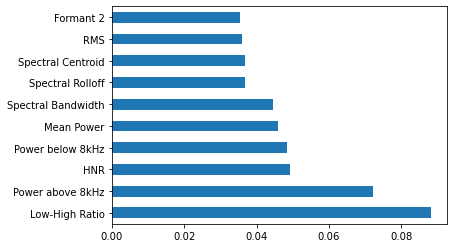

In [17]:
###RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('ROCAUC score:',metrics.roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',metrics.accuracy_score(y_test, rfc_predict))
print('F1 score:',metrics.f1_score(y_test, rfc_predict))
print("Recall:",metrics.recall_score(y_test, rfc_predict))
print("Precision:",metrics.precision_score(y_test, rfc_predict))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, rfc_predict))
print(metrics.classification_report(y_test, rfc_predict))




a = time.perf_counter()
y_pred = rfc.predict(X_test)
b = time.perf_counter()
print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])



columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 8kHz", "Power above 8kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")
    
for i in range(5):
    columns.append("Formant "+str(i+1))
    


feat_importances = pd.Series(rfc.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')
print(feat_importances.nlargest(10))
plt.show()


[0.03248708 0.03950356 0.04439006 0.04490652 0.03572745 0.03452579
 0.03861856 0.05112054 0.03415667 0.03011517 0.02474435 0.06418743
 0.04481104 0.0322296  0.03044072 0.02770744 0.02479198 0.02935706
 0.02950214 0.0275416  0.02655902 0.03143413 0.0277345  0.02509118
 0.02420023 0.02475464 0.03176419 0.03222941 0.02897764 0.02639029]
Accuracy 0.6701388888888888
Precision: 0.7072072072072072
Recall: 0.5567375886524822
Confusion matrix: [[229  65]
 [125 157]]
              precision    recall  f1-score   support

           0       0.65      0.78      0.71       294
           1       0.71      0.56      0.62       282

    accuracy                           0.67       576
   macro avg       0.68      0.67      0.66       576
weighted avg       0.68      0.67      0.67       576

Balanced accuracy 0.6678245766391663
Low-High Ratio        0.064187
Power above 8kHz      0.051121
Spectral Rolloff      0.044907
HNR                   0.044811
Spectral Bandwidth    0.044390
Spectral Centroid  

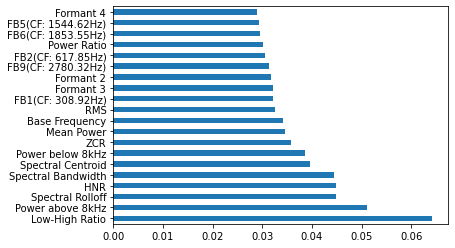

In [16]:

model = ExtraTreesClassifier(n_estimators=10, class_weight='balanced')
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, y_pred))


feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.nlargest(20).plot(kind='barh')
print(feat_importances.nlargest(10))
plt.show()

In [ ]:
#Removing Correlated Features

In [38]:
####Remove Correlated Features

import numpy as np

df = pd.DataFrame(X, columns = columns)
df = df.astype(float)
# Create correlation matrix
corr_matrix = df.corr().abs()


# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# Drop features 
# newdf = df.drop(to_drop, axis=1, inplace=True)

In [39]:
to_drop

['Spectral Bandwidth',
 'Spectral Rolloff',
 'Power below 16kHz',
 'FB2(CF: 617.85Hz)',
 'FB3(CF: 926.77Hz)',
 'FB4(CF: 1235.7Hz)',
 'FB5(CF: 1544.62Hz)',
 'FB6(CF: 1853.55Hz)',
 'FB7(CF: 2162.47Hz)',
 'FB8(CF: 2471.4Hz)',
 'FB9(CF: 2780.32Hz)',
 'FB10(CF: 3089.25Hz)',
 'FB11(CF: 3398.17Hz)',
 'FB12(CF: 3707.09Hz)',
 'Formant 2',
 'Formant 3',
 'Formant 4',
 'Formant 5']

In [40]:
df.drop(to_drop, axis=1, inplace=True)

ROCAUC score: 0.7392708814028611
Accuracy score: 0.7395833333333334
F1 score: 0.7474747474747475
Recall: 0.751269035532995
Precision: 0.7437185929648241
Balanced accuracy 0.7392708814028611
              precision    recall  f1-score   support

           0       0.74      0.73      0.73       187
           1       0.74      0.75      0.75       197

    accuracy                           0.74       384
   macro avg       0.74      0.74      0.74       384
weighted avg       0.74      0.74      0.74       384

Prediction Latency:  0.015775716145564427


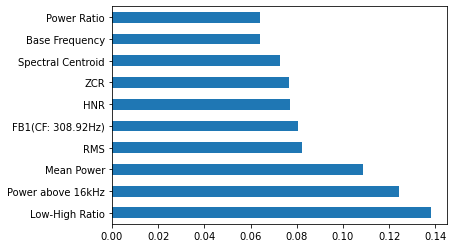

In [41]:
X_new = np.asarray(df)

X_train, X_test, y_train, y_test = train_test_split(X_new, y, test_size=0.2, random_state=0)

###RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('ROCAUC score:',metrics.roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',metrics.accuracy_score(y_test, rfc_predict))
print('F1 score:',metrics.f1_score(y_test, rfc_predict))
print("Recall:",metrics.recall_score(y_test, rfc_predict))
print("Precision:",metrics.precision_score(y_test, rfc_predict))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, rfc_predict))
print(metrics.classification_report(y_test, rfc_predict))



a = time.perf_counter()
y_pred = rfc.predict(X_test)
b = time.perf_counter()
print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])



columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")
    
for i in range(5):
    columns.append("Formant "+str(i+1))
    


feat_importances = pd.Series(rfc.feature_importances_, index=df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()



In [ ]:
###Sample Rate - 500 ms

In [43]:
path = "mask_data/"
mask_files = ["Bhawana_mask.wav", "Abhay_mask.wav", "Sandesh_mask.wav"]
noMask_files = ["Bhawana_noMask.wav", "Abhay_noMask.wav", "Sandesh_noMask.wav"]


X = []
y = []
for i in mask_files:
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])//2
    print(chunk)
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X.append(a)
        y.append(1)
        


for i in noMask_files:
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])//2
    print(chunk)
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X.append(a)
        y.append(0)
        

    
    
    

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:162: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:177: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


24000
zcr 507
[-39. -36. -35. ... -58. -59. -58.]
118671838727.09146
28
Maximum power is 118671838727.09146 at frequency 56.0
Power at first harmonic is 470530088.4706206 at frequency 112.0
Energy in 0 Hz - 1 kHz 251220690630.50198
Energy in 1 kHz - 8 kHz 4260414425.497802
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.966256692539595
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[936.5999465393139, 2000.4682198520322, 3051.5159512196155, 4029.8611019097298, 4985.419265625721]
zcr 695
[-56. -58. -57. ... -61. -64. -65.]
74168204690.0557
29
Maximum power is 74168204690.0557 at frequency 58.0
Power at first harmonic is 129440915.7882117 at frequency 116.0
Energy in 0 Hz - 1 kHz 232432032576.77536
Energy in 1 kHz - 8 kHz 5214499345.22454
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.574180029313375
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[886.6773601381116, 1998.504154007208, 2997.942834283054, 3975.104061297133, 5003.28926495149]
zcr 2669
[-66. -66. -64. ... -11. -10.  -

zcr 526
[  52.    5.  -34. ... -320. -346. -370.]
4504292031636.535
266
Maximum power is 4504292031636.535 at frequency 532.0
Power at first harmonic is 4289302340.536371 at frequency 1064.0
Energy in 0 Hz - 1 kHz 33338550560550.316
Energy in 1 kHz - 8 kHz 256634756189.67908
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.90660756764274
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1168.691105702063, 1707.5901406428336, 2796.832639094041, 3925.8915439937346, 4941.4231478018955]
zcr 1296
[-398. -422. -452. ...  171.  165.  156.]
1079547225907.8673
247
Maximum power is 1079547225907.8673 at frequency 494.0
Power at first harmonic is 23784404489.62814 at frequency 988.0
Energy in 0 Hz - 1 kHz 13906159599398.127
Energy in 1 kHz - 8 kHz 503505999029.8552
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.618657227902393
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.49716795369, 2179.196626887879, 3250.028283593826, 4381.840992857824, 4982.108108798912]
zcr 566
[ 145.  131.  118

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.3621027859979, 1859.9159269578288, 2945.409486667802, 3922.395334042157, 4952.983246531374]
zcr 1764
[-95. -90. -84. ...   2.   2.   4.]
57147794098.771355
60
Maximum power is 57147794098.771355 at frequency 120.0
Power at first harmonic is 15686127412.214907 at frequency 240.0
Energy in 0 Hz - 1 kHz 1461501853426.065
Energy in 1 kHz - 8 kHz 104728734887.93518
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.955118000708618
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.0157210080797, 1953.998804213691, 3093.793732660572, 4155.525791259006, 5127.523647614546]
zcr 767
[ 2.  5.  7. ... 30. 29. 26.]
56480579641.33846
28
Maximum power is 56480579641.33846 at frequency 56.0
Power at first harmonic is 10934757.007508244 at frequency 112.0
Energy in 0 Hz - 1 kHz 247046866650.44022
Energy in 1 kHz - 8 kHz 18805739461.55939
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.136780244957984
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 474
[-53. -56. -55. ... 122.  95.  70.]
3088287694100.444
274
Maximum power is 3088287694100.444 at frequency 548.0
Power at first harmonic is 117780773.47850937 at frequency 1096.0
Energy in 0 Hz - 1 kHz 56399033404396.56
Energy in 1 kHz - 8 kHz 392101157353.4585
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.83796718446257
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.3824570260158, 1911.5552019243994, 2971.0981663273997, 4004.2557978521113, 5020.739529510814]
zcr 658
[ 42.  16. -12. ... -23. -15. -35.]
1239386537144.8335
250
Maximum power is 1239386537144.8335 at frequency 500.0
Power at first harmonic is 924705389.9856842 at frequency 1000.0
Energy in 0 Hz - 1 kHz 16766923630167.178
Energy in 1 kHz - 8 kHz 217964110668.7992
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.92515790200366
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1320.9264531909603, 2525.3926984404443, 2702.8362095480616, 3713.237326929926, 4913.8783583259365]
zcr 773
[ -52.  -52.  -43. ... -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.3837696988874, 2377.98468369571, 3304.4845580538445, 3967.4326919406903, 5201.747363225929]
zcr 1364
[-534. -584. -631. ...  164.  157.  149.]
796867926433.4089
149
Maximum power is 796867926433.4089 at frequency 298.0
Power at first harmonic is 64109783548.54196 at frequency 596.0
Energy in 0 Hz - 1 kHz 18573025740017.69
Energy in 1 kHz - 8 kHz 564943077054.316
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.87592413179001
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.0250788874753, 1970.9481320647044, 2971.0547214101066, 3973.535202692685, 4996.30175790065]
zcr 1040
[142. 137. 127. ...  12. -47. -37.]
956983628263.5541
234
Maximum power is 956983628263.5541 at frequency 468.0
Power at first harmonic is 231797341.32263073 at frequency 936.0
Energy in 0 Hz - 1 kHz 25107043861722.203
Energy in 1 kHz - 8 kHz 1313991999397.8035
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.107455656677246
(49, 12) (12,) (12,)
Filter bank:

zcr 846
[-3. -4. -6. ... 18. 20. 11.]
1691133988598.0964
128
Maximum power is 1691133988598.0964 at frequency 256.0
Power at first harmonic is 556074702939.3137 at frequency 512.0
Energy in 0 Hz - 1 kHz 10909046630310.932
Energy in 1 kHz - 8 kHz 54441090125.06049
energy ratio between 0–1 and 1–8 kHz (LH1000) 200.38258979111157
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[938.8269626752141, 2001.422023264979, 3018.9461198906642, 4012.9380689721406, 5071.072385497847]
zcr 1959
[ 16.  12.  13. ... -29.  67. 113.]
1529326526141.7356
322
Maximum power is 1529326526141.7356 at frequency 644.0
Power at first harmonic is 565391165.8177134 at frequency 1288.0
Energy in 0 Hz - 1 kHz 35222695776372.26
Energy in 1 kHz - 8 kHz 810839624975.7175
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.43978105094097
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[920.2842463272455, 1989.0548966972706, 3008.521763206848, 3942.470907898922, 4944.398752306835]
zcr 3125
[  33. -106. -150. ...   76.   85.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[988.8939717844111, 1982.1184026739375, 3119.509350881347, 4199.261242588981, 5072.840048860708]
zcr 875
[ -1.   1.   2. ... -13.  -9.  -9.]
1826838915598.052
126
Maximum power is 1826838915598.052 at frequency 252.0
Power at first harmonic is 1112464378131.6335 at frequency 504.0
Energy in 0 Hz - 1 kHz 15395132637848.094
Energy in 1 kHz - 8 kHz 209897569717.89728
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.34593086779985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1238.2591404882012, 2359.0390235542523, 2458.78594494736, 3692.860436548295, 4913.290460741421]
zcr 674
[ -7.  -9. -10. ...  33.  29.  19.]
1400296950547.0806
128
Maximum power is 1400296950547.0806 at frequency 256.0
Power at first harmonic is 500641537990.6241 at frequency 512.0
Energy in 0 Hz - 1 kHz 12939590764242.78
Energy in 1 kHz - 8 kHz 316455119339.2127
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.88918135140879
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 340
[590. 586. 574. ... -68. -65. -70.]
484212403455.5956
256
Maximum power is 484212403455.5956 at frequency 512.0
Power at first harmonic is 1024357437.2515178 at frequency 1024.0
Energy in 0 Hz - 1 kHz 7398987508058.23
Energy in 1 kHz - 8 kHz 39491787221.77105
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.35509402267095
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.9132316829475, 2138.4208310475196, 3144.7129362770397, 4081.788811512948, 5182.250372099205]
zcr 516
[-65. -67. -65. ...   9.  10.  12.]
45421990308.47505
27
Maximum power is 45421990308.47505 at frequency 54.0
Power at first harmonic is 3344661787.7545633 at frequency 108.0
Energy in 0 Hz - 1 kHz 445923639127.2702
Energy in 1 kHz - 8 kHz 8493927470.729538
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.49911076636143
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.2547233351552, 2156.450564571064, 3135.35451682234, 4063.716210067379, 5057.284850638838]
zcr 770
[10. 11. 12. ...  4.  3. -1.]
140894

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.5627132488767, 2088.422049982456, 3050.2313174269348, 4013.4634844918846, 5036.699616227366]
zcr 693
[204. 203. 207. ...  10.  11.  10.]
238038441980.57697
28
Maximum power is 238038441980.57697 at frequency 56.0
Power at first harmonic is 2535895903.9150314 at frequency 112.0
Energy in 0 Hz - 1 kHz 2062922407076.2017
Energy in 1 kHz - 8 kHz 3887636263.7967753
energy ratio between 0–1 and 1–8 kHz (LH1000) 530.6366818025032
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.886095797461, 2035.6016576534143, 3015.625738874288, 4003.5110596495692, 5016.461286381026]
zcr 570
[  11.   11.   11. ... -294. -296. -298.]
2738178093740.3315
13
Maximum power is 2738178093740.3315 at frequency 26.0
Power at first harmonic is 22375831839.188206 at frequency 52.0
Energy in 0 Hz - 1 kHz 13854890873597.418
Energy in 1 kHz - 8 kHz 5032912350.585168
energy ratio between 0–1 and 1–8 kHz (LH1000) 2752.8575720152435
(49, 12) (12,) (12,)
Filter bank

zcr 87
[ -27.  -29.  -26. ... -341. -342. -342.]
14323043374916.227
13
Maximum power is 14323043374916.227 at frequency 26.0
Power at first harmonic is 210015421534.29578 at frequency 52.0
Energy in 0 Hz - 1 kHz 47752121589949.19
Energy in 1 kHz - 8 kHz 5276952106.829579
energy ratio between 0–1 and 1–8 kHz (LH1000) 9049.186087580187
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.8878162038031, 2066.277973110548, 3045.7655754076154, 4102.159042326899, 4897.464307170443]
zcr 110
[-341. -340. -341. ...   22.   20.   23.]
4987809824564.508
12
Maximum power is 4987809824564.508 at frequency 24.0
Power at first harmonic is 45687850959.368355 at frequency 48.0
Energy in 0 Hz - 1 kHz 11569037704783.855
Energy in 1 kHz - 8 kHz 5531827656.145616
energy ratio between 0–1 and 1–8 kHz (LH1000) 2091.359027053413
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.8331078321278, 1994.2410917019233, 3040.0349078502068, 3998.621666747569, 4963.211549952992]
zcr 1538
[ 16.  21.  17. ... -19.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.5473419736536, 2037.645458022781, 3023.0587281929993, 4022.7186432178455, 5039.1006809724995]
zcr 559
[541. 539. 537. ... 345. 365. 393.]
2267676487812.575
145
Maximum power is 2267676487812.575 at frequency 290.0
Power at first harmonic is 1700729007883.5771 at frequency 580.0
Energy in 0 Hz - 1 kHz 59843768356330.66
Energy in 1 kHz - 8 kHz 1036241701839.3298
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.75078174339821
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1192.8934157173696, 2282.2841114497164, 3086.2464621849163, 3978.878246694739, 5050.117117463732]
zcr 793
[423. 446. 463. ...  47.  41.  35.]
4958172692919.448
138
Maximum power is 4958172692919.448 at frequency 276.0
Power at first harmonic is 260040022335.54028 at frequency 552.0
Energy in 0 Hz - 1 kHz 39175775933657.0
Energy in 1 kHz - 8 kHz 1490942775158.9495
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.275841424886657
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 878
[  3.  30.  37. ... -15. -18. -17.]
4666126952271.542
156
Maximum power is 4666126952271.542 at frequency 312.0
Power at first harmonic is 67068056438.010895 at frequency 624.0
Energy in 0 Hz - 1 kHz 40268128801219.74
Energy in 1 kHz - 8 kHz 480930017950.2616
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.72970556681767
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1010.9908728327895, 2068.7745673370578, 3058.9087018016494, 4040.0833981501596, 5005.635435896499]
zcr 2303
[-21. -17. -16. ... -14. -21. -12.]
5842170485211.939
229
Maximum power is 5842170485211.939 at frequency 458.0
Power at first harmonic is 6501976552.68949 at frequency 916.0
Energy in 0 Hz - 1 kHz 51199496315012.14
Energy in 1 kHz - 8 kHz 515933125643.8239
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.23669128847112
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1091.8618260323203, 2040.8287926806988, 3115.0053339568944, 3994.9635986524445]
zcr 579
[  1.   7.   0. ... 315. 326. 340.]
184008066

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1321.2247007421936, 2287.898644372341, 3371.339714379293]
zcr 2290
[ 43.  40.  38. ... -56. -57. -60.]
1198490940495.5017
265
Maximum power is 1198490940495.5017 at frequency 530.0
Power at first harmonic is 59938050.92152828 at frequency 1060.0
Energy in 0 Hz - 1 kHz 28233698309606.754
Energy in 1 kHz - 8 kHz 168826740549.2558
energy ratio between 0–1 and 1–8 kHz (LH1000) 167.23475332019143
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[957.3804527578308, 1948.372027796461, 2993.5783456804306, 4046.351044094118, 5055.197942478782]
zcr 1044
[-58. -57. -57. ... 243. 242. 242.]
23973204551.071712
27
Maximum power is 23973204551.071712 at frequency 54.0
Power at first harmonic is 4738882678.557337 at frequency 108.0
Energy in 0 Hz - 1 kHz 392814316686.63446
Energy in 1 kHz - 8 kHz 48733332667.365295
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.060485404678388
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[942.29204631714

[1161.4184993134145, 2012.5394707880475, 2973.635675383011, 4113.439475190447, 5103.113865816525]
zcr 570
[-332. -301. -270. ...  498.  467.  436.]
174874692609.1272
256
Maximum power is 174874692609.1272 at frequency 512.0
Power at first harmonic is 2774084906.870971 at frequency 1024.0
Energy in 0 Hz - 1 kHz 10547333774912.455
Energy in 1 kHz - 8 kHz 117855475329.53264
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.4937952218285
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.6166448133541, 1988.444691258075, 2895.014393752837, 3894.1183594786125, 4985.120573415943]
zcr 1677
[393. 351. 309. ... -80. -32.  53.]
4099107943140.964
128
Maximum power is 4099107943140.964 at frequency 256.0
Power at first harmonic is 2592323462936.892 at frequency 512.0
Energy in 0 Hz - 1 kHz 31530087883752.19
Energy in 1 kHz - 8 kHz 852039721983.7903
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.005420135039245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1239.3866995847854, 2249

Energy in 0 Hz - 1 kHz 21869827096273.945
Energy in 1 kHz - 8 kHz 1319028474806.0508
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.580253962667236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.0455759919902, 1951.5146745220798, 2979.0083898091852, 3988.2569039839223, 4980.633965223059]
zcr 1334
[  1.   0.   3. ...   6.  -2. -30.]
3757491483927.6772
270
Maximum power is 3757491483927.6772 at frequency 540.0
Power at first harmonic is 139904706.72684965 at frequency 1080.0
Energy in 0 Hz - 1 kHz 42919832981935.39
Energy in 1 kHz - 8 kHz 865594244532.6057
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.584240252326055
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.5127414353149, 1989.4946692599738, 2990.988571852537, 3974.9914734775452, 4964.4839878517205]
zcr 956
[-50. -53. -39. ... -49.  -6.   6.]
905897737548.1292
127
Maximum power is 905897737548.1292 at frequency 254.0
Power at first harmonic is 183778402295.6677 at frequency 508.0
Energy in 0 Hz - 1 kHz 91111340

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.1420142655242, 1892.5877722957716, 3012.9569016847463, 4055.6928739212963, 5047.255272436651]
zcr 1167
[240. 311. 187. ... 168. 173. 168.]
755227595468.0258
347
Maximum power is 755227595468.0258 at frequency 694.0
Power at first harmonic is 979614416.0895342 at frequency 1388.0
Energy in 0 Hz - 1 kHz 18500930187837.473
Energy in 1 kHz - 8 kHz 574669995816.5385
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.19400755654526
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1502.0488760072978, 2003.9678342223465, 3373.842164211554, 4564.445813295806]
zcr 2217
[153. 147. 143. ...  19.  17.  17.]
290302379638.06244
128
Maximum power is 290302379638.06244 at frequency 256.0
Power at first harmonic is 66976066092.345314 at frequency 512.0
Energy in 0 Hz - 1 kHz 7695862662300.28
Energy in 1 kHz - 8 kHz 551567459363.7263
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.952713365610844
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 1031
[ 17.  17.  16. ...  19.  59. 102.]
43558613816.75505
28
Maximum power is 43558613816.75505 at frequency 56.0
Power at first harmonic is 1584155504.3031769 at frequency 112.0
Energy in 0 Hz - 1 kHz 265794782037.17395
Energy in 1 kHz - 8 kHz 55188718162.82562
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.816107184315974
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.3154210185023, 2079.384598333664, 3105.416879666096, 4082.079087643717, 5174.142850997768]
zcr 747
[146. 181. 211. ...  25.  23.  23.]
7538972133027.457
402
Maximum power is 7538972133027.457 at frequency 804.0
Power at first harmonic is 416793948.0626416 at frequency 1608.0
Energy in 0 Hz - 1 kHz 118160676121666.2
Energy in 1 kHz - 8 kHz 5432047233685.813
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.752512641811197
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1309.0943254899908, 2336.866768364877, 3384.4375905428424, 4426.074844570085]
zcr 883
[18. 24. 19. ... 46. 42. 38.]
5645536408067.963


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.0811784504426, 1815.1254301798851, 3026.6838288435597, 3945.4995035479296, 5022.752963228285]
zcr 432
[-587. -605. -602. ...  301.  301.  298.]
2612419716929.2705
127
Maximum power is 2612419716929.2705 at frequency 254.0
Power at first harmonic is 248759068875.28262 at frequency 508.0
Energy in 0 Hz - 1 kHz 25648688794146.18
Energy in 1 kHz - 8 kHz 129496826529.82796
energy ratio between 0–1 and 1–8 kHz (LH1000) 198.06422660279114
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.602478477144, 2116.920578510823, 2970.802728806218, 3939.6734808803026, 4994.988515163373]
zcr 529
[295. 292. 288. ... 289. 290. 290.]
1691557023039.483
13
Maximum power is 1691557023039.483 at frequency 26.0
Power at first harmonic is 4040094029.3273754 at frequency 52.0
Energy in 0 Hz - 1 kHz 20962235000466.816
Energy in 1 kHz - 8 kHz 241133429285.1874
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.93209839302239
(49, 12) (12,) (12,)
Filter bank:

zcr 505
[ -13.  -17.  -28. ... -729. -759. -785.]
5074190659027.881
154
Maximum power is 5074190659027.881 at frequency 308.0
Power at first harmonic is 1095150037580.6252 at frequency 616.0
Energy in 0 Hz - 1 kHz 65628391964769.95
Energy in 1 kHz - 8 kHz 917780559068.0938
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.5077164321376
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1005.0923192914046, 2121.638303884671, 3250.34752218531, 4203.324746149601, 5175.655281453935]
zcr 742
[-783. -769. -787. ...   93.   86.   71.]
2200461364997.8374
154
Maximum power is 2200461364997.8374 at frequency 308.0
Power at first harmonic is 348401483403.6513 at frequency 616.0
Energy in 0 Hz - 1 kHz 73965878362609.36
Energy in 1 kHz - 8 kHz 1398195184590.6316
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.900967745977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1117.930099835109, 2042.971270831803, 2851.263430291993, 3987.055829168856]
zcr 1345
[59. 45. 32. ... 79. 81. 78.]
6828044213

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:111: RuntimeWarning: divide by zero encountered in log10
  log_energy = 10 * np.log10(energy / E0)


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.8150895830336, 2137.6471515237063, 3049.396002679135, 3728.285300606925, 4884.270363789245]
zcr 1607
[ -89.  -83.  -78. ... -537. -597. -650.]
1577339771533.563
150
Maximum power is 1577339771533.563 at frequency 300.0
Power at first harmonic is 616316358475.376 at frequency 600.0
Energy in 0 Hz - 1 kHz 40735491971812.086
Energy in 1 kHz - 8 kHz 1428310754755.9084
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.520048481167944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.7943060219527, 1892.4669302260384, 3001.6662871908197, 4022.276173449396, 5029.705620142054]
zcr 1291
[ -713.  -772.  -820. ... -1148. -1196. -1236.]
2179664024194.397
277
Maximum power is 2179664024194.397 at frequency 554.0
Power at first harmonic is 663593172.159272 at frequency 1108.0
Energy in 0 Hz - 1 kHz 58589302040061.77
Energy in 1 kHz - 8 kHz 2590430769882.204
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.617590371938807
(49, 12) (12,) (12,)

zcr 739
[ 26.  26.  23. ... 183. 149. 128.]
1166941628021.5828
246
Maximum power is 1166941628021.5828 at frequency 492.0
Power at first harmonic is 64688985619.99817 at frequency 984.0
Energy in 0 Hz - 1 kHz 30639097581580.51
Energy in 1 kHz - 8 kHz 1941886803911.491
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.778003908294238
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.3756858385893, 2175.6898821919485, 2271.83127675265, 3286.7847474043065, 4498.9799217205855]
zcr 1514
[ 131.  130.  136. ... -209. -218. -227.]
4194039750780.404
239
Maximum power is 4194039750780.404 at frequency 478.0
Power at first harmonic is 3042449484.210606 at frequency 956.0
Energy in 0 Hz - 1 kHz 31388331786359.74
Energy in 1 kHz - 8 kHz 278194830140.2184
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.82859487553775
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[974.6266851361892, 1865.444660015479, 3102.462382322855, 4113.584569262337, 5070.440539898136]
zcr 466
[-240. -251. -261. ...  31

Energy in 0 Hz - 1 kHz 20773976425981.78
Energy in 1 kHz - 8 kHz 413524518856.19965
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.23638376617226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1216.6285477058211, 1902.6871849701708, 3108.872597221389, 4196.724280173411, 5084.202496704739]
zcr 691
[-803. -817. -831. ...    1.    0.  -14.]
212169036927.50357
28
Maximum power is 212169036927.50357 at frequency 56.0
Power at first harmonic is 2626012.4189322838 at frequency 112.0
Energy in 0 Hz - 1 kHz 3894432802912.218
Energy in 1 kHz - 8 kHz 67310873215.781425
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.85741020514863
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[895.8817108249095, 1980.0660045623874, 2994.0530942964256, 4013.465763635161, 5023.110726316772]
zcr 692
[ -16.   -5.   -6. ... 1723. 1797. 1903.]
4079933607117.18
164
Maximum power is 4079933607117.18 at frequency 328.0
Power at first harmonic is 294779666.29507416 at frequency 656.0
Energy in 0 Hz - 1 kHz 6054610

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[838.3312202628746, 1949.0410938309421, 2975.013873520398, 3982.154222731297, 4949.270486461031]
zcr 530
[-85. -86. -77. ...   3.   7.   8.]
3400480058416.1885
256
Maximum power is 3400480058416.1885 at frequency 512.0
Power at first harmonic is 10600256188.93542 at frequency 1024.0
Energy in 0 Hz - 1 kHz 51921986117934.69
Energy in 1 kHz - 8 kHz 725609009279.3099
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.55642426422557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1001.5914100606599, 1978.7910911589593, 2996.225772542134, 4022.314222750242]
zcr 1219
[ 8.  6.  6. ...  1.  3. 44.]
791041785932.5841
276
Maximum power is 791041785932.5841 at frequency 552.0
Power at first harmonic is 2556405028.6908965 at frequency 1104.0
Energy in 0 Hz - 1 kHz 29598939252562.004
Energy in 1 kHz - 8 kHz 834477233049.9966
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.47003810323082
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[968.0166

zcr 1109
[ 6.  8.  7. ... 55.  0. 41.]
9408135333058.697
274
Maximum power is 9408135333058.697 at frequency 548.0
Power at first harmonic is 23871393834.47027 at frequency 1096.0
Energy in 0 Hz - 1 kHz 121870816005957.45
Energy in 1 kHz - 8 kHz 1054262819114.5239
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.59813530018714
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1375.6512543620995, 2591.1827257930504, 2819.498637030439, 3875.990273876584]
zcr 2096
[139. 190. 127. ...  -8. -10.  -4.]
24583163449.247684
30
Maximum power is 24583163449.247684 at frequency 60.0
Power at first harmonic is 862678022.8086584 at frequency 120.0
Energy in 0 Hz - 1 kHz 148970624975.06488
Energy in 1 kHz - 8 kHz 113854284806.93523
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3084323108934992
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1018.6220147748379, 1957.4245449368082, 3127.4810080839843, 4218.126334720587, 5409.4554124891165]
zcr 1052
[ -4.  -2.  -1. ... 440. 618. 785.]
48033092

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.9286847619742, 2030.7348832082262, 2982.7818118126165, 3867.2904319575878, 4942.870667400818]
zcr 1178
[-66. -77. -95. ...  39.  41.  42.]
433587473066.7557
199
Maximum power is 433587473066.7557 at frequency 398.0
Power at first harmonic is 6652344851.376906 at frequency 796.0
Energy in 0 Hz - 1 kHz 7680453526618.134
Energy in 1 kHz - 8 kHz 75101342589.86618
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.26785915881213
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.8375160242301, 1837.4445326928833, 2936.5833873663737, 3937.4132050063786, 4991.664824068483]
zcr 384
[  41.   43.   42. ... -240. -216. -196.]
344400643184.47003
377
Maximum power is 344400643184.47003 at frequency 754.0
Power at first harmonic is 143420189.35017112 at frequency 1508.0
Energy in 0 Hz - 1 kHz 6571412878804.534
Energy in 1 kHz - 8 kHz 410864877163.46234
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.994097437026971
(49, 12) (12,) (12,)
Filte

zcr 460
[-282. -291. -297. ...   57.   65.   45.]
1680381928795.5815
247
Maximum power is 1680381928795.5815 at frequency 494.0
Power at first harmonic is 604907107.1241597 at frequency 988.0
Energy in 0 Hz - 1 kHz 23994163936483.484
Energy in 1 kHz - 8 kHz 118155066092.49808
energy ratio between 0–1 and 1–8 kHz (LH1000) 203.07350949894587
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1353.1893927011342, 2447.962037953655, 3489.9498073535556]
zcr 1398
[ 15.  -2.   2. ... -29. -35. -37.]
556193193967.6132
239
Maximum power is 556193193967.6132 at frequency 478.0
Power at first harmonic is 5636360264.082554 at frequency 956.0
Energy in 0 Hz - 1 kHz 9195296314224.47
Energy in 1 kHz - 8 kHz 184637829209.51715
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.80180038723343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1371.129294354221, 2475.9043725761508, 3461.6528905709138]
zcr 968
[-40. -41. -42. ...   6.   6.   6.]
80684626452.53519
28
Maximum power is 806846

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1436.0685002762116, 2471.7078792005736, 3500.782474449132, 4548.192594743793]
zcr 479
[-745. -810. -871. ... -153. -164. -177.]
9764055158280.59
266
Maximum power is 9764055158280.59 at frequency 532.0
Power at first harmonic is 8169540540.385362 at frequency 1064.0
Energy in 0 Hz - 1 kHz 83608020739661.95
Energy in 1 kHz - 8 kHz 1710560787886.1343
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.87755017638545
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1324.278995523581, 2521.5356775100736, 3077.1957734857942, 4189.830641113743]
zcr 2368
[-188. -196. -199. ...   -2.   42.   70.]
5416169514042.089
255
Maximum power is 5416169514042.089 at frequency 510.0
Power at first harmonic is 364011377.2649373 at frequency 1020.0
Energy in 0 Hz - 1 kHz 53868243024336.23
Energy in 1 kHz - 8 kHz 1448359029407.7646
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.19260344333477
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1361.01

zcr 797
[53. 41. 26. ... 21.  9.  9.]
181845668082.4834
28
Maximum power is 181845668082.4834 at frequency 56.0
Power at first harmonic is 73294746.45576893 at frequency 112.0
Energy in 0 Hz - 1 kHz 325098698925.5484
Energy in 1 kHz - 8 kHz 15376905984.451574
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.142009924120845
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.0114799928627, 1962.2685334523235, 3032.4043939531293, 4032.7391698677284, 4974.897837797299]
zcr 3162
[ 20.  13.   9. ... -23. -23. -20.]
28588922076.227837
28
Maximum power is 28588922076.227837 at frequency 56.0
Power at first harmonic is 133118441.88124648 at frequency 112.0
Energy in 0 Hz - 1 kHz 131307570362.03273
Energy in 1 kHz - 8 kHz 29525507157.967274
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.447258760349531
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.8558962270629, 1930.4335792769505, 3011.947681576589, 4077.3841315219447, 4965.283908372685]
zcr 1366
[-20. -19. -17. ...  23.  20.  23.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.3763517597374, 2052.334974385336, 3342.143852179781, 3789.1399317926193, 4466.332761222655]
zcr 1279
[ -38.  -41.  -43. ... -373. -385. -397.]
1389767827098.9387
221
Maximum power is 1389767827098.9387 at frequency 442.0
Power at first harmonic is 23711185541.843742 at frequency 884.0
Energy in 0 Hz - 1 kHz 36039670275803.99
Energy in 1 kHz - 8 kHz 743757772973.9803
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.45619311203462
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.55839247973, 1914.035283528379, 3009.4949629351495, 4008.0508710261633, 4941.048771390783]
zcr 736
[-399. -405. -411. ...  -37.  -18.   14.]
602367713535.5411
255
Maximum power is 602367713535.5411 at frequency 510.0
Power at first harmonic is 296782160.9103967 at frequency 1020.0
Energy in 0 Hz - 1 kHz 13230164378403.48
Energy in 1 kHz - 8 kHz 129637850408.53058
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.05479600834923
(49, 12) (12,) (12,)
Filte

zcr 481
[-43. -42. -42. ... -39. -30. -22.]
13298290964130.666
264
Maximum power is 13298290964130.666 at frequency 528.0
Power at first harmonic is 2776466458.3510303 at frequency 1056.0
Energy in 0 Hz - 1 kHz 102050959391296.42
Energy in 1 kHz - 8 kHz 192240578783.46396
energy ratio between 0–1 and 1–8 kHz (LH1000) 530.8502504366918
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1272.6042381475272, 2339.652598825381, 3308.3280662790326]
zcr 1093
[-15. -12.  -1. ... -39. -38. -37.]
1393382869427.6443
246
Maximum power is 1393382869427.6443 at frequency 492.0
Power at first harmonic is 370741874.77045614 at frequency 984.0
Energy in 0 Hz - 1 kHz 13606162989593.195
Energy in 1 kHz - 8 kHz 157545768324.80682
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.36323992874138
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1256.8334718918961, 2297.300195109255, 3414.390388355859]
zcr 1390
[-35. -36. -27. ...   2.   7.   3.]
402242071845.44836
128
Maximum power is 4022

Energy in 0 Hz - 1 kHz 25996341677652.94
Energy in 1 kHz - 8 kHz 288750299027.0585
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.03052729381538
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1363.4965857868026, 2453.8733992096677, 3446.255537347458, 4407.539126663967]
zcr 1297
[-61. -51. -40. ... -19. -45. -57.]
611895929327.8608
374
Maximum power is 611895929327.8608 at frequency 748.0
Power at first harmonic is 225144881.76997584 at frequency 1496.0
Energy in 0 Hz - 1 kHz 9723707966163.865
Energy in 1 kHz - 8 kHz 346332585690.1316
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.076214505740435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.385939657399, 2095.842846907366, 3252.208092528464, 4473.272166213256, 4554.9601691616635]
zcr 3094
[-17.  22.  30. ... -34.   0.  32.]
2294538493734.647
290
Maximum power is 2294538493734.647 at frequency 580.0
Power at first harmonic is 118665394.4037427 at frequency 1160.0
Energy in 0 Hz - 1 kHz 22159592914190.996
Energy in 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1065.2575363549288, 1997.5484490747456, 3049.3586462475237, 4093.9304818006167]
zcr 642
[460. 476. 495. ... -32. -40. -15.]
874001444852.223
299
Maximum power is 874001444852.223 at frequency 598.0
Power at first harmonic is 834009138.8045381 at frequency 1196.0
Energy in 0 Hz - 1 kHz 32673275463624.31
Energy in 1 kHz - 8 kHz 148661054891.67374
energy ratio between 0–1 and 1–8 kHz (LH1000) 219.78369175055735
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1274.9333874319461, 1947.9552208484154, 3065.813913476366, 4261.056767729449]
zcr 1647
[ 22.  12. -36. ...  41.  45.  46.]
216434751399.52853
266
Maximum power is 216434751399.52853 at frequency 532.0
Power at first harmonic is 2638585500.761047 at frequency 1064.0
Energy in 0 Hz - 1 kHz 6901317331448.06
Energy in 1 kHz - 8 kHz 205980990839.94086
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.50463216681379
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[970.43180248169

zcr 654
[  88.   91.   90. ... -234. -177. -116.]
1819094933914.9514
372
Maximum power is 1819094933914.9514 at frequency 744.0
Power at first harmonic is 334006247.1624501 at frequency 1488.0
Energy in 0 Hz - 1 kHz 27317931810773.64
Energy in 1 kHz - 8 kHz 1049250217290.3475
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.035669433856548
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1180.8423465338117, 2190.9351028057004, 3406.5904630183904, 4421.501797898556]
zcr 467
[-58.   1.  55. ... -47. -44. -46.]
1890103197358.566
274
Maximum power is 1890103197358.566 at frequency 548.0
Power at first harmonic is 734667284.072806 at frequency 1096.0
Energy in 0 Hz - 1 kHz 25333959931926.273
Energy in 1 kHz - 8 kHz 100111444601.74658
energy ratio between 0–1 and 1–8 kHz (LH1000) 253.0575803067004
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.9937306347165, 2182.793518258838, 3226.30732921953, 4506.953171462352, 4609.950500574229]
zcr 923
[ -44.  -43.  -45. ... -550. -573. -60

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1366.6331496140156, 2398.708973871001, 3401.880268126199, 4378.24930695402]
zcr 445
[-21. -18. -12. ... -31. -39. -46.]
526572970769.7217
240
Maximum power is 526572970769.7217 at frequency 480.0
Power at first harmonic is 6256441.492207108 at frequency 960.0
Energy in 0 Hz - 1 kHz 10495003128038.092
Energy in 1 kHz - 8 kHz 24746750117.90045
energy ratio between 0–1 and 1–8 kHz (LH1000) 424.096217807872
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1288.1469360847593, 2335.4323735462413, 3408.0180644176653]
zcr 1237
[-53. -55. -60. ... -11. -16. -19.]
52847568720.2901
29
Maximum power is 52847568720.2901 at frequency 58.0
Power at first harmonic is 168446261.23624346 at frequency 116.0
Energy in 0 Hz - 1 kHz 249502315638.04654
Energy in 1 kHz - 8 kHz 23093953041.953854
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.803794187369556
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[944.2967205478941, 2091.581099679315

zcr 1963
[171. 152. 122. ...   4.   4.   4.]
5392015492321.499
192
Maximum power is 5392015492321.499 at frequency 384.0
Power at first harmonic is 16228973468.711721 at frequency 768.0
Energy in 0 Hz - 1 kHz 69856054387067.164
Energy in 1 kHz - 8 kHz 1015017509226.8352
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.8225116828559
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1369.582890363169, 2450.3994457861045, 3558.3336658208473, 4738.691776739937]
zcr 939
[  5.   5.   7. ...  76. 136. 195.]
6136087709934.236
276
Maximum power is 6136087709934.236 at frequency 552.0
Power at first harmonic is 7842430696.599506 at frequency 1104.0
Energy in 0 Hz - 1 kHz 69065984251603.055
Energy in 1 kHz - 8 kHz 2830196475940.9614
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.403247208708553
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1116.2353443350569, 2010.9636541046573, 3216.9102363108063, 4011.139892293284]
zcr 675
[232. 263. 284. ... 136. 126. 119.]
4065909871106.697
25

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1062.1221500056463, 1960.2137444703985, 3133.0360445237925, 4227.763048755117]
zcr 959
[ -9.  -9.  -6. ... -13. -19. -19.]
1642622934090.0522
289
Maximum power is 1642622934090.0522 at frequency 578.0
Power at first harmonic is 843175831.3242097 at frequency 1156.0
Energy in 0 Hz - 1 kHz 50864004612047.016
Energy in 1 kHz - 8 kHz 608732709552.9393
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.55720633018416
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1085.186672354587, 2160.6516179244613, 3278.368263451462, 4337.256313686514]
zcr 539
[ -16.  -16.   -7. ... -334. -336. -343.]
3088187921545.145
250
Maximum power is 3088187921545.145 at frequency 500.0
Power at first harmonic is 22922823555.472195 at frequency 1000.0
Energy in 0 Hz - 1 kHz 61466601533596.97
Energy in 1 kHz - 8 kHz 500150888364.9754
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.89611587922025
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1443

zcr 1278
[ 9. 11. 14. ... -5. -7. -5.]
9856865377.637638
29
Maximum power is 9856865377.637638 at frequency 58.0
Power at first harmonic is 176867080.76503786 at frequency 116.0
Energy in 0 Hz - 1 kHz 45310384601.96859
Energy in 1 kHz - 8 kHz 1157088160.0313473
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.15897350530409
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[891.1264028507107, 1870.823365412498, 3065.370538138812, 4200.6144212191075, 5319.06263353146]
zcr 437
[ -7.  -6.  -8. ... -24. -27. -24.]
309769132980.60223
13
Maximum power is 309769132980.60223 at frequency 26.0
Power at first harmonic is 13933750003.42934 at frequency 52.0
Energy in 0 Hz - 1 kHz 1278410646482.8125
Energy in 1 kHz - 8 kHz 6336131103.187397
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.7651822008081
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.4713120457633, 2047.647452153882, 3059.776874398403, 3980.7209500814515, 5035.330851736589]
zcr 832
[-22. -19. -16. ...  18.  19.  18.]
3221295

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 870.6574220012338, 2120.9645542489197, 3271.607918665366, 4246.949984890009]
zcr 1251
[ -18.  -15.  -20. ... -349. -255. -174.]
3870503422391.5366
277
Maximum power is 3870503422391.5366 at frequency 554.0
Power at first harmonic is 15471296228.457754 at frequency 1108.0
Energy in 0 Hz - 1 kHz 65671796992481.875
Energy in 1 kHz - 8 kHz 3469072049334.068
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.930652364250665
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.3617224783154, 1892.4099895961313, 2992.950200487059, 4131.538378807736, 5117.111115777798]
zcr 1263
[-101.  -23.   72. ...  -18.  -18.  -15.]
3685656689634.429
279
Maximum power is 3685656689634.429 at frequency 558.0
Power at first harmonic is 140442302570.82654 at frequency 1116.0
Energy in 0 Hz - 1 kHz 54385719015853.93
Energy in 1 kHz - 8 kHz 3200252033202.1265
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.994198722978815
(49, 12) (12,) (12,)
Filter bank:  

zcr 566
[-395. -371. -344. ...  103.  105.  104.]
750801698150.9342
254
Maximum power is 750801698150.9342 at frequency 508.0
Power at first harmonic is 142755089.7372029 at frequency 1016.0
Energy in 0 Hz - 1 kHz 16649476608898.842
Energy in 1 kHz - 8 kHz 503319045337.16327
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.07936936450655
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1368.128949805786, 2498.959036435485, 3436.7336336472717]
zcr 996
[ 110.  107.  112. ...  -93. -115. -138.]
3435753898296.903
243
Maximum power is 3435753898296.903 at frequency 486.0
Power at first harmonic is 189499686.9710864 at frequency 972.0
Energy in 0 Hz - 1 kHz 36826288677297.99
Energy in 1 kHz - 8 kHz 372329233591.96643
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.90786259790634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.0368245647826, 2024.2923663467748, 2979.89437922375, 4035.094599391688, 5030.271196112515]
zcr 528
[-152. -167. -178. ...   15.   59.  107.]
934322766

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1057.1594791648183, 2075.2217734036076, 2958.7444864247786, 3954.9230389922445]
zcr 496
[-615. -621. -624. ...  337.  337.  338.]
1206535155252.6042
368
Maximum power is 1206535155252.6042 at frequency 736.0
Power at first harmonic is 3682472426.8323107 at frequency 1472.0
Energy in 0 Hz - 1 kHz 34657233786805.582
Energy in 1 kHz - 8 kHz 469543817290.4248
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.81043581150851
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1104.1359241767846, 2251.3858507266077, 3237.2262723781732, 4302.344455081949]
zcr 1569
[336. 330. 322. ... 138. 142. 147.]
1770676938650.168
250
Maximum power is 1770676938650.168 at frequency 500.0
Power at first harmonic is 7909220891.121289 at frequency 1000.0
Energy in 0 Hz - 1 kHz 22008104591998.69
Energy in 1 kHz - 8 kHz 544461963361.30786
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.42174857565577
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.

zcr 490
[ 51.  59.  58. ... -38. -37. -36.]
384056058403.4037
13
Maximum power is 384056058403.4037 at frequency 26.0
Power at first harmonic is 210235979.7264474 at frequency 52.0
Energy in 0 Hz - 1 kHz 1495336581980.276
Energy in 1 kHz - 8 kHz 13885564083.723986
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.69001338109412
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.0393895316165, 2068.2585435010783, 3057.166385729691, 4029.4088437602727, 5046.358391396649]
zcr 809
[-34. -35. -34. ...  -4.   0.  -2.]
16398393459.956728
30
Maximum power is 16398393459.956728 at frequency 60.0
Power at first harmonic is 181455430.81582606 at frequency 120.0
Energy in 0 Hz - 1 kHz 83666469455.2427
Energy in 1 kHz - 8 kHz 934340724.7575022
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.54599455884512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[838.0410307039436, 2000.7297140189544, 3058.731294459119, 4200.458294101551, 5266.80740602862]
zcr 703
[ -5.   1.  -3. ... -23. -21. -20.]
12

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1227.8344203385839, 2272.7364240841557, 2584.9870352357993, 3788.761703893037, 4878.058398001282]
zcr 808
[-262. -248. -230. ...  131.  120.  107.]
1201705996532.166
264
Maximum power is 1201705996532.166 at frequency 528.0
Power at first harmonic is 5147355009.011765 at frequency 1056.0
Energy in 0 Hz - 1 kHz 28808353958809.965
Energy in 1 kHz - 8 kHz 545191501504.05963
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.84079792024317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1189.2404423622872, 2031.3835342957948, 3061.31992072123, 3999.772726626698]
zcr 984
[ 92.  79.  60. ... -71. -74. -76.]
1268691303942.0056
253
Maximum power is 1268691303942.0056 at frequency 506.0
Power at first harmonic is 240776072.5685495 at frequency 1012.0
Energy in 0 Hz - 1 kHz 18629000933760.57
Energy in 1 kHz - 8 kHz 103329173903.42485
energy ratio between 0–1 and 1–8 kHz (LH1000) 180.28791124539427
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 943
[109. 133. 159. ...  65. 125. 177.]
4893129096097.438
230
Maximum power is 4893129096097.438 at frequency 460.0
Power at first harmonic is 5933399842.553598 at frequency 920.0
Energy in 0 Hz - 1 kHz 53445762439055.56
Energy in 1 kHz - 8 kHz 1542665730220.4597
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.645070148422704
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.9986583775012, 1866.5228827343506, 2969.7385795503374, 3965.7087141583115, 4862.305773867944]
zcr 2721
[233. 286. 338. ...  53.  55.  55.]
82493651016.97533
28
Maximum power is 82493651016.97533 at frequency 56.0
Power at first harmonic is 1537345471.1080549 at frequency 112.0
Energy in 0 Hz - 1 kHz 1938913017700.3733
Energy in 1 kHz - 8 kHz 393209697323.62744
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.930989827813351
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.2910592847256, 1866.9499172704807, 3062.6284084986596, 3952.8746449254304, 5027.587509810829]
zcr 548
[ 62.  55.  57. ... -56. -45

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1466.2234430680387, 2274.653984250481, 3228.1540121927387, 4380.889523554585]
zcr 510
[-130. -130. -136. ...   36.   29.   31.]
3032720970091.101
242
Maximum power is 3032720970091.101 at frequency 484.0
Power at first harmonic is 750713561.2500613 at frequency 968.0
Energy in 0 Hz - 1 kHz 31956305914105.508
Energy in 1 kHz - 8 kHz 232999287394.50067
energy ratio between 0–1 and 1–8 kHz (LH1000) 137.15194699286343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1092.361755252821, 2025.144509522844, 2986.199098149724, 4019.4301535672075]
zcr 944
[ 27.  27.  26. ... -24. -24. -24.]
43425437051.788956
28
Maximum power is 43425437051.788956 at frequency 56.0
Power at first harmonic is 20506742.851755343 at frequency 112.0
Energy in 0 Hz - 1 kHz 279935884054.632
Energy in 1 kHz - 8 kHz 27481123405.367542
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.186478912283318
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[930.51091951

zcr 1486
[ 39.  36.  40. ... -60. -61. -68.]
2342714081356.2783
136
Maximum power is 2342714081356.2783 at frequency 272.0
Power at first harmonic is 412943884791.0941 at frequency 544.0
Energy in 0 Hz - 1 kHz 24366932375650.324
Energy in 1 kHz - 8 kHz 577022431223.6465
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.228743731811726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.2157002219994, 2005.495766022778, 3073.786469145819, 4042.6288540883597, 5101.152287316507]
zcr 562
[-68. -74. -76. ...   2.   3.   5.]
1531509346555.038
229
Maximum power is 1531509346555.038 at frequency 458.0
Power at first harmonic is 8634423399.56308 at frequency 916.0
Energy in 0 Hz - 1 kHz 16862557520881.57
Energy in 1 kHz - 8 kHz 110572383550.43985
energy ratio between 0–1 and 1–8 kHz (LH1000) 152.50243306177234
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.6475126584571, 2108.8341241349503, 3144.2811974632377, 4040.795256654066, 4969.00723622703]
zcr 659
[ 6.  6.  6. ... 33. 34. 32.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1211.205589331512, 2214.7593534883736, 3095.3133519294415, 4382.790036948524]
zcr 1177
[1213. 1136. 1058. ...  550.  545.  543.]
2228601576686.7246
230
Maximum power is 2228601576686.7246 at frequency 460.0
Power at first harmonic is 329408000388.1079 at frequency 920.0
Energy in 0 Hz - 1 kHz 70503521112143.11
Energy in 1 kHz - 8 kHz 3867145818176.9077
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.231410044263768
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1527.656613969309, 2164.8158588392052, 2751.5519539815264, 3977.435425132539]
zcr 1206
[ 535.  523.  507. ... -128.  -78.  -30.]
512583330401.6427
235
Maximum power is 512583330401.6427 at frequency 470.0
Power at first harmonic is 5582583475.076336 at frequency 940.0
Energy in 0 Hz - 1 kHz 9685731599692.836
Energy in 1 kHz - 8 kHz 229638319729.15833
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.178202710751634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[99

[999.9654421304226, 2027.2352502380663, 3013.976212655602, 3978.7948858635773, 5014.760338479588]
zcr 1081
[  7.  19.   8. ... 435. 425. 413.]
2431893531357.573
317
Maximum power is 2431893531357.573 at frequency 634.0
Power at first harmonic is 1809605993.521947 at frequency 1268.0
Energy in 0 Hz - 1 kHz 86066379772263.48
Energy in 1 kHz - 8 kHz 2119969966242.4482
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.597924094562664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1206.9820814174113, 2225.6088604964402, 2625.5995528132516, 3784.155527339629, 4954.806142938927]
zcr 1210
[398. 385. 368. ... -64. -67. -63.]
8025447138702.01
265
Maximum power is 8025447138702.01 at frequency 530.0
Power at first harmonic is 346126459413.4904 at frequency 1060.0
Energy in 0 Hz - 1 kHz 69327222582448.0
Energy in 1 kHz - 8 kHz 4820223567229.941
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.382574089252996
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1384.0517860083305, 1641.234299685253,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1342.0004178407378, 1891.774935279554, 3079.6263032046904, 4017.545350299011, 4370.460048620843]
zcr 2530
[-157. -156.  -31. ...    0.   -1.    3.]
982725822453.9716
277
Maximum power is 982725822453.9716 at frequency 554.0
Power at first harmonic is 583619468.834361 at frequency 1108.0
Energy in 0 Hz - 1 kHz 23045190345227.344
Energy in 1 kHz - 8 kHz 1016042351892.6489
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.681328492163296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.4617842662133, 2047.8502972832982, 3139.9507414489963, 4314.760455370556, 5010.8431139489285]
zcr 928
[  13.    9.    9. ... -265. -253. -240.]
11202936139560.113
253
Maximum power is 11202936139560.113 at frequency 506.0
Power at first harmonic is 509402408.7585401 at frequency 1012.0
Energy in 0 Hz - 1 kHz 86970772060207.47
Energy in 1 kHz - 8 kHz 563402901272.4427
energy ratio between 0–1 and 1–8 kHz (LH1000) 154.36692261219173
(49, 12) (12,) (12,)
F

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1363.0260924749537, 2362.599578281735, 3321.8527220900614]
zcr 604
[  2.   2.  -1. ... -54. -58. -58.]
2055125761255.5989
224
Maximum power is 2055125761255.5989 at frequency 448.0
Power at first harmonic is 2863990439.594153 at frequency 896.0
Energy in 0 Hz - 1 kHz 30429610918029.645
Energy in 1 kHz - 8 kHz 308889253516.3824
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.5130125817594
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.4783974019638, 2016.2113412105477, 3047.198952422612, 4035.7025870461453, 4952.023420812067]
zcr 573
[ -60.  -57.  -59. ... -417. -421. -419.]
2424292783383.7925
127
Maximum power is 2424292783383.7925 at frequency 254.0
Power at first harmonic is 69149630713.18915 at frequency 508.0
Energy in 0 Hz - 1 kHz 13487405271616.12
Energy in 1 kHz - 8 kHz 273013090531.88074
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.40204605332339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.73487

zcr 1577
[185. 192. 196. ...  36.  39.  36.]
162587057735.28552
232
Maximum power is 162587057735.28552 at frequency 464.0
Power at first harmonic is 7941469.433315478 at frequency 928.0
Energy in 0 Hz - 1 kHz 2962759835088.1724
Energy in 1 kHz - 8 kHz 135723313643.82426
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.82940981579096
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.3740615323325, 1938.4532936145833, 3071.3143575336812, 3899.0088838962924, 4889.193266054331]
zcr 824
[ 35.  35.  34. ... -38. -38. -37.]
18055226242.59387
30
Maximum power is 18055226242.59387 at frequency 60.0
Power at first harmonic is 1154652908.7644255 at frequency 120.0
Energy in 0 Hz - 1 kHz 102315556172.379
Energy in 1 kHz - 8 kHz 1023807827.6208944
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.93629020217396
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1222.465471528703, 2418.0447906272166, 2803.8808752549603, 4065.1603520524477, 4136.454528575844]
zcr 517
[-39. -38. -39. ... -16.  -9.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[738.4501679805045, 2003.970987091441, 3126.2403036158184, 4279.253165960325, 5138.201264762653]
zcr 2077
[ 53. -18. -16. ... 153. 170. 187.]
27835050299972.895
305
Maximum power is 27835050299972.895 at frequency 610.0
Power at first harmonic is 36968947631.518166 at frequency 1220.0
Energy in 0 Hz - 1 kHz 316584784754468.0
Energy in 1 kHz - 8 kHz 13154896085433.947
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.065928206381926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1263.0800226135507, 2333.7210918663113, 3405.331391368583, 4425.3688619230725]
zcr 1893
[202. 215. 233. ... -80. -48.  44.]
2656793299472.0767
266
Maximum power is 2656793299472.0767 at frequency 532.0
Power at first harmonic is 49241383649.59521 at frequency 1064.0
Energy in 0 Hz - 1 kHz 66072537974895.34
Energy in 1 kHz - 8 kHz 2078013242534.7253
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.796013914858975
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 555
[546. 530. 514. ...  55.  53.  40.]
9082725420128.055
260
Maximum power is 9082725420128.055 at frequency 520.0
Power at first harmonic is 96926684866.10266 at frequency 1040.0
Energy in 0 Hz - 1 kHz 79900434605927.66
Energy in 1 kHz - 8 kHz 1442241618464.2876
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.40017260839164
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1232.1759870233898, 1966.0566456433178, 2845.5947075196295, 3954.8908848396914]
zcr 597
[36. 33. 32. ... 23. 21. 25.]
538742144165.3629
240
Maximum power is 538742144165.3629 at frequency 480.0
Power at first harmonic is 30066476768.397026 at frequency 960.0
Energy in 0 Hz - 1 kHz 13064077013815.238
Energy in 1 kHz - 8 kHz 1751117472458.7544
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.460422969494954
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.076646838702, 1594.8788693398133, 2672.1633064065986, 3785.2908663289727, 4889.922537656516]
zcr 552
[  24.   20.   24. ... -168. -135. -111.]
186303

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.8335086363115, 2049.4569273491484, 3166.7188817726515, 4070.7593538555434, 5048.585976473535]
zcr 1883
[124. 131. 144. ...  22.  39.  35.]
3915374039301.412
272
Maximum power is 3915374039301.412 at frequency 544.0
Power at first harmonic is 1649143367.8937912 at frequency 1088.0
Energy in 0 Hz - 1 kHz 38975333143588.8
Energy in 1 kHz - 8 kHz 467180491247.1737
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.42671381576999
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.6888301283022, 2068.401730636261, 3140.0005319275924, 4032.3058565794563, 4999.6288503241785]
zcr 1006
[ 15.  18.  83. ... -29. -48. -71.]
1303006259359.3132
145
Maximum power is 1303006259359.3132 at frequency 290.0
Power at first harmonic is 429521835920.11206 at frequency 580.0
Energy in 0 Hz - 1 kHz 21058479175243.156
Energy in 1 kHz - 8 kHz 110838262820.84778
energy ratio between 0–1 and 1–8 kHz (LH1000) 189.99286563414296
(49, 12) (12,) (12,)
Filter ban

zcr 449
[58. 58. 64. ... 39. 37. 38.]
393195816487.38983
13
Maximum power is 393195816487.38983 at frequency 26.0
Power at first harmonic is 681938106.4869066 at frequency 52.0
Energy in 0 Hz - 1 kHz 1391428924601.779
Energy in 1 kHz - 8 kHz 3791597670.219381
energy ratio between 0–1 and 1–8 kHz (LH1000) 366.9769436590226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.1937951062506, 2078.4103398131188, 3042.47450178047, 3958.933706019656, 5057.161868944652]
zcr 869
[40. 39. 40. ... 51. 43. 37.]
122994692627.77377
15
Maximum power is 122994692627.77377 at frequency 30.0
Power at first harmonic is 10589807914.541945 at frequency 60.0
Energy in 0 Hz - 1 kHz 858670952018.1785
Energy in 1 kHz - 8 kHz 50750280005.822235
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.91953131922955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[897.7948251149963, 1976.999971379213, 3000.9027582678004, 4003.922164911536, 4976.207671980826]
zcr 1534
[  29.   20.   21. ... -538. -567. -600.]
2369132

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.8690402985374, 1898.0522569479497, 3060.7671068786126, 4073.2238367860773, 4955.54026560096]
zcr 1620
[15. -4.  0. ... -7. -4. -6.]
67034248568.574585
28
Maximum power is 67034248568.574585 at frequency 56.0
Power at first harmonic is 301075898.50006235 at frequency 112.0
Energy in 0 Hz - 1 kHz 1106900173960.5547
Energy in 1 kHz - 8 kHz 139958023403.44415
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.908801132249454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.7434136654774, 1921.2923823816188, 3025.457223575805, 3935.834171082083, 4909.023345053769]
zcr 463
[-10.  -7. -10. ... -69. -70. -68.]
154591164096.0923
28
Maximum power is 154591164096.0923 at frequency 56.0
Power at first harmonic is 1948508.2413225383 at frequency 112.0
Energy in 0 Hz - 1 kHz 658872870410.8713
Energy in 1 kHz - 8 kHz 10180808151.127924
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.71714824897033
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 720
[ 95. 102. 107. ... -63. -54. -49.]
837589122822.8501
240
Maximum power is 837589122822.8501 at frequency 480.0
Power at first harmonic is 6243254764.88433 at frequency 960.0
Energy in 0 Hz - 1 kHz 17462243665057.367
Energy in 1 kHz - 8 kHz 172724758252.63358
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.09867190849646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[959.3943880322497, 2039.5797515025363, 3103.7977548675385, 4058.391728409821, 5012.455295598783]
zcr 476
[-50. -43. -30. ... 225. 210. 200.]
3252150203598.4385
265
Maximum power is 3252150203598.4385 at frequency 530.0
Power at first harmonic is 18531479875.848064 at frequency 1060.0
Energy in 0 Hz - 1 kHz 36577633003004.59
Energy in 1 kHz - 8 kHz 405422518915.3974
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.22101954488997
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1154.2463987065207, 2175.1208144428283, 3202.6197195175423, 3940.844354868725, 4848.167085087008]
zcr 555
[186. 170. 158. ... 872. 788.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1336.5981416386387, 2439.5677163419573, 3528.877804932223, 4661.109258108632]
zcr 1489
[-101.  -87.  -37. ...  -29.  -23.  -26.]
110689279770.697
28
Maximum power is 110689279770.697 at frequency 56.0
Power at first harmonic is 1635226120.1083333 at frequency 112.0
Energy in 0 Hz - 1 kHz 416682217370.5008
Energy in 1 kHz - 8 kHz 95323447429.4988
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.371245780621592
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[935.3828203084062, 1989.0217424668806, 2982.1501458577322, 3948.0555924839846, 5023.982982632109]
zcr 525
[-25. -24. -26. ...  16.  -5. -26.]
6124968623025.677
277
Maximum power is 6124968623025.677 at frequency 554.0
Power at first harmonic is 22562961461.479027 at frequency 1108.0
Energy in 0 Hz - 1 kHz 150786129543146.47
Energy in 1 kHz - 8 kHz 1179038057901.5498
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.8891114096142
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 774
[-315. -297. -276. ...  384.  435.  486.]
1066425845360.8802
234
Maximum power is 1066425845360.8802 at frequency 468.0
Power at first harmonic is 1769433629.430942 at frequency 936.0
Energy in 0 Hz - 1 kHz 14289815981696.143
Energy in 1 kHz - 8 kHz 358046943411.85065
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.910453767675364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.7467433709219, 2105.785352780154, 3309.2542128770574, 4541.007190136425, 4658.087315855548]
zcr 487
[529. 569. 616. ...   6.   8.   9.]
410910255247.58826
229
Maximum power is 410910255247.58826 at frequency 458.0
Power at first harmonic is 966238084.9123487 at frequency 916.0
Energy in 0 Hz - 1 kHz 12036646114170.807
Energy in 1 kHz - 8 kHz 280424146329.199
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.92300171626661
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.3023171904256, 1970.8897504875692, 2927.6194104042725, 3973.498593637966, 4965.958874950838]
zcr 551
[  8.  11.  12. ... 25

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[940.4597785316869, 2004.4005901300502, 3074.4219616834803, 4018.3359824785853, 5041.465525102572]
zcr 2421
[  -3.    0.   -3. ... -103.  -97.  -90.]
3404623878970.2534
328
Maximum power is 3404623878970.2534 at frequency 656.0
Power at first harmonic is 42682622281.20175 at frequency 1312.0
Energy in 0 Hz - 1 kHz 82483245565930.19
Energy in 1 kHz - 8 kHz 8977728630111.826
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.187540519912416
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.95875559486, 1932.1404032225846, 2864.3257473135377, 3950.502822450412, 5002.134547193809]
zcr 2151
[-93. -91. -90. ... -58. -29. -19.]
3120835596048.0405
290
Maximum power is 3120835596048.0405 at frequency 580.0
Power at first harmonic is 7669917403.454454 at frequency 1160.0
Energy in 0 Hz - 1 kHz 56773615005599.0
Energy in 1 kHz - 8 kHz 1471612324722.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.579192394496275
(49, 12) (12,) (12,)
Filter ban

zcr 1229
[ -41.  -41.  -42. ... -162. -158. -101.]
763890827314.0824
228
Maximum power is 763890827314.0824 at frequency 456.0
Power at first harmonic is 6955529609.397413 at frequency 912.0
Energy in 0 Hz - 1 kHz 13926071197331.695
Energy in 1 kHz - 8 kHz 396256355748.2991
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.14409547080551
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.8315325337207, 2084.3497240735605, 3086.179437925251, 4016.685059641511, 4981.665749080124]
zcr 781
[-32.  13.   8. ... -22. -17. -17.]
884198390473.1345
13
Maximum power is 884198390473.1345 at frequency 26.0
Power at first harmonic is 427198536.85163665 at frequency 52.0
Energy in 0 Hz - 1 kHz 2335195899561.812
Energy in 1 kHz - 8 kHz 104201155500.18895
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.41046069357242
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.252024723456, 2025.0055166631955, 3012.8439943449225, 4027.7664535261397, 4998.272145736737]
zcr 360
[-18. -13. -18. ...   2.   3.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1231.2114898198265, 2340.804385215978, 3359.4034329039428, 4306.831679485357]
zcr 1045
[-236.  -87.   76. ...  -39.  -46.  -52.]
3764611072371.276
250
Maximum power is 3764611072371.276 at frequency 500.0
Power at first harmonic is 39174667451.36342 at frequency 1000.0
Energy in 0 Hz - 1 kHz 97875043942843.16
Energy in 1 kHz - 8 kHz 1848791720278.922
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.940005555670176
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.7608501730858, 2077.595697854818, 2889.1388125940593, 3928.3282755752125, 5054.992984445385]
zcr 483
[ -56.  -60.  -51. ... -249. -321. -386.]
2140680083490.4954
247
Maximum power is 2140680083490.4954 at frequency 494.0
Power at first harmonic is 48964292014.88149 at frequency 988.0
Energy in 0 Hz - 1 kHz 40503862316039.71
Energy in 1 kHz - 8 kHz 460532316692.2915
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.95009784970792
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 719
[-259. -232. -203. ...  -19.  -11.  -11.]
7031552287015.594
240
Maximum power is 7031552287015.594 at frequency 480.0
Power at first harmonic is 8948927621.892622 at frequency 960.0
Energy in 0 Hz - 1 kHz 30485149792304.047
Energy in 1 kHz - 8 kHz 305812837853.9518
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.68564435108168
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1164.6516973045816, 2134.7243709201175, 3019.485669177714, 3967.527347477972]
zcr 1168
[-33. -73. -76. ...  35.  43.  51.]
222364436817.10773
140
Maximum power is 222364436817.10773 at frequency 280.0
Power at first harmonic is 192509899260.55508 at frequency 560.0
Energy in 0 Hz - 1 kHz 4606628849239.923
Energy in 1 kHz - 8 kHz 494100853784.07697
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.323256201562907
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[981.352424999151, 2047.9210404576395, 3027.771131659477, 4005.7522665045785, 5009.062570107461]
zcr 599
[ 59.  61.  62. ... 240. 154.   6.]
731

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1251.3756256652343, 2386.436971562383, 3460.8580342399882, 4483.763550457956]
zcr 1200
[ 46.  49.  49. ...  -9. -10.  -9.]
21500386657.121494
29
Maximum power is 21500386657.121494 at frequency 58.0
Power at first harmonic is 112901681.23253983 at frequency 116.0
Energy in 0 Hz - 1 kHz 269671714681.67935
Energy in 1 kHz - 8 kHz 34691979878.32078
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.773315781559034
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[740.4726583839507, 1958.8000692013277, 2876.8817274752964, 3858.407548722271, 5032.985764297933]
zcr 955
[  -7.   -6.   -7. ... -232. -249. -267.]
1039879781952.1735
149
Maximum power is 1039879781952.1735 at frequency 298.0
Power at first harmonic is 75888528409.69194 at frequency 596.0
Energy in 0 Hz - 1 kHz 17656101336674.184
Energy in 1 kHz - 8 kHz 1067830945185.8298
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.534547360960374
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 903
[ 60.  86. 112. ... 792. 830. 871.]
886310567793.168
129
Maximum power is 886310567793.168 at frequency 258.0
Power at first harmonic is 686731251350.2155 at frequency 516.0
Energy in 0 Hz - 1 kHz 18112937679225.25
Energy in 1 kHz - 8 kHz 690016128134.7438
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.2500207468893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.4856399750051, 2078.852100971317, 3129.3488795900644, 4191.239565655902, 5136.434143603298]
zcr 1264
[ 899.  920.  927. ... -893. -925. -952.]
3579407385956.4863
252
Maximum power is 3579407385956.4863 at frequency 504.0
Power at first harmonic is 1831696910.0815158 at frequency 1008.0
Energy in 0 Hz - 1 kHz 32612685877530.848
Energy in 1 kHz - 8 kHz 479885275453.14514
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.95933850384428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1323.2615679347891, 2153.6071871069903, 2841.951351022898, 3862.7786772880254, 4883.768062886452]
zcr 1048
[ -976.  -997. -1018. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1250.429711275941, 1803.9424574219272, 2950.5726041589387, 3922.198572810731, 5033.224301225414]
zcr 663
[ -924.  -980. -1092. ...    -8.    -9.   -12.]
4525076969508.604
147
Maximum power is 4525076969508.604 at frequency 294.0
Power at first harmonic is 1534170002459.2874 at frequency 588.0
Energy in 0 Hz - 1 kHz 42973330546901.34
Energy in 1 kHz - 8 kHz 437872047638.66077
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.14129670675769
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.3257452165253, 2216.42223652372, 3318.9443006662686, 4279.552755402509, 4595.508819448166]
zcr 486
[-12. -14. -17. ... 274. 354. 419.]
3962626404007.421
242
Maximum power is 3962626404007.421 at frequency 484.0
Power at first harmonic is 599769104977.1066 at frequency 968.0
Energy in 0 Hz - 1 kHz 59877256474879.79
Energy in 1 kHz - 8 kHz 1205293900880.1948
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.67855261787435
(49, 12) (12,) (12,)
Filter ba

zcr 2612
[  8.  16.  29. ... 234.  76. -75.]
10893520404.70574
29
Maximum power is 10893520404.70574 at frequency 58.0
Power at first harmonic is 58195738.04433426 at frequency 116.0
Energy in 0 Hz - 1 kHz 151129862548.24768
Energy in 1 kHz - 8 kHz 537808282891.75116
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.2810106637548138
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[884.6210093072755, 1930.2966450969257, 2963.237036701952, 3974.9010621247544, 4999.042243369471]
zcr 715
[-49.  29.  40. ... -45. -48. -50.]
6852586211961.009
275
Maximum power is 6852586211961.009 at frequency 550.0
Power at first harmonic is 1172692632.534417 at frequency 1100.0
Energy in 0 Hz - 1 kHz 94764245793181.11
Energy in 1 kHz - 8 kHz 1085336759964.8275
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.31321861451752
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.188170028086, 2068.583295910076, 2881.9559381848635, 3958.87811295156, 4983.129968770347]
zcr 687
[-49. -47. -42. ... -10. -11.  -9.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[875.4303056658149, 1975.7421108346061, 3010.001697748888, 4008.1055145999003, 4985.624726098259]
zcr 2566
[  9.  10.  15. ...  31. -35. -58.]
1473351795641.0505
238
Maximum power is 1473351795641.0505 at frequency 476.0
Power at first harmonic is 267921281.57901248 at frequency 952.0
Energy in 0 Hz - 1 kHz 35983226308564.266
Energy in 1 kHz - 8 kHz 648508471693.7059
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.486131452665646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1249.110182294501, 1800.2164183744067, 2817.3813788341427, 3878.8181497267196, 4923.31493409846]
zcr 1147
[-41.  -3.  42. ... -26. -24. -22.]
48301809087.63216
27
Maximum power is 48301809087.63216 at frequency 54.0
Power at first harmonic is 55463270.95723768 at frequency 108.0
Energy in 0 Hz - 1 kHz 1954431700345.5798
Energy in 1 kHz - 8 kHz 81120113974.42108
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.093059101986153
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1259
[115. 145.  60. ... 348. 367. 386.]
4039439309287.259
235
Maximum power is 4039439309287.259 at frequency 470.0
Power at first harmonic is 14602026179.12352 at frequency 940.0
Energy in 0 Hz - 1 kHz 49377244340741.516
Energy in 1 kHz - 8 kHz 368193762342.48645
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.1066834663315
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1072.1875243107704, 1902.5167797791687, 2944.297778849712, 4010.0251374788777]
zcr 497
[403. 416. 424. ... 345. 331. 299.]
2929707058833.741
250
Maximum power is 2929707058833.741 at frequency 500.0
Power at first harmonic is 28864603042.776005 at frequency 1000.0
Energy in 0 Hz - 1 kHz 39332271776453.336
Energy in 1 kHz - 8 kHz 1166362032630.6333
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.722181171949366
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1180.0487245993575, 2350.5795425002743, 3267.846471868396, 4271.26019285375]
zcr 696
[260. 226. 205. ... -16. -29. -38.]
820698488672.9093
25

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[876.6301505275804, 2007.093043062127, 3004.3200986928123, 3959.8577508824283, 4942.560362766276]
zcr 878
[-32. -24. -17. ... 274. 316. 340.]
8436218227675.794
278
Maximum power is 8436218227675.794 at frequency 556.0
Power at first harmonic is 76515347767.72263 at frequency 1112.0
Energy in 0 Hz - 1 kHz 153203870233590.0
Energy in 1 kHz - 8 kHz 10499923975385.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.5909504290444
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[960.0612112183396, 2001.9993213332364, 3056.8352428541803, 3998.240582296037, 4954.200204126716]
zcr 1929
[361. 391. 404. ...  48.  48.  50.]
1632771001432.1438
151
Maximum power is 1632771001432.1438 at frequency 302.0
Power at first harmonic is 417876900414.1183 at frequency 604.0
Energy in 0 Hz - 1 kHz 40763343311471.766
Energy in 1 kHz - 8 kHz 951252566768.2285
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.852282070534166
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 841
[-817. -812. -801. ...  -52.  -57.  -60.]
4676736889789.27
242
Maximum power is 4676736889789.27 at frequency 484.0
Power at first harmonic is 21893917342.743248 at frequency 968.0
Energy in 0 Hz - 1 kHz 54631578233484.49
Energy in 1 kHz - 8 kHz 1111104009203.5093
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.168734682765596
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.7501241334196, 2036.0931677673898, 3118.8893393784383, 4173.843720838693, 5183.043272289198]
zcr 1805
[-61. -64. -66. ... -13. -12. -14.]
1878607331632.519
265
Maximum power is 1878607331632.519 at frequency 530.0
Power at first harmonic is 6156168470.611283 at frequency 1060.0
Energy in 0 Hz - 1 kHz 34898594529068.523
Energy in 1 kHz - 8 kHz 658802722521.4858
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.97275396115316
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.7339336605487, 2006.2450125957414, 3039.6320425305144, 4022.0666901815744, 5011.249707716553]
zcr 521
[ -16.  -13.  -15. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1246.7870084740696, 1660.7134585363412, 2295.1025984456064, 3393.739279280678, 4636.441395082045]
zcr 1225
[-32. -31. -29. ... -13. -16. -17.]
43598042054.98976
28
Maximum power is 43598042054.98976 at frequency 56.0
Power at first harmonic is 17767517.3762758 at frequency 112.0
Energy in 0 Hz - 1 kHz 82761438056.32068
Energy in 1 kHz - 8 kHz 766721463.679312
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.94198672770739
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[912.4395471193004, 1935.2757271545058, 3048.7608583913316, 4140.1306731781215, 5241.17963951491]
zcr 1465
[ -15.  -16.  -15. ... -593. -637. -674.]
2008112672031.8896
274
Maximum power is 2008112672031.8896 at frequency 548.0
Power at first harmonic is 534438413.3714284 at frequency 1096.0
Energy in 0 Hz - 1 kHz 45096977756314.36
Energy in 1 kHz - 8 kHz 389063976693.64276
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.91147075491051
(49, 12) (12,) (12,)
Filter bank:

zcr 1179
[26. 29. 25. ... 12. 17. 18.]
2420580820794.3994
264
Maximum power is 2420580820794.3994 at frequency 528.0
Power at first harmonic is 875579110.0997555 at frequency 1056.0
Energy in 0 Hz - 1 kHz 28455962168553.48
Energy in 1 kHz - 8 kHz 239336845150.5339
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.89503327686862
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.9110566945135, 1900.2935287962582, 3032.0648204070535, 4146.980468043854, 5244.64476599172]
zcr 463
[ 19.  20.  22. ... 208. 216. 223.]
4089733920853.201
255
Maximum power is 4089733920853.201 at frequency 510.0
Power at first harmonic is 202155369.55307904 at frequency 1020.0
Energy in 0 Hz - 1 kHz 43563150213498.08
Energy in 1 kHz - 8 kHz 119718812939.87949
energy ratio between 0–1 and 1–8 kHz (LH1000) 363.8789021018331
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.5095049147035, 2150.3005631338833, 2946.2124536329607, 3903.973472602303, 5005.005127551176]
zcr 1172
[ 231.  236.  244. ... -165. -17

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[878.1596242383182, 1923.836604772655, 2956.488463406716, 3945.3561962260324, 4929.578710267954]
zcr 768
[-42. -43. -44. ...  86.  78.  69.]
35619438483736.66
274
Maximum power is 35619438483736.66 at frequency 548.0
Power at first harmonic is 27409592036.576187 at frequency 1096.0
Energy in 0 Hz - 1 kHz 230552253689441.34
Energy in 1 kHz - 8 kHz 3547133757698.6514
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.99677470268885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1136.478498643455, 2080.802196260243, 3145.6985976379697, 4130.49312391486]
zcr 858
[ 58.  50.  38. ... -80. -83. -82.]
8343018282883.863
280
Maximum power is 8343018282883.863 at frequency 560.0
Power at first harmonic is 42023743606.46677 at frequency 1120.0
Energy in 0 Hz - 1 kHz 82601156794131.34
Energy in 1 kHz - 8 kHz 3573581967468.6763
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.114387062077476
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081

zcr 525
[ -36.  -37.  -36. ...  -97. -109. -121.]
13931004233294.896
268
Maximum power is 13931004233294.896 at frequency 536.0
Power at first harmonic is 11105410796.311749 at frequency 1072.0
Energy in 0 Hz - 1 kHz 122775894821184.89
Energy in 1 kHz - 8 kHz 593144006975.0953
energy ratio between 0–1 and 1–8 kHz (LH1000) 206.99171428421758
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1265.8822626301435, 2306.0365795855205, 3353.6384501763932, 4356.724998830481]
zcr 319
[-129. -142. -150. ...  -29.  -29.  -25.]
750354938742.9187
129
Maximum power is 750354938742.9187 at frequency 258.0
Power at first harmonic is 109877402477.24004 at frequency 516.0
Energy in 0 Hz - 1 kHz 10183409923405.701
Energy in 1 kHz - 8 kHz 26266046782.303734
energy ratio between 0–1 and 1–8 kHz (LH1000) 387.70242084037505
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.188404548599, 2083.5976857891733, 3054.285407677086, 4052.313735904663, 4901.263311097821]
zcr 542
[-27. -25. -22. ...  19.  21

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1328.6314902982515, 2360.714772387973, 3440.687508815483]
zcr 681
[18. 18. 15. ...  9. 16.  8.]
3027563285984.036
256
Maximum power is 3027563285984.036 at frequency 512.0
Power at first harmonic is 841647537.513769 at frequency 1024.0
Energy in 0 Hz - 1 kHz 29235768088851.445
Energy in 1 kHz - 8 kHz 167474348740.52948
energy ratio between 0–1 and 1–8 kHz (LH1000) 174.56863280087663
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1265.9803719204965, 1892.6375838757879, 3251.7185280672625, 3904.3924805821816, 4819.446082789532]
zcr 471
[11. 10.  6. ... 39. 19.  2.]
4009679546786.2495
248
Maximum power is 4009679546786.2495 at frequency 496.0
Power at first harmonic is 2247615729.9648614 at frequency 992.0
Energy in 0 Hz - 1 kHz 48814606618422.75
Energy in 1 kHz - 8 kHz 92233860289.31306
energy ratio between 0–1 and 1–8 kHz (LH1000) 529.2482225649487
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1177.7622251324665, 2300.83

zcr 1095
[15. 14. 19. ... 18. 21. 21.]
21039397379.779446
28
Maximum power is 21039397379.779446 at frequency 56.0
Power at first harmonic is 126488919.13670811 at frequency 112.0
Energy in 0 Hz - 1 kHz 137041285010.42542
Energy in 1 kHz - 8 kHz 13330376649.574545
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.280376062352241
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[841.7258725078617, 1971.4792786186504, 3026.678474673812, 4037.9041955092393, 4977.187823003981]
zcr 615
[ 19.  19.  19. ... 186. 187. 183.]
16625657669347.994
266
Maximum power is 16625657669347.994 at frequency 532.0
Power at first harmonic is 61543079123.47598 at frequency 1064.0
Energy in 0 Hz - 1 kHz 201656880224476.75
Energy in 1 kHz - 8 kHz 2480229721783.4077
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.30572682576978
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1371.9264066223202, 2539.282170032383, 3727.083926202114, 4337.848440906364]
zcr 669
[182. 177. 175. ...  76.  74.  66.]
14453826540

Energy in 0 Hz - 1 kHz 53350718646194.31
Energy in 1 kHz - 8 kHz 563296116549.7035
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.71167487000918
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.9212643288315, 2004.613141695635, 3083.4750854746567, 3952.36031543702, 4977.339099673152]
zcr 1603
[141. 141.  52. ...  57.  58.  58.]
51967643037.87603
28
Maximum power is 51967643037.87603 at frequency 56.0
Power at first harmonic is 41721011.07957852 at frequency 112.0
Energy in 0 Hz - 1 kHz 397319312998.51715
Energy in 1 kHz - 8 kHz 306485884345.4837
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.296370675755632
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 981.5298478848301, 2187.576068886742, 3299.5246499262134, 4367.833697685959]
zcr 1057
[55. 58. 58. ... 41. 65. 51.]
5028407333881.884
271
Maximum power is 5028407333881.884 at frequency 542.0
Power at first harmonic is 1507791074.281947 at frequency 1084.0
Energy in 0 Hz - 1 kHz 113143849779751.81
Energy in 1 kHz - 8 kH

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.2583921614269, 2139.1634543450764, 2995.123821319792, 3909.903657724959, 4872.792523142264]
zcr 487
[-353. -384. -407. ...  -29.  -29.  -29.]
3499509657176.6904
243
Maximum power is 3499509657176.6904 at frequency 486.0
Power at first harmonic is 1724360062.8121798 at frequency 972.0
Energy in 0 Hz - 1 kHz 29092458798053.473
Energy in 1 kHz - 8 kHz 218881030616.55594
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.91448197271487
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.0267896821224, 2038.3376250854208, 2966.201130347527, 3988.8081768411885, 4976.689414119118]
zcr 1021
[  -33.   -35.   -32. ... -1126. -1045.  -952.]
1590069148698.2854
286
Maximum power is 1590069148698.2854 at frequency 572.0
Power at first harmonic is 2837558574.0971565 at frequency 1144.0
Energy in 0 Hz - 1 kHz 25860503353631.902
Energy in 1 kHz - 8 kHz 679672299288.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.04848804448723
(49, 12) (12,

zcr 515
[-244. -245. -243. ...  -27.  -27.  -28.]
215715952534.59055
28
Maximum power is 215715952534.59055 at frequency 56.0
Power at first harmonic is 144527832.18878022 at frequency 112.0
Energy in 0 Hz - 1 kHz 1129019652875.2344
Energy in 1 kHz - 8 kHz 28950015280.76656
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.998931155152725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.6962383299056, 2084.6995389088274, 3123.660091551686, 4110.8382025691535, 5214.332990513211]
zcr 982
[-29. -27. -28. ...  -3.  -1.   0.]
25772266189.584164
29
Maximum power is 25772266189.584164 at frequency 58.0
Power at first harmonic is 39196331.10010949 at frequency 116.0
Energy in 0 Hz - 1 kHz 82151074724.9682
Energy in 1 kHz - 8 kHz 1204507663.0318775
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.20303203234504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[908.3436074143983, 1988.221264879852, 3125.796336271303, 4236.652352341104, 5343.432367471958]
zcr 1462
[ 0.000e+00 -1.000e+00 -1.0

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1432.0943155568827, 2571.097627543225, 3623.442572258426, 4588.424490846223]
zcr 1938
[-316. -336. -365. ...   16.   15.   15.]
521121388675.55066
240
Maximum power is 521121388675.55066 at frequency 480.0
Power at first harmonic is 1782278831.2728937 at frequency 960.0
Energy in 0 Hz - 1 kHz 9314907665703.393
Energy in 1 kHz - 8 kHz 412238367670.6166
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.59592603749614
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.549076918762, 1829.3066124892437, 3026.1378236129244, 4013.1776772476715, 4994.432694993506]
zcr 642
[  17.   17.   20. ... -189. -198. -203.]
4523127047211.768
254
Maximum power is 4523127047211.768 at frequency 508.0
Power at first harmonic is 46945955053.52393 at frequency 1016.0
Energy in 0 Hz - 1 kHz 61136768235402.48
Energy in 1 kHz - 8 kHz 1339474738645.5535
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.642345071190064
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1530
[-136. -198. -266. ...   86.   84.   81.]
2628480736032.651
162
Maximum power is 2628480736032.651 at frequency 324.0
Power at first harmonic is 120546484201.65865 at frequency 648.0
Energy in 0 Hz - 1 kHz 43560299128065.14
Energy in 1 kHz - 8 kHz 778901431962.7969
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.925303691245155
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.2532033491893, 1977.7560099993777, 3079.0084021519547, 4011.6832748354764, 5023.180060906688]
zcr 987
[ 88.  97.  95. ... 128. 137. 139.]
4093172553527.7007
266
Maximum power is 4093172553527.7007 at frequency 532.0
Power at first harmonic is 235339173.43087715 at frequency 1064.0
Energy in 0 Hz - 1 kHz 46330783890361.945
Energy in 1 kHz - 8 kHz 497080170246.01263
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.20585825709388
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[996.3646770716435, 2028.6150377155711, 3020.622068268044, 4017.316088963114, 5032.737159370566]
zcr 512
[142. 140. 135. ... 

zcr 459
[-146. -197. -248. ... -376. -396. -410.]
1735572716850.623
243
Maximum power is 1735572716850.623 at frequency 486.0
Power at first harmonic is 1743198153.8091319 at frequency 972.0
Energy in 0 Hz - 1 kHz 29023943815680.1
Energy in 1 kHz - 8 kHz 313816103039.86633
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.48710800539442
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1159.772328223079, 2228.7560479185963, 3335.355444538135, 4430.4595356422205]
zcr 630
[-426. -432. -438. ...   48.   55.   59.]
767334079099.8029
121
Maximum power is 767334079099.8029 at frequency 242.0
Power at first harmonic is 274314456217.9267 at frequency 484.0
Energy in 0 Hz - 1 kHz 11802040733851.232
Energy in 1 kHz - 8 kHz 52644944608.76556
energy ratio between 0–1 and 1–8 kHz (LH1000) 224.18184350955048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.3352004116744, 2168.1837275192197, 3345.6163399557468, 3532.9625695320988, 4499.48915343273]
zcr 472
[ 61.  69.  75. ...   4. -19. -42.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1540.929597878723, 1555.8244597456405, 2738.9005457525154, 3963.5733743248907, 5098.914165485604]
zcr 611
[-53. -46. -36. ... -29. -28. -26.]
1015019018887.2267
231
Maximum power is 1015019018887.2267 at frequency 462.0
Power at first harmonic is 93507991844.05908 at frequency 924.0
Energy in 0 Hz - 1 kHz 10520986616007.902
Energy in 1 kHz - 8 kHz 113542208298.10379
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.66145844534898
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1199.6563010179843, 2297.1277576188336, 3345.4788205390428]
zcr 948
[-21. -22. -26. ...   5.   9.  16.]
148001137106.85614
163
Maximum power is 148001137106.85614 at frequency 326.0
Power at first harmonic is 16479281606.966564 at frequency 652.0
Energy in 0 Hz - 1 kHz 5345237572025.35
Energy in 1 kHz - 8 kHz 262108682046.65277
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.393210672334575
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[962.03278294

zcr 622
[ 238.  227.  223. ... -194. -159. -136.]
2637320233286.313
255
Maximum power is 2637320233286.313 at frequency 510.0
Power at first harmonic is 2618333222.2281747 at frequency 1020.0
Energy in 0 Hz - 1 kHz 31216782732449.355
Energy in 1 kHz - 8 kHz 423386419074.6236
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.73118580581412
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.767035277505, 2092.412560265858, 3167.6098997145373, 4289.045886212913, 4940.763670507126]
zcr 551
[-149. -183. -195. ...    6.   11.  -14.]
3987118963470.916
231
Maximum power is 3987118963470.916 at frequency 462.0
Power at first harmonic is 1254652918.277267 at frequency 924.0
Energy in 0 Hz - 1 kHz 37570890719150.664
Energy in 1 kHz - 8 kHz 152500682199.35242
energy ratio between 0–1 and 1–8 kHz (LH1000) 246.36539441861072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1282.7041702741958, 2362.1336755632274, 3126.709345387746, 4323.546235704761]
zcr 1040
[-53. -80. -65. ...  88.  83.  7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[988.3419099038521, 2061.1319772310367, 3076.217574940893, 4028.7063239648614, 5020.563916726113]
zcr 1501
[-645. -643. -628. ... -335. -458. -572.]
948439613105.5747
280
Maximum power is 948439613105.5747 at frequency 560.0
Power at first harmonic is 4410352706.443527 at frequency 1120.0
Energy in 0 Hz - 1 kHz 40305056052239.71
Energy in 1 kHz - 8 kHz 4840053589080.299
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.327398717892796
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[963.6705750458401, 2002.3097861237327, 3003.437138344127, 4004.4450242005905, 4994.653669426083]
zcr 867
[-664. -739. -799. ...  -83.  -82.  -80.]
1979801518307.6768
129
Maximum power is 1979801518307.6768 at frequency 258.0
Power at first harmonic is 354734680455.20087 at frequency 516.0
Energy in 0 Hz - 1 kHz 27172211537961.89
Energy in 1 kHz - 8 kHz 2762929736044.1274
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.834564803977308
(49, 12) (12,) (12,)
Filte

zcr 1401
[243. 239. 240. ... 359. 385. 408.]
540092122190.46106
228
Maximum power is 540092122190.46106 at frequency 456.0
Power at first harmonic is 134168364548.75288 at frequency 912.0
Energy in 0 Hz - 1 kHz 18035410577651.062
Energy in 1 kHz - 8 kHz 579034642802.9335
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.147377452836043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1387.6559184186856, 2442.095084266189, 3380.4117790371347, 4436.88144229908]
zcr 1552
[ 427.  446.  466. ... -100.  -77.  -56.]
696282309541.7247
361
Maximum power is 696282309541.7247 at frequency 722.0
Power at first harmonic is 777729160.1783004 at frequency 1444.0
Energy in 0 Hz - 1 kHz 19553870493847.492
Energy in 1 kHz - 8 kHz 393383285140.4854
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.706917483452294
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[894.6638847930856, 1969.2148055065359, 3027.6028162588796, 4031.6118923044887, 4950.040063401262]
zcr 1220
[-27.  -2.  26. ...   9.  14.  14

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[968.3320010684477, 1971.7734993086824, 3006.1257197840773, 3898.41343972474, 4961.645717048537]
zcr 556
[   15.    18.    23. ... -1818. -1832. -1827.]
3092362781642.6167
255
Maximum power is 3092362781642.6167 at frequency 510.0
Power at first harmonic is 5509049636.194628 at frequency 1020.0
Energy in 0 Hz - 1 kHz 62914207774455.734
Energy in 1 kHz - 8 kHz 654095113664.3035
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.18510589691508
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.9154533562157, 1990.8479435514764, 3026.482853715924, 3932.1382050738575, 4978.399305876775]
zcr 2095
[-1790. -1729. -1653. ...  -357.  -332.  -311.]
2731269667278.5254
259
Maximum power is 2731269667278.5254 at frequency 518.0
Power at first harmonic is 105964537.93260139 at frequency 1036.0
Energy in 0 Hz - 1 kHz 64301302350797.59
Energy in 1 kHz - 8 kHz 854838752738.4005
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.22038764014154
(49, 12) (1

zcr 1877
[-650. -693. -727. ...  -25.  -25.  -24.]
192283684976.9836
156
Maximum power is 192283684976.9836 at frequency 312.0
Power at first harmonic is 57103154238.57552 at frequency 624.0
Energy in 0 Hz - 1 kHz 16548954600221.824
Energy in 1 kHz - 8 kHz 1258818378226.1838
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.14641959989586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[960.4082148174969, 1899.3719185537855, 2906.218536109083, 3936.271931596175, 4981.78194872131]
zcr 969
[-25. -24. -23. ... -41. -45. -45.]
254497969419.1779
28
Maximum power is 254497969419.1779 at frequency 56.0
Power at first harmonic is 470681017.63520575 at frequency 112.0
Energy in 0 Hz - 1 kHz 522305574326.36456
Energy in 1 kHz - 8 kHz 109414557463.63458
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.773638777453905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[949.0977416757424, 1996.491758538678, 2981.121999803355, 3962.3083532378737, 4937.506788262598]
zcr 2765
[ -39.  -34.  -37. ... -324.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[924.7513451640804, 1975.2764615844694, 3000.8445297929256, 4010.676416956238, 5021.556223924306]
zcr 1438
[-666. -691. -716. ...  123.  115.  111.]
414010975436.0987
223
Maximum power is 414010975436.0987 at frequency 446.0
Power at first harmonic is 784032341.4312617 at frequency 892.0
Energy in 0 Hz - 1 kHz 15135352494064.715
Energy in 1 kHz - 8 kHz 868103425449.3033
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.43496460255427
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[944.0768607023048, 1955.4311251540316, 2915.7728818887203, 3935.518274210184, 4978.612372974138]
zcr 1228
[108. 111. 108. ... -25. -25. -24.]
51510868058.57743
30
Maximum power is 51510868058.57743 at frequency 60.0
Power at first harmonic is 10275681005.4551 at frequency 120.0
Energy in 0 Hz - 1 kHz 398177373456.1844
Energy in 1 kHz - 8 kHz 79441019753.81631
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.012238950231453
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 486
[-172. -172. -165. ...  578.  496.  419.]
3046891398940.13
234
Maximum power is 3046891398940.13 at frequency 468.0
Power at first harmonic is 532313918.7006796 at frequency 936.0
Energy in 0 Hz - 1 kHz 60864718291419.76
Energy in 1 kHz - 8 kHz 1124912586500.2424
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.10617591254646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.3164355042193, 2065.9873384640287, 3008.4011591175863, 4081.9002623058395, 4808.6002330438205]
zcr 1704
[341. 264. 178. ...   2.   0.  -3.]
139113835437.0527
255
Maximum power is 139113835437.0527 at frequency 510.0
Power at first harmonic is 70339383.5424598 at frequency 1020.0
Energy in 0 Hz - 1 kHz 5068046769644.838
Energy in 1 kHz - 8 kHz 178645552763.16074
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.369285947822046
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[952.7665594317051, 1971.048926155306, 3111.6650154065032, 3953.56073993332, 4919.028120919309]
zcr 1036
[-3. -4.  4. ... 90. 56.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[904.1422187623689, 1947.0996612745735, 2999.6980814004955, 4039.3269366196123, 5099.519008711992]
zcr 483
[480. 476. 449. ...  39.  37.  36.]
114574812862.51843
28
Maximum power is 114574812862.51843 at frequency 56.0
Power at first harmonic is 38297578.018494226 at frequency 112.0
Energy in 0 Hz - 1 kHz 1320313010462.6772
Energy in 1 kHz - 8 kHz 26886251637.321884
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.10736640692218
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[936.4381978944606, 2029.3456813175367, 3010.4541889122665, 4034.386963497324, 5011.455649544916]
zcr 1404
[  37.   35.   37. ... -631. -584. -521.]
3501742006146.6035
139
Maximum power is 3501742006146.6035 at frequency 278.0
Power at first harmonic is 901102372946.4807 at frequency 556.0
Energy in 0 Hz - 1 kHz 50770558595133.27
Energy in 1 kHz - 8 kHz 1075438279586.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.20917932607528
(49, 12) (12,) (12,)
Filter ban

zcr 1419
[ -42.  -74. -106. ...   -8.   -6.   -6.]
162472130230.16623
111
Maximum power is 162472130230.16623 at frequency 222.0
Power at first harmonic is 2977447955.1475587 at frequency 444.0
Energy in 0 Hz - 1 kHz 1893817845007.1226
Energy in 1 kHz - 8 kHz 475208917432.87604
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.985232127456083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[927.7200212819475, 1986.042952740855, 3026.187080364176, 3948.458844507245, 4944.664187494494]
zcr 469
[-7. -3. -5. ...  4. 13. -4.]
11324541251487.791
270
Maximum power is 11324541251487.791 at frequency 540.0
Power at first harmonic is 6287915795.143678 at frequency 1080.0
Energy in 0 Hz - 1 kHz 162718749404632.2
Energy in 1 kHz - 8 kHz 610488963307.9382
energy ratio between 0–1 and 1–8 kHz (LH1000) 266.53839657139685
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1157.4434340265193, 2077.0011067738646, 3035.788669363541, 3959.9512667374943]
zcr 1163
[ -6.   0.  16. ...  48.  35. -30.]
6130

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.372947953074, 2000.7538143523473, 2913.765346331006, 3932.9019164503534, 4952.404091296261]
zcr 1311
[-331. -330. -336. ... -133. -116. -103.]
2836181527753.176
264
Maximum power is 2836181527753.176 at frequency 528.0
Power at first harmonic is 3042878593.5611567 at frequency 1056.0
Energy in 0 Hz - 1 kHz 38699277060287.85
Energy in 1 kHz - 8 kHz 409273049964.15234
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.55613327991537
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1428.0045495695326, 2015.208714770634, 2474.2351932320194, 3691.728886056248, 4911.40790744651]
zcr 1083
[-83. -69. -58. ...  29.  -8. -12.]
896383397755.1095
126
Maximum power is 896383397755.1095 at frequency 252.0
Power at first harmonic is 728761393931.76 at frequency 504.0
Energy in 0 Hz - 1 kHz 13857265574084.33
Energy in 1 kHz - 8 kHz 480620071803.6647
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.832057558647033
(49, 12) (12,) (12,)
Filter bank:  

zcr 2171
[19. 31. 25. ... 17. 32. 21.]
25371100688.31758
27
Maximum power is 25371100688.31758 at frequency 54.0
Power at first harmonic is 149745046.3326628 at frequency 108.0
Energy in 0 Hz - 1 kHz 91977506394.96072
Energy in 1 kHz - 8 kHz 11132916305.03945
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.261762136245109
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.1212725427947, 1706.4785169445497, 2961.6387982603796, 4106.454604817053, 5119.776588036686]
zcr 957
[20.  8. -4. ... 20. 18. 15.]
25288845718.245815
29
Maximum power is 25288845718.245815 at frequency 58.0
Power at first harmonic is 1609970050.2636635 at frequency 116.0
Energy in 0 Hz - 1 kHz 262093609724.46622
Energy in 1 kHz - 8 kHz 4832372995.533593
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.23704046991217
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.210073846122, 2106.8938429929462, 3013.120196572332, 4029.9431491662162, 5118.7527232828625]
zcr 1549
[17. 14. 15. ... 35. 36.  4.]
51722574609.87

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1421.2651520814763, 2217.690892716502, 3398.9012188056868]
zcr 784
[-15. -14. -12. ...  17.  18.  19.]
52473399894.75338
28
Maximum power is 52473399894.75338 at frequency 56.0
Power at first harmonic is 21236009.267208453 at frequency 112.0
Energy in 0 Hz - 1 kHz 119914043359.7485
Energy in 1 kHz - 8 kHz 930615560.2516288
energy ratio between 0–1 and 1–8 kHz (LH1000) 128.85454368216773
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1028.3207093849817, 2112.9287373201773, 3372.0063460978613]
zcr 1422
[ 19.  20.  19. ... -69. -72. -69.]
19240103185.96788
29
Maximum power is 19240103185.96788 at frequency 58.0
Power at first harmonic is 88539982.37606326 at frequency 116.0
Energy in 0 Hz - 1 kHz 105720405301.45605
Energy in 1 kHz - 8 kHz 4794113252.543992
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.052129295309328
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.8528602520626, 1870.4959607279334, 3012.803

zcr 167
[-31. -29. -33. ... -47. -44. -47.]
689938979879.6827
28
Maximum power is 689938979879.6827 at frequency 56.0
Power at first harmonic is 2009442609.773012 at frequency 112.0
Energy in 0 Hz - 1 kHz 914484546194.8618
Energy in 1 kHz - 8 kHz 1012195185.1382921
energy ratio between 0–1 and 1–8 kHz (LH1000) 903.4666036965189
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.0083323177812, 2108.6828266597026, 3032.897085340316, 3902.0860647190852, 4915.349902481931]
zcr 678
[-46. -47. -47. ...  26.  22.  24.]
60392539558.82442
31
Maximum power is 60392539558.82442 at frequency 62.0
Power at first harmonic is 5685770165.679257 at frequency 124.0
Energy in 0 Hz - 1 kHz 384205171868.36426
Energy in 1 kHz - 8 kHz 13482587471.634594
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.49639749615392
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1059.8606286662907, 2038.8688934785027, 3135.9803857429847, 4244.194030828763]
zcr 1660
[ 23.  22.  25. ... -11. -12. -12.]
163554625349

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.8264350225934, 2134.159680010614, 3153.003932490007, 4171.748606281933, 5352.298785310312]
zcr 899
[-11. -12. -12. ...  -1.  -4.  -2.]
88425365484.55374
28
Maximum power is 88425365484.55374 at frequency 56.0
Power at first harmonic is 190845426.43869123 at frequency 112.0
Energy in 0 Hz - 1 kHz 187884854070.4772
Energy in 1 kHz - 8 kHz 1006133195.5224117
energy ratio between 0–1 and 1–8 kHz (LH1000) 186.73954393575323
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.0370027940642, 1987.315843543168, 2967.7077512753754, 3982.578492865279, 4908.929238407639]
zcr 1086
[-3.  0. -2. ... 25. 18. 12.]
919421714257.2173
192
Maximum power is 919421714257.2173 at frequency 384.0
Power at first harmonic is 86460058471.74173 at frequency 768.0
Energy in 0 Hz - 1 kHz 47174685270392.73
Energy in 1 kHz - 8 kHz 1867113057143.2363
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.26611074241644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 2576
[ 39.  58.  92. ... -17. -14. -19.]
72073499889.41519
28
Maximum power is 72073499889.41519 at frequency 56.0
Power at first harmonic is 735816135.8817745 at frequency 112.0
Energy in 0 Hz - 1 kHz 667490859841.7466
Energy in 1 kHz - 8 kHz 521222130078.25555
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.280626476357653
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.7793777533557, 1881.3912963553842, 3005.5340386044495, 3988.6264157725545, 5012.906810062624]
zcr 1300
[-17. -16. -18. ...  -2.   6.   2.]
205900382454.68283
28
Maximum power is 205900382454.68283 at frequency 56.0
Power at first harmonic is 13165073.402913785 at frequency 112.0
Energy in 0 Hz - 1 kHz 416372490756.3659
Energy in 1 kHz - 8 kHz 102664591959.63434
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.0556581661579605
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[936.0548019235422, 1982.5390301688626, 2992.947711727174, 3900.145675105541, 4981.614955468557]
zcr 734
[   4.   -4.   -9. ... -401. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1009.602231699985, 2027.9703168243627, 3060.2987607883533, 4025.1174783486163, 4962.124774957248]
zcr 669
[ -20.   13.   51. ... -210. -255. -295.]
3007377139243.624
268
Maximum power is 3007377139243.624 at frequency 536.0
Power at first harmonic is 2119680019.6613097 at frequency 1072.0
Energy in 0 Hz - 1 kHz 36318419766906.81
Energy in 1 kHz - 8 kHz 502237505797.13214
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.31323695999885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.0742074104528, 2184.2936114849394, 3139.294082125707, 4131.458093492833, 4825.527767499462]
zcr 615
[-337. -376. -417. ...  -21.  -14.   -5.]
3122439353682.8843
241
Maximum power is 3122439353682.8843 at frequency 482.0
Power at first harmonic is 13794593091.729889 at frequency 964.0
Energy in 0 Hz - 1 kHz 21149302668301.555
Energy in 1 kHz - 8 kHz 210013120162.45093
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.70467336489257
(49, 12) (12,) (12,)
F

zcr 938
[-759. -754. -746. ...  211.  234.  251.]
15208701581890.902
277
Maximum power is 15208701581890.902 at frequency 554.0
Power at first harmonic is 2654209094.32394 at frequency 1108.0
Energy in 0 Hz - 1 kHz 88134250194280.6
Energy in 1 kHz - 8 kHz 258046935019.45438
energy ratio between 0–1 and 1–8 kHz (LH1000) 341.54348776758803
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1438.9003060178738, 2478.718609588029, 3753.179336103938, 4416.792928494813]
zcr 440
[ 270.  291.  306. ... -140. -139. -139.]
2848975159908.6333
120
Maximum power is 2848975159908.6333 at frequency 240.0
Power at first harmonic is 1079594970293.2517 at frequency 480.0
Energy in 0 Hz - 1 kHz 29804802391911.652
Energy in 1 kHz - 8 kHz 209781575638.34692
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.0754053410947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[641.9050767859297, 1500.0939156930779, 2503.2484799570943, 3505.6631241084146, 4700.247282039048]
zcr 641
[-134. -134. -131. ...  -45.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1007.1149669470904, 1805.9294661934032, 2927.029505079581, 4016.5214233626325, 4955.034280427273]
zcr 453
[ 12.   9.  11. ... -20.   6.  37.]
1856656647671.2598
225
Maximum power is 1856656647671.2598 at frequency 450.0
Power at first harmonic is 375295312.5320971 at frequency 900.0
Energy in 0 Hz - 1 kHz 15766460754919.926
Energy in 1 kHz - 8 kHz 76853435764.06636
energy ratio between 0–1 and 1–8 kHz (LH1000) 205.14971904862713
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1396.6921158921702, 2673.46662252946, 3644.6359792897183, 3839.48898286904]
zcr 815
[ 67.  86. 113. ...  19.  17.  22.]
69110109520.25545
145
Maximum power is 69110109520.25545 at frequency 290.0
Power at first harmonic is 12305945048.11861 at frequency 580.0
Energy in 0 Hz - 1 kHz 2527168158624.1064
Energy in 1 kHz - 8 kHz 11780566197.893526
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.52009319178458
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[91

zcr 566
[-837. -863. -880. ...  327.  337.  345.]
897644742093.5449
121
Maximum power is 897644742093.5449 at frequency 242.0
Power at first harmonic is 592093665324.3436 at frequency 484.0
Energy in 0 Hz - 1 kHz 17860592740769.863
Energy in 1 kHz - 8 kHz 238354032510.11697
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.93304204958969
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[940.8371777416988, 2017.3503819302462, 2956.6003132490437, 3943.27202637033, 4997.646102024216]
zcr 859
[353. 360. 361. ... 475. 559. 639.]
1106975465354.1897
250
Maximum power is 1106975465354.1897 at frequency 500.0
Power at first harmonic is 2774617316.3339434 at frequency 1000.0
Energy in 0 Hz - 1 kHz 19414847434263.164
Energy in 1 kHz - 8 kHz 470815803944.8487
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.23660945871183
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[971.3261845603905, 2001.9744334559468, 3112.221444657563, 4007.3499339854493, 4849.5808883156005]
zcr 473
[712. 794. 860. ... 155

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.0129513333195, 1992.7581138172882, 3051.4911424240568, 4056.1419747815844, 5019.612180691607]
zcr 907
[ 68.  72.  78. ... -82.  77. 157.]
5591689033604.927
335
Maximum power is 5591689033604.927 at frequency 670.0
Power at first harmonic is 334883498.30043507 at frequency 1340.0
Energy in 0 Hz - 1 kHz 96517780081999.34
Energy in 1 kHz - 8 kHz 1990147716640.7058
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.49779706047032
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1395.4261884159182, 2406.776784530897, 3397.1638957736923, 4437.396554402993]
zcr 838
[ 92.  13. -40. ... -65. -42. -20.]
5270761122167.052
264
Maximum power is 5270761122167.052 at frequency 528.0
Power at first harmonic is 10766950793.752333 at frequency 1056.0
Energy in 0 Hz - 1 kHz 56117338105163.234
Energy in 1 kHz - 8 kHz 385803075700.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.45591168042898
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

zcr 570
[-332. -315. -298. ...  112.  107.  105.]
1514315613406.1316
127
Maximum power is 1514315613406.1316 at frequency 254.0
Power at first harmonic is 630163591743.8684 at frequency 508.0
Energy in 0 Hz - 1 kHz 26711990301136.473
Energy in 1 kHz - 8 kHz 183460652051.53052
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.60065061598928
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[985.8717075089502, 2115.666916057554, 3083.906253528607, 4106.479550847863, 5365.428609765945]
zcr 962
[  96.   94.   92. ... -601. -642. -682.]
3087101479226.5376
243
Maximum power is 3087101479226.5376 at frequency 486.0
Power at first harmonic is 10286673254.418507 at frequency 972.0
Energy in 0 Hz - 1 kHz 38406966133892.11
Energy in 1 kHz - 8 kHz 492818712175.83496
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.93325453151364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1188.7558250321265, 1757.9830246109907, 2971.035918878899, 4046.6213471888236, 5024.4259392639215]
zcr 498
[-714. -750. -7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1327.7783786968541, 2264.3321938327417, 3306.2221571779714]
zcr 2033
[-131. -137. -143. ... -376. -377. -381.]
258326796325.84326
297
Maximum power is 258326796325.84326 at frequency 594.0
Power at first harmonic is 34180237.614052795 at frequency 1188.0
Energy in 0 Hz - 1 kHz 10252231093742.072
Energy in 1 kHz - 8 kHz 167807680585.9219
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.095124239516934
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1470.5139139663088, 1692.9825340015664, 3041.370253668571, 4314.545194703273]
zcr 2131
[-384. -383. -391. ...  -20.  -13.  -10.]
127983228798.97552
140
Maximum power is 127983228798.97552 at frequency 280.0
Power at first harmonic is 16123547116.575327 at frequency 560.0
Energy in 0 Hz - 1 kHz 6499021503858.225
Energy in 1 kHz - 8 kHz 121380003161.78204
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.542769274737665
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.15715

zcr 822
[-28. -28. -27. ...  12.  12.  11.]
28908942593.14043
28
Maximum power is 28908942593.14043 at frequency 56.0
Power at first harmonic is 85438891.49036892 at frequency 112.0
Energy in 0 Hz - 1 kHz 108501243788.80396
Energy in 1 kHz - 8 kHz 4446875513.196004
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.399433594853047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[985.0885039616933, 1892.8086307552494, 2968.0051412315174, 4066.05801992085, 5189.388127310971]
zcr 1190
[ 11.  10.  10. ... -24. -21. -34.]
37960205308.140274
29
Maximum power is 37960205308.140274 at frequency 58.0
Power at first harmonic is 46802590.94785609 at frequency 116.0
Energy in 0 Hz - 1 kHz 115168714058.87805
Energy in 1 kHz - 8 kHz 4649071611.12194
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.7724112881722
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.998703703686, 2167.5504051276685, 3020.096085538687, 4094.5778428547674, 5237.143620843671]
zcr 1854
[-24.   3.   5. ...   0.   3.   2.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[994.8515549498233, 2007.9853414319746, 3075.8139465221543, 3971.184073735926, 4911.619587574465]
zcr 750
[-1.000e+00 -2.000e+00 -3.000e+00 ...  1.044e+03  9.930e+02  9.250e+02]
4797964126226.955
306
Maximum power is 4797964126226.955 at frequency 612.0
Power at first harmonic is 464727935.5729169 at frequency 1224.0
Energy in 0 Hz - 1 kHz 79255508098668.78
Energy in 1 kHz - 8 kHz 2763279647127.2583
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.681681993736625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1233.78838731028, 2332.9686014112044, 3395.6814665452703, 4446.778021819271]
zcr 530
[ 861.  801.  740. ... -745. -661. -577.]
3953713365225.617
276
Maximum power is 3953713365225.617 at frequency 552.0
Power at first harmonic is 272544340.51358896 at frequency 1104.0
Energy in 0 Hz - 1 kHz 49020079644859.305
Energy in 1 kHz - 8 kHz 666750428704.6045
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.52088207891808
(49, 12) (1

zcr 1019
[48. 50. 49. ... 30. 30. 28.]
223112257451.6229
28
Maximum power is 223112257451.6229 at frequency 56.0
Power at first harmonic is 12881969.984724933 at frequency 112.0
Energy in 0 Hz - 1 kHz 422484552620.5338
Energy in 1 kHz - 8 kHz 62344396467.46581
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.776624308826308
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.8917322069572, 2035.927359255712, 3085.199928459952, 4036.458726486754, 5057.6808432305525]
zcr 1197
[ 29.  27.  27. ... 213. 307. 373.]
5356316230624.271
289
Maximum power is 5356316230624.271 at frequency 578.0
Power at first harmonic is 673918634.5232934 at frequency 1156.0
Energy in 0 Hz - 1 kHz 127350633190625.45
Energy in 1 kHz - 8 kHz 311709575374.4738
energy ratio between 0–1 and 1–8 kHz (LH1000) 408.5554094308208
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[982.6214298987711, 1949.7750754335557, 2986.8913551336987, 4069.406483857041, 5104.396520319784]
zcr 2285
[395. 467. 608. ...  66.  58.  54.]
672

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1271.8868763876817, 2332.594591877764, 3506.3304307458775]
zcr 507
[-118. -116. -115. ... -491. -498. -504.]
4165082348704.8877
239
Maximum power is 4165082348704.8877 at frequency 478.0
Power at first harmonic is 1728096072.1792898 at frequency 956.0
Energy in 0 Hz - 1 kHz 85090856974697.8
Energy in 1 kHz - 8 kHz 857628042710.1628
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.2165049848474
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.6878269328264, 2005.4829564929557, 3002.5371491997057, 4099.324963318053, 5022.797728392085]
zcr 1206
[-510. -502. -497. ...  573.  577.  570.]
583260611048.9696
329
Maximum power is 583260611048.9696 at frequency 658.0
Power at first harmonic is 121307329.83597796 at frequency 1316.0
Energy in 0 Hz - 1 kHz 25489692186731.703
Energy in 1 kHz - 8 kHz 708829776560.3071
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.96024465905467
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.9

zcr 661
[-220. -116.  -59. ... -145. -172. -194.]
3022185899675.633
227
Maximum power is 3022185899675.633 at frequency 454.0
Power at first harmonic is 165863802.33305383 at frequency 908.0
Energy in 0 Hz - 1 kHz 41299233423396.6
Energy in 1 kHz - 8 kHz 307635960711.4291
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.24709298577875
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.5529406241614, 1425.6179278487225, 2801.349857775995, 3201.4587814767306, 4373.5372485919215]
zcr 555
[-218. -243. -261. ... -380. -387. -394.]
2015786849463.7485
264
Maximum power is 2015786849463.7485 at frequency 528.0
Power at first harmonic is 118752715.41708422 at frequency 1056.0
Energy in 0 Hz - 1 kHz 42180164883005.58
Energy in 1 kHz - 8 kHz 556429824226.4154
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.80500369772085
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1188.4860075447225, 2167.173651968422, 3112.087575052891, 4327.964004623677, 5338.50517039296]
zcr 970
[-401. -406. -409. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7706375278174, 1963.874814078408, 3092.20898251816, 4280.527039005667, 4612.182686933909]
zcr 574
[535. 530. 529. ... -92. -87. -84.]
3347582615001.777
226
Maximum power is 3347582615001.777 at frequency 452.0
Power at first harmonic is 13670768881.087572 at frequency 904.0
Energy in 0 Hz - 1 kHz 69300953622121.195
Energy in 1 kHz - 8 kHz 525097291822.84155
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.97735867489885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.4039864045253, 2150.568953043791, 2670.696669510731, 3884.414021117697, 4883.004350547675]
zcr 1222
[-83. -80. -76. ...   2.  10.  14.]
43673519485.04213
28
Maximum power is 43673519485.04213 at frequency 56.0
Power at first harmonic is 12009003.77952426 at frequency 112.0
Energy in 0 Hz - 1 kHz 382122148360.13654
Energy in 1 kHz - 8 kHz 60640934401.86349
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.301389517315782
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 1494
[-351. -249. -151. ...  176.  173.  166.]
6378114015440.297
311
Maximum power is 6378114015440.297 at frequency 622.0
Power at first harmonic is 41836545250.0607 at frequency 1244.0
Energy in 0 Hz - 1 kHz 65533217933935.9
Energy in 1 kHz - 8 kHz 1400636168924.0798
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.78818053390428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1195.9648141870716, 1949.420262296866, 3138.0021231047367, 3872.116441915581, 4729.465485125032]
zcr 617
[157. 159. 160. ...  51.  54.  48.]
8512020392518.301
154
Maximum power is 8512020392518.301 at frequency 308.0
Power at first harmonic is 2415771152130.8174 at frequency 616.0
Energy in 0 Hz - 1 kHz 97008425024302.5
Energy in 1 kHz - 8 kHz 816560903103.5005
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.80121207812287
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1142.8542591373423, 2114.855417805518, 3234.9984268144394, 4445.168879492563]
zcr 2820
[ 48.  58.  59. ... -13. -17. -24.]
37148

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.0816519994914, 2163.6945134923726, 3330.1760624433805, 4535.104805552837, 4879.666758347074]
zcr 1781
[-30. -30. -32. ... -39. -44. -52.]
383333445788.6571
129
Maximum power is 383333445788.6571 at frequency 258.0
Power at first harmonic is 122788003762.34085 at frequency 516.0
Energy in 0 Hz - 1 kHz 4602327859526.296
Energy in 1 kHz - 8 kHz 61271867301.70102
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.11322997330174
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1215.0744472845654, 1716.1824745935444, 2878.860971338832, 4024.5920758380703, 5147.052466625507]
zcr 654
[-59. -69. -75. ... 511. 561. 595.]
1884743229322.9373
291
Maximum power is 1884743229322.9373 at frequency 582.0
Power at first harmonic is 255943792.58634114 at frequency 1164.0
Energy in 0 Hz - 1 kHz 33058954331915.023
Energy in 1 kHz - 8 kHz 171837485464.9836
energy ratio between 0–1 and 1–8 kHz (LH1000) 192.38499820024222
(49, 12) (12,) (12,)
Filter bank: 

zcr 1024
[  27.   24.   23. ...   12.  -67. -107.]
1858532282274.5554
236
Maximum power is 1858532282274.5554 at frequency 472.0
Power at first harmonic is 266427630.20394963 at frequency 944.0
Energy in 0 Hz - 1 kHz 10399328190188.508
Energy in 1 kHz - 8 kHz 97864316127.5011
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.2627176246743
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1278.7961941357057, 2103.745475687204, 3232.364501829548, 3248.663328388301, 4409.765971489209]
zcr 1582
[-88. -29.  21. ...  80.  91.  86.]
27471874409.512478
13
Maximum power is 27471874409.512478 at frequency 26.0
Power at first harmonic is 6101248591.347921 at frequency 52.0
Energy in 0 Hz - 1 kHz 511303352987.7585
Energy in 1 kHz - 8 kHz 95832728562.24126
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.335373005222095
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[905.8266146965184, 1965.8361762452282, 3051.36169840776, 4034.1656233160547, 4983.78055392993]
zcr 593
[ 72.  69.  59. ... 140. 141.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1364.5723853282032, 1834.7657011211554, 2768.2306236196814, 3902.477520138744]
zcr 458
[-653. -704. -745. ...   79.   87.   92.]
5176621687320.514
257
Maximum power is 5176621687320.514 at frequency 514.0
Power at first harmonic is 6543466019.011014 at frequency 1028.0
Energy in 0 Hz - 1 kHz 59876064535357.96
Energy in 1 kHz - 8 kHz 288957371117.972
energy ratio between 0–1 and 1–8 kHz (LH1000) 207.2141793915771
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.2126901446502, 2185.9352021379786, 3340.6031161493543, 4145.170835865074, 4673.259962071476]
zcr 500
[ 98. 110. 110. ... -37. -36. -36.]
1969668478406.0266
234
Maximum power is 1969668478406.0266 at frequency 468.0
Power at first harmonic is 3397183201.436395 at frequency 936.0
Energy in 0 Hz - 1 kHz 19796635684261.67
Energy in 1 kHz - 8 kHz 47516161228.31399
energy ratio between 0–1 and 1–8 kHz (LH1000) 416.6295250396875
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 547
[-19. -23. -24. ... -57. -55. -55.]
1275763194839.6855
165
Maximum power is 1275763194839.6855 at frequency 330.0
Power at first harmonic is 5876971701.310183 at frequency 660.0
Energy in 0 Hz - 1 kHz 12853858518060.662
Energy in 1 kHz - 8 kHz 112680372839.3274
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.07362430712905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[950.3845314652199, 2027.762351337319, 3010.610771417407, 4036.342695468613, 4983.541205091913]
zcr 884
[-56. -49. -51. ...  45.  43.  42.]
76475057808.77893
13
Maximum power is 76475057808.77893 at frequency 26.0
Power at first harmonic is 20366974553.191017 at frequency 52.0
Energy in 0 Hz - 1 kHz 241927237359.05862
Energy in 1 kHz - 8 kHz 1372744040.9412947
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.23623206054378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.5543817856217, 2057.008115464358, 2979.5739757582455, 4036.557190261255, 5044.64102567802]
zcr 552
[  44.   43.   42. ... -604. -596.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1339.537245057257, 2587.151225998289, 2904.1149890606275, 3954.93556569872]
zcr 572
[ 22.  20.  25. ...  40.  22. -34.]
14855341229945.197
266
Maximum power is 14855341229945.197 at frequency 532.0
Power at first harmonic is 3408644017.8335524 at frequency 1064.0
Energy in 0 Hz - 1 kHz 110143135385912.19
Energy in 1 kHz - 8 kHz 575399762223.7844
energy ratio between 0–1 and 1–8 kHz (LH1000) 191.42019621321174
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1342.1639023084006, 2424.049752304717, 3441.776764307206, 4531.467435526141]
zcr 757
[ -84. -119. -133. ...  -61.  -52.  -47.]
10369107191458.014
267
Maximum power is 10369107191458.014 at frequency 534.0
Power at first harmonic is 356268660.51623833 at frequency 1068.0
Energy in 0 Hz - 1 kHz 74869572537191.88
Energy in 1 kHz - 8 kHz 534513263096.02435
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.07056083796687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.

zcr 1937
[ -6.  -9.  -8. ...  70.  17. -43.]
153952496327.7618
265
Maximum power is 153952496327.7618 at frequency 530.0
Power at first harmonic is 36825180.89594883 at frequency 1060.0
Energy in 0 Hz - 1 kHz 5441559453688.721
Energy in 1 kHz - 8 kHz 882389766493.2682
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.16684333875968
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.188995770132, 1914.1101330186361, 3296.512357099396, 4007.1068096913546, 5287.523068941457]
zcr 1250
[-104.  -57.   71. ...  140.  144.  148.]
2216136588750.842
149
Maximum power is 2216136588750.842 at frequency 298.0
Power at first harmonic is 37823630940.58042 at frequency 596.0
Energy in 0 Hz - 1 kHz 32155328368539.805
Energy in 1 kHz - 8 kHz 712845991352.1938
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.10838071424731
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.950097948677, 2041.714720518498, 3021.7382481592344, 4004.766423876967, 4990.09643537061]
zcr 397
[152. 152. 158. ...  61.  64. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1396.9021431119766, 2010.3073783553837, 3157.867623226602, 4380.859832983924]
zcr 1191
[-23. -21. -14. ... -13. -13.  -9.]
246540359897.89404
156
Maximum power is 246540359897.89404 at frequency 312.0
Power at first harmonic is 55260739762.00152 at frequency 624.0
Energy in 0 Hz - 1 kHz 4147334155256.7646
Energy in 1 kHz - 8 kHz 20726325017.23714
energy ratio between 0–1 and 1–8 kHz (LH1000) 200.09983206418002
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1194.0693137276346, 1564.1128962710632, 2970.5289640279957, 4094.146441913643, 4996.528515817783]
zcr 1244
[ -5.  -5.   1. ... 235. 225. 217.]
155100514369.25046
266
Maximum power is 155100514369.25046 at frequency 532.0
Power at first harmonic is 173678274.21443713 at frequency 1064.0
Energy in 0 Hz - 1 kHz 4499353263590.103
Energy in 1 kHz - 8 kHz 30378626515.894753
energy ratio between 0–1 and 1–8 kHz (LH1000) 148.10917344258286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 1109
[114. 156. 203. ...  15.  11.   7.]
5482552960794.577
266
Maximum power is 5482552960794.577 at frequency 532.0
Power at first harmonic is 1932692254.8262606 at frequency 1064.0
Energy in 0 Hz - 1 kHz 73043667883598.5
Energy in 1 kHz - 8 kHz 1009455118069.463
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.35950026514422
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1160.576849689527, 1932.7247789967964, 3016.191877885, 4049.6428597956383, 4865.124556939282]
zcr 491
[   8.    4.    2. ... 1799. 1767. 1734.]
1671916468036.462
269
Maximum power is 1671916468036.462 at frequency 538.0
Power at first harmonic is 1093632101.9481409 at frequency 1076.0
Energy in 0 Hz - 1 kHz 47687510144249.18
Energy in 1 kHz - 8 kHz 396833410472.76324
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.17009880150256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1111.4039537610256, 2135.9619264796406, 3039.340338625186, 3804.406954363222]
zcr 1953
[1695. 1655. 1591. ...    9.   10.   11.

zcr 484
[-124. -120. -114. ...  226.  221.  218.]
15630346467603.186
279
Maximum power is 15630346467603.186 at frequency 558.0
Power at first harmonic is 6360749034.033975 at frequency 1116.0
Energy in 0 Hz - 1 kHz 67176510610289.73
Energy in 1 kHz - 8 kHz 229112662992.31723
energy ratio between 0–1 and 1–8 kHz (LH1000) 293.2029584612804
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1379.3863926241906, 2123.557317832243, 2934.7876177078115, 4176.804309817931, 5336.000763268583]
zcr 1130
[219. 216. 218. ... -12. -18. -22.]
4527484070965.343
258
Maximum power is 4527484070965.343 at frequency 516.0
Power at first harmonic is 65751751.878755964 at frequency 1032.0
Energy in 0 Hz - 1 kHz 36207551276056.82
Energy in 1 kHz - 8 kHz 433570838755.1656
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.51011654753601
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[942.5447384678807, 1955.2622018473858, 3004.67277459307, 3987.1815117265937, 4991.896204816594]
zcr 876
[-26. -29. -35. ...  11.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1082.765977081134, 2205.464496343359, 3274.0251407585206, 4421.756187832551]
zcr 532
[382. 424. 468. ... -40. -49. -50.]
5334226951843.4795
262
Maximum power is 5334226951843.4795 at frequency 524.0
Power at first harmonic is 14781103209.305492 at frequency 1048.0
Energy in 0 Hz - 1 kHz 110770399517631.27
Energy in 1 kHz - 8 kHz 1610462731962.6616
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.78172174939809
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1394.2679614430165, 2447.36716775928, 3596.7008583170955, 4594.602966442821]
zcr 1743
[-54. -59. -63. ...  -8. -11. -15.]
1014242315743.5984
266
Maximum power is 1014242315743.5984 at frequency 532.0
Power at first harmonic is 1194506341.7294834 at frequency 1064.0
Energy in 0 Hz - 1 kHz 22284211392401.508
Energy in 1 kHz - 8 kHz 728426393850.4888
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.592262417354682
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.587423

zcr 525
[858. 917. 951. ... 213. 253. 297.]
17554984948419.008
265
Maximum power is 17554984948419.008 at frequency 530.0
Power at first harmonic is 3603235183.4908113 at frequency 1060.0
Energy in 0 Hz - 1 kHz 99611338436832.44
Energy in 1 kHz - 8 kHz 748739030175.6536
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.03879512393485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1245.2614937631365, 1809.896164364802, 2955.674255268371, 3952.041517247347, 4920.484015550906]
zcr 475
[ 333.  365.  396. ...  862.  953. 1016.]
9697790342731.334
244
Maximum power is 9697790342731.334 at frequency 488.0
Power at first harmonic is 36578648652.384636 at frequency 976.0
Energy in 0 Hz - 1 kHz 77356559474933.94
Energy in 1 kHz - 8 kHz 546682291974.1676
energy ratio between 0–1 and 1–8 kHz (LH1000) 141.50185694800092
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1226.0929897276362, 2423.148900726415, 3563.5243354544846, 3984.518933803916, 4280.63980262622]
zcr 1012
[ 1.044e+03  1.040e+03  

[843.7038809620026, 1957.6265067968957, 2989.531523279436, 4024.095123123386, 4926.787778079941]
zcr 831
[   9.   18.   20. ... 1239. 1310. 1369.]
11712881877829.912
138
Maximum power is 11712881877829.912 at frequency 276.0
Power at first harmonic is 11369454677663.232 at frequency 552.0
Energy in 0 Hz - 1 kHz 96928961222744.06
Energy in 1 kHz - 8 kHz 707264062215.9209
energy ratio between 0–1 and 1–8 kHz (LH1000) 137.04776815473565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.992068348762, 2094.2826499619055, 3024.1110354373727, 3971.3078225112, 4924.520304260082]
zcr 628
[1433. 1498. 1556. ...   29. -105. -210.]
7409490056829.551
270
Maximum power is 7409490056829.551 at frequency 540.0
Power at first harmonic is 421291592.55880904 at frequency 1080.0
Energy in 0 Hz - 1 kHz 90134588416703.23
Energy in 1 kHz - 8 kHz 729133922592.6847
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.61870106961821
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.9377438877739, 2188.82

Energy in 0 Hz - 1 kHz 42225757404152.82
Energy in 1 kHz - 8 kHz 242540355399.17175
energy ratio between 0–1 and 1–8 kHz (LH1000) 174.0978623316432
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1142.4409284087574, 2168.0757048893192, 3470.6138943420983, 3573.1418686178677]
zcr 500
[145. 140. 131. ... -21. -21. -14.]
1018177275800.4164
255
Maximum power is 1018177275800.4164 at frequency 510.0
Power at first harmonic is 4217170413.3907704 at frequency 1020.0
Energy in 0 Hz - 1 kHz 22937850789430.53
Energy in 1 kHz - 8 kHz 197236690279.45132
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.29606417006613
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1203.2948656663675, 2283.4835935871643, 3434.955945537762, 3451.2285488772427, 4653.272877262098]
zcr 517
[-13.  -7.  -5. ...  -5.  -4.  -8.]
971974634127.693
240
Maximum power is 971974634127.693 at frequency 480.0
Power at first harmonic is 381681628.6639811 at frequency 960.0
Energy in 0 Hz - 1 kHz 12292603324638.176
Energy i

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[887.8924445497595, 1962.4656201180019, 2999.545476130325, 4137.890864243732, 5080.034453672945]
zcr 1933
[-333. -221.  -97. ...  -21.  -19.  -17.]
7970537312793.909
261
Maximum power is 7970537312793.909 at frequency 522.0
Power at first harmonic is 8424915681.042816 at frequency 1044.0
Energy in 0 Hz - 1 kHz 49889866982656.68
Energy in 1 kHz - 8 kHz 1240697932725.3127
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.211130901998665
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1126.1290628902625, 1904.5340574392808, 3008.756749028315, 4006.5728246617077]
zcr 575
[ -19.  -22.  -22. ... -865. -884. -905.]
5724944383793.322
266
Maximum power is 5724944383793.322 at frequency 532.0
Power at first harmonic is 1243537155.3735425 at frequency 1064.0
Energy in 0 Hz - 1 kHz 68214286536107.37
Energy in 1 kHz - 8 kHz 1019280966692.6293
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.92392849976352
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 466
[-868. -871. -868. ...  172.  145.  113.]
4660052842721.496
232
Maximum power is 4660052842721.496 at frequency 464.0
Power at first harmonic is 4337224549.311453 at frequency 928.0
Energy in 0 Hz - 1 kHz 44856089300472.44
Energy in 1 kHz - 8 kHz 332908766667.51373
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.73988609399282
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.8928422692009, 2031.2839423241314, 3026.314512035948, 3943.034115121296, 4883.520996427596]
zcr 1002
[ 83.  48.  12. ... -24. -25. -25.]
116080506633.52856
136
Maximum power is 116080506633.52856 at frequency 272.0
Power at first harmonic is 1661966492.7521946 at frequency 544.0
Energy in 0 Hz - 1 kHz 2735061137942.246
Energy in 1 kHz - 8 kHz 29245004697.755642
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.5223353939876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[888.6978514125018, 2027.1355480555185, 3103.2730108908654, 4145.6804003341285, 5220.594176634336]
zcr 2956
[-16. -10.  -2. ... 60

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.867997454873, 1830.7287050742354, 3067.030612383933, 4119.609499472887, 5150.880050805371]
zcr 1205
[-324. -332. -336. ...   62.   23.  -19.]
2194657232232.7512
261
Maximum power is 2194657232232.7512 at frequency 522.0
Power at first harmonic is 29940780175.83444 at frequency 1044.0
Energy in 0 Hz - 1 kHz 35158665718277.363
Energy in 1 kHz - 8 kHz 1621448529330.6445
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.683491694177505
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.9644256645352, 2126.8857517627152, 3278.748736226513, 3689.900684779853, 4802.725536056528]
zcr 1209
[-34.  -9.  56. ...  -7.  -3.  -4.]
4454203567537.425
253
Maximum power is 4454203567537.425 at frequency 506.0
Power at first harmonic is 3968402802.71039 at frequency 1012.0
Energy in 0 Hz - 1 kHz 62088622362443.07
Energy in 1 kHz - 8 kHz 662057539588.9547
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.78130849622441
(49, 12) (12,) (12,)
Filter ban

zcr 1101
[55. 54. 41. ... 24. 28. 26.]
308346314029.95544
180
Maximum power is 308346314029.95544 at frequency 360.0
Power at first harmonic is 43073195716.02889 at frequency 720.0
Energy in 0 Hz - 1 kHz 13620802324248.307
Energy in 1 kHz - 8 kHz 163675376931.68323
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.21839594683517
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[971.6675065560438, 2024.1919393683158, 3069.7129730306647, 4021.398035658424, 4952.502665906813]
zcr 539
[  24.   21.   22. ... 1066. 1076. 1071.]
7770186754208.72
245
Maximum power is 7770186754208.72 at frequency 490.0
Power at first harmonic is 721809060343.001 at frequency 980.0
Energy in 0 Hz - 1 kHz 70763211755292.1
Energy in 1 kHz - 8 kHz 1624478568727.8857
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.56056959908441
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1408.4593584204765, 2542.2221851925187, 3552.0226664738825, 4625.3190020417815]
zcr 1031
[1065. 1045. 1011. ...  199.  254.  306.]
232

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.213337003576, 1901.588363358789, 2930.7034500514483, 3959.5918292508904, 4984.621643579404]
zcr 479
[131. 112.  93. ...  21.  19.  20.]
975829623595.683
215
Maximum power is 975829623595.683 at frequency 430.0
Power at first harmonic is 4425882853.578643 at frequency 860.0
Energy in 0 Hz - 1 kHz 27466518194788.496
Energy in 1 kHz - 8 kHz 134962121275.50427
energy ratio between 0–1 and 1–8 kHz (LH1000) 203.51279259104007
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.4278724942155, 2056.6895333546345, 2966.4801211413874, 3932.293136390499, 4989.459487148974]
zcr 593
[18. 18. 18. ... 30. 35. 32.]
210421072255.75427
28
Maximum power is 210421072255.75427 at frequency 56.0
Power at first harmonic is 770455484.0700308 at frequency 112.0
Energy in 0 Hz - 1 kHz 445667403644.75494
Energy in 1 kHz - 8 kHz 3958832463.245615
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.57546455486482
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 2006
[ -13.  -14.  -11. ...  831.  948. 1064.]
2383879405355.7783
350
Maximum power is 2383879405355.7783 at frequency 700.0
Power at first harmonic is 1094675953.3193877 at frequency 1400.0
Energy in 0 Hz - 1 kHz 59800222134259.375
Energy in 1 kHz - 8 kHz 2861867886748.5884
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.89552156168862
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.1203943287783, 2012.393287955581, 3048.737165699862, 4038.8774589835725, 4978.839772351726]
zcr 484
[1175. 1249. 1270. ... -486. -517. -542.]
5656449734793.23
277
Maximum power is 5656449734793.23 at frequency 554.0
Power at first harmonic is 4988011214.5770445 at frequency 1108.0
Energy in 0 Hz - 1 kHz 73126915461382.28
Energy in 1 kHz - 8 kHz 817817926617.6943
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.41710994746505
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1264.1963707440273, 2345.749792975826, 3301.733396652905, 4335.668582293087]
zcr 956
[-570. -591. -611. ...   45.   4

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[942.0648111014061, 2034.8251738409033, 3108.377497827438, 3945.8758613073346, 4945.174639709429]
zcr 3152
[ 60.  55.  50. ... -23. -28. -30.]
741073924770.6497
350
Maximum power is 741073924770.6497 at frequency 700.0
Power at first harmonic is 464975846.4326292 at frequency 1400.0
Energy in 0 Hz - 1 kHz 17462732933380.371
Energy in 1 kHz - 8 kHz 1892013368827.6316
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.229709060777404
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[993.0131867146569, 2036.4288437342916, 3071.125977699297, 3995.0529328186544, 4888.125051639781]
zcr 554
[-29. -32. -28. ... -28.  29.  99.]
1481922925845.3638
257
Maximum power is 1481922925845.3638 at frequency 514.0
Power at first harmonic is 38430811150.83288 at frequency 1028.0
Energy in 0 Hz - 1 kHz 36752042000398.8
Energy in 1 kHz - 8 kHz 2002157491921.162
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.35621930277499
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 916
[  43.   34.   28. ... -531. -527. -522.]
5526500610398.003
243
Maximum power is 5526500610398.003 at frequency 486.0
Power at first harmonic is 5584840623.02973 at frequency 972.0
Energy in 0 Hz - 1 kHz 35311589233718.73
Energy in 1 kHz - 8 kHz 343253233621.2956
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.87328938225617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.9487593823716, 2058.304106478012, 3079.929895938704, 4022.160815250649, 4997.142040953332]
zcr 777
[-519. -510. -503. ...   -9.  -12.  -11.]
199916583140.9796
217
Maximum power is 199916583140.9796 at frequency 434.0
Power at first harmonic is 539786438.274768 at frequency 868.0
Energy in 0 Hz - 1 kHz 6699764484820.132
Energy in 1 kHz - 8 kHz 53729778559.86652
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.69369248107274
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.6383561255525, 2002.9395386443337, 3038.5263247464695, 3972.476763968956, 4995.444654635548]
zcr 1162
[-13. -11. -13. ...  13.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1244.5857785039857, 1958.7340026127101, 3142.8485497779975, 4321.802876830299, 4582.300936212863]
zcr 811
[ -24.  -46.  -68. ...  147.   22. -103.]
1732232242904.152
255
Maximum power is 1732232242904.152 at frequency 510.0
Power at first harmonic is 155262267.36833948 at frequency 1020.0
Energy in 0 Hz - 1 kHz 28173156757643.242
Energy in 1 kHz - 8 kHz 818819646306.7587
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.407035645415604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1004.6698396475954, 2030.2223359948705, 3031.3317319846133, 4095.3577436786445]
zcr 530
[-250. -403. -548. ...  482.  458.  433.]
13529570654329.412
284
Maximum power is 13529570654329.412 at frequency 568.0
Power at first harmonic is 242669799.84072456 at frequency 1136.0
Energy in 0 Hz - 1 kHz 232426267359693.6
Energy in 1 kHz - 8 kHz 2915951365294.5225
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.70855417069606
(49, 12) (12,) (12,)
Filter bank: 

zcr 497
[123. 140.  59. ...  33.  25.  12.]
1367557828899.99
264
Maximum power is 1367557828899.99 at frequency 528.0
Power at first harmonic is 502318036.0518258 at frequency 1056.0
Energy in 0 Hz - 1 kHz 35614685057330.695
Energy in 1 kHz - 8 kHz 158526983659.28253
energy ratio between 0–1 and 1–8 kHz (LH1000) 224.66008142737584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1440.5039386447224, 2466.4681316700503, 3449.4189423590788]
zcr 728
[   0.   -6.  -18. ...  -68. -102.  -84.]
1223269949379.654
235
Maximum power is 1223269949379.654 at frequency 470.0
Power at first harmonic is 178586892.53194487 at frequency 940.0
Energy in 0 Hz - 1 kHz 15571982189443.246
Energy in 1 kHz - 8 kHz 87668825492.74574
energy ratio between 0–1 and 1–8 kHz (LH1000) 177.62279923245654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1199.7219705992434, 2189.516720420384, 3294.958319476061, 3726.0973866477943, 4402.562098741289]
zcr 1009
[-19.  53.  89. ... -49. -50. -66.]
1427514944850.5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[982.7021433239584, 2063.381883696285, 2988.1682466637467, 4000.6885974510424, 5007.293209201489]
zcr 495
[-398. -460. -526. ... -515. -592. -684.]
6844907818264.823
265
Maximum power is 6844907818264.823 at frequency 530.0
Power at first harmonic is 1218614500.2402968 at frequency 1060.0
Energy in 0 Hz - 1 kHz 52367485920658.23
Energy in 1 kHz - 8 kHz 262312574941.71542
energy ratio between 0–1 and 1–8 kHz (LH1000) 199.63772584022718
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1155.5320992162062, 2286.992254859537, 3370.6840245836756, 3420.5138568887423, 4584.340877532765]
zcr 494
[-770. -842. -895. ...  482.  431.  374.]
4909481482700.855
237
Maximum power is 4909481482700.855 at frequency 474.0
Power at first harmonic is 185408992.43416232 at frequency 948.0
Energy in 0 Hz - 1 kHz 51163866761138.36
Energy in 1 kHz - 8 kHz 274104985185.58905
energy ratio between 0–1 and 1–8 kHz (LH1000) 186.65792133075104
(49, 12) (12,) (12,)
Fil

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w


zcr 2794
[30. 31. 29. ... -8. -6. -7.]
20238664746.829033
28
Maximum power is 20238664746.829033 at frequency 56.0
Power at first harmonic is 609204434.5446126 at frequency 112.0
Energy in 0 Hz - 1 kHz 338921335395.3333
Energy in 1 kHz - 8 kHz 59123289128.666824
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.732450619547858
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.6227197164528, 1939.8121870423793, 2945.049402469923, 4027.899631281295, 5022.955478288376]
zcr 1224
[ -9.  -8. -12. ...  20.  16.  17.]
15477451127.66107
27
Maximum power is 15477451127.66107 at frequency 54.0
Power at first harmonic is 59910321.27097218 at frequency 108.0
Energy in 0 Hz - 1 kHz 113683702197.06541
Energy in 1 kHz - 8 kHz 5631514430.934585
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.187056890520815
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[591.455862659503, 1840.4687677911304, 2996.5711667319792, 3994.441029554163, 4831.074095441692]
zcr 943
[16. 16. 14. ... 19. 20. 17.]
53104389106

24000
zcr 2237
[6. 5. 5. ... 3. 3. 6.]
3729667416.615018
30
Maximum power is 3729667416.615018 at frequency 60.0
Power at first harmonic is 820405638.0103585 at frequency 120.0
Energy in 0 Hz - 1 kHz 48830190242.98245
Energy in 1 kHz - 8 kHz 3044199637.0174956
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.040403411526263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[902.3040976446878, 1857.8853023637116, 3207.1901542948394, 4177.540929070456, 5276.955912112593]
zcr 2125
[3. 2. 3. ... 7. 5. 7.]
2188407620.8587847
60
Maximum power is 2188407620.8587847 at frequency 120.0
Power at first harmonic is 1309124.0761939073 at frequency 240.0
Energy in 0 Hz - 1 kHz 35923324630.66369
Energy in 1 kHz - 8 kHz 6003783373.336293
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.983447835610557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[771.2671308967036, 1803.7165956522076, 3056.4786648303166, 4084.641469074148, 5172.095852302376]
zcr 2305
[  6.   4.   3. ... 144. 170. 201.]
2296908034405

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1207.6979004295774, 2346.3923626233022, 2915.3560538461506, 3985.9195900378236, 4989.421220564544]
zcr 986
[  79.   73.   71. ... -365. -301. -242.]
12747720925845.893
70
Maximum power is 12747720925845.893 at frequency 140.0
Power at first harmonic is 999345850825.6163 at frequency 280.0
Energy in 0 Hz - 1 kHz 171946295248951.4
Energy in 1 kHz - 8 kHz 1729706685892.596
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.40777627290053
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[987.7005925802259, 2046.1168078863122, 3033.866587646785, 4037.472281523329, 5029.683682256715]
zcr 1524
[-187. -134.  -83. ...   47.   71.   77.]
13572653404969.14
265
Maximum power is 13572653404969.14 at frequency 530.0
Power at first harmonic is 21593130425.328976 at frequency 1060.0
Energy in 0 Hz - 1 kHz 252025224309715.28
Energy in 1 kHz - 8 kHz 4066133726384.517
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.98153854959622
(49, 12) (12,) (12,)
Filte

zcr 449
[1055.  973.  889. ... 2005. 1939. 1859.]
6442518549532.688
63
Maximum power is 6442518549532.688 at frequency 126.0
Power at first harmonic is 725740574646.5325 at frequency 252.0
Energy in 0 Hz - 1 kHz 106985979335871.62
Energy in 1 kHz - 8 kHz 1630047005674.399
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.63367741141204
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.388640398214, 1993.8800139076318, 3049.842334590702, 4096.536554629196, 4915.007590537044]
zcr 655
[1780. 1708. 1638. ...  471.  442.  410.]
9092253914054.059
268
Maximum power is 9092253914054.059 at frequency 536.0
Power at first harmonic is 2167640115.8289905 at frequency 1072.0
Energy in 0 Hz - 1 kHz 111636217532177.2
Energy in 1 kHz - 8 kHz 2092139657040.7273
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.35983052397348
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1154.2838071717747, 2123.9531259960495, 3017.6458128282984, 4130.425934167539]
zcr 451
[372. 340. 304. ... 193. 193. 188.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1452.9124256176567, 2090.6589021799073, 2746.5491692967967, 4094.9565938777464, 5315.995740917077]
zcr 1211
[ 1.  2. -1. ... 14. 18. 18.]
22911970761.902004
30
Maximum power is 22911970761.902004 at frequency 60.0
Power at first harmonic is 1753940583.404294 at frequency 120.0
Energy in 0 Hz - 1 kHz 68991476196.56845
Energy in 1 kHz - 8 kHz 3455334947.431545
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.96665366634048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[715.3633257863739, 1859.8449681072104, 2952.711673103259, 4143.474132215201, 5282.888714424351]
zcr 1588
[   20.    18.    17. ... -2757. -2713. -2664.]
4707405918777.539
300
Maximum power is 4707405918777.539 at frequency 600.0
Power at first harmonic is 4931780950.240236 at frequency 1200.0
Energy in 0 Hz - 1 kHz 145147318133792.66
Energy in 1 kHz - 8 kHz 2903625655437.434
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.9883026801284
(49, 12) (12,) (12,)
Filter bank: 

zcr 827
[ -246.  -217.  -176. ... -1060. -1070. -1085.]
7014079873367.534
71
Maximum power is 7014079873367.534 at frequency 142.0
Power at first harmonic is 1022931321837.8839 at frequency 284.0
Energy in 0 Hz - 1 kHz 142201489085641.8
Energy in 1 kHz - 8 kHz 2016533591254.1013
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.51778839806252
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.4441756602075, 2114.8105007331555, 3390.346556443754, 3991.9207330655804, 4765.910753743366]
zcr 966
[-1090. -1104. -1107. ...    14.    16.    12.]
3820242851269.679
64
Maximum power is 3820242851269.679 at frequency 128.0
Power at first harmonic is 245981622665.75507 at frequency 256.0
Energy in 0 Hz - 1 kHz 69501770304724.62
Energy in 1 kHz - 8 kHz 1902482467135.401
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.53214760468966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1245.790869136758, 2479.758543261611, 3463.1542219304138, 4460.7431064594575]
zcr 500
[    8.    10.    10. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.0955608617053, 2102.1516233799503, 2784.423057987911, 3947.0485484813203, 5033.449105340358]
zcr 1199
[ 81. 155. 207. ... 114. 116. 129.]
18581493707361.836
265
Maximum power is 18581493707361.836 at frequency 530.0
Power at first harmonic is 75095424119.89748 at frequency 1060.0
Energy in 0 Hz - 1 kHz 358599559512208.06
Energy in 1 kHz - 8 kHz 9155289472592.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.16856595149007
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.1469121010368, 2160.70276980319, 3009.057877206337, 4026.795841908145, 5095.402522058127]
zcr 1021
[124. 128. 136. ... -49.  -9.  27.]
14335530182479.908
72
Maximum power is 14335530182479.908 at frequency 144.0
Power at first harmonic is 721024558915.1587 at frequency 288.0
Energy in 0 Hz - 1 kHz 250051013702226.78
Energy in 1 kHz - 8 kHz 4523983728944.792
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.27230615406094
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 659
[2278. 2307. 2321. ...  415.  435.  454.]
4446555150930.252
264
Maximum power is 4446555150930.252 at frequency 528.0
Power at first harmonic is 144216873005.76132 at frequency 1056.0
Energy in 0 Hz - 1 kHz 128811279979905.66
Energy in 1 kHz - 8 kHz 3579249066402.4097
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.9883533082477
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1357.0720275585106, 2497.772388782366, 3573.0447852704565, 4501.710232867434]
zcr 2405
[477. 497. 513. ...  -2.  -3.   0.]
4024363440094.6743
63
Maximum power is 4024363440094.6743 at frequency 126.0
Power at first harmonic is 457516148633.8415 at frequency 252.0
Energy in 0 Hz - 1 kHz 56879046511659.72
Energy in 1 kHz - 8 kHz 1070882813792.3107
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.11416504130298
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.3716423342134, 2037.5505936499867, 2951.922676909245, 4027.46241135931, 4966.100811505618]
zcr 1493
[ 2.  0.  5. ... 20. 19. 14.]
84678721

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.7589553199282, 2156.1503359342487, 3111.002583218149, 3977.705351756439, 4957.043898119404]
zcr 2021
[-570. -596. -631. ...   -6.   -9.   -6.]
4904229116040.381
208
Maximum power is 4904229116040.381 at frequency 416.0
Power at first harmonic is 528539180.88802576 at frequency 832.0
Energy in 0 Hz - 1 kHz 101900979088070.33
Energy in 1 kHz - 8 kHz 1348277169241.7573
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.57865801834892
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1168.0126319585859, 2088.030956612452, 3179.3755619746416, 4139.0601730660255]
zcr 952
[  -8.  -10.   -9. ...  912. 1018. 1117.]
7358933590538.339
68
Maximum power is 7358933590538.339 at frequency 136.0
Power at first harmonic is 261897870846.47766 at frequency 272.0
Energy in 0 Hz - 1 kHz 79597451498913.11
Energy in 1 kHz - 8 kHz 1424133220038.7593
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.89185785354181
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 1903
[ -2.   0.   4. ... -22. -30. -39.]
3143941546.7433796
29
Maximum power is 3143941546.7433796 at frequency 58.0
Power at first harmonic is 400858860.6007239 at frequency 116.0
Energy in 0 Hz - 1 kHz 86550436252.3468
Energy in 1 kHz - 8 kHz 35797513347.65292
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.4177778889779087
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 868.0617156853332, 1988.996568471066, 3211.094599620097]
zcr 2353
[-40. -36. -31. ...  -4.  -2.  -4.]
1581518464.5854561
60
Maximum power is 1581518464.5854561 at frequency 120.0
Power at first harmonic is 3587013.8549360484 at frequency 240.0
Energy in 0 Hz - 1 kHz 19209963358.059204
Energy in 1 kHz - 8 kHz 8471783521.940825
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.2675229257579446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[686.6394425846837, 1910.9166071777945, 3119.600957730642, 4245.427351538753, 4915.879409194291]
zcr 922
[ -6.  -3.  -5. ... 631. 475. 328.]
29915110080717.156
318
Ma

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1354.8546006566355, 1593.2177356507855, 2061.781739437062, 3316.4058769591093, 4333.30928655741]
zcr 1504
[  -7.   -8.   -8. ... 1570. 1548. 1529.]
3308297180461.8813
220
Maximum power is 3308297180461.8813 at frequency 440.0
Power at first harmonic is 12153478729.044853 at frequency 880.0
Energy in 0 Hz - 1 kHz 98713988073811.3
Energy in 1 kHz - 8 kHz 2665671934332.5815
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.031559211177594
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1429.437269357776, 2073.4528965823365, 3273.477965088867]
zcr 886
[1500. 1462. 1403. ...   -8.  -11.  -10.]
9984804300981.574
74
Maximum power is 9984804300981.574 at frequency 148.0
Power at first harmonic is 1420263540528.245 at frequency 296.0
Energy in 0 Hz - 1 kHz 188237815723172.6
Energy in 1 kHz - 8 kHz 2397177262221.462
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.52477941023551
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.65

zcr 525
[329. 351. 365. ...  19.  21.  25.]
18662251514665.543
73
Maximum power is 18662251514665.543 at frequency 146.0
Power at first harmonic is 4372729858648.6543 at frequency 292.0
Energy in 0 Hz - 1 kHz 176390149548255.8
Energy in 1 kHz - 8 kHz 2330341936384.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.69281863498838
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.6513818201238, 2130.8007389014424, 3207.252369147935, 4128.404813743211, 5033.923142765279]
zcr 492
[  28.   27.   26. ... -432. -450. -465.]
17524555556879.193
231
Maximum power is 17524555556879.193 at frequency 462.0
Power at first harmonic is 68921620902.80493 at frequency 924.0
Energy in 0 Hz - 1 kHz 454930392306836.75
Energy in 1 kHz - 8 kHz 24646545690521.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.45818063185211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.3519789681318, 2066.913902491927, 3131.3017404549732, 4245.9285626698975, 5424.906592895597]
zcr 1323
[-471. -472. -471. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.7789111603613, 2132.876238473897, 3013.2847428080413, 4013.327931983593, 5065.763176310684]
zcr 1823
[ -24.  -23.  -24. ... -105. -132. -153.]
12735235936286.094
72
Maximum power is 12735235936286.094 at frequency 144.0
Power at first harmonic is 288235360608.9345 at frequency 288.0
Energy in 0 Hz - 1 kHz 259078484764931.6
Energy in 1 kHz - 8 kHz 6334071643276.595
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.90236097028279
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.6164070728412, 2010.0505127867616, 3005.620352967227, 4039.587764684289, 4989.999319974843]
zcr 1606
[-163. -173. -175. ... 1470. 1188.  918.]
8785408703260.993
337
Maximum power is 8785408703260.993 at frequency 674.0
Power at first harmonic is 40943380660.26979 at frequency 1348.0
Energy in 0 Hz - 1 kHz 273105649455597.84
Energy in 1 kHz - 8 kHz 6045973016657.995
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.17149658179606
(49, 12) (12,) (12,)
Filter

zcr 386
[  527.   668.   806. ... -1227. -1180. -1102.]
9776571101824.922
316
Maximum power is 9776571101824.922 at frequency 632.0
Power at first harmonic is 4344911007.657197 at frequency 1264.0
Energy in 0 Hz - 1 kHz 235752776525863.56
Energy in 1 kHz - 8 kHz 4279269969910.189
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.09182131147744
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.238671721932, 1988.169227807599, 3061.458666883903, 4008.9205338649845, 5021.56939344226]
zcr 604
[-990. -829. -630. ...  932.  909.  880.]
5244651804502.315
207
Maximum power is 5244651804502.315 at frequency 414.0
Power at first harmonic is 745057235.8214294 at frequency 828.0
Energy in 0 Hz - 1 kHz 125706551964005.47
Energy in 1 kHz - 8 kHz 1647185326842.5435
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.31597362815867
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.0002533251077, 2171.975404958118, 3216.1895444158245, 3939.6823259681587, 4856.105703683561]
zcr 1161
[847. 808. 781

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.3288472742236, 1939.4617633534822, 2963.7663782705627, 3987.699432019243, 4931.613824305825]
zcr 1141
[131. 114. 108. ...  12.  11.  11.]
8106441183298.577
72
Maximum power is 8106441183298.577 at frequency 144.0
Power at first harmonic is 320828890840.53894 at frequency 288.0
Energy in 0 Hz - 1 kHz 167111104107559.72
Energy in 1 kHz - 8 kHz 2365568282200.318
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.64311157914344
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.1195991049103, 2110.698060426132, 3172.6942806996667, 4451.670589851461, 5143.125427778979]
zcr 605
[ 12.  12.  14. ... 517. 460. 403.]
12579851822913.602
254
Maximum power is 12579851822913.602 at frequency 508.0
Power at first harmonic is 14319011812.983805 at frequency 1016.0
Energy in 0 Hz - 1 kHz 282578923422144.4
Energy in 1 kHz - 8 kHz 7836465108039.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.0594884972106
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 3403
[ -9.  27.  50. ... 216. 108. -14.]
286005986558.3567
80
Maximum power is 286005986558.3567 at frequency 160.0
Power at first harmonic is 159172233515.90985 at frequency 320.0
Energy in 0 Hz - 1 kHz 17936789555529.65
Energy in 1 kHz - 8 kHz 1870885788104.365
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.587324715157367
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1411.0859330332814, 2410.980785488945, 3455.1760042839915, 4359.985538362217]
zcr 784
[-146. -260. -355. ... 2893. 2938. 2964.]
30581388804988.23
72
Maximum power is 30581388804988.23 at frequency 144.0
Power at first harmonic is 1951135668199.1177 at frequency 288.0
Energy in 0 Hz - 1 kHz 221039522061285.44
Energy in 1 kHz - 8 kHz 3328761789998.597
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.40292577420465
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.5015481021699, 2042.6543984836019, 2931.0993916445345, 3940.049705060986, 4892.957403530216]
zcr 763
[2962. 2917. 2850. ...   26.   25.   23.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.4975118993048, 1998.4757291704786, 2996.032523596243, 4086.171915732976, 5111.896925029695]
zcr 2119
[-59.  -7.  50. ... -10.  -8.  -5.]
11164306518537.137
281
Maximum power is 11164306518537.137 at frequency 562.0
Power at first harmonic is 2957588258.1370473 at frequency 1124.0
Energy in 0 Hz - 1 kHz 204812513449638.53
Energy in 1 kHz - 8 kHz 2639334464221.216
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.60006025233798
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1201.5112806304235, 2253.3862772187495, 3155.1699766712445, 3844.527154236601]
zcr 477
[ -1.   0.  -5. ... -47. -46. -45.]
33934196236356.234
70
Maximum power is 33934196236356.234 at frequency 140.0
Power at first harmonic is 1707604217078.5503 at frequency 280.0
Energy in 0 Hz - 1 kHz 281735371418104.6
Energy in 1 kHz - 8 kHz 5088610243095.408
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.365877510541
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

zcr 870
[-1409. -1417. -1418. ...  2225.  2312.  2384.]
1348114694593.3782
79
Maximum power is 1348114694593.3782 at frequency 158.0
Power at first harmonic is 292444882446.76733 at frequency 316.0
Energy in 0 Hz - 1 kHz 39604551352067.82
Energy in 1 kHz - 8 kHz 932708336908.1788
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.4618820105676
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.2046513085238, 2049.208742503652, 3093.5526436086225, 4109.612431775344, 5044.74036966898]
zcr 1703
[2443. 2481. 2509. ...    5.    4.    5.]
4866147472218.1045
63
Maximum power is 4866147472218.1045 at frequency 126.0
Power at first harmonic is 95056876178.07268 at frequency 252.0
Energy in 0 Hz - 1 kHz 62876427412101.93
Energy in 1 kHz - 8 kHz 954884294738.0706
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.84716887541776
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1280.9434929493757, 2292.3289747804506, 2864.4332027057144, 3924.3461456844357, 5073.270682522237]
zcr 1481
[ 5.  5.  5. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1411.733800587751, 2578.4681496756675, 3548.6452845169993]
zcr 538
[ 110.   99.   40. ...  -98. -129. -182.]
19809998590082.184
244
Maximum power is 19809998590082.184 at frequency 488.0
Power at first harmonic is 1144439290.7613711 at frequency 976.0
Energy in 0 Hz - 1 kHz 289965469517711.6
Energy in 1 kHz - 8 kHz 2593413565968.2036
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.80841857340185
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.2522617184507, 2050.239641951921, 3062.477038963584, 4040.6234119615965, 5057.406094591189]
zcr 1153
[-201. -168. -117. ... -114. -129. -142.]
17799004201069.723
243
Maximum power is 17799004201069.723 at frequency 486.0
Power at first harmonic is 8629271658.873163 at frequency 972.0
Energy in 0 Hz - 1 kHz 205363676912186.7
Energy in 1 kHz - 8 kHz 3501175986063.2993
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.65562820311022
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

zcr 1289
[  20.   12.   15. ... 1435. 1562. 1691.]
11025206770414.064
203
Maximum power is 11025206770414.064 at frequency 406.0
Power at first harmonic is 584416564.1198574 at frequency 812.0
Energy in 0 Hz - 1 kHz 186568922869648.9
Energy in 1 kHz - 8 kHz 4610723308591.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.46413336536926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.0070295973112, 1963.6825836965352, 2986.3657022777443, 3957.7954719233335, 5023.403453311769]
zcr 363
[1809. 1914. 1998. ...  292.  281.  281.]
23486324235779.766
285
Maximum power is 23486324235779.766 at frequency 570.0
Power at first harmonic is 3368418875.0781493 at frequency 1140.0
Energy in 0 Hz - 1 kHz 274809580621997.84
Energy in 1 kHz - 8 kHz 3120263846697.989
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.07254582423033
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1322.793034993799, 2357.6153566828393, 3368.992281560615, 4388.101601720725]
zcr 348
[277. 263. 241. ... -63. -53. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1181.41502546306, 2131.693231947018, 3112.2254513946555, 3810.6615757106406, 4778.383247532725]
zcr 1221
[ -899.  -946. -1004. ...    -5.    -8.    -6.]
7913548286472.502
266
Maximum power is 7913548286472.502 at frequency 532.0
Power at first harmonic is 3018987562.3061233 at frequency 1064.0
Energy in 0 Hz - 1 kHz 147632650049304.62
Energy in 1 kHz - 8 kHz 1982355814927.5063
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.47333568353544
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.2749644384407, 1918.5706711771732, 2866.451266170659, 3936.162042674167, 4942.7860243560635]
zcr 2358
[-10. -11.  -8. ...  -1.  -1.   2.]
2422480457.095025
27
Maximum power is 2422480457.095025 at frequency 54.0
Power at first harmonic is 43325013.923669405 at frequency 108.0
Energy in 0 Hz - 1 kHz 29358709409.25455
Energy in 1 kHz - 8 kHz 1754051866.745431
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.737651813984495
(49, 12) (12,) (12,)
Filte

zcr 1566
[-29. -19.  -4. ... 646. 640. 622.]
5539334827937.293
230
Maximum power is 5539334827937.293 at frequency 460.0
Power at first harmonic is 47361387786.34708 at frequency 920.0
Energy in 0 Hz - 1 kHz 176639451628109.84
Energy in 1 kHz - 8 kHz 3249297354809.9653
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.36235356134113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[854.6517780711515, 1825.660468153695, 2857.4186949761165, 3963.7205994605583, 5046.263665114695]
zcr 1275
[601. 578. 554. ... 363. 526. 700.]
19115608344994.492
217
Maximum power is 19115608344994.492 at frequency 434.0
Power at first harmonic is 56738853321.54559 at frequency 868.0
Energy in 0 Hz - 1 kHz 401594025185518.1
Energy in 1 kHz - 8 kHz 11097058228177.764
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.18923294155441
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1210.7706681785946, 2348.95987467922, 3480.011155741104, 4482.9522073810695]
zcr 449
[ 847.  966. 1067. ...  268.  259.  255.]
17

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1214.8612792250608, 1957.6599910387765, 2813.9143654092236, 3983.850279863482]
zcr 377
[2267. 2295. 2296. ...  217.  196.  172.]
14992482213714.535
310
Maximum power is 14992482213714.535 at frequency 620.0
Power at first harmonic is 66823561915.23995 at frequency 1240.0
Energy in 0 Hz - 1 kHz 298910244896541.9
Energy in 1 kHz - 8 kHz 5099645872490.124
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.613921901715486
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.8691887711889, 2047.4963825356172, 3023.559676082133, 3880.7443362108197, 4955.559426613268]
zcr 1003
[146. 123. 103. ...   2.   1.   1.]
6431369565681.154
67
Maximum power is 6431369565681.154 at frequency 134.0
Power at first harmonic is 206562730420.47736 at frequency 268.0
Energy in 0 Hz - 1 kHz 118120962690659.31
Energy in 1 kHz - 8 kHz 1087084968600.5796
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.65844538602917
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 542
[-1013.  -987.  -953. ...    92.   101.    96.]
3651128029827.0254
63
Maximum power is 3651128029827.0254 at frequency 126.0
Power at first harmonic is 14334048860.920643 at frequency 252.0
Energy in 0 Hz - 1 kHz 45955614329032.93
Energy in 1 kHz - 8 kHz 393263269998.99365
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.85712303910438
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.7140397176192, 1979.24231911864, 3004.318713429188, 4025.2626579175194, 4993.945918120796]
zcr 1317
[86. 78. 81. ...  7. 13. 10.]
69254749486.9821
71
Maximum power is 69254749486.9821 at frequency 142.0
Power at first harmonic is 241401583.21870682 at frequency 284.0
Energy in 0 Hz - 1 kHz 1469949218487.8872
Energy in 1 kHz - 8 kHz 11265404696.11026
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.48348089930883
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[627.6343989136004, 1867.3245380580684, 3083.856705108241, 4169.012862839658, 5282.788263879508]
zcr 1380
[   13.    12.    12. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1220.6826479206686, 2042.2047168336435, 3073.480042506107, 3951.509654891603, 4917.211885011193]
zcr 1085
[  72.   78.   84. ...  903.  966. 1027.]
8314416605007.002
84
Maximum power is 8314416605007.002 at frequency 168.0
Power at first harmonic is 313871361224.4797 at frequency 336.0
Energy in 0 Hz - 1 kHz 100877123282478.92
Energy in 1 kHz - 8 kHz 1307089792336.9434
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.1768885916559
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.819710306369, 1950.0728531959953, 2980.234150318188, 3988.272861555329, 4981.082208412195]
zcr 448
[1077. 1122. 1163. ...  -36.  -34.  -25.]
21195710042821.074
73
Maximum power is 21195710042821.074 at frequency 146.0
Power at first harmonic is 1098410597662.4938 at frequency 292.0
Energy in 0 Hz - 1 kHz 149456334403057.84
Energy in 1 kHz - 8 kHz 1289972867632.1587
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.86006043475633
(49, 12) (12,) (12,)
Filter

zcr 1260
[ 28. -10. -40. ... -17. -21. -19.]
4409707674830.8545
64
Maximum power is 4409707674830.8545 at frequency 128.0
Power at first harmonic is 173574042938.87988 at frequency 256.0
Energy in 0 Hz - 1 kHz 71043862968733.3
Energy in 1 kHz - 8 kHz 1041577780418.6212
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.20792868697718
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[945.9434384939468, 1948.2724045147233, 2985.7383682966606, 4001.2486998365603, 4961.707484101679]
zcr 2115
[-22. -23. -22. ...  -2.  -3.  -2.]
3359399393.689146
29
Maximum power is 3359399393.689146 at frequency 58.0
Power at first harmonic is 628517267.8864917 at frequency 116.0
Energy in 0 Hz - 1 kHz 26290221558.84368
Energy in 1 kHz - 8 kHz 3026679561.156355
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.686159544685793
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1474.6853766662978, 2684.045470955228, 3010.9990368445438]
zcr 2129
[-1. -3. -3. ... -1. -4. -4.]
2494223060.5316935
29
Maximum 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.6502719578134, 2044.0313773637972, 3043.9996335696014, 4012.585701041193, 5004.8322414683025]
zcr 712
[ 1184.  1130.  1074. ... -1036. -1089. -1143.]
7959787627828.15
317
Maximum power is 7959787627828.15 at frequency 634.0
Power at first harmonic is 25995590120.670174 at frequency 1268.0
Energy in 0 Hz - 1 kHz 200465856267004.94
Energy in 1 kHz - 8 kHz 7404886924950.779
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.07210228849476
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.8015718274231, 2028.4862998906303, 3027.0257423909998, 3995.5175984103835, 5020.0469069977835]
zcr 1520
[-1190. -1230. -1254. ...     2.     3.     2.]
67316327371.31616
284
Maximum power is 67316327371.31616 at frequency 568.0
Power at first harmonic is 151727134.891162 at frequency 1136.0
Energy in 0 Hz - 1 kHz 4510075260919.0
Energy in 1 kHz - 8 kHz 120689446091.00339
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.369259757131296
(49, 12) (12,

zcr 1034
[-1582. -1561. -1532. ...   381.   388.   394.]
30216355262094.766
70
Maximum power is 30216355262094.766 at frequency 140.0
Power at first harmonic is 1015037657049.2754 at frequency 280.0
Energy in 0 Hz - 1 kHz 232145712286949.84
Energy in 1 kHz - 8 kHz 2430144794454.125
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.52752281128826
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[946.6765425161962, 2021.6503212801333, 3031.004638975245, 4005.133956777076, 4984.026253692788]
zcr 1069
[398. 405. 409. ...  81.  85.  89.]
9705694888778.52
260
Maximum power is 9705694888778.52 at frequency 520.0
Power at first harmonic is 3551104819.868632 at frequency 1040.0
Energy in 0 Hz - 1 kHz 310423554444375.1
Energy in 1 kHz - 8 kHz 6016048068664.916
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.599247695716045
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.886665987402, 2453.307113504743, 2772.0682582902746, 3858.3029180917197, 4928.940817219459]
zcr 839
[ 83.  81.  80. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.2218440789932, 2084.7093436319765, 3072.9096825750617, 3970.735105574492, 5017.237392045771]
zcr 1211
[-59. -72. -84. ...  -9.  -4.  -8.]
694219751334.2639
84
Maximum power is 694219751334.2639 at frequency 168.0
Power at first harmonic is 10621326965.54785 at frequency 336.0
Energy in 0 Hz - 1 kHz 20542104604217.664
Energy in 1 kHz - 8 kHz 209319077818.30826
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.13775609143704
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.3303952035596, 2031.5192023546779, 3056.8745884759783, 4053.2865445650423, 4987.093296394123]
zcr 498
[ -3.  -5.  -6. ... 688. 517. 346.]
22162071770611.043
218
Maximum power is 22162071770611.043 at frequency 436.0
Power at first harmonic is 43136056380.00153 at frequency 872.0
Energy in 0 Hz - 1 kHz 361229907488223.56
Energy in 1 kHz - 8 kHz 3818627943288.396
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.59678000919668
(49, 12) (12,) (12,)
Filter bank:  (

zcr 1085
[ 43.  48.  50. ... 476. 476. 480.]
5181712556431.016
68
Maximum power is 5181712556431.016 at frequency 136.0
Power at first harmonic is 243255081701.34314 at frequency 272.0
Energy in 0 Hz - 1 kHz 58039469411279.836
Energy in 1 kHz - 8 kHz 565270698984.2164
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.67553141455227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1294.5912623911452, 2449.4607236540105, 3546.7828780293494]
zcr 1031
[483. 486. 479. ...  20.  16.  18.]
267778808386.9849
69
Maximum power is 267778808386.9849 at frequency 138.0
Power at first harmonic is 54566355.08477109 at frequency 276.0
Energy in 0 Hz - 1 kHz 2376055955674.878
Energy in 1 kHz - 8 kHz 21969182701.12248
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.15404414445865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[748.1018935785016, 1943.428458526283, 2988.024668716446, 4092.814663700575, 5173.763161676855]
zcr 1594
[  17.   14.   16. ... -173. -177. -177.]
491699841753.13776

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.5937557089735, 1922.0040573249837, 3008.749024308713, 4009.5260958603644, 4962.424488809214]
zcr 488
[-156. -157. -157. ...  958.  987. 1015.]
14515676800989.55
74
Maximum power is 14515676800989.55 at frequency 148.0
Power at first harmonic is 194567409091.7168 at frequency 296.0
Energy in 0 Hz - 1 kHz 233223802009093.56
Energy in 1 kHz - 8 kHz 5339136337546.662
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.68193416770101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.691701690518, 2072.577480358052, 3158.390417208668, 4146.877146023644, 4996.564736257659]
zcr 1207
[1043. 1071. 1099. ...  191.  322.  466.]
10112141267974.502
239
Maximum power is 10112141267974.502 at frequency 478.0
Power at first harmonic is 13604307030.582453 at frequency 956.0
Energy in 0 Hz - 1 kHz 340006758745489.4
Energy in 1 kHz - 8 kHz 7564358904498.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.948522807833456
(49, 12) (12,) (12,)
Filter b

zcr 668
[-35. -31. -13. ...  11.  21.  24.]
17365263247398.408
74
Maximum power is 17365263247398.408 at frequency 148.0
Power at first harmonic is 578942074880.9882 at frequency 296.0
Energy in 0 Hz - 1 kHz 194400793606367.28
Energy in 1 kHz - 8 kHz 3056256497592.706
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.60748640027079
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.1901157548818, 1930.4598508455376, 2921.3435385561215, 3935.393787380086, 4990.839380700398]
zcr 806
[  28.   23.   21. ... -149. -149. -152.]
7714413970554.43
266
Maximum power is 7714413970554.43 at frequency 532.0
Power at first harmonic is 18170605266.295525 at frequency 1064.0
Energy in 0 Hz - 1 kHz 164527730906458.44
Energy in 1 kHz - 8 kHz 1859637011581.601
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.47303526537654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1256.3272943834857, 2370.000823504821, 2643.154729919498, 3695.2877709784666, 4764.033485817809]
zcr 417
[-153. -155. -155. ... -89

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[819.3036923671875, 1647.6223430130276, 2963.5128001632943, 4055.0692875549985, 5227.233403265919]
zcr 1851
[  0.  -3.  -3. ... 545. 549. 553.]
169416408196.04416
66
Maximum power is 169416408196.04416 at frequency 132.0
Power at first harmonic is 7494356730.567009 at frequency 264.0
Energy in 0 Hz - 1 kHz 2905629281459.0493
Energy in 1 kHz - 8 kHz 15847687308.950727
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.34721179272375
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[680.9144791369952, 1825.0157091663973, 3094.0720110931056, 3270.9798268015365, 4232.17477939135]
zcr 1305
[554. 558. 556. ...  10.  14.  11.]
10003773766002.135
262
Maximum power is 10003773766002.135 at frequency 524.0
Power at first harmonic is 3120481380.626177 at frequency 1048.0
Energy in 0 Hz - 1 kHz 200579731005639.8
Energy in 1 kHz - 8 kHz 2778883956520.153
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.17995934483534
(49, 12) (12,) (12,)
Filter bank: 

zcr 1454
[-368. -560. -732. ... 1997. 1973. 1935.]
23521875978488.52
269
Maximum power is 23521875978488.52 at frequency 538.0
Power at first harmonic is 32947943400.5086 at frequency 1076.0
Energy in 0 Hz - 1 kHz 926756184838397.4
Energy in 1 kHz - 8 kHz 33001969591603.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.081844699178035
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.8949656283733, 1964.4325082344114, 2884.8968170479848, 3949.4243770166613, 5130.367281488507]
zcr 1443
[1896. 1852. 1821. ...   77.   97.  115.]
18034315844571.547
342
Maximum power is 18034315844571.547 at frequency 684.0
Power at first harmonic is 195394732257.06662 at frequency 1368.0
Energy in 0 Hz - 1 kHz 388196726493583.6
Energy in 1 kHz - 8 kHz 13072990845513.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.69456118198047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1226.019353111882, 2320.59781622174, 3521.5651793157454, 4284.252052381211]
zcr 2111
[113.  91.  79. ... 119. 225.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.2592668328107, 1917.0945505685906, 2968.925757148301, 4012.2139841482813, 4993.754905046894]
zcr 403
[2404. 2115. 1814. ...   54.   56.   53.]
26539825697506.59
265
Maximum power is 26539825697506.59 at frequency 530.0
Power at first harmonic is 127093950928.22841 at frequency 1060.0
Energy in 0 Hz - 1 kHz 455540263049361.9
Energy in 1 kHz - 8 kHz 6463021305038.342
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.48410357153533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1495.3789936474063, 1827.0680547634952, 2993.02014956015, 4123.078881903428]
zcr 418
[ 52.  47.  48. ... -35. -36. -39.]
5581796537968.16
263
Maximum power is 5581796537968.16 at frequency 526.0
Power at first harmonic is 10713361345.172201 at frequency 1052.0
Energy in 0 Hz - 1 kHz 173097877211567.88
Energy in 1 kHz - 8 kHz 3465125359027.753
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.9542900405011
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 1250
[  36.   37.   42. ... -162. -144. -135.]
6430134857524.839
331
Maximum power is 6430134857524.839 at frequency 662.0
Power at first harmonic is 22158721880.726154 at frequency 1324.0
Energy in 0 Hz - 1 kHz 192313587636279.38
Energy in 1 kHz - 8 kHz 11019755487760.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.451710961271154
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[668.0509965997131, 1884.6360234010906, 3002.1235774537627, 4035.3372925359317, 5094.762076806708]
zcr 1119
[-120. -112.  -99. ... -333. -337. -348.]
36635946415837.45
265
Maximum power is 36635946415837.45 at frequency 530.0
Power at first harmonic is 10649886917.679892 at frequency 1060.0
Energy in 0 Hz - 1 kHz 590469571611184.1
Energy in 1 kHz - 8 kHz 17016337664935.467
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.70015600524482
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1231.0343541498453, 2487.0412673500905, 3261.067324539694, 4161.9228415650305, 5497.277753124799]
zcr 561
[-374. -400.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.6521016439735, 2300.340144754197, 2995.909692545279, 3755.074062886511, 4741.16611688862]
zcr 904
[-844. -589. -313. ...  422.  415.  407.]
6844411225880.051
68
Maximum power is 6844411225880.051 at frequency 136.0
Power at first harmonic is 23973437718.652027 at frequency 272.0
Energy in 0 Hz - 1 kHz 111970785437935.62
Energy in 1 kHz - 8 kHz 1671753823872.5144
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.97803458798869
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.555502438917, 2058.758871176388, 3034.216566401172, 4023.1221849564085, 4998.537348244477]
zcr 454
[398. 393. 385. ... -51. -50. -46.]
4512234780185.295
304
Maximum power is 4512234780185.295 at frequency 608.0
Power at first harmonic is 37418439.750794604 at frequency 1216.0
Energy in 0 Hz - 1 kHz 84154395222088.47
Energy in 1 kHz - 8 kHz 313133954095.4278
energy ratio between 0–1 and 1–8 kHz (LH1000) 268.7488664881176
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 786
[-28. -24. -19. ...  -3.  -2.   1.]
311227936906.4371
218
Maximum power is 311227936906.4371 at frequency 436.0
Power at first harmonic is 26543626.566434544 at frequency 872.0
Energy in 0 Hz - 1 kHz 8377934266892.681
Energy in 1 kHz - 8 kHz 46590773939.31064
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.81959857129263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 989.1086018683565, 2014.2032501993817, 3128.8864559033236, 4277.9003624402385]
zcr 569
[   0.    2.    3. ... -481. -203.   49.]
13668452034265.096
75
Maximum power is 13668452034265.096 at frequency 150.0
Power at first harmonic is 2743323151284.3115 at frequency 300.0
Energy in 0 Hz - 1 kHz 135688694657541.38
Energy in 1 kHz - 8 kHz 2630169993728.656
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.58932501742313
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.351476150836, 2044.185012645535, 3140.0770037782772, 4078.735784522254, 5153.503906768203]
zcr 936
[271. 458. 615. ... -23. -23. -20.]
315

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.4235301194188, 2035.8651834501306, 3049.151417473059, 3968.466056034171, 4937.786519107087]
zcr 588
[-635. -650. -692. ... 1576. 1536. 1491.]
5244440097786.121
267
Maximum power is 5244440097786.121 at frequency 534.0
Power at first harmonic is 23175622178.016197 at frequency 1068.0
Energy in 0 Hz - 1 kHz 171349876936346.22
Energy in 1 kHz - 8 kHz 4294283258253.442
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.90185710433017
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1268.9010685556402, 2387.36281861898, 3438.1574034130313, 4458.010163962948]
zcr 599
[1443. 1392. 1341. ...    6.   10.    7.]
3192132839384.712
69
Maximum power is 3192132839384.712 at frequency 138.0
Power at first harmonic is 102279994630.58923 at frequency 276.0
Energy in 0 Hz - 1 kHz 51856962557196.34
Energy in 1 kHz - 8 kHz 397393948267.58154
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.49258244435805
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 713
[ -10.  -11.   -9. ... -124. -130. -145.]
23812389932239.918
85
Maximum power is 23812389932239.918 at frequency 170.0
Power at first harmonic is 1400961497000.4531 at frequency 340.0
Energy in 0 Hz - 1 kHz 339410048994298.94
Energy in 1 kHz - 8 kHz 10278622202719.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.02096743126823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.3689614596303, 2186.7486516832196, 3191.6909824666964, 4218.903228488768, 5430.898396411412]
zcr 669
[-148. -158. -167. ... -451. -445. -435.]
28059918688387.027
263
Maximum power is 28059918688387.027 at frequency 526.0
Power at first harmonic is 3771957550.7725067 at frequency 1052.0
Energy in 0 Hz - 1 kHz 393334405370836.6
Energy in 1 kHz - 8 kHz 6626633870443.711
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.356592360594604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1303.6001690752385, 2308.77518914665, 3340.43094028638, 4323.229632669418]
zcr 473
[-427. -418. -411. ... -419. -45

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.5373202072267, 2073.6500737996325, 3024.681581337375, 4011.930412081332, 5068.736118358348]
zcr 1316
[1176. 1221. 1245. ...  -38.  -46.  -60.]
12355039394715.87
217
Maximum power is 12355039394715.87 at frequency 434.0
Power at first harmonic is 5969603455.536268 at frequency 868.0
Energy in 0 Hz - 1 kHz 235251813328202.75
Energy in 1 kHz - 8 kHz 4058868113589.2754
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.959955027996344
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1247.3231753500095, 2450.6673621201294, 3487.5189838637834]
zcr 764
[-69. -74. -70. ...   1.   1.   4.]
58156381721.5705
67
Maximum power is 58156381721.5705 at frequency 134.0
Power at first harmonic is 2333255630.2105794 at frequency 268.0
Energy in 0 Hz - 1 kHz 1582640565822.4922
Energy in 1 kHz - 8 kHz 17212227061.50656
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.94862234660562
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1322.19

zcr 476
[-1422. -1432. -1458. ...     6.     7.     6.]
8454349994654.178
66
Maximum power is 8454349994654.178 at frequency 132.0
Power at first harmonic is 646689765212.1201 at frequency 264.0
Energy in 0 Hz - 1 kHz 105308828654506.44
Energy in 1 kHz - 8 kHz 2140840772095.7332
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.19040688458884
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.5801023555362, 2004.3457321351548, 3067.454879739037, 4054.61417707798, 5079.0578598423]
zcr 607
[  5.   1.   4. ... 440. 467. 493.]
18393191846873.57
243
Maximum power is 18393191846873.57 at frequency 486.0
Power at first harmonic is 7782883929.100469 at frequency 972.0
Energy in 0 Hz - 1 kHz 399705400446902.2
Energy in 1 kHz - 8 kHz 3645628221093.514
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.63964952164258
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.6088041136625, 2082.215686007443, 3066.142984776082, 4049.7272681520976, 5025.167026279652]
zcr 1316
[ 522.  549.  576. ... -

[1061.4662792671456, 1980.2010994629632, 2928.349736507139, 3919.7596101645445, 4953.622551418878]
zcr 1188
[ 1897.  1758.  1609. ... -1166. -1228. -1287.]
9255881413522.438
68
Maximum power is 9255881413522.438 at frequency 136.0
Power at first harmonic is 576913963454.7155 at frequency 272.0
Energy in 0 Hz - 1 kHz 278700382965554.7
Energy in 1 kHz - 8 kHz 3737980762389.298
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.55907365007701
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.1781264967385, 2029.177902206471, 2891.242082718024, 3992.4889696100386, 4950.310433741283]
zcr 326
[-1335. -1382. -1425. ...   136.   129.   119.]
11599152697289.799
264
Maximum power is 11599152697289.799 at frequency 528.0
Power at first harmonic is 2008343637.1517754 at frequency 1056.0
Energy in 0 Hz - 1 kHz 207161781812226.3
Energy in 1 kHz - 8 kHz 1270051932275.802
energy ratio between 0–1 and 1–8 kHz (LH1000) 163.11284330004818
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1218.39208767

Energy in 0 Hz - 1 kHz 519803367112822.5
Energy in 1 kHz - 8 kHz 13421097207187.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.73031832557236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1224.1718189002518, 1932.3965647709056, 2853.2255358211714, 3918.869752231798, 5008.339690025152]
zcr 820
[-437. -461. -472. ... 1682. 1867. 2108.]
4422106889368.062
73
Maximum power is 4422106889368.062 at frequency 146.0
Power at first harmonic is 811256182163.2589 at frequency 292.0
Energy in 0 Hz - 1 kHz 138241194445833.02
Energy in 1 kHz - 8 kHz 5127801706699.001
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.95915371790481
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 990.3270586492649, 1994.5939456365236, 3229.7238416988826, 4560.95755605253]
zcr 1506
[2375. 2673. 3029. ...    5.  -60. -107.]
26698649039938.93
254
Maximum power is 26698649039938.93 at frequency 508.0
Power at first harmonic is 22739630009.352962 at frequency 1016.0
Energy in 0 Hz - 1 kHz 481623958825757.56
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1209.8043259837798, 2352.9358148682586, 3415.1800674781994, 4514.939553618025]
zcr 650
[  69.   29.   16. ... -148. -152. -161.]
3495515691337.708
75
Maximum power is 3495515691337.708 at frequency 150.0
Power at first harmonic is 537289675416.0367 at frequency 300.0
Energy in 0 Hz - 1 kHz 128184743955069.39
Energy in 1 kHz - 8 kHz 3713260355970.5283
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.52080696387527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.9018441541562, 2128.013404826855, 3135.297544005508, 4116.869902418057, 5429.525570790843]
zcr 507
[ -170.  -182.  -188. ... -1706. -1568. -1406.]
9145038921671.064
286
Maximum power is 9145038921671.064 at frequency 572.0
Power at first harmonic is 214544094892.47018 at frequency 1144.0
Energy in 0 Hz - 1 kHz 278228948934398.3
Energy in 1 kHz - 8 kHz 6670966588441.686
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.707441529757624
(49, 12) (12,) (12,)
Filter bank:  (

zcr 1288
[ 58.  56.  55. ... -20. -20. -22.]
10062667072.760872
28
Maximum power is 10062667072.760872 at frequency 56.0
Power at first harmonic is 439384538.92276925 at frequency 112.0
Energy in 0 Hz - 1 kHz 86215833951.68582
Energy in 1 kHz - 8 kHz 15136285100.314257
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.695970535722521
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[792.7391993198765, 1797.4835480970905, 2904.880665092017, 3907.9883430857903, 5090.756159447279]
zcr 1076
[  -23.   -20.   -23. ... 10467. 10251.  9916.]
35555117216261.24
288
Maximum power is 35555117216261.24 at frequency 576.0
Power at first harmonic is 114538630997.49725 at frequency 1152.0
Energy in 0 Hz - 1 kHz 598562748768827.9
Energy in 1 kHz - 8 kHz 20108129727411.43
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.767201469406988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1457.7792861415849, 2612.494587051244, 3623.0055866835373, 4437.377330627605]
zcr 501
[9444. 8936. 8503. ...  111.  1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[958.4426513112894, 1955.745135765814, 3228.564345155882, 4249.485621522929, 5026.227533102715]
zcr 1594
[  411.   367.   320. ... -1578. -1498. -1388.]
27959538990435.023
271
Maximum power is 27959538990435.023 at frequency 542.0
Power at first harmonic is 18767553164.979515 at frequency 1084.0
Energy in 0 Hz - 1 kHz 431858984737218.9
Energy in 1 kHz - 8 kHz 20904970418485.156
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.658196404590406
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1423.329343438933, 2506.5305223516575, 3564.7831912003285]
zcr 379
[-1274. -1158. -1048. ... -2055. -2024. -1995.]
5710563635385.48
229
Maximum power is 5710563635385.48 at frequency 458.0
Power at first harmonic is 6791314387.100807 at frequency 916.0
Energy in 0 Hz - 1 kHz 155526064010876.34
Energy in 1 kHz - 8 kHz 1504837644687.5205
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.35072661155505
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 1484
[  -5.   -7.   -6. ... 1158. 1587. 2028.]
35293971231899.14
232
Maximum power is 35293971231899.14 at frequency 464.0
Power at first harmonic is 1101229652074.7039 at frequency 928.0
Energy in 0 Hz - 1 kHz 666167726338889.9
Energy in 1 kHz - 8 kHz 15578375750535.496
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.76233523998744
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1418.6034400075428, 2587.4244877241044, 3627.5232211130538, 4500.981975598447]
zcr 1982
[2467. 2895. 3301. ... -118. -101.  -76.]
19324944685969.33
235
Maximum power is 19324944685969.33 at frequency 470.0
Power at first harmonic is 281580239369.0688 at frequency 940.0
Energy in 0 Hz - 1 kHz 357754830698114.56
Energy in 1 kHz - 8 kHz 14426404304291.49
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.798613927081718
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.614054476602, 1300.4833796262178, 2447.865894158532, 3656.652082415958, 4727.356297328558]
zcr 975
[-48. -33. -21. ... -86. -93. -8

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1346.7209844105091, 2431.745722401446, 3415.8091199546975, 4428.000796348775]
zcr 1817
[1496. 1548. 1577. ... 1176. 1177. 1183.]
15273150939403.355
217
Maximum power is 15273150939403.355 at frequency 434.0
Power at first harmonic is 56305573513.09754 at frequency 868.0
Energy in 0 Hz - 1 kHz 203078287951691.22
Energy in 1 kHz - 8 kHz 3122424498016.802
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.0386544432622
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.7417987182423, 2212.245910412752, 2896.495288272072, 3915.2117381742446, 4943.912084950662]
zcr 969
[1193. 1211. 1237. ...   11.   17.   14.]
1041744598365.5768
59
Maximum power is 1041744598365.5768 at frequency 118.0
Power at first harmonic is 1291136811.2941012 at frequency 236.0
Energy in 0 Hz - 1 kHz 9502191287815.32
Energy in 1 kHz - 8 kHz 130014493354.68315
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.0856310141753
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 1811
[0.000e+00 4.000e+00 4.000e+00 ... 5.352e+03 5.392e+03 5.302e+03]
71971402138363.84
344
Maximum power is 71971402138363.84 at frequency 688.0
Power at first harmonic is 903192566978.1 at frequency 1376.0
Energy in 0 Hz - 1 kHz 743119511099159.0
Energy in 1 kHz - 8 kHz 59605344231010.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.467330248426599
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[803.1547539936112, 1878.5651968368436, 2930.8707179814955, 3984.5176133089376, 4922.319349333145]
zcr 845
[5147. 4895. 4542. ...  246.  279.  201.]
95893666759696.83
268
Maximum power is 95893666759696.83 at frequency 536.0
Power at first harmonic is 16154153031.145573 at frequency 1072.0
Energy in 0 Hz - 1 kHz 787395508813598.5
Energy in 1 kHz - 8 kHz 24363804583599.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.318249233686785
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1120.948278688173, 2006.89719395471, 2916.0429285228247, 3976.4660394842685]
zcr 898
[  94.  132

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1224.2281553422838, 2258.444506284489, 3389.51387893653, 4301.279837186383]
zcr 2793
[7. 5. 5. ... 5. 6. 7.]
1629048353.6041033
27
Maximum power is 1629048353.6041033 at frequency 54.0
Power at first harmonic is 29341704.267558355 at frequency 108.0
Energy in 0 Hz - 1 kHz 13049004195.528538
Energy in 1 kHz - 8 kHz 932162708.4714442
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.998633582892658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[877.6246879081466, 1950.513343369329, 3227.1359138874063, 4243.16121254767, 5132.281625160228]
zcr 1562
[   7.    7.    3. ... -662. -743. -819.]
8551562485401.264
78
Maximum power is 8551562485401.264 at frequency 156.0
Power at first harmonic is 849180347809.7173 at frequency 312.0
Energy in 0 Hz - 1 kHz 106610456615350.45
Energy in 1 kHz - 8 kHz 4421848602189.514
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.109929173640506
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[975.84609350

zcr 2905
[-458. -293. -127. ...  -13.  -17.  -15.]
254706253121.3762
71
Maximum power is 254706253121.3762 at frequency 142.0
Power at first harmonic is 1533366295.136728 at frequency 284.0
Energy in 0 Hz - 1 kHz 8052932992353.37
Energy in 1 kHz - 8 kHz 420486047166.63617
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.151486824869696
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.888134437967, 1947.052766695987, 2968.987131294791, 4187.6097814558925, 5155.537381882669]
zcr 2561
[-18. -18. -18. ... -54. -51. -48.]
6444294305201.403
243
Maximum power is 6444294305201.403 at frequency 486.0
Power at first harmonic is 19468551523.76535 at frequency 972.0
Energy in 0 Hz - 1 kHz 178617523266723.2
Energy in 1 kHz - 8 kHz 8511013357372.769
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.986634113550483
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1333.7366385667924, 2032.0430147821492, 3216.8622007279173, 4303.23947438007]
zcr 1137
[-50. -49. -40. ... -10. -52. -27.]
29361

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.1711043988803, 2000.9598861668685, 3016.84102392621, 4006.267400268924, 4973.894844474566]
zcr 2810
[126. 128. 132. ...   0.  -3.  -2.]
41132433857011.305
281
Maximum power is 41132433857011.305 at frequency 562.0
Power at first harmonic is 44262067329.78481 at frequency 1124.0
Energy in 0 Hz - 1 kHz 524513184027516.0
Energy in 1 kHz - 8 kHz 12074605001405.746
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.43936583983089
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.2758978425684, 1992.8453935629684, 2979.073685032375, 4054.741271561513, 5025.857510581595]
zcr 1591
[-2. -5. -4. ... -4. -4. -7.]
3035176289818.5693
73
Maximum power is 3035176289818.5693 at frequency 146.0
Power at first harmonic is 776727568730.6423 at frequency 292.0
Energy in 0 Hz - 1 kHz 29546406531682.83
Energy in 1 kHz - 8 kHz 110711710349.18863
energy ratio between 0–1 and 1–8 kHz (LH1000) 266.87697659527095
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 1935
[167. 246. 317. ...  10.   3.   3.]
120847353827.19514
62
Maximum power is 120847353827.19514 at frequency 124.0
Power at first harmonic is 243330833.08548966 at frequency 248.0
Energy in 0 Hz - 1 kHz 5683236249398.719
Energy in 1 kHz - 8 kHz 30587290971.277164
energy ratio between 0–1 and 1–8 kHz (LH1000) 185.8038443069552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1331.780545973848, 2209.1458786162825, 3374.0582118529346, 4378.703202471452]
zcr 1795
[ 4.  6.  7. ...  6. 13. 17.]
4672738863.6697235
28
Maximum power is 4672738863.6697235 at frequency 56.0
Power at first harmonic is 113038526.9594773 at frequency 112.0
Energy in 0 Hz - 1 kHz 82752263173.97858
Energy in 1 kHz - 8 kHz 46301929402.021576
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.7872314230250101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[648.5495291927588, 1847.481028106526, 2975.9867195846055, 4045.4450318410986, 5090.562661236327]
zcr 2657
[19. 32. 31. ... 18. 30. 34.]
3760288297.005569


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1566.174623693997, 2391.046402742752, 3218.7921825582325, 4374.285461823008]
zcr 1659
[ -94. -142. -114. ...   -3.   -4.   -7.]
21834940054.340046
282
Maximum power is 21834940054.340046 at frequency 564.0
Power at first harmonic is 18237844.88853492 at frequency 1128.0
Energy in 0 Hz - 1 kHz 592560387620.5559
Energy in 1 kHz - 8 kHz 393830937315.4455
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5046059907323501
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1699.123562346343, 1867.9961543222082, 3121.5183635990393, 4452.143625201217]
zcr 2508
[-5. -9. -6. ...  2.  0.  3.]
3752029581.0427628
30
Maximum power is 3752029581.0427628 at frequency 60.0
Power at first harmonic is 3290834793.2278233 at frequency 120.0
Energy in 0 Hz - 1 kHz 37421120651.87361
Energy in 1 kHz - 8 kHz 2407773348.12631
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.541795360844127
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[933.689043315178

zcr 1116
[-333. -330. -319. ...  301.  308.  297.]
10610424956009.334
221
Maximum power is 10610424956009.334 at frequency 442.0
Power at first harmonic is 60935219349.592 at frequency 884.0
Energy in 0 Hz - 1 kHz 253963446600503.34
Energy in 1 kHz - 8 kHz 6543391009548.772
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.812207039116934
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.3829662973812, 2182.2133346888963, 3238.5864121161976, 4389.088915811973, 4835.5622838657755]
zcr 1243
[289. 295. 333. ... -11. 197. 171.]
13153520103355.088
81
Maximum power is 13153520103355.088 at frequency 162.0
Power at first harmonic is 2439520403021.251 at frequency 324.0
Energy in 0 Hz - 1 kHz 154207141472519.88
Energy in 1 kHz - 8 kHz 2012505316996.1934
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.62446412945877
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.8267104587069, 2206.914335725244, 3231.173941947817, 4327.740538979145, 4832.087954453817]
zcr 2660
[  52.   10.   80. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1241.5862554496807, 2327.067499901643, 3375.723540737416, 4484.317028401114]
zcr 908
[-560. -601. -637. ...   14.   13.   13.]
8517978677800.323
264
Maximum power is 8517978677800.323 at frequency 528.0
Power at first harmonic is 935211831.1049932 at frequency 1056.0
Energy in 0 Hz - 1 kHz 159613326468883.22
Energy in 1 kHz - 8 kHz 3254027853916.7085
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.05100190730228
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1025.4375772446715, 1926.9123844978487, 2875.6825896829173, 3967.78097190749]
zcr 573
[13. 14. 14. ... 34. 40. 51.]
11483472684860.846
299
Maximum power is 11483472684860.846 at frequency 598.0
Power at first harmonic is 27812032806.973648 at frequency 1196.0
Energy in 0 Hz - 1 kHz 596375226831357.8
Energy in 1 kHz - 8 kHz 29422695376818.523
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.26922480056767
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.7675448661

zcr 2011
[194. 191. 186. ... 572. 514. 458.]
4279043142750.2305
262
Maximum power is 4279043142750.2305 at frequency 524.0
Power at first harmonic is 3589649813.125062 at frequency 1048.0
Energy in 0 Hz - 1 kHz 122669717797346.02
Energy in 1 kHz - 8 kHz 3683119490149.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.305929423525235
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.2323926287545, 1981.2852972388089, 2894.9917075232056, 3951.7915138807416, 4915.788320114226]
zcr 365
[411. 363. 319. ... -18. 396. 748.]
40578360157924.63
74
Maximum power is 40578360157924.63 at frequency 148.0
Power at first harmonic is 2141089533724.345 at frequency 296.0
Energy in 0 Hz - 1 kHz 546833907405774.25
Energy in 1 kHz - 8 kHz 14228372232217.486
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.43263997321993
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.643771861752, 1945.1635726676375, 2997.7991625798754, 3990.577424630702, 4943.408599554715]
zcr 2556
[  967.  1090.  1233. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[921.9494030657598, 2218.0633975559813, 3142.9524438494173, 4254.445713129641, 4288.6749895033545]
zcr 1522
[  21.   20.   24. ... -767. -778. -788.]
115130502007.3653
77
Maximum power is 115130502007.3653 at frequency 154.0
Power at first harmonic is 4261523600.128191 at frequency 308.0
Energy in 0 Hz - 1 kHz 2932785218191.471
Energy in 1 kHz - 8 kHz 31725222288.52829
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.44333078327884
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[640.9466508885113, 1821.250533159102, 2894.585789301275, 4068.4557460168203, 5147.615923055602]
zcr 566
[-798. -803. -815. ...  121.  115.  124.]
33991222389890.38
189
Maximum power is 33991222389890.38 at frequency 378.0
Power at first harmonic is 8218443886.79004 at frequency 756.0
Energy in 0 Hz - 1 kHz 631814240689403.1
Energy in 1 kHz - 8 kHz 18083938497521.645
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.93786714525664
(49, 12) (12,) (12,)
Filter bank

zcr 1935
[-221. -214. -208. ...  -14.  -47.  -42.]
5395957660472.492
72
Maximum power is 5395957660472.492 at frequency 144.0
Power at first harmonic is 615336104673.7753 at frequency 288.0
Energy in 0 Hz - 1 kHz 87723071718582.5
Energy in 1 kHz - 8 kHz 2292834002217.5093
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.25966975094635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[981.7733185217982, 1951.8806592350184, 3002.5437368635453, 4016.2555659555123, 4945.9034198509435]
zcr 1442
[ 37. 163. 274. ...   2.  -2.  -1.]
243272528511.80817
70
Maximum power is 243272528511.80817 at frequency 140.0
Power at first harmonic is 4534311476.993285 at frequency 280.0
Energy in 0 Hz - 1 kHz 3838136549035.7583
Energy in 1 kHz - 8 kHz 73291525220.24243
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.36808126863351
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[907.6499422236717, 1918.829399494777, 2971.993809060987, 4117.248573850303, 5267.877689779329]
zcr 1566
[-1.000e+00 -3.000e+00  2.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1568.6823468027876, 2699.62227351876, 3852.7924513803655]
zcr 1314
[  12.  -51. -113. ... -418. -428. -433.]
342297806903473.8
287
Maximum power is 342297806903473.8 at frequency 574.0
Power at first harmonic is 285502008836.8764 at frequency 1148.0
Energy in 0 Hz - 1 kHz 1594422871368461.0
Energy in 1 kHz - 8 kHz 51737213612239.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.817718235047654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.342711669419, 2060.7165074731492, 3005.5161997254118, 4139.350259065415, 5028.370881986116]
zcr 1298
[-441. -449. -457. ...  -38.  495. 1006.]
328049505764.3359
256
Maximum power is 328049505764.3359 at frequency 512.0
Power at first harmonic is 851264771.3483714 at frequency 1024.0
Energy in 0 Hz - 1 kHz 19992196169650.09
Energy in 1 kHz - 8 kHz 504657824909.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.61534961479819
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.

zcr 979
[502. 393. 273. ... 386. 394. 400.]
15263169629351.957
266
Maximum power is 15263169629351.957 at frequency 532.0
Power at first harmonic is 16540867030.162159 at frequency 1064.0
Energy in 0 Hz - 1 kHz 248569302000435.97
Energy in 1 kHz - 8 kHz 2243007002108.1133
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.81967277267327
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.0506623728224, 2034.7837690354656, 3002.7979898039384, 4080.514283968942, 5062.04018652904]
zcr 1085
[407. 408. 408. ...   5.   2.   5.]
534597440086.16473
84
Maximum power is 534597440086.16473 at frequency 168.0
Power at first harmonic is 5153479377.362919 at frequency 336.0
Energy in 0 Hz - 1 kHz 4485084601279.279
Energy in 1 kHz - 8 kHz 30400469200.716755
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.53340060861737
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[625.0042031097123, 1877.2867064480238, 3053.115688396041, 3893.429296714282, 4941.921993536247]
zcr 820
[ 3.000e+00  5.000e+00  5.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.6106407171517, 2150.921289056579, 3058.9399517230863, 3973.899001650104, 4879.8093543966625]
zcr 1817
[  -28.   -30.   -27. ... -1054. -1132. -1206.]
11353351747728.018
242
Maximum power is 11353351747728.018 at frequency 484.0
Power at first harmonic is 112792584798.98094 at frequency 968.0
Energy in 0 Hz - 1 kHz 139706030923480.25
Energy in 1 kHz - 8 kHz 2705964816339.8223
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.628916266713055
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[922.9620086214121, 2029.5288219450213, 3086.8189888235356, 4093.5171301486175, 5105.453626108212]
zcr 1447
[-1278. -1337. -1382. ...   -31.   -28.   -16.]
27636006614750.016
282
Maximum power is 27636006614750.016 at frequency 564.0
Power at first harmonic is 32379774802.361237 at frequency 1128.0
Energy in 0 Hz - 1 kHz 545650411727100.9
Energy in 1 kHz - 8 kHz 9451720784150.705
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.730271998944886
(49, 

zcr 2196
[-15. -13.  -9. ...   8.   7.   2.]
5514040699038.308
69
Maximum power is 5514040699038.308 at frequency 138.0
Power at first harmonic is 525219617095.8885 at frequency 276.0
Energy in 0 Hz - 1 kHz 144548334937764.06
Energy in 1 kHz - 8 kHz 5195351682623.787
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.822627565563263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.321068926191, 1977.77238088911, 2959.1097384411796, 3994.1396834668208, 4937.429866332776]
zcr 2487
[ -4. -15. -21. ...   3.  -1.  -1.]
2410352314.8547125
11
Maximum power is 2410352314.8547125 at frequency 22.0
Power at first harmonic is 207839345.46848813 at frequency 44.0
Energy in 0 Hz - 1 kHz 199923155398.22653
Energy in 1 kHz - 8 kHz 75452642761.77342
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.6496508018870033
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 895.4787386394504, 2090.754146366716, 3362.26817617517, 4336.5825725568975]
zcr 1869
[ 0.  1.  4. ... 15. 15. 16.]
4390265533619.971

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1510.716267652904, 2177.5165886064315, 3336.8534627836316]
zcr 1773
[-9. -4. -7. ... -5. -5. -5.]
2698952039.436526
60
Maximum power is 2698952039.436526 at frequency 120.0
Power at first harmonic is 5128730.045867855 at frequency 240.0
Energy in 0 Hz - 1 kHz 25206340780.8493
Energy in 1 kHz - 8 kHz 8092956967.15072
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1146021019463883
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[532.6272617241967, 1828.5116269506364, 3069.607600227349, 4185.013523293546, 5188.1233710997385]
zcr 2446
[-3. -6. -3. ...  4.  6.  2.]
2359298100.3646045
30
Maximum power is 2359298100.3646045 at frequency 60.0
Power at first harmonic is 1437420863.270654 at frequency 120.0
Energy in 0 Hz - 1 kHz 12626381395.655375
Energy in 1 kHz - 8 kHz 1189604008.3446128
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.613936492384175
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[892.3956468217231, 1983.8379821

zcr 1482
[-579. -602. -642. ... 3349. 3750. 4090.]
10735173183523.967
236
Maximum power is 10735173183523.967 at frequency 472.0
Power at first harmonic is 495357471600.9892 at frequency 944.0
Energy in 0 Hz - 1 kHz 354111301546530.7
Energy in 1 kHz - 8 kHz 11613046484525.016
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.492541472076454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[937.916096827264, 1274.0293829347092, 2425.2505407846643, 3489.4685199172636, 4525.798469727482]
zcr 1080
[4397. 4672. 4881. ... -499. -406. -321.]
38864537266760.87
265
Maximum power is 38864537266760.87 at frequency 530.0
Power at first harmonic is 38100032020.744606 at frequency 1060.0
Energy in 0 Hz - 1 kHz 840529176380469.2
Energy in 1 kHz - 8 kHz 20908472280593.91
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.20041087174992
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1229.0358043934339, 2214.989686631111, 2914.8691776544383, 3967.1626617643415]
zcr 1878
[-239. -148.  -46. ...  114.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[862.52359163378, 2068.971427693882, 3272.2411153449584, 4245.351847997137, 4971.982257944456]
zcr 904
[377. 347. 301. ...  65. 121. -36.]
34265048029151.13
318
Maximum power is 34265048029151.13 at frequency 636.0
Power at first harmonic is 1880522209548.3643 at frequency 1272.0
Energy in 0 Hz - 1 kHz 1123580399248705.8
Energy in 1 kHz - 8 kHz 115936724935844.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.691324296683867
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1305.8287310670669, 2365.574841825154, 3336.647497424807, 4213.559283901773]
zcr 1404
[-230. -220.   11. ...  713.  689.  665.]
41753840452474.06
260
Maximum power is 41753840452474.06 at frequency 520.0
Power at first harmonic is 46150655188.14871 at frequency 1040.0
Energy in 0 Hz - 1 kHz 597725969071101.2
Energy in 1 kHz - 8 kHz 21010015245474.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.44957331479563
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 436
[ 127.   27.  -69. ... -551. -539. -548.]
17492602443148.191
82
Maximum power is 17492602443148.191 at frequency 164.0
Power at first harmonic is 4483159322115.849 at frequency 328.0
Energy in 0 Hz - 1 kHz 352973180186882.2
Energy in 1 kHz - 8 kHz 7550740335351.673
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.746830709341644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1176.0893317543246, 2186.539925560209, 3010.257229940451, 4029.6036711582797, 5087.699873340383]
zcr 1434
[-565. -592. -624. ...   81.   95.  118.]
6301384274730.78
85
Maximum power is 6301384274730.78 at frequency 170.0
Power at first harmonic is 745796690944.3597 at frequency 340.0
Energy in 0 Hz - 1 kHz 236690231887480.1
Energy in 1 kHz - 8 kHz 14170534045351.943
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.70298600814671
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.127438221738, 1802.924269357346, 2746.755105226236, 3906.9151187332895, 4930.889528331026]
zcr 1137
[113.  85.  75. ...  15

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1300.5945990153168, 2323.5422135965014, 2896.2118383036905, 3937.1782126202324]
zcr 414
[-294. -385. -470. ...  632.  647.  662.]
25142061124206.418
281
Maximum power is 25142061124206.418 at frequency 562.0
Power at first harmonic is 12142436536.019224 at frequency 1124.0
Energy in 0 Hz - 1 kHz 701173599816040.1
Energy in 1 kHz - 8 kHz 8849131521003.945
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.23643107255921
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.7623673324974, 1972.9963710816455, 3006.943886183862, 3879.94015000214, 4887.426707166528]
zcr 1058
[  677.   690.   697. ... -2393. -2635. -2875.]
28761707623053.082
288
Maximum power is 28761707623053.082 at frequency 576.0
Power at first harmonic is 182260663523.24457 at frequency 1152.0
Energy in 0 Hz - 1 kHz 615088152275402.5
Energy in 1 kHz - 8 kHz 27925737191542.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.025851924928936
(49, 12) (12,) (12,)
Filter 

zcr 609
[-1047. -1075. -1110. ...  -353.  -372.  -387.]
24464328841493.67
256
Maximum power is 24464328841493.67 at frequency 512.0
Power at first harmonic is 39799043531.75729 at frequency 1024.0
Energy in 0 Hz - 1 kHz 314113184214718.44
Energy in 1 kHz - 8 kHz 5442268613325.638
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.71732461819291
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 950.8671393137879, 1908.7941338515973, 2938.3202045775715, 3932.0988798056974]
zcr 850
[-394. -397. -401. ...   23.   25.   24.]
1710390375726.0115
220
Maximum power is 1710390375726.0115 at frequency 440.0
Power at first harmonic is 218965145.3763447 at frequency 880.0
Energy in 0 Hz - 1 kHz 61609291819088.68
Energy in 1 kHz - 8 kHz 243933965583.2954
energy ratio between 0–1 and 1–8 kHz (LH1000) 252.565450128146
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.6374324917481, 2128.067951587761, 3271.51153541275, 4055.2320067578344, 4994.392025693712]
zcr 759
[ 24.  21.  23. ... 515. 706. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1336.3565715589032, 2067.2948961926077, 2595.9862359355006, 3725.8895619896607, 4894.951989327287]
zcr 1058
[2210. 2193. 2163. ... -549. -647. -747.]
20760670156384.92
312
Maximum power is 20760670156384.92 at frequency 624.0
Power at first harmonic is 6402582362.328404 at frequency 1248.0
Energy in 0 Hz - 1 kHz 285348217874129.0
Energy in 1 kHz - 8 kHz 10529504012270.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.09987265702117
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.7526505497478, 2062.214775256355, 2934.571965207253, 3990.981777700119, 4956.987870202013]
zcr 624
[ -844.  -950. -1056. ...  1039.  1056.  1082.]
45881182948412.12
289
Maximum power is 45881182948412.12 at frequency 578.0
Power at first harmonic is 66431587298.792496 at frequency 1156.0
Energy in 0 Hz - 1 kHz 513581760996533.56
Energy in 1 kHz - 8 kHz 8754497324586.592
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.66490581408523
(49, 12) (12,) (12,

zcr 3143
[5. 5. 1. ... 3. 3. 1.]
1338278785.1924524
60
Maximum power is 1338278785.1924524 at frequency 120.0
Power at first harmonic is 5344115.184515116 at frequency 240.0
Energy in 0 Hz - 1 kHz 10568891409.376986
Energy in 1 kHz - 8 kHz 1333112660.6230092
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.927980673769747
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[775.3222526179753, 1900.5528554923485, 3231.6966717931973, 4276.129059888029, 5074.111586500831]
zcr 2046
[  0.   0.   0. ... -25. -29. -32.]
3559985865.869366
30
Maximum power is 3559985865.869366 at frequency 60.0
Power at first harmonic is 2439983142.0307307 at frequency 120.0
Energy in 0 Hz - 1 kHz 42677694331.96658
Energy in 1 kHz - 8 kHz 21003340348.033348
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.0319479485063296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[711.3133826913535, 1877.0403718886469, 3107.634624394455, 4242.777054965206, 4915.806776818446]
zcr 1861
[-31. -32. -28. ...   0.  -2.  -4.]
249658

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[906.0422255791178, 1952.8496118606975, 3195.3076816677394, 4234.912016899012, 5305.749200466078]
zcr 1438
[-12. -12. -12. ...  87.  95. 105.]
65519126104308.625
219
Maximum power is 65519126104308.625 at frequency 438.0
Power at first harmonic is 1255304696678.9434 at frequency 876.0
Energy in 0 Hz - 1 kHz 955860509261721.4
Energy in 1 kHz - 8 kHz 12100391003079.111
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.99418366055191
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.8178000359433, 2030.8274787894202, 3068.086975076664, 4082.351703621926, 5055.179464637457]
zcr 676
[ 116.  129.  136. ... -839. -836. -821.]
30374086425522.29
265
Maximum power is 30374086425522.29 at frequency 530.0
Power at first harmonic is 23572450809.531086 at frequency 1060.0
Energy in 0 Hz - 1 kHz 728499004574237.4
Energy in 1 kHz - 8 kHz 12666092224206.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.515687686373276
(49, 12) (12,) (12,)
Filter ba

zcr 3167
[32. 33. 28. ...  1.  3.  0.]
965343131.7881603
28
Maximum power is 965343131.7881603 at frequency 56.0
Power at first harmonic is 12647020.972574515 at frequency 112.0
Energy in 0 Hz - 1 kHz 14089490185.812546
Energy in 1 kHz - 8 kHz 731798906.1874686
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.253226626445887
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[892.624068022418, 1937.9604670534209, 3187.92512057284, 4233.497115475328, 5299.733192021033]
zcr 687
[  1.  -1.   3. ... 106.  99.  89.]
93363431405717.98
268
Maximum power is 93363431405717.98 at frequency 536.0
Power at first harmonic is 17594234159.508938 at frequency 1072.0
Energy in 0 Hz - 1 kHz 688597018053409.9
Energy in 1 kHz - 8 kHz 20091956795044.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.27227248583556
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.1082313919947, 2155.935505311443, 3061.557520504392, 3985.1359656549585, 4998.209666088562]
zcr 674
[ 82.  86.  93. ... -51. -32. -29.]
1517

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[724.5202487398079, 1905.664421781379, 3145.6600324045485, 4185.079238212385, 5283.004073977853]
zcr 1668
[  -8.   -8.   -7. ...  418.  736. 1026.]
37148875094849.26
312
Maximum power is 37148875094849.26 at frequency 624.0
Power at first harmonic is 1277120274478.276 at frequency 1248.0
Energy in 0 Hz - 1 kHz 714751458951644.0
Energy in 1 kHz - 8 kHz 46987044536390.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.211670919163227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1252.1432256917938, 2332.8701629509796, 3506.565350092425, 4451.922437174005]
zcr 557
[1286. 1525. 1745. ...   72.   55.   47.]
189405201178631.1
286
Maximum power is 189405201178631.1 at frequency 572.0
Power at first harmonic is 461920616702.1909 at frequency 1144.0
Energy in 0 Hz - 1 kHz 1462479632456302.8
Energy in 1 kHz - 8 kHz 40461716329772.914
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.144774990184175
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 514
[-99. -99. -96. ...   4.   5.   3.]
13418750186173.834
267
Maximum power is 13418750186173.834 at frequency 534.0
Power at first harmonic is 17543156088.281593 at frequency 1068.0
Energy in 0 Hz - 1 kHz 306990634922173.06
Energy in 1 kHz - 8 kHz 4246046231110.398
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.30035148295852
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.8602668382832, 1989.234796031527, 3000.8123870205095, 4071.5829400623948, 5054.265359942079]
zcr 991
[  4.   0.   0. ... 101.  95.  88.]
30059292269842.703
242
Maximum power is 30059292269842.703 at frequency 484.0
Power at first harmonic is 20121011579.198513 at frequency 968.0
Energy in 0 Hz - 1 kHz 337221594609343.75
Energy in 1 kHz - 8 kHz 3467173104967.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.2612512845552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.1172690202286, 2011.0243781623453, 3054.072614240433, 3983.618523554019, 4960.510365108413]
zcr 1857
[76. 66. 52. ... 48. -6. 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1245.4678587699914, 2304.1577689513297, 2529.7746339376818, 3746.061540577944, 4824.459546203202]
zcr 1618
[-371. -448. -509. ... 1265. 1121.  970.]
788025593096.6489
282
Maximum power is 788025593096.6489 at frequency 564.0
Power at first harmonic is 9629048864.912586 at frequency 1128.0
Energy in 0 Hz - 1 kHz 47200976857536.35
Energy in 1 kHz - 8 kHz 669655966751.622
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.48541221322886
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[518.3302627266561, 1884.6801434770073, 3137.3090521256254, 4283.870087243644, 4641.133118253315]
zcr 1251
[818. 669. 531. ...  -5.   4.   5.]
28755916886079.46
250
Maximum power is 28755916886079.46 at frequency 500.0
Power at first harmonic is 345601656543.76184 at frequency 1000.0
Energy in 0 Hz - 1 kHz 673779414389941.4
Energy in 1 kHz - 8 kHz 21750761651770.094
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.97727910301057
(49, 12) (12,) (12,)
Filter bank

zcr 454
[-216. -215. -220. ...  987. 1052. 1129.]
65916291046455.69
268
Maximum power is 65916291046455.69 at frequency 536.0
Power at first harmonic is 221862635777.9703 at frequency 1072.0
Energy in 0 Hz - 1 kHz 777783288313435.1
Energy in 1 kHz - 8 kHz 17501495615540.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.440961241210125
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1166.684388720362, 2111.9090281977087, 3184.502675687986, 4071.951147094953]
zcr 1082
[ 1198.  1261.  1326. ...  -897.  -946. -1007.]
10593204477613.258
78
Maximum power is 10593204477613.258 at frequency 156.0
Power at first harmonic is 304709685131.83575 at frequency 312.0
Energy in 0 Hz - 1 kHz 238353437758967.5
Energy in 1 kHz - 8 kHz 5776032298880.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.265946141811476
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.613882586966, 2016.0223058413196, 3064.1733971871568, 4102.338078414914, 5065.636979440731]
zcr 1118
[-1065. -1107. -1128. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[959.9548927644116, 1785.98029261897, 2915.204578437868, 3987.6828815119966, 5044.30657140058]
zcr 3970
[17.  9. 10. ... -7. -8. -6.]
4938433137.848218
30
Maximum power is 4938433137.848218 at frequency 60.0
Power at first harmonic is 2289830421.027007 at frequency 120.0
Energy in 0 Hz - 1 kHz 40707079200.775444
Energy in 1 kHz - 8 kHz 34829491317.22473
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.168753193379083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.3387186372137, 1789.1661034775288, 2974.971879547761, 3885.520793576409, 5049.679828764252]
zcr 1650
[ -7.  -4.  -5. ... 269. 284. 275.]
46303271602007.56
346
Maximum power is 46303271602007.56 at frequency 692.0
Power at first harmonic is 66102709754.80519 at frequency 1384.0
Energy in 0 Hz - 1 kHz 639415660061977.5
Energy in 1 kHz - 8 kHz 100819038799797.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.342211428257136
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 468
[ 902.  904.  910. ... -107. -145. -179.]
15351667450511.637
83
Maximum power is 15351667450511.637 at frequency 166.0
Power at first harmonic is 876308666067.7688 at frequency 332.0
Energy in 0 Hz - 1 kHz 478861188260626.3
Energy in 1 kHz - 8 kHz 11409463833481.576
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.970525105254026
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.4156062464647, 2107.837177354543, 3106.2302237421422, 4171.902090811751, 5254.202955495066]
zcr 499
[-203. -224. -251. ...  -43.  -48.  -50.]
10450489732480.434
79
Maximum power is 10450489732480.434 at frequency 158.0
Power at first harmonic is 24636227749.282906 at frequency 316.0
Energy in 0 Hz - 1 kHz 306795927349321.94
Energy in 1 kHz - 8 kHz 12542791360341.959
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.45994025854207
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.1184441487121, 2087.4703655728067, 2949.422185538339, 3978.5129030730245, 4983.187857065736]
zcr 573
[-52. -48. -52. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1370.0679705189848, 1700.6002193865631, 2629.986391079575, 3844.6293339616286, 4852.086533465572]
zcr 404
[-651. -656. -655. ... 1823. 1813. 1793.]
10642956254760.777
69
Maximum power is 10642956254760.777 at frequency 138.0
Power at first harmonic is 371440570477.007 at frequency 276.0
Energy in 0 Hz - 1 kHz 208075565238714.4
Energy in 1 kHz - 8 kHz 6116034937153.522
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.02131730391248
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.371984128876, 2058.3232765768394, 3043.0789711989974, 3971.2937096664623, 4956.046593345194]
zcr 859
[1767. 1741. 1715. ...  138.  132.  122.]
7727917247203.227
235
Maximum power is 7727917247203.227 at frequency 470.0
Power at first harmonic is 5831387441.425839 at frequency 940.0
Energy in 0 Hz - 1 kHz 240861738147531.28
Energy in 1 kHz - 8 kHz 4710244219968.939
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.1357218223219
(49, 12) (12,) (12,)
Filter ba

zcr 1599
[-24. -27. -35. ... -11.  -8.  -6.]
7972267537.8629465
30
Maximum power is 7972267537.8629465 at frequency 60.0
Power at first harmonic is 5012236775.160484 at frequency 120.0
Energy in 0 Hz - 1 kHz 97314996847.0934
Energy in 1 kHz - 8 kHz 21093114190.906513
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.613590765513753
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[743.4921233619851, 1839.8846969679985, 2969.9001406085076, 4161.749033080354, 4969.6657620459655]
zcr 1410
[ -2.  -2.   1. ...  93. 101. 106.]
7609080972274.924
281
Maximum power is 7609080972274.924 at frequency 562.0
Power at first harmonic is 9730518064.578058 at frequency 1124.0
Energy in 0 Hz - 1 kHz 267355818485088.9
Energy in 1 kHz - 8 kHz 5379055642145.185
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.703114500311536
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[838.6953218285064, 1928.1504804611807, 2955.8259551828965, 4068.8286315768187, 4984.579783158507]
zcr 648
[117. 125. 130. ... -19. -28. 

79
Maximum power is 12630328840153.244 at frequency 158.0
Power at first harmonic is 5543834537881.672 at frequency 316.0
Energy in 0 Hz - 1 kHz 72758689244537.31
Energy in 1 kHz - 8 kHz 345078586504.66907
energy ratio between 0–1 and 1–8 kHz (LH1000) 210.84672329719552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.1555971397834, 2037.7076914721533, 2958.0102678863905, 3975.379771370909, 4997.66548018378]
zcr 537
[ 69.  54.  48. ... 228. 231. 237.]
21216628581146.12
285
Maximum power is 21216628581146.12 at frequency 570.0
Power at first harmonic is 14529541984.238844 at frequency 1140.0
Energy in 0 Hz - 1 kHz 303358443045733.6
Energy in 1 kHz - 8 kHz 4643061677062.308
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.33586330424762
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.9948490463453, 2019.1561188454882, 3023.10701988966, 4309.430012344769, 4341.137159490389]
zcr 2170
[ 240.  247.  246. ...   38.  -49. -128.]
495174870452.1147
283
Maximum power is 495174870452.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[842.6400459823086, 1944.0454075097978, 2996.700858540552, 4102.146368938215, 5258.724155927394]
zcr 1725
[-6.000e+00 -3.000e+00 -2.000e+00 ... -3.265e+03 -3.438e+03 -3.629e+03]
45574811555789.1
329
Maximum power is 45574811555789.1 at frequency 658.0
Power at first harmonic is 480373877418.70074 at frequency 1316.0
Energy in 0 Hz - 1 kHz 581392828610847.4
Energy in 1 kHz - 8 kHz 49309876058252.37
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.79059602429374
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[687.4215653918949, 2055.4826419230103, 3130.959474761876, 3730.67236577878, 4218.717813849976]
zcr 1146
[-3818. -3962. -4067. ...  1037.   991.   974.]
60000661554423.68
288
Maximum power is 60000661554423.68 at frequency 576.0
Power at first harmonic is 598547222143.3223 at frequency 1152.0
Energy in 0 Hz - 1 kHz 1121774392245978.9
Energy in 1 kHz - 8 kHz 37594806689940.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.838546624

zcr 923
[-144. -140. -133. ...  -50.  -35.  -37.]
8922563587455.275
70
Maximum power is 8922563587455.275 at frequency 140.0
Power at first harmonic is 380799670974.5941 at frequency 280.0
Energy in 0 Hz - 1 kHz 91746064417459.78
Energy in 1 kHz - 8 kHz 1926468500240.2974
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.62396291764743
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1315.6978531049308, 2164.9298241432043, 2802.562749571042, 3915.5877451837696]
zcr 959
[-41. -22.   6. ... -20. -23.  -8.]
7996970942189.087
69
Maximum power is 7996970942189.087 at frequency 138.0
Power at first harmonic is 773510758647.953 at frequency 276.0
Energy in 0 Hz - 1 kHz 207904900015001.53
Energy in 1 kHz - 8 kHz 4297553216568.786
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.377504486377276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.2461372768064, 2053.358732095002, 3026.703706489684, 4036.8628730570945, 4984.667729998575]
zcr 1585
[15. 21.  0. ... 14. 17. 16.]
8189556152.2

Energy in 0 Hz - 1 kHz 875128489452940.9
Energy in 1 kHz - 8 kHz 23584387655514.375
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.1062629327297
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.4185933783967, 2125.3697452992037, 3098.3626185105736, 3994.350443208159, 5038.654678051744]
zcr 1341
[-2508. -2426. -2350. ...  -189.  -248.  -301.]
52610679510172.99
298
Maximum power is 52610679510172.99 at frequency 596.0
Power at first harmonic is 61376601844.67078 at frequency 1192.0
Energy in 0 Hz - 1 kHz 738518274592168.0
Energy in 1 kHz - 8 kHz 19723665108092.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.44325765748102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1143.9928494825738, 2002.713457713873, 2970.2461918658973, 4097.817543844205]
zcr 1110
[-355. -395. -441. ...   20.   14.   12.]
885701810457.4663
235
Maximum power is 885701810457.4663 at frequency 470.0
Power at first harmonic is 534840283.23703796 at frequency 940.0
Energy in 0 Hz - 1 kHz 41617628178

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1144.057333964684, 1981.2445777375665, 3156.3477700576195, 4204.386486494176]
zcr 373
[-1415. -1411. -1385. ...  -157.  -157.  -158.]
31759577480879.086
72
Maximum power is 31759577480879.086 at frequency 144.0
Power at first harmonic is 3808107646049.725 at frequency 288.0
Energy in 0 Hz - 1 kHz 557273282433513.5
Energy in 1 kHz - 8 kHz 12339623750036.693
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.16128641538656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.416783223258, 2117.646549251269, 2949.9496967768287, 3832.632324400816, 4955.24962750062]
zcr 933
[-155. -157. -160. ...  -20.  -19.  -17.]
1343070407191.7805
85
Maximum power is 1343070407191.7805 at frequency 170.0
Power at first harmonic is 269019347974.17554 at frequency 340.0
Energy in 0 Hz - 1 kHz 20609161833016.43
Energy in 1 kHz - 8 kHz 204606467415.59595
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.72585726801671
(49, 12) (12,) (12,)
Filter bank:  (

zcr 441
[2097. 2181. 2250. ...  221.  184.  142.]
14342249299914.814
86
Maximum power is 14342249299914.814 at frequency 172.0
Power at first harmonic is 603821578486.1934 at frequency 344.0
Energy in 0 Hz - 1 kHz 578038239733872.0
Energy in 1 kHz - 8 kHz 31238520775103.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.504020849622197
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.3349419722222, 2020.0233776622774, 3058.9335579540066, 4009.6467087720803, 5051.083375911787]
zcr 2163
[99. 47.  0. ... 41. 41. 46.]
7047214287211.82
86
Maximum power is 7047214287211.82 at frequency 172.0
Power at first harmonic is 376273260125.8221 at frequency 344.0
Energy in 0 Hz - 1 kHz 120104910143221.81
Energy in 1 kHz - 8 kHz 3250312311376.2397
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.95180605348268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.0768103885923, 2054.3920033056897, 2984.8399292412287, 4030.909177192034, 5006.677367939879]
zcr 1135
[ 53.  55.  54. ... 141.  65. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1302.7786574525248, 1876.7009733910672, 3169.3220293698582, 4309.839662512652]
zcr 1317
[-1633. -1696. -1747. ...  -829.  -878.  -923.]
78370064727681.4
262
Maximum power is 78370064727681.4 at frequency 524.0
Power at first harmonic is 59453566843.67696 at frequency 1048.0
Energy in 0 Hz - 1 kHz 1128380032779323.2
Energy in 1 kHz - 8 kHz 26467113649160.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.63328626373008
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1223.0075702804152, 2248.7030304241002, 3573.744446321567, 3746.841021763239]
zcr 477
[ -962. -1001. -1033. ...  -725.  -794.  -868.]
31503169326557.16
264
Maximum power is 31503169326557.16 at frequency 528.0
Power at first harmonic is 200538700698.1151 at frequency 1056.0
Energy in 0 Hz - 1 kHz 973241737898686.2
Energy in 1 kHz - 8 kHz 28820068914806.133
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.769583992864405
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 1025
[-222. -343. -315. ...   78. -165. -268.]
48598241250077.67
290
Maximum power is 48598241250077.67 at frequency 580.0
Power at first harmonic is 96484713050.28233 at frequency 1160.0
Energy in 0 Hz - 1 kHz 789911540300259.8
Energy in 1 kHz - 8 kHz 23969994113564.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.95418165552402
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.630175091278, 2151.5374843489835, 3096.152512097303, 3813.6648216254753, 4900.3831418007285]
zcr 2226
[ -70.   47. -171. ...  605.  753.  892.]
25463239383727.297
290
Maximum power is 25463239383727.297 at frequency 580.0
Power at first harmonic is 34129350968.193905 at frequency 1160.0
Energy in 0 Hz - 1 kHz 334412602000535.4
Energy in 1 kHz - 8 kHz 8949509750688.307
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.366583345508474
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.5485014494782, 2079.3725903049394, 3100.9479037521496, 4283.012224590318, 4980.9410376337355]
zcr 1610
[1012. 1133

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1426.5509689817013, 2167.6148647473233, 3510.8873234297507]
zcr 2391
[ -5.  -7.  -7. ...  -8. -79. -41.]
2348275524337.218
68
Maximum power is 2348275524337.218 at frequency 136.0
Power at first harmonic is 106930770359.87984 at frequency 272.0
Energy in 0 Hz - 1 kHz 60178149258374.1
Energy in 1 kHz - 8 kHz 2934319611375.923
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.508382599179832
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[867.732504837609, 2044.0744579386155, 3065.587119063348, 4092.4371010777836, 4973.5928484543765]
zcr 862
[   65.   109.   137. ... -2193. -2169. -2131.]
30386591536468.293
238
Maximum power is 30386591536468.293 at frequency 476.0
Power at first harmonic is 17182249293.174984 at frequency 952.0
Energy in 0 Hz - 1 kHz 517481477305307.4
Energy in 1 kHz - 8 kHz 11019048920856.668
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.962444855456376
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[115

zcr 2551
[41. 43. 42. ...  1.  1.  2.]
2727696372.9890823
87
Maximum power is 2727696372.9890823 at frequency 174.0
Power at first harmonic is 259948084.38981548 at frequency 348.0
Energy in 0 Hz - 1 kHz 96222377981.37802
Energy in 1 kHz - 8 kHz 126420380378.62134
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.761130267866604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1415.8208797305374, 2093.2351009653294, 3377.1649690437757]
zcr 1520
[  4.   2.   1. ...  -4.  -3. -10.]
5949831488.809653
30
Maximum power is 5949831488.809653 at frequency 60.0
Power at first harmonic is 2723190818.506406 at frequency 120.0
Energy in 0 Hz - 1 kHz 63811641300.995514
Energy in 1 kHz - 8 kHz 15837834641.004553
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.029063489259167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[726.2013598169933, 1884.2162807259651, 3028.618795619749, 4119.291473520081, 5285.271336440597]
zcr 1592
[  -9.  -16.  -16. ... 1698. 1648. 1419.]
20930139453767.824
260

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1606.5624259676822, 2240.2649180339977, 2748.9961725729436, 4026.2790987527283]
zcr 1423
[283. 293. 303. ...   4.   9.  10.]
20539480074556.816
329
Maximum power is 20539480074556.816 at frequency 658.0
Power at first harmonic is 3719340463.776609 at frequency 1316.0
Energy in 0 Hz - 1 kHz 339530074637811.75
Energy in 1 kHz - 8 kHz 18006286547954.074
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.856196347513425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1151.0756169286428, 2129.6098479047023, 2877.549800347985, 3978.0898282985263, 5140.587519346918]
zcr 1027
[4.000e+00 4.000e+00 1.000e+00 ... 1.359e+03 1.406e+03 1.477e+03]
22911056416327.773
316
Maximum power is 22911056416327.773 at frequency 632.0
Power at first harmonic is 30653559766.723045 at frequency 1264.0
Energy in 0 Hz - 1 kHz 476766073886216.56
Energy in 1 kHz - 8 kHz 30857173112482.984
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.45073724505714
(49, 12) (1

zcr 1483
[-12. -12. -16. ...  83.  36. -68.]
3537884546920.317
240
Maximum power is 3537884546920.317 at frequency 480.0
Power at first harmonic is 45566922744.368126 at frequency 960.0
Energy in 0 Hz - 1 kHz 103953724326689.8
Energy in 1 kHz - 8 kHz 6317228920286.167
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.45558925257069
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1525.2267750704673, 2542.415757615898, 3433.25819397325, 4459.487559883269]
zcr 2135
[  -81.    -2.    52. ... -1509. -1366. -1216.]
10474071434408.191
329
Maximum power is 10474071434408.191 at frequency 658.0
Power at first harmonic is 258504791196.69107 at frequency 1316.0
Energy in 0 Hz - 1 kHz 357857332039612.6
Energy in 1 kHz - 8 kHz 41700137522667.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.581682298891364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1156.8945917086612, 2171.2644826284154, 3114.613926335313, 3940.6501218639173, 4900.661199394655]
zcr 572
[-1123. -1140. -1247. ...  2261.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.7409160768043, 2033.7413635676294, 3092.718197141185, 4178.868580005455, 5143.704318627564]
zcr 418
[-1001.  -916.  -812. ...   389.   390.   376.]
8853306224264.314
234
Maximum power is 8853306224264.314 at frequency 468.0
Power at first harmonic is 13140276757.963009 at frequency 936.0
Energy in 0 Hz - 1 kHz 215969811017977.9
Energy in 1 kHz - 8 kHz 3046349472581.9478
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.89462747520287
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.884336047774, 2134.8961177589167, 2858.658829581956, 4055.132176520381, 5087.55813902092]
zcr 358
[347. 325. 317. ... -27. -35. -41.]
7402052039923.275
264
Maximum power is 7402052039923.275 at frequency 528.0
Power at first harmonic is 186889561445.67972 at frequency 1056.0
Energy in 0 Hz - 1 kHz 201076042745798.9
Energy in 1 kHz - 8 kHz 6831501102060.979
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.433654440183986
(49, 12) (12,) (12,)
Filter b

zcr 1093
[559. 463. 363. ... 338. 254. 172.]
6457822871972.077
66
Maximum power is 6457822871972.077 at frequency 132.0
Power at first harmonic is 167236249188.56277 at frequency 264.0
Energy in 0 Hz - 1 kHz 152787290410523.62
Energy in 1 kHz - 8 kHz 2789111157078.524
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.77992156130552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.8076323901416, 2029.7907932811388, 3082.0131574119805, 4025.268966936517, 4967.9842656877845]
zcr 1456
[ 94.  14. -58. ...  -5.  -7.  -6.]
955625356761.035
58
Maximum power is 955625356761.035 at frequency 116.0
Power at first harmonic is 9463755388.482918 at frequency 232.0
Energy in 0 Hz - 1 kHz 14857706951693.904
Energy in 1 kHz - 8 kHz 301225826506.09436
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.32414701630275
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1021.1267296079972, 2068.603317075659, 3012.7395266991307, 4060.7375114258703, 5088.130356745524]
zcr 1874
[ -8. -11. -14. ...  12.  11. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.351447180876, 2064.4753852740564, 3092.0768800982128, 4199.927169647454, 4997.7445566402275]
zcr 989
[204. 185. 169. ...   6.   5.   5.]
1201994555116.6895
59
Maximum power is 1201994555116.6895 at frequency 118.0
Power at first harmonic is 94987933284.10866 at frequency 236.0
Energy in 0 Hz - 1 kHz 13822065305725.33
Energy in 1 kHz - 8 kHz 115320364100.67656
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.85797489902514
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 967.0737820002792, 2078.078154039303, 3220.806659174962]
zcr 2314
[ 6.  8.  6. ...  4. -1. -3.]
2158598910.9278264
60
Maximum power is 2158598910.9278264 at frequency 120.0
Power at first harmonic is 15783535.296399599 at frequency 240.0
Energy in 0 Hz - 1 kHz 26176878433.35806
Energy in 1 kHz - 8 kHz 5567010144.641915
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.702143116903162
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[810.6903319381227, 1915

zcr 602
[-154. -145. -164. ...   88.   74.   58.]
25031634331393.23
214
Maximum power is 25031634331393.23 at frequency 428.0
Power at first harmonic is 366152110144.62695 at frequency 856.0
Energy in 0 Hz - 1 kHz 492615086828240.5
Energy in 1 kHz - 8 kHz 26995175150799.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.24826414633011
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.413000479535, 2042.4065985024904, 3055.369058987414, 4079.322698798217, 5073.534291839714]
zcr 520
[ 45.  34.  25. ...  -9. -12. -13.]
27662838922054.793
291
Maximum power is 27662838922054.793 at frequency 582.0
Power at first harmonic is 85937913166.0416 at frequency 1164.0
Energy in 0 Hz - 1 kHz 470688582652959.56
Energy in 1 kHz - 8 kHz 41023363204664.484
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.47367124203607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.1528705677847, 2003.0576585867545, 2863.4918937426855, 4043.875256422744, 5041.523745746195]
zcr 824
[  -4.    2.    3. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1136.527591988732, 2132.8106326895, 3181.4164257955854, 4319.578454530211]
zcr 496
[827. 833. 842. ... -88. -93. -99.]
3911978120946.0054
287
Maximum power is 3911978120946.0054 at frequency 574.0
Power at first harmonic is 32300678541.820457 at frequency 1148.0
Energy in 0 Hz - 1 kHz 135406275036696.44
Energy in 1 kHz - 8 kHz 6498268053293.442
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.83728678567977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1027.8773312121814, 1992.1977099339394, 2984.8974228655634, 4021.744264443977]
zcr 1644
[-87. -74. -80. ... 922. 828. 755.]
24975649930672.58
245
Maximum power is 24975649930672.58 at frequency 490.0
Power at first harmonic is 3577792123.8320184 at frequency 980.0
Energy in 0 Hz - 1 kHz 263120129757328.16
Energy in 1 kHz - 8 kHz 7505724208551.889
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.05592830836147
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.50285216734

zcr 385
[1387. 1451. 1520. ...  205.  191.  161.]
4182840837971.1084
70
Maximum power is 4182840837971.1084 at frequency 140.0
Power at first harmonic is 208745851550.37222 at frequency 280.0
Energy in 0 Hz - 1 kHz 179356533718670.5
Energy in 1 kHz - 8 kHz 4885990523409.583
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.708326153999664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1250.4947824024014, 2387.2340703809177, 3036.9746121712315, 3676.86316735754]
zcr 1233
[150. 143. 137. ... 115.  85.  56.]
11420840487013.307
286
Maximum power is 11420840487013.307 at frequency 572.0
Power at first harmonic is 47365904570.43941 at frequency 1144.0
Energy in 0 Hz - 1 kHz 184832324383418.47
Energy in 1 kHz - 8 kHz 8626328330901.409
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.42653482377993
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 525.2008013493385, 1878.8554325043312, 3019.942392102147, 4221.733942975596]
zcr 475
[ 29.  -8. -79. ... 388. 394. 398.]
16927859829285.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1180.3183670075605, 2189.306035151497, 3194.3211341862047, 4088.2253213827103, 5201.625744625966]
zcr 1099
[-35. -34. -33. ... -15. -19. -15.]
36807207794.80503
75
Maximum power is 36807207794.80503 at frequency 150.0
Power at first harmonic is 1211248380.9923735 at frequency 300.0
Energy in 0 Hz - 1 kHz 716795508942.2303
Energy in 1 kHz - 8 kHz 12221231867.77059
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.65165776230289
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[587.2974979172028, 1857.9676965051178, 3066.8977916378867, 4224.297997134256, 5355.335406796762]
zcr 1806
[-15. -14. -12. ...   8.   7.   3.]
2162899622.2519183
60
Maximum power is 2162899622.2519183 at frequency 120.0
Power at first harmonic is 22935103.407030884 at frequency 240.0
Energy in 0 Hz - 1 kHz 23246708377.667873
Energy in 1 kHz - 8 kHz 3416363762.332135
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.804517901161327
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 401
[-768. -786. -800. ... -217. -372. -534.]
12272808782944.875
72
Maximum power is 12272808782944.875 at frequency 144.0
Power at first harmonic is 1031516952146.6913 at frequency 288.0
Energy in 0 Hz - 1 kHz 452063427648309.6
Energy in 1 kHz - 8 kHz 21127731165558.117
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.3966859056429
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.7266755725461, 2008.59743803395, 2938.7720403092603, 3975.5120922506753, 4952.4340585959435]
zcr 385
[ -702.  -872. -1036. ...  -235.  -217.  -219.]
8347003894949.639
71
Maximum power is 8347003894949.639 at frequency 142.0
Power at first harmonic is 312787037961.5187 at frequency 284.0
Energy in 0 Hz - 1 kHz 108726341764782.5
Energy in 1 kHz - 8 kHz 1059908985141.5276
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.58082843807998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.7238808306945, 2098.1291586073694, 3044.294776825255, 4082.2909037058034, 4976.63481178424]
zcr 820
[-234. -243. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.5410587818046, 2052.559447144473, 3161.904530713615, 4032.2132926837307, 4964.075770573562]
zcr 2319
[ -67.  -59.  -23. ... -110. -111. -112.]
5426722759924.997
68
Maximum power is 5426722759924.997 at frequency 136.0
Power at first harmonic is 39679878701.678246 at frequency 272.0
Energy in 0 Hz - 1 kHz 100638529081036.14
Energy in 1 kHz - 8 kHz 1711444788463.9272
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.80325778511513
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.6921128537697, 2153.162755580321, 2955.4311164618093, 3969.4915019810032, 4954.695872668842]
zcr 1555
[-111. -112. -114. ... -244. -278. -143.]
8080747270955.644
71
Maximum power is 8080747270955.644 at frequency 142.0
Power at first harmonic is 14195451964.069164 at frequency 284.0
Energy in 0 Hz - 1 kHz 150714487288128.62
Energy in 1 kHz - 8 kHz 4308763741523.4556
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.97859161682425
(49, 12) (12,) (12,)
Filt

zcr 623
[ -36.  -46.  -59. ...  -82. -108. -106.]
17798389236521.977
286
Maximum power is 17798389236521.977 at frequency 572.0
Power at first harmonic is 111896806341.9181 at frequency 1144.0
Energy in 0 Hz - 1 kHz 218037594303555.7
Energy in 1 kHz - 8 kHz 5873866149064.38
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.11994600664945
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1246.8137350329398, 2438.219806287361, 3161.6181897501424, 3994.760179334935]
zcr 449
[  -70.   -29.   -10. ... -1363. -1341. -1317.]
10259727033230.562
73
Maximum power is 10259727033230.562 at frequency 146.0
Power at first harmonic is 1460074882472.2725 at frequency 292.0
Energy in 0 Hz - 1 kHz 164054939429541.94
Energy in 1 kHz - 8 kHz 3273905895386.0483
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.10985186249439
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.2848664435264, 2047.9610421874177, 3022.1619907141535, 3866.662144716143, 4890.8537749250745]
zcr 791
[-1287. -1262. -1228. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.0485576816804, 2015.6194125745187, 2972.196494649232, 4015.4758358832137, 5006.257731292729]
zcr 331
[458. 371. 278. ... 188. 214. 240.]
15726538392273.912
77
Maximum power is 15726538392273.912 at frequency 154.0
Power at first harmonic is 4038098071545.4404 at frequency 308.0
Energy in 0 Hz - 1 kHz 163373177374931.03
Energy in 1 kHz - 8 kHz 2943302426668.8745
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.50675863092703
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.3773267395486, 2058.6877772205708, 3068.221859580364, 4036.069386684803, 5050.768025088542]
zcr 1015
[270. 302. 333. ...   4.   2.   3.]
4193617487579.96
70
Maximum power is 4193617487579.96 at frequency 140.0
Power at first harmonic is 116879092931.0096 at frequency 280.0
Energy in 0 Hz - 1 kHz 106257176473814.81
Energy in 1 kHz - 8 kHz 849394772655.1532
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.09751636646143
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 483
[-3624. -3642. -3757. ...  -671.  -671.  -669.]
79611397863297.73
313
Maximum power is 79611397863297.73 at frequency 626.0
Power at first harmonic is 69368592059.0554 at frequency 1252.0
Energy in 0 Hz - 1 kHz 1145320507158938.2
Energy in 1 kHz - 8 kHz 85566014654639.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.385226737293674
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1228.9593268383405, 2211.1011911518904, 3237.7786379914573, 4357.275179327136]
zcr 379
[-680. -690. -698. ... -389. -539. -689.]
12123917834615.271
66
Maximum power is 12123917834615.271 at frequency 132.0
Power at first harmonic is 828935199806.5907 at frequency 264.0
Energy in 0 Hz - 1 kHz 140190639688614.7
Energy in 1 kHz - 8 kHz 1848415210057.249
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.84369514264748
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.9591671925098, 2000.5756856691223, 2986.6388682059587, 4001.318678631556, 5050.0237032412315]
zcr 705
[ -831.  -964. -1083. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 922.5542242700569, 1642.9924787237537, 2806.415038422535, 3958.4693507134584]
zcr 2372
[28. 27. 28. ... -3. -3. -3.]
2077424889.5939906
17
Maximum power is 2077424889.5939906 at frequency 34.0
Power at first harmonic is 18354168.935542088 at frequency 68.0
Energy in 0 Hz - 1 kHz 32779695704.503113
Energy in 1 kHz - 8 kHz 13467900899.496878
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.433912749218972
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[621.7611296065008, 1773.830135658519, 2951.3157810587522, 4151.351178900564, 5237.931382100284]
zcr 3211
[-4. -3. -1. ... -6. -6. -7.]
189505466027.20578
175
Maximum power is 189505466027.20578 at frequency 350.0
Power at first harmonic is 193203554.71666658 at frequency 700.0
Energy in 0 Hz - 1 kHz 1700741676261.0427
Energy in 1 kHz - 8 kHz 4670947777098.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.36411061682161167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.297961

zcr 2094
[-1. -3. -2. ... -4. -5. 26.]
8882151083719.664
75
Maximum power is 8882151083719.664 at frequency 150.0
Power at first harmonic is 1866677451481.7078 at frequency 300.0
Energy in 0 Hz - 1 kHz 176985973362827.47
Energy in 1 kHz - 8 kHz 5341378119144.354
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.134889426472434
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.65189102121, 1795.542526855745, 2785.7288822940295, 3949.9549694459233, 4958.708912970783]
zcr 1208
[ 73.  94.  83. ... -38. -32. -28.]
7550169700452.67
64
Maximum power is 7550169700452.67 at frequency 128.0
Power at first harmonic is 240109406540.58575 at frequency 256.0
Energy in 0 Hz - 1 kHz 98246833674822.86
Energy in 1 kHz - 8 kHz 1783346972289.265
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.09126109581714
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[953.6578043870317, 1981.2084861563972, 3022.162268373808, 3985.7810919031936, 4960.646572399941]
zcr 1597
[-25. -25. -20. ... -12. -26. -21.]
3128

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1198.5181988110417, 2187.747337698941, 3208.392933386263, 3892.816500169474, 4877.394664972139]
zcr 1796
[-442. -425. -409. ...  463.  463.  464.]
14317387269118.844
87
Maximum power is 14317387269118.844 at frequency 174.0
Power at first harmonic is 1446095017093.3027 at frequency 348.0
Energy in 0 Hz - 1 kHz 173272402470487.2
Energy in 1 kHz - 8 kHz 6525010185760.804
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.555116013245573
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1298.2984192398021, 1828.066746783518, 2960.417784905808, 3998.7332000209512, 4993.134535254906]
zcr 350
[ 473.  476.  488. ... -545. -470. -380.]
8494272270228.067
222
Maximum power is 8494272270228.067 at frequency 444.0
Power at first harmonic is 25379191742.828377 at frequency 888.0
Energy in 0 Hz - 1 kHz 196119932262357.34
Energy in 1 kHz - 8 kHz 4161886191278.8784
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.12284845109927
(49, 12) (12,) (12,)
Filte

zcr 436
[-553. -577. -599. ...  387.  380.  375.]
7361020297312.988
71
Maximum power is 7361020297312.988 at frequency 142.0
Power at first harmonic is 103353570969.6818 at frequency 284.0
Energy in 0 Hz - 1 kHz 342733914214095.0
Energy in 1 kHz - 8 kHz 16612476670497.127
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.631114854943462
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.7863942738607, 1987.1564768943308, 3018.4160229201466, 3988.030035863844, 4975.29814612048]
zcr 1164
[369. 366. 358. ...  -8. -10.  -8.]
32976775285.1098
100
Maximum power is 32976775285.1098 at frequency 200.0
Power at first harmonic is 2480292208.4991064 at frequency 400.0
Energy in 0 Hz - 1 kHz 1734980783294.397
Energy in 1 kHz - 8 kHz 25607692961.60313
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.75232684552546
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[727.1358024914047, 1846.8651080398943, 2913.202190010837, 3968.151050657139, 4975.0599002019435]
zcr 2986
[ -7.  -6.  -4. ...  57. 178

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.1512517946128, 2123.7170314143827, 3185.3169401948057, 4276.132960476588, 4975.939656209369]
zcr 431
[-1197. -1101.  -981. ... -3954. -4003. -4014.]
27969796460630.367
233
Maximum power is 27969796460630.367 at frequency 466.0
Power at first harmonic is 155542861827.52658 at frequency 932.0
Energy in 0 Hz - 1 kHz 418462533495292.56
Energy in 1 kHz - 8 kHz 12352916521657.39
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.87560603697397
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.4797844365276, 2052.5484285946573, 3158.412088530494, 4141.790052341578, 5013.697977491185]
zcr 1150
[-3998. -3941. -3841. ...    25.    22.    23.]
2839323239942.4873
366
Maximum power is 2839323239942.4873 at frequency 732.0
Power at first harmonic is 6608185081.263428 at frequency 1464.0
Energy in 0 Hz - 1 kHz 115599669470216.83
Energy in 1 kHz - 8 kHz 9299307503671.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.430997622627372
(49, 12) (

zcr 1269
[  -23.   -19.   -21. ... -2229. -2004. -1737.]
8215909091610.722
82
Maximum power is 8215909091610.722 at frequency 164.0
Power at first harmonic is 772484462788.8328 at frequency 328.0
Energy in 0 Hz - 1 kHz 417164633001812.0
Energy in 1 kHz - 8 kHz 1685843765536.019
energy ratio between 0–1 and 1–8 kHz (LH1000) 247.45153823265068
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[803.5441161861307, 1832.2817481096808, 2997.062190871011, 4117.353794066217, 5375.38515587849]
zcr 567
[-1453. -1165.  -888. ...  -411.  -422.  -438.]
28615392815099.406
285
Maximum power is 28615392815099.406 at frequency 570.0
Power at first harmonic is 583706171385.5947 at frequency 1140.0
Energy in 0 Hz - 1 kHz 604653046016260.5
Energy in 1 kHz - 8 kHz 23406404374027.707
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.8328035504333
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1078.3146705669017, 2096.8463596819843, 2936.034788928176, 3868.571876589299]
zcr 441
[-445. -450. -424. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[982.8740315116697, 1990.945168953304, 3022.725620239125, 3998.3411142665564, 4971.959286156536]
zcr 1735
[174. 159. 144. ...   8.  11.   8.]
12940619754.038897
98
Maximum power is 12940619754.038897 at frequency 196.0
Power at first harmonic is 185892706.70377827 at frequency 392.0
Energy in 0 Hz - 1 kHz 253465147919.26242
Energy in 1 kHz - 8 kHz 3484158364.737405
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.747883817378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[784.2635433741149, 1918.1075306303658, 3111.5551053066383, 4105.110249661756, 5233.728706803298]
zcr 1479
[ 9. 10.  7. ... 76. 62. 43.]
15140354674019.865
296
Maximum power is 15140354674019.865 at frequency 592.0
Power at first harmonic is 62862492798.385124 at frequency 1184.0
Energy in 0 Hz - 1 kHz 416697291272973.5
Energy in 1 kHz - 8 kHz 23032234035038.617
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.09191807616481
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 416
[-56. -62. -67. ... 412. 425. 442.]
15425783884220.81
245
Maximum power is 15425783884220.81 at frequency 490.0
Power at first harmonic is 11298791447.113682 at frequency 980.0
Energy in 0 Hz - 1 kHz 350321348825627.8
Energy in 1 kHz - 8 kHz 20095720035989.863
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.432634819664568
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1202.9362513119197, 2391.117400225935, 3428.4673544674765, 3920.038399262049, 4457.672701431921]
zcr 445
[453. 447. 447. ...  31. 136. 199.]
8131448546984.018
346
Maximum power is 8131448546984.018 at frequency 692.0
Power at first harmonic is 27741960725.85056 at frequency 1384.0
Energy in 0 Hz - 1 kHz 250855902853757.38
Energy in 1 kHz - 8 kHz 7845095432642.766
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.97614420469222
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.4434074596286, 2033.4798429236416, 3040.5086730547946, 4022.5823484331268, 5041.15166959155]
zcr 1223
[ 241.  267.  296. ... 1967. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[938.6401738023006, 1997.2015893437983, 2990.3353759073298, 3997.888833530277, 5180.753993461721]
zcr 1625
[21. 19. 20. ... 12. 11. 10.]
4222646952.4214363
60
Maximum power is 4222646952.4214363 at frequency 120.0
Power at first harmonic is 5462101.5573335 at frequency 240.0
Energy in 0 Hz - 1 kHz 40323005295.95967
Energy in 1 kHz - 8 kHz 9037853258.04042
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.461568930662465
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[655.0532451847024, 1811.018207096104, 2966.1946370173505, 4155.453958208112, 5199.864253333079]
zcr 1482
[ 6.  0.  0. ... -3. -5. -4.]
8612330163.63668
29
Maximum power is 8612330163.63668 at frequency 58.0
Power at first harmonic is 123268991.73426376 at frequency 116.0
Energy in 0 Hz - 1 kHz 37671742645.73783
Energy in 1 kHz - 8 kHz 4239115466.262247
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.886698875167493
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[657.778031

zcr 523
[-2263. -2388. -2548. ...   -11.   -36.   -70.]
15926429697221.92
232
Maximum power is 15926429697221.92 at frequency 464.0
Power at first harmonic is 9509704010.345253 at frequency 928.0
Energy in 0 Hz - 1 kHz 415388422300684.0
Energy in 1 kHz - 8 kHz 15917464063771.842
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.09639454101915
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.083426447696, 1899.9676736805, 2954.113889353113, 4009.195861423592, 5025.058540752557]
zcr 448
[ -95. -110. -120. ...  207.  207.  204.]
22680820772083.586
82
Maximum power is 22680820772083.586 at frequency 164.0
Power at first harmonic is 870016233023.0463 at frequency 328.0
Energy in 0 Hz - 1 kHz 275323528831265.25
Energy in 1 kHz - 8 kHz 14406088907802.602
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.11160833403888
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1170.6860763836426, 2194.370930545078, 3251.4039989521552, 4370.631304063635]
zcr 505
[205. 200. 202. ... 725. 743. 75

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1127.9073636112369, 2203.6558435993134, 3251.429831589984, 4376.371120694794]
zcr 972
[583. 546. 478. ... 109. 124.  -9.]
6720441125736.6
85
Maximum power is 6720441125736.6 at frequency 170.0
Power at first harmonic is 674483198928.0387 at frequency 340.0
Energy in 0 Hz - 1 kHz 40209012518459.32
Energy in 1 kHz - 8 kHz 252875741400.69284
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.00699804472885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1264.0913656345365, 1277.2411596940567, 2366.767161098724, 3512.0010467664397, 4556.374501667158]
zcr 2567
[-134. -139.  -70. ...    0.   -2.   -3.]
6064302215276.856
69
Maximum power is 6064302215276.856 at frequency 138.0
Power at first harmonic is 196846925267.55634 at frequency 276.0
Energy in 0 Hz - 1 kHz 130491885139173.73
Energy in 1 kHz - 8 kHz 5716885711798.305
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.82569421842197
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[11

[1042.681644557978, 2038.014598182264, 3018.272641551903, 4054.7000561847885, 5008.755361655749]
zcr 1459
[208. 215. 224. ...  32.  17.  29.]
15618918172884.793
225
Maximum power is 15618918172884.793 at frequency 450.0
Power at first harmonic is 351222461506.7976 at frequency 900.0
Energy in 0 Hz - 1 kHz 161221222233338.1
Energy in 1 kHz - 8 kHz 3657092657985.7935
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.08453307336584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[946.9615779333636, 1944.6079927924275, 3034.3441811879147, 4025.61895813057, 4993.337718324976]
zcr 507
[  36.   44.   51. ... 3950. 3877. 3798.]
16188283877404.932
85
Maximum power is 16188283877404.932 at frequency 170.0
Power at first harmonic is 702268919087.9028 at frequency 340.0
Energy in 0 Hz - 1 kHz 519565250620858.8
Energy in 1 kHz - 8 kHz 33920542305588.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.317126888482912
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.4465620139536, 2215.11243375

Energy in 0 Hz - 1 kHz 154103748313640.12
Energy in 1 kHz - 8 kHz 1375352459639.749
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.046731900276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[964.5611607916921, 2001.1547094137472, 3002.1506365243595, 3969.6117098118525, 5013.15525797799]
zcr 1382
[1861. 1880. 1893. ...  -28.  -20.  -20.]
23579264122271.742
74
Maximum power is 23579264122271.742 at frequency 148.0
Power at first harmonic is 1287770526259.1965 at frequency 296.0
Energy in 0 Hz - 1 kHz 183696355407689.22
Energy in 1 kHz - 8 kHz 2368153156807.0044
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.5694573974971
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1162.7757100828774, 2063.4788554119846, 2982.79022288997, 4079.1381398766994, 5050.448589064488]
zcr 1691
[  -36.   -51.   -50. ... -1232. -1253. -1261.]
6375383981405.922
256
Maximum power is 6375383981405.922 at frequency 512.0
Power at first harmonic is 974095191.4819665 at frequency 1024.0
Energy in 0 Hz - 1 k

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1219.8262757993255, 2320.323191622993, 3448.1912274966057, 4465.9505713679]
zcr 1083
[1345. 1462. 1555. ...   31.   32.   33.]
16783480220031.98
77
Maximum power is 16783480220031.98 at frequency 154.0
Power at first harmonic is 794980281763.1047 at frequency 308.0
Energy in 0 Hz - 1 kHz 196848179683229.56
Energy in 1 kHz - 8 kHz 4503539899004.425
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.70965598123063
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.4676098944117, 2092.589729317581, 3013.7531792629034, 4052.0711936095768, 5027.003120155328]
zcr 1265
[34. 42. 40. ... 32. 31. 29.]
56248444190.07932
72
Maximum power is 56248444190.07932 at frequency 144.0
Power at first harmonic is 380154643.3164354 at frequency 288.0
Energy in 0 Hz - 1 kHz 1741292682341.615
Energy in 1 kHz - 8 kHz 28890306176.38442
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.2725589583743
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0,

zcr 795
[3488. 3394. 3267. ... 2395. 2410. 2420.]
12878279171306.158
86
Maximum power is 12878279171306.158 at frequency 172.0
Power at first harmonic is 2270038737755.886 at frequency 344.0
Energy in 0 Hz - 1 kHz 272215481819646.88
Energy in 1 kHz - 8 kHz 6367100323937.108
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.75344630525971
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1061.1027011119324, 1993.2342128584044, 2964.425086007912, 4002.81074141108]
zcr 1429
[2417. 2403. 2382. ...    5.    9.   12.]
32693103523945.383
235
Maximum power is 32693103523945.383 at frequency 470.0
Power at first harmonic is 1319136615933.8848 at frequency 940.0
Energy in 0 Hz - 1 kHz 396480767061024.75
Energy in 1 kHz - 8 kHz 14613925764465.143
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.13033947559098
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1153.3534272861195, 2011.485668341261, 2989.3004688362157, 4008.5499538360073, 5060.661353246819]
zcr 1440
[ 12.  16.  17. ... -18. -22.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1053.0840644267194, 2123.738215142616, 2998.9875909171183, 3917.478502413808]
zcr 859
[ 83. 132. 200. ... 406. 428. 441.]
16828166147973.549
235
Maximum power is 16828166147973.549 at frequency 470.0
Power at first harmonic is 366248427649.17175 at frequency 940.0
Energy in 0 Hz - 1 kHz 242915615212408.75
Energy in 1 kHz - 8 kHz 3880827084103.1724
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.59377445788584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.0920231223374, 2146.8101275431895, 3008.15424853955, 3899.058378504977, 4851.861435647648]
zcr 390
[ 453.  479.  503. ... -248. -245. -245.]
12229910418935.34
87
Maximum power is 12229910418935.34 at frequency 174.0
Power at first harmonic is 1539837846468.6829 at frequency 348.0
Energy in 0 Hz - 1 kHz 239801813501056.9
Energy in 1 kHz - 8 kHz 7263275023363.096
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.01565929001847
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

[0.0, 1167.0367784775651, 2263.8694345018794, 3063.964324940278, 4001.500692234484]
zcr 1498
[ -4.  -3. -12. ...  28.  28.  22.]
286187877515.7946
58
Maximum power is 286187877515.7946 at frequency 116.0
Power at first harmonic is 12164112871.604189 at frequency 232.0
Energy in 0 Hz - 1 kHz 3683142559377.696
Energy in 1 kHz - 8 kHz 31412373182.30149
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.25133080530412
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1100.7539118234954, 2236.5018522972064, 3326.1808879501846, 4358.67862712409]
zcr 1813
[22. 20. 18. ... 17. 10.  3.]
4485527175.3982115
60
Maximum power is 4485527175.3982115 at frequency 120.0
Power at first harmonic is 5725861.31330726 at frequency 240.0
Energy in 0 Hz - 1 kHz 76171206248.93195
Energy in 1 kHz - 8 kHz 36374812335.06816
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.0940645836816305
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[894.8698276201229, 1681.3512612513284, 2427.008628533481, 3716.1186798843

zcr 1882
[   38.    46.    50. ...  -444.  -810. -1208.]
6446421624797.359
185
Maximum power is 6446421624797.359 at frequency 370.0
Power at first harmonic is 249189265669.37592 at frequency 740.0
Energy in 0 Hz - 1 kHz 234702311138590.34
Energy in 1 kHz - 8 kHz 23132576177257.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.145965124685757
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1194.321019121913, 1955.2413964238447, 2984.069635994362, 3945.0609605893274, 5018.107584894466]
zcr 481
[-1598. -2010. -2458. ...   -13.   -10.    -8.]
12724525871714.549
234
Maximum power is 12724525871714.549 at frequency 468.0
Power at first harmonic is 13003425555.656752 at frequency 936.0
Energy in 0 Hz - 1 kHz 218865194336264.44
Energy in 1 kHz - 8 kHz 8182166657451.282
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.74905113756754
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.3077474709953, 1984.4893406778226, 2960.472567615636, 3933.0873560134346, 4931.744809149457]
zcr 491
[ 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1115.1314036382303, 2124.8417476282634, 3024.9180142044065, 4018.502232676588]
zcr 1089
[1838. 1845. 1834. ...  933. 1027. 1126.]
2887186479700.759
78
Maximum power is 2887186479700.759 at frequency 156.0
Power at first harmonic is 142504557678.92075 at frequency 312.0
Energy in 0 Hz - 1 kHz 66983845844206.89
Energy in 1 kHz - 8 kHz 2018486251053.0874
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.185188063213204
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1276.49076414798, 2313.4808153837334, 3299.1713257428178, 4125.128159337676]
zcr 370
[1214. 1298. 1373. ... -101. -107. -110.]
33888146600109.062
70
Maximum power is 33888146600109.062 at frequency 140.0
Power at first harmonic is 3145855107135.68 at frequency 280.0
Energy in 0 Hz - 1 kHz 215869227643271.75
Energy in 1 kHz - 8 kHz 7430657417184.408
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.051161360776064
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.

[927.9365937582598, 1944.7269042841624, 2963.59848323701, 4023.228755123621, 5043.375238599416]
zcr 2147
[ 7. 11.  9. ...  6.  5.  7.]
5397573908.774161
29
Maximum power is 5397573908.774161 at frequency 58.0
Power at first harmonic is 301516742.5269986 at frequency 116.0
Energy in 0 Hz - 1 kHz 49425793357.387726
Energy in 1 kHz - 8 kHz 7651305790.612216
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.459785389577658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 724.9832938760247, 2067.705356746305, 3017.4406105754438, 4170.543818514033]
zcr 1581
[ 5.  7. 10. ... 12.  9. 15.]
7087878998243.387
345
Maximum power is 7087878998243.387 at frequency 690.0
Power at first harmonic is 1577887712.057368 at frequency 1380.0
Energy in 0 Hz - 1 kHz 183599682562827.38
Energy in 1 kHz - 8 kHz 6231007563662.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.46548863678718
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.4128464070266, 1706.6901420306694, 2838.3218011352487, 3900.22619

Energy in 0 Hz - 1 kHz 47424057367745.6
Energy in 1 kHz - 8 kHz 791292193474.3691
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.93242162483399
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.5685016602883, 2119.048035085267, 3278.660142875017, 4278.20628066913, 5153.610252977164]
zcr 2504
[ 4.  6.  6. ... -4. -8. -6.]
1245312932.7964394
30
Maximum power is 1245312932.7964394 at frequency 60.0
Power at first harmonic is 874232415.9999217 at frequency 120.0
Energy in 0 Hz - 1 kHz 14299037681.923561
Energy in 1 kHz - 8 kHz 3203021758.076432
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.464233702399454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1385.6940204877715, 2129.5782253879383, 3351.1939219780743, 4346.167454261612, 5365.940943516266]
zcr 980
[  -5.   -6.   -4. ... 1199. 1099.  970.]
10183071597652.992
185
Maximum power is 10183071597652.992 at frequency 370.0
Power at first harmonic is 70637815163.02087 at frequency 740.0
Energy in 0 Hz - 1 kHz 218097939208867.9
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.0121363175797, 2031.449385197826, 3050.8211172624433, 3924.6893347401196, 4862.900127787516]
zcr 405
[-1831. -1822. -1814. ...    -6.    -5.    -7.]
64110052400994.805
175
Maximum power is 64110052400994.805 at frequency 350.0
Power at first harmonic is 45906157578.560875 at frequency 700.0
Energy in 0 Hz - 1 kHz 222713805054236.7
Energy in 1 kHz - 8 kHz 3276172617669.0117
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.97987500814196
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1235.4700849257977, 2243.0447093402627, 2674.8006935759186, 3798.520205232185, 4822.924028434171]
zcr 988
[ -9. -13. -14. ... 132. 136. 136.]
17817183351382.137
235
Maximum power is 17817183351382.137 at frequency 470.0
Power at first harmonic is 192695034263.39435 at frequency 940.0
Energy in 0 Hz - 1 kHz 283530913367981.2
Energy in 1 kHz - 8 kHz 12827141488358.744
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.103982685877387
(49, 12) (12,) (12,)


zcr 1202
[-323. -346. -362. ...    4.    2.    2.]
3513947932996.968
66
Maximum power is 3513947932996.968 at frequency 132.0
Power at first harmonic is 292012280143.70746 at frequency 264.0
Energy in 0 Hz - 1 kHz 66351210981879.57
Energy in 1 kHz - 8 kHz 2596083564170.4897
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.558195390016405
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.0170553259509, 1850.361608036624, 3017.0931631559415, 4022.6813488386956, 4969.504174054077]
zcr 471
[-1.000e+00 -2.000e+00 -2.000e+00 ... -1.234e+03 -1.302e+03 -1.362e+03]
15546541735922.934
74
Maximum power is 15546541735922.934 at frequency 148.0
Power at first harmonic is 1177835298137.0327 at frequency 296.0
Energy in 0 Hz - 1 kHz 217759641006975.22
Energy in 1 kHz - 8 kHz 6617271016376.598
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.90777126523273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.4697021805468, 2078.021418540529, 3089.43957446715, 4126.810430290441, 5141.62018211034

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.1638771209984, 2122.4531907724113, 3004.0346533605784, 4011.2291668804114, 4961.172646726196]
zcr 835
[158. 146.  98. ...   7.   7.   2.]
10676152868496.2
69
Maximum power is 10676152868496.2 at frequency 138.0
Power at first harmonic is 181186277081.9891 at frequency 276.0
Energy in 0 Hz - 1 kHz 183638188332524.75
Energy in 1 kHz - 8 kHz 6905758802179.095
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.59203624004044
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.692485158185, 2020.0162781855456, 2150.3648921485665, 3239.6054264625163, 4352.494011270569]
zcr 1337
[ -3.  -7. -11. ... -21. -25. -26.]
2422778506360.6167
243
Maximum power is 2422778506360.6167 at frequency 486.0
Power at first harmonic is 2365804457.285453 at frequency 972.0
Energy in 0 Hz - 1 kHz 89929202565194.38
Energy in 1 kHz - 8 kHz 1562219351493.7454
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.56502918697485
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 642
[-3.067e+03 -3.182e+03 -3.390e+03 ...  4.000e+00  1.000e+00  3.000e+00]
11315142087384.188
64
Maximum power is 11315142087384.188 at frequency 128.0
Power at first harmonic is 315909183073.2173 at frequency 256.0
Energy in 0 Hz - 1 kHz 155196157247367.97
Energy in 1 kHz - 8 kHz 4500864550252.201
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.48141029675548
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.7527896447943, 2293.3346794272197, 2710.2303065619876, 3826.1203338099285, 4908.846866691925]
zcr 1706
[    3.     3.     2. ... -1036. -1059. -1081.]
9598777834169.152
221
Maximum power is 9598777834169.152 at frequency 442.0
Power at first harmonic is 1010723881.443896 at frequency 884.0
Energy in 0 Hz - 1 kHz 131325347889368.98
Energy in 1 kHz - 8 kHz 813044048510.9779
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.52304186947848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[809.5082854393219, 1963.1036549519733, 3133.6277634945814, 4153.191874841944, 5312.696

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1228.5423166008952, 2396.14081588605, 2542.2903310063502, 3667.1889416910485, 4769.877970567968]
zcr 454
[-445. -452. -460. ...   32.   32.   28.]
11525996624373.234
288
Maximum power is 11525996624373.234 at frequency 576.0
Power at first harmonic is 161800765342.88065 at frequency 1152.0
Energy in 0 Hz - 1 kHz 249393098862710.0
Energy in 1 kHz - 8 kHz 11940025066870.074
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.88715035906413
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1295.0114963907251, 1709.9074962406023, 2554.587904177509, 3732.108352318353, 4808.66991019618]
zcr 693
[ 21.  14.  13. ... 591. 409. 237.]
9109136504886.467
66
Maximum power is 9109136504886.467 at frequency 132.0
Power at first harmonic is 761051828256.8003 at frequency 264.0
Energy in 0 Hz - 1 kHz 113075002285229.02
Energy in 1 kHz - 8 kHz 2928695608902.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.60933923672135
(49, 12) (12,) (12,)
Filter bank:  

zcr 478
[1519. 1578. 1617. ... -688. -698. -718.]
19390344305716.48
290
Maximum power is 19390344305716.48 at frequency 580.0
Power at first harmonic is 106437055453.94269 at frequency 1160.0
Energy in 0 Hz - 1 kHz 302942421608080.7
Energy in 1 kHz - 8 kHz 12081105163902.992
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.075720929343383
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.1592878068068, 2160.0634920941634, 2840.997189688367, 3831.0327982422295, 4946.630509168229]
zcr 1084
[-744. -764. -772. ... 1208. 1173. 1130.]
4736123792140.93
67
Maximum power is 4736123792140.93 at frequency 134.0
Power at first harmonic is 115120094114.63239 at frequency 268.0
Energy in 0 Hz - 1 kHz 144612512227293.53
Energy in 1 kHz - 8 kHz 3569395696178.165
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.514564519179956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1249.325002973482, 2332.872500535936, 3267.3876337231695, 4353.614117700403]
zcr 726
[1079. 1026.  969. ... -615. -658

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[984.8802721053776, 1963.3772148650896, 2983.9082837737865, 3985.0418579032125, 4949.7820364955105]
zcr 1335
[1368. 1364. 1347. ...  408.  389.  366.]
7432612035207.242
71
Maximum power is 7432612035207.242 at frequency 142.0
Power at first harmonic is 215763751492.34903 at frequency 284.0
Energy in 0 Hz - 1 kHz 98912097485804.03
Energy in 1 kHz - 8 kHz 2250577377984.143
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.94965418802896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.9680081741093, 2018.7794262056937, 2899.986111760919, 3921.121970368357, 4933.8629050666605]
zcr 341
[339. 302. 257. ... 433. 438. 445.]
26852427227902.836
71
Maximum power is 26852427227902.836 at frequency 142.0
Power at first harmonic is 656151994589.8339 at frequency 284.0
Energy in 0 Hz - 1 kHz 172395581662864.5
Energy in 1 kHz - 8 kHz 1518121150429.4092
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.55851383409119
(49, 12) (12,) (12,)
Filter ban

zcr 1098
[ 130.  124.  121. ... -696. -729. -765.]
22497787072893.2
66
Maximum power is 22497787072893.2 at frequency 132.0
Power at first harmonic is 1538329058011.3813 at frequency 264.0
Energy in 0 Hz - 1 kHz 203412662037161.84
Energy in 1 kHz - 8 kHz 3173077352534.0103
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.10579996567594
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.5767455938008, 2006.7509755279705, 3061.0338344417196, 3965.1996612770463, 4958.257277898167]
zcr 423
[-801. -833. -864. ... -178. -193. -203.]
3289826092502.1436
70
Maximum power is 3289826092502.1436 at frequency 140.0
Power at first harmonic is 119895548631.07225 at frequency 280.0
Energy in 0 Hz - 1 kHz 71237670689185.45
Energy in 1 kHz - 8 kHz 722896957354.5402
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.54470953907666
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.9844995410883, 2133.957819465515, 3096.1503807304257, 4105.705610102539, 5144.222644931962]
zcr 770
[-216. -227. -237. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1025.2594272614458, 1976.3757902992427, 3076.8662982696987, 4333.2756368532655]
zcr 1269
[ 15.  11.  14. ... 677. 729. 800.]
10495535627189.336
84
Maximum power is 10495535627189.336 at frequency 168.0
Power at first harmonic is 49633434718.44977 at frequency 336.0
Energy in 0 Hz - 1 kHz 347674644851114.1
Energy in 1 kHz - 8 kHz 16501044327141.768
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.069857031972273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1021.3646269619292, 2091.0301916007857, 3150.683887815497, 4097.741567352964]
zcr 470
[ 898. 1000. 1089. ...  278.  144.  -13.]
9684979981988.889
228
Maximum power is 9684979981988.889 at frequency 456.0
Power at first harmonic is 10800660861.304861 at frequency 912.0
Energy in 0 Hz - 1 kHz 336699660765556.44
Energy in 1 kHz - 8 kHz 20243760909923.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.632268196790736
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.01

zcr 2575
[16. 12. 13. ...  8.  3.  5.]
3849465066.5054197
29
Maximum power is 3849465066.5054197 at frequency 58.0
Power at first harmonic is 253415126.90452945 at frequency 116.0
Energy in 0 Hz - 1 kHz 25629487084.180283
Energy in 1 kHz - 8 kHz 742384019.8197274
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.523220327942774
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.2132844680737, 1974.2814632886984, 3294.6048863219703, 4248.601333425047, 4337.393125982596]
zcr 2451
[3. 5. 1. ... 4. 4. 3.]
3736981578.759046
30
Maximum power is 3736981578.759046 at frequency 60.0
Power at first harmonic is 1225455129.6371658 at frequency 120.0
Energy in 0 Hz - 1 kHz 11995999037.887821
Energy in 1 kHz - 8 kHz 1137217950.1121836
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.548548795509644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[848.1130980120946, 1882.4129258626667, 3182.578512640458, 4217.82064034235, 5268.906302280642]
zcr 2389
[ 4.  4.  4. ...  0. -1.  0.]
3017413569.27325
3

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.5060942755945, 1966.2139063206291, 3169.201356246437, 3870.3151189424952, 4310.241461424639]
zcr 3463
[4. 1. 0. ... 1. 4. 6.]
922037990.3326566
60
Maximum power is 922037990.3326566 at frequency 120.0
Power at first harmonic is 11456668.120919352 at frequency 240.0
Energy in 0 Hz - 1 kHz 8090614994.364246
Energy in 1 kHz - 8 kHz 995044305.6357666
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.130909295737224
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[886.4436117281871, 1952.428886537728, 3182.763225823813, 4257.300080464076, 5050.198977429524]
zcr 2240
[  5.   5.   4. ... -12. -13. -12.]
6540518645.200146
30
Maximum power is 6540518645.200146 at frequency 60.0
Power at first harmonic is 1479775091.7356558 at frequency 120.0
Energy in 0 Hz - 1 kHz 43853935518.3104
Energy in 1 kHz - 8 kHz 4988973797.68954
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.790171545623219
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[788.42209

zcr 2777
[-3. -6. -1. ...  5.  1. -5.]
2344833803.902597
30
Maximum power is 2344833803.902597 at frequency 60.0
Power at first harmonic is 945039355.184546 at frequency 120.0
Energy in 0 Hz - 1 kHz 13631525591.183357
Energy in 1 kHz - 8 kHz 1264109008.816648
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.78350482126857
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[808.4131702426567, 1848.7641780310346, 3252.4035664835037, 3683.73200070358, 4276.648834494706]
zcr 3352
[ 3. -6. -5. ... -3. -3. -5.]
4157047087.853987
30
Maximum power is 4157047087.853987 at frequency 60.0
Power at first harmonic is 944674342.4040978 at frequency 120.0
Energy in 0 Hz - 1 kHz 16188094171.287838
Energy in 1 kHz - 8 kHz 3853365918.712146
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.201026975579352
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.8032515287823, 1859.9318168377727, 3140.954224659825, 4158.189036360171, 5219.145028971532]
zcr 2889
[ 1. -4. -3. ...  4.  2.  2.]
1434126913.460287
6

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1525.469247269097, 2717.1483342406937, 3744.158162016765, 3826.373691888287]
zcr 941
[ 36.  36.  34. ... 120. 137. 160.]
9066624950567.41
244
Maximum power is 9066624950567.41 at frequency 488.0
Power at first harmonic is 33992880174.88337 at frequency 976.0
Energy in 0 Hz - 1 kHz 130672666001498.52
Energy in 1 kHz - 8 kHz 3256286177997.408
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.129355608990494
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.5711853364185, 2231.541855565247, 3374.216968442002, 4490.379900390519, 5105.504044957643]
zcr 2088
[161. 140. 128. ...  -6.  -4.  -7.]
1872587813983.947
100
Maximum power is 1872587813983.947 at frequency 200.0
Power at first harmonic is 172038685707.3456 at frequency 400.0
Energy in 0 Hz - 1 kHz 14371590120550.947
Energy in 1 kHz - 8 kHz 760463648599.0516
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.898457733024728
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 11

zcr 1078
[-1717. -1277.  -800. ...     3.     2.     5.]
37488216588359.52
244
Maximum power is 37488216588359.52 at frequency 488.0
Power at first harmonic is 79064469021.30992 at frequency 976.0
Energy in 0 Hz - 1 kHz 1580532641143619.8
Energy in 1 kHz - 8 kHz 34707765609681.492
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.53829995621329
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1404.9016248764929, 2487.3513393720204, 3341.643996613874, 4404.17817714675]
zcr 1827
[ 3.  2.  5. ... 18. 21. 17.]
3873699261.200457
60
Maximum power is 3873699261.200457 at frequency 120.0
Power at first harmonic is 17969916.151139744 at frequency 240.0
Energy in 0 Hz - 1 kHz 44510572740.50417
Energy in 1 kHz - 8 kHz 14749916423.49585
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.017683047315519
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[702.6223939777788, 1792.6308413220124, 2981.1852322871164, 4092.694068556239, 5218.744877733792]
zcr 1743
[  16.   19.   13. ... 5358. 5478. 5688.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1672.5404298369292, 2962.1024153581075, 3751.2100276699116]
zcr 1924
[-10.  -9.  -8. ...   4.   0.   2.]
3058565242.5818563
28
Maximum power is 3058565242.5818563 at frequency 56.0
Power at first harmonic is 32844832.975319505 at frequency 112.0
Energy in 0 Hz - 1 kHz 28034543877.768784
Energy in 1 kHz - 8 kHz 8166949282.231177
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.432682499787713
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[555.2637225670122, 1776.8834550040601, 3066.924112643089, 4137.377153783815, 5275.662359010955]
zcr 2572
[ 5. -4. -1. ... -4. -2. -3.]
1378027070.089776
60
Maximum power is 1378027070.089776 at frequency 120.0
Power at first harmonic is 800697.608937949 at frequency 240.0
Energy in 0 Hz - 1 kHz 13518275642.58986
Energy in 1 kHz - 8 kHz 2257443105.410147
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.98831288823723
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 0.0, 1812.8716572

zcr 384
[ -17.  -18.  -16. ... 3121. 3385. 3620.]
14878706130623.06
85
Maximum power is 14878706130623.06 at frequency 170.0
Power at first harmonic is 354897211076.8961 at frequency 340.0
Energy in 0 Hz - 1 kHz 181748296267565.75
Energy in 1 kHz - 8 kHz 3670955092098.565
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.50981194478906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.8641646423262, 2125.513752575502, 3098.2658796234773, 4056.7976259589163, 4961.48974074517]
zcr 622
[ 3837.  4009.  4139. ... -3018. -3008. -2133.]
20157783829481.56
299
Maximum power is 20157783829481.56 at frequency 598.0
Power at first harmonic is 19547882247.1272 at frequency 1196.0
Energy in 0 Hz - 1 kHz 1234186724258543.8
Energy in 1 kHz - 8 kHz 158177133087921.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.80256096544963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1187.2569254602456, 2247.9497424272954, 3345.1415927761764]
zcr 1374
[-3888. -6473. -5225. ...  1641.  2378.  29

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.840353399869, 1922.6974120134817, 3061.949053615703, 4037.8138505538973, 5044.7189966300775]
zcr 2179
[38. 38. 36. ... -2.  6. 17.]
3114730484.7114735
60
Maximum power is 3114730484.7114735 at frequency 120.0
Power at first harmonic is 2209356.2195295957 at frequency 240.0
Energy in 0 Hz - 1 kHz 53762841370.19334
Energy in 1 kHz - 8 kHz 29113697449.80674
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.8466510982633784
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[490.4317287949982, 1632.0796348031463, 2915.2988944294066, 4060.647034712325, 5033.566961058387]
zcr 1605
[  29.   41.   43. ... 2662. 2892. 2941.]
25169254870708.01
243
Maximum power is 25169254870708.01 at frequency 486.0
Power at first harmonic is 420830501416.6936 at frequency 972.0
Energy in 0 Hz - 1 kHz 1175086735962608.5
Energy in 1 kHz - 8 kHz 218424331823540.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.379834408338409
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1634
[-31. -39. -40. ...   8.   7.   8.]
6232428185.421777
237
Maximum power is 6232428185.421777 at frequency 474.0
Power at first harmonic is 400705262.03236943 at frequency 948.0
Energy in 0 Hz - 1 kHz 122967157600.10696
Energy in 1 kHz - 8 kHz 34506768979.893036
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5635662577321994
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1459.3538929660272, 2632.8747778747556, 3670.984481362562]
zcr 1864
[  8.   9.  12. ...  -8. -13.  -8.]
2301327384.481334
60
Maximum power is 2301327384.481334 at frequency 120.0
Power at first harmonic is 26117960.023774125 at frequency 240.0
Energy in 0 Hz - 1 kHz 26230453083.413635
Energy in 1 kHz - 8 kHz 6854079516.586353
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.8269840640071253
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[576.1099883768616, 1855.7504873685473, 3050.1423678081123, 4134.703386982523, 5282.377860438592]
zcr 2983
[-14. -11. -12. ...  -7.  -7.  -4.]
3403552662.605015
2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[960.3773885341664, 1749.7362738286483, 2982.4140550656884, 4053.945574319139, 5088.338780877952]
zcr 2201
[22. 18. 13. ... -2. -2.  0.]
3949468436.847286
25
Maximum power is 3949468436.847286 at frequency 50.0
Power at first harmonic is 41860853.48413302 at frequency 100.0
Energy in 0 Hz - 1 kHz 35891205233.63065
Energy in 1 kHz - 8 kHz 11546489390.369387
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1084084538774643
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[998.5978919067235, 1002.1255693991045, 1964.2968760699982, 3341.3004211256643, 4292.974442924724]
zcr 446
[  1.  -1.   1. ...  -9. -10. -10.]
1165011405.5362208
15
Maximum power is 1165011405.5362208 at frequency 148.02631578947367
Power at first harmonic is 799053606.9659661 at frequency 296.05263157894734
Energy in 0 Hz - 1 kHz 19550121700.551678
Energy in 1 kHz - 8 kHz 1505201339.4483163
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.98837649700548
(9, 12) (12,) (12,)

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.9841208929051, 1960.7141594145367, 3011.0078857911194, 4029.267005929551, 5005.806418067921]
zcr 2082
[-9. 24. 37. ... 44. 46. 49.]
176473299706.13412
30
Maximum power is 176473299706.13412 at frequency 60.0
Power at first harmonic is 34965643805.085335 at frequency 120.0
Energy in 0 Hz - 1 kHz 1399078762732.468
Energy in 1 kHz - 8 kHz 362327803957.5333
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.8613618592087047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.4650052970646, 2000.2775408630844, 3015.4116398907445, 4026.0185439770344, 5014.921336616636]
zcr 473
[50. 47. 46. ... -3. -2.  1.]
135708648367.86583
29
Maximum power is 135708648367.86583 at frequency 58.0
Power at first harmonic is 147071541.92662728 at frequency 116.0
Energy in 0 Hz - 1 kHz 559097424145.8507
Energy in 1 kHz - 8 kHz 3082565160.1497145
energy ratio between 0–1 and 1–8 kHz (LH1000) 181.3740813571955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 539
[49. 45. 45. ... 42. 31. 21.]
6536640743133.425
57
Maximum power is 6536640743133.425 at frequency 114.0
Power at first harmonic is 191532163211.0101 at frequency 228.0
Energy in 0 Hz - 1 kHz 18513705202136.21
Energy in 1 kHz - 8 kHz 177034059613.76645
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.57708105732529
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.7872657384016, 2047.6146278132926, 3074.6454024325108, 4013.471014505735, 5033.781935017369]
zcr 374
[ 11.   4.  -3. ... -27. -27. -22.]
211327583049.97977
52
Maximum power is 211327583049.97977 at frequency 104.0
Power at first harmonic is 39808422126.04982 at frequency 208.0
Energy in 0 Hz - 1 kHz 5390465269076.164
Energy in 1 kHz - 8 kHz 56540717073.83316
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.33775919461856
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.239613486623, 2020.134923803537, 2903.142994847092, 3888.7631314111795, 4926.671377793173]
zcr 596
[-25. -23. -24. ...   4.   3.   2.]
3694

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.2546785211641, 2077.7939797303143, 3022.9853703097656, 4085.386825496356, 5035.775556953371]
zcr 434
[ 120.  126.  129. ... -198. -188. -181.]
2991365769240.4453
61
Maximum power is 2991365769240.4453 at frequency 122.0
Power at first harmonic is 347225029738.0178 at frequency 244.0
Energy in 0 Hz - 1 kHz 27954655166077.395
Energy in 1 kHz - 8 kHz 312768772928.59265
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.37802487225808
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.0878178940675, 1992.172155245425, 2965.1259094281454, 3903.5183643685295, 4943.55344334304]
zcr 277
[-174. -165. -159. ... -445. -440. -438.]
6725955667424.372
58
Maximum power is 6725955667424.372 at frequency 116.0
Power at first harmonic is 207055601014.9026 at frequency 232.0
Energy in 0 Hz - 1 kHz 39398345123774.63
Energy in 1 kHz - 8 kHz 703557552617.3402
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.99875230847405
(49, 12) (12,) (12,)
Filter b

zcr 299
[169. 171. 175. ...  67.  71.  78.]
1162563149681.2522
55
Maximum power is 1162563149681.2522 at frequency 110.0
Power at first harmonic is 322597671573.1131 at frequency 220.0
Energy in 0 Hz - 1 kHz 24844891731617.97
Energy in 1 kHz - 8 kHz 335892416742.0393
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.96681345949676
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.1664938008491, 2006.5203766956022, 3075.271350879636, 3998.9573628249145, 4996.96558817627]
zcr 648
[  82.   86.   85. ... -441. -439. -434.]
2493149656042.214
54
Maximum power is 2493149656042.214 at frequency 108.0
Power at first harmonic is 105312766968.92224 at frequency 216.0
Energy in 0 Hz - 1 kHz 19826149322510.754
Energy in 1 kHz - 8 kHz 323436381729.2397
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.29845138790831
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.2896771728358, 2146.775543331728, 3062.763737013351, 4031.6375057486666, 4967.643088381151]
zcr 273
[-432. -427. -420. ...  -75.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.0930646834945, 2049.0981419008103, 3105.53977760685, 4028.9865034422446, 4962.233599332271]
zcr 321
[ 55.  55.  53. ... 621. 640. 659.]
1697180059997.8691
61
Maximum power is 1697180059997.8691 at frequency 122.0
Power at first harmonic is 469921879950.0464 at frequency 244.0
Energy in 0 Hz - 1 kHz 23828979688227.004
Energy in 1 kHz - 8 kHz 329491443572.99054
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.32048101105937
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.6087014657192, 2038.8354678688993, 3050.0073648093653, 4013.7448997355395, 4923.6868944551525]
zcr 327
[674. 688. 695. ... 152. 152. 153.]
1844829546766.5715
55
Maximum power is 1844829546766.5715 at frequency 110.0
Power at first harmonic is 1211724469993.737 at frequency 220.0
Energy in 0 Hz - 1 kHz 20524494370099.38
Energy in 1 kHz - 8 kHz 474643463456.6541
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.24191935695695
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 826
[-97. -88. -54. ... 252. 253. 257.]
1223498500601.2449
69
Maximum power is 1223498500601.2449 at frequency 138.0
Power at first harmonic is 31752423472.51785 at frequency 276.0
Energy in 0 Hz - 1 kHz 29234039317572.97
Energy in 1 kHz - 8 kHz 1385634608638.9995
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.097942513349373
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1144.1450787021968, 2247.753081248371, 3343.440514826411, 4388.097231425318]
zcr 329
[259. 261. 265. ...  98.  98. 102.]
4862621033187.575
59
Maximum power is 4862621033187.575 at frequency 118.0
Power at first harmonic is 137089721165.16003 at frequency 236.0
Energy in 0 Hz - 1 kHz 32852570352374.85
Energy in 1 kHz - 8 kHz 805416739753.1824
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.789530103934055
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.306753418101, 2020.08425104278, 3001.906291955323, 4069.5102315246327, 5041.190797311487]
zcr 302
[102. 104. 109. ... -69. -73. -77.]
2310574974122

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.6997742490828, 2033.242100639683, 3029.5549939489083, 4024.1404932455835, 4984.080842110046]
zcr 1402
[-64. -62. -64. ...  14.  21.  13.]
573058724865.6603
59
Maximum power is 573058724865.6603 at frequency 118.0
Power at first harmonic is 31997150748.250385 at frequency 236.0
Energy in 0 Hz - 1 kHz 6262170206716.576
Energy in 1 kHz - 8 kHz 137927219167.4248
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.401989864779026
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.9656537469098, 1996.024493568105, 3011.672410334541, 4026.296238901337, 4990.029200005833]
zcr 389
[  13.   15.   10. ... 1242. 1291. 1329.]
3963784378986.6963
57
Maximum power is 3963784378986.6963 at frequency 114.0
Power at first harmonic is 133951264626.97467 at frequency 228.0
Energy in 0 Hz - 1 kHz 37598940175870.195
Energy in 1 kHz - 8 kHz 966339519895.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.90862310994188
(49, 12) (12,) (12,)
Filter bank:  

zcr 351
[509. 515. 521. ...  24.  23.  24.]
369189024934.31085
62
Maximum power is 369189024934.31085 at frequency 124.0
Power at first harmonic is 136066456551.03052 at frequency 248.0
Energy in 0 Hz - 1 kHz 4770004011683.517
Energy in 1 kHz - 8 kHz 13105450298.479733
energy ratio between 0–1 and 1–8 kHz (LH1000) 363.971012292256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.6849732973353, 1983.8713759658342, 3001.5802243285802, 3973.9820642404547, 4920.448006858765]
zcr 373
[ 23.  22.  22. ... 227. 217. 198.]
11189835307468.576
56
Maximum power is 11189835307468.576 at frequency 112.0
Power at first harmonic is 1544369744490.4255 at frequency 224.0
Energy in 0 Hz - 1 kHz 30373595901195.684
Energy in 1 kHz - 8 kHz 827492418320.3218
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.70558814647421
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.6150047294436, 1996.228470816085, 2999.7319338212765, 3978.9931341526803, 4973.889786913689]
zcr 814
[ 185.  170.  148. ... -515.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.8333581440702, 2005.2959851401024, 2958.136629081859, 4017.495575820426, 5036.019368437959]
zcr 667
[ -35.  -35.  -37. ... -467. -464. -463.]
2047926271028.3103
58
Maximum power is 2047926271028.3103 at frequency 116.0
Power at first harmonic is 192079981417.688 at frequency 232.0
Energy in 0 Hz - 1 kHz 16237317268550.951
Energy in 1 kHz - 8 kHz 568980943533.0485
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.53754146444068
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.2727660902278, 2097.479465628552, 3098.9608759768453, 4038.2727420708984, 5019.4130170082735]
zcr 478
[-462. -458. -456. ...  606.  668.  749.]
3397671403292.158
57
Maximum power is 3397671403292.158 at frequency 114.0
Power at first harmonic is 424310596303.39484 at frequency 228.0
Energy in 0 Hz - 1 kHz 26033336909062.742
Energy in 1 kHz - 8 kHz 443432514367.23865
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.70867846984862
(49, 12) (12,) (12,)
Filter

zcr 365
[-177. -146. -116. ... -169. -172. -178.]
3468708917873.0015
63
Maximum power is 3468708917873.0015 at frequency 126.0
Power at first harmonic is 377595290659.0307 at frequency 252.0
Energy in 0 Hz - 1 kHz 27048379073204.773
Energy in 1 kHz - 8 kHz 382286667771.2376
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.75417835233183
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.7758164502766, 2049.2302964617256, 3033.123108822592, 4069.432990310341, 4983.227611284459]
zcr 374
[-183. -189. -194. ...    3.    5.    7.]
4055140994598.907
54
Maximum power is 4055140994598.907 at frequency 108.0
Power at first harmonic is 403771153191.4471 at frequency 216.0
Energy in 0 Hz - 1 kHz 20738999669200.527
Energy in 1 kHz - 8 kHz 272582896051.4755
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.08327583871625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.0468861657118, 1995.9107953139967, 2954.252515750843, 3951.980371332218, 4952.374297376872]
zcr 868
[ 11.  20.  26. ... -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.839462955445, 2061.993912322793, 3064.846645794549, 4113.704569409545, 4955.616248078895]
zcr 293
[ -56.  -56.  -64. ... -253. -258. -268.]
6729299952051.28
64
Maximum power is 6729299952051.28 at frequency 128.0
Power at first harmonic is 382525853403.69794 at frequency 256.0
Energy in 0 Hz - 1 kHz 39480087173366.06
Energy in 1 kHz - 8 kHz 421391187183.9428
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.68987386091794
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.6531508710575, 2150.8598408531902, 3118.496025159315, 4214.237977951851, 5141.95676512959]
zcr 511
[-272. -278. -281. ...  -68.  -66.  -74.]
3265161912936.066
223
Maximum power is 3265161912936.066 at frequency 446.0
Power at first harmonic is 243760807.37518275 at frequency 892.0
Energy in 0 Hz - 1 kHz 39283850288548.83
Energy in 1 kHz - 8 kHz 411172962679.1498
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.5409374015751
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 2202
[-106.  -27.    9. ...   16.   23.   15.]
49668830953.560074
15
Maximum power is 49668830953.560074 at frequency 30.0
Power at first harmonic is 49026717811.03754 at frequency 60.0
Energy in 0 Hz - 1 kHz 386841097523.103
Energy in 1 kHz - 8 kHz 68720289276.89644
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.629212298050641
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.6589725410543, 1947.4161002728467, 2973.181203449931, 3974.675314578615, 4943.478327498239]
zcr 857
[ 3.  7. 14. ... 82. 81. 79.]
127197573710.39433
30
Maximum power is 127197573710.39433 at frequency 60.0
Power at first harmonic is 1693501166.3814533 at frequency 120.0
Energy in 0 Hz - 1 kHz 412925510470.0963
Energy in 1 kHz - 8 kHz 17131066173.903759
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.10390026390287
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[956.7759081008131, 1951.9310582945143, 2959.812113512455, 3980.7858480044897, 4945.476298970189]
zcr 716
[ 83.  79.  80. ... -41. -43. -47.]

Energy in 0 Hz - 1 kHz 40530874731155.1
Energy in 1 kHz - 8 kHz 1899517229604.8096
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.33746096085028
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.813435378745, 2099.7764381456022, 3033.893703971014, 4002.6853727143657, 4937.747789758539]
zcr 250
[ 687.  695.  698. ... -222. -234. -251.]
6582461715794.541
59
Maximum power is 6582461715794.541 at frequency 118.0
Power at first harmonic is 282640514066.57996 at frequency 236.0
Energy in 0 Hz - 1 kHz 33508734158158.33
Energy in 1 kHz - 8 kHz 1016177857801.6511
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.9752650098571
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.250449338511, 2171.2712894576566, 3162.515437254968, 3965.3357585496747, 4866.858827547478]
zcr 611
[-266. -283. -300. ... -131. -123. -117.]
3868911660910.387
58
Maximum power is 3868911660910.387 at frequency 116.0
Power at first harmonic is 645207748346.6786 at frequency 232.0
Energy in 0 Hz - 1 kHz 5079729732

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.4146970796796, 2246.4991103411817, 3126.6204371756794, 3883.14158612069, 5011.316554838388]
zcr 377
[ -958.  -990. -1047. ...  -302.  -292.  -284.]
5794087998464.32
59
Maximum power is 5794087998464.32 at frequency 118.0
Power at first harmonic is 253147091162.26797 at frequency 236.0
Energy in 0 Hz - 1 kHz 63988084563516.516
Energy in 1 kHz - 8 kHz 1210235690323.5024
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.87241574111251
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.8590854800896, 2093.9645757646977, 3053.678138139457, 4019.051528458413, 5127.938189612865]
zcr 456
[-271. -261. -234. ...   67.   74.   83.]
1597406298568.6697
59
Maximum power is 1597406298568.6697 at frequency 118.0
Power at first harmonic is 179218328154.83148 at frequency 236.0
Energy in 0 Hz - 1 kHz 23991791086119.67
Energy in 1 kHz - 8 kHz 87887147168.33952
energy ratio between 0–1 and 1–8 kHz (LH1000) 272.9840694472158
(49, 12) (12,) (12,)
Fil

zcr 385
[ 19.  17.  11. ... 361. 393. 429.]
1162334065713.192
57
Maximum power is 1162334065713.192 at frequency 114.0
Power at first harmonic is 87537660989.16187 at frequency 228.0
Energy in 0 Hz - 1 kHz 13707622017229.93
Energy in 1 kHz - 8 kHz 73256667944.07202
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.11773824732305
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.567989351264, 2031.3872175621937, 2957.021883079101, 3909.586070769727, 4912.843969619856]
zcr 617
[458. 487. 507. ...  35.  35.  33.]
3534316030683.782
65
Maximum power is 3534316030683.782 at frequency 130.0
Power at first harmonic is 409354431845.193 at frequency 260.0
Energy in 0 Hz - 1 kHz 42490026160586.68
Energy in 1 kHz - 8 kHz 500275224625.36005
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.93330084935964
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.4937015214348, 2041.3796476483699, 2961.1477648748496, 3916.6949885226522, 4973.0216518080815]
zcr 753
[26. 20.  7. ... 11. 55. 72.]
18775

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.778464613652, 2076.0930610518913, 3064.756984367635, 3928.0999156333287, 5006.95620298044]
zcr 1089
[ -63.  -62.  -63. ... -697. -687. -686.]
3764575731447.917
60
Maximum power is 3764575731447.917 at frequency 120.0
Power at first harmonic is 813514193041.9138 at frequency 240.0
Energy in 0 Hz - 1 kHz 52053721898525.62
Energy in 1 kHz - 8 kHz 2478840776442.412
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.99921963250588
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.6279880117826, 1926.0157136451433, 3045.9322445048524, 4021.303102470382, 4942.947704852934]
zcr 904
[-682. -674. -657. ...  431.  436.  443.]
1654646244449.3171
60
Maximum power is 1654646244449.3171 at frequency 120.0
Power at first harmonic is 135940441406.49168 at frequency 240.0
Energy in 0 Hz - 1 kHz 25015840674748.48
Energy in 1 kHz - 8 kHz 1510082127697.519
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.565880898737014
(49, 12) (12,) (12,)
Filter b

zcr 361
[-643. -596. -530. ... -408. -401. -394.]
3661589307513.6694
62
Maximum power is 3661589307513.6694 at frequency 124.0
Power at first harmonic is 1160389053662.903 at frequency 248.0
Energy in 0 Hz - 1 kHz 58326718370596.27
Energy in 1 kHz - 8 kHz 1281420975723.6912
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.517218365850354
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.066331655162, 2085.8720253309516, 3045.7745715672945, 4052.4546560929566, 5066.522733580126]
zcr 370
[-386. -375. -363. ...  427.  346.  271.]
5429510823848.9795
57
Maximum power is 5429510823848.9795 at frequency 114.0
Power at first harmonic is 164421844360.85992 at frequency 228.0
Energy in 0 Hz - 1 kHz 40757232197511.24
Energy in 1 kHz - 8 kHz 930369207888.7661
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.80758934401893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.3865306187606, 2052.8049992066635, 3082.178440122509, 3998.675915365152, 4945.527094817852]
zcr 873
[194. 127.  63. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.4822535029855, 2107.560137640504, 3031.1068112785456, 3978.044521998246, 5027.495212734584]
zcr 336
[ 219.  227.  230. ... -439. -449. -455.]
8768817091316.702
68
Maximum power is 8768817091316.702 at frequency 136.0
Power at first harmonic is 176140458276.31543 at frequency 272.0
Energy in 0 Hz - 1 kHz 66474726063709.87
Energy in 1 kHz - 8 kHz 1032708118822.0835
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.36932648455554
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.7868371381278, 2030.3037249725662, 3040.7007285593795, 4078.3486507523935, 5103.275489146436]
zcr 295
[-466. -468. -474. ...  -14.  -12.  -12.]
1303858210346.361
59
Maximum power is 1303858210346.361 at frequency 118.0
Power at first harmonic is 272626387.5357878 at frequency 236.0
Energy in 0 Hz - 1 kHz 16261002411451.393
Energy in 1 kHz - 8 kHz 208952673880.60898
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.82146124027385
(49, 12) (12,) (12,)
Filter 

[1074.9512162320432, 2102.9128956556183, 3104.1953885335997, 4031.0238792961495, 5058.815744489508]
zcr 394
[-59. -58. -54. ...  82.  84.  89.]
2766333812291.5186
209
Maximum power is 2766333812291.5186 at frequency 418.0
Power at first harmonic is 182865753.97927263 at frequency 836.0
Energy in 0 Hz - 1 kHz 38917648371072.66
Energy in 1 kHz - 8 kHz 464095611725.4028
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.85696263402625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.3694312874034, 2134.8923437430794, 3106.629480641503, 3944.991352656368, 4946.682029922497]
zcr 453
[ 93.  95. 100. ...  10.  12.   9.]
127278693023.27193
30
Maximum power is 127278693023.27193 at frequency 60.0
Power at first harmonic is 25960340349.917816 at frequency 120.0
Energy in 0 Hz - 1 kHz 1160381118682.1985
Energy in 1 kHz - 8 kHz 10699264313.80224
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.45429037445933
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.6692923577498, 2001.9273233096

Energy in 0 Hz - 1 kHz 8682650138084.785
Energy in 1 kHz - 8 kHz 112457883315.22319
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.2080167447846
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.6904856150395, 1993.0219694609043, 3031.309822416031, 3988.740340119296, 4975.2129770597785]
zcr 310
[ 350.  347.  348. ... -148. -150. -154.]
21157227380354.61
60
Maximum power is 21157227380354.61 at frequency 120.0
Power at first harmonic is 818979407738.0376 at frequency 240.0
Energy in 0 Hz - 1 kHz 98427243258702.42
Energy in 1 kHz - 8 kHz 2530882572089.5464
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.89048205718962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.7921313888933, 2089.158671539419, 2969.228992818165, 4021.5115631225094, 5035.968179431654]
zcr 360
[-158. -156. -151. ...  173.  242.  302.]
7424794195399.381
57
Maximum power is 7424794195399.381 at frequency 114.0
Power at first harmonic is 40997072559.01741 at frequency 228.0
Energy in 0 Hz - 1 kHz 444257501

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[955.1815189433622, 1980.8159121486794, 3020.466401126523, 4024.561278956162, 4903.659928130822]
zcr 298
[-419. -416. -418. ...  498.  481.  464.]
7307525477410.311
56
Maximum power is 7307525477410.311 at frequency 112.0
Power at first harmonic is 374515997202.7898 at frequency 224.0
Energy in 0 Hz - 1 kHz 38975068855560.086
Energy in 1 kHz - 8 kHz 1082715282539.8927
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.99752352634225
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.9350678361452, 2085.2275724702336, 3068.1154644721055, 3940.2224647948087, 4976.87914536038]
zcr 447
[443. 421. 395. ...  36.  33.  34.]
445744772847.1908
208
Maximum power is 445744772847.1908 at frequency 416.0
Power at first harmonic is 882673838.5651991 at frequency 832.0
Energy in 0 Hz - 1 kHz 15673965247587.984
Energy in 1 kHz - 8 kHz 236682439634.0211
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.22360861170955
(49, 12) (12,) (12,)
Filter bank:  (

zcr 446
[-198. -198. -199. ...  171.  164.  156.]
7593809303313.162
59
Maximum power is 7593809303313.162 at frequency 118.0
Power at first harmonic is 190653366406.6648 at frequency 236.0
Energy in 0 Hz - 1 kHz 52199273351029.3
Energy in 1 kHz - 8 kHz 1961531997930.6365
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.611481946814084
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.5677082356417, 2041.9452032099628, 3075.978530015017, 4114.0947597392205, 4978.527414372943]
zcr 337
[152. 141. 134. ...  35.  36.  33.]
9684684575658.164
57
Maximum power is 9684684575658.164 at frequency 114.0
Power at first harmonic is 954168163458.7864 at frequency 228.0
Energy in 0 Hz - 1 kHz 52188292094416.21
Energy in 1 kHz - 8 kHz 445482280225.81036
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.15009644819656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1076.9313443584156, 2104.3466349671717, 3066.3686968588063, 4034.0913179741756]
zcr 642
[ 32.  34.  36. ... -79. -68. -57.]
7854

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.0840140013634, 2161.7426022540844, 3221.4608983634853, 4461.874671610375, 5124.191378756975]
zcr 637
[-161.  -98.  -25. ... -163. -156. -152.]
3228600107847.001
64
Maximum power is 3228600107847.001 at frequency 128.0
Power at first harmonic is 1060802780031.4854 at frequency 256.0
Energy in 0 Hz - 1 kHz 77253591798975.84
Energy in 1 kHz - 8 kHz 886499170056.1154
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.1445731800129
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.2733576915002, 2064.3175522593806, 3021.162293373319, 3968.2390296193103, 4970.478650183764]
zcr 383
[ -149.  -154.  -160. ... -1090. -1091. -1087.]
14659339309475.984
56
Maximum power is 14659339309475.984 at frequency 112.0
Power at first harmonic is 789521117194.7024 at frequency 224.0
Energy in 0 Hz - 1 kHz 102231806027069.95
Energy in 1 kHz - 8 kHz 2434066632802.046
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.00041389556492
(49, 12) (12,) (12,)
Fi

zcr 331
[834. 847. 857. ... 506. 530. 556.]
8823638499737.137
57
Maximum power is 8823638499737.137 at frequency 114.0
Power at first harmonic is 444138164076.7072 at frequency 228.0
Energy in 0 Hz - 1 kHz 59044754240945.82
Energy in 1 kHz - 8 kHz 1171282893960.221
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.41032746692798
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.3980990926564, 2065.8094753641035, 3019.0318098949365, 4103.65576851341, 5054.513879423742]
zcr 506
[585. 615. 646. ... -26. -28. -29.]
2836298925191.787
64
Maximum power is 2836298925191.787 at frequency 128.0
Power at first harmonic is 1236814802907.2112 at frequency 256.0
Energy in 0 Hz - 1 kHz 52881792731935.805
Energy in 1 kHz - 8 kHz 663306041302.224
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.72457574503098
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.1348301362275, 1986.2190587091825, 2949.7829346281296, 3980.890367345275, 4985.946826742747]
zcr 374
[-36. -33. -40. ... 658. 679. 693.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.457901513114, 2067.471564099517, 3063.5297760105136, 4027.0808463763256, 5007.069382107456]
zcr 225
[ 30.  53.  83. ... 454. 467. 478.]
5223436908717.393
68
Maximum power is 5223436908717.393 at frequency 136.0
Power at first harmonic is 425134142442.6644 at frequency 272.0
Energy in 0 Hz - 1 kHz 51917371940310.336
Energy in 1 kHz - 8 kHz 252478879009.678
energy ratio between 0–1 and 1–8 kHz (LH1000) 205.63055469808324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.3278482386563, 2028.3077517714617, 3012.662773441483, 4011.177268468688, 4972.389869559294]
zcr 328
[ 493.  503.  518. ... -310. -303. -294.]
11004297674342.982
57
Maximum power is 11004297674342.982 at frequency 114.0
Power at first harmonic is 927361922488.7405 at frequency 228.0
Energy in 0 Hz - 1 kHz 73953384573073.56
Energy in 1 kHz - 8 kHz 498694797286.5248
energy ratio between 0–1 and 1–8 kHz (LH1000) 148.29387628558655
(49, 12) (12,) (12,)
Filter bank:  (

zcr 345
[-28. -32. -30. ... -82. -85. -83.]
82039898117.93147
28
Maximum power is 82039898117.93147 at frequency 56.0
Power at first harmonic is 1144963257.9730468 at frequency 112.0
Energy in 0 Hz - 1 kHz 415668719535.8746
Energy in 1 kHz - 8 kHz 1133188086.1255155
energy ratio between 0–1 and 1–8 kHz (LH1000) 366.8135278028627
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1221.933766096708, 2029.751244257431, 2926.428534969123, 3960.8193041626737, 4965.658476614559]
zcr 302
[-86. -83. -83. ...  37.  42.  38.]
12271603385944.467
57
Maximum power is 12271603385944.467 at frequency 114.0
Power at first harmonic is 258477509213.11215 at frequency 228.0
Energy in 0 Hz - 1 kHz 66201983375075.484
Energy in 1 kHz - 8 kHz 920303644578.4325
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.93493556727238
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.1994614756397, 2125.6149859078782, 3089.1642228815117, 4049.6550732956316, 4966.158300162079]
zcr 647
[ 33.  26.  25. ... -52.  36.  7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.419221210769, 1997.2650210529468, 3037.549188939788, 3985.2800730342733, 4985.90040424447]
zcr 329
[721. 718. 708. ...  27.  35.  39.]
4566795075837.896
56
Maximum power is 4566795075837.896 at frequency 112.0
Power at first harmonic is 136584938831.4136 at frequency 224.0
Energy in 0 Hz - 1 kHz 39611137625471.1
Energy in 1 kHz - 8 kHz 958435457148.8826
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.328956822303724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.7612962470348, 2045.7751916653315, 3034.576546569637, 3990.625960652286, 4956.781273376969]
zcr 397
[37. 35. 30. ... 27. 33. 39.]
2386322433179.8174
161
Maximum power is 2386322433179.8174 at frequency 322.0
Power at first harmonic is 4986226894.163375 at frequency 644.0
Energy in 0 Hz - 1 kHz 49769300564479.04
Energy in 1 kHz - 8 kHz 287368647592.8855
energy ratio between 0–1 and 1–8 kHz (LH1000) 173.18973722904906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 577
[436. 420. 399. ...  31.  22.  16.]
10553674592450.738
59
Maximum power is 10553674592450.738 at frequency 118.0
Power at first harmonic is 222192937378.80466 at frequency 236.0
Energy in 0 Hz - 1 kHz 47889188781180.77
Energy in 1 kHz - 8 kHz 706175542991.1555
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.81485036756726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.9367586840149, 2061.4282516914827, 3069.9615147786985, 4015.338869432976, 5007.752623759445]
zcr 723
[ 3. -1. -8. ...  6.  7.  2.]
1131864055455.259
208
Maximum power is 1131864055455.259 at frequency 416.0
Power at first harmonic is 392023564.4159109 at frequency 832.0
Energy in 0 Hz - 1 kHz 31777406699411.21
Energy in 1 kHz - 8 kHz 432416656728.7821
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.4879339288321
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.2118095560907, 2137.418061470607, 3048.403189588713, 4116.873772147462, 5332.3058356570555]
zcr 428
[-2. -3. -3. ... 37. 36. 40.]
20367570715

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1190.6613438923937, 2074.992652844088, 2961.8154948198135, 3964.6678325951307, 4940.241556043425]
zcr 889
[135. 127. 122. ...  30.  39.  42.]
982587314703.3113
56
Maximum power is 982587314703.3113 at frequency 112.0
Power at first harmonic is 10110442441.854609 at frequency 224.0
Energy in 0 Hz - 1 kHz 21806343127726.723
Energy in 1 kHz - 8 kHz 482188693393.2794
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.223671617578105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.0956658414248, 2105.851666670466, 3051.2799918858805, 3928.628130955162, 4950.483512254558]
zcr 404
[ 19. -16.  -2. ... -26. -26. -25.]
195583381422.74915
29
Maximum power is 195583381422.74915 at frequency 58.0
Power at first harmonic is 6376183840.848991 at frequency 116.0
Energy in 0 Hz - 1 kHz 693772451669.4897
Energy in 1 kHz - 8 kHz 12354221866.510246
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.15670976009943
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 422
[-394. -396. -401. ...   -3.    5.   12.]
3687493952355.267
63
Maximum power is 3687493952355.267 at frequency 126.0
Power at first harmonic is 1453757892158.781 at frequency 252.0
Energy in 0 Hz - 1 kHz 41964711393930.18
Energy in 1 kHz - 8 kHz 412048556341.7834
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.8440927605667
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.4899430162986, 1949.7046674007597, 2959.03799239125, 3936.1048844675342, 4974.249118784444]
zcr 255
[ 21.  30.  35. ... 535. 534. 540.]
6075138016327.796
62
Maximum power is 6075138016327.796 at frequency 124.0
Power at first harmonic is 524177080839.1664 at frequency 248.0
Energy in 0 Hz - 1 kHz 52333311625399.32
Energy in 1 kHz - 8 kHz 426126455392.6589
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.81169348468688
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.9051906084705, 2078.9466309472427, 3028.8175280136606, 4002.2530182092432, 4994.545857457747]
zcr 378
[ 537.  539.  537. ... -107. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.4512334514086, 2073.0639207227987, 2868.3773718863063, 3950.0374828157924, 5010.246622104132]
zcr 1061
[753. 751. 756. ... 616. 639. 649.]
4795141691245.1
59
Maximum power is 4795141691245.1 at frequency 118.0
Power at first harmonic is 740290809166.8506 at frequency 236.0
Energy in 0 Hz - 1 kHz 75623375692918.52
Energy in 1 kHz - 8 kHz 2593258208203.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.161529481981677
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.4196196185608, 2012.1006590114373, 2971.0347490622075, 4015.920605870117, 5032.336128132626]
zcr 289
[ 657.  657.  664. ... 1196. 1222. 1235.]
3998563182368.346
60
Maximum power is 3998563182368.346 at frequency 120.0
Power at first harmonic is 459936849837.6548 at frequency 240.0
Energy in 0 Hz - 1 kHz 47338148490757.61
Energy in 1 kHz - 8 kHz 796387673506.449
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.44108637735498
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 411
[233. 270. 300. ...  26.  29.  29.]
2158542952880.271
58
Maximum power is 2158542952880.271 at frequency 116.0
Power at first harmonic is 261273938907.61392 at frequency 232.0
Energy in 0 Hz - 1 kHz 54268791419748.67
Energy in 1 kHz - 8 kHz 339181186949.3964
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.99941479019947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.7544157777095, 1968.9808820129651, 3100.4964963672614, 4237.128933196701, 4919.521536564421]
zcr 427
[26. 28. 27. ... 45. 46. 46.]
81977504115.63728
30
Maximum power is 81977504115.63728 at frequency 60.0
Power at first harmonic is 4064995547.653859 at frequency 120.0
Energy in 0 Hz - 1 kHz 461747114050.7728
Energy in 1 kHz - 8 kHz 820175189.2263277
energy ratio between 0–1 and 1–8 kHz (LH1000) 562.9859572883928
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.2750314346745, 2144.8654551869827, 3209.43090605776, 4189.043705909981, 5412.7638356365305]
zcr 305
[ 47.  45.  43. ... 591. 601. 613.]
708273

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.0215033534741, 2120.0739732646957, 3059.2465544438955, 3878.9764620759947, 4890.683161631899]
zcr 363
[-376. -363. -355. ...   -9.   -8.   -7.]
9088641447090.336
58
Maximum power is 9088641447090.336 at frequency 116.0
Power at first harmonic is 475990696989.28455 at frequency 232.0
Energy in 0 Hz - 1 kHz 51041602156811.22
Energy in 1 kHz - 8 kHz 348343341268.82556
energy ratio between 0–1 and 1–8 kHz (LH1000) 146.5267054363502
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.28026208029, 1993.3675853712941, 2946.895053527706, 3923.0384529953008, 4929.285378082318]
zcr 418
[-6. -3. -4. ... 17. 17. 16.]
1118429478251.3638
51
Maximum power is 1118429478251.3638 at frequency 102.0
Power at first harmonic is 181751981373.88992 at frequency 204.0
Energy in 0 Hz - 1 kHz 19917361667276.21
Energy in 1 kHz - 8 kHz 100396719083.76851
energy ratio between 0–1 and 1–8 kHz (LH1000) 198.386579253229
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 539
[15. 19. 18. ...  7. 10. 13.]
102642519097.137
30
Maximum power is 102642519097.137 at frequency 60.0
Power at first harmonic is 5458419627.883612 at frequency 120.0
Energy in 0 Hz - 1 kHz 454350895123.93066
Energy in 1 kHz - 8 kHz 7248080180.069343
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.68568832520612
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.059008994811, 1940.6452352057354, 3007.7980121422324, 3994.8514743286687, 4998.874014944485]
zcr 1542
[ 10.   6.   6. ...  -4. -17. -23.]
62000351039.68384
28
Maximum power is 62000351039.68384 at frequency 56.0
Power at first harmonic is 119083133.98341489 at frequency 112.0
Energy in 0 Hz - 1 kHz 473914714623.1539
Energy in 1 kHz - 8 kHz 45438215600.845604
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.429870723495892
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.9764066806863, 1911.479113520397, 3017.3036824647847, 4005.843287738576, 4974.585175466358]
zcr 1844
[-29. -19. -13. ...  11.  15.  16.]
17595

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.664796568539, 1949.8712838612516, 3025.558824244928, 4041.3316644854576, 5007.520778417718]
zcr 430
[-45.  13. -10. ... 766. 783. 802.]
2343295140616.3804
65
Maximum power is 2343295140616.3804 at frequency 130.0
Power at first harmonic is 830692476265.9491 at frequency 260.0
Energy in 0 Hz - 1 kHz 35434845164217.06
Energy in 1 kHz - 8 kHz 520769722258.9469
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.04321305492005
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.616741989019, 2082.8390517454454, 3059.832606977287, 4082.603267206981, 5064.646878248673]
zcr 917
[817. 832. 842. ... 230. 243. 256.]
3120542205223.5664
156
Maximum power is 3120542205223.5664 at frequency 312.0
Power at first harmonic is 54016833991.44503 at frequency 624.0
Energy in 0 Hz - 1 kHz 47326226347948.29
Energy in 1 kHz - 8 kHz 719101773491.731
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.81297403585461
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 996
[ 668.  675.  676. ... -254. -254. -240.]
3281848490629.994
60
Maximum power is 3281848490629.994 at frequency 120.0
Power at first harmonic is 407267902894.01184 at frequency 240.0
Energy in 0 Hz - 1 kHz 33470502919631.47
Energy in 1 kHz - 8 kHz 613958660976.5186
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.515890151945555
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.822139357975, 2104.7997810484767, 3056.907938032587, 3989.0947819845414, 4953.501496337852]
zcr 1336
[-261. -322. -325. ...  308.  275.  248.]
3179444476487.541
58
Maximum power is 3179444476487.541 at frequency 116.0
Power at first harmonic is 590969485056.1521 at frequency 232.0
Energy in 0 Hz - 1 kHz 62682311169804.23
Energy in 1 kHz - 8 kHz 1320227413263.798
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.47841965714395
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.0823623855538, 1888.8615371067847, 3011.131076782138, 4017.672462286808, 4992.718088252931]
zcr 301
[215. 184. 156. ... 248

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.1863377291718, 2121.331407007972, 3040.79659024861, 3981.338908083331, 4940.871056675233]
zcr 533
[ 6.  4.  4. ... 48. 45. 46.]
60660355778.876335
15
Maximum power is 60660355778.876335 at frequency 30.0
Power at first harmonic is 18952924492.619385 at frequency 60.0
Energy in 0 Hz - 1 kHz 327234410160.2456
Energy in 1 kHz - 8 kHz 2127739183.7545843
energy ratio between 0–1 and 1–8 kHz (LH1000) 153.79441834727672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.5775330504396, 2072.7460079760413, 3110.0744084788125, 4011.0542929816024, 4969.064421332743]
zcr 318
[  49.   45.   48. ... -376. -398. -418.]
8433923167978.125
63
Maximum power is 8433923167978.125 at frequency 126.0
Power at first harmonic is 1050531045508.6313 at frequency 252.0
Energy in 0 Hz - 1 kHz 43688010736710.73
Energy in 1 kHz - 8 kHz 847661264537.3612
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.53946813949896
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 657
[  8.   8.   7. ... 730. 709. 697.]
5596367025491.373
62
Maximum power is 5596367025491.373 at frequency 124.0
Power at first harmonic is 2507969365975.457 at frequency 248.0
Energy in 0 Hz - 1 kHz 74220830237804.11
Energy in 1 kHz - 8 kHz 1405679855703.8604
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.800664345182504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.0041214127396, 2025.9455016206643, 2980.8418375546185, 3920.2460061836478, 4955.040099200959]
zcr 1208
[676. 654. 634. ... -50. -48. -52.]
2813316416714.1646
67
Maximum power is 2813316416714.1646 at frequency 134.0
Power at first harmonic is 1445556847353.1973 at frequency 268.0
Energy in 0 Hz - 1 kHz 27567924718277.27
Energy in 1 kHz - 8 kHz 339058624058.7429
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.30725120119948
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.6424194143035, 2158.897640461457, 3053.692697946454, 3982.0260047129427, 4901.737667660513]
zcr 614
[-54. -40. -37. ...  54.  52. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.4395892744355, 2104.68956816901, 2976.4101030296524, 3976.4813207631746, 4945.351916933268]
zcr 2075
[   2.  -53. -104. ...   77.   79.   81.]
1637016874120.7388
58
Maximum power is 1637016874120.7388 at frequency 116.0
Power at first harmonic is 132470258850.3692 at frequency 232.0
Energy in 0 Hz - 1 kHz 13673995580331.129
Energy in 1 kHz - 8 kHz 398909149418.8901
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.27847067496619
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.035590296401, 2115.005950612016, 3049.2637993656426, 4012.6297358608035, 4961.553190474714]
zcr 966
[ 84.  95.  98. ... -22. -23. -23.]
279125738679.689
14
Maximum power is 279125738679.689 at frequency 28.0
Power at first harmonic is 56598513577.35536 at frequency 56.0
Energy in 0 Hz - 1 kHz 892548381689.8542
Energy in 1 kHz - 8 kHz 55398528998.145905
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.111409415216176
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 1172
[-862. -879. -904. ...  183.  160.  137.]
11876718313365.309
59
Maximum power is 11876718313365.309 at frequency 118.0
Power at first harmonic is 641830771367.02 at frequency 236.0
Energy in 0 Hz - 1 kHz 73002380448353.86
Energy in 1 kHz - 8 kHz 1295069020932.1733
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.36949017266101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.074087199574, 2043.257443688412, 2954.3600235807653, 3936.23511193965, 4956.857493181666]
zcr 695
[118.  92.  53. ...  75.  76.  73.]
5277656166506.092
60
Maximum power is 5277656166506.092 at frequency 120.0
Power at first harmonic is 688942270839.7917 at frequency 240.0
Energy in 0 Hz - 1 kHz 48221201245027.22
Energy in 1 kHz - 8 kHz 694256033554.7773
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.45737438985113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[990.6799188358314, 2001.4905540150205, 3056.0176341823726, 4014.2833127881345, 4973.840402594091]
zcr 1361
[81. 84. 94. ... 46. 41. 31.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.2309445231313, 2209.378742969635, 3193.919391423197, 4274.834052771655, 5333.814333271236]
zcr 210
[-729. -722. -717. ...  128.  135.  140.]
9970631039212.78
60
Maximum power is 9970631039212.78 at frequency 120.0
Power at first harmonic is 403793846828.70013 at frequency 240.0
Energy in 0 Hz - 1 kHz 71946743827092.52
Energy in 1 kHz - 8 kHz 744632885619.3494
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.62042224639423
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.6486644079127, 2047.2158421310348, 3021.217687741463, 3985.8692350433157, 4981.459332697296]
zcr 276
[ 146.  152.  155. ... -124. -123. -123.]
3204751876930.8765
58
Maximum power is 3204751876930.8765 at frequency 116.0
Power at first harmonic is 426752956675.219 at frequency 232.0
Energy in 0 Hz - 1 kHz 50748286812498.99
Energy in 1 kHz - 8 kHz 514103002151.0057
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.7122942293048
(49, 12) (12,) (12,)
Filter bank:  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.8059883113604, 2060.3514223773554, 2996.2146345041833, 3963.5299579371367, 4989.36119772912]
zcr 399
[ 95.  93.  94. ... 683. 683. 685.]
4190495556537.9033
57
Maximum power is 4190495556537.9033 at frequency 114.0
Power at first harmonic is 566535104953.5929 at frequency 228.0
Energy in 0 Hz - 1 kHz 28998746625669.97
Energy in 1 kHz - 8 kHz 679903951802.0543
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.651240000606144
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.1393762128448, 2014.923372674612, 3006.398596124202, 4074.496194884794, 4966.33361074132]
zcr 356
[ 682.  673.  667. ... -105. -100.  -97.]
4305572764801.1665
61
Maximum power is 4305572764801.1665 at frequency 122.0
Power at first harmonic is 146880626697.95444 at frequency 244.0
Energy in 0 Hz - 1 kHz 39325958478345.99
Energy in 1 kHz - 8 kHz 1322991027173.9768
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.72503794099771
(49, 12) (12,) (12,)
Filter bank: 

zcr 418
[-42. -43. -40. ... 779. 749. 728.]
359773606837.4557
61
Maximum power is 359773606837.4557 at frequency 122.0
Power at first harmonic is 111158221523.97913 at frequency 244.0
Energy in 0 Hz - 1 kHz 7372532921297.402
Energy in 1 kHz - 8 kHz 453023406312.58826
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.274066237121357
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1217.2773104960804, 2091.460534010142, 2908.7585162196888, 3960.2138452996373, 5019.1199865006065]
zcr 301
[707. 694. 685. ... 295. 313. 339.]
6719626066020.843
60
Maximum power is 6719626066020.843 at frequency 120.0
Power at first harmonic is 1079679287842.187 at frequency 240.0
Energy in 0 Hz - 1 kHz 50876170186461.05
Energy in 1 kHz - 8 kHz 1104060297310.9202
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.08097067739548
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.0905547936504, 2118.134545324324, 3151.313410775041, 4122.530159707012, 5066.705029076791]
zcr 330
[370. 399. 430. ... -17. -16. -18

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.2049854040374, 2076.210234826988, 3039.3412009237277, 4009.218424343072, 4942.030216360164]
zcr 561
[-200. -222. -245. ...  -18.  -15.  -15.]
2120698856912.4724
194
Maximum power is 2120698856912.4724 at frequency 388.0
Power at first harmonic is 1741030512.6280146 at frequency 776.0
Energy in 0 Hz - 1 kHz 27017512931606.434
Energy in 1 kHz - 8 kHz 119213645505.56018
energy ratio between 0–1 and 1–8 kHz (LH1000) 226.63104392983539
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.1803069775249, 2018.5165409715564, 2885.8643625114646, 3979.1855995467317, 4841.903316064942]
zcr 261
[ -15.  -12.  -11. ... -127. -103.  -76.]
5197643199427.249
58
Maximum power is 5197643199427.249 at frequency 116.0
Power at first harmonic is 745663602143.4099 at frequency 232.0
Energy in 0 Hz - 1 kHz 29487792014881.47
Energy in 1 kHz - 8 kHz 581420765302.5103
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.716785114372584
(49, 12) (12,) (12,)
Fil

zcr 308
[-109. -104.  -98. ...  326.  337.  342.]
2055599475864.7441
59
Maximum power is 2055599475864.7441 at frequency 118.0
Power at first harmonic is 108916267160.73894 at frequency 236.0
Energy in 0 Hz - 1 kHz 24196098546067.73
Energy in 1 kHz - 8 kHz 131682757612.2671
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.7453815883159
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.7585824259586, 2039.696575082353, 3049.9381664698367, 3984.3091733363417, 4952.200369592068]
zcr 231
[345. 339. 333. ... 518. 534. 551.]
17860932171474.477
58
Maximum power is 17860932171474.477 at frequency 116.0
Power at first harmonic is 3979254967870.8115 at frequency 232.0
Energy in 0 Hz - 1 kHz 57915084669043.02
Energy in 1 kHz - 8 kHz 570833398207.0413
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.45707110157073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.7999384300522, 2073.4383947360266, 2962.222772725776, 4010.732032274944, 5013.873479202355]
zcr 245
[563. 573. 583. ... -46.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.8830521194243, 2123.5679397439985, 2978.739779693048, 3968.2920337560704, 4988.323297339159]
zcr 1374
[ 39.  38.  39. ... -62. -58. -40.]
245996147377.45712
30
Maximum power is 245996147377.45712 at frequency 60.0
Power at first harmonic is 4982769506.668474 at frequency 120.0
Energy in 0 Hz - 1 kHz 503972970939.9243
Energy in 1 kHz - 8 kHz 67448995524.07548
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.471912176364946
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.9595619435752, 1926.87446901692, 3035.2034512036607, 3996.228378572843, 4951.821214191438]
zcr 2169
[ -7.   0.  -3. ... -25. -27. -30.]
55796722746.102615
31
Maximum power is 55796722746.102615 at frequency 62.0
Power at first harmonic is 71774466.95288101 at frequency 124.0
Energy in 0 Hz - 1 kHz 333380251197.9389
Energy in 1 kHz - 8 kHz 60824688322.06022
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.4810022113508605
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 492
[ 129.  125.  119. ... -506. -539. -573.]
11290508906840.33
58
Maximum power is 11290508906840.33 at frequency 116.0
Power at first harmonic is 2841976072466.7803 at frequency 232.0
Energy in 0 Hz - 1 kHz 45221986644853.125
Energy in 1 kHz - 8 kHz 399161098386.9358
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.29256991124966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.6566081971635, 2047.538399369131, 3001.803214524043, 4017.2022784099245, 4990.879101809915]
zcr 894
[-614. -652. -685. ...   73.   74.   75.]
973193271744.8297
213
Maximum power is 973193271744.8297 at frequency 426.0
Power at first harmonic is 168943817.45161036 at frequency 852.0
Energy in 0 Hz - 1 kHz 14202457542190.31
Energy in 1 kHz - 8 kHz 225069057937.70065
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.10266578767822
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.3017945491717, 2146.6385877156767, 3058.82167330556, 4060.734768446201, 5028.542373716636]
zcr 713
[ 77.  78.  76. ... 5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.8348674549004, 1998.4319221185608, 3100.706888280221, 4115.5626514835, 5019.888503025487]
zcr 508
[-19. -14. -18. ...  26.  26.  27.]
3308570706820.1143
127
Maximum power is 3308570706820.1143 at frequency 254.0
Power at first harmonic is 22446484860.76952 at frequency 508.0
Energy in 0 Hz - 1 kHz 35704748253894.05
Energy in 1 kHz - 8 kHz 495964494876.0045
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.99053283606632
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.0390162778224, 2106.7788998597725, 3021.995215885293, 3976.016633717849, 4916.608223353741]
zcr 496
[  27.   28.   29. ... -890. -900. -906.]
130319473629.64294
63
Maximum power is 130319473629.64294 at frequency 126.0
Power at first harmonic is 27184471630.854572 at frequency 252.0
Energy in 0 Hz - 1 kHz 3270385561177.105
Energy in 1 kHz - 8 kHz 29682623102.8925
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.17845524772417
(49, 12) (12,) (12,)
Filter bank:  (

zcr 416
[   55.    57.    57. ... -1047. -1060. -1074.]
554515886080.2505
59
Maximum power is 554515886080.2505 at frequency 118.0
Power at first harmonic is 280697141181.5892 at frequency 236.0
Energy in 0 Hz - 1 kHz 8652355790808.974
Energy in 1 kHz - 8 kHz 395038520551.0234
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.902562258334072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.9612660309767, 2100.568802052671, 3018.2774463001883, 4001.6754591723197, 5053.008839479627]
zcr 554
[-1094. -1108. -1118. ...   769.   750.   732.]
8214596550355.282
59
Maximum power is 8214596550355.282 at frequency 118.0
Power at first harmonic is 142466571406.3747 at frequency 236.0
Energy in 0 Hz - 1 kHz 69136516380890.695
Energy in 1 kHz - 8 kHz 1663962745289.2542
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.54931748118699
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.1042511831558, 2037.2483567300744, 3108.474731071388, 3995.471354832178, 5004.527335178934]
zcr 272
[711. 687.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.119578433287, 2091.6276868902596, 3060.62694526182, 4077.083213909088, 5024.280650054028]
zcr 380
[-10.  -8. -10. ... 302. 307. 307.]
9130057505023.047
62
Maximum power is 9130057505023.047 at frequency 124.0
Power at first harmonic is 7038684641212.625 at frequency 248.0
Energy in 0 Hz - 1 kHz 94663778903737.19
Energy in 1 kHz - 8 kHz 952295322984.9491
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.40590551995533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.5515148181753, 2130.476361819067, 3016.2449317865257, 3972.0351411311117, 4943.985719764134]
zcr 364
[ 313.  316.  321. ... -108. -106. -107.]
13617750743706.096
58
Maximum power is 13617750743706.096 at frequency 116.0
Power at first harmonic is 3373161098329.112 at frequency 232.0
Energy in 0 Hz - 1 kHz 58966177172857.32
Energy in 1 kHz - 8 kHz 301742197588.6748
energy ratio between 0–1 and 1–8 kHz (LH1000) 195.41906184841307
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 282
[-287. -285. -281. ...  239.  233.  228.]
7902823355382.65
59
Maximum power is 7902823355382.65 at frequency 118.0
Power at first harmonic is 415493433340.82117 at frequency 236.0
Energy in 0 Hz - 1 kHz 42695182099487.055
Energy in 1 kHz - 8 kHz 366995339989.03784
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.33712324729345
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.9306335163433, 2103.1371106790207, 3074.0672643545804, 4065.0038078499692, 4987.317599391917]
zcr 489
[224. 219. 209. ... 158. 156. 114.]
6045893304619.305
58
Maximum power is 6045893304619.305 at frequency 116.0
Power at first harmonic is 178858406666.7261 at frequency 232.0
Energy in 0 Hz - 1 kHz 28608514175539.652
Energy in 1 kHz - 8 kHz 173897162296.35208
energy ratio between 0–1 and 1–8 kHz (LH1000) 164.5139793988449
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.8178841650617, 2066.4740653397125, 3011.95289967465, 3981.7667706270213, 4983.032170463929]
zcr 1245
[117. 164. 175. ...  54. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[921.4629251927558, 1941.6032855863361, 3005.666094234393, 4097.289175082565, 5071.257026922049]
zcr 365
[101. 102. 102. ... 504. 529. 545.]
233772622727.06668
30
Maximum power is 233772622727.06668 at frequency 60.0
Power at first harmonic is 4911362790.113727 at frequency 120.0
Energy in 0 Hz - 1 kHz 1264358032994.2786
Energy in 1 kHz - 8 kHz 12202202297.723083
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.61719975993238
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.0584946582517, 2101.388394279927, 3090.1900516693504, 4072.006776093182, 5020.463257951015]
zcr 411
[550. 536. 535. ... 722. 681. 643.]
11832436054115.557
173
Maximum power is 11832436054115.557 at frequency 346.0
Power at first harmonic is 34000801247.301826 at frequency 692.0
Energy in 0 Hz - 1 kHz 135585257567677.11
Energy in 1 kHz - 8 kHz 849843866832.8588
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.54137325596898
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 937
[-671. -691. -707. ... -201. -204. -204.]
3039588173626.3477
58
Maximum power is 3039588173626.3477 at frequency 116.0
Power at first harmonic is 35794449530.172066 at frequency 232.0
Energy in 0 Hz - 1 kHz 28194637794974.695
Energy in 1 kHz - 8 kHz 298956729153.2708
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.31009589524814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1407.7654159272902, 1672.5018391269075, 2951.9278445537147, 3943.4344062330792, 4929.088296159205]
zcr 275
[-211. -209. -213. ... -691. -673. -650.]
8580356698380.523
59
Maximum power is 8580356698380.523 at frequency 118.0
Power at first harmonic is 636860764817.4363 at frequency 236.0
Energy in 0 Hz - 1 kHz 74651130117395.47
Energy in 1 kHz - 8 kHz 705598434658.5277
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.79832160982991
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.3504065231052, 1975.2158379229274, 2932.0403320053224, 3957.3498018340533, 4958.921821281595]
zcr 414
[-621. -590. -556

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.8259786277476, 1897.361300614317, 2962.933367924946, 3937.329382095277, 4961.992008472405]
zcr 512
[  33.   30.   33. ... -556. -570. -577.]
266334773009.24896
61
Maximum power is 266334773009.24896 at frequency 122.0
Power at first harmonic is 78603656422.82362 at frequency 244.0
Energy in 0 Hz - 1 kHz 7042394650695.003
Energy in 1 kHz - 8 kHz 34104360920.988
energy ratio between 0–1 and 1–8 kHz (LH1000) 206.49542933851245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.9223867504963, 2188.352856724112, 3145.935713771785, 4035.3125272412126, 4908.768018794376]
zcr 429
[-596. -645. -683. ... -128. -126. -124.]
3537441493925.0254
55
Maximum power is 3537441493925.0254 at frequency 110.0
Power at first harmonic is 417055318067.4613 at frequency 220.0
Energy in 0 Hz - 1 kHz 23757232653986.586
Energy in 1 kHz - 8 kHz 481077069735.3941
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.383423464880025
(49, 12) (12,) (12,)
Filter ba

zcr 297
[526. 502. 477. ...  88.  77.  71.]
18354529473192.652
59
Maximum power is 18354529473192.652 at frequency 118.0
Power at first harmonic is 414170066494.0769 at frequency 236.0
Energy in 0 Hz - 1 kHz 95203540144141.84
Energy in 1 kHz - 8 kHz 1094604455508.244
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.97529017451073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.7515888571845, 2040.2388321496835, 3008.727964565804, 3989.162224827676, 4990.929409707464]
zcr 355
[70. 66. 69. ... 26. 31. 34.]
9320220156347.848
56
Maximum power is 9320220156347.848 at frequency 112.0
Power at first harmonic is 1183500027557.6733 at frequency 224.0
Energy in 0 Hz - 1 kHz 41204027711500.12
Energy in 1 kHz - 8 kHz 410862949207.8768
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.28655003070836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.421978911806, 2017.4794414257078, 3089.7462816300217, 4106.716231787449, 5020.076052088759]
zcr 458
[ 40.  40.  36. ... -19. -16. -16.]
5884

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[986.2599286750514, 2050.142772001135, 3034.9641978838263, 4044.866151696371, 4994.492184157199]
zcr 416
[ 24.  26.  25. ... -44. -43. -45.]
103482378562.0161
28
Maximum power is 103482378562.0161 at frequency 56.0
Power at first harmonic is 1955167348.8322551 at frequency 112.0
Energy in 0 Hz - 1 kHz 485681008060.64355
Energy in 1 kHz - 8 kHz 1223346511.3567975
energy ratio between 0–1 and 1–8 kHz (LH1000) 397.0101713225807
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.4417577614481, 2021.4415912171596, 3040.5398134489424, 4030.7790208359047, 4922.140141514791]
zcr 594
[-44. -47. -48. ... 145. 132. 117.]
2700494119279.923
222
Maximum power is 2700494119279.923 at frequency 444.0
Power at first harmonic is 418968197.3503574 at frequency 888.0
Energy in 0 Hz - 1 kHz 73521828473260.95
Energy in 1 kHz - 8 kHz 1222483294855.0342
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.14137680464533
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 530
[-561. -568. -573. ...    0.   -1.    1.]
130921309233.0719
30
Maximum power is 130921309233.0719 at frequency 60.0
Power at first harmonic is 5182349779.049354 at frequency 120.0
Energy in 0 Hz - 1 kHz 1954533430283.1106
Energy in 1 kHz - 8 kHz 13949689044.89047
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.11304653411054
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.6768070126145, 2076.1864980454525, 3047.546663246911, 4042.4296358649585, 5113.728475497126]
zcr 255
[  1.   0.   1. ... 623. 620. 610.]
3498013629226.331
58
Maximum power is 3498013629226.331 at frequency 116.0
Power at first harmonic is 885731361850.4073 at frequency 232.0
Energy in 0 Hz - 1 kHz 38512920365593.36
Energy in 1 kHz - 8 kHz 465467419174.67224
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.7403138846565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.5140780668796, 2068.1978327270554, 3046.4305099915114, 3981.957744358445, 4963.346537694821]
zcr 503
[601. 599. 594. ...  21.  17.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.0997429674233, 2011.9736710518969, 2888.165115087636, 3999.5722151900954, 4974.853245206214]
zcr 664
[  26.   27.   27. ... -232. -206. -183.]
3133351010160.5527
57
Maximum power is 3133351010160.5527 at frequency 114.0
Power at first harmonic is 509829102907.8668 at frequency 228.0
Energy in 0 Hz - 1 kHz 45344653549118.99
Energy in 1 kHz - 8 kHz 466514740360.91284
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.19875842302156
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.08200746333, 2078.667162945059, 3071.6135747498306, 4030.2474202215103, 5078.395190037162]
zcr 1079
[-162. -141. -121. ...  -69.  -70.  -71.]
1070948417817.9675
67
Maximum power is 1070948417817.9675 at frequency 134.0
Power at first harmonic is 387043106649.53204 at frequency 268.0
Energy in 0 Hz - 1 kHz 25481053211622.32
Energy in 1 kHz - 8 kHz 448547440037.6711
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.80793364795996
(49, 12) (12,) (12,)
Filter

zcr 571
[-757. -753. -742. ...  -45.  -45.  -18.]
4077088781906.5054
56
Maximum power is 4077088781906.5054 at frequency 112.0
Power at first harmonic is 498902966430.77875 at frequency 224.0
Energy in 0 Hz - 1 kHz 31656747830676.434
Energy in 1 kHz - 8 kHz 373774351415.6171
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.6948104137724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.7493573897193, 2081.4981857472276, 3051.1880079251046, 3977.578254106089, 4893.0813631030915]
zcr 428
[ 16.  -4. -73. ... -34. -37. -33.]
1636940866431.68
59
Maximum power is 1636940866431.68 at frequency 118.0
Power at first harmonic is 188843550373.29578 at frequency 236.0
Energy in 0 Hz - 1 kHz 20773720261799.383
Energy in 1 kHz - 8 kHz 42662614600.59493
energy ratio between 0–1 and 1–8 kHz (LH1000) 486.9303125530823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.5853592307221, 2122.659978940424, 3105.4032643873074, 4020.716367894225, 4911.081586140616]
zcr 601
[-37. -37. -36. ... -25. -2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.0560160659322, 2110.843521906869, 3042.007167900712, 4036.3682220033365, 5002.629874363851]
zcr 616
[-234. -232. -235. ...  531.  510.  488.]
4808350835386.171
58
Maximum power is 4808350835386.171 at frequency 116.0
Power at first harmonic is 739620073764.9506 at frequency 232.0
Energy in 0 Hz - 1 kHz 56949957061714.58
Energy in 1 kHz - 8 kHz 305938389259.38617
energy ratio between 0–1 and 1–8 kHz (LH1000) 186.1484503451126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.2176491452153, 2014.3448874398273, 3015.2916974706004, 4115.740376122195, 5173.8255077215545]
zcr 377
[466. 438. 408. ... 336. 338. 337.]
8560028913242.971
56
Maximum power is 8560028913242.971 at frequency 112.0
Power at first harmonic is 479781381949.23334 at frequency 224.0
Energy in 0 Hz - 1 kHz 41508955552537.6
Energy in 1 kHz - 8 kHz 787074333718.3699
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.738291384038824
(49, 12) (12,) (12,)
Filter bank:  (

zcr 1566
[ 51.  72. 127. ... -11.  -6.  -9.]
110452953917.45369
28
Maximum power is 110452953917.45369 at frequency 56.0
Power at first harmonic is 4905125929.989738 at frequency 112.0
Energy in 0 Hz - 1 kHz 566340352379.1825
Energy in 1 kHz - 8 kHz 88507396094.81776
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.398791257766339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.6631918842902, 1924.0270772042384, 2954.7671267697506, 3975.637540503489, 4997.997101220979]
zcr 700
[-10.  -8. -12. ...  41.  47.  47.]
85756852115.88177
31
Maximum power is 85756852115.88177 at frequency 62.0
Power at first harmonic is 36120593157.56065 at frequency 124.0
Energy in 0 Hz - 1 kHz 3121834994606.312
Energy in 1 kHz - 8 kHz 27659903243.688427
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.86500054256942
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.5140027342736, 2052.467003596132, 3227.534381165771, 4287.195113396423, 5185.107886682252]
zcr 731
[52. 54. 55. ... 42. 38. 35.]
11993

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.1248269032073, 2144.1431879609136, 3090.8959900567365, 3952.5990785400904, 5049.333382121117]
zcr 325
[100. 103. 105. ... 432. 480. 521.]
6946453590631.901
60
Maximum power is 6946453590631.901 at frequency 120.0
Power at first harmonic is 2043546831621.57 at frequency 240.0
Energy in 0 Hz - 1 kHz 80220164965905.48
Energy in 1 kHz - 8 kHz 398084630870.4963
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.51535313103426
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.6605294011658, 2030.1491275322908, 3008.2321117865154, 4037.7363471041967, 5034.027606745411]
zcr 394
[ 558.  588.  611. ... -119. -129. -138.]
1761845277125.6914
63
Maximum power is 1761845277125.6914 at frequency 126.0
Power at first harmonic is 477933301674.90686 at frequency 252.0
Energy in 0 Hz - 1 kHz 17494836935534.639
Energy in 1 kHz - 8 kHz 192279924213.34576
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.98628994737433
(49, 12) (12,) (12,)
Filter ban

zcr 404
[-8. -8. -5. ... 67. 66. 68.]
139205517089.55927
29
Maximum power is 139205517089.55927 at frequency 58.0
Power at first harmonic is 5037274059.903913 at frequency 116.0
Energy in 0 Hz - 1 kHz 658982390600.9597
Energy in 1 kHz - 8 kHz 1160718663.041795
energy ratio between 0–1 and 1–8 kHz (LH1000) 567.7365339108286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.3786328357476, 2037.531432889066, 3055.9686900210077, 4005.690888325631, 5025.821737650328]
zcr 584
[  68.   69.   67. ... -506. -483. -463.]
12779841779332.477
68
Maximum power is 12779841779332.477 at frequency 136.0
Power at first harmonic is 304480869090.9267 at frequency 272.0
Energy in 0 Hz - 1 kHz 86937589862229.25
Energy in 1 kHz - 8 kHz 451222938218.74945
energy ratio between 0–1 and 1–8 kHz (LH1000) 192.6710335370463
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.1448112058745, 2043.6665114947302, 2975.3658763286976, 3961.0700053147207, 4964.37272428451]
zcr 624
[-444. -427. -413. ...  660.  667

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.1982605263113, 2077.2793373159907, 3056.844740589377, 3975.048252986965, 4964.779353898913]
zcr 537
[-393. -410. -421. ...    2.  -10.   -7.]
2280848373396.8916
53
Maximum power is 2280848373396.8916 at frequency 106.0
Power at first harmonic is 198680934844.96313 at frequency 212.0
Energy in 0 Hz - 1 kHz 27856428663945.51
Energy in 1 kHz - 8 kHz 457196844278.5157
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.92874220928765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.904304652022, 2048.038536976591, 3067.7203746454784, 4049.485493276392, 5030.905396459095]
zcr 399
[-22. -38. -32. ... -22. -21. -19.]
994104725485.1766
162
Maximum power is 994104725485.1766 at frequency 324.0
Power at first harmonic is 29111708546.219067 at frequency 648.0
Energy in 0 Hz - 1 kHz 20795309135455.234
Energy in 1 kHz - 8 kHz 222191257552.76663
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.59193230416234
(49, 12) (12,) (12,)
Filter bank: 

[1068.9524359799052, 2110.2767348184175, 3108.498175715975, 4069.493951838952, 5102.948412095657]
zcr 367
[140. 122. 103. ... 539. 503. 469.]
3198745670012.0044
55
Maximum power is 3198745670012.0044 at frequency 110.0
Power at first harmonic is 94652733310.03696 at frequency 220.0
Energy in 0 Hz - 1 kHz 79626532131233.72
Energy in 1 kHz - 8 kHz 1241078730732.3264
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.15913040766422
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.6112279726103, 2001.969802667343, 3021.470581108109, 4032.5119015874716, 4948.616851661304]
zcr 350
[438. 399. 361. ... -59. -60. -66.]
8564408008482.129
57
Maximum power is 8564408008482.129 at frequency 114.0
Power at first harmonic is 490684918516.1717 at frequency 228.0
Energy in 0 Hz - 1 kHz 50116548538121.55
Energy in 1 kHz - 8 kHz 353647842974.4388
energy ratio between 0–1 and 1–8 kHz (LH1000) 141.7131463791903
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.427155624591, 2115.9253980374274, 302

Energy in 0 Hz - 1 kHz 531058402861.9176
Energy in 1 kHz - 8 kHz 2027588434.0823874
energy ratio between 0–1 and 1–8 kHz (LH1000) 261.9162715347877
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.756078932477, 1988.8589630571953, 3034.9734246157286, 4012.7188676898295, 4985.908419297279]
zcr 594
[ -2.  -3.  -1. ... 163. 221. 283.]
3879394342852.9746
69
Maximum power is 3879394342852.9746 at frequency 138.0
Power at first harmonic is 39421882926.86154 at frequency 276.0
Energy in 0 Hz - 1 kHz 54702300117955.97
Energy in 1 kHz - 8 kHz 1168101667031.9443
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.83008479642895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.2890900516406, 2093.6424123170773, 3045.552360670111, 4048.790011891429, 4975.509112947078]
zcr 330
[338. 392. 433. ...  -4.  -3.  -7.]
8857751667530.963
59
Maximum power is 8857751667530.963 at frequency 118.0
Power at first harmonic is 441505517254.709 at frequency 236.0
Energy in 0 Hz - 1 kHz 82350386799015.11
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.6943696075205, 2016.8741817428415, 3013.761573579176, 3960.3125833375975, 5037.67494048454]
zcr 330
[  39.   43.   39. ... -393. -403. -415.]
1761702595128.0955
55
Maximum power is 1761702595128.0955 at frequency 110.0
Power at first harmonic is 287656447704.6905 at frequency 220.0
Energy in 0 Hz - 1 kHz 11524557903509.51
Energy in 1 kHz - 8 kHz 57727339420.459465
energy ratio between 0–1 and 1–8 kHz (LH1000) 199.63778028240512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.4495676415652, 2139.758341092337, 3016.103777042361, 3950.2505343181087, 4960.852468408604]
zcr 258
[-432. -443. -455. ...   78.  100.  121.]
13063759498904.127
56
Maximum power is 13063759498904.127 at frequency 112.0
Power at first harmonic is 1014539080244.5444 at frequency 224.0
Energy in 0 Hz - 1 kHz 62246467029432.75
Energy in 1 kHz - 8 kHz 466537605321.2358
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.42218573478718
(49, 12) (12,) (12,)
Filte

zcr 440
[  1.  -1.   3. ... -17. -16. -16.]
72526587550.84538
30
Maximum power is 72526587550.84538 at frequency 60.0
Power at first harmonic is 8846996936.436317 at frequency 120.0
Energy in 0 Hz - 1 kHz 349160673182.1796
Energy in 1 kHz - 8 kHz 3554513881.820103
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.23021791193301
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.8936816133507, 2082.0132969689043, 2921.2588225388963, 3893.9851011733804, 4885.12348147869]
zcr 345
[ -18.  -17.  -17. ... -861. -847. -825.]
14761606695758.0
66
Maximum power is 14761606695758.0 at frequency 132.0
Power at first harmonic is 1905102547855.6243 at frequency 264.0
Energy in 0 Hz - 1 kHz 81184412996583.89
Energy in 1 kHz - 8 kHz 2229051183746.145
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.42106273223628
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.0257527279553, 2054.896343148333, 2958.5648773886082, 3924.3746872660354, 4992.7218818564415]
zcr 362
[-798. -770. -749. ...   31.   

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1208.9674919849488, 2327.657615301598, 3388.534699139385, 4389.84525556797]
zcr 250
[ 480.  451.  423. ... -582. -578. -578.]
13269931590502.447
57
Maximum power is 13269931590502.447 at frequency 114.0
Power at first harmonic is 517302748191.05646 at frequency 228.0
Energy in 0 Hz - 1 kHz 72074680741299.92
Energy in 1 kHz - 8 kHz 977536795856.0217
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.73091329844485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.9152177962937, 2032.1456222156744, 2981.292385714815, 3987.959825901363, 5002.233943207734]
zcr 370
[-572. -570. -564. ...   41.   41.   46.]
5831150077583.181
57
Maximum power is 5831150077583.181 at frequency 114.0
Power at first harmonic is 29294869929.975033 at frequency 228.0
Energy in 0 Hz - 1 kHz 40543335609504.91
Energy in 1 kHz - 8 kHz 381776981537.15247
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.1963857702077
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 1285
[ 5.  3.  2. ... 10.  8.  3.]
58299148478.95165
28
Maximum power is 58299148478.95165 at frequency 56.0
Power at first harmonic is 1348376516.776834 at frequency 112.0
Energy in 0 Hz - 1 kHz 406502757508.80817
Energy in 1 kHz - 8 kHz 48766085947.19186
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.33576756496317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1007.6747907170616, 1979.3113600963693, 3021.722421871042, 4013.7744081706956, 5006.10879653997]
zcr 704
[   3.   -2.   -1. ... -202. -143.  -57.]
2199667925999.577
62
Maximum power is 2199667925999.577 at frequency 124.0
Power at first harmonic is 404842824196.38293 at frequency 248.0
Energy in 0 Hz - 1 kHz 19190964281480.89
Energy in 1 kHz - 8 kHz 296265656375.09546
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.77620293991697
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.1537742899625, 2019.5878063155305, 3011.7799797879984, 4045.7434779176187, 4939.280084498425]
zcr 643
[   -2.    22.    32. ... -1025.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.2892275541797, 2166.6990710254236, 3084.0710453283027, 4050.6199761282496, 5067.214527145862]
zcr 537
[ -19.  -20.  -20. ... -937. -930. -921.]
9154988673426.291
57
Maximum power is 9154988673426.291 at frequency 114.0
Power at first harmonic is 731744850491.1729 at frequency 228.0
Energy in 0 Hz - 1 kHz 91491262528811.58
Energy in 1 kHz - 8 kHz 1971748853156.3362
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.4010730283191
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.485492652823, 2120.303202858452, 2888.3180539102977, 3755.1883030817385, 4874.869357997767]
zcr 599
[-919. -926. -926. ... -129. -120. -116.]
8717100003641.56
58
Maximum power is 8717100003641.56 at frequency 116.0
Power at first harmonic is 342228972863.6852 at frequency 232.0
Energy in 0 Hz - 1 kHz 53968446907472.914
Energy in 1 kHz - 8 kHz 558650673147.0747
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.60499754426101
(49, 12) (12,) (12,)
Filter bank:

zcr 1252
[-481. -471. -454. ...   14.   19.   19.]
461738922631.99115
91
Maximum power is 461738922631.99115 at frequency 182.0
Power at first harmonic is 165262595463.877 at frequency 364.0
Energy in 0 Hz - 1 kHz 11037409427547.982
Energy in 1 kHz - 8 kHz 128839199835.99825
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.66809978327792
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.2980506853826, 2090.709040504195, 3060.4885881370465, 4099.930094201408, 5072.998194595072]
zcr 440
[  22.   22.   27. ... -283. -276. -267.]
98322907533.40991
28
Maximum power is 98322907533.40991 at frequency 56.0
Power at first harmonic is 57788119053.3313 at frequency 112.0
Energy in 0 Hz - 1 kHz 1352678809888.5842
Energy in 1 kHz - 8 kHz 4513789141.41893
energy ratio between 0–1 and 1–8 kHz (LH1000) 299.67700473118765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.8696484966283, 2141.763928583142, 3121.0470396505666, 4023.9364638355023, 5110.3129269552355]
zcr 303
[-254. -246. -234. ..

Energy in 0 Hz - 1 kHz 100027423086599.92
Energy in 1 kHz - 8 kHz 1366445575191.9353
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.20263968255725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.6023808099167, 2066.0193052005916, 3008.6295363797544, 3993.7247861702276, 5014.2577489353125]
zcr 403
[-797. -811. -822. ... -848. -842. -829.]
3285827429288.1123
61
Maximum power is 3285827429288.1123 at frequency 122.0
Power at first harmonic is 1447560895595.4707 at frequency 244.0
Energy in 0 Hz - 1 kHz 39907605834809.42
Energy in 1 kHz - 8 kHz 701685637044.5831
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.87391009298057
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.9632552206685, 2085.392284795189, 2995.9502421774905, 3975.7181909404358, 4955.169437671458]
zcr 479
[-821. -807. -787. ... -398. -400. -403.]
1723127405483.035
53
Maximum power is 1723127405483.035 at frequency 106.0
Power at first harmonic is 217076861757.51196 at frequency 212.0
Energy in 0 Hz - 1 kHz 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.758291123743, 2116.9468572777687, 3064.070061123575, 4117.559063771432, 5053.891699225763]
zcr 320
[  11.   11.   12. ... -727. -731. -728.]
5934116269825.189
59
Maximum power is 5934116269825.189 at frequency 118.0
Power at first harmonic is 446317445317.5436 at frequency 236.0
Energy in 0 Hz - 1 kHz 35309138588581.8
Energy in 1 kHz - 8 kHz 67075326430.2236
energy ratio between 0–1 and 1–8 kHz (LH1000) 526.4102385742813
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.1510544902444, 2038.0835251372862, 2984.468950708458, 4020.374912746943, 5018.49687751654]
zcr 518
[-723. -721. -708. ...   27.   24.   24.]
640536902892.5312
52
Maximum power is 640536902892.5312 at frequency 104.0
Power at first harmonic is 20391087574.224342 at frequency 208.0
Energy in 0 Hz - 1 kHz 14077082749683.404
Energy in 1 kHz - 8 kHz 187392515912.60843
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.12083756988636
(49, 12) (12,) (12,)
Filter bank:  

zcr 380
[  7.   6.   8. ... -64. -67. -68.]
102152925791.51003
30
Maximum power is 102152925791.51003 at frequency 60.0
Power at first harmonic is 2981543643.5938325 at frequency 120.0
Energy in 0 Hz - 1 kHz 492592857292.8456
Energy in 1 kHz - 8 kHz 2547243675.155209
energy ratio between 0–1 and 1–8 kHz (LH1000) 193.38269914943683
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.1076424018343, 2013.0127765794632, 3024.7188567024814, 4071.707690556015, 5098.461048039765]
zcr 320
[-72. -71. -73. ...  63.  61.  64.]
216914709118.83115
30
Maximum power is 216914709118.83115 at frequency 60.0
Power at first harmonic is 4628687075.386164 at frequency 120.0
Energy in 0 Hz - 1 kHz 610402937579.6293
Energy in 1 kHz - 8 kHz 1593697300.370206
energy ratio between 0–1 and 1–8 kHz (LH1000) 383.0105864130136
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.26183476546, 2130.3948147339283, 3154.136302596589, 4049.837578469443, 4950.860237851738]
zcr 414
[ 60.  63.  62. ... -39. -37. -38.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.8378711678604, 1978.4601071642587, 2959.8293422118604, 4024.7754906184964, 4915.49049397866]
zcr 385
[363. 377. 401. ... 435. 476. 506.]
8532175011964.237
61
Maximum power is 8532175011964.237 at frequency 122.0
Power at first harmonic is 1614462877956.4917 at frequency 244.0
Energy in 0 Hz - 1 kHz 45931458668060.21
Energy in 1 kHz - 8 kHz 656338356293.7838
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.98137199755672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.5260761096515, 2046.6518853978837, 3087.459406845338, 4072.9746805046643, 5071.568171762956]
zcr 326
[520. 532. 537. ... -81. -83. -89.]
7238212520369.125
60
Maximum power is 7238212520369.125 at frequency 120.0
Power at first harmonic is 119027931337.46037 at frequency 240.0
Energy in 0 Hz - 1 kHz 72052399693536.67
Energy in 1 kHz - 8 kHz 1495843674983.2163
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.168402152280464
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 566
[-1023.  -981.  -933. ...   480.   465.   457.]
11396714152671.133
58
Maximum power is 11396714152671.133 at frequency 116.0
Power at first harmonic is 441011027491.4926 at frequency 232.0
Energy in 0 Hz - 1 kHz 88449577454403.56
Energy in 1 kHz - 8 kHz 2553551506636.528
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.63786699603607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1009.7864438314292, 2079.200604522129, 3001.757339701334, 3933.536960469802, 4901.107556129316]
zcr 633
[441. 431. 425. ... 125. 122. 124.]
7373590137364.192
59
Maximum power is 7373590137364.192 at frequency 118.0
Power at first harmonic is 268929003762.08307 at frequency 236.0
Energy in 0 Hz - 1 kHz 59681483862086.07
Energy in 1 kHz - 8 kHz 1598041229151.9722
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.34664836761256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.9021620082858, 2086.6478659352847, 3109.3425705104014, 4050.087509527975, 5043.200814445787]
zcr 369
[127. 128. 132. ... 15

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.6063178850673, 2076.241815693094, 3021.1507913120686, 4041.756158882758, 4985.712889558037]
zcr 278
[ 67.  46.  24. ... -10.  -7.  -5.]
7295906086689.7705
59
Maximum power is 7295906086689.7705 at frequency 118.0
Power at first harmonic is 478896846526.64655 at frequency 236.0
Energy in 0 Hz - 1 kHz 62535221534609.17
Energy in 1 kHz - 8 kHz 860905939830.8867
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.63885477070046
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1163.0453911416214, 2162.5083369686763, 3143.986580106058, 4307.85259771568]
zcr 384
[-5. -3. -2. ... 50. 54. 55.]
4067246588575.3477
57
Maximum power is 4067246588575.3477 at frequency 114.0
Power at first harmonic is 346112924793.9981 at frequency 228.0
Energy in 0 Hz - 1 kHz 23379733756006.87
Energy in 1 kHz - 8 kHz 525568111137.12524
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.48468858854889
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.823127

zcr 493
[ -64.  -69.  -67. ... -627. -560. -439.]
2542090463093.389
222
Maximum power is 2542090463093.389 at frequency 444.0
Power at first harmonic is 9561529696.659296 at frequency 888.0
Energy in 0 Hz - 1 kHz 43990643447736.48
Energy in 1 kHz - 8 kHz 1057502044679.4438
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.5986367771716
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.791164547568, 2061.0100180058585, 2976.211214847168, 3982.38514324743, 5003.037069716531]
zcr 716
[-286. -117.   77. ...  304.  362.  427.]
2037956751808.5686
161
Maximum power is 2037956751808.5686 at frequency 322.0
Power at first harmonic is 21601431149.922512 at frequency 644.0
Energy in 0 Hz - 1 kHz 56680856002202.38
Energy in 1 kHz - 8 kHz 606179576385.6731
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.50505726398805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1175.9533517528039, 2169.6066169033425, 3215.6627135874915, 4307.281515389747]
zcr 418
[484. 547. 607. ...  68.  23.  -3.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.5234711162166, 2082.7372198822936, 2996.0220615680287, 4063.9834170024956, 5085.574616307598]
zcr 947
[170. 159. 156. ...  39.  36.  27.]
8758436142981.864
209
Maximum power is 8758436142981.864 at frequency 418.0
Power at first harmonic is 1819919160.2679484 at frequency 836.0
Energy in 0 Hz - 1 kHz 65972258241102.73
Energy in 1 kHz - 8 kHz 1652923104887.204
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.91247871485509
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.061948441094, 2043.894519920178, 3062.4445254918796, 4029.7397075065487, 5004.818432565771]
zcr 1243
[20. 17.  9. ... 12. 12.  8.]
177904114921.8137
29
Maximum power is 177904114921.8137 at frequency 58.0
Power at first harmonic is 676108376.1044024 at frequency 116.0
Energy in 0 Hz - 1 kHz 785742794095.4138
Energy in 1 kHz - 8 kHz 124259022192.58653
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.323426502404043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

zcr 465
[ -30.  -29.  -30. ... -384. -388. -388.]
6948573723764.722
59
Maximum power is 6948573723764.722 at frequency 118.0
Power at first harmonic is 433780733608.5862 at frequency 236.0
Energy in 0 Hz - 1 kHz 81612146729532.58
Energy in 1 kHz - 8 kHz 817151767299.3369
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.87391571000131
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.9959044420066, 2036.3928398082298, 2972.3225965656006, 3911.5841389797174, 4950.19554589904]
zcr 628
[-391. -393. -391. ...   53.   55.   68.]
3469897802682.086
58
Maximum power is 3469897802682.086 at frequency 116.0
Power at first harmonic is 590304966385.2362 at frequency 232.0
Energy in 0 Hz - 1 kHz 21476404585145.617
Energy in 1 kHz - 8 kHz 546478484302.37427
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.29963429861663
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.0640108928178, 2067.9405556108836, 3010.52182116367, 3972.2532563352797, 4957.706347265835]
zcr 326
[   77.    83.    86. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.7073050246072, 2054.1729546604574, 3031.595981076459, 3995.122900531743, 4991.486382238136]
zcr 720
[460. 437. 421. ... -32. -41. -55.]
8490384745456.259
60
Maximum power is 8490384745456.259 at frequency 120.0
Power at first harmonic is 1154275596291.463 at frequency 240.0
Energy in 0 Hz - 1 kHz 73948856806548.12
Energy in 1 kHz - 8 kHz 1098882790431.8776
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.29458086925277
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.7991382055066, 2076.593300948609, 3027.465994939259, 4026.7139062878373, 4957.209758439931]
zcr 422
[ -68.  -90. -120. ...    7.    9.    6.]
6696106373299.764
59
Maximum power is 6696106373299.764 at frequency 118.0
Power at first harmonic is 624541231631.7401 at frequency 236.0
Energy in 0 Hz - 1 kHz 53328449129506.85
Energy in 1 kHz - 8 kHz 742851880249.1897
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.78880547709971
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1262
[ 789.  768.  748. ... -236. -220. -204.]
2048897139702.6956
63
Maximum power is 2048897139702.6956 at frequency 126.0
Power at first harmonic is 606199066824.7009 at frequency 252.0
Energy in 0 Hz - 1 kHz 51390264200439.51
Energy in 1 kHz - 8 kHz 552537721880.5328
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.00770276015811
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.8748811696084, 1926.9348322909855, 3051.985208661201, 3927.757790170132, 4900.354519756962]
zcr 308
[-189. -172. -160. ...   40.   38.   37.]
255234538344.2561
28
Maximum power is 255234538344.2561 at frequency 56.0
Power at first harmonic is 85982795.26610798 at frequency 112.0
Energy in 0 Hz - 1 kHz 934094288892.9049
Energy in 1 kHz - 8 kHz 9582968873.094809
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.47441541999294
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.8326493979187, 2069.988245476605, 3077.0955664631306, 3989.1507381161764, 5019.4119927115935]
zcr 391
[40. 38. 42. ... 63. 6

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.5445043798575, 2046.9067890432236, 3070.508955526537, 4075.7303343279964, 4986.148079712961]
zcr 462
[-85. -58. -46. ...  20.  21.  19.]
1282630177832.3164
56
Maximum power is 1282630177832.3164 at frequency 112.0
Power at first harmonic is 41024488159.347115 at frequency 224.0
Energy in 0 Hz - 1 kHz 56752679399619.96
Energy in 1 kHz - 8 kHz 1040904229054.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.5224794131129
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.5604226803928, 2031.0855128577177, 3089.526804402053, 4215.268442050713, 5280.067365570564]
zcr 408
[ 22.  19.  21. ... -21. -25. -27.]
210910270556.9959
30
Maximum power is 210910270556.9959 at frequency 60.0
Power at first harmonic is 18109987793.01316 at frequency 120.0
Energy in 0 Hz - 1 kHz 720658966786.9497
Energy in 1 kHz - 8 kHz 2576658645.050466
energy ratio between 0–1 and 1–8 kHz (LH1000) 279.6874037510836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 305
[1274. 1255. 1219. ...  176.  181.  191.]
9882816996162.324
59
Maximum power is 9882816996162.324 at frequency 118.0
Power at first harmonic is 701623344360.2274 at frequency 236.0
Energy in 0 Hz - 1 kHz 114747996597814.28
Energy in 1 kHz - 8 kHz 1481899641925.743
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.43304158485263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.602531939185, 2055.241386263713, 3039.41480698802, 3983.867725611065, 4984.331359998165]
zcr 889
[195. 195. 191. ... 190. 157. 126.]
1560794352646.6306
243
Maximum power is 1560794352646.6306 at frequency 486.0
Power at first harmonic is 662008674.9720882 at frequency 972.0
Energy in 0 Hz - 1 kHz 27163407717125.863
Energy in 1 kHz - 8 kHz 399035703394.1252
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.0726247954227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.44261097233, 1931.3280386924923, 3058.2683004118917, 4009.423651596728, 4981.666575349772]
zcr 299
[ 98.  70.  45. ... 941. 948. 98

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.964713235062, 2129.412364374737, 2872.6434426244946, 3871.0582039016826, 4974.665073580907]
zcr 316
[ 255.  264.  269. ... -544. -629. -710.]
5539499964914.661
54
Maximum power is 5539499964914.661 at frequency 108.0
Power at first harmonic is 1592658013666.7988 at frequency 216.0
Energy in 0 Hz - 1 kHz 45409156230963.28
Energy in 1 kHz - 8 kHz 543019368812.735
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.62345588196327
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.718736045726, 2162.1530816273544, 3072.5255870036162, 3982.699038382738, 4985.034068902688]
zcr 892
[-792. -867. -933. ...   64.   54.   56.]
935823078629.7571
54
Maximum power is 935823078629.7571 at frequency 108.0
Power at first harmonic is 79740098352.37076 at frequency 216.0
Energy in 0 Hz - 1 kHz 25060140056845.81
Energy in 1 kHz - 8 kHz 304267266928.1901
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.36226101429514
(49, 12) (12,) (12,)
Filter bank: 

zcr 946
[495. 462. 431. ...   1.   3.  -2.]
3167987653298.004
278
Maximum power is 3167987653298.004 at frequency 556.0
Power at first harmonic is 5141239475.572114 at frequency 1112.0
Energy in 0 Hz - 1 kHz 76883251319850.62
Energy in 1 kHz - 8 kHz 2660179914977.3594
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.901523121418265
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1136.3361488009903, 2201.2048995497976, 3004.580715743571, 3872.1039604974912]
zcr 503
[ 1. -2. -5. ... 75. 77. 85.]
1591353333470.1992
59
Maximum power is 1591353333470.1992 at frequency 118.0
Power at first harmonic is 204032275048.5952 at frequency 236.0
Energy in 0 Hz - 1 kHz 39143530172594.516
Energy in 1 kHz - 8 kHz 55249420995.52784
energy ratio between 0–1 and 1–8 kHz (LH1000) 708.4876088703805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.2954780096265, 2227.3144033102276, 3055.4355354318823, 3727.58557003784, 4876.654668061763]
zcr 569
[ 81.  76.  86. ... 145. 156. 170.]
3218135047792.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.9155307785852, 2209.496000172022, 3046.8285025175255, 3863.2369380381892, 4842.432260955251]
zcr 449
[ 8.  4.  0. ... 26. 26. 26.]
236394541182.20627
29
Maximum power is 236394541182.20627 at frequency 58.0
Power at first harmonic is 18581730083.29473 at frequency 116.0
Energy in 0 Hz - 1 kHz 885582247688.8481
Energy in 1 kHz - 8 kHz 1855802551.1522245
energy ratio between 0–1 and 1–8 kHz (LH1000) 477.1963736869587
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.3325786789703, 2032.977371879581, 2982.1513343263427, 3929.9619479960393, 4921.889227582995]
zcr 277
[28. 26. 24. ... 59. 62. 60.]
361264373642.4665
29
Maximum power is 361264373642.4665 at frequency 58.0
Power at first harmonic is 847967748.2154056 at frequency 116.0
Energy in 0 Hz - 1 kHz 782477347726.7062
Energy in 1 kHz - 8 kHz 1980367213.292412
energy ratio between 0–1 and 1–8 kHz (LH1000) 395.11730070799206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065

zcr 535
[527. 527. 522. ...   4.   6.  18.]
3372239601762.077
60
Maximum power is 3372239601762.077 at frequency 120.0
Power at first harmonic is 382014447368.48157 at frequency 240.0
Energy in 0 Hz - 1 kHz 68286607651735.58
Energy in 1 kHz - 8 kHz 1307183756254.4292
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.23948608985341
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.5913117657396, 2004.8280880890447, 2985.3046334522915, 4013.357576783442, 4983.513761222828]
zcr 680
[  25.   35.   28. ... -734. -711. -677.]
4404666352999.837
60
Maximum power is 4404666352999.837 at frequency 120.0
Power at first harmonic is 36325606094.30068 at frequency 240.0
Energy in 0 Hz - 1 kHz 57761088515877.69
Energy in 1 kHz - 8 kHz 427335644850.2787
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.16562264801212
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.087175296079, 2035.4175453383266, 3038.921153050137, 3940.5972463588027, 4982.801488472326]
zcr 297
[-647. -608. -574. ... -338.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7531932753584, 2046.3439900121505, 2997.902838444147, 3971.3436936427515, 4986.297447327581]
zcr 343
[330. 285. 238. ... 105. 106. 111.]
4933056491092.123
55
Maximum power is 4933056491092.123 at frequency 110.0
Power at first harmonic is 1177138212173.1135 at frequency 220.0
Energy in 0 Hz - 1 kHz 45061048206132.42
Energy in 1 kHz - 8 kHz 249115273097.58252
energy ratio between 0–1 and 1–8 kHz (LH1000) 180.8843257413658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.1391774363162, 2145.3635892333236, 3034.4048942706368, 4028.1422209419693, 5097.9337279634]
zcr 538
[ 113.  115.  120. ... -112. -114. -120.]
1308783488789.202
53
Maximum power is 1308783488789.202 at frequency 106.0
Power at first harmonic is 21260849838.569607 at frequency 212.0
Energy in 0 Hz - 1 kHz 26981152334835.664
Energy in 1 kHz - 8 kHz 303669515864.2901
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.85038150122892
(49, 12) (12,) (12,)
Filter bank:  

zcr 476
[  58.   56.   57. ... -132. -128.  -91.]
3275434550376.4814
69
Maximum power is 3275434550376.4814 at frequency 138.0
Power at first harmonic is 36567228526.36591 at frequency 276.0
Energy in 0 Hz - 1 kHz 21174199948096.125
Energy in 1 kHz - 8 kHz 378980491135.89014
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.871477406745306
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.4372161361935, 2027.629429527485, 2979.3499902623585, 3981.739228433289, 4988.7129087998965]
zcr 625
[  -48.   -49.   -75. ... -1104. -1118. -1121.]
17723376536922.105
159
Maximum power is 17723376536922.105 at frequency 318.0
Power at first harmonic is 157827985100.12228 at frequency 636.0
Energy in 0 Hz - 1 kHz 134587655095946.86
Energy in 1 kHz - 8 kHz 1800135383955.1047
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.76529615247176
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.7758979396049, 2063.515164616908, 3060.1242860460493, 3999.024644551754, 4899.254777448282]
zcr 627
[-1125. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.6372151810822, 2059.7463992111834, 3029.4053808306453, 4035.886129650566, 4981.271581052844]
zcr 288
[-58. -56. -55. ...  32.  33.  30.]
2888841616082.4385
58
Maximum power is 2888841616082.4385 at frequency 116.0
Power at first harmonic is 894065880443.0166 at frequency 232.0
Energy in 0 Hz - 1 kHz 58949658234213.9
Energy in 1 kHz - 8 kHz 410866721462.1072
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.4763517094694
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.5757833125425, 2033.292528137867, 3024.8202007571394, 3987.561661600944, 5030.793013379273]
zcr 505
[ 31.  31.  30. ... 262. 258. 259.]
4311087676637.261
61
Maximum power is 4311087676637.261 at frequency 122.0
Power at first harmonic is 1456968730810.937 at frequency 244.0
Energy in 0 Hz - 1 kHz 43037035061039.23
Energy in 1 kHz - 8 kHz 823545023640.7805
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.25826618534874
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 299
[475. 505. 530. ... 318. 366. 409.]
7701206708560.005
58
Maximum power is 7701206708560.005 at frequency 116.0
Power at first harmonic is 2077952454220.1372 at frequency 232.0
Energy in 0 Hz - 1 kHz 105372034338942.92
Energy in 1 kHz - 8 kHz 1181978410481.1274
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.14886549920227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.394795867634, 2126.792927266532, 3047.090033646566, 3988.2754912960822, 4955.889889899829]
zcr 375
[450. 489. 533. ...  -4.   1.   4.]
7718483932519.3955
54
Maximum power is 7718483932519.3955 at frequency 108.0
Power at first harmonic is 291157376989.7681 at frequency 216.0
Energy in 0 Hz - 1 kHz 70848004147827.12
Energy in 1 kHz - 8 kHz 636619066602.893
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.28790805133133
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.2503803674451, 2068.667663292801, 3029.560521142596, 4013.867078777164, 4933.1762487325095]
zcr 325
[ 3.  8. 12. ... 43. 43. 41.]
1838

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.5660935080102, 2188.24006555015, 3265.6477172811337, 4393.564446321278, 4804.601848569267]
zcr 288
[-452. -465. -471. ...  112.   92.   76.]
14160312158415.13
58
Maximum power is 14160312158415.13 at frequency 116.0
Power at first harmonic is 525911969899.0589 at frequency 232.0
Energy in 0 Hz - 1 kHz 78643733931282.03
Energy in 1 kHz - 8 kHz 935660969597.9154
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.05152772919219
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.3977082450415, 2242.910657071985, 3249.20700108592, 3774.625998587629, 4843.498672438809]
zcr 1076
[  68.   71.   80. ... -430. -396. -364.]
7576433673003.033
59
Maximum power is 7576433673003.033 at frequency 118.0
Power at first harmonic is 52290241.733603634 at frequency 236.0
Energy in 0 Hz - 1 kHz 83570435691885.3
Energy in 1 kHz - 8 kHz 411983506834.7534
energy ratio between 0–1 and 1–8 kHz (LH1000) 202.84898377110372
(49, 12) (12,) (12,)
Filter bank:  

zcr 507
[ -3.  -1.  -1. ... -46. -47. -50.]
41169325651.750374
30
Maximum power is 41169325651.750374 at frequency 60.0
Power at first harmonic is 5798344674.297477 at frequency 120.0
Energy in 0 Hz - 1 kHz 312060132818.66644
Energy in 1 kHz - 8 kHz 3515892825.3334894
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.75700947712106
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.3539101899742, 2121.8856985931407, 3066.899400104547, 4029.0189336214094, 4973.70316864294]
zcr 463
[ -56.  -57.  -62. ... -392. -441. -489.]
41472522799.56335
29
Maximum power is 41472522799.56335 at frequency 58.0
Power at first harmonic is 24422861.095250487 at frequency 116.0
Energy in 0 Hz - 1 kHz 1847618266134.8115
Energy in 1 kHz - 8 kHz 37634881925.18781
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.09323934661424
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1281.854802783241, 2432.6228170755367, 3562.3066418646863]
zcr 698
[-529. -566. -593. ...   65.   48.    8.]
9325884200043.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.8279296861392, 2017.1540198003283, 3016.1352126382194, 3983.521130553385, 4969.854309593227]
zcr 285
[122. 128. 131. ... 205. 213. 218.]
9125023755487.564
56
Maximum power is 9125023755487.564 at frequency 112.0
Power at first harmonic is 57509429622.306526 at frequency 224.0
Energy in 0 Hz - 1 kHz 98850168506394.05
Energy in 1 kHz - 8 kHz 881351773585.9229
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.15745116641234
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.5330231519627, 2032.193248039317, 2993.297975565484, 4008.5743362734956, 4988.488593855534]
zcr 354
[228. 234. 243. ...  -4.  -7.  -3.]
867070160285.4163
158
Maximum power is 867070160285.4163 at frequency 316.0
Power at first harmonic is 489936308.9510468 at frequency 632.0
Energy in 0 Hz - 1 kHz 31674091921836.03
Energy in 1 kHz - 8 kHz 44031010567.96378
energy ratio between 0–1 and 1–8 kHz (LH1000) 719.3587317953035
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 483
[355. 398. 448. ...  26.  26.  29.]
555954823864.7363
167
Maximum power is 555954823864.7363 at frequency 334.0
Power at first harmonic is 1911471302.879871 at frequency 668.0
Energy in 0 Hz - 1 kHz 6741610045864.963
Energy in 1 kHz - 8 kHz 14536610063.037436
energy ratio between 0–1 and 1–8 kHz (LH1000) 463.7676883833464
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.2447551888908, 2001.0552592218455, 2987.6901921119197, 4038.303897670856, 5039.107503657159]
zcr 588
[ 31.  33.  34. ... -68. -70. -65.]
69736514064.56174
30
Maximum power is 69736514064.56174 at frequency 60.0
Power at first harmonic is 13250161458.684448 at frequency 120.0
Energy in 0 Hz - 1 kHz 317467573012.5323
Energy in 1 kHz - 8 kHz 2959199043.467617
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.28158814235113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1021.0548626568826, 2043.1925959577866, 3098.4981880250707, 3978.9478017004544, 4957.655103393322]
zcr 530
[-68. -69. -67. ... -27. -13.  1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.8501395020235, 2111.5603155570557, 2989.2073123779646, 3958.748625734471, 5068.792397879575]
zcr 507
[-245. -301. -356. ... -670. -698. -737.]
9562450513281.102
58
Maximum power is 9562450513281.102 at frequency 116.0
Power at first harmonic is 187965758098.85895 at frequency 232.0
Energy in 0 Hz - 1 kHz 61620898184094.22
Energy in 1 kHz - 8 kHz 675661239885.7665
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.20087781639275
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.4192002549066, 2046.3519822538276, 3059.7678889234244, 3997.8996043865377, 4966.077732629627]
zcr 382
[-782. -814. -843. ...   91.  165.  250.]
9977431817897.89
56
Maximum power is 9977431817897.89 at frequency 112.0
Power at first harmonic is 119995211551.59265 at frequency 224.0
Energy in 0 Hz - 1 kHz 47037842723424.74
Energy in 1 kHz - 8 kHz 464835269531.2463
energy ratio between 0–1 and 1–8 kHz (LH1000) 101.1924993791007
(49, 12) (12,) (12,)
Filter ban

zcr 2932
[182. 176. 173. ... -15. -13. -23.]
116910439348.52803
30
Maximum power is 116910439348.52803 at frequency 60.0
Power at first harmonic is 16175567298.364857 at frequency 120.0
Energy in 0 Hz - 1 kHz 1129558622158.098
Energy in 1 kHz - 8 kHz 809789469305.902
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3948793667646493
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.3221169596768, 1998.503830951869, 3027.9117558650823, 4000.120956752785, 4980.304157551842]
zcr 905
[-47. -67. -53. ... -18. -22. -21.]
34805132359.01022
28
Maximum power is 34805132359.01022 at frequency 56.0
Power at first harmonic is 464042117.1625069 at frequency 112.0
Energy in 0 Hz - 1 kHz 300978473590.2389
Energy in 1 kHz - 8 kHz 11993773009.761318
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.094561431609794
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[978.9294090272928, 2035.6218535740463, 3242.762788826272, 4127.674100374738, 4818.223128916904]
zcr 1315
[ -23.  -28.  -26. ... -644. -714.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.8702206753844, 2085.662469764399, 3087.809725168131, 4098.334592409488, 5023.379570921293]
zcr 773
[ -31.  -28.  -25. ... -553. -564. -575.]
3255547825735.439
57
Maximum power is 3255547825735.439 at frequency 114.0
Power at first harmonic is 48371699699.375465 at frequency 228.0
Energy in 0 Hz - 1 kHz 65841594651958.41
Energy in 1 kHz - 8 kHz 770008568521.6604
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.50761295860343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.898000649393, 2073.94460594243, 3134.212277154192, 4083.3526978863715, 4953.2892358592435]
zcr 637
[-573. -563. -548. ... -793. -792. -797.]
849958992630.327
60
Maximum power is 849958992630.327 at frequency 120.0
Power at first harmonic is 84941436787.09314 at frequency 240.0
Energy in 0 Hz - 1 kHz 16598172674912.613
Energy in 1 kHz - 8 kHz 287812969053.3935
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.66999565552381
(49, 12) (12,) (12,)
Filter bank:  (

zcr 656
[  88.  213.  341. ... -399. -389. -378.]
3383534840266.719
56
Maximum power is 3383534840266.719 at frequency 112.0
Power at first harmonic is 73929298277.2853 at frequency 224.0
Energy in 0 Hz - 1 kHz 77017257425864.06
Energy in 1 kHz - 8 kHz 1038321449709.8582
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.17477260764021
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1239.9414151789256, 2221.702395457155, 2885.7590224694122, 3921.4421964741778]
zcr 351
[-363. -348. -339. ... -605. -600. -590.]
713342947229.3821
67
Maximum power is 713342947229.3821 at frequency 134.0
Power at first harmonic is 38295187301.23584 at frequency 268.0
Energy in 0 Hz - 1 kHz 10611175669844.006
Energy in 1 kHz - 8 kHz 36679444865.98517
energy ratio between 0–1 and 1–8 kHz (LH1000) 289.2948818776787
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.0857222828686, 2158.964090121277, 3193.5078519047715, 3913.784722449925, 5069.091948198697]
zcr 288
[-585. -580. -573. ...  140.  139.  13

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.2875409490712, 2096.8727485723516, 3020.530990225872, 4032.2200712223466, 5128.038121681813]
zcr 738
[-119. -113. -107. ...   77.   73.   73.]
754295341642.8567
51
Maximum power is 754295341642.8567 at frequency 102.0
Power at first harmonic is 109393262489.13188 at frequency 204.0
Energy in 0 Hz - 1 kHz 19375433653694.47
Energy in 1 kHz - 8 kHz 372280587265.5271
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.0452430678988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.670100889354, 1975.8481847362768, 3030.3051100914386, 4009.565672357614, 5020.219975857764]
zcr 1806
[ 75.  71.  73. ... -67. -68. -64.]
112349096345.53583
29
Maximum power is 112349096345.53583 at frequency 58.0
Power at first harmonic is 318725049.42649114 at frequency 116.0
Energy in 0 Hz - 1 kHz 571402977321.4474
Energy in 1 kHz - 8 kHz 80549738838.55156
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.093790564196972
(49, 12) (12,) (12,)
Filter bank:  (

zcr 1302
[ 92.  83. 113. ... -38. -46. -48.]
2077675991843.5393
60
Maximum power is 2077675991843.5393 at frequency 120.0
Power at first harmonic is 78979026912.37624 at frequency 240.0
Energy in 0 Hz - 1 kHz 35273417797045.984
Energy in 1 kHz - 8 kHz 272793772984.00873
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.30433642674726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.9384793224758, 2063.614006908585, 3053.6144054696692, 3985.197250620122, 4987.264312377094]
zcr 537
[ -54.  -60.  -66. ... -581. -584. -591.]
2808973126876.801
57
Maximum power is 2808973126876.801 at frequency 114.0
Power at first harmonic is 22834128591.30016 at frequency 228.0
Energy in 0 Hz - 1 kHz 31862352825166.742
Energy in 1 kHz - 8 kHz 202820491957.2494
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.09631959616144
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.9547120959119, 2010.3453081728317, 2963.698469401673, 3977.1282623438465, 4973.004158400626]
zcr 258
[-598. -608. -616. ... 

Energy in 0 Hz - 1 kHz 48620725474897.86
Energy in 1 kHz - 8 kHz 545545469548.0952
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.12314039592893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.4766656817185, 2048.2532923939707, 3043.1186492554, 4005.623927637703, 4985.326270766233]
zcr 487
[ 4.  1. -3. ... 45. 49. 59.]
5911351534864.016
208
Maximum power is 5911351534864.016 at frequency 416.0
Power at first harmonic is 205791305.60573676 at frequency 832.0
Energy in 0 Hz - 1 kHz 67718749489895.66
Energy in 1 kHz - 8 kHz 188358926894.33752
energy ratio between 0–1 and 1–8 kHz (LH1000) 359.5197244242286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1171.3803217152852, 2214.679453524605, 2909.653135631184, 3862.106766021908, 4974.9771078622725]
zcr 1537
[76. 78. 77. ... 28. 23. 31.]
111104966787.9945
28
Maximum power is 111104966787.9945 at frequency 56.0
Power at first harmonic is 2469010857.481457 at frequency 112.0
Energy in 0 Hz - 1 kHz 524328609766.29584
Energy in 1 kHz

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1172.8868093277458, 1964.8020419193952, 2914.6096057128793, 3746.5013400461453, 4867.261037449063]
zcr 986
[ 120.  110.   99. ... -480. -474. -471.]
3698709454244.1406
58
Maximum power is 3698709454244.1406 at frequency 116.0
Power at first harmonic is 400339512412.0024 at frequency 232.0
Energy in 0 Hz - 1 kHz 44901876360835.16
Energy in 1 kHz - 8 kHz 1313817547958.8118
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.17664532689194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.5085904900477, 2093.8821808532684, 3044.0905795161893, 3942.936086618269, 4949.090999488722]
zcr 777
[-461. -459. -458. ...  -22.  -17.   -9.]
4638197312810.932
56
Maximum power is 4638197312810.932 at frequency 112.0
Power at first harmonic is 489144845406.8178 at frequency 224.0
Energy in 0 Hz - 1 kHz 48542408791670.625
Energy in 1 kHz - 8 kHz 439621565637.36163
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.41862498554644
(49, 12) (12,) (12,)
Filt

zcr 356
[49. 47. 53. ... -4. -3. -7.]
1183462962601.019
208
Maximum power is 1183462962601.019 at frequency 416.0
Power at first harmonic is 343338381.70498145 at frequency 832.0
Energy in 0 Hz - 1 kHz 33597222160571.75
Energy in 1 kHz - 8 kHz 216453529822.24182
energy ratio between 0–1 and 1–8 kHz (LH1000) 155.21679035755528
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.4969952418635, 2095.079953964228, 3102.8110652581177, 4025.3086622843407, 4989.9652902166545]
zcr 344
[-8. -8. -8. ... 37. 33. 33.]
129368910793.76253
27
Maximum power is 129368910793.76253 at frequency 54.0
Power at first harmonic is 345703440.767544 at frequency 108.0
Energy in 0 Hz - 1 kHz 592720627259.212
Energy in 1 kHz - 8 kHz 3591206100.7882967
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.0477891338805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.767757392763, 2037.6826348771688, 2995.1347099725986, 3955.7001078021704, 4914.149429138286]
zcr 679
[32. 33. 34. ... 36. 39. 42.]
55873762765.3

Energy in 0 Hz - 1 kHz 33056542244057.85
Energy in 1 kHz - 8 kHz 1089476968158.1754
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.341662293184473
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.957545239985, 2056.451179638049, 3038.9309038847805, 4095.9034840028394, 4983.411438405084]
zcr 595
[-587. -581. -575. ...  -44.  -89. -125.]
8526807623657.86
59
Maximum power is 8526807623657.86 at frequency 118.0
Power at first harmonic is 84190616734.92036 at frequency 236.0
Energy in 0 Hz - 1 kHz 68495996772425.016
Energy in 1 kHz - 8 kHz 618454057378.928
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.75357329325013
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.5999741736416, 2107.3926936500643, 3061.639133772015, 4022.6141008728587, 4931.385550314228]
zcr 447
[-162. -197. -232. ...  -72.  -66.  -56.]
4260793456991.5015
57
Maximum power is 4260793456991.5015 at frequency 114.0
Power at first harmonic is 36250503831.53378 at frequency 228.0
Energy in 0 Hz - 1 kHz 5986623

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[907.7164812482011, 1991.5383547415995, 2990.689966567623, 4012.072355219816, 5005.967288760273]
zcr 508
[-95. -95. -97. ...  36.  38.  35.]
71032136918.55934
31
Maximum power is 71032136918.55934 at frequency 62.0
Power at first harmonic is 283515312.90143263 at frequency 124.0
Energy in 0 Hz - 1 kHz 383421306475.2844
Energy in 1 kHz - 8 kHz 7049094168.715957
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.39298969460744
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.3229944670927, 2180.2302637506814, 3381.1217288719617, 4170.3208489840235, 5039.35136678779]
zcr 322
[  39.   38.   41. ... -337. -356. -374.]
9640945676115.633
63
Maximum power is 9640945676115.633 at frequency 126.0
Power at first harmonic is 3919892584982.594 at frequency 252.0
Energy in 0 Hz - 1 kHz 68352725584906.82
Energy in 1 kHz - 8 kHz 478048695669.182
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.98276766392036
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 749
[-1212. -1223. -1229. ...  -153.  -151.  -154.]
2738311495640.6196
64
Maximum power is 2738311495640.6196 at frequency 128.0
Power at first harmonic is 79473157856.47166 at frequency 256.0
Energy in 0 Hz - 1 kHz 47323720248115.266
Energy in 1 kHz - 8 kHz 658125000700.7561
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.90688728999214
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.551290390212, 2040.7420269905908, 2996.5274851093777, 3964.166608195914, 4963.086269588406]
zcr 329
[-154. -150. -151. ... -173. -178. -178.]
2395897067940.9775
55
Maximum power is 2395897067940.9775 at frequency 110.0
Power at first harmonic is 175391614849.32812 at frequency 220.0
Energy in 0 Hz - 1 kHz 17727039043122.617
Energy in 1 kHz - 8 kHz 94090225981.36333
energy ratio between 0–1 and 1–8 kHz (LH1000) 188.40468133888692
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.9030233403555, 2090.7015167371246, 3070.785313248939, 3917.4225764391203, 4978.837991550684]
zcr 453
[-185. -186

Energy in 0 Hz - 1 kHz 460259344922.29425
Energy in 1 kHz - 8 kHz 11912875893.706173
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.63545201251186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.660458403186, 1990.0718947294806, 3021.6579642847296, 3966.850426886343, 4951.545879199729]
zcr 920
[ 30.  27.  13. ... -34. -36. -43.]
2457592489381.3867
173
Maximum power is 2457592489381.3867 at frequency 346.0
Power at first harmonic is 1436910044.400363 at frequency 692.0
Energy in 0 Hz - 1 kHz 49497725570984.13
Energy in 1 kHz - 8 kHz 437442185715.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.15261121874617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.6988346797916, 1956.5493461985657, 3009.395784579118, 4035.5820194689236, 4982.27389370222]
zcr 334
[-51. -59. -72. ... 535. 535. 534.]
3013525395491.2603
221
Maximum power is 3013525395491.2603 at frequency 442.0
Power at first harmonic is 1181074795.1945045 at frequency 884.0
Energy in 0 Hz - 1 kHz 56671651375934.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.7837583564276, 2237.0661724419415, 2947.1193979191426, 3911.176897188881, 4940.170401063064]
zcr 865
[-173. -132. -101. ... -839. -820. -801.]
6778149018034.169
58
Maximum power is 6778149018034.169 at frequency 116.0
Power at first harmonic is 113600898689.2958 at frequency 232.0
Energy in 0 Hz - 1 kHz 36751268706199.77
Energy in 1 kHz - 8 kHz 474075291848.2079
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.52200829307722
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.6708898545821, 2127.2225488338445, 3049.738256734604, 4066.850602707329, 4987.4694911127945]
zcr 229
[-781. -765. -758. ...  -57.  -55.  -53.]
15787704342766.848
59
Maximum power is 15787704342766.848 at frequency 118.0
Power at first harmonic is 1122526514582.2434 at frequency 236.0
Energy in 0 Hz - 1 kHz 99596497583791.8
Energy in 1 kHz - 8 kHz 392601367724.19885
energy ratio between 0–1 and 1–8 kHz (LH1000) 253.68352168797844
(49, 12) (12,) (12,)
Filter 

[1076.6042662132177, 2100.951907407609, 3107.4503929745474, 4048.13561678465, 5024.885670719726]
zcr 363
[ 17.  18.  19. ... 238. 237. 234.]
246138685150.7261
30
Maximum power is 246138685150.7261 at frequency 60.0
Power at first harmonic is 4300390213.382692 at frequency 120.0
Energy in 0 Hz - 1 kHz 701383452147.1251
Energy in 1 kHz - 8 kHz 3669046502.875365
energy ratio between 0–1 and 1–8 kHz (LH1000) 191.16232285348897
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.8247021702632, 2067.5248578797778, 3052.713113631104, 4035.709245694312, 5002.329774770777]
zcr 356
[ 232.  228.  225. ... -180. -238. -290.]
5790248357865.308
69
Maximum power is 5790248357865.308 at frequency 138.0
Power at first harmonic is 316053321119.82275 at frequency 276.0
Energy in 0 Hz - 1 kHz 61051163396583.24
Energy in 1 kHz - 8 kHz 511080624920.8424
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.45505350753419
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.6128629941888, 2100.8165359871978

Energy in 0 Hz - 1 kHz 61157926654451.14
Energy in 1 kHz - 8 kHz 3086379005148.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.815429845921408
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1110.5130233755788, 2190.665608831909, 3175.2947703783916, 4089.939024113673]
zcr 415
[20. 22. 20. ... 59. 62. 63.]
169050916430.09717
30
Maximum power is 169050916430.09717 at frequency 60.0
Power at first harmonic is 5382310461.797643 at frequency 120.0
Energy in 0 Hz - 1 kHz 535495592715.0147
Energy in 1 kHz - 8 kHz 5029060884.985067
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.48023656142408
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.7560968319683, 2004.6527300397668, 3053.7625345523434, 3995.847406980628, 5022.132610897936]
zcr 456
[   61.    61.    63. ... -1245. -1232. -1219.]
7248588900941.628
155
Maximum power is 7248588900941.628 at frequency 310.0
Power at first harmonic is 71744763059.1543 at frequency 620.0
Energy in 0 Hz - 1 kHz 89992593365442.38
Energy in 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.019451919103, 1995.446442287519, 2974.0920912654638, 3964.8117822700233, 5015.735728108817]
zcr 386
[-1202. -1263. -1315. ...     9.    10.    10.]
1129833524333.6067
53
Maximum power is 1129833524333.6067 at frequency 106.0
Power at first harmonic is 6409955744.935497 at frequency 212.0
Energy in 0 Hz - 1 kHz 29686879856489.2
Energy in 1 kHz - 8 kHz 527798441010.8078
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.24662285783693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.8386131219506, 1983.2904664754278, 2903.7812596190215, 3962.417405137908, 4962.017384035553]
zcr 440
[ 14.  16.  13. ... -23. -22. -24.]
199800938256.8996
30
Maximum power is 199800938256.8996 at frequency 60.0
Power at first harmonic is 32092000216.30309 at frequency 120.0
Energy in 0 Hz - 1 kHz 1142726439145.1543
Energy in 1 kHz - 8 kHz 5068142634.845064
energy ratio between 0–1 and 1–8 kHz (LH1000) 225.47243072611118
(49, 12) (12,) (12,)
Filter ban

zcr 323
[-461. -441. -422. ...  -16.  -18.  -16.]
317722132219.0918
60
Maximum power is 317722132219.0918 at frequency 120.0
Power at first harmonic is 81918178030.5467 at frequency 240.0
Energy in 0 Hz - 1 kHz 4961925153710.963
Energy in 1 kHz - 8 kHz 17344185929.042706
energy ratio between 0–1 and 1–8 kHz (LH1000) 286.0857911700691
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1151.9650497239966, 2131.4320998408466, 3155.9231408783626, 4160.34998115731, 5291.7014873719645]
zcr 532
[-20. -18. -18. ... 137. 144. 141.]
3696454099999.7666
67
Maximum power is 3696454099999.7666 at frequency 134.0
Power at first harmonic is 861488943555.2157 at frequency 268.0
Energy in 0 Hz - 1 kHz 43280525603528.96
Energy in 1 kHz - 8 kHz 374214116271.08636
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.65711639850565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.1693724653528, 1945.726186876968, 2987.754712851683, 3981.549828940699, 4952.5621940816145]
zcr 493
[146. 151. 150. ...   8.  1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.364394490753, 2095.423415290787, 3131.70095878639, 4038.7028935039334, 5002.0319240481895]
zcr 836
[-739. -719. -714. ...   17.   17.   16.]
2173447276216.189
257
Maximum power is 2173447276216.189 at frequency 514.0
Power at first harmonic is 500065078.1583178 at frequency 1028.0
Energy in 0 Hz - 1 kHz 28299892815823.54
Energy in 1 kHz - 8 kHz 214837049966.45288
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.7272454646096
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.9387521762044, 1997.291202778945, 3029.2155409739757, 4017.8944005493845, 4958.16414693572]
zcr 609
[21. 19. 23. ... 63. 78. 72.]
2276185919439.881
58
Maximum power is 2276185919439.881 at frequency 116.0
Power at first harmonic is 325686496999.05853 at frequency 232.0
Energy in 0 Hz - 1 kHz 19855656456564.07
Energy in 1 kHz - 8 kHz 635413361511.9417
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.24840876703993
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 557
[22. 17. 17. ... 15. 19. 21.]
3607873202429.208
56
Maximum power is 3607873202429.208 at frequency 112.0
Power at first harmonic is 409985600126.6552 at frequency 224.0
Energy in 0 Hz - 1 kHz 40985948351606.555
Energy in 1 kHz - 8 kHz 241616316921.45047
energy ratio between 0–1 and 1–8 kHz (LH1000) 169.63236950975914
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.4670493380684, 2050.5110879211747, 3104.710540225634, 4095.6252981152484, 5102.625158175837]
zcr 562
[  1. -16. -11. ...  -1.   1.  -3.]
5546254305269.041
208
Maximum power is 5546254305269.041 at frequency 416.0
Power at first harmonic is 65649330.167922385 at frequency 832.0
Energy in 0 Hz - 1 kHz 46499533736656.85
Energy in 1 kHz - 8 kHz 344364059207.07275
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.03015919758278
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.0045033142771, 2149.481647007529, 3210.7610124290704, 4342.627764569308, 4831.609765299548]
zcr 564
[   0.    0.   -1. ... -828. -817. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.3404255893379, 2027.182464154998, 2988.8521867062245, 3998.92736598314, 4991.914057374202]
zcr 779
[  3.   4. -17. ... 513. 527. 534.]
4485539895062.613
59
Maximum power is 4485539895062.613 at frequency 118.0
Power at first harmonic is 467182411232.1941 at frequency 236.0
Energy in 0 Hz - 1 kHz 50221441270010.74
Energy in 1 kHz - 8 kHz 327777235693.2855
energy ratio between 0–1 and 1–8 kHz (LH1000) 153.2182098118766
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.5218136566045, 2152.6904563056305, 3034.0368864986835, 4003.0103017796373, 5086.588636175433]
zcr 330
[546. 556. 564. ... -35. -41. -45.]
8433655037808.32
245
Maximum power is 8433655037808.32 at frequency 490.0
Power at first harmonic is 3641785319.982252 at frequency 980.0
Energy in 0 Hz - 1 kHz 111832633710672.33
Energy in 1 kHz - 8 kHz 1563473729279.8022
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.52831008051977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.8643886954467, 2094.5210296689797, 3143.317838415365, 4147.794666384076, 4993.923252351537]
zcr 1742
[319. 312. 306. ...  26. -50. -84.]
1757132683095.328
57
Maximum power is 1757132683095.328 at frequency 114.0
Power at first harmonic is 76541478808.01012 at frequency 228.0
Energy in 0 Hz - 1 kHz 25707889164965.684
Energy in 1 kHz - 8 kHz 438004496974.30176
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.69320827195524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.5639129402748, 2099.8601713459943, 3132.0423553319015, 4004.3401236341056, 4969.887485275893]
zcr 868
[-72. -43. -21. ...  53.  51.  53.]
126102206017.39429
29
Maximum power is 126102206017.39429 at frequency 58.0
Power at first harmonic is 62204149.76553715 at frequency 116.0
Energy in 0 Hz - 1 kHz 548801015753.3044
Energy in 1 kHz - 8 kHz 38015300382.695854
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.436319330074596
(49, 12) (12,) (12,)
Filter bank:  (49

[1080.241490122656, 2132.5475890470984, 3114.498297799584, 4160.1349857995765, 5031.244226408952]
zcr 782
[ -5. -15. -26. ...  26.  23.  33.]
8060035541873.824
59
Maximum power is 8060035541873.824 at frequency 118.0
Power at first harmonic is 310845570914.97437 at frequency 236.0
Energy in 0 Hz - 1 kHz 50471188014860.72
Energy in 1 kHz - 8 kHz 551174377659.2607
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.57027260447565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.8130533047497, 2139.0777543750046, 3178.1499911878363, 4198.985739872128, 5022.508883477191]
zcr 847
[ 45.  46.  41. ... 121. 146. 174.]
2595355605559.0103
155
Maximum power is 2595355605559.0103 at frequency 310.0
Power at first harmonic is 28267225621.921654 at frequency 620.0
Energy in 0 Hz - 1 kHz 50048877793493.8
Energy in 1 kHz - 8 kHz 83877379620.27312
energy ratio between 0–1 and 1–8 kHz (LH1000) 596.6910032248672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.48707665848, 1968.8685443603888, 29

Energy in 0 Hz - 1 kHz 680769364732.3411
Energy in 1 kHz - 8 kHz 9180115447.658413
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.15695027081452
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.0833963784028, 2083.2199771086916, 3142.2565655340327, 4056.182841814295, 5058.526319263809]
zcr 402
[-22. -28. -27. ... 788. 772. 760.]
254843305642.61902
30
Maximum power is 254843305642.61902 at frequency 60.0
Power at first harmonic is 6406116852.20707 at frequency 120.0
Energy in 0 Hz - 1 kHz 3165534929979.6157
Energy in 1 kHz - 8 kHz 67889479470.38238
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.62776846537201
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.679079244921, 2123.7090933670784, 3131.776318390195, 3925.599998270191, 4923.247501440572]
zcr 358
[ 748.  731.  716. ... -290. -279. -255.]
4654158584856.589
192
Maximum power is 4654158584856.589 at frequency 384.0
Power at first harmonic is 1601367348.4036055 at frequency 768.0
Energy in 0 Hz - 1 kHz 67944509297896

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.5834758005985, 2033.794995975927, 2954.2918849284756, 3922.2471180819593, 4982.216036705865]
zcr 868
[-3.  3.  0. ... 85. 77. 62.]
8069799305662.454
63
Maximum power is 8069799305662.454 at frequency 126.0
Power at first harmonic is 4707607103234.887 at frequency 252.0
Energy in 0 Hz - 1 kHz 71117420775154.72
Energy in 1 kHz - 8 kHz 491483025279.2752
energy ratio between 0–1 and 1–8 kHz (LH1000) 144.6996480392048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.5266360384983, 1984.8034588240387, 2975.2000414088293, 4004.264989141935, 4981.321879082412]
zcr 335
[ 42.  41.  64. ...  83. 118. 148.]
5356320470689.358
55
Maximum power is 5356320470689.358 at frequency 110.0
Power at first harmonic is 919784673598.6945 at frequency 220.0
Energy in 0 Hz - 1 kHz 41307947115920.37
Energy in 1 kHz - 8 kHz 230408411487.63647
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.28141967220202
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 977
[-226. -220. -191. ...  -37.  -65.  -86.]
5053633814046.988
58
Maximum power is 5053633814046.988 at frequency 116.0
Power at first harmonic is 541673431366.48285 at frequency 232.0
Energy in 0 Hz - 1 kHz 52009151738815.57
Energy in 1 kHz - 8 kHz 569891448864.4327
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.26150575245364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.9628442987328, 2078.1533413612055, 3096.7616514624515, 4097.580267195514, 5083.667735100158]
zcr 582
[-99. -85. -45. ... 398. 399. 401.]
7611970541550.14
55
Maximum power is 7611970541550.14 at frequency 110.0
Power at first harmonic is 1849539059734.3206 at frequency 220.0
Energy in 0 Hz - 1 kHz 44417048257161.586
Energy in 1 kHz - 8 kHz 196878262330.4013
energy ratio between 0–1 and 1–8 kHz (LH1000) 225.60666541550864
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.6516913558946, 2026.9798425032247, 3021.982785866283, 4022.882368887725, 4982.316614386859]
zcr 432
[400. 397. 396. ... -40. -37.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.8414196952942, 2098.0003583920648, 3072.2632871522637, 4160.759896619377, 5271.124108831417]
zcr 1593
[ -204.  -167.   -92. ...  -995.  -999. -1005.]
1868896669144.208
65
Maximum power is 1868896669144.208 at frequency 130.0
Power at first harmonic is 774501918941.1338 at frequency 260.0
Energy in 0 Hz - 1 kHz 37838415399482.336
Energy in 1 kHz - 8 kHz 520728121683.70074
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.66443624580361
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1169.9198185249436, 2204.1406642864904, 3005.5505151570524, 4079.755028576017, 4961.450275522597]
zcr 494
[-1.014e+03 -1.013e+03 -1.015e+03 ... -1.000e+00  2.000e+00  6.000e+00]
6244155267712.665
59
Maximum power is 6244155267712.665 at frequency 118.0
Power at first harmonic is 60916949352.33058 at frequency 236.0
Energy in 0 Hz - 1 kHz 52280862068218.72
Energy in 1 kHz - 8 kHz 248077423781.2926
energy ratio between 0–1 and 1–8 kHz (LH1000) 210.7441349

zcr 381
[414. 418. 433. ... 241. 235. 230.]
3987670186882.725
55
Maximum power is 3987670186882.725 at frequency 110.0
Power at first harmonic is 372105538345.3082 at frequency 220.0
Energy in 0 Hz - 1 kHz 30731035151885.883
Energy in 1 kHz - 8 kHz 278408099264.0916
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.38125411263671
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.643330909941, 2100.429610596611, 3193.052720639186, 4046.2992835091427, 5094.62335557752]
zcr 678
[215. 203. 195. ... -71. -72. -74.]
500019365237.6413
93
Maximum power is 500019365237.6413 at frequency 186.0
Power at first harmonic is 10300869308.451458 at frequency 372.0
Energy in 0 Hz - 1 kHz 9779208484859.838
Energy in 1 kHz - 8 kHz 324976489536.14966
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.09204911659316
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.2071037971536, 2088.161164911669, 3087.3559722769055, 4073.3503904228587, 5003.730872499798]
zcr 325
[ -72.  -75.  -76. ... -182. -171. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.2122021164957, 2109.8364622141225, 3126.989177752278, 4032.282149441762, 5087.27356862892]
zcr 183
[210. 199. 186. ... 620. 605. 586.]
13654497176300.162
59
Maximum power is 13654497176300.162 at frequency 118.0
Power at first harmonic is 304240538167.6864 at frequency 236.0
Energy in 0 Hz - 1 kHz 74312266482866.39
Energy in 1 kHz - 8 kHz 154397459197.62155
energy ratio between 0–1 and 1–8 kHz (LH1000) 481.30498305513015
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.7018055248432, 2079.2027076130994, 2989.3148327514245, 3954.384695830353, 4922.886623332979]
zcr 905
[568. 548. 528. ...  13.  22.  32.]
2588316834107.8247
161
Maximum power is 2588316834107.8247 at frequency 322.0
Power at first harmonic is 242372388885.06598 at frequency 644.0
Energy in 0 Hz - 1 kHz 65228292684559.36
Energy in 1 kHz - 8 kHz 497350098400.5796
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.1516633742026
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 249
[-939. -905. -867. ...  -23.  -28.  -26.]
12479366053944.242
59
Maximum power is 12479366053944.242 at frequency 118.0
Power at first harmonic is 1631971880695.856 at frequency 236.0
Energy in 0 Hz - 1 kHz 59324828739753.82
Energy in 1 kHz - 8 kHz 85662215028.18973
energy ratio between 0–1 and 1–8 kHz (LH1000) 692.5437162724686
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7580020145988, 2165.804884731666, 3128.03530375211, 3727.2518996395934, 4823.156852870843]
zcr 365
[-30. -30. -34. ... -57. -58. -63.]
586739765481.0757
340
Maximum power is 586739765481.0757 at frequency 680.0
Power at first harmonic is 107280569.43553221 at frequency 1360.0
Energy in 0 Hz - 1 kHz 23811003074324.277
Energy in 1 kHz - 8 kHz 527587338235.72406
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.131869832110354
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.2566140644224, 1970.0843513085013, 2889.8884154530406, 3908.126135543162, 4979.848482625426]
zcr 478
[-61. -59. -62. ... 205.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.5816902993483, 2013.1609036130224, 2964.463757190804, 4020.7757735825157, 5014.685270665223]
zcr 468
[-200. -181. -171. ...  109.  110.  108.]
2031158967575.623
60
Maximum power is 2031158967575.623 at frequency 120.0
Power at first harmonic is 291514521506.9839 at frequency 240.0
Energy in 0 Hz - 1 kHz 24145704648244.652
Energy in 1 kHz - 8 kHz 57618451643.35718
energy ratio between 0–1 and 1–8 kHz (LH1000) 419.06201849539644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.5826064454775, 1981.1428669940376, 2993.974843348693, 3992.8780897226966, 4953.020990098594]
zcr 523
[109. 108. 108. ...  64.  63.  65.]
65153317098.09652
29
Maximum power is 65153317098.09652 at frequency 58.0
Power at first harmonic is 6458337896.633602 at frequency 116.0
Energy in 0 Hz - 1 kHz 399464767647.1212
Energy in 1 kHz - 8 kHz 2166959912.8788404
energy ratio between 0–1 and 1–8 kHz (LH1000) 184.3434044501663
(49, 12) (12,) (12,)
Filter bank:  (

[1070.2658408539705, 2078.854473113308, 3030.410586265657, 3984.4210680162964, 5000.452670204123]
zcr 581
[105.  72.  21. ...   8.  28.  45.]
6469199635965.532
59
Maximum power is 6469199635965.532 at frequency 118.0
Power at first harmonic is 44921043755.595726 at frequency 236.0
Energy in 0 Hz - 1 kHz 58628408374896.96
Energy in 1 kHz - 8 kHz 710555781219.0209
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.51063452656001
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.1936806563535, 2062.681199125737, 3040.087465311942, 3928.3406355131524, 4940.588753862538]
zcr 534
[  29.  -28. -105. ... -181. -169. -162.]
5510685709471.41
69
Maximum power is 5510685709471.41 at frequency 138.0
Power at first harmonic is 444014025577.61835 at frequency 276.0
Energy in 0 Hz - 1 kHz 53573303974496.82
Energy in 1 kHz - 8 kHz 441556662319.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.32826553473588
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1157.036708230357, 2129.954681263248, 30

Energy in 0 Hz - 1 kHz 53795353970536.984
Energy in 1 kHz - 8 kHz 125922991040.86209
energy ratio between 0–1 and 1–8 kHz (LH1000) 427.2083558837985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.9226717695349, 2096.0832249016976, 3076.7261510102567, 3963.113318735352, 4990.399332774419]
zcr 622
[-70. -73. -73. ...  -1.   3.   2.]
737259055821.8411
168
Maximum power is 737259055821.8411 at frequency 336.0
Power at first harmonic is 686194279144.7579 at frequency 672.0
Energy in 0 Hz - 1 kHz 18220126486829.05
Energy in 1 kHz - 8 kHz 145214240470.94467
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.47065926688259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.7829702135716, 2061.186243092008, 3124.8811274976165, 4077.4322064818757, 5091.413016522131]
zcr 620
[   2.    6.    5. ... -149. -155. -160.]
3014456442233.7866
67
Maximum power is 3014456442233.7866 at frequency 134.0
Power at first harmonic is 230298123663.17053 at frequency 268.0
Energy in 0 Hz - 1 kHz 4362168

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.96058196058, 2039.637373810716, 3010.8038963747845, 3988.9422471518938, 4946.53272967679]
zcr 321
[84. 76. 61. ... 63. 63. 64.]
1801183360523.3606
146
Maximum power is 1801183360523.3606 at frequency 292.0
Power at first harmonic is 49554508989.612976 at frequency 584.0
Energy in 0 Hz - 1 kHz 38420351095160.32
Energy in 1 kHz - 8 kHz 57375227095.641266
energy ratio between 0–1 and 1–8 kHz (LH1000) 669.63309846453
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.5299069277582, 2058.2934328468054, 3016.5092635917545, 4006.190337627137, 4952.188931322892]
zcr 393
[ 64.  63.  65. ... 578. 564. 544.]
1589582154093.8347
122
Maximum power is 1589582154093.8347 at frequency 244.0
Power at first harmonic is 48697996309.69873 at frequency 488.0
Energy in 0 Hz - 1 kHz 22247525644418.94
Energy in 1 kHz - 8 kHz 166281618381.08197
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.7942573630259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 1151
[556. 537. 523. ...  54.  55.  59.]
4502318417491.753
155
Maximum power is 4502318417491.753 at frequency 310.0
Power at first harmonic is 6955405300.618586 at frequency 620.0
Energy in 0 Hz - 1 kHz 44258091176384.13
Energy in 1 kHz - 8 kHz 335909094095.8425
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.7561565146441
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7240234946828, 2043.9826029680853, 3065.8479639029397, 4058.0710412000126, 4989.526903064799]
zcr 449
[ 61.  59.  66. ... 414. 448. 489.]
40814147725.955475
31
Maximum power is 40814147725.955475 at frequency 62.0
Power at first harmonic is 10840852927.618505 at frequency 124.0
Energy in 0 Hz - 1 kHz 1522016289279.0264
Energy in 1 kHz - 8 kHz 15818774676.972155
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.215814458415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.9577769378893, 2209.1995362443213, 3095.613402666245, 4038.349628511564, 5159.536345292005]
zcr 629
[526. 567. 601. ...  43.  30.  1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.8838045682119, 2069.39410920538, 3000.695320573798, 3981.3541356848796, 4910.613052013387]
zcr 718
[-71. -70. -67. ...  50.  51.  49.]
1618055325204.1646
217
Maximum power is 1618055325204.1646 at frequency 434.0
Power at first harmonic is 1184185063.1450663 at frequency 868.0
Energy in 0 Hz - 1 kHz 37988021894334.87
Energy in 1 kHz - 8 kHz 420557171965.0462
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.32784226895117
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.177175524188, 2152.4332227294663, 3092.202263110901, 4040.610060339414, 5119.4576070223075]
zcr 590
[ 54.  53.  53. ... -17. -15. -16.]
113126924210.98668
30
Maximum power is 113126924210.98668 at frequency 60.0
Power at first harmonic is 1144748241.2578154 at frequency 120.0
Energy in 0 Hz - 1 kHz 382328359257.01495
Energy in 1 kHz - 8 kHz 1809363142.9847865
energy ratio between 0–1 and 1–8 kHz (LH1000) 211.30548654059194
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 1590
[-116. -107.  -97. ...   69.   69.   67.]
894291937625.2057
50
Maximum power is 894291937625.2057 at frequency 100.0
Power at first harmonic is 195824636995.09882 at frequency 200.0
Energy in 0 Hz - 1 kHz 9857127998617.67
Energy in 1 kHz - 8 kHz 355552441542.3332
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.723415302279818
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.220217530904, 2061.376401127036, 3028.974412532751, 4000.679490305059, 4999.2126186285395]
zcr 462
[ 72.  69.  72. ... -67. -70. -65.]
72976233217.81377
27
Maximum power is 72976233217.81377 at frequency 54.0
Power at first harmonic is 6523059543.569655 at frequency 108.0
Energy in 0 Hz - 1 kHz 380410076764.3463
Energy in 1 kHz - 8 kHz 4129165839.6533318
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.12758497398691
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.4494749706682, 2057.1122634996104, 3014.6985436095174, 4047.722001060321, 5033.005413595902]
zcr 878
[-65. -63. -65. ...  39.  40. 

Energy in 0 Hz - 1 kHz 93504813364105.52
Energy in 1 kHz - 8 kHz 734578578730.498
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.29041667087672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.892398863768, 2074.6502690963493, 3064.848664898868, 4079.623326800422, 5043.14942035906]
zcr 319
[161. 166. 169. ...  89.  88.  88.]
2479053186163.43
54
Maximum power is 2479053186163.43 at frequency 108.0
Power at first harmonic is 243972142542.119 at frequency 216.0
Energy in 0 Hz - 1 kHz 53063591905624.06
Energy in 1 kHz - 8 kHz 273476393719.96356
energy ratio between 0–1 and 1–8 kHz (LH1000) 194.03353680303582
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.0238178278998, 2023.4107423896164, 3018.1182668124834, 3979.574766715848, 4978.335597747001]
zcr 425
[89. 88. 85. ... 31. 33. 30.]
186689185552.03198
28
Maximum power is 186689185552.03198 at frequency 56.0
Power at first harmonic is 385606890.7634327 at frequency 112.0
Energy in 0 Hz - 1 kHz 768453344285.4385
Energy in 1 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.873484093951, 2069.1756411381075, 3020.3886305063816, 3985.570186138678, 4991.063134053713]
zcr 629
[-673. -663. -652. ...  -73.  -72.  -67.]
3576984341231.044
56
Maximum power is 3576984341231.044 at frequency 112.0
Power at first harmonic is 25655789485.963387 at frequency 224.0
Energy in 0 Hz - 1 kHz 59344416326942.68
Energy in 1 kHz - 8 kHz 315987369305.28314
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.80629256610754
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.090160136988, 2003.961267515921, 3039.1792509791762, 4062.8874293037866, 5040.424821962324]
zcr 289
[ -63.  -58.  -54. ... -149. -144. -140.]
4911740259830.234
60
Maximum power is 4911740259830.234 at frequency 120.0
Power at first harmonic is 6716995630.890932 at frequency 240.0
Energy in 0 Hz - 1 kHz 43958738437619.914
Energy in 1 kHz - 8 kHz 199260057516.0851
energy ratio between 0–1 and 1–8 kHz (LH1000) 220.60988532070147
(49, 12) (12,) (12,)
Filter b

zcr 306
[  17.   20.   17. ... -340. -321. -283.]
620391388368.8094
60
Maximum power is 620391388368.8094 at frequency 120.0
Power at first harmonic is 108657059289.07391 at frequency 240.0
Energy in 0 Hz - 1 kHz 7954004618361.835
Energy in 1 kHz - 8 kHz 49852058474.16041
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.55218022711335
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.262983343441, 2111.438424791295, 3102.785866629461, 3926.354475723809, 4948.891498333832]
zcr 311
[-228. -153.  -66. ... -478. -489. -497.]
12896759071822.05
60
Maximum power is 12896759071822.05 at frequency 120.0
Power at first harmonic is 978054650966.7188 at frequency 240.0
Energy in 0 Hz - 1 kHz 60873081549781.24
Energy in 1 kHz - 8 kHz 162186345432.7592
energy ratio between 0–1 and 1–8 kHz (LH1000) 375.32803015786925
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.1217963190245, 2078.5093785602967, 3137.698461832917, 3984.9742109409144, 4902.420743237509]
zcr 195
[-509. -521. -531. ... -

Energy in 0 Hz - 1 kHz 37091276034694.86
Energy in 1 kHz - 8 kHz 274078637021.11127
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.33078111388105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.0072324810335, 2136.509784058305, 3196.1094104149024, 4312.706555279194, 5080.002522357995]
zcr 690
[-109. -109. -107. ...   63.   50.   44.]
3643837149017.595
58
Maximum power is 3643837149017.595 at frequency 116.0
Power at first harmonic is 58848899341.18921 at frequency 232.0
Energy in 0 Hz - 1 kHz 28286591271405.566
Energy in 1 kHz - 8 kHz 206234101418.44794
energy ratio between 0–1 and 1–8 kHz (LH1000) 137.15768186179946
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.2705042134935, 2083.7603073581586, 3094.631230314229, 4034.704354645176, 5014.420721421794]
zcr 312
[ 50.  52.  56. ... -50. -50. -51.]
529725641156.16016
60
Maximum power is 529725641156.16016 at frequency 120.0
Power at first harmonic is 10063192513.437616 at frequency 240.0
Energy in 0 Hz - 1 kHz 884934414

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.07221764855, 2101.053096932756, 3169.03333834175, 4008.2262377120487, 5067.87060545007]
zcr 259
[-1236. -1256. -1277. ...  -270.  -260.  -247.]
24917207087251.793
59
Maximum power is 24917207087251.793 at frequency 118.0
Power at first harmonic is 2072459324572.474 at frequency 236.0
Energy in 0 Hz - 1 kHz 68898510145353.64
Energy in 1 kHz - 8 kHz 816901839844.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.34123512132783
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.3739696521748, 2084.3525414636906, 3073.4189589876423, 4033.472327651312, 5050.321029693323]
zcr 473
[-232. -219. -204. ... -406. -412. -418.]
2812040055444.703
55
Maximum power is 2812040055444.703 at frequency 110.0
Power at first harmonic is 278717405984.7874 at frequency 220.0
Energy in 0 Hz - 1 kHz 30316345448194.598
Energy in 1 kHz - 8 kHz 185039771397.34863
energy ratio between 0–1 and 1–8 kHz (LH1000) 163.83691581143506
(49, 12) (12,) (12,)
Filter

zcr 497
[176. 193. 198. ...  47.  46.  43.]
507087680444.16797
221
Maximum power is 507087680444.16797 at frequency 442.0
Power at first harmonic is 299296554.1003511 at frequency 884.0
Energy in 0 Hz - 1 kHz 4359245429329.775
Energy in 1 kHz - 8 kHz 77024956168.22334
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.5952341447509
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1055.8545159407238, 2047.5724814121977, 2994.3276374389006, 4041.275377530636]
zcr 338
[ 47.  45.  45. ... -38. -39. -39.]
215116487398.42267
30
Maximum power is 215116487398.42267 at frequency 60.0
Power at first harmonic is 10306268470.740112 at frequency 120.0
Energy in 0 Hz - 1 kHz 511382099291.00903
Energy in 1 kHz - 8 kHz 2292141048.9911637
energy ratio between 0–1 and 1–8 kHz (LH1000) 223.10236951433805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.401482414719, 2024.7056554897345, 2963.6610771385253, 4011.149838061442, 4988.254979580597]
zcr 167
[-36. -34. -31. ... -12. -10.  -9.]
43443010

zcr 1831
[-13. -14. -12. ...  -4.  -2.  -6.]
25358404325.478237
26
Maximum power is 25358404325.478237 at frequency 52.0
Power at first harmonic is 356248308.5159735 at frequency 104.0
Energy in 0 Hz - 1 kHz 191809790839.01636
Energy in 1 kHz - 8 kHz 20946648782.983627
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.157063395975607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.1905708416338, 1929.2261251165232, 2907.917887433427, 3941.5604671471365, 4979.332417312898]
zcr 914
[   0.   -1.    0. ... -128. -117.  -89.]
123024316798.37
28
Maximum power is 123024316798.37 at frequency 56.0
Power at first harmonic is 1428593506.2848327 at frequency 112.0
Energy in 0 Hz - 1 kHz 257199025154.099
Energy in 1 kHz - 8 kHz 30854016063.90103
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.335998290187575
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.1832383008773, 1889.6989578217658, 3097.9923609771945, 4192.909780589035, 5384.449034885364]
zcr 4936
[-55. -20.   6. ...  84. 197. 1

Energy in 0 Hz - 1 kHz 68424424327994.625
Energy in 1 kHz - 8 kHz 2021954378823.329
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.840735995148435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.4312623730655, 2075.1612383580373, 3111.796915958169, 4091.8681620946936, 4963.933897604601]
zcr 1670
[-59. -48. -29. ... 107.  -7.   6.]
4147572793648.6274
252
Maximum power is 4147572793648.6274 at frequency 504.0
Power at first harmonic is 7527434718.072575 at frequency 1008.0
Energy in 0 Hz - 1 kHz 43954150413217.1
Energy in 1 kHz - 8 kHz 2426706523840.971
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.112676576830903
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1164.2023642003842, 2303.1158286107952, 3387.3113883220362, 4244.48185034732, 4452.334683763965]
zcr 983
[  6. -26. -45. ... 581. 657. 716.]
3125482008216.9
361
Maximum power is 3125482008216.9 at frequency 722.0
Power at first harmonic is 2172105990.291643 at frequency 1444.0
Energy in 0 Hz - 1 kHz 43894150469824.03

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1222.054309867628, 2226.939368892803, 3439.167788302638, 4367.080018842693]
zcr 688
[ 96. 101.  98. ... -28. -18.  -5.]
1479674947394.2961
130
Maximum power is 1479674947394.2961 at frequency 260.0
Power at first harmonic is 391904070581.71893 at frequency 520.0
Energy in 0 Hz - 1 kHz 27061444337194.934
Energy in 1 kHz - 8 kHz 902885635819.0662
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.97217284628273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.376495309245, 2042.4364503232352, 3028.188372015938, 4023.978235553418, 5007.030407216114]
zcr 622
[ -3.  -6. -13. ...  75.  75.  77.]
3553284681482.6914
13
Maximum power is 3553284681482.6914 at frequency 26.0
Power at first harmonic is 33463997127.82956 at frequency 52.0
Energy in 0 Hz - 1 kHz 8050769692689.977
Energy in 1 kHz - 8 kHz 362556952000.01166
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.205531153874322
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.0

zcr 526
[-529. -485. -439. ...   25.   21.   11.]
2932644472185.519
251
Maximum power is 2932644472185.519 at frequency 502.0
Power at first harmonic is 5290430914.445341 at frequency 1004.0
Energy in 0 Hz - 1 kHz 40851867514106.016
Energy in 1 kHz - 8 kHz 356973717005.9877
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.43942668031437
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.3923424477478, 2152.854813387461, 3167.373774438926, 4308.651668501277, 5134.075619193716]
zcr 463
[-1.000e+00 -9.000e+00 -2.300e+01 ... -1.299e+03 -1.477e+03 -1.648e+03]
10706036568729.254
282
Maximum power is 10706036568729.254 at frequency 564.0
Power at first harmonic is 2935126.7963920548 at frequency 1128.0
Energy in 0 Hz - 1 kHz 122927950234539.4
Energy in 1 kHz - 8 kHz 464298329520.5911
energy ratio between 0–1 and 1–8 kHz (LH1000) 264.7606989270628
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.2911064841742, 2073.9926955501196, 3052.6065609722673, 4039.4772784559423, 4938.95658567

Energy in 0 Hz - 1 kHz 15466592147015.404
Energy in 1 kHz - 8 kHz 1081385551444.5778
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.302569630557972
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.43443369721, 1933.8343072071423, 2904.9010146002797, 3945.024265058032, 4958.647091500769]
zcr 783
[ -21.  -20.  -24. ... -174. -274. -222.]
1899973262330.9485
320
Maximum power is 1899973262330.9485 at frequency 640.0
Power at first harmonic is 2952340916.3178077 at frequency 1280.0
Energy in 0 Hz - 1 kHz 59089287215384.12
Energy in 1 kHz - 8 kHz 4127639411779.8677
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.315515799841728
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1173.194379425228, 2326.5677197451128, 3327.1408686198793, 3606.6229178038775]
zcr 1357
[ -65.   27.  -99. ... -117.  -80.  -65.]
1745984327880.2163
152
Maximum power is 1745984327880.2163 at frequency 304.0
Power at first harmonic is 61968129389.8268 at frequency 608.0
Energy in 0 Hz - 1 kHz 410001479596

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1012.2694863769042, 2066.977044511417, 3032.5199334081667, 4076.2134545313047, 5024.626185135838]
zcr 1785
[ -89. -113. -140. ...  -27.  -20.  -18.]
670457351579.4108
222
Maximum power is 670457351579.4108 at frequency 444.0
Power at first harmonic is 289575941.2469693 at frequency 888.0
Energy in 0 Hz - 1 kHz 13583165984327.154
Energy in 1 kHz - 8 kHz 477704261592.8488
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.43425750282336
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1243.1727071700013, 1807.2204384935387, 2729.303758466047, 3843.1346167754327, 4886.653175871907]
zcr 446
[   0.   21.   34. ... -263. -263. -267.]
1871318701929.3582
127
Maximum power is 1871318701929.3582 at frequency 254.0
Power at first harmonic is 727687604154.3345 at frequency 508.0
Energy in 0 Hz - 1 kHz 20186075855515.02
Energy in 1 kHz - 8 kHz 457361907522.95825
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.135892219012
(49, 12) (12,) (12,)
Filter

zcr 614
[-11. -10.  -9. ...  52.  52.  52.]
412297019815.80896
244
Maximum power is 412297019815.80896 at frequency 488.0
Power at first harmonic is 3452148696.526627 at frequency 976.0
Energy in 0 Hz - 1 kHz 7599688414188.419
Energy in 1 kHz - 8 kHz 528304528127.57935
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.385052577768525
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1006.4626378791053, 2173.2661173754313, 3146.8893595086333, 3778.235255991043, 4909.953627466879]
zcr 1676
[ 52.  50.  50. ... -96. -94. -94.]
736265372682.0945
129
Maximum power is 736265372682.0945 at frequency 258.0
Power at first harmonic is 55890465474.779076 at frequency 516.0
Energy in 0 Hz - 1 kHz 13845393623255.55
Energy in 1 kHz - 8 kHz 606296220408.4625
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.83602166269137
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.7162978074662, 1833.48420792257, 2986.145986099, 3999.4260105092962, 4986.076408404329]
zcr 572
[-91. -90. -87. ... 149. 143. 130

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[894.1342064640241, 1991.9163096406805, 3093.324058461145, 4061.2931101363665, 5321.278313669892]
zcr 1409
[39. 43. 40. ... 31. 30. 34.]
34120155077.241783
27
Maximum power is 34120155077.241783 at frequency 54.0
Power at first harmonic is 11531592.376085505 at frequency 108.0
Energy in 0 Hz - 1 kHz 115055261849.64346
Energy in 1 kHz - 8 kHz 27633793914.35667
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.163570959754044
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[868.2855150274069, 1953.3006727911024, 2959.326595699514, 3963.165906146779, 5096.857147523426]
zcr 927
[ 31.  32.  33. ...  91. 102. 115.]
19569394907181.35
274
Maximum power is 19569394907181.35 at frequency 548.0
Power at first harmonic is 37119720164.064865 at frequency 1096.0
Energy in 0 Hz - 1 kHz 173395937428379.88
Energy in 1 kHz - 8 kHz 6158961800217.964
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.153436090843012
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 1856
[-38. -36. -33. ... 511. 486. 464.]
9440123572758.836
276
Maximum power is 9440123572758.836 at frequency 552.0
Power at first harmonic is 995297305.6129335 at frequency 1104.0
Energy in 0 Hz - 1 kHz 86625122971279.42
Energy in 1 kHz - 8 kHz 2177518927788.5024
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.781570605797796
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.300356983233, 1941.5321136022137, 3118.6834429293426, 4161.552576257458, 4985.638377700812]
zcr 534
[ 429.  395.  372. ... -397. -408. -406.]
3916056087918.2915
270
Maximum power is 3916056087918.2915 at frequency 540.0
Power at first harmonic is 188485436.65809864 at frequency 1080.0
Energy in 0 Hz - 1 kHz 67890094048910.84
Energy in 1 kHz - 8 kHz 1228731912303.0938
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.25216149197259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1238.5179775072265, 2435.338700936491, 3493.57088952736, 4532.149901571751]
zcr 613
[-409. -410. -400. ...  -44.  -29.   

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1276.3231961292765, 2142.981719859297, 3126.9078288065084, 4209.972911986839, 5454.759975580396]
zcr 467
[234. 236. 238. ...  14.  19.  23.]
3519791724201.1587
237
Maximum power is 3519791724201.1587 at frequency 474.0
Power at first harmonic is 1374167587.7989244 at frequency 948.0
Energy in 0 Hz - 1 kHz 72490791365829.53
Energy in 1 kHz - 8 kHz 586381461622.4042
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.62394807854518
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1162.4167600129451, 2162.8426625638344, 3126.9346187319848, 4333.19112181743]
zcr 1767
[ 25.  30.  35. ... 300. 333. 359.]
167248255914.15665
128
Maximum power is 167248255914.15665 at frequency 256.0
Power at first harmonic is 1280289798.381937 at frequency 512.0
Energy in 0 Hz - 1 kHz 9591448081379.494
Energy in 1 kHz - 8 kHz 2730266544260.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5130079521145214
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 2098
[-339. -402. -474. ...   46.   47.   62.]
4459511060927.469
155
Maximum power is 4459511060927.469 at frequency 310.0
Power at first harmonic is 193499029607.04178 at frequency 620.0
Energy in 0 Hz - 1 kHz 31529451723148.324
Energy in 1 kHz - 8 kHz 3454013587763.699
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.128351965622134
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.3149258060452, 2007.3696088131965, 3017.6667771023076, 3991.964926784582, 4968.27891990615]
zcr 1401
[64. 34.  0. ... 91. 93. 92.]
2042129013263.624
281
Maximum power is 2042129013263.624 at frequency 562.0
Power at first harmonic is 3661261525.0136323 at frequency 1124.0
Energy in 0 Hz - 1 kHz 62208900925839.19
Energy in 1 kHz - 8 kHz 2669125752832.8374
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.30684526939755
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.3631011600182, 1978.760130669666, 2994.793467763191, 3990.7056059381293, 5001.071003923594]
zcr 1231
[ 88.  78.  71. ... 113. 112

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.5421094706007, 2118.3153239662106, 3128.572179026103, 4218.990908227054, 5397.576637435902]
zcr 496
[ -9.  -9. -10. ...  -6.  32.  65.]
3235597836461.631
252
Maximum power is 3235597836461.631 at frequency 504.0
Power at first harmonic is 1569145251.2758927 at frequency 1008.0
Energy in 0 Hz - 1 kHz 31152211764104.6
Energy in 1 kHz - 8 kHz 358049217255.40765
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.0053899374475
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.8475108557254, 2028.2933642700455, 2950.309920016911, 4056.870910740325, 4959.17811605041]
zcr 924
[  89.  108.  127. ... -493. -487. -474.]
1764944842027.8254
155
Maximum power is 1764944842027.8254 at frequency 310.0
Power at first harmonic is 772342064022.2703 at frequency 620.0
Energy in 0 Hz - 1 kHz 31343044606367.56
Energy in 1 kHz - 8 kHz 622496779860.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.35053291905476
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1988
[ 30.  29.  23. ... -59. -58. -65.]
591226609118.2196
162
Maximum power is 591226609118.2196 at frequency 324.0
Power at first harmonic is 22552665036.918755 at frequency 648.0
Energy in 0 Hz - 1 kHz 12103765808113.062
Energy in 1 kHz - 8 kHz 1018948562206.9327
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.878681865841795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.6206831580566, 1957.5326184626158, 2901.2602873472597, 4001.590186318352, 4989.620461891751]
zcr 450
[-68. -75. -80. ...  34.  30.  32.]
1176121226277.5999
255
Maximum power is 1176121226277.5999 at frequency 510.0
Power at first harmonic is 5075617336.685089 at frequency 1020.0
Energy in 0 Hz - 1 kHz 23662053839653.023
Energy in 1 kHz - 8 kHz 1047632150212.9746
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.58622345146885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.8083711064414, 2102.0839775184295, 3120.846581854014, 4244.764651133769, 5465.6161036091435]
zcr 616
[   31.    31.    30. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1336.159307850945, 2417.124908545824, 3508.892085483607, 4510.397823988843]
zcr 697
[ -18.  -19.  -20. ...  -67.  -95. -129.]
1572196472334.4832
234
Maximum power is 1572196472334.4832 at frequency 468.0
Power at first harmonic is 3719512182.057763 at frequency 936.0
Energy in 0 Hz - 1 kHz 44224613087659.5
Energy in 1 kHz - 8 kHz 422260630804.5583
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.73297736375687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1460.416326696447, 2292.073527388174, 3038.7572029073585, 4185.263499407819]
zcr 2183
[-159. -154.  -94. ... -305. -350. -412.]
107223528290.88048
287
Maximum power is 107223528290.88048 at frequency 574.0
Power at first harmonic is 3476472.5436160835 at frequency 1148.0
Energy in 0 Hz - 1 kHz 3875906644650.9375
Energy in 1 kHz - 8 kHz 421818619089.0616
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.18856226171607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[868.09

zcr 1242
[-111. -110. -113. ...   73.   87.   78.]
8103796761992.861
265
Maximum power is 8103796761992.861 at frequency 530.0
Power at first harmonic is 11225546.27337993 at frequency 1060.0
Energy in 0 Hz - 1 kHz 57148796581971.58
Energy in 1 kHz - 8 kHz 1051872216448.3713
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.330550506347166
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1221.1281984316427, 2308.5867501928724, 3399.7186333293002, 4327.985237012896]
zcr 678
[  47.   19.   12. ... -242. -200. -153.]
1083112631908.1841
238
Maximum power is 1083112631908.1841 at frequency 476.0
Power at first harmonic is 44873668685.52691 at frequency 952.0
Energy in 0 Hz - 1 kHz 29332941809395.926
Energy in 1 kHz - 8 kHz 597768185420.0471
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.07076442816021
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1145.8538273374522, 2252.0825409047898, 3363.0421713963437, 4407.439313650504]
zcr 822
[-108.  -64.  -14. ...  137.  132.  127.]
1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[872.6087124422426, 1930.854098637714, 2954.2774641332267, 3994.157615904571, 4957.523239406195]
zcr 1002
[-18.  -2.   8. ... 146. 126. 100.]
1141599776315.0974
137
Maximum power is 1141599776315.0974 at frequency 274.0
Power at first harmonic is 748625039702.1771 at frequency 548.0
Energy in 0 Hz - 1 kHz 21816380603267.203
Energy in 1 kHz - 8 kHz 1236247761724.7898
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.64725589701323
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.4221971362449, 2058.430205712059, 2992.027667727931, 3999.4990390148578, 5003.09854149004]
zcr 415
[76. 56. 29. ... 34. 26. 26.]
5915004963775.822
242
Maximum power is 5915004963775.822 at frequency 484.0
Power at first harmonic is 2011403880.2095902 at frequency 968.0
Energy in 0 Hz - 1 kHz 91722968320997.81
Energy in 1 kHz - 8 kHz 267533378782.1666
energy ratio between 0–1 and 1–8 kHz (LH1000) 342.84682060432283
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 2830
[-559. -583. -615. ...   13.    8.    1.]
196187885271.13855
128
Maximum power is 196187885271.13855 at frequency 256.0
Power at first harmonic is 44721449168.859184 at frequency 512.0
Energy in 0 Hz - 1 kHz 3669416054001.133
Energy in 1 kHz - 8 kHz 707407455248.8673
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.187132290979638
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[957.5681747194807, 1891.6045344521458, 2973.0828696041945, 3957.5365583106372, 4942.681509666182]
zcr 889
[  0.  -2.   3. ... 443. 375. 304.]
1517494332955.2031
209
Maximum power is 1517494332955.2031 at frequency 418.0
Power at first harmonic is 237141864.27802274 at frequency 836.0
Energy in 0 Hz - 1 kHz 39958277091222.39
Energy in 1 kHz - 8 kHz 3320167295977.6543
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.035019181000727
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.9633402563499, 2056.632553297634, 2979.2158132693535, 3917.055040314559, 4955.4626240627995]
zcr 1302
[228. 143.  67. ..

Energy in 0 Hz - 1 kHz 218137694872.2926
Energy in 1 kHz - 8 kHz 3337933447.7073193
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.35112167144071
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.2306283164942, 2141.0159117671733, 3198.024122249109, 4193.203689322251, 5071.714670352705]
zcr 893
[ -6.  -6. -11. ... -34. -32. -25.]
56722659490.73084
28
Maximum power is 56722659490.73084 at frequency 56.0
Power at first harmonic is 21860212.31028795 at frequency 112.0
Energy in 0 Hz - 1 kHz 164608081614.91263
Energy in 1 kHz - 8 kHz 4084617935.086975
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.29950517548407
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.1823603881476, 1691.372341684915, 2950.648016421322, 3991.7715877054425, 4937.443306354074]
zcr 670
[-35. -26. -28. ...  13.  13.  14.]
24317002098.741833
27
Maximum power is 24317002098.741833 at frequency 54.0
Power at first harmonic is 485462053.34842247 at frequency 108.0
Energy in 0 Hz - 1 kHz 136142550953.28775
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.5660173912274, 1708.2547872083142, 2935.187602493413, 4011.044372807355, 4970.491071931651]
zcr 523
[-284. -219. -144. ... -394. -383. -366.]
1688095439053.6301
147
Maximum power is 1688095439053.6301 at frequency 294.0
Power at first harmonic is 197938289381.53705 at frequency 588.0
Energy in 0 Hz - 1 kHz 38349108084763.15
Energy in 1 kHz - 8 kHz 1059570011478.8213
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.193085562359435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.9901659957807, 2124.6851514247624, 3274.616472014685, 4118.807694164452, 4685.888161516074]
zcr 2707
[-363. -382. -402. ... -230. -212. -186.]
981412484748.5992
271
Maximum power is 981412484748.5992 at frequency 542.0
Power at first harmonic is 308488791.6877916 at frequency 1084.0
Energy in 0 Hz - 1 kHz 23770761507044.21
Energy in 1 kHz - 8 kHz 2257350241255.7476
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.530382513358099
(49, 12) (12,) (12,)
Fi

zcr 916
[ -34.  -34.  -35. ... -293.  -64.  236.]
4863947979028.73
257
Maximum power is 4863947979028.73 at frequency 514.0
Power at first harmonic is 269147130.6262248 at frequency 1028.0
Energy in 0 Hz - 1 kHz 68867888804835.4
Energy in 1 kHz - 8 kHz 984321692832.5812
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.96481872369831
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.3579989675877, 1997.1986745054908, 3011.61835004806, 3943.5564668933184, 4939.091319761004]
zcr 1270
[ 287.   61. -209. ... -158. -168. -174.]
4245199726282.886
264
Maximum power is 4245199726282.886 at frequency 528.0
Power at first harmonic is 166219940.64632693 at frequency 1056.0
Energy in 0 Hz - 1 kHz 48320018691261.93
Energy in 1 kHz - 8 kHz 1286561213826.0178
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.55749681553533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.391251497017, 2070.7545061331975, 3017.5158009491324, 4259.616747499185, 4916.798401654809]
zcr 1865
[-166. -160. -156. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.9396289327392, 2080.230439683485, 2893.7598229816863, 3977.653970946612, 5071.755866971731]
zcr 2371
[132. 153. 141. ...  81.  95. 122.]
3039955990746.622
261
Maximum power is 3039955990746.622 at frequency 522.0
Power at first harmonic is 82387099.41073906 at frequency 1044.0
Energy in 0 Hz - 1 kHz 35921123799314.54
Energy in 1 kHz - 8 kHz 1909575633517.4355
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.811050564751856
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1295.394041531267, 1822.4113799806812, 3014.940846843123, 4105.297128768058, 4946.431745123657]
zcr 1305
[138. 165. 188. ... 124. 123. 119.]
2561145267440.469
250
Maximum power is 2561145267440.469 at frequency 500.0
Power at first harmonic is 622739659.1977383 at frequency 1000.0
Energy in 0 Hz - 1 kHz 21397562217477.824
Energy in 1 kHz - 8 kHz 369423837590.1839
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.92144426049454
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 1453
[-60. -56. -50. ... -32. -55. -57.]
4260130756727.347
277
Maximum power is 4260130756727.347 at frequency 554.0
Power at first harmonic is 360950287.9969163 at frequency 1108.0
Energy in 0 Hz - 1 kHz 62328356144701.414
Energy in 1 kHz - 8 kHz 3083334389130.5903
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.214595070979694
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.6520418576115, 1927.4553148426767, 2975.9359417626765, 3945.0121249726935, 4955.091379492528]
zcr 895
[ -49.  -51.  -51. ... -269. -298. -291.]
6617091409601.817
265
Maximum power is 6617091409601.817 at frequency 530.0
Power at first harmonic is 1919108239.1388595 at frequency 1060.0
Energy in 0 Hz - 1 kHz 56603288010956.41
Energy in 1 kHz - 8 kHz 2385199424543.5703
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.731050506096764
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1315.2132784623566, 2391.374525989708, 3391.3446087906896, 4709.826472064731]
zcr 638
[-267. -273. -274. ...   87.   87

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.6801304252276, 2229.8918846956913, 2945.2976188567886, 3923.7120654657087, 5007.210114177299]
zcr 663
[ -9. -11.  -8. ... -69. -62. -51.]
475722267412.87317
235
Maximum power is 475722267412.87317 at frequency 470.0
Power at first harmonic is 387106996.3688352 at frequency 940.0
Energy in 0 Hz - 1 kHz 7891427423205.505
Energy in 1 kHz - 8 kHz 195575821554.49927
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.34970867299399
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.138379665316, 2013.4195234425176, 3034.5125716112493, 3965.8262564158345, 4931.733041439824]
zcr 1645
[-47. -39. -32. ... -10. -17. -10.]
42462230952.9562
28
Maximum power is 42462230952.9562 at frequency 56.0
Power at first harmonic is 502043124.9668575 at frequency 112.0
Energy in 0 Hz - 1 kHz 985403779369.1251
Energy in 1 kHz - 8 kHz 194058199120.87415
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.077877584318615
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 844
[   6.   -3.   -4. ... -185. -139. -127.]
11945751982951.809
282
Maximum power is 11945751982951.809 at frequency 564.0
Power at first harmonic is 10008317997.783054 at frequency 1128.0
Energy in 0 Hz - 1 kHz 97132850425460.27
Energy in 1 kHz - 8 kHz 2587680916701.5776
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.536641321787066
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.0686996562445, 2179.868157135557, 3098.767613410965, 3997.9324060871786, 5099.908438477323]
zcr 659
[-110.  -96.  -90. ... -165. -159. -160.]
3206333280560.8013
242
Maximum power is 3206333280560.8013 at frequency 484.0
Power at first harmonic is 11804345070.930145 at frequency 968.0
Energy in 0 Hz - 1 kHz 39027410062650.37
Energy in 1 kHz - 8 kHz 2057958302405.6702
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.964140340952923
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1283.7634418200705, 2279.5795905854275, 3421.1698715453167, 4385.205687188104]
zcr 1085
[-157. -142. -130. ...  -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.7666348348062, 2114.672920961598, 3070.031127868731, 3969.7136620366823, 4937.0154475036625]
zcr 1706
[ -918.  -968. -1012. ...   354.   329.   330.]
2985062963724.206
238
Maximum power is 2985062963724.206 at frequency 476.0
Power at first harmonic is 148785656157.84787 at frequency 952.0
Energy in 0 Hz - 1 kHz 45110056241899.13
Energy in 1 kHz - 8 kHz 6051163056432.815
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.4547745319709975
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.0488287322826, 2060.989751634519, 2982.135143268959, 3995.0861187353767, 5011.124030484891]
zcr 993
[343. 365. 396. ...  32.  45.  61.]
5852453769989.343
228
Maximum power is 5852453769989.343 at frequency 456.0
Power at first harmonic is 4650037260.319415 at frequency 912.0
Energy in 0 Hz - 1 kHz 41540860608165.49
Energy in 1 kHz - 8 kHz 403064088272.5325
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.06266873390508
(49, 12) (12,) (12,)
Filter

zcr 1711
[59. 61. 60. ...  8.  9.  9.]
56143639551.922325
29
Maximum power is 56143639551.922325 at frequency 58.0
Power at first harmonic is 62353360.85435113 at frequency 116.0
Energy in 0 Hz - 1 kHz 253111892196.0683
Energy in 1 kHz - 8 kHz 151782214343.9316
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.6675991537620358
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[909.0890678049172, 1973.933717930466, 2939.5794215434366, 3995.079658602304, 5001.258322790487]
zcr 1800
[  6.   8.   7. ... 297. 141. -53.]
2849382191473.1196
158
Maximum power is 2849382191473.1196 at frequency 316.0
Power at first harmonic is 246393302487.19513 at frequency 632.0
Energy in 0 Hz - 1 kHz 61555768160614.086
Energy in 1 kHz - 8 kHz 9549173976555.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.446187734325432
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1219.774339749277, 2012.8956651056972, 3107.706893061507, 4369.723300633143, 4376.588463656629]
zcr 1649
[-114. -131. -229. ...  -16.  -16.  

Energy in 0 Hz - 1 kHz 160696629789724.53
Energy in 1 kHz - 8 kHz 6412341446485.496
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.060522919876615
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[952.3749114839835, 2049.0060220560895, 3094.5299843756625, 4023.238200588919, 4917.565894148229]
zcr 786
[226. 189. 120. ... -93. -66. -54.]
2893588088963.0127
267
Maximum power is 2893588088963.0127 at frequency 534.0
Power at first harmonic is 639936392.2002895 at frequency 1068.0
Energy in 0 Hz - 1 kHz 33214943569394.82
Energy in 1 kHz - 8 kHz 2539821503767.1416
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.077668458247713
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1206.474602192291, 2096.6643725685976, 2999.226820280159, 4191.220541361526]
zcr 1155
[-27.   4.  17. ... -13.  -5.  -1.]
3431693670833.5747
263
Maximum power is 3431693670833.5747 at frequency 526.0
Power at first harmonic is 376974082.54758406 at frequency 1052.0
Energy in 0 Hz - 1 kHz 32788322715437.207
Energ

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1138.3158261738208, 2204.3985951100203, 3291.3056021584134, 3867.2146529279057]
zcr 809
[ -50.   -8.   26. ... -833. -820. -780.]
5485249633127.548
234
Maximum power is 5485249633127.548 at frequency 468.0
Power at first harmonic is 1542122758.7566822 at frequency 936.0
Energy in 0 Hz - 1 kHz 54109122678447.81
Energy in 1 kHz - 8 kHz 2133570977282.2043
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.360826171048387
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[930.2089275653171, 1955.257887326551, 2968.200222866665, 3992.1489915572565, 4965.368304930046]
zcr 637
[-695. -599. -523. ...  -41.  -35.  -36.]
4398653597732.115
240
Maximum power is 4398653597732.115 at frequency 480.0
Power at first harmonic is 27564949729.48407 at frequency 960.0
Energy in 0 Hz - 1 kHz 41189851242160.63
Energy in 1 kHz - 8 kHz 2565378384761.336
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.056052973250818
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 2413
[118. 124. 129. ...  67.  66.  60.]
444079944857.8765
129
Maximum power is 444079944857.8765 at frequency 258.0
Power at first harmonic is 200072621516.24207 at frequency 516.0
Energy in 0 Hz - 1 kHz 5749385758952.739
Energy in 1 kHz - 8 kHz 665015567957.2588
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.645490475678997
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1203.9576187824384, 1828.8748631330493, 2967.9759787883136, 3991.7590705008365, 4882.749030076095]
zcr 1580
[ 57.  51.  46. ... -45. -50. -51.]
72907387522.17871
29
Maximum power is 72907387522.17871 at frequency 58.0
Power at first harmonic is 52980023.05663474 at frequency 116.0
Energy in 0 Hz - 1 kHz 311514867734.27966
Energy in 1 kHz - 8 kHz 147820565077.72092
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.10738517722816
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[895.7800695971748, 1972.3639327189303, 2978.1312170365795, 3995.360893116497, 4944.296973083712]
zcr 666
[-47. -40. -32. ...  94.  97.  9

Energy in 0 Hz - 1 kHz 23240847119564.082
Energy in 1 kHz - 8 kHz 1521187840685.9504
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.278091566314432
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.5910343829087, 2096.503515232238, 3197.3726501183314, 4205.730902661468, 5226.10458671897]
zcr 1345
[ 45.  47.  43. ...  10.  61. 126.]
4236934431940.377
276
Maximum power is 4236934431940.377 at frequency 552.0
Power at first harmonic is 1378057585.5376258 at frequency 1104.0
Energy in 0 Hz - 1 kHz 57806303173333.58
Energy in 1 kHz - 8 kHz 3137237530118.372
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.425861165556206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1060.130513466065, 2028.3890369496924, 3061.259086850753, 4096.039355626665]
zcr 470
[ 184.  228.  280. ... -143. -183. -219.]
3583779820083.2886
234
Maximum power is 3583779820083.2886 at frequency 468.0
Power at first harmonic is 8616886401.696991 at frequency 936.0
Energy in 0 Hz - 1 kHz 35253027208759.84
Ener

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1046.2947201657414, 2028.5992037042765, 3005.8177836746922, 4107.061656904428]
zcr 509
[169. 156. 146. ...  17.  22.  22.]
1752317604734.7397
234
Maximum power is 1752317604734.7397 at frequency 468.0
Power at first harmonic is 69772826482.37024 at frequency 936.0
Energy in 0 Hz - 1 kHz 21748877531565.926
Energy in 1 kHz - 8 kHz 406554091990.0671
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.495655215535976
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.0753284383632, 2018.1999251193552, 3118.3282553362637, 4179.560177525979, 5087.064965064579]
zcr 1230
[  31.   34.   31. ... -128. -112. -100.]
833014830598.4512
229
Maximum power is 833014830598.4512 at frequency 458.0
Power at first harmonic is 1117563769.2392733 at frequency 916.0
Energy in 0 Hz - 1 kHz 8708630972629.082
Energy in 1 kHz - 8 kHz 791317467610.9211
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.005230301463515
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 1415
[ 43.  50.  54. ... 293. 309. 318.]
12756516458082.121
306
Maximum power is 12756516458082.121 at frequency 612.0
Power at first harmonic is 4492020024.135092 at frequency 1224.0
Energy in 0 Hz - 1 kHz 113993703436491.84
Energy in 1 kHz - 8 kHz 2811580558948.139
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.544349004582266
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[984.3589946618094, 1728.0295616863468, 2895.2271622097014, 3946.028061536748, 4962.951873983263]
zcr 988
[324. 309. 282. ... -98. -83. -60.]
3502852165991.9927
267
Maximum power is 3502852165991.9927 at frequency 534.0
Power at first harmonic is 63027525.510937765 at frequency 1068.0
Energy in 0 Hz - 1 kHz 66439252737244.43
Energy in 1 kHz - 8 kHz 1668269039011.5806
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.82526270259652
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1490.2884269419765, 2750.005132407626, 3664.4110219062018]
zcr 609
[-38. -17.   4. ... -12. -43. -73.]
4354889221480.571

Energy in 0 Hz - 1 kHz 18079975960455.04
Energy in 1 kHz - 8 kHz 1346012855472.9517
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.432246123758034
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1153.6032348359888, 1874.3524945256938, 2952.8311225393313, 3999.0907647724757, 4932.943827344392]
zcr 1063
[-677. -683. -682. ...  -53.  -52.  -53.]
404817203681.29474
235
Maximum power is 404817203681.29474 at frequency 470.0
Power at first harmonic is 3086043579.8140388 at frequency 940.0
Energy in 0 Hz - 1 kHz 8997243932721.33
Energy in 1 kHz - 8 kHz 179476059466.66385
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.130607722599855
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1291.331050175481, 2451.741910906544, 3411.523326189287]
zcr 520
[-53. -53. -54. ...  10.  14.  13.]
231869192100.81308
19
Maximum power is 231869192100.81308 at frequency 38.0
Power at first harmonic is 639712709.1583495 at frequency 76.0
Energy in 0 Hz - 1 kHz 2675260969659.2017
Energy in 1 kHz - 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.5587905924679, 2064.4133224508932, 3055.9609638282873, 4129.449723482952, 4960.439275449765]
zcr 458
[  1.   2.   3. ... -61. -68. -72.]
7762378142593.366
260
Maximum power is 7762378142593.366 at frequency 520.0
Power at first harmonic is 2517259615.5805507 at frequency 1040.0
Energy in 0 Hz - 1 kHz 44606768372684.375
Energy in 1 kHz - 8 kHz 496402022559.59436
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.8601664487159
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1363.448035055751, 2026.4186570485551, 2774.246192153726, 3903.7089593252535, 5020.74723430917]
zcr 545
[ -76.  -79.  -84. ... -327. -311. -298.]
1341140081865.9988
228
Maximum power is 1341140081865.9988 at frequency 456.0
Power at first harmonic is 165740004746.85315 at frequency 912.0
Energy in 0 Hz - 1 kHz 21591542637129.016
Energy in 1 kHz - 8 kHz 1320609052854.9756
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.349685465544145
(49, 12) (12,) (12,)
Filter b

zcr 1182
[  2.   2.   3. ... -27. -37. -39.]
28960279298.12837
27
Maximum power is 28960279298.12837 at frequency 54.0
Power at first harmonic is 21631358.27078431 at frequency 108.0
Energy in 0 Hz - 1 kHz 220244824760.71527
Energy in 1 kHz - 8 kHz 27727295195.284748
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.943249538388789
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[887.0149482298955, 1951.856398426985, 2967.38601855759, 4025.686009361921, 5124.339149937437]
zcr 1853
[ -40.  -44.  -41. ... -372. -373. -364.]
599533436978.2579
292
Maximum power is 599533436978.2579 at frequency 584.0
Power at first harmonic is 2870669590.424095 at frequency 1168.0
Energy in 0 Hz - 1 kHz 19360267459684.22
Energy in 1 kHz - 8 kHz 895098884235.7942
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.62919404844681
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1011.9335169255522, 2094.253373576963, 2784.3203399938975, 3904.8979850570904, 4927.449882839199]
zcr 710
[-348. -333. -317. ...  776. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1412.6899402835274, 2693.271349098462, 3799.6416665340003]
zcr 2155
[-150. -131. -113. ... -233. -216. -197.]
2043079435932.1462
351
Maximum power is 2043079435932.1462 at frequency 702.0
Power at first harmonic is 528174891.1973792 at frequency 1404.0
Energy in 0 Hz - 1 kHz 32332015236873.76
Energy in 1 kHz - 8 kHz 2167812475748.2334
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.914581218891719
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[16.770030456177974, 1610.905534582834, 2758.3395058644874, 3778.261376357903, 4851.735455133736]
zcr 1517
[-177. -156. -138. ...  129.   93.  -26.]
2065036526586.292
265
Maximum power is 2065036526586.292 at frequency 530.0
Power at first harmonic is 57739581.27552489 at frequency 1060.0
Energy in 0 Hz - 1 kHz 22377419659854.727
Energy in 1 kHz - 8 kHz 2107038030817.2764
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.620320721584218
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


[1331.8032135979247, 1864.391629132095, 2797.2288306101186, 3980.503598469945, 5027.818932678802]
zcr 1073
[-760. -757. -752. ... -143. -166. -189.]
2758028754271.6543
226
Maximum power is 2758028754271.6543 at frequency 452.0
Power at first harmonic is 300327208.6316047 at frequency 904.0
Energy in 0 Hz - 1 kHz 22178045534649.14
Energy in 1 kHz - 8 kHz 226884755186.8551
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.75026760340951
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[976.7589150314777, 2172.811692292536, 3065.9940201242616, 4017.696373695793, 5033.914133029118]
zcr 1720
[-208. -230. -250. ...   33.   27.   16.]
800074028338.2408
215
Maximum power is 800074028338.2408 at frequency 430.0
Power at first harmonic is 6523390088.525815 at frequency 860.0
Energy in 0 Hz - 1 kHz 13188421196813.117
Energy in 1 kHz - 8 kHz 1770447907722.8755
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.449200362961187
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.062557851704, 2073.12

Energy in 0 Hz - 1 kHz 76728838463152.03
Energy in 1 kHz - 8 kHz 434970101841.9305
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.40025863440962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1252.0335314483996, 2419.154167743709, 3619.4745864827605, 4086.8230573898104]
zcr 1528
[-579. -613. -641. ...   -3.    6.   11.]
666351698417.6302
239
Maximum power is 666351698417.6302 at frequency 478.0
Power at first harmonic is 1408738826.784228 at frequency 956.0
Energy in 0 Hz - 1 kHz 9903440242206.97
Energy in 1 kHz - 8 kHz 1024813960025.0332
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.663646894471519
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.951381658014, 2039.3933237966448, 3156.4962497500655, 4134.139453114812, 5352.890333858681]
zcr 1642
[  9.   5.  -2. ...  -9. -17. -22.]
42239883438.43912
28
Maximum power is 42239883438.43912 at frequency 56.0
Power at first harmonic is 227454261.04369855 at frequency 112.0
Energy in 0 Hz - 1 kHz 278695880027.7466
Energy i

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.7497703925212, 1878.0010177582758, 2983.5879073838414, 4005.8889462788125, 5034.190456411477]
zcr 564
[  47.   50.   53. ... -252. -209. -169.]
2786544437715.4736
273
Maximum power is 2786544437715.4736 at frequency 546.0
Power at first harmonic is 1046490494.3179764 at frequency 1092.0
Energy in 0 Hz - 1 kHz 47891407321959.52
Energy in 1 kHz - 8 kHz 1769947146376.4402
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.058100248928998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1279.4436058271956, 2275.9763114583366, 3462.2982389437084, 4435.709728409609]
zcr 2152
[-142. -107.  -93. ...  229.  113.   12.]
1165190790890.7688
291
Maximum power is 1165190790890.7688 at frequency 582.0
Power at first harmonic is 52475865.79110828 at frequency 1164.0
Energy in 0 Hz - 1 kHz 28959381458651.062
Energy in 1 kHz - 8 kHz 2031557691348.9238
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.254766961317484
(49, 12) (12,) (12,)
Filter ba

zcr 707
[-37. -36. -34. ... -26. -26. -27.]
1301766518504.4229
269
Maximum power is 1301766518504.4229 at frequency 538.0
Power at first harmonic is 12798421782.00451 at frequency 1076.0
Energy in 0 Hz - 1 kHz 26149396182931.91
Energy in 1 kHz - 8 kHz 3866209434484.0537
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.763574665587549
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[981.5084673565946, 2027.180790999328, 3033.1717388352777, 4097.3964596967835, 5041.9938996624505]
zcr 486
[-28. -31. -34. ... 377. 389. 399.]
1596635173606.3228
231
Maximum power is 1596635173606.3228 at frequency 462.0
Power at first harmonic is 14035866082.141376 at frequency 924.0
Energy in 0 Hz - 1 kHz 19496703832190.81
Energy in 1 kHz - 8 kHz 628434320389.1816
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.024250585354313
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1368.7927328052099, 2343.433331381358, 3402.3520434575976, 4474.058449584937]
zcr 1503
[413. 423. 429. ...  12.  13.  11.]
1652

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[951.3332631101906, 1949.6817522474582, 2932.2581906723, 4003.7702544308095, 5088.099238032146]
zcr 542
[-34. -28. -26. ... 333. 333. 344.]
29856093936238.004
274
Maximum power is 29856093936238.004 at frequency 548.0
Power at first harmonic is 24412313882.93949 at frequency 1096.0
Energy in 0 Hz - 1 kHz 153135359953136.9
Energy in 1 kHz - 8 kHz 604480504012.9855
energy ratio between 0–1 and 1–8 kHz (LH1000) 253.33382786791623
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.1287649203716, 2002.3156678202768, 2905.9727282807403, 3850.3060927565148, 4947.4999948266595]
zcr 2205
[358. 378. 389. ... 197. 150.  78.]
2465096943504.1685
276
Maximum power is 2465096943504.1685 at frequency 552.0
Power at first harmonic is 3449619372.724566 at frequency 1104.0
Energy in 0 Hz - 1 kHz 44694507476035.11
Energy in 1 kHz - 8 kHz 3451636329124.9404
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.948788115046312
(49, 12) (12,) (12,)
Filter bank:

zcr 1953
[-320. -316. -314. ... -273. -326. -381.]
5202573065796.236
250
Maximum power is 5202573065796.236 at frequency 500.0
Power at first harmonic is 10649834111.592476 at frequency 1000.0
Energy in 0 Hz - 1 kHz 52562096861476.91
Energy in 1 kHz - 8 kHz 2034887851067.1277
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.830463744678855
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1454.196719264657, 1674.5002228066912, 2987.9406584690696, 3880.170568272833, 4956.36858506594]
zcr 1108
[-424. -474. -518. ...   18.   23.   23.]
833079817490.8378
221
Maximum power is 833079817490.8378 at frequency 442.0
Power at first harmonic is 1411187743.0196092 at frequency 884.0
Energy in 0 Hz - 1 kHz 14534041596137.672
Energy in 1 kHz - 8 kHz 681584090690.3268
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.323915558852324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.0690741710175, 2126.37502293463, 2952.1172807504076, 3952.9087866737814, 4959.083534161737]
zcr 460
[ 25.  23.  25. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.6559688944194, 2062.154382280409, 2895.446119009291, 3202.2757460237, 4296.9405292581205]
zcr 1020
[ 17.  21.  26. ...  -3.  -7. -15.]
1258519702381.9668
284
Maximum power is 1258519702381.9668 at frequency 568.0
Power at first harmonic is 106205593.35004306 at frequency 1136.0
Energy in 0 Hz - 1 kHz 21010574251885.57
Energy in 1 kHz - 8 kHz 103374943002.41734
energy ratio between 0–1 and 1–8 kHz (LH1000) 203.24629587843404
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.840813851441, 2217.788937719005, 2984.8321526984337, 4139.881562468625, 5315.460367491438]
zcr 1403
[-22. -30. -33. ... 118.  56. -25.]
6713538458384.662
293
Maximum power is 6713538458384.662 at frequency 586.0
Power at first harmonic is 959828184.8183767 at frequency 1172.0
Energy in 0 Hz - 1 kHz 82304489533381.75
Energy in 1 kHz - 8 kHz 5579529737542.224
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.751151692873096
(49, 12) (12,) (12,)
Filter bank:  (4

[1042.7976684472956, 2113.126069974304, 3083.704595459592, 4048.2239579072498, 5143.4225424889055]
zcr 547
[-117. -127. -122. ...  -84.  -83.  -77.]
3843831044356.727
138
Maximum power is 3843831044356.727 at frequency 276.0
Power at first harmonic is 2154056054190.2544 at frequency 552.0
Energy in 0 Hz - 1 kHz 44992822443922.73
Energy in 1 kHz - 8 kHz 2213152112515.2744
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.329746965647036
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1196.8826765568524, 2283.9267379151397, 3168.8143373155053, 4350.731375620003]
zcr 661
[ -77.  -71.  -70. ...  -86. -122. -155.]
2584779353224.5537
254
Maximum power is 2584779353224.5537 at frequency 508.0
Power at first harmonic is 20988942860.736984 at frequency 1016.0
Energy in 0 Hz - 1 kHz 47509723945603.836
Energy in 1 kHz - 8 kHz 2187717802876.1475
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.7165686923349
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1192.1892358068187, 2303.48826

Maximum power is 4435438050372.304 at frequency 494.0
Power at first harmonic is 1662116967.1122708 at frequency 988.0
Energy in 0 Hz - 1 kHz 41185942706528.22
Energy in 1 kHz - 8 kHz 1515137941495.7776
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.182965707972798
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.904356345065, 2181.676522835004, 3049.7585162686933, 4113.655676933629, 4943.076851657899]
zcr 985
[-156. -161. -166. ... -349. -380. -405.]
1668765468772.0757
127
Maximum power is 1668765468772.0757 at frequency 254.0
Power at first harmonic is 453317010841.4014 at frequency 508.0
Energy in 0 Hz - 1 kHz 14173615956037.648
Energy in 1 kHz - 8 kHz 647351889622.3707
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.89476262177245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.58532406186, 2066.8237555175974, 3089.432234584531, 4070.4483444536254, 4998.125918573288]
zcr 2066
[-430. -449. -461. ...   42.   47.  103.]
1385914113149.7395
289
Maximum power is 138591411

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.638705487649, 2030.599033149545, 3052.0738965061723, 4077.9298023264832, 5120.498482711389]
zcr 483
[25. 25. 23. ...  2.  2.  1.]
986772371310.7379
127
Maximum power is 986772371310.7379 at frequency 254.0
Power at first harmonic is 361167465839.711 at frequency 508.0
Energy in 0 Hz - 1 kHz 23803657140388.285
Energy in 1 kHz - 8 kHz 132160712291.6995
energy ratio between 0–1 and 1–8 kHz (LH1000) 180.11144709821076
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.5652941877245, 2051.1154817379293, 2995.790137722334, 3905.701345313161, 4991.648474411901]
zcr 894
[ 3.  1.  6. ...  5.  4. -9.]
219327509917.5392
354
Maximum power is 219327509917.5392 at frequency 708.0
Power at first harmonic is 488158135.58411646 at frequency 1416.0
Energy in 0 Hz - 1 kHz 12280271479282.555
Energy in 1 kHz - 8 kHz 1320664849449.4456
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.298552531629742
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[97

zcr 2102
[-2340. -2307. -2277. ...   374.   363.   358.]
3850900859275.5635
268
Maximum power is 3850900859275.5635 at frequency 536.0
Power at first harmonic is 14759577192.417206 at frequency 1072.0
Energy in 0 Hz - 1 kHz 62349630118358.47
Energy in 1 kHz - 8 kHz 3246008595081.6025
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.208091504388342
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1314.577991080828, 2555.461712338068, 3086.0044571554627, 4220.139113296658]
zcr 2252
[356. 360. 351. ... -15. -14. -12.]
3192454078852.308
127
Maximum power is 3192454078852.308 at frequency 254.0
Power at first harmonic is 523174916782.78375 at frequency 508.0
Energy in 0 Hz - 1 kHz 22250295975741.973
Energy in 1 kHz - 8 kHz 2367278285324.0415
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.399104496367343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.7836078873856, 2053.561277755348, 3007.1352321736235, 3993.5584788680503, 4975.762638615495]
zcr 3396
[-21. -13.  -2. ...   2.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.3288282646187, 1888.5380002550814, 2984.844918725473, 3987.3418513674037, 4892.810382310579]
zcr 2041
[25. 32. 31. ... 32. 32. 34.]
29578833309.43341
29
Maximum power is 29578833309.43341 at frequency 58.0
Power at first harmonic is 875726036.1935086 at frequency 116.0
Energy in 0 Hz - 1 kHz 244314233149.70724
Energy in 1 kHz - 8 kHz 40099432342.292564
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.092710516802775
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[928.345765012119, 1861.2332258090346, 2961.863800132179, 3934.051519273043, 4920.921179935605]
zcr 1116
[ 33.  36.  38. ... -42. -45. -42.]
18891412717.485283
28
Maximum power is 18891412717.485283 at frequency 56.0
Power at first harmonic is 70703825.48518515 at frequency 112.0
Energy in 0 Hz - 1 kHz 83522735262.94249
Energy in 1 kHz - 8 kHz 3285424911.0575924
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.422201853353624
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

[1083.9433698779399, 2036.9201812403774, 3069.4242472756587, 3952.665942972598, 4918.3134300376105]
zcr 723
[  -26.   -22.   -32. ... -2062. -2116. -2100.]
7279183802078.33
149
Maximum power is 7279183802078.33 at frequency 298.0
Power at first harmonic is 5418652318125.953 at frequency 596.0
Energy in 0 Hz - 1 kHz 52106962053879.875
Energy in 1 kHz - 8 kHz 1634215110134.133
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.885008118425144
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.32338582624, 1970.2571721205795, 2961.4205063084373, 3991.602199177294, 5031.21573837336]
zcr 1598
[-1995. -1888. -1848. ...   167.   117.    60.]
4025424360802.6484
297
Maximum power is 4025424360802.6484 at frequency 594.0
Power at first harmonic is 941322685.2380103 at frequency 1188.0
Energy in 0 Hz - 1 kHz 91146991595811.9
Energy in 1 kHz - 8 kHz 3784766605100.063
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.0825924306638
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.184083193249

Energy in 0 Hz - 1 kHz 39488596077252.234
Energy in 1 kHz - 8 kHz 587256343675.7292
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.24251939125415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.7521520465857, 2089.423650793407, 3068.6075118348845, 4052.186643925621, 5048.769194029656]
zcr 1662
[ 95.  90.  89. ...   0.  -9. -15.]
475969007989.04395
153
Maximum power is 475969007989.04395 at frequency 306.0
Power at first harmonic is 16228859401.92934 at frequency 612.0
Energy in 0 Hz - 1 kHz 10209276914898.396
Energy in 1 kHz - 8 kHz 645569292149.6139
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.814378160559015
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[904.0921644132096, 1984.3979485707048, 3008.121637168936, 3971.951722103817, 4965.45334159248]
zcr 585
[ -26.  -29.  -32. ... -675. -692. -711.]
2618507256513.577
257
Maximum power is 2618507256513.577 at frequency 514.0
Power at first harmonic is 475340180.28548086 at frequency 1028.0
Energy in 0 Hz - 1 kHz 309646466

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1170.8659800859168, 1997.5560509544352, 2995.8450477430574, 4036.432125040119, 4967.469265319831]
zcr 469
[-196. -202. -199. ...  -80.  -76.  -73.]
8686060209378.136
240
Maximum power is 8686060209378.136 at frequency 480.0
Power at first harmonic is 19035737744.003754 at frequency 960.0
Energy in 0 Hz - 1 kHz 38146713457740.484
Energy in 1 kHz - 8 kHz 479178191609.5446
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.60861768271812
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1223.0758758527652, 2299.3062235587954, 3338.6154022586466, 4428.158720526694]
zcr 1214
[-65. -60. -57. ...   5.   6.  10.]
1533634278238.6226
125
Maximum power is 1533634278238.6226 at frequency 250.0
Power at first harmonic is 915122878082.1289 at frequency 500.0
Energy in 0 Hz - 1 kHz 30314402573860.08
Energy in 1 kHz - 8 kHz 1462362531313.95
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.7297451382471
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1006.3154529294945, 1989.8402908739492, 3024.8943474873113, 4012.5041583169755, 4984.398634206648]
zcr 652
[ 37.  32.  26. ...  13.   4. -10.]
258949232258.76538
229
Maximum power is 258949232258.76538 at frequency 458.0
Power at first harmonic is 1204696081.1536202 at frequency 916.0
Energy in 0 Hz - 1 kHz 4148746344120.062
Energy in 1 kHz - 8 kHz 120244289807.93944
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.50264749159116
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.6834399936138, 2253.4671069218743, 3168.0328446429135, 3765.417715500778, 4824.127841722255]
zcr 1132
[-27. -44. -52. ...   9.   9.   8.]
41316227766.48399
28
Maximum power is 41316227766.48399 at frequency 56.0
Power at first harmonic is 159672479.4334185 at frequency 112.0
Energy in 0 Hz - 1 kHz 151613249957.68765
Energy in 1 kHz - 8 kHz 41936641402.31245
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.6152930918623225
(49, 12) (12,) (12,)
Filter bank:  (

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[895.8179547758818, 1926.1938489167778, 2932.1980925356174, 3999.1319866270214, 4940.093960902928]
zcr 964
[ -3.  -2.  -4. ... 251. 212. 181.]
825150741013.8362
396
Maximum power is 825150741013.8362 at frequency 792.0
Power at first harmonic is 170187406.5636011 at frequency 1584.0
Energy in 0 Hz - 1 kHz 18067636557396.78
Energy in 1 kHz - 8 kHz 2760883491567.1846
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.544150310066467
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[909.5540024143638, 1912.870051554754, 3025.168215925083, 4104.98762127427, 5100.678585228392]
zcr 738
[ 165.  165.  176. ... -204. -291. -245.]
6272870070129.565
152
Maximum power is 6272870070129.565 at frequency 304.0
Power at first harmonic is 380475967064.0222 at frequency 608.0
Energy in 0 Hz - 1 kHz 86782255079576.19
Energy in 1 kHz - 8 kHz 1788505697863.7407
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.52221336685268
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1541
[-200. -217. -228. ...   17.  -26.  -70.]
1569246283855.671
240
Maximum power is 1569246283855.671 at frequency 480.0
Power at first harmonic is 5027061610.376103 at frequency 960.0
Energy in 0 Hz - 1 kHz 22922663391017.32
Energy in 1 kHz - 8 kHz 621689372802.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.87157026294092
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.3907606714238, 1990.5802787075306, 3054.76048373513, 4100.324192133811, 5059.799006222357]
zcr 935
[-119. -169. -217. ... -244. -288. -338.]
2082412176839.4753
244
Maximum power is 2082412176839.4753 at frequency 488.0
Power at first harmonic is 162616135.03342602 at frequency 976.0
Energy in 0 Hz - 1 kHz 19686986467478.074
Energy in 1 kHz - 8 kHz 261490684911.96353
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.28752496138102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.8870303336037, 2045.8109724708675, 3071.032120789934, 4001.797784001452, 4950.613483668423]
zcr 2396
[-379. -402. -428. .

zcr 691
[161. 117.  75. ...  93.  87.  87.]
2197170957760.267
266
Maximum power is 2197170957760.267 at frequency 532.0
Power at first harmonic is 2007093898.0005672 at frequency 1064.0
Energy in 0 Hz - 1 kHz 35228750973524.19
Energy in 1 kHz - 8 kHz 2510126496779.7954
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.034651647523994
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1204.9718270145945, 2274.2085319409616, 3381.503984481592, 4393.318965104427]
zcr 1632
[  80.   73.   71. ... -523. -499. -499.]
1631257347535.5554
131
Maximum power is 1631257347535.5554 at frequency 262.0
Power at first harmonic is 1074655596437.1266 at frequency 524.0
Energy in 0 Hz - 1 kHz 15944040638384.467
Energy in 1 kHz - 8 kHz 1826800126307.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.727851727606284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[980.7023046123952, 2015.569606880978, 3039.8085588331555, 4029.9050193036946, 4980.109782729046]
zcr 523
[-545. -557. -534. ... -240. -239. -

Energy in 0 Hz - 1 kHz 12964041364860.885
Energy in 1 kHz - 8 kHz 376860635189.11285
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.40009423737076
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.3631123002124, 2041.0813866549713, 2954.522981777861, 3846.112337226155, 4899.285250899669]
zcr 1576
[ -53.  -43.  -31. ... 1553. 1580. 1587.]
6359399603148.593
300
Maximum power is 6359399603148.593 at frequency 600.0
Power at first harmonic is 10239637639.00845 at frequency 1200.0
Energy in 0 Hz - 1 kHz 72149284954693.88
Energy in 1 kHz - 8 kHz 848236020125.9753
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.05803012701425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[922.3565549502902, 2054.1433213142936, 3175.7857755205473, 4353.189139630265, 5223.26129260766]
zcr 655
[1578. 1571. 1572. ...  134.  186.  226.]
8868894836986.723
292
Maximum power is 8868894836986.723 at frequency 584.0
Power at first harmonic is 5589716832.477752 at frequency 1168.0
Energy in 0 Hz - 1 kHz 90646

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[953.4371264678787, 1978.372603631688, 3032.9995392176875, 4052.9802620531846, 5012.334549868899]
zcr 738
[-28. -15.  -1. ...   8.   6.   7.]
112453622533.96101
27
Maximum power is 112453622533.96101 at frequency 54.0
Power at first harmonic is 117129430.3567562 at frequency 108.0
Energy in 0 Hz - 1 kHz 385306378591.9367
Energy in 1 kHz - 8 kHz 37259019988.06373
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.341291282362585
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[956.578549893292, 2036.8488248625486, 3033.846745846411, 3988.2923920305834, 4981.029914293815]
zcr 1401
[ 8.  9. 10. ... 20. 21. 21.]
22417409868.869205
27
Maximum power is 22417409868.869205 at frequency 54.0
Power at first harmonic is 33483413.56437103 at frequency 108.0
Energy in 0 Hz - 1 kHz 74997217136.5887
Energy in 1 kHz - 8 kHz 14587339593.411264
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.14125393848122
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 3878
[-87. -87. -88. ... -95. -22.  56.]
2170362030725.346
255
Maximum power is 2170362030725.346 at frequency 510.0
Power at first harmonic is 89240688.9611337 at frequency 1020.0
Energy in 0 Hz - 1 kHz 29706640843007.625
Energy in 1 kHz - 8 kHz 6218461783512.376
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.777168675663777
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1379.7963638290955, 1701.8459352402776, 2962.4209699274793, 3988.518699014055, 5019.336869201048]
zcr 1969
[ 57.  -7. -84. ...   4.   1.   0.]
10218177044718.863
266
Maximum power is 10218177044718.863 at frequency 532.0
Power at first harmonic is 1727326740.0611224 at frequency 1064.0
Energy in 0 Hz - 1 kHz 58831505176328.24
Energy in 1 kHz - 8 kHz 1061624562155.7646
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.4164883458078
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1195.8145375526396, 1732.1572291493235, 2950.686282020015, 3930.244152909192, 4969.909395724894]
zcr 455
[  0.   0.   0. ... 422. 346

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.7069277860505, 1934.3593675706575, 3064.5505953025477, 4023.4029153641, 4971.684739858331]
zcr 1109
[126. 125. 131. ... 167. 189. 212.]
749420528475.5812
246
Maximum power is 749420528475.5812 at frequency 492.0
Power at first harmonic is 6266028401.636935 at frequency 984.0
Energy in 0 Hz - 1 kHz 13896760263289.213
Energy in 1 kHz - 8 kHz 383498850910.7807
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.23677158428366
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1191.8811740930255, 1920.861465104677, 3176.467279697082, 4147.775592814587]
zcr 1913
[237. 255. 276. ...  45.  30.  13.]
1186737595061.119
127
Maximum power is 1186737595061.119 at frequency 254.0
Power at first harmonic is 495455977388.1602 at frequency 508.0
Energy in 0 Hz - 1 kHz 10925186032417.996
Energy in 1 kHz - 8 kHz 623933700139.9972
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.5101714011707
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1250.85

zcr 437
[-117. -125. -136. ...   -8.   -7.  -10.]
827498614327.9445
228
Maximum power is 827498614327.9445 at frequency 456.0
Power at first harmonic is 342846305.5975249 at frequency 912.0
Energy in 0 Hz - 1 kHz 8305143037176.684
Energy in 1 kHz - 8 kHz 101212910167.31682
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.05616282989303
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1182.946345838651, 2231.4883551640464, 3379.3476573569264, 4505.999618113591]
zcr 1166
[ -9.  -6. -11. ...  23.  27.  28.]
22583513459.276527
27
Maximum power is 22583513459.276527 at frequency 54.0
Power at first harmonic is 249259106.44807693 at frequency 108.0
Energy in 0 Hz - 1 kHz 98618379224.80298
Energy in 1 kHz - 8 kHz 13258481091.197126
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.438135525967597
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[884.6662349479335, 1945.9495884858088, 3012.552832427779, 4071.332026484201, 4934.014506318463]
zcr 2132
[18. 20. 16. ...  5. -5. -4.]
2627686860

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[993.9981061873912, 2034.1389813029655, 3125.2494259748423, 4078.435914068574, 4905.772968269722]
zcr 2431
[160.  97.  29. ... 203. 203. 206.]
2959539601494.689
302
Maximum power is 2959539601494.689 at frequency 604.0
Power at first harmonic is 231805066.17071322 at frequency 1208.0
Energy in 0 Hz - 1 kHz 73671193753053.34
Energy in 1 kHz - 8 kHz 8037011955002.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.166490502380944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.9620127504456, 2042.0416988701472, 3022.8813410659254, 4032.5919309648907, 4977.609760223299]
zcr 902
[ 195.  123.   18. ... -999. -937. -906.]
6787199660337.405
297
Maximum power is 6787199660337.405 at frequency 594.0
Power at first harmonic is 7831305638.982457 at frequency 1188.0
Energy in 0 Hz - 1 kHz 91378649213038.89
Energy in 1 kHz - 8 kHz 3838311959342.992
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.806988640047972
(49, 12) (12,) (12,)
Filter bank

[1083.309950386671, 2152.2856406957776, 3048.576962610085, 3816.1086934302757, 4808.128108528255]
zcr 632
[  38.   40.   42. ... -184. -189. -196.]
3739494802669.2227
267
Maximum power is 3739494802669.2227 at frequency 534.0
Power at first harmonic is 505663672.62590444 at frequency 1068.0
Energy in 0 Hz - 1 kHz 43298999584017.15
Energy in 1 kHz - 8 kHz 1039386681102.7986
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.65822053643839
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1188.3818606622808, 2259.0890369396234, 2521.268227161675, 3804.548016002041, 4852.363439055355]
zcr 1803
[-201. -204. -215. ... -365. -406. -445.]
1423561299379.551
246
Maximum power is 1423561299379.551 at frequency 492.0
Power at first harmonic is 895550478.4096001 at frequency 984.0
Energy in 0 Hz - 1 kHz 17247220933394.238
Energy in 1 kHz - 8 kHz 758370679761.7748
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.742468022118246
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1423.0323695088837

Energy in 0 Hz - 1 kHz 8275533860028.601
Energy in 1 kHz - 8 kHz 476145919615.40955
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.380247355081565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1373.2383297433416, 2639.4558186911386, 3562.481422669687, 4432.113626365893]
zcr 972
[-101. -140. -142. ...  704.  718.  723.]
1485299717966.717
256
Maximum power is 1485299717966.717 at frequency 512.0
Power at first harmonic is 6179585029.921838 at frequency 1024.0
Energy in 0 Hz - 1 kHz 21608610539667.457
Energy in 1 kHz - 8 kHz 310919952084.5114
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.49895107983936
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1245.6061574529788, 1826.1658715964902, 2841.378222723031, 3865.69620342845]
zcr 495
[728. 730. 727. ... 104. 101.  94.]
798012146010.3718
240
Maximum power is 798012146010.3718 at frequency 480.0
Power at first harmonic is 2141562211.5392244 at frequency 960.0
Energy in 0 Hz - 1 kHz 12871959856696.834
Energy in 1 kHz - 8 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.9437151341876, 1948.6151456796508, 3110.299039152324, 3928.9284426701583, 4928.709552765551]
zcr 409
[-213. -220. -228. ...  -75.  -70.  -73.]
933364513294.8806
127
Maximum power is 933364513294.8806 at frequency 254.0
Power at first harmonic is 83537729933.57677 at frequency 508.0
Energy in 0 Hz - 1 kHz 21885798874533.215
Energy in 1 kHz - 8 kHz 130621287098.82144
energy ratio between 0–1 and 1–8 kHz (LH1000) 167.55154814831621
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.0375557663758, 2121.137320180315, 2934.6653232138096, 3863.7148568212747, 4942.697300047311]
zcr 1424
[-75. -74. -74. ...  25.  22.  25.]
1276076802129.599
235
Maximum power is 1276076802129.599 at frequency 470.0
Power at first harmonic is 353926660.2369066 at frequency 940.0
Energy in 0 Hz - 1 kHz 13768237709136.738
Energy in 1 kHz - 8 kHz 376344610907.27405
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.58412346052973
(49, 12) (12,) (12,)
Filter ba

zcr 698
[ 612.  720.  825. ...  -91. -123. -129.]
3331697414861.1724
253
Maximum power is 3331697414861.1724 at frequency 506.0
Power at first harmonic is 8917986686.449207 at frequency 1012.0
Energy in 0 Hz - 1 kHz 83459226720321.16
Energy in 1 kHz - 8 kHz 1405451827046.714
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.38248833166671
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1382.410915855254, 1575.2727505190128, 2549.688755104088, 3751.0219115051823, 4897.377544069417]
zcr 723
[-144. -197. -232. ... -252. -265. -288.]
1695971413827.5205
250
Maximum power is 1695971413827.5205 at frequency 500.0
Power at first harmonic is 17510202135.247772 at frequency 1000.0
Energy in 0 Hz - 1 kHz 41133981444304.34
Energy in 1 kHz - 8 kHz 896769154515.6492
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.8690859706488
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.2657492520798, 2145.216269474702, 3169.8682603244392, 4170.069216857795, 5020.737534102474]
zcr 685
[-318. -354. -383.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.418799966941, 1897.5189990172903, 2981.8973129172946, 4041.9966869370924, 4971.923255853486]
zcr 967
[ 45.  45.  44. ... 351. 442. 532.]
779624661866.3113
251
Maximum power is 779624661866.3113 at frequency 502.0
Power at first harmonic is 51597327356.55618 at frequency 1004.0
Energy in 0 Hz - 1 kHz 25713267363013.6
Energy in 1 kHz - 8 kHz 2058201300938.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.493077014036514
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1112.0262047503538, 1899.8519919075225, 2852.052845902145, 3967.9680245291775]
zcr 583
[618. 701. 776. ... -32.  -4.  15.]
1309767973368.5305
127
Maximum power is 1309767973368.5305 at frequency 254.0
Power at first harmonic is 425789483371.30414 at frequency 508.0
Energy in 0 Hz - 1 kHz 25329274295900.32
Energy in 1 kHz - 8 kHz 562212342939.669
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.05286056769908
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[102

zcr 2300
[-50.  -3.  35. ... 149. 110.  76.]
161075345761.40936
127
Maximum power is 161075345761.40936 at frequency 254.0
Power at first harmonic is 22953990058.89253 at frequency 508.0
Energy in 0 Hz - 1 kHz 4293179990582.5244
Energy in 1 kHz - 8 kHz 473432157585.47107
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.068205278825943
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.6381184813206, 1834.9457238180685, 2981.0371578198965, 3939.5389371256088, 5007.600635599003]
zcr 581
[ 54.   9. -33. ...  55.  48.  40.]
784451024761.0042
259
Maximum power is 784451024761.0042 at frequency 518.0
Power at first harmonic is 34539642225.32893 at frequency 1036.0
Energy in 0 Hz - 1 kHz 18104028785255.2
Energy in 1 kHz - 8 kHz 769221467898.807
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.535522006045767
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1176.2860626928416, 2331.854800419756, 3080.9815688613335, 3582.1364806370643, 4254.7841113641625]
zcr 559
[33. 27. 22. ... 98. 96. 95

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1386.448730585465, 2429.7114069675617, 3449.6120140792464, 4394.8596501607835]
zcr 674
[ 62.  63.  65. ... -31. -28. -29.]
186521780317.22037
297
Maximum power is 186521780317.22037 at frequency 594.0
Power at first harmonic is 46376589.67543612 at frequency 1188.0
Energy in 0 Hz - 1 kHz 4662089342585.127
Energy in 1 kHz - 8 kHz 57691285242.86741
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.81098077393793
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.6072980665942, 1513.3280791570835, 2875.5507572241568, 3966.4642093883804, 4951.7421354061635]
zcr 2453
[-29. -32. -31. ... -21. -18. -16.]
45829838818.27098
27
Maximum power is 45829838818.27098 at frequency 54.0
Power at first harmonic is 274149323.05183 at frequency 108.0
Energy in 0 Hz - 1 kHz 137386904169.24211
Energy in 1 kHz - 8 kHz 326500944590.75757
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.42078562541816056
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 1642
[-54.   8.  60. ... 311. 310. 289.]
3043348063648.69
264
Maximum power is 3043348063648.69 at frequency 528.0
Power at first harmonic is 2240006342.0882545 at frequency 1056.0
Energy in 0 Hz - 1 kHz 27792487447643.16
Energy in 1 kHz - 8 kHz 947884074916.8456
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.320555311662236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1216.4332666634255, 2463.638637700336, 2704.0666802963824, 4018.8053495858244, 4831.543594979118]
zcr 1235
[273. 261. 237. ... 325. 323. 323.]
1501047055035.8064
248
Maximum power is 1501047055035.8064 at frequency 496.0
Power at first harmonic is 931574112.4757905 at frequency 992.0
Energy in 0 Hz - 1 kHz 17881468209645.18
Energy in 1 kHz - 8 kHz 1629878894226.811
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.971041022117086
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.9816379190302, 2053.56663778057, 3007.1653614351685, 3943.8731249480034, 4945.520986980354]
zcr 706
[ 318.  316.  310. ... -224. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.69791045325, 1962.7086711164573, 3007.593446678989, 3831.4384572574404, 4832.40485314066]
zcr 566
[-295. -249. -199. ...   33.   36.   38.]
1553172198179.3406
256
Maximum power is 1553172198179.3406 at frequency 512.0
Power at first harmonic is 786768678.3685583 at frequency 1024.0
Energy in 0 Hz - 1 kHz 17888995559625.39
Energy in 1 kHz - 8 kHz 81447507458.62682
energy ratio between 0–1 and 1–8 kHz (LH1000) 219.63834275361378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.5291942315994, 2135.9710832700644, 3264.426110330414, 4050.4072392685252, 4345.483256545199]
zcr 860
[  39.   44.   49. ... -252. -247. -247.]
2419521284041.696
255
Maximum power is 2419521284041.696 at frequency 510.0
Power at first harmonic is 381503965.03723246 at frequency 1020.0
Energy in 0 Hz - 1 kHz 23316635669682.02
Energy in 1 kHz - 8 kHz 185860506799.98364
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.45234095791281
(49, 12) (12,) (12,)
Filt

zcr 949
[-198. -175. -150. ... -145. -134.  -83.]
606883355667.6987
138
Maximum power is 606883355667.6987 at frequency 276.0
Power at first harmonic is 94612468072.99121 at frequency 552.0
Energy in 0 Hz - 1 kHz 8301860392257.471
Energy in 1 kHz - 8 kHz 311180455622.52997
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.67860478463932
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.4649278917898, 1922.110947147949, 2878.6915187044406, 3898.449566900988, 4918.730172280768]
zcr 1136
[  4.  66.  71. ... -58. -47. -40.]
880959816813.2203
409
Maximum power is 880959816813.2203 at frequency 818.0
Power at first harmonic is 54517379.42733213 at frequency 1636.0
Energy in 0 Hz - 1 kHz 18926219695211.094
Energy in 1 kHz - 8 kHz 801877757022.9093
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.602375211749862
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[954.9326490973401, 1939.265008435703, 2901.373305010394, 4032.093394993879, 5005.704817046382]
zcr 4658
[-41. -38. -33. ... 595. 5

Energy in 0 Hz - 1 kHz 14816174762485.57
Energy in 1 kHz - 8 kHz 426530307934.4339
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.73651106819614
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1049.4653043615, 1962.7857498112423, 3034.8609104433153, 4228.288351607736]
zcr 2015
[   4.  148.  153. ... 1607. 1606. 1637.]
3596756748334.0137
145
Maximum power is 3596756748334.0137 at frequency 290.0
Power at first harmonic is 2762623450388.1787 at frequency 580.0
Energy in 0 Hz - 1 kHz 39905457922899.484
Energy in 1 kHz - 8 kHz 3024889078712.541
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.192370657070216
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.8672533202124, 2047.6644200783348, 3032.039378281535, 3996.1366249999996, 4972.834624974518]
zcr 730
[1610. 1626. 1674. ...  -90.  -74.  -75.]
4222535935504.2095
276
Maximum power is 4222535935504.2095 at frequency 552.0
Power at first harmonic is 661120779.5004549 at frequency 1104.0
Energy in 0 Hz - 1 kHz 47846554504313.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.4618088700608, 2223.310690554728, 3227.689764290745, 4469.587408901286, 4838.138460735856]
zcr 661
[-40. -60. -58. ... -83. -79. -70.]
471325163642.17334
266
Maximum power is 471325163642.17334 at frequency 532.0
Power at first harmonic is 157931568.74787885 at frequency 1064.0
Energy in 0 Hz - 1 kHz 10859609277336.242
Energy in 1 kHz - 8 kHz 228313719241.7497
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.56441843881295
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1225.2567842484116, 2368.5748529604707, 3507.5466127565724, 4616.8299000044635]
zcr 554
[-66. -59. -48. ...  79.  80.  77.]
1593272214075.8132
251
Maximum power is 1593272214075.8132 at frequency 502.0
Power at first harmonic is 2503238894.289573 at frequency 1004.0
Energy in 0 Hz - 1 kHz 24015340743118.78
Energy in 1 kHz - 8 kHz 720134815637.1973
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.348395635988346
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 1578
[-73. -79. -85. ... 201. 192. 176.]
675487749622.8613
237
Maximum power is 675487749622.8613 at frequency 474.0
Power at first harmonic is 817079999.9453223 at frequency 948.0
Energy in 0 Hz - 1 kHz 13637065278298.615
Energy in 1 kHz - 8 kHz 4241210503469.3955
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.2153710048447777
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[921.6892753715676, 2027.9830557666216, 3003.365950867291, 3969.121879215011, 4917.908038426701]
zcr 1327
[ 161.  141.  113. ... 1884. 2132. 2283.]
179725733957.90198
364
Maximum power is 179725733957.90198 at frequency 728.0
Power at first harmonic is 369296362.54370326 at frequency 1456.0
Energy in 0 Hz - 1 kHz 8007245073275.728
Energy in 1 kHz - 8 kHz 1757202561504.2805
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.556813909047003
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[896.8618113971322, 1962.8506290044154, 3010.5515213529666, 4026.767210888662, 4977.461801087172]
zcr 733
[2435. 2532. 2552. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.70160254829, 2028.6596710762938, 3097.409073105114, 4178.547646225788, 5371.216374974066]
zcr 2298
[-34.  30.  65. ... 249. 304. 253.]
33339257969.389664
126
Maximum power is 33339257969.389664 at frequency 252.0
Power at first harmonic is 7154650579.451839 at frequency 504.0
Energy in 0 Hz - 1 kHz 1536309973319.2024
Energy in 1 kHz - 8 kHz 1230668273508.7847
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.248354253042533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[951.3599958919883, 2016.8240716893608, 2972.6912260753106, 3973.117480086243, 4971.688958004851]
zcr 2422
[146.  16. -89. ...   3.  -2. -12.]
14592356322.40032
29
Maximum power is 14592356322.40032 at frequency 58.0
Power at first harmonic is 5862194.6644061105 at frequency 116.0
Energy in 0 Hz - 1 kHz 119910862889.0505
Energy in 1 kHz - 8 kHz 945951820470.9586
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.12676212497730677
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1460
[-5.  0. -1. ...  3.  2.  3.]
20649473016.22321
28
Maximum power is 20649473016.22321 at frequency 56.0
Power at first harmonic is 31276268.06241877 at frequency 112.0
Energy in 0 Hz - 1 kHz 57717053151.43132
Energy in 1 kHz - 8 kHz 11672173796.568716
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.944841822728725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.1088409704892, 1940.5165666251376, 3045.517531946036, 4144.457449283069, 5269.746236154192]
zcr 1205
[   6.   10.   11. ... -225. -210.    7.]
1990336272480.7683
254
Maximum power is 1990336272480.7683 at frequency 508.0
Power at first harmonic is 1417219261.8402922 at frequency 1016.0
Energy in 0 Hz - 1 kHz 35737441603320.37
Energy in 1 kHz - 8 kHz 874783827937.6676
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.85288326325441
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.3171801926994, 1988.849495856357, 3049.2621463281157, 4059.468025512733, 5064.8794250456085]
zcr 2453
[219. 225.  11. ...   3.   6.

Energy in 0 Hz - 1 kHz 9649814870851.78
Energy in 1 kHz - 8 kHz 477204237150.2142
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.22156158645803
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.799248919843, 1858.311896511556, 2867.6006571582257, 3888.728424831161, 4996.286963042639]
zcr 3081
[-31. -42. -47. ...  -5.   0.  -1.]
29478825276.86783
28
Maximum power is 29478825276.86783 at frequency 56.0
Power at first harmonic is 305635307.8234236 at frequency 112.0
Energy in 0 Hz - 1 kHz 188998388640.38925
Energy in 1 kHz - 8 kHz 675640225199.6102
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.2797322918192916
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.0213505255576, 1729.4002767601914, 2992.0429311152393, 3924.271087731236, 4935.280990953717]
zcr 705
[ -2.  -3.  -5. ... -22. -21. -22.]
388267666897.9163
369
Maximum power is 388267666897.9163 at frequency 738.0
Power at first harmonic is 15670496.412633765 at frequency 1476.0
Energy in 0 Hz - 1 kHz 8684934869777.841
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7533700513916, 1971.122650682035, 2977.4980249895298, 3933.135365522978, 4868.000692491729]
zcr 1166
[-27. -32. -37. ... 117. 225. 341.]
497138662950.32886
225
Maximum power is 497138662950.32886 at frequency 450.0
Power at first harmonic is 2721579312.797956 at frequency 900.0
Energy in 0 Hz - 1 kHz 10169673158603.42
Energy in 1 kHz - 8 kHz 1009053186618.5804
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.078431239767276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.2804843757226, 2059.124173949878, 3119.736517188601, 4139.728853405606, 5398.174061394899]
zcr 576
[452. 510. 531. ...   3.   0.  -4.]
1309973516592.8518
234
Maximum power is 1309973516592.8518 at frequency 468.0
Power at first harmonic is 3106578674.957613 at frequency 936.0
Energy in 0 Hz - 1 kHz 24286615714356.473
Energy in 1 kHz - 8 kHz 531370976693.5285
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.7055744095785
(49, 12) (12,) (12,)
Filter bank:  (49

[799.8783652569492, 1811.7846345721227, 2909.079957751946, 4004.997282822048, 5007.241896511194]
zcr 1016
[  22.   15.    7. ... -408. -330.   -5.]
1655181277704.6172
139
Maximum power is 1655181277704.6172 at frequency 278.0
Power at first harmonic is 1128983369475.9114 at frequency 556.0
Energy in 0 Hz - 1 kHz 20543111120176.605
Energy in 1 kHz - 8 kHz 618729344599.3788
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.202096036802764
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.1720726434023, 2173.773446383747, 3262.087704488587, 4244.004845255682, 5181.960263639057]
zcr 1403
[ 162.    7. -287. ...   41.   47.   48.]
3218117532366.0415
163
Maximum power is 3218117532366.0415 at frequency 326.0
Power at first harmonic is 1110862782064.5054 at frequency 652.0
Energy in 0 Hz - 1 kHz 79950138951951.86
Energy in 1 kHz - 8 kHz 5003949148616.107
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.977408358368885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1026.273813623323

Energy in 0 Hz - 1 kHz 61403469372948.62
Energy in 1 kHz - 8 kHz 5374162769131.326
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.425680987119378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.0700386049332, 2131.658377493246, 3203.374660178032, 4294.654573213932, 4695.865142820054]
zcr 3019
[  -8.    3.   20. ... -543. -543. -532.]
5014011477749.242
257
Maximum power is 5014011477749.242 at frequency 514.0
Power at first harmonic is 128213319920.70407 at frequency 1028.0
Energy in 0 Hz - 1 kHz 38793889760490.41
Energy in 1 kHz - 8 kHz 3733950015899.582
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.389504303834178
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.9593942872823, 1852.5425648258788, 2934.460585611372, 3957.497335978941, 4967.328198282351]
zcr 1346
[-516. -504. -490. ...   96.  112.  131.]
1912990080946.0916
127
Maximum power is 1912990080946.0916 at frequency 254.0
Power at first harmonic is 380172188614.329 at frequency 508.0
Energy in 0 Hz - 1 kHz 166

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.398805507163, 1830.6380895690934, 2889.1901298474245, 3911.5047822897154, 4998.153031644436]
zcr 526
[-183. -179. -175. ...  101.   99.   99.]
4650783112053.447
239
Maximum power is 4650783112053.447 at frequency 478.0
Power at first harmonic is 95388049805.5828 at frequency 956.0
Energy in 0 Hz - 1 kHz 32803252701757.133
Energy in 1 kHz - 8 kHz 319174804174.87714
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.77519488594751
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1326.4711960561128, 1635.3000693279225, 2994.4613992350955, 4212.839004035462, 5266.60739085371]
zcr 762
[ 97.  90.  86. ... -22. -22. -24.]
328042324382.2916
126
Maximum power is 328042324382.2916 at frequency 252.0
Power at first harmonic is 113400211189.53679 at frequency 504.0
Energy in 0 Hz - 1 kHz 6378138389461.987
Energy in 1 kHz - 8 kHz 213644093138.01556
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.854035727267526
(49, 12) (12,) (12,)
Filter bank:

zcr 1224
[396. 344. 295. ... -58. -51. -48.]
1957726984544.7373
244
Maximum power is 1957726984544.7373 at frequency 488.0
Power at first harmonic is 2045466975.695654 at frequency 976.0
Energy in 0 Hz - 1 kHz 13962256611945.188
Energy in 1 kHz - 8 kHz 1023038893430.8029
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.647825807601691
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1309.7000730385025, 2494.408883596527, 3507.509618195836, 4486.532057359051]
zcr 2932
[-45. -42. -37. ...   6.   3.   3.]
36291443557.82621
27
Maximum power is 36291443557.82621 at frequency 54.0
Power at first harmonic is 74887893.95516044 at frequency 108.0
Energy in 0 Hz - 1 kHz 307889787355.9657
Energy in 1 kHz - 8 kHz 653733789276.0356
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.470971200214283
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1612.341914936155, 1733.2631218744584, 2435.4785635009057, 3422.347432384829, 4666.572731552611]
zcr 795
[2. 2. 5. ... 6. 4. 2.]
187725390506.1255
28
M

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.5061872129088, 2041.8529673487933, 3037.5133962464893, 4051.431148709852, 5013.172668772176]
zcr 981
[ -9. -11.  -8. ...  -5.  -5.  -5.]
20782718625.408028
27
Maximum power is 20782718625.408028 at frequency 54.0
Power at first harmonic is 578659317.7811549 at frequency 108.0
Energy in 0 Hz - 1 kHz 140127769367.9607
Energy in 1 kHz - 8 kHz 2197671996.0389514
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.761912433031284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[850.4565310763908, 1965.950697661967, 3082.231336849626, 4156.263857902312, 5028.132489952533]
zcr 1307
[ -5.  -6.  -6. ... -21. -23. -21.]
7307811161.130727
25
Maximum power is 7307811161.130727 at frequency 50.0
Power at first harmonic is 633872075.7950044 at frequency 100.0
Energy in 0 Hz - 1 kHz 64546462478.772514
Energy in 1 kHz - 8 kHz 984942661.2274992
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.53321834829505
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 1455
[10. 11. 12. ...  2.  1.  5.]
30019102148.555454
28
Maximum power is 30019102148.555454 at frequency 56.0
Power at first harmonic is 871577425.2450646 at frequency 112.0
Energy in 0 Hz - 1 kHz 203741044178.85184
Energy in 1 kHz - 8 kHz 155397851901.1492
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3110930536443608
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[955.517057426536, 1945.078343812033, 3006.4757952198584, 4007.35477568429, 4942.755071002223]
zcr 641
[  5.   5.   5. ... 197. 176. 168.]
1232405074847.2593
153
Maximum power is 1232405074847.2593 at frequency 306.0
Power at first harmonic is 1094882635580.0624 at frequency 612.0
Energy in 0 Hz - 1 kHz 26802135369134.46
Energy in 1 kHz - 8 kHz 1118630132025.5383
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.959783132788495
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[941.2803480416784, 1997.8919773334064, 2990.131175036151, 4029.505948846532, 5011.773818653921]
zcr 826
[ 163.  158.  150. ... -748. -671. -56

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.7519993595556, 1997.688311298987, 3021.2302370849957, 4024.2559910138843, 4986.752431092374]
zcr 1160
[-34. -30. -31. ...   4.   6.   7.]
145189284872.5452
28
Maximum power is 145189284872.5452 at frequency 56.0
Power at first harmonic is 18276345.20785897 at frequency 112.0
Energy in 0 Hz - 1 kHz 199975830653.49396
Energy in 1 kHz - 8 kHz 29578500642.505924
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.760850831164773
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[979.3296388385694, 1996.3145512474675, 2985.6198056785756, 4026.581159558832, 5054.320152242048]
zcr 1357
[ 7.  7.  3. ... 12.  2.  8.]
11772156886.302492
28
Maximum power is 11772156886.302492 at frequency 56.0
Power at first harmonic is 57283296.82383993 at frequency 112.0
Energy in 0 Hz - 1 kHz 60016996174.90115
Energy in 1 kHz - 8 kHz 2810728809.098761
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.352823502792912
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 341
[-16. -17. -16. ... -40. -38. -38.]
211894924277.02832
28
Maximum power is 211894924277.02832 at frequency 56.0
Power at first harmonic is 292846377.9555329 at frequency 112.0
Energy in 0 Hz - 1 kHz 303367867236.20856
Energy in 1 kHz - 8 kHz 787822415.7910277
energy ratio between 0–1 and 1–8 kHz (LH1000) 385.07138303700896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.2154170037709, 2059.802410994986, 3088.5869212426765, 4045.7497928755065, 5025.06020749972]
zcr 2136
[-38. -40. -38. ...   5.   2.   2.]
45881292656.368614
28
Maximum power is 45881292656.368614 at frequency 56.0
Power at first harmonic is 70573786.97723402 at frequency 112.0
Energy in 0 Hz - 1 kHz 100442077021.5521
Energy in 1 kHz - 8 kHz 12751877198.447796
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.876650273402747
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1151.160975894143, 1910.749152566335, 2935.1377846534087, 4026.2141937626257, 4976.345250466291]
zcr 2634
[ -1.   4.  -1. ... 141. 134. 1

Energy in 0 Hz - 1 kHz 34462353558854.902
Energy in 1 kHz - 8 kHz 175718932677.10602
energy ratio between 0–1 and 1–8 kHz (LH1000) 196.12202870695512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.4585399709658, 2032.3701418034884, 3032.7195978391233, 3999.0929971468545, 4896.153667552727]
zcr 1734
[ 119.  126.  135. ... -307. -296. -272.]
570921877128.6663
240
Maximum power is 570921877128.6663 at frequency 480.0
Power at first harmonic is 2450115982.1612196 at frequency 960.0
Energy in 0 Hz - 1 kHz 7110851358607.226
Energy in 1 kHz - 8 kHz 777509937840.7719
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.145672630699512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1225.7665636244667, 2190.3030516070717, 2287.5891750455935, 3445.5868539697567, 4580.204019605123]
zcr 1628
[-232. -201. -191. ...  559.  504.  438.]
9582457238117.389
264
Maximum power is 9582457238117.389 at frequency 528.0
Power at first harmonic is 13169084681.78376 at frequency 1056.0
Energy in 0 Hz - 1 kH

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.8801925418264, 2060.368280104139, 3180.0241052144443, 4149.699280299176, 5121.508092092117]
zcr 553
[  -1.   30.   55. ... -444. -420. -394.]
2291821025410.9077
231
Maximum power is 2291821025410.9077 at frequency 462.0
Power at first harmonic is 41570160010.60482 at frequency 924.0
Energy in 0 Hz - 1 kHz 34745558497729.113
Energy in 1 kHz - 8 kHz 296867162934.87573
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.04076043382173
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1169.3715816338413, 1906.8033862571094, 2974.661050608833, 3925.9952100140245, 4961.315462724036]
zcr 495
[-379. -370. -345. ...  -16.  -59. -111.]
7319853192479.767
235
Maximum power is 7319853192479.767 at frequency 470.0
Power at first harmonic is 16795825399.748466 at frequency 940.0
Energy in 0 Hz - 1 kHz 40008259819612.33
Energy in 1 kHz - 8 kHz 274425132507.64716
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.78934317722323
(49, 12) (12,) (12,)
Fi

[0.0, 1087.0620258325337, 2029.6256400693592, 3023.7167147273403, 4132.303300887035]
zcr 1001
[ -73.  -76.  -76. ... -139. -232. -312.]
417932922022.94257
277
Maximum power is 417932922022.94257 at frequency 554.0
Power at first harmonic is 632013753.7866607 at frequency 1108.0
Energy in 0 Hz - 1 kHz 21510472119063.39
Energy in 1 kHz - 8 kHz 506451198506.60547
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.47294148477138
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.2000904705433, 2056.9267202578026, 3163.460902549324, 4091.7188601502967, 5097.557109355964]
zcr 1216
[-391. -464. -538. ...  218.  207.  191.]
4414869078288.316
223
Maximum power is 4414869078288.316 at frequency 446.0
Power at first harmonic is 4887010848.0480995 at frequency 892.0
Energy in 0 Hz - 1 kHz 28632447400994.555
Energy in 1 kHz - 8 kHz 395012662209.4305
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.48488501822762
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1560.4941093502803, 1622.26237

Energy in 0 Hz - 1 kHz 89785123264815.47
Energy in 1 kHz - 8 kHz 1371699291224.5198
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.45539816140317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1108.3505745738382, 2194.2032018558775, 3194.0143817797048, 4189.2825307757585]
zcr 1623
[ -40.  -46.  -55. ... -142. -142. -140.]
2287215723268.449
136
Maximum power is 2287215723268.449 at frequency 272.0
Power at first harmonic is 329507182446.8905 at frequency 544.0
Energy in 0 Hz - 1 kHz 23093865108574.703
Energy in 1 kHz - 8 kHz 817051148905.2931
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.264895214352833
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1147.073196159843, 2247.662029639698, 3328.7946881655153, 4338.197384669582]
zcr 854
[-138. -137. -133. ...   96.  102.  106.]
2361961048070.8013
233
Maximum power is 2361961048070.8013 at frequency 466.0
Power at first harmonic is 2445675241.4005685 at frequency 932.0
Energy in 0 Hz - 1 kHz 29833058048499.73
Energy in 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[847.2583106284441, 1963.2412827760468, 3173.302427645032, 4299.550997495086, 5028.4321207964085]
zcr 561
[-560. -552. -553. ... -379. -373. -372.]
1118191797935.2668
228
Maximum power is 1118191797935.2668 at frequency 456.0
Power at first harmonic is 17096714579.070766 at frequency 912.0
Energy in 0 Hz - 1 kHz 20578745581630.773
Energy in 1 kHz - 8 kHz 519120555969.2232
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.64155405714817
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1362.3427087213347, 2432.4491937494568, 3422.9995080683702, 4431.787273273701]
zcr 805
[-374. -374. -381. ...  -65.  -72.  -81.]
652344948501.7051
256
Maximum power is 652344948501.7051 at frequency 512.0
Power at first harmonic is 409457839.2799449 at frequency 1024.0
Energy in 0 Hz - 1 kHz 19091303973573.855
Energy in 1 kHz - 8 kHz 275382275494.15106
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.32655320432684
(49, 12) (12,) (12,)
Filter bank:  (49

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.863663243397, 1964.0037217665642, 2810.3537275333038, 3869.397220568115, 4920.5935445354535]
zcr 515
[ -44.  -39.  -22. ... -774. -756. -721.]
3317782998006.1343
275
Maximum power is 3317782998006.1343 at frequency 550.0
Power at first harmonic is 146242404.07250634 at frequency 1100.0
Energy in 0 Hz - 1 kHz 35610912478802.555
Energy in 1 kHz - 8 kHz 677701044141.4539
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.546639534717364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.6691686578279, 2064.79230465854, 3121.1258707828797, 3894.874836610818, 4941.139916312781]
zcr 1353
[-687. -649. -604. ...  -31.  -36.  -43.]
2145959456706.9587
258
Maximum power is 2145959456706.9587 at frequency 516.0
Power at first harmonic is 62073700.960918166 at frequency 1032.0
Energy in 0 Hz - 1 kHz 16521502880864.133
Energy in 1 kHz - 8 kHz 496126806415.87134
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.30096795256657
(49, 12) (12,) (12,

[1425.9679082973785, 1629.1917660478025, 2769.6429179723095, 3965.237877439214, 4935.39188409095]
zcr 1560
[-110. -186. -127. ...  221.  227.  232.]
675428838922.1387
129
Maximum power is 675428838922.1387 at frequency 258.0
Power at first harmonic is 560210131641.6931 at frequency 516.0
Energy in 0 Hz - 1 kHz 9075698884559.682
Energy in 1 kHz - 8 kHz 466522996910.3225
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.453915336791553
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.7120901738163, 2017.6499384292395, 3000.4200019722716, 3996.935259027542, 4987.964528966597]
zcr 1577
[236. 238. 233. ...  21.  29.  21.]
9758683230756.5
248
Maximum power is 9758683230756.5 at frequency 496.0
Power at first harmonic is 123931443439.3908 at frequency 992.0
Energy in 0 Hz - 1 kHz 62203942642377.8
Energy in 1 kHz - 8 kHz 804617347670.2253
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.3087267164817
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1186.148689396176, 2240.0765628933827, 

Energy in 0 Hz - 1 kHz 47881737712160.9
Energy in 1 kHz - 8 kHz 1584005964793.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.228255938679837
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.4771741051459, 1956.8140778240129, 2984.1263324596953, 3980.435816036578, 4919.165173589977]
zcr 884
[  67.   76.   84. ... -111.  -93.  -73.]
1731140847838.4016
255
Maximum power is 1731140847838.4016 at frequency 510.0
Power at first harmonic is 4510122838.991962 at frequency 1020.0
Energy in 0 Hz - 1 kHz 32353553724067.43
Energy in 1 kHz - 8 kHz 804656422882.5723
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.207910859849
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1157.2156734321763, 1886.56055634508, 3036.3167464007133, 4029.6974110180836, 5045.367222100189]
zcr 883
[ -50.  -28.   -4. ... -218. -227. -234.]
2531777216132.641
127
Maximum power is 2531777216132.641 at frequency 254.0
Power at first harmonic is 233804493353.76004 at frequency 508.0
Energy in 0 Hz - 1 kHz 34445

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.378842553628, 2086.1583015568076, 3160.491118282827, 4093.9084999629413, 4942.047592586376]
zcr 1618
[  16.   19.   23. ... -154. -153. -159.]
1479556552351.1396
240
Maximum power is 1479556552351.1396 at frequency 480.0
Power at first harmonic is 1142699526.8187964 at frequency 960.0
Energy in 0 Hz - 1 kHz 23893857470659.25
Energy in 1 kHz - 8 kHz 1275377183380.7627
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.734738069659947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1289.8151479701176, 2452.1263795721725, 3421.123682620247, 4328.401451117351]
zcr 586
[-159. -154. -157. ...   43.   41.   39.]
3307459735846.722
234
Maximum power is 3307459735846.722 at frequency 468.0
Power at first harmonic is 61085160.47817538 at frequency 936.0
Energy in 0 Hz - 1 kHz 19752228214032.484
Energy in 1 kHz - 8 kHz 122251039619.51665
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.57104492123403
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1585
[ -38.  -23.  -27. ...  -81. -110.  -43.]
437746782309.5508
28
Maximum power is 437746782309.5508 at frequency 56.0
Power at first harmonic is 6156648494.748113 at frequency 112.0
Energy in 0 Hz - 1 kHz 996691994078.1211
Energy in 1 kHz - 8 kHz 196028981173.87863
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.08441143809267
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.7541878168477, 2056.2118558395864, 3048.471264902142, 4002.8300389812457, 4966.265628994069]
zcr 2467
[ 27.  37.  23. ...  96. 104. 119.]
2646602259621.563
181
Maximum power is 2646602259621.563 at frequency 362.0
Power at first harmonic is 24094629075.624435 at frequency 724.0
Energy in 0 Hz - 1 kHz 59237747535704.695
Energy in 1 kHz - 8 kHz 6786296427735.225
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.729024463712378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1021.098749269694, 1987.9037907978923, 3028.152902345699, 4017.857027298107, 5006.3415723633725]
zcr 535
[130. 145. 153. ...  42.  4

Energy in 0 Hz - 1 kHz 309923471163.44995
Energy in 1 kHz - 8 kHz 791998060498.5494
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.39131847238155903
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.4130760890387, 1921.8577492376867, 3015.6918884004667, 4052.376144264948, 5006.794418094345]
zcr 1480
[-51. -48. -35. ...  55.  58.  59.]
87056972022.80238
28
Maximum power is 87056972022.80238 at frequency 56.0
Power at first harmonic is 194127502.9365688 at frequency 112.0
Energy in 0 Hz - 1 kHz 219632466566.9294
Energy in 1 kHz - 8 kHz 20565419197.070515
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.679698014529917
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[889.7569781588264, 1935.064474939736, 2939.5741837917326, 3987.8055840035145, 5008.726127156053]
zcr 1133
[61. 61. 58. ... 24. 21. 16.]
87121478526.55557
28
Maximum power is 87121478526.55557 at frequency 56.0
Power at first harmonic is 119636202.90628192 at frequency 112.0
Energy in 0 Hz - 1 kHz 186919530096.6304
Ener

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.0090091212317, 2075.796380934062, 2982.766616145008, 3944.661304277672, 5039.490053404855]
zcr 1521
[361. 352. 339. ...   8.  13.  26.]
1006574553477.0994
129
Maximum power is 1006574553477.0994 at frequency 258.0
Power at first harmonic is 351175615229.6261 at frequency 516.0
Energy in 0 Hz - 1 kHz 15089508328171.113
Energy in 1 kHz - 8 kHz 1492314439588.8904
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.111480481504984
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[975.1358092832612, 2025.353471126655, 3014.4026901132743, 4009.41115098838, 4977.681263202375]
zcr 694
[ 30.  15.   8. ... -91. -86. -82.]
1396368386006.6309
239
Maximum power is 1396368386006.6309 at frequency 478.0
Power at first harmonic is 1108961809.8826785 at frequency 956.0
Energy in 0 Hz - 1 kHz 12657531851695.201
Energy in 1 kHz - 8 kHz 349858984852.7931
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.17895323460392
(49, 12) (12,) (12,)
Filter bank:  (4

[925.4442290832017, 1989.5841752845183, 3041.2312478630797, 4028.918825681801, 4994.821895197671]
zcr 693
[161. 195. 238. ... 708. 718. 750.]
3725014775286.03
158
Maximum power is 3725014775286.03 at frequency 316.0
Power at first harmonic is 24461124959.710094 at frequency 632.0
Energy in 0 Hz - 1 kHz 52958980365539.63
Energy in 1 kHz - 8 kHz 768885718654.3701
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.8775705942664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1088.9043325140626, 2056.5029229797387, 3123.9998833722043, 4115.368120067567]
zcr 1459
[761. 759. 740. ... 305. 314. 321.]
1223400596877.5469
128
Maximum power is 1223400596877.5469 at frequency 256.0
Power at first harmonic is 358239327365.3935 at frequency 512.0
Energy in 0 Hz - 1 kHz 22401690529083.918
Energy in 1 kHz - 8 kHz 2921107322540.099
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.668903623028867
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[899.4429076984998, 2013.6410664736716, 3016.5441634066

zcr 523
[-480. -455. -405. ... -429. -431. -435.]
2923922546629.4175
273
Maximum power is 2923922546629.4175 at frequency 546.0
Power at first harmonic is 1261086987.7357097 at frequency 1092.0
Energy in 0 Hz - 1 kHz 39294633012528.78
Energy in 1 kHz - 8 kHz 426702409471.21674
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.08908161832024
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.0775865723772, 2000.1393856163572, 2903.2981169020295, 3930.0089025367124, 4928.23053950038]
zcr 901
[-427. -431. -427. ... -653. -620. -573.]
1731185330488.708
366
Maximum power is 1731185330488.708 at frequency 732.0
Power at first harmonic is 3255420095.8324795 at frequency 1464.0
Energy in 0 Hz - 1 kHz 41762835007811.77
Energy in 1 kHz - 8 kHz 1024750043374.1619
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.75416759222631
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1102.687017865821, 2002.622150147879, 3184.1623733163174, 4249.229203176371]
zcr 688
[-535. -492. -443. ...  219.  

Maximum power is 3236655501366.963 at frequency 452.0
Power at first harmonic is 1030384071.6877992 at frequency 904.0
Energy in 0 Hz - 1 kHz 30397914607965.67
Energy in 1 kHz - 8 kHz 285089000864.3012
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.62605191995709
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1329.4490432799464, 2479.693103134256, 3547.6730926232844, 4478.882112597909]
zcr 647
[66. 69. 69. ... 18. 18. 14.]
246858575996.77106
312
Maximum power is 246858575996.77106 at frequency 624.0
Power at first harmonic is 29994342.44178388 at frequency 1248.0
Energy in 0 Hz - 1 kHz 6410103312170.957
Energy in 1 kHz - 8 kHz 147945400185.03555
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.32749314378027
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.2187298754687, 2036.191685496694, 3001.669788094426, 3924.835138330722, 4944.511964703662]
zcr 1836
[  17.   25.   32. ... -490. -491. -492.]
264408321716.60742
137
Maximum power is 264408321716.60742 at frequency 274

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1011.5073451353055, 2065.310229633437, 3080.9827884445776, 3981.72589244144, 4920.077123050764]
zcr 1224
[  58.   49.   42. ...  -25. -149. -222.]
1626818296914.8616
136
Maximum power is 1626818296914.8616 at frequency 272.0
Power at first harmonic is 1442659345587.9485 at frequency 544.0
Energy in 0 Hz - 1 kHz 29589895060216.547
Energy in 1 kHz - 8 kHz 2225895212833.4365
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.293480703680705
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[944.7927624492924, 2036.1745078093454, 3008.7812688217164, 3950.345875755389, 4996.420515263389]
zcr 560
[-199. -133.  -84. ...   62.   67.   72.]
3742953603463.786
250
Maximum power is 3742953603463.786 at frequency 500.0
Power at first harmonic is 77507644.62550035 at frequency 1000.0
Energy in 0 Hz - 1 kHz 47187467578754.336
Energy in 1 kHz - 8 kHz 772466427747.6112
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.086755208696204
(49, 12) (12,) (12,)
Fi

KeyboardInterrupt: 

In [44]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=109) 
# clf = SVC(kernel='linear') 
clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3,max_depth=2, random_state=0)
# fitting x samples and y classes 
clf.fit(X_train, y_train) 

import time
a = time.perf_counter()
y_pred = clf.predict(X_test)
b = time.perf_counter()
print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])

print(clf.feature_importances_)

# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, y_pred))


Prediction Latency:  0.004065365329815357
[0.03721211 0.02525268 0.07363012 0.00775269 0.01694795 0.08630482
 0.03221383 0.01909022 0.17191812 0.02066756 0.00615944 0.17560901
 0.02569397 0.02164414 0.01129846 0.01213598 0.0236388  0.01464452
 0.04117184 0.01541159 0.02199276 0.02233248 0.00828196 0.01088357
 0.00985494 0.01547996 0.03218244 0.02282118 0.00824451 0.00952835]
Accuracy 0.8638968481375359
Precision: 0.9094017094017094
Recall: 0.926829268292683
Confusion matrix: [[ 71  53]
 [ 42 532]]
              precision    recall  f1-score   support

           0       0.63      0.57      0.60       124
           1       0.91      0.93      0.92       574

    accuracy                           0.86       698
   macro avg       0.77      0.75      0.76       698
weighted avg       0.86      0.86      0.86       698

Balanced accuracy 0.7497049567269867


ROCAUC score: 0.7132881870293357
Accuracy score: 0.8767908309455588
F1 score: 0.9280936454849499
Recall: 0.9668989547038328
Precision: 0.8922829581993569
Balanced accuracy 0.7132881870293357
              precision    recall  f1-score   support

           0       0.75      0.46      0.57       124
           1       0.89      0.97      0.93       574

    accuracy                           0.88       698
   macro avg       0.82      0.71      0.75       698
weighted avg       0.87      0.88      0.86       698

Prediction Latency:  0.012421263610567595


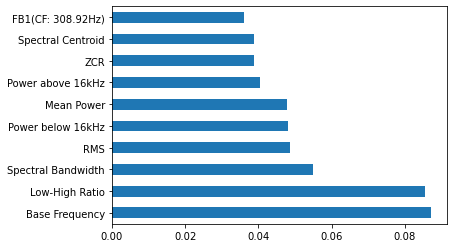

In [45]:
###RandomForestClassifier


from sklearn.ensemble import RandomForestClassifier
import pandas as pd

rfc = RandomForestClassifier()

# fit the predictor and target
rfc.fit(X_train, y_train)

# predict
rfc_predict = rfc.predict(X_test)# check performance
print('ROCAUC score:',metrics.roc_auc_score(y_test, rfc_predict))
print('Accuracy score:',metrics.accuracy_score(y_test, rfc_predict))
print('F1 score:',metrics.f1_score(y_test, rfc_predict))
print("Recall:",metrics.recall_score(y_test, rfc_predict))
print("Precision:",metrics.precision_score(y_test, rfc_predict))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, rfc_predict))
print(metrics.classification_report(y_test, rfc_predict))




a = time.perf_counter()
y_pred = rfc.predict(X_test)
b = time.perf_counter()
print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])



columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")
    
for i in range(5):
    columns.append("Formant "+str(i+1))
    


feat_importances = pd.Series(rfc.feature_importances_, index=columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()


[0.0535298  0.05487649 0.0583231  0.03323855 0.04001927 0.03826624
 0.04558979 0.0332706  0.10761833 0.02334612 0.02097232 0.04652832
 0.03339678 0.04646676 0.02489728 0.02138566 0.02371649 0.02191294
 0.0259367  0.01872503 0.01964531 0.02094619 0.02131805 0.02200472
 0.02336122 0.0284957  0.02470401 0.02177762 0.02346876 0.02226185]
Accuracy 0.8553008595988538
Precision: 0.8833063209076175
Recall: 0.9494773519163763
Confusion matrix: [[ 52  72]
 [ 29 545]]
              precision    recall  f1-score   support

           0       0.64      0.42      0.51       124
           1       0.88      0.95      0.92       574

    accuracy                           0.86       698
   macro avg       0.76      0.68      0.71       698
weighted avg       0.84      0.86      0.84       698

Balanced accuracy 0.6844160953130268


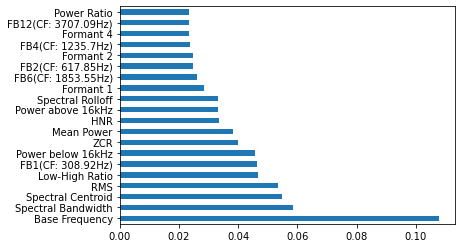

In [47]:

model = ExtraTreesClassifier(n_estimators=10, class_weight='balanced')
model.fit(X_train, y_train)
print(model.feature_importances_)
y_pred = model.predict(X_test)

# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

print(metrics.classification_report(y_test, y_pred))
print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, y_pred))


feat_importances = pd.Series(model.feature_importances_, index=columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [46]:
###Occupancy wise

In [227]:
path = "mask_data/"
mask_files = ["S1_mask.wav", "S4_mask.wav", "S5_mask.wav", "Abhay_mask.wav", "Sandesh_mask.wav"]
noMask_files = ["S1_noMask.wav", "S4_noMask.wav","S5_noMask.wav",  "Abhay_noMask.wav", "Sandesh_noMask.wav"]


X = [[],[],[], [], []]
y = [[],[],[], [], []]
k = -1
for i in mask_files:
    k +=1
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])//2
    print(chunk)
    
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X[k].append(a)
        y[k].append(1)
    
        

k = -1

for i in noMask_files:
    k +=1
    samprate, wavdata = read(path+i)
    times = np.arange(len(wavdata))/samprate
    chunk = int(len(times)/times[-1])//2
    print(chunk)
    for j in range(0, len(times), chunk):
        temp_signal = wavdata[j:j+chunk]
        a,b,c = extract_features(temp_signal,samprate)
        X[k].append(a)
        y[k].append(0)


    
    
    

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/scipy/signal/signaltools.py:1519: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:162: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  x = numpy.fromstring(x, 'int16')
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:177: FutureWarning: Pass order=50 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  A = lpc(x1, int(ncoeff))


24000
zcr 163
[-13. -14. -15. ... -50. -51. -50.]
337414804105.6563
27
Maximum power is 337414804105.6563 at frequency 54.0
Power at first harmonic is 4475796501.096356 at frequency 108.0
Energy in 0 Hz - 1 kHz 2295365948331.625
Energy in 1 kHz - 8 kHz 10742633720.373987
energy ratio between 0–1 and 1–8 kHz (LH1000) 213.66882722421587
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.5114434863203, 2024.7505260618013, 3061.639600925249, 4069.8061862706245, 5066.104652724082]
zcr 203
[  -50.   -50.   -49. ... -1270. -1248. -1231.]
2869473400634.873
69
Maximum power is 2869473400634.873 at frequency 138.0
Power at first harmonic is 182342184459.39407 at frequency 276.0
Energy in 0 Hz - 1 kHz 64261050370707.9
Energy in 1 kHz - 8 kHz 2920885964804.0986
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.000533791814032
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.2279312504136, 2073.158969661382, 3090.470333344725, 4084.5380326250543, 4968.074935985618]
zcr 968
[-1215. -1202. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.9826976810273, 2121.869204588263, 3235.3543142131803, 4356.633298758242, 4897.305197524839]
zcr 469
[490. 454. 426. ... 264. 333. 287.]
11639710008683.318
264
Maximum power is 11639710008683.318 at frequency 528.0
Power at first harmonic is 173611316536.18457 at frequency 1056.0
Energy in 0 Hz - 1 kHz 204099411210081.56
Energy in 1 kHz - 8 kHz 7330398520798.251
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.842880660716922
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1017.3624034572445, 2054.069985117246, 3052.718140120083, 4064.6267858099495, 5041.130557496466]
zcr 1378
[ 216.  187.  141. ... -288. -304. -320.]
11586890974309.893
58
Maximum power is 11586890974309.893 at frequency 116.0
Power at first harmonic is 1871859457889.4226 at frequency 232.0
Energy in 0 Hz - 1 kHz 206605195848840.28
Energy in 1 kHz - 8 kHz 6563455118181.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.478115128190975
(49, 12) (12,) (12,)
Filter

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.7368146255762, 2174.60497481053, 3041.3608795894233, 3949.6613151495685, 4973.893430587887]
zcr 355
[-673. -687. -697. ...  -90.  -92.  -96.]
2932486081071.258
228
Maximum power is 2932486081071.258 at frequency 456.0
Power at first harmonic is 80584248759.70566 at frequency 912.0
Energy in 0 Hz - 1 kHz 127125179918749.66
Energy in 1 kHz - 8 kHz 9721478736786.328
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.07673280585439
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.7822125163216, 2043.6589829180894, 3076.391426750868, 4089.67543109425, 5250.964479524469]
zcr 545
[-101. -108. -116. ... -732. -803. -864.]
842120521783.385
226
Maximum power is 842120521783.385 at frequency 452.0
Power at first harmonic is 9884170369.429731 at frequency 904.0
Energy in 0 Hz - 1 kHz 32000331704983.33
Energy in 1 kHz - 8 kHz 916674048676.6393
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.90917164196014
(49, 12) (12,) (12,)
Filter bank: 

[1113.2197822975884, 2058.8161275924153, 3014.251310523284, 4044.667253722364, 5016.928637689055]
zcr 352
[-21.  -1.  19. ...  31.  32.  33.]
2129696022093.4253
206
Maximum power is 2129696022093.4253 at frequency 412.0
Power at first harmonic is 1030142834.0862889 at frequency 824.0
Energy in 0 Hz - 1 kHz 36578074535382.02
Energy in 1 kHz - 8 kHz 4178946007613.9683
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.752942600535492
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.3848393875548, 2019.4228438908779, 3012.984193601667, 3973.491588633043, 4886.9890488720785]
zcr 456
[  34.   34.   33. ... -631. -622. -618.]
2294794609688.1304
291
Maximum power is 2294794609688.1304 at frequency 582.0
Power at first harmonic is 211722940061.42874 at frequency 1164.0
Energy in 0 Hz - 1 kHz 90283455708346.48
Energy in 1 kHz - 8 kHz 10487074408993.352
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.609022134039835
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1204.1622376896785, 2197.34

Energy in 0 Hz - 1 kHz 315023368139714.94
Energy in 1 kHz - 8 kHz 17332893063881.549
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.174886730026834
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.1508883699132, 2046.5512697994927, 3052.7573870521596, 3979.196137995419, 5027.829741878261]
zcr 602
[ 486.  547.  620. ... -352. -368. -381.]
11368148516858.41
71
Maximum power is 11368148516858.41 at frequency 142.0
Power at first harmonic is 204176956476.58954 at frequency 284.0
Energy in 0 Hz - 1 kHz 209951786634000.22
Energy in 1 kHz - 8 kHz 17871001719286.098
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.748182330899986
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1117.8157031173641, 2185.0890922736517, 2936.6775891127986, 3784.0960199177875]
zcr 653
[-394. -408. -424. ...  -72.  -76.  -80.]
12329173514402.49
69
Maximum power is 12329173514402.49 at frequency 138.0
Power at first harmonic is 208519361453.5835 at frequency 276.0
Energy in 0 Hz - 1 kHz 131709951849701

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.397048151594, 2111.707227207621, 3132.576716969739, 4253.474045275428, 5075.7121283811175]
zcr 236
[-25. -25. -24. ... 168. 166. 165.]
919972186240.6425
25
Maximum power is 919972186240.6425 at frequency 50.0
Power at first harmonic is 1107755092.815855 at frequency 100.0
Energy in 0 Hz - 1 kHz 2894496046310.774
Energy in 1 kHz - 8 kHz 23144179041.23135
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.06367329574447
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.281962912206, 2049.5740794583116, 3026.34532811768, 4030.311544781281, 5013.204383138896]
zcr 349
[163. 162. 160. ... 198. 198. 197.]
24916392619031.164
65
Maximum power is 24916392619031.164 at frequency 130.0
Power at first harmonic is 82637491284.31134 at frequency 260.0
Energy in 0 Hz - 1 kHz 312087370483621.1
Energy in 1 kHz - 8 kHz 34865837192717.727
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.951093552080414
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 970
[-1732. -1736. -1740. ...   225.   258.   291.]
14296168368639.025
69
Maximum power is 14296168368639.025 at frequency 138.0
Power at first harmonic is 1568695604206.1458 at frequency 276.0
Energy in 0 Hz - 1 kHz 246176906394418.22
Energy in 1 kHz - 8 kHz 12396870676165.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.85798777974828
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.2606782240696, 2258.0950286838574, 3258.636379312166, 4025.605822650908, 5103.432071236085]
zcr 740
[317. 334. 334. ... 138.  59.  -2.]
5594084581718.681
168
Maximum power is 5594084581718.681 at frequency 336.0
Power at first harmonic is 113823167507.50883 at frequency 672.0
Energy in 0 Hz - 1 kHz 154056268387837.7
Energy in 1 kHz - 8 kHz 16802501726248.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.168650650823876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.9071005717108, 2089.523406493507, 3106.547214535384, 4136.449377372631, 5293.498779745902]
zcr 450
[ 21.  62.  59. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.2865723563564, 2039.5357935332931, 2989.029303656399, 3989.07273823154, 5008.9382314330205]
zcr 1092
[688. 717. 743. ...   0.   1.  -9.]
674163426870.7507
71
Maximum power is 674163426870.7507 at frequency 142.0
Power at first harmonic is 1827318037.5885625 at frequency 284.0
Energy in 0 Hz - 1 kHz 8278587757931.819
Energy in 1 kHz - 8 kHz 818643915012.1755
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.112562502597596
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.4442269510032, 2110.6315258435297, 3094.584068762378, 3997.2524858301413, 4994.029183657478]
zcr 792
[-8.  7.  4. ... 81. 78. 80.]
8542493272939.587
66
Maximum power is 8542493272939.587 at frequency 132.0
Power at first harmonic is 752224741486.913 at frequency 264.0
Energy in 0 Hz - 1 kHz 332985526805390.56
Energy in 1 kHz - 8 kHz 29889009733929.492
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.140734663664388
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 624
[347. 250. 149. ... -17. -20. -22.]
8361447458628.517
169
Maximum power is 8361447458628.517 at frequency 338.0
Power at first harmonic is 2262044436.300418 at frequency 676.0
Energy in 0 Hz - 1 kHz 102428794584780.9
Energy in 1 kHz - 8 kHz 2315308262947.1377
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.2398086786077
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.2765192960148, 2111.0822772218166, 3064.740488973556, 4116.81457838862, 5179.473676845734]
zcr 180
[-24. -28. -31. ...  58.  55.  50.]
419609158925.9807
26
Maximum power is 419609158925.9807 at frequency 52.0
Power at first harmonic is 14161246679.592382 at frequency 104.0
Energy in 0 Hz - 1 kHz 2429969742637.646
Energy in 1 kHz - 8 kHz 19589270764.352657
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.045952086157
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.1987123248834, 2067.044662296291, 2991.554576868329, 4027.408058311721, 5034.411150164166]
zcr 638
[  43.   36.   31. ... -151. -126. -161

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.3175956185419, 2113.3800058492366, 2975.1175913812144, 3883.3005161169795, 4942.674134464865]
zcr 345
[-1179. -1218. -1291. ...  -274.  -279.  -284.]
37477392490965.75
73
Maximum power is 37477392490965.75 at frequency 146.0
Power at first harmonic is 736351976697.5579 at frequency 292.0
Energy in 0 Hz - 1 kHz 254997553788529.53
Energy in 1 kHz - 8 kHz 11255656753970.613
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.6550577511681
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.6070279426754, 2108.655834147134, 3049.2500370250405, 4054.510919800593, 5084.048911172422]
zcr 953
[-284. -283. -289. ... -217. -218. -219.]
3757762784024.004
220
Maximum power is 3757762784024.004 at frequency 440.0
Power at first harmonic is 90284917198.18564 at frequency 880.0
Energy in 0 Hz - 1 kHz 76320578971967.28
Energy in 1 kHz - 8 kHz 4121323662720.6724
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.518462809005545
(49, 12) (12,) (12,)
F

zcr 436
[ 1181.  1241.  1322. ... -1788. -1771. -1751.]
17708319807401.867
229
Maximum power is 17708319807401.867 at frequency 458.0
Power at first harmonic is 12680435709.927471 at frequency 916.0
Energy in 0 Hz - 1 kHz 286146649094101.94
Energy in 1 kHz - 8 kHz 28189176461577.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.150940361245617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.486090120553, 2074.9043117863766, 2935.9433188764597, 3956.0104664896608, 5028.9739768607715]
zcr 649
[-1728. -1700. -1665. ...    -4.    -5.    -6.]
3016719116202.2407
188
Maximum power is 3016719116202.2407 at frequency 376.0
Power at first harmonic is 5873749224.4793005 at frequency 752.0
Energy in 0 Hz - 1 kHz 64414053481923.03
Energy in 1 kHz - 8 kHz 3649746901948.89
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.64890969495097
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.0328183286633, 2147.629891811966, 3155.8948399023743, 4119.013881786175, 5038.258340523011]
zcr 221
[ -9

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.978888541227, 2014.0771797962411, 3007.3270521005215, 4060.2487425612962, 4980.35632189536]
zcr 419
[152. 156. 163. ... 122. 117. 115.]
7293061144967.827
62
Maximum power is 7293061144967.827 at frequency 124.0
Power at first harmonic is 1911994845654.658 at frequency 248.0
Energy in 0 Hz - 1 kHz 195038700698398.03
Energy in 1 kHz - 8 kHz 21896732541217.547
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.9072056906785
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1204.810018196814, 2227.086718216679, 3099.1639400657677, 4062.999510906416, 4858.330304022036]
zcr 569
[111. 106. 105. ...  52.  48.  45.]
2665858094974.7686
70
Maximum power is 2665858094974.7686 at frequency 140.0
Power at first harmonic is 218255305041.57883 at frequency 280.0
Energy in 0 Hz - 1 kHz 84791804735206.12
Energy in 1 kHz - 8 kHz 19803252731693.793
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.281710983746749
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 877
[657. 652. 708. ... 107. 107. 107.]
8338297409910.05
76
Maximum power is 8338297409910.05 at frequency 152.0
Power at first harmonic is 5201792891787.835 at frequency 304.0
Energy in 0 Hz - 1 kHz 107336909195883.2
Energy in 1 kHz - 8 kHz 3563482455004.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.121351950291
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1148.6824596042347, 2241.5146231283256, 3122.7814256690863, 4076.022948385902]
zcr 277
[107. 105. 104. ... 299. 332. 309.]
3135423259088.2056
317
Maximum power is 3135423259088.2056 at frequency 634.0
Power at first harmonic is 12589815759.314178 at frequency 1268.0
Energy in 0 Hz - 1 kHz 132347194738346.23
Energy in 1 kHz - 8 kHz 13996280819599.79
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.455883062378465
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.271578160937, 2044.30084903763, 3032.4661973281086, 3972.4042575236563, 4982.6789711246975]
zcr 669
[279. 274. 321. ... 147. 108.  75.]
529521930023

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.0008046668327, 2092.919301165484, 3176.1111311511822, 3963.300656630562, 4982.338825829132]
zcr 401
[125.  11.  10. ...  93.  92.  92.]
6349822664246.935
71
Maximum power is 6349822664246.935 at frequency 142.0
Power at first harmonic is 377462502244.53424 at frequency 284.0
Energy in 0 Hz - 1 kHz 180534366172551.9
Energy in 1 kHz - 8 kHz 1474046865351.9946
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.47532315021833
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.7961732481, 1982.008130212854, 3006.2811908136687, 3989.5456455772987, 5034.113621611797]
zcr 242
[  93.   93.   92. ... -825. -663. -541.]
3865831063459.056
317
Maximum power is 3865831063459.056 at frequency 634.0
Power at first harmonic is 30557084699.783535 at frequency 1268.0
Energy in 0 Hz - 1 kHz 185784424866006.75
Energy in 1 kHz - 8 kHz 18955143116581.32
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.801267324829048
(49, 12) (12,) (12,)
Filter bank:  

[1113.0262883846713, 2126.1405301603168, 3079.809122279937, 4059.940933992791, 5031.44675135675]
zcr 310
[-1841. -1861. -1879. ...   130.   131.   131.]
7193396002413.969
70
Maximum power is 7193396002413.969 at frequency 140.0
Power at first harmonic is 117751767223.39522 at frequency 280.0
Energy in 0 Hz - 1 kHz 96500208192699.58
Energy in 1 kHz - 8 kHz 3785460277228.5938
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.492331480321116
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.3962703022738, 2048.9643296141385, 3000.6690260358955, 3941.3005897075677, 4981.997219980654]
zcr 407
[131. 129. 126. ...  -6.  -4.   1.]
227097241624.31848
27
Maximum power is 227097241624.31848 at frequency 54.0
Power at first harmonic is 24361299446.601357 at frequency 108.0
Energy in 0 Hz - 1 kHz 1734155701760.214
Energy in 1 kHz - 8 kHz 47620589043.78649
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.416090951031315
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.534449782814, 1985.23

Energy in 0 Hz - 1 kHz 221114482156724.8
Energy in 1 kHz - 8 kHz 8730729836907.308
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.326002096870557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.4170202728405, 2133.6941174220856, 3105.781724948018, 3974.8741670951213, 4902.95127995792]
zcr 330
[  21.   21.   21. ... -198. -180. -180.]
64727860532850.05
65
Maximum power is 64727860532850.05 at frequency 130.0
Power at first harmonic is 4108864352792.0664 at frequency 260.0
Energy in 0 Hz - 1 kHz 332463400014229.1
Energy in 1 kHz - 8 kHz 21644867203044.68
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.359918677046126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.5545959058247, 2081.3033471643407, 3054.8408026814745, 3929.038619893881, 4892.991294901613]
zcr 342
[-186. -174. -145. ...  636.  672.  709.]
43226565072093.04
69
Maximum power is 43226565072093.04 at frequency 138.0
Power at first harmonic is 4465865074256.032 at frequency 276.0
Energy in 0 Hz - 1 kHz 3448422

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.1983767555043, 2095.03158489665, 3105.180059143146, 4070.879631002836, 5032.9901007986655]
zcr 878
[-76. -46. -12. ... 106. 107. 108.]
727548263350.6422
108
Maximum power is 727548263350.6422 at frequency 216.0
Power at first harmonic is 234762628619.1813 at frequency 432.0
Energy in 0 Hz - 1 kHz 17167798840757.613
Energy in 1 kHz - 8 kHz 512695326014.3878
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.48538199912482
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1184.629808442545, 2234.510924211468, 2995.0377258727617, 3930.4887960116794, 4986.24126804041]
zcr 107
[109. 109. 109. ... 148. 151. 154.]
435526274289.716
27
Maximum power is 435526274289.716 at frequency 54.0
Power at first harmonic is 88694794018.62984 at frequency 108.0
Energy in 0 Hz - 1 kHz 2113536806856.9944
Energy in 1 kHz - 8 kHz 2171676549.005567
energy ratio between 0–1 and 1–8 kHz (LH1000) 973.2281760950103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/2512129460.py:111: RuntimeWarning: divide by zero encountered in log10
  log_energy = 10 * np.log10(energy / E0)


zcr 500
[-434. -439. -441. ...  286.  344.  393.]
169568282413059.25
71
Maximum power is 169568282413059.25 at frequency 142.0
Power at first harmonic is 16092141257420.568 at frequency 284.0
Energy in 0 Hz - 1 kHz 520188297519260.0
Energy in 1 kHz - 8 kHz 6414638208539.335
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.09394179499814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.2080046052877, 2146.214302841245, 3098.774369524679, 4098.932579075298, 5104.859919208252]
zcr 315
[431. 456. 472. ...  32.  23.  12.]
22674942137406.754
65
Maximum power is 22674942137406.754 at frequency 130.0
Power at first harmonic is 536012426851.1372 at frequency 260.0
Energy in 0 Hz - 1 kHz 266066377695284.3
Energy in 1 kHz - 8 kHz 8763481426563.707
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.360808078943226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.7828367480815, 2154.327433003771, 3151.9567570718855, 4149.190590546457, 5071.056667021328]
zcr 339
[  0. -11. -21. ... 142. 14

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.2478387491985, 2148.5565609983405, 3052.690227467051, 4040.233524550262, 5007.71578386986]
zcr 347
[  -5.   -8.  -10. ... -187. -172. -156.]
57577835109167.01
67
Maximum power is 57577835109167.01 at frequency 134.0
Power at first harmonic is 2716353012372.683 at frequency 268.0
Energy in 0 Hz - 1 kHz 278784521117766.8
Energy in 1 kHz - 8 kHz 14352914270597.014
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.423548128401848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.1103381500711, 2076.96945071295, 2974.6435782768117, 4045.1490805057465, 5003.101034452127]
zcr 336
[-143. -133. -129. ...  -21.   -6.    7.]
25591110105572.14
69
Maximum power is 25591110105572.14 at frequency 138.0
Power at first harmonic is 2387930433051.1724 at frequency 276.0
Energy in 0 Hz - 1 kHz 247761265055641.9
Energy in 1 kHz - 8 kHz 6285468521838.273
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.418106095801534
(49, 12) (12,) (12,)
Filter ban

zcr 782
[-1034. -1010.  -985. ...    57.    67.    77.]
3079426213490.2285
59
Maximum power is 3079426213490.2285 at frequency 118.0
Power at first harmonic is 371565209689.1986 at frequency 236.0
Energy in 0 Hz - 1 kHz 85429846558428.45
Energy in 1 kHz - 8 kHz 9256185258699.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.229487544897168
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.2860488269432, 2151.6628765770943, 2985.4516605078666, 4051.2875579237866, 5021.080985552437]
zcr 159
[ 87.  98. 107. ...  56.  55.  55.]
178768399793.7988
35
Maximum power is 178768399793.7988 at frequency 70.0
Power at first harmonic is 12675093676.706388 at frequency 140.0
Energy in 0 Hz - 1 kHz 2312112194826.603
Energy in 1 kHz - 8 kHz 7099343529.398357
energy ratio between 0–1 and 1–8 kHz (LH1000) 325.67971746291107
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.1602408489896, 1984.0364348151413, 2970.6864047298195, 3973.9885830139406, 4972.439372467855]
zcr 136
[54. 52. 50. ... -8.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.568199619306, 1999.1879172636577, 2998.4445310979468, 4034.5422369085154, 5092.787677987178]
zcr 393
[ 241.  294.  361. ... 1644. 1638. 1640.]
24268229243742.016
69
Maximum power is 24268229243742.016 at frequency 138.0
Power at first harmonic is 4011242259372.799 at frequency 276.0
Energy in 0 Hz - 1 kHz 289573576280505.6
Energy in 1 kHz - 8 kHz 15342127747814.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.874407842273083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.5274926042102, 2199.8250424317334, 3187.9486431775344, 3854.553892970442, 4917.992185261517]
zcr 621
[1633. 1619. 1619. ...  531.  366.  201.]
47860386199997.086
71
Maximum power is 47860386199997.086 at frequency 142.0
Power at first harmonic is 1391048677251.7876 at frequency 284.0
Energy in 0 Hz - 1 kHz 372522575605002.06
Energy in 1 kHz - 8 kHz 27854995261877.754
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.37363629405585
(49, 12) (12,) (12,)
Fi

zcr 329
[-1405. -1425. -1443. ...  -202.  -175.  -152.]
6017525988721.724
67
Maximum power is 6017525988721.724 at frequency 134.0
Power at first harmonic is 47249128449.283775 at frequency 268.0
Energy in 0 Hz - 1 kHz 111471587815835.44
Energy in 1 kHz - 8 kHz 5049877713588.566
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.074116273326748
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.2903491532995, 2075.352905666861, 3105.4850780006986, 4091.22431341919, 5123.709747433349]
zcr 444
[-131. -108.  -86. ...  178.  175.  190.]
8469277144338.678
229
Maximum power is 8469277144338.678 at frequency 458.0
Power at first harmonic is 10056747799.69256 at frequency 916.0
Energy in 0 Hz - 1 kHz 183882996135726.53
Energy in 1 kHz - 8 kHz 22418652752705.46
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.20223222885397
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.495898885346, 2100.3477209333682, 3000.066345795952, 3996.7648466195305, 4923.047116339572]
zcr 831
[194. 169. 185. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.517270709503, 2038.7417422102094, 3032.8616115946725, 4081.9427608151814, 5129.049857308808]
zcr 277
[252. 281. 358. ...  12.  13.  13.]
1335903889748.3591
108
Maximum power is 1335903889748.3591 at frequency 216.0
Power at first harmonic is 264793539885.6887 at frequency 432.0
Energy in 0 Hz - 1 kHz 16682857345353.912
Energy in 1 kHz - 8 kHz 375538236200.0773
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.42385817796116
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.4180457005846, 2058.6888589041905, 2984.5277883662884, 3935.8269171050124, 4978.2928616848285]
zcr 226
[ 13.  14.  14. ... -66. -69. -71.]
390913758389.60266
30
Maximum power is 390913758389.60266 at frequency 60.0
Power at first harmonic is 28815524014.818954 at frequency 120.0
Energy in 0 Hz - 1 kHz 1784775126473.592
Energy in 1 kHz - 8 kHz 40622658246.40983
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.93545876903139
(49, 12) (12,) (12,)
Filter bank:  (

zcr 867
[ 17.  31.  45. ... 970. 964. 959.]
5907601485869.345
239
Maximum power is 5907601485869.345 at frequency 478.0
Power at first harmonic is 12117243768.086094 at frequency 956.0
Energy in 0 Hz - 1 kHz 147689004094895.25
Energy in 1 kHz - 8 kHz 2730448529958.809
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.0896495482093
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1105.6050234402508, 2022.4319422246715, 2885.7030859138263, 3980.434278160972]
zcr 337
[950. 941. 937. ...  54.  46.  35.]
22940192872997.12
70
Maximum power is 22940192872997.12 at frequency 140.0
Power at first harmonic is 284803913293.6401 at frequency 280.0
Energy in 0 Hz - 1 kHz 182078596875315.25
Energy in 1 kHz - 8 kHz 1930214168560.4958
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.33077419129339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.4953224825908, 2095.0573449588123, 3147.982445269571, 4030.47858127773, 5107.589716170727]
zcr 538
[ 12.  12.  63. ... -21. -27. -30.]
265727507079

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.0835862638878, 2011.757512241164, 3035.0012275280496, 3965.8456375343962, 4973.410312550106]
zcr 669
[  5.  18.  32. ... 100.  99.  99.]
2440527316180.486
65
Maximum power is 2440527316180.486 at frequency 130.0
Power at first harmonic is 25679635060.36316 at frequency 260.0
Energy in 0 Hz - 1 kHz 66834009054559.28
Energy in 1 kHz - 8 kHz 2548481427750.739
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.225032808477724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.569010815873, 2159.380343109949, 3067.3138223981605, 4141.114613391881, 4988.588432710662]
zcr 431
[100. 101. 101. ...  61.  60.  55.]
927937558262.5729
69
Maximum power is 927937558262.5729 at frequency 138.0
Power at first harmonic is 31600472774.10754 at frequency 276.0
Energy in 0 Hz - 1 kHz 7729153545661.815
Energy in 1 kHz - 8 kHz 249691720642.18378
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.954785067695294
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 1117
[1973. 1953. 1931. ...  915.  917.  923.]
24556724555913.67
74
Maximum power is 24556724555913.67 at frequency 148.0
Power at first harmonic is 2295545611243.3984 at frequency 296.0
Energy in 0 Hz - 1 kHz 290822269360153.2
Energy in 1 kHz - 8 kHz 5178028305779.025
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.16467353714079
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.9056978381393, 2138.0601461966853, 3160.5841289522364, 4069.3581236189757, 4927.069503700065]
zcr 182
[931. 937. 940. ... -59. -60. -61.]
1007544600943.7462
183
Maximum power is 1007544600943.7462 at frequency 366.0
Power at first harmonic is 21645510502.814255 at frequency 732.0
Energy in 0 Hz - 1 kHz 9769186449173.162
Energy in 1 kHz - 8 kHz 53199276906.8328
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.63382017920677
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.2806826978324, 2020.3587523396707, 2972.2006065127975, 4020.2081461144844, 4990.7624195946355]
zcr 428
[-61. -61. -61. ...  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.9446181036058, 2133.815173879918, 3090.646845863554, 4039.2905297312495, 5123.3731512891345]
zcr 319
[ 38.  40.  41. ... 337. 488. 657.]
20437639539044.258
168
Maximum power is 20437639539044.258 at frequency 336.0
Power at first harmonic is 102542169534.59613 at frequency 672.0
Energy in 0 Hz - 1 kHz 199521548225258.03
Energy in 1 kHz - 8 kHz 7832337668701.783
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.47407385441911
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.7614364567858, 2103.963472958069, 3024.8962060043677, 4037.8887679714153, 4982.767169300131]
zcr 445
[ 864. 1125. 1417. ... -166.  -47.   61.]
13209212769846.535
176
Maximum power is 13209212769846.535 at frequency 352.0
Power at first harmonic is 1541287601626.2473 at frequency 704.0
Energy in 0 Hz - 1 kHz 332104211943913.56
Energy in 1 kHz - 8 kHz 15556710366430.479
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.34797165476287
(49, 12) (12,) (12,)
Filter

[1008.9290023384191, 2042.0980879178935, 3025.0883989625777, 4030.1321277728684, 4987.338646880965]
zcr 745
[  57.   46.   48. ... 2261. 2219. 2185.]
16965389102023.914
263
Maximum power is 16965389102023.914 at frequency 526.0
Power at first harmonic is 63219867842.893616 at frequency 1052.0
Energy in 0 Hz - 1 kHz 430807322985623.4
Energy in 1 kHz - 8 kHz 29927490629864.707
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.39503660075395
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1165.3520709329107, 2189.351232037489, 3243.4983121406776, 4273.910576106107]
zcr 536
[2152. 2117. 2071. ... -250. -239. -226.]
18421875171405.465
70
Maximum power is 18421875171405.465 at frequency 140.0
Power at first harmonic is 388009228630.8431 at frequency 280.0
Energy in 0 Hz - 1 kHz 283038217536908.06
Energy in 1 kHz - 8 kHz 9172149404195.576
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.85843950682259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.8663586091009, 2009.25181593404

zcr 476
[ 40.  25. -40. ... -47. -47. -46.]
616236265104.7753
64
Maximum power is 616236265104.7753 at frequency 128.0
Power at first harmonic is 32533967693.18766 at frequency 256.0
Energy in 0 Hz - 1 kHz 10745520941930.924
Energy in 1 kHz - 8 kHz 208054779717.08136
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.64755626639763
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.384455636526, 2094.34939011432, 3099.777855593983, 4043.7653422448207, 4926.475231583806]
zcr 366
[ -43.  -40.  -39. ... 1814. 1887. 1938.]
7940865159476.059
172
Maximum power is 7940865159476.059 at frequency 344.0
Power at first harmonic is 3006535913.6775923 at frequency 688.0
Energy in 0 Hz - 1 kHz 215148766480170.97
Energy in 1 kHz - 8 kHz 8841059138688.93
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.33518010740013
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1162.0118812500154, 2332.1215331047515, 2847.176687241328, 3786.6526374025534, 4925.329373428055]
zcr 484
[1971. 1992. 1997. ...  -42. 

70
Maximum power is 12374824476726.48 at frequency 140.0
Power at first harmonic is 345629041340.912 at frequency 280.0
Energy in 0 Hz - 1 kHz 204628844609909.88
Energy in 1 kHz - 8 kHz 8894111721554.092
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.007226692915268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.6411597638134, 2018.5352025966333, 3031.659682172296, 4005.039412337152, 4980.377285586301]
zcr 586
[-872. -884. -886. ...   58.   88.  115.]
1978742877003.3167
65
Maximum power is 1978742877003.3167 at frequency 130.0
Power at first harmonic is 3426902565.1372647 at frequency 260.0
Energy in 0 Hz - 1 kHz 57927096173683.445
Energy in 1 kHz - 8 kHz 7082174351622.644
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.17928129097971
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[952.2761401726758, 1953.9266550104578, 3029.074984429725, 4020.070889666823, 5007.745430542649]
zcr 223
[136. 154. 172. ...  33.  20.   2.]
265521487986.09805
29
Maximum power is 265521487986.098

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.401207702125, 2007.2329687517006, 3004.202846382376, 3996.360644733433, 4994.955300640715]
zcr 919
[ 93.  50.  58. ... 345. 373. 403.]
79487185236753.84
70
Maximum power is 79487185236753.84 at frequency 140.0
Power at first harmonic is 7418917507115.128 at frequency 280.0
Energy in 0 Hz - 1 kHz 282502087955995.56
Energy in 1 kHz - 8 kHz 9294655512687.633
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.394035321735938
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.6584011311377, 2044.7925598155557, 2986.429081047396, 4018.3417744435283, 5050.140476415089]
zcr 1093
[433. 464. 498. ... 543. 487. 427.]
7803988971931.68
247
Maximum power is 7803988971931.68 at frequency 494.0
Power at first harmonic is 28555443081.76752 at frequency 988.0
Energy in 0 Hz - 1 kHz 144541608649599.2
Energy in 1 kHz - 8 kHz 13351868197866.686
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.825571860624983
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 791
[-460. -451. -440. ... -119. -103.  -85.]
2251369154771.7544
58
Maximum power is 2251369154771.7544 at frequency 116.0
Power at first harmonic is 1225724075052.4685 at frequency 232.0
Energy in 0 Hz - 1 kHz 92916262274110.69
Energy in 1 kHz - 8 kHz 4548701132275.349
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.42698774268165
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1170.6929481159834, 2236.5552365928584, 3234.914267286575, 4364.431414372731, 5000.661917404484]
zcr 324
[-65. -49. -40. ...   8.   8.  10.]
1465065371225.1345
231
Maximum power is 1465065371225.1345 at frequency 462.0
Power at first harmonic is 3126868793.9730983 at frequency 924.0
Energy in 0 Hz - 1 kHz 50455639120257.125
Energy in 1 kHz - 8 kHz 3120856349510.864
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.167241766243137
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1009.2198933900135, 2032.6932730004035, 3040.013335631957, 4040.362595660132, 5075.894525329489]
zcr 685
[12. 13. 15. ... 60. 45

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.9899370632334, 2227.2252823334293, 2854.164771168723, 3878.555314494782, 4889.094818866252]
zcr 540
[ 89.  82.  78. ... -29. -30. -31.]
194018387016.01562
43
Maximum power is 194018387016.01562 at frequency 86.0
Power at first harmonic is 2521745998.4629645 at frequency 172.0
Energy in 0 Hz - 1 kHz 1734261074304.2744
Energy in 1 kHz - 8 kHz 89882332119.72572
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.29479390893186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.633587088539, 2030.6931063262648, 2990.331517823934, 3981.4889252841913, 4904.062754197451]
zcr 259
[-30. -29. -29. ... -23. -22. -22.]
350555146512.89154
29
Maximum power is 350555146512.89154 at frequency 58.0
Power at first harmonic is 3725315544.024604 at frequency 116.0
Energy in 0 Hz - 1 kHz 1644683882149.4902
Energy in 1 kHz - 8 kHz 23554856410.508926
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.82355797404563
(49, 12) (12,) (12,)
Filter bank:  (49, 

[1094.3156117154156, 2067.0279560557915, 3046.1787801072946, 4106.910985361708, 5006.010881956554]
zcr 1023
[ -52.  -51.  -50. ... -515. -628. -730.]
69205298485123.12
70
Maximum power is 69205298485123.12 at frequency 140.0
Power at first harmonic is 5834484682214.211 at frequency 280.0
Energy in 0 Hz - 1 kHz 701658468422340.8
Energy in 1 kHz - 8 kHz 24532285818947.29
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.60143052305469
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.7111115178116, 2181.9583069566547, 3157.3135478009726, 4216.962200138332, 4871.1893490310895]
zcr 560
[-824. -910. -982. ...  125.  108.  151.]
37145628156579.08
67
Maximum power is 37145628156579.08 at frequency 134.0
Power at first harmonic is 1169793210334.2415 at frequency 268.0
Energy in 0 Hz - 1 kHz 313520743109087.2
Energy in 1 kHz - 8 kHz 4211970373584.959
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.43564776127293
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.9619100772145, 2082.403

Energy in 0 Hz - 1 kHz 234672542841481.75
Energy in 1 kHz - 8 kHz 2350783960372.576
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.82735410713303
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.0105659523701, 2106.794167490071, 3104.3551438887052, 4112.291602909474, 5081.009387501101]
zcr 1451
[ -141.  -142.  -145. ... -1142. -1135. -1134.]
5910190414833.79
260
Maximum power is 5910190414833.79 at frequency 520.0
Power at first harmonic is 1432856426177.4685 at frequency 1040.0
Energy in 0 Hz - 1 kHz 224697705160961.16
Energy in 1 kHz - 8 kHz 19692231499578.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.410474489179562
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.1128763419852, 2220.8846935127954, 2892.4227700125743, 4026.080428786012, 5102.271573617998]
zcr 569
[-1142. -1151. -1155. ...  -823.  -845.  -899.]
4173727876295.495
71
Maximum power is 4173727876295.495 at frequency 142.0
Power at first harmonic is 254190542094.01373 at frequency 284.0
Energy in 0 Hz 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.798030154633, 2155.220404076798, 2962.8000274419323, 4049.2477365666446, 5104.299437620201]
zcr 716
[  81.   89.   96. ... -208. -184. -164.]
4351661569414.07
60
Maximum power is 4351661569414.07 at frequency 120.0
Power at first harmonic is 1982708000149.789 at frequency 240.0
Energy in 0 Hz - 1 kHz 86301208734517.11
Energy in 1 kHz - 8 kHz 4481137700802.943
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.258771878189194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.6547959173806, 1916.6334137118793, 2946.4756365815556, 3958.299419895132, 5016.109025810062]
zcr 304
[-164. -167. -160. ...   12.   13.   14.]
228213905061.27606
26
Maximum power is 228213905061.27606 at frequency 52.0
Power at first harmonic is 32211370025.795723 at frequency 104.0
Energy in 0 Hz - 1 kHz 1581675087421.574
Energy in 1 kHz - 8 kHz 24247514122.427086
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.23040174079726
(49, 12) (12,) (12,)
Filter ban

zcr 290
[1874. 1787. 1710. ... -177. -181. -186.]
14034770906790.127
192
Maximum power is 14034770906790.127 at frequency 384.0
Power at first harmonic is 40455824317.80384 at frequency 768.0
Energy in 0 Hz - 1 kHz 234372047388298.25
Energy in 1 kHz - 8 kHz 2269821472825.5977
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.255718651978
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.3568516255787, 2196.1495742379157, 3202.9740140328763, 3978.9738245034523, 4871.641513178015]
zcr 389
[-191. -196. -201. ... -207. -206. -215.]
2803540750003.6494
229
Maximum power is 2803540750003.6494 at frequency 458.0
Power at first harmonic is 20295357755.490295 at frequency 916.0
Energy in 0 Hz - 1 kHz 119880225453194.33
Energy in 1 kHz - 8 kHz 14101463215805.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.501261437807798
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[979.9433041737674, 2043.9770533346405, 3037.001456276204, 4124.117194323139, 5026.420374495633]
zcr 531
[-230. -238. -24

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.4840817729537, 2076.4622812034204, 2908.564607576069, 3931.1440811205366, 4935.970942998893]
zcr 486
[-256. -239. -168. ...  628.  673.  718.]
11962391406055.943
173
Maximum power is 11962391406055.943 at frequency 346.0
Power at first harmonic is 123315497.88977894 at frequency 692.0
Energy in 0 Hz - 1 kHz 135112541296092.0
Energy in 1 kHz - 8 kHz 1308759760467.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.23708397619538
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.4663568902868, 2020.8159397933523, 2964.4291729958923, 4024.791243105534, 5033.464210911574]
zcr 284
[ 762.  800.  828. ... -316. -278. -235.]
6290348957803.659
65
Maximum power is 6290348957803.659 at frequency 130.0
Power at first harmonic is 262333717157.42737 at frequency 260.0
Energy in 0 Hz - 1 kHz 124595110162285.28
Energy in 1 kHz - 8 kHz 2445726651874.7524
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.944004746719294
(49, 12) (12,) (12,)
Fil

zcr 400
[4575. 4570. 4561. ... -547. -563. -582.]
53739073990002.75
171
Maximum power is 53739073990002.75 at frequency 342.0
Power at first harmonic is 3160180592843.407 at frequency 684.0
Energy in 0 Hz - 1 kHz 482614067304751.0
Energy in 1 kHz - 8 kHz 19198846701784.883
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.13765929803915
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1290.4276765087418, 2391.0914519280564, 3410.6933130847365]
zcr 309
[-602. -622. -640. ... -103. -129. -174.]
1474966711610.7102
72
Maximum power is 1474966711610.7102 at frequency 144.0
Power at first harmonic is 9262808066.6847 at frequency 288.0
Energy in 0 Hz - 1 kHz 26404567396287.258
Energy in 1 kHz - 8 kHz 240006139712.67804
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.01621636803681
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.9286949469565, 2075.906739500496, 3034.310931879061, 3992.011223264139, 4974.532283351219]
zcr 352
[-233. -304. -378. ...  239.  203.  158.]
2557129

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.362053937959, 2107.2074191117545, 2981.294947710256, 3924.192653910647, 4950.506293059323]
zcr 395
[-743. -808. -867. ... -105. -121. -139.]
12245335269144.967
68
Maximum power is 12245335269144.967 at frequency 136.0
Power at first harmonic is 380602831702.29193 at frequency 272.0
Energy in 0 Hz - 1 kHz 130969174213212.23
Energy in 1 kHz - 8 kHz 9407400666617.705
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.921930069159083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.881856042557, 2201.6348933811464, 3216.80288383531, 4428.763270394038, 4464.077866048438]
zcr 215
[-159. -181. -203. ... -118. -114. -111.]
1056941058415.8512
69
Maximum power is 1056941058415.8512 at frequency 138.0
Power at first harmonic is 55649605966.001755 at frequency 276.0
Energy in 0 Hz - 1 kHz 14173008474009.021
Energy in 1 kHz - 8 kHz 291518586446.9863
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.617855371586856
(49, 12) (12,) (12,)
Filter

zcr 421
[-225. -216. -207. ...    0.   -2.   -2.]
2149571384084.8606
306
Maximum power is 2149571384084.8606 at frequency 612.0
Power at first harmonic is 10950014766.351404 at frequency 1224.0
Energy in 0 Hz - 1 kHz 72077249373437.67
Energy in 1 kHz - 8 kHz 4735519907838.276
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.220556723694635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.797343780086, 2037.8007884803858, 3025.884373556234, 4105.057342815976, 5079.565301018539]
zcr 322
[  5.  16.  26. ... -66. -73. -80.]
7081754674592.17
59
Maximum power is 7081754674592.17 at frequency 118.0
Power at first harmonic is 4055156071694.8906 at frequency 236.0
Energy in 0 Hz - 1 kHz 110753427249053.48
Energy in 1 kHz - 8 kHz 7993005158998.573
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.856293727568362
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.0125431385443, 2089.014975620962, 3059.517171787483, 4108.533053528325, 5094.535612939542]
zcr 185
[-86. -91. -98. ... -57. -5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.3186059521597, 2027.7746116072185, 2966.9997982874265, 4007.95329057623, 4970.886599640814]
zcr 1044
[-630. -600. -566. ...   77.   80.   81.]
1495990089442.7395
220
Maximum power is 1495990089442.7395 at frequency 440.0
Power at first harmonic is 18495547431.932674 at frequency 880.0
Energy in 0 Hz - 1 kHz 60540926414250.54
Energy in 1 kHz - 8 kHz 5674995944045.3545
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.66801227898229
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.0907665890666, 2113.250781694676, 2877.590046346238, 3933.868707502628, 4955.955998670058]
zcr 351
[81. 83. 85. ... 70. 70. 66.]
452485723055.3214
24
Maximum power is 452485723055.3214 at frequency 48.0
Power at first harmonic is 444074705451.2241 at frequency 96.0
Energy in 0 Hz - 1 kHz 3450584343578.714
Energy in 1 kHz - 8 kHz 49949017013.286606
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.08212713497139
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 509
[228. 203. 214. ...  96. 103. 122.]
48536481547314.78
71
Maximum power is 48536481547314.78 at frequency 142.0
Power at first harmonic is 6140929722357.919 at frequency 284.0
Energy in 0 Hz - 1 kHz 427672437725895.25
Energy in 1 kHz - 8 kHz 17348031168424.82
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.65250572666151
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7418277795525, 2108.489123109495, 3059.0342513129895, 4083.803502077221, 4996.820778116242]
zcr 304
[ 156.  202.  255. ... -645. -553. -463.]
20683639539173.477
65
Maximum power is 20683639539173.477 at frequency 130.0
Power at first harmonic is 87787497157.87622 at frequency 260.0
Energy in 0 Hz - 1 kHz 281374112860650.78
Energy in 1 kHz - 8 kHz 3113497876487.0615
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.37234776537676
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.0037485376577, 2102.2794436987892, 3109.9473059096963, 4137.8081218441785, 5138.234582621331]
zcr 263
[-357. -209.  -33. ... -2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.8867881377817, 2083.9398254502953, 3027.4010027364984, 4002.3846064496897, 5021.043767126866]
zcr 651
[ 55.  54.  53. ... 332. 375. 415.]
14291474467875.596
68
Maximum power is 14291474467875.596 at frequency 136.0
Power at first harmonic is 362257594258.17523 at frequency 272.0
Energy in 0 Hz - 1 kHz 281716113766058.94
Energy in 1 kHz - 8 kHz 10807650210063.121
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.06636116921604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1196.0034329517118, 2377.2753218678686, 3364.0788409986203, 3559.1065404404735, 4665.056206569935]
zcr 323
[456. 499. 542. ... 483. 518. 533.]
13141604947072.229
230
Maximum power is 13141604947072.229 at frequency 460.0
Power at first harmonic is 183346238847.72113 at frequency 920.0
Energy in 0 Hz - 1 kHz 283607643392692.9
Energy in 1 kHz - 8 kHz 8608055129475.224
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.94677358902818
(49, 12) (12,) (12,)
Filter bank:

zcr 653
[63. 62. 63. ... 66. 60. 60.]
15044733882026.994
67
Maximum power is 15044733882026.994 at frequency 134.0
Power at first harmonic is 339376824747.22833 at frequency 268.0
Energy in 0 Hz - 1 kHz 142828362458984.1
Energy in 1 kHz - 8 kHz 3373197282016.1226
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.342131372054574
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.7019674925245, 2055.286099093869, 3038.8113217445243, 4027.7676827816895, 5035.667744746863]
zcr 425
[66. 74. 76. ... 45. 45. 46.]
11008031115123.074
67
Maximum power is 11008031115123.074 at frequency 134.0
Power at first harmonic is 403586684826.4934 at frequency 268.0
Energy in 0 Hz - 1 kHz 243624891068360.12
Energy in 1 kHz - 8 kHz 47909203620369.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.085137565609173
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.5313724200123, 2172.949774856798, 3255.4525439422064, 4152.73975328679, 4904.169135487958]
zcr 930
[ 47.  48.  48. ... -86. -42.  -6.]
110720

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.8383439039976, 2062.7557092478055, 2994.1107733740687, 3981.772807077077, 4957.218627459264]
zcr 626
[-2761. -2797. -2819. ...   287.   363.   420.]
17388429041762.936
169
Maximum power is 17388429041762.936 at frequency 338.0
Power at first harmonic is 614745110936.8162 at frequency 676.0
Energy in 0 Hz - 1 kHz 554819260615966.6
Energy in 1 kHz - 8 kHz 52955167955697.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.477150428077836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1238.2953228729577, 2214.879082443473, 3222.4649656537263]
zcr 558
[ 461.  473.  437. ... -134. -134. -133.]
5583947452067.173
168
Maximum power is 5583947452067.173 at frequency 336.0
Power at first harmonic is 9381198232.015661 at frequency 672.0
Energy in 0 Hz - 1 kHz 116241443183825.98
Energy in 1 kHz - 8 kHz 4200430200522.0024
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.67369951044068
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 289
[226. 182. 139. ...  15.  14.  12.]
289258066848.02026
69
Maximum power is 289258066848.02026 at frequency 138.0
Power at first harmonic is 11593304557.405998 at frequency 276.0
Energy in 0 Hz - 1 kHz 7485527410706.356
Energy in 1 kHz - 8 kHz 139364852037.63834
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.71173076468905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.535317586359, 2027.2512360565029, 3048.544976887377, 3978.840889828199, 4957.104064999691]
zcr 109
[10. 10. 12. ... 63. 62. 61.]
865308965571.3865
22
Maximum power is 865308965571.3865 at frequency 44.0
Power at first harmonic is 15216319695.219877 at frequency 88.0
Energy in 0 Hz - 1 kHz 6031394481634.672
Energy in 1 kHz - 8 kHz 10949661805.317085
energy ratio between 0–1 and 1–8 kHz (LH1000) 550.8292939884103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.1668024399883, 2071.86269094615, 3023.946105614103, 4040.5596898173253, 5041.9752993992815]
zcr 164
[  61.   59.   58. ... -967. -938. -909.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1287.7559663562618, 2488.111442616486, 3296.4132431561934, 4174.760951343843]
zcr 425
[3251. 3311. 3371. ...  130.   90.   53.]
39643752977294.86
67
Maximum power is 39643752977294.86 at frequency 134.0
Power at first harmonic is 2607953898055.1777 at frequency 268.0
Energy in 0 Hz - 1 kHz 303971677084451.4
Energy in 1 kHz - 8 kHz 19810254795252.28
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.34415787308809
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.6470804784665, 2134.783163673283, 3093.683346987719, 4064.726163604849, 5081.657312452325]
zcr 397
[ 20. -11. -43. ... 436. 454. 444.]
37451613476002.26
67
Maximum power is 37451613476002.26 at frequency 134.0
Power at first harmonic is 1238769788265.9983 at frequency 268.0
Energy in 0 Hz - 1 kHz 396497190639010.56
Energy in 1 kHz - 8 kHz 6247983225123.412
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.460028036675595
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

zcr 1006
[-5. -6. -5. ... 40. 30. 50.]
30841863077943.496
69
Maximum power is 30841863077943.496 at frequency 138.0
Power at first harmonic is 1620189622973.4905 at frequency 276.0
Energy in 0 Hz - 1 kHz 571089742840588.5
Energy in 1 kHz - 8 kHz 58932186185572.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.690625442644865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1180.834376987202, 2234.8726727070416, 2909.193862855686, 3973.6002216430843]
zcr 477
[  3. -89. -82. ... 207. 209. 210.]
20597183821153.81
69
Maximum power is 20597183821153.81 at frequency 138.0
Power at first harmonic is 1772530078565.4578 at frequency 276.0
Energy in 0 Hz - 1 kHz 155647655808021.6
Energy in 1 kHz - 8 kHz 3220881857502.3354
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.32454672172301
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.3044814153247, 2058.19398635071, 3074.9263326439022, 4087.9531666788403, 5066.405537452536]
zcr 864
[ 210.  210.  211. ... -101.  -97.  -93.]
2992216174

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.9606855921493, 2085.340401550178, 3102.6827338464636, 4130.751611768615, 5057.371994865585]
zcr 405
[ -69.  -66.  -63. ... -128. -111.  -94.]
10033477384727.059
232
Maximum power is 10033477384727.059 at frequency 464.0
Power at first harmonic is 13188319523.634918 at frequency 928.0
Energy in 0 Hz - 1 kHz 158189729853664.9
Energy in 1 kHz - 8 kHz 3055112698894.765
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.77868885520738
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.962255347292, 2082.1729034081923, 2983.2471205090483, 3979.0412541672877, 5014.597123910688]
zcr 602
[-80. -69. -60. ... 134. 126. 141.]
744075334524.6982
24
Maximum power is 744075334524.6982 at frequency 48.0
Power at first harmonic is 270198875276.91513 at frequency 96.0
Energy in 0 Hz - 1 kHz 7176572179281.792
Energy in 1 kHz - 8 kHz 265154465884.20895
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.065628162626343
(49, 12) (12,) (12,)
Filter bank: 

zcr 382
[-119. -136. -136. ... 2586. 2410. 2182.]
25023883622166.566
68
Maximum power is 25023883622166.566 at frequency 136.0
Power at first harmonic is 205433637733.35675 at frequency 272.0
Energy in 0 Hz - 1 kHz 195612395145263.03
Energy in 1 kHz - 8 kHz 19863139370100.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.848009999854868
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.8965918760503, 2066.3595157444965, 3054.7266175053437, 4004.504213649135, 5025.019581966606]
zcr 408
[1918. 1621. 1302. ... -205. -220. -247.]
30997191902454.68
70
Maximum power is 30997191902454.68 at frequency 140.0
Power at first harmonic is 2990665642574.5107 at frequency 280.0
Energy in 0 Hz - 1 kHz 316220503735879.06
Energy in 1 kHz - 8 kHz 35121180877619.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.003697934809196
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.046702068453, 2099.0519429928536, 3191.5862437172323, 3957.271548872911, 4932.130477776885]
zcr 1454
[-293. -361. -453

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.5804272253608, 2100.1280512103967, 3107.091066860298, 3950.37256179666, 5005.540571190885]
zcr 366
[-745. -805. -864. ...  425.  330.  245.]
7492033688698.869
67
Maximum power is 7492033688698.869 at frequency 134.0
Power at first harmonic is 165557073431.67093 at frequency 268.0
Energy in 0 Hz - 1 kHz 134438296755770.7
Energy in 1 kHz - 8 kHz 8736007105809.355
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.388986653452996
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.7906687603568, 2076.390189825151, 3025.7303187203356, 4010.293467963232, 5049.181313429836]
zcr 632
[ 165.   84.   -3. ... -254. -243. -233.]
6670312862008.943
69
Maximum power is 6670312862008.943 at frequency 138.0
Power at first harmonic is 310118534777.4679 at frequency 276.0
Energy in 0 Hz - 1 kHz 106276685915634.5
Energy in 1 kHz - 8 kHz 9165446726015.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.595363444094072
(49, 12) (12,) (12,)
Filter bank:

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.8365304865563, 2114.805506469631, 3081.8847528412525, 3948.395883467051, 4961.583619648441]
zcr 996
[-817. -792. -768. ...  -21.   21.   20.]
30145661519929.09
237
Maximum power is 30145661519929.09 at frequency 474.0
Power at first harmonic is 138555463658.7252 at frequency 948.0
Energy in 0 Hz - 1 kHz 309421563113843.6
Energy in 1 kHz - 8 kHz 14085563565170.49
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.96728314648008
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.59845036147, 2165.5842092747707, 3134.0614413920084, 4187.924151967808, 5312.612138698044]
zcr 1087
[  -22.   -29.    -8. ... -1128. -1174. -1234.]
43771290487366.914
69
Maximum power is 43771290487366.914 at frequency 138.0
Power at first harmonic is 4711052878298.39 at frequency 276.0
Energy in 0 Hz - 1 kHz 243799749980483.16
Energy in 1 kHz - 8 kHz 10468013186508.537
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.28997352570199
(49, 12) (12,) (12,)
Fil

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[985.2064208364678, 1986.160565544639, 2997.567084966166, 4034.7103877909635, 5035.876070484896]
zcr 626
[  74.   73.   76. ... -245. -233. -216.]
4447022487252.627
68
Maximum power is 4447022487252.627 at frequency 136.0
Power at first harmonic is 165217687539.78683 at frequency 272.0
Energy in 0 Hz - 1 kHz 70255826837843.4
Energy in 1 kHz - 8 kHz 3242353634700.5576
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.668156763021244
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[968.0430512839064, 1989.7702532379558, 2996.7800617878593, 3969.085343004431, 4985.182236779307]
zcr 433
[-198. -183. -167. ... -124. -121. -119.]
864941073062.7743
70
Maximum power is 864941073062.7743 at frequency 140.0
Power at first harmonic is 3965142880.8450165 at frequency 280.0
Energy in 0 Hz - 1 kHz 10785860369662.078
Energy in 1 kHz - 8 kHz 272798457201.90988
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.53783492873275
(49, 12) (12,) (12,)
Filter ba

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.3909897557687, 2074.864692429411, 3077.847093704281, 4024.2721614846328, 4990.569578106253]
zcr 775
[  -42.   -33.   -28. ... -1818. -1888. -1953.]
90651689753670.3
185
Maximum power is 90651689753670.3 at frequency 370.0
Power at first harmonic is 64496311536.30848 at frequency 740.0
Energy in 0 Hz - 1 kHz 951950349409675.1
Energy in 1 kHz - 8 kHz 31095038948277.395
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.614219554222856
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.1063483921628, 1959.2249949491709, 2894.904309224257, 3947.831705967764, 4935.133014996173]
zcr 1183
[-2014. -2074. -2129. ...  -112.  -146.  -182.]
6440203949248.88
172
Maximum power is 6440203949248.88 at frequency 344.0
Power at first harmonic is 21089093550.03719 at frequency 688.0
Energy in 0 Hz - 1 kHz 174668103334311.66
Energy in 1 kHz - 8 kHz 4318394561762.548
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.44746278649931
(49, 12) (12,) (12,)

Maximum power is 8523784512658.988 at frequency 140.0
Power at first harmonic is 702531756234.5831 at frequency 280.0
Energy in 0 Hz - 1 kHz 184201146895029.2
Energy in 1 kHz - 8 kHz 11067749573142.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.643053375730254
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.4040863645932, 2007.8770021971936, 3029.7338235898414, 4030.909719620304, 4949.727558228995]
zcr 356
[-146. -141. -146. ...  883.  908.  919.]
4372355741762.8755
61
Maximum power is 4372355741762.8755 at frequency 122.0
Power at first harmonic is 1418302729139.526 at frequency 244.0
Energy in 0 Hz - 1 kHz 165229403645440.84
Energy in 1 kHz - 8 kHz 11097944936683.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.888288290140215
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.9496210955867, 2157.4110145711647, 3100.4632341266865, 4056.2112345178734, 5031.126608829791]
zcr 434
[906. 872. 826. ... -52. -64. -79.]
6103138283633.252
61
Maximum power is 6103138283633.

zcr 209
[ -95. -114. -134. ...  -21.  -20.  -20.]
1840131267652.3955
69
Maximum power is 1840131267652.3955 at frequency 138.0
Power at first harmonic is 359335679992.4172 at frequency 276.0
Energy in 0 Hz - 1 kHz 39913846588240.42
Energy in 1 kHz - 8 kHz 824312857063.6051
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.420749775058546
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.8170873752417, 2028.6609539568383, 3005.0910966088495, 4037.2947071000463, 5115.452718121639]
zcr 411
[ -20.  -20.  -21. ... -480. -653. -822.]
26333474439890.832
362
Maximum power is 26333474439890.832 at frequency 724.0
Power at first harmonic is 241374746766.9877 at frequency 1448.0
Energy in 0 Hz - 1 kHz 411493708564258.7
Energy in 1 kHz - 8 kHz 47415959603789.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.678379853592013
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1069.118594479709, 1950.7694845449944, 3068.0808769001555, 4139.902707746826]
zcr 222
[ -985. -1134. -1265. ...   204

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.4687025215937, 2049.2677450170404, 2960.888528638509, 3985.608995671449, 4973.495727060129]
zcr 529
[-510. -498. -481. ...  -59.  -58.  -90.]
19239394719118.797
62
Maximum power is 19239394719118.797 at frequency 124.0
Power at first harmonic is 4122396360383.561 at frequency 248.0
Energy in 0 Hz - 1 kHz 270135887000263.12
Energy in 1 kHz - 8 kHz 9891299241121.004
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.310455423007504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.365896985095, 2005.7472073470008, 2964.1236658826506, 4038.890808942278, 5031.648366257309]
zcr 504
[-106.  -88.  -59. ...  608.  593.  580.]
4799905902038.426
65
Maximum power is 4799905902038.426 at frequency 130.0
Power at first harmonic is 356943495150.6017 at frequency 260.0
Energy in 0 Hz - 1 kHz 58770930495898.75
Energy in 1 kHz - 8 kHz 4689480902857.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.532502362913926
(49, 12) (12,) (12,)
Filter b

[1074.0013447917386, 2024.9328543846254, 2941.08745912712, 3959.4768901058865, 4915.812128412564]
zcr 215
[-178. -182. -185. ...  -39.  -48.  -63.]
55409838412822.72
71
Maximum power is 55409838412822.72 at frequency 142.0
Power at first harmonic is 1023663824212.9542 at frequency 284.0
Energy in 0 Hz - 1 kHz 584333973080802.0
Energy in 1 kHz - 8 kHz 14032793535196.752
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.640602180541464
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.246351927294, 2129.862504365185, 3043.4290019899, 4077.2120041496114, 4987.998207328221]
zcr 433
[-6.500e+01 -3.700e+01  1.000e+00 ... -1.922e+03 -1.976e+03 -2.018e+03]
20568049703994.766
177
Maximum power is 20568049703994.766 at frequency 354.0
Power at first harmonic is 156668522041.62793 at frequency 708.0
Energy in 0 Hz - 1 kHz 309997686143393.9
Energy in 1 kHz - 8 kHz 22906686846846.324
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.533065179440072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.1854437852332, 2151.363710320779, 3243.0583848612005, 3886.395449007368, 4784.693290095679]
zcr 823
[-229. -229. -229. ...  -46.  -51.  -50.]
1268760288649.9365
108
Maximum power is 1268760288649.9365 at frequency 216.0
Power at first harmonic is 140133536094.8729 at frequency 432.0
Energy in 0 Hz - 1 kHz 31852115469011.99
Energy in 1 kHz - 8 kHz 2172342944286.0146
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.662563087837333
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.293778896741, 2117.7115389241153, 2998.233752388027, 3982.1541044324467, 4963.845895109031]
zcr 269
[-39. -24. -17. ... -60. -60. -59.]
960043055042.4443
24
Maximum power is 960043055042.4443 at frequency 48.0
Power at first harmonic is 29670872034.66985 at frequency 96.0
Energy in 0 Hz - 1 kHz 11085227844087.258
Energy in 1 kHz - 8 kHz 187223339344.73392
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.20857881760165
(49, 12) (12,) (12,)
Filter bank:  

zcr 1224
[-122. -218. -163. ...   77.   86.   95.]
8228001221992.803
168
Maximum power is 8228001221992.803 at frequency 336.0
Power at first harmonic is 1321311369074.1948 at frequency 672.0
Energy in 0 Hz - 1 kHz 165844071895652.88
Energy in 1 kHz - 8 kHz 14953008518930.926
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.091017014113893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.4114329876668, 2125.2813795511565, 3045.118101167968, 3983.0224692447828, 4922.518202153289]
zcr 814
[ 102.  107.  110. ... -294. -280. -264.]
15961481913375.223
232
Maximum power is 15961481913375.223 at frequency 464.0
Power at first harmonic is 12482271009.72818 at frequency 928.0
Energy in 0 Hz - 1 kHz 271633388755658.25
Energy in 1 kHz - 8 kHz 25563549397661.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.625808823734973
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.3611883393983, 2102.543596237927, 3029.4542034229494, 4035.4090230980937, 4957.685554564223]
zcr 315
[ -248.  -232

Energy in 0 Hz - 1 kHz 111841371785707.48
Energy in 1 kHz - 8 kHz 5368962435882.453
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.831095974566082
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.9563481367613, 1971.3998394170007, 2964.8348760212734, 3926.678221164052, 4927.422862762333]
zcr 253
[-565. -528. -494. ... -146. -144. -142.]
9456280099554.031
182
Maximum power is 9456280099554.031 at frequency 364.0
Power at first harmonic is 57031384489.022064 at frequency 728.0
Energy in 0 Hz - 1 kHz 156780207320300.03
Energy in 1 kHz - 8 kHz 1904102112748.1904
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.33813001447658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.9417858372528, 2234.5241924294314, 3336.9513691364764, 4542.5645572667445, 4834.046491953633]
zcr 421
[-142. -141. -139. ...  -99. -100. -101.]
5470153171250.33
63
Maximum power is 5470153171250.33 at frequency 126.0
Power at first harmonic is 472308307567.2933 at frequency 252.0
Energy in 0 Hz - 1 kHz 1459

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.2416709907238, 2015.9864881439928, 2947.140201983522, 3860.5836132051454, 4870.5567957082385]
zcr 475
[-3461. -3324. -3138. ...  -631.  -746.  -851.]
8366104518658.093
225
Maximum power is 8366104518658.093 at frequency 450.0
Power at first harmonic is 82410877078.48387 at frequency 900.0
Energy in 0 Hz - 1 kHz 249655155777692.72
Energy in 1 kHz - 8 kHz 14018381544927.227
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.809128320382634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.5751430863963, 2057.826521654888, 3034.6030749129545, 3998.124890083495, 5002.913943009829]
zcr 269
[ -938. -1008. -1067. ...  -116.  -114.  -114.]
4359833901965.3755
215
Maximum power is 4359833901965.3755 at frequency 430.0
Power at first harmonic is 11469400076.010288 at frequency 860.0
Energy in 0 Hz - 1 kHz 48163630628129.42
Energy in 1 kHz - 8 kHz 6716642108716.527
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.1707900835783756
(49, 12) (1

[1099.287838608014, 2144.3651194440467, 3134.5085435344718, 4029.7961706768115, 5071.77480433405]
zcr 483
[  8.  14.  19. ... 840. 814. 786.]
10733019439130.807
172
Maximum power is 10733019439130.807 at frequency 344.0
Power at first harmonic is 10693320793.94476 at frequency 688.0
Energy in 0 Hz - 1 kHz 133459494361865.12
Energy in 1 kHz - 8 kHz 15666757323558.826
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.518641835421548
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.1399616838996, 2112.145318979192, 3003.1734100292088, 4005.3915350699212, 4997.433645637547]
zcr 142
[750. 705. 648. ... -18. -18. -19.]
1158291369481.4302
67
Maximum power is 1158291369481.4302 at frequency 134.0
Power at first harmonic is 4613250460.101302 at frequency 268.0
Energy in 0 Hz - 1 kHz 20682254720442.25
Energy in 1 kHz - 8 kHz 91081245989.74165
energy ratio between 0–1 and 1–8 kHz (LH1000) 227.07478905999662
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.6902621850631, 2004.38765637433

zcr 266
[ 153.  157.  160. ... -220. -197. -172.]
10445882513938.213
64
Maximum power is 10445882513938.213 at frequency 128.0
Power at first harmonic is 795701667667.0873 at frequency 256.0
Energy in 0 Hz - 1 kHz 136455829029047.55
Energy in 1 kHz - 8 kHz 7708672292136.532
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.701599426952356
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.0241150498898, 2058.403910782794, 3031.340642841116, 4020.8841932002924, 4940.92168460848]
zcr 833
[-146. -119.  -95. ...  -94.  -92.  -88.]
1297073362527.3906
286
Maximum power is 1297073362527.3906 at frequency 572.0
Power at first harmonic is 5699921786.729555 at frequency 1144.0
Energy in 0 Hz - 1 kHz 104985891802211.36
Energy in 1 kHz - 8 kHz 5276902221084.702
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.895364250397428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 994.3366936926923, 1989.9345483742582, 3043.9654760277376, 4042.7980930407102]
zcr 283
[-85. -83. -80. ... -75. -74. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.6239445958583, 1990.8147529406315, 2968.3910329865857, 4027.1925054079243, 5099.950525062905]
zcr 576
[  54.  255.  411. ... -564. -545. -540.]
26980119479565.387
70
Maximum power is 26980119479565.387 at frequency 140.0
Power at first harmonic is 568077428470.4006 at frequency 280.0
Energy in 0 Hz - 1 kHz 640439359424990.2
Energy in 1 kHz - 8 kHz 33211045078821.184
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.283926714892843
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.1397478509086, 2076.290702616308, 3074.434094996822, 4124.986665065477, 5254.831135923165]
zcr 726
[-530. -516. -518. ...   36.  110.  171.]
30920135362726.906
68
Maximum power is 30920135362726.906 at frequency 136.0
Power at first harmonic is 1242477739315.947 at frequency 272.0
Energy in 0 Hz - 1 kHz 222870384772104.78
Energy in 1 kHz - 8 kHz 4322149150019.0522
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.56471399676764
(49, 12) (12,) (12,)
Filt

Energy in 0 Hz - 1 kHz 96644680937826.27
Energy in 1 kHz - 8 kHz 7867256971897.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.28441898911484
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.9739327790182, 2112.1310119951618, 3087.4775669670744, 3973.1929201173334, 4984.7387470950325]
zcr 245
[  6.  -1.  -8. ... 123. 122. 122.]
2047650748465.602
70
Maximum power is 2047650748465.602 at frequency 140.0
Power at first harmonic is 118920826805.45082 at frequency 280.0
Energy in 0 Hz - 1 kHz 16958590314307.041
Energy in 1 kHz - 8 kHz 125783952358.94217
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.8231630209339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.5456176075165, 1965.596201876227, 2980.799613357081, 3937.9607302511217, 4985.258721211798]
zcr 224
[122. 121. 120. ...  -6.  -4.  -4.]
135393797465.70897
50
Maximum power is 135393797465.70897 at frequency 100.0
Power at first harmonic is 3400625125.9623284 at frequency 200.0
Energy in 0 Hz - 1 kHz 627499972726.5

[1209.688971779953, 2260.1052436626687, 3274.1788018147595, 4166.38560130402, 4955.6031954344935]
zcr 614
[  45.   79.  116. ... -130. -126. -126.]
5953270661741.127
59
Maximum power is 5953270661741.127 at frequency 118.0
Power at first harmonic is 2088577951131.1594 at frequency 236.0
Energy in 0 Hz - 1 kHz 84290725395880.58
Energy in 1 kHz - 8 kHz 8749991499519.426
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.633235118058122
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.9009408441057, 2027.7067124731025, 2961.658669968691, 3962.656439613553, 4982.924218926879]
zcr 400
[-131. -139. -150. ...  612.  595.  583.]
4677758272209.365
62
Maximum power is 4677758272209.365 at frequency 124.0
Power at first harmonic is 1975961506718.1265 at frequency 248.0
Energy in 0 Hz - 1 kHz 150473853204892.66
Energy in 1 kHz - 8 kHz 10853720716647.512
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.863803679239215
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.555423676844, 2075.9566

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.208966373213, 2115.639314962463, 2966.9569063178033, 3945.4645401397497, 4961.939631908419]
zcr 860
[ 382.  451.  509. ... -350. -253. -143.]
7006803334698.803
70
Maximum power is 7006803334698.803 at frequency 140.0
Power at first harmonic is 38240485937.84962 at frequency 280.0
Energy in 0 Hz - 1 kHz 95430534136960.05
Energy in 1 kHz - 8 kHz 17737335585609.934
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.380206834130239
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.2758793168623, 2173.4344237189052, 2980.316172169692, 3944.664413143713, 5039.1747840883]
zcr 529
[-21. 108. 243. ... -34. -34. -35.]
3322753741110.76
211
Maximum power is 3322753741110.76 at frequency 422.0
Power at first harmonic is 2912434656.320676 at frequency 844.0
Energy in 0 Hz - 1 kHz 75932531667519.77
Energy in 1 kHz - 8 kHz 3266338673070.1694
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.24698669294681
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 73406373630527.28
Energy in 1 kHz - 8 kHz 6882877716496.778
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.665070142767172
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.4937618407369, 2181.085904678198, 3226.1615081844852, 4200.67427295713, 4744.841389605713]
zcr 465
[30. 30. 27. ...  7.  6.  5.]
2255110153002.16
387
Maximum power is 2255110153002.16 at frequency 774.0
Power at first harmonic is 10987912766.424637 at frequency 1548.0
Energy in 0 Hz - 1 kHz 79867927619132.92
Energy in 1 kHz - 8 kHz 5735421857883.096
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.925379788647598
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.6161709413674, 2084.324161835487, 3253.9910477613853, 4101.4344833148225, 5007.5594651881065]
zcr 295
[ 1. -2. -5. ... 45. 45. 46.]
1166189002783.406
69
Maximum power is 1166189002783.406 at frequency 138.0
Power at first harmonic is 11563942925.102741 at frequency 276.0
Energy in 0 Hz - 1 kHz 18424580796633.77
Energy in 1 

[1089.3732232009834, 2098.5002901149255, 2933.1530938414817, 3895.307839430255, 4938.9251989144195]
zcr 388
[  -7.   -9.  -10. ... 1634. 1671. 1706.]
16531486189904.848
61
Maximum power is 16531486189904.848 at frequency 122.0
Power at first harmonic is 7413842603889.484 at frequency 244.0
Energy in 0 Hz - 1 kHz 140110317626051.17
Energy in 1 kHz - 8 kHz 10361223503964.932
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.522564933806816
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.8131655362483, 2024.1589142169737, 3013.966133884531, 3943.2126289111625, 4984.218182020553]
zcr 795
[1735. 1756. 1765. ... 1398. 1365. 1338.]
7893367910978.2705
67
Maximum power is 7893367910978.2705 at frequency 134.0
Power at first harmonic is 31295469475.82695 at frequency 268.0
Energy in 0 Hz - 1 kHz 66081088403895.03
Energy in 1 kHz - 8 kHz 2002255297584.882
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.00332803893787
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.379809252188, 2226

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.2264235280948, 2040.4328181669562, 3022.7546405444605, 4015.5500939547887, 4969.144836531187]
zcr 564
[ 59.  59.  58. ... -77. -77. -75.]
103907253942.53522
25
Maximum power is 103907253942.53522 at frequency 50.0
Power at first harmonic is 1738110694.6861012 at frequency 100.0
Energy in 0 Hz - 1 kHz 338000202530.57513
Energy in 1 kHz - 8 kHz 36356919325.42451
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.296722846762501
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[819.7806539541383, 1980.949818900315, 3103.3646054581036, 4040.308222470509, 5045.88755059947]
zcr 473
[ -72.  -69.  -67. ...  337. -195. -427.]
34017897615342.465
264
Maximum power is 34017897615342.465 at frequency 528.0
Power at first harmonic is 43267081446.90907 at frequency 1056.0
Energy in 0 Hz - 1 kHz 383967014518214.8
Energy in 1 kHz - 8 kHz 13654722817994.773
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.11972235805525
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 205115606097623.53
Energy in 1 kHz - 8 kHz 6950859061404.568
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.509389312257984
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.8292129175222, 2068.9749843529967, 2848.4497307085967, 4007.3479488993476, 4982.8565574120275]
zcr 348
[ -17.  -11.   -4. ... 1930. 1908. 1875.]
14947235812947.861
69
Maximum power is 14947235812947.861 at frequency 138.0
Power at first harmonic is 145906559153.5734 at frequency 276.0
Energy in 0 Hz - 1 kHz 179698650678258.9
Energy in 1 kHz - 8 kHz 12436856884431.057
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.44887983741396
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.342534741102, 2155.3779071270205, 2960.0350179370685, 4035.0130425246725, 4872.696729481297]
zcr 344
[1829. 1767. 1695. ... -201. -199. -197.]
39313920111965.84
68
Maximum power is 39313920111965.84 at frequency 136.0
Power at first harmonic is 1225226423961.2615 at frequency 272.0
Energy in 0 Hz - 1 kHz 1

[978.0296464623198, 2037.385803130574, 3113.0640586169256, 4051.4930279547802, 5052.519272379879]
zcr 789
[-11.  -9.  -9. ... -25. -23. -22.]
12637767561.033997
25
Maximum power is 12637767561.033997 at frequency 50.0
Power at first harmonic is 41370388.62117666 at frequency 100.0
Energy in 0 Hz - 1 kHz 126214821000.58844
Energy in 1 kHz - 8 kHz 19257376599.411423
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.554102546057392
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[744.1693705889312, 1874.9777593713218, 2910.0710930386726, 4018.5088688986807, 4936.797775679843]
zcr 399
[ -21.  -21.  -20. ... -183. -188. -195.]
50594106521164.086
66
Maximum power is 50594106521164.086 at frequency 132.0
Power at first harmonic is 5018187291523.173 at frequency 264.0
Energy in 0 Hz - 1 kHz 439512739898618.25
Energy in 1 kHz - 8 kHz 23650788047655.594
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.583428975517176
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.8338367457736, 2015.42645

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.061296404114, 2092.256139130322, 3014.086106887623, 4008.724122650165, 5074.346503995643]
zcr 1121
[ -256.  -238.  -221. ... -1284. -1297. -1284.]
22153255002276.594
67
Maximum power is 22153255002276.594 at frequency 134.0
Power at first harmonic is 461720623499.87286 at frequency 268.0
Energy in 0 Hz - 1 kHz 217972654189134.72
Energy in 1 kHz - 8 kHz 2205326320649.077
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.83918409180392
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.3577195830349, 2053.5082222922015, 3035.416267535316, 4020.9923659548135, 4994.794512097997]
zcr 1881
[-1241. -1190. -1145. ...  -109.   -86.   -63.]
5329179184493.716
239
Maximum power is 5329179184493.716 at frequency 478.0
Power at first harmonic is 58792827855.12619 at frequency 956.0
Energy in 0 Hz - 1 kHz 126802259239517.17
Energy in 1 kHz - 8 kHz 6405375545826.74
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.796225581516758
(49, 12) (12,) 

Energy in 0 Hz - 1 kHz 173284850800424.47
Energy in 1 kHz - 8 kHz 1457677216755.7095
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.87738163740889
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[987.7222689138819, 2078.026754871941, 3015.608008864576, 3948.6935969286114, 5001.609049874957]
zcr 340
[-54. -50. -46. ...  25.  24.  24.]
57467192137.55322
26
Maximum power is 57467192137.55322 at frequency 52.0
Power at first harmonic is 426462211.47098035 at frequency 104.0
Energy in 0 Hz - 1 kHz 362754260856.6236
Energy in 1 kHz - 8 kHz 12854014383.376873
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.22108720570177
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1131.24154655965, 2308.848228956271, 3374.252982276303, 4612.2997835043625]
zcr 392
[  24.   25.   25. ... -111. -126. -143.]
22389880104442.895
299
Maximum power is 22389880104442.895 at frequency 598.0
Power at first harmonic is 89733437291.75162 at frequency 1196.0
Energy in 0 Hz - 1 kHz 396232368218339.3
Energy i

[1040.406054515451, 2060.7610313694463, 3123.259277933745, 4039.831496814981, 5034.233225027606]
zcr 329
[-111. -113. -116. ...   -5.   -7.   -7.]
67594249154.42785
30
Maximum power is 67594249154.42785 at frequency 60.0
Power at first harmonic is 3063661453.2644987 at frequency 120.0
Energy in 0 Hz - 1 kHz 501760230410.0221
Energy in 1 kHz - 8 kHz 4174490169.977653
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.19676894165693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.735808780181, 2189.2725853208813, 3181.3153660216713, 3725.077519892576, 4793.921172714307]
zcr 611
[ -8.  -9.  -9. ... -14.  -8.  -4.]
27208342625.987694
30
Maximum power is 27208342625.987694 at frequency 60.0
Power at first harmonic is 4628850496.53382 at frequency 120.0
Energy in 0 Hz - 1 kHz 266663683356.42154
Energy in 1 kHz - 8 kHz 74314345247.57849
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.588320430840514
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[841.5616518220171, 1969.7869910425386,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1279.7986691426934, 2481.4910358889606, 3789.477130931929, 4210.953581195163, 4732.022967910808]
zcr 1037
[  -74.  -135.  -131. ... -1364. -1369. -1370.]
80686660395956.66
64
Maximum power is 80686660395956.66 at frequency 128.0
Power at first harmonic is 2965689110104.3555 at frequency 256.0
Energy in 0 Hz - 1 kHz 520054773958922.94
Energy in 1 kHz - 8 kHz 7408913313813.283
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.193124407236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.7174287546325, 2053.780744378294, 3002.55684983815, 4007.654583358111, 4948.017930791696]
zcr 398
[-1366. -1357. -1347. ...   861.   878.   893.]
58352074418246.016
71
Maximum power is 58352074418246.016 at frequency 142.0
Power at first harmonic is 1286399170611.4253 at frequency 284.0
Energy in 0 Hz - 1 kHz 336679510572090.1
Energy in 1 kHz - 8 kHz 3896162969941.5835
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.41309749349065
(49, 12) (12,) (12,

Energy in 0 Hz - 1 kHz 131853886663784.88
Energy in 1 kHz - 8 kHz 5779949074841.158
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.812292107851906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.5845481677363, 2030.5067067552798, 3024.1644129616293, 3960.9149065709116, 4817.852201376243]
zcr 414
[-1701. -1751. -1774. ...    53.    55.    55.]
4143262598649.2563
69
Maximum power is 4143262598649.2563 at frequency 138.0
Power at first harmonic is 966425209611.4807 at frequency 276.0
Energy in 0 Hz - 1 kHz 53088362228070.63
Energy in 1 kHz - 8 kHz 688338142793.3655
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.12541108448701
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.7581213789706, 2013.1046518383096, 2946.21597029811, 3978.9304447901636, 4966.178210040144]
zcr 391
[  54.   55.   54. ... 1189. 1240. 1274.]
14847197280937.193
63
Maximum power is 14847197280937.193 at frequency 126.0
Power at first harmonic is 525622898601.5018 at frequency 252.0
Energy in 0 Hz - 1 k

[1097.9742043407596, 2067.7865739496215, 3041.130871956862, 4073.705178922681, 4982.164103772752]
zcr 569
[1188. 1167. 1151. ...  216.  206.  194.]
3214377659571.012
216
Maximum power is 3214377659571.012 at frequency 432.0
Power at first harmonic is 126215778540.1761 at frequency 864.0
Energy in 0 Hz - 1 kHz 123979155802657.36
Energy in 1 kHz - 8 kHz 5475518367302.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.642450903462436
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.7299416055607, 2082.0492252910694, 3035.6688272239826, 4095.2733444011674, 4987.531673846617]
zcr 316
[186. 178. 170. ... -32. -33. -33.]
11293842646879.17
69
Maximum power is 11293842646879.17 at frequency 138.0
Power at first harmonic is 1200037485382.89 at frequency 276.0
Energy in 0 Hz - 1 kHz 96856841228067.83
Energy in 1 kHz - 8 kHz 1886573497084.0596
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.34008369023123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.596861589604, 2069.7320380566

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.475212868931, 2088.6569713755975, 3119.1657330380103, 4106.336015147546, 5019.493467679493]
zcr 352
[-956. -940. -922. ...  391.  405.  421.]
11415436821025.29
68
Maximum power is 11415436821025.29 at frequency 136.0
Power at first harmonic is 1416211421181.433 at frequency 272.0
Energy in 0 Hz - 1 kHz 255382577377591.56
Energy in 1 kHz - 8 kHz 8137532899060.463
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.383292767649188
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.8190254687822, 2053.5082930604303, 3088.2327439979626, 4102.96182315097, 4954.015832910914]
zcr 423
[432. 437. 441. ... 443. 458. 457.]
10745035426239.12
282
Maximum power is 10745035426239.12 at frequency 564.0
Power at first harmonic is 18142804345.88091 at frequency 1128.0
Energy in 0 Hz - 1 kHz 184798931942055.06
Energy in 1 kHz - 8 kHz 5648255666776.897
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.71787660552344
(49, 12) (12,) (12,)
Filter bank:  

Energy in 0 Hz - 1 kHz 26181516188786.246
Energy in 1 kHz - 8 kHz 6259842407245.679
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.182456120377969
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[862.9760115515835, 1925.767523076266, 2971.8843876187175, 3962.4323617620325, 5002.582297909809]
zcr 521
[-1600. -1465. -1251. ...  -159.  -124.   -90.]
43396800033589.67
68
Maximum power is 43396800033589.67 at frequency 136.0
Power at first harmonic is 972563444827.0292 at frequency 272.0
Energy in 0 Hz - 1 kHz 821545710678330.0
Energy in 1 kHz - 8 kHz 37810551458250.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.727948389895047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1178.2600174911847, 2254.5044976714, 3373.444924330522, 3849.9667875085684, 4775.601869193618]
zcr 299
[ -67.  -45.  -57. ... -586. -619. -639.]
56432694565137.37
67
Maximum power is 56432694565137.37 at frequency 134.0
Power at first harmonic is 2073889216739.0073 at frequency 268.0
Energy in 0 Hz - 1 kHz 4427

[1040.2806790632221, 1996.1014843182145, 2985.8858872137507, 4038.432312435793, 5055.563110384317]
zcr 386
[   19.    17.    14. ... -3367. -3406. -3433.]
148598547867947.7
72
Maximum power is 148598547867947.7 at frequency 144.0
Power at first harmonic is 5290668136649.695 at frequency 288.0
Energy in 0 Hz - 1 kHz 766247901544158.9
Energy in 1 kHz - 8 kHz 50338848491079.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.221800349285793
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.9364380981237, 2103.6060444206028, 3029.3874045972316, 4011.6569404661304, 4939.255268130319]
zcr 586
[-3450. -3467. -3485. ...    66.   275.   456.]
54789479116802.05
169
Maximum power is 54789479116802.05 at frequency 338.0
Power at first harmonic is 601940923767.5256 at frequency 676.0
Energy in 0 Hz - 1 kHz 937827256918109.9
Energy in 1 kHz - 8 kHz 33327161611102.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.14002788061301
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1270.22132377949

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.3004799731573, 2126.7468922129624, 3033.394871701059, 3893.7627526248752, 5038.099662600412]
zcr 422
[-134. -123. -113. ...  467.  492.  515.]
10558056244317.848
63
Maximum power is 10558056244317.848 at frequency 126.0
Power at first harmonic is 1427737754400.4988 at frequency 252.0
Energy in 0 Hz - 1 kHz 263179899986532.44
Energy in 1 kHz - 8 kHz 26491073432216.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.934663488058895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.521081833335, 2021.9170421453425, 3023.669284573169, 4034.67936434868, 4973.5133440380305]
zcr 391
[535. 555. 572. ...  13.  14.  18.]
348943843637.18207
70
Maximum power is 348943843637.18207 at frequency 140.0
Power at first harmonic is 2523371809.445786 at frequency 280.0
Energy in 0 Hz - 1 kHz 3802268279196.893
Energy in 1 kHz - 8 kHz 61449347253.11255
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.87646328504002
(49, 12) (12,) (12,)
Filter bank:

Energy in 0 Hz - 1 kHz 835271288819991.4
Energy in 1 kHz - 8 kHz 52270990104946.32
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.979633964135509
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.4779107724576, 2086.8540627903767, 3085.0044238082037, 4167.750841087397, 5287.609996596785]
zcr 326
[-1020. -1306. -1566. ...   719.   723.   732.]
47570969548382.83
70
Maximum power is 47570969548382.83 at frequency 140.0
Power at first harmonic is 1197476810592.9731 at frequency 280.0
Energy in 0 Hz - 1 kHz 583037505811704.5
Energy in 1 kHz - 8 kHz 20152583413511.055
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.9311545744956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.4427752743586, 1990.985016696476, 2994.464057441952, 4040.202168305238, 4981.397101595295]
zcr 419
[741. 744. 749. ... 415. 170. 332.]
60871202027462.625
67
Maximum power is 60871202027462.625 at frequency 134.0
Power at first harmonic is 613731367614.7977 at frequency 268.0
Energy in 0 Hz - 1 kHz 4050412

[1093.2178653757242, 2062.015025173651, 2987.4661304477527, 3973.48176486971, 4998.520614327361]
zcr 791
[2272. 2288. 2309. ... 2410. 2229. 2086.]
39010722216549.14
301
Maximum power is 39010722216549.14 at frequency 602.0
Power at first harmonic is 553576901877.599 at frequency 1204.0
Energy in 0 Hz - 1 kHz 778002802041656.8
Energy in 1 kHz - 8 kHz 40295135970567.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.30761078979681
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.7210516524945, 2133.4078457051614, 3165.078244793804, 4334.172599826528, 5323.249427686509]
zcr 517
[1969. 1860. 1754. ...  388.  389.  393.]
27665150771991.113
70
Maximum power is 27665150771991.113 at frequency 140.0
Power at first harmonic is 179091675235.01157 at frequency 280.0
Energy in 0 Hz - 1 kHz 650302200100762.6
Energy in 1 kHz - 8 kHz 66439244972477.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.787922791268173
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1122.1942852831098, 2198.7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1118.123353281079, 2197.5143439031162, 3253.879329220059, 4341.403545114282]
zcr 1486
[736. 725. 705. ... -50. -48. -44.]
6253402781205.406
69
Maximum power is 6253402781205.406 at frequency 138.0
Power at first harmonic is 7956972422.436812 at frequency 276.0
Energy in 0 Hz - 1 kHz 77039671269180.61
Energy in 1 kHz - 8 kHz 1991256474251.3584
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.68897465764413
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.9217070439572, 2150.969158678324, 3016.6686741330823, 3983.732288547199, 4978.642376067113]
zcr 205
[ -42.  -41.  -36. ... -355. -339. -322.]
5560502337875.128
66
Maximum power is 5560502337875.128 at frequency 132.0
Power at first harmonic is 177315086049.4798 at frequency 264.0
Energy in 0 Hz - 1 kHz 110944048202944.08
Energy in 1 kHz - 8 kHz 16470862967205.842
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.735776287122186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

Energy in 0 Hz - 1 kHz 110578556673031.89
Energy in 1 kHz - 8 kHz 3634287382199.9365
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.42647568671236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1199.8838925048524, 2159.089570472941, 3218.7044655275986, 4214.338777569543]
zcr 196
[ 881.  870.  851. ... -163. -162. -163.]
1549073875106.2903
31
Maximum power is 1549073875106.2903 at frequency 62.0
Power at first harmonic is 24159881640.721855 at frequency 124.0
Energy in 0 Hz - 1 kHz 5112778399096.654
Energy in 1 kHz - 8 kHz 74089442779.35164
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.00819073944446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.2168804057437, 2059.511366840264, 3007.43737797672, 3965.549393192973, 4960.751362269818]
zcr 150
[-165. -166. -168. ...  794.  812.  825.]
43865931295081.15
69
Maximum power is 43865931295081.15 at frequency 138.0
Power at first harmonic is 2901620693951.4346 at frequency 276.0
Energy in 0 Hz - 1 kHz 424943851314427.56
Ene

[1088.757789579344, 2040.1457219265808, 3041.264815319639, 4288.424072289836, 5286.712686025908]
zcr 439
[-1106. -1244. -1362. ...  -379.  -431.  -491.]
21830897059658.22
70
Maximum power is 21830897059658.22 at frequency 140.0
Power at first harmonic is 222427853917.327 at frequency 280.0
Energy in 0 Hz - 1 kHz 380489160091107.2
Energy in 1 kHz - 8 kHz 4959171621092.851
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.7243380875895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.8114367565306, 2141.1734094248177, 3117.0408151945066, 4099.207017822846, 4903.526256826799]
zcr 335
[-559. -633. -703. ... -840. -758. -675.]
52817769723855.26
167
Maximum power is 52817769723855.26 at frequency 334.0
Power at first harmonic is 112015057756.99925 at frequency 668.0
Energy in 0 Hz - 1 kHz 775624781796101.0
Energy in 1 kHz - 8 kHz 28140856071918.305
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.56223122046721
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.069187767215, 2057.56

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.8630894168286, 2045.371846720807, 3038.3088267309918, 3964.524201277562, 4955.856865354149]
zcr 400
[-2375. -2361. -2302. ...   273.   164.    59.]
24459274262486.285
71
Maximum power is 24459274262486.285 at frequency 142.0
Power at first harmonic is 1371815322239.0662 at frequency 284.0
Energy in 0 Hz - 1 kHz 324742840427103.3
Energy in 1 kHz - 8 kHz 16772306869976.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.36184705804591
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.0850283348093, 2028.756869497594, 2976.1033658933247, 4009.572735903444, 4958.485852789481]
zcr 308
[ -28. -100. -172. ... 1274. 1310. 1346.]
38569369643118.234
69
Maximum power is 38569369643118.234 at frequency 138.0
Power at first harmonic is 1897497919877.469 at frequency 276.0
Energy in 0 Hz - 1 kHz 358965963583834.8
Energy in 1 kHz - 8 kHz 9513033164544.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.734123005237784
(49, 12) (12,) (12,)


Energy in 0 Hz - 1 kHz 319144276054959.4
Energy in 1 kHz - 8 kHz 13200075854208.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.177457734320804
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.050209363602, 2073.9140456522578, 3119.286333821839, 4158.308968904801, 5001.653322551016]
zcr 350
[ -72. -108.  -91. ...  911.  841.  774.]
4932430709748.274
68
Maximum power is 4932430709748.274 at frequency 136.0
Power at first harmonic is 105667644510.56496 at frequency 272.0
Energy in 0 Hz - 1 kHz 150178630525667.12
Energy in 1 kHz - 8 kHz 7153218200188.874
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.994554663759843
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.3004150904644, 1984.6110068712976, 2999.046376383192, 3936.404752329713, 4977.509476848421]
zcr 289
[ 721.  690.  690. ... 1753. 1623. 1532.]
8025990535586.764
180
Maximum power is 8025990535586.764 at frequency 360.0
Power at first harmonic is 98136970688.0164 at frequency 720.0
Energy in 0 Hz - 1 kHz 1185103

[1046.4586164959214, 2068.11257310602, 3017.8953708323575, 4025.2351321948154, 5035.400173136185]
zcr 712
[ 32.  33.  34. ... -40. -41. -43.]
12669470065282.754
305
Maximum power is 12669470065282.754 at frequency 610.0
Power at first harmonic is 9039268485.439266 at frequency 1220.0
Energy in 0 Hz - 1 kHz 359083452028545.06
Energy in 1 kHz - 8 kHz 13022358920984.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.574378360121607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1186.7925655161032, 2370.6052249581226, 3203.5489701635042, 3480.8463092068037, 4547.864684702682]
zcr 1294
[ -44.  -45.  -47. ... 1145. 1064.  981.]
19629746035128.867
68
Maximum power is 19629746035128.867 at frequency 136.0
Power at first harmonic is 1339336200134.1025 at frequency 272.0
Energy in 0 Hz - 1 kHz 313850653527779.5
Energy in 1 kHz - 8 kHz 16648507034940.281
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.85157947611158
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.8988905884516, 2115.5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.4017980587637, 2027.0545848037941, 2999.973667443183, 3941.1718420853726, 4922.33607751674]
zcr 344
[-2621. -2607. -2582. ...   357.   350.   343.]
40593982787987.24
70
Maximum power is 40593982787987.24 at frequency 140.0
Power at first harmonic is 1085784964689.5521 at frequency 280.0
Energy in 0 Hz - 1 kHz 531175917755323.6
Energy in 1 kHz - 8 kHz 26096522657704.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.354279561400105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.5052904338256, 2149.3904295698185, 3172.3315072011337, 3876.711865358436, 4936.428362340912]
zcr 266
[328. 303. 275. ... -75. -74. -72.]
1685366540403.518
224
Maximum power is 1685366540403.518 at frequency 448.0
Power at first harmonic is 1764490364.1808307 at frequency 896.0
Energy in 0 Hz - 1 kHz 71612054500094.67
Energy in 1 kHz - 8 kHz 4864481395949.244
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.721416050584043
(49, 12) (12,) (12,)
Filter

167
Maximum power is 85445315436952.84 at frequency 334.0
Power at first harmonic is 658542816834.6255 at frequency 668.0
Energy in 0 Hz - 1 kHz 941062216188084.2
Energy in 1 kHz - 8 kHz 29330420140325.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.084852916725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1306.512777153491, 2407.9814281088297, 3318.699609617261, 4032.718863220741, 4281.907870793864]
zcr 335
[2149. 1958. 1759. ...    8.   10.   11.]
13178087045224.283
60
Maximum power is 13178087045224.283 at frequency 120.0
Power at first harmonic is 3516288579167.68 at frequency 240.0
Energy in 0 Hz - 1 kHz 271366907802780.44
Energy in 1 kHz - 8 kHz 10694275454615.209
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.374968968624206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.152077605913, 1968.7358570871597, 2948.421255347095, 3956.396225745789, 4999.581862361279]
zcr 283
[ 11.  13.  15. ... 985. 782. 585.]
94117513816867.48
68
Maximum power is 94117513816867.48 a

50.0
[1083.4210558113964, 2057.414600608684, 2954.5526317752265, 3939.784343915322, 4999.955726625024]
zcr 378
[   71.    93.    51. ... -1619. -1572. -1519.]
20638364714651.543
70
Maximum power is 20638364714651.543 at frequency 140.0
Power at first harmonic is 393376926554.6932 at frequency 280.0
Energy in 0 Hz - 1 kHz 408949345670166.25
Energy in 1 kHz - 8 kHz 15592827731017.936
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.22675968238053
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.4523334173953, 2048.716782039709, 3058.7684460738865, 4133.040084716882, 5073.593966744691]
zcr 293
[-1462. -1404. -1345. ... -1265. -1245. -1227.]
16905881751822.86
69
Maximum power is 16905881751822.86 at frequency 138.0
Power at first harmonic is 160071332967.8439 at frequency 276.0
Energy in 0 Hz - 1 kHz 158579276285630.2
Energy in 1 kHz - 8 kHz 3989973446017.802
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.744444024784286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.439625

[1086.3612491452539, 2086.9574123105026, 3141.6260369266693, 4098.5022218893655, 5194.893654314542]
zcr 1774
[-423. -405. -382. ...   19.   17.   15.]
26796360384710.777
70
Maximum power is 26796360384710.777 at frequency 140.0
Power at first harmonic is 480714372782.7072 at frequency 280.0
Energy in 0 Hz - 1 kHz 167282782193978.25
Energy in 1 kHz - 8 kHz 3565870976601.4844
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.912180303677175
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1239.193843331245, 2510.700217871171, 2786.971275177247, 3971.4006670286867, 5015.958853621218]
zcr 415
[11.  8.  6. ... 97. 93. 90.]
4721376159915.466
68
Maximum power is 4721376159915.466 at frequency 136.0
Power at first harmonic is 24466836529.254845 at frequency 272.0
Energy in 0 Hz - 1 kHz 84935907436613.75
Energy in 1 kHz - 8 kHz 1168818171186.2268
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.66819555894891
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.595423388441, 2087.190177602684

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.436803457069, 2100.4972906882963, 3083.05906253689, 4069.76974016331, 5085.366278331426]
zcr 128
[-32. -34. -36. ... 177. 175. 173.]
20392142825966.44
28
Maximum power is 20392142825966.44 at frequency 56.0
Power at first harmonic is 77014849920.1039 at frequency 112.0
Energy in 0 Hz - 1 kHz 43987605420218.63
Energy in 1 kHz - 8 kHz 1836976011885.4033
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.9456613127307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.4768522329216, 2009.0147928094675, 2987.780305696594, 4021.0715561790394, 4984.9533475066055]
zcr 66
[ 171.  169.  168. ... -293. -288. -285.]
15744644007203.934
28
Maximum power is 15744644007203.934 at frequency 56.0
Power at first harmonic is 5154684636.937327 at frequency 112.0
Energy in 0 Hz - 1 kHz 22403473037011.32
Energy in 1 kHz - 8 kHz 35951722798.6794
energy ratio between 0–1 and 1–8 kHz (LH1000) 623.1543662723795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


Energy in 0 Hz - 1 kHz 603456014772006.0
Energy in 1 kHz - 8 kHz 15019446732317.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.17831185975242
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.4349331599938, 1986.1129203638502, 2973.6661021715418, 3995.5772231483334, 4970.882028919164]
zcr 297
[-860. -873. -884. ... -200. -236. -271.]
37083214547412.195
69
Maximum power is 37083214547412.195 at frequency 138.0
Power at first harmonic is 967163217852.2988 at frequency 276.0
Energy in 0 Hz - 1 kHz 348541839686991.8
Energy in 1 kHz - 8 kHz 14668467562453.93
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.761298731650413
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.11931898649, 2113.7795757239933, 3072.347594838678, 3971.2967823686354, 4917.453635946137]
zcr 247
[-305. -339. -372. ...  -93.  -93.  -94.]
9590632274163.883
71
Maximum power is 9590632274163.883 at frequency 142.0
Power at first harmonic is 1339761174279.6946 at frequency 284.0
Energy in 0 Hz - 1 kHz 164145

[1076.3750771115765, 2037.3778268784927, 3013.8562593809343, 4064.9501383701127, 5033.553592840285]
zcr 375
[725. 747. 773. ... 292. 277. 260.]
19810982620081.75
109
Maximum power is 19810982620081.75 at frequency 218.0
Power at first harmonic is 2273089337426.7607 at frequency 436.0
Energy in 0 Hz - 1 kHz 269505116451081.9
Energy in 1 kHz - 8 kHz 8581008847474.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.407159838835536
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.0062367322316, 2193.894989987869, 3247.3018427842185, 3986.66420277446, 4917.447062811103]
zcr 858
[241. 219. 195. ... 148. 118. -31.]
6087990995372.337
69
Maximum power is 6087990995372.337 at frequency 138.0
Power at first harmonic is 581226439332.6378 at frequency 276.0
Energy in 0 Hz - 1 kHz 129446371448573.52
Energy in 1 kHz - 8 kHz 3979518943710.5073
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.528145557180736
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.335772998853, 2054.7361711139865, 

Energy in 0 Hz - 1 kHz 147848913896695.06
Energy in 1 kHz - 8 kHz 1158036186760.9453
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.67210177622513
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.0369869208116, 2027.028642431856, 3037.366760936221, 4061.552997278539, 4968.867009457627]
zcr 452
[-189. -186. -182. ...  237.  255.  272.]
14685418258052.248
65
Maximum power is 14685418258052.248 at frequency 130.0
Power at first harmonic is 311440416798.769 at frequency 260.0
Energy in 0 Hz - 1 kHz 263239598775272.94
Energy in 1 kHz - 8 kHz 21133085907630.87
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.45627827028426
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.885734055448, 2057.2170181368137, 3051.221270862233, 4035.52889690215, 5001.378961072317]
zcr 526
[ 286.  297.  304. ... -478. -308.  -81.]
8784505942492.665
66
Maximum power is 8784505942492.665 at frequency 132.0
Power at first harmonic is 148603233168.69846 at frequency 264.0
Energy in 0 Hz - 1 kHz 13311677

[1062.4295055398597, 2039.9043632806522, 2868.4992650531876, 3892.991521386478, 4943.473515785513]
zcr 607
[  -21.   -19.   -17. ... -3012. -3069. -3112.]
1672493774332.717
326
Maximum power is 1672493774332.717 at frequency 652.0
Power at first harmonic is 881228088.9533001 at frequency 1304.0
Energy in 0 Hz - 1 kHz 69047036132486.5
Energy in 1 kHz - 8 kHz 991619263417.5331
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.6305917802783
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[932.5559371651823, 2001.7598257250806, 3050.4114742531106, 3918.9839892091227, 4909.371284247463]
zcr 537
[-3138. -3149. -3144. ... -1423. -1433. -1442.]
100767115389511.72
68
Maximum power is 100767115389511.72 at frequency 136.0
Power at first harmonic is 5662157736786.019 at frequency 272.0
Energy in 0 Hz - 1 kHz 939554929250649.4
Energy in 1 kHz - 8 kHz 12417027124292.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.66665674850134
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1089.4233104

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1170.6963584758842, 2201.665227344071, 3241.933580529406, 4386.060586675193, 4647.232447608142]
zcr 391
[-149. -175. -210. ... -623. -660. -691.]
8400665399081.938
67
Maximum power is 8400665399081.938 at frequency 134.0
Power at first harmonic is 31358944862.31937 at frequency 268.0
Energy in 0 Hz - 1 kHz 132309700531054.42
Energy in 1 kHz - 8 kHz 9726156497793.615
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.603492865971154
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.5476377102552, 2100.8966864977974, 3053.761099045496, 4060.8581076079477, 5026.021902669789]
zcr 358
[-725. -766. -808. ...   14.   14.   15.]
3258442180189.224
58
Maximum power is 3258442180189.224 at frequency 116.0
Power at first harmonic is 268588333126.17813 at frequency 232.0
Energy in 0 Hz - 1 kHz 52862353153904.47
Energy in 1 kHz - 8 kHz 2606114386339.5273
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.283972733888092
(49, 12) (12,) (12,)
Filter b

Energy in 0 Hz - 1 kHz 650985583935.7029
Energy in 1 kHz - 8 kHz 2727283958.296202
energy ratio between 0–1 and 1–8 kHz (LH1000) 238.6937311589618
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.6466617928743, 2103.9897912445886, 3004.313477151962, 3983.638419495578, 4960.355568097559]
zcr 324
[34. 33. 31. ... -5. -5. -3.]
92167752451.97708
42
Maximum power is 92167752451.97708 at frequency 84.0
Power at first harmonic is 153493249.7209728 at frequency 168.0
Energy in 0 Hz - 1 kHz 521013776268.86285
Energy in 1 kHz - 8 kHz 37114717609.13679
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.037929151334868
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.5198650471481, 1989.4682440383083, 2898.4706709426696, 3981.2075674265484, 4903.976118543482]
zcr 468
[-2. -1. -1. ... 73. 82. 90.]
150178416454.88425
27
Maximum power is 150178416454.88425 at frequency 54.0
Power at first harmonic is 366071269.5150087 at frequency 108.0
Energy in 0 Hz - 1 kHz 941966226380.6407
Energy in 1 k

[927.2852310008916, 2015.3058273554584, 3130.7435888090736, 4150.20019616953, 5132.483796908699]
zcr 424
[-35. -30. -44. ... 120. 382. 623.]
29239615476730.832
165
Maximum power is 29239615476730.832 at frequency 330.0
Power at first harmonic is 5896370367320.612 at frequency 660.0
Energy in 0 Hz - 1 kHz 761787444965022.8
Energy in 1 kHz - 8 kHz 39693149492129.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.191912325225513
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1154.1239023946891, 2084.487094956057, 2891.6734759240967, 3934.6163934019114, 4979.500742503058]
zcr 994
[  846.  1050.  1237. ... -1030. -1034. -1061.]
53493421644701.42
167
Maximum power is 53493421644701.42 at frequency 334.0
Power at first harmonic is 177971365970.42825 at frequency 668.0
Energy in 0 Hz - 1 kHz 383432436480020.4
Energy in 1 kHz - 8 kHz 10397908070289.389
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.875920991802815
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.0350666895656, 2195

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.9541367965141, 2128.158706254097, 3142.820005487075, 3941.844766776212, 4913.158644179955]
zcr 333
[ -150.  -155.  -162. ... -1710. -1883. -2037.]
5410468554281.971
343
Maximum power is 5410468554281.971 at frequency 686.0
Power at first harmonic is 11903784654.83006 at frequency 1372.0
Energy in 0 Hz - 1 kHz 291673529624897.1
Energy in 1 kHz - 8 kHz 29940413361630.492
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.74180035866456
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.292943438623, 2085.554326706355, 3089.619658659372, 3989.392249454301, 5012.23304337167]
zcr 417
[-2164. -2246. -2276. ...  -203.  -201.  -197.]
13346285380118.807
70
Maximum power is 13346285380118.807 at frequency 140.0
Power at first harmonic is 549731960801.5962 at frequency 280.0
Energy in 0 Hz - 1 kHz 226003582598515.9
Energy in 1 kHz - 8 kHz 8411610389804.306
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.868051672062027
(49, 12) (12,) (12,)


Energy in 0 Hz - 1 kHz 142705561534526.34
Energy in 1 kHz - 8 kHz 5749988144553.629
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.81840969875679
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.250766477225, 2144.2570994674697, 3170.8675247634565, 4136.82583639166, 5129.921280765712]
zcr 656
[2230. 2258. 2275. ... -881. -698. -510.]
7709897328204.421
69
Maximum power is 7709897328204.421 at frequency 138.0
Power at first harmonic is 348481503131.9409 at frequency 276.0
Energy in 0 Hz - 1 kHz 201086484920174.7
Energy in 1 kHz - 8 kHz 16388057141041.404
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.2703065524823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.1579165080518, 2154.89981869237, 3226.630546088105, 4055.172413820729, 4918.045573194159]
zcr 595
[-346. -193.  -37. ...   -7.  -14.  -21.]
7796915287478.857
226
Maximum power is 7796915287478.857 at frequency 452.0
Power at first harmonic is 64690998516.872185 at frequency 904.0
Energy in 0 Hz - 1 kHz 18163912699

[1037.2522803187258, 2091.7039254049387, 3136.0110849458924, 4038.311590452391, 5071.388774759651]
zcr 814
[   54.    50.    48. ... -2583. -2604. -2621.]
27964258609811.33
306
Maximum power is 27964258609811.33 at frequency 612.0
Power at first harmonic is 416204784641.7783 at frequency 1224.0
Energy in 0 Hz - 1 kHz 472205744923492.75
Energy in 1 kHz - 8 kHz 31097614674307.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.184629106412823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[972.5160184144407, 2041.561713491791, 3117.9884424771594, 3927.817604800667, 5002.700797314154]
zcr 425
[-2626. -2627. -2639. ... -2591. -2612. -2633.]
23931339321837.11
69
Maximum power is 23931339321837.11 at frequency 138.0
Power at first harmonic is 93534385636.1124 at frequency 276.0
Energy in 0 Hz - 1 kHz 235473348686879.3
Energy in 1 kHz - 8 kHz 3249527702624.3174
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.4638686713491
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1065.13553103

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.657846516442, 2135.837514540763, 3182.066746621243, 3964.1246095472925, 4898.222809991233]
zcr 968
[144. 156. 160. ... -15. -29. -43.]
9449651968979.557
63
Maximum power is 9449651968979.557 at frequency 126.0
Power at first harmonic is 65934386486.41135 at frequency 252.0
Energy in 0 Hz - 1 kHz 126730065804103.22
Energy in 1 kHz - 8 kHz 5272354482184.691
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.036711915392765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.5197903737494, 2109.7903294421453, 3052.164224887854, 4005.7022111428264, 4936.753243839408]
zcr 1335
[-55. -65. -76. ... -60. -57. -53.]
3958855731701.967
69
Maximum power is 3958855731701.967 at frequency 138.0
Power at first harmonic is 218097574771.1794 at frequency 276.0
Energy in 0 Hz - 1 kHz 60044997542793.48
Energy in 1 kHz - 8 kHz 1080803514902.5637
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.55588662959394
(49, 12) (12,) (12,)
Filter bank:  (49, 12

Energy in 0 Hz - 1 kHz 254909314505870.7
Energy in 1 kHz - 8 kHz 12813199088569.291
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.894275640599105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.1953685428757, 2090.113527354587, 3089.798570122821, 4033.0638395503447, 4900.718306296867]
zcr 352
[-241. -245. -247. ...   67.   64.   62.]
3401360578558.1313
65
Maximum power is 3401360578558.1313 at frequency 130.0
Power at first harmonic is 56617380209.42503 at frequency 260.0
Energy in 0 Hz - 1 kHz 93224537095905.64
Energy in 1 kHz - 8 kHz 7554002986306.377
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.34107760678672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.9090869548284, 2184.5373323272925, 3135.939955311158, 4065.197081214717, 4903.470751113936]
zcr 340
[  60.   56.   52. ... -614. -606. -595.]
6833387131480.717
70
Maximum power is 6833387131480.717 at frequency 140.0
Power at first harmonic is 154205179412.9281 at frequency 280.0
Energy in 0 Hz - 1 kHz 9995892

[1062.7353936243198, 2176.8852218553793, 3124.406275226975, 3859.343620067137, 4904.4970366033485]
zcr 817
[ 6.  6.  5. ... 18. 23. 28.]
4812769123591.437
55
Maximum power is 4812769123591.437 at frequency 110.0
Power at first harmonic is 1471871338249.147 at frequency 220.0
Energy in 0 Hz - 1 kHz 140665435416578.78
Energy in 1 kHz - 8 kHz 6507289769811.164
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.616593142840905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.1149728967907, 2113.2540996402827, 3077.4865479925857, 4084.399349631311, 5002.619432250019]
zcr 462
[ 33.  38.  43. ... -21. -28. -41.]
139933176536.95764
30
Maximum power is 139933176536.95764 at frequency 60.0
Power at first harmonic is 2536542729.863787 at frequency 120.0
Energy in 0 Hz - 1 kHz 554829278474.68
Energy in 1 kHz - 8 kHz 18011349573.319572
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.804425632633066
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.5830424300188, 2101.8600995295833, 3125.9

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[910.688406957079, 2029.159442812475, 2963.670683588413, 3986.383347574143, 4969.943141558868]
zcr 356
[ 345.  350.  356. ... -418. -418. -417.]
29520469998103.688
70
Maximum power is 29520469998103.688 at frequency 140.0
Power at first harmonic is 191113856514.524 at frequency 280.0
Energy in 0 Hz - 1 kHz 224931013329519.3
Energy in 1 kHz - 8 kHz 10322921392178.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.789472648696602
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.721770778129, 2168.9774438485915, 3095.716475367859, 3990.7980532833762, 4979.590004913126]
zcr 385
[-413. -404. -393. ... -392. -390. -391.]
9013468249198.432
234
Maximum power is 9013468249198.432 at frequency 468.0
Power at first harmonic is 10202456829.103603 at frequency 936.0
Energy in 0 Hz - 1 kHz 326114380824503.94
Energy in 1 kHz - 8 kHz 12006790736328.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.16082823345992
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 22740793064409.06
Energy in 1 kHz - 8 kHz 797673479870.948
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.50889949116547
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1054.402485511694, 2153.303066926109, 2954.9909422989294, 3914.034158007555]
zcr 1381
[ -40.  -40.  -40. ... -647. -659. -676.]
15148146832120.775
69
Maximum power is 15148146832120.775 at frequency 138.0
Power at first harmonic is 714303984024.903 at frequency 276.0
Energy in 0 Hz - 1 kHz 263227606360618.72
Energy in 1 kHz - 8 kHz 23796335759117.312
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.061686514478007
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[502.34266011360165, 1269.1622535799875, 2433.0886469260768, 3561.027827431672, 4679.686670070941]
zcr 387
[-701. -727. -757. ... -362. -374. -386.]
11977839184374.062
57
Maximum power is 11977839184374.062 at frequency 114.0
Power at first harmonic is 5355156243232.153 at frequency 228.0
Energy in 0 Hz - 1 kHz 178623105374631.38


[926.7673009233961, 1988.0011866607006, 2998.237607217423, 3988.622438590681, 4927.176962048729]
zcr 491
[ -69.  -75.  -80. ... -161. -161. -178.]
1736231254595.4111
63
Maximum power is 1736231254595.4111 at frequency 126.0
Power at first harmonic is 36576380340.971405 at frequency 252.0
Energy in 0 Hz - 1 kHz 29484439197627.11
Energy in 1 kHz - 8 kHz 56476275872.90337
energy ratio between 0–1 and 1–8 kHz (LH1000) 522.0676955396307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[959.9319572339309, 2047.3367822346138, 2920.8841643455694, 3919.159359634369, 4905.437530067028]
zcr 415
[-199. -202. -185. ... -260. -270. -278.]
46253541302064.93
166
Maximum power is 46253541302064.93 at frequency 332.0
Power at first harmonic is 1136269747987.157 at frequency 664.0
Energy in 0 Hz - 1 kHz 720656611260058.8
Energy in 1 kHz - 8 kHz 41032752707461.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.562960408674233
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.1901372065595, 2371.2080

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1153.6747635958075, 2205.893013727929, 3185.09616293462, 3970.154874984024, 4976.94788546324]
zcr 487
[-209. -229. -245. ...   -3.   -3.   -3.]
899383489974.4775
67
Maximum power is 899383489974.4775 at frequency 134.0
Power at first harmonic is 69057651322.20345 at frequency 268.0
Energy in 0 Hz - 1 kHz 21787816486092.336
Energy in 1 kHz - 8 kHz 171959358637.6561
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.70329000239236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[972.6745665919788, 2011.5420627573644, 3021.680407020311, 4110.334879264167, 5093.4055829406925]
zcr 939
[  -2.   -1.    0. ... -415. -348. -281.]
11567852163307.203
169
Maximum power is 11567852163307.203 at frequency 338.0
Power at first harmonic is 20530824577.823322 at frequency 676.0
Energy in 0 Hz - 1 kHz 178886050550239.16
Energy in 1 kHz - 8 kHz 5310389428577.022
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.686051269157794
(49, 12) (12,) (12,)
Filter b

zcr 1119
[-10. -12. -15. ... -17. -16. -15.]
16439726468637.312
305
Maximum power is 16439726468637.312 at frequency 610.0
Power at first harmonic is 4913317564.340157 at frequency 1220.0
Energy in 0 Hz - 1 kHz 265002469010311.88
Energy in 1 kHz - 8 kHz 12282982087448.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.57476638194527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[989.773566383847, 1913.9118021810523, 2916.2513589121318, 3927.4772926570527, 5006.268469737852]
zcr 1184
[ -15.  -13.  -12. ... 1965. 2023. 2152.]
4549440413684.841
293
Maximum power is 4549440413684.841 at frequency 586.0
Power at first harmonic is 8444962576.310465 at frequency 1172.0
Energy in 0 Hz - 1 kHz 194310174845657.72
Energy in 1 kHz - 8 kHz 54315445922730.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5774386372908524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1224.4803642411694, 2423.2849908525936, 2783.7658795589236, 3734.9842331810933, 4795.400293606419]
zcr 593
[2271. 2319. 2294. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.3129178579188, 2036.7761920981811, 2881.3252816394224, 3851.7174042193774, 4937.44705279768]
zcr 548
[ 45. 144. 179. ... -19. -19. -20.]
946217692432.4185
52
Maximum power is 946217692432.4185 at frequency 104.0
Power at first harmonic is 59894905028.44094 at frequency 208.0
Energy in 0 Hz - 1 kHz 25303961067373.33
Energy in 1 kHz - 8 kHz 2103133699130.6616
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.031551335910226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.8212773145221, 2108.2262013110694, 3091.4166462741655, 4069.051926544994, 5009.330862108709]
zcr 681
[-21. -21. -21. ... -52. -56. -59.]
68938116287.2582
30
Maximum power is 68938116287.2582 at frequency 60.0
Power at first harmonic is 1393419098.819123 at frequency 120.0
Energy in 0 Hz - 1 kHz 310805218422.8986
Energy in 1 kHz - 8 kHz 28446457777.101635
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.925972606441197
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

Energy in 0 Hz - 1 kHz 411750910325445.4
Energy in 1 kHz - 8 kHz 9035713463066.332
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.56927485676542
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.5624258618586, 2093.6888946258914, 3007.889504843988, 4062.150704918895, 5051.781622739533]
zcr 961
[-2048. -2049. -2048. ...   -59.   -55.   -48.]
44279435474013.016
70
Maximum power is 44279435474013.016 at frequency 140.0
Power at first harmonic is 1443077784777.6135 at frequency 280.0
Energy in 0 Hz - 1 kHz 462639392872586.94
Energy in 1 kHz - 8 kHz 2448343957532.6074
energy ratio between 0–1 and 1–8 kHz (LH1000) 188.96013015214814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.3937272485657, 2060.393445214482, 2962.5460979244804, 3988.1729448734695, 5021.665151184039]
zcr 404
[ -39.  -33.  -32. ... 1861. 1971. 2069.]
3722685854809.9697
69
Maximum power is 3722685854809.9697 at frequency 138.0
Power at first harmonic is 928471230112.9724 at frequency 276.0
Energy in 0 Hz - 1 

[957.3980031209293, 2064.08488677116, 3137.8241581176317, 4333.4589549421335, 4778.265683176705]
zcr 649
[ 291.   41. -231. ...  930.  897.  860.]
96550828767392.48
70
Maximum power is 96550828767392.48 at frequency 140.0
Power at first harmonic is 2851579471234.0146 at frequency 280.0
Energy in 0 Hz - 1 kHz 599299195083581.4
Energy in 1 kHz - 8 kHz 24448719123537.652
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.512498673462805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.2541007057725, 2196.4734914654355, 3214.9930422968655, 4118.305972316355, 4910.217773289061]
zcr 978
[ 822.  788.  758. ... -906. -945. -980.]
8752814551651.902
68
Maximum power is 8752814551651.902 at frequency 136.0
Power at first harmonic is 84121352024.62672 at frequency 272.0
Energy in 0 Hz - 1 kHz 226758098232534.75
Energy in 1 kHz - 8 kHz 25722651617921.613
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.815502445111324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.6188311934789, 2096.055

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.437140711376, 2009.4124412038486, 2967.3022010074224, 3948.8332019920026, 4952.44986035741]
zcr 438
[35. 31. 27. ... -9. -9. -8.]
2306760891571.27
57
Maximum power is 2306760891571.27 at frequency 114.0
Power at first harmonic is 783251647102.5364 at frequency 228.0
Energy in 0 Hz - 1 kHz 83405307218283.92
Energy in 1 kHz - 8 kHz 1322456280284.0684
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.068479814219764
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.9235939171106, 2103.7849341249653, 3028.73516707286, 3982.1819154217505, 4958.37886672051]
zcr 393
[ -7.  -7.  -7. ... -24. -22. -21.]
2948019048938.415
169
Maximum power is 2948019048938.415 at frequency 338.0
Power at first harmonic is 937390019.8668796 at frequency 676.0
Energy in 0 Hz - 1 kHz 54263544085551.15
Energy in 1 kHz - 8 kHz 328556365328.8419
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.15748836958446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

Energy in 0 Hz - 1 kHz 989133687259126.6
Energy in 1 kHz - 8 kHz 27191862432360.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.37609191792499
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1108.191274643396, 2199.1623148940657, 3516.7085092805573, 3613.301190407769]
zcr 1248
[-2489. -2565. -2640. ...    48.    62.    72.]
17592734058978.12
68
Maximum power is 17592734058978.12 at frequency 136.0
Power at first harmonic is 3926013090351.0166 at frequency 272.0
Energy in 0 Hz - 1 kHz 298976548676058.7
Energy in 1 kHz - 8 kHz 11389211675096.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.250855388858216
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.686451692443, 2176.344860151488, 3090.397369644652, 3951.2774821661187, 5077.420130970265]
zcr 342
[   80.    88.    93. ... -1504. -1536. -1560.]
6832629661540.345
67
Maximum power is 6832629661540.345 at frequency 134.0
Power at first harmonic is 43361507151.95663 at frequency 268.0
Energy in 0 Hz - 1 kHz 5083372772

[1056.8483429144655, 2091.533195398745, 3008.4540575832034, 4001.102981076377, 4945.583452426963]
zcr 354
[-21. -11.  -3. ... 600. 463. 323.]
7888097910463.739
54
Maximum power is 7888097910463.739 at frequency 108.0
Power at first harmonic is 6952678431757.166 at frequency 216.0
Energy in 0 Hz - 1 kHz 199854591826004.34
Energy in 1 kHz - 8 kHz 8856591145363.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.565633723604765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.242809456851, 2005.5989057903187, 2963.010717795273, 4011.4147506686086, 5082.303762376494]
zcr 1056
[  188.    60.   -57. ...  -985. -1107. -1230.]
1030541230703.2566
75
Maximum power is 1030541230703.2566 at frequency 150.0
Power at first harmonic is 33841945700.09668 at frequency 300.0
Energy in 0 Hz - 1 kHz 58716221296683.57
Energy in 1 kHz - 8 kHz 9615959417324.488
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.106121994535265
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 881.8264906725195, 1227.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[919.0946396138553, 1958.3862067610467, 2896.294892721932, 3922.450798885829, 4789.344374713691]
zcr 329
[  -83.   -85.   -87. ... -2329. -2271. -2173.]
11584176830855.371
61
Maximum power is 11584176830855.371 at frequency 122.0
Power at first harmonic is 2957186336092.9844 at frequency 244.0
Energy in 0 Hz - 1 kHz 306856037709716.4
Energy in 1 kHz - 8 kHz 10896363643419.768
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.16132498432396
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[958.4102448875949, 1974.2223661518094, 2969.481409173723, 3890.5551308235913, 4975.864158707605]
zcr 404
[-2033. -1849. -1618. ...   556.   551.   545.]
18375273742171.156
284
Maximum power is 18375273742171.156 at frequency 568.0
Power at first harmonic is 26430759201.485687 at frequency 1136.0
Energy in 0 Hz - 1 kHz 501027830336781.8
Energy in 1 kHz - 8 kHz 30261917486017.81
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.556380823134432
(49, 12) (12,

Energy in 0 Hz - 1 kHz 363735217825.66235
Energy in 1 kHz - 8 kHz 10691662424.337904
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.020454760868226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1306.0204881279983, 1643.9489189717865, 2686.582322964197, 3887.901786101223, 4928.067739532502]
zcr 371
[  -23.   -23.   -23. ... -1389. -1424. -1455.]
7845827769239.296
64
Maximum power is 7845827769239.296 at frequency 128.0
Power at first harmonic is 267739588589.82632 at frequency 256.0
Energy in 0 Hz - 1 kHz 353344327783469.75
Energy in 1 kHz - 8 kHz 31836586796062.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.098687495833307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.1765654992682, 2099.563902668421, 3082.3739601168086, 3917.7133847624277, 4816.95201524506]
zcr 297
[-1486. -1515. -1541. ...  -273.  -195.  -108.]
24703591220380.316
66
Maximum power is 24703591220380.316 at frequency 132.0
Power at first harmonic is 981986568454.1055 at frequency 264.0
Energy in 0 Hz

[812.06364641659, 2103.6233562580114, 2886.7523028661853, 3712.377985955986, 4844.840326736175]
zcr 340
[-34. -34. -33. ... 335. 295. 261.]
50303695372887.805
68
Maximum power is 50303695372887.805 at frequency 136.0
Power at first harmonic is 1818982151992.491 at frequency 272.0
Energy in 0 Hz - 1 kHz 733873578076452.9
Energy in 1 kHz - 8 kHz 26472848812667.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.721745523862847
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.6257325722638, 2066.0770023219784, 3033.580111987569, 4028.14740982488, 4983.361744658147]
zcr 369
[ 233.  209.  186. ... 2191. 2180. 2158.]
35902057709444.875
66
Maximum power is 35902057709444.875 at frequency 132.0
Power at first harmonic is 2346960148233.2236 at frequency 264.0
Energy in 0 Hz - 1 kHz 387991399363309.56
Energy in 1 kHz - 8 kHz 12794102061286.521
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.325801490776506
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.1868440297717, 2034.79918135

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.2157754710954, 2173.6333199245023, 3253.2779038307453, 4248.560100965702, 5035.345656697976]
zcr 889
[-585. -583. -575. ... -191. -170. -152.]
9131848228091.318
69
Maximum power is 9131848228091.318 at frequency 138.0
Power at first harmonic is 768980339590.6217 at frequency 276.0
Energy in 0 Hz - 1 kHz 142234311609495.12
Energy in 1 kHz - 8 kHz 5383775009962.998
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.419066797234656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.1209445851214, 2082.4559020128772, 2993.728173117503, 3971.614960173989, 4967.131540464844]
zcr 690
[-91.  -1.  45. ...  41.  37.  40.]
2756219570182.7275
107
Maximum power is 2756219570182.7275 at frequency 214.0
Power at first harmonic is 1089484448327.6327 at frequency 428.0
Energy in 0 Hz - 1 kHz 140360909956168.28
Energy in 1 kHz - 8 kHz 12039003170893.475
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.658848159083208
(49, 12) (12,) (12,)
Filter ba

Energy in 0 Hz - 1 kHz 216976398023184.5
Energy in 1 kHz - 8 kHz 4617694399955.41
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.98803758544084
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.451140201344, 1990.320266505029, 3043.7063680260317, 3986.9892910776966, 4990.078131144757]
zcr 452
[-180. -178. -168. ...  -81.  -31.   17.]
5036972165389.462
324
Maximum power is 5036972165389.462 at frequency 648.0
Power at first harmonic is 89740586917.55519 at frequency 1296.0
Energy in 0 Hz - 1 kHz 259886663840188.4
Energy in 1 kHz - 8 kHz 25883900273731.516
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.040475395585435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1202.6893569886436, 2170.1057887037846, 3253.0289463594413, 4439.640595247484]
zcr 400
[   63.   108.   155. ... -1001. -1026. -1050.]
7857759655298.897
60
Maximum power is 7857759655298.897 at frequency 120.0
Power at first harmonic is 3020634603535.846 at frequency 240.0
Energy in 0 Hz - 1 kHz 201491365631419

[1030.9937738520603, 2120.569386848556, 3120.6152664334895, 4077.7183055687287, 4969.091051311318]
zcr 836
[-11. -12. -15. ...  13.  12.  11.]
30373920994.27432
30
Maximum power is 30373920994.27432 at frequency 60.0
Power at first harmonic is 1427370683.1085844 at frequency 120.0
Energy in 0 Hz - 1 kHz 256344237677.44592
Energy in 1 kHz - 8 kHz 54831079196.55408
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.675163090599103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[777.5225829929591, 1893.9752166627784, 2904.0165730855465, 3934.2587148219222, 4925.767339362002]
zcr 346
[    7.     4.     3. ... -1174. -1208. -1238.]
71992215979037.19
70
Maximum power is 71992215979037.19 at frequency 140.0
Power at first harmonic is 973938551983.7405 at frequency 280.0
Energy in 0 Hz - 1 kHz 906688872956611.5
Energy in 1 kHz - 8 kHz 11190266290742.098
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.02478076922361
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.1152369622355, 2119.8155

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.9181787329317, 2046.3897193600349, 3049.2574014317966, 4026.4504895825257, 4951.07155030328]
zcr 379
[ 84.  80.  76. ... 154. 159. 163.]
6383115464375.952
63
Maximum power is 6383115464375.952 at frequency 126.0
Power at first harmonic is 687099635088.4169 at frequency 252.0
Energy in 0 Hz - 1 kHz 223356403587149.2
Energy in 1 kHz - 8 kHz 15815533580862.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.122596777728484
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1162.1491689351597, 2163.4275326141124, 3310.64957899285, 4420.8691467967365]
zcr 415
[166. 168. 170. ... 284. 270. 253.]
4025182161016.9473
222
Maximum power is 4025182161016.9473 at frequency 444.0
Power at first harmonic is 21357396483.385178 at frequency 888.0
Energy in 0 Hz - 1 kHz 127208008345733.7
Energy in 1 kHz - 8 kHz 6111056264034.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.816042734607947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[105

Energy in 0 Hz - 1 kHz 258421833532729.84
Energy in 1 kHz - 8 kHz 7902879988144.287
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.699703642268155
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.8850692589976, 2016.2209770953432, 2995.3375197486666, 4018.1224593569236, 4934.868106533304]
zcr 551
[2006. 1828. 1659. ...   21.   15.   13.]
9414415289582.035
70
Maximum power is 9414415289582.035 at frequency 140.0
Power at first harmonic is 528036247296.4097 at frequency 280.0
Energy in 0 Hz - 1 kHz 221697193490458.66
Energy in 1 kHz - 8 kHz 4781472631141.129
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.36588151662163
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.8575497328502, 2119.6518489876025, 3123.321181349032, 4056.3527056243765, 4946.993556804513]
zcr 381
[16. 14.  3. ... 18.  8.  8.]
15497247010030.186
177
Maximum power is 15497247010030.186 at frequency 354.0
Power at first harmonic is 24547451870.27376 at frequency 708.0
Energy in 0 Hz - 1 kHz 36078012024287

[1101.1272171454607, 2116.318271676499, 3128.572477077518, 4005.3798293050745, 4879.797207043914]
zcr 1099
[-379. -389. -398. ... -934. -956. -982.]
8667364377029.218
59
Maximum power is 8667364377029.218 at frequency 118.0
Power at first harmonic is 789854815401.7843 at frequency 236.0
Energy in 0 Hz - 1 kHz 92752008622636.94
Energy in 1 kHz - 8 kHz 2394772482319.035
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.73103157291097
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.8505422037272, 2046.312951383498, 3055.533308794553, 4016.9575653268753, 4992.939037777756]
zcr 239
[-1012. -1037. -1053. ...  -967.  -973.  -975.]
20918740619771.24
68
Maximum power is 20918740619771.24 at frequency 136.0
Power at first harmonic is 647802239556.0074 at frequency 272.0
Energy in 0 Hz - 1 kHz 212043556633062.6
Energy in 1 kHz - 8 kHz 3357597505545.4155
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.15335780505286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.9500604088792, 2119.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[853.8331060093152, 2016.8395058837996, 3043.498224612629, 4250.960333332022, 4979.439601755944]
zcr 852
[-1.000e+00  0.000e+00  2.000e+00 ...  2.059e+03  2.039e+03  2.015e+03]
33092089037514.574
65
Maximum power is 33092089037514.574 at frequency 130.0
Power at first harmonic is 3049917547464.6416 at frequency 260.0
Energy in 0 Hz - 1 kHz 320883926553752.25
Energy in 1 kHz - 8 kHz 11812682903687.986
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.16435624066151
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1071.5527716736626, 2143.953690917838, 3165.041958370883, 4127.945560794052]
zcr 1400
[1992. 1975. 1963. ... -743. -694. -640.]
9304144732420.281
68
Maximum power is 9304144732420.281 at frequency 136.0
Power at first harmonic is 1427084084580.7114 at frequency 272.0
Energy in 0 Hz - 1 kHz 329342921738048.3
Energy in 1 kHz - 8 kHz 31684637793991.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.394403871029981
(49, 12) (12

Energy in 0 Hz - 1 kHz 6508354330394.571
Energy in 1 kHz - 8 kHz 170079886893.432
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.266454954033165
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.174369513533, 2113.6352111057604, 3037.447904474608, 3975.800533518842, 5023.017322615714]
zcr 183
[ 77.  78.  79. ... 260. 265. 271.]
3500735101366.37
64
Maximum power is 3500735101366.37 at frequency 128.0
Power at first harmonic is 57952170310.87212 at frequency 256.0
Energy in 0 Hz - 1 kHz 51032153729900.586
Energy in 1 kHz - 8 kHz 519555124563.444
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.22278968527226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.1277881606702, 2101.6460979751146, 3160.863322094677, 3982.571681202801, 4949.637115262944]
zcr 345
[276. 280. 287. ...  93.  85.  24.]
27211342060323.824
67
Maximum power is 27211342060323.824 at frequency 134.0
Power at first harmonic is 203782376560.57736 at frequency 268.0
Energy in 0 Hz - 1 kHz 423611414164114.06
Ener

[1135.222784656966, 2167.279644946553, 3207.0336570982267, 4184.282632494133, 5053.041800163804]
zcr 395
[  5.   3.   1. ... 136. 131. 116.]
18655030203977.17
68
Maximum power is 18655030203977.17 at frequency 136.0
Power at first harmonic is 1207879151672.5022 at frequency 272.0
Energy in 0 Hz - 1 kHz 200152308158428.47
Energy in 1 kHz - 8 kHz 8412395933155.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.792544924041465
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.3967549217994, 2039.7569726041584, 3139.4643379606637, 4083.8175834564327, 4916.865884005519]
zcr 654
[  87.   47.   -3. ... -876. -895. -907.]
13569677715724.793
63
Maximum power is 13569677715724.793 at frequency 126.0
Power at first harmonic is 898642146184.9067 at frequency 252.0
Energy in 0 Hz - 1 kHz 234370460879815.28
Energy in 1 kHz - 8 kHz 8741167577344.739
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.812260353783177
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.565628469125, 2087.5957140

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.6247077077223, 2008.063476225793, 2998.069251830261, 4028.4776556566353, 5004.277470162914]
zcr 317
[ 6. 10. 14. ... 71. 69. 70.]
8743732444922.559
174
Maximum power is 8743732444922.559 at frequency 348.0
Power at first harmonic is 54792310452.72779 at frequency 696.0
Energy in 0 Hz - 1 kHz 170001141069603.1
Energy in 1 kHz - 8 kHz 6800118820076.909
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.999730970536245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.160580744859, 2053.6334962482247, 3053.238741742479, 4002.553591106509, 4949.554596849582]
zcr 392
[  70.   68.   68. ... -199. -199. -199.]
18589167616588.375
67
Maximum power is 18589167616588.375 at frequency 134.0
Power at first harmonic is 217753826750.59494 at frequency 268.0
Energy in 0 Hz - 1 kHz 170984088441402.78
Energy in 1 kHz - 8 kHz 20003848893167.324
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.54755948990424
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 97143180252593.92
Energy in 1 kHz - 8 kHz 987955866126.1292
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.32744921440849
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.5450982196066, 2026.1369216025705, 3019.276711507604, 4022.1648064902342, 4964.214679433442]
zcr 492
[  35.   35.   34. ... -387. -400. -413.]
57934059735.55581
60
Maximum power is 57934059735.55581 at frequency 120.0
Power at first harmonic is 1282130158.5476403 at frequency 240.0
Energy in 0 Hz - 1 kHz 1099395056412.9736
Energy in 1 kHz - 8 kHz 36483563555.02666
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.133982245314424
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[795.983905772589, 1928.871561625828, 2885.3348626517845, 3921.9809931703107, 4976.445507054824]
zcr 453
[-427. -440. -453. ...  -18.  -20.  -22.]
7490012524561.601
62
Maximum power is 7490012524561.601 at frequency 124.0
Power at first harmonic is 1149523035138.6946 at frequency 248.0
Energy in 0 Hz - 1 kHz 2156219

[1147.7421506904652, 2193.2614309670917, 3032.5641837721746, 3981.215564778513, 5039.426982003843]
zcr 383
[-1483. -1570. -1637. ...   -26.   -25.   -25.]
14681601509696.684
59
Maximum power is 14681601509696.684 at frequency 118.0
Power at first harmonic is 3886500731878.398 at frequency 236.0
Energy in 0 Hz - 1 kHz 230520241914025.38
Energy in 1 kHz - 8 kHz 15802300208260.695
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.587765001042081
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.7847781075357, 2122.3983086690246, 3031.4064293637957, 4020.9762247980025, 4991.574730120436]
zcr 391
[ -24.  -24.  -24. ... -683. -729. -774.]
6594786043306.705
323
Maximum power is 6594786043306.705 at frequency 646.0
Power at first harmonic is 429040818.86548805 at frequency 1292.0
Energy in 0 Hz - 1 kHz 218762692587031.34
Energy in 1 kHz - 8 kHz 15403211839408.775
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.202407580173107
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.12863018

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.9874258195991, 1983.7769780055658, 3019.08159610333, 4033.6286635677975, 5006.559794806234]
zcr 421
[ 12. -20. -26. ...  12.  12.  12.]
48710378245537.445
71
Maximum power is 48710378245537.445 at frequency 142.0
Power at first harmonic is 194958942609.17297 at frequency 284.0
Energy in 0 Hz - 1 kHz 249264514802150.6
Energy in 1 kHz - 8 kHz 12994725284049.389
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.18197648303615
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.3355181399118, 2069.3187165113213, 3036.981420205811, 4063.6347572341815, 5075.816292140875]
zcr 313
[  9.   5.   3. ...   9.  96. 169.]
26992649465294.72
61
Maximum power is 26992649465294.72 at frequency 122.0
Power at first harmonic is 4291010858590.844 at frequency 244.0
Energy in 0 Hz - 1 kHz 298312132348863.8
Energy in 1 kHz - 8 kHz 9794138018510.133
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.458232443230624
(49, 12) (12,) (12,)
Filter bank:  (49, 

Energy in 0 Hz - 1 kHz 271166958868667.62
Energy in 1 kHz - 8 kHz 11965823289552.219
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.661788688241206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.7035633556907, 2102.4266900720168, 2998.069877875049, 4034.991423279318, 5054.20947086241]
zcr 430
[1132. 1102. 1073. ...  -41.  -42.  -43.]
4711104200734.209
60
Maximum power is 4711104200734.209 at frequency 120.0
Power at first harmonic is 780439972809.1937 at frequency 240.0
Energy in 0 Hz - 1 kHz 96581013440924.33
Energy in 1 kHz - 8 kHz 5645435242225.496
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.107806448391916
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.1815920986753, 2068.774277879489, 3032.756444364423, 4016.398150065692, 4939.179932466962]
zcr 285
[-43. -44. -45. ... -21. -20. -18.]
907396322130.12
171
Maximum power is 907396322130.12 at frequency 342.0
Power at first harmonic is 156037383.38836774 at frequency 684.0
Energy in 0 Hz - 1 kHz 12632179266005.70

24000
zcr 246
[-76. -71. -68. ...  71.  71.  70.]
798192811558.8927
13
Maximum power is 798192811558.8927 at frequency 26.0
Power at first harmonic is 95460385901.6602 at frequency 52.0
Energy in 0 Hz - 1 kHz 3041714904156.4746
Energy in 1 kHz - 8 kHz 10080802211.525118
energy ratio between 0–1 and 1–8 kHz (LH1000) 301.73341767175646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.857704140467, 2051.8657279333115, 3021.0538942562434, 4025.981675638965, 4999.487155643355]
zcr 189
[69. 69. 70. ... 44. 40. 35.]
396155651271.60956
25
Maximum power is 396155651271.60956 at frequency 50.0
Power at first harmonic is 51664847595.34988 at frequency 100.0
Energy in 0 Hz - 1 kHz 2955935456200.292
Energy in 1 kHz - 8 kHz 13239711547.70615
energy ratio between 0–1 and 1–8 kHz (LH1000) 223.26282906914415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.0625831567065, 2104.754292084516, 3031.2336426904803, 4031.980458279741, 4932.3258528846545]
zcr 360
[  32.   27.   24. ... -120. -124. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.5270168003865, 2080.5823694682626, 3053.663800831216, 3983.6303740347207, 4962.521483058675]
zcr 383
[-324. -356. -380. ... -443. -427. -414.]
1997006840245.4563
117
Maximum power is 1997006840245.4563 at frequency 234.0
Power at first harmonic is 71357502445.49477 at frequency 468.0
Energy in 0 Hz - 1 kHz 11625256438697.945
Energy in 1 kHz - 8 kHz 120447792810.04039
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.51697359894565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1106.6778259677878, 2151.040424806161, 3112.214226380817, 4173.08558934055]
zcr 322
[-399. -388. -379. ...  403.  409.  410.]
6567414491317.973
111
Maximum power is 6567414491317.973 at frequency 222.0
Power at first harmonic is 23534010530.633945 at frequency 444.0
Energy in 0 Hz - 1 kHz 31992915674134.06
Energy in 1 kHz - 8 kHz 437678303703.9346
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.09687367042876
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 411
[-738. -770. -798. ...   89.   43.  -67.]
5099234180196.247
110
Maximum power is 5099234180196.247 at frequency 220.0
Power at first harmonic is 484730591146.63043 at frequency 440.0
Energy in 0 Hz - 1 kHz 31352892892917.63
Energy in 1 kHz - 8 kHz 199843033010.37698
energy ratio between 0–1 and 1–8 kHz (LH1000) 156.8875953323307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.1988824154146, 2031.774249880518, 2999.06183176125, 3948.075015985205, 5005.264283305923]
zcr 1022
[-75.  41. 106. ... 538. 543. 556.]
4082572609764.887
112
Maximum power is 4082572609764.887 at frequency 224.0
Power at first harmonic is 41685028686.280106 at frequency 448.0
Energy in 0 Hz - 1 kHz 17721251004941.19
Energy in 1 kHz - 8 kHz 261041468530.81998
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.88672736434948
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.3472044840858, 2043.3047311029654, 3059.471378852813, 4025.059749033662, 4956.861250680049]
zcr 1178
[567. 572. 577. ... -87. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.358390897163, 2122.8770054496504, 2944.9634361169246, 3928.86991729985, 4892.353570367809]
zcr 389
[ -16.  -21.  -22. ... -114. -107.  -96.]
3679491438177.3384
112
Maximum power is 3679491438177.3384 at frequency 224.0
Power at first harmonic is 1031740462484.8256 at frequency 448.0
Energy in 0 Hz - 1 kHz 22711622612317.023
Energy in 1 kHz - 8 kHz 184806763974.95618
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.8938926466715
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.2706259337588, 2009.162645210597, 3012.3515372423985, 3923.2449336340283, 4936.484269234894]
zcr 646
[-90. -84. -75. ...  50.  53.  50.]
566314077410.3434
13
Maximum power is 566314077410.3434 at frequency 26.0
Power at first harmonic is 69772024115.22433 at frequency 52.0
Energy in 0 Hz - 1 kHz 7174414415127.5625
Energy in 1 kHz - 8 kHz 387065359592.4452
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.535408135416088
(49, 12) (12,) (12,)
Filter bank: 

zcr 311
[356. 341. 326. ...  75.  74.  74.]
4645459859847.901
106
Maximum power is 4645459859847.901 at frequency 212.0
Power at first harmonic is 15014576701.854473 at frequency 424.0
Energy in 0 Hz - 1 kHz 25817876266200.098
Energy in 1 kHz - 8 kHz 81572468663.85597
energy ratio between 0–1 and 1–8 kHz (LH1000) 316.50232840923894
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.416627777852, 2050.2521809545224, 3037.559293290925, 4017.651482287948, 5052.811316923948]
zcr 773
[ 76.  75.  75. ... 412. 424. 440.]
943972514415.33
115
Maximum power is 943972514415.33 at frequency 230.0
Power at first harmonic is 71813905490.43475 at frequency 460.0
Energy in 0 Hz - 1 kHz 11548096038102.73
Energy in 1 kHz - 8 kHz 242091549977.27332
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.7013594203797
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.2828576400736, 2026.5083041339014, 3008.974586599962, 4037.461405401528, 5045.034131839848]
zcr 521
[448. 451. 453. ...  92.  96. 110.]
28

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.2598733519474, 2013.6833452784456, 3092.9966092808595, 4098.836313347563, 5081.07554564933]
zcr 291
[-717. -719. -727. ...  -96. -102. -108.]
1899990185838.519
112
Maximum power is 1899990185838.519 at frequency 224.0
Power at first harmonic is 5826428700.717535 at frequency 448.0
Energy in 0 Hz - 1 kHz 11664920425020.035
Energy in 1 kHz - 8 kHz 77783841563.9727
energy ratio between 0–1 and 1–8 kHz (LH1000) 149.96585653880715
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.9484280880972, 2017.9274093571225, 3015.9956579731997, 4043.243275142107, 5006.5796617835285]
zcr 239
[-109. -115. -120. ... -258. -254. -251.]
1475726476562.012
146
Maximum power is 1475726476562.012 at frequency 292.0
Power at first harmonic is 318749183579.8687 at frequency 584.0
Energy in 0 Hz - 1 kHz 18731897690491.0
Energy in 1 kHz - 8 kHz 81485826599.02635
energy ratio between 0–1 and 1–8 kHz (LH1000) 229.879213015369
(49, 12) (12,) (12,)
Filter ban

Energy in 0 Hz - 1 kHz 29796682895274.31
Energy in 1 kHz - 8 kHz 366140454363.68567
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.38047172923808
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.2553341079577, 2083.377169840959, 3051.8511394847296, 3995.722010774443, 4970.058567289252]
zcr 378
[ 527.  510.  493. ... -125. -107. -102.]
7442459458100.237
112
Maximum power is 7442459458100.237 at frequency 224.0
Power at first harmonic is 23747126647.148167 at frequency 448.0
Energy in 0 Hz - 1 kHz 29385652600002.695
Energy in 1 kHz - 8 kHz 123897190457.29028
energy ratio between 0–1 and 1–8 kHz (LH1000) 237.17771558453933
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.7456291073422, 2116.4660586760574, 3148.804906597684, 4170.72017395351, 5059.27310497995]
zcr 456
[-113. -113.  -92. ...   35.   36.   34.]
3239560082045.327
113
Maximum power is 3239560082045.327 at frequency 226.0
Power at first harmonic is 14181978943.816578 at frequency 452.0
Energy in 0 Hz - 1 kHz 25322

50.0
[1010.4776413221628, 2037.5452829815927, 3051.3366259954587, 3982.2805725783237, 4979.410231153791]
zcr 450
[215. 200. 184. ... -49. -34. -22.]
1716275047721.917
112
Maximum power is 1716275047721.917 at frequency 224.0
Power at first harmonic is 53416843383.72018 at frequency 448.0
Energy in 0 Hz - 1 kHz 16510616679015.69
Energy in 1 kHz - 8 kHz 519040434062.29803
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.809885310465035
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.385848611128, 2061.5553480509075, 3042.0457329246933, 4044.5719881369128, 4987.400478245966]
zcr 770
[   1.   26.   47. ...  -76.  -99. -113.]
4430775180702.527
110
Maximum power is 4430775180702.527 at frequency 220.0
Power at first harmonic is 15397766561.481728 at frequency 440.0
Energy in 0 Hz - 1 kHz 33353790432159.816
Energy in 1 kHz - 8 kHz 301673760288.19965
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.5624513059928
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.9475515974443, 1984

zcr 360
[-58. -51. -54. ... 184. 184. 186.]
288959458196.7474
25
Maximum power is 288959458196.7474 at frequency 50.0
Power at first harmonic is 52929755323.08263 at frequency 100.0
Energy in 0 Hz - 1 kHz 2562042283062.371
Energy in 1 kHz - 8 kHz 51236582573.631615
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.0041601990235
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.708826453134, 2099.060027168955, 3098.4177288378373, 4067.2898690255806, 5031.702145945122]
zcr 300
[ 185.  187.  192. ... -263. -253. -242.]
1943116325472.917
257
Maximum power is 1943116325472.917 at frequency 514.0
Power at first harmonic is 498416901.2528058 at frequency 1028.0
Energy in 0 Hz - 1 kHz 27240573730376.44
Energy in 1 kHz - 8 kHz 148718106567.56177
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.16918066732651
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.4460946832974, 2111.1294419895667, 3055.0994551112854, 3913.378439063818, 4916.4069401360075]
zcr 974
[-227. -220. -206. ...   47

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.752361741655, 2071.7490564036493, 2981.1720414540787, 3912.927180818541, 4984.557709375174]
zcr 467
[ -11.    2.   13. ... -194. -174. -151.]
9099646792957.332
112
Maximum power is 9099646792957.332 at frequency 224.0
Power at first harmonic is 80221750467.62225 at frequency 448.0
Energy in 0 Hz - 1 kHz 48576206203570.47
Energy in 1 kHz - 8 kHz 799786093305.5803
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.736497683775795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.8031511554361, 2033.6554560701197, 3015.6613527143554, 4044.7730340767007, 4861.450631411774]
zcr 300
[-135. -118.  -98. ...   21.   22.   23.]
18345037955086.43
111
Maximum power is 18345037955086.43 at frequency 222.0
Power at first harmonic is 506660289875.91376 at frequency 444.0
Energy in 0 Hz - 1 kHz 56135137737682.21
Energy in 1 kHz - 8 kHz 136024510777.72772
energy ratio between 0–1 and 1–8 kHz (LH1000) 412.6839892069924
(49, 12) (12,) (12,)
Filter

Energy in 0 Hz - 1 kHz 30473863813523.484
Energy in 1 kHz - 8 kHz 259510499698.50153
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.42824991253889
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.7806076402653, 1985.4306510661174, 2985.0026853524423, 3955.7636994857676, 4960.304059954648]
zcr 1058
[759. 761. 761. ... -17. -16. -15.]
3305309180707.9634
112
Maximum power is 3305309180707.9634 at frequency 224.0
Power at first harmonic is 35052824729.15426 at frequency 448.0
Energy in 0 Hz - 1 kHz 23815722347056.156
Energy in 1 kHz - 8 kHz 560922454847.8331
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.45813684445362
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.520221065041, 2054.2381900700743, 2969.949744804715, 3922.334369593193, 4946.71131142215]
zcr 328
[-13. -10.  -8. ... 126. 122. 114.]
8022035766133.57
111
Maximum power is 8022035766133.57 at frequency 222.0
Power at first harmonic is 112202598429.83653 at frequency 444.0
Energy in 0 Hz - 1 kHz 31883270286909.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.8000266854845, 2101.26808060493, 3119.429730805409, 4063.421998082317, 5030.516488539462]
zcr 1037
[27. 26. 22. ... 55. 64. 45.]
893104329550.0475
242
Maximum power is 893104329550.0475 at frequency 484.0
Power at first harmonic is 124872127.90932846 at frequency 968.0
Energy in 0 Hz - 1 kHz 15425169838924.043
Energy in 1 kHz - 8 kHz 288127969117.95935
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.535829534858486
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1223.244479741347, 1907.4793979674344, 2955.4238201172657, 3967.9387304210263, 4937.1748990823135]
zcr 432
[  10.   -7.    5. ... -395. -424. -453.]
1034512526521.027
118
Maximum power is 1034512526521.027 at frequency 236.0
Power at first harmonic is 81679870727.62666 at frequency 472.0
Energy in 0 Hz - 1 kHz 15763344616297.309
Energy in 1 kHz - 8 kHz 227455846668.6742
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.30287722724113
(49, 12) (12,) (12,)
Filter bank:  (49

Energy in 0 Hz - 1 kHz 15116011189296.607
Energy in 1 kHz - 8 kHz 985855301891.4031
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.332890293632271
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1018.9981014206993, 2012.1432253778557, 3039.7597733560974, 3980.3215136410495, 4996.910669880337]
zcr 336
[837. 828. 822. ... -19. -18. -20.]
2083436524778.4036
112
Maximum power is 2083436524778.4036 at frequency 224.0
Power at first harmonic is 6564047099.365995 at frequency 448.0
Energy in 0 Hz - 1 kHz 20234100152649.67
Energy in 1 kHz - 8 kHz 109811022230.32217
energy ratio between 0–1 and 1–8 kHz (LH1000) 184.2629249931745
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.774358832636, 2041.821959130186, 3033.146226606018, 4063.801827315792, 4989.383918953863]
zcr 352
[-20. -21. -20. ...  50.  44.  42.]
678269256942.5367
113
Maximum power is 678269256942.5367 at frequency 226.0
Power at first harmonic is 86090924794.12134 at frequency 452.0
Energy in 0 Hz - 1 kHz 10145055005780.6

[1091.013508718663, 2093.1949824774347, 3155.618609114296, 4049.278404793973, 4989.479853019598]
zcr 340
[-284. -250. -240. ...   -5.   -1.    2.]
13698087671202.691
103
Maximum power is 13698087671202.691 at frequency 206.0
Power at first harmonic is 34121700764.860153 at frequency 412.0
Energy in 0 Hz - 1 kHz 46439280816023.3
Energy in 1 kHz - 8 kHz 212071770540.61493
energy ratio between 0–1 and 1–8 kHz (LH1000) 218.9790781566068
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.2915798362149, 2064.0807053920526, 3130.153095964574, 4149.857194415692, 5077.137150164822]
zcr 220
[  10.   12.   16. ... -296. -292. -290.]
1906329905104.5767
112
Maximum power is 1906329905104.5767 at frequency 224.0
Power at first harmonic is 894073267.8304923 at frequency 448.0
Energy in 0 Hz - 1 kHz 9498325861277.092
Energy in 1 kHz - 8 kHz 14987821432.894854
energy ratio between 0–1 and 1–8 kHz (LH1000) 633.7362573876435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.2299268593938, 2066.0

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.9554295971554, 2094.702346958278, 3008.122515117542, 3983.46360195014, 5016.031997550649]
zcr 274
[ 515.  522.  531. ... -154. -167. -185.]
1255377650262.7717
112
Maximum power is 1255377650262.7717 at frequency 224.0
Power at first harmonic is 44816374718.04343 at frequency 448.0
Energy in 0 Hz - 1 kHz 12858055303133.77
Energy in 1 kHz - 8 kHz 88850022570.21877
energy ratio between 0–1 and 1–8 kHz (LH1000) 144.7163988390882
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.8443435254705, 2074.383016422974, 3035.0433484974674, 4020.8684553688745, 4997.06792273893]
zcr 483
[-194. -212. -225. ...  -34.  -29.  -26.]
3830180546852.2925
113
Maximum power is 3830180546852.2925 at frequency 226.0
Power at first harmonic is 26337700392.0357 at frequency 452.0
Energy in 0 Hz - 1 kHz 23496770933767.707
Energy in 1 kHz - 8 kHz 131437688320.30287
energy ratio between 0–1 and 1–8 kHz (LH1000) 178.76737817016382
(49, 12) (12,) (12,)
Filter 

Energy in 0 Hz - 1 kHz 18093947451861.137
Energy in 1 kHz - 8 kHz 56414914798.87361
energy ratio between 0–1 and 1–8 kHz (LH1000) 320.72985515210604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1151.7079724752673, 2179.8611466772486, 3060.4394627175884, 4037.528118086597, 4911.768702585107]
zcr 445
[-51. -48. -43. ... -89. -91. -87.]
7450614077700.488
113
Maximum power is 7450614077700.488 at frequency 226.0
Power at first harmonic is 2593534028466.38 at frequency 452.0
Energy in 0 Hz - 1 kHz 36509566150775.086
Energy in 1 kHz - 8 kHz 191654854558.9401
energy ratio between 0–1 and 1–8 kHz (LH1000) 190.49643294867445
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1179.294639226916, 2216.533523846927, 3137.47305900881, 4059.848527545792, 5049.9827938749795]
zcr 356
[-91. -89. -82. ...  45.  49.  47.]
3761825117831.9614
111
Maximum power is 3761825117831.9614 at frequency 222.0
Power at first harmonic is 341610925274.9578 at frequency 444.0
Energy in 0 Hz - 1 kHz 19920153799537.08

[1124.0733192206612, 2041.701508206687, 3069.705448660628, 4008.9298327437314, 4969.961602533646]
zcr 413
[ -55.  -56.  -59. ... -370. -359. -343.]
4553391451013.178
104
Maximum power is 4553391451013.178 at frequency 208.0
Power at first harmonic is 24316085386.28971 at frequency 416.0
Energy in 0 Hz - 1 kHz 31265929816186.434
Energy in 1 kHz - 8 kHz 126322066385.56139
energy ratio between 0–1 and 1–8 kHz (LH1000) 247.5096450746481
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.1620014505506, 2054.7684391733487, 3039.1471327979207, 4039.8117832802163, 5045.248292690986]
zcr 558
[-330. -317. -303. ...  283.  280.  274.]
1954987325158.078
103
Maximum power is 1954987325158.078 at frequency 206.0
Power at first harmonic is 18158534135.91261 at frequency 412.0
Energy in 0 Hz - 1 kHz 19181045903573.266
Energy in 1 kHz - 8 kHz 218754480634.68628
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.682985271534
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1293.1497968437034, 2041.98

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.07556507256, 1956.1657095340665, 3023.7050856424926, 4033.3230910059524, 5071.105141251341]
zcr 826
[-62. -61. -57. ... 587. 567. 546.]
1473888021997.492
264
Maximum power is 1473888021997.492 at frequency 528.0
Power at first harmonic is 12967976591.529833 at frequency 1056.0
Energy in 0 Hz - 1 kHz 20996268382985.457
Energy in 1 kHz - 8 kHz 854119421158.5471
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.58235682605793
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.3957104695387, 2121.2890742219683, 2915.14473725049, 3968.5998677664234, 4963.766738940743]
zcr 899
[508. 462. 436. ... 156. 153. 144.]
562212049136.1605
252
Maximum power is 562212049136.1605 at frequency 504.0
Power at first harmonic is 3537501564.375478 at frequency 1008.0
Energy in 0 Hz - 1 kHz 10374684589802.822
Energy in 1 kHz - 8 kHz 222594632571.18555
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.60797284267404
(49, 12) (12,) (12,)
Filter bank:  (49

Energy in 0 Hz - 1 kHz 36279234396765.23
Energy in 1 kHz - 8 kHz 114847512456.73827
energy ratio between 0–1 and 1–8 kHz (LH1000) 315.890467461637
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.4127242428071, 2088.423854298011, 3077.6953925943635, 4085.639490049119, 5102.223680908857]
zcr 435
[-141. -142. -142. ... -629. -616. -630.]
767719463984.7411
116
Maximum power is 767719463984.7411 at frequency 232.0
Power at first harmonic is 175839554778.82843 at frequency 464.0
Energy in 0 Hz - 1 kHz 10954128066064.922
Energy in 1 kHz - 8 kHz 132699403237.08081
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.54843502569693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.2719671904795, 2012.6142410022487, 3007.8025283431057, 3956.556912676665, 5009.316185580501]
zcr 979
[-662. -680. -672. ...  -30.  -30.  -36.]
1268603424343.8276
108
Maximum power is 1268603424343.8276 at frequency 216.0
Power at first harmonic is 149426388487.00638 at frequency 432.0
Energy in 0 Hz - 1 kHz 12

[1073.945007710415, 2075.9886756156507, 3063.392936727148, 4066.8783757693022, 5047.197865655535]
zcr 1244
[195. 222. 229. ... -67. -41. -13.]
344719566411.0232
242
Maximum power is 344719566411.0232 at frequency 484.0
Power at first harmonic is 8114797.3944050735 at frequency 968.0
Energy in 0 Hz - 1 kHz 6653107887122.343
Energy in 1 kHz - 8 kHz 312709709877.6537
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.27566774221799
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.8820316385195, 2004.8126870143205, 2985.001054283367, 3965.9861076629836, 4929.47356488835]
zcr 318
[  19.   44.   66. ... -365. -352. -337.]
2010287297291.1428
113
Maximum power is 2010287297291.1428 at frequency 226.0
Power at first harmonic is 105640812931.14401 at frequency 452.0
Energy in 0 Hz - 1 kHz 20826549829541.816
Energy in 1 kHz - 8 kHz 134204528448.18256
energy ratio between 0–1 and 1–8 kHz (LH1000) 155.18514963958995
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.3405994082998, 2102.3251

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.1955180846849, 2045.8354009001087, 3079.3571604162057, 4018.567026389319, 4969.365572807111]
zcr 468
[-106. -108. -107. ...  186.  193.  195.]
782751281241.3533
347
Maximum power is 782751281241.3533 at frequency 694.0
Power at first harmonic is 709182181.3843806 at frequency 1388.0
Energy in 0 Hz - 1 kHz 17943835356046.82
Energy in 1 kHz - 8 kHz 100703718711.18068
energy ratio between 0–1 and 1–8 kHz (LH1000) 178.1844363415211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1280.4711325818994, 2464.5711927156276, 2502.2192492173936, 3782.372625280994, 4955.088241697603]
zcr 627
[194. 196. 197. ... 172. 170. 166.]
1688331522087.7214
114
Maximum power is 1688331522087.7214 at frequency 228.0
Power at first harmonic is 88953055981.46817 at frequency 456.0
Energy in 0 Hz - 1 kHz 10671403477059.4
Energy in 1 kHz - 8 kHz 210221875812.6007
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.76257376074539
(49, 12) (12,) (12,)
Filter bank:

Energy in 0 Hz - 1 kHz 11636252409558.342
Energy in 1 kHz - 8 kHz 76374927441.66142
energy ratio between 0–1 and 1–8 kHz (LH1000) 152.356968436358
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.9509855487752, 2028.6212391960278, 3013.1807012143977, 3992.545719420442, 4941.617483321793]
zcr 367
[-106. -112. -122. ...  -59.  -90. -122.]
4773172182913.853
112
Maximum power is 4773172182913.853 at frequency 224.0
Power at first harmonic is 597238763497.5781 at frequency 448.0
Energy in 0 Hz - 1 kHz 29389035447691.266
Energy in 1 kHz - 8 kHz 196949480496.7304
energy ratio between 0–1 and 1–8 kHz (LH1000) 149.221187959311
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.0126659460736, 2003.8114607542548, 2977.8292694335287, 3950.991645002448, 4917.53316156819]
zcr 297
[-155. -190. -223. ... -272. -261. -248.]
8449091082390.009
112
Maximum power is 8449091082390.009 at frequency 224.0
Power at first harmonic is 22040669358.977688 at frequency 448.0
Energy in 0 Hz - 1 kHz 2809248

[0.0, 1089.496461458442, 2038.2682846392406, 3034.682198161638, 4021.359663019276]
zcr 577
[254. 249. 263. ...   5.  -4.   0.]
1135179732873.4685
112
Maximum power is 1135179732873.4685 at frequency 224.0
Power at first harmonic is 14186306170.941319 at frequency 448.0
Energy in 0 Hz - 1 kHz 13670198820208.193
Energy in 1 kHz - 8 kHz 89160188731.79816
energy ratio between 0–1 and 1–8 kHz (LH1000) 153.32177976124947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.858092998167, 2027.2840718795553, 2975.934084354964, 4022.7728097084787, 5016.456303254598]
zcr 896
[   8.    4.   -1. ... -264. -265. -269.]
467776414374.50226
18
Maximum power is 467776414374.50226 at frequency 36.0
Power at first harmonic is 1253279242.281221 at frequency 72.0
Energy in 0 Hz - 1 kHz 5602477225854.716
Energy in 1 kHz - 8 kHz 116339034449.29321
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.15647003067208
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.2453869644878, 2058.043625010201, 3020.578

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.6731722423888, 2066.976523666269, 3065.24815591795, 4051.4371667119985, 4987.771512838395]
zcr 468
[206. 209. 203. ... -60. -58. -60.]
116742871086.85437
12
Maximum power is 116742871086.85437 at frequency 24.0
Power at first harmonic is 68794393261.94026 at frequency 48.0
Energy in 0 Hz - 1 kHz 1777837032435.4304
Energy in 1 kHz - 8 kHz 41870299216.56937
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.460576248566326
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[993.468616267742, 2008.9563043610342, 3073.1036600162197, 4010.629885550543, 5025.595340553644]
zcr 338
[-63. -63. -64. ...   9.  30.  51.]
380895267943.68146
25
Maximum power is 380895267943.68146 at frequency 50.0
Power at first harmonic is 62773894085.99462 at frequency 100.0
Energy in 0 Hz - 1 kHz 8378104648915.869
Energy in 1 kHz - 8 kHz 204862344484.13245
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.89626461130729
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


Energy in 0 Hz - 1 kHz 53772310632897.95
Energy in 1 kHz - 8 kHz 272228051498.05392
energy ratio between 0–1 and 1–8 kHz (LH1000) 197.5267072478104
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.6044916787575, 2016.596435614032, 3002.794752105896, 3991.291031363996, 4955.84731943939]
zcr 297
[202. 191. 181. ...  57.  60.  66.]
1089996824359.8799
103
Maximum power is 1089996824359.8799 at frequency 206.0
Power at first harmonic is 115797146698.2444 at frequency 412.0
Energy in 0 Hz - 1 kHz 13185181604917.223
Energy in 1 kHz - 8 kHz 97112557594.78719
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.77215894090486
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.7253302963816, 2105.5650998881492, 3113.763163712239, 4031.38083346711, 4968.489018511043]
zcr 171
[73. 70. 78. ... 28. 27. 26.]
285225268500.20184
29
Maximum power is 285225268500.20184 at frequency 58.0
Power at first harmonic is 4670942072.504249 at frequency 116.0
Energy in 0 Hz - 1 kHz 2174642070144.0198
Energy

[1172.1644055390097, 2302.534487129674, 3082.145210322541, 3886.535031896129, 4866.634482496325]
zcr 469
[-140. -153. -159. ... -127. -105.  -77.]
3132441683809.8022
240
Maximum power is 3132441683809.8022 at frequency 480.0
Power at first harmonic is 179451846.13088143 at frequency 960.0
Energy in 0 Hz - 1 kHz 39459652023479.98
Energy in 1 kHz - 8 kHz 403864478190.04486
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.70518120415534
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.2773125159565, 2191.25197248298, 3306.873812581652, 3625.096979704865, 4800.545325191744]
zcr 382
[-53. -34. -12. ... 743. 757. 764.]
6366389687100.031
114
Maximum power is 6366389687100.031 at frequency 228.0
Power at first harmonic is 170825394863.10284 at frequency 456.0
Energy in 0 Hz - 1 kHz 39366149155357.9
Energy in 1 kHz - 8 kHz 329210738254.0579
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.57735450591021
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1195.2018059134111, 2318.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1153.7015092398092, 2160.999844505857, 3198.252703298881, 4139.756221175357, 4942.86432849228]
zcr 716
[ -89. -113. -137. ...  136.  134.  131.]
583887839607.741
156
Maximum power is 583887839607.741 at frequency 312.0
Power at first harmonic is 31944429480.413906 at frequency 624.0
Energy in 0 Hz - 1 kHz 16085053284757.605
Energy in 1 kHz - 8 kHz 564207791382.4001
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.50909457550494
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1155.6380186184447, 1963.8102476944193, 2942.1151668377624, 4090.3778163463935, 5329.938943720379]
zcr 407
[128. 123. 120. ... 190. 211. 193.]
3478276786231.4536
113
Maximum power is 3478276786231.4536 at frequency 226.0
Power at first harmonic is 164686560032.57956 at frequency 452.0
Energy in 0 Hz - 1 kHz 23212272581519.562
Energy in 1 kHz - 8 kHz 138396098680.42838
energy ratio between 0–1 and 1–8 kHz (LH1000) 167.72346043597096
(49, 12) (12,) (12,)
Filter bank

zcr 449
[ -49.  -36.  -28. ... -215. -244. -267.]
3439611447271.3477
114
Maximum power is 3439611447271.3477 at frequency 228.0
Power at first harmonic is 211954586686.76077 at frequency 456.0
Energy in 0 Hz - 1 kHz 21170900063168.805
Energy in 1 kHz - 8 kHz 177645249695.1844
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.17515441305216
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.2883805080432, 2134.438589095644, 3034.742126813219, 3993.962014796792, 5067.590161088499]
zcr 705
[-293. -312. -327. ... -363. -385. -405.]
475223488313.9092
25
Maximum power is 475223488313.9092 at frequency 50.0
Power at first harmonic is 34203873901.340942 at frequency 100.0
Energy in 0 Hz - 1 kHz 5310494586806.635
Energy in 1 kHz - 8 kHz 329889306377.36304
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.097807610447116
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1010.9635718020236, 2020.797304879051, 2981.7303633581555, 3939.038850735936, 4900.448537901533]
zcr 145
[-426. -444. -464. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.9851592511504, 2048.8674535454875, 2961.841255726752, 3926.6254482275835, 4974.753043123631]
zcr 1261
[161. 163. 172. ... 108. 104.  98.]
1239314847406.5564
117
Maximum power is 1239314847406.5564 at frequency 234.0
Power at first harmonic is 60530860284.948265 at frequency 468.0
Energy in 0 Hz - 1 kHz 15651855508296.777
Energy in 1 kHz - 8 kHz 488744361547.2105
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.02462624581067
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1011.2402205360517, 2048.7482598098754, 3045.9266860450075, 4022.0739207163856, 4949.251852077419]
zcr 579
[ 92.  84.  79. ... 109. 113. 117.]
665280519888.6375
105
Maximum power is 665280519888.6375 at frequency 210.0
Power at first harmonic is 17131485009.551332 at frequency 420.0
Energy in 0 Hz - 1 kHz 11864185806609.273
Energy in 1 kHz - 8 kHz 193184693490.73712
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.413694802782814
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 36376626290826.875
Energy in 1 kHz - 8 kHz 256387576613.1338
energy ratio between 0–1 and 1–8 kHz (LH1000) 141.88139211486052
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1264.3500497916675, 1977.615741816692, 2874.343991965141, 3865.190422935189, 4878.651792522539]
zcr 792
[236. 237. 238. ...  28.  -2. -22.]
1132411830862.946
112
Maximum power is 1132411830862.946 at frequency 224.0
Power at first harmonic is 70812704879.63931 at frequency 448.0
Energy in 0 Hz - 1 kHz 10185720900517.037
Energy in 1 kHz - 8 kHz 362855576486.96857
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.071005547527648
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.6345301221573, 2063.137016197057, 3025.365506448079, 3949.832376877445, 4923.217762428025]
zcr 1361
[ -3.  35.  41. ... -19. -19. -19.]
1767061305010.0374
242
Maximum power is 1767061305010.0374 at frequency 484.0
Power at first harmonic is 140892704.19624165 at frequency 968.0
Energy in 0 Hz - 1 kHz 25636901094741

[1182.2281446540824, 2104.298081900941, 3082.3478726284034, 4125.903388839769, 5035.762455532756]
zcr 287
[131. 128. 129. ...  33.  27.  21.]
3835402743680.1997
112
Maximum power is 3835402743680.1997 at frequency 224.0
Power at first harmonic is 19449302732.821575 at frequency 448.0
Energy in 0 Hz - 1 kHz 16497411351707.406
Energy in 1 kHz - 8 kHz 246232907076.5957
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.99921447369971
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.3557530621888, 2032.559648556301, 3050.0262422778487, 4020.6053226788063, 5035.110993331207]
zcr 335
[18.  8.  4. ... 39. 32. 29.]
8796734714449.904
106
Maximum power is 8796734714449.904 at frequency 212.0
Power at first harmonic is 14248900449.020805 at frequency 424.0
Energy in 0 Hz - 1 kHz 36782090258414.19
Energy in 1 kHz - 8 kHz 105261204729.83128
energy ratio between 0–1 and 1–8 kHz (LH1000) 349.4363412695205
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.5659054178911, 2053.1178286101044, 29

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.5447649115617, 2068.0417342770274, 3047.0812773108564, 3986.202804905048, 4934.45244046124]
zcr 974
[  44.   35.   29. ... -276. -268. -266.]
296200103889.1595
14
Maximum power is 296200103889.1595 at frequency 28.0
Power at first harmonic is 133683556902.43938 at frequency 56.0
Energy in 0 Hz - 1 kHz 4792947125151.499
Energy in 1 kHz - 8 kHz 355819946784.4917
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.470147383430495
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.4564676148068, 2125.4604203389295, 3096.7824906684855, 3972.177291431141, 4920.419224775189]
zcr 432
[-263. -246. -230. ...  -11.   19.   43.]
771034388570.2341
254
Maximum power is 771034388570.2341 at frequency 508.0
Power at first harmonic is 249996519.82270956 at frequency 1016.0
Energy in 0 Hz - 1 kHz 19544040284646.434
Energy in 1 kHz - 8 kHz 182894871233.54428
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.85942231638649
(49, 12) (12,) (12,)
Filter

zcr 352
[-101. -103. -103. ...  580.  572.  569.]
9900659717140.7
111
Maximum power is 9900659717140.7 at frequency 222.0
Power at first harmonic is 11404648382.009167 at frequency 444.0
Energy in 0 Hz - 1 kHz 37157693589819.48
Energy in 1 kHz - 8 kHz 172893839124.50845
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.91623864665638
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.8618734664972, 2038.7364217553368, 3146.898366808713, 4033.709317461118, 4976.564052020163]
zcr 270
[ 562.  557.  553. ... -132. -125. -117.]
4918260493158.949
111
Maximum power is 4918260493158.949 at frequency 222.0
Power at first harmonic is 4956431461.227606 at frequency 444.0
Energy in 0 Hz - 1 kHz 36464076526370.484
Energy in 1 kHz - 8 kHz 96590390529.55565
energy ratio between 0–1 and 1–8 kHz (LH1000) 377.512466058545
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.3113154380649, 2063.456031043804, 3061.8826207710595, 3989.6862227731317, 4947.081005442696]
zcr 1066
[-102.  -90.  -78. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.1417299307682, 2079.6009331447385, 3036.74820105309, 4086.7789790088455, 5095.772525000327]
zcr 827
[63. 61. 63. ... 50. 60. 74.]
2017083299054.9812
116
Maximum power is 2017083299054.9812 at frequency 232.0
Power at first harmonic is 697720955426.1038 at frequency 464.0
Energy in 0 Hz - 1 kHz 27263619676334.625
Energy in 1 kHz - 8 kHz 722976647131.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.710235571937496
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1259.0227705823481, 2297.386056225728, 3288.608439312333, 4372.068045734589]
zcr 416
[  77.   79.   82. ... -152. -149. -148.]
8861593234599.148
113
Maximum power is 8861593234599.148 at frequency 226.0
Power at first harmonic is 79401323426.49956 at frequency 452.0
Energy in 0 Hz - 1 kHz 23357584591276.977
Energy in 1 kHz - 8 kHz 78028912066.96788
energy ratio between 0–1 and 1–8 kHz (LH1000) 299.34525514376594
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.3

Energy in 0 Hz - 1 kHz 23849113369478.33
Energy in 1 kHz - 8 kHz 97754750421.68146
energy ratio between 0–1 and 1–8 kHz (LH1000) 243.9688431160756
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.212358175175, 2058.8268539983105, 3010.273881492594, 4050.496046743235, 5041.812210108327]
zcr 557
[-451. -452. -455. ...  -57.  -61.  -58.]
647462656069.958
25
Maximum power is 647462656069.958 at frequency 50.0
Power at first harmonic is 49087844027.47623 at frequency 100.0
Energy in 0 Hz - 1 kHz 4818598081804.194
Energy in 1 kHz - 8 kHz 67464483931.80503
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.42421909985951
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.0532616687442, 2179.655483907296, 3152.1354162069874, 4014.0532349908312, 5163.682585454438]
zcr 211
[-61. -59. -61. ... -17. -20. -18.]
171693766888.83786
20
Maximum power is 171693766888.83786 at frequency 40.0
Power at first harmonic is 8278848018.978234 at frequency 80.0
Energy in 0 Hz - 1 kHz 1398409149532.0737
E

[1100.0250307102237, 2148.0559340097657, 3097.658592383242, 4103.412485592166, 5016.34817155578]
zcr 398
[-64. -63. -62. ... 202. 186. 178.]
1790224365719.2756
112
Maximum power is 1790224365719.2756 at frequency 224.0
Power at first harmonic is 164728936584.8674 at frequency 448.0
Energy in 0 Hz - 1 kHz 15495134257588.559
Energy in 1 kHz - 8 kHz 341713911067.4384
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.34534227531211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.1207253648713, 1937.3649384921348, 2957.778274339383, 4015.162812061955, 4930.450240581428]
zcr 346
[ 163.  151.  140. ...  -94. -103. -115.]
1789970947085.376
115
Maximum power is 1789970947085.376 at frequency 230.0
Power at first harmonic is 46814451282.04683 at frequency 460.0
Energy in 0 Hz - 1 kHz 10134570554180.67
Energy in 1 kHz - 8 kHz 33737916037.32927
energy ratio between 0–1 and 1–8 kHz (LH1000) 300.39112501694797
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.3281117926947, 2008.475760055

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.0634109522412, 2079.3170604493557, 3074.091801494835, 4089.457361159412, 5069.343905433608]
zcr 556
[-152. -147. -143. ...   22.   18.   15.]
326368580727.38763
30
Maximum power is 326368580727.38763 at frequency 60.0
Power at first harmonic is 69476497153.33006 at frequency 120.0
Energy in 0 Hz - 1 kHz 2634172085624.812
Energy in 1 kHz - 8 kHz 77637705015.18655
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.92903081189155
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.624190200486, 1998.0437016181838, 3007.4456802881805, 3955.2214940795984, 4910.400885059634]
zcr 241
[ 5. -1. -5. ... 57. 57. 59.]
281506700390.06024
20
Maximum power is 281506700390.06024 at frequency 40.0
Power at first harmonic is 3401238424.05429 at frequency 80.0
Energy in 0 Hz - 1 kHz 1743230443011.5466
Energy in 1 kHz - 8 kHz 10328753668.451078
energy ratio between 0–1 and 1–8 kHz (LH1000) 168.77452004070935
(49, 12) (12,) (12,)
Filter bank:  (49, 12

Energy in 0 Hz - 1 kHz 14072780921107.465
Energy in 1 kHz - 8 kHz 226491160446.53244
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.13390797840701
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.4536396053059, 2113.382636388369, 2998.8532380024253, 4009.854811398222, 4973.5617889628165]
zcr 496
[319. 295. 271. ... -13.  -8.  -9.]
6320458777162.268
112
Maximum power is 6320458777162.268 at frequency 224.0
Power at first harmonic is 30296406536.706966 at frequency 448.0
Energy in 0 Hz - 1 kHz 33682827445321.043
Energy in 1 kHz - 8 kHz 78186584710.93721
energy ratio between 0–1 and 1–8 kHz (LH1000) 430.80059795231455
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.5757339810639, 2029.1900209175446, 3001.6960691559057, 4039.676732260118, 5007.833997420221]
zcr 402
[ -5.   0.   1. ... 634. 627. 623.]
6419452691411.341
106
Maximum power is 6419452691411.341 at frequency 212.0
Power at first harmonic is 72722078058.35962 at frequency 424.0
Energy in 0 Hz - 1 kHz 24701202905829

[1129.2918286456434, 2039.5416373759886, 3064.735373565186, 4012.75065497152, 5050.610852344798]
zcr 251
[-62. -61. -60. ... -14. -15. -12.]
252720945145.09744
18
Maximum power is 252720945145.09744 at frequency 36.0
Power at first harmonic is 9025565225.909967 at frequency 72.0
Energy in 0 Hz - 1 kHz 1809545792527.1746
Energy in 1 kHz - 8 kHz 22302946132.823833
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.13483222129199
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.9997920944206, 2048.3668173265223, 3026.856473941049, 3967.6361783946422, 4956.941346145769]
zcr 270
[-11. -13. -10. ... 456. 462. 488.]
1828091133210.4744
239
Maximum power is 1828091133210.4744 at frequency 478.0
Power at first harmonic is 587397659.1842946 at frequency 956.0
Energy in 0 Hz - 1 kHz 22109728306268.36
Energy in 1 kHz - 8 kHz 170633934149.6355
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.5740405708485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.8343189654488, 2142.2501947907203, 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.6596786394653, 2087.130900211294, 3072.07718402114, 4024.4734562577123, 4899.968621840637]
zcr 259
[-651. -647. -644. ... -177. -149. -124.]
15953463172333.293
111
Maximum power is 15953463172333.293 at frequency 222.0
Power at first harmonic is 54995968906.308136 at frequency 444.0
Energy in 0 Hz - 1 kHz 33657821940306.707
Energy in 1 kHz - 8 kHz 104039962657.30206
energy ratio between 0–1 and 1–8 kHz (LH1000) 323.5085930506572
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.8671634046827, 2057.5489927802905, 3075.7813147703, 4066.3251568222113, 5132.175027819152]
zcr 293
[ -94.  -67.  -38. ... -163. -176. -191.]
5483452063057.607
112
Maximum power is 5483452063057.607 at frequency 224.0
Power at first harmonic is 760519470320.8793 at frequency 448.0
Energy in 0 Hz - 1 kHz 25950480629931.543
Energy in 1 kHz - 8 kHz 75489840434.43416
energy ratio between 0–1 and 1–8 kHz (LH1000) 343.7612330426177
(49, 12) (12,) (12,)
Filter 

Energy in 0 Hz - 1 kHz 21993751989670.84
Energy in 1 kHz - 8 kHz 222356654857.18088
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.91204742128079
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1189.66517227423, 2091.476873731506, 3174.9950515011565, 4429.122033796793, 4493.027792815389]
zcr 543
[360. 352. 350. ... 220. 233. 244.]
1858610256379.192
112
Maximum power is 1858610256379.192 at frequency 224.0
Power at first harmonic is 23493192701.89232 at frequency 448.0
Energy in 0 Hz - 1 kHz 21783837252966.855
Energy in 1 kHz - 8 kHz 131111858233.1637
energy ratio between 0–1 and 1–8 kHz (LH1000) 166.1469644814843
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.956596923518, 1995.3367277623447, 2923.9862790429693, 3920.409371847986, 4954.772378796242]
zcr 980
[252. 267. 276. ...  -8.  -8. -10.]
2481045795680.3613
112
Maximum power is 2481045795680.3613 at frequency 224.0
Power at first harmonic is 103595569162.16257 at frequency 448.0
Energy in 0 Hz - 1 kHz 14122408138882.016

[981.943181140534, 2049.9496978438538, 2992.2207013601374, 4036.516532991162, 4988.533570571862]
zcr 1361
[  -9.   -7.   -4. ... -457. -438. -425.]
5307055311537.575
281
Maximum power is 5307055311537.575 at frequency 562.0
Power at first harmonic is 99454093.5761433 at frequency 1124.0
Energy in 0 Hz - 1 kHz 39156550266153.734
Energy in 1 kHz - 8 kHz 737514502802.1882
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.09258342361855
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.5973403158412, 2077.915492619718, 3054.490855455637, 3892.911570614001, 4907.799677983004]
zcr 594
[-413. -408. -389. ...   32.   62.   70.]
7024726940300.584
114
Maximum power is 7024726940300.584 at frequency 228.0
Power at first harmonic is 25434672447.19961 at frequency 456.0
Energy in 0 Hz - 1 kHz 38606590022117.62
Energy in 1 kHz - 8 kHz 567916219638.3541
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.97937563167693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.25241775076, 2126.48509073

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1141.2664217026802, 2073.5902822918774, 2991.6013474444426, 4038.618497822165, 5019.182593718059]
zcr 1734
[173. 164. 166. ... -18. -16. -18.]
256348281872.89856
17
Maximum power is 256348281872.89856 at frequency 34.0
Power at first harmonic is 2112515662.7593944 at frequency 68.0
Energy in 0 Hz - 1 kHz 5154164632641.584
Energy in 1 kHz - 8 kHz 832869125954.4165
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.188444825272194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1256.3829970090335, 1836.670702220716, 3015.603132253979, 4014.9986812208444, 4977.321563479535]
zcr 166
[-20. -19. -21. ...  93.  96.  96.]
455258860596.6978
25
Maximum power is 455258860596.6978 at frequency 50.0
Power at first harmonic is 13151856105.572563 at frequency 100.0
Energy in 0 Hz - 1 kHz 2411062308789.297
Energy in 1 kHz - 8 kHz 2183815786.7001247
energy ratio between 0–1 and 1–8 kHz (LH1000) 1104.059382422798
(49, 12) (12,) (12,)
Filter bank:  (49, 12

Energy in 0 Hz - 1 kHz 33251470411591.52
Energy in 1 kHz - 8 kHz 140297171456.48154
energy ratio between 0–1 and 1–8 kHz (LH1000) 237.00741837055295
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1193.2153941445506, 2234.323658741035, 3359.6222832046324, 4302.370976017484]
zcr 380
[ 272.  249.  221. ... -618. -624. -630.]
8363358904468.543
111
Maximum power is 8363358904468.543 at frequency 222.0
Power at first harmonic is 151150140740.6162 at frequency 444.0
Energy in 0 Hz - 1 kHz 32916465399420.266
Energy in 1 kHz - 8 kHz 157378583671.74246
energy ratio between 0–1 and 1–8 kHz (LH1000) 209.1546678808399
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.6426867116998, 2134.465087050286, 3148.461257187896, 3945.638852111447, 4969.016571367191]
zcr 300
[-639. -649. -656. ...    7.    8.   12.]
789194189306.488
25
Maximum power is 789194189306.488 at frequency 50.0
Power at first harmonic is 5250976652.078597 at frequency 100.0
Energy in 0 Hz - 1 kHz 3874275943153.2163
Energ

zcr 1069
[-343. -365. -387. ... -438. -418. -401.]
1856249329466.8423
110
Maximum power is 1856249329466.8423 at frequency 220.0
Power at first harmonic is 24084451532.894203 at frequency 440.0
Energy in 0 Hz - 1 kHz 28959056303758.086
Energy in 1 kHz - 8 kHz 325347416055.91583
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.00963977160045
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.9859109384277, 1962.0459666226952, 2989.3524677163573, 4032.2372656176676, 5107.9092007418585]
zcr 628
[-382. -365. -344. ...  734.  725.  717.]
4539673009729.881
115
Maximum power is 4539673009729.881 at frequency 230.0
Power at first harmonic is 37013363703.528854 at frequency 460.0
Energy in 0 Hz - 1 kHz 31305572741502.062
Energy in 1 kHz - 8 kHz 164812462771.90594
energy ratio between 0–1 and 1–8 kHz (LH1000) 189.94663519364892
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.0568515800517, 1976.5555798705097, 2993.722249989145, 4010.0800304822437, 4939.556233181167]
zcr 841
[706. 696.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.9936266860923, 2082.3900973669424, 3059.2822348304508, 4012.995748128047, 5040.343747354263]
zcr 641
[ -18.    2.    5. ... -227. -196. -188.]
2113959860603.3982
240
Maximum power is 2113959860603.3982 at frequency 480.0
Power at first harmonic is 3508242454.905738 at frequency 960.0
Energy in 0 Hz - 1 kHz 22214252786975.0
Energy in 1 kHz - 8 kHz 411695699155.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.957942316544624
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.4145531266067, 2032.9107321211297, 3020.4312531333485, 3987.4073309738783, 4994.829711390367]
zcr 426
[-241. -302. -283. ...  291.  283.  271.]
8162946256838.078
113
Maximum power is 8162946256838.078 at frequency 226.0
Power at first harmonic is 121030806416.51492 at frequency 452.0
Energy in 0 Hz - 1 kHz 30090667501978.227
Energy in 1 kHz - 8 kHz 320660381537.7827
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.83967971868925
(49, 12) (12,) (12,)
Filter 

Energy in 0 Hz - 1 kHz 3000203270286.175
Energy in 1 kHz - 8 kHz 39068570513.81977
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.79326964944646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.908602212092, 2052.458428541961, 3048.7782998893167, 4052.614205298378, 4996.613031209987]
zcr 336
[ 220.  224.  224. ... -178. -190. -205.]
565124897000.737
12
Maximum power is 565124897000.737 at frequency 24.0
Power at first harmonic is 24386425996.087036 at frequency 48.0
Energy in 0 Hz - 1 kHz 10904031204969.193
Energy in 1 kHz - 8 kHz 263200113530.8069
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.42867211830782
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.343799004305, 2091.241912529378, 3100.337019326245, 3884.3679178498874, 4936.35348725537]
zcr 1083
[-219. -229. -232. ... -211. -214. -218.]
1478230287516.927
116
Maximum power is 1478230287516.927 at frequency 232.0
Power at first harmonic is 236288351299.55832 at frequency 464.0
Energy in 0 Hz - 1 kHz 1886951495573

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.993475860585, 2052.5836928610206, 3080.516719563569, 4090.211188213073, 5007.724141996854]
zcr 496
[189. 187. 186. ... -53. -70. -45.]
6222340542185.941
112
Maximum power is 6222340542185.941 at frequency 224.0
Power at first harmonic is 67213271176.96582 at frequency 448.0
Energy in 0 Hz - 1 kHz 27725617168536.53
Energy in 1 kHz - 8 kHz 175373286951.4679
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.09487094924103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.8079478857203, 1985.5352921254, 2928.654814277683, 3968.6326971637645, 5024.423187205524]
zcr 872
[14. 35. 18. ... -2. -4. -9.]
6925684531720.687
112
Maximum power is 6925684531720.687 at frequency 224.0
Power at first harmonic is 21537515248.548542 at frequency 448.0
Energy in 0 Hz - 1 kHz 19186150435622.867
Energy in 1 kHz - 8 kHz 351206879489.1868
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.62919878883973
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

Energy in 0 Hz - 1 kHz 16473932006693.082
Energy in 1 kHz - 8 kHz 130268365786.92317
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.4614928357902
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.949700153601, 1951.26682135239, 2973.0668490919497, 3924.108573635343, 4976.97645972232]
zcr 269
[ 25.  24.  23. ... 512. 498. 482.]
17601814588954.555
112
Maximum power is 17601814588954.555 at frequency 224.0
Power at first harmonic is 13808831673.06432 at frequency 448.0
Energy in 0 Hz - 1 kHz 44701147510804.07
Energy in 1 kHz - 8 kHz 180223087291.9586
energy ratio between 0–1 and 1–8 kHz (LH1000) 248.03230364369972
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.921284919472, 2116.065322577416, 3080.020816865689, 3996.0003225819437, 5046.202353587535]
zcr 253
[466. 451. 435. ...  96.  94.  90.]
15871399424618.445
112
Maximum power is 15871399424618.445 at frequency 224.0
Power at first harmonic is 60952799759.607285 at frequency 448.0
Energy in 0 Hz - 1 kHz 41857988623215.28

zcr 291
[89. 89. 89. ... 79. 71. 72.]
318177627766.49896
13
Maximum power is 318177627766.49896 at frequency 26.0
Power at first harmonic is 70602472779.9321 at frequency 52.0
Energy in 0 Hz - 1 kHz 2053433592432.0708
Energy in 1 kHz - 8 kHz 32951448153.929203
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.3169453081295
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[988.7586227187821, 2034.2012652852552, 3065.257397640176, 4033.1451727436142, 5000.006700140458]
zcr 251
[71. 70. 73. ...  2.  3.  8.]
213215340311.1654
20
Maximum power is 213215340311.1654 at frequency 40.0
Power at first harmonic is 625686538.069968 at frequency 80.0
Energy in 0 Hz - 1 kHz 1592908108265.939
Energy in 1 kHz - 8 kHz 11795331318.059645
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.04564351041694
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1006.3656906276435, 2037.7162579680078, 3062.5416687936686, 4022.9632115080312, 4965.560507931351]
zcr 240
[   6.    6.    7. ... -221. -225. -227.]
2830470

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.0205924182337, 2080.8752880626257, 3038.3237473827194, 3998.109239266392, 4926.768654918459]
zcr 852
[-101.  -97.  -95. ...   51.   52.   53.]
644835324108.7532
19
Maximum power is 644835324108.7532 at frequency 38.0
Power at first harmonic is 2430098925.1945357 at frequency 76.0
Energy in 0 Hz - 1 kHz 8525579532775.511
Energy in 1 kHz - 8 kHz 448150766734.4866
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.023909285927015
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[969.3670849186972, 2000.7775527212793, 3040.782668732949, 4019.827941290809, 4966.8831099045365]
zcr 1184
[  55.   61.   62. ... -118. -135. -143.]
808540186434.476
19
Maximum power is 808540186434.476 at frequency 38.0
Power at first harmonic is 126435032.66393773 at frequency 76.0
Energy in 0 Hz - 1 kHz 13504207316996.77
Energy in 1 kHz - 8 kHz 976380470949.2461
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.830886338670677
(49, 12) (12,) (12,)
Filter bank: 

Energy in 0 Hz - 1 kHz 13848184195231.637
Energy in 1 kHz - 8 kHz 1027480596250.3488
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.477806048862343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.8417716111944, 1904.321956625326, 2991.440677112517, 3991.7901114733513, 5014.287178455707]
zcr 1325
[133. 105.  88. ... 184. 183. 186.]
2867838109753.43
238
Maximum power is 2867838109753.43 at frequency 476.0
Power at first harmonic is 7794973142.164309 at frequency 952.0
Energy in 0 Hz - 1 kHz 31126650819096.22
Energy in 1 kHz - 8 kHz 605824582703.7856
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.378982807495966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.9709391771305, 1880.1426269667254, 2997.287984883398, 3946.53299491967, 4939.748664729018]
zcr 329
[182. 186. 185. ...  10.  17.  20.]
1479000745876.1555
114
Maximum power is 1479000745876.1555 at frequency 228.0
Power at first harmonic is 36096564319.73012 at frequency 456.0
Energy in 0 Hz - 1 kHz 13617178390812.00

[1076.864902864842, 2056.5476406251187, 3044.81051021034, 3998.6169356739806, 4967.478669602321]
zcr 381
[38. 47. 34. ... 14. 14. 15.]
1195816003051.7556
251
Maximum power is 1195816003051.7556 at frequency 502.0
Power at first harmonic is 47819205.72695811 at frequency 1004.0
Energy in 0 Hz - 1 kHz 11139317130765.893
Energy in 1 kHz - 8 kHz 104387982766.11388
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.71072316555872
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.8464375852573, 2120.682709843285, 3096.1294502829464, 4074.7478001804006, 5188.795928880191]
zcr 495
[ 16.  16.  16. ... 147. 145. 146.]
1758745666472.3542
115
Maximum power is 1758745666472.3542 at frequency 230.0
Power at first harmonic is 73034015014.73123 at frequency 460.0
Energy in 0 Hz - 1 kHz 14932596166517.07
Energy in 1 kHz - 8 kHz 76999131632.9425
energy ratio between 0–1 and 1–8 kHz (LH1000) 193.93200741147663
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.8114215877574, 2075.8472511214177, 3

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.7389425128683, 2049.8484910194793, 3069.118994001489, 4084.5568759207404, 4995.8733967998005]
zcr 618
[-32. -38. -51. ...  94.  90.  85.]
383438942940.12225
14
Maximum power is 383438942940.12225 at frequency 28.0
Power at first harmonic is 68198969203.28865 at frequency 56.0
Energy in 0 Hz - 1 kHz 8840563021592.57
Energy in 1 kHz - 8 kHz 93015028005.42293
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.04445906393912
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.2013403664323, 2009.131800240146, 2982.711215030368, 3926.2616157561947, 4967.296250619214]
zcr 435
[ 78.  70.  61. ... 277. 284. 283.]
1847344031846.5251
121
Maximum power is 1847344031846.5251 at frequency 242.0
Power at first harmonic is 72226043557.60715 at frequency 484.0
Energy in 0 Hz - 1 kHz 20777000801066.09
Energy in 1 kHz - 8 kHz 97161831853.91472
energy ratio between 0–1 and 1–8 kHz (LH1000) 213.83912185090168
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 5073358888331.074
Energy in 1 kHz - 8 kHz 8391336044.925954
energy ratio between 0–1 and 1–8 kHz (LH1000) 604.5948894394256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.536158057583, 2074.090620922129, 2988.46741450754, 4034.9691738524484, 4980.808068510751]
zcr 102
[ 46.  41.  31. ... -55. -59. -63.]
652032230384.7072
42
Maximum power is 652032230384.7072 at frequency 170.2702702702703
Power at first harmonic is 59772426.83290536 at frequency 340.5405405405406
Energy in 0 Hz - 1 kHz 1405251949165.9727
Energy in 1 kHz - 8 kHz 1051933778.028285
energy ratio between 0–1 and 1–8 kHz (LH1000) 1335.8749177157683
(24, 12) (12,) (12,)
Filter bank:  (24, 12)
50.0
[1126.8190822585846, 2091.2968703556344, 3114.8220517430987, 4146.59288489362, 5215.750835319705]
24000
zcr 217
[ 27.  20.  12. ... 114. 112. 112.]
247635345496.23596
29
Maximum power is 247635345496.23596 at frequency 58.0
Power at first harmonic is 2155358672.6748643 at frequency 116.0
Energy in 0 Hz

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.9044431669806, 2004.6074744322627, 3023.313566138374, 4031.5409203687736, 5017.007257387308]
zcr 242
[20. 23. 24. ... -5. -3. -1.]
234030253383.13818
13
Maximum power is 234030253383.13818 at frequency 26.0
Power at first harmonic is 81468692289.56226 at frequency 52.0
Energy in 0 Hz - 1 kHz 2059246776651.0356
Energy in 1 kHz - 8 kHz 9447589036.966131
energy ratio between 0–1 and 1–8 kHz (LH1000) 217.96532095053044
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.634204263911, 2094.3325871199904, 3004.978462181862, 4086.080036669165, 5077.550216346204]
zcr 495
[ 1.  4.  3. ... 94. 86. 76.]
483333101696.6958
276
Maximum power is 483333101696.6958 at frequency 552.0
Power at first harmonic is 65705987.36213306 at frequency 1104.0
Energy in 0 Hz - 1 kHz 11148324320137.695
Energy in 1 kHz - 8 kHz 81397543834.31145
energy ratio between 0–1 and 1–8 kHz (LH1000) 136.9614339080137
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[117

zcr 356
[ 57.  49.  47. ... -23. -13.  -5.]
230469997851.26382
30
Maximum power is 230469997851.26382 at frequency 60.0
Power at first harmonic is 58875631454.71766 at frequency 120.0
Energy in 0 Hz - 1 kHz 4291663920200.0073
Energy in 1 kHz - 8 kHz 54055374039.98944
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.39384374669375
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.2548375513759, 2077.863822103539, 3069.254133083332, 4110.836089738589, 5096.996360089657]
zcr 325
[  5.  18.  30. ... 202. 198. 198.]
344631490963.0216
24
Maximum power is 344631490963.0216 at frequency 48.0
Power at first harmonic is 35091675635.38043 at frequency 96.0
Energy in 0 Hz - 1 kHz 5184782429118.349
Energy in 1 kHz - 8 kHz 38265183653.653015
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.4960811385882
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.1840888999793, 2133.9024222695593, 3159.0404339705688, 3980.377893743385, 4926.055222275658]
zcr 255
[202. 200. 207. ... 270. 254. 234.]
5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.6472257642702, 1917.1705343738154, 2967.6188802151028, 3988.8432464747293, 5008.450107447904]
zcr 275
[-187. -183. -175. ...  -99. -109. -118.]
624180023351.629
25
Maximum power is 624180023351.629 at frequency 50.0
Power at first harmonic is 65836958562.39608 at frequency 100.0
Energy in 0 Hz - 1 kHz 3819404943374.405
Energy in 1 kHz - 8 kHz 46275368825.59417
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.53645600901083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.4055876928953, 2156.321895513788, 3118.6405375052113, 3997.496599938085, 5001.278709648699]
zcr 123
[-126. -134. -141. ... -138. -138. -135.]
2230169540299.92
28
Maximum power is 2230169540299.92 at frequency 56.0
Power at first harmonic is 1106935724.9417388 at frequency 112.0
Energy in 0 Hz - 1 kHz 5279132916279.113
Energy in 1 kHz - 8 kHz 2600387168.879125
energy ratio between 0–1 and 1–8 kHz (LH1000) 2030.1334276136422
(49, 12) (12,) (12,)
Filter bank:  (

Energy in 0 Hz - 1 kHz 4590527302547.526
Energy in 1 kHz - 8 kHz 79571175972.47154
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.69083146560089
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.1230863674268, 2038.2644938996798, 3060.33053004774, 3908.475583135487, 4901.731801743568]
zcr 897
[-24. -27. -23. ...   6.  -7. -11.]
359211165442.6983
25
Maximum power is 359211165442.6983 at frequency 50.0
Power at first harmonic is 44154308431.02514 at frequency 100.0
Energy in 0 Hz - 1 kHz 7398087394873.366
Energy in 1 kHz - 8 kHz 181825155016.63174
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.68792018462272
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.4576562100801, 1900.9084977320604, 2912.597564201702, 3956.6862233233173, 4942.91803164247]
zcr 339
[-11. -12. -10. ... -96. -89. -80.]
667701472966.9763
14
Maximum power is 667701472966.9763 at frequency 28.0
Power at first harmonic is 22010871034.74152 at frequency 56.0
Energy in 0 Hz - 1 kHz 6462171409250.534
Energy i

[1060.96750773521, 2079.2124879400976, 3106.73377898233, 3980.85123893993, 4895.243866665553]
zcr 477
[-106. -104. -101. ...  -46.  -45.  -29.]
480260366143.17285
13
Maximum power is 480260366143.17285 at frequency 26.0
Power at first harmonic is 10658516065.714565 at frequency 52.0
Energy in 0 Hz - 1 kHz 4756277769129.901
Energy in 1 kHz - 8 kHz 130355548300.1108
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.4869607097948
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.721515103672, 2074.0742950449876, 2959.3702576567453, 3944.9190349278906, 4945.133338241999]
zcr 499
[ 4. 34. 58. ... 41. 45. 46.]
260317960861.88904
14
Maximum power is 260317960861.88904 at frequency 28.0
Power at first harmonic is 33974170862.553925 at frequency 56.0
Energy in 0 Hz - 1 kHz 4898498557283.672
Energy in 1 kHz - 8 kHz 58345899906.32902
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.956174558074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.9095747249908, 2054.633210325475, 3083.43163

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1010.9773683134988, 2084.7441843792517, 3121.063691377041, 4199.068852323055, 4917.931381436663]
zcr 361
[ 91.  90.  92. ... 212. 213. 214.]
350514881370.53064
26
Maximum power is 350514881370.53064 at frequency 52.0
Power at first harmonic is 62553500813.88479 at frequency 104.0
Energy in 0 Hz - 1 kHz 6715197361833.195
Energy in 1 kHz - 8 kHz 145652158372.80386
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.104345015233605
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.8786542233097, 2098.3228424352938, 3176.6571117876106, 4352.811050725952, 5053.0775998027275]
zcr 347
[219. 221. 225. ... 129. 131. 132.]
761498856093.4906
25
Maximum power is 761498856093.4906 at frequency 50.0
Power at first harmonic is 15039747642.650066 at frequency 100.0
Energy in 0 Hz - 1 kHz 5831151497512.638
Energy in 1 kHz - 8 kHz 79666411627.35681
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.19460458176664
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 1911832640713.1765
Energy in 1 kHz - 8 kHz 27215119540.823963
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.24891578540881
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.5714087692418, 2069.5310307666796, 3137.7283832554635, 4128.86403777987, 5031.905998109799]
zcr 747
[ 98.  96.  96. ... 226. 240. 237.]
588081629537.7594
255
Maximum power is 588081629537.7594 at frequency 510.0
Power at first harmonic is 282207217.49519086 at frequency 1020.0
Energy in 0 Hz - 1 kHz 8604371345812.661
Energy in 1 kHz - 8 kHz 234104454229.33942
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.75441107747324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.5229316846421, 2033.7376153509472, 2983.8561678543933, 3975.803093678206, 4996.41656275582]
zcr 347
[226. 211. 195. ... 151. 151. 153.]
421448445987.1711
15
Maximum power is 421448445987.1711 at frequency 30.0
Power at first harmonic is 25401069258.971115 at frequency 60.0
Energy in 0 Hz - 1 kHz 7915062630331.233


[1115.7053706173924, 2078.842795540708, 3105.6601726708795, 3907.3908087500413, 4877.466451704599]
zcr 516
[-237. -231. -225. ...   30.   30.   28.]
193590006374.63342
13
Maximum power is 193590006374.63342 at frequency 26.0
Power at first harmonic is 118601543616.68625 at frequency 52.0
Energy in 0 Hz - 1 kHz 3382429774561.603
Energy in 1 kHz - 8 kHz 107830852614.39415
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.36792200519138
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.9098555604605, 2043.5099317284034, 2999.1195463164577, 4023.808997896661, 5007.430278514185]
zcr 809
[ 27.  31.  30. ... -10.   4.  18.]
402946094690.25323
14
Maximum power is 402946094690.25323 at frequency 28.0
Power at first harmonic is 36938512517.41056 at frequency 56.0
Energy in 0 Hz - 1 kHz 6275324232737.784
Energy in 1 kHz - 8 kHz 87088469882.2175
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.0568892899924
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.1862408635093, 2217.782061916946

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.0407248777735, 2120.8092243186393, 3059.463814230084, 4161.039433063013, 5350.671313079515]
zcr 706
[-25. -25. -24. ... 129. 120. 119.]
243776361189.75217
25
Maximum power is 243776361189.75217 at frequency 50.0
Power at first harmonic is 14048036094.321302 at frequency 100.0
Energy in 0 Hz - 1 kHz 6207913160847.9795
Energy in 1 kHz - 8 kHz 104203056272.02124
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.575154347126556
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.4482265546048, 2089.541644933206, 3181.6655982907187, 3840.4908415963387, 4907.641649667078]
zcr 278
[126. 134. 140. ... -29. -31. -28.]
495740421376.14185
18
Maximum power is 495740421376.14185 at frequency 36.0
Power at first harmonic is 1592693523.210747 at frequency 72.0
Energy in 0 Hz - 1 kHz 3060627674733.5923
Energy in 1 kHz - 8 kHz 28097550082.403378
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.92863134890783
(49, 12) (12,) (12,)
Filter bank:  (4

Energy in 0 Hz - 1 kHz 5518186865302.299
Energy in 1 kHz - 8 kHz 95686154745.69786
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.66964802763591
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1201.4679284815456, 2084.1680894081674, 3047.5690023959824, 3894.1170568726425, 4855.200280310893]
zcr 442
[ -4.  -6.  -7. ... 282. 278. 277.]
556518639291.9738
20
Maximum power is 556518639291.9738 at frequency 40.0
Power at first harmonic is 888986009.8204758 at frequency 80.0
Energy in 0 Hz - 1 kHz 7653758099945.291
Energy in 1 kHz - 8 kHz 181652424258.69733
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.13408178382093
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.2882434038047, 2030.434615957703, 3058.4246453275045, 4111.466907183586, 5098.841143012656]
zcr 258
[ 278.  276.  273. ... -327. -285. -225.]
502399934474.3355
15
Maximum power is 502399934474.3355 at frequency 30.0
Power at first harmonic is 64965199468.761604 at frequency 60.0
Energy in 0 Hz - 1 kHz 4420807580657.965

[1213.1910533398604, 1900.5917833899398, 2862.656109715804, 3909.854008903368, 4966.514785057765]
zcr 695
[ 45.  35.  32. ... 126. 107.  87.]
289845181591.48865
26
Maximum power is 289845181591.48865 at frequency 52.0
Power at first harmonic is 17824402159.52185 at frequency 104.0
Energy in 0 Hz - 1 kHz 4061540090938.6953
Energy in 1 kHz - 8 kHz 46094770101.30436
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.11281804882599
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.9666365190055, 1941.2121442027812, 3030.7023954546844, 3891.1960353759464, 4879.549826272036]
zcr 461
[57. 57. 99. ... 67. 76. 69.]
601400313053.5938
25
Maximum power is 601400313053.5938 at frequency 50.0
Power at first harmonic is 4448016814.279142 at frequency 100.0
Energy in 0 Hz - 1 kHz 5612486356676.808
Energy in 1 kHz - 8 kHz 132973280967.19287
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.207624839019495
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.4184139419426, 2080.159928688216, 2995.35

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.2428871020113, 2130.1921218877333, 3094.607756319193, 4120.335510666917, 5096.811457142106]
zcr 211
[106. 106. 103. ... 146. 146. 146.]
232676256178.19763
15
Maximum power is 232676256178.19763 at frequency 30.0
Power at first harmonic is 167512146534.70422 at frequency 60.0
Energy in 0 Hz - 1 kHz 2324721053213.492
Energy in 1 kHz - 8 kHz 6684062590.505954
energy ratio between 0–1 and 1–8 kHz (LH1000) 347.8006110408851
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.6061287318498, 2086.2301264981506, 3119.3421998164467, 4068.8405954696186, 5095.734219752956]
zcr 297
[144. 143. 141. ...  56.  58.  57.]
362559319486.7008
13
Maximum power is 362559319486.7008 at frequency 26.0
Power at first harmonic is 22872483645.979504 at frequency 52.0
Energy in 0 Hz - 1 kHz 1736462642666.8445
Energy in 1 kHz - 8 kHz 3979236949.1541605
energy ratio between 0–1 and 1–8 kHz (LH1000) 436.38080990275097
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 8693193373553.909
Energy in 1 kHz - 8 kHz 298287646766.0949
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.143658705956266
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.6793929712921, 2043.8027680238456, 2987.872298481455, 3971.309872544048, 5005.032941714366]
zcr 526
[-137. -146. -155. ...   43.   39.   37.]
539025005431.9489
138
Maximum power is 539025005431.9489 at frequency 276.0
Power at first harmonic is 58195711826.31688 at frequency 552.0
Energy in 0 Hz - 1 kHz 6649301955912.005
Energy in 1 kHz - 8 kHz 60230282807.998665
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.39798662590654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.7553341778523, 2076.649682633594, 2989.2004563372734, 3992.329025425232, 4934.531189134808]
zcr 507
[39. 35. 41. ... 72. 82. 98.]
976650366313.5016
14
Maximum power is 976650366313.5016 at frequency 28.0
Power at first harmonic is 58367492640.872696 at frequency 56.0
Energy in 0 Hz - 1 kHz 6799541561592.16
Ene

[1071.7802453654274, 1932.137271088797, 2983.1110126101526, 3964.5347012287953, 4974.220469774599]
zcr 411
[-113. -113. -116. ...  -33.  -30.  -34.]
554413638179.954
14
Maximum power is 554413638179.954 at frequency 28.0
Power at first harmonic is 1025681174.6473267 at frequency 56.0
Energy in 0 Hz - 1 kHz 5410532949696.797
Energy in 1 kHz - 8 kHz 175211123095.20416
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.880076870216083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.3519922988053, 2083.7363585856147, 3001.415453047642, 4037.9215834972474, 5077.157193010897]
zcr 824
[-26. -26. -26. ...  46.  42.  46.]
372380687228.4255
12
Maximum power is 372380687228.4255 at frequency 24.0
Power at first harmonic is 12456395681.357208 at frequency 48.0
Energy in 0 Hz - 1 kHz 4832297407394.852
Energy in 1 kHz - 8 kHz 192657631773.13724
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.082304619445818
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.7189143545158, 2015.809737364513

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.9638409150268, 2051.335471111593, 3012.081714703047, 4051.9475964536355, 4934.436200685254]
zcr 660
[167. 170. 168. ... -66. -61. -54.]
330182421343.0788
15
Maximum power is 330182421343.0788 at frequency 30.0
Power at first harmonic is 96194563900.30307 at frequency 60.0
Energy in 0 Hz - 1 kHz 7678713242693.656
Energy in 1 kHz - 8 kHz 191015372310.34827
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.199451749976575
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.9639999700019, 1918.9042822506942, 3001.9810139275924, 3956.9595678562073, 4918.879478763046]
zcr 490
[-54. -46. -46. ...  49.  51.  48.]
890341099872.4658
14
Maximum power is 890341099872.4658 at frequency 28.0
Power at first harmonic is 1878257310.27883 at frequency 56.0
Energy in 0 Hz - 1 kHz 7596685229212.875
Energy in 1 kHz - 8 kHz 48384126709.11854
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.00779875357745
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

Energy in 0 Hz - 1 kHz 18684310234197.21
Energy in 1 kHz - 8 kHz 74738325962.784
energy ratio between 0–1 and 1–8 kHz (LH1000) 249.99637058369592
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.989655452753, 2155.7110920176287, 3260.713046613886, 3715.5892925330954, 4809.2293669453775]
zcr 304
[-31. -34. -31. ...  16.  16.  13.]
521549785771.9931
13
Maximum power is 521549785771.9931 at frequency 26.0
Power at first harmonic is 59320764645.87773 at frequency 52.0
Energy in 0 Hz - 1 kHz 9261592925208.87
Energy in 1 kHz - 8 kHz 85676919271.12436
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.09904235585999
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.324746866934, 2052.393415104301, 3119.2553712553467, 3946.6139486431734, 4964.4936654277935]
zcr 844
[ 10.  13.  10. ... -87. -89. -94.]
773196319464.8698
14
Maximum power is 773196319464.8698 at frequency 28.0
Power at first harmonic is 989399552.461965 at frequency 56.0
Energy in 0 Hz - 1 kHz 8131454590650.815
Energy in

[1224.8041286895295, 1748.4161803828595, 2986.717274593238, 3936.473156548301, 4939.277709668232]
zcr 272
[ -2.  -7.  -6. ... 258. 262. 260.]
809427674505.1354
13
Maximum power is 809427674505.1354 at frequency 26.0
Power at first harmonic is 149118104549.10333 at frequency 52.0
Energy in 0 Hz - 1 kHz 4685400515834.141
Energy in 1 kHz - 8 kHz 26726411115.865555
energy ratio between 0–1 and 1–8 kHz (LH1000) 175.30975242136998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.2485534678844, 2093.5244252895013, 3029.5124717671933, 4020.738780381372, 4989.517992074709]
zcr 341
[254. 251. 248. ...  38.  38.  41.]
745620419844.4658
14
Maximum power is 745620419844.4658 at frequency 28.0
Power at first harmonic is 133269957573.81638 at frequency 56.0
Energy in 0 Hz - 1 kHz 4985849038441.963
Energy in 1 kHz - 8 kHz 89134005208.03703
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.93655335923802
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.8677454870394, 2058.9075389770414, 3061

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.5251999222978, 1741.922226547611, 2931.5787083560103, 3989.4519906139335, 4931.674309766654]
zcr 482
[-31. -59. -72. ...  22.   8.  16.]
549571389445.00745
250
Maximum power is 549571389445.00745 at frequency 500.0
Power at first harmonic is 72051592.75521249 at frequency 1000.0
Energy in 0 Hz - 1 kHz 8051147510783.835
Energy in 1 kHz - 8 kHz 103972058856.16576
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.43568415743059
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.6795148267847, 2088.5121881503233, 3079.292680258313, 4055.0000223951656, 5065.494518759042]
zcr 776
[  23.    4.    0. ... -398. -369. -342.]
1026784122305.0763
269
Maximum power is 1026784122305.0763 at frequency 538.0
Power at first harmonic is 2469058802.6341457 at frequency 1076.0
Energy in 0 Hz - 1 kHz 23967552657111.65
Energy in 1 kHz - 8 kHz 114969498932.34204
energy ratio between 0–1 and 1–8 kHz (LH1000) 208.46879285101713
(49, 12) (12,) (12,)
Filte

Energy in 0 Hz - 1 kHz 9770516569305.422
Energy in 1 kHz - 8 kHz 347721955662.57916
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.09864723867621
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.6952201946399, 2009.9966836330786, 3033.599894751037, 4036.023504474187, 5003.604249988311]
zcr 182
[   5.    2.   -2. ... -103. -105. -105.]
791430215873.541
14
Maximum power is 791430215873.541 at frequency 28.0
Power at first harmonic is 12326629611.055885 at frequency 56.0
Energy in 0 Hz - 1 kHz 3376971507388.1274
Energy in 1 kHz - 8 kHz 12836640211.876808
energy ratio between 0–1 and 1–8 kHz (LH1000) 263.07284863087943
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.4179063902238, 2065.0829812435895, 3035.349297162083, 3999.881444858655, 4941.586014873965]
zcr 145
[-103.  -95.  -93. ... -115. -116. -118.]
594960387434.6104
26
Maximum power is 594960387434.6104 at frequency 52.0
Power at first harmonic is 31642973066.15113 at frequency 104.0
Energy in 0 Hz - 1 kHz 34097383811

[1094.303334443163, 2093.022857774204, 3026.837963104211, 3987.8812968603766, 4964.441847968081]
zcr 1442
[89. 83. 80. ... -2. -7. -6.]
339264434612.8096
25
Maximum power is 339264434612.8096 at frequency 50.0
Power at first harmonic is 8216616055.809917 at frequency 100.0
Energy in 0 Hz - 1 kHz 5451986858684.966
Energy in 1 kHz - 8 kHz 134538520419.03185
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.52361243236719
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1192.020556158936, 1955.5137594152893, 2836.4093813943587, 3963.937253330914, 4953.149913466516]
zcr 901
[  -9.  -12.  -11. ... -152. -156. -156.]
601235587026.3269
119
Maximum power is 601235587026.3269 at frequency 238.0
Power at first harmonic is 118751378360.03038 at frequency 476.0
Energy in 0 Hz - 1 kHz 6518484461266.544
Energy in 1 kHz - 8 kHz 135829657601.45825
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.99014130178123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[991.5179177212093, 1957.7477651621055, 300

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.723508506132, 2063.086270482315, 3006.786380527109, 4009.413615458162, 5010.757881251004]
zcr 813
[ 10.  -6. -16. ... 146. 144. 151.]
343057750317.9271
18
Maximum power is 343057750317.9271 at frequency 36.0
Power at first harmonic is 60984611498.60528 at frequency 72.0
Energy in 0 Hz - 1 kHz 6772577513183.091
Energy in 1 kHz - 8 kHz 109710817404.90683
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.73117358325494
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.364085769373, 1970.6287736380204, 3028.0568238242536, 4016.811845724068, 5021.496180096882]
zcr 254
[ 152.  149.  153. ... -445. -453. -461.]
1028967090324.1277
13
Maximum power is 1028967090324.1277 at frequency 26.0
Power at first harmonic is 97926079731.35146 at frequency 52.0
Energy in 0 Hz - 1 kHz 5540249398001.91
Energy in 1 kHz - 8 kHz 55292363310.091736
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.19917880758638
(49, 12) (12,) (12,)
Filter bank:  (49, 12

Energy in 0 Hz - 1 kHz 13127035469838.924
Energy in 1 kHz - 8 kHz 165960832757.07925
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.09718969085478
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.1339355852288, 2023.3904952692194, 3049.444725735107, 4038.662774506905, 4981.386122454576]
zcr 395
[ 56.  52.  51. ... 116.  96.  72.]
320372104180.72723
13
Maximum power is 320372104180.72723 at frequency 26.0
Power at first harmonic is 7582271382.9409 at frequency 52.0
Energy in 0 Hz - 1 kHz 7221565828995.824
Energy in 1 kHz - 8 kHz 268904221256.175
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.855531665738
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.1964170665399, 2093.2788087908843, 3103.994479917581, 4025.256905123493, 4968.2530814918955]
zcr 1574
[47. 28.  1. ... -2. -2. -2.]
352022743666.2581
18
Maximum power is 352022743666.2581 at frequency 36.0
Power at first harmonic is 779854718.8456511 at frequency 72.0
Energy in 0 Hz - 1 kHz 6690531813288.109
Energy in 1 kH

[1057.6821036128044, 1913.8188735388626, 2979.6209383540445, 3916.1512393300536, 4913.241275585458]
zcr 421
[-76. -56.  10. ... -38. -41. -41.]
368924253745.3623
29
Maximum power is 368924253745.3623 at frequency 58.0
Power at first harmonic is 13109603913.538527 at frequency 116.0
Energy in 0 Hz - 1 kHz 2155312211824.811
Energy in 1 kHz - 8 kHz 50784049585.188484
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.44073147828334
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.8717895889856, 2048.3677101968497, 3024.8828876262637, 4056.3568528737105, 5012.880344861855]
zcr 777
[ -39.  -43.  -44. ... -115. -119. -129.]
438199050660.2511
136
Maximum power is 438199050660.2511 at frequency 272.0
Power at first harmonic is 20097942098.439125 at frequency 544.0
Energy in 0 Hz - 1 kHz 8926078891932.604
Energy in 1 kHz - 8 kHz 314246406587.38824
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.404712686667956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.7106967917218, 1932.67867

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1249.5289966047287, 2027.5605659106368, 2836.9589111443456, 3836.635856596737]
zcr 1157
[ 77.  83.  90. ... 280. 278. 276.]
136000858564.70312
25
Maximum power is 136000858564.70312 at frequency 50.0
Power at first harmonic is 24746662423.548996 at frequency 100.0
Energy in 0 Hz - 1 kHz 3738973740906.701
Energy in 1 kHz - 8 kHz 206285905947.29428
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.125202125355102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.5085118611362, 1953.6763842290793, 3087.8708031979836, 3980.036715899412, 4969.249439756191]
zcr 631
[275. 269. 262. ...  60.  71.  83.]
430077826076.33575
117
Maximum power is 430077826076.33575 at frequency 234.0
Power at first harmonic is 16441805375.095293 at frequency 468.0
Energy in 0 Hz - 1 kHz 6374536613828.418
Energy in 1 kHz - 8 kHz 65198501851.57911
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.77121303093296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


Energy in 0 Hz - 1 kHz 10205246525951.836
Energy in 1 kHz - 8 kHz 157119006626.16776
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.95233609917808
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.702969969179, 2077.3278471558333, 3157.8485189711114, 4116.074477118656, 5045.881541271686]
zcr 566
[ 59.  70.  83. ... -71. -74. -72.]
264168207984.41333
13
Maximum power is 264168207984.41333 at frequency 26.0
Power at first harmonic is 126308502481.87558 at frequency 52.0
Energy in 0 Hz - 1 kHz 6132469628926.001
Energy in 1 kHz - 8 kHz 176337761345.99933
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.77683725888546
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.7560384667403, 2015.1123680442536, 3037.278976483806, 4054.960301893134, 5023.3089500947]
zcr 1055
[-72. -72. -70. ...  -5.  -6.  -3.]
526413781395.1251
153
Maximum power is 526413781395.1251 at frequency 306.0
Power at first harmonic is 203936048743.14517 at frequency 612.0
Energy in 0 Hz - 1 kHz 11395745889341.361

[1060.6054762164126, 2079.063626511474, 3039.0558530573294, 4061.45865810999, 4922.82120592805]
zcr 362
[  52.   50.   52. ... -288. -280. -261.]
191301008828.00522
29
Maximum power is 191301008828.00522 at frequency 58.0
Power at first harmonic is 782796536.8761083 at frequency 116.0
Energy in 0 Hz - 1 kHz 5232406528190.905
Energy in 1 kHz - 8 kHz 45721424409.088326
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.44102181450909
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.1352840977252, 2074.234414536273, 3098.820479737578, 4106.569912235917, 5005.053019591547]
zcr 379
[-245. -229. -210. ...  -59.  -59.  -57.]
261103827233.82782
13
Maximum power is 261103827233.82782 at frequency 26.0
Power at first harmonic is 8201115918.30142 at frequency 52.0
Energy in 0 Hz - 1 kHz 7761390689585.562
Energy in 1 kHz - 8 kHz 50576479374.44141
energy ratio between 0–1 and 1–8 kHz (LH1000) 153.45850058333133
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1104.45450095782, 2160.07027

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.2974170073726, 2157.943824493675, 3200.3649406553122, 4430.07653134939, 5005.853215584696]
zcr 352
[ 48.  43.  45. ... -96. -94. -93.]
325635302605.6081
117
Maximum power is 325635302605.6081 at frequency 234.0
Power at first harmonic is 22610881266.750187 at frequency 468.0
Energy in 0 Hz - 1 kHz 7770807255068.648
Energy in 1 kHz - 8 kHz 34004400495.35557
energy ratio between 0–1 and 1–8 kHz (LH1000) 228.5235775919652
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.1465516212077, 2187.5959207906394, 3048.726538147362, 3956.2146527378345, 4936.729770868563]
zcr 514
[-93. -93. -95. ...  11.  11.  13.]
422324734789.00336
19
Maximum power is 422324734789.00336 at frequency 38.0
Power at first harmonic is 8945329163.724915 at frequency 76.0
Energy in 0 Hz - 1 kHz 1891682960796.028
Energy in 1 kHz - 8 kHz 36396749987.97083
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.97395265844427
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


Energy in 0 Hz - 1 kHz 3929587782355.1406
Energy in 1 kHz - 8 kHz 83871987340.85121
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.85220783413071
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1017.917955120441, 2055.500055054283, 3046.258803871568, 4025.6022653238074, 5044.349842340704]
zcr 358
[ 290.  263.  236. ... -116. -152. -136.]
417934884789.5163
159
Maximum power is 417934884789.5163 at frequency 318.0
Power at first harmonic is 69872308261.88722 at frequency 636.0
Energy in 0 Hz - 1 kHz 13797838585717.568
Energy in 1 kHz - 8 kHz 63134153018.422104
energy ratio between 0–1 and 1–8 kHz (LH1000) 218.54793207871904
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.428757572366, 1897.6824940533422, 2901.9759150195932, 3922.9901527770908, 4954.339954680646]
zcr 485
[-99. -65. -42. ... -44. -40. -39.]
585680166045.6239
25
Maximum power is 585680166045.6239 at frequency 50.0
Power at first harmonic is 25351080549.637146 at frequency 100.0
Energy in 0 Hz - 1 kHz 715597712434

[1020.7831431900889, 2044.6084255973988, 3092.2032668318243, 4100.354908974608, 5239.971487032318]
zcr 309
[ 82.  84.  82. ... 159. 160. 170.]
413427744213.3724
15
Maximum power is 413427744213.3724 at frequency 30.0
Power at first harmonic is 63793949369.36631 at frequency 60.0
Energy in 0 Hz - 1 kHz 3523175897879.5894
Energy in 1 kHz - 8 kHz 36596468712.40881
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.27092508750664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[985.8688385449907, 2048.206311716749, 2988.625249945233, 3983.7919044194364, 5039.563026064766]
zcr 426
[172. 166. 155. ...  60.  22. -20.]
715858721399.8143
14
Maximum power is 715858721399.8143 at frequency 28.0
Power at first harmonic is 5898929548.937842 at frequency 56.0
Energy in 0 Hz - 1 kHz 5473614839365.895
Energy in 1 kHz - 8 kHz 89857368346.10008
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.914479692788106
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.4235878258887, 1988.888349131352, 3031.715

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.5065669700246, 2088.991773893427, 3035.415535235338, 4065.3006485747783, 5099.003270016454]
zcr 198
[-62. -62. -58. ...  89.  91.  88.]
592242446534.192
13
Maximum power is 592242446534.192 at frequency 26.0
Power at first harmonic is 78424399885.23192 at frequency 52.0
Energy in 0 Hz - 1 kHz 2295869194128.019
Energy in 1 kHz - 8 kHz 1495052791.9785664
energy ratio between 0–1 and 1–8 kHz (LH1000) 1535.6442303884432
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.373136975882, 2076.115016126718, 3030.228407143604, 4004.6739058249486, 4957.157490690552]
zcr 303
[ 88.  86.  82. ... 298. 292. 291.]
799927283898.6421
15
Maximum power is 799927283898.6421 at frequency 30.0
Power at first harmonic is 147656495471.4566 at frequency 60.0
Energy in 0 Hz - 1 kHz 14722372677995.385
Energy in 1 kHz - 8 kHz 1972358098356.587
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.4643507638204225
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


Energy in 0 Hz - 1 kHz 7546576038106.631
Energy in 1 kHz - 8 kHz 104975572533.36053
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.88887715481027
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1296.1217146700583, 2346.3212558058303, 3448.617567932169]
zcr 329
[ 71.  73.  72. ... 146. 148. 148.]
310224141350.3512
25
Maximum power is 310224141350.3512 at frequency 50.0
Power at first harmonic is 34345620704.178337 at frequency 100.0
Energy in 0 Hz - 1 kHz 5809343972539.37
Energy in 1 kHz - 8 kHz 52408728900.6249
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.84687788468958
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.47928483945, 2022.412278029109, 3081.5650034418995, 4202.13124669498, 5205.488364400624]
zcr 545
[149. 146. 147. ... 407. 418. 423.]
445682080351.8905
14
Maximum power is 445682080351.8905 at frequency 28.0
Power at first harmonic is 4297426119.530321 at frequency 56.0
Energy in 0 Hz - 1 kHz 5471148697149.785
Energy in 1 kHz - 8 kHz 63842668066.20

[1097.659585793582, 2154.5871139241867, 3015.811576939774, 3925.744466464069, 4903.233275857638]
zcr 340
[-54. -60. -63. ... 203. 200. 196.]
410311935799.0065
14
Maximum power is 410311935799.0065 at frequency 28.0
Power at first harmonic is 33123948960.54926 at frequency 56.0
Energy in 0 Hz - 1 kHz 6363662969934.651
Energy in 1 kHz - 8 kHz 63836836789.34826
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.68637686315442
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.954450157739, 2058.9478707810317, 3075.8900367183833, 4015.2735156805065, 4968.325062280104]
zcr 1379
[193. 187. 178. ...  14.  14.  12.]
1010428700136.4308
116
Maximum power is 1010428700136.4308 at frequency 232.0
Power at first harmonic is 74118688570.63846 at frequency 464.0
Energy in 0 Hz - 1 kHz 9426133802886.637
Energy in 1 kHz - 8 kHz 380699537593.35425
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.76003480980111
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.6997402947427, 1900.3229469723653, 29

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.70451132648, 2153.7895209997814, 3106.2585141109316, 3992.629347690371, 5042.461129815053]
zcr 465
[ -49.  -46.  -49. ... -136. -135. -137.]
613695580139.2415
25
Maximum power is 613695580139.2415 at frequency 50.0
Power at first harmonic is 8654088789.972048 at frequency 100.0
Energy in 0 Hz - 1 kHz 3440625502631.694
Energy in 1 kHz - 8 kHz 19163775756.302612
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.53797552134972
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.5324978539231, 2007.879355526943, 2981.7201457097667, 4009.340603324665, 4983.600524804142]
zcr 316
[-135. -134. -136. ...   -2.    0.    5.]
587106197942.367
13
Maximum power is 587106197942.367 at frequency 26.0
Power at first harmonic is 130262125848.33856 at frequency 52.0
Energy in 0 Hz - 1 kHz 5093665911092.234
Energy in 1 kHz - 8 kHz 30703081611.761734
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.90080355780813
(49, 12) (12,) (12,)
Filter bank:  

Energy in 0 Hz - 1 kHz 10167120000874.072
Energy in 1 kHz - 8 kHz 181375538161.9229
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.05562968363122
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1291.7972848595173, 2077.696611958, 2769.110039857024, 3889.550273137484, 4886.986603455296]
zcr 286
[106. 114. 116. ... -51. -55. -52.]
338752650607.17523
13
Maximum power is 338752650607.17523 at frequency 26.0
Power at first harmonic is 28495351111.04892 at frequency 52.0
Energy in 0 Hz - 1 kHz 5351760832769.046
Energy in 1 kHz - 8 kHz 35763923760.94707
energy ratio between 0–1 and 1–8 kHz (LH1000) 149.6413220356145
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.713181457524, 2057.8504265088573, 3050.573090130489, 4108.373756391595, 5076.371706328864]
zcr 505
[-48. -46. -49. ... -13. -16. -17.]
513986038696.1263
13
Maximum power is 513986038696.1263 at frequency 26.0
Power at first harmonic is 20442445515.75785 at frequency 52.0
Energy in 0 Hz - 1 kHz 9286338442581.191
Energy in 1

[0.0, 1198.8913921965398, 1999.4780199564984, 2920.1956818616873, 3908.9293684088307]
zcr 670
[-96. -92. -94. ...  70.  72.  28.]
565401459394.8784
25
Maximum power is 565401459394.8784 at frequency 50.0
Power at first harmonic is 6259004431.955214 at frequency 100.0
Energy in 0 Hz - 1 kHz 9420337093359.826
Energy in 1 kHz - 8 kHz 107000984840.16254
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.03972325518193
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.7684926190975, 2041.7603966496374, 3050.7636598398917, 4040.016321743733, 4985.398981211021]
zcr 839
[ -9.  -8.  20. ... -30. -32. -33.]
462039276369.7775
25
Maximum power is 462039276369.7775 at frequency 50.0
Power at first harmonic is 85654985400.53104 at frequency 100.0
Energy in 0 Hz - 1 kHz 2460070339271.682
Energy in 1 kHz - 8 kHz 117449419622.31917
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.94578540432557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.1173948868234, 2056.1365279182455, 3033.65287635867

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.5060726684674, 2074.633095800279, 3059.3577736831853, 4022.2736550246746, 4972.556305861434]
zcr 448
[ 100.   82.   63. ... -191. -196. -201.]
246519157131.9236
29
Maximum power is 246519157131.9236 at frequency 58.0
Power at first harmonic is 834830145.6977804 at frequency 116.0
Energy in 0 Hz - 1 kHz 6117638220309.057
Energy in 1 kHz - 8 kHz 49824446694.94934
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.78386667822637
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.7226770920333, 1980.9091865609873, 2977.8167745971055, 4013.979023667401, 5069.848359618937]
zcr 370
[-204. -208. -207. ...   42.   42.   40.]
713694927887.7246
252
Maximum power is 713694927887.7246 at frequency 504.0
Power at first harmonic is 175544589.54332197 at frequency 1008.0
Energy in 0 Hz - 1 kHz 7232522071601.302
Energy in 1 kHz - 8 kHz 21830521950.70155
energy ratio between 0–1 and 1–8 kHz (LH1000) 331.3032133603602
(49, 12) (12,) (12,)
Filter b

Energy in 0 Hz - 1 kHz 5391443023223.182
Energy in 1 kHz - 8 kHz 46496698518.81883
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.95324388550033
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.7945228390308, 2159.6269847248614, 3006.130121787468, 3862.4943665988662, 4922.061962927756]
zcr 583
[ -13.  -17.  -20. ... -111. -120. -130.]
336674383282.2949
12
Maximum power is 336674383282.2949 at frequency 24.0
Power at first harmonic is 10766520902.381098 at frequency 48.0
Energy in 0 Hz - 1 kHz 9770677954905.111
Energy in 1 kHz - 8 kHz 56844336642.88567
energy ratio between 0–1 and 1–8 kHz (LH1000) 171.8848091462064
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.1916926755327, 1939.6218642736644, 2980.091676415927, 3904.108113966285, 4970.088619660472]
zcr 510
[-139. -145. -151. ...   36.   31.   31.]
739782417908.1987
18
Maximum power is 739782417908.1987 at frequency 36.0
Power at first harmonic is 4411360871.554738 at frequency 72.0
Energy in 0 Hz - 1 kHz 867232032354

[1094.8892131520463, 2055.584789869175, 3071.9452614781585, 3988.69180994311, 4927.303739358928]
zcr 435
[ -52.  -57.  -58. ... -135. -127. -118.]
656045890418.9915
14
Maximum power is 656045890418.9915 at frequency 28.0
Power at first harmonic is 14918001724.623613 at frequency 56.0
Energy in 0 Hz - 1 kHz 5367071144030.794
Energy in 1 kHz - 8 kHz 165395806519.2062
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.44986228479472
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.7885734372835, 2010.041157637332, 3001.5810400512564, 4015.9293138675966, 4951.433247683899]
zcr 1358
[-111. -102.  -95. ...   68.   67.   66.]
1177427600797.0498
14
Maximum power is 1177427600797.0498 at frequency 28.0
Power at first harmonic is 7319284682.642255 at frequency 56.0
Energy in 0 Hz - 1 kHz 4984409198599.122
Energy in 1 kHz - 8 kHz 177497350810.88397
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.08159770175839
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1256.5206646711936, 1834.4461620

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.8302108184691, 2085.452236867271, 2983.708795966683, 4017.418420499893, 4929.527900088815]
zcr 949
[-13. -16. -21. ... -41. -52. -54.]
1781936066831.4028
253
Maximum power is 1781936066831.4028 at frequency 506.0
Power at first harmonic is 184380901.75909668 at frequency 1012.0
Energy in 0 Hz - 1 kHz 17826700169837.9
Energy in 1 kHz - 8 kHz 229449418566.09683
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.69337695969193
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.84596070853, 2101.4903365770506, 3023.895530350951, 3855.736253395453, 4889.271315448742]
zcr 691
[-50. -41. -37. ... -90. -85. -78.]
326641954155.9865
251
Maximum power is 326641954155.9865 at frequency 502.0
Power at first harmonic is 8280642437.125721 at frequency 1004.0
Energy in 0 Hz - 1 kHz 9398486203298.184
Energy in 1 kHz - 8 kHz 259968968901.81143
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.15233865411041
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 10348704306542.99
Energy in 1 kHz - 8 kHz 247790476407.0127
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.76393078781825
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7675936355927, 1980.8725072614411, 3016.3436295138936, 4006.16378320333, 4994.680972498122]
zcr 1319
[ -19.   31.  -34. ... -412. -407. -405.]
465618553169.43225
13
Maximum power is 465618553169.43225 at frequency 26.0
Power at first harmonic is 2576540875.2083654 at frequency 52.0
Energy in 0 Hz - 1 kHz 5321542845418.836
Energy in 1 kHz - 8 kHz 246804219853.16357
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.56179845135911
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.5847218855392, 1967.8408966983693, 3008.253755939051, 3981.4628191731163, 4970.88710059795]
zcr 296
[-399. -387. -381. ...   71.   70.   67.]
249301162184.6347
29
Maximum power is 249301162184.6347 at frequency 58.0
Power at first harmonic is 965614003.714575 at frequency 116.0
Energy in 0 Hz - 1 kHz 4883416310

[1313.992463884629, 2024.183245984623, 3056.6925214158873, 4145.349680449123, 5054.640528400553]
zcr 357
[ 97.  97. 105. ... 293. 286. 277.]
431711848540.6686
246
Maximum power is 431711848540.6686 at frequency 492.0
Power at first harmonic is 157200940.96599665 at frequency 984.0
Energy in 0 Hz - 1 kHz 6095320289316.493
Energy in 1 kHz - 8 kHz 19461675295.5012
energy ratio between 0–1 and 1–8 kHz (LH1000) 313.19607365587376
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.3429292777826, 2045.1828382993106, 3092.181570183005, 4050.516760411917, 4996.852631456999]
zcr 424
[272. 256. 240. ... -78. -79. -81.]
498630616237.7473
15
Maximum power is 498630616237.7473 at frequency 30.0
Power at first harmonic is 21569729644.146843 at frequency 60.0
Energy in 0 Hz - 1 kHz 7635812287834.613
Energy in 1 kHz - 8 kHz 125174060815.39078
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.001554460201326
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1230.9672028843863, 2122.8158714120777, 283

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.241550532261, 2026.7821251403914, 3065.5637994934737, 4064.648440523408, 4981.010176848509]
zcr 408
[ 101.  118.  136. ... -159. -143. -124.]
451894230072.30786
248
Maximum power is 451894230072.30786 at frequency 496.0
Power at first harmonic is 744160241.7390386 at frequency 992.0
Energy in 0 Hz - 1 kHz 7007376817570.834
Energy in 1 kHz - 8 kHz 59020215367.157845
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.7284182881876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.7696885712892, 2083.934846118577, 3142.0709210695977, 4080.0290516873283, 4904.509862486544]
zcr 658
[-109.  -94.  -78. ...  110.   86.   59.]
354136275805.1373
155
Maximum power is 354136275805.1373 at frequency 310.0
Power at first harmonic is 49894310592.354836 at frequency 620.0
Energy in 0 Hz - 1 kHz 8541365003267.606
Energy in 1 kHz - 8 kHz 84821936550.38959
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.6975948750415
(49, 12) (12,) (12,)
Filter

Energy in 0 Hz - 1 kHz 2224812914177.3257
Energy in 1 kHz - 8 kHz 3361112926.678356
energy ratio between 0–1 and 1–8 kHz (LH1000) 661.9274516241895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.7749386365726, 2059.464170656717, 3047.021660817093, 4065.5694042098157, 4949.950342548892]
zcr 164
[-42. -44. -41. ...   4.   6.   5.]
298402914057.4188
29
Maximum power is 298402914057.4188 at frequency 58.0
Power at first harmonic is 336390979.5664527 at frequency 116.0
Energy in 0 Hz - 1 kHz 2502938948704.679
Energy in 1 kHz - 8 kHz 2232310317.320408
energy ratio between 0–1 and 1–8 kHz (LH1000) 1121.2325317338161
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.00056971892, 2171.563395550214, 3122.5109514630735, 3933.143597036456, 4979.487305429082]
zcr 331
[ 8. 11. 10. ... 27. 27. 27.]
1182957688405.562
51
Maximum power is 1182957688405.562 at frequency 102.0
Power at first harmonic is 14074755671.555801 at frequency 204.0
Energy in 0 Hz - 1 kHz 15301255164715.729
Energy in 

[1026.3863578125963, 1779.6235374617147, 3020.9231095008367, 4008.796402174351, 4927.098679867828]
zcr 344
[-62. -56. -54. ...  20.  17.  17.]
289363104587.1759
141
Maximum power is 289363104587.1759 at frequency 282.0
Power at first harmonic is 13993241234.486984 at frequency 564.0
Energy in 0 Hz - 1 kHz 5456651059005.302
Energy in 1 kHz - 8 kHz 54425478382.699104
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.25912901741025
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.0055329011416, 2223.1882362473143, 3278.9469772959856, 4432.660467725817, 4522.276801720815]
zcr 263
[ 14.  14.  10. ... 151. 154. 153.]
392328943514.25415
15
Maximum power is 392328943514.25415 at frequency 30.0
Power at first harmonic is 232068965943.73483 at frequency 60.0
Energy in 0 Hz - 1 kHz 3411218435480.1133
Energy in 1 kHz - 8 kHz 5540578515.887464
energy ratio between 0–1 and 1–8 kHz (LH1000) 615.6791074611674
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.862717185453, 2014.3075929980844

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.7982971310848, 2095.45762431064, 3034.054398240708, 4016.9624658928374, 5049.763143612127]
zcr 245
[121. 118. 118. ... 232. 219. 194.]
304373998368.63403
15
Maximum power is 304373998368.63403 at frequency 30.0
Power at first harmonic is 33028695167.85318 at frequency 60.0
Energy in 0 Hz - 1 kHz 3032586725659.023
Energy in 1 kHz - 8 kHz 40084662340.9685
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.65454087808469
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.1298420449245, 2065.3290560152514, 3040.5990304425272, 4001.062890795769, 5022.366041536976]
zcr 352
[165. 148. 133. ... -18. -20. -22.]
1108434310856.4219
278
Maximum power is 1108434310856.4219 at frequency 556.0
Power at first harmonic is 250014352.5797254 at frequency 1112.0
Energy in 0 Hz - 1 kHz 16706589515755.984
Energy in 1 kHz - 8 kHz 126375009720.01613
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.1985221031392
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 9080169984378.535
Energy in 1 kHz - 8 kHz 72147670471.45787
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.85534536379403
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.8557989401684, 2025.636621989453, 2959.6558304653613, 3986.705173237655, 5070.104058944078]
zcr 488
[-35. -30. -32. ...  59.  81. 102.]
414557613145.3138
255
Maximum power is 414557613145.3138 at frequency 510.0
Power at first harmonic is 58823822.515073635 at frequency 1020.0
Energy in 0 Hz - 1 kHz 7993722698875.828
Energy in 1 kHz - 8 kHz 33932979310.17295
energy ratio between 0–1 and 1–8 kHz (LH1000) 235.57385356019554
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.3077748254832, 2078.352238963132, 3057.259328983427, 3982.353221593331, 4988.789925436368]
zcr 518
[122. 142. 164. ... -34. -36. -35.]
408557646054.8167
141
Maximum power is 408557646054.8167 at frequency 282.0
Power at first harmonic is 33577938181.450043 at frequency 564.0
Energy in 0 Hz - 1 kHz 6510021689494.461

[1040.0041207673105, 2040.0676952245867, 2958.517782901046, 3950.790837905297, 4971.790668281879]
zcr 303
[-60. -60. -61. ...  -9. -12. -10.]
569763843575.3602
19
Maximum power is 569763843575.3602 at frequency 38.0
Power at first harmonic is 4557916675.61401 at frequency 76.0
Energy in 0 Hz - 1 kHz 5343128588545.133
Energy in 1 kHz - 8 kHz 50748934318.86333
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.28553279510142
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.5863233285666, 2067.240422152757, 3094.7081211554214, 4101.0401816343865, 4968.52382689883]
zcr 343
[-11.  -9. -10. ... -59. -60. -60.]
781312583675.6993
15
Maximum power is 781312583675.6993 at frequency 30.0
Power at first harmonic is 94042831709.28404 at frequency 60.0
Energy in 0 Hz - 1 kHz 5589086054998.995
Energy in 1 kHz - 8 kHz 34546853718.99984
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.7827805814093
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.4194884017277, 2035.5015790471443, 3186.3236

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[977.5678160437652, 2016.6406107701862, 2986.2564270732837, 3969.1407679928666, 4977.629751393184]
zcr 185
[-13. -20. -26. ... -72. -72. -70.]
585081126618.4032
25
Maximum power is 585081126618.4032 at frequency 50.0
Power at first harmonic is 11894628538.820314 at frequency 100.0
Energy in 0 Hz - 1 kHz 3790640672694.9175
Energy in 1 kHz - 8 kHz 26574458921.082573
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.64225224497991
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.3343752348908, 2070.8703989236633, 3024.3669945420475, 4023.2616424233943, 5061.12967413552]
zcr 1085
[-67. -67. -66. ... -56. -59. -57.]
892024627973.0471
151
Maximum power is 892024627973.0471 at frequency 302.0
Power at first harmonic is 27686648409.28896 at frequency 604.0
Energy in 0 Hz - 1 kHz 13262875490373.947
Energy in 1 kHz - 8 kHz 153255076766.062
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.54118199698675
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 5236968968559.902
Energy in 1 kHz - 8 kHz 83962484858.09538
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.37272488315323
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.45234188423, 2092.747331459813, 3099.0425544297395, 4001.2510298815137, 4956.843819109149]
zcr 411
[ 31.  35.  43. ... 102. 100.  98.]
499665543460.02747
15
Maximum power is 499665543460.02747 at frequency 30.0
Power at first harmonic is 88598659682.58052 at frequency 60.0
Energy in 0 Hz - 1 kHz 5469299828774.544
Energy in 1 kHz - 8 kHz 26392338725.457737
energy ratio between 0–1 and 1–8 kHz (LH1000) 207.23058633295435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.731070711526, 2069.0072744643758, 3071.997776821431, 4033.2317470947814, 5010.418246718304]
zcr 327
[97. 94. 94. ... 75. 77. 77.]
451405864170.7714
15
Maximum power is 451405864170.7714 at frequency 30.0
Power at first harmonic is 11085454347.065405 at frequency 60.0
Energy in 0 Hz - 1 kHz 6498393878183.776
Energy in 1

[1059.2592874556167, 1992.9337879997468, 2987.4584281715997, 4061.5480089250464, 4980.427450482796]
zcr 771
[32. 33. 19. ... 65. 68. 68.]
314419749012.0137
275
Maximum power is 314419749012.0137 at frequency 550.0
Power at first harmonic is 3614051.127036809 at frequency 1100.0
Energy in 0 Hz - 1 kHz 5733984646252.539
Energy in 1 kHz - 8 kHz 43495201915.45624
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.83027997888058
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.8409605693241, 2103.91624228718, 3050.3028232858674, 4093.708549145045, 5188.609634793035]
zcr 260
[  66.   68.   65. ... -172. -174. -173.]
457216707864.1893
18
Maximum power is 457216707864.1893 at frequency 36.0
Power at first harmonic is 2884479566.3444905 at frequency 72.0
Energy in 0 Hz - 1 kHz 6046083408271.477
Energy in 1 kHz - 8 kHz 49523150908.52378
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.08600013031162
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.61406902404, 2057.203933081621, 3034

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.030780123743, 2041.4179247673942, 2978.713796747693, 4043.9806433125623, 5027.584199281539]
zcr 677
[-52. -14. -14. ... -62. -65. -65.]
574136177500.7037
13
Maximum power is 574136177500.7037 at frequency 26.0
Power at first harmonic is 21537187594.602936 at frequency 52.0
Energy in 0 Hz - 1 kHz 4422664381077.385
Energy in 1 kHz - 8 kHz 64510103648.625595
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.55770074664282
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.409331395788, 2010.067567763764, 3031.072370992078, 3981.2902163429326, 5008.778023447946]
zcr 597
[ -70.  -73.  -74. ... -122. -124. -124.]
212295368386.27783
18
Maximum power is 212295368386.27783 at frequency 36.0
Power at first harmonic is 6171639203.681676 at frequency 72.0
Energy in 0 Hz - 1 kHz 2561756696613.1787
Energy in 1 kHz - 8 kHz 62821367784.8189
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.77842917059568
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 3084194934796.3296
Energy in 1 kHz - 8 kHz 70846246915.66971
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.53363895856804
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.5463381241698, 2039.001313364302, 3033.09910123648, 3997.9715256520267, 4996.453248739766]
zcr 434
[  12.    9.    5. ... -247. -247. -248.]
745214960477.8085
13
Maximum power is 745214960477.8085 at frequency 26.0
Power at first harmonic is 197162750480.006 at frequency 52.0
Energy in 0 Hz - 1 kHz 9694342457763.623
Energy in 1 kHz - 8 kHz 91015870268.35765
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.5126601457541
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1081.425130731939, 2130.914915631534, 3075.3002764413977, 4077.9946622281495]
zcr 362
[-248. -245. -243. ...   14.   11.   11.]
452670945174.5371
25
Maximum power is 452670945174.5371 at frequency 50.0
Power at first harmonic is 24736064709.61924 at frequency 100.0
Energy in 0 Hz - 1 kHz 3874423132017.5615
Energy in 

[1077.1776001453154, 2093.1415693876816, 3026.1026603924456, 3958.6546877780165, 4931.6735734064005]
zcr 841
[133. 138. 147. ...  82.  99. 113.]
315158066316.1237
26
Maximum power is 315158066316.1237 at frequency 52.0
Power at first harmonic is 16030278881.662071 at frequency 104.0
Energy in 0 Hz - 1 kHz 3151922068196.306
Energy in 1 kHz - 8 kHz 60028911965.69244
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.506733255430056
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.0923955548014, 1972.1266871912953, 3077.1914477089135, 4013.15387616931, 5008.995538084998]
zcr 340
[ 128.  137.  147. ...  -91. -101. -102.]
462290835197.94446
268
Maximum power is 462290835197.94446 at frequency 536.0
Power at first harmonic is 4613404.833284005 at frequency 1072.0
Energy in 0 Hz - 1 kHz 5591246438595.422
Energy in 1 kHz - 8 kHz 15349816364.584574
energy ratio between 0–1 and 1–8 kHz (LH1000) 364.2549399806284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.9199734706913, 2147.02271

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.673139145795, 2171.2641000750305, 3285.9230107246935, 4398.105832472769, 4597.165741767262]
zcr 315
[ 52.  49.  49. ... 337. 324. 305.]
644198992357.0371
25
Maximum power is 644198992357.0371 at frequency 50.0
Power at first harmonic is 17900672350.028053 at frequency 100.0
Energy in 0 Hz - 1 kHz 7650417744221.463
Energy in 1 kHz - 8 kHz 15048982104.536592
energy ratio between 0–1 and 1–8 kHz (LH1000) 508.36778800575524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.0909672765256, 1822.4321662663785, 3007.866051517141, 3902.4223286803, 4989.092701345784]
zcr 281
[297. 311. 330. ...  47.  44.  45.]
455365910376.22205
18
Maximum power is 455365910376.22205 at frequency 36.0
Power at first harmonic is 16032511023.3438 at frequency 72.0
Energy in 0 Hz - 1 kHz 2541120924623.7866
Energy in 1 kHz - 8 kHz 6375307680.20941
energy ratio between 0–1 and 1–8 kHz (LH1000) 398.5879665874131
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

Energy in 0 Hz - 1 kHz 2199565902826.362
Energy in 1 kHz - 8 kHz 11461997323.639324
energy ratio between 0–1 and 1–8 kHz (LH1000) 191.90075173808998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.2191559527855, 2073.332906568893, 3129.465170502658, 4138.287294848729, 4929.553808980236]
zcr 193
[-42. -43. -45. ... -85. -88. -88.]
362087229120.97406
18
Maximum power is 362087229120.97406 at frequency 36.0
Power at first harmonic is 8208441612.904142 at frequency 72.0
Energy in 0 Hz - 1 kHz 2494264653612.6636
Energy in 1 kHz - 8 kHz 2448577547.336833
energy ratio between 0–1 and 1–8 kHz (LH1000) 1018.6586315493752
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.4470298910587, 2088.9581059268685, 3050.5839853400857, 4045.4074558296797, 4997.115939162994]
zcr 626
[-89. -89. -88. ... 168. 168. 164.]
437359323569.58936
19
Maximum power is 437359323569.58936 at frequency 38.0
Power at first harmonic is 2713019775.631819 at frequency 76.0
Energy in 0 Hz - 1 kHz 5099539985110.288


[1155.837532702152, 1971.0802842042845, 3028.200650061346, 4016.7404042394855, 4998.430993671172]
zcr 1124
[  41.   39.   42. ...  -74.  -90. -157.]
250707985005.80368
19
Maximum power is 250707985005.80368 at frequency 38.0
Power at first harmonic is 7112051994.103244 at frequency 76.0
Energy in 0 Hz - 1 kHz 5959926152710.41
Energy in 1 kHz - 8 kHz 184797249929.58704
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.251162584839925
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.7224457729696, 2046.2466684401406, 3100.4227164569, 4126.1071634842465, 5053.19314413967]
zcr 1034
[-193. -172. -145. ...   66.   70.   74.]
253121533899.91776
19
Maximum power is 253121533899.91776 at frequency 38.0
Power at first harmonic is 1186962942.9427173 at frequency 76.0
Energy in 0 Hz - 1 kHz 7545682008132.742
Energy in 1 kHz - 8 kHz 123791818487.262
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.95460992770845
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.3228606635028, 1888.2746957

Energy in 0 Hz - 1 kHz 3659845976434.9556
Energy in 1 kHz - 8 kHz 217529695897.0455
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.824580944420212
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.5939640034667, 1987.6947428428502, 3073.301883944618, 4088.273835635832, 4938.516474397419]
zcr 430
[146. 152. 116. ... -99. -98. -94.]
380931251327.9875
13
Maximum power is 380931251327.9875 at frequency 26.0
Power at first harmonic is 85589509869.49171 at frequency 52.0
Energy in 0 Hz - 1 kHz 1992424362183.9058
Energy in 1 kHz - 8 kHz 20280240646.095238
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.24461143993021
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.5448442731638, 2056.1955608194407, 3056.3683076976436, 3967.660036346916, 5018.1459696953125]
zcr 338
[-96. -95. -98. ...  32.  32.  34.]
278695231432.7145
29
Maximum power is 278695231432.7145 at frequency 58.0
Power at first harmonic is 2064189293.2293243 at frequency 116.0
Energy in 0 Hz - 1 kHz 2502329183337.7144


24000
zcr 2237
[6. 5. 5. ... 3. 3. 6.]
3729667416.615018
30
Maximum power is 3729667416.615018 at frequency 60.0
Power at first harmonic is 820405638.0103585 at frequency 120.0
Energy in 0 Hz - 1 kHz 48830190242.98245
Energy in 1 kHz - 8 kHz 3044199637.0174956
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.040403411526263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[902.3040976446878, 1857.8853023637116, 3207.1901542948394, 4177.540929070456, 5276.955912112593]
zcr 2125
[3. 2. 3. ... 7. 5. 7.]
2188407620.8587847
60
Maximum power is 2188407620.8587847 at frequency 120.0
Power at first harmonic is 1309124.0761939073 at frequency 240.0
Energy in 0 Hz - 1 kHz 35923324630.66369
Energy in 1 kHz - 8 kHz 6003783373.336293
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.983447835610557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[771.2671308967036, 1803.7165956522076, 3056.4786648303166, 4084.641469074148, 5172.095852302376]
zcr 2305
[  6.   4.   3. ... 144. 170. 201.]
2296908034405

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1207.6979004295774, 2346.3923626233022, 2915.3560538461506, 3985.9195900378236, 4989.421220564544]
zcr 986
[  79.   73.   71. ... -365. -301. -242.]
12747720925845.893
70
Maximum power is 12747720925845.893 at frequency 140.0
Power at first harmonic is 999345850825.6163 at frequency 280.0
Energy in 0 Hz - 1 kHz 171946295248951.4
Energy in 1 kHz - 8 kHz 1729706685892.596
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.40777627290053
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[987.7005925802259, 2046.1168078863122, 3033.866587646785, 4037.472281523329, 5029.683682256715]
zcr 1524
[-187. -134.  -83. ...   47.   71.   77.]
13572653404969.14
265
Maximum power is 13572653404969.14 at frequency 530.0
Power at first harmonic is 21593130425.328976 at frequency 1060.0
Energy in 0 Hz - 1 kHz 252025224309715.28
Energy in 1 kHz - 8 kHz 4066133726384.517
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.98153854959622
(49, 12) (12,) (12,)
Filte

Energy in 0 Hz - 1 kHz 106985979335871.62
Energy in 1 kHz - 8 kHz 1630047005674.399
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.63367741141204
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.388640398214, 1993.8800139076318, 3049.842334590702, 4096.536554629196, 4915.007590537044]
zcr 655
[1780. 1708. 1638. ...  471.  442.  410.]
9092253914054.059
268
Maximum power is 9092253914054.059 at frequency 536.0
Power at first harmonic is 2167640115.8289905 at frequency 1072.0
Energy in 0 Hz - 1 kHz 111636217532177.2
Energy in 1 kHz - 8 kHz 2092139657040.7273
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.35983052397348
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1154.2838071717747, 2123.9531259960495, 3017.6458128282984, 4130.425934167539]
zcr 451
[372. 340. 304. ... 193. 193. 188.]
4621155204447.791
63
Maximum power is 4621155204447.791 at frequency 126.0
Power at first harmonic is 228026818738.11606 at frequency 252.0
Energy in 0 Hz - 1 kHz 81419040324187.23
Energy 

[1452.9124256176567, 2090.6589021799073, 2746.5491692967967, 4094.9565938777464, 5315.995740917077]
zcr 1211
[ 1.  2. -1. ... 14. 18. 18.]
22911970761.902004
30
Maximum power is 22911970761.902004 at frequency 60.0
Power at first harmonic is 1753940583.404294 at frequency 120.0
Energy in 0 Hz - 1 kHz 68991476196.56845
Energy in 1 kHz - 8 kHz 3455334947.431545
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.96665366634048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[715.3633257863739, 1859.8449681072104, 2952.711673103259, 4143.474132215201, 5282.888714424351]
zcr 1588
[   20.    18.    17. ... -2757. -2713. -2664.]
4707405918777.539
300
Maximum power is 4707405918777.539 at frequency 600.0
Power at first harmonic is 4931780950.240236 at frequency 1200.0
Energy in 0 Hz - 1 kHz 145147318133792.66
Energy in 1 kHz - 8 kHz 2903625655437.434
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.9883026801284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 886.5547827289206, 2229

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.4441756602075, 2114.8105007331555, 3390.346556443754, 3991.9207330655804, 4765.910753743366]
zcr 966
[-1090. -1104. -1107. ...    14.    16.    12.]
3820242851269.679
64
Maximum power is 3820242851269.679 at frequency 128.0
Power at first harmonic is 245981622665.75507 at frequency 256.0
Energy in 0 Hz - 1 kHz 69501770304724.62
Energy in 1 kHz - 8 kHz 1902482467135.401
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.53214760468966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1245.790869136758, 2479.758543261611, 3463.1542219304138, 4460.7431064594575]
zcr 500
[    8.    10.    10. ... -1065. -1088. -1102.]
7647962697741.415
64
Maximum power is 7647962697741.415 at frequency 128.0
Power at first harmonic is 661915105911.9827 at frequency 256.0
Energy in 0 Hz - 1 kHz 122661498128299.98
Energy in 1 kHz - 8 kHz 1451143866051.9763
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.52745520126572
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 358599559512208.06
Energy in 1 kHz - 8 kHz 9155289472592.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.16856595149007
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.1469121010368, 2160.70276980319, 3009.057877206337, 4026.795841908145, 5095.402522058127]
zcr 1021
[124. 128. 136. ... -49.  -9.  27.]
14335530182479.908
72
Maximum power is 14335530182479.908 at frequency 144.0
Power at first harmonic is 721024558915.1587 at frequency 288.0
Energy in 0 Hz - 1 kHz 250051013702226.78
Energy in 1 kHz - 8 kHz 4523983728944.792
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.27230615406094
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1188.777475505325, 2013.3055519737416, 2777.4222055708415, 3945.654845099901, 4966.74340949375]
zcr 1564
[ 57.  81. 101. ... -75. -76. -48.]
31540209691188.727
266
Maximum power is 31540209691188.727 at frequency 532.0
Power at first harmonic is 73547799467.54651 at frequency 1064.0
Energy in 0 Hz - 1 kHz 310120437211178.3

[0.0, 1357.0720275585106, 2497.772388782366, 3573.0447852704565, 4501.710232867434]
zcr 2405
[477. 497. 513. ...  -2.  -3.   0.]
4024363440094.6743
63
Maximum power is 4024363440094.6743 at frequency 126.0
Power at first harmonic is 457516148633.8415 at frequency 252.0
Energy in 0 Hz - 1 kHz 56879046511659.72
Energy in 1 kHz - 8 kHz 1070882813792.3107
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.11416504130298
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.3716423342134, 2037.5505936499867, 2951.922676909245, 4027.46241135931, 4966.100811505618]
zcr 1493
[ 2.  0.  5. ... 20. 19. 14.]
8467872195386.94
265
Maximum power is 8467872195386.94 at frequency 530.0
Power at first harmonic is 11175460679.34262 at frequency 1060.0
Energy in 0 Hz - 1 kHz 159843879424878.0
Energy in 1 kHz - 8 kHz 1962476934396.1501
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.45006783178403
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.383377881654, 1978.991746072876, 3008.090555174302, 400

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1168.0126319585859, 2088.030956612452, 3179.3755619746416, 4139.0601730660255]
zcr 952
[  -8.  -10.   -9. ...  912. 1018. 1117.]
7358933590538.339
68
Maximum power is 7358933590538.339 at frequency 136.0
Power at first harmonic is 261897870846.47766 at frequency 272.0
Energy in 0 Hz - 1 kHz 79597451498913.11
Energy in 1 kHz - 8 kHz 1424133220038.7593
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.89185785354181
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.9431809063574, 2042.988515163303, 3149.1722794594443, 4259.147195686912, 5190.8480205214755]
zcr 1942
[1204. 1271. 1315. ...  -17.  -41.  -74.]
9126626965538.09
64
Maximum power is 9126626965538.09 at frequency 128.0
Power at first harmonic is 493687141373.0054 at frequency 256.0
Energy in 0 Hz - 1 kHz 64203936909589.15
Energy in 1 kHz - 8 kHz 832621510810.8678
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.11059115811535
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

Energy in 0 Hz - 1 kHz 19209963358.059204
Energy in 1 kHz - 8 kHz 8471783521.940825
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.2675229257579446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[686.6394425846837, 1910.9166071777945, 3119.600957730642, 4245.427351538753, 4915.879409194291]
zcr 922
[ -6.  -3.  -5. ... 631. 475. 328.]
29915110080717.156
318
Maximum power is 29915110080717.156 at frequency 636.0
Power at first harmonic is 744189773126.158 at frequency 1272.0
Energy in 0 Hz - 1 kHz 612119195640517.8
Energy in 1 kHz - 8 kHz 35060184450082.984
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.459097983697827
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1273.9054415104729, 2357.518557335176, 3451.7864244356483, 4630.8707280381595]
zcr 1069
[181.  44. -93. ... 333. 384. 429.]
24233579773886.01
300
Maximum power is 24233579773886.01 at frequency 600.0
Power at first harmonic is 62516194062.55928 at frequency 1200.0
Energy in 0 Hz - 1 kHz 458686074324158.5
Energy in

[0.0, 0.0, 1429.437269357776, 2073.4528965823365, 3273.477965088867]
zcr 886
[1500. 1462. 1403. ...   -8.  -11.  -10.]
9984804300981.574
74
Maximum power is 9984804300981.574 at frequency 148.0
Power at first harmonic is 1420263540528.245 at frequency 296.0
Energy in 0 Hz - 1 kHz 188237815723172.6
Energy in 1 kHz - 8 kHz 2397177262221.462
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.52477941023551
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.6505114806679, 2046.2440471465025, 3123.0883729350708, 4155.766251887762, 5279.234118122968]
zcr 2859
[ -7. -11.  -9. ...  -7.  -7.  -9.]
1993559768.804466
26
Maximum power is 1993559768.804466 at frequency 52.0
Power at first harmonic is 364500300.7615788 at frequency 104.0
Energy in 0 Hz - 1 kHz 12872025212.359768
Energy in 1 kHz - 8 kHz 871669867.6402361
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.767087506657317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[881.1655166264551, 1760.8829491447902, 3118.6045234174876, 4147.1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.3519789681318, 2066.913902491927, 3131.3017404549732, 4245.9285626698975, 5424.906592895597]
zcr 1323
[-471. -472. -471. ...  -11.  -13.  -13.]
31618192858.27952
237
Maximum power is 31618192858.27952 at frequency 474.0
Power at first harmonic is 28523881.715060968 at frequency 948.0
Energy in 0 Hz - 1 kHz 804074821558.0898
Energy in 1 kHz - 8 kHz 47338429641.91049
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.98566740892081
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[742.3267736488465, 1915.6124870930369, 3199.8475035902943, 4242.839770135281, 5044.401877736101]
zcr 553
[  -12.   -15.   -14. ... -2026. -2084. -2142.]
47592739569159.01
284
Maximum power is 47592739569159.01 at frequency 568.0
Power at first harmonic is 18653741951.86457 at frequency 1136.0
Energy in 0 Hz - 1 kHz 528479686755223.9
Energy in 1 kHz - 8 kHz 9570669879455.887
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.21867261242001
(49, 12) (12,) (12,)
F

Energy in 0 Hz - 1 kHz 273105649455597.84
Energy in 1 kHz - 8 kHz 6045973016657.995
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.17149658179606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1168.2610022076067, 2091.683647974416, 3177.278574545659, 4187.382896571395, 5165.270118795269]
zcr 840
[661. 411. 158. ... -12. -11. -12.]
9513870621131.682
344
Maximum power is 9513870621131.682 at frequency 688.0
Power at first harmonic is 17423482611.975792 at frequency 1376.0
Energy in 0 Hz - 1 kHz 166726535547321.7
Energy in 1 kHz - 8 kHz 3130290628914.4385
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.262318203706606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1295.9044001153668, 2432.411954748842, 3275.7948507630613, 4364.112521354066]
zcr 710
[-10. -13. -12. ... 114. 249. 387.]
10909814146873.38
213
Maximum power is 10909814146873.38 at frequency 426.0
Power at first harmonic is 94782312163.60187 at frequency 852.0
Energy in 0 Hz - 1 kHz 226905099132196.78
Energy in 1 

[1092.0002533251077, 2171.975404958118, 3216.1895444158245, 3939.6823259681587, 4856.105703683561]
zcr 1161
[847. 808. 781. ...  17.  12.   6.]
12835213054759.127
66
Maximum power is 12835213054759.127 at frequency 132.0
Power at first harmonic is 340196562799.2464 at frequency 264.0
Energy in 0 Hz - 1 kHz 132592452304440.23
Energy in 1 kHz - 8 kHz 1238972500385.852
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.0180752705545
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.4659944549965, 2073.280451621863, 3103.755110515134, 4136.047573702257, 4954.818475157499]
zcr 1546
[10. 17. 23. ...  0. -2. -1.]
14300314321.45554
30
Maximum power is 14300314321.45554 at frequency 60.0
Power at first harmonic is 3271170672.2657485 at frequency 120.0
Energy in 0 Hz - 1 kHz 114545349175.01523
Energy in 1 kHz - 8 kHz 10552498900.984758
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.854807970112734
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 775.4185251839795, 1925.3261452869106,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1034.942937545139, 1988.5670643644034, 2986.5140016202613, 4041.201744019285]
zcr 2045
[ 349.  294.  239. ... 1419. 1470. 1513.]
9049921157216.217
68
Maximum power is 9049921157216.217 at frequency 136.0
Power at first harmonic is 558904792603.4594 at frequency 272.0
Energy in 0 Hz - 1 kHz 202533009351160.0
Energy in 1 kHz - 8 kHz 1116124480391.7822
energy ratio between 0–1 and 1–8 kHz (LH1000) 181.46095073559073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.067959033105, 2122.9998835331317, 2867.4852114880864, 3939.986511786039, 4957.809432719904]
zcr 526
[1550. 1577. 1602. ... -214. -155.  -73.]
14119960540133.062
267
Maximum power is 14119960540133.062 at frequency 534.0
Power at first harmonic is 1492390781.725345 at frequency 1068.0
Energy in 0 Hz - 1 kHz 278767210419115.0
Energy in 1 kHz - 8 kHz 3642248674714.68
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.5371163024591
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

Energy in 0 Hz - 1 kHz 104288444401704.19
Energy in 1 kHz - 8 kHz 998138203511.852
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.48297042912039
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1100.6804534393614, 2224.089332904751, 3185.553248183387, 3984.4441687727303]
zcr 2495
[18. 16. 15. ...  6.  4.  2.]
7389638845.231332
28
Maximum power is 7389638845.231332 at frequency 56.0
Power at first harmonic is 140095397.60624784 at frequency 112.0
Energy in 0 Hz - 1 kHz 122302169847.09471
Energy in 1 kHz - 8 kHz 289757165096.90674
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.42208505803882995
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[900.748658474236, 1674.0414549231668, 2902.8125406076674, 4080.7809540504672, 5340.730170779332]
zcr 1448
[  7.   7.   4. ...  67.  18. -49.]
40450718210348.83
235
Maximum power is 40450718210348.83 at frequency 470.0
Power at first harmonic is 48356991738.78021 at frequency 940.0
Energy in 0 Hz - 1 kHz 385351668255477.94
Energy in 1 kHz 

[1163.9297753218034, 2243.9191049360998, 3338.6262343321237, 4005.887806132746, 4473.415865466233]
zcr 1130
[-53. -47. -50. ...  30.  29.  20.]
9784429399850.096
73
Maximum power is 9784429399850.096 at frequency 146.0
Power at first harmonic is 1578143840055.9895 at frequency 292.0
Energy in 0 Hz - 1 kHz 148045797059916.34
Energy in 1 kHz - 8 kHz 1653433094811.5747
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.53842615372812
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.9781629620586, 2014.9659682404015, 3018.9073534468516, 3960.7541925734376, 4988.099897203997]
zcr 920
[   10.     7.    14. ... -1385. -1393. -1400.]
21987566834253.883
70
Maximum power is 21987566834253.883 at frequency 140.0
Power at first harmonic is 1339701343879.6047 at frequency 280.0
Energy in 0 Hz - 1 kHz 267786409170020.06
Energy in 1 kHz - 8 kHz 3005953916777.921
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.08533416808334
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.221119913711, 211

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[792.185221426076, 1868.6720229103923, 3002.1504912337427, 4065.4307560759853, 5248.910148141297]
zcr 1407
[27. 24. 21. ... 26. 27. 24.]
4274068955.1316724
26
Maximum power is 4274068955.1316724 at frequency 52.0
Power at first harmonic is 7730891.072253742 at frequency 104.0
Energy in 0 Hz - 1 kHz 55663256065.337616
Energy in 1 kHz - 8 kHz 14898671766.66233
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.736122047462729
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[684.5365005745217, 1810.6533652277312, 2910.388594101648, 4168.330298747081, 5038.858551693981]
zcr 1125
[24. 22. 19. ... -2. 37. 83.]
108232241956600.38
266
Maximum power is 108232241956600.38 at frequency 532.0
Power at first harmonic is 159681976844.76672 at frequency 1064.0
Energy in 0 Hz - 1 kHz 959047558716762.4
Energy in 1 kHz - 8 kHz 34892916568307.406
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.485451290358675
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

Energy in 0 Hz - 1 kHz 200654038624884.66
Energy in 1 kHz - 8 kHz 2017820589215.4033
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.44097096506766
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.393521981972, 2056.0541077119447, 3044.567839451027, 4035.100024860526, 5033.187307302847]
zcr 557
[38. 47. 50. ... 19. 17. 14.]
10748447840871.393
269
Maximum power is 10748447840871.393 at frequency 538.0
Power at first harmonic is 43568498965.18454 at frequency 1076.0
Energy in 0 Hz - 1 kHz 205215941392732.22
Energy in 1 kHz - 8 kHz 3241757366061.7617
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.30391766550935
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1189.9103391567755, 2255.51804724739, 3198.3812483691004, 4278.057972769522]
zcr 1289
[  20.   12.   15. ... 1435. 1562. 1691.]
11025206770414.064
203
Maximum power is 11025206770414.064 at frequency 406.0
Power at first harmonic is 584416564.1198574 at frequency 812.0
Energy in 0 Hz - 1 kHz 186568922869648.9
Energy in

[1120.9087418334152, 2138.854681844931, 2977.190083245308, 4030.2080728160026, 5087.251870247808]
zcr 623
[ -57.  -58.  -54. ... -372. -341. -292.]
11609519442975.79
71
Maximum power is 11609519442975.79 at frequency 142.0
Power at first harmonic is 347678067562.0571 at frequency 284.0
Energy in 0 Hz - 1 kHz 145436418758492.03
Energy in 1 kHz - 8 kHz 1153850557124.0325
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.04441524991908
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.9301014426078, 2081.5420513208305, 3038.7844271399163, 4056.2696585625804, 5157.152418052952]
zcr 727
[-253. -253. -286. ... -777. -823. -865.]
10514069444195.74
68
Maximum power is 10514069444195.74 at frequency 136.0
Power at first harmonic is 590433139448.6385 at frequency 272.0
Energy in 0 Hz - 1 kHz 89701909329211.06
Energy in 1 kHz - 8 kHz 529610520925.1432
energy ratio between 0–1 and 1–8 kHz (LH1000) 169.37335227501987
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1181.41502546306, 2131.6932

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[825.1500290232674, 1707.7880292907512, 3077.3624494693104, 4207.752257244192, 5227.949389723491]
zcr 2272
[  1.   0.   0. ...   5. -14. -29.]
3202500045.4876103
32
Maximum power is 3202500045.4876103 at frequency 64.0
Power at first harmonic is 325578572.37047786 at frequency 128.0
Energy in 0 Hz - 1 kHz 109534541952.2247
Energy in 1 kHz - 8 kHz 24746478057.77533
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.426267919681161
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[763.9363957623389, 1934.7499494159845, 3031.2880927022047, 4179.439421508086, 5266.349134792061]
zcr 1566
[-29. -19.  -4. ... 646. 640. 622.]
5539334827937.293
230
Maximum power is 5539334827937.293 at frequency 460.0
Power at first harmonic is 47361387786.34708 at frequency 920.0
Energy in 0 Hz - 1 kHz 176639451628109.84
Energy in 1 kHz - 8 kHz 3249297354809.9653
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.36235356134113
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 925
[248. 244. 244. ...  24.  37.  54.]
10260871005906.922
219
Maximum power is 10260871005906.922 at frequency 438.0
Power at first harmonic is 91822375315.11725 at frequency 876.0
Energy in 0 Hz - 1 kHz 222264876475756.4
Energy in 1 kHz - 8 kHz 3282127485743.582
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.7197572127218
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1051.8348888803803, 2194.1686066987895, 3285.5975329044068, 4373.972247713187]
zcr 1391
[  68.   83.   94. ... 2080. 2159. 2228.]
7524671464188.47
232
Maximum power is 7524671464188.47 at frequency 464.0
Power at first harmonic is 2187655797.667667 at frequency 928.0
Energy in 0 Hz - 1 kHz 241917989464523.8
Energy in 1 kHz - 8 kHz 3581867692457.812
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.53962184977416
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1214.8612792250608, 1957.6599910387765, 2813.9143654092236, 3983.850279863482]
zcr 377
[2267. 2295. 2296. ...  217.  196.  172.]
14992482213714

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.4944958902133, 2127.719301911477, 3077.929590802352, 3955.7665089333514, 4893.78638222455]
zcr 495
[-1233. -1234. -1225. ... -1062. -1048. -1035.]
34825991190564.41
68
Maximum power is 34825991190564.41 at frequency 136.0
Power at first harmonic is 3052505216994.0386 at frequency 272.0
Energy in 0 Hz - 1 kHz 154658428195456.1
Energy in 1 kHz - 8 kHz 1181504178144.2488
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.89960328229495
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1284.6347331565373, 2179.4630245129174, 3293.030824309599, 3896.0183059516257, 4455.652896582686]
zcr 542
[-1013.  -987.  -953. ...    92.   101.    96.]
3651128029827.0254
63
Maximum power is 3651128029827.0254 at frequency 126.0
Power at first harmonic is 14334048860.920643 at frequency 252.0
Energy in 0 Hz - 1 kHz 45955614329032.93
Energy in 1 kHz - 8 kHz 393263269998.99365
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.85712303910438
(49, 12) (12,)

[686.1809090478913, 1864.574227451323, 3064.848987100378, 4018.757568563984, 4287.274032412245]
zcr 1557
[-2264. -2339. -2425. ...  -104.  -101.   -97.]
20279562306626.496
85
Maximum power is 20279562306626.496 at frequency 170.0
Power at first harmonic is 3849272852331.8833 at frequency 340.0
Energy in 0 Hz - 1 kHz 338006770641013.94
Energy in 1 kHz - 8 kHz 7078658576458.252
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.750116351865756
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1212.4490220051614, 2101.091472323106, 3035.8031000163624, 4108.533943604826, 5054.268786756186]
zcr 2014
[-93. -92. -90. ...  62.  64.  68.]
5211523038846.871
244
Maximum power is 5211523038846.871 at frequency 488.0
Power at first harmonic is 4775974658.744371 at frequency 976.0
Energy in 0 Hz - 1 kHz 151537042154171.84
Energy in 1 kHz - 8 kHz 4431914938734.165
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.192227118296984
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1220.6826479206686, 2042.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.5944819813137, 1930.3347204384233, 2979.229344642276, 4045.387386890853, 5088.2395374181115]
zcr 2456
[-1447. -1429. -1414. ...   -79.   -29.    28.]
492350508360.78046
268
Maximum power is 492350508360.78046 at frequency 536.0
Power at first harmonic is 460483208.0947126 at frequency 1072.0
Energy in 0 Hz - 1 kHz 12452892802409.074
Energy in 1 kHz - 8 kHz 1031234334354.9126
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.075715855794277
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1358.5789358150369, 2415.8417682229206, 3509.3829900218852]
zcr 1260
[ 28. -10. -40. ... -17. -21. -19.]
4409707674830.8545
64
Maximum power is 4409707674830.8545 at frequency 128.0
Power at first harmonic is 173574042938.87988 at frequency 256.0
Energy in 0 Hz - 1 kHz 71043862968733.3
Energy in 1 kHz - 8 kHz 1041577780418.6212
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.20792868697718
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 1234
[ -3.  -4.  -4. ... -18.  -2.  18.]
16097156982486.7
324
Maximum power is 16097156982486.7 at frequency 648.0
Power at first harmonic is 112846336821.09084 at frequency 1296.0
Energy in 0 Hz - 1 kHz 539060490121009.44
Energy in 1 kHz - 8 kHz 45237161608415.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.916319922705584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1211.3026279339056, 2256.8055265742973, 3445.6517640304414, 3825.4569825898175, 4530.842760233915]
zcr 1151
[  28.   13.   12. ... 1305. 1270. 1233.]
4586507989349.725
88
Maximum power is 4586507989349.725 at frequency 176.0
Power at first harmonic is 61950310201.31963 at frequency 352.0
Energy in 0 Hz - 1 kHz 144777708440295.0
Energy in 1 kHz - 8 kHz 3316535102361.0557
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.653302007033524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.6502719578134, 2044.0313773637972, 3043.9996335696014, 4012.585701041193, 5004.8322414683025]
zcr 712
[ 1184.  1130.  1074.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[895.9085647045385, 1929.1299947698064, 3086.0119437119297, 4115.1238027554955, 5231.845250404033]
zcr 504
[  286.   253.   220. ... -1617. -1607. -1601.]
17089273184996.854
99
Maximum power is 17089273184996.854 at frequency 198.0
Power at first harmonic is 14569864863385.572 at frequency 396.0
Energy in 0 Hz - 1 kHz 448063252549922.4
Energy in 1 kHz - 8 kHz 12744512484871.264
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.157347374551094
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.7581136979798, 2062.727345814303, 3076.265348126461, 3861.4304022280503, 5046.904577560587]
zcr 1034
[-1582. -1561. -1532. ...   381.   388.   394.]
30216355262094.766
70
Maximum power is 30216355262094.766 at frequency 140.0
Power at first harmonic is 1015037657049.2754 at frequency 280.0
Energy in 0 Hz - 1 kHz 232145712286949.84
Energy in 1 kHz - 8 kHz 2430144794454.125
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.52752281128826
(49, 12) (1

Energy in 0 Hz - 1 kHz 202282856703143.22
Energy in 1 kHz - 8 kHz 2445306462136.9526
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.72290603868453
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.4563763412684, 2039.6675300315958, 3084.989398236152, 4054.1350597966843, 5060.500671597305]
zcr 856
[178. 244. 247. ... -29. -37. -45.]
9707199363957.23
72
Maximum power is 9707199363957.23 at frequency 144.0
Power at first harmonic is 138506932389.21158 at frequency 288.0
Energy in 0 Hz - 1 kHz 74212691917013.6
Energy in 1 kHz - 8 kHz 374922375594.493
energy ratio between 0–1 and 1–8 kHz (LH1000) 197.94148535237133
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.2218440789932, 2084.7093436319765, 3072.9096825750617, 3970.735105574492, 5017.237392045771]
zcr 1211
[-59. -72. -84. ...  -9.  -4.  -8.]
694219751334.2639
84
Maximum power is 694219751334.2639 at frequency 168.0
Power at first harmonic is 10621326965.54785 at frequency 336.0
Energy in 0 Hz - 1 kHz 20542104604217.664
E

[1059.4151692290275, 2036.6807441578133, 3086.5858863878484, 4145.836287796151, 5265.96194479037]
zcr 450
[-27. -41. -57. ...  33.  43.  45.]
5499724586104.328
285
Maximum power is 5499724586104.328 at frequency 570.0
Power at first harmonic is 27255688384.232754 at frequency 1140.0
Energy in 0 Hz - 1 kHz 185471559718016.47
Energy in 1 kHz - 8 kHz 2937712153641.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.13469462557711
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.3291290893953, 2290.4392373256555, 2901.223406762593, 3654.339668350264, 4814.645575457621]
zcr 1085
[ 43.  48.  50. ... 476. 476. 480.]
5181712556431.016
68
Maximum power is 5181712556431.016 at frequency 136.0
Power at first harmonic is 243255081701.34314 at frequency 272.0
Energy in 0 Hz - 1 kHz 58039469411279.836
Energy in 1 kHz - 8 kHz 565270698984.2164
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.67553141455227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1294.5912623911452, 2449.460

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1153.928624965407, 2086.2446332090485, 3082.97902201814, 3980.0289709187405, 5006.23863729172]
zcr 1804
[ 992.  991.  974. ... -155. -157. -152.]
22823777512999.78
233
Maximum power is 22823777512999.78 at frequency 466.0
Power at first harmonic is 133477210953.02663 at frequency 932.0
Energy in 0 Hz - 1 kHz 305945103424473.0
Energy in 1 kHz - 8 kHz 7204698512540.793
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.46466425929307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.5937557089735, 1922.0040573249837, 3008.749024308713, 4009.5260958603644, 4962.424488809214]
zcr 488
[-156. -157. -157. ...  958.  987. 1015.]
14515676800989.55
74
Maximum power is 14515676800989.55 at frequency 148.0
Power at first harmonic is 194567409091.7168 at frequency 296.0
Energy in 0 Hz - 1 kHz 233223802009093.56
Energy in 1 kHz - 8 kHz 5339136337546.662
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.68193416770101
(49, 12) (12,) (12,)
Filter ban

Energy in 0 Hz - 1 kHz 81589603686622.94
Energy in 1 kHz - 8 kHz 1203374809824.9795
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.80065780044826
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1382.2676324938604, 2398.8740575876504, 3475.033586246236, 4478.831455002252]
zcr 668
[-35. -31. -13. ...  11.  21.  24.]
17365263247398.408
74
Maximum power is 17365263247398.408 at frequency 148.0
Power at first harmonic is 578942074880.9882 at frequency 296.0
Energy in 0 Hz - 1 kHz 194400793606367.28
Energy in 1 kHz - 8 kHz 3056256497592.706
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.60748640027079
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.1901157548818, 1930.4598508455376, 2921.3435385561215, 3935.393787380086, 4990.839380700398]
zcr 806
[  28.   23.   21. ... -149. -149. -152.]
7714413970554.43
266
Maximum power is 7714413970554.43 at frequency 532.0
Power at first harmonic is 18170605266.295525 at frequency 1064.0
Energy in 0 Hz - 1 kHz 164527730906458.44
Energy

[1045.9086243453257, 2003.3818300837943, 2998.380280100626, 3991.572331188713, 5016.140279624668]
zcr 1552
[-17. -21. -19. ...   3.   3.   1.]
3625521083.6800265
30
Maximum power is 3625521083.6800265 at frequency 60.0
Power at first harmonic is 2403734030.986434 at frequency 120.0
Energy in 0 Hz - 1 kHz 49755024871.683304
Energy in 1 kHz - 8 kHz 10893816144.316727
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.567272314178018
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[819.3036923671875, 1647.6223430130276, 2963.5128001632943, 4055.0692875549985, 5227.233403265919]
zcr 1851
[  0.  -3.  -3. ... 545. 549. 553.]
169416408196.04416
66
Maximum power is 169416408196.04416 at frequency 132.0
Power at first harmonic is 7494356730.567009 at frequency 264.0
Energy in 0 Hz - 1 kHz 2905629281459.0493
Energy in 1 kHz - 8 kHz 15847687308.950727
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.34721179272375
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[680.9144791369952, 1825.0157091663

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[667.9773281581562, 1824.6243813942715, 3082.31930456506, 4195.623825409523, 5309.2737252019315]
zcr 1454
[-368. -560. -732. ... 1997. 1973. 1935.]
23521875978488.52
269
Maximum power is 23521875978488.52 at frequency 538.0
Power at first harmonic is 32947943400.5086 at frequency 1076.0
Energy in 0 Hz - 1 kHz 926756184838397.4
Energy in 1 kHz - 8 kHz 33001969591603.21
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.081844699178035
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.8949656283733, 1964.4325082344114, 2884.8968170479848, 3949.4243770166613, 5130.367281488507]
zcr 1443
[1896. 1852. 1821. ...   77.   97.  115.]
18034315844571.547
342
Maximum power is 18034315844571.547 at frequency 684.0
Power at first harmonic is 195394732257.06662 at frequency 1368.0
Energy in 0 Hz - 1 kHz 388196726493583.6
Energy in 1 kHz - 8 kHz 13072990845513.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.69456118198047
(49, 12) (12,) (12,)
Fi

Energy in 0 Hz - 1 kHz 189155153103148.84
Energy in 1 kHz - 8 kHz 5337243408767.248
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.44060830960646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.2592668328107, 1917.0945505685906, 2968.925757148301, 4012.2139841482813, 4993.754905046894]
zcr 403
[2404. 2115. 1814. ...   54.   56.   53.]
26539825697506.59
265
Maximum power is 26539825697506.59 at frequency 530.0
Power at first harmonic is 127093950928.22841 at frequency 1060.0
Energy in 0 Hz - 1 kHz 455540263049361.9
Energy in 1 kHz - 8 kHz 6463021305038.342
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.48410357153533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1495.3789936474063, 1827.0680547634952, 2993.02014956015, 4123.078881903428]
zcr 418
[ 52.  47.  48. ... -35. -36. -39.]
5581796537968.16
263
Maximum power is 5581796537968.16 at frequency 526.0
Power at first harmonic is 10713361345.172201 at frequency 1052.0
Energy in 0 Hz - 1 kHz 173097877211567.88
Energy 

[0.0, 1262.6357603146796, 2548.0506098835203, 2788.0074694792124, 3865.467785036716]
zcr 1250
[  36.   37.   42. ... -162. -144. -135.]
6430134857524.839
331
Maximum power is 6430134857524.839 at frequency 662.0
Power at first harmonic is 22158721880.726154 at frequency 1324.0
Energy in 0 Hz - 1 kHz 192313587636279.38
Energy in 1 kHz - 8 kHz 11019755487760.586
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.451710961271154
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[668.0509965997131, 1884.6360234010906, 3002.1235774537627, 4035.3372925359317, 5094.762076806708]
zcr 1119
[-120. -112.  -99. ... -333. -337. -348.]
36635946415837.45
265
Maximum power is 36635946415837.45 at frequency 530.0
Power at first harmonic is 10649886917.679892 at frequency 1060.0
Energy in 0 Hz - 1 kHz 590469571611184.1
Energy in 1 kHz - 8 kHz 17016337664935.467
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.70015600524482
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1231.0343541498453, 2487.04126735

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.6521016439735, 2300.340144754197, 2995.909692545279, 3755.074062886511, 4741.16611688862]
zcr 904
[-844. -589. -313. ...  422.  415.  407.]
6844411225880.051
68
Maximum power is 6844411225880.051 at frequency 136.0
Power at first harmonic is 23973437718.652027 at frequency 272.0
Energy in 0 Hz - 1 kHz 111970785437935.62
Energy in 1 kHz - 8 kHz 1671753823872.5144
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.97803458798869
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.555502438917, 2058.758871176388, 3034.216566401172, 4023.1221849564085, 4998.537348244477]
zcr 454
[398. 393. 385. ... -51. -50. -46.]
4512234780185.295
304
Maximum power is 4512234780185.295 at frequency 608.0
Power at first harmonic is 37418439.750794604 at frequency 1216.0
Energy in 0 Hz - 1 kHz 84154395222088.47
Energy in 1 kHz - 8 kHz 313133954095.4278
energy ratio between 0–1 and 1–8 kHz (LH1000) 268.7488664881176
(49, 12) (12,) (12,)
Filter bank:  (4

Energy in 0 Hz - 1 kHz 8377934266892.681
Energy in 1 kHz - 8 kHz 46590773939.31064
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.81959857129263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 989.1086018683565, 2014.2032501993817, 3128.8864559033236, 4277.9003624402385]
zcr 569
[   0.    2.    3. ... -481. -203.   49.]
13668452034265.096
75
Maximum power is 13668452034265.096 at frequency 150.0
Power at first harmonic is 2743323151284.3115 at frequency 300.0
Energy in 0 Hz - 1 kHz 135688694657541.38
Energy in 1 kHz - 8 kHz 2630169993728.656
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.58932501742313
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.351476150836, 2044.185012645535, 3140.0770037782772, 4078.735784522254, 5153.503906768203]
zcr 936
[271. 458. 615. ... -23. -23. -20.]
31579485975779.668
288
Maximum power is 31579485975779.668 at frequency 576.0
Power at first harmonic is 87535528027.55077 at frequency 1152.0
Energy in 0 Hz - 1 kHz 496412113584480.25
Ene

[1016.4235301194188, 2035.8651834501306, 3049.151417473059, 3968.466056034171, 4937.786519107087]
zcr 588
[-635. -650. -692. ... 1576. 1536. 1491.]
5244440097786.121
267
Maximum power is 5244440097786.121 at frequency 534.0
Power at first harmonic is 23175622178.016197 at frequency 1068.0
Energy in 0 Hz - 1 kHz 171349876936346.22
Energy in 1 kHz - 8 kHz 4294283258253.442
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.90185710433017
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1268.9010685556402, 2387.36281861898, 3438.1574034130313, 4458.010163962948]
zcr 599
[1443. 1392. 1341. ...    6.   10.    7.]
3192132839384.712
69
Maximum power is 3192132839384.712 at frequency 138.0
Power at first harmonic is 102279994630.58923 at frequency 276.0
Energy in 0 Hz - 1 kHz 51856962557196.34
Energy in 1 kHz - 8 kHz 397393948267.58154
energy ratio between 0–1 and 1–8 kHz (LH1000) 130.49258244435805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.5977343839164, 1701.7323183647143, 2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.3689614596303, 2186.7486516832196, 3191.6909824666964, 4218.903228488768, 5430.898396411412]
zcr 669
[-148. -158. -167. ... -451. -445. -435.]
28059918688387.027
263
Maximum power is 28059918688387.027 at frequency 526.0
Power at first harmonic is 3771957550.7725067 at frequency 1052.0
Energy in 0 Hz - 1 kHz 393334405370836.6
Energy in 1 kHz - 8 kHz 6626633870443.711
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.356592360594604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1303.6001690752385, 2308.77518914665, 3340.43094028638, 4323.229632669418]
zcr 473
[-427. -418. -411. ... -419. -453. -484.]
11374432489847.502
74
Maximum power is 11374432489847.502 at frequency 148.0
Power at first harmonic is 4139859494833.188 at frequency 296.0
Energy in 0 Hz - 1 kHz 156926432312488.4
Energy in 1 kHz - 8 kHz 1460795997319.4446
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.42528908926903
(49, 12) (12,) (12,)
Filter bank:  (49, 

Energy in 0 Hz - 1 kHz 235251813328202.75
Energy in 1 kHz - 8 kHz 4058868113589.2754
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.959955027996344
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1247.3231753500095, 2450.6673621201294, 3487.5189838637834]
zcr 764
[-69. -74. -70. ...   1.   1.   4.]
58156381721.5705
67
Maximum power is 58156381721.5705 at frequency 134.0
Power at first harmonic is 2333255630.2105794 at frequency 268.0
Energy in 0 Hz - 1 kHz 1582640565822.4922
Energy in 1 kHz - 8 kHz 17212227061.50656
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.94862234660562
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1322.1902255227683, 2329.5650329368304, 3438.5265489186777, 4592.315846065271]
zcr 1166
[   2.    3.    4. ... -159. -161. -157.]
66033294324810.48
259
Maximum power is 66033294324810.48 at frequency 518.0
Power at first harmonic is 174336941150.75595 at frequency 1036.0
Energy in 0 Hz - 1 kHz 797281363331853.8
Energy in 1 kHz - 8 kHz 32914500

[1062.5801023555362, 2004.3457321351548, 3067.454879739037, 4054.61417707798, 5079.0578598423]
zcr 607
[  5.   1.   4. ... 440. 467. 493.]
18393191846873.57
243
Maximum power is 18393191846873.57 at frequency 486.0
Power at first harmonic is 7782883929.100469 at frequency 972.0
Energy in 0 Hz - 1 kHz 399705400446902.2
Energy in 1 kHz - 8 kHz 3645628221093.514
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.63964952164258
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.6088041136625, 2082.215686007443, 3066.142984776082, 4049.7272681520976, 5025.167026279652]
zcr 1316
[ 522.  549.  576. ... -230. -204. -197.]
39772870580333.82
266
Maximum power is 39772870580333.82 at frequency 532.0
Power at first harmonic is 94387777614.14848 at frequency 1064.0
Energy in 0 Hz - 1 kHz 391882089459761.0
Energy in 1 kHz - 8 kHz 5729966849413.464
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.3916852852081
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1305.49081633474, 1388.4004173508245, 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1218.3920876770374, 2112.039666988598, 3169.3990006732615, 3869.230497033908, 4750.460070000154]
zcr 342
[ 111.  107.   99. ... -302. -299. -297.]
3787549908514.7144
62
Maximum power is 3787549908514.7144 at frequency 124.0
Power at first harmonic is 205159705637.54993 at frequency 248.0
Energy in 0 Hz - 1 kHz 105354525645445.73
Energy in 1 kHz - 8 kHz 749624583550.4072
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.54305042460143
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.964740546927, 2068.568729378098, 3167.2585303904602, 4185.231864832617, 5063.478632772373]
zcr 1547
[ -298.  -291.  -293. ... -1147. -1165. -1189.]
61002542008.51989
85
Maximum power is 61002542008.51989 at frequency 170.0
Power at first harmonic is 2029351858.068245 at frequency 340.0
Energy in 0 Hz - 1 kHz 1320238244080.846
Energy in 1 kHz - 8 kHz 84517187155.15222
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.620943958501858
(49, 12) (12,) (12,)
F

Energy in 0 Hz - 1 kHz 481623958825757.56
Energy in 1 kHz - 8 kHz 8104907985941.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.42374172058941
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1141.755737060499, 1967.6861977566555, 2851.521963632791, 3918.987825973501, 4906.740888571248]
zcr 1492
[-72.  49. 160. ...  -1.  -7.   0.]
3331896914204.0527
73
Maximum power is 3331896914204.0527 at frequency 146.0
Power at first harmonic is 147871664094.50262 at frequency 292.0
Energy in 0 Hz - 1 kHz 30013719524488.28
Energy in 1 kHz - 8 kHz 211226265087.7351
energy ratio between 0–1 and 1–8 kHz (LH1000) 142.09274358954252
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.750855223716, 2013.178196012282, 2976.0414880755825, 4006.7997834167145, 4915.8788666801565]
zcr 601
[ 0. -2. -1. ... 61. 75. 91.]
20440884027002.703
257
Maximum power is 20440884027002.703 at frequency 514.0
Power at first harmonic is 557415415202.6842 at frequency 1028.0
Energy in 0 Hz - 1 kHz 759401750212747.1
En

[0.0, 1151.107112809016, 2053.8878055683936, 3220.694009776963, 4234.638510893586]
zcr 571
[-1229. -1030.  -829. ...  -261.  -265.  -264.]
4416909730241.86
238
Maximum power is 4416909730241.86 at frequency 476.0
Power at first harmonic is 2019085004.307871 at frequency 952.0
Energy in 0 Hz - 1 kHz 84288266980196.73
Energy in 1 kHz - 8 kHz 508978546245.32574
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.6027893552317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.2473092611192, 2081.3518322518084, 3119.5106101565907, 4169.471106280297, 5259.655132531851]
zcr 514
[-274. -279. -289. ...   60.   59.   60.]
288152546721.47125
60
Maximum power is 288152546721.47125 at frequency 120.0
Power at first harmonic is 276146276.7103876 at frequency 240.0
Energy in 0 Hz - 1 kHz 3638697589051.203
Energy in 1 kHz - 8 kHz 19770361300.798588
energy ratio between 0–1 and 1–8 kHz (LH1000) 184.04810785649246
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.6422212597658, 2130.052528871486

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1009.7371498221366, 1992.0513986633334, 3042.8608988145147, 4028.8714129570244]
zcr 1803
[131. 132. 139. ...   5.   8.   7.]
56970331589.14447
291
Maximum power is 56970331589.14447 at frequency 582.0
Power at first harmonic is 24151583.97828974 at frequency 1164.0
Energy in 0 Hz - 1 kHz 1756622027492.1353
Energy in 1 kHz - 8 kHz 30482177435.863384
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.62783945432343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1014.5910538997473, 1961.015386636179, 3241.436135414387]
zcr 1825
[  9.   9.   7. ... 522. 491. 454.]
4074956252242.4224
313
Maximum power is 4074956252242.4224 at frequency 626.0
Power at first harmonic is 7705845872.258277 at frequency 1252.0
Energy in 0 Hz - 1 kHz 119014893992379.36
Energy in 1 kHz - 8 kHz 12427048475300.584
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.577084553015768
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[958.4426513112894, 1955.7

zcr 615
[-1952. -1895. -1826. ...   -10.  -110.  -141.]
13245150842060.104
256
Maximum power is 13245150842060.104 at frequency 512.0
Power at first harmonic is 38027257666.71699 at frequency 1024.0
Energy in 0 Hz - 1 kHz 348125907752727.44
Energy in 1 kHz - 8 kHz 12922957674248.465
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.938562868346832
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.6685737712078, 2123.8863822947596, 3159.5659432674424, 4083.7158709914934, 5224.374328925123]
zcr 1261
[-78.  17.  32. ...  -5.  -6.  -8.]
573067931436.6768
269
Maximum power is 573067931436.6768 at frequency 538.0
Power at first harmonic is 397845353.2262487 at frequency 1076.0
Energy in 0 Hz - 1 kHz 19753049245557.363
Energy in 1 kHz - 8 kHz 234041516640.62054
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.39976602907127
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1376.5155001633714, 2318.129307886817, 3356.035372784743, 4391.693739404077]
zcr 1484
[  -5.   -7.   -6. ... 115

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.2064299134022, 2004.7770773022035, 3058.6207860860845, 4117.378229377036, 5042.706205243404]
zcr 1078
[ -84.  -87.  -85. ... 2892. 2727. 2541.]
17296116914799.86
237
Maximum power is 17296116914799.86 at frequency 474.0
Power at first harmonic is 18555818985.912697 at frequency 948.0
Energy in 0 Hz - 1 kHz 350395776026574.9
Energy in 1 kHz - 8 kHz 3033934379762.6797
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.49220654336747
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.2826370472592, 2073.517053782915, 3139.6354888982046, 4033.237410283458, 4895.308778693816]
zcr 497
[2336. 2111. 1862. ... 1181. 1303. 1419.]
48367835689521.234
286
Maximum power is 48367835689521.234 at frequency 572.0
Power at first harmonic is 4186217929.0612473 at frequency 1144.0
Energy in 0 Hz - 1 kHz 771396297011515.1
Energy in 1 kHz - 8 kHz 11252116508152.262
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.55566207945247
(49, 12) (12,) (12,)
F

Energy in 0 Hz - 1 kHz 170065000017.2571
Energy in 1 kHz - 8 kHz 557037717206.7422
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.3053024862841347
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.5956224291195, 1920.366455564266, 3053.782680853122, 3949.671764766052, 4980.3661846847335]
zcr 2112
[ 0.  1.  3. ...  2.  0. -2.]
11720630089.73594
168
Maximum power is 11720630089.73594 at frequency 336.0
Power at first harmonic is 82480033.18226509 at frequency 672.0
Energy in 0 Hz - 1 kHz 484516982512.4132
Energy in 1 kHz - 8 kHz 54858769975.58686
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.832078858640687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.3323750391708, 1809.4825603926365, 2919.3851319361693, 3980.723538907246, 5081.536356643347]
zcr 1811
[0.000e+00 4.000e+00 4.000e+00 ... 5.352e+03 5.392e+03 5.302e+03]
71971402138363.84
344
Maximum power is 71971402138363.84 at frequency 688.0
Power at first harmonic is 903192566978.1 at frequency 1376.0
Energy in 0 Hz - 1

[1056.6311476311678, 2017.634390731374, 2955.941845375403, 3956.929152771652, 4939.550642509022]
zcr 503
[ -766.  -735.  -715. ...  -632.  -857. -1035.]
16817363291342.098
351
Maximum power is 16817363291342.098 at frequency 702.0
Power at first harmonic is 61935151607.67383 at frequency 1404.0
Energy in 0 Hz - 1 kHz 382973670288715.25
Energy in 1 kHz - 8 kHz 8584766306365.424
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.610843978915106
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1363.824626330498, 2479.8931929208306, 3388.004980672255, 4328.630147633602]
zcr 2304
[-1211. -1422. -1625. ...     3.     6.     4.]
6098739503649.65
230
Maximum power is 6098739503649.65 at frequency 460.0
Power at first harmonic is 34051489816.70643 at frequency 920.0
Energy in 0 Hz - 1 kHz 115594925241102.06
Energy in 1 kHz - 8 kHz 1752537277009.9377
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.95861141300368
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1224.2281553422838, 2258

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1150.6991091494906, 1998.5065064642715, 2919.672165762448, 3860.0696685151847]
zcr 469
[-1765. -1819. -1873. ... -1024.  -834.  -639.]
6738230932741.883
84
Maximum power is 6738230932741.883 at frequency 168.0
Power at first harmonic is 436011593286.5168 at frequency 336.0
Energy in 0 Hz - 1 kHz 242967703234647.9
Energy in 1 kHz - 8 kHz 3034918707218.124
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.05740076555713
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.3045902766596, 2126.184869245044, 3138.8873798157333, 4126.596062531415, 4901.219187107118]
zcr 2905
[-458. -293. -127. ...  -13.  -17.  -15.]
254706253121.3762
71
Maximum power is 254706253121.3762 at frequency 142.0
Power at first harmonic is 1533366295.136728 at frequency 284.0
Energy in 0 Hz - 1 kHz 8052932992353.37
Energy in 1 kHz - 8 kHz 420486047166.63617
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.151486824869696
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1902
[  31.   44.   19. ...  -86. -107. -129.]
31531976473316.74
245
Maximum power is 31531976473316.74 at frequency 490.0
Power at first harmonic is 17015361016.370626 at frequency 980.0
Energy in 0 Hz - 1 kHz 419394186222562.5
Energy in 1 kHz - 8 kHz 2583984624317.503
energy ratio between 0–1 and 1–8 kHz (LH1000) 162.30521740559325
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[963.8255278383467, 2044.00942468352, 3000.950912250038, 3998.8641276147, 5042.236111735001]
zcr 800
[-154. -176. -197. ...  117.  120.  122.]
21058835440853.58
233
Maximum power is 21058835440853.58 at frequency 466.0
Power at first harmonic is 235036270848.134 at frequency 932.0
Energy in 0 Hz - 1 kHz 170247879616940.5
Energy in 1 kHz - 8 kHz 742547202559.2928
energy ratio between 0–1 and 1–8 kHz (LH1000) 229.27549794835582
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.1711043988803, 2000.9598861668685, 3016.84102392621, 4006.267400268924, 4973.894844474566]
zcr 2810
[126. 128. 132. ...   0.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1166.3702624875345, 2118.71259657171, 3286.873707032387, 4278.702343047357]
zcr 418
[-465. -446. -426. ...  -63.   23.   96.]
7050032450107.628
60
Maximum power is 7050032450107.628 at frequency 120.0
Power at first harmonic is 136972285165.03801 at frequency 240.0
Energy in 0 Hz - 1 kHz 114078006673646.14
Energy in 1 kHz - 8 kHz 858460724503.911
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.88669291139647
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.940749317918, 2057.0525064914887, 3091.6518829491297, 4126.345275866141, 5103.880288494755]
zcr 1935
[167. 246. 317. ...  10.   3.   3.]
120847353827.19514
62
Maximum power is 120847353827.19514 at frequency 124.0
Power at first harmonic is 243330833.08548966 at frequency 248.0
Energy in 0 Hz - 1 kHz 5683236249398.719
Energy in 1 kHz - 8 kHz 30587290971.277164
energy ratio between 0–1 and 1–8 kHz (LH1000) 185.8038443069552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 2978
[ 21.   7.  -9. ...  16.   0. -11.]
4484465124.843339
60
Maximum power is 4484465124.843339 at frequency 120.0
Power at first harmonic is 74255882.08614153 at frequency 240.0
Energy in 0 Hz - 1 kHz 82902424693.50351
Energy in 1 kHz - 8 kHz 48066618616.49678
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.7247401019603
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[911.4473839174022, 1834.1476860672371, 2863.3528706606603, 3909.3754730311184, 4972.329814785553]
zcr 2409
[-19. -12.  -5. ...  13.   5. -24.]
33181594260.941372
309
Maximum power is 33181594260.941372 at frequency 618.0
Power at first harmonic is 1769309738.71554 at frequency 1236.0
Energy in 0 Hz - 1 kHz 1031781561931.2725
Energy in 1 kHz - 8 kHz 1193350640192.7354
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.8646088812292687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1566.174623693997, 2391.046402742752, 3218.7921825582325, 4374.285461823008]
zcr 1659
[ -94. -142. -114. ...   -3.   -4.   -7.]
218

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[677.9718015760706, 1842.9034137166543, 2869.6020794680517, 3937.162135734443, 4925.219307753143]
zcr 1289
[ -20.  -21.  -22. ... -320. -330. -335.]
29352635151464.86
215
Maximum power is 29352635151464.86 at frequency 430.0
Power at first harmonic is 141809714935.91864 at frequency 860.0
Energy in 0 Hz - 1 kHz 752461525808975.4
Energy in 1 kHz - 8 kHz 51266356801500.43
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.677491687627642
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[882.3588060538297, 2023.0783599108531, 3013.155007443642, 3951.322020375713, 4968.09898862192]
zcr 1116
[-333. -330. -319. ...  301.  308.  297.]
10610424956009.334
221
Maximum power is 10610424956009.334 at frequency 442.0
Power at first harmonic is 60935219349.592 at frequency 884.0
Energy in 0 Hz - 1 kHz 253963446600503.34
Energy in 1 kHz - 8 kHz 6543391009548.772
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.812207039116934
(49, 12) (12,) (12,)
Filter 

zcr 2739
[ -72.  120.  184. ... -718. -735. -762.]
13441148205723.48
294
Maximum power is 13441148205723.48 at frequency 588.0
Power at first harmonic is 321109951354.6481 at frequency 1176.0
Energy in 0 Hz - 1 kHz 296413785780285.6
Energy in 1 kHz - 8 kHz 15237771442674.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.452568040898463
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[584.8165100040612, 1795.9880435516345, 2793.9589001465524, 3917.984088901337, 4945.759463858128]
zcr 487
[-798. -840. -893. ... -458. -489. -517.]
11414765728270.176
298
Maximum power is 11414765728270.176 at frequency 596.0
Power at first harmonic is 50564170428.175644 at frequency 1192.0
Energy in 0 Hz - 1 kHz 489659490578619.8
Energy in 1 kHz - 8 kHz 21206986879749.906
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.089536168204315
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1241.5862554496807, 2327.067499901643, 3375.723540737416, 4484.317028401114]
zcr 908
[-560. -601. -637. ...   14.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1148.5809991014867, 2185.894981955702, 3225.1170061055454, 4006.5906359539094]
zcr 1029
[  5.   6.   3. ... 203. 200. 200.]
22392055637788.72
72
Maximum power is 22392055637788.72 at frequency 144.0
Power at first harmonic is 1470713056647.8198 at frequency 288.0
Energy in 0 Hz - 1 kHz 369206304133675.7
Energy in 1 kHz - 8 kHz 32424559763074.086
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.386625040754978
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1357.1533357371416, 2387.968593610988, 3488.0208251854124, 3701.684888642195]
zcr 2011
[194. 191. 186. ... 572. 514. 458.]
4279043142750.2305
262
Maximum power is 4279043142750.2305 at frequency 524.0
Power at first harmonic is 3589649813.125062 at frequency 1048.0
Energy in 0 Hz - 1 kHz 122669717797346.02
Energy in 1 kHz - 8 kHz 3683119490149.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.305929423525235
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.2323926

Energy in 0 Hz - 1 kHz 191320444493913.0
Energy in 1 kHz - 8 kHz 6727942180455.119
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.436695703138597
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.6924861998934, 1889.147721851957, 2965.0653152987916, 3958.4324209197944, 4957.962619360901]
zcr 948
[-491. -672. -843. ...    8.   11.   14.]
4158500332552.324
299
Maximum power is 4158500332552.324 at frequency 598.0
Power at first harmonic is 8129516179.904665 at frequency 1196.0
Energy in 0 Hz - 1 kHz 79163140609457.3
Energy in 1 kHz - 8 kHz 922279164242.7069
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.83425027763582
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[921.9494030657598, 2218.0633975559813, 3142.9524438494173, 4254.445713129641, 4288.6749895033545]
zcr 1522
[  21.   20.   24. ... -767. -778. -788.]
115130502007.3653
77
Maximum power is 115130502007.3653 at frequency 154.0
Power at first harmonic is 4261523600.128191 at frequency 308.0
Energy in 0 Hz - 1 kHz 293278

[1076.343205723739, 2078.512220680753, 3113.747238294814, 4082.924962956937, 4936.364274618082]
zcr 784
[  99.  101.  104. ... -252. -238. -232.]
17688475084033.566
257
Maximum power is 17688475084033.566 at frequency 514.0
Power at first harmonic is 353737695800.83685 at frequency 1028.0
Energy in 0 Hz - 1 kHz 316482493488273.94
Energy in 1 kHz - 8 kHz 5708217352142.097
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.4433151305125
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.1886074746574, 2063.2985494081995, 3126.583464750915, 4230.031447841424, 5012.292878843872]
zcr 1935
[-221. -214. -208. ...  -14.  -47.  -42.]
5395957660472.492
72
Maximum power is 5395957660472.492 at frequency 144.0
Power at first harmonic is 615336104673.7753 at frequency 288.0
Energy in 0 Hz - 1 kHz 87723071718582.5
Energy in 1 kHz - 8 kHz 2292834002217.5093
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.25966975094635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[981.7733185217982, 1951.88065

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1211.7285644331344, 2155.0357263144615, 3250.572688328223, 4220.502786670852, 5329.320963298501]
zcr 2438
[-246. -245. -269. ...  193.  133.   72.]
98224792891.53636
236
Maximum power is 98224792891.53636 at frequency 472.0
Power at first harmonic is 139863152.75786817 at frequency 944.0
Energy in 0 Hz - 1 kHz 2723193471764.9585
Energy in 1 kHz - 8 kHz 333744270747.03937
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.159521257606835
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1568.6823468027876, 2699.62227351876, 3852.7924513803655]
zcr 1314
[  12.  -51. -113. ... -418. -428. -433.]
342297806903473.8
287
Maximum power is 342297806903473.8 at frequency 574.0
Power at first harmonic is 285502008836.8764 at frequency 1148.0
Energy in 0 Hz - 1 kHz 1594422871368461.0
Energy in 1 kHz - 8 kHz 51737213612239.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.817718235047654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[107

zcr 570
[-131. -155. -177. ...  771.  669.  587.]
29892112824094.957
288
Maximum power is 29892112824094.957 at frequency 576.0
Power at first harmonic is 37102886368.297585 at frequency 1152.0
Energy in 0 Hz - 1 kHz 411249259013381.06
Energy in 1 kHz - 8 kHz 6790380165198.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.56351029078898
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.8746519128415, 2080.6357867212105, 3010.92699543034, 4027.2718333559933, 5010.178387966719]
zcr 979
[502. 393. 273. ... 386. 394. 400.]
15263169629351.957
266
Maximum power is 15263169629351.957 at frequency 532.0
Power at first harmonic is 16540867030.162159 at frequency 1064.0
Energy in 0 Hz - 1 kHz 248569302000435.97
Energy in 1 kHz - 8 kHz 2243007002108.1133
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.81967277267327
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.0506623728224, 2034.7837690354656, 3002.7979898039384, 4080.514283968942, 5062.04018652904]
zcr 1085
[407. 408. 408. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1377.2462982748798, 2248.273969919283, 2943.005054779913, 3919.600023882192]
zcr 568
[301. 302. 302. ... -27. -30. -27.]
5109107581980.481
243
Maximum power is 5109107581980.481 at frequency 486.0
Power at first harmonic is 582590883.5426959 at frequency 972.0
Energy in 0 Hz - 1 kHz 129565621314004.25
Energy in 1 kHz - 8 kHz 2345404426847.83
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.24233681443907
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.6106407171517, 2150.921289056579, 3058.9399517230863, 3973.899001650104, 4879.8093543966625]
zcr 1817
[  -28.   -30.   -27. ... -1054. -1132. -1206.]
11353351747728.018
242
Maximum power is 11353351747728.018 at frequency 484.0
Power at first harmonic is 112792584798.98094 at frequency 968.0
Energy in 0 Hz - 1 kHz 139706030923480.25
Energy in 1 kHz - 8 kHz 2705964816339.8223
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.628916266713055
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 263236938392187.38
Energy in 1 kHz - 8 kHz 5661250692868.616
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.49801831312339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1167.6713546495073, 1965.0251111634077, 2991.3658660773126, 4068.733407562199]
zcr 2196
[-15. -13.  -9. ...   8.   7.   2.]
5514040699038.308
69
Maximum power is 5514040699038.308 at frequency 138.0
Power at first harmonic is 525219617095.8885 at frequency 276.0
Energy in 0 Hz - 1 kHz 144548334937764.06
Energy in 1 kHz - 8 kHz 5195351682623.787
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.822627565563263
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.321068926191, 1977.77238088911, 2959.1097384411796, 3994.1396834668208, 4937.429866332776]
zcr 2487
[ -4. -15. -21. ...   3.  -1.  -1.]
2410352314.8547125
11
Maximum power is 2410352314.8547125 at frequency 22.0
Power at first harmonic is 207839345.46848813 at frequency 44.0
Energy in 0 Hz - 1 kHz 199923155398.22653
Energy in 1 

[1036.8466669969655, 2044.16563237136, 2917.2675479612362, 4048.261916155899, 5037.6454778664]
zcr 1700
[147. 224. 302. ...  -5.  -6.  -3.]
802098375644.1052
290
Maximum power is 802098375644.1052 at frequency 580.0
Power at first harmonic is 136697166.01110986 at frequency 1160.0
Energy in 0 Hz - 1 kHz 15358875409021.898
Energy in 1 kHz - 8 kHz 54915522934.09065
energy ratio between 0–1 and 1–8 kHz (LH1000) 279.68185657551777
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1510.716267652904, 2177.5165886064315, 3336.8534627836316]
zcr 1773
[-9. -4. -7. ... -5. -5. -5.]
2698952039.436526
60
Maximum power is 2698952039.436526 at frequency 120.0
Power at first harmonic is 5128730.045867855 at frequency 240.0
Energy in 0 Hz - 1 kHz 25206340780.8493
Energy in 1 kHz - 8 kHz 8092956967.15072
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1146021019463883
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[532.6272617241967, 1828.5116269506364, 3069.607600227349, 4185.013523293546,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1271.2114682610404, 1445.1322996706544, 2399.688375560395, 3389.1409006170857, 4516.228262394989]
zcr 1482
[-579. -602. -642. ... 3349. 3750. 4090.]
10735173183523.967
236
Maximum power is 10735173183523.967 at frequency 472.0
Power at first harmonic is 495357471600.9892 at frequency 944.0
Energy in 0 Hz - 1 kHz 354111301546530.7
Energy in 1 kHz - 8 kHz 11613046484525.016
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.492541472076454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[937.916096827264, 1274.0293829347092, 2425.2505407846643, 3489.4685199172636, 4525.798469727482]
zcr 1080
[4397. 4672. 4881. ... -499. -406. -321.]
38864537266760.87
265
Maximum power is 38864537266760.87 at frequency 530.0
Power at first harmonic is 38100032020.744606 at frequency 1060.0
Energy in 0 Hz - 1 kHz 840529176380469.2
Energy in 1 kHz - 8 kHz 20908472280593.91
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.20041087174992
(49, 12) (12,) (12,)
Fi

Energy in 0 Hz - 1 kHz 269008007188916.1
Energy in 1 kHz - 8 kHz 25803023157334.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.425445326643958
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[862.52359163378, 2068.971427693882, 3272.2411153449584, 4245.351847997137, 4971.982257944456]
zcr 904
[377. 347. 301. ...  65. 121. -36.]
34265048029151.13
318
Maximum power is 34265048029151.13 at frequency 636.0
Power at first harmonic is 1880522209548.3643 at frequency 1272.0
Energy in 0 Hz - 1 kHz 1123580399248705.8
Energy in 1 kHz - 8 kHz 115936724935844.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.691324296683867
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1305.8287310670669, 2365.574841825154, 3336.647497424807, 4213.559283901773]
zcr 1404
[-230. -220.   11. ...  713.  689.  665.]
41753840452474.06
260
Maximum power is 41753840452474.06 at frequency 520.0
Power at first harmonic is 46150655188.14871 at frequency 1040.0
Energy in 0 Hz - 1 kHz 597725969071101.2
Energy 

[1170.975706148936, 1962.744633080103, 3025.627218106116, 3818.0466629119014, 4926.678925573074]
zcr 436
[ 127.   27.  -69. ... -551. -539. -548.]
17492602443148.191
82
Maximum power is 17492602443148.191 at frequency 164.0
Power at first harmonic is 4483159322115.849 at frequency 328.0
Energy in 0 Hz - 1 kHz 352973180186882.2
Energy in 1 kHz - 8 kHz 7550740335351.673
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.746830709341644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1176.0893317543246, 2186.539925560209, 3010.257229940451, 4029.6036711582797, 5087.699873340383]
zcr 1434
[-565. -592. -624. ...   81.   95.  118.]
6301384274730.78
85
Maximum power is 6301384274730.78 at frequency 170.0
Power at first harmonic is 745796690944.3597 at frequency 340.0
Energy in 0 Hz - 1 kHz 236690231887480.1
Energy in 1 kHz - 8 kHz 14170534045351.943
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.70298600814671
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.127438221738, 1802.9242693

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1300.5945990153168, 2323.5422135965014, 2896.2118383036905, 3937.1782126202324]
zcr 414
[-294. -385. -470. ...  632.  647.  662.]
25142061124206.418
281
Maximum power is 25142061124206.418 at frequency 562.0
Power at first harmonic is 12142436536.019224 at frequency 1124.0
Energy in 0 Hz - 1 kHz 701173599816040.1
Energy in 1 kHz - 8 kHz 8849131521003.945
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.23643107255921
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.7623673324974, 1972.9963710816455, 3006.943886183862, 3879.94015000214, 4887.426707166528]
zcr 1058
[  677.   690.   697. ... -2393. -2635. -2875.]
28761707623053.082
288
Maximum power is 28761707623053.082 at frequency 576.0
Power at first harmonic is 182260663523.24457 at frequency 1152.0
Energy in 0 Hz - 1 kHz 615088152275402.5
Energy in 1 kHz - 8 kHz 27925737191542.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.025851924928936
(49, 12) (12,) (12,)
Filter 

Energy in 0 Hz - 1 kHz 314113184214718.44
Energy in 1 kHz - 8 kHz 5442268613325.638
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.71732461819291
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 950.8671393137879, 1908.7941338515973, 2938.3202045775715, 3932.0988798056974]
zcr 850
[-394. -397. -401. ...   23.   25.   24.]
1710390375726.0115
220
Maximum power is 1710390375726.0115 at frequency 440.0
Power at first harmonic is 218965145.3763447 at frequency 880.0
Energy in 0 Hz - 1 kHz 61609291819088.68
Energy in 1 kHz - 8 kHz 243933965583.2954
energy ratio between 0–1 and 1–8 kHz (LH1000) 252.565450128146
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.6374324917481, 2128.067951587761, 3271.51153541275, 4055.2320067578344, 4994.392025693712]
zcr 759
[ 24.  21.  23. ... 515. 706. 881.]
27611744227001.797
73
Maximum power is 27611744227001.797 at frequency 146.0
Power at first harmonic is 419118025498.4086 at frequency 292.0
Energy in 0 Hz - 1 kHz 472163249735846.8
Energy in

[1336.3565715589032, 2067.2948961926077, 2595.9862359355006, 3725.8895619896607, 4894.951989327287]
zcr 1058
[2210. 2193. 2163. ... -549. -647. -747.]
20760670156384.92
312
Maximum power is 20760670156384.92 at frequency 624.0
Power at first harmonic is 6402582362.328404 at frequency 1248.0
Energy in 0 Hz - 1 kHz 285348217874129.0
Energy in 1 kHz - 8 kHz 10529504012270.684
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.09987265702117
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.7526505497478, 2062.214775256355, 2934.571965207253, 3990.981777700119, 4956.987870202013]
zcr 624
[ -844.  -950. -1056. ...  1039.  1056.  1082.]
45881182948412.12
289
Maximum power is 45881182948412.12 at frequency 578.0
Power at first harmonic is 66431587298.792496 at frequency 1156.0
Energy in 0 Hz - 1 kHz 513581760996533.56
Energy in 1 kHz - 8 kHz 8754497324586.592
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.66490581408523
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[990.3971060070273,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[775.3222526179753, 1900.5528554923485, 3231.6966717931973, 4276.129059888029, 5074.111586500831]
zcr 2046
[  0.   0.   0. ... -25. -29. -32.]
3559985865.869366
30
Maximum power is 3559985865.869366 at frequency 60.0
Power at first harmonic is 2439983142.0307307 at frequency 120.0
Energy in 0 Hz - 1 kHz 42677694331.96658
Energy in 1 kHz - 8 kHz 21003340348.033348
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.0319479485063296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[711.3133826913535, 1877.0403718886469, 3107.634624394455, 4242.777054965206, 4915.806776818446]
zcr 1861
[-31. -32. -28. ...   0.  -2.  -4.]
2496580691.3630714
285
Maximum power is 2496580691.3630714 at frequency 570.0
Power at first harmonic is 28170279.96316127 at frequency 1140.0
Energy in 0 Hz - 1 kHz 50929950372.296844
Energy in 1 kHz - 8 kHz 38732575309.70315
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3149125759148284
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1438
[-12. -12. -12. ...  87.  95. 105.]
65519126104308.625
219
Maximum power is 65519126104308.625 at frequency 438.0
Power at first harmonic is 1255304696678.9434 at frequency 876.0
Energy in 0 Hz - 1 kHz 955860509261721.4
Energy in 1 kHz - 8 kHz 12100391003079.111
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.99418366055191
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.8178000359433, 2030.8274787894202, 3068.086975076664, 4082.351703621926, 5055.179464637457]
zcr 676
[ 116.  129.  136. ... -839. -836. -821.]
30374086425522.29
265
Maximum power is 30374086425522.29 at frequency 530.0
Power at first harmonic is 23572450809.531086 at frequency 1060.0
Energy in 0 Hz - 1 kHz 728499004574237.4
Energy in 1 kHz - 8 kHz 12666092224206.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.515687686373276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1135.5638963472447, 1889.9105723835373, 2920.070841942794, 4096.8900999148]
zcr 1131
[-802. -805. -810. ... -891. -881. -8

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[892.624068022418, 1937.9604670534209, 3187.92512057284, 4233.497115475328, 5299.733192021033]
zcr 687
[  1.  -1.   3. ... 106.  99.  89.]
93363431405717.98
268
Maximum power is 93363431405717.98 at frequency 536.0
Power at first harmonic is 17594234159.508938 at frequency 1072.0
Energy in 0 Hz - 1 kHz 688597018053409.9
Energy in 1 kHz - 8 kHz 20091956795044.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.27227248583556
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.1082313919947, 2155.935505311443, 3061.557520504392, 3985.1359656549585, 4998.209666088562]
zcr 674
[ 82.  86.  93. ... -51. -32. -29.]
15172519742897.227
72
Maximum power is 15172519742897.227 at frequency 144.0
Power at first harmonic is 183123298290.27664 at frequency 288.0
Energy in 0 Hz - 1 kHz 346597726781754.6
Energy in 1 kHz - 8 kHz 7198625548773.273
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.147764379940384
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 714751458951644.0
Energy in 1 kHz - 8 kHz 46987044536390.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.211670919163227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1252.1432256917938, 2332.8701629509796, 3506.565350092425, 4451.922437174005]
zcr 557
[1286. 1525. 1745. ...   72.   55.   47.]
189405201178631.1
286
Maximum power is 189405201178631.1 at frequency 572.0
Power at first harmonic is 461920616702.1909 at frequency 1144.0
Energy in 0 Hz - 1 kHz 1462479632456302.8
Energy in 1 kHz - 8 kHz 40461716329772.914
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.144774990184175
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1293.4319665511805, 2344.362041711164, 3409.8431785474763, 4363.123438255904]
zcr 2231
[  39.   38.   32. ... 2735. 2518. 2267.]
54116463683285.51
299
Maximum power is 54116463683285.51 at frequency 598.0
Power at first harmonic is 69500817528.8847 at frequency 1196.0
Energy in 0 Hz - 1 kHz 451064525725161.44
Energy in 1 

[1050.8602668382832, 1989.234796031527, 3000.8123870205095, 4071.5829400623948, 5054.265359942079]
zcr 991
[  4.   0.   0. ... 101.  95.  88.]
30059292269842.703
242
Maximum power is 30059292269842.703 at frequency 484.0
Power at first harmonic is 20121011579.198513 at frequency 968.0
Energy in 0 Hz - 1 kHz 337221594609343.75
Energy in 1 kHz - 8 kHz 3467173104967.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.2612512845552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.1172690202286, 2011.0243781623453, 3054.072614240433, 3983.618523554019, 4960.510365108413]
zcr 1857
[76. 66. 52. ... 48. -6. 11.]
25534481639244.117
237
Maximum power is 25534481639244.117 at frequency 474.0
Power at first harmonic is 7113978691.951429 at frequency 948.0
Energy in 0 Hz - 1 kHz 520984904438154.8
Energy in 1 kHz - 8 kHz 16855306687520.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.90925096153084
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.0564725058787, 2045.9900295389496, 3

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[518.3302627266561, 1884.6801434770073, 3137.3090521256254, 4283.870087243644, 4641.133118253315]
zcr 1251
[818. 669. 531. ...  -5.   4.   5.]
28755916886079.46
250
Maximum power is 28755916886079.46 at frequency 500.0
Power at first harmonic is 345601656543.76184 at frequency 1000.0
Energy in 0 Hz - 1 kHz 673779414389941.4
Energy in 1 kHz - 8 kHz 21750761651770.094
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.97727910301057
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1547.4289655741613, 2695.936718707243, 3744.8905309475854, 4038.5437840468144]
zcr 1042
[    3.    -8.    -5. ... -2413. -2402. -2381.]
11090358314502.5
235
Maximum power is 11090358314502.5 at frequency 470.0
Power at first harmonic is 2210540763.167293 at frequency 940.0
Energy in 0 Hz - 1 kHz 351673400520573.0
Energy in 1 kHz - 8 kHz 10617496206994.803
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.12206509561931
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 1082
[ 1198.  1261.  1326. ...  -897.  -946. -1007.]
10593204477613.258
78
Maximum power is 10593204477613.258 at frequency 156.0
Power at first harmonic is 304709685131.83575 at frequency 312.0
Energy in 0 Hz - 1 kHz 238353437758967.5
Energy in 1 kHz - 8 kHz 5776032298880.53
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.265946141811476
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.613882586966, 2016.0223058413196, 3064.1733971871568, 4102.338078414914, 5065.636979440731]
zcr 1118
[-1065. -1107. -1128. ...    10.    11.    15.]
1096684426429.9648
65
Maximum power is 1096684426429.9648 at frequency 130.0
Power at first harmonic is 18296074457.85832 at frequency 260.0
Energy in 0 Hz - 1 kHz 32592714091494.85
Energy in 1 kHz - 8 kHz 616779324695.1576
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.84339598705544
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[980.3101840176996, 2085.7898309087172, 3093.202151756252, 3908.373537102998, 4917.103860187744]
zcr 1561
[10.  9

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.3387186372137, 1789.1661034775288, 2974.971879547761, 3885.520793576409, 5049.679828764252]
zcr 1650
[ -7.  -4.  -5. ... 269. 284. 275.]
46303271602007.56
346
Maximum power is 46303271602007.56 at frequency 692.0
Power at first harmonic is 66102709754.80519 at frequency 1384.0
Energy in 0 Hz - 1 kHz 639415660061977.5
Energy in 1 kHz - 8 kHz 100819038799797.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.342211428257136
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.5457896339321, 1603.9654419703788, 2677.5687163309294, 3866.823418642862, 5023.844048364553]
zcr 2151
[243. 205. 209. ... -43. -19.  29.]
13134290373299.023
345
Maximum power is 13134290373299.023 at frequency 690.0
Power at first harmonic is 9201463667.224707 at frequency 1380.0
Energy in 0 Hz - 1 kHz 575425692514352.8
Energy in 1 kHz - 8 kHz 34194060107936.977
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.828235392286377
(49, 12) (12,) (12,)
Filter bank: 

Energy in 0 Hz - 1 kHz 306795927349321.94
Energy in 1 kHz - 8 kHz 12542791360341.959
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.45994025854207
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.1184441487121, 2087.4703655728067, 2949.422185538339, 3978.5129030730245, 4983.187857065736]
zcr 573
[-52. -48. -52. ... -92. -94. -91.]
3976885421479.5938
235
Maximum power is 3976885421479.5938 at frequency 470.0
Power at first harmonic is 103211633516.09117 at frequency 940.0
Energy in 0 Hz - 1 kHz 188642795879032.62
Energy in 1 kHz - 8 kHz 6103672421511.194
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.9064417045381
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.1878772695293, 2059.0326758341475, 3063.2943189009166, 4147.436892237066, 5214.305697394108]
zcr 474
[-88. -87. -81. ... 262. 276. 291.]
19933869265374.0
70
Maximum power is 19933869265374.0 at frequency 140.0
Power at first harmonic is 1328298797394.2126 at frequency 280.0
Energy in 0 Hz - 1 kHz 130284700980687.

[1094.371984128876, 2058.3232765768394, 3043.0789711989974, 3971.2937096664623, 4956.046593345194]
zcr 859
[1767. 1741. 1715. ...  138.  132.  122.]
7727917247203.227
235
Maximum power is 7727917247203.227 at frequency 470.0
Power at first harmonic is 5831387441.425839 at frequency 940.0
Energy in 0 Hz - 1 kHz 240861738147531.28
Energy in 1 kHz - 8 kHz 4710244219968.939
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.1357218223219
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1126.2089631984838, 2145.5942762492527, 3059.6505113167427, 3968.1301341246094]
zcr 467
[106.  86.  59. ...   8.   4.   1.]
4909629070890.753
65
Maximum power is 4909629070890.753 at frequency 130.0
Power at first harmonic is 219494384486.17877 at frequency 260.0
Energy in 0 Hz - 1 kHz 164605853948276.7
Energy in 1 kHz - 8 kHz 8101293320317.172
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.318466131261154
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.781318406618, 2056.0448840650342, 3051.589

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[838.6953218285064, 1928.1504804611807, 2955.8259551828965, 4068.8286315768187, 4984.579783158507]
zcr 648
[117. 125. 130. ... -19. -28. -29.]
17829368052090.945
263
Maximum power is 17829368052090.945 at frequency 526.0
Power at first harmonic is 52795659279.62246 at frequency 1052.0
Energy in 0 Hz - 1 kHz 481134458910299.4
Energy in 1 kHz - 8 kHz 15475312286350.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.090452328685952
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1246.8837166201517, 2338.7223422407737, 3008.847960818096, 3420.3934057234637, 4595.397532399035]
zcr 420
[-32. -35. -33. ...  61.  62.  66.]
10146538119129.545
78
Maximum power is 10146538119129.545 at frequency 156.0
Power at first harmonic is 497564642790.9141 at frequency 312.0
Energy in 0 Hz - 1 kHz 178698111624651.97
Energy in 1 kHz - 8 kHz 2099230502252.1958
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.12553120437828
(49, 12) (12,) (12,)
Filter bank: 

zcr 2170
[ 240.  247.  246. ...   38.  -49. -128.]
495174870452.1147
283
Maximum power is 495174870452.1147 at frequency 566.0
Power at first harmonic is 147430903.8931866 at frequency 1132.0
Energy in 0 Hz - 1 kHz 17553106121969.488
Energy in 1 kHz - 8 kHz 481155331294.4967
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.48116310951963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1149.3160402419953, 2107.7428392518195, 3403.665670606799]
zcr 2031
[-209. -284. -342. ...  -14.  -38.  -70.]
13158865096358.262
287
Maximum power is 13158865096358.262 at frequency 574.0
Power at first harmonic is 1999500464.6336174 at frequency 1148.0
Energy in 0 Hz - 1 kHz 209976747069077.75
Energy in 1 kHz - 8 kHz 5746908038058.379
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.53734245937567
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1213.8746183547676, 2382.3432648153585, 2493.6384189307983, 3754.5181976002605]
zcr 1881
[-67. -12.  45. ... -12. -13.  -8.]
8972768067.290565


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.282622482569, 2122.614336730687, 3161.8255354567837, 3996.6670758321065, 4988.798130207369]
zcr 931
[967. 930. 870. ...   9.   5.   7.]
35848766003810.125
242
Maximum power is 35848766003810.125 at frequency 484.0
Power at first harmonic is 6307195977.796882 at frequency 968.0
Energy in 0 Hz - 1 kHz 355134952311490.1
Energy in 1 kHz - 8 kHz 5009433953059.667
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.89322978189591
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.427357098615, 2110.1609595749355, 3114.3470245893313, 4070.3663817401334, 4969.076127963952]
zcr 650
[   6.    3.    7. ... -153. -152. -149.]
137103101806870.66
234
Maximum power is 137103101806870.66 at frequency 468.0
Power at first harmonic is 36982919442.43707 at frequency 936.0
Energy in 0 Hz - 1 kHz 608937957519472.6
Energy in 1 kHz - 8 kHz 11277074314615.03
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.99786686962701
(49, 12) (12,) (12,)
Filter bank:

zcr 1585
[15. 21.  0. ... 14. 17. 16.]
8189556152.287261
29
Maximum power is 8189556152.287261 at frequency 58.0
Power at first harmonic is 739704213.2447087 at frequency 116.0
Energy in 0 Hz - 1 kHz 108182654842.86229
Energy in 1 kHz - 8 kHz 3461603033.137888
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.25218397581436
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[643.7748421518862, 1935.5928270990262, 3174.5608136258843, 4211.805172968165, 5299.592497772039]
zcr 1445
[  11.   16.   14. ... 1910. 2324. 2763.]
20840644015513.66
80
Maximum power is 20840644015513.66 at frequency 160.0
Power at first harmonic is 803333084428.834 at frequency 320.0
Energy in 0 Hz - 1 kHz 517191430938503.75
Energy in 1 kHz - 8 kHz 32253647009816.688
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.035130253056092
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1280.2342704687321, 2364.4096566855064, 3087.3141101634046, 4038.9323623656005]
zcr 1372
[ 3193.  3608.  3993. ... -2810. -2704. -2598

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 899.8858811716481, 2059.8855887514214, 3262.002482796436]
zcr 494
[ 9.  6.  3. ... -1. -3. -1.]
17552419046026.963
73
Maximum power is 17552419046026.963 at frequency 146.0
Power at first harmonic is 2137508021821.6545 at frequency 292.0
Energy in 0 Hz - 1 kHz 372462190160806.56
Energy in 1 kHz - 8 kHz 15206373364911.352
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.493821190808166
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1358.3526091459398, 2485.3315451363164, 3411.4752029707097, 4526.999993944199]
zcr 589
[   -6.   -18.   -21. ... -1285. -1328. -1382.]
17176347719322.398
263
Maximum power is 17176347719322.398 at frequency 526.0
Power at first harmonic is 18677383425.81975 at frequency 1052.0
Energy in 0 Hz - 1 kHz 385228057847040.25
Energy in 1 kHz - 8 kHz 5216576880511.779
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.84690510096478
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1144.05733396468

Energy in 0 Hz - 1 kHz 37483076838.50184
Energy in 1 kHz - 8 kHz 8818257449.498148
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.250621741672446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[703.8440666100392, 1788.8667512899838, 2992.2807172775497, 4179.514422638503, 5230.312428413363]
zcr 1600
[-2.000e+00 -3.000e+00 -4.000e+00 ...  1.802e+03  1.906e+03  2.005e+03]
11101196767090.52
333
Maximum power is 11101196767090.52 at frequency 666.0
Power at first harmonic is 261724943303.75775 at frequency 1332.0
Energy in 0 Hz - 1 kHz 347857462069354.0
Energy in 1 kHz - 8 kHz 38818341384366.31
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.961162421263316
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[676.4073766541496, 1803.276400694426, 2267.6503184073695, 3125.11444257542, 4294.049620563013]
zcr 441
[2097. 2181. 2250. ...  221.  184.  142.]
14342249299914.814
86
Maximum power is 14342249299914.814 at frequency 172.0
Power at first harmonic is 603821578486.1934 at frequency 344.0


[1176.7711471698074, 1899.3088559133244, 2813.3494112022017, 3906.669023649362, 5007.7335248032405]
zcr 1507
[ 63. 147. 195. ...  91.  99.  99.]
11389595391985.137
74
Maximum power is 11389595391985.137 at frequency 148.0
Power at first harmonic is 367824173537.1791 at frequency 296.0
Energy in 0 Hz - 1 kHz 256753561527850.3
Energy in 1 kHz - 8 kHz 8690890769741.708
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.542836094749468
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.7844633619638, 2000.7980445741364, 2992.3132391131567, 3960.3352162488386, 5030.8992187455915]
zcr 1548
[  107.   113.   115. ... -1429. -1493. -1565.]
2732550917998.039
80
Maximum power is 2732550917998.039 at frequency 160.0
Power at first harmonic is 140117655979.33496 at frequency 320.0
Energy in 0 Hz - 1 kHz 70763161503053.28
Energy in 1 kHz - 8 kHz 409579031922.69415
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.77046915919624
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1302.7786574525

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1199.0206431783024, 2215.8381561254323, 3378.718471445776, 3403.201582769075, 4652.843807346918]
zcr 1467
[ -11.  -11.  -11. ...   38.  -22. -110.]
18792329258625.383
283
Maximum power is 18792329258625.383 at frequency 566.0
Power at first harmonic is 38609142470.23923 at frequency 1132.0
Energy in 0 Hz - 1 kHz 517475461960230.1
Energy in 1 kHz - 8 kHz 16337335810386.291
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.674409338593048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1135.8416317415702, 2206.513278682957, 3341.430181165735, 4502.235915427534]
zcr 1025
[-222. -343. -315. ...   78. -165. -268.]
48598241250077.67
290
Maximum power is 48598241250077.67 at frequency 580.0
Power at first harmonic is 96484713050.28233 at frequency 1160.0
Energy in 0 Hz - 1 kHz 789911540300259.8
Energy in 1 kHz - 8 kHz 23969994113564.918
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.95418165552402
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 1689
[-291. -378. -454. ...   -5.   -5.   -3.]
3173794684890.9233
74
Maximum power is 3173794684890.9233 at frequency 148.0
Power at first harmonic is 226027243729.79877 at frequency 296.0
Energy in 0 Hz - 1 kHz 54470433830568.586
Energy in 1 kHz - 8 kHz 1148317438731.3894
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.43499662492727
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.6609564458765, 2065.053263831885, 3061.662602959675, 3988.581516141345, 5055.267413413182]
zcr 1847
[-1. -3. -1. ... -4. -6. -6.]
5505301574.06811
29
Maximum power is 5505301574.06811 at frequency 58.0
Power at first harmonic is 570312672.4054155 at frequency 116.0
Energy in 0 Hz - 1 kHz 30722637643.76882
Energy in 1 kHz - 8 kHz 1897408368.231155
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.191895302121903
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1426.5509689817013, 2167.6148647473233, 3510.8873234297507]
zcr 2391
[ -5.  -7.  -7. ...  -8. -79. -41.]
2348275524337.218
68
Max

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1258.3881499247457, 2333.386107723861, 3374.0366738193297, 4400.641096870959]
zcr 912
[-880. -907. -911. ...   51.   44.   38.]
3590269925027.8726
71
Maximum power is 3590269925027.8726 at frequency 142.0
Power at first harmonic is 219962938469.30966 at frequency 284.0
Energy in 0 Hz - 1 kHz 106345011646481.06
Energy in 1 kHz - 8 kHz 1875322910883.0325
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.70757341539993
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1170.8618153341706, 1981.5636642203804, 3124.5460772008814, 3911.394412478987, 4937.19502891]
zcr 2551
[41. 43. 42. ...  1.  1.  2.]
2727696372.9890823
87
Maximum power is 2727696372.9890823 at frequency 174.0
Power at first harmonic is 259948084.38981548 at frequency 348.0
Energy in 0 Hz - 1 kHz 96222377981.37802
Energy in 1 kHz - 8 kHz 126420380378.62134
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.761130267866604
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0

18044229789433.79
313
Maximum power is 18044229789433.79 at frequency 626.0
Power at first harmonic is 340960382743.15826 at frequency 1252.0
Energy in 0 Hz - 1 kHz 591607195395868.5
Energy in 1 kHz - 8 kHz 28754434102738.504
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.574468385713256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1419.165844663012, 1531.8665016879454, 2566.2078857875663, 3699.911693128402, 4946.784888752248]
zcr 1506
[-1740. -1744. -1737. ...   257.   264.   272.]
13089096059804.535
354
Maximum power is 13089096059804.535 at frequency 708.0
Power at first harmonic is 20151013047.57047 at frequency 1416.0
Energy in 0 Hz - 1 kHz 206009367763153.34
Energy in 1 kHz - 8 kHz 15268046623504.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.492843769942844
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1606.5624259676822, 2240.2649180339977, 2748.9961725729436, 4026.2790987527283]
zcr 1423
[283. 293. 303. ...   4.   9.  10.]
20539480074556.816
329
Maximum po

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1110.5340588018157, 2139.9498617318905, 2937.4288369056767, 3899.095821217977]
zcr 726
[ 73. 111. 157. ...  -7.  -8. -10.]
5377571203961.31
257
Maximum power is 5377571203961.31 at frequency 514.0
Power at first harmonic is 1603772898.9861708 at frequency 1028.0
Energy in 0 Hz - 1 kHz 141587158231695.38
Energy in 1 kHz - 8 kHz 2163570952624.5303
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.44142130395232
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1292.5268598866799, 2283.961151395997, 3198.7281229255773, 4351.397839846804]
zcr 1483
[-12. -12. -16. ...  83.  36. -68.]
3537884546920.317
240
Maximum power is 3537884546920.317 at frequency 480.0
Power at first harmonic is 45566922744.368126 at frequency 960.0
Energy in 0 Hz - 1 kHz 103953724326689.8
Energy in 1 kHz - 8 kHz 6317228920286.167
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.45558925257069
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1525.2267750

Energy in 0 Hz - 1 kHz 359048306939432.94
Energy in 1 kHz - 8 kHz 9278659112255.213
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.6961416079187
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1127.162478470912, 2130.7772333543708, 3120.4505846860166, 3996.1480730253447]
zcr 401
[ -148.  -163.  -179. ... -1213. -1152. -1079.]
30579486829108.535
257
Maximum power is 30579486829108.535 at frequency 514.0
Power at first harmonic is 4639506372.328553 at frequency 1028.0
Energy in 0 Hz - 1 kHz 292760336094890.7
Energy in 1 kHz - 8 kHz 4586280374489.236
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.83393778612908
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.7409160768043, 2033.7413635676294, 3092.718197141185, 4178.868580005455, 5143.704318627564]
zcr 418
[-1001.  -916.  -812. ...   389.   390.   376.]
8853306224264.314
234
Maximum power is 8853306224264.314 at frequency 468.0
Power at first harmonic is 13140276757.963009 at frequency 936.0
Energy in 0 Hz - 1 kHz 215969

[1018.446617140583, 2096.635231721839, 3089.296282418428, 4154.529545877264, 5179.303131611168]
zcr 1103
[233. 231. 225. ... 821. 740. 652.]
5864637818112.802
212
Maximum power is 5864637818112.802 at frequency 424.0
Power at first harmonic is 1143700443.39652 at frequency 848.0
Energy in 0 Hz - 1 kHz 117319138515931.9
Energy in 1 kHz - 8 kHz 1755514140664.1838
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.82893392789488
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.4883217309327, 2000.863982274012, 3036.269966972444, 4049.2491928871705, 5087.044864533356]
zcr 1093
[559. 463. 363. ... 338. 254. 172.]
6457822871972.077
66
Maximum power is 6457822871972.077 at frequency 132.0
Power at first harmonic is 167236249188.56277 at frequency 264.0
Energy in 0 Hz - 1 kHz 152787290410523.62
Energy in 1 kHz - 8 kHz 2789111157078.524
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.77992156130552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.8076323901416, 2029.7907932811388, 308

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[841.7113473646613, 1928.7742568915519, 2967.9889419425967, 4113.299315342368, 5192.002524089584]
zcr 942
[-249.  -97.   49. ...  258.  246.  229.]
17903692803873.69
68
Maximum power is 17903692803873.69 at frequency 136.0
Power at first harmonic is 4957715231786.058 at frequency 272.0
Energy in 0 Hz - 1 kHz 467965910757829.6
Energy in 1 kHz - 8 kHz 8109678718214.327
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.704617780576044
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.351447180876, 2064.4753852740564, 3092.0768800982128, 4199.927169647454, 4997.7445566402275]
zcr 989
[204. 185. 169. ...   6.   5.   5.]
1201994555116.6895
59
Maximum power is 1201994555116.6895 at frequency 118.0
Power at first harmonic is 94987933284.10866 at frequency 236.0
Energy in 0 Hz - 1 kHz 13822065305725.33
Energy in 1 kHz - 8 kHz 115320364100.67656
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.85797489902514
(49, 12) (12,) (12,)
Filter bank: 

zcr 2120
[  54.   54.   44. ... -159. -117. -153.]
60535438941.29107
70
Maximum power is 60535438941.29107 at frequency 140.0
Power at first harmonic is 405443480.6420608 at frequency 280.0
Energy in 0 Hz - 1 kHz 773758343876.939
Energy in 1 kHz - 8 kHz 28519338651.061924
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.13100585339583
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[620.7108974593133, 1867.4510114305021, 3087.6477502984553, 4222.0335596432715, 5190.286026552404]
zcr 602
[-154. -145. -164. ...   88.   74.   58.]
25031634331393.23
214
Maximum power is 25031634331393.23 at frequency 428.0
Power at first harmonic is 366152110144.62695 at frequency 856.0
Energy in 0 Hz - 1 kHz 492615086828240.5
Energy in 1 kHz - 8 kHz 26995175150799.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.24826414633011
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.413000479535, 2042.4065985024904, 3055.369058987414, 4079.322698798217, 5073.534291839714]
zcr 520
[ 45.  34.  25. ...  -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1327.7625436535795, 2320.2609812634228, 3407.7247764130248]
zcr 938
[ -994. -1029. -1079. ...   818.   817.   820.]
5603597681167.739
226
Maximum power is 5603597681167.739 at frequency 452.0
Power at first harmonic is 109247576317.76233 at frequency 904.0
Energy in 0 Hz - 1 kHz 213550047748464.1
Energy in 1 kHz - 8 kHz 5628727967116.009
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.93930866726194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1136.527591988732, 2132.8106326895, 3181.4164257955854, 4319.578454530211]
zcr 496
[827. 833. 842. ... -88. -93. -99.]
3911978120946.0054
287
Maximum power is 3911978120946.0054 at frequency 574.0
Power at first harmonic is 32300678541.820457 at frequency 1148.0
Energy in 0 Hz - 1 kHz 135406275036696.44
Energy in 1 kHz - 8 kHz 6498268053293.442
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.83728678567977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1027.8773312121

Energy in 0 Hz - 1 kHz 84900761884254.7
Energy in 1 kHz - 8 kHz 1141849240919.2737
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.3537402677636
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.9850925108694, 1916.0265175670415, 2937.8253726515336, 3984.8666888925673, 5036.154411475433]
zcr 385
[1387. 1451. 1520. ...  205.  191.  161.]
4182840837971.1084
70
Maximum power is 4182840837971.1084 at frequency 140.0
Power at first harmonic is 208745851550.37222 at frequency 280.0
Energy in 0 Hz - 1 kHz 179356533718670.5
Energy in 1 kHz - 8 kHz 4885990523409.583
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.708326153999664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1250.4947824024014, 2387.2340703809177, 3036.9746121712315, 3676.86316735754]
zcr 1233
[150. 143. 137. ... 115.  85.  56.]
11420840487013.307
286
Maximum power is 11420840487013.307 at frequency 572.0
Power at first harmonic is 47365904570.43941 at frequency 1144.0
Energy in 0 Hz - 1 kHz 184832324383418.47
En

[1180.3183670075605, 2189.306035151497, 3194.3211341862047, 4088.2253213827103, 5201.625744625966]
zcr 1099
[-35. -34. -33. ... -15. -19. -15.]
36807207794.80503
75
Maximum power is 36807207794.80503 at frequency 150.0
Power at first harmonic is 1211248380.9923735 at frequency 300.0
Energy in 0 Hz - 1 kHz 716795508942.2303
Energy in 1 kHz - 8 kHz 12221231867.77059
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.65165776230289
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[587.2974979172028, 1857.9676965051178, 3066.8977916378867, 4224.297997134256, 5355.335406796762]
zcr 1806
[-15. -14. -12. ...   8.   7.   3.]
2162899622.2519183
60
Maximum power is 2162899622.2519183 at frequency 120.0
Power at first harmonic is 22935103.407030884 at frequency 240.0
Energy in 0 Hz - 1 kHz 23246708377.667873
Energy in 1 kHz - 8 kHz 3416363762.332135
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.804517901161327
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1012.9258945598417, 2039.29

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.7266755725461, 2008.59743803395, 2938.7720403092603, 3975.5120922506753, 4952.4340585959435]
zcr 385
[ -702.  -872. -1036. ...  -235.  -217.  -219.]
8347003894949.639
71
Maximum power is 8347003894949.639 at frequency 142.0
Power at first harmonic is 312787037961.5187 at frequency 284.0
Energy in 0 Hz - 1 kHz 108726341764782.5
Energy in 1 kHz - 8 kHz 1059908985141.5276
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.58082843807998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.7238808306945, 2098.1291586073694, 3044.294776825255, 4082.2909037058034, 4976.63481178424]
zcr 820
[-234. -243. -237. ... 3589. 3441. 3288.]
13863206017087.184
72
Maximum power is 13863206017087.184 at frequency 144.0
Power at first harmonic is 474310984728.4355 at frequency 288.0
Energy in 0 Hz - 1 kHz 163715537483238.97
Energy in 1 kHz - 8 kHz 7125430831577.118
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.976229978644355
(49, 12) (12,) (12,)


Energy in 0 Hz - 1 kHz 100638529081036.14
Energy in 1 kHz - 8 kHz 1711444788463.9272
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.80325778511513
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.6921128537697, 2153.162755580321, 2955.4311164618093, 3969.4915019810032, 4954.695872668842]
zcr 1555
[-111. -112. -114. ... -244. -278. -143.]
8080747270955.644
71
Maximum power is 8080747270955.644 at frequency 142.0
Power at first harmonic is 14195451964.069164 at frequency 284.0
Energy in 0 Hz - 1 kHz 150714487288128.62
Energy in 1 kHz - 8 kHz 4308763741523.4556
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.97859161682425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1312.1444555960502, 2483.653073661422, 3571.985399946698]
zcr 712
[ 144.  311.  217. ... -768. -708. -655.]
18889556700217.094
238
Maximum power is 18889556700217.094 at frequency 476.0
Power at first harmonic is 31723726988.141632 at frequency 952.0
Energy in 0 Hz - 1 kHz 303317096624328.94
Energy in 

[0.0, 1246.8137350329398, 2438.219806287361, 3161.6181897501424, 3994.760179334935]
zcr 449
[  -70.   -29.   -10. ... -1363. -1341. -1317.]
10259727033230.562
73
Maximum power is 10259727033230.562 at frequency 146.0
Power at first harmonic is 1460074882472.2725 at frequency 292.0
Energy in 0 Hz - 1 kHz 164054939429541.94
Energy in 1 kHz - 8 kHz 3273905895386.0483
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.10985186249439
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.2848664435264, 2047.9610421874177, 3022.1619907141535, 3866.662144716143, 4890.8537749250745]
zcr 791
[-1287. -1262. -1228. ...   -23.   -25.   -23.]
1652932344370.2937
62
Maximum power is 1652932344370.2937 at frequency 124.0
Power at first harmonic is 36075787771.1333 at frequency 248.0
Energy in 0 Hz - 1 kHz 28362933555505.746
Energy in 1 kHz - 8 kHz 628762089994.2804
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.1091661009075
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1236.237635997719, 2333.568

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.3773267395486, 2058.6877772205708, 3068.221859580364, 4036.069386684803, 5050.768025088542]
zcr 1015
[270. 302. 333. ...   4.   2.   3.]
4193617487579.96
70
Maximum power is 4193617487579.96 at frequency 140.0
Power at first harmonic is 116879092931.0096 at frequency 280.0
Energy in 0 Hz - 1 kHz 106257176473814.81
Energy in 1 kHz - 8 kHz 849394772655.1532
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.09751636646143
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.246650761386, 2051.0805661988643, 3046.817188008841, 4070.7691502084426, 4998.027992609086]
zcr 1280
[  1.   1.  -2. ... -17. -15. -19.]
14339546732.561405
30
Maximum power is 14339546732.561405 at frequency 60.0
Power at first harmonic is 4267454209.6195526 at frequency 120.0
Energy in 0 Hz - 1 kHz 78652569849.37329
Energy in 1 kHz - 8 kHz 11798569478.626701
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.6662801784448265
(49, 12) (12,) (12,)
Filter bank:  (49, 

Energy in 0 Hz - 1 kHz 140190639688614.7
Energy in 1 kHz - 8 kHz 1848415210057.249
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.84369514264748
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.9591671925098, 2000.5756856691223, 2986.6388682059587, 4001.318678631556, 5050.0237032412315]
zcr 705
[ -831.  -964. -1083. ...   -94.  -102.   -99.]
7164138870339.286
67
Maximum power is 7164138870339.286 at frequency 134.0
Power at first harmonic is 1591311919464.8027 at frequency 268.0
Energy in 0 Hz - 1 kHz 50835905726045.98
Energy in 1 kHz - 8 kHz 644520432463.9915
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.87400176236633
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[902.6626467170038, 1993.674056019248, 3014.554351435507, 4069.46808816502, 5057.618332962055]
zcr 1578
[-83. -76. -71. ... -11.   0.   9.]
960339875176.1581
187
Maximum power is 960339875176.1581 at frequency 374.0
Power at first harmonic is 1384215651.9905574 at frequency 748.0
Energy in 0 Hz - 1 kHz 16140520

50.0
[621.7611296065008, 1773.830135658519, 2951.3157810587522, 4151.351178900564, 5237.931382100284]
zcr 3211
[-4. -3. -1. ... -6. -6. -7.]
189505466027.20578
175
Maximum power is 189505466027.20578 at frequency 350.0
Power at first harmonic is 193203554.71666658 at frequency 700.0
Energy in 0 Hz - 1 kHz 1700741676261.0427
Energy in 1 kHz - 8 kHz 4670947777098.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.36411061682161167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.297961811412, 1901.3632469188592, 2999.9695206325114, 3948.8471362954892, 5035.2273405566375]
zcr 3457
[  -6.   -4.   -2. ... -423. -423. -409.]
5117953183501.548
282
Maximum power is 5117953183501.548 at frequency 564.0
Power at first harmonic is 64155821353.7245 at frequency 1128.0
Energy in 0 Hz - 1 kHz 142737258734828.2
Energy in 1 kHz - 8 kHz 14930179230617.816
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.560317832093544
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[890.3752612182387, 1832.8445

Energy in 0 Hz - 1 kHz 98246833674822.86
Energy in 1 kHz - 8 kHz 1783346972289.265
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.09126109581714
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[953.6578043870317, 1981.2084861563972, 3022.162268373808, 3985.7810919031936, 4960.646572399941]
zcr 1597
[-25. -25. -20. ... -12. -26. -21.]
31286994448989.254
289
Maximum power is 31286994448989.254 at frequency 578.0
Power at first harmonic is 461185409683.6369 at frequency 1156.0
Energy in 0 Hz - 1 kHz 910422869686685.9
Energy in 1 kHz - 8 kHz 57895137994713.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.725376969821065
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1073.1699604523708, 2098.296152078154, 3082.0075844612743, 4155.936531939265]
zcr 1680
[-19. -19.  -4. ...  81. 117.  88.]
18835060806524.098
301
Maximum power is 18835060806524.098 at frequency 602.0
Power at first harmonic is 44306204506.70208 at frequency 1204.0
Energy in 0 Hz - 1 kHz 269620267045489.5
Energy i

[1298.2984192398021, 1828.066746783518, 2960.417784905808, 3998.7332000209512, 4993.134535254906]
zcr 350
[ 473.  476.  488. ... -545. -470. -380.]
8494272270228.067
222
Maximum power is 8494272270228.067 at frequency 444.0
Power at first harmonic is 25379191742.828377 at frequency 888.0
Energy in 0 Hz - 1 kHz 196119932262357.34
Energy in 1 kHz - 8 kHz 4161886191278.8784
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.12284845109927
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1199.3036598996305, 2299.8210334714136, 3337.4518705858595, 3542.1001050524233, 4796.645752727475]
zcr 856
[-280. -183.  -86. ...   14.   12.   15.]
66070028439.865685
288
Maximum power is 66070028439.865685 at frequency 576.0
Power at first harmonic is 17641265.699250177 at frequency 1152.0
Energy in 0 Hz - 1 kHz 2181812666619.1057
Energy in 1 kHz - 8 kHz 30806020142.894375
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.82423034519621
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1371.8651207895

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[727.1358024914047, 1846.8651080398943, 2913.202190010837, 3968.151050657139, 4975.0599002019435]
zcr 2986
[ -7.  -6.  -4. ...  57. 178. 303.]
43758328977375.09
260
Maximum power is 43758328977375.09 at frequency 520.0
Power at first harmonic is 554831181246.7207 at frequency 1040.0
Energy in 0 Hz - 1 kHz 674219163063688.1
Energy in 1 kHz - 8 kHz 58842751186423.24
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.45798164548177
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.374079413027, 1863.117194338858, 2971.913835515831, 4024.2253082329817, 5006.458638195164]
zcr 1918
[  303.   155.    87. ... -2959. -3035. -3100.]
8370072394884.246
242
Maximum power is 8370072394884.246 at frequency 484.0
Power at first harmonic is 14798369922.28127 at frequency 968.0
Energy in 0 Hz - 1 kHz 159016118032350.0
Energy in 1 kHz - 8 kHz 5897892478049.927
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.96151525721387
(49, 12) (12,) (12,)
Filter ba

Energy in 0 Hz - 1 kHz 115599669470216.83
Energy in 1 kHz - 8 kHz 9299307503671.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.430997622627372
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.1569745993374, 2062.609645548374, 2984.355178987728, 4055.745976438188, 5074.595471560375]
zcr 794
[  22.   21.   22. ... -677. -652. -626.]
28126174117349.73
291
Maximum power is 28126174117349.73 at frequency 582.0
Power at first harmonic is 64751617730.62159 at frequency 1164.0
Energy in 0 Hz - 1 kHz 758871798559585.5
Energy in 1 kHz - 8 kHz 40139360396054.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.90592652876897
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1409.15954114665, 2411.344656941071, 3446.211147190277, 4418.301211508393]
zcr 1027
[-601. -577. -555. ...  -24.  -25.  -23.]
663895249672.5837
284
Maximum power is 663895249672.5837 at frequency 568.0
Power at first harmonic is 10221834309.24901 at frequency 1136.0
Energy in 0 Hz - 1 kHz 23718562440866.824
Ener

[0.0, 1078.3146705669017, 2096.8463596819843, 2936.034788928176, 3868.571876589299]
zcr 441
[-445. -450. -424. ... -256. -263. -266.]
11809516190695.22
291
Maximum power is 11809516190695.22 at frequency 582.0
Power at first harmonic is 277920744658.01385 at frequency 1164.0
Energy in 0 Hz - 1 kHz 405270736063275.25
Energy in 1 kHz - 8 kHz 33446223257676.254
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.117085177031504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1275.9063211825376, 1642.9121367972828, 2335.7449605793317, 3476.814822520178, 4695.997817935481]
zcr 1626
[-264. -264. -272. ...   41.   62.   24.]
8377814460283.627
268
Maximum power is 8377814460283.627 at frequency 536.0
Power at first harmonic is 4100820543.4685626 at frequency 1072.0
Energy in 0 Hz - 1 kHz 263183813114174.25
Energy in 1 kHz - 8 kHz 9700655002511.693
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.130519851085385
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1220.6924789573961, 1918.773490989

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.3338774672814, 2009.272763546707, 2999.1870067095174, 3988.1369075014313, 5031.858978544213]
zcr 1260
[   26.     5.   -20. ... -1577. -1575. -1555.]
13284786122768.672
89
Maximum power is 13284786122768.672 at frequency 178.0
Power at first harmonic is 1815037839416.1433 at frequency 356.0
Energy in 0 Hz - 1 kHz 288144936791407.94
Energy in 1 kHz - 8 kHz 12885285764284.332
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.36232413177
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1246.4422149140505, 2214.2204496361396, 3291.3056154053475, 4328.095011880911, 4784.191072213817]
zcr 895
[-1522. -1497. -1492. ...   -32.   -39.   -48.]
8298639357425.278
281
Maximum power is 8298639357425.278 at frequency 562.0
Power at first harmonic is 15631344590.005682 at frequency 1124.0
Energy in 0 Hz - 1 kHz 208079285742597.72
Energy in 1 kHz - 8 kHz 2313619242422.2334
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.93670260312584
(49, 12) (12

[ 241.  267.  296. ... 1967. 1833. 1697.]
9707735789997.338
71
Maximum power is 9707735789997.338 at frequency 142.0
Power at first harmonic is 285146814950.25946 at frequency 284.0
Energy in 0 Hz - 1 kHz 88450141783713.84
Energy in 1 kHz - 8 kHz 2058257263764.0408
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.97331696134065
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.551602183877, 2003.4847578874687, 2922.088640863082, 4162.035081802333, 5325.859255151532]
zcr 1363
[1556. 1426. 1302. ...  207.  166.  124.]
5243724032603.257
261
Maximum power is 5243724032603.257 at frequency 522.0
Power at first harmonic is 20751266369.308002 at frequency 1044.0
Energy in 0 Hz - 1 kHz 143944140621759.84
Energy in 1 kHz - 8 kHz 3613576680439.9385
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.834256569376365
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1210.8986654808082, 2338.071559675011, 3448.3447812155327, 4384.7892332053025]
zcr 1573
[88. 51. 14. ... 19. 19. 19.]
24444542

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[657.7780319948118, 1828.6756968111097, 3047.6048581572168, 4100.895834177705, 5232.957880819204]
zcr 1679
[   -3.    -3.    -3. ... -1220. -1283. -1334.]
21405115742999.09
255
Maximum power is 21405115742999.09 at frequency 510.0
Power at first harmonic is 10520820450.95294 at frequency 1020.0
Energy in 0 Hz - 1 kHz 316860170643994.56
Energy in 1 kHz - 8 kHz 14678906633005.54
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.586088021810433
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.8655792483594, 2020.1734005591015, 3034.933628367909, 4024.3437733539745, 5011.330365129624]
zcr 1523
[-1377. -1414. -1430. ... -1790. -1953. -2123.]
11999006244659.36
353
Maximum power is 11999006244659.36 at frequency 706.0
Power at first harmonic is 174264163268.7383 at frequency 1412.0
Energy in 0 Hz - 1 kHz 288351867255515.75
Energy in 1 kHz - 8 kHz 33488701415064.43
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.61042247298979
(49, 12) (12,

Energy in 0 Hz - 1 kHz 279903846857481.2
Energy in 1 kHz - 8 kHz 17464011902556.852
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.02746541970126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.7494876599237, 2006.935953446181, 3092.2595330093964, 4059.5914816748154, 4950.208347098022]
zcr 2153
[767. 776. 779. ...   9.  10.   8.]
38512102658.51644
100
Maximum power is 38512102658.51644 at frequency 200.0
Power at first harmonic is 11562154244.521467 at frequency 400.0
Energy in 0 Hz - 1 kHz 1874181670433.5344
Energy in 1 kHz - 8 kHz 202726806800.4664
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.24486356793552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 971.7455885253106, 1957.8205300578093, 3032.923394144756, 4111.789264072573]
zcr 1901
[  7.   9.   9. ... 531. 576. 597.]
9303159771577.656
304
Maximum power is 9303159771577.656 at frequency 608.0
Power at first harmonic is 154567858258.12354 at frequency 1216.0
Energy in 0 Hz - 1 kHz 234260669125618.1
Energy in 1

50.0
[1153.4446110013932, 2025.341156036686, 3030.7861078027086, 4075.675974353415, 4992.7104790881785]
zcr 1368
[-1. -3. -4. ...  0. -1.  1.]
6460517656.6577
76
Maximum power is 6460517656.6577 at frequency 152.0
Power at first harmonic is 121922024.48841552 at frequency 304.0
Energy in 0 Hz - 1 kHz 60545460542.16097
Energy in 1 kHz - 8 kHz 3909773121.839084
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.485671074868282
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[667.423770480053, 1747.7031026812722, 2844.3786980755326, 3961.950021897519, 5094.536125089525]
zcr 840
[ -1.   4.   0. ... 204. 203. 206.]
31365024024705.09
347
Maximum power is 31365024024705.09 at frequency 694.0
Power at first harmonic is 375849366584.1166 at frequency 1388.0
Energy in 0 Hz - 1 kHz 567610256845276.2
Energy in 1 kHz - 8 kHz 94766890516453.36
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.98954185108277
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.681644557978, 2038.014598182264, 3018.272

zcr 412
[3695. 3561. 3423. ...  -82.  -89.  -90.]
10716304366530.596
85
Maximum power is 10716304366530.596 at frequency 170.0
Power at first harmonic is 2564131299350.7065 at frequency 340.0
Energy in 0 Hz - 1 kHz 176378258120637.2
Energy in 1 kHz - 8 kHz 3822558113702.7056
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.14141966563567
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1177.2625457696201, 2100.583159716491, 3059.8831504742757, 3720.52126097758, 4806.800716586383]
zcr 2096
[ -95.  -98. -104. ...   51.   83.  130.]
18426386794488.312
73
Maximum power is 18426386794488.312 at frequency 146.0
Power at first harmonic is 2587950220032.013 at frequency 292.0
Energy in 0 Hz - 1 kHz 287205886548367.5
Energy in 1 kHz - 8 kHz 11709513689656.396
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.527567425970126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.4062283575952, 2107.15496082529, 3076.1567021759442, 4104.369170562487, 5214.500811542535]
zcr 879
[ 174.  215.  246. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1321.1432675017834, 2154.0517920058282, 2772.9091160133135, 3957.5716328222934, 4961.483102080921]
zcr 1005
[-1263. -1276. -1286. ... -1839. -1838. -1823.]
3946840585336.3813
245
Maximum power is 3946840585336.3813 at frequency 490.0
Power at first harmonic is 6893248878.258353 at frequency 980.0
Energy in 0 Hz - 1 kHz 121026079871808.38
Energy in 1 kHz - 8 kHz 2341396490943.5737
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.689699006525515
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1321.9057147041594, 2560.0518943602974, 3548.999011512005]
zcr 430
[-1807. -1803. -1797. ...   956.  1094.  1223.]
14317284424432.645
236
Maximum power is 14317284424432.645 at frequency 472.0
Power at first harmonic is 433880036172.3246 at frequency 944.0
Energy in 0 Hz - 1 kHz 455662570857493.9
Energy in 1 kHz - 8 kHz 24655941766575.945
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.48084227207247
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1720
[  29.   25.   29. ... -473. -501. -524.]
27603126775911.293
261
Maximum power is 27603126775911.293 at frequency 522.0
Power at first harmonic is 1654601081523.7751 at frequency 1044.0
Energy in 0 Hz - 1 kHz 553823573559250.4
Energy in 1 kHz - 8 kHz 74828571236652.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.401231433481864
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 529.9468338290645, 1843.7409273349615, 3002.0479156744527, 4209.6681955027825]
zcr 1284
[-545. -547. -532. ... 3544. 3588. 3565.]
14712711144142.951
263
Maximum power is 14712711144142.951 at frequency 526.0
Power at first harmonic is 10904482669.814419 at frequency 1052.0
Energy in 0 Hz - 1 kHz 322541508984653.0
Energy in 1 kHz - 8 kHz 15175122285779.006
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.25462338362274
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1590.9732373493755, 1631.564722558573, 3208.2051866641305, 3682.365876739983, 4782.974725509751]
zcr 795
[3488. 3394. 3267. ... 239

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.6974907280123, 2066.4910226580273, 3007.476587780868, 3947.5026714577652, 4997.366311791803]
zcr 907
[  -21.   -29.   -32. ... -2461. -2553. -2651.]
15810570720776.975
255
Maximum power is 15810570720776.975 at frequency 510.0
Power at first harmonic is 7938059551.975409 at frequency 1020.0
Energy in 0 Hz - 1 kHz 335142559811378.94
Energy in 1 kHz - 8 kHz 10192855830470.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.880143247929894
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1242.6469920028987, 2092.0870266659967, 3242.4631585727006, 4323.388378378638]
zcr 482
[-2765. -2870. -2934. ...   114.    81.    64.]
16111427508752.023
287
Maximum power is 16111427508752.023 at frequency 574.0
Power at first harmonic is 53896187538.72927 at frequency 1148.0
Energy in 0 Hz - 1 kHz 357949968199321.25
Energy in 1 kHz - 8 kHz 9905991977228.643
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.13469191396048
(49, 12) (12,) (12,)
Fi

Energy in 0 Hz - 1 kHz 165139640455968.53
Energy in 1 kHz - 8 kHz 3283410102439.47
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.29516122073054
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1300.0310220121185, 2284.3635035743036, 3305.1319614165673]
zcr 420
[-398. -379. -354. ...   16.    8.    2.]
3589540762305.705
72
Maximum power is 3589540762305.705 at frequency 144.0
Power at first harmonic is 81016240779.12039 at frequency 288.0
Energy in 0 Hz - 1 kHz 74311291516984.7
Energy in 1 kHz - 8 kHz 873512990743.2554
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.07176459248151
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1167.0367784775651, 2263.8694345018794, 3063.964324940278, 4001.500692234484]
zcr 1498
[ -4.  -3. -12. ...  28.  28.  22.]
286187877515.7946
58
Maximum power is 286187877515.7946 at frequency 116.0
Power at first harmonic is 12164112871.604189 at frequency 232.0
Energy in 0 Hz - 1 kHz 3683142559377.696
Energy in 1 kHz - 8 kHz 31412373182.301

[0.0, 0.0, 1520.499987238922, 2544.1138271521295, 3551.8549537171675]
zcr 1014
[-4430. -4621. -4754. ...    60.    42.    27.]
32960888915600.387
287
Maximum power is 32960888915600.387 at frequency 574.0
Power at first harmonic is 60461531434.34528 at frequency 1148.0
Energy in 0 Hz - 1 kHz 547043853046349.2
Energy in 1 kHz - 8 kHz 27763426022966.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.70375891627407
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1043.0078009311428, 1837.3528722837902, 2862.2691947888056, 3891.646550030355]
zcr 1882
[   38.    46.    50. ...  -444.  -810. -1208.]
6446421624797.359
185
Maximum power is 6446421624797.359 at frequency 370.0
Power at first harmonic is 249189265669.37592 at frequency 740.0
Energy in 0 Hz - 1 kHz 234702311138590.34
Energy in 1 kHz - 8 kHz 23132576177257.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.145965124685757
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1194.321019121913, 1955.2413964238447, 2984.0696359

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.9544097179253, 2058.511366532283, 2980.0885208720542, 4031.4217445925847, 5103.217207746731]
zcr 1318
[-1599. -1663. -1725. ...  1770.  1799.  1823.]
3368354920960.1416
80
Maximum power is 3368354920960.1416 at frequency 160.0
Power at first harmonic is 203316431333.9057 at frequency 320.0
Energy in 0 Hz - 1 kHz 170336215481638.56
Energy in 1 kHz - 8 kHz 9086122320179.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.746854761501535
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1115.1314036382303, 2124.8417476282634, 3024.9180142044065, 4018.502232676588]
zcr 1089
[1838. 1845. 1834. ...  933. 1027. 1126.]
2887186479700.759
78
Maximum power is 2887186479700.759 at frequency 156.0
Power at first harmonic is 142504557678.92075 at frequency 312.0
Energy in 0 Hz - 1 kHz 66983845844206.89
Energy in 1 kHz - 8 kHz 2018486251053.0874
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.185188063213204
(49, 12) (12,) (12,)
Filter ban

Energy in 0 Hz - 1 kHz 70713702377668.11
Energy in 1 kHz - 8 kHz 1018729641527.905
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.4136103388635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[927.9365937582598, 1944.7269042841624, 2963.59848323701, 4023.228755123621, 5043.375238599416]
zcr 2147
[ 7. 11.  9. ...  6.  5.  7.]
5397573908.774161
29
Maximum power is 5397573908.774161 at frequency 58.0
Power at first harmonic is 301516742.5269986 at frequency 116.0
Energy in 0 Hz - 1 kHz 49425793357.387726
Energy in 1 kHz - 8 kHz 7651305790.612216
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.459785389577658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 724.9832938760247, 2067.705356746305, 3017.4406105754438, 4170.543818514033]
zcr 1581
[ 5.  7. 10. ... 12.  9. 15.]
7087878998243.387
345
Maximum power is 7087878998243.387 at frequency 690.0
Power at first harmonic is 1577887712.057368 at frequency 1380.0
Energy in 0 Hz - 1 kHz 183599682562827.38
Energy in 1 kHz - 8 kHz 623100

[1109.19714809771, 2106.1252498584563, 3067.4367173268206, 4071.364147923486, 5001.795447357233]
zcr 800
[-484. -485. -483. ...    4.    4.    5.]
1633791843224.295
59
Maximum power is 1633791843224.295 at frequency 118.0
Power at first harmonic is 54280259005.49786 at frequency 236.0
Energy in 0 Hz - 1 kHz 47424057367745.6
Energy in 1 kHz - 8 kHz 791292193474.3691
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.93242162483399
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.5685016602883, 2119.048035085267, 3278.660142875017, 4278.20628066913, 5153.610252977164]
zcr 2504
[ 4.  6.  6. ... -4. -8. -6.]
1245312932.7964394
30
Maximum power is 1245312932.7964394 at frequency 60.0
Power at first harmonic is 874232415.9999217 at frequency 120.0
Energy in 0 Hz - 1 kHz 14299037681.923561
Energy in 1 kHz - 8 kHz 3203021758.076432
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.464233702399454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1385.6940204877715, 2129.5782253879383, 3351.1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.0121363175797, 2031.449385197826, 3050.8211172624433, 3924.6893347401196, 4862.900127787516]
zcr 405
[-1831. -1822. -1814. ...    -6.    -5.    -7.]
64110052400994.805
175
Maximum power is 64110052400994.805 at frequency 350.0
Power at first harmonic is 45906157578.560875 at frequency 700.0
Energy in 0 Hz - 1 kHz 222713805054236.7
Energy in 1 kHz - 8 kHz 3276172617669.0117
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.97987500814196
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1235.4700849257977, 2243.0447093402627, 2674.8006935759186, 3798.520205232185, 4822.924028434171]
zcr 988
[ -9. -13. -14. ... 132. 136. 136.]
17817183351382.137
235
Maximum power is 17817183351382.137 at frequency 470.0
Power at first harmonic is 192695034263.39435 at frequency 940.0
Energy in 0 Hz - 1 kHz 283530913367981.2
Energy in 1 kHz - 8 kHz 12827141488358.744
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.103982685877387
(49, 12) (12,) (12,)


Energy in 0 Hz - 1 kHz 66351210981879.57
Energy in 1 kHz - 8 kHz 2596083564170.4897
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.558195390016405
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.0170553259509, 1850.361608036624, 3017.0931631559415, 4022.6813488386956, 4969.504174054077]
zcr 471
[-1.000e+00 -2.000e+00 -2.000e+00 ... -1.234e+03 -1.302e+03 -1.362e+03]
15546541735922.934
74
Maximum power is 15546541735922.934 at frequency 148.0
Power at first harmonic is 1177835298137.0327 at frequency 296.0
Energy in 0 Hz - 1 kHz 217759641006975.22
Energy in 1 kHz - 8 kHz 6617271016376.598
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.90777126523273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.4697021805468, 2078.021418540529, 3089.43957446715, 4126.810430290441, 5141.620182110344]
zcr 815
[-1414. -1471. -1519. ...  -299.  -371.  -311.]
29551933150763.984
85
Maximum power is 29551933150763.984 at frequency 170.0
Power at first harmonic is 3946512513780.0737 at freque

[1103.1638771209984, 2122.4531907724113, 3004.0346533605784, 4011.2291668804114, 4961.172646726196]
zcr 835
[158. 146.  98. ...   7.   7.   2.]
10676152868496.2
69
Maximum power is 10676152868496.2 at frequency 138.0
Power at first harmonic is 181186277081.9891 at frequency 276.0
Energy in 0 Hz - 1 kHz 183638188332524.75
Energy in 1 kHz - 8 kHz 6905758802179.095
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.59203624004044
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.692485158185, 2020.0162781855456, 2150.3648921485665, 3239.6054264625163, 4352.494011270569]
zcr 1337
[ -3.  -7. -11. ... -21. -25. -26.]
2422778506360.6167
243
Maximum power is 2422778506360.6167 at frequency 486.0
Power at first harmonic is 2365804457.285453 at frequency 972.0
Energy in 0 Hz - 1 kHz 89929202565194.38
Energy in 1 kHz - 8 kHz 1562219351493.7454
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.56502918697485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1154.9226120112, 2202.44764176134

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.7527896447943, 2293.3346794272197, 2710.2303065619876, 3826.1203338099285, 4908.846866691925]
zcr 1706
[    3.     3.     2. ... -1036. -1059. -1081.]
9598777834169.152
221
Maximum power is 9598777834169.152 at frequency 442.0
Power at first harmonic is 1010723881.443896 at frequency 884.0
Energy in 0 Hz - 1 kHz 131325347889368.98
Energy in 1 kHz - 8 kHz 813044048510.9779
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.52304186947848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[809.5082854393219, 1963.1036549519733, 3133.6277634945814, 4153.191874841944, 5312.696152692822]
zcr 413
[-1050. -1002.  -999. ...  -414.  -429.  -437.]
19745010846270.824
75
Maximum power is 19745010846270.824 at frequency 150.0
Power at first harmonic is 4065255319337.028 at frequency 300.0
Energy in 0 Hz - 1 kHz 420978347119297.2
Energy in 1 kHz - 8 kHz 14961945618565.047
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.136604546733533
(49, 12) (12

Energy in 0 Hz - 1 kHz 249393098862710.0
Energy in 1 kHz - 8 kHz 11940025066870.074
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.88715035906413
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1295.0114963907251, 1709.9074962406023, 2554.587904177509, 3732.108352318353, 4808.66991019618]
zcr 693
[ 21.  14.  13. ... 591. 409. 237.]
9109136504886.467
66
Maximum power is 9109136504886.467 at frequency 132.0
Power at first harmonic is 761051828256.8003 at frequency 264.0
Energy in 0 Hz - 1 kHz 113075002285229.02
Energy in 1 kHz - 8 kHz 2928695608902.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.60933923672135
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.298432615295, 2073.474869742104, 3182.541797171058, 4205.004030666625, 5369.713123729361]
zcr 1477
[  76.  -91. -250. ...    7.    8.    7.]
823064129541.4725
85
Maximum power is 823064129541.4725 at frequency 170.0
Power at first harmonic is 1681984501.4819937 at frequency 340.0
Energy in 0 Hz - 1 kHz 15444190796917.43

[1115.1592878068068, 2160.0634920941634, 2840.997189688367, 3831.0327982422295, 4946.630509168229]
zcr 1084
[-744. -764. -772. ... 1208. 1173. 1130.]
4736123792140.93
67
Maximum power is 4736123792140.93 at frequency 134.0
Power at first harmonic is 115120094114.63239 at frequency 268.0
Energy in 0 Hz - 1 kHz 144612512227293.53
Energy in 1 kHz - 8 kHz 3569395696178.165
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.514564519179956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1249.325002973482, 2332.872500535936, 3267.3876337231695, 4353.614117700403]
zcr 726
[1079. 1026.  969. ... -615. -658. -689.]
12208878915553.932
297
Maximum power is 12208878915553.932 at frequency 594.0
Power at first harmonic is 48894314028.92018 at frequency 1188.0
Energy in 0 Hz - 1 kHz 206268021624076.47
Energy in 1 kHz - 8 kHz 9211142485277.451
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.393315699302573
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1034.059645722277, 2098.3675775512

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.9680081741093, 2018.7794262056937, 2899.986111760919, 3921.121970368357, 4933.8629050666605]
zcr 341
[339. 302. 257. ... 433. 438. 445.]
26852427227902.836
71
Maximum power is 26852427227902.836 at frequency 142.0
Power at first harmonic is 656151994589.8339 at frequency 284.0
Energy in 0 Hz - 1 kHz 172395581662864.5
Energy in 1 kHz - 8 kHz 1518121150429.4092
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.55851383409119
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.1125382425175, 2163.138013783714, 2955.22525969803, 3971.6049059330467, 4962.9522616590375]
zcr 470
[439. 438. 439. ... -45. -41. -41.]
5488789550129.906
69
Maximum power is 5488789550129.906 at frequency 138.0
Power at first harmonic is 44832436347.84701 at frequency 276.0
Energy in 0 Hz - 1 kHz 154772284978266.75
Energy in 1 kHz - 8 kHz 4177656752103.382
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.04763080412038
(49, 12) (12,) (12,)
Filter bank:  (49, 

70
Maximum power is 3289826092502.1436 at frequency 140.0
Power at first harmonic is 119895548631.07225 at frequency 280.0
Energy in 0 Hz - 1 kHz 71237670689185.45
Energy in 1 kHz - 8 kHz 722896957354.5402
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.54470953907666
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.9844995410883, 2133.957819465515, 3096.1503807304257, 4105.705610102539, 5144.222644931962]
zcr 770
[-216. -227. -237. ...   13.   16.   12.]
2227142965588.0933
62
Maximum power is 2227142965588.0933 at frequency 124.0
Power at first harmonic is 83868386003.09291 at frequency 248.0
Energy in 0 Hz - 1 kHz 24959688900606.93
Energy in 1 kHz - 8 kHz 226461907475.06912
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.21583796981268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.658090266478, 1993.6388069507948, 3085.76392373764, 4026.399884540687, 4999.90713103895]
zcr 1299
[15. 32. 42. ... 29. 30. 37.]
21593024534.41191
30
Maximum power is 21593024534.41191 at f

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1021.3646269619292, 2091.0301916007857, 3150.683887815497, 4097.741567352964]
zcr 470
[ 898. 1000. 1089. ...  278.  144.  -13.]
9684979981988.889
228
Maximum power is 9684979981988.889 at frequency 456.0
Power at first harmonic is 10800660861.304861 at frequency 912.0
Energy in 0 Hz - 1 kHz 336699660765556.44
Energy in 1 kHz - 8 kHz 20243760909923.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.632268196790736
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.0113853431822, 2001.5839195625401, 2980.379755733074, 3975.645903224407, 4877.498220695389]
zcr 866
[-165. -344. -538. ...  125.  122.  116.]
9940609120968.922
83
Maximum power is 9940609120968.922 at frequency 166.0
Power at first harmonic is 260092111012.05078 at frequency 332.0
Energy in 0 Hz - 1 kHz 227399656760124.97
Energy in 1 kHz - 8 kHz 9452685352624.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.056619709338324
(49, 12) (12,) (12,)
Filter bank:  (49, 1

Energy in 0 Hz - 1 kHz 11995999037.887821
Energy in 1 kHz - 8 kHz 1137217950.1121836
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.548548795509644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[848.1130980120946, 1882.4129258626667, 3182.578512640458, 4217.82064034235, 5268.906302280642]
zcr 2389
[ 4.  4.  4. ...  0. -1.  0.]
3017413569.27325
30
Maximum power is 3017413569.27325 at frequency 60.0
Power at first harmonic is 1364649627.579126 at frequency 120.0
Energy in 0 Hz - 1 kHz 15093188456.844875
Energy in 1 kHz - 8 kHz 680350283.1551315
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.18443767944074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[896.9722935935869, 1992.2390760590952, 3307.2645297699687, 4293.580285826424, 4555.465951000029]
zcr 3382
[-1. -2.  1. ...  9.  9. 12.]
1137002131.7903688
60
Maximum power is 1137002131.7903688 at frequency 120.0
Power at first harmonic is 1358290.5775059483 at frequency 240.0
Energy in 0 Hz - 1 kHz 10158095283.724415
Energy in 1 

50.0
[886.4436117281871, 1952.428886537728, 3182.763225823813, 4257.300080464076, 5050.198977429524]
zcr 2240
[  5.   5.   4. ... -12. -13. -12.]
6540518645.200146
30
Maximum power is 6540518645.200146 at frequency 60.0
Power at first harmonic is 1479775091.7356558 at frequency 120.0
Energy in 0 Hz - 1 kHz 43853935518.3104
Energy in 1 kHz - 8 kHz 4988973797.68954
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.790171545623219
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[788.4220988198437, 1713.086338878709, 3019.0237634711584, 4224.967011381674, 5315.613650936594]
zcr 1637
[-14. -13. -15. ...   0.  -1.  -1.]
8672653931.813236
33
Maximum power is 8672653931.813236 at frequency 66.0
Power at first harmonic is 33890775.03642346 at frequency 132.0
Energy in 0 Hz - 1 kHz 31414888075.001823
Energy in 1 kHz - 8 kHz 1182667840.9981606
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.56273129781558
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[882.0178296604007, 1906.1859330565005, 313

Energy in 0 Hz - 1 kHz 16188094171.287838
Energy in 1 kHz - 8 kHz 3853365918.712146
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.201026975579352
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.8032515287823, 1859.9318168377727, 3140.954224659825, 4158.189036360171, 5219.145028971532]
zcr 2889
[ 1. -4. -3. ...  4.  2.  2.]
1434126913.460287
60
Maximum power is 1434126913.460287 at frequency 120.0
Power at first harmonic is 18792215.2359538 at frequency 240.0
Energy in 0 Hz - 1 kHz 15124402535.754786
Energy in 1 kHz - 8 kHz 3224283080.24524
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.690779984059097
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[850.3425659449424, 1903.871721330679, 3122.6466982336033, 4208.184522696589, 5271.779221943224]
zcr 1674
[  5.   1.   0. ... -47. -44. -46.]
11126750882974.67
71
Maximum power is 11126750882974.67 at frequency 142.0
Power at first harmonic is 507937703826.0253 at frequency 284.0
Energy in 0 Hz - 1 kHz 169578136360060.84
Energy in

[1137.5711853364185, 2231.541855565247, 3374.216968442002, 4490.379900390519, 5105.504044957643]
zcr 2088
[161. 140. 128. ...  -6.  -4.  -7.]
1872587813983.947
100
Maximum power is 1872587813983.947 at frequency 200.0
Power at first harmonic is 172038685707.3456 at frequency 400.0
Energy in 0 Hz - 1 kHz 14371590120550.947
Energy in 1 kHz - 8 kHz 760463648599.0516
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.898457733024728
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1175.5089760116985, 2317.6885334696603, 2708.2844444701614, 3766.026651709267]
zcr 1764
[  -3.   -6.   -3. ... -795.  -97.   49.]
17465438839121.463
288
Maximum power is 17465438839121.463 at frequency 576.0
Power at first harmonic is 199251481949.9054 at frequency 1152.0
Energy in 0 Hz - 1 kHz 714091774305567.0
Energy in 1 kHz - 8 kHz 191917979731039.5
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.7208174831056473
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[880.9185982249763, 1932.2060099771509, 3186

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[702.6223939777788, 1792.6308413220124, 2981.1852322871164, 4092.694068556239, 5218.744877733792]
zcr 1743
[  16.   19.   13. ... 5358. 5478. 5688.]
131217861770600.22
290
Maximum power is 131217861770600.22 at frequency 580.0
Power at first harmonic is 23051819695.198242 at frequency 1160.0
Energy in 0 Hz - 1 kHz 4268962143091856.5
Energy in 1 kHz - 8 kHz 522106072516597.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.17642691362519
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1548.406019061363, 2612.8040671538815, 3691.474381862126, 4550.3793697348065]
zcr 1009
[5960. 6193. 6251. ...  203.  199.  186.]
85007093695991.97
287
Maximum power is 85007093695991.97 at frequency 574.0
Power at first harmonic is 58043346203.46567 at frequency 1148.0
Energy in 0 Hz - 1 kHz 2766347080127278.0
Energy in 1 kHz - 8 kHz 180779416891438.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.30233434588693
(49, 12) (12,) (12,)
Filter bank:  (

zcr 2572
[ 5. -4. -1. ... -4. -2. -3.]
1378027070.089776
60
Maximum power is 1378027070.089776 at frequency 120.0
Power at first harmonic is 800697.608937949 at frequency 240.0
Energy in 0 Hz - 1 kHz 13518275642.58986
Energy in 1 kHz - 8 kHz 2257443105.410147
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.98831288823723
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 0.0, 1812.8716572559488, 2962.328396125401]
zcr 2395
[ -2.  -1.  -2. ... -12. -16. -15.]
4265303104.2498665
29
Maximum power is 4265303104.2498665 at frequency 58.0
Power at first harmonic is 727953589.6355939 at frequency 116.0
Energy in 0 Hz - 1 kHz 32027167098.2775
Energy in 1 kHz - 8 kHz 2398986629.7225275
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.350289952212798
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[779.1136505900391, 1927.471852565243, 3131.4948228503554, 4205.979926197426, 5306.282340512673]
zcr 373
[-14. -14. -17. ...  14.  -1.  -5.]
30753149493464.99
243
Maximum power is 30753149493

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1187.2569254602456, 2247.9497424272954, 3345.1415927761764]
zcr 1374
[-3888. -6473. -5225. ...  1641.  2378.  2972.]
235336693846401.16
310
Maximum power is 235336693846401.16 at frequency 620.0
Power at first harmonic is 606064252720.3859 at frequency 1240.0
Energy in 0 Hz - 1 kHz 7059124040576219.0
Energy in 1 kHz - 8 kHz 859428747232492.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.213739723400925
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1503.7366001104103, 2564.4139969444113, 3629.4248821835363, 4463.570732622808]
zcr 977
[3398. 3558. 3592. ... 1929. 1997. 2231.]
625667739394708.5
287
Maximum power is 625667739394708.5 at frequency 574.0
Power at first harmonic is 1476932540742.049 at frequency 1148.0
Energy in 0 Hz - 1 kHz 8897407384395032.0
Energy in 1 kHz - 8 kHz 359004184472786.0
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.783575705283994
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 142

zcr 1605
[  29.   41.   43. ... 2662. 2892. 2941.]
25169254870708.01
243
Maximum power is 25169254870708.01 at frequency 486.0
Power at first harmonic is 420830501416.6936 at frequency 972.0
Energy in 0 Hz - 1 kHz 1175086735962608.5
Energy in 1 kHz - 8 kHz 218424331823540.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.379834408338409
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[868.417966453176, 1874.9885613413476, 3010.192505929647, 4200.088875032979, 5299.683677048858]
zcr 1130
[1988. 2113. 2538. ...  -63.  -63.  -61.]
117932523880745.2
268
Maximum power is 117932523880745.2 at frequency 536.0
Power at first harmonic is 287733506723.2044 at frequency 1072.0
Energy in 0 Hz - 1 kHz 2206282600632462.2
Energy in 1 kHz - 8 kHz 345373134038156.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.388112980405466
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1459.4345588773704, 2519.750607115666, 3564.380414490729, 4575.578847973494]
zcr 997
[-62. -57. -57. ... -33. -33. -39.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[576.1099883768616, 1855.7504873685473, 3050.1423678081123, 4134.703386982523, 5282.377860438592]
zcr 2983
[-14. -11. -12. ...  -7.  -7.  -4.]
3403552662.605015
29
Maximum power is 3403552662.605015 at frequency 58.0
Power at first harmonic is 355855250.7974788 at frequency 116.0
Energy in 0 Hz - 1 kHz 19283671542.312355
Energy in 1 kHz - 8 kHz 6119453897.687584
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1512079124575574
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1577.74555055378, 1983.1012972505623, 3303.849241728444]
zcr 2022
[-7. -5. -3. ... 12. 33. 33.]
12676296482.140089
30
Maximum power is 12676296482.140089 at frequency 60.0
Power at first harmonic is 9979927766.10498 at frequency 120.0
Energy in 0 Hz - 1 kHz 233864964860.1946
Energy in 1 kHz - 8 kHz 37394244023.80535
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.254036442381749
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[845.5831858582728, 1830.36415

(9, 12) (12,) (12,)
Filter bank:  (9, 12)
50.0
[879.1489370431115, 1926.5502079183918, 3160.424351434999, 4153.633017089986, 5262.081030033032]
24000
zcr 403
[-25. -27. -27. ... -11. -25. -27.]
276487232436.06067
30
Maximum power is 276487232436.06067 at frequency 60.0
Power at first harmonic is 8326388391.3229 at frequency 120.0
Energy in 0 Hz - 1 kHz 851676205719.2101
Energy in 1 kHz - 8 kHz 4735469660.789059
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.8504196471396
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.0273992450946, 2080.537364337299, 3056.6846157419877, 4009.6554480946265, 4941.502093494543]
zcr 1327
[-21. -17. -13. ...  47.   8. -14.]
128637465227.91695
29
Maximum power is 128637465227.91695 at frequency 58.0
Power at first harmonic is 673977928.0562549 at frequency 116.0
Energy in 0 Hz - 1 kHz 795396631596.9292
Energy in 1 kHz - 8 kHz 61128590147.070724
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.011859584578437
(49, 12) (12,) (12,)
Filter bank:  (49,

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.326919496162, 2072.121160405515, 3118.5471032483606, 4033.0443389819766, 5043.388757965412]
zcr 307
[  1.   0.   2. ... 196. 214. 237.]
3685715604186.015
62
Maximum power is 3685715604186.015 at frequency 124.0
Power at first harmonic is 1324006230846.8772 at frequency 248.0
Energy in 0 Hz - 1 kHz 28254444600044.715
Energy in 1 kHz - 8 kHz 156020397475.25122
energy ratio between 0–1 and 1–8 kHz (LH1000) 181.09455595077935
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.6954944474119, 2082.263863816192, 3063.603888131902, 4102.175438107153, 4922.615521314105]
zcr 345
[256. 276. 292. ...  39.  40.  47.]
5020580328985.584
61
Maximum power is 5020580328985.584 at frequency 122.0
Power at first harmonic is 185921777282.3061 at frequency 244.0
Energy in 0 Hz - 1 kHz 30841821673281.785
Energy in 1 kHz - 8 kHz 425804199014.1945
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.4319340783524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

Energy in 0 Hz - 1 kHz 315522061702.9126
Energy in 1 kHz - 8 kHz 1472951209.0867352
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.21080328827983
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.494910070673, 2040.2773881953672, 3038.70220880499, 4075.1742645096483, 5097.379353325022]
zcr 342
[  1.   2.   3. ... -20. -22. -20.]
102859275163.46893
30
Maximum power is 102859275163.46893 at frequency 60.0
Power at first harmonic is 1906025678.1086688 at frequency 120.0
Energy in 0 Hz - 1 kHz 376552953702.57776
Energy in 1 kHz - 8 kHz 931265047.4220493
energy ratio between 0–1 and 1–8 kHz (LH1000) 404.34563150948367
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.0301583700834, 2125.591850510896, 3091.8210440407456, 4085.3399471029693, 4976.547949064726]
zcr 436
[-20. -22. -23. ... 110. 115. 119.]
6086613727055.325
59
Maximum power is 6086613727055.325 at frequency 118.0
Power at first harmonic is 791338086937.7725 at frequency 236.0
Energy in 0 Hz - 1 kHz 42332134343759.41

[1101.9799537563783, 2113.871976879137, 3009.177583015135, 4035.423098905274, 4973.998329797119]
zcr 492
[-433. -432. -432. ...   74.   83.  108.]
4799407582926.198
58
Maximum power is 4799407582926.198 at frequency 116.0
Power at first harmonic is 416323721132.9384 at frequency 232.0
Energy in 0 Hz - 1 kHz 33966983027477.26
Energy in 1 kHz - 8 kHz 960334276762.7789
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.369957992104204
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.3400384313215, 2101.6081722616395, 3109.7724899444665, 3972.6402611326157, 4951.717993975216]
zcr 475
[124. 120.  95. ... 161. 164. 171.]
4538053105400.235
59
Maximum power is 4538053105400.235 at frequency 118.0
Power at first harmonic is 77709611465.48434 at frequency 236.0
Energy in 0 Hz - 1 kHz 25363080410091.797
Energy in 1 kHz - 8 kHz 152301872768.19818
energy ratio between 0–1 and 1–8 kHz (LH1000) 166.53163844343618
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.283415824392, 2071.3590561335

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.522100280623, 2066.545301466187, 3097.054626705258, 4048.5824889517708, 4913.63685547533]
zcr 383
[ -71.  -73.  -73. ... -759. -752. -753.]
1065925937360.7881
55
Maximum power is 1065925937360.7881 at frequency 110.0
Power at first harmonic is 204374836368.01297 at frequency 220.0
Energy in 0 Hz - 1 kHz 11776582478043.684
Energy in 1 kHz - 8 kHz 245081648876.31824
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.05166984977647
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.4289395949356, 2044.0543257786478, 3053.8160284097903, 4043.9258729979833, 5034.983720778529]
zcr 534
[-758. -769. -770. ...   53.   59.   57.]
3958248594097.802
58
Maximum power is 3958248594097.802 at frequency 116.0
Power at first harmonic is 153745044777.63467 at frequency 232.0
Energy in 0 Hz - 1 kHz 18149024901237.168
Energy in 1 kHz - 8 kHz 255576564848.7927
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.01208560328962
(49, 12) (12,) (12,)
Filter

Energy in 0 Hz - 1 kHz 5657486272929.874
Energy in 1 kHz - 8 kHz 91625451618.1253
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.745794132715766
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.8011417197272, 2057.084057791031, 3082.614251468951, 4001.930932995224, 4938.423690163537]
zcr 368
[ 11.  13.  11. ... -23. -31. -69.]
259938361894.4615
61
Maximum power is 259938361894.4615 at frequency 122.0
Power at first harmonic is 30860499361.73179 at frequency 244.0
Energy in 0 Hz - 1 kHz 4345436831437.103
Energy in 1 kHz - 8 kHz 29374077802.896755
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.93440871898872
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.6977775380187, 2052.0280206049174, 3088.316396268929, 4025.127484369556, 5059.432578760678]
zcr 826
[-97. -88. -54. ... 252. 253. 257.]
1223498500601.2449
69
Maximum power is 1223498500601.2449 at frequency 138.0
Power at first harmonic is 31752423472.51785 at frequency 276.0
Energy in 0 Hz - 1 kHz 29234039317572.97
En

[1063.9589694258557, 2122.2499530038617, 3105.3152488768737, 3900.028604974058, 4927.755349779136]
zcr 258
[-76. -82. -80. ... 526. 546. 566.]
1807510107292.0793
56
Maximum power is 1807510107292.0793 at frequency 112.0
Power at first harmonic is 5466487773.467575 at frequency 224.0
Energy in 0 Hz - 1 kHz 20775501619278.156
Energy in 1 kHz - 8 kHz 306935330943.8525
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.68690184799419
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7017851945836, 2064.3992636790854, 3034.224246164269, 3978.063947806509, 4987.673304487398]
zcr 628
[573. 585. 592. ... -80. -77. -73.]
2304281694786.897
56
Maximum power is 2304281694786.897 at frequency 112.0
Power at first harmonic is 509504078426.31714 at frequency 224.0
Energy in 0 Hz - 1 kHz 23883206012083.953
Energy in 1 kHz - 8 kHz 591615978412.0486
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.36944045390502
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.6997742490828, 2033.242100639683, 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.579911841714, 1993.6750698250423, 2982.6404534639746, 3984.803598212375, 5035.646473072049]
zcr 448
[-162. -164. -164. ...  489.  495.  500.]
968020207219.6686
61
Maximum power is 968020207219.6686 at frequency 122.0
Power at first harmonic is 213380020671.9368 at frequency 244.0
Energy in 0 Hz - 1 kHz 20821057950865.246
Energy in 1 kHz - 8 kHz 636855584074.749
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.693531267555684
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.3574526897694, 2060.8284540775912, 3046.030714629166, 4169.431535457054, 4825.311125384332]
zcr 351
[509. 515. 521. ...  24.  23.  24.]
369189024934.31085
62
Maximum power is 369189024934.31085 at frequency 124.0
Power at first harmonic is 136066456551.03052 at frequency 248.0
Energy in 0 Hz - 1 kHz 4770004011683.517
Energy in 1 kHz - 8 kHz 13105450298.479733
energy ratio between 0–1 and 1–8 kHz (LH1000) 363.971012292256
(49, 12) (12,) (12,)
Filter bank:  (

zcr 390
[-468. -450. -433. ...  403.  401.  396.]
4289268893975.997
58
Maximum power is 4289268893975.997 at frequency 116.0
Power at first harmonic is 245677286959.1307 at frequency 232.0
Energy in 0 Hz - 1 kHz 24437210863375.176
Energy in 1 kHz - 8 kHz 172635878044.81216
energy ratio between 0–1 and 1–8 kHz (LH1000) 141.55348899741372
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.830683800319, 2049.5651056345255, 3022.0270864596405, 4058.8173289138, 4982.096307379245]
zcr 658
[390. 389. 383. ... -32. -36. -34.]
60241307009.81292
69
Maximum power is 60241307009.81292 at frequency 138.0
Power at first harmonic is 6801282606.979364 at frequency 276.0
Energy in 0 Hz - 1 kHz 1457202212338.7573
Energy in 1 kHz - 8 kHz 7627351853.242056
energy ratio between 0–1 and 1–8 kHz (LH1000) 191.04955958198835
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.8333581440702, 2005.2959851401024, 2958.136629081859, 4017.495575820426, 5036.019368437959]
zcr 667
[ -35.  -35.  -37. ... -467. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.7485236554069, 2177.529233389074, 3199.2514625990952, 3804.718234827638, 4782.187393608016]
zcr 679
[-124. -131. -135. ... -268. -236. -202.]
4048837337292.8696
58
Maximum power is 4048837337292.8696 at frequency 116.0
Power at first harmonic is 393881642263.0542 at frequency 232.0
Energy in 0 Hz - 1 kHz 20278228026722.492
Energy in 1 kHz - 8 kHz 307998286527.5318
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.83876895987157
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.936322424318, 1967.6191943802405, 2977.7521608239595, 4031.8754540647915, 4986.583674299173]
zcr 365
[-177. -146. -116. ... -169. -172. -178.]
3468708917873.0015
63
Maximum power is 3468708917873.0015 at frequency 126.0
Power at first harmonic is 377595290659.0307 at frequency 252.0
Energy in 0 Hz - 1 kHz 27048379073204.773
Energy in 1 kHz - 8 kHz 382286667771.2376
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.75417835233183
(49, 12) (12,) (12,)
Filter

zcr 1716
[-28. -48. -29. ... 391. 403. 411.]
366767142977.69
59
Maximum power is 366767142977.69 at frequency 118.0
Power at first harmonic is 16776173635.74847 at frequency 236.0
Energy in 0 Hz - 1 kHz 5093606700511.244
Energy in 1 kHz - 8 kHz 168457454272.75958
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.236754571061482
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.4831492375442, 1964.9158538458582, 3031.3241934541784, 4006.038648397742, 4970.643268871986]
zcr 266
[421. 426. 438. ... -42. -46. -53.]
4180439194982.2656
60
Maximum power is 4180439194982.2656 at frequency 120.0
Power at first harmonic is 259812419764.24976 at frequency 240.0
Energy in 0 Hz - 1 kHz 34115232138230.996
Energy in 1 kHz - 8 kHz 106978069012.96587
energy ratio between 0–1 and 1–8 kHz (LH1000) 318.8993076150607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.839462955445, 2061.993912322793, 3064.846645794549, 4113.704569409545, 4955.616248078895]
zcr 293
[ -56.  -56.  -64. ... -253. -258. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.9596471939792, 2058.206283976128, 2975.764117471216, 3981.3372534097384, 4990.5394778035625]
zcr 2183
[-213. -232. -250. ...   11.   -6.  -58.]
172557140969.8763
30
Maximum power is 172557140969.8763 at frequency 60.0
Power at first harmonic is 11726236244.874672 at frequency 120.0
Energy in 0 Hz - 1 kHz 3581599027740.327
Energy in 1 kHz - 8 kHz 140508304983.67148
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.49030128971057
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.6432240982133, 1959.6260520855958, 2985.825052390814, 3987.8094921626725, 4995.27204317016]
zcr 2202
[-106.  -27.    9. ...   16.   23.   15.]
49668830953.560074
15
Maximum power is 49668830953.560074 at frequency 30.0
Power at first harmonic is 49026717811.03754 at frequency 60.0
Energy in 0 Hz - 1 kHz 386841097523.103
Energy in 1 kHz - 8 kHz 68720289276.89644
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.629212298050641
(49, 12) (12,) (12,)
Filter ban

Energy in 0 Hz - 1 kHz 8293708412344.758
Energy in 1 kHz - 8 kHz 49966652447.23313
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.98487203246725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.3171748798177, 2077.6976845861996, 3088.2759163940573, 3929.6889903080883, 4863.639803922186]
zcr 313
[ 13.  11.  10. ... 631. 652. 674.]
6807836672351.77
60
Maximum power is 6807836672351.77 at frequency 120.0
Power at first harmonic is 260992248391.10223 at frequency 240.0
Energy in 0 Hz - 1 kHz 40530874731155.1
Energy in 1 kHz - 8 kHz 1899517229604.8096
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.33746096085028
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.813435378745, 2099.7764381456022, 3033.893703971014, 4002.6853727143657, 4937.747789758539]
zcr 250
[ 687.  695.  698. ... -222. -234. -251.]
6582461715794.541
59
Maximum power is 6582461715794.541 at frequency 118.0
Power at first harmonic is 282640514066.57996 at frequency 236.0
Energy in 0 Hz - 1 kHz 33508734158158

[1070.4870838183238, 2030.8142134942452, 3119.3385355854525, 4068.74009459786, 4943.705903623586]
zcr 365
[  -5.    1.    4. ... -952. -947. -944.]
2036203139962.3887
126
Maximum power is 2036203139962.3887 at frequency 252.0
Power at first harmonic is 11379879914.8533 at frequency 504.0
Energy in 0 Hz - 1 kHz 18932429449139.21
Energy in 1 kHz - 8 kHz 301597960080.779
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.77373177215261
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1158.4146970796796, 2246.4991103411817, 3126.6204371756794, 3883.14158612069, 5011.316554838388]
zcr 377
[ -958.  -990. -1047. ...  -302.  -292.  -284.]
5794087998464.32
59
Maximum power is 5794087998464.32 at frequency 118.0
Power at first harmonic is 253147091162.26797 at frequency 236.0
Energy in 0 Hz - 1 kHz 63988084563516.516
Energy in 1 kHz - 8 kHz 1210235690323.5024
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.87241574111251
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.8590854800896, 2093.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.9633725414662, 1996.3429199419907, 2943.8020665394974, 3944.7867611911906, 4879.161779491553]
zcr 385
[ 19.  17.  11. ... 361. 393. 429.]
1162334065713.192
57
Maximum power is 1162334065713.192 at frequency 114.0
Power at first harmonic is 87537660989.16187 at frequency 228.0
Energy in 0 Hz - 1 kHz 13707622017229.93
Energy in 1 kHz - 8 kHz 73256667944.07202
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.11773824732305
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.567989351264, 2031.3872175621937, 2957.021883079101, 3909.586070769727, 4912.843969619856]
zcr 617
[458. 487. 507. ...  35.  35.  33.]
3534316030683.782
65
Maximum power is 3534316030683.782 at frequency 130.0
Power at first harmonic is 409354431845.193 at frequency 260.0
Energy in 0 Hz - 1 kHz 42490026160586.68
Energy in 1 kHz - 8 kHz 500275224625.36005
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.93330084935964
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 422
[ 22.  25.  24. ... -61. -63. -60.]
204832227870.96088
30
Maximum power is 204832227870.96088 at frequency 60.0
Power at first harmonic is 1847280443.2579095 at frequency 120.0
Energy in 0 Hz - 1 kHz 588783063295.5331
Energy in 1 kHz - 8 kHz 5152325504.468237
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.27520694974034
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.778464613652, 2076.0930610518913, 3064.756984367635, 3928.0999156333287, 5006.95620298044]
zcr 1089
[ -63.  -62.  -63. ... -697. -687. -686.]
3764575731447.917
60
Maximum power is 3764575731447.917 at frequency 120.0
Power at first harmonic is 813514193041.9138 at frequency 240.0
Energy in 0 Hz - 1 kHz 52053721898525.62
Energy in 1 kHz - 8 kHz 2478840776442.412
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.99921963250588
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.6279880117826, 1926.0157136451433, 3045.9322445048524, 4021.303102470382, 4942.947704852934]
zcr 904
[-682. -674. -657. ...  431.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.8805003280727, 2034.6716520216814, 3040.9326763746226, 3952.5189195842563, 5031.379058788959]
zcr 361
[-643. -596. -530. ... -408. -401. -394.]
3661589307513.6694
62
Maximum power is 3661589307513.6694 at frequency 124.0
Power at first harmonic is 1160389053662.903 at frequency 248.0
Energy in 0 Hz - 1 kHz 58326718370596.27
Energy in 1 kHz - 8 kHz 1281420975723.6912
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.517218365850354
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.066331655162, 2085.8720253309516, 3045.7745715672945, 4052.4546560929566, 5066.522733580126]
zcr 370
[-386. -375. -363. ...  427.  346.  271.]
5429510823848.9795
57
Maximum power is 5429510823848.9795 at frequency 114.0
Power at first harmonic is 164421844360.85992 at frequency 228.0
Energy in 0 Hz - 1 kHz 40757232197511.24
Energy in 1 kHz - 8 kHz 930369207888.7661
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.80758934401893
(49, 12) (12,) (12,)
Fil

Energy in 0 Hz - 1 kHz 10698183894390.008
Energy in 1 kHz - 8 kHz 114182148618.00485
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.69401455371685
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.4822535029855, 2107.560137640504, 3031.1068112785456, 3978.044521998246, 5027.495212734584]
zcr 336
[ 219.  227.  230. ... -439. -449. -455.]
8768817091316.702
68
Maximum power is 8768817091316.702 at frequency 136.0
Power at first harmonic is 176140458276.31543 at frequency 272.0
Energy in 0 Hz - 1 kHz 66474726063709.87
Energy in 1 kHz - 8 kHz 1032708118822.0835
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.36932648455554
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.7868371381278, 2030.3037249725662, 3040.7007285593795, 4078.3486507523935, 5103.275489146436]
zcr 295
[-466. -468. -474. ...  -14.  -12.  -12.]
1303858210346.361
59
Maximum power is 1303858210346.361 at frequency 118.0
Power at first harmonic is 272626387.5357878 at frequency 236.0
Energy in 0 Hz - 1 kHz 16261

[1074.9512162320432, 2102.9128956556183, 3104.1953885335997, 4031.0238792961495, 5058.815744489508]
zcr 394
[-59. -58. -54. ...  82.  84.  89.]
2766333812291.5186
209
Maximum power is 2766333812291.5186 at frequency 418.0
Power at first harmonic is 182865753.97927263 at frequency 836.0
Energy in 0 Hz - 1 kHz 38917648371072.66
Energy in 1 kHz - 8 kHz 464095611725.4028
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.85696263402625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.3694312874034, 2134.8923437430794, 3106.629480641503, 3944.991352656368, 4946.682029922497]
zcr 453
[ 93.  95. 100. ...  10.  12.   9.]
127278693023.27193
30
Maximum power is 127278693023.27193 at frequency 60.0
Power at first harmonic is 25960340349.917816 at frequency 120.0
Energy in 0 Hz - 1 kHz 1160381118682.1985
Energy in 1 kHz - 8 kHz 10699264313.80224
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.45429037445933
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.6692923577498, 2001.9273233096

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.6904856150395, 1993.0219694609043, 3031.309822416031, 3988.740340119296, 4975.2129770597785]
zcr 310
[ 350.  347.  348. ... -148. -150. -154.]
21157227380354.61
60
Maximum power is 21157227380354.61 at frequency 120.0
Power at first harmonic is 818979407738.0376 at frequency 240.0
Energy in 0 Hz - 1 kHz 98427243258702.42
Energy in 1 kHz - 8 kHz 2530882572089.5464
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.89048205718962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.7921313888933, 2089.158671539419, 2969.228992818165, 4021.5115631225094, 5035.968179431654]
zcr 360
[-158. -156. -151. ...  173.  242.  302.]
7424794195399.381
57
Maximum power is 7424794195399.381 at frequency 114.0
Power at first harmonic is 40997072559.01741 at frequency 228.0
Energy in 0 Hz - 1 kHz 44425750193925.9
Energy in 1 kHz - 8 kHz 454948790082.12787
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.6500018516504
(49, 12) (12,) (12,)
Filter bank:

Energy in 0 Hz - 1 kHz 38975068855560.086
Energy in 1 kHz - 8 kHz 1082715282539.8927
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.99752352634225
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.9350678361452, 2085.2275724702336, 3068.1154644721055, 3940.2224647948087, 4976.87914536038]
zcr 447
[443. 421. 395. ...  36.  33.  34.]
445744772847.1908
208
Maximum power is 445744772847.1908 at frequency 416.0
Power at first harmonic is 882673838.5651991 at frequency 832.0
Energy in 0 Hz - 1 kHz 15673965247587.984
Energy in 1 kHz - 8 kHz 236682439634.0211
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.22360861170955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.950014550911, 1982.8149744815375, 2966.82513158508, 4019.425963050009, 4946.716167869181]
zcr 747
[32. 31. 34. ... 18. 31. 22.]
2475863047037.959
64
Maximum power is 2475863047037.959 at frequency 128.0
Power at first harmonic is 613110585260.2208 at frequency 256.0
Energy in 0 Hz - 1 kHz 22488479444255.832
Energy 

[1080.5677082356417, 2041.9452032099628, 3075.978530015017, 4114.0947597392205, 4978.527414372943]
zcr 337
[152. 141. 134. ...  35.  36.  33.]
9684684575658.164
57
Maximum power is 9684684575658.164 at frequency 114.0
Power at first harmonic is 954168163458.7864 at frequency 228.0
Energy in 0 Hz - 1 kHz 52188292094416.21
Energy in 1 kHz - 8 kHz 445482280225.81036
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.15009644819656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1076.9313443584156, 2104.3466349671717, 3066.3686968588063, 4034.0913179741756]
zcr 642
[ 32.  34.  36. ... -79. -68. -57.]
7854205206244.781
57
Maximum power is 7854205206244.781 at frequency 114.0
Power at first harmonic is 151983798651.09 at frequency 228.0
Energy in 0 Hz - 1 kHz 41213872762475.25
Energy in 1 kHz - 8 kHz 1294503399462.716
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.83759330379594
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.6628341640753, 1978.4375378677062, 2943.30023655949

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.2733576915002, 2064.3175522593806, 3021.162293373319, 3968.2390296193103, 4970.478650183764]
zcr 383
[ -149.  -154.  -160. ... -1090. -1091. -1087.]
14659339309475.984
56
Maximum power is 14659339309475.984 at frequency 112.0
Power at first harmonic is 789521117194.7024 at frequency 224.0
Energy in 0 Hz - 1 kHz 102231806027069.95
Energy in 1 kHz - 8 kHz 2434066632802.046
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.00041389556492
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.8267435246894, 1968.0334565125702, 3037.7907702073117, 4213.060509319325, 4867.646254950366]
zcr 528
[-1083. -1078. -1071. ...    36.    37.    36.]
1970901973320.6516
59
Maximum power is 1970901973320.6516 at frequency 118.0
Power at first harmonic is 248458445764.23483 at frequency 236.0
Energy in 0 Hz - 1 kHz 31362014556912.03
Energy in 1 kHz - 8 kHz 2694197149695.9116
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.640578923651447
(49, 12) (12

64
Maximum power is 2836298925191.787 at frequency 128.0
Power at first harmonic is 1236814802907.2112 at frequency 256.0
Energy in 0 Hz - 1 kHz 52881792731935.805
Energy in 1 kHz - 8 kHz 663306041302.224
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.72457574503098
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.1348301362275, 1986.2190587091825, 2949.7829346281296, 3980.890367345275, 4985.946826742747]
zcr 374
[-36. -33. -40. ... 658. 679. 693.]
4905746667944.039
58
Maximum power is 4905746667944.039 at frequency 116.0
Power at first harmonic is 679310745119.7391 at frequency 232.0
Energy in 0 Hz - 1 kHz 60703053280904.04
Energy in 1 kHz - 8 kHz 632431938903.8639
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.98353521821662
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.2891768276984, 2009.2283351505944, 3061.277453335042, 4020.328177903615, 4977.058638864024]
zcr 876
[704. 703. 697. ... -36. -65. -11.]
9686195226414.852
57
Maximum power is 9686195226414.852 at fre

zcr 225
[ 30.  53.  83. ... 454. 467. 478.]
5223436908717.393
68
Maximum power is 5223436908717.393 at frequency 136.0
Power at first harmonic is 425134142442.6644 at frequency 272.0
Energy in 0 Hz - 1 kHz 51917371940310.336
Energy in 1 kHz - 8 kHz 252478879009.678
energy ratio between 0–1 and 1–8 kHz (LH1000) 205.63055469808324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.3278482386563, 2028.3077517714617, 3012.662773441483, 4011.177268468688, 4972.389869559294]
zcr 328
[ 493.  503.  518. ... -310. -303. -294.]
11004297674342.982
57
Maximum power is 11004297674342.982 at frequency 114.0
Power at first harmonic is 927361922488.7405 at frequency 228.0
Energy in 0 Hz - 1 kHz 73953384573073.56
Energy in 1 kHz - 8 kHz 498694797286.5248
energy ratio between 0–1 and 1–8 kHz (LH1000) 148.29387628558655
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.3476093984782, 2066.091672250646, 3060.813458233165, 3986.478151916606, 4956.698165846526]
zcr 397
[-278. -260. -245. ...   -2. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1221.933766096708, 2029.751244257431, 2926.428534969123, 3960.8193041626737, 4965.658476614559]
zcr 302
[-86. -83. -83. ...  37.  42.  38.]
12271603385944.467
57
Maximum power is 12271603385944.467 at frequency 114.0
Power at first harmonic is 258477509213.11215 at frequency 228.0
Energy in 0 Hz - 1 kHz 66201983375075.484
Energy in 1 kHz - 8 kHz 920303644578.4325
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.93493556727238
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.1994614756397, 2125.6149859078782, 3089.1642228815117, 4049.6550732956316, 4966.158300162079]
zcr 647
[ 33.  26.  25. ... -52.  36.  73.]
2021894718814.1213
53
Maximum power is 2021894718814.1213 at frequency 106.0
Power at first harmonic is 157090074355.08044 at frequency 212.0
Energy in 0 Hz - 1 kHz 43341081350013.65
Energy in 1 kHz - 8 kHz 642928606594.302
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.41196597177165
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 39611137625471.1
Energy in 1 kHz - 8 kHz 958435457148.8826
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.328956822303724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.7612962470348, 2045.7751916653315, 3034.576546569637, 3990.625960652286, 4956.781273376969]
zcr 397
[37. 35. 30. ... 27. 33. 39.]
2386322433179.8174
161
Maximum power is 2386322433179.8174 at frequency 322.0
Power at first harmonic is 4986226894.163375 at frequency 644.0
Energy in 0 Hz - 1 kHz 49769300564479.04
Energy in 1 kHz - 8 kHz 287368647592.8855
energy ratio between 0–1 and 1–8 kHz (LH1000) 173.18973722904906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.602218838703, 2086.372209190039, 3173.1397435663603, 4117.819849750369, 5190.219922270999]
zcr 532
[ 44.  49.  56. ... -70. -72. -67.]
70943259090.19228
13
Maximum power is 70943259090.19228 at frequency 26.0
Power at first harmonic is 3984894571.340339 at frequency 52.0
Energy in 0 Hz - 1 kHz 634247062314.8502
Energy in 

[999.9367586840149, 2061.4282516914827, 3069.9615147786985, 4015.338869432976, 5007.752623759445]
zcr 723
[ 3. -1. -8. ...  6.  7.  2.]
1131864055455.259
208
Maximum power is 1131864055455.259 at frequency 416.0
Power at first harmonic is 392023564.4159109 at frequency 832.0
Energy in 0 Hz - 1 kHz 31777406699411.21
Energy in 1 kHz - 8 kHz 432416656728.7821
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.4879339288321
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.2118095560907, 2137.418061470607, 3048.403189588713, 4116.873772147462, 5332.3058356570555]
zcr 428
[-2. -3. -3. ... 37. 36. 40.]
203675707152.29074
30
Maximum power is 203675707152.29074 at frequency 60.0
Power at first harmonic is 4127238741.262302 at frequency 120.0
Energy in 0 Hz - 1 kHz 741666159888.8165
Energy in 1 kHz - 8 kHz 2495245079.1840515
energy ratio between 0–1 and 1–8 kHz (LH1000) 297.23178940456717
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[995.7848058514569, 2043.517227310415, 3075.87973290463

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.0956658414248, 2105.851666670466, 3051.2799918858805, 3928.628130955162, 4950.483512254558]
zcr 404
[ 19. -16.  -2. ... -26. -26. -25.]
195583381422.74915
29
Maximum power is 195583381422.74915 at frequency 58.0
Power at first harmonic is 6376183840.848991 at frequency 116.0
Energy in 0 Hz - 1 kHz 693772451669.4897
Energy in 1 kHz - 8 kHz 12354221866.510246
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.15670976009943
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.33708816058, 2115.330264815396, 3078.680552281031, 4070.6737049710036, 4941.517149023328]
zcr 580
[-29. -25. -28. ...  33.  39.  38.]
66386630246.22893
30
Maximum power is 66386630246.22893 at frequency 60.0
Power at first harmonic is 2760657889.9189186 at frequency 120.0
Energy in 0 Hz - 1 kHz 471901944236.04407
Energy in 1 kHz - 8 kHz 4056866763.955709
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.32177532394704
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


Energy in 0 Hz - 1 kHz 52333311625399.32
Energy in 1 kHz - 8 kHz 426126455392.6589
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.81169348468688
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.9051906084705, 2078.9466309472427, 3028.8175280136606, 4002.2530182092432, 4994.545857457747]
zcr 378
[ 537.  539.  537. ... -107. -117. -128.]
15110709262220.082
58
Maximum power is 15110709262220.082 at frequency 116.0
Power at first harmonic is 1461507668719.301 at frequency 232.0
Energy in 0 Hz - 1 kHz 60576239631084.76
Energy in 1 kHz - 8 kHz 479253446891.3037
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.39708701943599
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.9553557874171, 2079.844938341724, 3073.6216724974474, 4043.3208030436936, 5071.738580709342]
zcr 817
[-137. -135. -132. ...  -52.  -55.  -51.]
275607302488.943
56
Maximum power is 275607302488.943 at frequency 112.0
Power at first harmonic is 11621567761.737331 at frequency 224.0
Energy in 0 Hz - 1 kHz 48125

[1073.4196196185608, 2012.1006590114373, 2971.0347490622075, 4015.920605870117, 5032.336128132626]
zcr 289
[ 657.  657.  664. ... 1196. 1222. 1235.]
3998563182368.346
60
Maximum power is 3998563182368.346 at frequency 120.0
Power at first harmonic is 459936849837.6548 at frequency 240.0
Energy in 0 Hz - 1 kHz 47338148490757.61
Energy in 1 kHz - 8 kHz 796387673506.449
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.44108637735498
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.935849554556, 1936.0428931025826, 3001.6927144434035, 4003.4855457274844, 4958.488165453022]
zcr 483
[1237. 1229. 1213. ...   16.   10.    8.]
8647849048846.649
59
Maximum power is 8647849048846.649 at frequency 118.0
Power at first harmonic is 473226692004.55914 at frequency 236.0
Energy in 0 Hz - 1 kHz 75519306704030.05
Energy in 1 kHz - 8 kHz 1041699334737.8936
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.49626085537606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1197.3346862649776, 2090.42511

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.2750314346745, 2144.8654551869827, 3209.43090605776, 4189.043705909981, 5412.7638356365305]
zcr 305
[ 47.  45.  43. ... 591. 601. 613.]
7082737577296.589
60
Maximum power is 7082737577296.589 at frequency 120.0
Power at first harmonic is 222400713035.56082 at frequency 240.0
Energy in 0 Hz - 1 kHz 88505287418828.86
Energy in 1 kHz - 8 kHz 3488429296331.145
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.371099684293945
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.497989558542, 2061.9406185042703, 2999.3510690973853, 4033.5597489449715, 4985.018412408521]
zcr 388
[ 630.  651.  676. ... -176. -177. -182.]
8268858608299.577
60
Maximum power is 8268858608299.577 at frequency 120.0
Power at first harmonic is 432478932286.8212 at frequency 240.0
Energy in 0 Hz - 1 kHz 59895039532779.97
Energy in 1 kHz - 8 kHz 571563802880.0511
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.79151974105959
(49, 12) (12,) (12,)
Filter bank:  (

zcr 418
[-6. -3. -4. ... 17. 17. 16.]
1118429478251.3638
51
Maximum power is 1118429478251.3638 at frequency 102.0
Power at first harmonic is 181751981373.88992 at frequency 204.0
Energy in 0 Hz - 1 kHz 19917361667276.21
Energy in 1 kHz - 8 kHz 100396719083.76851
energy ratio between 0–1 and 1–8 kHz (LH1000) 198.386579253229
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.9222912816567, 2016.7128771148346, 3038.0237043768907, 3943.989759718825, 5050.313139638835]
zcr 1757
[ 14.   9.  -1. ... 100.  97.  95.]
558265377385.4774
14
Maximum power is 558265377385.4774 at frequency 28.0
Power at first harmonic is 104993936149.69322 at frequency 56.0
Energy in 0 Hz - 1 kHz 2770635285715.1147
Energy in 1 kHz - 8 kHz 108497230872.88782
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.5364608241579
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.0359806495921, 1959.6930173592114, 2993.158211754238, 4002.009898922832, 5021.126255596943]
zcr 575
[ 96. 103. 104. ...  13.  16.  14.]
624

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.9764066806863, 1911.479113520397, 3017.3036824647847, 4005.843287738576, 4974.585175466358]
zcr 1844
[-29. -19. -13. ...  11.  15.  16.]
175952067783.80872
30
Maximum power is 175952067783.80872 at frequency 60.0
Power at first harmonic is 20035476578.126125 at frequency 120.0
Energy in 0 Hz - 1 kHz 894433564935.8134
Energy in 1 kHz - 8 kHz 84546219916.1869
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.579225964478258
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.0213943084243, 1966.8659164009277, 3013.215595500587, 4002.8327719366243, 5016.403548048587]
zcr 378
[ 15.  11.  13. ... -35. -38. -39.]
4399945622599.757
58
Maximum power is 4399945622599.757 at frequency 116.0
Power at first harmonic is 429864698372.1786 at frequency 232.0
Energy in 0 Hz - 1 kHz 44656693956098.95
Energy in 1 kHz - 8 kHz 2163869634201.112
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.637423461319536
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 917
[817. 832. 842. ... 230. 243. 256.]
3120542205223.5664
156
Maximum power is 3120542205223.5664 at frequency 312.0
Power at first harmonic is 54016833991.44503 at frequency 624.0
Energy in 0 Hz - 1 kHz 47326226347948.29
Energy in 1 kHz - 8 kHz 719101773491.731
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.81297403585461
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[959.7429397348084, 2027.1999855570537, 2990.8115456843034, 4016.206610213279, 5002.538863959846]
zcr 827
[268. 276. 285. ... 547. 492. 474.]
4389056462129.741
61
Maximum power is 4389056462129.741 at frequency 122.0
Power at first harmonic is 23675160597.208847 at frequency 244.0
Energy in 0 Hz - 1 kHz 31891849700800.164
Energy in 1 kHz - 8 kHz 604429251367.846
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.7635775876626
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1141.8859189168002, 2128.942070640506, 3043.5609336111397, 3961.199608456783, 4970.261384722136]
zcr 375
[472. 483. 511. ... 638. 650. 660.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.0823623855538, 1888.8615371067847, 3011.131076782138, 4017.672462286808, 4992.718088252931]
zcr 301
[215. 184. 156. ... 248. 234. 216.]
18698279355453.285
59
Maximum power is 18698279355453.285 at frequency 118.0
Power at first harmonic is 1007972295855.999 at frequency 236.0
Energy in 0 Hz - 1 kHz 80663350130349.0
Energy in 1 kHz - 8 kHz 981191116011.0193
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.20962136131195
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.3354683128957, 2041.7508215535033, 3044.58453883645, 4048.117213205095, 4987.87300598899]
zcr 534
[ 197.  180.  168. ... -281. -263. -259.]
1810854609054.0874
59
Maximum power is 1810854609054.0874 at frequency 118.0
Power at first harmonic is 31452635795.221493 at frequency 236.0
Energy in 0 Hz - 1 kHz 22716912595447.207
Energy in 1 kHz - 8 kHz 483101721228.78625
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.02304214041287
(49, 12) (12,) (12,)
Filter bank:  (

Energy in 0 Hz - 1 kHz 43688010736710.73
Energy in 1 kHz - 8 kHz 847661264537.3612
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.53946813949896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.5234211803308, 2072.548043297411, 2982.867478022482, 3974.0390016526335, 4920.45565642635]
zcr 1397
[-414. -408. -397. ...  -55.  -53.  -49.]
2046696914938.067
58
Maximum power is 2046696914938.067 at frequency 116.0
Power at first harmonic is 263865848703.34378 at frequency 232.0
Energy in 0 Hz - 1 kHz 18816940832215.234
Energy in 1 kHz - 8 kHz 399334864344.74475
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.12070623508249
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.6698553972271, 2079.856511508547, 3024.891656125003, 4013.3461446909655, 4940.14757419458]
zcr 496
[-49. -43. -43. ...   9.   9.   8.]
87087075525.09831
28
Maximum power is 87087075525.09831 at frequency 56.0
Power at first harmonic is 2681795925.661769 at frequency 112.0
Energy in 0 Hz - 1 kHz 385763587283.366

[1064.6424194143035, 2158.897640461457, 3053.692697946454, 3982.0260047129427, 4901.737667660513]
zcr 614
[-54. -40. -37. ...  54.  52.  53.]
199524946409.93326
28
Maximum power is 199524946409.93326 at frequency 56.0
Power at first harmonic is 190647008.8450954 at frequency 112.0
Energy in 0 Hz - 1 kHz 624478699148.0198
Energy in 1 kHz - 8 kHz 28616769603.98071
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.8221241527259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.671064347866, 2065.703097901259, 3055.6284392843645, 4036.4723087933235, 5050.861398271567]
zcr 275
[ 51.  52.  54. ... 885. 847. 804.]
13905383496993.027
59
Maximum power is 13905383496993.027 at frequency 118.0
Power at first harmonic is 369884742075.8186 at frequency 236.0
Energy in 0 Hz - 1 kHz 67768377456536.65
Energy in 1 kHz - 8 kHz 1883975717085.3328
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.970939987156505
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.5173997379115, 2078.650931728239, 30

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.1341123312534, 2077.349637913039, 3011.401957038211, 4014.590350314887, 4947.177407911622]
zcr 794
[-20. -18. -15. ...  42.  40.  42.]
136838774292.1133
29
Maximum power is 136838774292.1133 at frequency 58.0
Power at first harmonic is 834828848.7805527 at frequency 116.0
Energy in 0 Hz - 1 kHz 579954325189.9548
Energy in 1 kHz - 8 kHz 28717494274.045036
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.195157685262235
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.4078137529955, 2065.395330650838, 3099.405016797723, 4120.853146574335, 5063.082622173639]
zcr 490
[  40.   38.   37. ... -801. -822. -840.]
1306250037633.1975
68
Maximum power is 1306250037633.1975 at frequency 136.0
Power at first harmonic is 353599301244.5381 at frequency 272.0
Energy in 0 Hz - 1 kHz 15595907576010.186
Energy in 1 kHz - 8 kHz 652127416739.8162
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.915429984494263
(49, 12) (12,) (12,)
Filter bank:  (4

Energy in 0 Hz - 1 kHz 641014213560.8069
Energy in 1 kHz - 8 kHz 54193284287.19174
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.82829610701979
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.116708327517, 1915.6758329367995, 3001.6027850108426, 3950.7205706492864, 4942.269432979813]
zcr 783
[ 25.  18.  15. ... 857. 835. 810.]
7462053541144.82
154
Maximum power is 7462053541144.82 at frequency 308.0
Power at first harmonic is 92014564765.61678 at frequency 616.0
Energy in 0 Hz - 1 kHz 75701798475713.69
Energy in 1 kHz - 8 kHz 465067239008.2752
energy ratio between 0–1 and 1–8 kHz (LH1000) 162.77602919771925
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.0118084106891, 2070.3741908304705, 3067.2853616029147, 4048.7902636234767, 4995.232444670131]
zcr 434
[ 790.  771.  755. ... -751. -742. -736.]
9526851921068.611
63
Maximum power is 9526851921068.611 at frequency 126.0
Power at first harmonic is 1450656517755.9211 at frequency 252.0
Energy in 0 Hz - 1 kHz 9242421020725

[1086.7359701873484, 2095.355530585978, 3030.3746034533765, 3910.365532706141, 4970.79007636943]
zcr 402
[-123. -129. -127. ...  560.  562.  551.]
4621831312041.477
55
Maximum power is 4621831312041.477 at frequency 110.0
Power at first harmonic is 362023363212.5148 at frequency 220.0
Energy in 0 Hz - 1 kHz 39965973083127.39
Energy in 1 kHz - 8 kHz 1230933747260.5918
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.46801314211308
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7527373447333, 2074.9001841838253, 2999.8793775954455, 4028.747094571285, 5055.480880137145]
zcr 213
[540. 546. 567. ...  95.  98.  94.]
20080688402407.383
59
Maximum power is 20080688402407.383 at frequency 118.0
Power at first harmonic is 1783733725600.4558 at frequency 236.0
Energy in 0 Hz - 1 kHz 58980433896799.11
Energy in 1 kHz - 8 kHz 674030343912.9105
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.50412266961648
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.8059883113604, 2060.3514223773

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.9083158340304, 2033.0816958319924, 2979.7609478261343, 3986.742655041216, 5023.18174660529]
zcr 346
[ 63.  61.  62. ... -43. -43. -42.]
839922470981.2262
159
Maximum power is 839922470981.2262 at frequency 318.0
Power at first harmonic is 756112566.7570845 at frequency 636.0
Energy in 0 Hz - 1 kHz 21231050098116.875
Energy in 1 kHz - 8 kHz 35795256143.11163
energy ratio between 0–1 and 1–8 kHz (LH1000) 593.1246870600348
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.419837414647, 2087.287184393414, 3123.6029961777413, 4107.714884259506, 4900.209906541777]
zcr 418
[-42. -43. -40. ... 779. 749. 728.]
359773606837.4557
61
Maximum power is 359773606837.4557 at frequency 122.0
Power at first harmonic is 111158221523.97913 at frequency 244.0
Energy in 0 Hz - 1 kHz 7372532921297.402
Energy in 1 kHz - 8 kHz 453023406312.58826
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.274066237121357
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 386
[-18. -16. -18. ... 236. 257. 277.]
9284685182775.9
57
Maximum power is 9284685182775.9 at frequency 114.0
Power at first harmonic is 84049707964.01283 at frequency 228.0
Energy in 0 Hz - 1 kHz 43436178221070.4
Energy in 1 kHz - 8 kHz 298266872297.58685
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.628570435852
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.5111162914695, 2035.5096554947431, 3023.5159027651935, 4022.334343397385, 5033.733565537289]
zcr 264
[ 294.  311.  324. ... -160. -170. -188.]
8380610796754.802
58
Maximum power is 8380610796754.802 at frequency 116.0
Power at first harmonic is 1252149519220.213 at frequency 232.0
Energy in 0 Hz - 1 kHz 65691641824470.805
Energy in 1 kHz - 8 kHz 835327912349.2345
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.64174158830981
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.2049854040374, 2076.210234826988, 3039.3412009237277, 4009.218424343072, 4942.030216360164]
zcr 561
[-200. -222. -245. ...  -18.  -15. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.75488876841, 2031.5529835128257, 3044.8881140329618, 4019.286039899274, 5001.67685404436]
zcr 212
[ 467.  501.  533. ... -101. -108. -111.]
14651833013510.87
59
Maximum power is 14651833013510.87 at frequency 118.0
Power at first harmonic is 2726661869404.535 at frequency 236.0
Energy in 0 Hz - 1 kHz 74790045544313.17
Energy in 1 kHz - 8 kHz 267141825996.6676
energy ratio between 0–1 and 1–8 kHz (LH1000) 279.9638179655406
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.9912307501884, 2106.3622725128303, 3032.623288096057, 3953.9759267660206, 4925.126098834576]
zcr 308
[-109. -104.  -98. ...  326.  337.  342.]
2055599475864.7441
59
Maximum power is 2055599475864.7441 at frequency 118.0
Power at first harmonic is 108916267160.73894 at frequency 236.0
Energy in 0 Hz - 1 kHz 24196098546067.73
Energy in 1 kHz - 8 kHz 131682757612.2671
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.7453815883159
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 89690952429101.48
Energy in 1 kHz - 8 kHz 1338539378346.5461
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.00658484914638
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.789083598733, 2040.3385744076556, 3040.535745761289, 4020.3290397263213, 4993.805534285975]
zcr 260
[-74. -82. -91. ...  40.  40.  38.]
422985455849.69965
56
Maximum power is 422985455849.69965 at frequency 112.0
Power at first harmonic is 2205758959.3191633 at frequency 224.0
Energy in 0 Hz - 1 kHz 8303889135321.349
Energy in 1 kHz - 8 kHz 15505620576.65947
energy ratio between 0–1 and 1–8 kHz (LH1000) 535.5405863484851
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.8830521194243, 2123.5679397439985, 2978.739779693048, 3968.2920337560704, 4988.323297339159]
zcr 1374
[ 39.  38.  39. ... -62. -58. -40.]
245996147377.45712
30
Maximum power is 245996147377.45712 at frequency 60.0
Power at first harmonic is 4982769506.668474 at frequency 120.0
Energy in 0 Hz - 1 kHz 503972970939.924

50.0
[0.0, 1148.9455587471064, 2109.173026054122, 3073.4314753856443, 4081.6422300324707]
zcr 429
[372. 351. 328. ... 129. 128. 130.]
9605623386487.965
65
Maximum power is 9605623386487.965 at frequency 130.0
Power at first harmonic is 852467764690.3027 at frequency 260.0
Energy in 0 Hz - 1 kHz 64882850277244.375
Energy in 1 kHz - 8 kHz 1663330185103.587
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.00779944855247
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.791984805785, 2130.7007489129587, 3097.0867736484033, 4021.305016737324, 4985.342551493937]
zcr 492
[ 129.  125.  119. ... -506. -539. -573.]
11290508906840.33
58
Maximum power is 11290508906840.33 at frequency 116.0
Power at first harmonic is 2841976072466.7803 at frequency 232.0
Energy in 0 Hz - 1 kHz 45221986644853.125
Energy in 1 kHz - 8 kHz 399161098386.9358
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.29256991124966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.6566081971635, 2047.538399369131, 3001

Energy in 0 Hz - 1 kHz 96468659715202.84
Energy in 1 kHz - 8 kHz 2682041558953.152
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.96836872015371
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.5297149868638, 2123.0646152149166, 2996.0066709473313, 4061.2556442247283, 4831.633508394552]
zcr 274
[430. 431. 440. ... -22. -19. -19.]
6372167483906.7705
56
Maximum power is 6372167483906.7705 at frequency 112.0
Power at first harmonic is 136492135963.67365 at frequency 224.0
Energy in 0 Hz - 1 kHz 33373476716543.035
Energy in 1 kHz - 8 kHz 67031711040.99853
energy ratio between 0–1 and 1–8 kHz (LH1000) 497.87594853622124
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.8348674549004, 1998.4319221185608, 3100.706888280221, 4115.5626514835, 5019.888503025487]
zcr 508
[-19. -14. -18. ...  26.  26.  27.]
3308570706820.1143
127
Maximum power is 3308570706820.1143 at frequency 254.0
Power at first harmonic is 22446484860.76952 at frequency 508.0
Energy in 0 Hz - 1 kHz 35704748253894.

[1086.1857736652732, 2034.9905110833918, 3074.6098949738816, 4051.6791294056766, 5068.975520009365]
zcr 572
[-556. -570. -585. ...   54.   57.   55.]
194382419952.7528
160
Maximum power is 194382419952.7528 at frequency 320.0
Power at first harmonic is 695021149.5760971 at frequency 640.0
Energy in 0 Hz - 1 kHz 7749932640667.447
Energy in 1 kHz - 8 kHz 19879893706.56038
energy ratio between 0–1 and 1–8 kHz (LH1000) 389.8377302746827
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[891.1389645715075, 1991.6050341657267, 3001.898350719576, 3995.8911179041847, 4981.239441237275]
zcr 416
[   55.    57.    57. ... -1047. -1060. -1074.]
554515886080.2505
59
Maximum power is 554515886080.2505 at frequency 118.0
Power at first harmonic is 280697141181.5892 at frequency 236.0
Energy in 0 Hz - 1 kHz 8652355790808.974
Energy in 1 kHz - 8 kHz 395038520551.0234
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.902562258334072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.9612660309767, 210

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1405.9108010532163, 2271.7384267273014, 3273.2532746132592, 4277.634634655356]
zcr 275
[-38. -38. -39. ... -11. -11. -10.]
12896297600890.256
59
Maximum power is 12896297600890.256 at frequency 118.0
Power at first harmonic is 1272902339791.1382 at frequency 236.0
Energy in 0 Hz - 1 kHz 39792763450261.78
Energy in 1 kHz - 8 kHz 146634848922.25317
energy ratio between 0–1 and 1–8 kHz (LH1000) 271.3731677205886
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.119578433287, 2091.6276868902596, 3060.62694526182, 4077.083213909088, 5024.280650054028]
zcr 380
[-10.  -8. -10. ... 302. 307. 307.]
9130057505023.047
62
Maximum power is 9130057505023.047 at frequency 124.0
Power at first harmonic is 7038684641212.625 at frequency 248.0
Energy in 0 Hz - 1 kHz 94663778903737.19
Energy in 1 kHz - 8 kHz 952295322984.9491
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.40590551995533
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.55

Energy in 0 Hz - 1 kHz 38685397635008.64
Energy in 1 kHz - 8 kHz 389239322895.41974
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.38717739831897
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.1223644674342, 2141.4533745718354, 3165.5938772658087, 4194.071157280587, 4955.623924036632]
zcr 282
[-287. -285. -281. ...  239.  233.  228.]
7902823355382.65
59
Maximum power is 7902823355382.65 at frequency 118.0
Power at first harmonic is 415493433340.82117 at frequency 236.0
Energy in 0 Hz - 1 kHz 42695182099487.055
Energy in 1 kHz - 8 kHz 366995339989.03784
energy ratio between 0–1 and 1–8 kHz (LH1000) 116.33712324729345
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.9306335163433, 2103.1371106790207, 3074.0672643545804, 4065.0038078499692, 4987.317599391917]
zcr 489
[224. 219. 209. ... 158. 156. 114.]
6045893304619.305
58
Maximum power is 6045893304619.305 at frequency 116.0
Power at first harmonic is 178858406666.7261 at frequency 232.0
Energy in 0 Hz - 1 kHz 28608514175

[1109.608603235256, 1953.8489507749262, 3036.2760904753245, 4024.603281304635, 5017.252516975204]
zcr 709
[19. 13. 10. ... 94. 97. 96.]
49318939623.43774
28
Maximum power is 49318939623.43774 at frequency 56.0
Power at first harmonic is 67230523.47037198 at frequency 112.0
Energy in 0 Hz - 1 kHz 287242562254.1552
Energy in 1 kHz - 8 kHz 8654219091.845196
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.1910434905469
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[921.4629251927558, 1941.6032855863361, 3005.666094234393, 4097.289175082565, 5071.257026922049]
zcr 365
[101. 102. 102. ... 504. 529. 545.]
233772622727.06668
30
Maximum power is 233772622727.06668 at frequency 60.0
Power at first harmonic is 4911362790.113727 at frequency 120.0
Energy in 0 Hz - 1 kHz 1264358032994.2786
Energy in 1 kHz - 8 kHz 12202202297.723083
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.61719975993238
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.0584946582517, 2101.388394279927, 3090.190051

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.7418179045053, 2008.4267675595077, 2984.6263075942666, 3997.7815137187936, 4995.750536344771]
zcr 937
[-671. -691. -707. ... -201. -204. -204.]
3039588173626.3477
58
Maximum power is 3039588173626.3477 at frequency 116.0
Power at first harmonic is 35794449530.172066 at frequency 232.0
Energy in 0 Hz - 1 kHz 28194637794974.695
Energy in 1 kHz - 8 kHz 298956729153.2708
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.31009589524814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1407.7654159272902, 1672.5018391269075, 2951.9278445537147, 3943.4344062330792, 4929.088296159205]
zcr 275
[-211. -209. -213. ... -691. -673. -650.]
8580356698380.523
59
Maximum power is 8580356698380.523 at frequency 118.0
Power at first harmonic is 636860764817.4363 at frequency 236.0
Energy in 0 Hz - 1 kHz 74651130117395.47
Energy in 1 kHz - 8 kHz 705598434658.5277
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.79832160982991
(49, 12) (12,) (12,)
Filt

zcr 1150
[-35. -38. -39. ...  34.  31.  30.]
37567514844.1227
27
Maximum power is 37567514844.1227 at frequency 54.0
Power at first harmonic is 160442444.80449152 at frequency 108.0
Energy in 0 Hz - 1 kHz 388780580481.6044
Energy in 1 kHz - 8 kHz 14188266978.39544
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.40155517750004
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.8259786277476, 1897.361300614317, 2962.933367924946, 3937.329382095277, 4961.992008472405]
zcr 512
[  33.   30.   33. ... -556. -570. -577.]
266334773009.24896
61
Maximum power is 266334773009.24896 at frequency 122.0
Power at first harmonic is 78603656422.82362 at frequency 244.0
Energy in 0 Hz - 1 kHz 7042394650695.003
Energy in 1 kHz - 8 kHz 34104360920.988
energy ratio between 0–1 and 1–8 kHz (LH1000) 206.49542933851245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.9223867504963, 2188.352856724112, 3145.935713771785, 4035.3125272412126, 4908.768018794376]
zcr 429
[-596. -645. -683. ... -128. -126

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.0668599831702, 1937.5164943347193, 2933.8136893081555, 3911.365949586934, 4893.992903288057]
zcr 297
[526. 502. 477. ...  88.  77.  71.]
18354529473192.652
59
Maximum power is 18354529473192.652 at frequency 118.0
Power at first harmonic is 414170066494.0769 at frequency 236.0
Energy in 0 Hz - 1 kHz 95203540144141.84
Energy in 1 kHz - 8 kHz 1094604455508.244
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.97529017451073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.7515888571845, 2040.2388321496835, 3008.727964565804, 3989.162224827676, 4990.929409707464]
zcr 355
[70. 66. 69. ... 26. 31. 34.]
9320220156347.848
56
Maximum power is 9320220156347.848 at frequency 112.0
Power at first harmonic is 1183500027557.6733 at frequency 224.0
Energy in 0 Hz - 1 kHz 41204027711500.12
Energy in 1 kHz - 8 kHz 410862949207.8768
energy ratio between 0–1 and 1–8 kHz (LH1000) 100.28655003070836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

Energy in 0 Hz - 1 kHz 35037291808517.566
Energy in 1 kHz - 8 kHz 406083658938.4429
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.28096954235919
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[986.2599286750514, 2050.142772001135, 3034.9641978838263, 4044.866151696371, 4994.492184157199]
zcr 416
[ 24.  26.  25. ... -44. -43. -45.]
103482378562.0161
28
Maximum power is 103482378562.0161 at frequency 56.0
Power at first harmonic is 1955167348.8322551 at frequency 112.0
Energy in 0 Hz - 1 kHz 485681008060.64355
Energy in 1 kHz - 8 kHz 1223346511.3567975
energy ratio between 0–1 and 1–8 kHz (LH1000) 397.0101713225807
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.4417577614481, 2021.4415912171596, 3040.5398134489424, 4030.7790208359047, 4922.140141514791]
zcr 594
[-44. -47. -48. ... 145. 132. 117.]
2700494119279.923
222
Maximum power is 2700494119279.923 at frequency 444.0
Power at first harmonic is 418968197.3503574 at frequency 888.0
Energy in 0 Hz - 1 kHz 73521828473260.95


[1132.4297014401072, 2005.3416100194559, 3008.3478046622186, 4006.001239384306, 4897.970336224804]
zcr 530
[-561. -568. -573. ...    0.   -1.    1.]
130921309233.0719
30
Maximum power is 130921309233.0719 at frequency 60.0
Power at first harmonic is 5182349779.049354 at frequency 120.0
Energy in 0 Hz - 1 kHz 1954533430283.1106
Energy in 1 kHz - 8 kHz 13949689044.89047
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.11304653411054
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1003.6768070126145, 2076.1864980454525, 3047.546663246911, 4042.4296358649585, 5113.728475497126]
zcr 255
[  1.   0.   1. ... 623. 620. 610.]
3498013629226.331
58
Maximum power is 3498013629226.331 at frequency 116.0
Power at first harmonic is 885731361850.4073 at frequency 232.0
Energy in 0 Hz - 1 kHz 38512920365593.36
Energy in 1 kHz - 8 kHz 465467419174.67224
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.7403138846565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.5140780668796, 2068.19783272705

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.0997429674233, 2011.9736710518969, 2888.165115087636, 3999.5722151900954, 4974.853245206214]
zcr 664
[  26.   27.   27. ... -232. -206. -183.]
3133351010160.5527
57
Maximum power is 3133351010160.5527 at frequency 114.0
Power at first harmonic is 509829102907.8668 at frequency 228.0
Energy in 0 Hz - 1 kHz 45344653549118.99
Energy in 1 kHz - 8 kHz 466514740360.91284
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.19875842302156
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.08200746333, 2078.667162945059, 3071.6135747498306, 4030.2474202215103, 5078.395190037162]
zcr 1079
[-162. -141. -121. ...  -69.  -70.  -71.]
1070948417817.9675
67
Maximum power is 1070948417817.9675 at frequency 134.0
Power at first harmonic is 387043106649.53204 at frequency 268.0
Energy in 0 Hz - 1 kHz 25481053211622.32
Energy in 1 kHz - 8 kHz 448547440037.6711
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.80793364795996
(49, 12) (12,) (12,)
Filter

zcr 571
[-757. -753. -742. ...  -45.  -45.  -18.]
4077088781906.5054
56
Maximum power is 4077088781906.5054 at frequency 112.0
Power at first harmonic is 498902966430.77875 at frequency 224.0
Energy in 0 Hz - 1 kHz 31656747830676.434
Energy in 1 kHz - 8 kHz 373774351415.6171
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.6948104137724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.7493573897193, 2081.4981857472276, 3051.1880079251046, 3977.578254106089, 4893.0813631030915]
zcr 428
[ 16.  -4. -73. ... -34. -37. -33.]
1636940866431.68
59
Maximum power is 1636940866431.68 at frequency 118.0
Power at first harmonic is 188843550373.29578 at frequency 236.0
Energy in 0 Hz - 1 kHz 20773720261799.383
Energy in 1 kHz - 8 kHz 42662614600.59493
energy ratio between 0–1 and 1–8 kHz (LH1000) 486.9303125530823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.5853592307221, 2122.659978940424, 3105.4032643873074, 4020.716367894225, 4911.081586140616]
zcr 601
[-37. -37. -36. ... -25. -2

zcr 397
[-637. -588. -547. ... -232. -231. -234.]
3188990313767.7197
57
Maximum power is 3188990313767.7197 at frequency 114.0
Power at first harmonic is 53549293555.87501 at frequency 228.0
Energy in 0 Hz - 1 kHz 52042894736524.86
Energy in 1 kHz - 8 kHz 683689206709.1522
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.12069084288527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.0560160659322, 2110.843521906869, 3042.007167900712, 4036.3682220033365, 5002.629874363851]
zcr 616
[-234. -232. -235. ...  531.  510.  488.]
4808350835386.171
58
Maximum power is 4808350835386.171 at frequency 116.0
Power at first harmonic is 739620073764.9506 at frequency 232.0
Energy in 0 Hz - 1 kHz 56949957061714.58
Energy in 1 kHz - 8 kHz 305938389259.38617
energy ratio between 0–1 and 1–8 kHz (LH1000) 186.1484503451126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.2176491452153, 2014.3448874398273, 3015.2916974706004, 4115.740376122195, 5173.8255077215545]
zcr 377
[466. 438. 408. ... 3

Energy in 0 Hz - 1 kHz 786995749514.6692
Energy in 1 kHz - 8 kHz 106081596933.332
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.418777358803
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.3745804275204, 1975.4931171547446, 3038.454139202422, 3987.310559598355, 4993.33814541492]
zcr 1566
[ 51.  72. 127. ... -11.  -6.  -9.]
110452953917.45369
28
Maximum power is 110452953917.45369 at frequency 56.0
Power at first harmonic is 4905125929.989738 at frequency 112.0
Energy in 0 Hz - 1 kHz 566340352379.1825
Energy in 1 kHz - 8 kHz 88507396094.81776
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.398791257766339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.6631918842902, 1924.0270772042384, 2954.7671267697506, 3975.637540503489, 4997.997101220979]
zcr 700
[-10.  -8. -12. ...  41.  47.  47.]
85756852115.88177
31
Maximum power is 85756852115.88177 at frequency 62.0
Power at first harmonic is 36120593157.56065 at frequency 124.0
Energy in 0 Hz - 1 kHz 3121834994606.312
Energy i

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.3672459849536, 2119.1336105238606, 3081.0690416013135, 3932.5842841381987, 4987.834852395461]
zcr 303
[724. 785. 845. ...  90.  91.  98.]
19354213023894.31
63
Maximum power is 19354213023894.31 at frequency 126.0
Power at first harmonic is 5055515224297.352 at frequency 252.0
Energy in 0 Hz - 1 kHz 93508971557432.8
Energy in 1 kHz - 8 kHz 827481385611.2257
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.00432031877267
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.1248269032073, 2144.1431879609136, 3090.8959900567365, 3952.5990785400904, 5049.333382121117]
zcr 325
[100. 103. 105. ... 432. 480. 521.]
6946453590631.901
60
Maximum power is 6946453590631.901 at frequency 120.0
Power at first harmonic is 2043546831621.57 at frequency 240.0
Energy in 0 Hz - 1 kHz 80220164965905.48
Energy in 1 kHz - 8 kHz 398084630870.4963
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.51535313103426
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 192
[538. 513. 496. ... -13.  -9. -11.]
24750098844980.97
59
Maximum power is 24750098844980.97 at frequency 118.0
Power at first harmonic is 103999315223.64099 at frequency 236.0
Energy in 0 Hz - 1 kHz 90636090910891.84
Energy in 1 kHz - 8 kHz 233228467788.24338
energy ratio between 0–1 and 1–8 kHz (LH1000) 388.6150424534952
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.0659587339674, 2068.0121178880477, 3041.841837789736, 3991.0965690821686, 4987.838581607756]
zcr 404
[-8. -8. -5. ... 67. 66. 68.]
139205517089.55927
29
Maximum power is 139205517089.55927 at frequency 58.0
Power at first harmonic is 5037274059.903913 at frequency 116.0
Energy in 0 Hz - 1 kHz 658982390600.9597
Energy in 1 kHz - 8 kHz 1160718663.041795
energy ratio between 0–1 and 1–8 kHz (LH1000) 567.7365339108286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.3786328357476, 2037.531432889066, 3055.9686900210077, 4005.690888325631, 5025.821737650328]
zcr 584
[  68.   69.   67. ... -506. -483. -463.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.807453009249, 2055.8915438700496, 3084.5301068346757, 4090.968919138324, 5006.966655043008]
zcr 295
[ -29.  -17.  -13. ... -340. -359. -377.]
3187361009755.2764
54
Maximum power is 3187361009755.2764 at frequency 108.0
Power at first harmonic is 89400364309.09256 at frequency 216.0
Energy in 0 Hz - 1 kHz 45847461679354.4
Energy in 1 kHz - 8 kHz 873468042815.6393
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.48899722943992
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.1982605263113, 2077.2793373159907, 3056.844740589377, 3975.048252986965, 4964.779353898913]
zcr 537
[-393. -410. -421. ...    2.  -10.   -7.]
2280848373396.8916
53
Maximum power is 2280848373396.8916 at frequency 106.0
Power at first harmonic is 198680934844.96313 at frequency 212.0
Energy in 0 Hz - 1 kHz 27856428663945.51
Energy in 1 kHz - 8 kHz 457196844278.5157
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.92874220928765
(49, 12) (12,) (12,)
Filter ba

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.212704283858, 2053.0153096283834, 3087.8982320106475, 4066.3966358629777, 5002.299682521856]
zcr 484
[-88. -86. -90. ... 175. 167. 161.]
4825784371636.553
65
Maximum power is 4825784371636.553 at frequency 130.0
Power at first harmonic is 440730650438.09735 at frequency 260.0
Energy in 0 Hz - 1 kHz 72960606789219.8
Energy in 1 kHz - 8 kHz 696399868886.0714
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.76826611975697
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.9524359799052, 2110.2767348184175, 3108.498175715975, 4069.493951838952, 5102.948412095657]
zcr 367
[140. 122. 103. ... 539. 503. 469.]
3198745670012.0044
55
Maximum power is 3198745670012.0044 at frequency 110.0
Power at first harmonic is 94652733310.03696 at frequency 220.0
Energy in 0 Hz - 1 kHz 79626532131233.72
Energy in 1 kHz - 8 kHz 1241078730732.3264
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.15913040766422
(49, 12) (12,) (12,)
Filter bank:  (49, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.094084290561, 2006.7439730862404, 3022.122777776999, 3977.3340757976644, 4949.035340318729]
zcr 623
[25. 26. 25. ... 34. 39. 33.]
37196529033.14277
28
Maximum power is 37196529033.14277 at frequency 56.0
Power at first harmonic is 6026788.559981434 at frequency 112.0
Energy in 0 Hz - 1 kHz 266025276321.4391
Energy in 1 kHz - 8 kHz 3135808380.561214
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.83467228754223
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.8834913190135, 2069.574149518391, 3045.6049543322333, 3929.4977863053377, 5023.046837122108]
zcr 346
[36. 36. 33. ... -5. -3. -3.]
157000136470.1942
28
Maximum power is 157000136470.1942 at frequency 56.0
Power at first harmonic is 367697463.7477186 at frequency 112.0
Energy in 0 Hz - 1 kHz 531058402861.9176
Energy in 1 kHz - 8 kHz 2027588434.0823874
energy ratio between 0–1 and 1–8 kHz (LH1000) 261.9162715347877
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.756

[1071.2890900516406, 2093.6424123170773, 3045.552360670111, 4048.790011891429, 4975.509112947078]
zcr 330
[338. 392. 433. ...  -4.  -3.  -7.]
8857751667530.963
59
Maximum power is 8857751667530.963 at frequency 118.0
Power at first harmonic is 441505517254.709 at frequency 236.0
Energy in 0 Hz - 1 kHz 82350386799015.11
Energy in 1 kHz - 8 kHz 830786472664.8086
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.12340837095024
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.4561714342967, 2005.8281476704535, 2978.3670299896576, 4022.2728276759517, 5029.601460429739]
zcr 325
[  -9.   -8.   -5. ... -382. -386. -389.]
6253247454625.095
59
Maximum power is 6253247454625.095 at frequency 118.0
Power at first harmonic is 155164832181.1683 at frequency 236.0
Energy in 0 Hz - 1 kHz 48405157796880.73
Energy in 1 kHz - 8 kHz 407821557303.2548
energy ratio between 0–1 and 1–8 kHz (LH1000) 118.69200372084991
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.6483325861739, 2064.654315921263

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.9607259020831, 2045.1301487315498, 3070.6622702362743, 4002.778121934208, 4951.307007746178]
zcr 228
[ 143.  162.  184. ... -744. -742. -742.]
8327892768488.74
59
Maximum power is 8327892768488.74 at frequency 118.0
Power at first harmonic is 277616959433.98114 at frequency 236.0
Energy in 0 Hz - 1 kHz 63892308718671.34
Energy in 1 kHz - 8 kHz 658647987906.723
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.00524391144074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.6066579339868, 2051.812581776375, 3151.651859147408, 4036.3272417834505, 4978.3532790523395]
zcr 312
[-746. -757. -770. ...    4.    4.    1.]
1306581992537.604
54
Maximum power is 1306581992537.604 at frequency 108.0
Power at first harmonic is 195992841159.10788 at frequency 216.0
Energy in 0 Hz - 1 kHz 11521410306208.787
Energy in 1 kHz - 8 kHz 78753412659.21294
energy ratio between 0–1 and 1–8 kHz (LH1000) 146.29728309127387
(49, 12) (12,) (12,)
Filter ban

Energy in 0 Hz - 1 kHz 123988091620108.45
Energy in 1 kHz - 8 kHz 1278674069459.5337
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.96614217923054
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.6345405941966, 2037.2667087504722, 2935.643406966152, 4030.7457146097126, 5179.937200744103]
zcr 344
[ 41.  41.  42. ... -44. -51. -66.]
8797818170856.2
58
Maximum power is 8797818170856.2 at frequency 116.0
Power at first harmonic is 520686268792.73535 at frequency 232.0
Energy in 0 Hz - 1 kHz 132024515909864.94
Energy in 1 kHz - 8 kHz 617394024063.0533
energy ratio between 0–1 and 1–8 kHz (LH1000) 213.84158376042447
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.3496423360803, 2094.7775443833048, 3127.128474823295, 3987.1604352330896, 4804.878893976217]
zcr 476
[ -75.  -91. -100. ...  565.  537.  508.]
7697810779457.163
284
Maximum power is 7697810779457.163 at frequency 568.0
Power at first harmonic is 59744281746.51509 at frequency 1136.0
Energy in 0 Hz - 1 kHz 915784578131

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.0064327148125, 2028.9563202534653, 2905.5657555907105, 3939.566845277182, 4920.303431118398]
zcr 954
[ 50.  52.  54. ... 137.  42. -71.]
2487795959940.679
223
Maximum power is 2487795959940.679 at frequency 446.0
Power at first harmonic is 5306660972.94409 at frequency 892.0
Energy in 0 Hz - 1 kHz 42930985124066.54
Energy in 1 kHz - 8 kHz 189522645597.4577
energy ratio between 0–1 and 1–8 kHz (LH1000) 226.5216644097038
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.6981670032087, 1958.5894702556063, 3006.731544107533, 3943.027155203599, 4898.9077975504815]
zcr 1606
[-136.  -91.   -1. ...   -1.    1.    4.]
2618615703179.4126
172
Maximum power is 2618615703179.4126 at frequency 344.0
Power at first harmonic is 12873666551.427156 at frequency 688.0
Energy in 0 Hz - 1 kHz 22798718850052.07
Energy in 1 kHz - 8 kHz 373031432047.90375
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.117420387042124
(49, 12) (12,) (12,)
Filter ban

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.1537742899625, 2019.5878063155305, 3011.7799797879984, 4045.7434779176187, 4939.280084498425]
zcr 643
[   -2.    22.    32. ... -1025.  -951.  -867.]
9404856236863.643
246
Maximum power is 9404856236863.643 at frequency 492.0
Power at first harmonic is 1602000807.0786362 at frequency 984.0
Energy in 0 Hz - 1 kHz 107496638378761.22
Energy in 1 kHz - 8 kHz 914040271002.9358
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.60601998510408
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.0059868569017, 2033.724125394469, 3010.0941358014334, 4039.0953681207184, 4962.1180290644825]
zcr 473
[ -771.  -674.  -560. ... -1708. -1703. -1702.]
17059470557920.688
56
Maximum power is 17059470557920.688 at frequency 112.0
Power at first harmonic is 627791416443.4738 at frequency 224.0
Energy in 0 Hz - 1 kHz 77052817504488.16
Energy in 1 kHz - 8 kHz 625100433239.8025
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.26470021006844
(49, 12) (1

zcr 599
[-919. -926. -926. ... -129. -120. -116.]
8717100003641.56
58
Maximum power is 8717100003641.56 at frequency 116.0
Power at first harmonic is 342228972863.6852 at frequency 232.0
Energy in 0 Hz - 1 kHz 53968446907472.914
Energy in 1 kHz - 8 kHz 558650673147.0747
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.60499754426101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.6379486560018, 1979.739059487309, 2993.3408148249346, 3999.055603423478, 4992.59861486895]
zcr 346
[-99. -79. -41. ... 405. 408. 419.]
6002272656382.728
57
Maximum power is 6002272656382.728 at frequency 114.0
Power at first harmonic is 437357580078.43585 at frequency 228.0
Energy in 0 Hz - 1 kHz 34900633215118.137
Energy in 1 kHz - 8 kHz 83175300991.86472
energy ratio between 0–1 and 1–8 kHz (LH1000) 419.60332934090286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.766900960289, 2085.933907683066, 3034.8369797833257, 3982.0042628063597, 4991.426935467352]
zcr 266
[ 432.  443.  461. ... -513. -5

Energy in 0 Hz - 1 kHz 1352678809888.5842
Energy in 1 kHz - 8 kHz 4513789141.41893
energy ratio between 0–1 and 1–8 kHz (LH1000) 299.67700473118765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.8696484966283, 2141.763928583142, 3121.0470396505666, 4023.9364638355023, 5110.3129269552355]
zcr 303
[-254. -246. -234. ... -407. -429. -444.]
11252432826291.021
60
Maximum power is 11252432826291.021 at frequency 120.0
Power at first harmonic is 2303657349552.8823 at frequency 240.0
Energy in 0 Hz - 1 kHz 62796819587324.93
Energy in 1 kHz - 8 kHz 589444526755.1573
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.53558857016817
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.0754835622236, 2138.5816510480267, 3090.3906784805604, 3939.1160140710776, 4865.893710474597]
zcr 304
[-466. -483. -500. ...   71.   66.   54.]
13705386439787.37
58
Maximum power is 13705386439787.37 at frequency 116.0
Power at first harmonic is 873890904023.6558 at frequency 232.0
Energy in 0 Hz - 1 kHz 10

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.9632552206685, 2085.392284795189, 2995.9502421774905, 3975.7181909404358, 4955.169437671458]
zcr 479
[-821. -807. -787. ... -398. -400. -403.]
1723127405483.035
53
Maximum power is 1723127405483.035 at frequency 106.0
Power at first harmonic is 217076861757.51196 at frequency 212.0
Energy in 0 Hz - 1 kHz 13236379651303.611
Energy in 1 kHz - 8 kHz 52723497020.412506
energy ratio between 0–1 and 1–8 kHz (LH1000) 251.05276393519563
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.0547839031697, 2107.771001709567, 3012.8136302203948, 3967.361457659266, 4905.619652081031]
zcr 320
[-404. -406. -406. ...  -18.  -21.    0.]
5698874091577.084
55
Maximum power is 5698874091577.084 at frequency 110.0
Power at first harmonic is 198504065690.1239 at frequency 220.0
Energy in 0 Hz - 1 kHz 42697074028690.12
Energy in 1 kHz - 8 kHz 532617066889.9214
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.16467492866603
(49, 12) (12,) (12,)
Filter b

[1119.1510544902444, 2038.0835251372862, 2984.468950708458, 4020.374912746943, 5018.49687751654]
zcr 518
[-723. -721. -708. ...   27.   24.   24.]
640536902892.5312
52
Maximum power is 640536902892.5312 at frequency 104.0
Power at first harmonic is 20391087574.224342 at frequency 208.0
Energy in 0 Hz - 1 kHz 14077082749683.404
Energy in 1 kHz - 8 kHz 187392515912.60843
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.12083756988636
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[991.1329225574605, 2067.6835284282583, 3039.656261931025, 3971.6026045290514, 4969.478488091677]
zcr 445
[22. 21. 23. ... 42. 41. 42.]
111066391080.05263
30
Maximum power is 111066391080.05263 at frequency 60.0
Power at first harmonic is 4924993897.976434 at frequency 120.0
Energy in 0 Hz - 1 kHz 463463431071.87683
Energy in 1 kHz - 8 kHz 2225281364.1227922
energy ratio between 0–1 and 1–8 kHz (LH1000) 208.27183408987676
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.8826810169204, 2041.0853190291616,

Energy in 0 Hz - 1 kHz 610402937579.6293
Energy in 1 kHz - 8 kHz 1593697300.370206
energy ratio between 0–1 and 1–8 kHz (LH1000) 383.0105864130136
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.26183476546, 2130.3948147339283, 3154.136302596589, 4049.837578469443, 4950.860237851738]
zcr 414
[ 60.  63.  62. ... -39. -37. -38.]
229269470560.48734
30
Maximum power is 229269470560.48734 at frequency 60.0
Power at first harmonic is 2751625732.968004 at frequency 120.0
Energy in 0 Hz - 1 kHz 553845714111.6139
Energy in 1 kHz - 8 kHz 2576229888.385517
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.98303261231874
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.0387696701646, 1993.5348831868803, 2994.7545477986478, 4087.696297393498, 5028.729932485555]
zcr 874
[-36. -39. -36. ... 146. 151. 159.]
5020022945224.402
157
Maximum power is 5020022945224.402 at frequency 314.0
Power at first harmonic is 27375077625.09745 at frequency 628.0
Energy in 0 Hz - 1 kHz 95801874049792.88
Ene

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.5260761096515, 2046.6518853978837, 3087.459406845338, 4072.9746805046643, 5071.568171762956]
zcr 326
[520. 532. 537. ... -81. -83. -89.]
7238212520369.125
60
Maximum power is 7238212520369.125 at frequency 120.0
Power at first harmonic is 119027931337.46037 at frequency 240.0
Energy in 0 Hz - 1 kHz 72052399693536.67
Energy in 1 kHz - 8 kHz 1495843674983.2163
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.168402152280464
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.823628275121, 1992.437777518891, 2983.345236218616, 3989.1035888587535, 5032.4671936273435]
zcr 840
[ -94.  -97. -104. ...   46.   53.   56.]
9017610816267.543
56
Maximum power is 9017610816267.543 at frequency 112.0
Power at first harmonic is 610866477324.5201 at frequency 224.0
Energy in 0 Hz - 1 kHz 42777872416366.086
Energy in 1 kHz - 8 kHz 1871043173473.8765
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.863113488152415
(49, 12) (12,) (12,)
Filter bank:

zcr 633
[441. 431. 425. ... 125. 122. 124.]
7373590137364.192
59
Maximum power is 7373590137364.192 at frequency 118.0
Power at first harmonic is 268929003762.08307 at frequency 236.0
Energy in 0 Hz - 1 kHz 59681483862086.07
Energy in 1 kHz - 8 kHz 1598041229151.9722
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.34664836761256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.9021620082858, 2086.6478659352847, 3109.3425705104014, 4050.087509527975, 5043.200814445787]
zcr 369
[127. 128. 132. ... 159. 146. 139.]
4961132508355.593
63
Maximum power is 4961132508355.593 at frequency 126.0
Power at first harmonic is 2114252528789.5186 at frequency 252.0
Energy in 0 Hz - 1 kHz 41547932359603.766
Energy in 1 kHz - 8 kHz 709582783110.222
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.55262183432934
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.706665701185, 2085.1710005083028, 3070.8672212707384, 4030.088714139305, 4955.237362937079]
zcr 1271
[158. 179. 176. ...  25.  25.  24

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.0675942983053, 2045.3188182131548, 3043.206403940479, 3989.1170342431114, 4893.491165482277]
zcr 325
[ 25.  23.  25. ... 132. 110.  95.]
12431430512714.082
59
Maximum power is 12431430512714.082 at frequency 118.0
Power at first harmonic is 1232630699442.5928 at frequency 236.0
Energy in 0 Hz - 1 kHz 52719864223559.34
Energy in 1 kHz - 8 kHz 293150697956.59454
energy ratio between 0–1 and 1–8 kHz (LH1000) 179.8387811833398
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.6063178850673, 2076.241815693094, 3021.1507913120686, 4041.756158882758, 4985.712889558037]
zcr 278
[ 67.  46.  24. ... -10.  -7.  -5.]
7295906086689.7705
59
Maximum power is 7295906086689.7705 at frequency 118.0
Power at first harmonic is 478896846526.64655 at frequency 236.0
Energy in 0 Hz - 1 kHz 62535221534609.17
Energy in 1 kHz - 8 kHz 860905939830.8867
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.63885477070046
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 322
[238. 301. 359. ... -65. -68. -69.]
516917949460.34106
170
Maximum power is 516917949460.34106 at frequency 340.0
Power at first harmonic is 1346270355.26011 at frequency 680.0
Energy in 0 Hz - 1 kHz 13802677830634.504
Energy in 1 kHz - 8 kHz 38055649471.50315
energy ratio between 0–1 and 1–8 kHz (LH1000) 362.6972084912184
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.2361417429179, 2090.532184302241, 3092.9326349635435, 4095.816132622367, 5048.673582367684]
zcr 493
[ -64.  -69.  -67. ... -627. -560. -439.]
2542090463093.389
222
Maximum power is 2542090463093.389 at frequency 444.0
Power at first harmonic is 9561529696.659296 at frequency 888.0
Energy in 0 Hz - 1 kHz 43990643447736.48
Energy in 1 kHz - 8 kHz 1057502044679.4438
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.5986367771716
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.791164547568, 2061.0100180058585, 2976.211214847168, 3982.38514324743, 5003.037069716531]
zcr 716
[-286. -117.   77. ...  304.  

zcr 933
[15. 37. 33. ... 21. 64. 97.]
1373243069051.9104
69
Maximum power is 1373243069051.9104 at frequency 138.0
Power at first harmonic is 12400341916.357893 at frequency 276.0
Energy in 0 Hz - 1 kHz 34789485438878.89
Energy in 1 kHz - 8 kHz 1314855803181.1064
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.458783810902066
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.806803982173, 2103.9530970998526, 3046.76796750854, 4075.9926124132094, 4937.12393893385]
zcr 455
[ 69.  25.  25. ... 196. 185. 177.]
297775261713.1402
60
Maximum power is 297775261713.1402 at frequency 120.0
Power at first harmonic is 23507643474.552227 at frequency 240.0
Energy in 0 Hz - 1 kHz 3440669953805.9824
Energy in 1 kHz - 8 kHz 33674257566.015156
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.17507979384189
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.5234711162166, 2082.7372198822936, 2996.0220615680287, 4063.9834170024956, 5085.574616307598]
zcr 947
[170. 159. 156. ...  39.  36.  27.]

Energy in 0 Hz - 1 kHz 60771918932850.914
Energy in 1 kHz - 8 kHz 968086215741.1569
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.7753168516345
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.8693678001205, 2070.228105844478, 3109.982017291273, 4080.102576282854, 5046.609995004506]
zcr 996
[ 97.  33. -32. ... -28. -28. -26.]
632968203510.9194
203
Maximum power is 632968203510.9194 at frequency 406.0
Power at first harmonic is 421213885.66781455 at frequency 812.0
Energy in 0 Hz - 1 kHz 11935965073253.264
Energy in 1 kHz - 8 kHz 353549223946.73486
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.76040524148206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.856017221349, 1988.5843260234474, 3018.309070824942, 4035.832942614774, 4996.619519406309]
zcr 465
[ -30.  -29.  -30. ... -384. -388. -388.]
6948573723764.722
59
Maximum power is 6948573723764.722 at frequency 118.0
Power at first harmonic is 433780733608.5862 at frequency 236.0
Energy in 0 Hz - 1 kHz 81612146729532.

50.0
[1119.203960135025, 2113.486055035619, 3131.408706075155, 3998.6300207914337, 4954.059158913307]
zcr 775
[-1429. -1429. -1434. ...   -30.   -33.   -30.]
2954346661452.915
59
Maximum power is 2954346661452.915 at frequency 118.0
Power at first harmonic is 51050347528.99388 at frequency 236.0
Energy in 0 Hz - 1 kHz 46417273772307.62
Energy in 1 kHz - 8 kHz 638227095884.3525
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.72845993476666
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.5411306359977, 2083.549962760965, 3041.8412102051343, 4036.654061078136, 5005.262350762267]
zcr 390
[-35. -33. -34. ... 528. 504. 480.]
520347645005.9731
62
Maximum power is 520347645005.9731 at frequency 124.0
Power at first harmonic is 189439745318.14734 at frequency 248.0
Energy in 0 Hz - 1 kHz 10549452895725.6
Energy in 1 kHz - 8 kHz 639693266786.4058
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.491424005011567
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.7073050246072, 2054.172

zcr 391
[  5.   2.   5. ... 327. 318. 305.]
3351919671718.5444
58
Maximum power is 3351919671718.5444 at frequency 116.0
Power at first harmonic is 370165770875.6203 at frequency 232.0
Energy in 0 Hz - 1 kHz 37430003767965.12
Energy in 1 kHz - 8 kHz 753926110082.886
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.64678005892394
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.5937652682874, 2026.425995907447, 2967.342631784067, 3977.972435663803, 4995.391200312722]
zcr 465
[299. 298. 294. ... 852. 835. 809.]
6737739300841.14
56
Maximum power is 6737739300841.14 at frequency 112.0
Power at first harmonic is 637194087468.1039 at frequency 224.0
Energy in 0 Hz - 1 kHz 69625635978025.23
Energy in 1 kHz - 8 kHz 909924498634.779
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.51803647719042
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.207754446923, 2126.4474876329946, 3051.368825542717, 4038.5331284616987, 4930.333875213759]
zcr 1262
[ 789.  768.  748. ... -236. -220. -204.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.2356895402677, 1979.599790648854, 3024.1542749662913, 3957.668509060919, 5020.575805693405]
zcr 618
[ 67.  68.  71. ... -81. -80. -83.]
5300325545625.896
125
Maximum power is 5300325545625.896 at frequency 250.0
Power at first harmonic is 534538466520.5513 at frequency 500.0
Energy in 0 Hz - 1 kHz 73421101610348.27
Energy in 1 kHz - 8 kHz 929512151827.656
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.98885610691997
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.5989574903774, 2062.450627318243, 3128.684987240084, 3995.3361795807623, 4827.383567961012]
zcr 333
[ -82.  -84.  -89. ... -137. -124. -116.]
4213322783710.5195
62
Maximum power is 4213322783710.5195 at frequency 124.0
Power at first harmonic is 2236743001675.6973 at frequency 248.0
Energy in 0 Hz - 1 kHz 35139186031087.348
Energy in 1 kHz - 8 kHz 652660891114.699
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.839883022670605
(49, 12) (12,) (12,)
Filter bank:  (

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.2117826797835, 2028.678554543714, 3042.10142171487, 3979.0187521117205, 4960.844216179799]
zcr 949
[-26. -28. -28. ... -71.  -7. -17.]
3092533880494.7964
171
Maximum power is 3092533880494.7964 at frequency 342.0
Power at first harmonic is 1261377318.8699067 at frequency 684.0
Energy in 0 Hz - 1 kHz 26107273534261.09
Energy in 1 kHz - 8 kHz 319536273910.897
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.70363012226002
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.5340243174513, 2067.193278984587, 3037.5404230995596, 4011.223619175701, 5034.518669037453]
zcr 610
[ -65.  -98. -121. ... 1285. 1283. 1280.]
2823440689286.768
64
Maximum power is 2823440689286.768 at frequency 128.0
Power at first harmonic is 2811761698833.939 at frequency 256.0
Energy in 0 Hz - 1 kHz 45365576162616.17
Energy in 1 kHz - 8 kHz 673391728663.8237
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.368775456498
(49, 12) (12,) (12,)
Filter bank:  (49, 

[1074.44261097233, 1931.3280386924923, 3058.2683004118917, 4009.423651596728, 4981.666575349772]
zcr 299
[ 98.  70.  45. ... 941. 948. 980.]
9374801099814.633
57
Maximum power is 9374801099814.633 at frequency 114.0
Power at first harmonic is 295936464475.4816 at frequency 228.0
Energy in 0 Hz - 1 kHz 78122453544525.4
Energy in 1 kHz - 8 kHz 2206494146066.5615
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.40569263861022
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.0961304368961, 2091.831827028103, 3090.4377125451983, 4028.298015013768, 4971.097725528005]
zcr 297
[1008. 1023. 1037. ...  544.  551.  559.]
2968893424243.576
54
Maximum power is 2968893424243.576 at frequency 108.0
Power at first harmonic is 254044799138.96005 at frequency 216.0
Energy in 0 Hz - 1 kHz 52771987141722.52
Energy in 1 kHz - 8 kHz 1822809380939.4321
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.95090824830247
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.9526419950719, 2192.8942429985054

zcr 892
[-792. -867. -933. ...   64.   54.   56.]
935823078629.7571
54
Maximum power is 935823078629.7571 at frequency 108.0
Power at first harmonic is 79740098352.37076 at frequency 216.0
Energy in 0 Hz - 1 kHz 25060140056845.81
Energy in 1 kHz - 8 kHz 304267266928.1901
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.36226101429514
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.9451319072462, 2038.898759394339, 3099.455534055282, 4126.689643936938, 5086.16730364332]
zcr 297
[ 67.  97. 121. ...  73.  73.  73.]
577812478733.8348
66
Maximum power is 577812478733.8348 at frequency 132.0
Power at first harmonic is 345739644054.42645 at frequency 264.0
Energy in 0 Hz - 1 kHz 9941244802294.377
Energy in 1 kHz - 8 kHz 35377574353.619896
energy ratio between 0–1 and 1–8 kHz (LH1000) 281.00413846709
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.3337880547658, 2015.2673199159353, 3012.431586016104, 4074.222167569657, 5061.015192354746]
zcr 475
[ 72.  71.  67. ... 603. 565. 530.

Energy in 0 Hz - 1 kHz 39143530172594.516
Energy in 1 kHz - 8 kHz 55249420995.52784
energy ratio between 0–1 and 1–8 kHz (LH1000) 708.4876088703805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.2954780096265, 2227.3144033102276, 3055.4355354318823, 3727.58557003784, 4876.654668061763]
zcr 569
[ 81.  76.  86. ... 145. 156. 170.]
3218135047792.2524
65
Maximum power is 3218135047792.2524 at frequency 130.0
Power at first harmonic is 181573816651.4441 at frequency 260.0
Energy in 0 Hz - 1 kHz 25321026892454.19
Energy in 1 kHz - 8 kHz 1028916836255.8126
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.609400876942008
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.4846298274103, 2166.646812700725, 3104.9809069472644, 4006.772064375322, 4988.707698142314]
zcr 367
[181. 190. 197. ... 184. 177. 177.]
12855957526147.863
58
Maximum power is 12855957526147.863 at frequency 116.0
Power at first harmonic is 450600840061.2954 at frequency 232.0
Energy in 0 Hz - 1 kHz 53711125953205.6

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.3325786789703, 2032.977371879581, 2982.1513343263427, 3929.9619479960393, 4921.889227582995]
zcr 277
[28. 26. 24. ... 59. 62. 60.]
361264373642.4665
29
Maximum power is 361264373642.4665 at frequency 58.0
Power at first harmonic is 847967748.2154056 at frequency 116.0
Energy in 0 Hz - 1 kHz 782477347726.7062
Energy in 1 kHz - 8 kHz 1980367213.292412
energy ratio between 0–1 and 1–8 kHz (LH1000) 395.11730070799206
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.7800582329971, 2049.8419766901143, 3045.8170378571326, 4027.6170087439305, 4968.497022656505]
zcr 311
[61. 64. 63. ... 61. 59. 56.]
7414975406624.234
162
Maximum power is 7414975406624.234 at frequency 324.0
Power at first harmonic is 111025987660.6966 at frequency 648.0
Energy in 0 Hz - 1 kHz 94704280555922.17
Energy in 1 kHz - 8 kHz 507457341685.8661
energy ratio between 0–1 and 1–8 kHz (LH1000) 186.62510673566615
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[101

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.5913117657396, 2004.8280880890447, 2985.3046334522915, 4013.357576783442, 4983.513761222828]
zcr 680
[  25.   35.   28. ... -734. -711. -677.]
4404666352999.837
60
Maximum power is 4404666352999.837 at frequency 120.0
Power at first harmonic is 36325606094.30068 at frequency 240.0
Energy in 0 Hz - 1 kHz 57761088515877.69
Energy in 1 kHz - 8 kHz 427335644850.2787
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.16562264801212
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.087175296079, 2035.4175453383266, 3038.921153050137, 3940.5972463588027, 4982.801488472326]
zcr 297
[-647. -608. -574. ... -338. -340. -336.]
7556664066743.812
58
Maximum power is 7556664066743.812 at frequency 116.0
Power at first harmonic is 1218859860464.5579 at frequency 232.0
Energy in 0 Hz - 1 kHz 73043697789483.7
Energy in 1 kHz - 8 kHz 536073275136.27216
energy ratio between 0–1 and 1–8 kHz (LH1000) 136.2569282546601
(49, 12) (12,) (12,)
Filter ban

50.0
[1059.7531932753584, 2046.3439900121505, 2997.902838444147, 3971.3436936427515, 4986.297447327581]
zcr 343
[330. 285. 238. ... 105. 106. 111.]
4933056491092.123
55
Maximum power is 4933056491092.123 at frequency 110.0
Power at first harmonic is 1177138212173.1135 at frequency 220.0
Energy in 0 Hz - 1 kHz 45061048206132.42
Energy in 1 kHz - 8 kHz 249115273097.58252
energy ratio between 0–1 and 1–8 kHz (LH1000) 180.8843257413658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.1391774363162, 2145.3635892333236, 3034.4048942706368, 4028.1422209419693, 5097.9337279634]
zcr 538
[ 113.  115.  120. ... -112. -114. -120.]
1308783488789.202
53
Maximum power is 1308783488789.202 at frequency 106.0
Power at first harmonic is 21260849838.569607 at frequency 212.0
Energy in 0 Hz - 1 kHz 26981152334835.664
Energy in 1 kHz - 8 kHz 303669515864.2901
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.85038150122892
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.707619942894, 2037.34774

50.0
[1102.914738050869, 2067.043237465619, 3058.2698939250877, 4057.8291667123326, 4977.801374867566]
zcr 476
[  58.   56.   57. ... -132. -128.  -91.]
3275434550376.4814
69
Maximum power is 3275434550376.4814 at frequency 138.0
Power at first harmonic is 36567228526.36591 at frequency 276.0
Energy in 0 Hz - 1 kHz 21174199948096.125
Energy in 1 kHz - 8 kHz 378980491135.89014
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.871477406745306
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.4372161361935, 2027.629429527485, 2979.3499902623585, 3981.739228433289, 4988.7129087998965]
zcr 625
[  -48.   -49.   -75. ... -1104. -1118. -1121.]
17723376536922.105
159
Maximum power is 17723376536922.105 at frequency 318.0
Power at first harmonic is 157827985100.12228 at frequency 636.0
Energy in 0 Hz - 1 kHz 134587655095946.86
Energy in 1 kHz - 8 kHz 1800135383955.1047
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.76529615247176
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.77589

zcr 296
[143. 143. 149. ... -73. -71. -66.]
5919262666312.413
57
Maximum power is 5919262666312.413 at frequency 114.0
Power at first harmonic is 460074023074.1101 at frequency 228.0
Energy in 0 Hz - 1 kHz 49878643959075.26
Energy in 1 kHz - 8 kHz 455450030300.70404
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.51507441144231
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.6372151810822, 2059.7463992111834, 3029.4053808306453, 4035.886129650566, 4981.271581052844]
zcr 288
[-58. -56. -55. ...  32.  33.  30.]
2888841616082.4385
58
Maximum power is 2888841616082.4385 at frequency 116.0
Power at first harmonic is 894065880443.0166 at frequency 232.0
Energy in 0 Hz - 1 kHz 58949658234213.9
Energy in 1 kHz - 8 kHz 410866721462.1072
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.4763517094694
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.5757833125425, 2033.292528137867, 3024.8202007571394, 3987.561661600944, 5030.793013379273]
zcr 505
[ 31.  31.  30. ... 262. 258. 259.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.8585108235309, 1978.5922132332128, 3003.7972360645263, 3959.653377170891, 4950.727878701017]
zcr 299
[475. 505. 530. ... 318. 366. 409.]
7701206708560.005
58
Maximum power is 7701206708560.005 at frequency 116.0
Power at first harmonic is 2077952454220.1372 at frequency 232.0
Energy in 0 Hz - 1 kHz 105372034338942.92
Energy in 1 kHz - 8 kHz 1181978410481.1274
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.14886549920227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.394795867634, 2126.792927266532, 3047.090033646566, 3988.2754912960822, 4955.889889899829]
zcr 375
[450. 489. 533. ...  -4.   1.   4.]
7718483932519.3955
54
Maximum power is 7718483932519.3955 at frequency 108.0
Power at first harmonic is 291157376989.7681 at frequency 216.0
Energy in 0 Hz - 1 kHz 70848004147827.12
Energy in 1 kHz - 8 kHz 636619066602.893
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.28790805133133
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 491
[ -79.  -82.  -90. ... -418. -429. -444.]
10305054728686.14
57
Maximum power is 10305054728686.14 at frequency 114.0
Power at first harmonic is 2358459510355.4414 at frequency 228.0
Energy in 0 Hz - 1 kHz 78150840808148.86
Energy in 1 kHz - 8 kHz 1230016556031.0513
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.53641373765051
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.5660935080102, 2188.24006555015, 3265.6477172811337, 4393.564446321278, 4804.601848569267]
zcr 288
[-452. -465. -471. ...  112.   92.   76.]
14160312158415.13
58
Maximum power is 14160312158415.13 at frequency 116.0
Power at first harmonic is 525911969899.0589 at frequency 232.0
Energy in 0 Hz - 1 kHz 78643733931282.03
Energy in 1 kHz - 8 kHz 935660969597.9154
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.05152772919219
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.3977082450415, 2242.910657071985, 3249.20700108592, 3774.625998587629, 4843.498672438809]
zcr 1076
[  68.   71.   80. ... -43

Energy in 0 Hz - 1 kHz 7562351781902.5205
Energy in 1 kHz - 8 kHz 337528468057.4849
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.4050783787949
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.1522262040112, 2187.74445761635, 3021.2456090264336, 3975.012234875088, 4997.8200220394465]
zcr 507
[ -3.  -1.  -1. ... -46. -47. -50.]
41169325651.750374
30
Maximum power is 41169325651.750374 at frequency 60.0
Power at first harmonic is 5798344674.297477 at frequency 120.0
Energy in 0 Hz - 1 kHz 312060132818.66644
Energy in 1 kHz - 8 kHz 3515892825.3334894
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.75700947712106
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.3539101899742, 2121.8856985931407, 3066.899400104547, 4029.0189336214094, 4973.70316864294]
zcr 463
[ -56.  -57.  -62. ... -392. -441. -489.]
41472522799.56335
29
Maximum power is 41472522799.56335 at frequency 58.0
Power at first harmonic is 24422861.095250487 at frequency 116.0
Energy in 0 Hz - 1 kHz 1847618266134.

Energy in 0 Hz - 1 kHz 83737300841173.17
Energy in 1 kHz - 8 kHz 598866901876.7449
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.82622946560414
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.7534206368039, 2086.1424169815396, 3047.584606417161, 3976.093451611403, 4934.638875950697]
zcr 354
[-30. -26. -25. ... 104. 112. 121.]
19274894913851.895
58
Maximum power is 19274894913851.895 at frequency 116.0
Power at first harmonic is 2361763665795.1895 at frequency 232.0
Energy in 0 Hz - 1 kHz 90778755855179.9
Energy in 1 kHz - 8 kHz 920879625636.1204
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.57830853025143
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.8279296861392, 2017.1540198003283, 3016.1352126382194, 3983.521130553385, 4969.854309593227]
zcr 285
[122. 128. 131. ... 205. 213. 218.]
9125023755487.564
56
Maximum power is 9125023755487.564 at frequency 112.0
Power at first harmonic is 57509429622.306526 at frequency 224.0
Energy in 0 Hz - 1 kHz 98850168506394.05


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.7886132229614, 2089.813761024432, 3091.8062596230607, 4092.958428609264, 5041.785540946556]
zcr 427
[375. 377. 380. ... 241. 275. 313.]
6809455993271.757
62
Maximum power is 6809455993271.757 at frequency 124.0
Power at first harmonic is 361937560413.81836 at frequency 248.0
Energy in 0 Hz - 1 kHz 90323792443588.58
Energy in 1 kHz - 8 kHz 972379762311.3632
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.88942031134769
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.4926805324806, 2010.521341200391, 2972.5615687689624, 3960.198341533027, 4957.7719972943005]
zcr 483
[355. 398. 448. ...  26.  26.  29.]
555954823864.7363
167
Maximum power is 555954823864.7363 at frequency 334.0
Power at first harmonic is 1911471302.879871 at frequency 668.0
Energy in 0 Hz - 1 kHz 6741610045864.963
Energy in 1 kHz - 8 kHz 14536610063.037436
energy ratio between 0–1 and 1–8 kHz (LH1000) 463.7676883833464
(49, 12) (12,) (12,)
Filter bank:  (49, 12

[1111.6394948217894, 2150.3428981457337, 3140.3430071955704, 4181.119210024999, 4941.434256852714]
zcr 696
[   9.  -16.   -9. ... -544. -515. -477.]
10221855692930.525
63
Maximum power is 10221855692930.525 at frequency 126.0
Power at first harmonic is 1012383734792.6832 at frequency 252.0
Energy in 0 Hz - 1 kHz 118637386777309.17
Energy in 1 kHz - 8 kHz 1779282680876.7827
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.67708737481098
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.0566288906455, 2082.3764047171844, 3030.5648091479748, 3981.2100201836774, 5011.901242605104]
zcr 311
[-443. -415. -393. ... -111. -149. -197.]
12666369174748.068
56
Maximum power is 12666369174748.068 at frequency 112.0
Power at first harmonic is 249647710161.93042 at frequency 224.0
Energy in 0 Hz - 1 kHz 161040476006682.84
Energy in 1 kHz - 8 kHz 2295427128396.957
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.15708493396941
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.8501395020235, 2

zcr 399
[336. 431. 527. ...  14.  20.  21.]
5321310985366.651
59
Maximum power is 5321310985366.651 at frequency 118.0
Power at first harmonic is 897046262665.4275 at frequency 236.0
Energy in 0 Hz - 1 kHz 45041389347064.59
Energy in 1 kHz - 8 kHz 576095607125.4309
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.18387918597324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.533076060623, 2046.3902485822998, 3087.9919372796835, 4031.2172662160383, 4957.470574855266]
zcr 741
[ 22.  23.  23. ... 196. 192. 188.]


666024121268.2435
49
Maximum power is 666024121268.2435 at frequency 98.0
Power at first harmonic is 10237038070.374142 at frequency 196.0
Energy in 0 Hz - 1 kHz 19466985323294.06
Energy in 1 kHz - 8 kHz 102792902133.90204
energy ratio between 0–1 and 1–8 kHz (LH1000) 189.38063737061927
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.5612219523662, 1995.4013966643854, 2891.348331437647, 4008.3332496527023, 4990.748593811805]
zcr 2932
[182. 176. 173. ... -15. -13. -23.]
116910439348.52803
30
Maximum power is 116910439348.52803 at frequency 60.0
Power at first harmonic is 16175567298.364857 at frequency 120.0
Energy in 0 Hz - 1 kHz 1129558622158.098
Energy in 1 kHz - 8 kHz 809789469305.902
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.3948793667646493
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.3221169596768, 1998.503830951869, 3027.9117558650823, 4000.120956752785, 4980.304157551842]
zcr 905
[-47. -67. -53. ... -18. -22. -21.]
34805132359.01022
28
Maximum power is 34

10214695127576.611
69
Maximum power is 10214695127576.611 at frequency 138.0
Power at first harmonic is 405342008566.1287 at frequency 276.0
Energy in 0 Hz - 1 kHz 93394842442629.69
Energy in 1 kHz - 8 kHz 1247403541740.155
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.87139431425844
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.5837639454514, 2111.27130541871, 3012.5292837933903, 3871.439893909327, 5010.635636762927]
zcr 818
[  7.   7.  52. ... -33. -32. -30.]
5256572118101.052
64
Maximum power is 5256572118101.052 at frequency 128.0
Power at first harmonic is 869191399008.2439 at frequency 256.0
Energy in 0 Hz - 1 kHz 59677193781189.28
Energy in 1 kHz - 8 kHz 926808074472.7388
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.39002359268358
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.8702206753844, 2085.662469764399, 3087.809725168131, 4098.334592409488, 5023.379570921293]
zcr 773
[ -31.  -28.  -25. ... -553. -564. -575.]
3255547825735.439
57
Maximum power is 32

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.9635609233267, 2111.7540698952803, 3121.4651130120865, 4109.308970326191, 4975.276145641298]
zcr 254
[ 153.  169.  171. ... -224. -127.  -26.]
7222435245103.505
58
Maximum power is 7222435245103.505 at frequency 116.0
Power at first harmonic is 4551130614414.365 at frequency 232.0
Energy in 0 Hz - 1 kHz 112076706797627.86
Energy in 1 kHz - 8 kHz 634777104336.2301
energy ratio between 0–1 and 1–8 kHz (LH1000) 176.56072664250163
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.2189587691166, 2129.4116994076658, 3091.8569399173102, 4092.5362344839045, 5202.735035727178]
zcr 656
[  88.  213.  341. ... -399. -389. -378.]
3383534840266.719
56
Maximum power is 3383534840266.719 at frequency 112.0
Power at first harmonic is 73929298277.2853 at frequency 224.0
Energy in 0 Hz - 1 kHz 77017257425864.06
Energy in 1 kHz - 8 kHz 1038321449709.8582
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.17477260764021
(49, 12) (12,) (12,)
Filter b

Energy in 0 Hz - 1 kHz 118526291777631.19
Energy in 1 kHz - 8 kHz 1046469844382.8287
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.26297877941609
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1307.6980874159099, 2362.781373096878, 2653.016883868772, 3773.408724146192, 4740.314581730693]
zcr 276
[  86.   76.   66. ... -136. -132. -125.]
32660287215061.83
61
Maximum power is 32660287215061.83 at frequency 122.0
Power at first harmonic is 5893259410257.728 at frequency 244.0
Energy in 0 Hz - 1 kHz 101517064305501.7
Energy in 1 kHz - 8 kHz 1152923797538.2437
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.05184221391204
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.2875409490712, 2096.8727485723516, 3020.530990225872, 4032.2200712223466, 5128.038121681813]
zcr 738
[-119. -113. -107. ...   77.   73.   73.]
754295341642.8567
51
Maximum power is 754295341642.8567 at frequency 102.0
Power at first harmonic is 109393262489.13188 at frequency 204.0
Energy in 0 Hz - 1 kHz 193754

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1187.6519403464, 2170.416293095889, 3170.490829229198, 4362.042821608316]
zcr 1051
[ 54.  42.  36. ... 192. 161. 121.]
8374369023109.835
59
Maximum power is 8374369023109.835 at frequency 118.0
Power at first harmonic is 199659767595.5822 at frequency 236.0
Energy in 0 Hz - 1 kHz 46176890630906.4
Energy in 1 kHz - 8 kHz 1011090029445.6256
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.670404500205485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.328391356307, 2088.771581182574, 3109.3205327902706, 4144.494946441207, 4899.385814247296]
zcr 1302
[ 92.  83. 113. ... -38. -46. -48.]
2077675991843.5393
60
Maximum power is 2077675991843.5393 at frequency 120.0
Power at first harmonic is 78979026912.37624 at frequency 240.0
Energy in 0 Hz - 1 kHz 35273417797045.984
Energy in 1 kHz - 8 kHz 272793772984.00873
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.30433642674726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.93

zcr 369
[ 39.  39.  37. ... 351. 338. 326.]
7876324531728.538
61
Maximum power is 7876324531728.538 at frequency 122.0
Power at first harmonic is 334210271681.507 at frequency 244.0
Energy in 0 Hz - 1 kHz 54280037147138.78
Energy in 1 kHz - 8 kHz 387857229727.16943
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.94849905291443
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.4476587856416, 2120.7142438318974, 3116.441984678908, 4008.096495921509, 5060.096965790816]
zcr 523
[318. 301. 295. ...   7.   5.   9.]
5290407094960.045
58
Maximum power is 5290407094960.045 at frequency 116.0
Power at first harmonic is 454798370379.6469 at frequency 232.0
Energy in 0 Hz - 1 kHz 48620725474897.86
Energy in 1 kHz - 8 kHz 545545469548.0952
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.12314039592893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.4766656817185, 2048.2532923939707, 3043.1186492554, 4005.623927637703, 4985.326270766233]
zcr 487
[ 4.  1. -3. ... 45. 49. 59.]
591135153

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.9992422923358, 2028.701649440617, 3023.1242983176016, 4087.8844379467164, 5094.85635335748]
zcr 484
[-190. -178. -172. ...  137.  134.  124.]
3158755181645.416
256
Maximum power is 3158755181645.416 at frequency 512.0
Power at first harmonic is 7381183778.033187 at frequency 1024.0
Energy in 0 Hz - 1 kHz 84861265887922.89
Energy in 1 kHz - 8 kHz 1294940350375.025
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.53295359384423
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1172.8868093277458, 1964.8020419193952, 2914.6096057128793, 3746.5013400461453, 4867.261037449063]
zcr 986
[ 120.  110.   99. ... -480. -474. -471.]
3698709454244.1406
58
Maximum power is 3698709454244.1406 at frequency 116.0
Power at first harmonic is 400339512412.0024 at frequency 232.0
Energy in 0 Hz - 1 kHz 44901876360835.16
Energy in 1 kHz - 8 kHz 1313817547958.8118
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.17664532689194
(49, 12) (12,) (12,)
Filter

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[988.7789384503146, 2036.2791705418097, 3074.3496928679456, 3999.669670635456, 4968.901097427008]
zcr 206
[-127. -143. -156. ...   41.   41.   48.]
6669068032132.545
55
Maximum power is 6669068032132.545 at frequency 110.0
Power at first harmonic is 2578699696844.9243 at frequency 220.0
Energy in 0 Hz - 1 kHz 48297939011375.78
Energy in 1 kHz - 8 kHz 119104470062.2407
energy ratio between 0–1 and 1–8 kHz (LH1000) 405.5090374537296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.5132874182323, 2045.7474307483897, 3036.3093887400814, 4105.171842730039, 5014.980213342094]
zcr 356
[49. 47. 53. ... -4. -3. -7.]
1183462962601.019
208
Maximum power is 1183462962601.019 at frequency 416.0
Power at first harmonic is 343338381.70498145 at frequency 832.0
Energy in 0 Hz - 1 kHz 33597222160571.75
Energy in 1 kHz - 8 kHz 216453529822.24182
energy ratio between 0–1 and 1–8 kHz (LH1000) 155.21679035755528
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 509
[ 40.  41.  41. ... 119. 110. 104.]
12826970589326.43
57
Maximum power is 12826970589326.43 at frequency 114.0
Power at first harmonic is 842152471797.252 at frequency 228.0
Energy in 0 Hz - 1 kHz 70247647093536.445
Energy in 1 kHz - 8 kHz 242537302673.54025
energy ratio between 0–1 and 1–8 kHz (LH1000) 289.63646548049184
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.4288494671582, 2076.71786960601, 3024.102919512875, 3987.595601402173, 4961.875599362154]
zcr 302
[ 100.   95.   99. ... -606. -598. -593.]
1670890765849.3792
60
Maximum power is 1670890765849.3792 at frequency 120.0
Power at first harmonic is 42475065386.618385 at frequency 240.0
Energy in 0 Hz - 1 kHz 33056542244057.85
Energy in 1 kHz - 8 kHz 1089476968158.1754
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.341662293184473
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.957545239985, 2056.451179638049, 3038.9309038847805, 4095.9034840028394, 4983.411438405084]
zcr 595
[-587. -581. -575. ...  -44

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.2462045072978, 2166.789203016017, 3056.2447104433068, 3953.8216146599802, 4934.427540912847]
zcr 810
[175. 196. 221. ... -90. -91. -91.]
912105836551.2584
168
Maximum power is 912105836551.2584 at frequency 336.0
Power at first harmonic is 13042052799.94643 at frequency 672.0
Energy in 0 Hz - 1 kHz 29589455970523.59
Energy in 1 kHz - 8 kHz 349573989412.43616
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.64432957457029
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[907.7164812482011, 1991.5383547415995, 2990.689966567623, 4012.072355219816, 5005.967288760273]
zcr 508
[-95. -95. -97. ...  36.  38.  35.]
71032136918.55934
31
Maximum power is 71032136918.55934 at frequency 62.0
Power at first harmonic is 283515312.90143263 at frequency 124.0
Energy in 0 Hz - 1 kHz 383421306475.2844
Energy in 1 kHz - 8 kHz 7049094168.715957
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.39298969460744
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 274
[  742.   835.   919. ... -1185. -1192. -1203.]
15659537713866.613
57
Maximum power is 15659537713866.613 at frequency 114.0
Power at first harmonic is 1499484030101.5996 at frequency 228.0
Energy in 0 Hz - 1 kHz 77496962237785.19
Energy in 1 kHz - 8 kHz 426426525046.7778
energy ratio between 0–1 and 1–8 kHz (LH1000) 181.7357919498183
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.8222568262436, 2098.538195022605, 3069.49894746676, 4079.970308048764, 4890.033617505114]
zcr 749
[-1212. -1223. -1229. ...  -153.  -151.  -154.]
2738311495640.6196
64
Maximum power is 2738311495640.6196 at frequency 128.0
Power at first harmonic is 79473157856.47166 at frequency 256.0
Energy in 0 Hz - 1 kHz 47323720248115.266
Energy in 1 kHz - 8 kHz 658125000700.7561
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.90688728999214
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.551290390212, 2040.7420269905908, 2996.5274851093777, 3964.166608195914, 4963.086269588406]
zcr 329
[-154. -15

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.0007610261837, 2066.0541901174643, 3058.771042762663, 4093.780923007225, 5093.107026573538]
zcr 927
[ 96.  98.  96. ... -16.  -8.  18.]
83600876372.55913
28
Maximum power is 83600876372.55913 at frequency 56.0
Power at first harmonic is 597611389.6039882 at frequency 112.0
Energy in 0 Hz - 1 kHz 460259344922.29425
Energy in 1 kHz - 8 kHz 11912875893.706173
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.63545201251186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.660458403186, 1990.0718947294806, 3021.6579642847296, 3966.850426886343, 4951.545879199729]
zcr 920
[ 30.  27.  13. ... -34. -36. -43.]
2457592489381.3867
173
Maximum power is 2457592489381.3867 at frequency 346.0
Power at first harmonic is 1436910044.400363 at frequency 692.0
Energy in 0 Hz - 1 kHz 49497725570984.13
Energy in 1 kHz - 8 kHz 437442185715.85
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.15261121874617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

Energy in 0 Hz - 1 kHz 45634621672160.52
Energy in 1 kHz - 8 kHz 1191273587079.4893
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.30742338881009
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.7837583564276, 2237.0661724419415, 2947.1193979191426, 3911.176897188881, 4940.170401063064]
zcr 865
[-173. -132. -101. ... -839. -820. -801.]
6778149018034.169
58
Maximum power is 6778149018034.169 at frequency 116.0
Power at first harmonic is 113600898689.2958 at frequency 232.0
Energy in 0 Hz - 1 kHz 36751268706199.77
Energy in 1 kHz - 8 kHz 474075291848.2079
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.52200829307722
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.6708898545821, 2127.2225488338445, 3049.738256734604, 4066.850602707329, 4987.4694911127945]
zcr 229
[-781. -765. -758. ...  -57.  -55.  -53.]
15787704342766.848
59
Maximum power is 15787704342766.848 at frequency 118.0
Power at first harmonic is 1122526514582.2434 at frequency 236.0
Energy in 0 Hz - 1 kHz 99596

[1076.6042662132177, 2100.951907407609, 3107.4503929745474, 4048.13561678465, 5024.885670719726]
zcr 363
[ 17.  18.  19. ... 238. 237. 234.]
246138685150.7261
30
Maximum power is 246138685150.7261 at frequency 60.0
Power at first harmonic is 4300390213.382692 at frequency 120.0
Energy in 0 Hz - 1 kHz 701383452147.1251
Energy in 1 kHz - 8 kHz 3669046502.875365
energy ratio between 0–1 and 1–8 kHz (LH1000) 191.16232285348897
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.8247021702632, 2067.5248578797778, 3052.713113631104, 4035.709245694312, 5002.329774770777]
zcr 356
[ 232.  228.  225. ... -180. -238. -290.]
5790248357865.308
69
Maximum power is 5790248357865.308 at frequency 138.0
Power at first harmonic is 316053321119.82275 at frequency 276.0
Energy in 0 Hz - 1 kHz 61051163396583.24
Energy in 1 kHz - 8 kHz 511080624920.8424
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.45505350753419
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.6128629941888, 2100.8165359871978

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1110.5130233755788, 2190.665608831909, 3175.2947703783916, 4089.939024113673]
zcr 415
[20. 22. 20. ... 59. 62. 63.]
169050916430.09717
30
Maximum power is 169050916430.09717 at frequency 60.0
Power at first harmonic is 5382310461.797643 at frequency 120.0
Energy in 0 Hz - 1 kHz 535495592715.0147
Energy in 1 kHz - 8 kHz 5029060884.985067
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.48023656142408
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.7560968319683, 2004.6527300397668, 3053.7625345523434, 3995.847406980628, 5022.132610897936]
zcr 456
[   61.    61.    63. ... -1245. -1232. -1219.]
7248588900941.628
155
Maximum power is 7248588900941.628 at frequency 310.0
Power at first harmonic is 71744763059.1543 at frequency 620.0
Energy in 0 Hz - 1 kHz 89992593365442.38
Energy in 1 kHz - 8 kHz 768432955605.6569
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.1118348177985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1

Energy in 0 Hz - 1 kHz 29686879856489.2
Energy in 1 kHz - 8 kHz 527798441010.8078
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.24662285783693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.8386131219506, 1983.2904664754278, 2903.7812596190215, 3962.417405137908, 4962.017384035553]
zcr 440
[ 14.  16.  13. ... -23. -22. -24.]
199800938256.8996
30
Maximum power is 199800938256.8996 at frequency 60.0
Power at first harmonic is 32092000216.30309 at frequency 120.0
Energy in 0 Hz - 1 kHz 1142726439145.1543
Energy in 1 kHz - 8 kHz 5068142634.845064
energy ratio between 0–1 and 1–8 kHz (LH1000) 225.47243072611118
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.1155148763617, 2059.4230412190577, 3052.432958740778, 3999.3652567463364, 5000.394761592676]
zcr 406
[-24. -21. -22. ...  29.  17.  39.]
9369521376317.887
58
Maximum power is 9369521376317.887 at frequency 116.0
Power at first harmonic is 117118108572.9757 at frequency 232.0
Energy in 0 Hz - 1 kHz 29394716234653.684
En

[1151.9650497239966, 2131.4320998408466, 3155.9231408783626, 4160.34998115731, 5291.7014873719645]
zcr 532
[-20. -18. -18. ... 137. 144. 141.]
3696454099999.7666
67
Maximum power is 3696454099999.7666 at frequency 134.0
Power at first harmonic is 861488943555.2157 at frequency 268.0
Energy in 0 Hz - 1 kHz 43280525603528.96
Energy in 1 kHz - 8 kHz 374214116271.08636
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.65711639850565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.1693724653528, 1945.726186876968, 2987.754712851683, 3981.549828940699, 4952.5621940816145]
zcr 493
[146. 151. 150. ...   8.  12.   6.]
50693910253.61984
30
Maximum power is 50693910253.61984 at frequency 60.0
Power at first harmonic is 10016973777.912601 at frequency 120.0
Energy in 0 Hz - 1 kHz 539192650332.4957
Energy in 1 kHz - 8 kHz 7346844875.504777
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.3910487385171
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[928.6516519926963, 1979.6222575491622, 30

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.364394490753, 2095.423415290787, 3131.70095878639, 4038.7028935039334, 5002.0319240481895]
zcr 836
[-739. -719. -714. ...   17.   17.   16.]
2173447276216.189
257
Maximum power is 2173447276216.189 at frequency 514.0
Power at first harmonic is 500065078.1583178 at frequency 1028.0
Energy in 0 Hz - 1 kHz 28299892815823.54
Energy in 1 kHz - 8 kHz 214837049966.45288
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.7272454646096
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.9387521762044, 1997.291202778945, 3029.2155409739757, 4017.8944005493845, 4958.16414693572]
zcr 609
[21. 19. 23. ... 63. 78. 72.]
2276185919439.881
58
Maximum power is 2276185919439.881 at frequency 116.0
Power at first harmonic is 325686496999.05853 at frequency 232.0
Energy in 0 Hz - 1 kHz 19855656456564.07
Energy in 1 kHz - 8 kHz 635413361511.9417
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.24840876703993
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 557
[22. 17. 17. ... 15. 19. 21.]
3607873202429.208
56
Maximum power is 3607873202429.208 at frequency 112.0
Power at first harmonic is 409985600126.6552 at frequency 224.0
Energy in 0 Hz - 1 kHz 40985948351606.555
Energy in 1 kHz - 8 kHz 241616316921.45047
energy ratio between 0–1 and 1–8 kHz (LH1000) 169.63236950975914
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.4670493380684, 2050.5110879211747, 3104.710540225634, 4095.6252981152484, 5102.625158175837]
zcr 562
[  1. -16. -11. ...  -1.   1.  -3.]
5546254305269.041
208
Maximum power is 5546254305269.041 at frequency 416.0
Power at first harmonic is 65649330.167922385 at frequency 832.0
Energy in 0 Hz - 1 kHz 46499533736656.85
Energy in 1 kHz - 8 kHz 344364059207.07275
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.03015919758278
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.0045033142771, 2149.481647007529, 3210.7610124290704, 4342.627764569308, 4831.609765299548]
zcr 564
[   0.    0.   -1. ... -828. -817. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.3404255893379, 2027.182464154998, 2988.8521867062245, 3998.92736598314, 4991.914057374202]
zcr 779
[  3.   4. -17. ... 513. 527. 534.]
4485539895062.613
59
Maximum power is 4485539895062.613 at frequency 118.0
Power at first harmonic is 467182411232.1941 at frequency 236.0
Energy in 0 Hz - 1 kHz 50221441270010.74
Energy in 1 kHz - 8 kHz 327777235693.2855
energy ratio between 0–1 and 1–8 kHz (LH1000) 153.2182098118766
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.5218136566045, 2152.6904563056305, 3034.0368864986835, 4003.0103017796373, 5086.588636175433]
zcr 330
[546. 556. 564. ... -35. -41. -45.]
8433655037808.32
245
Maximum power is 8433655037808.32 at frequency 490.0
Power at first harmonic is 3641785319.982252 at frequency 980.0
Energy in 0 Hz - 1 kHz 111832633710672.33
Energy in 1 kHz - 8 kHz 1563473729279.8022
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.52831008051977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


1757132683095.328
57
Maximum power is 1757132683095.328 at frequency 114.0
Power at first harmonic is 76541478808.01012 at frequency 228.0
Energy in 0 Hz - 1 kHz 25707889164965.684
Energy in 1 kHz - 8 kHz 438004496974.30176
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.69320827195524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.5639129402748, 2099.8601713459943, 3132.0423553319015, 4004.3401236341056, 4969.887485275893]
zcr 868
[-72. -43. -21. ...  53.  51.  53.]
126102206017.39429
29
Maximum power is 126102206017.39429 at frequency 58.0
Power at first harmonic is 62204149.76553715 at frequency 116.0
Energy in 0 Hz - 1 kHz 548801015753.3044
Energy in 1 kHz - 8 kHz 38015300382.695854
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.436319330074596
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.1587501110694, 1995.577532526884, 3052.6101466327723, 4030.1103330667806, 4948.778596719514]
zcr 765
[  52.   52.   55. ... 1514. 1557. 1589.]
301687142371.53094
67
Maximum po

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.241490122656, 2132.5475890470984, 3114.498297799584, 4160.1349857995765, 5031.244226408952]
zcr 782
[ -5. -15. -26. ...  26.  23.  33.]
8060035541873.824
59
Maximum power is 8060035541873.824 at frequency 118.0
Power at first harmonic is 310845570914.97437 at frequency 236.0
Energy in 0 Hz - 1 kHz 50471188014860.72
Energy in 1 kHz - 8 kHz 551174377659.2607
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.57027260447565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.8130533047497, 2139.0777543750046, 3178.1499911878363, 4198.985739872128, 5022.508883477191]
zcr 847
[ 45.  46.  41. ... 121. 146. 174.]
2595355605559.0103
155
Maximum power is 2595355605559.0103 at frequency 310.0
Power at first harmonic is 28267225621.921654 at frequency 620.0
Energy in 0 Hz - 1 kHz 50048877793493.8
Energy in 1 kHz - 8 kHz 83877379620.27312
energy ratio between 0–1 and 1–8 kHz (LH1000) 596.6910032248672
(49, 12) (12,) (12,)
Filter bank:  (49, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.0059968546711, 1903.4753233669092, 3014.6930550635543, 3980.705290480156, 4955.716681986953]
zcr 392
[ 30.  40.  42. ... -22. -25. -25.]
366557413429.8857
30
Maximum power is 366557413429.8857 at frequency 60.0
Power at first harmonic is 5579450596.236156 at frequency 120.0
Energy in 0 Hz - 1 kHz 680769364732.3411
Energy in 1 kHz - 8 kHz 9180115447.658413
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.15695027081452
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1121.0833963784028, 2083.2199771086916, 3142.2565655340327, 4056.182841814295, 5058.526319263809]
zcr 402
[-22. -28. -27. ... 788. 772. 760.]
254843305642.61902
30
Maximum power is 254843305642.61902 at frequency 60.0
Power at first harmonic is 6406116852.20707 at frequency 120.0
Energy in 0 Hz - 1 kHz 3165534929979.6157
Energy in 1 kHz - 8 kHz 67889479470.38238
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.62776846537201
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 483
[-496. -484. -477. ...  -18.  -16.  -11.]
4121383714717.7544
70
Maximum power is 4121383714717.7544 at frequency 140.0
Power at first harmonic is 51728668897.10397 at frequency 280.0
Energy in 0 Hz - 1 kHz 21291641808285.95
Energy in 1 kHz - 8 kHz 193488737346.05072
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.04072950357971
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.5834758005985, 2033.794995975927, 2954.2918849284756, 3922.2471180819593, 4982.216036705865]
zcr 868
[-3.  3.  0. ... 85. 77. 62.]
8069799305662.454
63
Maximum power is 8069799305662.454 at frequency 126.0
Power at first harmonic is 4707607103234.887 at frequency 252.0
Energy in 0 Hz - 1 kHz 71117420775154.72
Energy in 1 kHz - 8 kHz 491483025279.2752
energy ratio between 0–1 and 1–8 kHz (LH1000) 144.6996480392048
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.5266360384983, 1984.8034588240387, 2975.2000414088293, 4004.264989141935, 4981.321879082412]
zcr 335
[ 42.  41.  64. ...  83. 118. 14

Energy in 0 Hz - 1 kHz 46651908897346.516
Energy in 1 kHz - 8 kHz 334884975949.4775
energy ratio between 0–1 and 1–8 kHz (LH1000) 139.30726144126774
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.2095872247614, 2035.6089858333514, 3026.13432308359, 3982.8013257542257, 4918.285503694133]
zcr 977
[-226. -220. -191. ...  -37.  -65.  -86.]
5053633814046.988
58
Maximum power is 5053633814046.988 at frequency 116.0
Power at first harmonic is 541673431366.48285 at frequency 232.0
Energy in 0 Hz - 1 kHz 52009151738815.57
Energy in 1 kHz - 8 kHz 569891448864.4327
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.26150575245364
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.9628442987328, 2078.1533413612055, 3096.7616514624515, 4097.580267195514, 5083.667735100158]
zcr 582
[-99. -85. -45. ... 398. 399. 401.]
7611970541550.14
55
Maximum power is 7611970541550.14 at frequency 110.0
Power at first harmonic is 1849539059734.3206 at frequency 220.0
Energy in 0 Hz - 1 kHz 44417048257161

[1062.5766323983366, 1914.7748738632265, 2966.063992507878, 4005.0814240169866, 5025.871581355964]
zcr 538
[  50.   49.   47. ... -218. -189. -187.]
6574587756737.952
155
Maximum power is 6574587756737.952 at frequency 310.0
Power at first harmonic is 132699965732.7001 at frequency 620.0
Energy in 0 Hz - 1 kHz 47346836228167.13
Energy in 1 kHz - 8 kHz 779935721724.9027
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.70607475633384
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.8414196952942, 2098.0003583920648, 3072.2632871522637, 4160.759896619377, 5271.124108831417]
zcr 1593
[ -204.  -167.   -92. ...  -995.  -999. -1005.]
1868896669144.208
65
Maximum power is 1868896669144.208 at frequency 130.0
Power at first harmonic is 774501918941.1338 at frequency 260.0
Energy in 0 Hz - 1 kHz 37838415399482.336
Energy in 1 kHz - 8 kHz 520728121683.70074
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.66443624580361
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1169.9198185249436, 2

Energy in 0 Hz - 1 kHz 54469050933394.19
Energy in 1 kHz - 8 kHz 1003396211341.8085
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.28468865808705
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.0818908961373, 2086.2326342561223, 3130.0083300496085, 4135.813556828503, 4992.395154360996]
zcr 381
[414. 418. 433. ... 241. 235. 230.]
3987670186882.725
55
Maximum power is 3987670186882.725 at frequency 110.0
Power at first harmonic is 372105538345.3082 at frequency 220.0
Energy in 0 Hz - 1 kHz 30731035151885.883
Energy in 1 kHz - 8 kHz 278408099264.0916
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.38125411263671
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.643330909941, 2100.429610596611, 3193.052720639186, 4046.2992835091427, 5094.62335557752]
zcr 678
[215. 203. 195. ... -71. -72. -74.]
500019365237.6413
93
Maximum power is 500019365237.6413 at frequency 186.0
Power at first harmonic is 10300869308.451458 at frequency 372.0
Energy in 0 Hz - 1 kHz 9779208484859.838
En

50.0
[1051.8164015260309, 2064.4933431298487, 3103.7314439303573, 3980.5958489465856, 4937.96409704872]
zcr 309
[1313. 1345. 1370. ...  251.  240.  225.]
7235219420810.019
60
Maximum power is 7235219420810.019 at frequency 120.0
Power at first harmonic is 2042069624621.692 at frequency 240.0
Energy in 0 Hz - 1 kHz 92325101388882.84
Energy in 1 kHz - 8 kHz 488544685699.0708
energy ratio between 0–1 and 1–8 kHz (LH1000) 188.97984993281125
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.2122021164957, 2109.8364622141225, 3126.989177752278, 4032.282149441762, 5087.27356862892]
zcr 183
[210. 199. 186. ... 620. 605. 586.]
13654497176300.162
59
Maximum power is 13654497176300.162 at frequency 118.0
Power at first harmonic is 304240538167.6864 at frequency 236.0
Energy in 0 Hz - 1 kHz 74312266482866.39
Energy in 1 kHz - 8 kHz 154397459197.62155
energy ratio between 0–1 and 1–8 kHz (LH1000) 481.30498305513015
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.7018055248432, 2079.2027

zcr 435
[ -181.  -199.  -207. ... -1013.  -993.  -969.]
8890812346437.145
58
Maximum power is 8890812346437.145 at frequency 116.0
Power at first harmonic is 591800836094.3605 at frequency 232.0
Energy in 0 Hz - 1 kHz 72133806539850.39
Energy in 1 kHz - 8 kHz 433559730633.5609
energy ratio between 0–1 and 1–8 kHz (LH1000) 166.37570660550335
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.866651931793, 2029.8312380375967, 3023.8204611283477, 3962.2221034226127, 4975.280694181948]
zcr 249
[-939. -905. -867. ...  -23.  -28.  -26.]
12479366053944.242
59
Maximum power is 12479366053944.242 at frequency 118.0
Power at first harmonic is 1631971880695.856 at frequency 236.0
Energy in 0 Hz - 1 kHz 59324828739753.82
Energy in 1 kHz - 8 kHz 85662215028.18973
energy ratio between 0–1 and 1–8 kHz (LH1000) 692.5437162724686
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7580020145988, 2165.804884731666, 3128.03530375211, 3727.2518996395934, 4823.156852870843]
zcr 365
[-30. -30. -34. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.1730049058417, 2107.134235737089, 3014.794672356975, 4033.892293592436, 5029.273246547367]
zcr 429
[ -53.  -39.  -23. ... -129. -162. -200.]
2841586185250.6597
65
Maximum power is 2841586185250.6597 at frequency 130.0
Power at first harmonic is 1145372276753.7998 at frequency 260.0
Energy in 0 Hz - 1 kHz 71250075848171.53
Energy in 1 kHz - 8 kHz 663257676732.5144
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.42442695752773
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.5816902993483, 2013.1609036130224, 2964.463757190804, 4020.7757735825157, 5014.685270665223]
zcr 468
[-200. -181. -171. ...  109.  110.  108.]
2031158967575.623
60
Maximum power is 2031158967575.623 at frequency 120.0
Power at first harmonic is 291514521506.9839 at frequency 240.0
Energy in 0 Hz - 1 kHz 24145704648244.652
Energy in 1 kHz - 8 kHz 57618451643.35718
energy ratio between 0–1 and 1–8 kHz (LH1000) 419.06201849539644
(49, 12) (12,) (12,)
Filter 

zcr 548
[-1222. -1217. -1199. ...   179.   142.   123.]
6356636140824.353
60
Maximum power is 6356636140824.353 at frequency 120.0
Power at first harmonic is 79066411209.78244 at frequency 240.0
Energy in 0 Hz - 1 kHz 75205643115540.16
Energy in 1 kHz - 8 kHz 1198238606519.7136
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.7634952724275
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.2658408539705, 2078.854473113308, 3030.410586265657, 3984.4210680162964, 5000.452670204123]
zcr 581
[105.  72.  21. ...   8.  28.  45.]
6469199635965.532
59
Maximum power is 6469199635965.532 at frequency 118.0
Power at first harmonic is 44921043755.595726 at frequency 236.0
Energy in 0 Hz - 1 kHz 58628408374896.96
Energy in 1 kHz - 8 kHz 710555781219.0209
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.51063452656001
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.1936806563535, 2062.681199125737, 3040.087465311942, 3928.3406355131524, 4940.588753862538]
zcr 534
[  29.  -28. -105. ... -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.5821610862097, 2104.535320830597, 3156.6986409224432, 4127.825912735789, 5240.688487472412]
zcr 255
[-21. -24. -22. ... -69. -71. -71.]
4751886352017.361
63
Maximum power is 4751886352017.361 at frequency 126.0
Power at first harmonic is 288055184474.5808 at frequency 252.0
Energy in 0 Hz - 1 kHz 53795353970536.984
Energy in 1 kHz - 8 kHz 125922991040.86209
energy ratio between 0–1 and 1–8 kHz (LH1000) 427.2083558837985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.9226717695349, 2096.0832249016976, 3076.7261510102567, 3963.113318735352, 4990.399332774419]
zcr 622
[-70. -73. -73. ...  -1.   3.   2.]
737259055821.8411
168
Maximum power is 737259055821.8411 at frequency 336.0
Power at first harmonic is 686194279144.7579 at frequency 672.0
Energy in 0 Hz - 1 kHz 18220126486829.05
Energy in 1 kHz - 8 kHz 145214240470.94467
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.47065926688259
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 265
[509. 471. 432. ... 107.  98.  93.]
5984550396712.729
58
Maximum power is 5984550396712.729 at frequency 116.0
Power at first harmonic is 329648259763.6105 at frequency 232.0
Energy in 0 Hz - 1 kHz 69473324290380.266
Energy in 1 kHz - 8 kHz 413137465925.8378
energy ratio between 0–1 and 1–8 kHz (LH1000) 168.16030987335193
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.96058196058, 2039.637373810716, 3010.8038963747845, 3988.9422471518938, 4946.53272967679]
zcr 321
[84. 76. 61. ... 63. 63. 64.]
1801183360523.3606
146
Maximum power is 1801183360523.3606 at frequency 292.0
Power at first harmonic is 49554508989.612976 at frequency 584.0
Energy in 0 Hz - 1 kHz 38420351095160.32
Energy in 1 kHz - 8 kHz 57375227095.641266
energy ratio between 0–1 and 1–8 kHz (LH1000) 669.63309846453
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.5299069277582, 2058.2934328468054, 3016.5092635917545, 4006.190337627137, 4952.188931322892]
zcr 393
[ 64.  63.  65. ... 578. 564. 544.]
1589

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.3581219935759, 2073.8886617969474, 3152.5727300787685, 4172.375633041056, 5103.530933179636]
zcr 1151
[556. 537. 523. ...  54.  55.  59.]
4502318417491.753
155
Maximum power is 4502318417491.753 at frequency 310.0
Power at first harmonic is 6955405300.618586 at frequency 620.0
Energy in 0 Hz - 1 kHz 44258091176384.13
Energy in 1 kHz - 8 kHz 335909094095.8425
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.7561565146441
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7240234946828, 2043.9826029680853, 3065.8479639029397, 4058.0710412000126, 4989.526903064799]
zcr 449
[ 61.  59.  66. ... 414. 448. 489.]
40814147725.955475
31
Maximum power is 40814147725.955475 at frequency 62.0
Power at first harmonic is 10840852927.618505 at frequency 124.0
Energy in 0 Hz - 1 kHz 1522016289279.0264
Energy in 1 kHz - 8 kHz 15818774676.972155
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.215814458415
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 76676316422514.69
Energy in 1 kHz - 8 kHz 348609107463.20044
energy ratio between 0–1 and 1–8 kHz (LH1000) 219.94926346153684
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.8838045682119, 2069.39410920538, 3000.695320573798, 3981.3541356848796, 4910.613052013387]
zcr 718
[-71. -70. -67. ...  50.  51.  49.]
1618055325204.1646
217
Maximum power is 1618055325204.1646 at frequency 434.0
Power at first harmonic is 1184185063.1450663 at frequency 868.0
Energy in 0 Hz - 1 kHz 37988021894334.87
Energy in 1 kHz - 8 kHz 420557171965.0462
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.32784226895117
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.177175524188, 2152.4332227294663, 3092.202263110901, 4040.610060339414, 5119.4576070223075]
zcr 590
[ 54.  53.  53. ... -17. -15. -16.]
113126924210.98668
30
Maximum power is 113126924210.98668 at frequency 60.0
Power at first harmonic is 1144748241.2578154 at frequency 120.0
Energy in 0 Hz - 1 kHz 382328359257.014

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.088791685843, 2023.063919546045, 3033.283775287916, 3915.093820508181, 4897.418370849133]
zcr 1590
[-116. -107.  -97. ...   69.   69.   67.]
894291937625.2057
50
Maximum power is 894291937625.2057 at frequency 100.0
Power at first harmonic is 195824636995.09882 at frequency 200.0
Energy in 0 Hz - 1 kHz 9857127998617.67
Energy in 1 kHz - 8 kHz 355552441542.3332
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.723415302279818
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.220217530904, 2061.376401127036, 3028.974412532751, 4000.679490305059, 4999.2126186285395]
zcr 462
[ 72.  69.  72. ... -67. -70. -65.]
72976233217.81377
27
Maximum power is 72976233217.81377 at frequency 54.0
Power at first harmonic is 6523059543.569655 at frequency 108.0
Energy in 0 Hz - 1 kHz 380410076764.3463
Energy in 1 kHz - 8 kHz 4129165839.6533318
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.12758497398691
(49, 12) (12,) (12,)
Filter bank:  (49, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.091352748936, 2064.7210458302966, 3099.9651543119717, 4127.673292095489, 4992.739729123527]
zcr 248
[-610. -582. -557. ...  149.  150.  158.]
13219672918791.562
61
Maximum power is 13219672918791.562 at frequency 122.0
Power at first harmonic is 5012483626850.382 at frequency 244.0
Energy in 0 Hz - 1 kHz 93504813364105.52
Energy in 1 kHz - 8 kHz 734578578730.498
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.29041667087672
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.892398863768, 2074.6502690963493, 3064.848664898868, 4079.623326800422, 5043.14942035906]
zcr 319
[161. 166. 169. ...  89.  88.  88.]
2479053186163.43
54
Maximum power is 2479053186163.43 at frequency 108.0
Power at first harmonic is 243972142542.119 at frequency 216.0
Energy in 0 Hz - 1 kHz 53063591905624.06
Energy in 1 kHz - 8 kHz 273476393719.96356
energy ratio between 0–1 and 1–8 kHz (LH1000) 194.03353680303582
(49, 12) (12,) (12,)
Filter bank:  (49, 1

[1083.1440531556584, 2060.5938704616356, 3103.8620442616934, 4104.74713343139, 5212.238057645506]
zcr 327
[-364. -304. -242. ... -694. -684. -676.]
5484377776251.619
159
Maximum power is 5484377776251.619 at frequency 318.0
Power at first harmonic is 7097000318.561399 at frequency 636.0
Energy in 0 Hz - 1 kHz 75048103663306.44
Energy in 1 kHz - 8 kHz 465202096637.6069
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.3236574076944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.873484093951, 2069.1756411381075, 3020.3886305063816, 3985.570186138678, 4991.063134053713]
zcr 629
[-673. -663. -652. ...  -73.  -72.  -67.]
3576984341231.044
56
Maximum power is 3576984341231.044 at frequency 112.0
Power at first harmonic is 25655789485.963387 at frequency 224.0
Energy in 0 Hz - 1 kHz 59344416326942.68
Energy in 1 kHz - 8 kHz 315987369305.28314
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.80629256610754
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.090160136988, 2003.96126

Energy in 0 Hz - 1 kHz 59161819344946.664
Energy in 1 kHz - 8 kHz 247876521381.2707
energy ratio between 0–1 and 1–8 kHz (LH1000) 238.67455866845512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.8392115805298, 1922.4051924083103, 2930.6977823786397, 3917.975146685296, 4974.195279468853]
zcr 306
[  17.   20.   17. ... -340. -321. -283.]
620391388368.8094
60
Maximum power is 620391388368.8094 at frequency 120.0
Power at first harmonic is 108657059289.07391 at frequency 240.0
Energy in 0 Hz - 1 kHz 7954004618361.835
Energy in 1 kHz - 8 kHz 49852058474.16041
energy ratio between 0–1 and 1–8 kHz (LH1000) 159.55218022711335
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.262983343441, 2111.438424791295, 3102.785866629461, 3926.354475723809, 4948.891498333832]
zcr 311
[-228. -153.  -66. ... -478. -489. -497.]
12896759071822.05
60
Maximum power is 12896759071822.05 at frequency 120.0
Power at first harmonic is 978054650966.7188 at frequency 240.0
Energy in 0 Hz - 1 kHz 60873081

[1045.6254397232308, 2013.6547334419822, 3020.5914342928663, 4024.4997604586783, 4979.078330056829]
zcr 423
[-724. -690. -645. ... -108. -111. -110.]
5021811966029.941
59
Maximum power is 5021811966029.941 at frequency 118.0
Power at first harmonic is 633975053560.4487 at frequency 236.0
Energy in 0 Hz - 1 kHz 37091276034694.86
Energy in 1 kHz - 8 kHz 274078637021.11127
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.33078111388105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.0072324810335, 2136.509784058305, 3196.1094104149024, 4312.706555279194, 5080.002522357995]
zcr 690
[-109. -109. -107. ...   63.   50.   44.]
3643837149017.595
58
Maximum power is 3643837149017.595 at frequency 116.0
Power at first harmonic is 58848899341.18921 at frequency 232.0
Energy in 0 Hz - 1 kHz 28286591271405.566
Energy in 1 kHz - 8 kHz 206234101418.44794
energy ratio between 0–1 and 1–8 kHz (LH1000) 137.15768186179946
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.2705042134935, 2083.7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.07221764855, 2101.053096932756, 3169.03333834175, 4008.2262377120487, 5067.87060545007]
zcr 259
[-1236. -1256. -1277. ...  -270.  -260.  -247.]
24917207087251.793
59
Maximum power is 24917207087251.793 at frequency 118.0
Power at first harmonic is 2072459324572.474 at frequency 236.0
Energy in 0 Hz - 1 kHz 68898510145353.64
Energy in 1 kHz - 8 kHz 816901839844.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.34123512132783
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.3739696521748, 2084.3525414636906, 3073.4189589876423, 4033.472327651312, 5050.321029693323]
zcr 473
[-232. -219. -204. ... -406. -412. -418.]
2812040055444.703
55
Maximum power is 2812040055444.703 at frequency 110.0
Power at first harmonic is 278717405984.7874 at frequency 220.0
Energy in 0 Hz - 1 kHz 30316345448194.598
Energy in 1 kHz - 8 kHz 185039771397.34863
energy ratio between 0–1 and 1–8 kHz (LH1000) 163.83691581143506
(49, 12) (12,) (12,)
Filter

zcr 497
[176. 193. 198. ...  47.  46.  43.]
507087680444.16797
221
Maximum power is 507087680444.16797 at frequency 442.0
Power at first harmonic is 299296554.1003511 at frequency 884.0
Energy in 0 Hz - 1 kHz 4359245429329.775
Energy in 1 kHz - 8 kHz 77024956168.22334
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.5952341447509
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1055.8545159407238, 2047.5724814121977, 2994.3276374389006, 4041.275377530636]
zcr 338
[ 47.  45.  45. ... -38. -39. -39.]
215116487398.42267
30
Maximum power is 215116487398.42267 at frequency 60.0
Power at first harmonic is 10306268470.740112 at frequency 120.0
Energy in 0 Hz - 1 kHz 511382099291.00903
Energy in 1 kHz - 8 kHz 2292141048.9911637
energy ratio between 0–1 and 1–8 kHz (LH1000) 223.10236951433805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.401482414719, 2024.7056554897345, 2963.6610771385253, 4011.149838061442, 4988.254979580597]
zcr 167
[-36. -34. -31. ... -12. -10.  -9.]
43443010

Energy in 0 Hz - 1 kHz 82345189180170.02
Energy in 1 kHz - 8 kHz 2470168647329.8296
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.335857156628734
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.8223919953655, 2075.9924076796474, 3106.9575216025964, 3983.8470279321314, 4919.225115745705]
zcr 1372
[ -96. -103. -109. ...  264.  323.  383.]
8279369020683.631
70
Maximum power is 8279369020683.631 at frequency 140.0
Power at first harmonic is 118456373333.2457 at frequency 280.0
Energy in 0 Hz - 1 kHz 195070085003952.25
Energy in 1 kHz - 8 kHz 17190356245919.494
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.347646448586916
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.5081172135885, 2185.847187458615, 2873.3791096706955, 3943.23663918866, 4983.4084743651165]
zcr 1347
[444. 500. 547. ... 563. 566. 572.]
5707480783980.944
68
Maximum power is 5707480783980.944 at frequency 136.0
Power at first harmonic is 248497682041.31543 at frequency 272.0
Energy in 0 Hz - 1 kHz 9794170

[0.0, 1082.4147946205826, 2214.492093147575, 3124.416555923258, 4213.977103611531]
zcr 1469
[436. 434. 430. ... 695. 686. 677.]
2008938866890.6865
62
Maximum power is 2008938866890.6865 at frequency 124.0
Power at first harmonic is 211026784513.23834 at frequency 248.0
Energy in 0 Hz - 1 kHz 66570383583080.53
Energy in 1 kHz - 8 kHz 9703331186799.506
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.860570076557156
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.8468731110004, 2421.262595431453, 2897.7729500176742, 3682.16858689246, 4885.860266690766]
zcr 483
[667. 657. 647. ... 413. 290. 168.]
2271318631584.044
215
Maximum power is 2271318631584.044 at frequency 430.0
Power at first harmonic is 26448536730.46936 at frequency 860.0
Energy in 0 Hz - 1 kHz 52104147683929.25
Energy in 1 kHz - 8 kHz 4092935259850.741
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.730264315451047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.449709556967, 2047.7709687592437, 3098.81801989965

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.0531052790432, 2305.0110541904955, 3033.4924368074803, 3786.8058517593868, 4897.504410368877]
zcr 363
[79. 89. 98. ... 14. 15. 16.]
1325254980774.589
52
Maximum power is 1325254980774.589 at frequency 104.0
Power at first harmonic is 282773519186.0987 at frequency 208.0
Energy in 0 Hz - 1 kHz 20070481445532.48
Energy in 1 kHz - 8 kHz 501112525007.5417
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.05184553156084
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.0035642184056, 1999.3297722598616, 3004.482678018251, 4062.4714304738663, 4982.506082364659]
zcr 824
[  16.   15.   14. ... -238. -239. -243.]
2987515083581.8433
53
Maximum power is 2987515083581.8433 at frequency 106.0
Power at first harmonic is 781610910308.6742 at frequency 212.0
Energy in 0 Hz - 1 kHz 74080584776011.58
Energy in 1 kHz - 8 kHz 5200741475060.446
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.244235198241721
(49, 12) (12,) (12,)
Filter bank:  (49, 

Energy in 0 Hz - 1 kHz 277006989492477.2
Energy in 1 kHz - 8 kHz 12216216555134.744
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.67535028069268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.0340713357043, 2191.5194123106826, 3197.3405754965934, 4031.0778837283387, 5081.5875964631405]
zcr 856
[1040. 1077. 1116. ... -368. -377. -377.]
8066954861970.07
121
Maximum power is 8066954861970.07 at frequency 242.0
Power at first harmonic is 601512211444.1915 at frequency 484.0
Energy in 0 Hz - 1 kHz 122169753164030.06
Energy in 1 kHz - 8 kHz 10188427235969.84
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.991031621908686
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.1573245380455, 2106.498670226585, 3103.3099113227227, 4106.1695563572175, 5037.904960439358]
zcr 835
[-351. -314. -296. ... -161. -139. -133.]
1466675580587.998
258
Maximum power is 1466675580587.998 at frequency 516.0
Power at first harmonic is 149850802654.41995 at frequency 1032.0
Energy in 0 Hz - 1 kHz 59

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.0513692162322, 2081.6984462389914, 3068.360914227466, 4001.5487397391817, 4892.5404987620705]
zcr 422
[ 7.  7.  8. ...  0.  0. -1.]
48545104043.909966
31
Maximum power is 48545104043.909966 at frequency 62.0
Power at first harmonic is 1296456.2030633825 at frequency 124.0
Energy in 0 Hz - 1 kHz 144026862912.4118
Energy in 1 kHz - 8 kHz 7059892255.588441
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.40071685207428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[823.1105561229836, 2029.564719177493, 3211.742707604603, 3442.6523256273176, 4490.830759461302]
zcr 752
[   0.    0.    0. ... -277. -272. -255.]
8768253908692.336
68
Maximum power is 8768253908692.336 at frequency 136.0
Power at first harmonic is 401830282397.33374 at frequency 272.0
Energy in 0 Hz - 1 kHz 172492793052527.7
Energy in 1 kHz - 8 kHz 22416623131132.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.694860730962183
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

[1052.9193399158228, 2054.227369416461, 3047.7293417266974, 4021.0640506576797, 5072.535714703536]
zcr 1127
[ -56. -103.  111. ...  -22.  -10.  -14.]
3364837890561.0674
253
Maximum power is 3364837890561.0674 at frequency 506.0
Power at first harmonic is 16625981677.466536 at frequency 1012.0
Energy in 0 Hz - 1 kHz 63138692377697.83
Energy in 1 kHz - 8 kHz 3708798286998.122
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.024029750833897
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.1898719472927, 2266.1933424645285, 2823.2057535846284, 3969.898666280778, 5013.655827834857]
zcr 1114
[-21.   0.  25. ...  25.  22.  20.]
2173465523741.0088
311
Maximum power is 2173465523741.0088 at frequency 622.0
Power at first harmonic is 536690797.6735762 at frequency 1244.0
Energy in 0 Hz - 1 kHz 75294968760977.77
Energy in 1 kHz - 8 kHz 2044450854922.197
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.828945327640646
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.437625586632, 2144.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[936.7228798090681, 2002.5002153213318, 2889.5163941468245, 3977.805360683888, 4954.928719281182]
zcr 1420
[-109. -130. -128. ...   44.  -22.    1.]
6252867502815.869
275
Maximum power is 6252867502815.869 at frequency 550.0
Power at first harmonic is 56039310318.03619 at frequency 1100.0
Energy in 0 Hz - 1 kHz 161703019924891.4
Energy in 1 kHz - 8 kHz 7526810566624.25
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.483604309363493
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.0219932923949, 2256.084477182023, 3248.3398424201055, 4129.543883775877, 5093.164275004554]
zcr 2034
[115. 215. 230. ...  18.   4. -23.]
3272720387716.421
209
Maximum power is 3272720387716.421 at frequency 418.0
Power at first harmonic is 370657082.5232243 at frequency 836.0
Energy in 0 Hz - 1 kHz 64970937580631.234
Energy in 1 kHz - 8 kHz 5929078370118.78
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.958016326461482
(49, 12) (12,) (12,)
Filter bank: 

Energy in 0 Hz - 1 kHz 274807386465.05075
Energy in 1 kHz - 8 kHz 51355313846.94917
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.35109934843434
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 796.7007082222469, 1871.6324404088728, 2867.7929672331074, 3951.352968451079]
zcr 782
[-54. -55. -52. ...  14.  15.  13.]
1791038250900.4473
66
Maximum power is 1791038250900.4473 at frequency 132.0
Power at first harmonic is 114637607193.52415 at frequency 264.0
Energy in 0 Hz - 1 kHz 58571383186519.33
Energy in 1 kHz - 8 kHz 13878853350664.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.220188923872014
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[902.065135157861, 2232.0301078537555, 2272.202384654615, 3606.0365068023616, 4736.456427073158]
zcr 721
[  8. -12. -55. ... 286. 279. 226.]
19046596138184.72
68
Maximum power is 19046596138184.72 at frequency 136.0
Power at first harmonic is 1545352987854.3022 at frequency 272.0
Energy in 0 Hz - 1 kHz 345334293383227.2
Energy in 1 kHz

[1086.0714897949988, 2160.365178130303, 3132.4315547284273, 4069.6587197255994, 4983.623562237195]
zcr 1220
[ 31.  54.  70. ... -85. -85. -80.]
5019640954189.019
266
Maximum power is 5019640954189.019 at frequency 532.0
Power at first harmonic is 68725615941.85854 at frequency 1064.0
Energy in 0 Hz - 1 kHz 136742908899237.5
Energy in 1 kHz - 8 kHz 6951553492410.466
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.670841783571113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1127.7549842285503, 2214.479999910615, 3235.2705219852432, 4292.588206401525]
zcr 466
[-71. -64. -62. ...  51.  53.  54.]
8478738115242.14
217
Maximum power is 8478738115242.14 at frequency 434.0
Power at first harmonic is 3378621671.547911 at frequency 868.0
Energy in 0 Hz - 1 kHz 111486703823249.2
Energy in 1 kHz - 8 kHz 4027514595488.818
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.68126624497511
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.6844890331172, 2030.830406387039, 3059.80917974927

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.4351911828799, 2326.3379361991033, 3292.309059723953, 3871.986080204904, 5082.69044395535]
zcr 590
[ 52.  51.  51. ... -31.  -1. -24.]
4648823235005.901
66
Maximum power is 4648823235005.901 at frequency 132.0
Power at first harmonic is 276124497479.7743 at frequency 264.0
Energy in 0 Hz - 1 kHz 85307138876444.28
Energy in 1 kHz - 8 kHz 6349194182715.598
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.435900119211315
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.6415288418104, 2034.2476193884354, 3036.0356377622525, 4024.7719130645332, 4994.024313677056]
zcr 1579
[ -41.   -2.   45. ... -765. -829. -879.]
15270622916546.477
66
Maximum power is 15270622916546.477 at frequency 132.0
Power at first harmonic is 681271953811.9586 at frequency 264.0
Energy in 0 Hz - 1 kHz 133073700778152.17
Energy in 1 kHz - 8 kHz 6695613757137.765
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.874757655530956
(49, 12) (12,) (12,)
Filter bank:

Energy in 0 Hz - 1 kHz 105850820354485.5
Energy in 1 kHz - 8 kHz 4394328700102.506
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.088052482741297
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.0462329594868, 1951.0623970828137, 3054.764826143786, 4103.603235641657, 5097.4531832443545]
zcr 1110
[-121. -123. -124. ...    0.    6.   12.]
1099205563913.4386
68
Maximum power is 1099205563913.4386 at frequency 136.0
Power at first harmonic is 33183033769.972473 at frequency 272.0
Energy in 0 Hz - 1 kHz 34394764069491.11
Energy in 1 kHz - 8 kHz 7162478037558.856
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.802076025801493
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.8848554678004, 2209.7950849129275, 3139.1571191126563, 4047.60967814558, 5016.9469382817815]
zcr 795
[ 16.  16.  14. ... 618. 544. 490.]
4792906921233.411
185
Maximum power is 4792906921233.411 at frequency 370.0
Power at first harmonic is 1644317444.089482 at frequency 740.0
Energy in 0 Hz - 1 kHz 909906537

[926.9577081809219, 2079.5546161824604, 2938.6647135605263, 3952.5368869992735, 4969.529801381871]
zcr 1350
[-23. -18. -79. ... 232. 221. 207.]
15029748537484.299
65
Maximum power is 15029748537484.299 at frequency 130.0
Power at first harmonic is 2155860392692.5159 at frequency 260.0
Energy in 0 Hz - 1 kHz 123038453690107.58
Energy in 1 kHz - 8 kHz 7306984405692.404
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.838472187549243
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7007454088132, 2085.150191507241, 3045.61464760757, 4035.473593964639, 4950.217642557757]
zcr 561
[ 190.  184.  191. ... 2114. 2106. 2065.]
12511906437877.627
61
Maximum power is 12511906437877.627 at frequency 122.0
Power at first harmonic is 11769478292165.867 at frequency 244.0
Energy in 0 Hz - 1 kHz 133688037357738.17
Energy in 1 kHz - 8 kHz 16982043402773.77
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.8723174936593425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1088.7836744454983, 2132

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.2885072979414, 2296.945443320804, 3219.3258758884813, 4342.9648931834845, 5026.018386931719]
zcr 1838
[699. 709. 722. ... -14. -14. -14.]
132007560170.39343
66
Maximum power is 132007560170.39343 at frequency 132.0
Power at first harmonic is 4235157940.50077 at frequency 264.0
Energy in 0 Hz - 1 kHz 5606513410663.225
Energy in 1 kHz - 8 kHz 1849724096516.7788
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.0309998238228433
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1109.3323975777141, 2296.415005249765, 3294.0537331684222, 4353.043968103221]
zcr 1321
[ -14.  -14.  -12. ... -510. -566. -609.]
42245888533625.945
69
Maximum power is 42245888533625.945 at frequency 138.0
Power at first harmonic is 13604084615087.607 at frequency 276.0
Energy in 0 Hz - 1 kHz 228264275929655.88
Energy in 1 kHz - 8 kHz 9488083389518.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.057996389642962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


Energy in 0 Hz - 1 kHz 141992038930973.38
Energy in 1 kHz - 8 kHz 40355426588006.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.5185364382487396
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1010.925359179822, 1998.3771478935546, 2993.948215879668, 4024.1752830738747, 5007.161980474161]
zcr 1290
[-652. -629. -609. ...   90.   88.   85.]
17451843969788.78
68
Maximum power is 17451843969788.78 at frequency 136.0
Power at first harmonic is 24132582765.778088 at frequency 272.0
Energy in 0 Hz - 1 kHz 120149629296962.33
Energy in 1 kHz - 8 kHz 5911691366031.563
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.32407002627695
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1192.3483834584201, 2267.0631279308445, 3224.132730917242, 3857.2070180237624, 4899.249258741831]
zcr 1041
[  82.   79.   74. ... 2284. 2321. 2362.]
5796552114292.55
62
Maximum power is 5796552114292.55 at frequency 124.0
Power at first harmonic is 3423266437697.891 at frequency 248.0
Energy in 0 Hz - 1 kHz 792698

50.0
[1003.8023134826868, 2101.1245024206064, 2847.052574168103, 3974.874133658203, 4968.924203850641]
zcr 633
[-355. -366. -371. ... -471. -463. -450.]
1217498990919.0876
230
Maximum power is 1217498990919.0876 at frequency 460.0
Power at first harmonic is 2287235290.7133594 at frequency 920.0
Energy in 0 Hz - 1 kHz 42343766676138.41
Energy in 1 kHz - 8 kHz 4186825741851.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.11357273670822
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[809.3446580529297, 1944.4949171234273, 2928.2028032708868, 3958.9998153147776, 5000.038744886472]
zcr 677
[-441. -433. -429. ... -460. -464. -467.]
8017252136040.184
222
Maximum power is 8017252136040.184 at frequency 444.0
Power at first harmonic is 3569277387.670574 at frequency 888.0
Energy in 0 Hz - 1 kHz 108608666848518.97
Energy in 1 kHz - 8 kHz 4968914299625.067
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.857625287824767
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.4737860695633, 2

zcr 361
[  40.   41.   39. ... 1384. 1288. 1193.]
26024143034648.97
67
Maximum power is 26024143034648.97 at frequency 134.0
Power at first harmonic is 172085733066.72208 at frequency 268.0
Energy in 0 Hz - 1 kHz 330483423976743.8
Energy in 1 kHz - 8 kHz 28184573441466.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.725684785086083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.9913911651531, 2121.9504397847513, 3105.3949802221423, 3940.5950321270866, 4949.601548952011]
zcr 718
[ 1109.  1010.   892. ... -2076. -2104. -2129.]
85044140409349.14
69
Maximum power is 85044140409349.14 at frequency 138.0
Power at first harmonic is 8563144317447.517 at frequency 276.0
Energy in 0 Hz - 1 kHz 349727258131117.56
Energy in 1 kHz - 8 kHz 13026681869122.074
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.846994625707186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.229159575278, 2063.3675603850093, 3090.8220551840473, 3948.730689716689, 4982.978254347192]
zcr 844
[-2153. -2175.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.8850134628702, 2058.2622342718164, 3066.461961106688, 4059.7835235035773, 5037.65978098213]
zcr 1193
[ -74.  -45.  -16. ... -140. -134. -128.]
11172054538740.543
69
Maximum power is 11172054538740.543 at frequency 138.0
Power at first harmonic is 1461579847596.1929 at frequency 276.0
Energy in 0 Hz - 1 kHz 117336761966302.89
Energy in 1 kHz - 8 kHz 7137060237321.04
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.4404892301072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1170.894885481365, 2051.4932749957616, 2872.446911598054, 3905.761176153292, 4965.947682892343]
zcr 528
[-126. -123. -117. ... 1206. 1204. 1224.]
12964005169111.895
231
Maximum power is 12964005169111.895 at frequency 462.0
Power at first harmonic is 1292934751.5338306 at frequency 924.0
Energy in 0 Hz - 1 kHz 115643934663952.6
Energy in 1 kHz - 8 kHz 15516281043925.295
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.453070380497381
(49, 12) (12,) (12,)
Filter

Energy in 0 Hz - 1 kHz 66659931363047.266
Energy in 1 kHz - 8 kHz 2743010901060.735
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.301737677115888
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.6816087804868, 2184.176194983136, 3029.3813961509154, 3991.764764787875, 5049.210573854188]
zcr 1264
[ 38.  38.  37. ... -34. -37. -38.]
3137452565644.1816
264
Maximum power is 3137452565644.1816 at frequency 528.0
Power at first harmonic is 554345826.2633126 at frequency 1056.0
Energy in 0 Hz - 1 kHz 44343212945600.17
Energy in 1 kHz - 8 kHz 5347483417925.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.292351650302123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1073.6338422404845, 2251.15976602293, 3248.6329659525063, 4328.812985686061]
zcr 438
[-40. -41. -44. ...  20.  21.  22.]
17042012269.353737
31
Maximum power is 17042012269.353737 at frequency 62.0
Power at first harmonic is 347033413.2014079 at frequency 124.0
Energy in 0 Hz - 1 kHz 157291303540.04144
Energy in 1

[1080.0922959210457, 2169.3968967560477, 2979.1000866604427, 3928.4674476411437, 5068.517788994915]
zcr 943
[-42.  60. 221. ... -31. -43. -53.]
5464308432531.212
315
Maximum power is 5464308432531.212 at frequency 630.0
Power at first harmonic is 72539227599.97374 at frequency 1260.0
Energy in 0 Hz - 1 kHz 173714686683702.66
Energy in 1 kHz - 8 kHz 22989273733523.35
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.556336433124851
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[973.7063158286295, 1936.9448132289708, 2985.6499681995806, 4013.2538771415693, 4985.396508392116]
zcr 447
[-62. -67. -69. ... -65. -55. -45.]
2076398646800.188
210
Maximum power is 2076398646800.188 at frequency 420.0
Power at first harmonic is 4123686431.9513016 at frequency 840.0
Energy in 0 Hz - 1 kHz 58100812912836.26
Energy in 1 kHz - 8 kHz 1906837053267.7302
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.469731439962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1164.9361646670313, 2027.4059414818944

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.0068004305056, 1992.2712032947666, 3070.842753951259, 4083.769391706399, 5052.073664703764]
zcr 917
[-330. -327. -338. ... -168. -178. -185.]
11225741563531.404
66
Maximum power is 11225741563531.404 at frequency 132.0
Power at first harmonic is 136549875295.14626 at frequency 264.0
Energy in 0 Hz - 1 kHz 107469113184811.05
Energy in 1 kHz - 8 kHz 6495757941016.864
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.54450707071568
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.0999834918293, 2142.982731148072, 3148.5236618964373, 3927.458666164929, 4807.030124157246]
zcr 1711
[-186. -182. -178. ... -264. -249. -233.]
11982143574414.02
217
Maximum power is 11982143574414.02 at frequency 434.0
Power at first harmonic is 20313770458.54837 at frequency 868.0
Energy in 0 Hz - 1 kHz 119039677796762.95
Energy in 1 kHz - 8 kHz 13363108690923.178
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.90808273359477
(49, 12) (12,) (12,)
Filter

zcr 586
[-9. -9. -9. ...  8.  9. 10.]
23773344911.433464
28
Maximum power is 23773344911.433464 at frequency 56.0
Power at first harmonic is 116320470.06961654 at frequency 112.0
Energy in 0 Hz - 1 kHz 152872316460.6008
Energy in 1 kHz - 8 kHz 16855085587.399115
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.069803630952094
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[752.5531361353759, 1913.2722307341182, 3013.5788368375315, 4007.583924890504, 5093.930343340912]
zcr 426
[  11.   12.   12. ... -196. -204. -215.]
27236485912577.773
372
Maximum power is 27236485912577.773 at frequency 744.0
Power at first harmonic is 42339090908.29937 at frequency 1488.0
Energy in 0 Hz - 1 kHz 572647059700225.8
Energy in 1 kHz - 8 kHz 90046099784662.64
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.35948765209888
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1109.1992451984347, 2169.9650394974856, 3026.6108939307155, 4003.8450248569484]
zcr 411
[-243. -286. -333. ... -401. -371. -330.]
48

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.5206812286517, 2309.5742860398095, 2946.825491832088, 3907.351454477403, 4883.534688755276]
zcr 903
[-929. -970. -997. ... -173. -179. -184.]
7139017695545.28
166
Maximum power is 7139017695545.28 at frequency 332.0
Power at first harmonic is 360955772.93969136 at frequency 664.0
Energy in 0 Hz - 1 kHz 100281437120534.81
Energy in 1 kHz - 8 kHz 7885585807701.341
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.71705610287018
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.725713419451, 2165.2127156369766, 2896.714634407794, 3954.123147135802, 4933.540296608786]
zcr 606
[-188. -192. -197. ...   64.   61.   60.]
8285087097024.923
59
Maximum power is 8285087097024.923 at frequency 118.0
Power at first harmonic is 6282541845398.398 at frequency 236.0
Energy in 0 Hz - 1 kHz 77224092669681.55
Energy in 1 kHz - 8 kHz 5592693288794.364
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.808032853224642
(49, 12) (12,) (12,)
Filter bank:

[1102.4951341257145, 2158.3829153243305, 3161.7160990886027, 4106.338640079637, 5040.173400467311]
zcr 732
[-592. -715. -844. ...   33.   33.   32.]
366524152311.7681
70
Maximum power is 366524152311.7681 at frequency 140.0
Power at first harmonic is 3098937939.0515485 at frequency 280.0
Energy in 0 Hz - 1 kHz 6295610293374.983
Energy in 1 kHz - 8 kHz 145148800169.01358
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.373491796310226
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[815.1739676633802, 1952.6327075135698, 3013.062101121968, 4108.031517982675, 5206.196354094377]
zcr 1384
[  32.   33.   32. ... -525. -522. -512.]
23324973062491.57
61
Maximum power is 23324973062491.57 at frequency 122.0
Power at first harmonic is 7580855039419.399 at frequency 244.0
Energy in 0 Hz - 1 kHz 257875167307058.75
Energy in 1 kHz - 8 kHz 18827394619533.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.696805772558614
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.0773569013922, 2123.51

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[831.7519688158545, 1909.9500500349955, 2956.9861983036544, 4070.8645987616214, 5130.3756865594505]
zcr 453
[ -3.  -3.  -3. ... -28. -32. -29.]
18329168944.22898
29
Maximum power is 18329168944.22898 at frequency 58.0
Power at first harmonic is 82832994.1969356 at frequency 116.0
Energy in 0 Hz - 1 kHz 93313397023.28088
Energy in 1 kHz - 8 kHz 12185985072.719082
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.657435690790625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1064.0800663812176, 2283.252359262117, 3258.749727566227]
zcr 1456
[-18. -17. -13. ...  52.  40.  42.]
19304902183.117294
29
Maximum power is 19304902183.117294 at frequency 58.0
Power at first harmonic is 1274475.082237953 at frequency 116.0
Energy in 0 Hz - 1 kHz 119006532793.29373
Energy in 1 kHz - 8 kHz 91710857014.7056
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.2976275292489234
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[834.6142097835917, 19

zcr 1662
[720. 753. 781. ... -53. -75. -19.]
11628652189101.19
66
Maximum power is 11628652189101.19 at frequency 132.0
Power at first harmonic is 51937163578.99986 at frequency 264.0
Energy in 0 Hz - 1 kHz 142660299655457.25
Energy in 1 kHz - 8 kHz 11467308860838.715
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.44060846243075
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.397924994111, 2058.0063167800627, 3047.110062431601, 4050.6132102629485, 5004.159361798247]
zcr 1071
[203. 395. 270. ... 346. 374. 403.]
7484557474741.354
68
Maximum power is 7484557474741.354 at frequency 136.0
Power at first harmonic is 29367014313.800907 at frequency 272.0
Energy in 0 Hz - 1 kHz 212057173987340.88
Energy in 1 kHz - 8 kHz 5947976584246.949
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.65198534052209
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1181.7709380515269, 2228.2386256824857, 3306.8360283869956, 4228.374559564931, 4389.382448211553]
zcr 948
[  434.   470.   508. ... -1354

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.2842848468358, 2229.253297483127, 3130.5730486491607, 4045.5283027816304, 5002.578259280646]
zcr 384
[-110. -109. -108. ... 1859. 1721. 1600.]
13593351200151.205
237
Maximum power is 13593351200151.205 at frequency 474.0
Power at first harmonic is 1886272478.223078 at frequency 948.0
Energy in 0 Hz - 1 kHz 202835374172849.53
Energy in 1 kHz - 8 kHz 12753643711068.572
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.904111700785064
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.6831387885652, 2033.7844602259252, 3021.9475118475416, 4043.7428365706473, 5059.621632034019]
zcr 472
[1493. 1380. 1258. ... -173. -177. -166.]
15744942296831.764
64
Maximum power is 15744942296831.764 at frequency 128.0
Power at first harmonic is 792984681181.461 at frequency 256.0
Energy in 0 Hz - 1 kHz 167588559766036.56
Energy in 1 kHz - 8 kHz 7530369562695.496
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.25502458687409
(49, 12) (12,) (12,)
Fi

Energy in 0 Hz - 1 kHz 14891433403976.346
Energy in 1 kHz - 8 kHz 4359537594663.6367
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.4158286471034103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.7606646204654, 2001.9496687867397, 3003.8764156868206, 3983.1274436227773, 5052.060345435745]
zcr 463
[ -1.  -2.  -1. ... -13. -14. -15.]
33260872717.63601
29
Maximum power is 33260872717.63601 at frequency 58.0
Power at first harmonic is 159990990.86988434 at frequency 116.0
Energy in 0 Hz - 1 kHz 132171398880.09966
Energy in 1 kHz - 8 kHz 6388530767.900437
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.688856903406165
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[976.8881985316475, 1977.4594386180509, 2971.729382985793, 3910.8503513199607, 4838.501432051025]
zcr 463
[ -16.  -15.  -16. ... -136. -152. -159.]
26133278371799.727
66
Maximum power is 26133278371799.727 at frequency 132.0
Power at first harmonic is 1550898497334.7458 at frequency 264.0
Energy in 0 Hz - 1 kHz 26408220

Energy in 0 Hz - 1 kHz 201149595494852.28
Energy in 1 kHz - 8 kHz 25573577940549.492
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.8655241735224415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.299459564126, 2121.1911726068442, 3143.7150329159895, 4037.129183937812, 5087.86274637387]
zcr 2629
[  -1.  -77.  -32. ... -265. -261. -265.]
3214382437726.087
63
Maximum power is 3214382437726.087 at frequency 126.0
Power at first harmonic is 284773303795.5632 at frequency 252.0
Energy in 0 Hz - 1 kHz 37392685965793.55
Energy in 1 kHz - 8 kHz 2389030259674.459
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.651826013659976
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.3718512370083, 2350.6228377648936, 2812.034050450264, 3942.121481038483, 5022.448849372029]
zcr 443
[-275. -288. -307. ... -531. -516. -500.]
8382926945260.38
298
Maximum power is 8382926945260.38 at frequency 596.0
Power at first harmonic is 139600674.07847407 at frequency 1192.0
Energy in 0 Hz - 1 kHz 225816

[0.0, 0.0, 1319.6355623018637, 2497.978881961395, 3403.629361550313]
zcr 929
[1492. 1543. 1626. ...  920.  925.  930.]
10318099175699.121
61
Maximum power is 10318099175699.121 at frequency 122.0
Power at first harmonic is 3481214719034.1504 at frequency 244.0
Energy in 0 Hz - 1 kHz 153807174984309.25
Energy in 1 kHz - 8 kHz 15164671243958.729
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.142466823709261
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.229048195051, 2257.031540635347, 2944.7951670910875, 3951.835468838202, 4905.493776931795]
zcr 470
[ 927.  913.  898. ... -720. -734. -761.]
12152604779734.518
229
Maximum power is 12152604779734.518 at frequency 458.0
Power at first harmonic is 62282537799.0506 at frequency 916.0
Energy in 0 Hz - 1 kHz 322757466748203.75
Energy in 1 kHz - 8 kHz 31090803273476.3
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.381123443778938
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.190629777104, 2166.269383463189, 3180.96807420766

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.9478965372487, 2034.6592828694024, 2975.690583161697, 3991.51109233009, 5008.479879333983]
zcr 1765
[109. 102.  92. ...   9.   9.   8.]
797852255397.5427
105
Maximum power is 797852255397.5427 at frequency 210.0
Power at first harmonic is 275174314476.17017 at frequency 420.0
Energy in 0 Hz - 1 kHz 15723687063597.582
Energy in 1 kHz - 8 kHz 3728684870602.4116
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.21695252059669
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.4616228308985, 2240.099125876566, 3066.1124131728757, 3944.742927815241, 4966.69971096114]
zcr 1236
[ 6.  5.  5. ... -4. -4. -2.]
35392461135.15089
24
Maximum power is 35392461135.15089 at frequency 48.0
Power at first harmonic is 348844857.2279359 at frequency 96.0
Energy in 0 Hz - 1 kHz 342305322025.7732
Energy in 1 kHz - 8 kHz 49224449262.226555
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.953969565048006
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 849
[-224. -211. -174. ... -334. -361. -388.]
30055206667608.07
68
Maximum power is 30055206667608.07 at frequency 136.0
Power at first harmonic is 492364590469.2461 at frequency 272.0
Energy in 0 Hz - 1 kHz 450257085892396.6
Energy in 1 kHz - 8 kHz 28359185185183.344
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.876940150157763
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.7788166273208, 2142.10313431895, 3037.6597515585618, 3959.4616932165613, 4987.3949077990155]
zcr 736
[-412. -437. -462. ...   -9.    7.   11.]
26421155717496.492
67
Maximum power is 26421155717496.492 at frequency 134.0
Power at first harmonic is 939461055677.9397 at frequency 268.0
Energy in 0 Hz - 1 kHz 305277336020386.06
Energy in 1 kHz - 8 kHz 32158497367323.484
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.492898021117767
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.220447802102, 2169.574213210628, 3168.761886256649, 4184.86948883552, 5043.8715296212185]
zcr 1988
[  25.   58.   88. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1029.949201714794, 1941.9757951719264, 3083.2889315841867, 4014.1455931842447]
zcr 1762
[-790. -882. -955. ...   46.   57.   48.]
2176505033146.2778
244
Maximum power is 2176505033146.2778 at frequency 488.0
Power at first harmonic is 3845258193.716172 at frequency 976.0
Energy in 0 Hz - 1 kHz 102566147474158.05
Energy in 1 kHz - 8 kHz 11571677341921.88
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.863550585063527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1070.1725920968165, 2127.2465217972144, 3078.618788229786, 4080.944806050585]
zcr 390
[ 29.  32.  53. ... -41. -41. -41.]
2753526002587.5786
228
Maximum power is 2753526002587.5786 at frequency 456.0
Power at first harmonic is 1637796286.704493 at frequency 912.0
Energy in 0 Hz - 1 kHz 66239910989777.2
Energy in 1 kHz - 8 kHz 4053075602222.81
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.34312248048113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1006.405886

zcr 1339
[111.  96.  84. ...  10.  10.  10.]
1172373670167.381
314
Maximum power is 1172373670167.381 at frequency 628.0
Power at first harmonic is 303752788.2326668 at frequency 1256.0
Energy in 0 Hz - 1 kHz 35393608455211.27
Energy in 1 kHz - 8 kHz 11099966703536.65
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1886229391962257
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.6397967386504, 2226.7372521290927, 3169.2410673737777, 4106.828759264589, 5029.88046574904]
zcr 435
[ 10.  11.  13. ... 132. 143. 165.]
4050800423609.064
68
Maximum power is 4050800423609.064 at frequency 136.0
Power at first harmonic is 518233278447.6364 at frequency 272.0
Energy in 0 Hz - 1 kHz 94024858841011.89
Energy in 1 kHz - 8 kHz 16054602015292.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.856567403629997
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1248.754298615744, 2377.92459269766, 3510.8474502886497, 4578.577139955337]
zcr 1151
[193. 228. 262. ... 317. 331. 361.]
4825824820721

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.5399501117695, 2074.851611516176, 3057.846346457135, 3983.692213657351, 4987.295976019848]
zcr 841
[-251. -271. -284. ... -122. -122. -122.]
5316589242881.694
61
Maximum power is 5316589242881.694 at frequency 122.0
Power at first harmonic is 899021041309.6995 at frequency 244.0
Energy in 0 Hz - 1 kHz 91654286257354.1
Energy in 1 kHz - 8 kHz 6700782272911.842
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.678147196017681
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.484668271263, 2263.3275381141807, 3221.902001379777, 4246.169659765305, 5115.451395715009]
zcr 1568
[-129. -136. -134. ... 1010.  999.  971.]
4740318391186.155
62
Maximum power is 4740318391186.155 at frequency 124.0
Power at first harmonic is 608950023993.7694 at frequency 248.0
Energy in 0 Hz - 1 kHz 78331114004062.3
Energy in 1 kHz - 8 kHz 4848744093693.763
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.15492847022781
(49, 12) (12,) (12,)
Filter bank:  (

Energy in 0 Hz - 1 kHz 72037601263214.48
Energy in 1 kHz - 8 kHz 5954197543885.525
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.098624664744491
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.932286389189, 2046.0037415609736, 3047.6712874318687, 4069.7995697397528, 5008.721681879817]
zcr 424
[  3.   3.   2. ... -22. -22. -20.]
30021052818.211147
38
Maximum power is 30021052818.211147 at frequency 76.0
Power at first harmonic is 281032969.5687224 at frequency 152.0
Energy in 0 Hz - 1 kHz 111320035268.94922
Energy in 1 kHz - 8 kHz 2526157201.0509624
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.066946911552655
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 838.3749999252861, 1947.7528823069515, 2887.490401750643, 3716.9029509244265]
zcr 440
[-17. -16. -15. ... 637. 645. 667.]
31402189158122.105
66
Maximum power is 31402189158122.105 at frequency 132.0
Power at first harmonic is 3665117255361.685 at frequency 264.0
Energy in 0 Hz - 1 kHz 409177110922609.56
Energy in 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.7884987070513, 1984.1648875000421, 2916.445630651258, 3963.331002247818, 4902.242801480297]
zcr 822
[-665. -690. -706. ...   24.  338.  697.]
2242398698064.928
223
Maximum power is 2242398698064.928 at frequency 446.0
Power at first harmonic is 13252137722.448101 at frequency 892.0
Energy in 0 Hz - 1 kHz 61926410103411.92
Energy in 1 kHz - 8 kHz 6744105059947.999
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.182302107240513
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.666283856762, 2193.220549912057, 3105.2108153283652, 4006.6032318300927, 5059.071800321253]
zcr 474
[1047. 1414. 1839. ... -113. -116. -120.]
2138751057542.7954
226
Maximum power is 2138751057542.7954 at frequency 452.0
Power at first harmonic is 3241637363.4585066 at frequency 904.0
Energy in 0 Hz - 1 kHz 45264664756784.84
Energy in 1 kHz - 8 kHz 3144907661779.1987
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.393002792068252
(49, 12) (12,) (12,)
Filte

zcr 374
[  12.   11.   10. ... -120. -115. -112.]
31168554757732.16
193
Maximum power is 31168554757732.16 at frequency 386.0
Power at first harmonic is 4056448485.5874887 at frequency 772.0
Energy in 0 Hz - 1 kHz 295008457288392.56
Energy in 1 kHz - 8 kHz 20973927253783.71
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.065484909850293
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.1879615252567, 2052.091050879995, 3018.973497833757, 3958.8772337770993, 5007.959663168609]
zcr 456
[-117. -127. -130. ...  106.  112.  115.]
42688044395896.06
69
Maximum power is 42688044395896.06 at frequency 138.0
Power at first harmonic is 483995451697.8838 at frequency 276.0
Energy in 0 Hz - 1 kHz 226349098894908.94
Energy in 1 kHz - 8 kHz 9253607489093.238
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.460633235383632
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.2778621636903, 2040.1605143013994, 2945.310119386617, 3878.186598913776, 4910.951537641506]
zcr 406
[ 120.  130.  140. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1130.1209316360869, 2129.0756062617893, 3039.7536927359215, 4006.1700726957356]
zcr 1345
[-75. -12.  54. ... -14. -13. -15.]
143610974975.15204
61
Maximum power is 143610974975.15204 at frequency 122.0
Power at first harmonic is 18155707373.675404 at frequency 244.0
Energy in 0 Hz - 1 kHz 6533088844912.463
Energy in 1 kHz - 8 kHz 725418557347.5309
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.005957703646965
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1213.2200083368848, 2474.486689750347, 3526.354711425933, 4438.075544792444]
zcr 742
[-16. -16. -17. ...  11.  16.  20.]
16422811615.045563
30
Maximum power is 16422811615.045563 at frequency 60.0
Power at first harmonic is 126015474.03613557 at frequency 120.0
Energy in 0 Hz - 1 kHz 123897819403.6017
Energy in 1 kHz - 8 kHz 43351818136.39836
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.8579613204175303
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[907.309579704761

8526985338017.37
63
Maximum power is 8526985338017.37 at frequency 126.0
Power at first harmonic is 2073140003508.7776 at frequency 252.0
Energy in 0 Hz - 1 kHz 162093290502522.56
Energy in 1 kHz - 8 kHz 5035380128213.519
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.190874646048016
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[929.9132505431415, 1988.8562420458013, 2924.886822775502, 4019.37803802921, 5067.251581799336]
zcr 631
[2937. 3016. 3084. ...  389.  382.  394.]
33473998956429.703
68
Maximum power is 33473998956429.703 at frequency 136.0
Power at first harmonic is 2727046571103.4634 at frequency 272.0
Energy in 0 Hz - 1 kHz 256390340114169.34
Energy in 1 kHz - 8 kHz 2458277132180.6895
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.29676001856247
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.863417420835, 2083.366893327978, 3046.3016442056364, 4121.613169081075, 5018.789340338044]
zcr 499
[414. 422. 420. ...  27.  26.  26.]
58891818005099.766
69
Maximum power 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.7007220950227, 2184.0341556132075, 2991.2188317515343, 4120.8988978997695, 5039.111395670898]
zcr 360
[  -9.   -7.   -6. ... 1481. 1428. 1378.]
9128605807075.049
228
Maximum power is 9128605807075.049 at frequency 456.0
Power at first harmonic is 29021789240.15203 at frequency 912.0
Energy in 0 Hz - 1 kHz 209223323744629.88
Energy in 1 kHz - 8 kHz 4608731926102.097
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.39715633267123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.3285656423639, 2033.6895745567278, 2999.8210116438336, 3975.2940739339515, 4935.62021823673]
zcr 391
[1311. 1222. 1136. ...  379.  362.  346.]
4630514418310.999
225
Maximum power is 4630514418310.999 at frequency 450.0
Power at first harmonic is 37899873596.47219 at frequency 900.0
Energy in 0 Hz - 1 kHz 127496734694967.89
Energy in 1 kHz - 8 kHz 4212810489192.1094
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.264056506234617
(49, 12) (12,) (12,)
Filt

Energy in 0 Hz - 1 kHz 120673918950386.61
Energy in 1 kHz - 8 kHz 11882420062373.51
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.15566848478188
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.4207626513996, 2037.3454093085734, 3094.7260564739254, 4095.848807692074, 5307.188351006448]
zcr 1243
[24. 35. 33. ... -5.  6. 23.]
5952749808553.564
66
Maximum power is 5952749808553.564 at frequency 132.0
Power at first harmonic is 262779911305.81027 at frequency 264.0
Energy in 0 Hz - 1 kHz 106661930949880.16
Energy in 1 kHz - 8 kHz 7174310025859.854
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.867204032919743
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.919298055516, 2252.090353048789, 3192.3055918261143, 4104.22957071727, 5107.923821545237]
zcr 681
[31. 25. 19. ... 10. 10.  9.]
245328536491.5207
70
Maximum power is 245328536491.5207 at frequency 140.0
Power at first harmonic is 6037521044.039132 at frequency 280.0
Energy in 0 Hz - 1 kHz 3389325451655.557
Energy in 1 k

[1099.8343457750502, 2089.8488716098577, 3078.3194672667046, 3991.842663058245, 4978.915318021332]
zcr 922
[ 105.  106.   76. ...  -65. -200. -320.]
7450602518886.47
68
Maximum power is 7450602518886.47 at frequency 136.0
Power at first harmonic is 88277306689.7669 at frequency 272.0
Energy in 0 Hz - 1 kHz 82846629874223.33
Energy in 1 kHz - 8 kHz 4671491577840.677
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.734513376243285
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.232201259071, 2100.439923050194, 2881.9072469540324, 3959.7146208022305, 4917.192630786187]
zcr 567
[-416. -501. -587. ... -217. -219. -223.]
2339113461158.7227
108
Maximum power is 2339113461158.7227 at frequency 216.0
Power at first harmonic is 1019568448440.6792 at frequency 432.0
Energy in 0 Hz - 1 kHz 67065612495574.86
Energy in 1 kHz - 8 kHz 3752296643593.0815
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.87321708961553
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.6712993606693, 2087.3225

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[975.5661666275496, 2016.386715971196, 3070.717432299457, 4177.6789826651075, 5187.99212202972]
zcr 1059
[694. 702. 419. ... 378. 337. 310.]
18273694360537.504
69
Maximum power is 18273694360537.504 at frequency 138.0
Power at first harmonic is 1541254897083.4668 at frequency 276.0
Energy in 0 Hz - 1 kHz 270364175683565.72
Energy in 1 kHz - 8 kHz 16824953539433.988
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.06923757916428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.2019418690165, 2090.614392295945, 3172.1433256988803, 4155.636804458372, 4979.900630687576]
zcr 759
[ 305.  316.  324. ... -199.  -86.   25.]
13443531061261.992
69
Maximum power is 13443531061261.992 at frequency 138.0
Power at first harmonic is 1985565691041.45 at frequency 276.0
Energy in 0 Hz - 1 kHz 231485989864097.78
Energy in 1 kHz - 8 kHz 37229276034810.16
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.21784827745921
(49, 12) (12,) (12,)
Filter bank:  

204
Maximum power is 1433521847709.0522 at frequency 408.0
Power at first harmonic is 3328394078.320585 at frequency 816.0
Energy in 0 Hz - 1 kHz 43896701932579.76
Energy in 1 kHz - 8 kHz 3526864842532.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.446380536959518
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.0303987120167, 2304.5820547300946, 2891.342249245299, 4012.170586623923, 4921.530174390796]
zcr 526
[-101.  -99.  -97. ...    0.    1.    1.]
30543195721.23085
38
Maximum power is 30543195721.23085 at frequency 76.0
Power at first harmonic is 150681160.99839684 at frequency 152.0
Energy in 0 Hz - 1 kHz 149062677998.2045
Energy in 1 kHz - 8 kHz 6174867873.795304
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.140221466242487
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[856.1308020141911, 1967.7614926879573, 2929.6316836452106, 3863.694093033685, 5100.100556997894]
zcr 1064
[  1.   0.  -1. ... -31. -33. -35.]
22147565134.68729
38
Maximum power is 22147565134.687

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.444605399214, 2075.2802390593065, 3013.5208024749622, 3977.3141411989477, 4941.552854576815]
zcr 456
[-162. -143. -132. ...  680.  664.  662.]
16792552591476.238
227
Maximum power is 16792552591476.238 at frequency 454.0
Power at first harmonic is 165730964494.388 at frequency 908.0
Energy in 0 Hz - 1 kHz 203386642134840.03
Energy in 1 kHz - 8 kHz 8388845097019.699
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.244891851334472
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1120.6011623267282, 2159.4674332521936, 3086.912349711413, 4226.109536332818]
zcr 916
[ 653.  625.  595. ... -647. -656. -665.]
8528671304871.995
224
Maximum power is 8528671304871.995 at frequency 448.0
Power at first harmonic is 5219983049.231891 at frequency 896.0
Energy in 0 Hz - 1 kHz 107062258954608.03
Energy in 1 kHz - 8 kHz 2043516923834.0757
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.391178025448546
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 485848050930.3177
Energy in 1 kHz - 8 kHz 48890924749.682304
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.937387223044391
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.965992805242, 1908.94364562979, 3066.907954708441, 4171.439762528613, 5117.9188907833295]
zcr 450
[-129. -109.  -97. ...  496.  509.  515.]
43529980031672.42
69
Maximum power is 43529980031672.42 at frequency 138.0
Power at first harmonic is 4586661671311.512 at frequency 276.0
Energy in 0 Hz - 1 kHz 505404002627740.94
Energy in 1 kHz - 8 kHz 46253781267619.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.92676077018495
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.5220398770357, 2216.9906462438976, 3358.088384921243, 3755.946554054393, 4891.843764868152]
zcr 1970
[ 522.  531.  534. ... -389. -374. -362.]
6183618556020.936
63
Maximum power is 6183618556020.936 at frequency 126.0
Power at first harmonic is 188596440095.5509 at frequency 252.0
Energy in 0 Hz - 1 kHz 1078345793

[1084.3541388476679, 2077.243956490283, 2975.9163546409172, 3936.855937703273, 4906.841549498937]
zcr 514
[  73.   67.   59. ... -669. -689. -709.]
2659199928652.204
60
Maximum power is 2659199928652.204 at frequency 120.0
Power at first harmonic is 660255787541.3059 at frequency 240.0
Energy in 0 Hz - 1 kHz 41303142844102.18
Energy in 1 kHz - 8 kHz 4575696215347.817
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.026635707493654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.8454882942933, 2055.8649315900598, 3100.9771991512184, 4161.151787369938, 5030.751940434979]
zcr 640
[-729. -746. -761. ...   30.   34.   34.]
13050328748336.854
181
Maximum power is 13050328748336.854 at frequency 362.0
Power at first harmonic is 824562970.5186914 at frequency 724.0
Energy in 0 Hz - 1 kHz 151863482551220.62
Energy in 1 kHz - 8 kHz 8276836241397.338
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.34801101798557
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.0657104529228, 2006.563

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1251.5315348450297, 2452.310257688587, 3557.514552452243, 4400.956118178578]
zcr 781
[1431. 1334. 1192. ...   36.   50.   71.]
55758867008257.266
70
Maximum power is 55758867008257.266 at frequency 140.0
Power at first harmonic is 5869322166781.055 at frequency 280.0
Energy in 0 Hz - 1 kHz 288017058759137.6
Energy in 1 kHz - 8 kHz 12348519748018.92
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.32401491323236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1171.207544981415, 2183.756949748343, 3286.594909381148, 4422.497746013566, 5088.601889598142]
zcr 1742
[ 73.  58.  43. ... -63. -74. -49.]
8876684276665.33
226
Maximum power is 8876684276665.33 at frequency 452.0
Power at first harmonic is 17351439421.253212 at frequency 904.0
Energy in 0 Hz - 1 kHz 111858149047982.34
Energy in 1 kHz - 8 kHz 1941167756235.657
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.62415365115039
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[105

Energy in 0 Hz - 1 kHz 51876184734501.14
Energy in 1 kHz - 8 kHz 6174989296938.804
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.401016137828497
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.5424440351096, 2080.6221811217697, 3058.781221937477, 4074.1625720538013, 5025.280221394603]
zcr 343
[-559. -560. -559. ...  -18.  -19.  -19.]
435260196189.9754
211
Maximum power is 435260196189.9754 at frequency 422.0
Power at first harmonic is 383085248.6778018 at frequency 844.0
Energy in 0 Hz - 1 kHz 7523289303799.974
Energy in 1 kHz - 8 kHz 134698884748.03455
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.85264731681269
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.993754751442, 2032.9276083662235, 2965.1799223126077, 3962.8483698274295, 4966.66975123792]
zcr 535
[-18. -18. -19. ... -42. -40. -38.]
37333749631.50778
38
Maximum power is 37333749631.50778 at frequency 76.0
Power at first harmonic is 25985143.0366908 at frequency 152.0
Energy in 0 Hz - 1 kHz 121230685765.315

[1105.8854003138722, 2122.7282198429116, 2941.515969087582, 3927.0648266550493, 4922.912417933744]
zcr 1188
[ -6. -49. -88. ...  74.  77.  79.]
5677698526631.424
244
Maximum power is 5677698526631.424 at frequency 488.0
Power at first harmonic is 2659845745.805085 at frequency 976.0
Energy in 0 Hz - 1 kHz 141607072467387.7
Energy in 1 kHz - 8 kHz 2950752600252.29
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.990154259384624
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.1712867065785, 2170.3372420202845, 3079.649586627725, 4077.763503370627, 5109.90549034723]
zcr 494
[ 86.  93.  91. ... -25. -25. -24.]
8733521465959.497
66
Maximum power is 8733521465959.497 at frequency 132.0
Power at first harmonic is 340822996173.88324 at frequency 264.0
Energy in 0 Hz - 1 kHz 128449151759099.55
Energy in 1 kHz - 8 kHz 3403547101426.3545
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.739789675679596
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.9246303604137, 2070.220943953909, 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[912.057678485172, 2064.42778552035, 3006.297236418494, 4083.1882284742696, 5172.482453189174]
zcr 677
[-387. -372. -356. ... -297. -267. -237.]
4772996156763.249
121
Maximum power is 4772996156763.249 at frequency 242.0
Power at first harmonic is 3498135704333.994 at frequency 484.0
Energy in 0 Hz - 1 kHz 157961049877428.38
Energy in 1 kHz - 8 kHz 18484141742831.42
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.545760580887633
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.6781486671459, 2063.4152054417596, 3062.4439048455233, 4202.110220983844, 5178.700459135132]
zcr 272
[-214. -195. -180. ...   26.   27.   27.]
4646264149004.328
69
Maximum power is 4646264149004.328 at frequency 138.0
Power at first harmonic is 502252632245.8912 at frequency 276.0
Energy in 0 Hz - 1 kHz 44480206656818.414
Energy in 1 kHz - 8 kHz 643262391711.5586
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.14784266878688
(49, 12) (12,) (12,)
Filter bank:

zcr 1279
[   -8.    -7.    -7. ... -1390. -1079.  -794.]
1086584779835.8693
58
Maximum power is 1086584779835.8693 at frequency 116.0
Power at first harmonic is 419911923942.4722 at frequency 232.0
Energy in 0 Hz - 1 kHz 41176236420706.16
Energy in 1 kHz - 8 kHz 7509811970293.791
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.482991662585569
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1315.2910338188262, 2456.5505803094334, 3504.713025641611, 4401.697019571994]
zcr 475
[-562. -412. -351. ...   -9.   -8.  -10.]
2069041466974.754
67
Maximum power is 2069041466974.754 at frequency 134.0
Power at first harmonic is 27868102312.674522 at frequency 268.0
Energy in 0 Hz - 1 kHz 53526224684179.9
Energy in 1 kHz - 8 kHz 2792304041972.0947
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.16919643405896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.7034765526064, 2174.0586664869147, 3107.285103832252, 3907.201802274762, 4932.7160425958955]
zcr 503
[ -11.  -12.  -12. ... -606. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1356.5641405664524, 2158.3963194796206, 2546.239673360152, 3707.042894468391, 4721.438751235265]
zcr 468
[  3.   6.  -9. ... -10. -10. -11.]
457767946198.2789
295
Maximum power is 457767946198.2789 at frequency 590.0
Power at first harmonic is 978948844.0289577 at frequency 1180.0
Energy in 0 Hz - 1 kHz 17645937691940.55
Energy in 1 kHz - 8 kHz 1384028798355.4407
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.749689683414227
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[937.6411774221723, 1984.0143454138376, 3037.5601217067006, 3946.0771711091083, 5040.359302407624]
zcr 540
[-11. -11. -10. ...  15.  15.  14.]
11384469219.11882
37
Maximum power is 11384469219.11882 at frequency 74.0
Power at first harmonic is 46711266.67235459 at frequency 148.0
Energy in 0 Hz - 1 kHz 60396999911.87155
Energy in 1 kHz - 8 kHz 862231002.1284719
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.04735362423496
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 464
[ -5.  -6.  -6. ... 207. 155. 223.]
38077256898.34797
27
Maximum power is 38077256898.34797 at frequency 54.0
Power at first harmonic is 197155641.81403294 at frequency 108.0
Energy in 0 Hz - 1 kHz 226747391773.69348
Energy in 1 kHz - 8 kHz 20627823988.30667
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.992307860597906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 823.3485144631318, 1854.4824226669034, 2945.967983204346, 4026.492363684158]
zcr 732
[  267.   195.   106. ... -1015.  -986.  -930.]
37669493791633.27
67
Maximum power is 37669493791633.27 at frequency 134.0
Power at first harmonic is 729523498142.1304 at frequency 268.0
Energy in 0 Hz - 1 kHz 325259160097503.56
Energy in 1 kHz - 8 kHz 24504813424761.234
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.273276333899398
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.0885251672785, 2089.7788406013947, 3058.76133234592, 3963.835067305644, 4934.629033677962]
zcr 884
[-873. -828. -797. ...  294.  298.  2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.7584048332182, 2041.0994081966514, 3006.647153495201, 3976.2801068224453, 4936.2000531305]
zcr 836
[-26. -25. -24. ...  17.  15.  13.]
78648102851.51039
28
Maximum power is 78648102851.51039 at frequency 56.0
Power at first harmonic is 1714799440.8813305 at frequency 112.0
Energy in 0 Hz - 1 kHz 484586350121.5473
Energy in 1 kHz - 8 kHz 19760167254.451927
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.52339314144069
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.2706543553059, 2080.2511786189107, 3047.830806040143, 4032.692091083941, 4912.74060037624]
zcr 1306
[  11.    9.    8. ...  -30.  -70. -126.]
21378226456973.36
70
Maximum power is 21378226456973.36 at frequency 140.0
Power at first harmonic is 2438057166055.196 at frequency 280.0
Energy in 0 Hz - 1 kHz 438791612736019.56
Energy in 1 kHz - 8 kHz 19238155214391.895
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.808403812428097
(49, 12) (12,) (12,)
Filter bank:  (49

Energy in 0 Hz - 1 kHz 165738945568798.5
Energy in 1 kHz - 8 kHz 17500012150561.09
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.470790313907555
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.9833358207093, 2320.6500438980665, 3034.1540170593303, 3955.3177768425226, 5016.393479318373]
zcr 438
[1554. 1686. 1863. ... -249. -261. -238.]
5346660444372.824
231
Maximum power is 5346660444372.824 at frequency 462.0
Power at first harmonic is 21292422457.55107 at frequency 924.0
Energy in 0 Hz - 1 kHz 121546867469614.5
Energy in 1 kHz - 8 kHz 4870383463611.509
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.95632394815264
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.1785043256834, 2165.64000403699, 3015.933763789038, 4007.138695487837, 5068.174230700627]
zcr 1355
[-233. -249. -248. ...  -26.  -32.  -30.]
7780501963284.894
68
Maximum power is 7780501963284.894 at frequency 136.0
Power at first harmonic is 130899735943.81313 at frequency 272.0
Energy in 0 Hz - 1 kHz 14555392

[1147.0916285723313, 2102.3914647336187, 3054.2383692849976, 4134.191246525179, 5342.842889350544]
zcr 508
[-101.  -99.  -95. ...   34.   26.   17.]
2386264839520.982
216
Maximum power is 2386264839520.982 at frequency 432.0
Power at first harmonic is 241644887.676067 at frequency 864.0
Energy in 0 Hz - 1 kHz 56051934755214.164
Energy in 1 kHz - 8 kHz 2907807190949.8926
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.276358807305822
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.0666551032689, 2075.7126798689405, 3144.4801051610793, 4025.7429923961076, 5121.796118352859]
zcr 448
[    8.     0.    -5. ... -1175. -1206. -1205.]
5369965104463.0
177
Maximum power is 5369965104463.0 at frequency 354.0
Power at first harmonic is 2437521820.9637933 at frequency 708.0
Energy in 0 Hz - 1 kHz 93526118476898.34
Energy in 1 kHz - 8 kHz 3179960948197.5576
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.411090261944928
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.1547528214203, 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1394.313863369776, 2556.4210209255643, 3577.474804659835, 4447.009481552443]
zcr 1837
[ 57.  17. -26. ... 279. 376. 154.]
1601006026275.8547
64
Maximum power is 1601006026275.8547 at frequency 128.0
Power at first harmonic is 150084816813.00076 at frequency 256.0
Energy in 0 Hz - 1 kHz 45711264550988.29
Energy in 1 kHz - 8 kHz 4964776295295.679
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.207114647703566
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.637611476285, 2158.568214491527, 3147.325915714653, 3998.4016473576417, 5160.689460155239]
zcr 1305
[-16.  19.   9. ...  -4.  -5.  -4.]
2777769845525.7427
108
Maximum power is 2777769845525.7427 at frequency 216.0
Power at first harmonic is 1387790716584.379 at frequency 432.0
Energy in 0 Hz - 1 kHz 75924123708422.56
Energy in 1 kHz - 8 kHz 3197352176337.3755
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.745937113313246
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[10

[-26. -28. -29. ... -11. -11. -13.]
6131144814.1995535
29
Maximum power is 6131144814.1995535 at frequency 58.0
Power at first harmonic is 462842321.6079629 at frequency 116.0
Energy in 0 Hz - 1 kHz 48486330110.08391
Energy in 1 kHz - 8 kHz 3590822943.916083
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.502846246494583
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 705.4457292868802, 1779.723197897539, 2818.150606735554, 3869.68930228226]
zcr 393
[-14. -15. -16. ... -21. -22. -22.]
10153871618.243544
30
Maximum power is 10153871618.243544 at frequency 60.0
Power at first harmonic is 112359996.6758237 at frequency 120.0
Energy in 0 Hz - 1 kHz 63942513527.59267
Energy in 1 kHz - 8 kHz 821961952.4074314
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.79254665050183
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 751.8892099312206, 1752.61530140096, 2915.447374244322, 3784.7287476701845]
zcr 559
[ -21.  -21.  -23. ... -259. -250. -211.]
4236292937902.2705
68
Maximum powe

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.4701356417218, 2101.0903514611514, 3093.1559632556387, 3970.2883123489437, 4955.953300385793]
zcr 937
[ 68.  71.  70. ... 182. 176. 191.]
7481906057825.917
229
Maximum power is 7481906057825.917 at frequency 458.0
Power at first harmonic is 13898697684.902555 at frequency 916.0
Energy in 0 Hz - 1 kHz 172312241830863.94
Energy in 1 kHz - 8 kHz 7635925591295.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.565992789044255
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1169.3409055480636, 2368.946335179981, 3173.0690706987816, 4338.7260219974005, 4595.690459351632]
zcr 1168
[177. 133. 118. ...  -3.  -2.  -3.]
2922936901962.278
232
Maximum power is 2922936901962.278 at frequency 464.0
Power at first harmonic is 47080189715.15304 at frequency 928.0
Energy in 0 Hz - 1 kHz 67161947265342.84
Energy in 1 kHz - 8 kHz 4657071146777.161
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.421499081417515
(49, 12) (12,) (12,)
Filter bank:  (

[-437. -430. -422. ...   47.  199.  366.]
1404109906484.4062
66
Maximum power is 1404109906484.4062 at frequency 132.0
Power at first harmonic is 146100234590.43365 at frequency 264.0
Energy in 0 Hz - 1 kHz 52738308328673.8
Energy in 1 kHz - 8 kHz 9237138144978.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.709377460955812
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1369.2449049284771, 2570.766559204856, 3748.3364635863527]
zcr 439
[538. 712. 890. ... 781. 829. 876.]
28574431823863.848
63
Maximum power is 28574431823863.848 at frequency 126.0
Power at first harmonic is 6527912280824.374 at frequency 252.0
Energy in 0 Hz - 1 kHz 522476947619085.4
Energy in 1 kHz - 8 kHz 63181892466412.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.269409592263042
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1248.1383136281281, 2292.7841115414044, 3080.430902014371, 3798.932187653071, 4713.72742800231]
zcr 1413
[932. 982. 997. ...  31.  53.  53.]
6485458280336.163
68
Maximum

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.9324157123654, 2105.562160249286, 3037.2029723864134, 4023.815692939094, 4987.470505679416]
zcr 947
[-292. -277. -269. ... -213. -237. -263.]
12893380692089.918
69
Maximum power is 12893380692089.918 at frequency 138.0
Power at first harmonic is 68530393273.71966 at frequency 276.0
Energy in 0 Hz - 1 kHz 149399345680931.94
Energy in 1 kHz - 8 kHz 3030425992108.1187
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.29978361788078
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1021.7791812570589, 2020.0542964829397, 2992.951261264077, 4066.36647588415, 4958.382354146656]
zcr 388
[-291. -317. -337. ...  866.  899.  907.]
13740710039844.482
66
Maximum power is 13740710039844.482 at frequency 132.0
Power at first harmonic is 29318650267.951088 at frequency 264.0
Energy in 0 Hz - 1 kHz 225830779228429.25
Energy in 1 kHz - 8 kHz 18699583176640.73
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.076781449895313
(49, 12) (12,) (12,)
Filte

[-1.  0.  0. ... -3. -3. -3.]
773584436017.8982
53
Maximum power is 773584436017.8982 at frequency 106.0
Power at first harmonic is 301361876437.1292 at frequency 212.0
Energy in 0 Hz - 1 kHz 19566997146092.78
Energy in 1 kHz - 8 kHz 2491615190187.254
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.853137684805273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.5102620399005, 2054.7406699489025, 3021.987555167407, 3946.9075950200663, 4903.871953084849]
zcr 1033
[  -2.   -3.   -4. ... -904. -936. -997.]
4288208704601.9785
65
Maximum power is 4288208704601.9785 at frequency 130.0
Power at first harmonic is 211052240461.2751 at frequency 260.0
Energy in 0 Hz - 1 kHz 131452846498538.23
Energy in 1 kHz - 8 kHz 20337349771263.746
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.463617333477658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[931.9866765928156, 1930.7510544040254, 2956.1311294277216, 3874.739535960624, 4977.926712142024]
zcr 400
[-1060. -1093. -1098. ...   767.   763. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1198.6840047965866, 2222.0682380029516, 3194.3384504915575, 4224.26620868533, 4858.509331276982]
zcr 517
[-486. -490. -507. ...  -12.   -9.  -10.]
307893097965.6781
232
Maximum power is 307893097965.6781 at frequency 464.0
Power at first harmonic is 17506131.991866868 at frequency 928.0
Energy in 0 Hz - 1 kHz 10370038186360.807
Energy in 1 kHz - 8 kHz 312770324071.1901
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.15544151177356
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.0746721121723, 2044.471568814414, 3073.6148621432244, 4156.491621036546, 5324.9349695762785]
zcr 406
[-16. -14. -20. ...  35.  39.  43.]
12262156611010.717
187
Maximum power is 12262156611010.717 at frequency 374.0
Power at first harmonic is 4103741593.7276506 at frequency 748.0
Energy in 0 Hz - 1 kHz 153000927611356.03
Energy in 1 kHz - 8 kHz 7796622395804.196
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.624001246192773
(49, 12) (12,) (12,)
Filter ba

Energy in 0 Hz - 1 kHz 179173940907974.3
Energy in 1 kHz - 8 kHz 7618995137073.6455
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.5167417335815
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.4835602105882, 2241.8332809770077, 3203.306227507189, 4086.0602130915577, 5164.611290647821]
zcr 744
[-19. -49. -52. ... 169. 194. 219.]
5235628423350.22
61
Maximum power is 5235628423350.22 at frequency 122.0
Power at first harmonic is 1876303229331.797 at frequency 244.0
Energy in 0 Hz - 1 kHz 157835917186103.47
Energy in 1 kHz - 8 kHz 25234751873448.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.254704543070101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.1256236001154, 2270.1212992032038, 2958.4684271830643, 3787.0546679499726, 4863.065247274677]
zcr 522
[245. 270. 294. ... -17. -12.  -8.]
2433116119105.3193
70
Maximum power is 2433116119105.3193 at frequency 140.0
Power at first harmonic is 12627241360.87112 at frequency 280.0
Energy in 0 Hz - 1 kHz 45938455181091.88


[0.0, 1045.434234185715, 2108.978062029956, 2975.2994347434233, 3889.304588764153]
zcr 746
[   8.    9.   11. ... -939. -892. -854.]
3462639823372.8755
67
Maximum power is 3462639823372.8755 at frequency 134.0
Power at first harmonic is 287684131394.038 at frequency 268.0
Energy in 0 Hz - 1 kHz 45396177161305.11
Energy in 1 kHz - 8 kHz 286687450126.8742
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.34727729175074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1070.741247676747, 2307.40895543514, 3443.533149489577, 4419.838127041921]
zcr 554
[-824. -802. -788. ...   63.   62.   62.]
2981497290381.629
60
Maximum power is 2981497290381.629 at frequency 120.0
Power at first harmonic is 1670842398618.081 at frequency 240.0
Energy in 0 Hz - 1 kHz 75839049508924.05
Energy in 1 kHz - 8 kHz 4636541607204.078
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.35681418044179
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[943.1933134269345, 2041.7797889842107, 3029.4456082884203, 4020

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.3497250714813, 2160.3746712970296, 3105.896408686745, 4043.178404022749, 4981.892848771098]
zcr 297
[1028. 1021.  993. ...  374.  607.  647.]
58670847878684.305
74
Maximum power is 58670847878684.305 at frequency 148.0
Power at first harmonic is 5540030767639.534 at frequency 296.0
Energy in 0 Hz - 1 kHz 494889319657058.9
Energy in 1 kHz - 8 kHz 6371913786059.244
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.66729687080822
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.4055536279968, 2140.454291597092, 2972.51892062241, 3944.5451755008526, 4964.675713874341]
zcr 456
[ 512.  514.  744. ... -553. -566. -590.]
11759539400578.412
70
Maximum power is 11759539400578.412 at frequency 140.0
Power at first harmonic is 448826908126.5767 at frequency 280.0
Energy in 0 Hz - 1 kHz 201828089577438.47
Energy in 1 kHz - 8 kHz 5522459748521.848
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.54677422166095
(49, 12) (12,) (12,)
Filter ba

zcr 690
[  245.   237.   229. ... -1009. -1019. -1023.]
375765042682.6245
71
Maximum power is 375765042682.6245 at frequency 142.0
Power at first harmonic is 1910638777.105505 at frequency 284.0
Energy in 0 Hz - 1 kHz 5312587816183.998
Energy in 1 kHz - 8 kHz 76355242503.99579
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.57725025764907
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1221.688768287731, 2399.1849028468164, 3533.926411082847]
zcr 278
[-1010.  -998.  -989. ...  2600.  2053.  1484.]
61843178406705.78
68
Maximum power is 61843178406705.78 at frequency 136.0
Power at first harmonic is 491790861105.7191 at frequency 272.0
Energy in 0 Hz - 1 kHz 447701593130098.8
Energy in 1 kHz - 8 kHz 11381242930317.355
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.33679263953775
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.739115168027, 2068.5432070417137, 3017.944106398383, 4034.475716046822, 5044.277365561535]
zcr 1011
[ 920.  386. -141. ...  986.  994. 1027.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.4307620379932, 2146.41072477651, 3116.076147357491, 4240.186419318063, 4843.886344586105]
zcr 1623
[-653. -624. -598. ...  -67.  -74.  -81.]
14472613073440.006
121
Maximum power is 14472613073440.006 at frequency 242.0
Power at first harmonic is 1054685658457.7583 at frequency 484.0
Energy in 0 Hz - 1 kHz 149533968159440.6
Energy in 1 kHz - 8 kHz 5501219980203.256
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.181964854624066
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.5018001071055, 2159.55149203879, 3091.9529630273137, 4017.5055660134626, 5033.415381630458]
zcr 768
[ -95. -104.  -93. ... 1671. 1583. 1494.]
13457278115657.66
61
Maximum power is 13457278115657.66 at frequency 122.0
Power at first harmonic is 7466279638350.808 at frequency 244.0
Energy in 0 Hz - 1 kHz 122901635451112.86
Energy in 1 kHz - 8 kHz 6461744596759.242
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.019884430708032
(49, 12) (12,) (12,)
Filter 

zcr 562
[-849. -905. -931. ... 1184. 1159. 1119.]
4469027994538.214
185
Maximum power is 4469027994538.214 at frequency 370.0
Power at first harmonic is 1332205447.085391 at frequency 740.0
Energy in 0 Hz - 1 kHz 126569147891258.81
Energy in 1 kHz - 8 kHz 6291637260421.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.117044682067963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.545113272702, 2129.188800859062, 3100.962502218396, 4048.6611624704765, 4895.8145296198145]
zcr 342
[ 1068.  1016.   969. ... -1331. -1339. -1307.]
4428521256234.678
62
Maximum power is 4428521256234.678 at frequency 124.0
Power at first harmonic is 2538904650591.658 at frequency 248.0
Energy in 0 Hz - 1 kHz 139293011356896.78
Energy in 1 kHz - 8 kHz 5329197938807.2295
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.137706453454246
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.25496218683, 2154.9682391024176, 3088.973055876331, 4060.6016421152044, 5198.154607752521]
zcr 884
[-1253. -1193. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.4147251174033, 2332.16018181407, 3314.101377893039, 3513.895446773086, 4414.781292844207]
zcr 600
[ 20.  26.  30. ... -45. -45. -46.]
29627961584.51461
31
Maximum power is 29627961584.51461 at frequency 62.0
Power at first harmonic is 204485896.41434988 at frequency 124.0
Energy in 0 Hz - 1 kHz 276227402376.51294
Energy in 1 kHz - 8 kHz 21090992383.4872
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.096937183135111
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.3920356000601, 2133.8167028979524, 3119.8783957171368, 4313.7133164264515, 4779.402420163094]
zcr 400
[-47. -47. -47. ...  99. 129. 174.]
25899683246297.742
66
Maximum power is 25899683246297.742 at frequency 132.0
Power at first harmonic is 798830870628.1581 at frequency 264.0
Energy in 0 Hz - 1 kHz 406208427609378.06
Energy in 1 kHz - 8 kHz 53257293480370.13
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.627282594807425
(49, 12) (12,) (12,)
Filter bank:  (49, 12

Energy in 0 Hz - 1 kHz 153703128997115.9
Energy in 1 kHz - 8 kHz 7759556122843.949
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.808237296540398
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.1655800592077, 2035.6153330204152, 2950.9356283428747, 3933.189380356107, 4932.746975731915]
zcr 508
[2340. 2425. 2409. ... -113. -123. -132.]
23118557289297.26
66
Maximum power is 23118557289297.26 at frequency 132.0
Power at first harmonic is 560939697239.8005 at frequency 264.0
Energy in 0 Hz - 1 kHz 192904601857534.38
Energy in 1 kHz - 8 kHz 8196688818409.549
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.534454720822836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.8047989188844, 2200.274382076434, 3169.749525301541, 4204.224248024368, 5352.629477236233]
zcr 453
[-138. -142. -144. ...  -63.  -39.  -23.]
1475222413195.7102
64
Maximum power is 1475222413195.7102 at frequency 128.0
Power at first harmonic is 14178862665.293726 at frequency 256.0
Energy in 0 Hz - 1 kHz 56953

[1042.5205112035903, 2074.9074973625925, 2749.3538114976927, 3884.858422198717, 4933.822511762107]
zcr 641
[ -592.  -784.  -971. ... -1098.  -904.  -358.]
25149483072601.508
70
Maximum power is 25149483072601.508 at frequency 140.0
Power at first harmonic is 2259164358224.7925 at frequency 280.0
Energy in 0 Hz - 1 kHz 362244194681965.06
Energy in 1 kHz - 8 kHz 25535587140704.707
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.185857277764876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[933.8489119077211, 2061.237194001118, 3036.3881438198623, 3996.628431420145, 4951.526428841985]
zcr 961
[-297. -619. -673. ...  -25.  -18.   -9.]
14411401124190.611
69
Maximum power is 14411401124190.611 at frequency 138.0
Power at first harmonic is 1086396031826.5671 at frequency 276.0
Energy in 0 Hz - 1 kHz 246760824245759.94
Energy in 1 kHz - 8 kHz 19188188534722.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.86003750688773
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.573545300831

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.9884055682944, 2223.478001298283, 3319.3160026564774, 3707.5928952688555, 4462.387692420065]
zcr 416
[  28.  -67. -150. ...   -2.   -1.   -1.]
5284410127973.705
69
Maximum power is 5284410127973.705 at frequency 138.0
Power at first harmonic is 472913922529.8942 at frequency 276.0
Energy in 0 Hz - 1 kHz 46914531997338.83
Energy in 1 kHz - 8 kHz 504923384021.1349
energy ratio between 0–1 and 1–8 kHz (LH1000) 92.91415981513563
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.1062811359895, 2013.3735309714011, 3047.8645042282537, 3972.7047975204214, 5005.635337468699]
zcr 700
[-1. -2. -2. ...  8. 18. 24.]
19632223343711.234
68
Maximum power is 19632223343711.234 at frequency 136.0
Power at first harmonic is 225154241275.44464 at frequency 272.0
Energy in 0 Hz - 1 kHz 227820217278516.88
Energy in 1 kHz - 8 kHz 13634539542035.277
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.70905105201003
(49, 12) (12,) (12,)
Filter bank:  (49

Energy in 0 Hz - 1 kHz 60840398293.64689
Energy in 1 kHz - 8 kHz 1121383160.353033
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.25478145622693
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[819.4722228893892, 1938.1929109517578, 2825.0113793553924, 3936.951740555354, 4988.007312061747]
zcr 866
[   16.    16.    16. ... -1476. -1255.  -988.]
10837319023776.334
260
Maximum power is 10837319023776.334 at frequency 520.0
Power at first harmonic is 15389469800.447815 at frequency 1040.0
Energy in 0 Hz - 1 kHz 201718326783050.53
Energy in 1 kHz - 8 kHz 32086209735851.402
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.286760837247203
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.8112081406016, 2057.386759120233, 3064.569437212167, 4055.873582160507, 4980.048209255502]
zcr 1291
[-647. -163.  457. ...  136.   66.  -50.]
6087747693527.763
61
Maximum power is 6087747693527.763 at frequency 122.0
Power at first harmonic is 4103418644599.583 at frequency 244.0
Energy in 0 Hz - 1 kH

[734.0846649001965, 1880.6181159061118, 2920.8752556335085, 3967.25563939034, 4947.718073996968]
zcr 1032
[ -30.  -36.  -43. ... 3889. 4076. 4286.]
21103172552996.777
69
Maximum power is 21103172552996.777 at frequency 138.0
Power at first harmonic is 3049660635396.49 at frequency 276.0
Energy in 0 Hz - 1 kHz 294725571313129.0
Energy in 1 kHz - 8 kHz 27538946065391.113
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.702136915962736
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[806.0504526185038, 2236.200727251352, 2660.2643470280836, 3884.845563292248, 4994.221121048368]
zcr 1469
[4486. 4654. 4779. ... 1740. 1745. 1771.]
24817048303384.27
228
Maximum power is 24817048303384.27 at frequency 456.0
Power at first harmonic is 2708721085.339412 at frequency 912.0
Energy in 0 Hz - 1 kHz 569426173803429.4
Energy in 1 kHz - 8 kHz 24481939012794.043
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.259030810666278
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1115.276206451195, 228

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.5180719695607, 2061.738124157771, 3085.9310855063886, 4124.16697744135, 5097.706930199069]
zcr 742
[   9.    8.    8. ... -784. -766. -746.]
18515741111105.613
65
Maximum power is 18515741111105.613 at frequency 130.0
Power at first harmonic is 1717084927782.619 at frequency 260.0
Energy in 0 Hz - 1 kHz 271807467601740.75
Energy in 1 kHz - 8 kHz 13264292673537.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.491666935547308
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.4448202447568, 2143.585143034383, 3202.2815581285026, 4245.999086780951, 4914.712097998112]
zcr 892
[-724. -703. -681. ...  311.  274.  291.]
30476218748272.426
227
Maximum power is 30476218748272.426 at frequency 454.0
Power at first harmonic is 4918868484.119793 at frequency 908.0
Energy in 0 Hz - 1 kHz 279869389880860.66
Energy in 1 kHz - 8 kHz 6423629096823.342
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.56873438089127
(49, 12) (12,) (12,)
Filter

Energy in 0 Hz - 1 kHz 277466244760783.12
Energy in 1 kHz - 8 kHz 12131911212808.973
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.870777727736083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.1960993880869, 2192.152687381414, 3082.72409662995, 4111.693072439196, 5035.088921674141]
zcr 374
[1652. 1592. 1541. ... -862. -841. -824.]
12315441400016.037
224
Maximum power is 12315441400016.037 at frequency 448.0
Power at first harmonic is 2087886132.1770787 at frequency 896.0
Energy in 0 Hz - 1 kHz 218907842859516.66
Energy in 1 kHz - 8 kHz 3819100322539.091
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.31921771407617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.1448676674358, 2050.2375545791974, 3073.8032195106343, 3977.1967665259212, 4872.155224039275]
zcr 414
[-803. -773. -735. ...   15.   16.   15.]
2967000813427.1094
386
Maximum power is 2967000813427.1094 at frequency 772.0
Power at first harmonic is 14161194797.244423 at frequency 1544.0
Energy in 0 Hz - 1 kH

[1245.9002621122333, 2496.7810727508045, 3561.1507782248905, 4458.342436771479, 4477.257719398012]
zcr 481
[  8.   4.   1. ... 294. 285. 272.]
3895663397094.381
68
Maximum power is 3895663397094.381 at frequency 136.0
Power at first harmonic is 421073809755.6329 at frequency 272.0
Energy in 0 Hz - 1 kHz 243584194089912.16
Energy in 1 kHz - 8 kHz 43418553743805.97
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.6101406676785395
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.6039841098604, 2125.131715511203, 3043.2055840470366, 3983.2636723475644, 4915.3668104914195]
zcr 979
[ 258.  243.  227. ... 1762. 1741. 1701.]
25589613124131.68
71
Maximum power is 25589613124131.68 at frequency 142.0
Power at first harmonic is 766550054748.1835 at frequency 284.0
Energy in 0 Hz - 1 kHz 182215484100616.8
Energy in 1 kHz - 8 kHz 3868397486647.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.10360937043949
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1237.6035951501115, 2437.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.8981738490825, 2091.75903220752, 3048.6431514923856, 3971.5094669412438, 4952.88116988947]
zcr 385
[  -18.   -17.   -17. ... -4706. -4651. -4551.]
10533738350318.73
69
Maximum power is 10533738350318.73 at frequency 138.0
Power at first harmonic is 1739043107301.2893 at frequency 276.0
Energy in 0 Hz - 1 kHz 125823586124753.36
Energy in 1 kHz - 8 kHz 1601835041454.6184
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.54965265992283
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 915.9673714139246, 2009.3702113528152, 2883.640740943654, 3978.5759582886526]
zcr 1482
[-4361. -4085. -3787. ...  1793.  1906.  1997.]
19535751114465.15
68
Maximum power is 19535751114465.15 at frequency 136.0
Power at first harmonic is 708532377586.4923 at frequency 272.0
Energy in 0 Hz - 1 kHz 436666921553373.2
Energy in 1 kHz - 8 kHz 21508054024267.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.302483946743475
(49, 12) (12,) (12,)
Filter bank

Energy in 0 Hz - 1 kHz 104359264431429.62
Energy in 1 kHz - 8 kHz 13699334165690.275
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.617834791766408
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1160.0654826405353, 2411.818691395778, 2906.470778300762, 3799.0310847593923, 4889.808395144411]
zcr 698
[-338. -402. -459. ... 1184. 1204. 1203.]
14879717524363.428
298
Maximum power is 14879717524363.428 at frequency 596.0
Power at first harmonic is 26778587921.95082 at frequency 1192.0
Energy in 0 Hz - 1 kHz 324214849499087.1
Energy in 1 kHz - 8 kHz 19623192927348.86
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.52202323543528
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1139.5057175942059, 2196.8870426683848, 3167.195694372676, 4103.395889202079]
zcr 1008
[1170. 1110. 1054. ... -445. -420. -378.]
18217817420214.465
67
Maximum power is 18217817420214.465 at frequency 134.0
Power at first harmonic is 374136318973.50635 at frequency 268.0
Energy in 0 Hz - 1 kHz 337554824017497

[1091.302603704756, 2138.0316636151924, 3103.237904720897, 4024.238965665584, 5065.163662019906]
zcr 490
[   7.  -28.  -33. ... -698. -688. -680.]
5929674599413.513
60
Maximum power is 5929674599413.513 at frequency 120.0
Power at first harmonic is 1621618252388.0806 at frequency 240.0
Energy in 0 Hz - 1 kHz 187252238911494.75
Energy in 1 kHz - 8 kHz 19649349749297.383
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.529691379135357
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.4875223072909, 2118.0287910612115, 3062.125464513006, 4074.534450677769, 5011.40938117261]
zcr 1683
[-673. -670. -675. ...  -21.  -16.  -13.]
4014091380042.2646
214
Maximum power is 4014091380042.2646 at frequency 428.0
Power at first harmonic is 586458259.1375425 at frequency 856.0
Energy in 0 Hz - 1 kHz 87801771736837.22
Energy in 1 kHz - 8 kHz 5983592595742.698
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.673754994500765
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1209.318952685983, 235

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1159.8729020580508, 2357.597847081154, 3325.0849017733976, 4373.435807211695]
zcr 527
[-410. -387. -364. ... -909. -923. -931.]
17588541026159.28
69
Maximum power is 17588541026159.28 at frequency 138.0
Power at first harmonic is 2146704414425.2556 at frequency 276.0
Energy in 0 Hz - 1 kHz 268263818556110.25
Energy in 1 kHz - 8 kHz 7190050846378.166
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.31042023037186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1205.9329982565725, 1865.1758544979305, 2845.456747894642, 3962.3509172589133, 5008.013326103361]
zcr 828
[-936. -941. -945. ...  387.  409.  420.]
33227125454030.8
67
Maximum power is 33227125454030.8 at frequency 134.0
Power at first harmonic is 1630393023688.8218 at frequency 268.0
Energy in 0 Hz - 1 kHz 277528539746611.2
Energy in 1 kHz - 8 kHz 8767899231669.051
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.6527975987905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

69
Maximum power is 76494336414246.1 at frequency 138.0
Power at first harmonic is 2285674701943.2705 at frequency 276.0
Energy in 0 Hz - 1 kHz 326710068820705.44
Energy in 1 kHz - 8 kHz 6324989599804.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.65385075586389
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.1125569289004, 2051.8829696646058, 3055.883033603028, 4027.491167643424, 4965.568375924604]
zcr 345
[-2011. -2045. -2081. ...  -329.  -356.  -381.]
37037170273016.97
71
Maximum power is 37037170273016.97 at frequency 142.0
Power at first harmonic is 1176267778061.1057 at frequency 284.0
Energy in 0 Hz - 1 kHz 255587462483832.2
Energy in 1 kHz - 8 kHz 6793441068743.941
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.622680449789854
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.7756201484826, 2123.8395962203754, 3260.2550897537185, 4264.884406238378, 5037.363381469889]
zcr 362
[-402. -427. -452. ...   17.   13.   10.]
3052345434580.006
58
Maximum power is 3052

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1192.715851873707, 2326.380545680531, 3130.0937817707604, 3477.2153072508213, 4606.696465270044]
zcr 507
[-308. -301. -295. ... -290. -296. -313.]
2033801658193.2324
66
Maximum power is 2033801658193.2324 at frequency 132.0
Power at first harmonic is 216162051056.2149 at frequency 264.0
Energy in 0 Hz - 1 kHz 55382442887705.875
Energy in 1 kHz - 8 kHz 6064349131734.166
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.132462805925005
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.0237290845039, 2165.390874520844, 3122.223784394844, 4141.118911064951, 4392.6972399727465]
zcr 1009
[-330. -336. -340. ...   -8.   -8.   -8.]
24171574605.58631
69
Maximum power is 24171574605.58631 at frequency 138.0
Power at first harmonic is 10649950268.960712 at frequency 276.0
Energy in 0 Hz - 1 kHz 436808763452.20593
Energy in 1 kHz - 8 kHz 92067557499.7937
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.7444374035140955
(49, 12) (12,) (12,)
Filter 

zcr 471
[ 3.  4.  3. ... 13. 13. 12.]
223253522587.47168
30
Maximum power is 223253522587.47168 at frequency 60.0
Power at first harmonic is 12724864463.20119 at frequency 120.0
Energy in 0 Hz - 1 kHz 2768594484151.442
Energy in 1 kHz - 8 kHz 12058747944.559895
energy ratio between 0–1 and 1–8 kHz (LH1000) 229.59220118706003
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[961.7236114735573, 2046.2788081516335, 3138.924412169279, 4146.832419056702, 5385.292023233007]
zcr 435
[ 11.  10.   8. ... 137. 138. 138.]
25602232857.024563
30
Maximum power is 25602232857.024563 at frequency 60.0
Power at first harmonic is 5022439624.286516 at frequency 120.0
Energy in 0 Hz - 1 kHz 228173485223.9564
Energy in 1 kHz - 8 kHz 2047486644.043918
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.44076855773724
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.3829433877872, 1354.2566480408939, 2429.7827612873252, 3618.652221309033, 4801.184483469049]
zcr 264
[138. 140. 141. ... -26. -26. -25.]
510

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.5996836340535, 2028.877928197247, 3024.6190898182326, 3977.476547705029, 4997.326155254014]
zcr 1949
[ 98.  72.  55. ... 259. 265. 268.]
10944182421107.154
67
Maximum power is 10944182421107.154 at frequency 134.0
Power at first harmonic is 110481475894.23714 at frequency 268.0
Energy in 0 Hz - 1 kHz 326983957591078.6
Energy in 1 kHz - 8 kHz 19130594681305.082
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.092200375277194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.9396329568751, 2282.3343660085998, 3176.145335770392, 3907.054208116796, 4963.373656647151]
zcr 1043
[270. 268. 262. ...  30.  26.  23.]
5477237077140.149
69
Maximum power is 5477237077140.149 at frequency 138.0
Power at first harmonic is 936820469076.2416 at frequency 276.0
Energy in 0 Hz - 1 kHz 103292063327046.69
Energy in 1 kHz - 8 kHz 9524416602533.213
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.84497535519121
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 100834102403752.97
Energy in 1 kHz - 8 kHz 7785577147638.953
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.951397242827634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.2637127561936, 2037.2661826554706, 2958.82209624232, 3948.2526389557434, 4997.379465346004]
zcr 1606
[-3.000e+00 -5.000e+00 -5.000e+00 ...  3.535e+03  3.212e+03  2.808e+03]
2914963377203.1514
66
Maximum power is 2914963377203.1514 at frequency 132.0
Power at first harmonic is 128571512603.84157 at frequency 264.0
Energy in 0 Hz - 1 kHz 109893401733291.81
Energy in 1 kHz - 8 kHz 12679821799632.12
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.666793861131405
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.1841214098824, 1957.128262763047, 3000.7742166976705, 3926.6600695856987, 4936.76735936298]
zcr 706
[ 2550.  2485.  2512. ... -1083. -1113. -1140.]
9256289843891.35
162
Maximum power is 9256289843891.35 at frequency 324.0
Power at first harmonic is 4679614819.334985 at frequenc

[1093.5018667067154, 2076.087143197339, 3014.069458836751, 4021.021969812023, 4994.624213590439]
zcr 664
[ 21.  51.  82. ... -41. -47. -37.]
3300241761894.1196
62
Maximum power is 3300241761894.1196 at frequency 124.0
Power at first harmonic is 624083704372.4579 at frequency 248.0
Energy in 0 Hz - 1 kHz 79535811955364.08
Energy in 1 kHz - 8 kHz 2641383622523.8438
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.111420119795987
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.3407807077713, 2299.276553106942, 3388.7874433684374, 3481.904692557175, 4674.737764064041]
zcr 2095
[ -35.  -48.  -53. ... -134. -159. -188.]
5149244723054.027
230
Maximum power is 5149244723054.027 at frequency 460.0
Power at first harmonic is 1554121291.9631846 at frequency 920.0
Energy in 0 Hz - 1 kHz 127459245845967.14
Energy in 1 kHz - 8 kHz 15517958724528.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.21366057924193
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.6035980026586, 2110.21285094

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.837910886758, 2085.021409480122, 3136.3074405635857, 4191.800400878983, 5118.59848961405]
zcr 2162
[-205. -141.  -63. ...    2.    4.    5.]
1493632001081.7495
69
Maximum power is 1493632001081.7495 at frequency 138.0
Power at first harmonic is 61577819793.777466 at frequency 276.0
Energy in 0 Hz - 1 kHz 32133984419187.03
Energy in 1 kHz - 8 kHz 1397294456218.9868
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.99728899386038
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1039.97964117747, 1894.9828845784905, 2733.705568074113, 3936.0616521672737, 4988.667922984236]
zcr 934
[    5.     5.     6. ... -1573. -1542. -1510.]
4257975809631.075
67
Maximum power is 4257975809631.075 at frequency 134.0
Power at first harmonic is 59677819517.25753 at frequency 268.0
Energy in 0 Hz - 1 kHz 86769139145706.92
Energy in 1 kHz - 8 kHz 2256200702605.021
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.45807646701059
(49, 12) (12,) (12,)
Filte

zcr 489
[  84.  106.  115. ... 1654. 1636. 1610.]
45904634193036.305
70
Maximum power is 45904634193036.305 at frequency 140.0
Power at first harmonic is 3085847913960.3438 at frequency 280.0
Energy in 0 Hz - 1 kHz 402775482930213.56
Energy in 1 kHz - 8 kHz 16527099257986.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.37060954514268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.052529804576, 2118.767153582448, 2889.270306095873, 3983.671072144275, 5016.508056891577]
zcr 483
[1601. 1627. 1674. ...   47.   47.   47.]
3174477769930.1226
171
Maximum power is 3174477769930.1226 at frequency 342.0
Power at first harmonic is 50735797064.69855 at frequency 684.0
Energy in 0 Hz - 1 kHz 67943113933732.38
Energy in 1 kHz - 8 kHz 5565022878545.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.20895500639685
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.7812053735756, 2177.5054403808576, 3040.806885983014, 4043.7247750258975, 5332.23326429766]
zcr 324
[47. 47. 46. ... -5.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.2700929190464, 2130.4217916234006, 3100.1140280987584, 3947.834995329011, 5075.246400295951]
zcr 445
[346. 331. 313. ...  40.  37.  36.]
23447473980612.594
177
Maximum power is 23447473980612.594 at frequency 354.0
Power at first harmonic is 327177534393.09827 at frequency 708.0
Energy in 0 Hz - 1 kHz 221424096368978.56
Energy in 1 kHz - 8 kHz 8883388528701.639
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.92563458792464
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.5026150344145, 2179.3331611446383, 3027.3776894841126, 3963.8606386486745, 5018.255645131489]
zcr 533
[ 36.  34.  33. ... 447. 384. 351.]
47063339873332.25
69
Maximum power is 47063339873332.25 at frequency 138.0
Power at first harmonic is 6640915817109.916 at frequency 276.0
Energy in 0 Hz - 1 kHz 372512825859918.06
Energy in 1 kHz - 8 kHz 17892756305069.902
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.819197417581034
(49, 12) (12,) (12,)
Filter bank:  

Energy in 0 Hz - 1 kHz 196908124623036.1
Energy in 1 kHz - 8 kHz 6801324931507.948
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.951436169566865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1097.278857961729, 2048.5051474688203, 3046.7618248323165, 4101.21274560815]
zcr 378
[-6453. -6391. -6216. ...  3589.  3466.  3082.]
25915946574708.707
71
Maximum power is 25915946574708.707 at frequency 142.0
Power at first harmonic is 1210653154141.2488 at frequency 284.0
Energy in 0 Hz - 1 kHz 350660195386844.25
Energy in 1 kHz - 8 kHz 39390591821599.55
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.902130665489576
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1178.6276407537753, 2166.1243612318813, 2974.153643995582, 3954.936829677652, 4955.678034780095]
zcr 399
[2574. 2004. 1385. ...   -3.   32.   43.]
16600486137631.998
70
Maximum power is 16600486137631.998 at frequency 140.0
Power at first harmonic is 191117384283.15295 at frequency 280.0
Energy in 0 Hz - 1 kHz 163791954856

[1071.237111841784, 2020.5105877727704, 3148.813215002365, 3976.993605463716, 4910.874557699743]
zcr 866
[  -7.   -8.  -10. ... 2219. 2147. 2080.]
3387346140374.3613
63
Maximum power is 3387346140374.3613 at frequency 126.0
Power at first harmonic is 71354570123.34491 at frequency 252.0
Energy in 0 Hz - 1 kHz 128524528073807.17
Energy in 1 kHz - 8 kHz 2996305229382.8457
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.894337604009586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 949.8055136870009, 1982.9368680338168, 3153.59287238357, 4252.065125854376]
zcr 1312
[1994. 1860. 1696. ... -662. -728. -780.]
17865577100134.812
69
Maximum power is 17865577100134.812 at frequency 138.0
Power at first harmonic is 597446615154.796 at frequency 276.0
Energy in 0 Hz - 1 kHz 368995191931872.75
Energy in 1 kHz - 8 kHz 20061771143511.4
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.39295191298288
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.6962671689562, 2143.023648540483, 3014

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1004.5199767958238, 1987.129321918886, 3018.4053626220507, 3996.9546692856634, 4916.177917388432]
zcr 343
[-256. -250. -240. ...   -5.   -3.   -2.]
257097902129.7895
69
Maximum power is 257097902129.7895 at frequency 138.0
Power at first harmonic is 3016166292.677916 at frequency 276.0
Energy in 0 Hz - 1 kHz 3230699095272.5015
Energy in 1 kHz - 8 kHz 217384678551.50293
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.861668802049827
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1012.9408752277656, 2050.7375139993455, 2923.549456783546, 3942.9952412314738, 4967.156817949847]
zcr 1243
[-2. -2. -4. ...  6.  1. -2.]
48063492606.06635
40
Maximum power is 48063492606.06635 at frequency 80.0
Power at first harmonic is 38563375.89841612 at frequency 160.0
Energy in 0 Hz - 1 kHz 275999828489.1066
Energy in 1 kHz - 8 kHz 136262940626.89322
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.0254944390553873
(49, 12) (12,) (12,)
Filter bank:  (49,

Energy in 0 Hz - 1 kHz 297820801353534.6
Energy in 1 kHz - 8 kHz 27538268011069.67
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.81479783818715
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.100497060286, 2170.8752303894285, 3201.1496785949053, 4291.554871187252, 5065.703280751901]
zcr 422
[-545. -501. -455. ...  998.  990.  977.]
7652298132487.228
67
Maximum power is 7652298132487.228 at frequency 134.0
Power at first harmonic is 396766750459.4549 at frequency 268.0
Energy in 0 Hz - 1 kHz 123357355714150.73
Energy in 1 kHz - 8 kHz 11515656487501.135
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.71214271179766
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.4176350640691, 1976.8082751950924, 2978.575918371814, 4019.6673838965717, 5101.073143205766]
zcr 739
[955. 925. 888. ...  -4.  -1.   2.]
919285292589.3478
167
Maximum power is 919285292589.3478 at frequency 334.0
Power at first harmonic is 1554911249.9206579 at frequency 668.0
Energy in 0 Hz - 1 kHz 170148569605

[1083.856511132856, 2098.9762899664074, 3137.293699644494, 4078.3652618954657, 5001.551746310978]
zcr 297
[-19. -17. -13. ... -41. -43. -43.]
386350882180.8698
43
Maximum power is 386350882180.8698 at frequency 86.0
Power at first harmonic is 294642326.5522971 at frequency 172.0
Energy in 0 Hz - 1 kHz 1724055460882.3137
Energy in 1 kHz - 8 kHz 3138397961.68628
energy ratio between 0–1 and 1–8 kHz (LH1000) 549.3425250492988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.24975557669, 2048.5141692075936, 2991.910708997906, 3955.318751568749, 4942.649499668943]
zcr 447
[-44. -46. -47. ... -54. -56. -58.]
123638159134.59209
43
Maximum power is 123638159134.59209 at frequency 86.0
Power at first harmonic is 1721575.653743475 at frequency 172.0
Energy in 0 Hz - 1 kHz 498005128338.4706
Energy in 1 kHz - 8 kHz 11957763245.529009
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.64701358547754
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[977.8722149585269, 1990.458341133836, 3004.815

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1290.202134326702, 1851.1760674015088, 2896.002313894873, 4053.333057387918, 5221.911939941223]
zcr 1140
[  228.   261.   241. ... -1302. -1260. -1224.]
16525041662885.186
245
Maximum power is 16525041662885.186 at frequency 490.0
Power at first harmonic is 390068447011.57007 at frequency 980.0
Energy in 0 Hz - 1 kHz 198993745592846.97
Energy in 1 kHz - 8 kHz 11179602439922.96
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.799715746798796
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1198.7142029471383, 2337.0382133729345, 3428.570365634637, 4416.1766406871475]
zcr 1214
[-1189. -1172. -1191. ...   121.   121.   122.]
3715479384102.987
69
Maximum power is 3715479384102.987 at frequency 138.0
Power at first harmonic is 8364204359.521038 at frequency 276.0
Energy in 0 Hz - 1 kHz 142972556490709.97
Energy in 1 kHz - 8 kHz 6422736586992.139
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.260379910374947
(49, 12) (12,) (12,)
Filte

zcr 710
[-39. -38. -36. ... 201. 151. 107.]
6798784157459.29
336
Maximum power is 6798784157459.29 at frequency 672.0
Power at first harmonic is 227677660192.2621 at frequency 1344.0
Energy in 0 Hz - 1 kHz 345616113731416.56
Energy in 1 kHz - 8 kHz 67483081358271.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.121522413840603
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.7184966380537, 2053.0934527041127, 2940.624371317989, 4028.875315066634, 5134.132867677141]
zcr 456
[  65.   31.   19. ... -190. -153. -122.]
18376845341961.74
70
Maximum power is 18376845341961.74 at frequency 140.0
Power at first harmonic is 928103957713.7092 at frequency 280.0
Energy in 0 Hz - 1 kHz 276318867898702.0
Energy in 1 kHz - 8 kHz 24438332734633.95
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.306780658858267
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.0367258147191, 2047.493335956129, 3116.604002239436, 4040.694707387969, 4980.53819949412]
zcr 509
[-117. -121. -103. ...  -23.  -2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.5983747038808, 2156.911364455683, 3145.788929831917, 4090.1810821182926, 5010.394095592603]
zcr 948
[  484.   407.   309. ... -1120. -1049.  -987.]
18081962457176.188
70
Maximum power is 18081962457176.188 at frequency 140.0
Power at first harmonic is 133789003919.6544 at frequency 280.0
Energy in 0 Hz - 1 kHz 377379226740624.75
Energy in 1 kHz - 8 kHz 24187614102735.05
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.602168330358472
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1165.7235163487042, 2138.1440875326034, 3093.938664027799, 4122.678646796473, 5269.847052386677]
zcr 519
[-930. -876. -822. ... -848. -861. -868.]
9582490085227.8
69
Maximum power is 9582490085227.8 at frequency 138.0
Power at first harmonic is 549453626214.49695 at frequency 276.0
Energy in 0 Hz - 1 kHz 228181742716944.56
Energy in 1 kHz - 8 kHz 18283099081403.38
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.480473999566037
(49, 12) (12,) (12,)
Filt

Energy in 0 Hz - 1 kHz 29815742670099.605
Energy in 1 kHz - 8 kHz 174760455800.38474
energy ratio between 0–1 and 1–8 kHz (LH1000) 170.6092063765032
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.7345877847465, 2090.3235621565777, 2997.9746597262338, 3914.960375845752, 5079.018677244855]
zcr 387
[ -31.  -30.  -30. ... -542. -557. -567.]
24530212018104.15
70
Maximum power is 24530212018104.15 at frequency 140.0
Power at first harmonic is 1344655325497.5752 at frequency 280.0
Energy in 0 Hz - 1 kHz 394412230963995.0
Energy in 1 kHz - 8 kHz 16042530836400.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.58541205163632
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.5392920540955, 2080.8207862605323, 3000.2455576864377, 3992.39151644285, 5038.14621334638]
zcr 450
[-572. -575. -578. ...  111.  114.  115.]
8623225783412.593
167
Maximum power is 8623225783412.593 at frequency 334.0
Power at first harmonic is 1949009486116.647 at frequency 668.0
Energy in 0 Hz - 1 kHz 170603

[1101.998430494421, 2099.7989211977997, 3150.076180308844, 4117.037851944236, 5122.481959346228]
zcr 667
[-149. -139. -128. ...  -12.  -14.  -14.]
8921113218775.203
69
Maximum power is 8921113218775.203 at frequency 138.0
Power at first harmonic is 263676818506.76987 at frequency 276.0
Energy in 0 Hz - 1 kHz 127998922733380.5
Energy in 1 kHz - 8 kHz 1606288286011.4736
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.68614591046467
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1007.9503894815534, 1978.6477229172438, 2990.207596703604, 4007.9472434816844, 4996.524226807185]
zcr 1082
[ -14.  -15.  -17. ... 1050.  971.  909.]
8009914992531.498
68
Maximum power is 8009914992531.498 at frequency 136.0
Power at first harmonic is 102136234854.3826 at frequency 272.0
Energy in 0 Hz - 1 kHz 93360873665967.28
Energy in 1 kHz - 8 kHz 4662173620926.805
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.025181654948288
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1187.2775117876197, 2359.9775

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.5046296298901, 2035.4477697072068, 3018.674113840372, 4019.461752191768, 4936.247776531683]
zcr 1083
[-267. -423. -546. ...   -9.   -7.   -2.]
7577888692335.693
66
Maximum power is 7577888692335.693 at frequency 132.0
Power at first harmonic is 554295377473.4739 at frequency 264.0
Energy in 0 Hz - 1 kHz 131928291525304.17
Energy in 1 kHz - 8 kHz 8666263766575.955
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.223202879437526
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1141.0607201754162, 2075.8788893849623, 3043.490361831325, 4084.083642326119, 5145.451511193998]
zcr 720
[  6.   8.  -4. ... -15. -20. -23.]
4838966844957.047
62
Maximum power is 4838966844957.047 at frequency 124.0
Power at first harmonic is 2781207025283.01 at frequency 248.0
Energy in 0 Hz - 1 kHz 54477461811786.28
Energy in 1 kHz - 8 kHz 2549101502447.8135
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.371240713433135
(49, 12) (12,) (12,)
Filter bank:  (

zcr 450
[-37. -37. -36. ...   1.   0.   1.]
31344113988.142395
30
Maximum power is 31344113988.142395 at frequency 60.0
Power at first harmonic is 1658574075.576234 at frequency 120.0
Energy in 0 Hz - 1 kHz 164682760512.87833
Energy in 1 kHz - 8 kHz 5857601567.121705
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.114367053783717
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[945.8077771405551, 2190.1763372475493, 3199.0984856975183, 4321.107701215558, 4498.260696169229]
zcr 1341
[  1.   1.   1. ... 211. 211. 213.]
4518335718007.822
231
Maximum power is 4518335718007.822 at frequency 462.0
Power at first harmonic is 2423089255.90864 at frequency 924.0
Energy in 0 Hz - 1 kHz 137233211125244.48
Energy in 1 kHz - 8 kHz 17080135174703.465
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.034667742471601
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.4662334094846, 2449.9667987835383, 2587.6465919055436, 3874.0846835020006, 4933.879779621532]
zcr 816
[215. 215. 217. ... -18. -19. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 869.7248722463773, 2052.84504826662, 3125.2008583247302, 4084.591271957694]
zcr 1671
[ 45.  46.  44. ... 235. 278. 280.]
13997738224526.678
238
Maximum power is 13997738224526.678 at frequency 476.0
Power at first harmonic is 1831536216.224792 at frequency 952.0
Energy in 0 Hz - 1 kHz 303792295365591.25
Energy in 1 kHz - 8 kHz 16006142405208.463
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.979732135004372
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1206.2640473615897, 2444.4413327401317, 2667.8443912959165, 3874.358950428342, 4967.730937789447]
zcr 1101
[377. 525. 586. ... 175. 197. 220.]
58904125440049.7
71
Maximum power is 58904125440049.7 at frequency 142.0
Power at first harmonic is 4534912031367.373 at frequency 284.0
Energy in 0 Hz - 1 kHz 277734798465569.5
Energy in 1 kHz - 8 kHz 7084050822790.518
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.20564736380102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.

zcr 717
[-1304. -1293. -1279. ...   -45.   -45.   -46.]
7397661072109.254
68
Maximum power is 7397661072109.254 at frequency 136.0
Power at first harmonic is 156692420587.02304 at frequency 272.0
Energy in 0 Hz - 1 kHz 136727384898336.02
Energy in 1 kHz - 8 kHz 8946443344109.842
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.282876070338563
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.5750901120157, 2218.429840779296, 2995.3597188693907, 3978.1867587003762, 5004.440039369591]
zcr 593
[  -48.   -48.   -49. ... -1005. -1007. -1002.]
2541678534659.5405
237
Maximum power is 2541678534659.5405 at frequency 474.0
Power at first harmonic is 110421827639.27779 at frequency 948.0
Energy in 0 Hz - 1 kHz 191085404576698.0
Energy in 1 kHz - 8 kHz 28810260881069.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.632546833418374
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.412233258511, 2071.413247591247, 2940.3458594923477, 3888.8532839625805, 4937.164292291175]
zcr 1444
[-992

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.452481387043, 2187.4061230110615, 3120.5224023745495, 4068.84777271556, 5033.443808651139]
zcr 454
[ 728.  682.  637. ... -461. -433. -408.]
26060002311445.523
70
Maximum power is 26060002311445.523 at frequency 140.0
Power at first harmonic is 706865205870.8096 at frequency 280.0
Energy in 0 Hz - 1 kHz 344465436186194.4
Energy in 1 kHz - 8 kHz 22587900106222.027
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.249998209940218
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.9804761708567, 2164.493727837251, 2903.4950874586807, 3772.7697943466837, 4879.538460069745]
zcr 1797
[-384. -366. -353. ... -218. -180. -167.]
5845463235580.446
68
Maximum power is 5845463235580.446 at frequency 136.0
Power at first harmonic is 300485526260.51306 at frequency 272.0
Energy in 0 Hz - 1 kHz 125776316200601.84
Energy in 1 kHz - 8 kHz 8815650953808.217
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.267388404967251
(49, 12) (12,) (12,)
Filte

zcr 694
[-1420. -1470. -1501. ...    84.    84.    82.]
22456327268523.1
226
Maximum power is 22456327268523.1 at frequency 452.0
Power at first harmonic is 151403451761.64282 at frequency 904.0
Energy in 0 Hz - 1 kHz 241282046185142.3
Energy in 1 kHz - 8 kHz 2536136618485.7056
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.13763747049586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1192.0494216414854, 2262.2402313423745, 2793.8145903581535, 3801.196980681559, 4883.582189270728]
zcr 1187
[ 77.  75.  87. ...  93. 101. 107.]
312452074046.1419
71
Maximum power is 312452074046.1419 at frequency 142.0
Power at first harmonic is 4335311152.587631 at frequency 284.0
Energy in 0 Hz - 1 kHz 3843371625110.304
Energy in 1 kHz - 8 kHz 1278457952649.7083
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.0062557921006343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.5522012985637, 2138.3784262738, 3106.8649782781144, 4116.084211748042, 5180.331049709816]
zcr 415
[ 111.  115.  123. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1048.1349997091945, 2033.0762363507788, 3013.4240763633043, 3997.8747302490547, 4978.791836953666]
zcr 1017
[594. 524. 450. ... 310. 339. 370.]
12102184193829.922
68
Maximum power is 12102184193829.922 at frequency 136.0
Power at first harmonic is 486215376192.7244 at frequency 272.0
Energy in 0 Hz - 1 kHz 153825332093224.16
Energy in 1 kHz - 8 kHz 10075105645795.66
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.267862938729127
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.8879213285059, 2199.6503951742375, 3145.647919625201, 4034.3656262000827, 5020.172751145812]
zcr 1027
[408. 449. 486. ...  37.  39.  40.]
191254407004.11102
69
Maximum power is 191254407004.11102 at frequency 138.0
Power at first harmonic is 719921621.864126 at frequency 276.0
Energy in 0 Hz - 1 kHz 2708778767111.9307
Energy in 1 kHz - 8 kHz 240120098136.06763
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.280933116964498
(49, 12) (12,) (12,)
Filter bank:

Energy in 0 Hz - 1 kHz 282503609850803.2
Energy in 1 kHz - 8 kHz 9824629647996.727
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.754631978255443
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.3997466566088, 1941.8920101584501, 2939.5439661447253, 3920.5678927220592, 4972.029190011023]
zcr 601
[1520. 1629. 1706. ...  124.  327.  194.]
26653936218566.145
67
Maximum power is 26653936218566.145 at frequency 134.0
Power at first harmonic is 39610051037.169235 at frequency 268.0
Energy in 0 Hz - 1 kHz 312429896260633.0
Energy in 1 kHz - 8 kHz 4735755118768.781
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.97256159263988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1154.759079791034, 2217.1622343835147, 3137.642947495364, 4079.9896206639073, 5051.8312279363]
zcr 1806
[ -37. -151. -250. ... 1709. 1541. 1345.]
12196158102524.525
69
Maximum power is 12196158102524.525 at frequency 138.0
Power at first harmonic is 1303620673521.1692 at frequency 276.0
Energy in 0 Hz - 1 kHz 2145

[1072.1088805509412, 2015.2883725461245, 3006.2472087039782, 4013.002310356889, 4940.923562026021]
zcr 309
[127. 132. 138. ...  27.  26.  23.]
2845930443366.571
70
Maximum power is 2845930443366.571 at frequency 140.0
Power at first harmonic is 22643199652.7033 at frequency 280.0
Energy in 0 Hz - 1 kHz 35203956007456.7
Energy in 1 kHz - 8 kHz 612263449759.2943
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.4980525479625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.8007726385497, 2146.777968014178, 3192.837789094661, 4366.5430376866525, 4966.106919961721]
zcr 1022
[  18.   14.   15. ... -346. -356. -358.]
5848277496994.068
60
Maximum power is 5848277496994.068 at frequency 120.0
Power at first harmonic is 2668203812926.8335 at frequency 240.0
Energy in 0 Hz - 1 kHz 87052995308355.03
Energy in 1 kHz - 8 kHz 6117976139202.906
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.229051131882466
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1159.3204591823512, 2333.13699548

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.772382379494, 2025.85351150258, 2912.973411192157, 3968.3292020301537, 4983.7001833362865]
zcr 944
[-10.  -9.  -9. ... 300. 291. 280.]
20436797554093.164
67
Maximum power is 20436797554093.164 at frequency 134.0
Power at first harmonic is 1663910921455.6394 at frequency 268.0
Energy in 0 Hz - 1 kHz 304424109818007.1
Energy in 1 kHz - 8 kHz 13255546470216.645
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.96579099941337
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.945025717318, 2158.427244871837, 3040.388692350747, 3943.369916740499, 4995.158183083099]
zcr 540
[ 268.  254.  236. ... -121.  -95. -146.]
29110855764189.316
70
Maximum power is 29110855764189.316 at frequency 140.0
Power at first harmonic is 2847701638151.251 at frequency 280.0
Energy in 0 Hz - 1 kHz 278049207244139.78
Energy in 1 kHz - 8 kHz 2967783465650.02
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.68918267197095
(49, 12) (12,) (12,)
Filter bank:  (4

Energy in 0 Hz - 1 kHz 201065400937505.44
Energy in 1 kHz - 8 kHz 8368073102082.823
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.02768217780746
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.505514084493, 2066.5677992607652, 3035.494949949508, 4034.9949299215486, 4953.84977513877]
zcr 451
[ -84.  -67.  -54. ... -751. -708. -673.]
5394013181284.1455
65
Maximum power is 5394013181284.1455 at frequency 130.0
Power at first harmonic is 212356908692.79095 at frequency 260.0
Energy in 0 Hz - 1 kHz 129112413677427.03
Energy in 1 kHz - 8 kHz 9544820619413.012
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.52696072829572
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1141.8543893424417, 2248.910377945874, 3258.144772784483, 4072.0870685224036, 4709.833811955988]
zcr 931
[-646. -610. -559. ... -731. -730. -721.]
7577682768846.92
238
Maximum power is 7577682768846.92 at frequency 476.0
Power at first harmonic is 183975478605.74792 at frequency 952.0
Energy in 0 Hz - 1 kHz 1859130

[1106.8423704868571, 2152.0413941189463, 3206.0606708806154, 4126.319012340792, 4901.655651941881]
zcr 449
[ 703.  663.  630. ... 2004. 2014. 2040.]
4710446137633.582
64
Maximum power is 4710446137633.582 at frequency 128.0
Power at first harmonic is 389456991456.9704 at frequency 256.0
Energy in 0 Hz - 1 kHz 134428414367913.5
Energy in 1 kHz - 8 kHz 7958702281062.608
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.890745453285792
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1116.5649600356985, 2038.679624987482, 3047.7837185036474, 3963.870994477526]
zcr 861
[2058. 2064. 2067. ...   52.   51.   51.]
1436494702552.0613
106
Maximum power is 1436494702552.0613 at frequency 212.0
Power at first harmonic is 15705571318.126762 at frequency 424.0
Energy in 0 Hz - 1 kHz 19064159056647.094
Energy in 1 kHz - 8 kHz 630700476900.885
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.226961536994427
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[994.9532561609328, 2041.111895366211, 30

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.5055054713785, 2117.0906397718277, 2910.1787759313165, 3964.0491871919435, 4934.120060074335]
zcr 2472
[ 1507.  1478.  1437. ... -1335. -1500. -1670.]
12726654960143.486
69
Maximum power is 12726654960143.486 at frequency 138.0
Power at first harmonic is 223253281797.7655 at frequency 276.0
Energy in 0 Hz - 1 kHz 190294880711578.12
Energy in 1 kHz - 8 kHz 15631062205053.912
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.174149025525024
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1249.7897731274488, 2432.6133504475756, 2687.971498510788, 3805.952342109725, 4809.495604121769]
zcr 563
[-1829. -1969. -2076. ...  -689.  -750.  -806.]
39650892798473.06
67
Maximum power is 39650892798473.06 at frequency 134.0
Power at first harmonic is 3061052976315.161 at frequency 268.0
Energy in 0 Hz - 1 kHz 298488617444878.44
Energy in 1 kHz - 8 kHz 11051032408681.387
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.010021001331424
(49, 12) (1

Energy in 0 Hz - 1 kHz 98800227359338.39
Energy in 1 kHz - 8 kHz 14948678720661.463
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.609294988913012
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.5893107473328, 2097.1442191148017, 3026.874000782551, 3938.352812799143, 4981.456816450006]
zcr 1007
[-34. -37. -43. ...  -5.  -5.  -6.]
14554211713337.754
68
Maximum power is 14554211713337.754 at frequency 136.0
Power at first harmonic is 52933990057.74171 at frequency 272.0
Energy in 0 Hz - 1 kHz 116131796158609.1
Energy in 1 kHz - 8 kHz 3067243149430.929
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.86194654315398
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1217.596082264503, 2118.5237652324563, 3150.991924943354, 4225.797442839508, 5361.60803322549]
zcr 706
[ -7.  -8.  -7. ... 271. 301. 324.]
8093652584976.666
68
Maximum power is 8093652584976.666 at frequency 136.0
Power at first harmonic is 207374066268.5779 at frequency 272.0
Energy in 0 Hz - 1 kHz 135219442767770.25
En

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.3221885583698, 1987.0609596305276, 3150.4153004967725, 3918.0814964411857, 4867.10187854709]
zcr 641
[4.001e+03 3.725e+03 3.431e+03 ... 5.000e+00 4.000e+00 3.000e+00]
6928653421982.064
71
Maximum power is 6928653421982.064 at frequency 142.0
Power at first harmonic is 584076937013.9751 at frequency 284.0
Energy in 0 Hz - 1 kHz 115639208778429.89
Energy in 1 kHz - 8 kHz 11069995827290.004
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.446183592350911
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.4409993046463, 2112.916315031198, 3043.9015413848665, 3935.349852765857, 4918.892550784396]
zcr 336
[   3.    3.    2. ... -132.    7.   -5.]
17663952286223.844
68
Maximum power is 17663952286223.844 at frequency 136.0
Power at first harmonic is 1580185363283.9653 at frequency 272.0
Energy in 0 Hz - 1 kHz 97021219679055.84
Energy in 1 kHz - 8 kHz 1407684499344.2878
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.92256022159029
(4

[0.0, 985.9569390159938, 2006.0851823585595, 2983.597951094663, 4012.0347054284516]
zcr 536
[ 14.  13.  12. ... -31. -39. -42.]
20293958221.503365
30
Maximum power is 20293958221.503365 at frequency 60.0
Power at first harmonic is 124614703.63566974 at frequency 120.0
Energy in 0 Hz - 1 kHz 148291295528.22513
Energy in 1 kHz - 8 kHz 576894777421.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.2570508545613111
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[813.5413279844568, 1826.8437884487346, 2977.0590787967335, 4071.631624773556, 4891.403475489189]
zcr 550
[-38. -29. -22. ...  41.  29.  24.]
36094324344390.04
71
Maximum power is 36094324344390.04 at frequency 142.0
Power at first harmonic is 1779912964418.1646 at frequency 284.0
Energy in 0 Hz - 1 kHz 358379938927986.3
Energy in 1 kHz - 8 kHz 16458140973144.959
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.775238133684795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.7117801349552, 2097.993817215127, 3020.057812157

Energy in 0 Hz - 1 kHz 88345693919147.55
Energy in 1 kHz - 8 kHz 3623355249564.307
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.382288744602324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.3463196875211, 2189.2166088976387, 2969.5881372443678, 3887.850815717451, 4971.6079751171565]
zcr 328
[ -92. -144. -199. ...   18.   16.   13.]
1475680128541.9817
70
Maximum power is 1475680128541.9817 at frequency 140.0
Power at first harmonic is 22627163286.024593 at frequency 280.0
Energy in 0 Hz - 1 kHz 36283429859286.72
Energy in 1 kHz - 8 kHz 2350299614873.281
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.437789135340935
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.5473859524338, 2050.407457483078, 2979.561432717033, 4008.5324893986926, 4992.294130692103]
zcr 593
[11. 11. 12. ... 15. 15. 16.]
126952075033.96497
28
Maximum power is 126952075033.96497 at frequency 56.0
Power at first harmonic is 299630886.3489373 at frequency 112.0
Energy in 0 Hz - 1 kHz 335308111557.43

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.306933691084, 2144.753642809852, 3172.6206033732133, 4083.2610230871414, 4990.076737822591]
zcr 667
[-276. -280. -280. ...    0.  -61. -122.]
34460623022973.242
66
Maximum power is 34460623022973.242 at frequency 132.0
Power at first harmonic is 3085337424239.3926 at frequency 264.0
Energy in 0 Hz - 1 kHz 433105699762296.1
Energy in 1 kHz - 8 kHz 19224258042821.72
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.529124338508165
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.1735224515148, 2093.9051482780424, 3060.2764757687687, 4093.7887457180163, 5182.914551374179]
zcr 990
[-160. -185. -221. ...  425.  470.  545.]
15315002623714.1
70
Maximum power is 15315002623714.1 at frequency 140.0
Power at first harmonic is 1658401275004.3142 at frequency 280.0
Energy in 0 Hz - 1 kHz 164300568724864.94
Energy in 1 kHz - 8 kHz 5668667318091.301
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.983985036572342
(49, 12) (12,) (12,)
Filter

50.0
[1076.5816755224605, 2068.947938981706, 3109.2312361667614, 4079.029388281089, 4998.777158614879]
zcr 720
[ 44.  46.  47. ... -11. -12. -12.]
11392277484575.803
216
Maximum power is 11392277484575.803 at frequency 432.0
Power at first harmonic is 131826071067.93457 at frequency 864.0
Energy in 0 Hz - 1 kHz 108324499557665.44
Energy in 1 kHz - 8 kHz 1535575359582.6404
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.54326502549985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[955.9120665384619, 1990.1468180625634, 2999.7222631777145, 3940.3155954771696, 4960.703005326577]
zcr 627
[ -11.  -11.  -11. ... -437. -457. -468.]
4276827620481.069
298
Maximum power is 4276827620481.069 at frequency 596.0
Power at first harmonic is 30080906729.551193 at frequency 1192.0
Energy in 0 Hz - 1 kHz 150810262503714.28
Energy in 1 kHz - 8 kHz 26487962776289.676
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.693539506130307
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1086.411514520775

[1173.4308661516009, 2288.51250726227, 3330.457376920211, 3675.606753501019, 4902.456906081038]
zcr 1891
[ 23.   9.   7. ... 483. 495. 481.]
4342374236042.539
213
Maximum power is 4342374236042.539 at frequency 426.0
Power at first harmonic is 7024573313.011308 at frequency 852.0
Energy in 0 Hz - 1 kHz 103982199902647.11
Energy in 1 kHz - 8 kHz 13274335549720.938
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.833326158824808
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1252.689415618319, 2382.45491617603, 3476.5849514578827, 4229.227202704437]
zcr 315
[460. 442. 422. ...   8.   7.   8.]
283250195616.0829
72
Maximum power is 283250195616.0829 at frequency 144.0
Power at first harmonic is 5754309910.692399 at frequency 288.0
Energy in 0 Hz - 1 kHz 8073005520601.105
Energy in 1 kHz - 8 kHz 354361547110.8955
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.781832810078296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.9589685087383, 2149.1128967024356, 3198.3175916398177

zcr 369
[ 617.  609.  592. ... 1411. 1300. 1183.]
51768320556099.68
69
Maximum power is 51768320556099.68 at frequency 138.0
Power at first harmonic is 5326404331752.409 at frequency 276.0
Energy in 0 Hz - 1 kHz 404078716246100.94
Energy in 1 kHz - 8 kHz 24254511624675.047
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.65994032363926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.005347565589, 2073.565618522599, 3080.0813965445714, 4070.142745480852, 5103.3407063447985]
zcr 394
[1079.  977.  865. ... -185. -182. -177.]
14108701013135.742
67
Maximum power is 14108701013135.742 at frequency 134.0
Power at first harmonic is 161391707176.0537 at frequency 268.0
Energy in 0 Hz - 1 kHz 194678933407748.62
Energy in 1 kHz - 8 kHz 21285101940971.184
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.146253278355966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.9097171123544, 2112.16599878638, 3128.836169804818, 4075.801205654143, 4993.612832305899]
zcr 475
[-176. -179. -175. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.363389377345, 2051.290632808126, 3049.0233145712677, 3975.9268154765778, 4915.177097755498]
zcr 377
[ -27.  -27.  -27. ... -345. -307. -269.]
6669880512359.434
349
Maximum power is 6669880512359.434 at frequency 698.0
Power at first harmonic is 36732967139.75793 at frequency 1396.0
Energy in 0 Hz - 1 kHz 141076915987818.3
Energy in 1 kHz - 8 kHz 19209490964989.48
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.344125684795082
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.8608676904778, 2114.614005414107, 3037.4337595012225, 3974.5275622374365, 4983.551772939212]
zcr 408
[-236. -203. -169. ...   65.   67.   67.]
4013606906822.4604
226
Maximum power is 4013606906822.4604 at frequency 452.0
Power at first harmonic is 44245747.122702576 at frequency 904.0
Energy in 0 Hz - 1 kHz 76642003985185.11
Energy in 1 kHz - 8 kHz 3281322957022.898
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.35704378660777
(49, 12) (12,) (12,)
Filter

zcr 423
[830. 828. 824. ... 810. 808. 796.]
31431128002115.77
70
Maximum power is 31431128002115.77 at frequency 140.0
Power at first harmonic is 1333538798544.2656 at frequency 280.0
Energy in 0 Hz - 1 kHz 339188203423881.2
Energy in 1 kHz - 8 kHz 13650359910919.219
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.848297454234682
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.6718356775566, 2064.93941115223, 2960.9180886514323, 3964.8528499088493, 5019.977088943296]
zcr 655
[777. 780. 768. ...  42. 114. 152.]
8134550854266.9375
73
Maximum power is 8134550854266.9375 at frequency 146.0
Power at first harmonic is 666016665776.2905 at frequency 292.0
Energy in 0 Hz - 1 kHz 118645112510358.75
Energy in 1 kHz - 8 kHz 9014056735629.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.162232720523834
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.091749590204, 2064.3444900792574, 3076.1181640308682, 4078.583701979132, 5014.0732888659195]
zcr 753
[161. 174. 198. ...  84.  84.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.4816314897253, 2047.8554914030126, 2974.0076690042847, 4049.4147582686214, 5013.893851696926]
zcr 768
[203. 206. 210. ... -57. -60. -59.]
19018032892475.426
69
Maximum power is 19018032892475.426 at frequency 138.0
Power at first harmonic is 4627076251550.953 at frequency 276.0
Energy in 0 Hz - 1 kHz 248420347997789.97
Energy in 1 kHz - 8 kHz 4831178736745.853
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.42023541963157
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[987.6946185064186, 2072.097187203055, 3066.7370645541173, 3997.9421588802415, 4970.415128323128]
zcr 307
[ -52.  -50.  -58. ... -182. -181. -182.]
31597364685274.973
68
Maximum power is 31597364685274.973 at frequency 136.0
Power at first harmonic is 1944537280209.6038 at frequency 272.0
Energy in 0 Hz - 1 kHz 302036865814173.6
Energy in 1 kHz - 8 kHz 6880543251057.98
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.897241074348486
(49, 12) (12,) (12,)
Filter bank

[1297.521009541473, 1378.668626910001, 2494.4654851667606, 3496.551490482224, 4476.935915787372]
zcr 837
[2325. 2310. 2262. ...   49.   47.   45.]
2467324238600.858
69
Maximum power is 2467324238600.858 at frequency 138.0
Power at first harmonic is 336926912302.03546 at frequency 276.0
Energy in 0 Hz - 1 kHz 48541242166321.76
Energy in 1 kHz - 8 kHz 983565946538.2651
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.35230051138547
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1262.6766717598227, 2442.622352831604, 3034.9309134270834, 3558.92290248069, 4547.919046476754]
zcr 593
[43. 43. 45. ... 23. 22. 20.]
5906746316553.399
69
Maximum power is 5906746316553.399 at frequency 138.0
Power at first harmonic is 710271741809.4274 at frequency 276.0
Energy in 0 Hz - 1 kHz 95389696686634.12
Energy in 1 kHz - 8 kHz 6205294772929.9
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.372307066340186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[995.731411588498, 2011.0657693184296, 2970.7462

zcr 1226
[-36. -36. -37. ...  32.  36.  35.]
79276162516.1292
29
Maximum power is 79276162516.1292 at frequency 58.0
Power at first harmonic is 215635855.47132346 at frequency 116.0
Energy in 0 Hz - 1 kHz 238346004120.1102
Energy in 1 kHz - 8 kHz 57364472255.88997
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.154941111580395
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.9979912596784, 2119.27356493087, 3048.9338110487365, 4078.8119807827484, 4910.382348413683]
zcr 890
[  36.   36.   35. ... -960. -935. -913.]
24890628097032.29
69
Maximum power is 24890628097032.29 at frequency 138.0
Power at first harmonic is 1128545785897.4116 at frequency 276.0
Energy in 0 Hz - 1 kHz 179069530997227.97
Energy in 1 kHz - 8 kHz 1694946705880.2087
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.64906281477136
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[974.4001597942328, 2066.656969949753, 3092.5216843192443, 4047.85077731321, 4961.460673194555]
zcr 719
[-893. -872. -846. ... -476. -4

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.2858485566157, 2027.9947271338121, 3047.2472173952274, 3961.5221000684683, 5015.047785236881]
zcr 634
[ -83.  -74.  -50. ... -142.  -34.   74.]
15569945291538.354
69
Maximum power is 15569945291538.354 at frequency 138.0
Power at first harmonic is 1802644080549.965 at frequency 276.0
Energy in 0 Hz - 1 kHz 277373605407962.6
Energy in 1 kHz - 8 kHz 8472133034087.438
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.73952430774589
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.4941329259464, 2029.6659770128097, 3026.0923094162813, 4006.58751816316, 5060.730232486893]
zcr 889
[ 98.  80.  75. ... -75.  34.  31.]
57430200255974.26
68
Maximum power is 57430200255974.26 at frequency 136.0
Power at first harmonic is 2736216030266.41 at frequency 272.0
Energy in 0 Hz - 1 kHz 210109457250658.28
Energy in 1 kHz - 8 kHz 8558980231725.679
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.548421840237804
(49, 12) (12,) (12,)
Filter bank:  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.3620163705616, 2347.953544986844, 3145.1474811708417, 3689.10050034009, 4784.330023061527]
zcr 2487
[1847. 1759. 1754. ...   25.   25.   26.]
2388496853849.2505
68
Maximum power is 2388496853849.2505 at frequency 136.0
Power at first harmonic is 27102422351.17673 at frequency 272.0
Energy in 0 Hz - 1 kHz 55462910139219.66
Energy in 1 kHz - 8 kHz 2266984872500.3984
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.46549635686195
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.671803866696, 2346.3184713956116, 2685.036558259885, 3922.277174473651, 4935.633730383942]
zcr 463
[25. 25. 24. ...  8.  9.  8.]
25057274848.82492
26
Maximum power is 25057274848.82492 at frequency 52.0
Power at first harmonic is 109389443.15696947 at frequency 104.0
Energy in 0 Hz - 1 kHz 193328679504.77496
Energy in 1 kHz - 8 kHz 5263255595.225212
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.73176725070341
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

50.0
[1033.524848212531, 2023.7776598925989, 3045.6317776319293, 4087.391609708177, 4995.792844788619]
zcr 265
[  -32.   -32.   -31. ... -2804. -2739. -2669.]
30800139117202.527
67
Maximum power is 30800139117202.527 at frequency 134.0
Power at first harmonic is 873424142690.6902 at frequency 268.0
Energy in 0 Hz - 1 kHz 187350052792790.5
Energy in 1 kHz - 8 kHz 1301451131109.332
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.95473507568195
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.6095493591226, 2059.7989755857966, 3073.1237827480536, 4312.312726426137, 5505.541231655726]
zcr 501
[-2557. -2365. -2118. ...   -89.   -73.   -56.]
39314343475690.81
71
Maximum power is 39314343475690.81 at frequency 142.0
Power at first harmonic is 841508059096.4495 at frequency 284.0
Energy in 0 Hz - 1 kHz 440957668670190.25
Energy in 1 kHz - 8 kHz 9358175435401.754
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.12004724789171
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.840954

zcr 644
[ -88. -145. -180. ...  -43.  -34.    9.]
5135071895447.551
172
Maximum power is 5135071895447.551 at frequency 344.0
Power at first harmonic is 1446399.9888443798 at frequency 688.0
Energy in 0 Hz - 1 kHz 74260994433747.19
Energy in 1 kHz - 8 kHz 1421893610300.8374
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.226828994635824
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1012.2262180139227, 2033.4357903630344, 2981.7619083011405, 4002.725397794945, 4958.2928362420635]
zcr 3601
[ -6. -43. -18. ... -66. -67. -71.]
68193592533.58156
30
Maximum power is 68193592533.58156 at frequency 60.0
Power at first harmonic is 593709021.1609237 at frequency 120.0
Energy in 0 Hz - 1 kHz 455269836612.06195
Energy in 1 kHz - 8 kHz 116100551579.9375
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.921340858562586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.4549032113352, 2035.9630065558672, 2859.5154213123687, 3985.498727547469, 4976.168548918934]
zcr 441
[ -81.  -92. -101. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.846578224856, 2095.788532662535, 3080.380304840989, 4032.318739276156, 5056.306821435459]
zcr 607
[91. 91. 92. ... 59. 43. 30.]
5217362579845.565
384
Maximum power is 5217362579845.565 at frequency 768.0
Power at first harmonic is 65910525143.790726 at frequency 1536.0
Energy in 0 Hz - 1 kHz 117327246833411.11
Energy in 1 kHz - 8 kHz 21297538503324.895
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.508958080535664
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.5304514535294, 2034.2484078736538, 3117.176890425802, 4144.03317625886, 4868.417348434054]
zcr 1142
[ 19.  13.  12. ... -42. -41. -40.]
186393090010.1227
30
Maximum power is 186393090010.1227 at frequency 60.0
Power at first harmonic is 107623982.956529 at frequency 120.0
Energy in 0 Hz - 1 kHz 428048962108.356
Energy in 1 kHz - 8 kHz 254670751067.64233
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.6807935748957021
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[959.6749809362467, 2029.7026788643323, 3016.5216445060187, 4023.945945594549, 4975.706104496359]
zcr 788
[-229. -235. -242. ...  280.  598.  990.]
5290212474439.068
67
Maximum power is 5290212474439.068 at frequency 134.0
Power at first harmonic is 217784796198.03268 at frequency 268.0
Energy in 0 Hz - 1 kHz 197822060890786.7
Energy in 1 kHz - 8 kHz 28484676599155.277
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.94485893853024
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.9081840669476, 2142.6657490635885, 2952.9118128536697, 4018.0216273257815, 4958.137072607387]
zcr 528
[1449. 2049. 2806. ...  -24.  -20.  -18.]
4675491794293.573
59
Maximum power is 4675491794293.573 at frequency 118.0
Power at first harmonic is 1767120268467.6567 at frequency 236.0
Energy in 0 Hz - 1 kHz 144616444800823.0
Energy in 1 kHz - 8 kHz 16676263486105.092
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.671993274831593
(49, 12) (12,) (12,)
Filter b

[1020.98684968836, 2027.4721422309553, 3042.4617092453645, 3909.278416387179, 4968.439662055126]
zcr 471
[  -4.   -3.   -3. ... -462. -451. -438.]
4486541221433.606
61
Maximum power is 4486541221433.606 at frequency 122.0
Power at first harmonic is 1627180188504.0117 at frequency 244.0
Energy in 0 Hz - 1 kHz 82579494931614.78
Energy in 1 kHz - 8 kHz 13433457679073.283
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.147300040276122
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.6755797047601, 2283.3628144192053, 3484.3766970057045, 3644.446400397248, 4711.9981772293995]
zcr 684
[-424. -411. -396. ... 1299. 1222. 1135.]
10071118440608.752
173
Maximum power is 10071118440608.752 at frequency 346.0
Power at first harmonic is 13885289503.037426 at frequency 692.0
Energy in 0 Hz - 1 kHz 181174095666191.47
Energy in 1 kHz - 8 kHz 11011698178608.734
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.452875181244913
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.905816088189, 2107

zcr 497
[ -43.  -42.  -42. ... -143. -148. -152.]
78068030399454.33
68
Maximum power is 78068030399454.33 at frequency 136.0
Power at first harmonic is 2812396494014.645 at frequency 272.0
Energy in 0 Hz - 1 kHz 469744880434688.3
Energy in 1 kHz - 8 kHz 15879569382790.555
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.581714032105506
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.3725150176288, 2031.1466164320436, 3039.2940923700685, 4047.361922459523, 5033.043979184371]
zcr 511
[-153. -156. -159. ... -198. -193. -188.]
13948174260552.852
67
Maximum power is 13948174260552.852 at frequency 134.0
Power at first harmonic is 20658975376.0559 at frequency 268.0
Energy in 0 Hz - 1 kHz 113230184018442.45
Energy in 1 kHz - 8 kHz 2600101483765.477
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.548370986836275
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.7941869440747, 2041.5199400784857, 2991.4421761679296, 4020.3552439564196, 4993.218840236103]
zcr 1265
[-169. -174. -174

Energy in 0 Hz - 1 kHz 656202136582.4309
Energy in 1 kHz - 8 kHz 8262187777.568844
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.42232181698478
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[795.481932378869, 1861.5571423402564, 2880.606047499998, 3939.7270872671584, 4920.557317847671]
zcr 476
[-34. -35. -36. ...   8.   9.   9.]
17874109803.945255
26
Maximum power is 17874109803.945255 at frequency 52.0
Power at first harmonic is 41708288.771701075 at frequency 104.0
Energy in 0 Hz - 1 kHz 117218337105.5236
Energy in 1 kHz - 8 kHz 1303022654.4763994
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.95878675081522
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[906.735479488291, 1945.7686812920367, 3025.849235240675, 4067.256803561328, 5065.519432264113]
zcr 397
[10. 10.  9. ...  9.  9.  9.]
28989744609.03277
25
Maximum power is 28989744609.03277 at frequency 50.0
Power at first harmonic is 1827059387.8044376 at frequency 100.0
Energy in 0 Hz - 1 kHz 249407068853.6041
Energy in 1

50.0
[1094.687930433676, 2086.161135823869, 3081.9022192103375, 4003.9150056634053, 4975.203520594607]
zcr 340
[-85. -80. -77. ...   5.   4.   2.]
319441663263.0476
13
Maximum power is 319441663263.0476 at frequency 26.0
Power at first harmonic is 34398735282.59794 at frequency 52.0
Energy in 0 Hz - 1 kHz 3014417455300.8457
Energy in 1 kHz - 8 kHz 38921603699.15286
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.4484391393784
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.5512730192715, 2049.901099504139, 3014.7700981023527, 3996.2448404630195, 5005.59138060505]
zcr 558
[   0.    1.   -3. ... -233. -182. -134.]
2015851241897.0403
256
Maximum power is 2015851241897.0403 at frequency 512.0
Power at first harmonic is 705780989.8920746 at frequency 1024.0
Energy in 0 Hz - 1 kHz 34087200953209.08
Energy in 1 kHz - 8 kHz 858579989310.9171
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.70183486406075
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.3527533508452, 2083.8836485

[1023.2484184512107, 2013.4011055812957, 3025.534017060918, 3995.415720201683, 4994.8412320936195]
zcr 554
[-11. -14. -15. ...  94. 107. 122.]
12608363707803.791
115
Maximum power is 12608363707803.791 at frequency 230.0
Power at first harmonic is 266078597328.62964 at frequency 460.0
Energy in 0 Hz - 1 kHz 38963772011371.83
Energy in 1 kHz - 8 kHz 347743633916.18536
energy ratio between 0–1 and 1–8 kHz (LH1000) 112.04740564930957
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.4972505615146, 2178.6873507999717, 3193.5012241049385, 4237.8630805084795, 4879.302579009515]
zcr 311
[132. 138. 139. ... 457. 465. 473.]
20303419968906.633
112
Maximum power is 20303419968906.633 at frequency 224.0
Power at first harmonic is 80920435058.18866 at frequency 448.0
Energy in 0 Hz - 1 kHz 49702200756683.086
Energy in 1 kHz - 8 kHz 337802428760.9223
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.13393547522278
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1180.8182776038698, 2303.218586

Energy in 0 Hz - 1 kHz 10896103587993.602
Energy in 1 kHz - 8 kHz 1160609721308.371
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.388258074997232
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.3097838008507, 1976.2629388584276, 2973.4202825126463, 3973.812529223299, 4958.90619656681]
zcr 1476
[ 336.  348.  361. ... -180. -187. -174.]
1922557568496.5894
115
Maximum power is 1922557568496.5894 at frequency 230.0
Power at first harmonic is 132040705554.57068 at frequency 460.0
Energy in 0 Hz - 1 kHz 12226296919992.557
Energy in 1 kHz - 8 kHz 867630489407.4365
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.091594370251697
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.259109233883, 1950.8525292013696, 2965.1423832934083, 4022.7986132509163, 4971.861495573916]
zcr 530
[-169. -192. -201. ...  385.  387.  382.]
8149516885410.594
112
Maximum power is 8149516885410.594 at frequency 224.0
Power at first harmonic is 29866769702.709625 at frequency 448.0
Energy in 0 Hz - 1 kHz 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.5894411088698, 2061.021448925778, 3008.605212903339, 4082.276609114572, 5044.114929395357]
zcr 407
[-239. -215. -176. ...  -47.  -64.  -80.]
5136705290655.443
116
Maximum power is 5136705290655.443 at frequency 232.0
Power at first harmonic is 44457095720.1393 at frequency 464.0
Energy in 0 Hz - 1 kHz 31510585593038.363
Energy in 1 kHz - 8 kHz 264065324227.61673
energy ratio between 0–1 and 1–8 kHz (LH1000) 119.32875202454504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.7816590206833, 2094.8455974318067, 3071.3427248456696, 4053.615104680615, 4886.088004380457]
zcr 327
[ -95. -117. -140. ... -119. -124. -124.]
15485047944682.326
112
Maximum power is 15485047944682.326 at frequency 224.0
Power at first harmonic is 26752957921.59889 at frequency 448.0
Energy in 0 Hz - 1 kHz 49412025878085.32
Energy in 1 kHz - 8 kHz 350678303930.6326
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.90414298302147
(49, 12) (12,) (12,)
Filter

zcr 600
[676. 676. 663. ... -60. -52. -48.]
13025753200039.11
107
Maximum power is 13025753200039.11 at frequency 214.0
Power at first harmonic is 137973159477.5922 at frequency 428.0
Energy in 0 Hz - 1 kHz 71044276063182.11
Energy in 1 kHz - 8 kHz 901944960337.9662
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.76786188434518
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.2160058506388, 2131.1008346413523, 3096.0855666021707, 4059.194525820387, 5004.366736094502]
zcr 377
[ -51.  -54.  -57. ... -441. -442. -440.]
7053020303455.152
109
Maximum power is 7053020303455.152 at frequency 218.0
Power at first harmonic is 28844957205.304058 at frequency 436.0
Energy in 0 Hz - 1 kHz 42246167075952.46
Energy in 1 kHz - 8 kHz 481545698283.4757
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.73033842176083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.8185514655975, 2168.759365565484, 3169.379066449158, 4179.449326378165, 5383.002801316964]
zcr 398
[-441. -447. -442. ...  517. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.2620982740098, 2053.2495099577486, 3058.587464961358, 4002.4296960007373, 4974.573072433484]
zcr 166
[-78. -62. -54. ... 119. 105.  91.]
7643690970324.349
46
Maximum power is 7643690970324.349 at frequency 92.0
Power at first harmonic is 11834094943.46618 at frequency 184.0
Energy in 0 Hz - 1 kHz 18585087391188.15
Energy in 1 kHz - 8 kHz 96704664727.86115
energy ratio between 0–1 and 1–8 kHz (LH1000) 192.18398040558722
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.4713921469836, 2082.1275925858035, 3048.8093584634094, 4004.522934240457, 5003.493478907768]
zcr 192
[  75.   63.   52. ... -271. -328. -371.]
21435979410940.957
47
Maximum power is 21435979410940.957 at frequency 94.0
Power at first harmonic is 11025262761.102213 at frequency 188.0
Energy in 0 Hz - 1 kHz 57165390885219.83
Energy in 1 kHz - 8 kHz 225405303140.12897
energy ratio between 0–1 and 1–8 kHz (LH1000) 253.6115614355422
(49, 12) (12,) (12,)
Filter bank:  

zcr 1317
[542. 523. 493. ... 102. 117. 131.]
1826142710098.5083
116
Maximum power is 1826142710098.5083 at frequency 232.0
Power at first harmonic is 318409123.6647482 at frequency 464.0
Energy in 0 Hz - 1 kHz 24278276376610.418
Energy in 1 kHz - 8 kHz 1162936936999.5906
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.87669210959026
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.719032535874, 2017.2948804759696, 3001.0666357795717, 4007.244231468713, 4961.136026680069]
zcr 1359
[136. 141. 161. ...  66.  94.  80.]
3982490330279.7197
115
Maximum power is 3982490330279.7197 at frequency 230.0
Power at first harmonic is 504363564534.2974 at frequency 460.0
Energy in 0 Hz - 1 kHz 23321708798583.777
Energy in 1 kHz - 8 kHz 1657868548160.2646
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.067284661660214
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.779604784432, 2022.5509375993233, 3018.064320462608, 3989.948779084092, 4987.187586493398]
zcr 627
[ 36.  -3. -20. ... 306. 2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.733436950967, 2072.976437206971, 3036.9465234418226, 4026.5652172824393, 5066.316422641994]
zcr 475
[-36. -34. -30. ...   6.  -5.  -1.]
4373035326323.1157
111
Maximum power is 4373035326323.1157 at frequency 222.0
Power at first harmonic is 101057000405.46948 at frequency 444.0
Energy in 0 Hz - 1 kHz 23867902004656.02
Energy in 1 kHz - 8 kHz 371098647183.9631
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.31686611033128
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.8579211682, 2075.760232183364, 3115.96939590699, 4172.798714401936, 5196.643938055625]
zcr 353
[37. 68. 54. ...  0.  6. 15.]
7612915293769.431
112
Maximum power is 7612915293769.431 at frequency 224.0
Power at first harmonic is 17026571501.828201 at frequency 448.0
Energy in 0 Hz - 1 kHz 30153509945020.492
Energy in 1 kHz - 8 kHz 278434751869.5321
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.2965030139259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 1541
[ 22.  19.  18. ... -34.  61. 194.]
2192791817521.216
155
Maximum power is 2192791817521.216 at frequency 310.0
Power at first harmonic is 61008126685.15299 at frequency 620.0
Energy in 0 Hz - 1 kHz 34151021278199.54
Energy in 1 kHz - 8 kHz 1173365690574.437
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.105181404682497
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.2891716746678, 2058.201631057059, 3073.7053871692033, 3963.937179269075, 4888.617834953042]
zcr 623
[235. 144.  98. ...   6.   6.   4.]
937281904072.1073
115
Maximum power is 937281904072.1073 at frequency 230.0
Power at first harmonic is 61399013662.86067 at frequency 460.0
Energy in 0 Hz - 1 kHz 15162036267565.377
Energy in 1 kHz - 8 kHz 333941194772.63055
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.40331203488896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.353133798302, 2133.5457191759797, 3147.0507435545, 4016.820887109455, 4890.878273350659]
zcr 330
[   6.    3.    5. ... -499. -513. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.360057974745, 2038.4377132648524, 3075.847729016975, 4025.288183669591, 5060.616404236951]
zcr 1169
[  8. -25. -51. ... 113. 113. 113.]
1328413319660.698
114
Maximum power is 1328413319660.698 at frequency 228.0
Power at first harmonic is 51528291746.32731 at frequency 456.0
Energy in 0 Hz - 1 kHz 14089706054910.549
Energy in 1 kHz - 8 kHz 1305835816273.4475
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.789799053849894
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.5977491050771, 2004.6160976500257, 3042.996151678498, 3992.2615938885006, 4980.267306281689]
zcr 370
[ 117.  116.  122. ... -338. -321. -306.]
5716236348835.907
112
Maximum power is 5716236348835.907 at frequency 224.0
Power at first harmonic is 51451599691.88973 at frequency 448.0
Energy in 0 Hz - 1 kHz 28590985806726.363
Energy in 1 kHz - 8 kHz 432061220135.62646
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.17345985772917
(49, 12) (12,) (12,)
Filter bank

zcr 611
[ -73.  -76.  -77. ...  -32.  -77. -130.]
5460760384935.059
117
Maximum power is 5460760384935.059 at frequency 234.0
Power at first harmonic is 216930293035.8835 at frequency 468.0
Energy in 0 Hz - 1 kHz 30708857429927.855
Energy in 1 kHz - 8 kHz 454819798848.09576
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.51873490930468
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.672274703395, 2068.4469654409963, 3084.932152949978, 4128.013068445246, 5151.692620093043]
zcr 633
[-189. -253. -312. ... -123. -122. -128.]
4703477084862.1045
113
Maximum power is 4703477084862.1045 at frequency 226.0
Power at first harmonic is 687643758011.1829 at frequency 452.0
Energy in 0 Hz - 1 kHz 17498724580856.217
Energy in 1 kHz - 8 kHz 479513984775.79846
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.492626151535326
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.1685306516872, 2024.062781241189, 3019.1072608786158, 3988.2552437822355, 4928.264921779444]
zcr 675
[-120. -113. -104

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.8369166663986, 2081.0862443848996, 3007.737827397995, 3989.0037052708594, 4960.788272587598]
zcr 1087
[-380. -385. -392. ... -233. -216. -212.]
1470808793239.3425
111
Maximum power is 1470808793239.3425 at frequency 222.0
Power at first harmonic is 37997573250.1935 at frequency 444.0
Energy in 0 Hz - 1 kHz 11177332697689.115
Energy in 1 kHz - 8 kHz 1218513094766.8926
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.172927845988715
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.1548541138789, 2031.657131856587, 3078.6145693961107, 4039.731493006851, 4978.158628683755]
zcr 772
[-206. -190. -171. ...  175.  200.  222.]
5114774448763.875
106
Maximum power is 5114774448763.875 at frequency 212.0
Power at first harmonic is 47764305757.292076 at frequency 424.0
Energy in 0 Hz - 1 kHz 28474644871190.17
Energy in 1 kHz - 8 kHz 708636686265.8187
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.18229005506069
(49, 12) (12,) (12,)
Filte

[1070.577995710968, 2027.8416052893124, 3053.2994827485672, 4050.488190272754, 5023.014283061857]
zcr 1036
[  95.  105.  104. ... -751. -736. -723.]
860239534717.8894
19
Maximum power is 860239534717.8894 at frequency 38.0
Power at first harmonic is 8180745177.786832 at frequency 76.0
Energy in 0 Hz - 1 kHz 9241194926294.973
Energy in 1 kHz - 8 kHz 743054221937.008
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.436770633245105
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.6537955379652, 2094.7320733669358, 3056.4633424848266, 4057.6212761871975, 4902.513770316586]
zcr 1183
[-700. -655. -610. ... -286. -316. -347.]
1643016987916.746
113
Maximum power is 1643016987916.746 at frequency 226.0
Power at first harmonic is 48453484137.76485 at frequency 452.0
Energy in 0 Hz - 1 kHz 36495668026154.01
Energy in 1 kHz - 8 kHz 3269895763113.9756
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.161110527694186
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[986.3952724530833, 2035.2648

Energy in 0 Hz - 1 kHz 22688316278536.125
Energy in 1 kHz - 8 kHz 739843182599.892
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.66638554241567
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.0435741665406, 1981.9461936097605, 3031.82637460489, 4058.9718600919364, 4999.448455280541]
zcr 736
[ 351.  374.  393. ... -631. -649. -660.]
14105029541595.72
110
Maximum power is 14105029541595.72 at frequency 220.0
Power at first harmonic is 1593559460025.725 at frequency 440.0
Energy in 0 Hz - 1 kHz 44363023461775.86
Energy in 1 kHz - 8 kHz 609253987824.1917
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.81531897757131
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1469.1087509953607, 1849.263547181137, 2899.8242195880343, 3853.6247179700117, 4697.877234600276]
zcr 1059
[-672. -686. -703. ... -517. -543. -558.]
7877564875757.74
111
Maximum power is 7877564875757.74 at frequency 222.0
Power at first harmonic is 41265388558.231186 at frequency 444.0
Energy in 0 Hz - 1 kHz 290437430

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.813515179769, 2064.3240765190317, 3029.905521408341, 4004.898244547222, 5013.006384153315]
zcr 375
[-134. -122. -104. ...  -91.  -85.  -76.]
10273495230607.023
109
Maximum power is 10273495230607.023 at frequency 218.0
Power at first harmonic is 34023852725.071766 at frequency 436.0
Energy in 0 Hz - 1 kHz 60531638892099.36
Energy in 1 kHz - 8 kHz 430835928372.64545
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.49812215229963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.8952270976226, 2020.6059238318446, 3069.9478563686584, 4002.8926862894705, 4965.766531915273]
zcr 388
[-70. -62. -54. ... 166. 235. 287.]
3904572542230.7573
112
Maximum power is 3904572542230.7573 at frequency 224.0
Power at first harmonic is 10258070761.87817 at frequency 448.0
Energy in 0 Hz - 1 kHz 29143565067580.355
Energy in 1 kHz - 8 kHz 319278746279.65076
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.27937705585329
(49, 12) (12,) (12,)
Filter 

zcr 595
[ -37.  -76. -101. ... -114. -127. -133.]
254290044778.21588
25
Maximum power is 254290044778.21588 at frequency 50.0
Power at first harmonic is 56051025042.979706 at frequency 100.0
Energy in 0 Hz - 1 kHz 2434723310278.6274
Energy in 1 kHz - 8 kHz 142361504353.37003
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.10239942558595
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.4476816305842, 2040.1251497580665, 2978.2011677700234, 3981.481976331615, 4983.528098883082]
zcr 1438
[-131. -126. -115. ...  655.  558.  468.]
2633558699622.408
277
Maximum power is 2633558699622.408 at frequency 554.0
Power at first harmonic is 855766472.6529765 at frequency 1108.0
Energy in 0 Hz - 1 kHz 34048327158359.426
Energy in 1 kHz - 8 kHz 5274871188936.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.454816798137481
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1566.8018651205912, 1567.5766466937891, 2950.7269705957347, 3923.2423117042954, 4933.003083096902]
zcr 1214
[ 377.  280.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.2094469440574, 2052.144398977777, 2986.974544544687, 3951.7528390015245, 5003.420495737262]
zcr 596
[ 621.  630.  632. ... -281. -312. -350.]
50027459122206.266
111
Maximum power is 50027459122206.266 at frequency 222.0
Power at first harmonic is 353602453140.56824 at frequency 444.0
Energy in 0 Hz - 1 kHz 96500278314715.81
Energy in 1 kHz - 8 kHz 1794250532738.2493
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.783056799456205
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[982.8570672355074, 2030.3069541639445, 3004.407241054573, 3998.3189447544514, 4977.773155698027]
zcr 415
[-374. -390. -415. ... -302. -311. -312.]
44417208834791.42
112
Maximum power is 44417208834791.42 at frequency 224.0
Power at first harmonic is 231238796901.95706 at frequency 448.0
Energy in 0 Hz - 1 kHz 92397114837251.95
Energy in 1 kHz - 8 kHz 240422450127.9652
energy ratio between 0–1 and 1–8 kHz (LH1000) 384.31150996120977
(49, 12) (12,) (12,)
Filt

zcr 1289
[ -10.  -21.  -44. ... -357. -365. -369.]
1574295528462.7173
113
Maximum power is 1574295528462.7173 at frequency 226.0
Power at first harmonic is 70008991042.56209 at frequency 452.0
Energy in 0 Hz - 1 kHz 11812058528987.166
Energy in 1 kHz - 8 kHz 897911134020.8383
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.155041831470415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.7833735276424, 2024.241846349491, 3027.5252508245576, 4064.504078601849, 4992.278501900771]
zcr 1581
[-370. -374. -379. ... -231. -232. -224.]
375456523799.02295
20
Maximum power is 375456523799.02295 at frequency 40.0
Power at first harmonic is 6347060732.72398 at frequency 80.0
Energy in 0 Hz - 1 kHz 5461348617141.97
Energy in 1 kHz - 8 kHz 929128571360.0319
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.877925601994785
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.4922702245863, 2026.4526721709458, 3057.620515391049, 3931.422476392913, 4937.398239057819]
zcr 828
[-219. -222. -235. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.5879611615835, 1867.4416931001645, 3003.64594664702, 3956.714222333988, 4992.034031080697]
zcr 893
[-832. -828. -813. ...  -52.  -77.  -99.]
7460844918874.402
111
Maximum power is 7460844918874.402 at frequency 222.0
Power at first harmonic is 76797935475.23125 at frequency 444.0
Energy in 0 Hz - 1 kHz 33748558201871.35
Energy in 1 kHz - 8 kHz 1213335543508.6562
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.814695104273586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.6637169163246, 2065.122312496644, 3077.3095952210942, 4034.7586260790345, 4999.466011393482]
zcr 455
[ -99.  -67.  -41. ... -836. -846. -855.]
3305076514318.997
109
Maximum power is 3305076514318.997 at frequency 218.0
Power at first harmonic is 420506449536.92596 at frequency 436.0
Energy in 0 Hz - 1 kHz 19748950331686.043
Energy in 1 kHz - 8 kHz 472786749599.9533
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.77137017565856
(49, 12) (12,) (12,)
Filter 

zcr 1214
[ 312.  299.  279. ...  -38. -101.  -43.]
6758322421101.638
250
Maximum power is 6758322421101.638 at frequency 500.0
Power at first harmonic is 1389972344.866005 at frequency 1000.0
Energy in 0 Hz - 1 kHz 75387946182809.19
Energy in 1 kHz - 8 kHz 2806276030296.896
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.864052348704043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[993.6795363193569, 2019.1435665154781, 3033.176340305457, 4021.472362907017, 4991.312415746248]
zcr 476
[ 72. 108.  33. ...  -9.  -4.  -2.]
865767822876.392
113
Maximum power is 865767822876.392 at frequency 226.0
Power at first harmonic is 141892515838.74072 at frequency 452.0
Energy in 0 Hz - 1 kHz 21852928098158.082
Energy in 1 kHz - 8 kHz 387329853315.9125
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.41942626181845
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.3805799940315, 2079.763185385406, 3008.3730922876543, 3993.6273898921754, 4986.282001146634]
zcr 376
[  15.   49.   71. ... -552

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.8532653875743, 1934.742059221038, 3043.6915525636186, 4004.0395775166276, 4950.007560086578]
zcr 695
[538. 538. 536. ...   7.  14.  11.]
2172580423272.098
111
Maximum power is 2172580423272.098 at frequency 222.0
Power at first harmonic is 930529116.2226329 at frequency 444.0
Energy in 0 Hz - 1 kHz 15694731377821.47
Energy in 1 kHz - 8 kHz 513063452710.51495
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.59023458971046
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1169.8575597480717, 2075.957415081984, 2906.8641204822106, 3826.1373248216787, 4902.435637181339]
zcr 924
[ -9. -24. -11. ... 439. 445. 446.]
1161105412836.7996
113
Maximum power is 1161105412836.7996 at frequency 226.0
Power at first harmonic is 111494804602.36115 at frequency 452.0
Energy in 0 Hz - 1 kHz 9490789498628.994
Energy in 1 kHz - 8 kHz 826836937253.0107
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.478429507709365
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 338
[ 44.  52.  53. ... -87. -82. -85.]
6812549964751.153
104
Maximum power is 6812549964751.153 at frequency 208.0
Power at first harmonic is 15743123630.654219 at frequency 416.0
Energy in 0 Hz - 1 kHz 48118734647765.39
Energy in 1 kHz - 8 kHz 119190517010.64276
energy ratio between 0–1 and 1–8 kHz (LH1000) 403.712777279662
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.535796425134, 2071.0815630883485, 3044.184674145359, 3999.2337844248686, 4959.263045728544]
zcr 1691
[ -93.  -92.  -91. ... -204. -200. -173.]
1742811955300.448
113
Maximum power is 1742811955300.448 at frequency 226.0
Power at first harmonic is 288192462709.2228 at frequency 452.0
Energy in 0 Hz - 1 kHz 17704839851391.09
Energy in 1 kHz - 8 kHz 1120723893216.8896
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.797682157530959
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.1961606365612, 1859.5134772538318, 3062.0922504384575, 4012.5109794224313, 5003.191182045111]
zcr 929
[-114.  -50.  -78. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1236.4566213916537, 2128.9055437597895, 2939.948149809283, 4003.1148182865422, 4958.736889025906]
zcr 395
[-791. -800. -806. ... -191. -192. -194.]
7521363963487.923
104
Maximum power is 7521363963487.923 at frequency 208.0
Power at first harmonic is 171583292508.0487 at frequency 416.0
Energy in 0 Hz - 1 kHz 26801766218914.836
Energy in 1 kHz - 8 kHz 201436375213.15063
energy ratio between 0–1 and 1–8 kHz (LH1000) 133.05325907773334
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.7824070048591, 2074.368180932568, 3035.6574292629602, 4012.6442320824385, 5007.150054036151]
zcr 515
[-196. -198. -199. ...  -25.  -23.  -17.]
230434779912.07178
18
Maximum power is 230434779912.07178 at frequency 36.0
Power at first harmonic is 2504393449.0601397 at frequency 72.0
Energy in 0 Hz - 1 kHz 1952062909854.1562
Energy in 1 kHz - 8 kHz 117634813445.8415
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.59426195930405
(49, 12) (12,) (12,)
Filte

zcr 387
[20. 18. 22. ... 23.  7.  4.]
2540769979748.3857
116
Maximum power is 2540769979748.3857 at frequency 232.0
Power at first harmonic is 50055706579.63902 at frequency 464.0
Energy in 0 Hz - 1 kHz 26884321724059.78
Energy in 1 kHz - 8 kHz 316744653072.1796
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.87695518551783
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.912471437037, 2138.8301453920876, 3072.4642880520864, 4019.537925670433, 4964.201163373021]
zcr 1548
[   2.   10.   22. ... -202. -224. -248.]
5353729696219.067
115
Maximum power is 5353729696219.067 at frequency 230.0
Power at first harmonic is 368354289225.8928 at frequency 460.0
Energy in 0 Hz - 1 kHz 23512015254675.914
Energy in 1 kHz - 8 kHz 1197963204608.1025
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.626658952657525
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1319.359656738417, 1692.174979763262, 2891.958909570648, 3946.942554071498, 4960.399818881522]
zcr 466
[-265. -277. -283. ...   85.   7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.044198967904, 2102.497294391635, 3011.6771896043224, 3986.43781742123, 4982.824753110704]
zcr 830
[  64.   71.   85. ... -163. -132. -131.]
1427349686309.6729
110
Maximum power is 1427349686309.6729 at frequency 220.0
Power at first harmonic is 41398610922.5949 at frequency 440.0
Energy in 0 Hz - 1 kHz 14001377980913.795
Energy in 1 kHz - 8 kHz 737382920766.1852
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.987933659170626
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.7043952636338, 2150.5378513521273, 2899.035120644004, 4080.916464417631, 4952.558476896775]
zcr 325
[-134. -145. -175. ...   -9.  -10.   -9.]
2380295267265.635
109
Maximum power is 2380295267265.635 at frequency 218.0
Power at first harmonic is 333440230116.6384 at frequency 436.0
Energy in 0 Hz - 1 kHz 24250313458171.883
Energy in 1 kHz - 8 kHz 187520070712.1228
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.32116208190052
(49, 12) (12,) (12,)
Filter b

zcr 502
[-108.  -14.   77. ...  327.  313.  301.]
589522307090.8892
110
Maximum power is 589522307090.8892 at frequency 220.0
Power at first harmonic is 20777152811.288136 at frequency 440.0
Energy in 0 Hz - 1 kHz 9013792220626.393
Energy in 1 kHz - 8 kHz 209502712413.59134
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.02470415195268
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.080577636569, 2083.7262011318926, 3067.2338535354215, 4115.94807900403, 5145.7649592018115]
zcr 1294
[292. 283. 267. ... -55. -50. -39.]
2647672060117.724
106
Maximum power is 2647672060117.724 at frequency 212.0
Power at first harmonic is 26081823736.3317 at frequency 424.0
Energy in 0 Hz - 1 kHz 17324776433732.781
Energy in 1 kHz - 8 kHz 1130824384663.2288
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.320483594711552
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1310.8459385884607, 1688.205834318909, 3012.051792516817, 3917.24039248127, 4966.976976181965]
zcr 556
[-44. -45. -44. ...  34.  3

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.4979113723173, 2013.4782790555116, 2984.666819229388, 4052.1249182428646, 5158.075009889389]
zcr 1259
[285. 265. 248. ... 139. 143. 141.]
792043307686.6705
18
Maximum power is 792043307686.6705 at frequency 36.0
Power at first harmonic is 3837917582.983154 at frequency 72.0
Energy in 0 Hz - 1 kHz 10231781110200.55
Energy in 1 kHz - 8 kHz 1338493490025.4502
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.644251680302161
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[997.6939827091015, 2004.1215853258086, 3023.6269272677264, 3985.651351611587, 4988.838755801034]
zcr 326
[ 141.  137.  135. ... -386. -272. -171.]
1381032851545.4814
112
Maximum power is 1381032851545.4814 at frequency 224.0
Power at first harmonic is 20294030.97324416 at frequency 448.0
Energy in 0 Hz - 1 kHz 13931819020148.217
Energy in 1 kHz - 8 kHz 200763045061.7858
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.39434005825441
(49, 12) (12,) (12,)
Filter bank:  

zcr 1960
[182. 180. 180. ... -67. -42. -99.]
499337596260.8701
112
Maximum power is 499337596260.8701 at frequency 224.0
Power at first harmonic is 17521863366.817215 at frequency 448.0
Energy in 0 Hz - 1 kHz 7705549350174.576
Energy in 1 kHz - 8 kHz 2202159758225.415
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.4990873488597414
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[992.2004897982962, 2090.5350284157366, 3029.0972102067158, 4047.783224970644, 4979.645707546653]
zcr 1680
[-199. -277. -319. ...  863.  848.  841.]
1960497298234.585
112
Maximum power is 1960497298234.585 at frequency 224.0
Power at first harmonic is 34310713880.45926 at frequency 448.0
Energy in 0 Hz - 1 kHz 18624844572920.96
Energy in 1 kHz - 8 kHz 1254060878849.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.85162713154237
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1163.5016085641246, 1954.1002513258118, 3068.665352985154, 4094.8431698371246, 4941.593058151636]
zcr 209
[830. 816. 811. ...  72.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.5295199389304, 2010.3704936999554, 2993.0567684608086, 3931.202333216028, 4935.847009543545]
zcr 285
[-517. -481. -443. ... -133. -135. -140.]
4101420680782.4863
105
Maximum power is 4101420680782.4863 at frequency 210.0
Power at first harmonic is 38599127379.8876 at frequency 420.0
Energy in 0 Hz - 1 kHz 20479608551019.305
Energy in 1 kHz - 8 kHz 123560639090.68008
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.74540809868665
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.8087346824302, 2071.04247533509, 3026.122058619482, 4010.2602444644513, 5006.5025455316945]
zcr 1277
[-136. -153. -150. ...  -12.  -15.   -4.]
355674218743.2006
18
Maximum power is 355674218743.2006 at frequency 36.0
Power at first harmonic is 3648508405.3377924 at frequency 72.0
Energy in 0 Hz - 1 kHz 2386335055449.716
Energy in 1 kHz - 8 kHz 374761821200.28406
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.367604490251386
(49, 12) (12,) (12,)
Filter

zcr 1324
[ -86. -413. -348. ...  153.  155.  154.]
591573103003.6198
139
Maximum power is 591573103003.6198 at frequency 278.0
Power at first harmonic is 224983759427.50745 at frequency 556.0
Energy in 0 Hz - 1 kHz 11062289273300.514
Energy in 1 kHz - 8 kHz 1107713324249.4749
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.986599448729848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.4611053343244, 2051.0211095181685, 2977.013306797055, 3977.889774534848, 5017.137570537922]
zcr 509
[151. 153. 153. ... 230. 215. 217.]
934058248607.7595
120
Maximum power is 934058248607.7595 at frequency 240.0
Power at first harmonic is 33587386386.02262 at frequency 480.0
Energy in 0 Hz - 1 kHz 7061777361964.911
Energy in 1 kHz - 8 kHz 234897270115.09122
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.06325854065862
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.0015776133632, 1947.088775111495, 2937.287905360874, 3981.2534330534927, 4946.917082670158]
zcr 1368
[204. 186. 176. ... 115.

zcr 1010
[-210. -208. -203. ...  126.   98.   85.]
945420985357.4272
112
Maximum power is 945420985357.4272 at frequency 224.0
Power at first harmonic is 359609629372.2252 at frequency 448.0
Energy in 0 Hz - 1 kHz 17936514476629.113
Energy in 1 kHz - 8 kHz 1213117549414.872
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.785471107297479
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.7263617118788, 2054.0820258546537, 3038.3442177804673, 4044.3619204560136, 4985.818375849397]
zcr 513
[ 84. 100.  95. ... 133. 148. 139.]
4587936982453.1045
114
Maximum power is 4587936982453.1045 at frequency 228.0
Power at first harmonic is 101787604893.58441 at frequency 456.0
Energy in 0 Hz - 1 kHz 41739498433568.2
Energy in 1 kHz - 8 kHz 683978248461.6735
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.024599141045734
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.9359259620653, 2062.542510285817, 3087.234237984767, 4061.636000721712, 5021.3644826313885]
zcr 329
[117. 118. 144. ... 39

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.8563124392945, 2014.6164579208034, 3066.2239969222355, 4022.7844730902434, 5017.936179481145]
zcr 678
[ 164.  167.  179. ... -587. -549. -468.]
404567219731.6331
21
Maximum power is 404567219731.6331 at frequency 42.0
Power at first harmonic is 9698258138.777252 at frequency 84.0
Energy in 0 Hz - 1 kHz 4803389881323.705
Energy in 1 kHz - 8 kHz 240586923352.293
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.96529908772336
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.8301655965915, 2104.0050459572058, 3070.0457085932026, 3963.7541940640253, 4985.615471330855]
zcr 2087
[-355. -251. -163. ...  -68.  -68.  -59.]
2451802156032.877
112
Maximum power is 2451802156032.877 at frequency 224.0
Power at first harmonic is 11416673408.382133 at frequency 448.0
Energy in 0 Hz - 1 kHz 43926827256523.77
Energy in 1 kHz - 8 kHz 4968027900584.196
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.841904299965458
(49, 12) (12,) (12,)
Filter ba

zcr 697
[1026. 1009.  994. ...  316.  331.  361.]
13844412594375.137
107
Maximum power is 13844412594375.137 at frequency 214.0
Power at first harmonic is 43083715035.94519 at frequency 428.0
Energy in 0 Hz - 1 kHz 68222080073666.32
Energy in 1 kHz - 8 kHz 771360885177.6323
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.44378991029062
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1171.7206070909465, 2119.926030426863, 3074.695576719383, 4061.001755633508, 5195.5906870228655]
zcr 935
[380. 379. 377. ...  62.  58.  54.]
1759554008683.4045
107
Maximum power is 1759554008683.4045 at frequency 214.0
Power at first harmonic is 15973433209.13375 at frequency 428.0
Energy in 0 Hz - 1 kHz 19943325312938.14
Energy in 1 kHz - 8 kHz 1264033623461.8489
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.77752754576158
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.3386740729807, 2022.2762896834492, 3135.3579607211814, 3971.786273181447, 4876.245378635743]
zcr 698
[  53.   48.   49. ... -

zcr 493
[ 11.  14.  17. ... 249. 252. 258.]
5371171563452.291
111
Maximum power is 5371171563452.291 at frequency 222.0
Power at first harmonic is 312836352964.1119 at frequency 444.0
Energy in 0 Hz - 1 kHz 38643781751810.04
Energy in 1 kHz - 8 kHz 929929747257.9526
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.55559263025776
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.0627872476343, 2081.334867521692, 3029.132532781551, 4012.7200724161526, 5016.534511050653]
zcr 373
[260. 263. 265. ... -15.  -3.   8.]
11313698452749.713
111
Maximum power is 11313698452749.713 at frequency 222.0
Power at first harmonic is 182545013019.63593 at frequency 444.0
Energy in 0 Hz - 1 kHz 44072860578474.11
Energy in 1 kHz - 8 kHz 376115025159.8909
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.17920750371037
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.2726081335757, 2075.0489866430753, 3077.939549006022, 4060.810106807442, 4887.491661620483]
zcr 301
[ 25.  37.  54. ... 449. 443. 44

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[983.1846022515404, 2005.528151517688, 3055.213065841103, 4010.8762809738705, 4975.814653218545]
zcr 745
[212. 122.   3. ...  54.  59.  65.]
357040535508.1541
24
Maximum power is 357040535508.1541 at frequency 48.0
Power at first harmonic is 28805438741.478813 at frequency 96.0
Energy in 0 Hz - 1 kHz 2198027489721.6204
Energy in 1 kHz - 8 kHz 50837512454.37901
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.236330489106926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.6871556915, 2058.9688011911585, 3121.219265997065, 4108.999183157851, 5150.006062140492]
zcr 498
[ 59.  49.  52. ... -66. -81. -90.]
1520125080067.8967
116
Maximum power is 1520125080067.8967 at frequency 232.0
Power at first harmonic is 17845966014.285206 at frequency 464.0
Energy in 0 Hz - 1 kHz 20073585771063.67
Energy in 1 kHz - 8 kHz 1032411971636.3223
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.443387254845586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 615
[ -90.  -86.  -86. ... -322. -346. -365.]
5995419325527.058
107
Maximum power is 5995419325527.058 at frequency 214.0
Power at first harmonic is 132152650355.72995 at frequency 428.0
Energy in 0 Hz - 1 kHz 23176101308050.184
Energy in 1 kHz - 8 kHz 288118414449.833
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.43950037801416
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.5373452848833, 2081.936379919018, 3052.815354472253, 4114.838490860124, 5170.298695505281]
zcr 468
[-397. -432. -450. ...    1.   -7.    1.]
8015927848263.641
107
Maximum power is 8015927848263.641 at frequency 214.0
Power at first harmonic is 24922884698.478165 at frequency 428.0
Energy in 0 Hz - 1 kHz 40865121569744.66
Energy in 1 kHz - 8 kHz 230392437155.3475
energy ratio between 0–1 and 1–8 kHz (LH1000) 177.37180123751367
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.4564018394208, 2106.8639207037145, 3022.0568377283043, 3982.7194683692, 4992.505998983641]
zcr 1485
[12.  9.  5. ... 47. 5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.0708990290636, 2116.526510216533, 3086.4967694249576, 3993.0655057303748, 4986.915897048539]
zcr 563
[134. 137. 135. ... 385. 403. 423.]
266057128015.80914
13
Maximum power is 266057128015.80914 at frequency 26.0
Power at first harmonic is 171413637972.72183 at frequency 52.0
Energy in 0 Hz - 1 kHz 6892381028176.347
Energy in 1 kHz - 8 kHz 3374830522621.642
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.0422895259410523
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.494914323476, 2111.8037734333016, 3010.2387461638377, 3996.4066282895237, 5050.401788616039]
zcr 2017
[409. 361. 337. ... -12.  24. 125.]
675995256327.104
125
Maximum power is 675995256327.104 at frequency 250.0
Power at first harmonic is 172085516049.05975 at frequency 500.0
Energy in 0 Hz - 1 kHz 16269497142020.3
Energy in 1 kHz - 8 kHz 2229714367719.682
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.296673232033319
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 513
[ 48.  49.  50. ... 372. 362. 333.]
4491715356166.094
117
Maximum power is 4491715356166.094 at frequency 234.0
Power at first harmonic is 144760067173.9431 at frequency 468.0
Energy in 0 Hz - 1 kHz 28015121202446.293
Energy in 1 kHz - 8 kHz 500502282017.72723
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.97401292458848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.2610437126357, 2060.3863605812853, 3099.332453124903, 3824.1868674666252, 4886.219180637825]
zcr 415
[287. 264. 275. ...  44.  41.  36.]
3681615518609.0073
115
Maximum power is 3681615518609.0073 at frequency 230.0
Power at first harmonic is 29244668053.502193 at frequency 460.0
Energy in 0 Hz - 1 kHz 29097304043446.23
Energy in 1 kHz - 8 kHz 358733320919.7682
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.11123875764507
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.8237074985777, 2127.2117520231063, 3061.0675286921232, 4013.4887098234985, 4850.281995160396]
zcr 328
[  35.   35.   41. ... -515.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.590565444865, 2056.9171912708243, 3047.71050286527, 3997.1570259065475, 4949.768164647433]
zcr 572
[ 145.  149.  152. ... -945. -977. -989.]
1851529437109.9136
251
Maximum power is 1851529437109.9136 at frequency 502.0
Power at first harmonic is 5429636105.058761 at frequency 1004.0
Energy in 0 Hz - 1 kHz 18905962874359.75
Energy in 1 kHz - 8 kHz 620641879584.2379
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.46195156379823
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.1116898167636, 1927.2193045557901, 2914.966156332822, 4013.768393793317, 5048.276282573887]
zcr 913
[-984. -981. -978. ... -149. -156. -165.]
1654920073127.831
116
Maximum power is 1654920073127.831 at frequency 232.0
Power at first harmonic is 12368359929.45056 at frequency 464.0
Energy in 0 Hz - 1 kHz 20105814552797.492
Energy in 1 kHz - 8 kHz 559609135202.5093
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.92831726294403
(49, 12) (12,) (12,)
Filter b

zcr 1250
[ -7. -21. -30. ...  36.  37.  36.]
1039448061662.76
19
Maximum power is 1039448061662.76 at frequency 38.0
Power at first harmonic is 729609166.7345221 at frequency 76.0
Energy in 0 Hz - 1 kHz 5330688512690.615
Energy in 1 kHz - 8 kHz 668919455955.37
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.969103701845796
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1248.0298449292088, 1800.8828237438706, 2994.2659360701073, 3915.2594795745777, 4927.4127037335]
zcr 1984
[ 42.  42.  46. ... -28. -16. -26.]
588961432723.0288
15
Maximum power is 588961432723.0288 at frequency 30.0
Power at first harmonic is 84322388304.44542 at frequency 60.0
Energy in 0 Hz - 1 kHz 9441580226989.068
Energy in 1 kHz - 8 kHz 4838303188690.896
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.9514238481494757
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.311692849955, 1995.8770425741982, 3012.4175246607433, 4019.791467727415, 4998.03666265091]
zcr 388
[-34. -27. -20. ... 285. 308. 327.]
27280782

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1385.6797420981713, 1536.6180083163836, 2881.2140544114086, 3860.846406558649, 4883.005501298392]
zcr 823
[ -85.  -88.  -60. ... -113. -155. -155.]
6150594139466.587
114
Maximum power is 6150594139466.587 at frequency 228.0
Power at first harmonic is 51589686889.85759 at frequency 456.0
Energy in 0 Hz - 1 kHz 25141838622227.844
Energy in 1 kHz - 8 kHz 1401457071756.186
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.93978504865814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[975.3236400222356, 2026.0905975068342, 3010.236321069925, 3962.261091083542, 4986.86642322982]
zcr 1283
[ -90.  -23.  -13. ... -118. -430. -355.]
4797057375100.852
112
Maximum power is 4797057375100.852 at frequency 224.0
Power at first harmonic is 1383753749.5447361 at frequency 448.0
Energy in 0 Hz - 1 kHz 26812029374273.223
Energy in 1 kHz - 8 kHz 920192140590.7832
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.137424882872093
(49, 12) (12,) (12,)
Filter 

[1102.6159641112708, 2062.780593602933, 3033.2484705676065, 4015.750428482599, 4992.178706648161]
zcr 483
[ 10.   6.   2. ... 169. 136.  99.]
905404537887.5398
126
Maximum power is 905404537887.5398 at frequency 252.0
Power at first harmonic is 355368339816.8056 at frequency 504.0
Energy in 0 Hz - 1 kHz 27253847600100.09
Energy in 1 kHz - 8 kHz 2698355899931.8984
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.100167884002229
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[977.1256337043899, 2012.4139271129875, 2970.990459905204, 4013.7280354869335, 4953.647081575486]
zcr 488
[ 70.  38.   5. ... -52. -55. -58.]
1721853890354.8374
132
Maximum power is 1721853890354.8374 at frequency 264.0
Power at first harmonic is 303459051453.08795 at frequency 528.0
Energy in 0 Hz - 1 kHz 22960786586323.5
Energy in 1 kHz - 8 kHz 447726694616.51746
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.28304133393174
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.8748792700285, 2015.6154405726295

zcr 392
[ 802.  780.  762. ... -131. -140. -161.]
11713330017315.936
112
Maximum power is 11713330017315.936 at frequency 224.0
Power at first harmonic is 111065718413.36104 at frequency 448.0
Energy in 0 Hz - 1 kHz 48357087413131.71
Energy in 1 kHz - 8 kHz 177332897512.32672
energy ratio between 0–1 and 1–8 kHz (LH1000) 272.69101273084607
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.7249372237993, 2137.1749573436578, 3096.716167295882, 3906.27589438842, 4906.249401638566]
zcr 856
[-161. -150. -158. ...  -31.   41.   13.]
3700182575239.623
112
Maximum power is 3700182575239.623 at frequency 224.0
Power at first harmonic is 144733170780.96707 at frequency 448.0
Energy in 0 Hz - 1 kHz 24552825224934.305
Energy in 1 kHz - 8 kHz 460024515221.65796
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.37286255951769
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.429305355216, 2162.9681455126374, 3104.1482462336107, 4137.428486835836, 5021.241841854643]
zcr 479
[-118. -118.   -7

Energy in 0 Hz - 1 kHz 28226304973779.22
Energy in 1 kHz - 8 kHz 243766855412.78427
energy ratio between 0–1 and 1–8 kHz (LH1000) 115.79221845390758
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.6343495819551, 1962.0902473433678, 3023.4064045763716, 4017.107990805233, 4989.27073741221]
zcr 1382
[ 58.  75. 101. ...  -5.  -1.  -2.]
602427908226.7013
178
Maximum power is 602427908226.7013 at frequency 356.0
Power at first harmonic is 2977107606.8519278 at frequency 712.0
Energy in 0 Hz - 1 kHz 11037892831289.586
Energy in 1 kHz - 8 kHz 969243804870.4259
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.38814896295901
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1328.9318315940363, 1783.0856182521463, 3022.8017471972003, 4038.960941478432, 4942.528203155342]
zcr 367
[  0.   3.   5. ... 321. 317. 292.]
134589055018.41782
27
Maximum power is 134589055018.41782 at frequency 54.0
Power at first harmonic is 1784967982.4561481 at frequency 108.0
Energy in 0 Hz - 1 kHz 2355736433801.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.6132147510987, 2114.1583136965037, 3043.1023214567763, 3945.307152888869, 4908.069396015383]
zcr 299
[-58. -59. -59. ... -10.  -6. -87.]
8269285089218.48
110
Maximum power is 8269285089218.48 at frequency 220.0
Power at first harmonic is 400526059639.5422 at frequency 440.0
Energy in 0 Hz - 1 kHz 55822709818956.6
Energy in 1 kHz - 8 kHz 713295854143.3352
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.26024712564663
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.9181751070082, 2078.7649933702714, 3074.4250318940594, 4028.1020571990175, 4979.717648341731]
zcr 853
[-117.  -32.   60. ...  -64.  -76. -108.]
18359033574528.89
114
Maximum power is 18359033574528.89 at frequency 228.0
Power at first harmonic is 63447918431.156715 at frequency 456.0
Energy in 0 Hz - 1 kHz 62054332224343.8
Energy in 1 kHz - 8 kHz 629841879556.2128
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.52366798483985
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 395
[ -13.  -14.  -10. ... -184. -181. -164.]
1919137846920.9705
115
Maximum power is 1919137846920.9705 at frequency 230.0
Power at first harmonic is 173944845452.925 at frequency 460.0
Energy in 0 Hz - 1 kHz 21805557579584.33
Energy in 1 kHz - 8 kHz 729290092703.6564
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.89970355794332
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.1970723246416, 2142.2706239476206, 3151.6439806033472, 3960.5089006695102, 4843.979820989646]
zcr 991
[-140. -122. -111. ...  -17.  -17.  -14.]
2882796569193.0757
115
Maximum power is 2882796569193.0757 at frequency 230.0
Power at first harmonic is 761168208137.7838 at frequency 460.0
Energy in 0 Hz - 1 kHz 28347129998002.52
Energy in 1 kHz - 8 kHz 830133478309.4722
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.1476771370914
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.8931701069303, 2050.7859198424794, 3023.5856012839204, 3981.663446905666, 5018.551934314027]
zcr 801
[  -2.   10.   10. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1375.8907073792902, 1764.5427842131323, 2951.306830072359, 3954.1377113550284, 4961.731467311985]
zcr 704
[-39. -84. -97. ...  42.  46.  45.]
834776899947.5546
121
Maximum power is 834776899947.5546 at frequency 242.0
Power at first harmonic is 166396299019.5271 at frequency 484.0
Energy in 0 Hz - 1 kHz 14533489550727.87
Energy in 1 kHz - 8 kHz 476530974908.13916
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.498520171809375
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.0423469532105, 1958.8608853485207, 3010.008618537513, 4063.790554925397, 5056.996161791841]
zcr 791
[44. 47. 45. ... 94. 89. 82.]
353147910658.66003
26
Maximum power is 353147910658.66003 at frequency 52.0
Power at first harmonic is 2616200164.2923923 at frequency 104.0
Energy in 0 Hz - 1 kHz 2263157158243.2935
Energy in 1 kHz - 8 kHz 238255968476.70956
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.49884770028133
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 727
[-76. -68. -66. ... -97. -74. -60.]
32760608131250.22
112
Maximum power is 32760608131250.22 at frequency 224.0
Power at first harmonic is 1648197600.0971017 at frequency 448.0
Energy in 0 Hz - 1 kHz 103661483193373.2
Energy in 1 kHz - 8 kHz 416865222954.8183
energy ratio between 0–1 and 1–8 kHz (LH1000) 248.66906013075717
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.8585274486982, 2119.0931311585537, 3160.6502325050437, 4092.5367415110563, 4872.0752027728195]
zcr 303
[ -55.  -48.  -23. ... -271. -304. -332.]
11130767350672.342
112
Maximum power is 11130767350672.342 at frequency 224.0
Power at first harmonic is 132672582313.93474 at frequency 448.0
Energy in 0 Hz - 1 kHz 48935693090437.1
Energy in 1 kHz - 8 kHz 188452808058.9726
energy ratio between 0–1 and 1–8 kHz (LH1000) 259.67080880600963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.966798821495, 2114.37248576602, 3019.133046984293, 3989.9719410925313, 4982.322439314288]
zcr 549
[-368. -410. -451. ... -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.0117179451968, 2137.880082786788, 3016.436172191528, 3941.150485063006, 4972.10133092215]
zcr 711
[-39. -10.  81. ... -41. -36. -25.]
686419136787.8186
124
Maximum power is 686419136787.8186 at frequency 248.0
Power at first harmonic is 20171924707.142403 at frequency 496.0
Energy in 0 Hz - 1 kHz 11315909719553.977
Energy in 1 kHz - 8 kHz 404184732542.05206
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.996875706770172
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1089.601658605941, 2087.995461704584, 3045.7456917577088, 4021.470407444388]
zcr 383
[ -21.  -17.   -6. ... -308. -288. -269.]
8817061939122.533
111
Maximum power is 8817061939122.533 at frequency 222.0
Power at first harmonic is 7734423734.911118 at frequency 444.0
Energy in 0 Hz - 1 kHz 31242065763646.215
Energy in 1 kHz - 8 kHz 246568223025.84436
energy ratio between 0–1 and 1–8 kHz (LH1000) 126.70759183908113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 1275
[-386. -387. -391. ...  -74. -105. -131.]
767361505223.4285
143
Maximum power is 767361505223.4285 at frequency 286.0
Power at first harmonic is 217332159707.74603 at frequency 572.0
Energy in 0 Hz - 1 kHz 19010853079860.707
Energy in 1 kHz - 8 kHz 1819290200665.2842
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.449599010047299
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1298.6145412501785, 2398.405305924585, 3222.9796921890616, 3510.9188700972104, 4328.651221927953]
zcr 1984
[-147. -147. -137. ...   75.   74.   72.]
461939385490.4697
25
Maximum power is 461939385490.4697 at frequency 50.0
Power at first harmonic is 44649957447.84417 at frequency 100.0
Energy in 0 Hz - 1 kHz 3054391293704.0117
Energy in 1 kHz - 8 kHz 705175772907.9889
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.331390003811926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1319.8205551280155, 1784.4209936609743, 3058.70175965413, 3945.739357746965, 4961.462467000935]
zcr 859
[70. 68. 66. ... 29

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1384.4359926818017, 1692.7131288171947, 2952.586638766607, 3981.9405859236726, 4917.410779535026]
zcr 416
[430. 436. 450. ... -31. -32. -37.]
1119516995309.6125
115
Maximum power is 1119516995309.6125 at frequency 230.0
Power at first harmonic is 153411505205.34018 at frequency 460.0
Energy in 0 Hz - 1 kHz 18327113755941.207
Energy in 1 kHz - 8 kHz 277340038948.79803
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.08174508594745
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.728994131341, 2092.279141950476, 3114.187524243079, 4051.557708315232, 5109.631728522113]
zcr 1332
[-43. -38. -43. ...  90.  83.  75.]
7871804506942.542
116
Maximum power is 7871804506942.542 at frequency 232.0
Power at first harmonic is 57539073806.41433 at frequency 464.0
Energy in 0 Hz - 1 kHz 38159190322648.91
Energy in 1 kHz - 8 kHz 1105600566565.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.51444534005854
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 1018
[147. 128. 126. ... -53. -51. -50.]
4990739277941.352
109
Maximum power is 4990739277941.352 at frequency 218.0
Power at first harmonic is 169175523449.48245 at frequency 436.0
Energy in 0 Hz - 1 kHz 36437118987902.3
Energy in 1 kHz - 8 kHz 336272242497.6824
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.35601153774512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.1048698326608, 2094.1735025478, 3037.004172800684, 3977.205978934686, 4988.969711389589]
zcr 1334
[-48. -46. -46. ... 156. 150. 139.]
1180073157706.652
47
Maximum power is 1180073157706.652 at frequency 94.0
Power at first harmonic is 47824161122.34817 at frequency 188.0
Energy in 0 Hz - 1 kHz 19033115364530.14
Energy in 1 kHz - 8 kHz 1307285612847.872
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.55926323786829
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.4621800997147, 2007.9552489877335, 2995.0285428038965, 3975.459028576901, 5037.253056517464]
zcr 647
[125. 116. 104. ...  36.  50.  66.]
1

Maximum power is 1969636830610.066 at frequency 224.0
Power at first harmonic is 26888188421.85326 at frequency 448.0
Energy in 0 Hz - 1 kHz 15631636571026.457
Energy in 1 kHz - 8 kHz 437098894599.5323
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.7622422846621
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.33989604793, 2032.9576054567224, 3080.1484030443203, 4119.916100054368, 4991.063493585624]
zcr 1530
[ -2.  19.  45. ... 340. 314. 274.]
733286242656.4167
18
Maximum power is 733286242656.4167 at frequency 36.0
Power at first harmonic is 19780681945.352486 at frequency 72.0
Energy in 0 Hz - 1 kHz 17825071585639.4
Energy in 1 kHz - 8 kHz 1134100620658.6013
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.717363398750212
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.9313543790827, 1907.2534165404877, 2977.154573162248, 4071.4114625767597, 5116.469968248502]
zcr 1399
[231. 196. 164. ...   9.  13.   6.]
455208281545.50977
18
Maximum power is 455208281545.50977 at freq

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[984.0702684251188, 2021.8786416064272, 3007.433326235666, 3964.4621427365432, 4972.447563947343]
zcr 420
[-258. -253. -242. ...   91.   91.   94.]
511049188277.49115
13
Maximum power is 511049188277.49115 at frequency 26.0
Power at first harmonic is 11764264994.39022 at frequency 52.0
Energy in 0 Hz - 1 kHz 4173984816166.403
Energy in 1 kHz - 8 kHz 73162348961.59723
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.05099515540868
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[951.0586793937779, 2006.760193925848, 3024.7227294633817, 4014.9620615671042, 5003.104942090613]
zcr 357
[94. 93. 95. ...  4.  2.  4.]
631751274637.5879
25
Maximum power is 631751274637.5879 at frequency 50.0
Power at first harmonic is 40365798193.71034 at frequency 100.0
Energy in 0 Hz - 1 kHz 2123686524695.9065
Energy in 1 kHz - 8 kHz 6640198594.093816
energy ratio between 0–1 and 1–8 kHz (LH1000) 319.8227424379805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 126
[-53. -56. -54. ... 174. 176. 178.]
883123644060.1218
11
Maximum power is 883123644060.1218 at frequency 27.22772277227723
Power at first harmonic is 92577589250.465 at frequency 54.45544554455446
Energy in 0 Hz - 1 kHz 2430561952468.8853
Energy in 1 kHz - 8 kHz 9095810605.114994
energy ratio between 0–1 and 1–8 kHz (LH1000) 267.2177399012759
(39, 12) (12,) (12,)
Filter bank:  (39, 12)
50.0
[1045.6805089546383, 1958.644823682684, 3013.2602315828403, 4001.8821628063065, 4958.107845031189]
24000
zcr 154
[-72. -71. -71. ...  21.  19.  17.]
549400673882.25073
14
Maximum power is 549400673882.25073 at frequency 28.0
Power at first harmonic is 42177097222.69032 at frequency 56.0
Energy in 0 Hz - 1 kHz 3536830232228.955
Energy in 1 kHz - 8 kHz 4004114563.0429316
energy ratio between 0–1 and 1–8 kHz (LH1000) 883.2989607423062
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.2299330861458, 2080.3696565322375, 3038.186177685906, 4018.818520869868, 5010.236717029919]
zcr 237
[ 16.  

Energy in 0 Hz - 1 kHz 4699139147097.076
Energy in 1 kHz - 8 kHz 165443670416.9217
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.403257345869697
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.0914251503432, 2094.0192095562297, 3088.6650023622974, 4121.029997266218, 5136.812743608845]
zcr 894
[-153. -151. -158. ...  123.  125.  126.]
713236441944.4448
18
Maximum power is 713236441944.4448 at frequency 36.0
Power at first harmonic is 3790266457.4714146 at frequency 72.0
Energy in 0 Hz - 1 kHz 9570713145711.914
Energy in 1 kHz - 8 kHz 538033864664.09094
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.788309945299016
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.4668113184277, 2027.666891849246, 3035.4530030383858, 3934.0397467493312, 4911.436440498179]
zcr 421
[125. 133. 137. ... 128. 130. 129.]
710275043722.9052
176
Maximum power is 710275043722.9052 at frequency 352.0
Power at first harmonic is 50383327224.53796 at frequency 704.0
Energy in 0 Hz - 1 kHz 116089369302

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.9975059907222, 2052.830748875852, 3051.735642327851, 4049.0272242828937, 4990.791431741674]
zcr 563
[20. 25. 21. ... 93. 93. 85.]
634636002911.2123
14
Maximum power is 634636002911.2123 at frequency 28.0
Power at first harmonic is 7525034480.28521 at frequency 56.0
Energy in 0 Hz - 1 kHz 6239116196024.42
Energy in 1 kHz - 8 kHz 156255121809.57675
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.92903479751426
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1040.0959604189975, 2049.263205314987, 2966.257522454086, 3859.2501394266565, 4909.13633049344]
zcr 313
[88. 97. 99. ... 58. 58. 58.]
551629312401.8066
13
Maximum power is 551629312401.8066 at frequency 26.0
Power at first harmonic is 87773864136.41368 at frequency 52.0
Energy in 0 Hz - 1 kHz 5967469840444.59
Energy in 1 kHz - 8 kHz 74783127333.40413
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.7970084059194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.40694300851

zcr 1082
[-151. -144. -137. ...   14.   69.   68.]
344567334272.16205
19
Maximum power is 344567334272.16205 at frequency 38.0
Power at first harmonic is 5903178904.702928 at frequency 76.0
Energy in 0 Hz - 1 kHz 4816228318790.26
Energy in 1 kHz - 8 kHz 328316025159.7437
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.669488997519695
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.4719430478124, 2108.2786580475167, 3213.656194207829, 4128.265166076434, 4926.245641949557]
zcr 1118
[-1. -4. 71. ... 71. 63. 59.]
339345329491.76843
15
Maximum power is 339345329491.76843 at frequency 30.0
Power at first harmonic is 22181611538.839592 at frequency 60.0
Energy in 0 Hz - 1 kHz 3049709330991.444
Energy in 1 kHz - 8 kHz 383873541200.5593
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.944567686153932
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.6654271435145, 2098.751055811185, 3046.7840163800092, 3904.0519712276864, 4924.111207087707]
zcr 623
[ 58.  60.  65. ...  45.  85. 127.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.7152714260048, 2031.6804450593152, 2988.1402369197976, 4055.9004680226312, 5071.749686597738]
zcr 434
[-40. -52. -72. ...  50.  52.  48.]
467831309262.1665
14
Maximum power is 467831309262.1665 at frequency 28.0
Power at first harmonic is 8499282196.828082 at frequency 56.0
Energy in 0 Hz - 1 kHz 2020271690086.1565
Energy in 1 kHz - 8 kHz 59229252649.84291
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.10935643624932
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.702236801433, 2088.173912134173, 3011.9035993785697, 4005.4227008914654, 5024.635702397204]
zcr 618
[ 54.  49.  48. ... -49. -22. -46.]
692985027672.4188
14
Maximum power is 692985027672.4188 at frequency 28.0
Power at first harmonic is 28793329951.157776 at frequency 56.0
Energy in 0 Hz - 1 kHz 5704106560532.501
Energy in 1 kHz - 8 kHz 258619699747.49268
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.055963123079152
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 997
[111. 109. 111. ...  25.  25.  24.]
537879876907.89703
14
Maximum power is 537879876907.89703 at frequency 28.0
Power at first harmonic is 67764440266.39412 at frequency 56.0
Energy in 0 Hz - 1 kHz 5064275352324.459
Energy in 1 kHz - 8 kHz 1035029090549.5421
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.892882140767284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1326.1738360655092, 1779.30727527374, 2960.609984557467, 3965.68944552272, 4927.239283297525]
zcr 656
[  20.   15.   12. ... -134. -117.  -87.]
415531803433.5723
18
Maximum power is 415531803433.5723 at frequency 36.0
Power at first harmonic is 29103743807.39621 at frequency 72.0
Energy in 0 Hz - 1 kHz 5441516968712.7705
Energy in 1 kHz - 8 kHz 176012329255.2322
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.915544335659167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.0430854235522, 1958.1038101944148, 2951.1730201726305, 3917.5545004755336, 4962.351454219749]
zcr 1030
[-56. -28.  -7. ...  42.  45.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1181.1453040033125, 1724.3463648183445, 2998.8750622783605, 3885.6690025086205, 4924.743107615249]
zcr 549
[ -64.  -74.  -81. ... -294. -307. -309.]
388011655235.959
25
Maximum power is 388011655235.959 at frequency 50.0
Power at first harmonic is 27500032419.467976 at frequency 100.0
Energy in 0 Hz - 1 kHz 4716230974252.459
Energy in 1 kHz - 8 kHz 226243575985.54575
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.845811659880102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.4745269330567, 2064.5782265648368, 3012.509246827316, 4029.2793551795626, 5007.287118135331]
zcr 920
[-319. -337. -347. ...   74.   70.   71.]
709829371295.599
150
Maximum power is 709829371295.599 at frequency 300.0
Power at first harmonic is 640710767443.0415 at frequency 600.0
Energy in 0 Hz - 1 kHz 18845772143822.64
Energy in 1 kHz - 8 kHz 1136964441627.376
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.575515868243023
(49, 12) (12,) (12,)
Filter ban

zcr 659
[ 66.  62.  57. ... -15.  17.  43.]
293779121809.6959
26
Maximum power is 293779121809.6959 at frequency 52.0
Power at first harmonic is 24655538118.840145 at frequency 104.0
Energy in 0 Hz - 1 kHz 9085739346124.326
Energy in 1 kHz - 8 kHz 287317076143.68884
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.622691794275738
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.9091861567586, 2045.4068200537845, 3030.573245127768, 3964.4528141369033, 4916.357668372754]
zcr 1048
[  30.   -8.  -50. ... -173. -175. -177.]
908267681732.6971
115
Maximum power is 908267681732.6971 at frequency 230.0
Power at first harmonic is 12921243489.404913 at frequency 460.0
Energy in 0 Hz - 1 kHz 8815919536422.045
Energy in 1 kHz - 8 kHz 326369673437.94464
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.01206715549289
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1261.0661002827978, 2291.908320176934, 2755.409889992318, 3841.6433639672323, 4892.82778070721]
zcr 389
[-183. -185. -191. ...  -6

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.7148517014846, 1999.6126977199833, 3026.0743940032994, 4004.1520576077755, 4992.276888820641]
zcr 1411
[  -7.  -19.  -19. ...    7. -156. -217.]
384993943169.22406
25
Maximum power is 384993943169.22406 at frequency 50.0
Power at first harmonic is 40468524952.51784 at frequency 100.0
Energy in 0 Hz - 1 kHz 6548157376709.361
Energy in 1 kHz - 8 kHz 1049803627698.6517
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.237506905042839
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.4810718015112, 2035.034040298112, 3025.9110117401888, 4040.9985948259164, 5013.261517584432]
zcr 1344
[-168.  -43.  106. ...   61.   57.   65.]
595302964722.3219
13
Maximum power is 595302964722.3219 at frequency 26.0
Power at first harmonic is 11216097750.530333 at frequency 52.0
Energy in 0 Hz - 1 kHz 8715078602103.179
Energy in 1 kHz - 8 kHz 814618903460.8119
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.69835056009405
(49, 12) (12,) (12,)
Filter 

zcr 923
[-112.  -67.  -16. ...  118.    2.  -16.]
226777810657.67123
14
Maximum power is 226777810657.67123 at frequency 28.0
Power at first harmonic is 23204558782.26526 at frequency 56.0
Energy in 0 Hz - 1 kHz 5445045184914.4795
Energy in 1 kHz - 8 kHz 238074467405.5196
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.871184987845698
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.5688333967669, 1956.726234083417, 2929.892310169391, 3910.679839815865, 4986.383507453811]
zcr 1379
[49. 98. 78. ...  4.  7.  5.]
377033208129.1439
244
Maximum power is 377033208129.1439 at frequency 488.0
Power at first harmonic is 258069122.32302156 at frequency 976.0
Energy in 0 Hz - 1 kHz 6318341699713.092
Energy in 1 kHz - 8 kHz 609398287946.9106
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.368164506992397
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.7656937966794, 2030.600394933797, 2962.807995047998, 3967.641994243941, 4962.263847314885]
zcr 687
[  6.   1.  -4. ... 112. 113. 112.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.0832638437512, 1994.615137220011, 3024.529724608816, 3930.3330639705773, 4921.391849548211]
zcr 319
[-49. -47. -44. ...  -3.  -4.  -4.]
437327880032.7102
116
Maximum power is 437327880032.7102 at frequency 232.0
Power at first harmonic is 8868007256.280674 at frequency 464.0
Energy in 0 Hz - 1 kHz 6670338280698.3545
Energy in 1 kHz - 8 kHz 38612987589.64904
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.74856718122655
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.5073234471406, 2028.777965009505, 2984.1170664596684, 3987.82363514202, 4952.212992016363]
zcr 187
[ -4.  -6.  -6. ... -64. -66. -65.]
425089709630.86487
25
Maximum power is 425089709630.86487 at frequency 50.0
Power at first harmonic is 15414708160.361727 at frequency 100.0
Energy in 0 Hz - 1 kHz 2394403218734.421
Energy in 1 kHz - 8 kHz 5834398503.577964
energy ratio between 0–1 and 1–8 kHz (LH1000) 410.39418498171585
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 452
[-604. -466. -333. ...   95.   96.   98.]
1699919114600.821
114
Maximum power is 1699919114600.821 at frequency 228.0
Power at first harmonic is 62951028487.46153 at frequency 456.0
Energy in 0 Hz - 1 kHz 12596105042118.02
Energy in 1 kHz - 8 kHz 722763262001.9631
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.427705175866848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.5824526947208, 2174.4812051629383, 3188.607808572028, 3829.96945847889, 4842.169353195031]
zcr 1642
[100. 101. 101. ... -20. -41. -59.]
1361714049958.6704
114
Maximum power is 1361714049958.6704 at frequency 228.0
Power at first harmonic is 174785726290.84113 at frequency 456.0
Energy in 0 Hz - 1 kHz 10417765886605.836
Energy in 1 kHz - 8 kHz 1139742716998.1692
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.140454008816947
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.584459262509, 1978.2480413418066, 2933.8550404885546, 3990.929460851402, 4925.335214930109]
zcr 1539
[-78. -94. -97. ... -51

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.7399817608693, 1983.5226431315007, 3037.066292174284, 3969.7120941260946, 4884.867178252689]
zcr 708
[  61.   56.   53. ... -264. -267. -269.]
689681084693.8969
153
Maximum power is 689681084693.8969 at frequency 306.0
Power at first harmonic is 62580546869.336876 at frequency 612.0
Energy in 0 Hz - 1 kHz 13671017324762.352
Energy in 1 kHz - 8 kHz 427253980215.6496
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.99740191504389
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.0849581774874, 2113.5853205754306, 3060.161493021414, 3983.2130709400103, 5008.616784502151]
zcr 793
[-202. -125. -104. ... -139. -141. -142.]
839761012710.6013
265
Maximum power is 839761012710.6013 at frequency 530.0
Power at first harmonic is 250672176.84636852 at frequency 1060.0
Energy in 0 Hz - 1 kHz 12775528241811.041
Energy in 1 kHz - 8 kHz 487024201548.96234
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.2318139451365
(49, 12) (12,) (12,)
Filt

zcr 481
[-108. -112. -118. ...  -13.  -12.  -15.]
345658320403.9094
30
Maximum power is 345658320403.9094 at frequency 60.0
Power at first harmonic is 115755857284.49582 at frequency 120.0
Energy in 0 Hz - 1 kHz 8760516611075.388
Energy in 1 kHz - 8 kHz 270562000908.60782
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.37896150108149
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.0419822921288, 2224.377041322049, 3039.3500674186803, 3813.444571329985, 5002.975623450652]
zcr 1419
[ -28.  -54.  -65. ... -236. -254. -271.]
1153154757185.8225
117
Maximum power is 1153154757185.8225 at frequency 234.0
Power at first harmonic is 79632442019.95593 at frequency 468.0
Energy in 0 Hz - 1 kHz 10137619042606.541
Energy in 1 kHz - 8 kHz 673506104769.4614
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.052007651922635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1170.871419182524, 2271.097640486858, 3373.4411834723487, 4435.035390055545]
zcr 348
[-292. -299. -309. ...  354.  376.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.0956370433046, 2089.242751398416, 2987.0910934995477, 3976.558438291099, 4911.492717276475]
zcr 590
[  51.   47.   38. ... -168. -118.  -42.]
1146058641874.336
252
Maximum power is 1146058641874.336 at frequency 504.0
Power at first harmonic is 316926679.79844594 at frequency 1008.0
Energy in 0 Hz - 1 kHz 17126223223475.5
Energy in 1 kHz - 8 kHz 101808609334.5123
energy ratio between 0–1 and 1–8 kHz (LH1000) 168.2197933497344
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.9528919314412, 2008.6735193646325, 3008.8802015088986, 4049.5764636205354, 4998.962335424726]
zcr 812
[-22. -49. -78. ... 397. 369. 348.]
477506668705.3159
246
Maximum power is 477506668705.3159 at frequency 492.0
Power at first harmonic is 1463960546.4411335 at frequency 984.0
Energy in 0 Hz - 1 kHz 8785986794725.299
Energy in 1 kHz - 8 kHz 363371231602.70044
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.17909297875194
(49, 12) (12,) (12,)
Filter bank:

zcr 1045
[-18. -14. -15. ... -36. -62. -81.]
673134601924.9532
305
Maximum power is 673134601924.9532 at frequency 610.0
Power at first harmonic is 92754244.91884173 at frequency 1220.0
Energy in 0 Hz - 1 kHz 8890518221138.984
Energy in 1 kHz - 8 kHz 285872059371.0254
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.099640310073912
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1301.3494396473125, 1656.6493861792992, 2882.085996308549, 3925.0307263144978, 4937.30629096766]
zcr 1366
[-104. -125. -145. ...   29.   31.   27.]
484132647395.5807
112
Maximum power is 484132647395.5807 at frequency 224.0
Power at first harmonic is 12547390739.52489 at frequency 448.0
Energy in 0 Hz - 1 kHz 8297421271185.57
Energy in 1 kHz - 8 kHz 509125255422.42957
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.297406547434115
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1332.8194489339605, 1926.577523427231, 2964.095225979205, 3818.522983482488, 4981.797927789551]
zcr 324
[  28.   23.   20. ... -14

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.4208250236115, 2061.890950257703, 3078.8568859495085, 4139.003460499261, 5053.48857458397]
zcr 451
[ 13.  16.  24. ... 199. 195. 197.]
2684533348444.993
300
Maximum power is 2684533348444.993 at frequency 600.0
Power at first harmonic is 971852566.9747454 at frequency 1200.0
Energy in 0 Hz - 1 kHz 56265060382490.27
Energy in 1 kHz - 8 kHz 450438226349.773
energy ratio between 0–1 and 1–8 kHz (LH1000) 124.91182384418566
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.7727791004252, 2070.8484469272385, 3173.100997112941, 4090.0984523394663, 4947.226956247349]
zcr 1607
[205. 209. 220. ... 261. 262. 257.]
585568738478.8766
263
Maximum power is 585568738478.8766 at frequency 526.0
Power at first harmonic is 71451944.24401817 at frequency 1052.0
Energy in 0 Hz - 1 kHz 6878737628781.822
Energy in 1 kHz - 8 kHz 792755513322.1847
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.67699752721395
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 1823
[-131. -130. -131. ... -115. -139. -144.]
151767851574.1624
248
Maximum power is 151767851574.1624 at frequency 496.0
Power at first harmonic is 1362323.1811124766 at frequency 992.0
Energy in 0 Hz - 1 kHz 4168409752891.381
Energy in 1 kHz - 8 kHz 680063086444.6254
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.1294456881696915
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.3995748802777, 2012.5292850069497, 3077.7975769929176, 3978.1558889721487, 4962.617833263336]
zcr 300
[-138. -124. -107. ...  152.  152.  151.]
283515372919.40076
17
Maximum power is 283515372919.40076 at frequency 34.0
Power at first harmonic is 2655651467.644663 at frequency 68.0
Energy in 0 Hz - 1 kHz 2259612570592.9375
Energy in 1 kHz - 8 kHz 13510712111.06267
energy ratio between 0–1 and 1–8 kHz (LH1000) 167.24600095229252
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.462172735741, 2081.2684093676635, 3047.077801702676, 4042.069822217905, 4983.995411075708]
zcr 592
[148. 145. 143. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1263.9214339784405, 1878.438224870208, 2853.1760687317765, 3935.2374805025543, 4958.095829214577]
zcr 831
[-134. -138. -137. ... -316. -311. -305.]
513546405546.53735
21
Maximum power is 513546405546.53735 at frequency 42.0
Power at first harmonic is 2874331146.3280616 at frequency 84.0
Energy in 0 Hz - 1 kHz 6170406266734.827
Energy in 1 kHz - 8 kHz 606429896209.1727
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.174970438143605
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.158618272118, 2091.792083877468, 3111.6098381703973, 4031.421815509449, 4977.251284757214]
zcr 2126
[-300. -296. -290. ...   68.   71.   77.]
575707005826.9241
14
Maximum power is 575707005826.9241 at frequency 28.0
Power at first harmonic is 89049142765.8083 at frequency 56.0
Energy in 0 Hz - 1 kHz 3887044565617.291
Energy in 1 kHz - 8 kHz 1670283425114.7139
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.3271766379112164
(49, 12) (12,) (12,)
Filter bank

zcr 686
[ 54.  54.  53. ... -99. -96. -96.]
1134506372633.3455
13
Maximum power is 1134506372633.3455 at frequency 26.0
Power at first harmonic is 8120637407.465595 at frequency 52.0
Energy in 0 Hz - 1 kHz 8857927695517.133
Energy in 1 kHz - 8 kHz 532072711082.8618
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.647964669132698
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.6049972522478, 2013.7386993697423, 3008.4523361996366, 4063.3957349922684, 4961.906805687611]
zcr 382
[-97. -94. -93. ...  75.  75.  71.]
323165269989.12256
19
Maximum power is 323165269989.12256 at frequency 38.0
Power at first harmonic is 6072750436.080308 at frequency 76.0
Energy in 0 Hz - 1 kHz 5503718187931.523
Energy in 1 kHz - 8 kHz 79070761328.48105
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.60497275431065
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.28232352699, 2029.3198499177906, 3015.6942600531743, 3993.4882401656946, 5019.491108676919]
zcr 155
[71. 69. 69. ... 34. 37. 36.]
73131

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.7559661796931, 2079.0887800818573, 3099.5121231036865, 4032.622580431884, 4936.9297387983215]
zcr 869
[  15.    9.    4. ... -131.  -55.    4.]
521008249356.64087
115
Maximum power is 521008249356.64087 at frequency 230.0
Power at first harmonic is 774190.4496714581 at frequency 460.0
Energy in 0 Hz - 1 kHz 13309547461802.324
Energy in 1 kHz - 8 kHz 237584455845.67792
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.02027882854209
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.164073176671, 2080.1446043617, 3045.140019466674, 3927.824052324551, 4898.102197252036]
zcr 1140
[-10. -44. -38. ...   8.  11.  14.]
407203122941.09595
117
Maximum power is 407203122941.09595 at frequency 234.0
Power at first harmonic is 8598566563.170643 at frequency 468.0
Energy in 0 Hz - 1 kHz 5417147983904.766
Energy in 1 kHz - 8 kHz 631474190667.2389
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.578573857754673
(49, 12) (12,) (12,)
Filter bank:

zcr 306
[-119. -122. -122. ...  537.  560.  586.]
1214652066290.1787
251
Maximum power is 1214652066290.1787 at frequency 502.0
Power at first harmonic is 2438984785.334412 at frequency 1004.0
Energy in 0 Hz - 1 kHz 11570758285014.28
Energy in 1 kHz - 8 kHz 286604118273.7206
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.37191912910217
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.0018341374976, 2073.03847402751, 3118.4664336476712, 4058.852027091068, 5012.1355151123]
zcr 1234
[607. 620. 629. ... -27. -45. -64.]
709090491781.6686
284
Maximum power is 709090491781.6686 at frequency 568.0
Power at first harmonic is 152232774.97010413 at frequency 1136.0
Energy in 0 Hz - 1 kHz 22327105082735.957
Energy in 1 kHz - 8 kHz 1678761546240.0315
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.299747741269503
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1028.7865812042326, 2030.0852720969463, 3035.7465580578614, 4067.978085489781, 5076.143339136203]
zcr 811
[ -94. -119. -122. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.1078898865132, 2079.9790118935284, 2994.552324030425, 3831.3630467138187, 4914.70442401716]
zcr 532
[ -7. -20. -32. ...  27.  41.  57.]
725106404301.3108
116
Maximum power is 725106404301.3108 at frequency 232.0
Power at first harmonic is 131588287089.33868 at frequency 464.0
Energy in 0 Hz - 1 kHz 8003430232867.718
Energy in 1 kHz - 8 kHz 241641923252.28152
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.12103349099689
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.3107269038462, 2095.845580874298, 2936.6132987567603, 3976.931217464064, 4980.538894870236]
zcr 401
[ 77.  97. 110. ... 186. 187. 177.]
536487797562.0117
19
Maximum power is 536487797562.0117 at frequency 38.0
Power at first harmonic is 11125406368.097343 at frequency 76.0
Energy in 0 Hz - 1 kHz 12287596856413.504
Energy in 1 kHz - 8 kHz 259641355540.50653
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.32526846824493
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 375
[-24. -21. -18. ... -47. -51. -52.]
1327096778102.0178
108
Maximum power is 1327096778102.0178 at frequency 216.0
Power at first harmonic is 74496455735.87648 at frequency 432.0
Energy in 0 Hz - 1 kHz 17068522143077.025
Energy in 1 kHz - 8 kHz 157812548352.97336
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.15693885698181
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.9413817211548, 2019.0462183728514, 2998.672898763728, 4047.913969284327, 5003.180469709925]
zcr 817
[-54. -53. -55. ...  -2.  -2.  -5.]
468440360682.79443
14
Maximum power is 468440360682.79443 at frequency 28.0
Power at first harmonic is 65945967547.59673 at frequency 56.0
Energy in 0 Hz - 1 kHz 2591042717161.589
Energy in 1 kHz - 8 kHz 227716010758.40958
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.378394995293064
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.4072947753227, 2025.363645941985, 3009.889760313858, 3948.2326645851094, 5011.51107724828]
zcr 1123
[  -7.   -7.   -9. ... -976. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.3090246875813, 2087.182968959719, 3119.80511219211, 4070.9145647529085, 4990.466352208664]
zcr 817
[-51. -51. -50. ... -99. -87. -71.]
871163826445.6252
117
Maximum power is 871163826445.6252 at frequency 234.0
Power at first harmonic is 14402108156.375536 at frequency 468.0
Energy in 0 Hz - 1 kHz 11053997310802.594
Energy in 1 kHz - 8 kHz 646166840309.4196
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.10703276805313
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.712890704717, 2125.5885868400187, 3124.909064126803, 4112.1362821589655, 4760.637676918495]
zcr 824
[-56. -42. -21. ... 171. 174. 175.]
949774874337.2765
20
Maximum power is 949774874337.2765 at frequency 40.0
Power at first harmonic is 11319959974.261787 at frequency 80.0
Energy in 0 Hz - 1 kHz 10347488399993.584
Energy in 1 kHz - 8 kHz 547289371458.41046
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.906795818854867
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 1025
[-35. -40. -36. ... -64. -64. -63.]
2328240554567.852
116
Maximum power is 2328240554567.852 at frequency 232.0
Power at first harmonic is 9398761318.420446 at frequency 464.0
Energy in 0 Hz - 1 kHz 12580775164667.277
Energy in 1 kHz - 8 kHz 952557281604.7196
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.207368635588145
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.9940716370381, 2025.1900679782177, 2970.607451673736, 3929.114397204348, 4991.883321228313]
zcr 386
[-68. -76. -80. ...  75.  73.  75.]
1788738737718.4592
111
Maximum power is 1788738737718.4592 at frequency 222.0
Power at first harmonic is 58953262654.08843 at frequency 444.0
Energy in 0 Hz - 1 kHz 11623772689746.027
Energy in 1 kHz - 8 kHz 171365719997.97223
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.83020950679968
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.695941535692, 2064.3806986779164, 2929.142649711345, 3957.9840943553268, 5008.619725238176]
zcr 714
[ 82.  82.  84. ... -91. -90.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.4464600805925, 1946.1279028976076, 3036.787676824929, 4029.5058373238226, 4983.629766947562]
zcr 476
[-135. -121. -113. ...   64.   60.   60.]
2896817637141.9233
112
Maximum power is 2896817637141.9233 at frequency 224.0
Power at first harmonic is 48569315149.50119 at frequency 448.0
Energy in 0 Hz - 1 kHz 22896090458110.85
Energy in 1 kHz - 8 kHz 390633576279.17786
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.61270471473113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1173.7429347587008, 2262.446419823323, 3403.0589481960865, 4456.383522152575]
zcr 362
[ 59.  59.  60. ... -55. -57. -57.]
520857111636.62305
18
Maximum power is 520857111636.62305 at frequency 36.0
Power at first harmonic is 474274746.8218757 at frequency 72.0
Energy in 0 Hz - 1 kHz 8647030240971.096
Energy in 1 kHz - 8 kHz 96847196532.90363
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.28529219772805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 313
[-259. -258. -259. ... -190. -194. -193.]
633925587990.6385
18
Maximum power is 633925587990.6385 at frequency 36.0
Power at first harmonic is 13910835059.271568 at frequency 72.0
Energy in 0 Hz - 1 kHz 2360514934381.078
Energy in 1 kHz - 8 kHz 19116768058.92663
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.47876623835634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.2983510805511, 2079.1045521915216, 3070.63101435532, 4016.564069828547, 4977.461179505804]
zcr 1412
[-194. -196. -197. ...  154.  167.  176.]
587579290313.1874
252
Maximum power is 587579290313.1874 at frequency 504.0
Power at first harmonic is 205278537.73259845 at frequency 1008.0
Energy in 0 Hz - 1 kHz 12048158235989.75
Energy in 1 kHz - 8 kHz 1409511211674.2412
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.54775622655654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.7263175505557, 2018.2155623902752, 3083.0627175958307, 4159.1580344463455, 5159.893912206136]
zcr 1257
[179. 173. 175. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1113.1190084001885, 2104.5159083263384, 3066.094159734711, 4044.6153228678454]
zcr 1324
[-166. -149. -135. ...   99.  103.  101.]
258838534394.4471
13
Maximum power is 258838534394.4471 at frequency 26.0
Power at first harmonic is 12671219705.423687 at frequency 52.0
Energy in 0 Hz - 1 kHz 2127583571130.4016
Energy in 1 kHz - 8 kHz 1395670935311.5986
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.5244163343241046
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1014.0439611875778, 2050.4237716940393, 3057.8356316010763, 4032.697013486914, 5000.1814064614455]
zcr 158
[ 104.  103.  103. ... -102. -104. -106.]
1105484182845.0867
14
Maximum power is 1105484182845.0867 at frequency 28.0
Power at first harmonic is 32062266498.511784 at frequency 56.0
Energy in 0 Hz - 1 kHz 3413205994631.8438
Energy in 1 kHz - 8 kHz 16785470838.152803
energy ratio between 0–1 and 1–8 kHz (LH1000) 203.3428807295499
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 2227
[119. 121. 125. ... 197. 137.  93.]
853146623622.7537
171
Maximum power is 853146623622.7537 at frequency 342.0
Power at first harmonic is 96691028402.92494 at frequency 684.0
Energy in 0 Hz - 1 kHz 19202725785619.12
Energy in 1 kHz - 8 kHz 5722158764590.874
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.3558533720607255
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[963.6176806233068, 2059.0304429310786, 3050.7264724092142, 4008.19904510817, 4979.363526380657]
zcr 1424
[  55.    9.  -34. ... -471. -483. -490.]
1370125590188.8342
258
Maximum power is 1370125590188.8342 at frequency 516.0
Power at first harmonic is 1240548410.1204796 at frequency 1032.0
Energy in 0 Hz - 1 kHz 17258630767915.592
Energy in 1 kHz - 8 kHz 796996270804.4027
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.654594130655816
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1208.6613129830966, 2245.146533787997, 3367.901786453593, 3624.604596754321, 4484.022031397703]
zcr 2050
[-499. -507. -510. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.6382869005581, 2049.8646241714337, 3025.088703465087, 4033.942433233832, 5000.299025513983]
zcr 558
[-96. -95. -99. ... 277. 270. 263.]
691171266662.9006
118
Maximum power is 691171266662.9006 at frequency 236.0
Power at first harmonic is 99697804861.09439 at frequency 472.0
Energy in 0 Hz - 1 kHz 9572448644320.15
Energy in 1 kHz - 8 kHz 534148079365.8511
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.920964268344296
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.821204351658, 1990.0652537859837, 2937.4591315730177, 4045.2761900224373, 5121.066427383845]
zcr 313
[255. 250. 251. ...  97.  99.  96.]
594915699337.043
25
Maximum power is 594915699337.043 at frequency 50.0
Power at first harmonic is 209882014816.5748 at frequency 100.0
Energy in 0 Hz - 1 kHz 3090565120890.6836
Energy in 1 kHz - 8 kHz 37407458629.314224
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.61895445815645
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 686
[-44. -31. -20. ... 142. 138. 142.]
442605615208.98193
123
Maximum power is 442605615208.98193 at frequency 246.0
Power at first harmonic is 90412743439.93549 at frequency 492.0
Energy in 0 Hz - 1 kHz 12359138806981.348
Energy in 1 kHz - 8 kHz 532382317750.6378
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.214780797378467
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1032.2867906283268, 2020.53942863532, 2987.485292034796, 3963.4387350458364, 4999.6132959756005]
zcr 749
[138. 140. 142. ...  31.  32.  29.]
1597947442976.3518
116
Maximum power is 1597947442976.3518 at frequency 232.0
Power at first harmonic is 10445361236.241383 at frequency 464.0
Energy in 0 Hz - 1 kHz 12162210212135.586
Energy in 1 kHz - 8 kHz 529708493400.4061
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.96019483105056
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.4495972306927, 2035.0701933101973, 3134.348379025094, 4122.1322006802375, 5210.09947610032]
zcr 1946
[  29.   27.   26. ... -203

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.2170871481792, 2019.0273173042822, 3029.4241947054857, 3964.480432935853, 4951.954791186046]
zcr 1243
[77. 84. 60. ... 86. 89. 92.]
746228543828.0784
271
Maximum power is 746228543828.0784 at frequency 542.0
Power at first harmonic is 7391207.080165767 at frequency 1084.0
Energy in 0 Hz - 1 kHz 10441290666604.932
Energy in 1 kHz - 8 kHz 2623789610315.049
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.979469476346926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[938.1687662816821, 2010.565052551988, 3013.0755919795, 3983.6127678287767, 4918.856539154028]
zcr 1055
[ 98. 106. 118. ... 119. 133. 146.]
334466671439.8187
13
Maximum power is 334466671439.8187 at frequency 26.0
Power at first harmonic is 149703228185.64868 at frequency 52.0
Energy in 0 Hz - 1 kHz 7758452762080.523
Energy in 1 kHz - 8 kHz 834946480639.4774
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.292155775228132
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 1642
[-159. -192. -189. ...    6.    4.   23.]
664593827778.9398
117
Maximum power is 664593827778.9398 at frequency 234.0
Power at first harmonic is 13809572809.138397 at frequency 468.0
Energy in 0 Hz - 1 kHz 7750312503404.31
Energy in 1 kHz - 8 kHz 1072382861359.6967
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.227187959324086
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.0689106971975, 2130.1618472546866, 3059.482303475659, 4127.746843342691, 5020.165948430689]
zcr 485
[29. 16.  9. ...  5. 11. 11.]
629573354821.7744
119
Maximum power is 629573354821.7744 at frequency 238.0
Power at first harmonic is 30878014697.469986 at frequency 476.0
Energy in 0 Hz - 1 kHz 7665628299997.074
Energy in 1 kHz - 8 kHz 186428915190.9177
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.11823690089531
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.7605941260194, 2010.3114791968196, 3030.7304702583806, 4045.3140591351885, 4982.611716265219]
zcr 635
[10. 14. 12. ... 44. 40. 29.]
7

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.5907412723384, 2047.260491146647, 2978.4353354772124, 3926.8845039768116, 4940.931233370768]
zcr 871
[72. 83. 90. ...  6.  1. 22.]
450372151739.0358
116
Maximum power is 450372151739.0358 at frequency 232.0
Power at first harmonic is 4060897482.531133 at frequency 464.0
Energy in 0 Hz - 1 kHz 7456009279682.472
Energy in 1 kHz - 8 kHz 246166222817.52316
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.28851478624435
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.5091478693198, 2070.927156543686, 2985.5292545142033, 4032.1214112892785, 4957.026982972474]
zcr 490
[ 34.  40.  59. ... -17. -36. -59.]
545593346989.0609
123
Maximum power is 545593346989.0609 at frequency 246.0
Power at first harmonic is 37712202153.28056 at frequency 492.0
Energy in 0 Hz - 1 kHz 8687840371916.469
Energy in 1 kHz - 8 kHz 168694010715.52924
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.50058579475521
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 1601
[-200. -202. -202. ...  -54.  -55.  -56.]
315857347279.7816
30
Maximum power is 315857347279.7816 at frequency 60.0
Power at first harmonic is 57695149471.98812 at frequency 120.0
Energy in 0 Hz - 1 kHz 2426289001163.811
Energy in 1 kHz - 8 kHz 929935813496.1833
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.6090929781937784
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1249.5660263749994, 1981.2880292241866, 3010.462512569668, 3963.3789536927015, 4968.900336100633]
zcr 1465
[-60. -61. -61. ... -44. -38. -38.]
320667914550.30225
26
Maximum power is 320667914550.30225 at frequency 52.0
Power at first harmonic is 5031645673.31646 at frequency 104.0
Energy in 0 Hz - 1 kHz 4399625542956.925
Energy in 1 kHz - 8 kHz 818088954067.0688
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.377930506315372
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.0077042512437, 2040.8164040069278, 2998.2877592781056, 3975.286472223933, 4963.206851015744]
zcr 1013
[-36. -36. -43. ... -16. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.8007712858532, 2051.4906345874047, 3024.3836355805497, 4044.9736382210085, 4981.849947230603]
zcr 667
[-147. -147. -145. ...   -9.  -12.  -12.]
1178195154834.7764
247
Maximum power is 1178195154834.7764 at frequency 494.0
Power at first harmonic is 1445489699.3128562 at frequency 988.0
Energy in 0 Hz - 1 kHz 17729767209518.812
Energy in 1 kHz - 8 kHz 566083974849.1903
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.320030237991062
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.3066940333865, 2129.0880286314787, 3096.02829299791, 4040.9224580847113, 4933.533162394588]
zcr 2509
[ -12.  -13.  -15. ... -104. -104. -110.]
377714842792.89856
245
Maximum power is 377714842792.89856 at frequency 490.0
Power at first harmonic is 4239527.839979959 at frequency 980.0
Energy in 0 Hz - 1 kHz 6392220673364.8
Energy in 1 kHz - 8 kHz 3762518736573.217
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.6989206223027695
(49, 12) (12,) (12,)
Fi

zcr 307
[-147. -146. -154. ... -241. -270. -304.]
634475053743.9886
21
Maximum power is 634475053743.9886 at frequency 42.0
Power at first harmonic is 3122488363.698887 at frequency 84.0
Energy in 0 Hz - 1 kHz 3657944130176.48
Energy in 1 kHz - 8 kHz 122508885743.51865
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.858602565651072
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.5955158195234, 2084.4684240448096, 3058.548957606467, 4025.932097822038, 5084.176849934808]
zcr 578
[-336. -369. -402. ...  171.  171.  176.]
2004473252399.2925
122
Maximum power is 2004473252399.2925 at frequency 244.0
Power at first harmonic is 517365424605.1131 at frequency 488.0
Energy in 0 Hz - 1 kHz 11578758281646.744
Energy in 1 kHz - 8 kHz 341900591853.2668
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.86586205915663
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.9005573268748, 2147.7907917602492, 3112.2885207865975, 4093.009089971249, 4992.418110128974]
zcr 2952
[ 184.  185.  186. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.9284995238459, 2051.1910302908154, 3158.91327108791, 3917.8394086826606, 4880.134675582301]
zcr 986
[-60. -90. -91. ...  74.  88. 104.]
569456749586.9093
252
Maximum power is 569456749586.9093 at frequency 504.0
Power at first harmonic is 9908731.32921794 at frequency 1008.0
Energy in 0 Hz - 1 kHz 7740237148476.471
Energy in 1 kHz - 8 kHz 918645024185.5226
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.425710633265577
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[949.8077184913247, 2001.519989406621, 3005.5233538711204, 4018.854005994196, 5006.13583308449]
zcr 1364
[118. 130. 143. ...   8.   0. -12.]
680712850394.7897
13
Maximum power is 680712850394.7897 at frequency 26.0
Power at first harmonic is 137023363063.08891 at frequency 52.0
Energy in 0 Hz - 1 kHz 6167850276669.34
Energy in 1 kHz - 8 kHz 1452062239784.663
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.247648694166178
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

[1170.4079971308954, 1938.160244670549, 2969.31494313186, 3927.9392085008208, 4953.604896927503]
zcr 792
[185. 183. 172. ... -53. -50. -42.]
742059844681.2816
112
Maximum power is 742059844681.2816 at frequency 224.0
Power at first harmonic is 21825832450.154243 at frequency 448.0
Energy in 0 Hz - 1 kHz 13453930187016.32
Energy in 1 kHz - 8 kHz 308214608725.6853
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.651176180913865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.2894828052515, 2033.9262830364623, 3023.002397846499, 4021.5545816831686, 5038.73822587777]
zcr 1877
[-39. -35. -28. ... -19. -52. -34.]
207075344759.25027
19
Maximum power is 207075344759.25027 at frequency 38.0
Power at first harmonic is 10587186835.576855 at frequency 76.0
Energy in 0 Hz - 1 kHz 2921761316294.887
Energy in 1 kHz - 8 kHz 1358268995793.105
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.151091812700065
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.889179224726, 2053.79690045589, 3052

Energy in 0 Hz - 1 kHz 17458949496341.154
Energy in 1 kHz - 8 kHz 3691867628634.832
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.7290291127791795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.4971684855789, 1827.575512771574, 2997.0113310683455, 3955.8531504132034, 4881.50110779364]
zcr 635
[ 51. 120. 174. ... 102. 108. 121.]
608755679619.7218
269
Maximum power is 608755679619.7218 at frequency 538.0
Power at first harmonic is 340543823.61677563 at frequency 1076.0
Energy in 0 Hz - 1 kHz 12065937919879.615
Energy in 1 kHz - 8 kHz 306914990650.40515
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.31361545524328
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.897208196466, 2077.797402309509, 3079.441810447184, 3941.2706393455364, 4930.098176238623]
zcr 1492
[156. 182. 236. ... -33. -33. -31.]
605601195590.6831
244
Maximum power is 605601195590.6831 at frequency 488.0
Power at first harmonic is 561988838.2134067 at frequency 976.0
Energy in 0 Hz - 1 kHz 12132296889838.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.5523605335338, 2120.9489151162484, 3101.105396144418, 3960.444654354999, 4984.00276372968]
zcr 643
[-24. -15. -11. ... -52. -48. -47.]
353078623206.3293
29
Maximum power is 353078623206.3293 at frequency 58.0
Power at first harmonic is 14170775135.943573 at frequency 116.0
Energy in 0 Hz - 1 kHz 6957851239575.086
Energy in 1 kHz - 8 kHz 367849461562.91516
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.91494202550314
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1180.4059323997674, 1922.4490360431832, 3005.347236013829, 3986.240340954604, 4968.199253560372]
zcr 379
[ -48.  -39.  -42. ... -371. -388. -395.]
479868570827.6436
25
Maximum power is 479868570827.6436 at frequency 50.0
Power at first harmonic is 38714308051.58938 at frequency 100.0
Energy in 0 Hz - 1 kHz 6631205507391.38
Energy in 1 kHz - 8 kHz 203214212600.60938
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.63160298942346
(49, 12) (12,) (12,)
Filter bank:  (49, 1

[1279.65451405218, 2104.311124885957, 2944.8716451346063, 3944.5938784031437, 4949.780666147216]
zcr 393
[202. 207. 210. ...  49.  46.  46.]
545902843787.85785
119
Maximum power is 545902843787.85785 at frequency 238.0
Power at first harmonic is 41239792796.408104 at frequency 476.0
Energy in 0 Hz - 1 kHz 6500465508069.507
Energy in 1 kHz - 8 kHz 78640358210.49542
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.66068029178875
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.3973607617647, 2138.145193227594, 3196.073967422646, 4290.625174340431, 5483.1452944738885]
zcr 564
[  47.   45.   44. ... -112. -102.  -93.]
293410022323.7842
118
Maximum power is 293410022323.7842 at frequency 236.0
Power at first harmonic is 19985571538.019638 at frequency 472.0
Energy in 0 Hz - 1 kHz 6442769705183.594
Energy in 1 kHz - 8 kHz 113578276890.40732
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.72536933625326
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.8379706999874, 1976.06602466

Energy in 0 Hz - 1 kHz 7823374532606.53
Energy in 1 kHz - 8 kHz 1102106442729.456
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.09856528306949
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1227.3717505907907, 2033.3237736606634, 2845.3893274509487, 3861.6166350238377, 4978.724852688371]
zcr 1436
[ 108.   20.  -67. ... -207. -218. -226.]
409927364248.3316
252
Maximum power is 409927364248.3316 at frequency 504.0
Power at first harmonic is 46849618.46142824 at frequency 1008.0
Energy in 0 Hz - 1 kHz 8964348651931.924
Energy in 1 kHz - 8 kHz 1570086306970.066
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.7094623474751645
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7097126256986, 1950.60910499552, 3014.5053666340436, 4108.974796173708, 4994.217412870502]
zcr 1020
[-229. -243. -248. ...  150.  331.  405.]
820744109736.994
246
Maximum power is 820744109736.994 at frequency 492.0
Power at first harmonic is 4931163375.76178 at frequency 984.0
Energy in 0 Hz - 1 kHz 153308241

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.0591973787258, 2034.7773979011886, 2998.0654426582673, 3971.0868514585154, 5014.677637054134]
zcr 729
[110.  98.  75. ... 269. 264. 258.]
2387029041901.4688
116
Maximum power is 2387029041901.4688 at frequency 232.0
Power at first harmonic is 41861782733.679375 at frequency 464.0
Energy in 0 Hz - 1 kHz 10381355583956.096
Energy in 1 kHz - 8 kHz 242015528111.90176
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.89541115376706
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.0464548683547, 2079.8316585100742, 3008.5322712776765, 3956.1197924984654, 4984.64786058134]
zcr 1663
[253. 252. 245. ... 188. 230. 255.]
236241789277.48575
15
Maximum power is 236241789277.48575 at frequency 30.0
Power at first harmonic is 99094421157.51442 at frequency 60.0
Energy in 0 Hz - 1 kHz 6093728994529.653
Energy in 1 kHz - 8 kHz 1351169792374.3542
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.509965386231288
(49, 12) (12,) (12,)
Filter bank:  

zcr 713
[  6. -15. -57. ... 290. 283. 270.]
325798254413.4188
25
Maximum power is 325798254413.4188 at frequency 50.0
Power at first harmonic is 15841387499.349562 at frequency 100.0
Energy in 0 Hz - 1 kHz 5554014668323.127
Energy in 1 kHz - 8 kHz 581106889340.8708
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.557647259392933
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.3454226518946, 2017.344240249873, 2954.567978473577, 3984.082763250923, 4948.579013012625]
zcr 2192
[ 258.  248.  239. ... -138. -136. -136.]
439765737559.6808
116
Maximum power is 439765737559.6808 at frequency 232.0
Power at first harmonic is 84363240891.61343 at frequency 464.0
Energy in 0 Hz - 1 kHz 9266835939482.627
Energy in 1 kHz - 8 kHz 1278208410599.3552
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.249863060388864
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.4657637739347, 1919.0647650985547, 2916.1986595842827, 3990.6822506339913, 4993.5571400931885]
zcr 698
[-132. -128. -123. ...  204

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.7330589658484, 1877.2200373603482, 3000.1529225070626, 4043.5602212716517, 4968.388646024919]
zcr 1068
[-412. -395. -375. ...   89.   89.   91.]
448551160788.7955
14
Maximum power is 448551160788.7955 at frequency 28.0
Power at first harmonic is 1579055705.6890025 at frequency 56.0
Energy in 0 Hz - 1 kHz 3060598739886.7656
Energy in 1 kHz - 8 kHz 675775148305.2368
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.529019375101883
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1154.7306538719413, 2034.752587456511, 3034.513069119664, 3998.0450497025695, 4999.859002018614]
zcr 269
[94. 95. 92. ... 22. 23. 26.]
315684486469.14996
25
Maximum power is 315684486469.14996 at frequency 50.0
Power at first harmonic is 5668082360.253736 at frequency 100.0
Energy in 0 Hz - 1 kHz 2190265624924.1953
Energy in 1 kHz - 8 kHz 10862558371.807243
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.63441704569573
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 538
[  24.   22.   18. ... -205. -216. -234.]
705650032184.107
118
Maximum power is 705650032184.107 at frequency 236.0
Power at first harmonic is 13325107516.046724 at frequency 472.0
Energy in 0 Hz - 1 kHz 11918821026800.201
Energy in 1 kHz - 8 kHz 219708258507.79504
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.24839788795346
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.4145486866246, 1973.5255007502535, 2967.6999329632313, 3976.24998097053, 5002.852050391279]
zcr 870
[-250. -273. -299. ...  159.  161.  157.]
355143315471.6165
123
Maximum power is 355143315471.6165 at frequency 246.0
Power at first harmonic is 222086271687.91022 at frequency 492.0
Energy in 0 Hz - 1 kHz 6604239736316.401
Energy in 1 kHz - 8 kHz 350300797803.6048
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.85305365481654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.1835444350179, 2079.420310440825, 3071.014265887228, 4037.97702301091, 4971.005190563322]
zcr 1564
[ 135.  115.  125. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.1509672334937, 2085.1125591611653, 3186.2272725313014, 4262.622308606118, 4930.203359057909]
zcr 857
[-334. -353. -359. ...  -94.  -93.  -88.]
305529364754.11017
19
Maximum power is 305529364754.11017 at frequency 38.0
Power at first harmonic is 8501963167.915789 at frequency 76.0
Energy in 0 Hz - 1 kHz 5429642188652.264
Energy in 1 kHz - 8 kHz 267962856347.73358
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.26266723178325
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.5185029993045, 2059.9768904781768, 3018.919860757892, 3937.323881983538, 4949.181252745427]
zcr 768
[-84. -79. -74. ...  64.  72.  76.]
493780403164.2984
29
Maximum power is 493780403164.2984 at frequency 58.0
Power at first harmonic is 20269526141.86683 at frequency 116.0
Energy in 0 Hz - 1 kHz 8409301781878.097
Energy in 1 kHz - 8 kHz 318865459885.90283
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.37257037776099
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 399
[33. 37. 46. ... 20. 19.  8.]
188295639409.31943
12
Maximum power is 188295639409.31943 at frequency 24.0
Power at first harmonic is 76513957922.56319 at frequency 48.0
Energy in 0 Hz - 1 kHz 1929004604576.8904
Energy in 1 kHz - 8 kHz 52874187663.1089
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.48291708740114
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.9677017041099, 2051.7527203813056, 3082.7977935501913, 4054.8549998561734, 4995.993239157304]
zcr 1006
[ -1.  -9. -14. ... 199. 196. 194.]
691243078371.4413
261
Maximum power is 691243078371.4413 at frequency 522.0
Power at first harmonic is 11628123710.825897 at frequency 1044.0
Energy in 0 Hz - 1 kHz 17356403229147.207
Energy in 1 kHz - 8 kHz 1426465546380.8035
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.167418465299415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.3406038883936, 2107.3225636218394, 3112.6254437217167, 4164.368626573056, 4962.062024747382]
zcr 736
[ 191.  193.  191. ... -141. -169.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.6821166692264, 2144.517203632542, 3166.8506560847004, 4086.1260920239765, 4963.693449605081]
zcr 1846
[-86. -64. -48. ... 180. 180. 175.]
372703067667.1927
15
Maximum power is 372703067667.1927 at frequency 30.0
Power at first harmonic is 208126164357.567 at frequency 60.0
Energy in 0 Hz - 1 kHz 14211777071947.703
Energy in 1 kHz - 8 kHz 1215199315752.2996
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.695017342195873
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1135.1012850802383, 1842.1611387055498, 2942.2207014798814, 3927.075051483569, 4967.729280962483]
zcr 979
[168. 157. 140. ...  78.  97. 122.]
656126417461.3671
118
Maximum power is 656126417461.3671 at frequency 236.0
Power at first harmonic is 3397494431.283584 at frequency 472.0
Energy in 0 Hz - 1 kHz 11870251627218.354
Energy in 1 kHz - 8 kHz 515172892029.65125
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.041297030308712
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 253
[ -99. -103.  -93. ...  -26.  -19.  -20.]
383299080520.4385
14
Maximum power is 383299080520.4385 at frequency 28.0
Power at first harmonic is 29606467884.293194 at frequency 56.0
Energy in 0 Hz - 1 kHz 2346979288219.975
Energy in 1 kHz - 8 kHz 11994345038.022205
energy ratio between 0–1 and 1–8 kHz (LH1000) 195.67381801840992
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.2900620076296, 2102.8510536875983, 3120.8880587295575, 4069.32341869397, 5017.833964363054]
zcr 235
[-21. -21. -25. ... -19. -18. -15.]
458351305895.08673
14
Maximum power is 458351305895.08673 at frequency 28.0
Power at first harmonic is 91236519995.91432 at frequency 56.0
Energy in 0 Hz - 1 kHz 2948235377753.3945
Energy in 1 kHz - 8 kHz 6911478774.604331
energy ratio between 0–1 and 1–8 kHz (LH1000) 426.5708503057908
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.242922401517, 2037.0474951999245, 3037.037308327808, 4008.299004124065, 4959.282890528566]
zcr 311
[-14. -10. -11. ... -55. -58. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1130.937868387195, 2177.6049199875083, 3281.067879523203, 4476.380194461885, 4667.944776460567]
zcr 269
[-155. -158. -151. ...  -47.  -45.  -42.]
208310166001.90082
24
Maximum power is 208310166001.90082 at frequency 48.0
Power at first harmonic is 14981053342.6597 at frequency 96.0
Energy in 0 Hz - 1 kHz 1807930534832.369
Energy in 1 kHz - 8 kHz 8689153017.630451
energy ratio between 0–1 and 1–8 kHz (LH1000) 208.06752178998858
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.7067467451823, 2078.8965245696027, 3101.9558483833835, 4037.4443953429573, 4981.704937703418]
zcr 444
[-39. -38. -35. ... 411. 434. 451.]
1009833344814.1517
268
Maximum power is 1009833344814.1517 at frequency 536.0
Power at first harmonic is 112494565.50333887 at frequency 1072.0
Energy in 0 Hz - 1 kHz 20578054719439.715
Energy in 1 kHz - 8 kHz 418391136500.27
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.18377308747417
(49, 12) (12,) (12,)
Filter bank:  

zcr 508
[-52.  26. 100. ... 178. 183. 184.]
1632200670624.9666
251
Maximum power is 1632200670624.9666 at frequency 502.0
Power at first harmonic is 4948265709.516814 at frequency 1004.0
Energy in 0 Hz - 1 kHz 24228357869685.074
Energy in 1 kHz - 8 kHz 774108353932.8937
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.298406413768525
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.3455931982758, 2119.0271703594212, 3132.0768945192094, 4041.025861275923, 4888.068554437044]
zcr 1642
[ 188.  193.  195. ... -130. -149. -160.]
716541927805.5464
240
Maximum power is 716541927805.5464 at frequency 480.0
Power at first harmonic is 45366184.22619734 at frequency 960.0
Energy in 0 Hz - 1 kHz 13436700374989.059
Energy in 1 kHz - 8 kHz 1092734124178.9341
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.29640410935754
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.8622961844696, 1966.5025215355022, 3037.890349498639, 4018.5292849554667, 4976.827691883403]
zcr 674
[-171. -188. -207. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.2239906674815, 2054.436136895504, 3042.568765977868, 3967.692358496962, 4964.178076688829]
zcr 1236
[-62. -67. -70. ... 121.  76.  15.]
1739018863980.7615
112
Maximum power is 1739018863980.7615 at frequency 224.0
Power at first harmonic is 32982674596.599976 at frequency 448.0
Energy in 0 Hz - 1 kHz 11764335630952.805
Energy in 1 kHz - 8 kHz 372086055751.1791
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.61724404641446
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.0122056368396, 2136.4947683226233, 3069.6452624722942, 4085.538155357187, 5017.808741536568]
zcr 874
[-31. -32.  22. ...  53.  51.  52.]
566968717277.1609
14
Maximum power is 566968717277.1609 at frequency 28.0
Power at first harmonic is 3689601171.218511 at frequency 56.0
Energy in 0 Hz - 1 kHz 4710776759068.32
Energy in 1 kHz - 8 kHz 2685688645951.6875
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.7540293682848083
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 499
[-102.  -95. -112. ...   -5.  -11.  -13.]
1018652985842.1749
13
Maximum power is 1018652985842.1749 at frequency 26.0
Power at first harmonic is 99861468469.16048 at frequency 52.0
Energy in 0 Hz - 1 kHz 3069333960254.3564
Energy in 1 kHz - 8 kHz 368234093025.6471
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.335279156350634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.0035851947957, 2083.7387229171945, 3071.991056230024, 4073.528604349046, 5000.5623145008885]
zcr 477
[-15. -23. -27. ... -19. -26. -48.]
333335166881.7288
18
Maximum power is 333335166881.7288 at frequency 36.0
Power at first harmonic is 821182749.6489351 at frequency 72.0
Energy in 0 Hz - 1 kHz 8727508201922.165
Energy in 1 kHz - 8 kHz 345216539133.83374
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.281257450236705
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.3280757335297, 2044.5919526067257, 3019.9189741676482, 4055.240961700363, 5060.454481460137]
zcr 1282
[ -77. -115. -165. ...   13.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1036.8450397562483, 2111.1965228510126, 3169.702680917476, 3978.125653566862, 4916.678610981058]
zcr 1044
[-142. -120.  -99. ...   22.   22.   18.]
469609882250.548
18
Maximum power is 469609882250.548 at frequency 36.0
Power at first harmonic is 6764634388.12985 at frequency 72.0
Energy in 0 Hz - 1 kHz 8652664715693.413
Energy in 1 kHz - 8 kHz 619365225666.59
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.970213949904934
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.7504890015039, 1771.950165709147, 2897.0825253210323, 3931.6709479168167, 4952.138819056263]
zcr 268
[ 25.  20.  22. ... -23. -25. -24.]
1214629391011.0217
112
Maximum power is 1214629391011.0217 at frequency 224.0
Power at first harmonic is 10756781698.012487 at frequency 448.0
Energy in 0 Hz - 1 kHz 9905103743170.213
Energy in 1 kHz - 8 kHz 91888050989.77808
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.79534048743822
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1236
[  1. -19. -32. ... -54. -53. -56.]
727735602594.4719
114
Maximum power is 727735602594.4719 at frequency 228.0
Power at first harmonic is 21042395636.998993 at frequency 456.0
Energy in 0 Hz - 1 kHz 14658970086949.555
Energy in 1 kHz - 8 kHz 889487795262.4242
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.480237463657094
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1255.8729658509, 2084.153238726362, 3075.866461544498, 4199.984350561164]
zcr 429
[ -58.  -59.  -66. ... -147. -129. -123.]
603471997491.4832
117
Maximum power is 603471997491.4832 at frequency 234.0
Power at first harmonic is 46096702341.8318 at frequency 468.0
Energy in 0 Hz - 1 kHz 9874878452353.01
Energy in 1 kHz - 8 kHz 172786027246.97195
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.15090861044185
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.4535170017625, 2091.277845184797, 3141.628935052724, 3954.286161996213, 4979.992024664061]
zcr 1421
[-106.  -79.  -76. ...  121.  101.  -40.]
342

Energy in 0 Hz - 1 kHz 2366889401242.3345
Energy in 1 kHz - 8 kHz 71487849589.66344
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.10897466951597
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.5506474819745, 2053.5941762536445, 3013.358110236784, 4015.383605385869, 4962.643749736567]
zcr 417
[-106. -105. -101. ...  -25.  -31.  -37.]
709320845851.0383
249
Maximum power is 709320845851.0383 at frequency 498.0
Power at first harmonic is 597395637.2874721 at frequency 996.0
Energy in 0 Hz - 1 kHz 11469230463327.066
Energy in 1 kHz - 8 kHz 305754062324.93475
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.511293802985826
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.1157902418176, 2022.2935968950505, 3002.736138113257, 3945.665719372423, 4920.221867731301]
zcr 587
[-41. -44. -46. ... -13. -15. -15.]
794735382018.4716
123
Maximum power is 794735382018.4716 at frequency 246.0
Power at first harmonic is 90781667075.36311 at frequency 492.0
Energy in 0 Hz - 1 kHz 73771404899

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.1675396629157, 2060.0660631403202, 3019.8908857417377, 3931.8010550189965, 4943.255464676618]
zcr 802
[ 14.  20.  23. ... -11.  -9. -14.]
739635547011.4592
13
Maximum power is 739635547011.4592 at frequency 26.0
Power at first harmonic is 76281278929.06004 at frequency 52.0
Energy in 0 Hz - 1 kHz 6352990278332.776
Energy in 1 kHz - 8 kHz 244562990999.22202
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.976907840291283
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.392801756382, 2025.0386784180278, 3029.14776832322, 3996.2545909890364, 4930.974874297893]
zcr 536
[-13. -14. -16. ... 292. 312. 326.]
381846120439.1452
25
Maximum power is 381846120439.1452 at frequency 50.0
Power at first harmonic is 36606738817.31036 at frequency 100.0
Energy in 0 Hz - 1 kHz 4571397185798.636
Energy in 1 kHz - 8 kHz 154508834907.36346
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.586639421230764
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 382
[  97.  152.  190. ... -101.  -97. -101.]
915256574869.1763
256
Maximum power is 915256574869.1763 at frequency 512.0
Power at first harmonic is 230716564.0196957 at frequency 1024.0
Energy in 0 Hz - 1 kHz 10612493144030.584
Energy in 1 kHz - 8 kHz 162816123245.43076
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.18084900002931
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.004464036912, 2020.9249232102507, 3083.6288203106365, 4101.501657854492, 5131.7653524570915]
zcr 740
[-100. -101. -104. ...   45.   49.   64.]
405865034642.2352
29
Maximum power is 405865034642.2352 at frequency 58.0
Power at first harmonic is 4465786437.61415 at frequency 116.0
Energy in 0 Hz - 1 kHz 5889126272660.49
Energy in 1 kHz - 8 kHz 136884903969.50961
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.022467064536656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.1300164133004, 1914.9542140534325, 2993.437359245893, 3980.244051987078, 4959.047546029318]
zcr 287
[ 74.  80.  89. ... 24

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.6361095681784, 2076.1693664870295, 3078.9194120312586, 4053.3712442454616, 4979.473083479664]
zcr 254
[  8.  11.   9. ... -40. -45. -45.]
318120775943.6354
19
Maximum power is 318120775943.6354 at frequency 38.0
Power at first harmonic is 3613577781.2393317 at frequency 76.0
Energy in 0 Hz - 1 kHz 2474424499000.811
Energy in 1 kHz - 8 kHz 3431367049.1913753
energy ratio between 0–1 and 1–8 kHz (LH1000) 721.1191526665519
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.4981465179264, 2050.882747894427, 3091.155692936151, 4059.6423021784094, 4975.752140019108]
zcr 198
[-36. -29. -31. ...   6.   3.   3.]
326090463451.649
18
Maximum power is 326090463451.649 at frequency 36.0
Power at first harmonic is 69081037788.61687 at frequency 72.0
Energy in 0 Hz - 1 kHz 2498214151282.073
Energy in 1 kHz - 8 kHz 2228770957.927952
energy ratio between 0–1 and 1–8 kHz (LH1000) 1120.8931731615069
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

zcr 287
[130. 127. 136. ...   1.   5.   1.]
755703354913.1145
14
Maximum power is 755703354913.1145 at frequency 28.0
Power at first harmonic is 58670450086.39896 at frequency 56.0
Energy in 0 Hz - 1 kHz 3217941166545.066
Energy in 1 kHz - 8 kHz 7930760286.933521
energy ratio between 0–1 and 1–8 kHz (LH1000) 405.75443590784704
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.1166072151304, 2057.9936070279937, 2988.7590104185056, 3976.979776901987, 4941.511447914838]
zcr 112
[  4.   3.   3. ... -23. -24. -23.]
210980279224.0241
12
Maximum power is 210980279224.0241 at frequency 38.13559322033898
Power at first harmonic is 1450640620.6955593 at frequency 76.27118644067797
Energy in 0 Hz - 1 kHz 1528514210835.5188
Energy in 1 kHz - 8 kHz 1899948884.4815109
energy ratio between 0–1 and 1–8 kHz (LH1000) 804.502807059804
(30, 12) (12,) (12,)
Filter bank:  (30, 12)
50.0
[1069.2914378658224, 2013.7573900201319, 2996.41571068854, 3951.87662363974, 4957.604151251092]
24000
zcr 1767
[-5. -2

[940.219692775448, 1986.9795576215379, 3202.6487162187004, 4248.6231316835365, 4963.522910626327]
zcr 2100
[2878. 3359. 3452. ...   -9.   -9.   -8.]
27040981193031.06
266
Maximum power is 27040981193031.06 at frequency 532.0
Power at first harmonic is 2066890655.8407533 at frequency 1064.0
Energy in 0 Hz - 1 kHz 384164429512823.0
Energy in 1 kHz - 8 kHz 17091189303877.162
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.477337456304152
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1215.4803834698114, 2235.0289202561644, 2780.9595077217355, 3888.7720070113387]
zcr 1733
[-4. -2.  0. ... -5.  8. -5.]
82220158552.5581
29
Maximum power is 82220158552.5581 at frequency 58.0
Power at first harmonic is 3460943016.110728 at frequency 116.0
Energy in 0 Hz - 1 kHz 1313014889646.5928
Energy in 1 kHz - 8 kHz 155843773973.40744
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.425199519812965
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1002.1658953490613, 1989.6039672714928, 2987.699832

Maximum power is 7108539171710.655 at frequency 474.0
Power at first harmonic is 16296335950.40552 at frequency 948.0
Energy in 0 Hz - 1 kHz 246535879808397.8
Energy in 1 kHz - 8 kHz 17500392651992.133
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.087448476782248
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1570.6632734765817, 1634.5899892510831, 2978.8768818664876, 4052.6322769417434, 5214.045727365854]
zcr 1436
[-1563. -1480. -1367. ...   113.   108.    92.]
9128466698814.379
283
Maximum power is 9128466698814.379 at frequency 566.0
Power at first harmonic is 19923349682.34625 at frequency 1132.0
Energy in 0 Hz - 1 kHz 217402207060040.44
Energy in 1 kHz - 8 kHz 6215425680879.4375
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.97784676741233
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[981.8300003662954, 2037.163942415154, 2959.0277083671344, 3961.9967562314096, 4977.4245152782905]
zcr 3916
[  85.   97.  112. ...  232.   13. -211.]
12155998634228.457
279
Maximum power i

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.5792460233727, 1823.1281741023488, 2988.5406618930465, 4005.4549710171077, 4885.491502537789]
zcr 435
[4666. 4829. 4955. ...  596.  568.  545.]
8747672019741.697
247
Maximum power is 8747672019741.697 at frequency 494.0
Power at first harmonic is 26873888525.30474 at frequency 988.0
Energy in 0 Hz - 1 kHz 326526960241551.7
Energy in 1 kHz - 8 kHz 14743293896620.395
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.14749041368574
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.7036242329016, 2089.6095788054395, 3056.665397549535, 4078.915544679981, 5047.9745404536325]
zcr 1018
[ 509.  455.  388. ... -585. -599. -613.]
6356605281742.545
289
Maximum power is 6356605281742.545 at frequency 578.0
Power at first harmonic is 6011808984.64701 at frequency 1156.0
Energy in 0 Hz - 1 kHz 153988738477748.6
Energy in 1 kHz - 8 kHz 6783077698401.545
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.701898065245008
(49, 12) (12,) (12,)
Filte

zcr 2579
[240. 260. 255. ...   3.  12.  17.]
2655369784254.0347
281
Maximum power is 2655369784254.0347 at frequency 562.0
Power at first harmonic is 3747378256.1669626 at frequency 1124.0
Energy in 0 Hz - 1 kHz 80881459170589.67
Energy in 1 kHz - 8 kHz 2314944872170.3086
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.93882733145245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1184.7093184614191, 2151.106112781028, 2940.286442606531, 3996.6153026795473, 4969.856630829573]
zcr 1178
[   15.    22.    18. ... -2060. -1886. -1863.]
36657263963700.29
302
Maximum power is 36657263963700.29 at frequency 604.0
Power at first harmonic is 11299929360.434563 at frequency 1208.0
Energy in 0 Hz - 1 kHz 700319532738525.4
Energy in 1 kHz - 8 kHz 27306544364903.023
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.646582129910325
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.051547401022, 2285.159206548751, 3388.313152243319, 3507.111101503005, 4755.164238823631]
zcr 1716
[-2193. -1995.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1203.6722280327815, 2227.352284384766, 3287.218263289759, 4236.890460162001]
zcr 518
[4388. 4179. 3990. ... -123. -164. -198.]
7826874555970.142
287
Maximum power is 7826874555970.142 at frequency 574.0
Power at first harmonic is 5607322349.997853 at frequency 1148.0
Energy in 0 Hz - 1 kHz 227057084301267.34
Energy in 1 kHz - 8 kHz 4604123211068.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.316031281571256
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1162.303962486438, 2113.0052165038283, 3011.518620059937, 3965.8705525556397, 4920.6068532505205]
zcr 621
[-239. -279. -308. ...  -10.   -9.   -4.]
2438246553900.315
56
Maximum power is 2438246553900.315 at frequency 112.0
Power at first harmonic is 516723365545.2441 at frequency 224.0
Energy in 0 Hz - 1 kHz 50638025568415.7
Energy in 1 kHz - 8 kHz 457741967932.29034
energy ratio between 0–1 and 1–8 kHz (LH1000) 110.62569988318425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

[0.0, 1276.9642809420427, 2334.169209977314, 3362.943125456468, 4446.356606056677]
zcr 909
[786. 788. 663. ... 115.  80.  53.]
12751792481495.951
290
Maximum power is 12751792481495.951 at frequency 580.0
Power at first harmonic is 13115622267.010883 at frequency 1160.0
Energy in 0 Hz - 1 kHz 365451441690011.06
Energy in 1 kHz - 8 kHz 8952478582549.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.821258416901394
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1321.1317474498164, 2406.983169843475, 3355.8514636545033, 4347.4269784914495]
zcr 1553
[ 24.   1. -19. ... 122. 169. 208.]
20069476655106.03
270
Maximum power is 20069476655106.03 at frequency 540.0
Power at first harmonic is 3700906288.2670903 at frequency 1080.0
Energy in 0 Hz - 1 kHz 311696452856911.25
Energy in 1 kHz - 8 kHz 6088043146128.543
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.19813466747893
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1279.841731367995, 2636.9784544808763, 2643.293479100279, 3839

Energy in 0 Hz - 1 kHz 30057325720008.76
Energy in 1 kHz - 8 kHz 1956457471223.2712
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.363137794769173
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.0780456565108, 1963.9348508747507, 2925.874567193445, 3966.571145134721, 4958.71981948457]
zcr 1307
[17. 18. 19. ...  4. -1.  0.]
9156488955681.81
260
Maximum power is 9156488955681.81 at frequency 520.0
Power at first harmonic is 12646607520.204723 at frequency 1040.0
Energy in 0 Hz - 1 kHz 313555859353951.7
Energy in 1 kHz - 8 kHz 8686976349568.059
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.094936458477015
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.457351444127, 2132.7410849683797, 3084.0715643257736, 4097.506063253382, 5023.2659468919055]
zcr 2248
[    2.    -3.    -9. ... -1535. -1623. -1693.]
12026413161753.674
313
Maximum power is 12026413161753.674 at frequency 626.0
Power at first harmonic is 3790010242.785318 at frequency 1252.0
Energy in 0 Hz - 1 kHz 2069009

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1251.1348669912038, 2197.2406588655117, 3050.116041813618, 4177.144674268559]
zcr 857
[  18.   18.   18. ... -232.  -56.  167.]
12909016290209.547
64
Maximum power is 12909016290209.547 at frequency 128.0
Power at first harmonic is 995557861265.1241 at frequency 256.0
Energy in 0 Hz - 1 kHz 186244826050547.16
Energy in 1 kHz - 8 kHz 4926758836120.799
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.80270807758706
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.295530346335, 2042.8539424759754, 3050.377890056913, 3977.295170811819, 4950.98328512325]
zcr 1573
[   9. -392. -509. ...    1.   -2.    1.]
2753057603871.658
58
Maximum power is 2753057603871.658 at frequency 116.0
Power at first harmonic is 441779126411.8088 at frequency 232.0
Energy in 0 Hz - 1 kHz 31631838640420.746
Energy in 1 kHz - 8 kHz 2967186150343.2686
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.660550783698325
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

zcr 1572
[-2428. -2112. -1767. ...    42.    41.    16.]
20707601659782.406
287
Maximum power is 20707601659782.406 at frequency 574.0
Power at first harmonic is 103572954224.21706 at frequency 1148.0
Energy in 0 Hz - 1 kHz 470676975326546.06
Energy in 1 kHz - 8 kHz 16949399026500.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.769537704000676
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.1881233254596, 1927.496522969951, 2900.1587919303865, 4118.398944399246, 5074.878964615035]
zcr 717
[  8.   4. -16. ... 383. 379. 375.]
18157825957406.01
75
Maximum power is 18157825957406.01 at frequency 150.0
Power at first harmonic is 4681844592909.219 at frequency 300.0
Energy in 0 Hz - 1 kHz 305724629856244.0
Energy in 1 kHz - 8 kHz 5148397751586.119
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.38248064886912
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1163.255367625516, 1996.1943225762404, 2888.9554799644357, 3801.7087950339196, 4828.645291178015]
zcr 874
[ 370.  364.  360

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1262.112254220786, 2329.5554363775273, 3390.1039064854126, 4345.484673718804]
zcr 646
[  85.   82.   76. ...    0.  -63. -102.]
8054492340264.702
234
Maximum power is 8054492340264.702 at frequency 468.0
Power at first harmonic is 5643718071.7666855 at frequency 936.0
Energy in 0 Hz - 1 kHz 121646913929591.23
Energy in 1 kHz - 8 kHz 3168068871464.8804
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.39781231565936
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.1801305611607, 2420.5982708036195, 3285.128458809192, 3605.2474633579036, 4725.860271468098]
zcr 656
[-105. -123. -191. ...   10.   13.   14.]
41648280292802.48
261
Maximum power is 41648280292802.48 at frequency 522.0
Power at first harmonic is 21726726447.229485 at frequency 1044.0
Energy in 0 Hz - 1 kHz 354934284228459.4
Energy in 1 kHz - 8 kHz 9374546584660.049
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.861488128850176
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1511
[-180. -211. -246. ... -193. -260. -334.]
13642586790980.223
68
Maximum power is 13642586790980.223 at frequency 136.0
Power at first harmonic is 3117010190653.1465 at frequency 272.0
Energy in 0 Hz - 1 kHz 184367946722558.1
Energy in 1 kHz - 8 kHz 2501860513714.0835
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.6923364479895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1208.1299381742563, 2352.0166893265714, 3345.3676544442797, 4389.576616256599]
zcr 2694
[-392. -419. -429. ...  169.  162.  156.]
11567794367931.574
301
Maximum power is 11567794367931.574 at frequency 602.0
Power at first harmonic is 6112505289.231321 at frequency 1204.0
Energy in 0 Hz - 1 kHz 322434556390183.3
Energy in 1 kHz - 8 kHz 15034113695456.771
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.446861645566862
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1010.7470690764818, 2117.6808114549854, 3126.72875079186, 4064.4933087490017, 4851.070956943492]
zcr 1477
[151. 148. 141. ...  54.  5

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.7589068590034, 2081.4141969358757, 2826.0623258643336, 3877.296846231271, 4956.346620979828]
zcr 398
[  26.   46.   69. ... -264. -267. -277.]
8123644698161.073
301
Maximum power is 8123644698161.073 at frequency 602.0
Power at first harmonic is 590901815.8474172 at frequency 1204.0
Energy in 0 Hz - 1 kHz 122504637418133.03
Energy in 1 kHz - 8 kHz 1358929294506.9712
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.1479112366759
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1144.2361560054292, 2133.7440517110326, 2995.789859050649, 3846.8521427171177, 4946.838834044563]
zcr 1090
[-281. -288. -294. ...  200.  186.  171.]
11004260312045.578
62
Maximum power is 11004260312045.578 at frequency 124.0
Power at first harmonic is 533480729512.5209 at frequency 248.0
Energy in 0 Hz - 1 kHz 96651885017454.45
Energy in 1 kHz - 8 kHz 1160742956705.497
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.26725952469157
(49, 12) (12,) (12,)
Filte

zcr 1305
[287. 337. 375. ... 348. 363. 377.]
13507388947345.395
66
Maximum power is 13507388947345.395 at frequency 132.0
Power at first harmonic is 1545234756228.2036 at frequency 264.0
Energy in 0 Hz - 1 kHz 395778087996221.2
Energy in 1 kHz - 8 kHz 6986834175318.558
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.646268977490955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1236.5535065135252, 2240.3179787284826, 2652.3461301570833, 3953.948998505359, 4991.023311654269]
zcr 924
[ 396.  419.  434. ... -514. -518. -529.]
13719299783951.164
301
Maximum power is 13719299783951.164 at frequency 602.0
Power at first harmonic is 9125321836.24165 at frequency 1204.0
Energy in 0 Hz - 1 kHz 263051377940371.8
Energy in 1 kHz - 8 kHz 6144729980119.826
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.80926562947883
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1324.1431129376301, 2431.9854400235245, 3561.0719500555824]
zcr 990
[-546. -563. -572. ...    8.    4.    7.]
44198225

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 927.2806865467566, 1975.9893872702762, 3084.852544090609, 4015.2187404782208]
zcr 2943
[  70.   64.   62. ... -111.  -44.   41.]
6330160423181.79
315
Maximum power is 6330160423181.79 at frequency 630.0
Power at first harmonic is 1125516864.327805 at frequency 1260.0
Energy in 0 Hz - 1 kHz 252298406918102.5
Energy in 1 kHz - 8 kHz 10672442952677.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.640173860550373
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1247.1749687405093, 2184.77159568603, 3271.400700662891, 4384.690275622992, 5050.248377968639]
zcr 1605
[ 46. -14. -26. ...  81.  76.  77.]
11132674712697.76
72
Maximum power is 11132674712697.76 at frequency 144.0
Power at first harmonic is 3244636690991.9434 at frequency 288.0
Energy in 0 Hz - 1 kHz 158639124276148.12
Energy in 1 kHz - 8 kHz 3875065876297.9653
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.93843287838596
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 1612
[-15. -25. -32. ... 104. 170. 207.]
49915521002694.42
210
Maximum power is 49915521002694.42 at frequency 420.0
Power at first harmonic is 33054213824.299534 at frequency 840.0
Energy in 0 Hz - 1 kHz 474942626733996.8
Energy in 1 kHz - 8 kHz 20321995868873.074
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.37086523383562
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1206.1434305012947, 2277.373848265984, 3367.8311480389675, 4414.374610772992, 4651.414417354506]
zcr 1691
[153.  91. 107. ... 187. 198. 196.]
20911301355122.31
226
Maximum power is 20911301355122.31 at frequency 452.0
Power at first harmonic is 12901379757.54474 at frequency 904.0
Energy in 0 Hz - 1 kHz 253142420088082.1
Energy in 1 kHz - 8 kHz 9509534505142.178
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.619853995082313
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1324.974311307827, 2533.8237498381322, 3576.2618148326246, 4567.933086163691]
zcr 529
[197. 202. 199. ... 124. 137. 149.]
186522544

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.0968332164634, 2022.7509058716746, 2890.1967545538223, 3892.0578459213016, 4946.895486384837]
zcr 621
[ -39.  -41.  -37. ... -483. -478. -463.]
5381011082875.543
255
Maximum power is 5381011082875.543 at frequency 510.0
Power at first harmonic is 428805475.57202417 at frequency 1020.0
Energy in 0 Hz - 1 kHz 95960631655226.42
Energy in 1 kHz - 8 kHz 1530802173737.5823
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.686500778170746
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.7286446666326, 2108.023739996969, 3097.938067992094, 4018.4280142914577, 4976.679080713071]
zcr 2590
[-444. -425. -415. ...   26.   23.   24.]
1952637713150.2725
56
Maximum power is 1952637713150.2725 at frequency 112.0
Power at first harmonic is 498295375430.8441 at frequency 224.0
Energy in 0 Hz - 1 kHz 23677790321881.125
Energy in 1 kHz - 8 kHz 1287698103654.8555
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.387687498084205
(49, 12) (12,) (12,)


zcr 1424
[-296. -328. -369. ... -191.  -94.    7.]
39608330521140.09
269
Maximum power is 39608330521140.09 at frequency 538.0
Power at first harmonic is 64833600210.42384 at frequency 1076.0
Energy in 0 Hz - 1 kHz 620203038029499.4
Energy in 1 kHz - 8 kHz 16182608016620.414
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.32528337784103
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1201.214234042111, 2089.8698991143983, 2857.512379291864, 3909.1538162545685, 4660.48674729574]
zcr 601
[   8.  -90. -239. ...  908.  862.  819.]
17831111539506.688
234
Maximum power is 17831111539506.688 at frequency 468.0
Power at first harmonic is 5194824175.051864 at frequency 936.0
Energy in 0 Hz - 1 kHz 304558583637106.1
Energy in 1 kHz - 8 kHz 6027841838813.69
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.52531101198315
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1177.3741845976886, 2231.1173190268214, 3121.279083595128, 3864.1592146786506, 4901.5746887170735]
zcr 663
[ 771.  729.  668. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1269.5208210525705, 2249.902570804322, 3367.3684989268863]
zcr 1744
[  726.   681.   627. ... -2917. -2556. -2162.]
11635018622387.174
284
Maximum power is 11635018622387.174 at frequency 568.0
Power at first harmonic is 6636271581.583226 at frequency 1136.0
Energy in 0 Hz - 1 kHz 230633181016018.72
Energy in 1 kHz - 8 kHz 9632130340753.033
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.944150759694555
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1214.1569842789006, 2330.6635547204387, 3293.072492930885, 3409.2266301522295, 4444.267006752743]
zcr 554
[-1638. -1027.  -487. ...   643.   692.   737.]
16132968151860.617
71
Maximum power is 16132968151860.617 at frequency 142.0
Power at first harmonic is 850756779166.1194 at frequency 284.0
Energy in 0 Hz - 1 kHz 216156075768601.06
Energy in 1 kHz - 8 kHz 2859401033638.996
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.5948792161943
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 482
[ 858.  819.  848. ... -219. -235. -240.]
6866002044626.13
64
Maximum power is 6866002044626.13 at frequency 128.0
Power at first harmonic is 764590305036.6592 at frequency 256.0
Energy in 0 Hz - 1 kHz 122608864150350.1
Energy in 1 kHz - 8 kHz 3859875015089.9395
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.764982977691876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.0104270845186, 2015.4434191967373, 2940.1092216463558, 3911.4737021524516, 4935.9289307662975]
zcr 1389
[-240. -240. -242. ...  -27.  -25.  -27.]
1269640542917.0808
259
Maximum power is 1269640542917.0808 at frequency 518.0
Power at first harmonic is 89188983.6963917 at frequency 1036.0
Energy in 0 Hz - 1 kHz 30067007121124.938
Energy in 1 kHz - 8 kHz 1586419859521.0771
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.952742516852908
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.6306288523922, 2038.6057766213742, 3065.8999584220255, 4100.882832516146, 5029.467227847514]
zcr 896
[-27. -27. -27.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1306.038568634424, 2557.480546994973, 2801.4765767860717, 3899.8812677037504]
zcr 1587
[ 883.  857.  839. ... 1376. 1334. 1315.]
18105878214734.12
330
Maximum power is 18105878214734.12 at frequency 660.0
Power at first harmonic is 70315127796.76796 at frequency 1320.0
Energy in 0 Hz - 1 kHz 781066867101867.2
Energy in 1 kHz - 8 kHz 31469923275948.363
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.819471603186784
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1380.8298984402438, 2451.1229055448675, 3454.3974423240593, 4477.966893751438]
zcr 591
[1293. 1259. 1221. ... 3064. 3083. 3083.]
15221138811347.977
282
Maximum power is 15221138811347.977 at frequency 564.0
Power at first harmonic is 451221889847.86365 at frequency 1128.0
Energy in 0 Hz - 1 kHz 534718798149729.8
Energy in 1 kHz - 8 kHz 20441452336405.855
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.158552208025128
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0


zcr 391
[1501. 1493. 1489. ... 1651. 1528. 1405.]
11758583908152.572
63
Maximum power is 11758583908152.572 at frequency 126.0
Power at first harmonic is 159383466643.37753 at frequency 252.0
Energy in 0 Hz - 1 kHz 278217172526019.16
Energy in 1 kHz - 8 kHz 9420543446814.896
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.53302790828749
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1222.5895971317127, 2290.699463446519, 3352.2903590183623, 4461.817805347796]
zcr 582
[1279. 1141.  991. ...  -20.  -16.  -13.]
23290521023358.3
282
Maximum power is 23290521023358.3 at frequency 564.0
Power at first harmonic is 8633117355.56848 at frequency 1128.0
Energy in 0 Hz - 1 kHz 249810497289224.72
Energy in 1 kHz - 8 kHz 3656580632171.179
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.31806061962702
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.3013206994736, 2003.0673924496718, 2969.07685709901, 4003.203762478869, 4972.649505305084]
zcr 1454
[-1.500e+01 -1.100e+01 -1.000e+00 ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.895482713361, 2086.4291368076533, 3070.5154424781085, 4076.788337476158, 5000.192998334575]
zcr 818
[13. 18. 23. ... -5. -4. -5.]
53470198300.56591
29
Maximum power is 53470198300.56591 at frequency 58.0
Power at first harmonic is 567523472.6598917 at frequency 116.0
Energy in 0 Hz - 1 kHz 274389025746.17227
Energy in 1 kHz - 8 kHz 25880922191.82773
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.601980242914781
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.6953947668171, 2159.1267649139872, 2866.6358318948332, 4035.9722083029624, 5017.728712021263]
zcr 680
[-5.000e+00 -3.000e+00 -6.000e+00 ...  3.167e+03  2.918e+03  2.665e+03]
99376422010406.08
341
Maximum power is 99376422010406.08 at frequency 682.0
Power at first harmonic is 52688149799.68191 at frequency 1364.0
Energy in 0 Hz - 1 kHz 885951213681557.9
Energy in 1 kHz - 8 kHz 52395774046702.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.908829572626992
(49, 12) (

zcr 1643
[314. 324. 339. ... 103. 110.  36.]
6144037778153.272
236
Maximum power is 6144037778153.272 at frequency 472.0
Power at first harmonic is 4862867407.701122 at frequency 944.0
Energy in 0 Hz - 1 kHz 131060274607295.05
Energy in 1 kHz - 8 kHz 4685637431292.898
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.97063932689556
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1125.2209477537062, 2061.8523976005945, 2937.3082814439817, 4047.9771191985283]
zcr 1108
[ -64. -118.  -98. ... 1613. 1591. 1621.]
5539013395499.443
67
Maximum power is 5539013395499.443 at frequency 134.0
Power at first harmonic is 950879350366.6344 at frequency 268.0
Energy in 0 Hz - 1 kHz 101537574091731.55
Energy in 1 kHz - 8 kHz 2750825384274.5825
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.91167555461101
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.7950535342875, 2048.7799475580755, 3042.6953928472153, 4018.0371161725197, 5022.941134011511]
zcr 410
[ 1644.  1628.  1581. ... -1197. -11

Energy in 0 Hz - 1 kHz 150636558797615.97
Energy in 1 kHz - 8 kHz 8709411438323.853
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.295836792687606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1257.0709990789176, 2398.925595546593, 3357.3713451523204, 3690.7631497546026, 4770.442252004819]
zcr 1238
[357. 360. 360. ... -20. -24. -21.]
658463944229.5334
59
Maximum power is 658463944229.5334 at frequency 118.0
Power at first harmonic is 11611828786.600132 at frequency 236.0
Energy in 0 Hz - 1 kHz 7020469488796.871
Energy in 1 kHz - 8 kHz 632315363177.1172
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.102797587460127
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.868897246704, 2080.6081844576624, 3008.9966584483022, 3921.0507714020923, 4967.270882155918]
zcr 443
[  -13.    -7.    -3. ... -2222. -2329. -2447.]
16611686029338.043
270
Maximum power is 16611686029338.043 at frequency 540.0
Power at first harmonic is 15140965256.5359 at frequency 1080.0
Energy in 0 Hz - 1 kHz 3

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.6504921722262, 2057.711260682301, 3001.5136380849485, 4058.6399009098063, 5017.782493428701]
zcr 733
[-929. -963. -997. ...   -1.   -2.   -9.]
2555322260793.0205
231
Maximum power is 2555322260793.0205 at frequency 462.0
Power at first harmonic is 20193060961.879333 at frequency 924.0
Energy in 0 Hz - 1 kHz 87094975968587.42
Energy in 1 kHz - 8 kHz 1389798221628.5674
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.66735315471149
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.4937379389869, 2006.9461362160744, 3006.261723642588, 3999.0032216458358, 4968.900039427154]
zcr 713
[-10. -16. -15. ... -31. -25. -29.]
70867948553.18073
29
Maximum power is 70867948553.18073 at frequency 58.0
Power at first harmonic is 2883784654.0225086 at frequency 116.0
Energy in 0 Hz - 1 kHz 340124925726.7485
Energy in 1 kHz - 8 kHz 44086434993.25111
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.714956443604839
(49, 12) (12,) (12,)
Filter bank: 

zcr 422
[-1648. -1786. -1885. ...    37.    38.    36.]
16554551791780.424
288
Maximum power is 16554551791780.424 at frequency 576.0
Power at first harmonic is 2393573992.164622 at frequency 1152.0
Energy in 0 Hz - 1 kHz 206150684683511.66
Energy in 1 kHz - 8 kHz 3876109353342.3613
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.18495065309453
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1073.6780796732967, 2147.535977089793, 3176.5320965187675, 4131.693930289869]
zcr 793
[35. 32. 33. ... 12. 12. 11.]
34298291585.25219
29
Maximum power is 34298291585.25219 at frequency 58.0
Power at first harmonic is 609355333.523935 at frequency 116.0
Energy in 0 Hz - 1 kHz 124723823866.79985
Energy in 1 kHz - 8 kHz 2359392221.199969
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.86269181788108
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 788.0164048988406, 2052.49630119627, 3184.66186053869, 4203.711007310223]
zcr 1639
[ 12.  14.  11. ... 555. 704. 572.]
63978986899365.26
280


Energy in 0 Hz - 1 kHz 574670816383125.9
Energy in 1 kHz - 8 kHz 13752684912553.752
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.78608177509788
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1172.1670687321428, 2235.8381471538905, 3330.7823289976386, 4441.636587791279, 4961.429190783642]
zcr 1693
[-1361. -1394. -1441. ...   121.    25.   -41.]
15939334268701.482
289
Maximum power is 15939334268701.482 at frequency 578.0
Power at first harmonic is 42260356678.46172 at frequency 1156.0
Energy in 0 Hz - 1 kHz 333597063662162.44
Energy in 1 kHz - 8 kHz 10201323971997.254
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.701349803014786
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1303.8116475498023, 2626.319277475803, 2659.442317247147, 3948.582153435111]
zcr 2781
[-249. -375. -127. ...   30.   13.   -8.]
2179918323378.9985
86
Maximum power is 2179918323378.9985 at frequency 172.0
Power at first harmonic is 122951464661.40146 at frequency 344.0
Energy in 0 Hz - 1 kHz 850448

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.2174309823288, 1999.6967575936872, 3068.0403249753167, 4074.4335371404036, 5028.314020489269]
zcr 398
[202. 189. 171. ... -55. -51. -50.]
8044532496960.554
65
Maximum power is 8044532496960.554 at frequency 130.0
Power at first harmonic is 332938575780.28955 at frequency 260.0
Energy in 0 Hz - 1 kHz 164413400144873.25
Energy in 1 kHz - 8 kHz 1951615691542.5984
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.24476235632099
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.077203836184, 2051.0980130447624, 3004.957743880804, 3937.3338107320146, 4962.967174791818]
zcr 441
[-46. -44. -44. ... -14. -15. -11.]
6108815641586.414
291
Maximum power is 6108815641586.414 at frequency 582.0
Power at first harmonic is 5123355849.806662 at frequency 1164.0
Energy in 0 Hz - 1 kHz 221093085162516.22
Energy in 1 kHz - 8 kHz 7570046034053.557
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.206306562461787
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 571
[45. 45. 46. ... 29. 24. 24.]
49226552251.65812
33
Maximum power is 49226552251.65812 at frequency 66.0
Power at first harmonic is 2295850057.0862107 at frequency 132.0
Energy in 0 Hz - 1 kHz 298862584410.4362
Energy in 1 kHz - 8 kHz 8188632503.563738
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.497252047929805
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[969.9786335488893, 2021.6333446899541, 3051.536776459829, 4018.142145402624, 4926.231466390747]
zcr 447
[ 20.  20.  17. ... 425. 357. 313.]
31240164491644.953
208
Maximum power is 31240164491644.953 at frequency 416.0
Power at first harmonic is 11602234732.37546 at frequency 832.0
Energy in 0 Hz - 1 kHz 522174075772680.56
Energy in 1 kHz - 8 kHz 7148819183813.616
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.04340232230088
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1116.6055076848822, 2099.844881182314, 3133.000992720606, 4150.168816361903]
zcr 3053
[258. 191. 125. ... 348. 337. 332.]
8567940396826.997


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1163.874949212721, 2138.1700549849297, 2953.573478481825, 3988.413486849048]
zcr 566
[2202. 2233. 2247. ... -745. -820. -901.]
11209249885898.068
276
Maximum power is 11209249885898.068 at frequency 552.0
Power at first harmonic is 304224954249.12054 at frequency 1104.0
Energy in 0 Hz - 1 kHz 453076759977950.6
Energy in 1 kHz - 8 kHz 11893697210337.434
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.09385357348411
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.7798017962111, 2131.916011422851, 3018.1446775465784, 4067.260868089751, 5007.338979719154]
zcr 1464
[-9.790e+02 -1.054e+03 -1.107e+03 ...  0.000e+00 -1.000e+00  3.000e+00]
4201784798736.937
259
Maximum power is 4201784798736.937 at frequency 518.0
Power at first harmonic is 454770614.7723165 at frequency 1036.0
Energy in 0 Hz - 1 kHz 56286152469839.73
Energy in 1 kHz - 8 kHz 2061765539760.1768
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.299977317686132
(49, 12)

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1240.1876861950877, 2358.254437023976, 3488.6031376575447, 4551.376363395371]
zcr 775
[ 853.  834.  822. ... 1274. 1246. 1193.]
11469322801616.12
70
Maximum power is 11469322801616.12 at frequency 140.0
Power at first harmonic is 1233552386969.5508 at frequency 280.0
Energy in 0 Hz - 1 kHz 272135298211562.78
Energy in 1 kHz - 8 kHz 6082561057149.215
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.74024932174008
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.0917071673325, 2082.756261155031, 2976.637890162676, 4054.177604802344, 5042.895091604318]
zcr 411
[1129. 1055.  970. ... 1143. 1051.  967.]
15378246485803.734
363
Maximum power is 15378246485803.734 at frequency 726.0
Power at first harmonic is 55734748371.95956 at frequency 1452.0
Energy in 0 Hz - 1 kHz 363360609363180.9
Energy in 1 kHz - 8 kHz 19658711993351.258
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.48343927547606
(49, 12) (12,) (12,)
Filter bank:  (49, 12

[1081.4629659207474, 2109.48858216917, 3037.101425566812, 3990.3156612747766, 4960.014125842256]
zcr 539
[-11. -11. -13. ... -36. -33. -35.]
29021047152.85581
30
Maximum power is 29021047152.85581 at frequency 60.0
Power at first harmonic is 9238291996.029827 at frequency 120.0
Energy in 0 Hz - 1 kHz 219944061689.82663
Energy in 1 kHz - 8 kHz 976505920.1733061
energy ratio between 0–1 and 1–8 kHz (LH1000) 225.23576882236608
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1021.2924196635149, 2108.545320251355, 3126.520558608134, 4015.8326509594426]
zcr 283
[-34. -35. -33. ... -77. -77. -81.]
424279240224.278
30
Maximum power is 424279240224.278 at frequency 60.0
Power at first harmonic is 8769100213.761559 at frequency 120.0
Energy in 0 Hz - 1 kHz 987169892214.1083
Energy in 1 kHz - 8 kHz 4188589153.8912783
energy ratio between 0–1 and 1–8 kHz (LH1000) 235.68076408186485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.2396987932796, 2153.9223416932155, 3043.8345165843566, 

zcr 1244
[1878. 1851. 1760. ...  -21.  -21.  -22.]
4337187197477.0063
252
Maximum power is 4337187197477.0063 at frequency 504.0
Power at first harmonic is 11830171521.778992 at frequency 1008.0
Energy in 0 Hz - 1 kHz 66082364052654.92
Energy in 1 kHz - 8 kHz 2279688607617.132
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.987451984386674
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1189.4084935946266, 2262.2458949952916, 3162.5207585359367, 4082.4028335430344, 4801.746091126468]
zcr 2303
[ -21.  -22.  -22. ... -389. -395. -371.]
5203967091233.9375
73
Maximum power is 5203967091233.9375 at frequency 146.0
Power at first harmonic is 930208304362.3824 at frequency 292.0
Energy in 0 Hz - 1 kHz 87986882216772.48
Energy in 1 kHz - 8 kHz 15285139587815.447
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.756367595550861
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1352.2773185846884, 2397.4938529854585, 3396.454610161978, 4382.396447372495]
zcr 2565
[-388. -386. -329. ... -20

zcr 2696
[-198. -220. -223. ... 1448. 1498. 1534.]
2174864695548.179
86
Maximum power is 2174864695548.179 at frequency 172.0
Power at first harmonic is 50987139037.53637 at frequency 344.0
Energy in 0 Hz - 1 kHz 39032626629489.586
Energy in 1 kHz - 8 kHz 5418554082398.478
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.203513342476803
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1201.7125799776063, 2373.661958170999, 3103.539844544081, 4127.425050071965]
zcr 246
[1572. 1620. 1654. ...  -70.  -73.  -72.]
2304534840718.5737
60
Maximum power is 2304534840718.5737 at frequency 120.0
Power at first harmonic is 22628040126.85478 at frequency 240.0
Energy in 0 Hz - 1 kHz 26786770907750.97
Energy in 1 kHz - 8 kHz 168549055845.0207
energy ratio between 0–1 and 1–8 kHz (LH1000) 158.92566572654763
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.5095391139541, 2153.2686155663164, 3036.236578021957, 3983.9982283362356, 4974.097734564987]
zcr 1489
[  -73.   -74.   -73. ... -1292. -

Energy in 0 Hz - 1 kHz 217417877189148.7
Energy in 1 kHz - 8 kHz 8367360702131.085
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.98404502076437
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1171.319903091037, 2192.214274416982, 2662.3249401729126, 3302.974530633155, 4446.599460624954]
zcr 492
[1866. 1969. 2072. ... -145. -146. -159.]
5294450377971.349
290
Maximum power is 5294450377971.349 at frequency 580.0
Power at first harmonic is 26920049269.61088 at frequency 1160.0
Energy in 0 Hz - 1 kHz 226332904186714.38
Energy in 1 kHz - 8 kHz 9524076038013.57
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.764289919919673
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1401.6389682029105, 2521.322139474148, 3544.523059913946, 4398.291213628059]
zcr 602
[-166. -161. -157. ...   67.  101.  127.]
8087420857354.219
63
Maximum power is 8087420857354.219 at frequency 126.0
Power at first harmonic is 748873835162.778 at frequency 252.0
Energy in 0 Hz - 1 kHz 87828413111010.06
Energy 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.2253009119333, 2029.8364358408658, 3040.6101852123707, 4061.885587680548, 5038.069317377469]
zcr 1773
[-105. -104. -104. ... -174. -195. -229.]
27702983105528.168
302
Maximum power is 27702983105528.168 at frequency 604.0
Power at first harmonic is 16058269923.513025 at frequency 1208.0
Energy in 0 Hz - 1 kHz 674032241878416.6
Energy in 1 kHz - 8 kHz 35526701279993.15
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.97255353279866
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1267.6231843210264, 2376.925061899718, 3548.5402868378055, 3958.7508927901918, 4811.709564029382]
zcr 631
[ -243.  -231.  -220. ...  -861.  -941. -1018.]
10632743689991.242
285
Maximum power is 10632743689991.242 at frequency 570.0
Power at first harmonic is 34425712959.29085 at frequency 1140.0
Energy in 0 Hz - 1 kHz 342029095942227.25
Energy in 1 kHz - 8 kHz 7397470875614.286
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.23595032590448
(49, 12) (12,) 

[0.0, 1298.79934650909, 2362.409252856637, 3638.0464536832537, 3639.7511248878]
zcr 1126
[ 426.  411.  411. ...   31.  -28. -100.]
5763040452891.61
66
Maximum power is 5763040452891.61 at frequency 132.0
Power at first harmonic is 474859294456.6542 at frequency 264.0
Energy in 0 Hz - 1 kHz 114316731073200.58
Energy in 1 kHz - 8 kHz 2418182530799.4463
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.27382222689687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.6003899675177, 2137.963486768458, 2949.6662484896133, 3954.5621142620166, 4945.9806385219845]
zcr 698
[-128. -118. -116. ...  546.  530.  520.]
7674425544820.802
60
Maximum power is 7674425544820.802 at frequency 120.0
Power at first harmonic is 8377163749.327003 at frequency 240.0
Energy in 0 Hz - 1 kHz 88062029654333.81
Energy in 1 kHz - 8 kHz 1182648139364.2441
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.46173271931353
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.954261495093, 2120.63031184838, 3133.83971

zcr 1644
[-10.  18. -20. ... 644. 653. 651.]
13998075729626.578
62
Maximum power is 13998075729626.578 at frequency 124.0
Power at first harmonic is 335153389771.8148 at frequency 248.0
Energy in 0 Hz - 1 kHz 105339395345643.36
Energy in 1 kHz - 8 kHz 3905102592890.4604
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.974808686824726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.415825953917, 2044.1759138086766, 3026.2916932857775, 4031.9495754811264, 5022.929895366458]
zcr 522
[634. 619. 610. ... -19. -18. -13.]
3621277881687.6772
233
Maximum power is 3621277881687.6772 at frequency 466.0
Power at first harmonic is 1517445748.488046 at frequency 932.0
Energy in 0 Hz - 1 kHz 66375230554499.79
Energy in 1 kHz - 8 kHz 701783898940.1174
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.58072585413295
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1221.6547811850687, 2312.1590396050124, 3520.6431562543576, 3807.0789511000216, 4598.909695728393]
zcr 324
[-11. -12.  -5. ...  14.  

Energy in 0 Hz - 1 kHz 278680951220051.9
Energy in 1 kHz - 8 kHz 5154015474228.109
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.070646976819276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.7052907090417, 2021.6095648532769, 3170.0170949550456, 4192.611509170329, 5285.957847540985]
zcr 451
[ 10.   5.   4. ... 556. 557. 555.]
19057721161735.94
69
Maximum power is 19057721161735.94 at frequency 138.0
Power at first harmonic is 533101129687.10205 at frequency 276.0
Energy in 0 Hz - 1 kHz 127276146861505.67
Energy in 1 kHz - 8 kHz 985289943554.3002
energy ratio between 0–1 and 1–8 kHz (LH1000) 129.17633808620252
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.7325742690991, 2100.5962898192465, 3040.4787555137113, 4016.6453066531053, 4918.143408622438]
zcr 878
[ 551.  539.  520. ... -522. -528. -538.]
11759058991847.984
216
Maximum power is 11759058991847.984 at frequency 432.0
Power at first harmonic is 16312603931.219917 at frequency 864.0
Energy in 0 Hz - 1 kHz 192407

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.2530784478356, 2125.238875420421, 3165.5493290562226, 4270.95489851667, 5185.777657827216]
zcr 328
[-347. -356. -368. ...  638.  576.  509.]
2586732857637.442
262
Maximum power is 2586732857637.442 at frequency 524.0
Power at first harmonic is 1991687042.6918287 at frequency 1048.0
Energy in 0 Hz - 1 kHz 94438194858966.53
Energy in 1 kHz - 8 kHz 1105391032433.5295
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.43419666709245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.4206051095068, 2052.278972183957, 3033.2349865274764, 4068.647942214935, 5042.033715313388]
zcr 295
[443. 371. 294. ...  56.  52.  49.]
418071619210.8441
60
Maximum power is 418071619210.8441 at frequency 120.0
Power at first harmonic is 1274067476.87186 at frequency 240.0
Energy in 0 Hz - 1 kHz 1834779966128.8247
Energy in 1 kHz - 8 kHz 16876560819.1739
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.71764607657997
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 849
[130. 125. 127. ... 118. 143. 152.]
475848118369.4429
60
Maximum power is 475848118369.4429 at frequency 120.0
Power at first harmonic is 307569899.22524095 at frequency 240.0
Energy in 0 Hz - 1 kHz 1047860003753.368
Energy in 1 kHz - 8 kHz 32074271966.63167
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.66979854892746
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.3110829703853, 2018.374569855012, 3004.616376696724, 3963.3206535517747, 4970.026290807207]
zcr 443
[155. 150. 139. ... 512. 475. 454.]
19281349201521.824
269
Maximum power is 19281349201521.824 at frequency 538.0
Power at first harmonic is 35313797956.881 at frequency 1076.0
Energy in 0 Hz - 1 kHz 222297118414419.1
Energy in 1 kHz - 8 kHz 4123175998850.927
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.91405035253656
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.7282706005446, 2005.2899225864217, 2918.3209998332068, 3942.200071161405, 4950.482632488724]
zcr 367
[462. 479. 477. ...  39.  39.  37.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.49749381397, 2082.4894815758007, 2994.0776842423284, 4094.2588454362103, 5024.376115464782]
zcr 854
[-493. -466. -412. ...   83.   92.   95.]
523341345150.84735
60
Maximum power is 523341345150.84735 at frequency 120.0
Power at first harmonic is 174417075.9575271 at frequency 240.0
Energy in 0 Hz - 1 kHz 1907414755814.3125
Energy in 1 kHz - 8 kHz 80846611221.68684
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.593008129729185
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.2201180875975, 2223.255589560339, 3032.4577863881423, 3958.587689122328, 4939.824997846663]
zcr 1629
[101. 103.  98. ... 646. 657. 656.]
48227215903517.336
233
Maximum power is 48227215903517.336 at frequency 466.0
Power at first harmonic is 131629526338.34958 at frequency 932.0
Energy in 0 Hz - 1 kHz 525412195635542.0
Energy in 1 kHz - 8 kHz 36276983668858.27
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.483348462253174
(49, 12) (12,) (12,)
Filter ba

zcr 469
[ 17.  16.  15. ... 275. 270. 271.]
18559150404492.215
71
Maximum power is 18559150404492.215 at frequency 142.0
Power at first harmonic is 18764960779.44534 at frequency 284.0
Energy in 0 Hz - 1 kHz 302942715922079.06
Energy in 1 kHz - 8 kHz 3813574733400.4634
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.43799115009163
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.0556827809382, 2081.9539592143883, 3033.812277608382, 4087.7305724931443, 5095.353583209507]
zcr 1195
[263. 263. 257. ...  52.  84. 113.]
13578218492458.332
75
Maximum power is 13578218492458.332 at frequency 150.0
Power at first harmonic is 5349569553159.755 at frequency 300.0
Energy in 0 Hz - 1 kHz 200491492165121.84
Energy in 1 kHz - 8 kHz 1862426406054.257
energy ratio between 0–1 and 1–8 kHz (LH1000) 107.65069240501363
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.9649297633125, 2087.4609579124767, 2925.789335188918, 3968.1626156243146, 4916.351911701146]
zcr 857
[152. 197. 243. ... 890. 88

Energy in 0 Hz - 1 kHz 204788994055267.25
Energy in 1 kHz - 8 kHz 3166940379144.711
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.66461932907438
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1180.8876724790612, 2280.6680682834385, 2949.278524303097, 3992.0993478226933]
zcr 297
[ -31.  -31.  -33. ... -503. -523. -548.]
16110565368471.506
66
Maximum power is 16110565368471.506 at frequency 132.0
Power at first harmonic is 3227783267142.584 at frequency 264.0
Energy in 0 Hz - 1 kHz 125708828352696.55
Energy in 1 kHz - 8 kHz 508837290623.4811
energy ratio between 0–1 and 1–8 kHz (LH1000) 247.05113141111343
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.560930446777, 2008.0951616493319, 3024.01675698484, 4079.7068986097893, 4995.311845820666]
zcr 413
[-576. -606. -638. ... -647. -599. -552.]
11406502409277.611
259
Maximum power is 11406502409277.611 at frequency 518.0
Power at first harmonic is 9232125743.199194 at frequency 1036.0
Energy in 0 Hz - 1 kHz 337774611950807.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1162.257335455284, 2166.340740380674, 3119.2127026764597, 3910.2274437316273, 4878.25784622689]
zcr 465
[-18. -36. -43. ... -70. -73. -69.]
9080000533265.31
334
Maximum power is 9080000533265.31 at frequency 668.0
Power at first harmonic is 10827661846.501818 at frequency 1336.0
Energy in 0 Hz - 1 kHz 225674281269539.78
Energy in 1 kHz - 8 kHz 3485611462284.2183
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.74453154387126
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.2150255488164, 2247.318924627145, 3353.7901063102563, 3829.0864111476585, 4554.220818377688]
zcr 1747
[ -73.  -69.  -70. ... -551. -570. -591.]
14699421630069.117
227
Maximum power is 14699421630069.117 at frequency 454.0
Power at first harmonic is 17578692957.22966 at frequency 908.0
Energy in 0 Hz - 1 kHz 314248833554478.4
Energy in 1 kHz - 8 kHz 5674430168521.346
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.37980453046371
(49, 12) (12,) (12,)
Filter bank:

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.6769992851591, 2022.9212036938256, 3055.440551371133, 4012.3360573394843, 4986.808196516217]
zcr 495
[ -81.  -80.  -79. ... -497. -478. -464.]
24219720205533.13
354
Maximum power is 24219720205533.13 at frequency 708.0
Power at first harmonic is 9511930667.15783 at frequency 1416.0
Energy in 0 Hz - 1 kHz 724498179505782.1
Energy in 1 kHz - 8 kHz 22981494782158.52
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.525285294681524
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1222.1658048568306, 2022.3334714867133, 3053.5210963342392, 3981.265603274226, 4981.3313863495505]
zcr 983
[-446. -425. -420. ...  -43.  -47.  -51.]
16092811534973.176
72
Maximum power is 16092811534973.176 at frequency 144.0
Power at first harmonic is 410786284003.66205 at frequency 288.0
Energy in 0 Hz - 1 kHz 357257902029682.3
Energy in 1 kHz - 8 kHz 6569711916277.512
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.37953849156136
(49, 12) (12,) (12,)
Filte

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.3502110507231, 2401.1430507856517, 3224.8042814399646, 3614.491229951561, 4776.434712813805]
zcr 337
[-1043. -1042. -1017. ...  -107.  -105.  -102.]
4362013981987.42
60
Maximum power is 4362013981987.42 at frequency 120.0
Power at first harmonic is 27947653597.473354 at frequency 240.0
Energy in 0 Hz - 1 kHz 41575636659485.67
Energy in 1 kHz - 8 kHz 303635577264.3439
energy ratio between 0–1 and 1–8 kHz (LH1000) 136.92610409514066
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.48062553254, 2172.002447362779, 3130.7920889631864, 4121.855793988708, 5209.104765144084]
zcr 307
[-102.  -99. -101. ... -106. -108. -108.]
622163824590.7844
60
Maximum power is 622163824590.7844 at frequency 120.0
Power at first harmonic is 819052713.66559 at frequency 240.0
Energy in 0 Hz - 1 kHz 1419491887466.0266
Energy in 1 kHz - 8 kHz 3980217623.9754777
energy ratio between 0–1 and 1–8 kHz (LH1000) 356.63675245179815
(49, 12) (12,) (12,)
Filter 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1106.3057059486976, 2211.212072955207, 3032.8482144944946, 3968.3597939085344]
zcr 403
[ 689.  687.  678. ... 4210. 4089. 3926.]
13250647276481.637
303
Maximum power is 13250647276481.637 at frequency 606.0
Power at first harmonic is 37022046330.3324 at frequency 1212.0
Energy in 0 Hz - 1 kHz 245550260525807.4
Energy in 1 kHz - 8 kHz 4511082152616.346
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.43267318538917
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1117.7627984788876, 1974.0862477512426, 2942.839824489867, 4049.868398991221, 5041.664033659421]
zcr 532
[ 3712.  3447.  3145. ...  -767.  -958. -1141.]
25771679286238.684
341
Maximum power is 25771679286238.684 at frequency 682.0
Power at first harmonic is 13840802564.371424 at frequency 1364.0
Energy in 0 Hz - 1 kHz 597649963323696.6
Energy in 1 kHz - 8 kHz 23727631379820.01
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.18793189917763
(49, 12) (12,) (12,)
Filter bank:

50.0
[1060.5083294630956, 2029.7870598739216, 3062.272533693864, 4049.3207288722124, 5024.263550400214]
zcr 442
[-38. -43. -36. ... 479. 435. 389.]
9959596726348.559
276
Maximum power is 9959596726348.559 at frequency 552.0
Power at first harmonic is 10594691473.316654 at frequency 1104.0
Energy in 0 Hz - 1 kHz 275038653518460.75
Energy in 1 kHz - 8 kHz 4651838057735.234
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.12472663598363
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.194041225771, 2024.8420981500362, 2947.543201846228, 4016.158429766332, 5129.220537217537]
zcr 1491
[318. 226. 101. ...  89.  88.  90.]
2955646851889.199
268
Maximum power is 2955646851889.199 at frequency 536.0
Power at first harmonic is 968903327.094723 at frequency 1072.0
Energy in 0 Hz - 1 kHz 63649160375646.96
Energy in 1 kHz - 8 kHz 2748306469953.09
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.159411467212887
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1080.7645640050189, 2059.618267916

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.6119096396633, 2119.2020789733187, 3171.3544117731694, 4084.8492123625315, 4964.564188452577]
zcr 2445
[215. 186. 149. ... 279. 281. 279.]
4503832691563.874
67
Maximum power is 4503832691563.874 at frequency 134.0
Power at first harmonic is 70715719602.04556 at frequency 268.0
Energy in 0 Hz - 1 kHz 91622187699056.6
Energy in 1 kHz - 8 kHz 5353706959887.34
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.113784595521572
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1145.1524617767977, 2208.529650152423, 3174.1130485001704, 4081.2544688505045, 4960.179306374984]
zcr 402
[ 276.  273.  264. ... -127. -131. -132.]
5496174152300.735
318
Maximum power is 5496174152300.735 at frequency 636.0
Power at first harmonic is 157181045.65867305 at frequency 1272.0
Energy in 0 Hz - 1 kHz 190473957943597.6
Energy in 1 kHz - 8 kHz 14033006200332.33
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.57328253293915
(49, 12) (12,) (12,)
Filter bank: 

zcr 823
[ 1. 16. 11. ... 60. 55. 51.]
3394913121469.9443
60
Maximum power is 3394913121469.9443 at frequency 120.0
Power at first harmonic is 2944991747.8238173 at frequency 240.0
Energy in 0 Hz - 1 kHz 48775371622749.69
Energy in 1 kHz - 8 kHz 704071278440.4008
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.27618426758264
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.8850871758182, 2125.93112793849, 3014.098648531867, 3995.43879716948, 4998.101077405324]
zcr 323
[57. 55. 45. ...  7.  4.  7.]
764342369026.5131
60
Maximum power is 764342369026.5131 at frequency 120.0
Power at first harmonic is 3117387358.4195185 at frequency 240.0
Energy in 0 Hz - 1 kHz 4013839804451.1636
Energy in 1 kHz - 8 kHz 32446095688.830032
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.70794449185384
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.8151811533685, 2122.48008567459, 3076.2696911839894, 4148.826993891081, 5251.900822693457]
zcr 339
[  9.  13.  14. ... 111. 117. 115.]
46990727606

[0.0, 1033.8841538257082, 2077.4879459519166, 3142.107276565379, 4182.099691216228]
zcr 1662
[  112.   194.   286. ... -1045. -1032. -1019.]
23849991819961.184
293
Maximum power is 23849991819961.184 at frequency 586.0
Power at first harmonic is 43155881960.492676 at frequency 1172.0
Energy in 0 Hz - 1 kHz 230336186140238.9
Energy in 1 kHz - 8 kHz 5240383734081.004
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.95406860040423
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1285.0098078749604, 2395.5434000661653, 3529.0181386566123, 4338.655244910482]
zcr 379
[-998. -968. -942. ...  -21.  -76. -135.]
22569054473834.176
229
Maximum power is 22569054473834.176 at frequency 458.0
Power at first harmonic is 310824862.83019793 at frequency 916.0
Energy in 0 Hz - 1 kHz 218859927733944.3
Energy in 1 kHz - 8 kHz 3263764647805.6206
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.05750915008346
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.675815254584, 2047.974736695513, 3036.

zcr 358
[  11.    4.   18. ... -874. -911. -942.]
22557810624871.582
67
Maximum power is 22557810624871.582 at frequency 134.0
Power at first harmonic is 4172778186155.5513 at frequency 268.0
Energy in 0 Hz - 1 kHz 133694133040425.27
Energy in 1 kHz - 8 kHz 1720385035214.7534
energy ratio between 0–1 and 1–8 kHz (LH1000) 77.71175074406318
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.9013284736652, 2042.6015884031672, 3026.0936610108297, 4068.146801775686, 4993.072819253854]
zcr 445
[ -979. -1033. -1080. ...  -995. -1060. -1102.]
8107311431224.811
71
Maximum power is 8107311431224.811 at frequency 142.0
Power at first harmonic is 2720244983489.4824 at frequency 284.0
Energy in 0 Hz - 1 kHz 288044503585163.56
Energy in 1 kHz - 8 kHz 9248283163260.262
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.145727104188314
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.640402241746, 2140.589207942745, 3128.1934219449563, 4317.958320978469, 4945.574604631829]
zcr 1260
[-1129. -11

[0.0, 1337.8296873338463, 2491.1576639507425, 3418.6934117518085, 4440.084352269183]
zcr 1847
[ 98.  96.  93. ... 201. 277. 289.]
584178800669.23
60
Maximum power is 584178800669.23 at frequency 120.0
Power at first harmonic is 1114031256.0008729 at frequency 240.0
Energy in 0 Hz - 1 kHz 1289314959412.5981
Energy in 1 kHz - 8 kHz 2906072058067.4043
energy ratio between 0–1 and 1–8 kHz (LH1000) 0.4436624191177208
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1216.51194575826, 2176.2375097255754, 2980.7470739646246, 4077.427234801305, 5091.745167589842]
zcr 483
[ 226.  143.  113. ... 1062. 1105. 1133.]
15598470675120.62
87
Maximum power is 15598470675120.62 at frequency 174.0
Power at first harmonic is 376600856420.34186 at frequency 348.0
Energy in 0 Hz - 1 kHz 306717958147911.06
Energy in 1 kHz - 8 kHz 7179380195888.848
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.72206649865792
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.0587626028885, 2094.517783159842, 3151.742397

Energy in 0 Hz - 1 kHz 1205347738807.735
Energy in 1 kHz - 8 kHz 70465626742.2649
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.105471057774245
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.353077170002, 2054.6920840834728, 3024.9629630473155, 4064.5383800367167, 5020.416173806281]
zcr 3327
[ 139.   80.  -34. ... -160. -173.   42.]
12283167453082.379
278
Maximum power is 12283167453082.379 at frequency 556.0
Power at first harmonic is 9112462034.007399 at frequency 1112.0
Energy in 0 Hz - 1 kHz 383761351493283.0
Energy in 1 kHz - 8 kHz 2831634452157.136
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.52644523057486
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[963.9655783034099, 2007.1648922966826, 3111.3873064486384, 4038.8988668540246, 5017.369056536187]
zcr 1180
[ 264.  250.   -2. ...  -96.  -99. -102.]
9509552243080.709
325
Maximum power is 9509552243080.709 at frequency 650.0
Power at first harmonic is 80882252.51715535 at frequency 1300.0
Energy in 0 Hz - 1 kHz 

6468640975457.522
60
Maximum power is 6468640975457.522 at frequency 120.0
Power at first harmonic is 110459207992.67384 at frequency 240.0
Energy in 0 Hz - 1 kHz 218174039569577.62
Energy in 1 kHz - 8 kHz 8087572543598.373
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.976455344721554
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.4080101246934, 2193.1649911644454, 3206.7858892862414, 4274.411715182095, 5363.017712769208]
zcr 507
[-386. -364. -337. ...  -22.  -23.  -20.]
1009952099820.4977
60
Maximum power is 1009952099820.4977 at frequency 120.0
Power at first harmonic is 3746673511.7928004 at frequency 240.0
Energy in 0 Hz - 1 kHz 12164905122035.771
Energy in 1 kHz - 8 kHz 158240715340.21762
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.87594874606842
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1001.2687883535161, 2023.013834488469, 3040.454606341255, 4000.021397196789, 4945.759195751457]
zcr 369
[-22. -18. -17. ... -54. -55. -58.]
688617829325.3569
60
Maximum pow

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.5001597780301, 2129.5900023590957, 3108.629256864821, 4269.22099888254, 5132.366875943264]
zcr 1663
[ 2.000e+00 -6.600e+01 -1.140e+02 ...  2.683e+03  2.515e+03  2.348e+03]
32185406241010.906
298
Maximum power is 32185406241010.906 at frequency 596.0
Power at first harmonic is 6911195402.4427805 at frequency 1192.0
Energy in 0 Hz - 1 kHz 700676126218871.6
Energy in 1 kHz - 8 kHz 17486829877035.531
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.068790692533135
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1338.3143119997585, 2484.031552748454, 3504.2823952227545, 4550.41082925349]
zcr 314
[2182. 1998. 1782. ...  -35.  -35.  -40.]
7711424538205.197
269
Maximum power is 7711424538205.197 at frequency 538.0
Power at first harmonic is 22666339814.31567 at frequency 1076.0
Energy in 0 Hz - 1 kHz 253805308875530.5
Energy in 1 kHz - 8 kHz 5014011653493.354
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.61921000895554
(49, 12) (

[1073.909725662591, 2057.8525007520598, 3087.641692648227, 3968.5553229743177, 4924.575061949788]
zcr 2343
[-111. -104.  -94. ... -149. -153. -157.]
9066474447907.168
258
Maximum power is 9066474447907.168 at frequency 516.0
Power at first harmonic is 2934182340.4437613 at frequency 1032.0
Energy in 0 Hz - 1 kHz 345906007204281.25
Energy in 1 kHz - 8 kHz 10476735302786.39
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.01658362145354
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1181.817200313919, 2193.902758359327, 2968.7687862219227, 3995.3462130255048, 4973.62103895548]
zcr 2487
[ -161.  -162.  -160. ... -1332. -1093.  -873.]
2658609611126.6006
276
Maximum power is 2658609611126.6006 at frequency 552.0
Power at first harmonic is 119089586870.04768 at frequency 1104.0
Energy in 0 Hz - 1 kHz 124323041298761.92
Energy in 1 kHz - 8 kHz 10374822980678.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.983148197352316
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1179.87027

Energy in 0 Hz - 1 kHz 585071892024756.4
Energy in 1 kHz - 8 kHz 27339773407093.08
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.40002710750208
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1343.3589917317627, 2389.676641903744, 3465.0744632666497, 4483.555544224316]
zcr 469
[-699. -772. -853. ...   -8.  -10.   -8.]
11063245651213.715
325
Maximum power is 11063245651213.715 at frequency 650.0
Power at first harmonic is 235194846527.9825 at frequency 1300.0
Energy in 0 Hz - 1 kHz 165477055827662.22
Energy in 1 kHz - 8 kHz 6358349383171.757
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.025159338620167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1006.039133662776, 2054.711145334922, 2982.1162700079253, 4010.2091128580723, 5015.400591111117]
zcr 435
[   -6.    -8.    -4. ... -1337. -1348. -1347.]
20052602095595.152
67
Maximum power is 20052602095595.152 at frequency 134.0
Power at first harmonic is 4568207469059.051 at frequency 268.0
Energy in 0 Hz - 1 kHz 30282057892

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.044228748166, 2103.468446763796, 3097.349377014429, 3985.8973103350386, 4928.6223332819145]
zcr 1496
[-2156. -2212. -2279. ...     7.     4.     0.]
8486241746679.68
218
Maximum power is 8486241746679.68 at frequency 436.0
Power at first harmonic is 14999178257.611137 at frequency 872.0
Energy in 0 Hz - 1 kHz 221549638268053.06
Energy in 1 kHz - 8 kHz 4505507557975.149
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.173069941008194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1282.1317635245375, 2421.128981606489, 3340.4613630537824]
zcr 2583
[  -5.   -7.   -6. ... -145. -100. -133.]
5276369179937.769
67
Maximum power is 5276369179937.769 at frequency 134.0
Power at first harmonic is 803938557241.5243 at frequency 268.0
Energy in 0 Hz - 1 kHz 57818851854982.664
Energy in 1 kHz - 8 kHz 4949664245077.311
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.681368471101129
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

[1040.844352569469, 2065.605868482364, 3039.0150737671106, 4080.903601135808, 5045.8953763123245]
zcr 335
[ 5.  1. -2. ...  9. 21. 32.]
12851592390566.818
219
Maximum power is 12851592390566.818 at frequency 438.0
Power at first harmonic is 1982624058.7283378 at frequency 876.0
Energy in 0 Hz - 1 kHz 341594595976773.2
Energy in 1 kHz - 8 kHz 8365906429499.544
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.831749536697565
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.3380629610522, 2075.858572041769, 3078.4276120547042, 4022.1468043467466, 4965.898867977138]
zcr 521
[  48.   57.   50. ... 1978. 2009. 2025.]
43008219016802.95
86
Maximum power is 43008219016802.95 at frequency 172.0
Power at first harmonic is 5994333106119.525 at frequency 344.0
Energy in 0 Hz - 1 kHz 489324469505325.2
Energy in 1 kHz - 8 kHz 15488737373530.982
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.592276226565872
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.552884412581, 2019.7075281089012

Energy in 0 Hz - 1 kHz 80527460692974.42
Energy in 1 kHz - 8 kHz 1806460871425.5393
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.577472984193385
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.286651298257, 2308.3545474079206, 2840.287258289964, 3825.4442058448158, 4988.1117834444385]
zcr 1185
[-128. -156. -139. ...  -77.  -81.  -79.]
718547352378.8394
60
Maximum power is 718547352378.8394 at frequency 120.0
Power at first harmonic is 2318878838.364855 at frequency 240.0
Energy in 0 Hz - 1 kHz 6662000862169.279
Energy in 1 kHz - 8 kHz 791393750620.7218
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.41806099295579
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.4688777042265, 2044.404680169626, 3029.3981116857776, 4028.9438533145862, 5071.110148481879]
zcr 379
[-83. -83. -80. ...   0.   0.  -1.]
632534728487.4271
60
Maximum power is 632534728487.4271 at frequency 120.0
Power at first harmonic is 800777480.2796082 at frequency 240.0
Energy in 0 Hz - 1 kHz 1065540086815

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1111.6546618287005, 2096.76609142775, 3067.633304088808, 4087.5783629914117]
zcr 1247
[348. 334. 320. ...  18.  14.   9.]
11211568604785.746
314
Maximum power is 11211568604785.746 at frequency 628.0
Power at first harmonic is 107714548.80965595 at frequency 1256.0
Energy in 0 Hz - 1 kHz 175807999924589.8
Energy in 1 kHz - 8 kHz 5998204251102.353
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.310105585730888
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1202.7897178475862, 2041.5545278438767, 2996.5252769869894, 4134.382251757517, 5053.305865877025]
zcr 1546
[    3.     7.     5. ...  -757.  -902. -1069.]
10200794322374.18
298
Maximum power is 10200794322374.18 at frequency 596.0
Power at first harmonic is 74887416123.38222 at frequency 1192.0
Energy in 0 Hz - 1 kHz 407296040765336.75
Energy in 1 kHz - 8 kHz 17502725923742.803
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.270434704849684
(49, 12) (12,) (12,)
Filter bank:  

zcr 751
[-781. -765. -759. ...  -46.  -63.  -77.]
6615517873852.48
63
Maximum power is 6615517873852.48 at frequency 126.0
Power at first harmonic is 397198911826.12494 at frequency 252.0
Energy in 0 Hz - 1 kHz 146889255814121.44
Energy in 1 kHz - 8 kHz 1835673328692.557
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.019278767177
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1139.108835347861, 2154.809392375109, 3065.0754981554123, 4132.456262885415]
zcr 478
[ -95. -109. -121. ... 3135. 2832. 2526.]
9071412380424.877
330
Maximum power is 9071412380424.877 at frequency 660.0
Power at first harmonic is 630708473.5876231 at frequency 1320.0
Energy in 0 Hz - 1 kHz 239054704594451.5
Energy in 1 kHz - 8 kHz 22274890999732.453
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.732025786223726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1199.7199042455293, 2272.93663944843, 2864.0100503055346, 3401.722055062391, 4502.368940978031]
zcr 433
[ 2.230e+03  1.954e+03  1.704e+03 ... -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.023736553955, 2290.260680314703, 3415.526886781775, 4398.40907835981, 4676.186309370199]
zcr 1469
[ -90.  -95. -100. ...  -78.  -78.  -79.]
8449620582524.817
65
Maximum power is 8449620582524.817 at frequency 130.0
Power at first harmonic is 615363321632.1891 at frequency 260.0
Energy in 0 Hz - 1 kHz 54856850966815.43
Energy in 1 kHz - 8 kHz 501659839120.5077
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.35069281804284
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.2456478994714, 2151.120445874347, 3049.5906392100314, 3995.054784448933, 4933.516421117511]
zcr 853
[-77. -76. -77. ... -87. -84. -77.]
5347874522548.066
65
Maximum power is 5347874522548.066 at frequency 130.0
Power at first harmonic is 1502755490549.7354 at frequency 260.0
Energy in 0 Hz - 1 kHz 120685924573619.8
Energy in 1 kHz - 8 kHz 2169384713700.3586
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.63140728864252
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 339
[-425. -416. -408. ...  -33.  -37.  -35.]
415505671097.22015
60
Maximum power is 415505671097.22015 at frequency 120.0
Power at first harmonic is 751313095.8518264 at frequency 240.0
Energy in 0 Hz - 1 kHz 2507919504858.2686
Energy in 1 kHz - 8 kHz 35707805441.7292
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.23449001790065
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.0009974787781, 2049.9559045944065, 3008.6703826343405, 4039.9530982103124, 4970.102851236512]
zcr 379
[-38. -37. -43. ... -64. -65. -67.]
565506618967.7147
60
Maximum power is 565506618967.7147 at frequency 120.0
Power at first harmonic is 236183922.4416318 at frequency 240.0
Energy in 0 Hz - 1 kHz 1123440557334.1184
Energy in 1 kHz - 8 kHz 35904157609.881485
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.289985119297906
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.6117561115404, 2117.7922157344633, 3086.96742385954, 4045.5290859374836, 4900.352224145163]
zcr 288
[-67. -67. -67. ... 117. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1318.0285902941002, 2468.0490663465002, 3513.6702375603086, 4363.494808341071]
zcr 670
[-4058. -3867. -3645. ...   182.   204.   186.]
13790067106219.062
70
Maximum power is 13790067106219.062 at frequency 140.0
Power at first harmonic is 1978486669353.3018 at frequency 280.0
Energy in 0 Hz - 1 kHz 319920248048275.94
Energy in 1 kHz - 8 kHz 5077388036547.866
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.00882377817844
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1139.1109556283614, 2173.4774669488124, 3075.4876976047167, 4012.972764509136, 4839.216119002422]
zcr 690
[ 176.  182.  194. ... -362. -381. -388.]
5885497921992.175
258
Maximum power is 5885497921992.175 at frequency 516.0
Power at first harmonic is 52935189319.963905 at frequency 1032.0
Energy in 0 Hz - 1 kHz 230312350476351.2
Energy in 1 kHz - 8 kHz 5590471956028.875
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.19730002902131
(49, 12) (12,) (12,)
Filter bank:

[951.2403808896366, 2020.6826909828103, 3057.3146373535606, 3971.84651416775, 4962.077570930625]
zcr 325
[90. 89. 85. ... 79. 81. 76.]
493291487030.06256
60
Maximum power is 493291487030.06256 at frequency 120.0
Power at first harmonic is 391439249.4034131 at frequency 240.0
Energy in 0 Hz - 1 kHz 1115539799934.0652
Energy in 1 kHz - 8 kHz 11776786525.935804
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.72361560408113
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.2462397656136, 2124.298442464283, 3072.11818983074, 4010.7220279239104, 4959.849570809737]
zcr 482
[   73.    68.    67. ... -1124. -1117. -1115.]
16582457417948.428
69
Maximum power is 16582457417948.428 at frequency 138.0
Power at first harmonic is 3276429074453.963 at frequency 276.0
Energy in 0 Hz - 1 kHz 256151087362173.53
Energy in 1 kHz - 8 kHz 10941544199990.645
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.41087169052359
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.0644023033528, 1998.68554674

Energy in 0 Hz - 1 kHz 447659638333771.25
Energy in 1 kHz - 8 kHz 8491501034080.545
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.718551942359106
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1175.0075751891688, 2194.199027270677, 3259.3774016714806, 4451.461193954068, 5022.620708966901]
zcr 332
[ 721.  680.  645. ... -158. -159. -161.]
8008672827318.725
73
Maximum power is 8008672827318.725 at frequency 146.0
Power at first harmonic is 32976230377.45162 at frequency 292.0
Energy in 0 Hz - 1 kHz 159847050085016.75
Energy in 1 kHz - 8 kHz 2224488262199.17
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.85789774722795
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.5197790809937, 2063.7207692196084, 3039.8167491170097, 4074.077861828709, 5111.082266694441]
zcr 879
[ -169.  -172.  -171. ... -2034. -2040. -2052.]
12153269568964.824
72
Maximum power is 12153269568964.824 at frequency 144.0
Power at first harmonic is 931509213978.798 at frequency 288.0
Energy in 0 Hz - 1 kHz 2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.0548052139977, 2174.035427769296, 3215.17904821486, 4088.2464351857775, 4991.492303010529]
zcr 763
[-216. -333. -329. ...  -51.  -61.  -65.]
7472268936058.233
60
Maximum power is 7472268936058.233 at frequency 120.0
Power at first harmonic is 186552017155.80612 at frequency 240.0
Energy in 0 Hz - 1 kHz 71966164678577.45
Energy in 1 kHz - 8 kHz 838898067550.5547
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.78654244455097
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.8210595517244, 2105.456501968337, 3037.920514448814, 3959.225447318287, 4924.177144891517]
zcr 382
[-78. -80. -86. ...  10.   8.  10.]
550577111931.8326
60
Maximum power is 550577111931.8326 at frequency 120.0
Power at first harmonic is 1156156708.1317937 at frequency 240.0
Energy in 0 Hz - 1 kHz 1287722064815.255
Energy in 1 kHz - 8 kHz 18473474460.744316
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.70654424275374
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 423
[901. 868. 824. ... -36. -17.   7.]
6930742070807.926
69
Maximum power is 6930742070807.926 at frequency 138.0
Power at first harmonic is 546079310262.1899 at frequency 276.0
Energy in 0 Hz - 1 kHz 223925001364252.72
Energy in 1 kHz - 8 kHz 3144953771587.5376
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.2013649889734
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.7388166748094, 2044.8352533961993, 2939.62987101141, 3991.5953434859325, 4918.743288836734]
zcr 398
[ 30.  55.  73. ... -91. -91. -91.]
3262912767881.2695
268
Maximum power is 3262912767881.2695 at frequency 536.0
Power at first harmonic is 1365456020.358929 at frequency 1072.0
Energy in 0 Hz - 1 kHz 85594965401229.92
Energy in 1 kHz - 8 kHz 778145101840.1447
energy ratio between 0–1 and 1–8 kHz (LH1000) 109.99872028856362
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.2132315679826, 1983.5085762037609, 2865.8752565830705, 3883.244800349649, 4935.135540711244]
zcr 388
[-87. -86. -86. ... 209. 232. 2

Energy in 0 Hz - 1 kHz 52097127084782.55
Energy in 1 kHz - 8 kHz 572702342787.4164
energy ratio between 0–1 and 1–8 kHz (LH1000) 90.9671974296789
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.8494130762626, 2084.7507427717287, 3052.909943014052, 4080.603840490466, 5037.289684938242]
zcr 386
[ -41.  -42.  -42. ... 1571. 1527. 1443.]
77354669824570.92
69
Maximum power is 77354669824570.92 at frequency 138.0
Power at first harmonic is 18570191266157.63 at frequency 276.0
Energy in 0 Hz - 1 kHz 315299674046087.7
Energy in 1 kHz - 8 kHz 4717487168516.462
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.83636071134073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.8423471372157, 2115.633217532848, 3036.819940740615, 4005.5752773144295, 5006.457744307882]
zcr 1736
[1341. 1263. 1206. ... -100. -105.  -95.]
11098985355481.95
70
Maximum power is 11098985355481.95 at frequency 140.0
Power at first harmonic is 447549217557.0871 at frequency 280.0
Energy in 0 Hz - 1 kHz 17182728454

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.8313884441725, 2124.585657691447, 3045.911661660797, 4078.1437561730077, 5197.909373813292]
zcr 375
[245. 233. 213. ...  20.  19.  16.]
534768655046.90344
60
Maximum power is 534768655046.90344 at frequency 120.0
Power at first harmonic is 230381542.28693572 at frequency 240.0
Energy in 0 Hz - 1 kHz 2355754919032.889
Energy in 1 kHz - 8 kHz 19307072359.108795
energy ratio between 0–1 and 1–8 kHz (LH1000) 122.01512871636794
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.6970793343871, 2056.4483986518603, 3096.4227676997666, 4047.6985412042586, 4913.510962807407]
zcr 277
[ 17.  18.  14. ... -30.   6.  49.]
21907383402532.805
72
Maximum power is 21907383402532.805 at frequency 144.0
Power at first harmonic is 5950364009566.624 at frequency 288.0
Energy in 0 Hz - 1 kHz 150546487589828.66
Energy in 1 kHz - 8 kHz 1036645246371.458
energy ratio between 0–1 and 1–8 kHz (LH1000) 145.2246929379
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1369
[ 84.  84.  83. ... 650. 513. 371.]
33888656790427.46
236
Maximum power is 33888656790427.46 at frequency 472.0
Power at first harmonic is 323172030116.26514 at frequency 944.0
Energy in 0 Hz - 1 kHz 842556808644244.1
Energy in 1 kHz - 8 kHz 20233827190977.082
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.64100052312236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.9784838178418, 1956.911571944229, 3038.063035706575, 4025.904071342716, 4964.947185390209]
zcr 366
[ 245.  154.   73. ... -905. -873. -839.]
27844999153289.633
151
Maximum power is 27844999153289.633 at frequency 302.0
Power at first harmonic is 1069474172114.4004 at frequency 604.0
Energy in 0 Hz - 1 kHz 279313011645302.56
Energy in 1 kHz - 8 kHz 3223107963605.1997
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.65952701530905
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.4041279317923, 2063.6256678554223, 3054.9784453301045, 4008.8877276645476, 4977.906393004272]
zcr 1098
[-790. -716. -648. .

Energy in 0 Hz - 1 kHz 572237975386989.5
Energy in 1 kHz - 8 kHz 7897798841570.068
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.45537482861866
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.1827201454346, 2214.7585263735323, 2922.1895414879946, 3871.5372925233573, 4929.302610468669]
zcr 754
[-842. -757. -646. ...  658.  750.  823.]
7556480624321.271
68
Maximum power is 7556480624321.271 at frequency 136.0
Power at first harmonic is 385240816949.80853 at frequency 272.0
Energy in 0 Hz - 1 kHz 323825654693358.25
Energy in 1 kHz - 8 kHz 13360429508321.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.237667995004898
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1215.712873117939, 2253.734297469209, 2971.8208302860767, 3960.0234444202747]
zcr 855
[884. 927. 971. ...   3.   6.   7.]
4063526560210.8193
61
Maximum power is 4063526560210.8193 at frequency 122.0
Power at first harmonic is 286942938895.8441 at frequency 244.0
Energy in 0 Hz - 1 kHz 49739219064336.06
Energ

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.024827186816, 2022.4010995943934, 3012.7353646115107, 3950.510012662292, 4954.126781830859]
zcr 450
[-1444.  -974.  -418. ...  2516.  2196.  1894.]
22384712664793.0
268
Maximum power is 22384712664793.0 at frequency 536.0
Power at first harmonic is 221882125547.25174 at frequency 1072.0
Energy in 0 Hz - 1 kHz 880204103579223.5
Energy in 1 kHz - 8 kHz 25552606123244.418
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.446744857798635
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.9650343680541, 2136.339643414651, 3283.2356957629863, 4392.0382905131055, 4637.7161455078285]
zcr 1044
[1597. 1284.  947. ...  -44.  -33.  -31.]
11452806609914.562
318
Maximum power is 11452806609914.562 at frequency 636.0
Power at first harmonic is 45561128197.21994 at frequency 1272.0
Energy in 0 Hz - 1 kHz 367583543435842.2
Energy in 1 kHz - 8 kHz 15396133867195.912
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.87505503696883
(49, 12) (12,) (1

zcr 1322
[568. 564. 554. ... -43. -56. -57.]
29257789851951.324
66
Maximum power is 29257789851951.324 at frequency 132.0
Power at first harmonic is 7415888952584.463 at frequency 264.0
Energy in 0 Hz - 1 kHz 236360678167937.4
Energy in 1 kHz - 8 kHz 4172300119714.315
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.649970372726074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.243954299445, 2126.775745817651, 2970.5606864382275, 4010.874314692813, 5029.893896519631]
zcr 1672
[ -73. -107. -121. ...  493.  500.  497.]
7247784296400.305
265
Maximum power is 7247784296400.305 at frequency 530.0
Power at first harmonic is 943776147.0461273 at frequency 1060.0
Energy in 0 Hz - 1 kHz 159847690280288.7
Energy in 1 kHz - 8 kHz 2940337939307.2188
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.36371382466019
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1227.025019627163, 2356.9645130408135, 3367.6765939619513, 4267.463318527294]
zcr 430
[490. 492. 496. ... -92. -93. -93.]
287

Energy in 0 Hz - 1 kHz 2703110431124.8564
Energy in 1 kHz - 8 kHz 14444077603.138256
energy ratio between 0–1 and 1–8 kHz (LH1000) 187.14316728245444
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.943478129824, 2175.1390953617442, 3224.097707882186, 4052.535583702323, 4891.734495222176]
zcr 613
[-542. -490. -436. ...  -45.  -48.  -50.]
33524730825109.11
66
Maximum power is 33524730825109.11 at frequency 132.0
Power at first harmonic is 777996999758.7245 at frequency 264.0
Energy in 0 Hz - 1 kHz 361700541585644.0
Energy in 1 kHz - 8 kHz 5597794761268.426
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.61482726881628
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.5175470814004, 2057.001128878333, 3005.029213685098, 3979.1231208625263, 4896.982599265593]
zcr 347
[  -50.   -51.   -51. ... -2106. -1985. -1848.]
33199473755301.914
65
Maximum power is 33199473755301.914 at frequency 130.0
Power at first harmonic is 7219524194296.788 at frequency 260.0
Energy in 0 Hz - 1 kHz 6

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[984.3710423398023, 2070.455504058508, 3080.584937347482, 4025.986419785846, 4969.931757835444]
zcr 300
[-52. -50. -52. ...  31.  28.  30.]
403912489100.8813
60
Maximum power is 403912489100.8813 at frequency 120.0
Power at first harmonic is 190503066.925637 at frequency 240.0
Energy in 0 Hz - 1 kHz 858976278236.0994
Energy in 1 kHz - 8 kHz 3943376583.901066
energy ratio between 0–1 and 1–8 kHz (LH1000) 217.827605342815
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.2444245822512, 2135.686425930167, 3028.0975653461633, 4112.08667717905, 5255.750161244998]
zcr 341
[  29.   23.   25. ... 1163. 1201. 1229.]
139556723452913.58
368
Maximum power is 139556723452913.58 at frequency 736.0
Power at first harmonic is 116116056811.32402 at frequency 1472.0
Energy in 0 Hz - 1 kHz 1385260714467671.5
Energy in 1 kHz - 8 kHz 131898218744592.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.502497514011822
(49, 12) (12,) (12,)
Filter bank:  (4

[0.0, 0.0, 1375.5770229823183, 2399.2725524896687, 3478.2845337939098]
zcr 475
[114.  17. -61. ... 107.  99.  95.]
7932356220940.588
71
Maximum power is 7932356220940.588 at frequency 142.0
Power at first harmonic is 274293069870.55145 at frequency 284.0
Energy in 0 Hz - 1 kHz 182805952519136.97
Energy in 1 kHz - 8 kHz 1507485077183.0244
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.26551385884294
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1030.001597404879, 2049.0030233961656, 3018.3673698635394, 3901.448222148687, 4952.16003571432]
zcr 968
[  100.   107.   108. ... -1742. -1849. -1948.]
7293464319422.3545
66
Maximum power is 7293464319422.3545 at frequency 132.0
Power at first harmonic is 356549808166.1714 at frequency 264.0
Energy in 0 Hz - 1 kHz 149422059224669.12
Energy in 1 kHz - 8 kHz 8831355743070.936
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.919492722496813
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1112.5808771489171, 2048.5411499783518, 3069.687

zcr 377
[ -10.   -9.  -10. ... -821. -765. -713.]
337426787349.76434
60
Maximum power is 337426787349.76434 at frequency 120.0
Power at first harmonic is 3112436515.2909775 at frequency 240.0
Energy in 0 Hz - 1 kHz 2346806909897.919
Energy in 1 kHz - 8 kHz 88013708192.07727
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.664106740922108
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1156.7146204231226, 2143.9418807561456, 3076.1627529685593, 4142.500355040362, 5013.87462253764]
zcr 948
[-662. -595. -518. ...   88.  104.   97.]
41343645471132.95
336
Maximum power is 41343645471132.95 at frequency 672.0
Power at first harmonic is 17949950096.655704 at frequency 1344.0
Energy in 0 Hz - 1 kHz 760451437535712.8
Energy in 1 kHz - 8 kHz 23873743118087.066
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.85304599175253
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1386.5706698835431, 2474.6092976751634, 3516.8044992058367, 4673.997523152435]
zcr 411
[ 76.  84. 124. ... 314. 317. 3

Energy in 0 Hz - 1 kHz 352127873664298.75
Energy in 1 kHz - 8 kHz 8739603506641.051
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.29105821525242
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1167.6979052935362, 2255.175662368356, 3201.1934871077597, 4335.02282214661]
zcr 316
[-539. -546. -546. ...  308.  308.  313.]
9009117075658.924
61
Maximum power is 9009117075658.924 at frequency 122.0
Power at first harmonic is 285690162457.9735 at frequency 244.0
Energy in 0 Hz - 1 kHz 155516820621673.84
Energy in 1 kHz - 8 kHz 2038681818685.9275
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.28302719740508
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1097.0115699302219, 2015.454727916681, 3109.085202784599, 4111.137439718542, 5063.856162992624]
zcr 400
[314. 316. 315. ... -37. -46. -65.]
7852817655851.878
65
Maximum power is 7852817655851.878 at frequency 130.0
Power at first harmonic is 2839656576907.7524 at frequency 260.0
Energy in 0 Hz - 1 kHz 107940467657079.83
Energy in 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.0294893287069, 2118.3178062089364, 3094.233259258343, 3962.9078496790426, 4923.942270625544]
zcr 780
[546. 517. 485. ... -87. -84. -82.]
8641206322542.976
65
Maximum power is 8641206322542.976 at frequency 130.0
Power at first harmonic is 2164064416133.8325 at frequency 260.0
Energy in 0 Hz - 1 kHz 74755219263814.53
Energy in 1 kHz - 8 kHz 1356458529455.4998
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.11058218183954
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.0916534015496, 2095.1248865348925, 3028.176068305437, 3993.2850448285653, 4994.180360665315]
zcr 589
[ -80.  -79.  -78. ... -148. -159. -174.]
6437701187206.69
297
Maximum power is 6437701187206.69 at frequency 594.0
Power at first harmonic is 251460805.95144483 at frequency 1188.0
Energy in 0 Hz - 1 kHz 171817785428921.5
Energy in 1 kHz - 8 kHz 3000439616858.315
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.264203706531376
(49, 12) (12,) (12,)
Filter bank: 

zcr 450
[-71. -71. -73. ...  22.  21.  27.]
424244285477.12006
60
Maximum power is 424244285477.12006 at frequency 120.0
Power at first harmonic is 2753022188.015137 at frequency 240.0
Energy in 0 Hz - 1 kHz 1030338725559.5005
Energy in 1 kHz - 8 kHz 28443279824.49872
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.224328977421614
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.404454597966, 2063.8862445678274, 3039.0478762045286, 3982.789978262131, 4968.6962046653125]
zcr 705
[ 23.  22.  22. ... 556. 781. 904.]
18592898006554.363
255
Maximum power is 18592898006554.363 at frequency 510.0
Power at first harmonic is 2022684460.1484265 at frequency 1020.0
Energy in 0 Hz - 1 kHz 479704527420860.6
Energy in 1 kHz - 8 kHz 9137414575271.775
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.498934295819964
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.6541922794765, 2105.4959694366776, 3073.6603379020894, 4073.7166476063367, 4965.945114391679]
zcr 1849
[ 756.  341. -144. ...  

Energy in 0 Hz - 1 kHz 212222464964169.75
Energy in 1 kHz - 8 kHz 6499604130892.303
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.651598572824874
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.3659227398068, 1975.6455330456213, 2963.3916232425327, 3954.246672549162, 4971.842397791885]
zcr 1607
[-1932. -1755. -1586. ...   159.   -10.   -31.]
8259884213121.943
61
Maximum power is 8259884213121.943 at frequency 122.0
Power at first harmonic is 329086454947.89465 at frequency 244.0
Energy in 0 Hz - 1 kHz 202724783181068.22
Energy in 1 kHz - 8 kHz 6388839991901.967
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.731078480291814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1195.1612815047918, 2016.1285752286242, 3024.80645700967, 4045.3543553553027, 5042.515616464994]
zcr 552
[-137. -368. -464. ...   59.   59.   59.]
2124946624550.5083
86
Maximum power is 2124946624550.5083 at frequency 172.0
Power at first harmonic is 88482890548.02611 at frequency 344.0
Energy in 0 Hz - 1 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1204.6308034342344, 2255.829177587774, 3153.6046014690933, 3451.0263665729963, 4556.55059413155]
zcr 1947
[2457. 2418. 2370. ...    3.   18.   59.]
16830640554776.5
230
Maximum power is 16830640554776.5 at frequency 460.0
Power at first harmonic is 46686129698.454254 at frequency 920.0
Energy in 0 Hz - 1 kHz 340845221299618.25
Energy in 1 kHz - 8 kHz 7414285827281.723
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.9714164303511
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1268.4674468716444, 2508.0172913548654, 3384.8081839986535, 3886.437191684726]
zcr 344
[ 82.  72.  54. ... -60. -52. -56.]
5807107388618.729
284
Maximum power is 5807107388618.729 at frequency 568.0
Power at first harmonic is 10924848058.378288 at frequency 1136.0
Energy in 0 Hz - 1 kHz 101276819611434.33
Energy in 1 kHz - 8 kHz 933790519337.5762
energy ratio between 0–1 and 1–8 kHz (LH1000) 108.4577509774669
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 572
[-2025. -1887. -1733. ...  1362.  1321.  1272.]
9124547944847.883
360
Maximum power is 9124547944847.883 at frequency 720.0
Power at first harmonic is 169150727262.86783 at frequency 1440.0
Energy in 0 Hz - 1 kHz 315247275268740.4
Energy in 1 kHz - 8 kHz 7167012701587.745
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.98586808683931
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1013.9898823603069, 2017.0128077952297, 2999.6769850736196, 3991.360979811757, 4988.917292687356]
zcr 361
[1234. 1199. 1167. ...  264.  263.  256.]
3175397179133.1597
66
Maximum power is 3175397179133.1597 at frequency 132.0
Power at first harmonic is 188534743938.38193 at frequency 264.0
Energy in 0 Hz - 1 kHz 98485817262166.92
Energy in 1 kHz - 8 kHz 1513210010993.0552
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.08403760660748
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[994.3048475530558, 2004.2145165233935, 2986.7370746061133, 3976.8051592707193, 4995.2306691083595]
zcr 512
[ 244.  23

[-20. -15. -14. ... -35. -33. -27.]
12556721002748.666
316
Maximum power is 12556721002748.666 at frequency 632.0
Power at first harmonic is 11248246.182593644 at frequency 1264.0
Energy in 0 Hz - 1 kHz 257066386734535.62
Energy in 1 kHz - 8 kHz 12431561913644.6
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.678526843226788
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.8218847432574, 2063.2411871873205, 3046.992184987243, 4146.718467103834, 5276.137371492553]
zcr 892
[-26. -17. -16. ... 766. 675. 570.]
14143619916530.13
65
Maximum power is 14143619916530.13 at frequency 130.0
Power at first harmonic is 1148096069637.0657 at frequency 260.0
Energy in 0 Hz - 1 kHz 214722395009203.44
Energy in 1 kHz - 8 kHz 4018377048114.4224
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.43510388353414
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1076.5123174107514, 2054.016938253414, 2992.4771804872535, 3983.544685475548, 4988.824538725012]
zcr 1174
[467. 369. 274. ... -80. -80. -63.]


Energy in 0 Hz - 1 kHz 519581261412187.2
Energy in 1 kHz - 8 kHz 2501313151540.899
energy ratio between 0–1 and 1–8 kHz (LH1000) 207.72339564604553
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.8200999943356, 2055.145753336188, 3050.7897396968933, 3954.359604755548, 4896.859774832067]
zcr 1301
[-209. -206. -209. ... -209. -218. -228.]
33987182411810.883
269
Maximum power is 33987182411810.883 at frequency 538.0
Power at first harmonic is 7692408515.22865 at frequency 1076.0
Energy in 0 Hz - 1 kHz 565192930332068.0
Energy in 1 kHz - 8 kHz 11128940360381.943
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.785871073952876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.5107337789973, 2239.310358305072, 3247.773884442338, 4192.96688088032, 5351.735256896971]
zcr 1399
[-240. -253. -269. ... -139. -119. -127.]
413233512942.4796
60
Maximum power is 413233512942.4796 at frequency 120.0
Power at first harmonic is 2514906336.0853868 at frequency 240.0
Energy in 0 Hz - 1 kHz 2647

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.0176974247968, 2064.979769595983, 3029.217754029201, 3966.066060138292, 4990.790643233832]
zcr 1238
[   70.    69.    70. ... -1067. -1034. -1002.]
48097680973773.18
265
Maximum power is 48097680973773.18 at frequency 530.0
Power at first harmonic is 284428957348.6885 at frequency 1060.0
Energy in 0 Hz - 1 kHz 806832273794082.6
Energy in 1 kHz - 8 kHz 34925265002833.223
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.101679363882578
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1265.2542026310566, 2228.857293771558, 3265.057656850941, 4314.920431878578, 5377.753046039984]
zcr 2115
[ -973.  -932.  -877. ... -3146. -3288. -3423.]
14740696592044.74
227
Maximum power is 14740696592044.74 at frequency 454.0
Power at first harmonic is 1766470027.631833 at frequency 908.0
Energy in 0 Hz - 1 kHz 434966534041642.7
Energy in 1 kHz - 8 kHz 19696481321723.11
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.0834638906758
(49, 12) (12,) (12

[1097.4969263706166, 2100.901496234989, 3091.397486096913, 4032.4194342758187, 5014.767350580863]
zcr 399
[-68. -66. -67. ... -38. -30. -25.]
19675578372416.574
217
Maximum power is 19675578372416.574 at frequency 434.0
Power at first harmonic is 6653994651.482045 at frequency 868.0
Energy in 0 Hz - 1 kHz 339845700560161.56
Energy in 1 kHz - 8 kHz 6656584989279.109
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.05406167088778
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.076852991482, 2144.668398855057, 3230.042115522122, 4236.383085175119, 4673.379894810447]
zcr 473
[-21. -13. -14. ... -45. -16.  -3.]
22320231174055.91
283
Maximum power is 22320231174055.91 at frequency 566.0
Power at first harmonic is 2528871366.259778 at frequency 1132.0
Energy in 0 Hz - 1 kHz 587179017120254.1
Energy in 1 kHz - 8 kHz 6021922654569.152
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.50690116797337
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.3223728943015, 2160.9782175458213, 3

Energy in 0 Hz - 1 kHz 775526178025.8004
Energy in 1 kHz - 8 kHz 13234074726.199802
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.60071021742634
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.9159526382869, 2128.2208406766, 3212.6068662292732, 4338.025010070381, 4808.13782516952]
zcr 295
[ 42.  44.  45. ... 114. 117. 115.]
328196750104.7431
60
Maximum power is 328196750104.7431 at frequency 120.0
Power at first harmonic is 755437597.0661408 at frequency 240.0
Energy in 0 Hz - 1 kHz 910158586858.6644
Energy in 1 kHz - 8 kHz 3483635725.3360157
energy ratio between 0–1 and 1–8 kHz (LH1000) 261.26686560227955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.3362221420439, 2091.723141644039, 3101.6757547439242, 4130.360698586024, 4897.886536618619]
zcr 477
[ 118.  115.  119. ... 1307. 1289. 1276.]
21835891535615.113
235
Maximum power is 21835891535615.113 at frequency 470.0
Power at first harmonic is 14204805492.450647 at frequency 940.0
Energy in 0 Hz - 1 kHz 3904340776613

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1362.2457357241942, 2437.1380999193684, 3426.780397580025, 4456.825341786213]
zcr 581
[ -463.  -633.  -791. ... -1262. -1148. -1015.]
119681075736725.73
287
Maximum power is 119681075736725.73 at frequency 574.0
Power at first harmonic is 37404156277.469215 at frequency 1148.0
Energy in 0 Hz - 1 kHz 1143994224476661.8
Energy in 1 kHz - 8 kHz 22747997076145.8
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.28988796891867
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1308.103526356817, 1895.8461284111763, 3059.893424570384, 4317.193918811205]
zcr 845
[ -869.  -731.  -598. ... -2417. -2482. -2500.]
30092530787058.0
279
Maximum power is 30092530787058.0 at frequency 558.0
Power at first harmonic is 332911266324.21783 at frequency 1116.0
Energy in 0 Hz - 1 kHz 685388328178247.0
Energy in 1 kHz - 8 kHz 16680655831003.174
energy ratio between 0–1 and 1–8 kHz (LH1000) 41.08881180225321
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.5484415422225, 1940.843568776979, 2897.5589618139597, 4017.0313359176357, 4997.875950073495]
zcr 505
[-19. -14.  -7. ... -17. -16. -13.]
9207920281443.42
280
Maximum power is 9207920281443.42 at frequency 560.0
Power at first harmonic is 16925272458.993927 at frequency 1120.0
Energy in 0 Hz - 1 kHz 288514377117596.5
Energy in 1 kHz - 8 kHz 4515979464925.777
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.88744221677686
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1072.164647045123, 2096.1472693299393, 3083.7129028385457, 4106.222946277938]
zcr 1820
[ -11.  -13.  -10. ...  440. 1019.  694.]
6432771160684.743
69
Maximum power is 6432771160684.743 at frequency 138.0
Power at first harmonic is 823959382077.3684 at frequency 276.0
Energy in 0 Hz - 1 kHz 243212108892026.34
Energy in 1 kHz - 8 kHz 12096566471259.494
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.105879587391968
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

[1192.995432030261, 2152.431434539714, 3038.441543958241, 4005.59080588746, 4882.359402253986]
zcr 377
[573. 469. 363. ...  93. 109. 135.]
9470920740509.84
64
Maximum power is 9470920740509.84 at frequency 128.0
Power at first harmonic is 1946596116851.9233 at frequency 256.0
Energy in 0 Hz - 1 kHz 192546517593120.8
Energy in 1 kHz - 8 kHz 1558570809419.1746
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.54043616720644
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.3069637698247, 2120.9190976426817, 3104.5197874564365, 3937.0186105978, 4909.187056266271]
zcr 442
[  159.   177.   189. ... -1796. -1860. -1888.]
12410425866403.709
260
Maximum power is 12410425866403.709 at frequency 520.0
Power at first harmonic is 2076895348.124672 at frequency 1040.0
Energy in 0 Hz - 1 kHz 202178363835020.12
Energy in 1 kHz - 8 kHz 2954106515067.763
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.43976776185487
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.0609111245712, 2204.868421

Energy in 0 Hz - 1 kHz 116780197400440.55
Energy in 1 kHz - 8 kHz 1533482747087.476
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.15357761425074
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1177.9763877824964, 2047.6439410175576, 2954.7392974782297, 3968.257905295177, 4971.370950806744]
zcr 399
[-78. -78. -76. ...  -9. -11. -10.]
260102042332.07562
60
Maximum power is 260102042332.07562 at frequency 120.0
Power at first harmonic is 4996336509.636483 at frequency 240.0
Energy in 0 Hz - 1 kHz 664455992434.1746
Energy in 1 kHz - 8 kHz 4947760621.824365
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.29428851171318
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.7549429985118, 2054.611618167546, 3020.8084221093695, 3932.4811085381734, 4991.810755832913]
zcr 1327
[ -14.  -15.  -17. ... -164. -162. -175.]
26047754497713.95
207
Maximum power is 26047754497713.95 at frequency 414.0
Power at first harmonic is 10710070862.643393 at frequency 828.0
Energy in 0 Hz - 1 kHz 47155864

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1110.742161446959, 2216.708760851778, 3283.160452389219, 4212.720023030498]
zcr 941
[733. 763. 794. ...   6.   8.  10.]
972406597659.1932
65
Maximum power is 972406597659.1932 at frequency 130.0
Power at first harmonic is 76329657956.58856 at frequency 260.0
Energy in 0 Hz - 1 kHz 27811425097950.035
Energy in 1 kHz - 8 kHz 386582630366.0002
energy ratio between 0–1 and 1–8 kHz (LH1000) 71.94173486692702
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1231.1690928645367, 2494.698712212471, 2690.261343494188, 3864.141983878541]
zcr 1890
[   13.    11.    14. ... -1069. -1052. -1035.]
9403197879894.848
331
Maximum power is 9403197879894.848 at frequency 662.0
Power at first harmonic is 96178829109.76515 at frequency 1324.0
Energy in 0 Hz - 1 kHz 384447308634994.75
Energy in 1 kHz - 8 kHz 15777776526636.863
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.36638064849954
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1353

zcr 337
[ 13.  17.  18. ... 124. 125. 122.]
343393203567.28595
60
Maximum power is 343393203567.28595 at frequency 120.0
Power at first harmonic is 294343508.5482926 at frequency 240.0
Energy in 0 Hz - 1 kHz 820341577475.0431
Energy in 1 kHz - 8 kHz 6431729794.955776
energy ratio between 0–1 and 1–8 kHz (LH1000) 127.54602628338239
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.062452697468, 2082.4111729491697, 3068.2930404782987, 4150.828877941368, 5000.3265817758565]
zcr 500
[ 121.  123.  120. ... -680. -599. -547.]
9081838506462.008
232
Maximum power is 9081838506462.008 at frequency 464.0
Power at first harmonic is 17855396261.134903 at frequency 928.0
Energy in 0 Hz - 1 kHz 335118312529051.8
Energy in 1 kHz - 8 kHz 10134238356069.732
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.067932759676836
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.4823277616372, 2136.5722609286317, 3220.448432236018, 4119.879185993405, 4910.7697841096915]
zcr 440
[-516. -477. -428. ... 

Energy in 0 Hz - 1 kHz 356559468698197.44
Energy in 1 kHz - 8 kHz 5066150575822.56
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.38074833381854
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1124.4288137188626, 2170.2103953883434, 3205.1682572399604, 4225.888619329393]
zcr 1359
[64. 67. 73. ... 95. 95. 93.]
12108656176850.12
265
Maximum power is 12108656176850.12 at frequency 530.0
Power at first harmonic is 205663106525.96375 at frequency 1060.0
Energy in 0 Hz - 1 kHz 305145011689292.7
Energy in 1 kHz - 8 kHz 5719829368087.127
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.34862144521312
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1254.6436268600912, 1932.8017992261446, 2886.827539542742, 3964.6676243400816, 5063.388255254191]
zcr 1935
[91. 85. 84. ... 27. 29. 30.]
1824541470390.7769
71
Maximum power is 1824541470390.7769 at frequency 142.0
Power at first harmonic is 49072538222.08363 at frequency 284.0
Energy in 0 Hz - 1 kHz 36671948692930.984
Energy in 1 kHz - 8 k

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1273.0758630297885, 2388.6318038472064, 2977.62725274585, 4065.796559148987, 5049.304397430564]
zcr 421
[2047. 2131. 2195. ...  103.   97.  105.]
10900081740490.742
225
Maximum power is 10900081740490.742 at frequency 450.0
Power at first harmonic is 9389102493.362627 at frequency 900.0
Energy in 0 Hz - 1 kHz 324980791041791.8
Energy in 1 kHz - 8 kHz 4428853148318.276
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.37809138358843
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.3744016487533, 1986.0966017665703, 2950.8944763683267, 4041.543481348274, 5024.2545552662505]
zcr 2197
[118. 117. 111. ...  47.  73.  76.]
6588890689360.848
65
Maximum power is 6588890689360.848 at frequency 130.0
Power at first harmonic is 276045664261.4763 at frequency 260.0
Energy in 0 Hz - 1 kHz 130759875386044.4
Energy in 1 kHz - 8 kHz 7615820810043.669
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.1695052506487
(49, 12) (12,) (12,)
Filter bank:  (

zcr 360
[-30. -30. -30. ...  11.  14.  16.]
244058606024.5564
60
Maximum power is 244058606024.5564 at frequency 120.0
Power at first harmonic is 117587397.68975398 at frequency 240.0
Energy in 0 Hz - 1 kHz 804212795547.1298
Energy in 1 kHz - 8 kHz 2088043652.869641
energy ratio between 0–1 and 1–8 kHz (LH1000) 385.1513326562324
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.636515766399, 2131.5694264313984, 3148.844189514841, 4160.1227903047275, 5264.457888064983]
zcr 1354
[  16.   17.   20. ... -411. -415. -417.]
15637952136735.633
260
Maximum power is 15637952136735.633 at frequency 520.0
Power at first harmonic is 1546837182.656316 at frequency 1040.0
Energy in 0 Hz - 1 kHz 303053757861790.94
Energy in 1 kHz - 8 kHz 6315722156634.745
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.98402310073586
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.0229055240993, 2281.0695480393906, 3292.2197605183924, 4548.303574774177, 4590.345466154051]
zcr 456
[-420. -416. -414. ... 1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.369715644554, 1997.1933967384325, 2970.480133977465, 4030.278600775615, 4989.991966249009]
zcr 762
[-77. -72. -75. ...  39.  46.  93.]
6760049273392.749
225
Maximum power is 6760049273392.749 at frequency 450.0
Power at first harmonic is 7741686407.32958 at frequency 900.0
Energy in 0 Hz - 1 kHz 216025501211325.94
Energy in 1 kHz - 8 kHz 7722049690268.149
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.975150365009426
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.37967643912, 2041.276251618471, 3026.3578083115194, 3965.5681825302786, 4989.0923992999815]
zcr 624
[ 121.   81.   42. ... -212. -214. -238.]
82207186000689.3
280
Maximum power is 82207186000689.3 at frequency 560.0
Power at first harmonic is 170624105921.48108 at frequency 1120.0
Energy in 0 Hz - 1 kHz 808358572291847.9
Energy in 1 kHz - 8 kHz 8446360247548.158
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.70496031429649
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 1040
[ -990. -1012. -1086. ...     8.     8.     7.]
5572330146423.686
135
Maximum power is 5572330146423.686 at frequency 270.0
Power at first harmonic is 95041958720.01587 at frequency 540.0
Energy in 0 Hz - 1 kHz 82973985297254.73
Energy in 1 kHz - 8 kHz 1515912448639.1597
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.73534132643399
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1138.1813916820395, 2261.1359969349546, 3124.0449629376753, 4089.76627322173, 4909.287129519896]
zcr 484
[ 12.  10.  13. ... -23.   3. -16.]
24292808281353.93
70
Maximum power is 24292808281353.93 at frequency 140.0
Power at first harmonic is 851675263847.8607 at frequency 280.0
Energy in 0 Hz - 1 kHz 388229907646487.5
Energy in 1 kHz - 8 kHz 4427401407924.212
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.68798486435617
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.9680862801647, 1944.3702055502833, 2950.168685244646, 3958.758731583561, 4983.705344238497]
zcr 1532
[-40. -30. -52. ... 52

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.0757220250134, 2062.7163726092285, 3123.062820266161, 4140.378564679608, 5028.072816748388]
zcr 3181
[  4. -24.  20. ... 529. 536. 534.]
5159180227222.642
268
Maximum power is 5159180227222.642 at frequency 536.0
Power at first harmonic is 112915755.4496841 at frequency 1072.0
Energy in 0 Hz - 1 kHz 158148044310672.12
Energy in 1 kHz - 8 kHz 11520895554288.047
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.727061717160506
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1254.3151071108784, 2324.386253217671, 2606.9673030167737, 3908.654112629634, 5204.980550044925]
zcr 2783
[535. 536. 531. ... 811. 789. 759.]
4838326226741.246
71
Maximum power is 4838326226741.246 at frequency 142.0
Power at first harmonic is 302054331312.887 at frequency 284.0
Energy in 0 Hz - 1 kHz 102465172412893.4
Energy in 1 kHz - 8 kHz 6349707453226.562
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.136991061033278
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 1614
[  288.   303.   298. ... -1181. -1041.  -927.]
4989824536327.849
217
Maximum power is 4989824536327.849 at frequency 434.0
Power at first harmonic is 2481285203.6693873 at frequency 868.0
Energy in 0 Hz - 1 kHz 137234822482688.7
Energy in 1 kHz - 8 kHz 2070558334949.2866
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.27913841705404
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1136.9072271022455, 2082.936004449926, 2948.050415155231, 4010.1710229773576, 4903.221557391286]
zcr 365
[-850. -777. -676. ...  -84.  -88.  -92.]
7486381473320.462
254
Maximum power is 7486381473320.462 at frequency 508.0
Power at first harmonic is 175216390.23215178 at frequency 1016.0
Energy in 0 Hz - 1 kHz 154979424447412.0
Energy in 1 kHz - 8 kHz 1179207913817.819
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.42671672347294
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.7492521881074, 2042.607266759153, 2880.0053959689612, 3941.6351082733945, 4972.121093628668]
zcr 540
[ -99. -106

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.5803828326448, 2068.3261655169804, 3024.033919209585, 3987.172627160101, 4996.3079209100315]
zcr 589
[575. 588. 639. ...  66.  65.  69.]
12361508894454.99
63
Maximum power is 12361508894454.99 at frequency 126.0
Power at first harmonic is 1302715511417.4167 at frequency 252.0
Energy in 0 Hz - 1 kHz 92753791028775.23
Energy in 1 kHz - 8 kHz 538676894944.73035
energy ratio between 0–1 and 1–8 kHz (LH1000) 172.1881742083852
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7121579225434, 2123.2919257641506, 3063.794616895667, 4065.8799366195803, 5026.005830966891]
zcr 1011
[67. 70. 72. ...  3.  3.  5.]
5613887336363.143
271
Maximum power is 5613887336363.143 at frequency 542.0
Power at first harmonic is 1772763552.2532165 at frequency 1084.0
Energy in 0 Hz - 1 kHz 156783770745131.53
Energy in 1 kHz - 8 kHz 1793562447828.3179
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.41472644845376
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 471
[-108. -111. -110. ... -445. -450. -456.]
6202818660741.677
60
Maximum power is 6202818660741.677 at frequency 120.0
Power at first harmonic is 340054793387.0285 at frequency 240.0
Energy in 0 Hz - 1 kHz 181226534478592.84
Energy in 1 kHz - 8 kHz 1176317517534.835
energy ratio between 0–1 and 1–8 kHz (LH1000) 154.06259940630875
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.807894211345, 2141.493102790908, 3099.996718320376, 3994.444485392486, 5180.709187377458]
zcr 1184
[-459. -461. -466. ...   83.   83.   45.]
5555501271628.716
62
Maximum power is 5555501271628.716 at frequency 124.0
Power at first harmonic is 135805949203.88356 at frequency 248.0
Energy in 0 Hz - 1 kHz 45275639433810.41
Energy in 1 kHz - 8 kHz 650775968801.5743
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.57177524115865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.5034485625972, 2240.3951961362136, 3186.320556932184, 3965.037903670494, 4983.4261900963975]
zcr 535
[16. 30. 80. ... 58. 61

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.1934434751604, 2036.1885801485832, 3048.4407881419233, 4063.894186383538, 5066.954685527057]
zcr 487
[ -52.  -49.  -49. ...  157. -157. -357.]
18983354328693.66
302
Maximum power is 18983354328693.66 at frequency 604.0
Power at first harmonic is 55903916167.13071 at frequency 1208.0
Energy in 0 Hz - 1 kHz 916898223670408.6
Energy in 1 kHz - 8 kHz 34428168465615.742
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.632210324697855
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 0.0, 1274.749977967651, 2314.804412317234, 3376.335805460658]
zcr 1805
[ -546.  -831. -1141. ... -4362. -4457. -4642.]
59470391377978.36
287
Maximum power is 59470391377978.36 at frequency 574.0
Power at first harmonic is 54844516775.70166 at frequency 1148.0
Energy in 0 Hz - 1 kHz 583520076782287.0
Energy in 1 kHz - 8 kHz 12972373934092.168
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.9817496586929
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 350
[2024. 2022. 1951. ... -646. -589. -551.]
11675556022323.287
74
Maximum power is 11675556022323.287 at frequency 148.0
Power at first harmonic is 545616272685.26605 at frequency 296.0
Energy in 0 Hz - 1 kHz 324515608894406.5
Energy in 1 kHz - 8 kHz 3818085524493.8213
energy ratio between 0–1 and 1–8 kHz (LH1000) 84.99432681970339
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.2986856717762, 2026.5146068437039, 3027.880321652131, 4037.280618905071, 4878.169351784762]
zcr 383
[-517. -472. -417. ...  -54.  -55.  -54.]
4600143839990.742
255
Maximum power is 4600143839990.742 at frequency 510.0
Power at first harmonic is 444342066.1476927 at frequency 1020.0
Energy in 0 Hz - 1 kHz 91978364630326.83
Energy in 1 kHz - 8 kHz 204062181353.1901
energy ratio between 0–1 and 1–8 kHz (LH1000) 450.73694704424923
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.8031005980035, 1875.1634955677628, 2927.244863566303, 3957.023503234009, 4972.68748680543]
zcr 406
[-55. -55. -52. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1249.1082675899906, 2436.5481485649248, 2976.373785046214, 3857.609570706357, 4922.989980733565]
zcr 2307
[-2823. -2820. -2895. ...   179.    15.  -253.]
4564097272373.599
68
Maximum power is 4564097272373.599 at frequency 136.0
Power at first harmonic is 681949810191.801 at frequency 272.0
Energy in 0 Hz - 1 kHz 125143849970492.4
Energy in 1 kHz - 8 kHz 7951458092683.644
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.738478215164175
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.3016059679478, 2244.914141781915, 3109.353713432116, 4000.264921887806, 4989.489684226794]
zcr 1467
[-195.   66.   45. ... -379. -243.  -41.]
7239161829698.153
324
Maximum power is 7239161829698.153 at frequency 648.0
Power at first harmonic is 22555174772.360706 at frequency 1296.0
Energy in 0 Hz - 1 kHz 229458485303537.47
Energy in 1 kHz - 8 kHz 6409231269410.483
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.801249113708906
(49, 12) (12,) (12,)
F

zcr 513
[  3. -11. -42. ...  22.  23.  24.]
294293197982.45593
60
Maximum power is 294293197982.45593 at frequency 120.0
Power at first harmonic is 1242290032.8967571 at frequency 240.0
Energy in 0 Hz - 1 kHz 1096002540350.6755
Energy in 1 kHz - 8 kHz 22972245285.32362
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.70985712271162
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.9658913691508, 2107.919019187896, 3116.5930660700237, 4052.5555343406936, 4992.609943316604]
zcr 620
[   26.    26.    25. ... -1498. -1385. -1275.]
39357515140254.0
271
Maximum power is 39357515140254.0 at frequency 542.0
Power at first harmonic is 115020632808.4869 at frequency 1084.0
Energy in 0 Hz - 1 kHz 1388197851429148.2
Energy in 1 kHz - 8 kHz 34695922921319.797
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.01040279508272
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1431.4377451283665, 2568.0504611101605, 3502.996145243508, 4483.770335515764]
zcr 475
[-1166. -1056.  -931. ...   -62. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.733997140706, 2074.4675744420874, 3116.8151455035445, 4030.7483223753984, 5006.723410153928]
zcr 516
[-538. -625. -700. ...  177.  165.  152.]
33104960690302.57
343
Maximum power is 33104960690302.57 at frequency 686.0
Power at first harmonic is 100836271569.78976 at frequency 1372.0
Energy in 0 Hz - 1 kHz 566878396835415.9
Energy in 1 kHz - 8 kHz 19683895291294.023
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.799096339744306
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.3423933843328, 1991.1303261552296, 3029.786205547359, 4070.746118392734, 5091.2546452858805]
zcr 1770
[ 144.  139.  113. ... -508. -464. -434.]
21248385831836.656
284
Maximum power is 21248385831836.656 at frequency 568.0
Power at first harmonic is 5221755523.92242 at frequency 1136.0
Energy in 0 Hz - 1 kHz 480030694143437.5
Energy in 1 kHz - 8 kHz 9936797896364.188
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.30838859257445
(49, 12) (12,) (12,)
Fi

zcr 1478
[-1030. -1004.  -979. ...   227.   233.   239.]
14909360107088.79
340
Maximum power is 14909360107088.79 at frequency 680.0
Power at first harmonic is 94350615422.00188 at frequency 1360.0
Energy in 0 Hz - 1 kHz 419867553500269.3
Energy in 1 kHz - 8 kHz 14438970516310.602
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.078773519620185
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1366.5412906184608, 2519.875510120505, 3026.6510863743692, 4166.162713774625]
zcr 1682
[  243.   248.   256. ... -1788. -1697. -1590.]
18910063331016.02
217
Maximum power is 18910063331016.02 at frequency 434.0
Power at first harmonic is 25844253453.092964 at frequency 868.0
Energy in 0 Hz - 1 kHz 370646158390908.6
Energy in 1 kHz - 8 kHz 14266853504771.578
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.979530683969333
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1351.1301816205585, 2464.068189182712, 3489.127713251505, 4459.222465270646]
zcr 447
[-1492. -1402. -1313. ...   -15. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1059.6822780951652, 2056.239725358095, 3142.5733301629425, 4159.384438685408]
zcr 2218
[-679. -704. -717. ...  132.   63.    1.]
12668536262609.57
265
Maximum power is 12668536262609.57 at frequency 530.0
Power at first harmonic is 10885628799.391994 at frequency 1060.0
Energy in 0 Hz - 1 kHz 123912061846080.33
Energy in 1 kHz - 8 kHz 4266927974595.756
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.040110961286995
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1202.9610168856188, 2424.420739003227, 3584.2223335569656, 3994.7733722232742]
zcr 1078
[ -54. -111. -163. ...   68.   68.   65.]
4022541241402.7036
60
Maximum power is 4022541241402.7036 at frequency 120.0
Power at first harmonic is 85988521819.9716 at frequency 240.0
Energy in 0 Hz - 1 kHz 40780651346879.0
Energy in 1 kHz - 8 kHz 965520951273.0099
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.23694088990089
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071

zcr 356
[  26.   22.   19. ... -898. -571. -126.]
13509108543223.908
71
Maximum power is 13509108543223.908 at frequency 142.0
Power at first harmonic is 953321335535.2235 at frequency 284.0
Energy in 0 Hz - 1 kHz 216120700651917.34
Energy in 1 kHz - 8 kHz 4147818572868.758
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.10466582737771
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.3703295144849, 2036.5953819029794, 3032.4397477439916, 4038.4533652023306, 4976.478674843906]
zcr 2784
[-286. -792. -909. ...  632.  577.  536.]
9680319007270.758
85
Maximum power is 9680319007270.758 at frequency 170.0
Power at first harmonic is 1558927924984.7644 at frequency 340.0
Energy in 0 Hz - 1 kHz 157722892376083.16
Energy in 1 kHz - 8 kHz 17791952019916.99
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.864844745507527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.337725947329, 2137.5836891242197, 3093.6570753486294, 4005.233739450961, 4954.163348759369]
zcr 1395
[509. 479. 448. .

Energy in 0 Hz - 1 kHz 241429107793230.2
Energy in 1 kHz - 8 kHz 6144512418993.555
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.291825181594355
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.9985093717914, 2101.947744607042, 3260.7613697423676, 4613.206078571114, 4651.640655674136]
zcr 595
[ 54.  49.  63. ... 100. 105. 108.]
6140343982491.638
305
Maximum power is 6140343982491.638 at frequency 610.0
Power at first harmonic is 33610078583.41008 at frequency 1220.0
Energy in 0 Hz - 1 kHz 184219043638036.8
Energy in 1 kHz - 8 kHz 3157368836917.048
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.3457470929858
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.2912834559024, 2111.6736124502554, 3145.1254458435606, 4178.297577149514, 5049.015240960314]
zcr 1081
[101.  93. 101. ... 102. 104. 104.]
5813971936315.398
267
Maximum power is 5813971936315.398 at frequency 534.0
Power at first harmonic is 1118924609.970877 at frequency 1068.0
Energy in 0 Hz - 1 kHz 108390856246798.8

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1195.9908339478316, 2168.977245360116, 2568.3049327346744, 3833.188411345922, 4967.338931536378]
zcr 2437
[-194. -192. -183. ...   41.    1.  -85.]
1439449962875.7368
72
Maximum power is 1439449962875.7368 at frequency 144.0
Power at first harmonic is 103498373203.81216 at frequency 288.0
Energy in 0 Hz - 1 kHz 58078559304773.695
Energy in 1 kHz - 8 kHz 5702430560966.408
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.18487795403
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1193.0167401752212, 2242.2388831282738, 2856.561649698563, 3946.5829290641354, 4966.48739342989]
zcr 846
[-56. 141. 235. ...   6.   7.   3.]
201735667436.71844
60
Maximum power is 201735667436.71844 at frequency 120.0
Power at first harmonic is 1010872149.4809287 at frequency 240.0
Energy in 0 Hz - 1 kHz 760078053834.031
Energy in 1 kHz - 8 kHz 510843526877.97
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.4878881963705455
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 1294
[ -28.  -68. -159. ...  444.  376.  291.]
28294907745372.543
71
Maximum power is 28294907745372.543 at frequency 142.0
Power at first harmonic is 3598316894176.3438 at frequency 284.0
Energy in 0 Hz - 1 kHz 388691218461340.44
Energy in 1 kHz - 8 kHz 7852216040289.406
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.500830907731185
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1319.368988379468, 1811.7301174694119, 2888.9229766496737, 4006.5193347388617, 4857.761236173252]
zcr 404
[203. 130.  69. ... -68. -74. -72.]
17695054247530.086
289
Maximum power is 17695054247530.086 at frequency 578.0
Power at first harmonic is 12087282206.291174 at frequency 1156.0
Energy in 0 Hz - 1 kHz 367852693568163.56
Energy in 1 kHz - 8 kHz 4818828557240.48
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.33653889085768
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.522218058584, 2117.1532428027426, 3158.9153288826806, 4192.05749221711, 4921.761382422655]
zcr 430
[-76. -80. -77. ...  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1166.437859849136, 2109.7721702871677, 2988.155959075066, 4003.9286581463957, 4963.536851511324]
zcr 961
[-1009. -1051. -1066. ... -1473. -1524. -1558.]
23078731040660.52
66
Maximum power is 23078731040660.52 at frequency 132.0
Power at first harmonic is 4505031817703.44 at frequency 264.0
Energy in 0 Hz - 1 kHz 189126606180033.16
Energy in 1 kHz - 8 kHz 2421231983942.803
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.1117247063844
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.9833244356726, 2052.527276279116, 3074.6098563453647, 3992.1415861183023, 4998.295519296017]
zcr 2114
[-1636. -1719. -1748. ...    60.    96.   125.]
6783361658925.039
66
Maximum power is 6783361658925.039 at frequency 132.0
Power at first harmonic is 2270353438539.5806 at frequency 264.0
Energy in 0 Hz - 1 kHz 219342977182812.62
Energy in 1 kHz - 8 kHz 7309508916587.1455
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.00789515217189
(49, 12) (12,) (12

zcr 393
[-355. -496. -630. ... -977. -955. -929.]
9897640820136.766
66
Maximum power is 9897640820136.766 at frequency 132.0
Power at first harmonic is 1393665559098.8867 at frequency 264.0
Energy in 0 Hz - 1 kHz 282205552882016.2
Energy in 1 kHz - 8 kHz 3558122966499.735
energy ratio between 0–1 and 1–8 kHz (LH1000) 79.31304104411907
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.1039601548741, 2208.0109989579614, 3213.3403836851744, 4206.783204401572, 4804.340191290574]
zcr 1475
[-925. -929. -916. ...  -83. -318. -572.]
8816643076901.475
66
Maximum power is 8816643076901.475 at frequency 132.0
Power at first harmonic is 1606945985815.6199 at frequency 264.0
Energy in 0 Hz - 1 kHz 126793220081831.19
Energy in 1 kHz - 8 kHz 2110185700808.7698
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.08628531282115
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.7523552906925, 2162.5338181638094, 3168.924947832348, 4099.976450594113, 4985.499060239574]
zcr 709
[-404.  241.  781. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[999.0767762909144, 1656.2164208686845, 2841.6812500437622, 3899.318651754682, 4906.805344037686]
zcr 471
[-521. -517. -517. ...  -37.  -36.  -33.]
2254944346625.8647
263
Maximum power is 2254944346625.8647 at frequency 526.0
Power at first harmonic is 588168324.3257161 at frequency 1052.0
Energy in 0 Hz - 1 kHz 65325747463911.08
Energy in 1 kHz - 8 kHz 211738244228.95016
energy ratio between 0–1 and 1–8 kHz (LH1000) 308.52124849620975
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.3707861937069, 2070.274396042141, 3059.9614625704553, 4003.7465890399544, 4804.806977538012]
zcr 1149
[ -31.  -29.  -30. ...  196. -117. -511.]
15327197350762.764
236
Maximum power is 15327197350762.764 at frequency 472.0
Power at first harmonic is 17702289608.268238 at frequency 944.0
Energy in 0 Hz - 1 kHz 195447559000276.2
Energy in 1 kHz - 8 kHz 20752116600485.605
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.418198768009171
(49, 12) (12,) (12,)


zcr 1447
[1148. 1105. 1059. ...   17.   21.   21.]
3672645250628.9136
232
Maximum power is 3672645250628.9136 at frequency 464.0
Power at first harmonic is 1610941368.8339093 at frequency 928.0
Energy in 0 Hz - 1 kHz 84120229237036.83
Energy in 1 kHz - 8 kHz 7843159017703.161
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.72529946762078
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1246.364851071012, 2282.8895125548174, 2942.564441144104, 3942.088304775433, 5003.932746589667]
zcr 1194
[  22.   23.   22. ... -288. -326. -338.]
37565145884541.62
251
Maximum power is 37565145884541.62 at frequency 502.0
Power at first harmonic is 54656643317.21342 at frequency 1004.0
Energy in 0 Hz - 1 kHz 636880559108822.8
Energy in 1 kHz - 8 kHz 17821430398053.07
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.736781216977946
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1390.4562430872338, 2484.6491910850605, 3536.962933784271, 4458.302021642554]
zcr 493
[-338. -357. -420. ...  -37.  -2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.3090581744354, 2116.9103635669458, 3166.4515071006244, 3943.799848215346, 4854.743788909304]
zcr 425
[1206. 1178. 1159. ...   19.   22.   26.]
11033650501297.07
310
Maximum power is 11033650501297.07 at frequency 620.0
Power at first harmonic is 2571394088.322262 at frequency 1240.0
Energy in 0 Hz - 1 kHz 277131113841809.22
Energy in 1 kHz - 8 kHz 3613789214294.288
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.68712739127709
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1101.1556521431576, 2046.017308859403, 2994.475435368769, 4017.5239720396635]
zcr 818
[   31.    33.    38. ... -1111. -1317. -1506.]
8412395827320.594
71
Maximum power is 8412395827320.594 at frequency 142.0
Power at first harmonic is 220221014166.42752 at frequency 284.0
Energy in 0 Hz - 1 kHz 249779450516053.34
Energy in 1 kHz - 8 kHz 3102838025860.659
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.50031888041272
(49, 12) (12,) (12,)
Filter bank:  (

zcr 496
[ 69.  65.  63. ... -35. -33. -35.]
166046373335.341
60
Maximum power is 166046373335.341 at frequency 120.0
Power at first harmonic is 1092605636.4579203 at frequency 240.0
Energy in 0 Hz - 1 kHz 655257000906.4695
Energy in 1 kHz - 8 kHz 16367259263.53067
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.03461974641687
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.3912219127478, 2059.1038415467387, 2988.4486062977862, 3932.517301699681, 4917.658054218964]
zcr 657
[ -33.  -35.  -38. ... -105. -116. -122.]
108464285386616.94
284
Maximum power is 108464285386616.94 at frequency 568.0
Power at first harmonic is 129904905270.07466 at frequency 1136.0
Energy in 0 Hz - 1 kHz 1375611139190082.0
Energy in 1 kHz - 8 kHz 33848608469746.844
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.640109043760944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1113.7724655755783, 1982.8029827462055, 3025.050807656957, 4071.178715956607]
zcr 1640
[-127. -131. -130. ... 1032. 1122. 11

Energy in 0 Hz - 1 kHz 240173112389941.66
Energy in 1 kHz - 8 kHz 3624228560706.35
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.26875440304259
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1208.5220396986251, 2093.7392805655913, 3033.236594993883, 4029.4345562613844, 4917.602010182614]
zcr 592
[-1194. -1199. -1208. ...  2539.  2464.  2389.]
9996879885167.77
67
Maximum power is 9996879885167.77 at frequency 134.0
Power at first harmonic is 3512232799249.28 at frequency 268.0
Energy in 0 Hz - 1 kHz 189704829479892.16
Energy in 1 kHz - 8 kHz 2178835980365.922
energy ratio between 0–1 and 1–8 kHz (LH1000) 87.0670537798042
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.4587546755665, 2245.7020440252504, 3304.465307815054, 4113.439377812012, 4943.892762031804]
zcr 1606
[ 2291.  2189.  2091. ...  -982. -1035. -1086.]
5977377022872.118
282
Maximum power is 5977377022872.118 at frequency 564.0
Power at first harmonic is 11133293951.698229 at frequency 1128.0
Energy in 0 Hz - 1 k

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1240.4285285967153, 2383.7040002080507, 2935.816121059056, 3928.484067138425, 5006.117150501939]
zcr 369
[-276. -190. -112. ...   -7.   -6.   -8.]
3109199921403.583
290
Maximum power is 3109199921403.583 at frequency 580.0
Power at first harmonic is 4027304202.8091526 at frequency 1160.0
Energy in 0 Hz - 1 kHz 95024131826001.5
Energy in 1 kHz - 8 kHz 412574693942.50964
energy ratio between 0–1 and 1–8 kHz (LH1000) 230.31982625488578
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.0919455060334, 2009.786383683019, 2945.5431733742785, 3941.7669497147085, 4996.64095550252]
zcr 330
[-6. -7. -4. ... 14. 17. 17.]
192146366895.4122
60
Maximum power is 192146366895.4122 at frequency 120.0
Power at first harmonic is 463047666.4740584 at frequency 240.0
Energy in 0 Hz - 1 kHz 635949690347.3646
Energy in 1 kHz - 8 kHz 3700685364.634732
energy ratio between 0–1 and 1–8 kHz (LH1000) 171.8464629348825
(49, 12) (12,) (12,)
Filter bank:  (49, 12

zcr 740
[  52.   94.  229. ... -828. -842. -882.]
13054294629531.707
368
Maximum power is 13054294629531.707 at frequency 736.0
Power at first harmonic is 11520573980.098173 at frequency 1472.0
Energy in 0 Hz - 1 kHz 460869008862927.4
Energy in 1 kHz - 8 kHz 20794340862384.945
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.16319391477309
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1048.34512408518, 2098.975261138372, 3178.4576669465923, 4098.582764967274]
zcr 1296
[-928. -951. -952. ...   42.   42.   42.]
399480990813.3236
227
Maximum power is 399480990813.3236 at frequency 454.0
Power at first harmonic is 303825098.26473564 at frequency 908.0
Energy in 0 Hz - 1 kHz 10818779687796.674
Energy in 1 kHz - 8 kHz 1139343613281.3337
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.495624991163428
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.6627444405792, 2133.3120437174266, 3032.6534102882088, 3978.9147812625865, 4976.351215310747]
zcr 837
[ 43.  43.  46. ... 161. 185.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.4330329899499, 2184.8071444235084, 3314.0322766224094, 4325.741404228679, 5378.833802873275]
zcr 342
[  28.   26.   25. ... -180. -180. -156.]
2169520358679.2737
68
Maximum power is 2169520358679.2737 at frequency 136.0
Power at first harmonic is 64737343768.95658 at frequency 272.0
Energy in 0 Hz - 1 kHz 18388668132554.184
Energy in 1 kHz - 8 kHz 79138909411.79619
energy ratio between 0–1 and 1–8 kHz (LH1000) 232.35938262516956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.866617707909, 2052.72663628629, 3039.0844181748294, 3960.816294753385, 5022.028036089576]
zcr 424
[-136. -180. -277. ...   75.   84.   71.]
48037838938615.58
289
Maximum power is 48037838938615.58 at frequency 578.0
Power at first harmonic is 3308654504.4424872 at frequency 1156.0
Energy in 0 Hz - 1 kHz 727966291915827.2
Energy in 1 kHz - 8 kHz 15577395618328.246
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.73222082511069
(49, 12) (12,) (12,)
Filter

zcr 1093
[ -243.  -313.  -392. ... -1205. -1230. -1251.]
20837009604187.27
66
Maximum power is 20837009604187.27 at frequency 132.0
Power at first harmonic is 2444096926597.428 at frequency 264.0
Energy in 0 Hz - 1 kHz 297349480487082.94
Energy in 1 kHz - 8 kHz 4761424114215.087
energy ratio between 0–1 and 1–8 kHz (LH1000) 62.4496943255601
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1157.8476262568502, 2192.6967032889606, 3132.785498470348, 4043.030022882821, 4995.091890047498]
zcr 1081
[-1267. -1272. -1285. ...  -447.  -498.  -850.]
18213731855795.85
70
Maximum power is 18213731855795.85 at frequency 140.0
Power at first harmonic is 1416003271725.0532 at frequency 280.0
Energy in 0 Hz - 1 kHz 295046187748112.06
Energy in 1 kHz - 8 kHz 4509071910487.846
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.43390604657499
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1185.1311826935007, 2244.569023957988, 3214.8156738991356, 4064.5810263626286, 4438.75248444549]
zcr 650
[-1051. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1101.5285271222933, 2032.5441670031694, 3103.6724751829706, 4073.1952856328085, 4848.205677615872]
zcr 313
[50. 48. 50. ... 77. 78. 81.]
221193168804.31863
60
Maximum power is 221193168804.31863 at frequency 120.0
Power at first harmonic is 176882223.19071075 at frequency 240.0
Energy in 0 Hz - 1 kHz 753837398870.1122
Energy in 1 kHz - 8 kHz 3734049585.8875446
energy ratio between 0–1 and 1–8 kHz (LH1000) 201.8820000996138
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.5942717561986, 2102.243123000817, 3051.623816274983, 3970.0004704282487, 4941.905030521425]
zcr 433
[ 81.  81.  82. ... 579. 557. 550.]
20880477102026.973
70
Maximum power is 20880477102026.973 at frequency 140.0
Power at first harmonic is 417424238594.5085 at frequency 280.0
Energy in 0 Hz - 1 kHz 543878092103471.8
Energy in 1 kHz - 8 kHz 6629215944008.353
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.04259699746878
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 678
[-1182. -1015.  -856. ...   -18.    14.    29.]
12344980336820.887
262
Maximum power is 12344980336820.887 at frequency 524.0
Power at first harmonic is 15355499365.657162 at frequency 1048.0
Energy in 0 Hz - 1 kHz 253011646426993.28
Energy in 1 kHz - 8 kHz 3364528015246.6323
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.1997442971051
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.1923140629465, 1927.887788360568, 2894.028319372066, 3977.229306339004, 4957.461598831751]
zcr 1175
[  0. -39. -41. ...  99.  71. 233.]
12950244275504.473
61
Maximum power is 12950244275504.473 at frequency 122.0
Power at first harmonic is 1799809558794.5605 at frequency 244.0
Energy in 0 Hz - 1 kHz 197680099440235.8
Energy in 1 kHz - 8 kHz 2363150769012.2207
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.65107382584168
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1133.5983075067882, 2115.18087762334, 3127.30831561346, 4125.24385457791, 5033.169108005713]
zcr 1003
[ 274.   47. -277. 

[1013.7049875162382, 2084.493718710988, 3103.0686518337598, 4209.044384673041, 5033.173991728733]
zcr 416
[    5.    -6.   -37. ... -2014. -1858. -1697.]
38538815920481.66
67
Maximum power is 38538815920481.66 at frequency 134.0
Power at first harmonic is 14691381051823.352 at frequency 268.0
Energy in 0 Hz - 1 kHz 580120345324491.2
Energy in 1 kHz - 8 kHz 6723721027989.048
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.27965718827504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1152.7834575845757, 2134.860737315212, 3189.8532447200782, 4161.798591801992, 5232.0703367584765]
zcr 541
[-1527. -1340. -1157. ...   -56.   -63.   -71.]
30805919800355.66
65
Maximum power is 30805919800355.66 at frequency 130.0
Power at first harmonic is 9461940634511.299 at frequency 260.0
Energy in 0 Hz - 1 kHz 407788821903398.4
Energy in 1 kHz - 8 kHz 8035479551127.947
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.74853582897323
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1180.3411630209198,

Energy in 0 Hz - 1 kHz 226177477227700.56
Energy in 1 kHz - 8 kHz 3521631523699.393
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.22519667534846
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.3885241417042, 2110.2275443653693, 3099.2132847229454, 4000.437249385119, 4844.949672607897]
zcr 295
[ 310.  278.  248. ... 2480. 2471. 2454.]
7014451849898.293
65
Maximum power is 7014451849898.293 at frequency 130.0
Power at first harmonic is 504019861092.8417 at frequency 260.0
Energy in 0 Hz - 1 kHz 194354561550114.4
Energy in 1 kHz - 8 kHz 1818776663613.7537
energy ratio between 0–1 and 1–8 kHz (LH1000) 106.86004798629234
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1140.6502417458566, 2115.9897332953215, 3072.7669925395976, 4206.097305462967, 4826.8715371927265]
zcr 403
[2437. 2401. 2331. ...  211.  216.  218.]
6589234007340.803
64
Maximum power is 6589234007340.803 at frequency 128.0
Power at first harmonic is 67681954953.195564 at frequency 256.0
Energy in 0 Hz - 1 kHz 1223

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1206.5392571300247, 2155.823084373451, 3333.950752711923, 3870.9672319178108, 4603.234757100615]
zcr 711
[ -30.  -52.  -73. ... -899. -898. -898.]
16561033300426.09
67
Maximum power is 16561033300426.09 at frequency 134.0
Power at first harmonic is 3245570290674.899 at frequency 268.0
Energy in 0 Hz - 1 kHz 244627601911782.47
Energy in 1 kHz - 8 kHz 1857609623759.364
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.68945659137674
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.1356182750342, 2168.245584917197, 3243.298929697719, 4071.883276633591, 4939.7456978181235]
zcr 1050
[-909. -929. -948. ...   29.   31.   30.]
11031878988710.117
72
Maximum power is 11031878988710.117 at frequency 144.0
Power at first harmonic is 2406037990228.3174 at frequency 288.0
Energy in 0 Hz - 1 kHz 222486605629161.5
Energy in 1 kHz - 8 kHz 2225532827372.4507
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.9700399350378
(49, 12) (12,) (12,)
Filter 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[996.5416542278003, 1987.2230904446612, 2940.164569065722, 3930.029410664522, 4922.803738918103]
zcr 370
[ 16.  19.  18. ... -24. -24. -26.]
77344713232.57535
29
Maximum power is 77344713232.57535 at frequency 58.0
Power at first harmonic is 2279617090.5927606 at frequency 116.0
Energy in 0 Hz - 1 kHz 779961143635.6083
Energy in 1 kHz - 8 kHz 4628288576.393333
energy ratio between 0–1 and 1–8 kHz (LH1000) 168.5204219144445
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.0864072557588, 1961.3188093535864, 2981.498333509991, 4074.81848843261, 5037.982548244527]
zcr 305
[  -25.   -28.   -27. ... -1113. -1159. -1215.]
19621588506713.98
66
Maximum power is 19621588506713.98 at frequency 132.0
Power at first harmonic is 1792092171374.5789 at frequency 264.0
Energy in 0 Hz - 1 kHz 187167947561030.4
Energy in 1 kHz - 8 kHz 1118323914969.4487
energy ratio between 0–1 and 1–8 kHz (LH1000) 167.3647009204338
(49, 12) (12,) (12,)
Filter bank: 

zcr 1507
[  8.   6.   6. ... 192. 160. 130.]
10781866182589.092
66
Maximum power is 10781866182589.092 at frequency 132.0
Power at first harmonic is 1630231621194.7385 at frequency 264.0
Energy in 0 Hz - 1 kHz 284604366936716.75
Energy in 1 kHz - 8 kHz 4486742380347.731
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.43229515099981
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1340.8829081938832, 2531.825378740072, 3726.776816901669, 4437.680762097676]
zcr 588
[100.  78.  54. ... -24. -27. -30.]
4137224010839.678
61
Maximum power is 4137224010839.678 at frequency 122.0
Power at first harmonic is 348308409439.50745 at frequency 244.0
Energy in 0 Hz - 1 kHz 96660873734753.56
Energy in 1 kHz - 8 kHz 869513192670.4303
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.16665572133616
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.8681882139294, 2117.0000006367545, 3072.5492404580605, 4070.604805983984, 5215.176862258232]
zcr 369
[ -30.  -34.  -32. ... -536. -541. -573.]
153

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[988.3013663700893, 1972.6324089807729, 2944.27745892901, 4021.753425895561, 5023.180169123013]
zcr 1729
[-69. -74. -74. ... 172.  64. -30.]
2197124058051.5518
63
Maximum power is 2197124058051.5518 at frequency 126.0
Power at first harmonic is 147905551015.8776 at frequency 252.0
Energy in 0 Hz - 1 kHz 47670562492104.45
Energy in 1 kHz - 8 kHz 2744680813271.547
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.36834471301714
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.1206833572885, 2218.4589518635153, 2898.8473951037336, 3996.7612365378322, 4993.129237491524]
zcr 483
[-121. -227. -331. ... -268. -263. -249.]
29799513912323.285
271
Maximum power is 29799513912323.285 at frequency 542.0
Power at first harmonic is 2334850782.251037 at frequency 1084.0
Energy in 0 Hz - 1 kHz 714646353342354.6
Energy in 1 kHz - 8 kHz 8060866417145.112
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.65627047513564
(49, 12) (12,) (12,)
Filter bank:

zcr 535
[-53. -55. -53. ... -72. -67. -67.]
196925340859.06775
60
Maximum power is 196925340859.06775 at frequency 120.0
Power at first harmonic is 664365504.4083453 at frequency 240.0
Energy in 0 Hz - 1 kHz 702426108286.411
Energy in 1 kHz - 8 kHz 16539609657.589394
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.46932804512073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.8715310729528, 2093.729755120482, 3029.459355474828, 3970.231277219572, 5049.761930185937]
zcr 365
[-74. -72. -70. ... -80. -80. -76.]
19468617061743.004
278
Maximum power is 19468617061743.004 at frequency 556.0
Power at first harmonic is 2434087012.1311293 at frequency 1112.0
Energy in 0 Hz - 1 kHz 343999363553309.5
Energy in 1 kHz - 8 kHz 3603143738658.423
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.47200680964023
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1188.774705947629, 2032.9556460949657, 3052.7776243897097, 4075.4113849812175, 5145.170198277993]
zcr 2038
[ -76.  -77.  -75. ... -121.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1217.5600215319125, 2407.8192318324386, 3316.045127550036, 4390.373188445167]
zcr 304
[    6.     4.     0. ... -3152. -3032. -2680.]
14231396805663.236
71
Maximum power is 14231396805663.236 at frequency 142.0
Power at first harmonic is 5283930198618.054 at frequency 284.0
Energy in 0 Hz - 1 kHz 216936639749046.72
Energy in 1 kHz - 8 kHz 3055520670613.2583
energy ratio between 0–1 and 1–8 kHz (LH1000) 70.99825631534885
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1103.382323608237, 2042.6149545283997, 3014.277056192007, 3941.467470862498, 4996.933181520375]
zcr 1607
[-2330. -2201. -2213. ...   -91.   -82.   -77.]
17178057458475.957
69
Maximum power is 17178057458475.957 at frequency 138.0
Power at first harmonic is 3978320179873.355 at frequency 276.0
Energy in 0 Hz - 1 kHz 405677662881556.56
Energy in 1 kHz - 8 kHz 5633337671379.664
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.01373085490928
(49, 12) (12,) (12,)
Filter b

zcr 591
[-107.  -82.  -54. ... -153. -146. -132.]
3483401417591.884
67
Maximum power is 3483401417591.884 at frequency 134.0
Power at first harmonic is 323046021946.60095 at frequency 268.0
Energy in 0 Hz - 1 kHz 37199199237125.766
Energy in 1 kHz - 8 kHz 445711440474.2556
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.46027465111567
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.4307822966537, 2188.341294391869, 3119.917269215727, 3856.990542006465, 4968.0750597641445]
zcr 698
[-122. -109.  -95. ...   70.   67.   56.]
5459944055129.031
185
Maximum power is 5459944055129.031 at frequency 370.0
Power at first harmonic is 405348434.1170185 at frequency 740.0
Energy in 0 Hz - 1 kHz 61013722508804.04
Energy in 1 kHz - 8 kHz 641999575345.9896
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.03701381098612
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.4658120940899, 2093.3099214132817, 3096.569430249884, 4074.4069980302766, 5088.0371147105525]
zcr 398
[45. 55. 63. ...  0. 

Energy in 0 Hz - 1 kHz 567329786013.495
Energy in 1 kHz - 8 kHz 1950602226.5038009
energy ratio between 0–1 and 1–8 kHz (LH1000) 290.8485278571425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.857293595424, 2091.551325635439, 3093.661230677182, 4061.060952742371, 4936.7657377556525]
zcr 550
[ -46.  -44.  -46. ... 2212. 2244. 2232.]
22062568742304.883
279
Maximum power is 22062568742304.883 at frequency 558.0
Power at first harmonic is 11560967889.360153 at frequency 1116.0
Energy in 0 Hz - 1 kHz 805795480534064.9
Energy in 1 kHz - 8 kHz 28389377527454.535
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.3836966750963
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1105.3047787664214, 2185.4085393746805, 3097.315116826597, 4121.195372587373]
zcr 491
[2233. 2240. 2236. ...  449.  444.  439.]
12330807850035.701
85
Maximum power is 12330807850035.701 at frequency 170.0
Power at first harmonic is 4179785713565.513 at frequency 340.0
Energy in 0 Hz - 1 kHz 203146054514307.06


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.5833910655494, 2089.9112905400802, 3087.1548612749384, 4203.527556557149, 5365.130222949386]
zcr 464
[ 1297.  1325.  1373. ... -1414. -1486. -1532.]
10316804597319.469
304
Maximum power is 10316804597319.469 at frequency 608.0
Power at first harmonic is 1894051675.8980305 at frequency 1216.0
Energy in 0 Hz - 1 kHz 480405045915352.6
Energy in 1 kHz - 8 kHz 11899894151767.318
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.370531013841415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.2567516099864, 2072.6317139277667, 3041.5414109571575, 3822.189614190411, 4958.312489221477]
zcr 1342
[-1569. -1596. -1605. ...   113.   113.   119.]
3506261838443.9297
240
Maximum power is 3506261838443.9297 at frequency 480.0
Power at first harmonic is 2932156820.9834824 at frequency 960.0
Energy in 0 Hz - 1 kHz 70663486567555.9
Energy in 1 kHz - 8 kHz 1198693995324.1467
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.95039671776059
(49, 12)

zcr 1480
[-2417. -2559. -2667. ...    56.    62.    69.]
11982962173103.324
325
Maximum power is 11982962173103.324 at frequency 650.0
Power at first harmonic is 10015349820.944462 at frequency 1300.0
Energy in 0 Hz - 1 kHz 261802991097191.03
Energy in 1 kHz - 8 kHz 12614606586805.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.75395608223211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1180.0257810330575, 2145.2370142041837, 3144.1825379862494, 4240.902244300537]
zcr 547
[ 86.  95. 102. ... 181. 171. 159.]
4257639583287.367
67
Maximum power is 4257639583287.367 at frequency 134.0
Power at first harmonic is 166542381010.12527 at frequency 268.0
Energy in 0 Hz - 1 kHz 211004164457812.5
Energy in 1 kHz - 8 kHz 2315445427627.5522
energy ratio between 0–1 and 1–8 kHz (LH1000) 91.12897325937465
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.9579638851515, 2094.6186637943397, 3101.243765169117, 4024.53660104882, 5038.486264247167]
zcr 942
[ 155.  164.  173. ... -101. -10

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.6498066235408, 2111.94086204688, 3108.8570580286964, 4024.4744993548125, 4850.4534233309505]
zcr 382
[-437. -527. -597. ... 1068. 1105. 1134.]
44856194221139.63
65
Maximum power is 44856194221139.63 at frequency 130.0
Power at first harmonic is 5673977422583.58 at frequency 260.0
Energy in 0 Hz - 1 kHz 606929711889656.6
Energy in 1 kHz - 8 kHz 20625051214039.957
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.426822052034726
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1125.5350178073409, 2094.8010627554345, 3201.7401488914056, 4294.438520837748]
zcr 2206
[1140. 1149. 1175. ...  -66.  -19.  -19.]
35092277456740.395
234
Maximum power is 35092277456740.395 at frequency 468.0
Power at first harmonic is 21942042091.46068 at frequency 936.0
Energy in 0 Hz - 1 kHz 288253499971897.0
Energy in 1 kHz - 8 kHz 5138549676558.696
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.09627582017293
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 516
[-107. -123. -138. ... 1744. 1816. 1833.]
12785678857384.69
65
Maximum power is 12785678857384.69 at frequency 130.0
Power at first harmonic is 1166312940658.547 at frequency 260.0
Energy in 0 Hz - 1 kHz 138188303240550.44
Energy in 1 kHz - 8 kHz 2599255904213.611
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.164562602910955
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1143.0821894360022, 2204.2081841510335, 3089.167150326814, 3705.049245984645, 4865.347059670134]
zcr 368
[ 1841.  1829.  1783. ... -1579. -1434. -1316.]
19609502701230.035
284
Maximum power is 19609502701230.035 at frequency 568.0
Power at first harmonic is 1408203291.8336725 at frequency 1136.0
Energy in 0 Hz - 1 kHz 549122328659457.44
Energy in 1 kHz - 8 kHz 12082194704942.45
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.44888921834943
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1150.6652912828158, 2228.103715608548, 3269.8691241630586, 4427.19134827777, 4724.065395296803]
zcr 2302
[-1194. -104

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1018.1747648660736, 2009.3952049656916, 3050.530240728202, 4079.2450346148307, 5040.591812905099]
zcr 457
[  95.   85.   74. ... 1124. 1124. 1066.]
21232152807981.156
176
Maximum power is 21232152807981.156 at frequency 352.0
Power at first harmonic is 62105775615.790985 at frequency 704.0
Energy in 0 Hz - 1 kHz 483619951487830.75
Energy in 1 kHz - 8 kHz 16294076666985.328
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.680721489897618
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.992612108931, 2134.557740494046, 3094.790626402071, 4054.8476372710757, 5076.171139588286]
zcr 1551
[977. 900. 873. ... 400. 406. 402.]
40929880512301.4
244
Maximum power is 40929880512301.4 at frequency 488.0
Power at first harmonic is 174495879523.90323 at frequency 976.0
Energy in 0 Hz - 1 kHz 464482052407584.25
Energy in 1 kHz - 8 kHz 15782642244798.012
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.42992974200365
(49, 12) (12,) (12,)
Filter ba

zcr 1021
[   80.    75.    71. ... -6540.  -618.  1612.]
10222136329415.629
343
Maximum power is 10222136329415.629 at frequency 686.0
Power at first harmonic is 190622057528.5617 at frequency 1372.0
Energy in 0 Hz - 1 kHz 904588951202467.4
Energy in 1 kHz - 8 kHz 383166261898363.94
energy ratio between 0–1 and 1–8 kHz (LH1000) 2.3608262030189193
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[947.6930736480799, 2013.8148364221745, 3053.289652762902, 4046.68737693935, 5053.578699423775]
zcr 1241
[ 3918. 12360. 10587. ... 11227. 13932. 13986.]
339619705589429.75
282
Maximum power is 339619705589429.75 at frequency 564.0
Power at first harmonic is 610958213544.1743 at frequency 1128.0
Energy in 0 Hz - 1 kHz 8147276941494693.0
Energy in 1 kHz - 8 kHz 1020949575754270.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.980097288816191
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1173.6025249707607, 2176.2463319188355, 3009.692545235172, 4002.7055772650906, 4912.279159731353]
zcr 1943


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1164.4014567531742, 2203.0256545482466, 3156.8862424842187, 4220.8209127138525]
zcr 1944
[  226.   196.   212. ... -4632. -5640. -6424.]
66769698647512.98
257
Maximum power is 66769698647512.98 at frequency 514.0
Power at first harmonic is 209180176304.42908 at frequency 1028.0
Energy in 0 Hz - 1 kHz 2682149886296475.0
Energy in 1 kHz - 8 kHz 656226267061668.1
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.087233353681685
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1193.4957295284617, 2073.0207905532084, 3097.1244217757994, 3960.897270597244, 4983.007250577309]
zcr 1582
[-5204. -5765. -7435. ...  -503.  -434.   391.]
145006918132836.56
292
Maximum power is 145006918132836.56 at frequency 584.0
Power at first harmonic is 677415535592.6349 at frequency 1168.0
Energy in 0 Hz - 1 kHz 5275145508126305.0
Energy in 1 kHz - 8 kHz 1211435463568313.2
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.3544585467130315
(49, 12) (12,) (12,)

zcr 1573
[72. 89. 62. ... 68. 72. 69.]
113900036796.07956
60
Maximum power is 113900036796.07956 at frequency 120.0
Power at first harmonic is 210364657.22489122 at frequency 240.0
Energy in 0 Hz - 1 kHz 1345747430947.8547
Energy in 1 kHz - 8 kHz 371095698204.14343
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.626416144030712
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[991.9612461977297, 1999.7476304607007, 3030.7818255051866, 3963.1000718752753, 4941.369957900647]
zcr 715
[57. 44. 38. ... 59. 61. 61.]
292628221253.4499
60
Maximum power is 292628221253.4499 at frequency 120.0
Power at first harmonic is 393924871.28339756 at frequency 240.0
Energy in 0 Hz - 1 kHz 863790592668.2994
Energy in 1 kHz - 8 kHz 25077346931.701595
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.44505493427362
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.657526091767, 2024.8010362063442, 3031.305713136316, 4075.718859051928, 5062.746912770502]
zcr 1308
[   63.    62.    62. ... -3897. -4143. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[972.2588491530274, 2033.4182299614854, 3069.3777304378473, 4021.081137987704, 4978.331941723715]
zcr 1280
[-114.  -72.  -44. ...  867.  869.  867.]
124601901548813.11
253
Maximum power is 124601901548813.11 at frequency 506.0
Power at first harmonic is 285505670737.64667 at frequency 1012.0
Energy in 0 Hz - 1 kHz 1638186867348272.0
Energy in 1 kHz - 8 kHz 36090327888737.375
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.391299087074714
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.988770311703, 2046.813337776742, 2790.76508019658, 3951.2941477279924, 4973.411595801354]
zcr 2305
[869. 890. 920. ... -68.  12.  78.]
21117189581530.6
85
Maximum power is 21117189581530.6 at frequency 170.0
Power at first harmonic is 2811653471729.778 at frequency 340.0
Energy in 0 Hz - 1 kHz 560102830927200.0
Energy in 1 kHz - 8 kHz 31418785921104.04
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.827004274884416
(49, 12) (12,) (12,)
Filter bank:

zcr 237
[-67. -70. -67. ... -42. -35. -32.]
8871180236.843529
8
Maximum power is 8871180236.843529 at frequency 64.51612903225806
Power at first harmonic is 2762029444.7316475 at frequency 129.03225806451613
Energy in 0 Hz - 1 kHz 69696881157.05736
Energy in 1 kHz - 8 kHz 4933915612.942688
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.126078884330314
(11, 12) (12,) (12,)
Filter bank:  (11, 12)
50.0
[914.1742923052474, 1938.9124567345957, 2950.202386980544, 3901.5493950639398, 4956.501367797403]
24000
zcr 573
[ -4.  -2.   2. ... -17. -16. -19.]
60605172858.73092
30
Maximum power is 60605172858.73092 at frequency 60.0
Power at first harmonic is 196840042.60606632 at frequency 120.0
Energy in 0 Hz - 1 kHz 350930980202.9029
Energy in 1 kHz - 8 kHz 3319512569.097003
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.71762356615073
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1160.6526031867122, 2084.2974943265795, 3017.329519552012, 3962.122264752463, 5027.264921849713]
zcr 1858
[-18

84068530053.24081
13
Maximum power is 84068530053.24081 at frequency 26.0
Power at first harmonic is 372872030.2435792 at frequency 52.0
Energy in 0 Hz - 1 kHz 378610069108.9547
Energy in 1 kHz - 8 kHz 5190772401.044904
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.93906183070952
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.3296601095903, 1984.4044806372415, 3022.058550947353, 4051.109180492559, 5058.617474998351]
zcr 843
[-74. -75. -76. ...   0.  -2.  -1.]
156821888685.8565
15
Maximum power is 156821888685.8565 at frequency 30.0
Power at first harmonic is 26908283459.256454 at frequency 60.0
Energy in 0 Hz - 1 kHz 654088896640.8933
Energy in 1 kHz - 8 kHz 200152924891.10657
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.2679457319784415
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[966.2987369716582, 2026.3566849493607, 2953.737399975502, 4021.728409830739, 4925.565318549037]
zcr 522
[  2.   2.   5. ... -43. -41. -42.]
101038661568.20085
28
Maximum power is 101038661

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.6686884931253, 2082.4973059778845, 3083.7013877510753, 4099.387857981229, 4971.85866182374]
zcr 895
[294. 290. 287. ...  56.  57.  51.]
1940113070792.3486
59
Maximum power is 1940113070792.3486 at frequency 118.0
Power at first harmonic is 10827764129.452194 at frequency 236.0
Energy in 0 Hz - 1 kHz 16826422043079.1
Energy in 1 kHz - 8 kHz 954322648352.9137
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.6317957790483
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.1577629913618, 1983.3488676648117, 2957.5165918462826, 4036.9914427655117, 4948.567095695529]
zcr 852
[  45.   44.   42. ... -644. -644. -645.]
128453679661.28888
60
Maximum power is 128453679661.28888 at frequency 120.0
Power at first harmonic is 16385872356.7678 at frequency 240.0
Energy in 0 Hz - 1 kHz 2531609669796.3306
Energy in 1 kHz - 8 kHz 356799201739.6654
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.095334455494358
(49, 12) (12,) (12,)
Filter bank:  

zcr 1245
[-342. -344. -342. ...  -42.  -56.  -74.]
3321279668427.624
55
Maximum power is 3321279668427.624 at frequency 110.0
Power at first harmonic is 552614530185.9916 at frequency 220.0
Energy in 0 Hz - 1 kHz 51530278806000.94
Energy in 1 kHz - 8 kHz 3945155742347.0864
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.061658948689335
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1403.4872015102103, 1868.2810466837389, 2797.3229904767686, 3818.4279571031648, 4860.403584727385]
zcr 618
[-89. -98. -91. ... 184. 188. 190.]
5934366885534.99
59
Maximum power is 5934366885534.99 at frequency 118.0
Power at first harmonic is 171726191289.82938 at frequency 236.0
Energy in 0 Hz - 1 kHz 40642211048702.79
Energy in 1 kHz - 8 kHz 1089037983189.1307
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.319369641898476
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.164703885336, 2034.4572835641777, 3062.493988254349, 4005.6020283071666, 4901.124926879235]
zcr 427
[200. 205. 215. ...  29.  

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.637613681593, 1928.3325741015158, 2992.235012416022, 3988.945014700356, 5002.563108823221]
zcr 433
[-642. -645. -651. ... -118. -114. -107.]
11490872364125.186
59
Maximum power is 11490872364125.186 at frequency 118.0
Power at first harmonic is 61992253065.03291 at frequency 236.0
Energy in 0 Hz - 1 kHz 70029248130109.86
Energy in 1 kHz - 8 kHz 4717132059472.086
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.845725590719868
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1052.6505081997382, 2095.9104506903236, 3029.319467752518, 3921.1265199339664, 4913.160241361696]
zcr 558
[-104.  -95.  -87. ...  105.  106.  105.]
3688215294304.787
61
Maximum power is 3688215294304.787 at frequency 122.0
Power at first harmonic is 127505646031.0728 at frequency 244.0
Energy in 0 Hz - 1 kHz 26898088428974.26
Energy in 1 kHz - 8 kHz 775785327525.7269
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.672076764795804
(49, 12) (12,) (12,)
Filter ba

zcr 1408
[-20. -20. -24. ... 151. 154. 162.]
442005620007.3764
59
Maximum power is 442005620007.3764 at frequency 118.0
Power at first harmonic is 4442225666.207392 at frequency 236.0
Energy in 0 Hz - 1 kHz 12807023034437.307
Energy in 1 kHz - 8 kHz 2596997685562.6924
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.93147264074762
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[980.690651793795, 2026.1551346785172, 3048.1030680328904, 3988.7334311590866, 5005.441093420953]
zcr 416
[163. 167. 171. ...  70.  25. -15.]
1428696781971.0088
60
Maximum power is 1428696781971.0088 at frequency 120.0
Power at first harmonic is 32205577923.67266 at frequency 240.0
Energy in 0 Hz - 1 kHz 19948888606148.48
Energy in 1 kHz - 8 kHz 837663365787.4858
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.81492305968826
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.979196430715, 2056.0801556522133, 3005.295503618243, 3973.091181013432, 4936.391751934232]
zcr 728
[ -54. -102. -121. ...   43.   42. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1024.853759515692, 2089.821151511532, 3087.297815066654, 3939.3147799181515, 4963.886407674736]
zcr 306
[ 88.  92.  95. ... -86. -85. -86.]
4283771316119.7773
57
Maximum power is 4283771316119.7773 at frequency 114.0
Power at first harmonic is 113548759530.04613 at frequency 228.0
Energy in 0 Hz - 1 kHz 22458657069264.51
Energy in 1 kHz - 8 kHz 1467022981247.4673
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.309001533273209
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.7513070130462, 2017.6214511134099, 3026.9569646283426, 4011.311039549981, 4975.791229069483]
zcr 523
[-86. -89. -93. ...   0.  -1.  -1.]
2684447050267.1514
58
Maximum power is 2684447050267.1514 at frequency 116.0
Power at first harmonic is 290603183250.07043 at frequency 232.0
Energy in 0 Hz - 1 kHz 22254866725151.598
Energy in 1 kHz - 8 kHz 710269634496.404
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.33298348159113
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 403
[-35. -33. -36. ...   3. -13. -21.]
3765709672361.82
65
Maximum power is 3765709672361.82 at frequency 130.0
Power at first harmonic is 145085488866.2346 at frequency 260.0
Energy in 0 Hz - 1 kHz 60897533216504.1
Energy in 1 kHz - 8 kHz 3665631389835.929
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.613108831772042
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.3466258283777, 2088.816945907166, 3040.9554740214767, 4030.478876073264, 4924.876420927931]
zcr 1055
[ -27.  -36.  -39. ... -111.  -79.  -99.]
4900930214245.389
57
Maximum power is 4900930214245.389 at frequency 114.0
Power at first harmonic is 427453746967.3109 at frequency 228.0
Energy in 0 Hz - 1 kHz 37787150686431.266
Energy in 1 kHz - 8 kHz 1445799415024.7742
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.135818214993378
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.289535782692, 2014.1021688597518, 2998.166033219015, 4020.8291493357224, 5046.600153587381]
zcr 501
[-141. -161. -115. ... -102.  

Energy in 0 Hz - 1 kHz 43045349561380.39
Energy in 1 kHz - 8 kHz 2993652407019.5747
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.378873599502338
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.0631632139634, 2036.76513338055, 3055.175097497101, 4025.4056272630105, 5040.507023829463]
zcr 385
[-69. -67.  -7. ... -80. -77. -76.]
1211696774679.5232
203
Maximum power is 1211696774679.5232 at frequency 406.0
Power at first harmonic is 12260574.903119711 at frequency 812.0
Energy in 0 Hz - 1 kHz 19254336290459.07
Energy in 1 kHz - 8 kHz 702073428540.9296
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.42496084843151
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.7865255704537, 2041.5222968484077, 3035.028053102306, 4209.4608165406, 4944.7273187959045]
zcr 1027
[ -77.  -75.  -73. ... -379. -368. -376.]
2193902545018.3557
58
Maximum power is 2193902545018.3557 at frequency 116.0
Power at first harmonic is 243582390590.8609 at frequency 232.0
Energy in 0 Hz - 1 kHz 2383461374

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.478742870935, 2054.3889294540004, 3015.199205954364, 3992.8493070404343, 4974.038361252236]
zcr 494
[-14. -17. -17. ... 776. 774. 761.]
12190347758703.865
163
Maximum power is 12190347758703.865 at frequency 326.0
Power at first harmonic is 3878407959.481525 at frequency 652.0
Energy in 0 Hz - 1 kHz 72851681932698.6
Energy in 1 kHz - 8 kHz 1213159080185.3247
energy ratio between 0–1 and 1–8 kHz (LH1000) 60.051219269256606
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.5519432436197, 2052.2180756657895, 3021.2068228569296, 4024.2012854072527, 5035.351040928935]
zcr 354
[ 728.  677.  614. ... -389. -398. -406.]
2187129069449.2703
54
Maximum power is 2187129069449.2703 at frequency 108.0
Power at first harmonic is 223765435170.88486 at frequency 216.0
Energy in 0 Hz - 1 kHz 28813844078586.46
Energy in 1 kHz - 8 kHz 949988082773.5785
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.33074267043621
(49, 12) (12,) (12,)
Filter ban

zcr 536
[-50. -46. -41. ...  53.  59.  61.]
1020492502218.6235
52
Maximum power is 1020492502218.6235 at frequency 104.0
Power at first harmonic is 236954625967.54987 at frequency 208.0
Energy in 0 Hz - 1 kHz 11535216617422.396
Energy in 1 kHz - 8 kHz 378449510145.60297
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.480199625530997
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.7417675705626, 2007.3644760356767, 3042.422432941752, 4014.1715150020236, 5022.758765801103]
zcr 524
[ 61.  62.  63. ... -52. -48. -46.]
128434415275.86295
52
Maximum power is 128434415275.86295 at frequency 104.0
Power at first harmonic is 13247796324.742443 at frequency 208.0
Energy in 0 Hz - 1 kHz 3193313209746.9707
Energy in 1 kHz - 8 kHz 121981122045.03163
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.178749270465794
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[956.4533142426463, 1974.7342427318167, 2979.2940408836203, 3988.2626497729125, 4971.363991339925]
zcr 469
[-49. -49. -55. ... -55.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.0786629043101, 2045.8839686205404, 3006.8080875974997, 3967.2468507175863, 4965.678038454225]
zcr 453
[243. 254. 255. ... 254. 262. 266.]
1485756491918.5476
59
Maximum power is 1485756491918.5476 at frequency 118.0
Power at first harmonic is 29848220337.88109 at frequency 236.0
Energy in 0 Hz - 1 kHz 12763425004154.402
Energy in 1 kHz - 8 kHz 1136842439275.5952
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.22708351061151
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.4649461338922, 2065.524177986759, 3049.5734548993723, 4088.1942772405505, 5019.2784616721465]
zcr 501
[271. 273. 267. ...  49.  50.  47.]
1783584970047.8066
58
Maximum power is 1783584970047.8066 at frequency 116.0
Power at first harmonic is 24504113318.816177 at frequency 232.0
Energy in 0 Hz - 1 kHz 14403248800065.752
Energy in 1 kHz - 8 kHz 2528075221130.2334
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.697318133447965
(49, 12) (12,) (12,)
Filter bank:

zcr 338
[-66. -58. -60. ...  65.  64.  68.]
993508879768.8911
67
Maximum power is 993508879768.8911 at frequency 134.0
Power at first harmonic is 33035839460.67841 at frequency 268.0
Energy in 0 Hz - 1 kHz 7792015346305.712
Energy in 1 kHz - 8 kHz 172785215554.29022
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.09653977806574
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.1517570956182, 2078.212223320847, 3052.114675718934, 3943.8330179799136, 4938.207095416008]
zcr 380
[ 68.  69.  69. ... -68. -55. -38.]
1063124418666.0289
57
Maximum power is 1063124418666.0289 at frequency 114.0
Power at first harmonic is 69093675435.59915 at frequency 228.0
Energy in 0 Hz - 1 kHz 15329592660530.434
Energy in 1 kHz - 8 kHz 1158425036325.5686
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.233133072774974
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.8094065383355, 2032.781257470272, 3048.823149488809, 4045.957292157458, 5024.371899406196]
zcr 1156
[-22.   0.  26. ...   3.  -4.   

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.2902248598502, 2013.1939684363617, 3033.2461700178624, 3938.23041491498, 4948.192485583904]
zcr 1103
[209. 207. 205. ...  17.  24.  28.]
10285400467631.096
58
Maximum power is 10285400467631.096 at frequency 116.0
Power at first harmonic is 1742257057449.7358 at frequency 232.0
Energy in 0 Hz - 1 kHz 47213968982000.9
Energy in 1 kHz - 8 kHz 2409389009841.0137
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.595826489270973
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.9355237949526, 2063.390904224263, 3036.5025372858686, 3999.3214158896976, 4996.347276071523]
zcr 1077
[23. 20. 15. ... 17. 18. 19.]
204263355119.66373
57
Maximum power is 204263355119.66373 at frequency 114.0
Power at first harmonic is 708917700.3602723 at frequency 228.0
Energy in 0 Hz - 1 kHz 4546879023921.74
Energy in 1 kHz - 8 kHz 594694445978.2666
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.6457398495494076
(49, 12) (12,) (12,)
Filter bank:  (49, 12)

[1008.0137467587629, 2016.0450297125456, 3053.3438809401637, 4072.2774436435116, 5062.7104156338955]
zcr 1857
[256. 206. 175. ... 125. 124. 124.]
1701671244781.2583
71
Maximum power is 1701671244781.2583 at frequency 142.0
Power at first harmonic is 93599792040.91035 at frequency 284.0
Energy in 0 Hz - 1 kHz 14053547241140.074
Energy in 1 kHz - 8 kHz 3704241858563.867
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.7939064936188123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.745347259867, 2014.965239664542, 3054.079130904718, 4049.681341615818, 4961.590979846211]
zcr 299
[120. 120. 123. ... 120. 111. 107.]
3974549529440.6826
57
Maximum power is 3974549529440.6826 at frequency 114.0
Power at first harmonic is 229430793722.57373 at frequency 228.0
Energy in 0 Hz - 1 kHz 31573992044517.83
Energy in 1 kHz - 8 kHz 859867504028.2025
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.7196014462738
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.6256208644584, 2041.854624209617

Energy in 0 Hz - 1 kHz 27810865563768.598
Energy in 1 kHz - 8 kHz 1261159500551.3926
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.051822589933618
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.945279782637, 2056.963077201799, 3020.6427919563425, 3918.6680776745634, 4936.453901832192]
zcr 1528
[-139. -141. -142. ...  268.  240.  213.]
1914846529853.5461
58
Maximum power is 1914846529853.5461 at frequency 116.0
Power at first harmonic is 119843867003.90202 at frequency 232.0
Energy in 0 Hz - 1 kHz 19757881795008.09
Energy in 1 kHz - 8 kHz 1114013319301.9062
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.735768013428526
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.0534223680131, 2149.3741720315606, 3113.83464838896, 4033.215585678098, 4971.5973703300915]
zcr 377
[186. 170. 163. ... 147. 141. 137.]
1855100020298.1848
66
Maximum power is 1855100020298.1848 at frequency 132.0
Power at first harmonic is 44265630734.12759 at frequency 264.0
Energy in 0 Hz - 1 kHz 191386

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.589315469622, 2019.763962935866, 3079.9136185414245, 4086.927111904893, 4971.667187338527]
zcr 304
[-65. -64. -64. ...  12.  14.  14.]
283733866730.6191
30
Maximum power is 283733866730.6191 at frequency 60.0
Power at first harmonic is 22481351838.680748 at frequency 120.0
Energy in 0 Hz - 1 kHz 756190055721.9995
Energy in 1 kHz - 8 kHz 1284866869.9993298
energy ratio between 0–1 and 1–8 kHz (LH1000) 588.535725668134
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.1459162512554, 2123.634871469167, 3171.1437124315453, 4131.448685610669, 5070.093577222707]
zcr 1098
[  14.   13.   13. ... -346. -358. -367.]
977546936903.8508
71
Maximum power is 977546936903.8508 at frequency 142.0
Power at first harmonic is 35435792108.27638 at frequency 284.0
Energy in 0 Hz - 1 kHz 10385030431473.822
Energy in 1 kHz - 8 kHz 1195517142788.1697
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.686642842489057
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 479
[183. 181. 184. ...  10.  10.   8.]
484198724944.1777
54
Maximum power is 484198724944.1777 at frequency 108.0
Power at first harmonic is 85249442385.66739 at frequency 216.0
Energy in 0 Hz - 1 kHz 7553227713119.994
Energy in 1 kHz - 8 kHz 317225902007.99866
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.810248990731985
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1022.2162800463608, 2067.4617858252896, 3102.860879711717, 4232.751317607958, 5089.388500585376]
zcr 296
[  8.  10.   8. ... -71. -72. -67.]
213209446262.17377
29
Maximum power is 213209446262.17377 at frequency 58.0
Power at first harmonic is 2984068083.437518 at frequency 116.0
Energy in 0 Hz - 1 kHz 833094665872.9021
Energy in 1 kHz - 8 kHz 5509214771.098288
energy ratio between 0–1 and 1–8 kHz (LH1000) 151.21840416230873
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.590135396425, 2056.0512772453676, 3038.3851551996254, 3981.465052210299, 4926.087039419357]
zcr 311
[ -69.  -72.  -71. ... -330. -334.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1057.0996304806763, 1976.257742580142, 2999.1242148354845, 4008.5785048490698, 5015.412735312926]
zcr 234
[ 81.  96. 107. ...  -8. -12. -11.]
4725986812615.883
53
Maximum power is 4725986812615.883 at frequency 106.0
Power at first harmonic is 3266197367.457373 at frequency 212.0
Energy in 0 Hz - 1 kHz 20582976986938.562
Energy in 1 kHz - 8 kHz 633118987857.4438
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.51044018849286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.2221864568724, 2114.3700483132175, 3170.344831603711, 4197.121671603086, 4892.710244496762]
zcr 305
[ -10.   -8.   -6. ... -244. -239. -235.]
2844532044567.504
52
Maximum power is 2844532044567.504 at frequency 104.0
Power at first harmonic is 360458446188.26306 at frequency 208.0
Energy in 0 Hz - 1 kHz 20281375448132.984
Energy in 1 kHz - 8 kHz 1755254119819.008
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.554666198546958
(49, 12) (12,) (12,)
Filter bank:  

zcr 873
[-177. -177. -180. ...  -61.  -73.  -87.]
894052597595.5822
57
Maximum power is 894052597595.5822 at frequency 114.0
Power at first harmonic is 32963819886.89788 at frequency 228.0
Energy in 0 Hz - 1 kHz 21096132795145.664
Energy in 1 kHz - 8 kHz 2081159503014.3152
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.136720786941314
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.7861503839858, 1921.4929265378375, 2992.6117057162583, 3956.260629077313, 5058.431362589774]
zcr 389
[-101. -114. -126. ... -138. -141. -140.]
2784267170661.753
62
Maximum power is 2784267170661.753 at frequency 124.0
Power at first harmonic is 182492853907.9671 at frequency 248.0
Energy in 0 Hz - 1 kHz 33227188015782.7
Energy in 1 kHz - 8 kHz 1361409390199.2893
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.406463077883394
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.2124545574318, 2117.796094125512, 3160.5364202289265, 4017.9196834620343, 4953.7885173620625]
zcr 354
[-137. -134. -129. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.2651296194294, 2126.3745430188087, 3148.708130226324, 4203.058773402644, 5353.008992914836]
zcr 667
[ -43.  -41.  -44. ... -339. -336. -335.]
2375035117823.111
64
Maximum power is 2375035117823.111 at frequency 128.0
Power at first harmonic is 43898974944.447174 at frequency 256.0
Energy in 0 Hz - 1 kHz 30888651139280.74
Energy in 1 kHz - 8 kHz 735409180959.2756
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.00199282117916
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.5962043949403, 2089.7233614752586, 3069.730240106136, 4023.3557097373227, 5099.099240493219]
zcr 390
[-332. -328. -328. ...    5.    9.   16.]
1817302755116.8762
58
Maximum power is 1817302755116.8762 at frequency 116.0
Power at first harmonic is 176286077544.02365 at frequency 232.0
Energy in 0 Hz - 1 kHz 36136575938356.09
Energy in 1 kHz - 8 kHz 1756462341737.8958
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.573498833229465
(49, 12) (12,) (12,)
Filter

zcr 1119
[-189. -206. -220. ... -445. -454. -451.]
5332864262175.914
59
Maximum power is 5332864262175.914 at frequency 118.0
Power at first harmonic is 81446451228.49529 at frequency 236.0
Energy in 0 Hz - 1 kHz 43498681398730.016
Energy in 1 kHz - 8 kHz 1365746775407.9622
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.849741241919848
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.7352973414768, 2063.1863597519123, 2938.1846712909924, 4039.951512852999, 4929.6290539118545]
zcr 358
[-444. -423. -390. ...   25.   36.   42.]
2423196479649.0474
59
Maximum power is 2423196479649.0474 at frequency 118.0
Power at first harmonic is 50450574710.30823 at frequency 236.0
Energy in 0 Hz - 1 kHz 31084845532778.59
Energy in 1 kHz - 8 kHz 801402599277.419
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.7880517991907
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.2843990096837, 1990.1811579188748, 2987.252643441858, 4006.873051159253, 4965.352866703025]
zcr 1370
[ 42.  42.  30. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1086.96250483674, 2062.866379435027, 3012.0761408876497, 3995.3926952156517, 5038.764515000796]
zcr 253
[-561. -573. -584. ...  -45.  -50.  -51.]
36023761674591.94
58
Maximum power is 36023761674591.94 at frequency 116.0
Power at first harmonic is 832372347252.7712 at frequency 232.0
Energy in 0 Hz - 1 kHz 87456883416654.38
Energy in 1 kHz - 8 kHz 2677659966251.6714
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.66168390271043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.8094945716462, 2081.1272928849344, 3028.0052344169326, 3996.5132878922086, 5006.109185549101]
zcr 333
[-54. -51. -44. ... -31. -29. -28.]
3526766177371.789
52
Maximum power is 3526766177371.789 at frequency 104.0
Power at first harmonic is 161642811520.7554 at frequency 208.0
Energy in 0 Hz - 1 kHz 17055635879948.344
Energy in 1 kHz - 8 kHz 761182254323.6703
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.406770235471015
(49, 12) (12,) (12,)
Filter bank:  (

zcr 502
[   1.   -4.   -7. ... -531. -531. -534.]
3582085795974.971
65
Maximum power is 3582085795974.971 at frequency 130.0
Power at first harmonic is 199096130651.78815 at frequency 260.0
Energy in 0 Hz - 1 kHz 35406081020647.3
Energy in 1 kHz - 8 kHz 2083687185640.703
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.992032808302966
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.1198431595633, 2096.8427185307887, 3117.181366250916, 3912.569659979926, 4888.179484934053]
zcr 1148
[-539. -540. -543. ...  240.  257.  275.]
642991264433.9003
67
Maximum power is 642991264433.9003 at frequency 134.0
Power at first harmonic is 36308284104.2089 at frequency 268.0
Energy in 0 Hz - 1 kHz 13026264567130.557
Energy in 1 kHz - 8 kHz 511201950267.4553
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.481640984185127
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1168.7747298927302, 1973.4739995922369, 2926.9698225078105, 4034.3805503458316, 4992.308624256379]
zcr 444
[ 285.  293.  302. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1015.2763740400255, 2071.3361106826974, 3048.2950224621627, 4027.9470256745244, 4985.552256398959]
zcr 325
[  14.   14.   18. ... 1024. 1217. 1283.]
6671837966390.691
219
Maximum power is 6671837966390.691 at frequency 438.0
Power at first harmonic is 245394330.94799182 at frequency 876.0
Energy in 0 Hz - 1 kHz 64977413579938.65
Energy in 1 kHz - 8 kHz 895056537361.3765
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.59587620184512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.940034140472, 2057.9311815700585, 2967.5363109536047, 3985.9405401626177, 5015.891021499637]
zcr 1302
[1213. 1140. 1109. ...  -11.   -8.  -11.]
2457550020721.632
76
Maximum power is 2457550020721.632 at frequency 152.0
Power at first harmonic is 154920636967.5285 at frequency 304.0
Energy in 0 Hz - 1 kHz 17630314912096.97
Energy in 1 kHz - 8 kHz 3190258287541.023
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.526297033989059
(49, 12) (12,) (12,)
Filter 

zcr 784
[115. 199. 156. ... -35. -25. -33.]
3861643600830.5547
70
Maximum power is 3861643600830.5547 at frequency 140.0
Power at first harmonic is 136815367400.23152 at frequency 280.0
Energy in 0 Hz - 1 kHz 24510653156573.277
Energy in 1 kHz - 8 kHz 735728779828.704
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.31479456638895
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.1474170676715, 2152.4581500166164, 3090.6627938633173, 4154.731603152577, 5254.448981667015]
zcr 881
[ -33.  -26.  -34. ... -174. -179. -185.]
8838642299916.645
58
Maximum power is 8838642299916.645 at frequency 116.0
Power at first harmonic is 444232227274.36554 at frequency 232.0
Energy in 0 Hz - 1 kHz 32468574018428.953
Energy in 1 kHz - 8 kHz 1358738290787.0251
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.896120569047998
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1161.0610235628649, 1892.0226213038766, 2923.2445824867987, 3931.480927062825, 4971.383777827426]
zcr 864
[-190. -193. -200. ... 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1055.6390934892927, 1942.5963885603235, 2971.3440621144414, 4028.26527019488, 5006.476284485427]
zcr 480
[-14. -12.  -9. ... 418. 475. 522.]
304592003359.06146
30
Maximum power is 304592003359.06146 at frequency 60.0
Power at first harmonic is 56599807719.87626 at frequency 120.0
Energy in 0 Hz - 1 kHz 1557281695492.6934
Energy in 1 kHz - 8 kHz 30706512613.30442
energy ratio between 0–1 and 1–8 kHz (LH1000) 50.71502958033597
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[967.0148193417812, 1987.5441510970531, 3016.1161782092463, 4041.711450582761, 4966.269071070328]
zcr 604
[543. 539. 527. ...   4. -14. -37.]
2555952126330.1396
62
Maximum power is 2555952126330.1396 at frequency 124.0
Power at first harmonic is 461722973769.1028 at frequency 248.0
Energy in 0 Hz - 1 kHz 50710908108112.19
Energy in 1 kHz - 8 kHz 1192679159193.8123
energy ratio between 0–1 and 1–8 kHz (LH1000) 42.518482625612464
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 1345
[396. 413. 419. ... -43. -23.   1.]
3428873234259.3413
56
Maximum power is 3428873234259.3413 at frequency 112.0
Power at first harmonic is 384726253595.3983 at frequency 224.0
Energy in 0 Hz - 1 kHz 25978691031438.336
Energy in 1 kHz - 8 kHz 1310026770897.6428
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.830656600733043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.3961502318027, 2086.5997091933114, 3012.6872467448247, 3982.374952500044, 4941.716646106479]
zcr 847
[ 24.  57.  94. ... 435. 414. 394.]
9280141795178.994
59
Maximum power is 9280141795178.994 at frequency 118.0
Power at first harmonic is 321390234928.0642 at frequency 236.0
Energy in 0 Hz - 1 kHz 38613778445415.445
Energy in 1 kHz - 8 kHz 1465716393480.4956
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.344645265052282
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.1740170629034, 2069.1147796816176, 3005.1022228136535, 3964.6459585907483, 4993.226656653517]
zcr 312
[ 369.  349.  328. ... -73

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1104.7457839317112, 2070.3225810875665, 3022.6345372276774, 3964.985844533924, 4980.046385454988]
zcr 351
[175. 178. 179. ...  23.  26.  29.]
2692207025441.7495
156
Maximum power is 2692207025441.7495 at frequency 312.0
Power at first harmonic is 367811750317.61237 at frequency 624.0
Energy in 0 Hz - 1 kHz 47261091610023.164
Energy in 1 kHz - 8 kHz 336556033696.819
energy ratio between 0–1 and 1–8 kHz (LH1000) 140.4256256852538
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.2628215085197, 2132.4535775727873, 2942.284732529209, 3951.3301857361485, 4961.426960984729]
zcr 1224
[  30.   34.   32. ... -136. -128. -108.]
205319319015.41013
29
Maximum power is 205319319015.41013 at frequency 58.0
Power at first harmonic is 249344644.962876 at frequency 116.0
Energy in 0 Hz - 1 kHz 550773660106.3386
Energy in 1 kHz - 8 kHz 51797752805.66104
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.633157430067968
(49, 12) (12,) (12,)
Filter bank

zcr 384
[ 114.   85.   75. ... -267. -313. -354.]
3614207979771.4683
55
Maximum power is 3614207979771.4683 at frequency 110.0
Power at first harmonic is 394440581327.8131 at frequency 220.0
Energy in 0 Hz - 1 kHz 46689690326947.91
Energy in 1 kHz - 8 kHz 523975532188.101
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.10662322718318
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1109.9995266194178, 2060.4559416727275, 3023.614035418917, 4010.213999491632, 5018.254413339409]
zcr 628
[-384. -404. -392. ...   94.   91.   87.]
9812327769024.838
57
Maximum power is 9812327769024.838 at frequency 114.0
Power at first harmonic is 128635548819.34444 at frequency 228.0
Energy in 0 Hz - 1 kHz 46390657673278.086
Energy in 1 kHz - 8 kHz 351237545089.8851
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.0777300769662
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.548941483929, 2047.136721053296, 3050.676565910217, 4030.9275481157633, 5003.316210229662]
zcr 486
[ 89.  98. 108. ... -34.

Energy in 0 Hz - 1 kHz 467509652038.8764
Energy in 1 kHz - 8 kHz 10147845535.123533
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.06984314263956
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.120449809764, 2070.2790038751314, 2920.8548340343455, 4028.4938965337765, 5055.232037521109]
zcr 1320
[ 76.  72.  70. ... -43. -42. -41.]
91816569772.67165
30
Maximum power is 91816569772.67165 at frequency 60.0
Power at first harmonic is 7485691707.904618 at frequency 120.0
Energy in 0 Hz - 1 kHz 530936203064.7251
Energy in 1 kHz - 8 kHz 50831456999.27426
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.445032159363551
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.9324743117093, 1985.2206341323697, 3026.218189727599, 4062.3186394811137, 4999.349919232076]
zcr 1080
[-40. -35. -37. ... -39. -14.  13.]
138460854584.25064
31
Maximum power is 138460854584.25064 at frequency 62.0
Power at first harmonic is 27659826.243834134 at frequency 124.0
Energy in 0 Hz - 1 kHz 448953574488.850

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.4777047089135, 2032.6280074990048, 2991.409014100636, 3969.3873527446385, 4936.050859664291]
zcr 1654
[ 19.  25.  25. ... -14. -15. -18.]
211680889919.21286
30
Maximum power is 211680889919.21286 at frequency 60.0
Power at first harmonic is 7126584649.534252 at frequency 120.0
Energy in 0 Hz - 1 kHz 688195016636.5854
Energy in 1 kHz - 8 kHz 86716526119.41417
energy ratio between 0–1 and 1–8 kHz (LH1000) 7.936146054662028
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1110.3495712811573, 1972.3685623583303, 2999.4110539621274, 3999.8321653705502, 4975.028414527863]
zcr 1343
[ -28.  -38.  -33. ... -105.  -99.  -93.]
2171870982779.6426
64
Maximum power is 2171870982779.6426 at frequency 128.0
Power at first harmonic is 259904518582.0427 at frequency 256.0
Energy in 0 Hz - 1 kHz 52627004772654.91
Energy in 1 kHz - 8 kHz 3292342435505.0728
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.98466921457442
(49, 12) (12,) (12,)
Filter ban

zcr 1226
[ 287.  284.  276. ... -238. -249. -258.]
1867625651680.4204
60
Maximum power is 1867625651680.4204 at frequency 120.0
Power at first harmonic is 47829338507.34208 at frequency 240.0
Energy in 0 Hz - 1 kHz 29306807548304.73
Energy in 1 kHz - 8 kHz 662070613743.2717
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.26538036873043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.8495590525927, 1935.5252706961091, 2940.8562196266184, 3982.1992128881247, 4959.264186013116]
zcr 466
[-269. -285. -302. ...  406.  402.  397.]
2811743671754.9683
52
Maximum power is 2811743671754.9683 at frequency 104.0
Power at first harmonic is 894878644202.583 at frequency 208.0
Energy in 0 Hz - 1 kHz 37295536146641.086
Energy in 1 kHz - 8 kHz 1205534858990.929
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.936920544843172
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.968144542042, 1978.216611505357, 2979.1367231333584, 3970.0055640522514, 4984.984089376123]
zcr 1732
[ 398.  396.  394

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1017.6272828850227, 2080.5291178993007, 3187.828785528734, 4286.205747350852, 5085.729348904109]
zcr 550
[-70. -74. -71. ... 529. 541. 555.]
3061868716066.71
159
Maximum power is 3061868716066.71 at frequency 318.0
Power at first harmonic is 8276111986.147309 at frequency 636.0
Energy in 0 Hz - 1 kHz 30388434568398.688
Energy in 1 kHz - 8 kHz 875795316177.3253
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.69810126530277
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1033.1374080838443, 2043.1049400671634, 3049.3045728693382, 3986.542077264747, 4992.902619836551]
zcr 1222
[ 566.  571.  580. ... -886. -905. -916.]
6542471900521.835
59
Maximum power is 6542471900521.835 at frequency 118.0
Power at first harmonic is 877019529298.6141 at frequency 236.0
Energy in 0 Hz - 1 kHz 35418658827811.72
Energy in 1 kHz - 8 kHz 916836795096.2982
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.6313671279866
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 714
[ 471.  470.  470. ... -146. -124. -103.]
4203715008824.2964
61
Maximum power is 4203715008824.2964 at frequency 122.0
Power at first harmonic is 61854886923.93645 at frequency 244.0
Energy in 0 Hz - 1 kHz 29370235223212.715
Energy in 1 kHz - 8 kHz 740222568891.2815
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.67757328340309
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.543295690682, 2011.0556749757777, 3023.8862411024147, 4045.3466272781206, 5022.746293315661]
zcr 1527
[ -97.  -83.  -62. ... -172. -106.  -96.]
1542687662403.9607
58
Maximum power is 1542687662403.9607 at frequency 116.0
Power at first harmonic is 113425947182.04906 at frequency 232.0
Energy in 0 Hz - 1 kHz 14445041232399.588
Energy in 1 kHz - 8 kHz 718585696400.4071
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.102043924278988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.4296647554, 2056.561817355026, 3037.728605457697, 4073.6454424036956, 5053.51430855738]
zcr 1593
[-154. -177. -134. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1163.084757481121, 2205.972256938983, 3186.6574938043077, 4279.549390217293, 5427.778321997279]
zcr 1667
[-824. -823. -815. ...  -26.  -23.  -21.]
3089673701200.248
67
Maximum power is 3089673701200.248 at frequency 134.0
Power at first harmonic is 968566679836.1182 at frequency 268.0
Energy in 0 Hz - 1 kHz 15764099981016.79
Energy in 1 kHz - 8 kHz 2473804916343.198
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.372410320988217
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.7496039964387, 1996.4246635176155, 2998.237629718423, 3967.3119626901544, 4977.772884215773]
zcr 1133
[-20. -17. -16. ... -59. -57. -58.]
2861653071190.612
67
Maximum power is 2861653071190.612 at frequency 134.0
Power at first harmonic is 322460835743.00934 at frequency 268.0
Energy in 0 Hz - 1 kHz 32816719175236.945
Energy in 1 kHz - 8 kHz 947902690963.0238
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.62034604195155
(49, 12) (12,) (12,)
Filter bank:  (

zcr 308
[ 620.  631.  651. ... -617. -619. -621.]
3937407240507.214
60
Maximum power is 3937407240507.214 at frequency 120.0
Power at first harmonic is 313611442071.1309 at frequency 240.0
Energy in 0 Hz - 1 kHz 38068830193813.04
Energy in 1 kHz - 8 kHz 883238158536.9662
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.10143286480273
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1042.0795379473095, 2051.414234082512, 3079.910088327799, 4038.1959885006313, 5036.920004232842]
zcr 1493
[-624. -625. -628. ... -888. -900. -913.]
14941542365844.863
59
Maximum power is 14941542365844.863 at frequency 118.0
Power at first harmonic is 1050373942108.9612 at frequency 236.0
Energy in 0 Hz - 1 kHz 43827624340345.414
Energy in 1 kHz - 8 kHz 795456633366.5529
energy ratio between 0–1 and 1–8 kHz (LH1000) 55.097440265042444
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1213.55058658871, 2025.6650023431857, 3085.126301539498, 3963.1465303409086, 4922.613881545749]
zcr 947
[-917. -927. -929. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.6513777980929, 2048.2279259160314, 3047.68658257271, 3918.0093630381607, 4965.754599918353]
zcr 290
[446. 448. 451. ... -10.  -9.  -8.]
3168174523951.703
59
Maximum power is 3168174523951.703 at frequency 118.0
Power at first harmonic is 390039861409.64325 at frequency 236.0
Energy in 0 Hz - 1 kHz 25662013244442.58
Energy in 1 kHz - 8 kHz 319492337087.42224
energy ratio between 0–1 and 1–8 kHz (LH1000) 80.32121671018581
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.3763227790646, 2028.4458774090886, 2944.945290069188, 3976.5034242212455, 4956.085699192408]
zcr 282
[-5. -2.  1. ... 14. 14. 14.]
582902483322.3102
148
Maximum power is 582902483322.3102 at frequency 296.0
Power at first harmonic is 49148595.87378621 at frequency 592.0
Energy in 0 Hz - 1 kHz 6262266703739.416
Energy in 1 kHz - 8 kHz 47589210942.58411
energy ratio between 0–1 and 1–8 kHz (LH1000) 131.5900511839706
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 554
[-172. -134. -105. ...   34.   36.   36.]
3607010701078.122
59
Maximum power is 3607010701078.122 at frequency 118.0
Power at first harmonic is 192145293132.54614 at frequency 236.0
Energy in 0 Hz - 1 kHz 23090002697996.35
Energy in 1 kHz - 8 kHz 657064214253.6167
energy ratio between 0–1 and 1–8 kHz (LH1000) 35.141166109959485
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.870831112755, 2001.1222844844913, 3012.040487574907, 3945.6818000957765, 5018.575034158267]
zcr 803
[ 37.  42.  36. ... -73. -33.  24.]
1661497781361.998
60
Maximum power is 1661497781361.998 at frequency 120.0
Power at first harmonic is 26528702021.84941 at frequency 240.0
Energy in 0 Hz - 1 kHz 27437677637625.414
Energy in 1 kHz - 8 kHz 814223646902.6038
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.69796215327491
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.2380555334323, 2148.9806143432634, 3062.5295840267195, 3972.121156340781, 4890.590679868235]
zcr 381
[   3.  -97. -188. ...   19.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.8553256917667, 2086.421381240112, 3103.873679883777, 4097.880731133714, 5050.83270936604]
zcr 498
[ 538.  523.  516. ... -190. -199. -209.]
902744631383.3835
57
Maximum power is 902744631383.3835 at frequency 114.0
Power at first harmonic is 44632552975.09486 at frequency 228.0
Energy in 0 Hz - 1 kHz 13801520376689.805
Energy in 1 kHz - 8 kHz 270344641350.20282
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.05157737826732
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.7806624449413, 2095.2536798043907, 3085.9932738160105, 4022.43393634079, 4994.2103401844115]
zcr 278
[-218. -229. -241. ...   66.   66.   66.]
7482795400619.042
59
Maximum power is 7482795400619.042 at frequency 118.0
Power at first harmonic is 124369196241.02934 at frequency 236.0
Energy in 0 Hz - 1 kHz 28834032196085.684
Energy in 1 kHz - 8 kHz 398939559462.39514
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.27669332903957
(49, 12) (12,) (12,)
Filter ba

zcr 305
[694. 708. 710. ...  65.  68.  67.]
4027625793515.7617
58
Maximum power is 4027625793515.7617 at frequency 116.0
Power at first harmonic is 130147114388.92557 at frequency 232.0
Energy in 0 Hz - 1 kHz 24681789073257.88
Energy in 1 kHz - 8 kHz 333643828492.09436
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.9764592224211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.645368174267, 2083.2807230114063, 3083.8961960643255, 4029.790688318247, 5013.937275825184]
zcr 719
[74. 76. 78. ... -2. -7.  8.]
162883222968.2797
30
Maximum power is 162883222968.2797 at frequency 60.0
Power at first harmonic is 124952118906.04749 at frequency 120.0
Energy in 0 Hz - 1 kHz 3094563658856.981
Energy in 1 kHz - 8 kHz 40325617547.0215
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.73939909906102
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.0760308958963, 2029.965200882007, 3076.6904463780825, 4143.6748111229, 4973.985758924605]
zcr 736
[ 11.   8.  12. ... -56. -53. -53.]
60541418

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.2050916015858, 1996.8387756450315, 2998.5845987214952, 3966.4025014738204, 4961.339911580658]
zcr 219
[392. 400. 412. ... 122.  99.  75.]
17972044624663.242
58
Maximum power is 17972044624663.242 at frequency 116.0
Power at first harmonic is 1330470389354.9631 at frequency 232.0
Energy in 0 Hz - 1 kHz 40280892737491.375
Energy in 1 kHz - 8 kHz 1324218542008.5662
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.418614042659133
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.3275488640622, 2051.593246308304, 3026.9195061929813, 4028.5753688713644, 5011.844572867241]
zcr 3039
[ 63.  61.  63. ... 767. 785. 802.]
228991215132.1333
69
Maximum power is 228991215132.1333 at frequency 138.0
Power at first harmonic is 12885777595.72533 at frequency 276.0
Energy in 0 Hz - 1 kHz 5055605634215.73
Energy in 1 kHz - 8 kHz 910776922564.2632
energy ratio between 0–1 and 1–8 kHz (LH1000) 5.550871469142889
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 811
[ 7. 25. 31. ... 36. 50. 64.]
3932350829894.9785
58
Maximum power is 3932350829894.9785 at frequency 116.0
Power at first harmonic is 136150766417.9801 at frequency 232.0
Energy in 0 Hz - 1 kHz 25882139849188.57
Energy in 1 kHz - 8 kHz 260449906379.43515
energy ratio between 0–1 and 1–8 kHz (LH1000) 99.37473278059967
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.5556800246418, 2016.9553957071796, 3068.0684906322135, 4033.4008155889665, 4967.832734614172]
zcr 466
[ 84.  91.  93. ... -41. -38. -37.]
1865821669245.7266
159
Maximum power is 1865821669245.7266 at frequency 318.0
Power at first harmonic is 8061258065.391395 at frequency 636.0
Energy in 0 Hz - 1 kHz 21703951914985.44
Energy in 1 kHz - 8 kHz 54874588044.57544
energy ratio between 0–1 and 1–8 kHz (LH1000) 395.51917724384555
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1131.541077837017, 2017.643622182637, 3050.1101144497884, 4028.2290455009866, 5034.533850930792]
zcr 729
[-37. -39. -35. ... -12. -17. -13.]

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.7302372868405, 2076.919810946204, 3054.6486985726942, 3999.7424406511154, 4993.990696889464]
zcr 291
[487. 539. 618. ... 765. 839. 906.]
7153061703800.312
61
Maximum power is 7153061703800.312 at frequency 122.0
Power at first harmonic is 62602724290.83244 at frequency 244.0
Energy in 0 Hz - 1 kHz 62927197891629.8
Energy in 1 kHz - 8 kHz 1081652955100.1649
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.176883440218134
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.9759907892392, 2086.304919922735, 3093.1540721995716, 4056.5819184940406, 4947.349666899067]
zcr 381
[942. 919. 831. ...  56.  69.  48.]
14036042788538.686
58
Maximum power is 14036042788538.686 at frequency 116.0
Power at first harmonic is 2163861864049.0432 at frequency 232.0
Energy in 0 Hz - 1 kHz 48331107421957.0
Energy in 1 kHz - 8 kHz 943122558063.0222
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.2458396936439
(49, 12) (12,) (12,)
Filter bank:  (49, 12

[1170.548988740368, 2299.7780431643278, 3440.3668637252663, 4372.229403968745, 4834.133768119233]
zcr 361
[-610. -599. -588. ... -644. -651. -657.]
3508978912017.0835
58
Maximum power is 3508978912017.0835 at frequency 116.0
Power at first harmonic is 73857765838.3587 at frequency 232.0
Energy in 0 Hz - 1 kHz 23014458606732.93
Energy in 1 kHz - 8 kHz 300921864655.0534
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.47984845871666
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.8056047658567, 2031.0763002960764, 3031.4780001650424, 4079.6693373398375, 4924.242795504359]
zcr 2354
[-671. -678. -688. ...   56.   58.   56.]
940942514305.1716
55
Maximum power is 940942514305.1716 at frequency 110.0
Power at first harmonic is 58027834020.897675 at frequency 220.0
Energy in 0 Hz - 1 kHz 9027613512160.727
Energy in 1 kHz - 8 kHz 2000761347285.2603
energy ratio between 0–1 and 1–8 kHz (LH1000) 4.512089122678161
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1108.9926019595223, 2128.40

Maximum power is 4027813959186.8833 at frequency 124.0
Power at first harmonic is 1418009726899.8564 at frequency 248.0
Energy in 0 Hz - 1 kHz 35585993525204.21
Energy in 1 kHz - 8 kHz 631718377579.7917
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.33205363051098
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.8407266023862, 2002.7163864800839, 2960.9207801004386, 3960.7707446485338, 5012.118336221082]
zcr 419
[-584. -584. -593. ... -177. -176. -174.]
3074883644512.6284
54
Maximum power is 3074883644512.6284 at frequency 108.0
Power at first harmonic is 96455744590.74611 at frequency 216.0
Energy in 0 Hz - 1 kHz 19300703467634.773
Energy in 1 kHz - 8 kHz 488388840237.2369
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.51913286605684
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.8779604109695, 2152.596943838345, 3238.990998430954, 4291.37674585345, 4846.654549657089]
zcr 748
[-168. -165. -161. ...  405.  403.  397.]
2026638059714.3535
52
Maximum power is 20266380597

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1054.7415966536325, 2117.477278717111, 3095.2508949224625, 4197.500938415167, 5142.504609726395]
zcr 518
[-389. -391. -385. ...  504.  517.  536.]
2675979783131.1074
61
Maximum power is 2675979783131.1074 at frequency 122.0
Power at first harmonic is 277570894585.82007 at frequency 244.0
Energy in 0 Hz - 1 kHz 31684148858519.36
Energy in 1 kHz - 8 kHz 1718065033472.62
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.441763403145526
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.7195009723237, 2270.7447013970977, 3189.5787540497945, 3888.099540443794, 4948.922316041317]
zcr 445
[553. 572. 588. ...   2.   9.  19.]
3772188971250.485
59
Maximum power is 3772188971250.485 at frequency 118.0
Power at first harmonic is 203387719148.50638 at frequency 236.0
Energy in 0 Hz - 1 kHz 21700405735059.414
Energy in 1 kHz - 8 kHz 297430400972.59564
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.95960891724322
(49, 12) (12,) (12,)
Filter bank:

zcr 429
[ -63.  -65.  -65. ... -413. -413. -423.]
2082298054552.1533
60
Maximum power is 2082298054552.1533 at frequency 120.0
Power at first harmonic is 120043399358.10518 at frequency 240.0
Energy in 0 Hz - 1 kHz 20391079076935.652
Energy in 1 kHz - 8 kHz 193807838292.37933
energy ratio between 0–1 and 1–8 kHz (LH1000) 105.21287093751896
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.1792689713527, 2101.0292941299253, 3055.378000495413, 4089.305688227519, 5184.610319077073]
zcr 778
[-438. -430. -403. ...  -82.   95.  165.]
3342168301426.757
59
Maximum power is 3342168301426.757 at frequency 118.0
Power at first harmonic is 43914575174.9389 at frequency 236.0
Energy in 0 Hz - 1 kHz 14843703000302.398
Energy in 1 kHz - 8 kHz 580814228541.6041
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.556713783638195
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1025.4204764996332, 1998.887031223562, 2994.5313442527226, 3962.6110321586325, 5014.1847731011185]
zcr 2084
[133.  89. 128. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.8751814793177, 2044.1065067517604, 3021.932100269736, 4033.3004171069465, 5016.327006236609]
zcr 695
[ -62. -104. -142. ...  -55.  -56.  -66.]
2637204914075.205
58
Maximum power is 2637204914075.205 at frequency 116.0
Power at first harmonic is 157788095245.42728 at frequency 232.0
Energy in 0 Hz - 1 kHz 30825004832362.805
Energy in 1 kHz - 8 kHz 1067777142197.1973
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.86838799427122
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1008.4087612264073, 1985.9806007487366, 3005.9739833797735, 4052.1076999464804, 5010.735681159238]
zcr 282
[-68. -71. -81. ... 451. 437. 427.]
1651136312667.4692
52
Maximum power is 1651136312667.4692 at frequency 104.0
Power at first harmonic is 256452888789.29553 at frequency 208.0
Energy in 0 Hz - 1 kHz 15092700307208.766
Energy in 1 kHz - 8 kHz 184741894119.24158
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.69614358001108
(49, 12) (12,) (12,)
Filter b

zcr 644
[ -6.  -6.  -2. ... 341. 347. 345.]
2545669022213.4253
168
Maximum power is 2545669022213.4253 at frequency 336.0
Power at first harmonic is 852055291615.0106 at frequency 672.0
Energy in 0 Hz - 1 kHz 44017840053485.76
Energy in 1 kHz - 8 kHz 658080295578.2113
energy ratio between 0–1 and 1–8 kHz (LH1000) 66.88825109831045
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.0997344476455, 1977.7875872215498, 3030.008548839814, 3962.8211773949283, 4927.112463707133]
zcr 253
[341. 343. 353. ... 534. 539. 543.]
3163207797618.4233
61
Maximum power is 3163207797618.4233 at frequency 122.0
Power at first harmonic is 198493143034.20813 at frequency 244.0
Energy in 0 Hz - 1 kHz 32765559533831.773
Energy in 1 kHz - 8 kHz 445964060928.2254
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.47130050263209
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.2400288343954, 2080.727006693607, 3002.1150000884613, 4052.7180146269693, 4983.765924225793]
zcr 453
[547. 548. 552. ... 113. 123.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.1768646530145, 2016.2177776351364, 3024.02888334936, 4065.0657657034967, 5043.655141501474]
zcr 768
[  30.   35.   40. ... -372. -546. -636.]
2234907260578.7466
58
Maximum power is 2234907260578.7466 at frequency 116.0
Power at first harmonic is 475882581974.94226 at frequency 232.0
Energy in 0 Hz - 1 kHz 29039917724753.98
Energy in 1 kHz - 8 kHz 914244667062.0571
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.76383606160298
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.9273457429497, 2076.641770178776, 3047.7213449579576, 4084.552886090469, 5094.450558565683]
zcr 538
[-614. -509. -329. ...   56.   55.   57.]
1372931567452.0498
69
Maximum power is 1372931567452.0498 at frequency 138.0
Power at first harmonic is 8991790506.428385 at frequency 276.0
Energy in 0 Hz - 1 kHz 15381134638332.324
Energy in 1 kHz - 8 kHz 746632965659.6646
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.6006637072913
(49, 12) (12,) (12,)
Filter b

zcr 655
[ -39.  -58.  -82. ...  -97. -124. -151.]
5047163464629.2705
58
Maximum power is 5047163464629.2705 at frequency 116.0
Power at first harmonic is 249333523074.932 at frequency 232.0
Energy in 0 Hz - 1 kHz 21298799216761.215
Energy in 1 kHz - 8 kHz 278322285784.7792
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.52566935739789
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.5296791781795, 2091.021658692742, 3007.5114183742003, 4068.388004052281, 5083.868418501948]
zcr 418
[-173. -198. -217. ...  299.  292.  291.]
3959293253470.4077
57
Maximum power is 3959293253470.4077 at frequency 114.0
Power at first harmonic is 28700669517.91863 at frequency 228.0
Energy in 0 Hz - 1 kHz 20005603005993.715
Energy in 1 kHz - 8 kHz 387936736806.3031
energy ratio between 0–1 and 1–8 kHz (LH1000) 51.56924082697153
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1115.6153442405102, 2071.438718048867, 3049.040512318217, 4041.493848066124, 4985.624524965793]
zcr 328
[ 287.  287.  280. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.0539314161292, 2172.499732621849, 3243.8343200275885, 4314.884799762526, 4908.859202692427]
zcr 507
[-626. -639. -649. ... -209. -223. -234.]
2244042145592.1396
59
Maximum power is 2244042145592.1396 at frequency 118.0
Power at first harmonic is 35161991287.46038 at frequency 236.0
Energy in 0 Hz - 1 kHz 17971283068716.633
Energy in 1 kHz - 8 kHz 306776695567.3652
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.58099173889274
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.7161256501365, 1979.2979742786506, 2924.357885771328, 4023.3499193080434, 5001.702016120454]
zcr 529
[-236. -233. -237. ... -100.  -96.  -93.]
10906142124058.285
59
Maximum power is 10906142124058.285 at frequency 118.0
Power at first harmonic is 95905331170.16766 at frequency 236.0
Energy in 0 Hz - 1 kHz 44399100951881.58
Energy in 1 kHz - 8 kHz 683823054568.4596
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.92776260651307
(49, 12) (12,) (12,)
Filter 

zcr 1099
[98. 98. 95. ... 14. 13. 12.]
215632348104.22742
29
Maximum power is 215632348104.22742 at frequency 58.0
Power at first harmonic is 53754077995.51127 at frequency 116.0
Energy in 0 Hz - 1 kHz 2729472470412.263
Energy in 1 kHz - 8 kHz 876230959585.7388
energy ratio between 0–1 and 1–8 kHz (LH1000) 3.1150148719952706
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.761009726848, 2141.9177156849855, 3185.3929325766035, 4013.9624254086875, 4864.769435928724]
zcr 436
[ 10.  10.  11. ... -19. -20. -18.]
140504731655.13287
30
Maximum power is 140504731655.13287 at frequency 60.0
Power at first harmonic is 4435695851.246346 at frequency 120.0
Energy in 0 Hz - 1 kHz 468486938025.128
Energy in 1 kHz - 8 kHz 4118228714.87248
energy ratio between 0–1 and 1–8 kHz (LH1000) 113.75932966841901
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.4496947712291, 2065.0068006621123, 3052.3301639482443, 3962.1816939025025, 4907.253895384321]
zcr 1029
[ -20.  -22.  -20. ... -393. -409. -4

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.147561456858, 2164.4809113297174, 3119.9513564574436, 4107.0564418093345, 4925.059936867997]
zcr 281
[ 60.  56.  47. ... 114. 116. 115.]
1650060560549.2402
156
Maximum power is 1650060560549.2402 at frequency 312.0
Power at first harmonic is 3595285251.340363 at frequency 624.0
Energy in 0 Hz - 1 kHz 19939807005063.76
Energy in 1 kHz - 8 kHz 62507910548.222534
energy ratio between 0–1 and 1–8 kHz (LH1000) 318.99653708118973
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1102.1795716199915, 2113.1258108572288, 3168.987178155722, 4084.3033907729073, 4775.86345430095]
zcr 400
[115. 114. 114. ... -49. -48. -47.]
3291295318506.573
58
Maximum power is 3291295318506.573 at frequency 116.0
Power at first harmonic is 671627758355.2592 at frequency 232.0
Energy in 0 Hz - 1 kHz 22746221272178.016
Energy in 1 kHz - 8 kHz 220935141179.95438
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.95429305947731
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 601
[236. 237. 235. ... 936. 915. 891.]
18381675582823.68
59
Maximum power is 18381675582823.68 at frequency 118.0
Power at first harmonic is 1007824485410.0017 at frequency 236.0
Energy in 0 Hz - 1 kHz 54717295839172.68
Energy in 1 kHz - 8 kHz 268177764667.35114
energy ratio between 0–1 and 1–8 kHz (LH1000) 204.0336785827276
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.9249370548114, 2066.0184836211884, 3082.00490746202, 3979.269033501275, 4979.102235137205]
zcr 1441
[854. 823. 796. ...  18.  16.  19.]
1329880931341.908
58
Maximum power is 1329880931341.908 at frequency 116.0
Power at first harmonic is 202435633237.56927 at frequency 232.0
Energy in 0 Hz - 1 kHz 23005810606263.984
Energy in 1 kHz - 8 kHz 631710878923.9995
energy ratio between 0–1 and 1–8 kHz (LH1000) 36.41825932371158
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.5086061351028, 2040.7409691932028, 3013.0942798862557, 3984.9456317999843, 5007.277347412142]
zcr 853
[17. 15. 13. ... 26. 24. 26.]
33

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1119.5532241889152, 2092.216786864229, 3054.840325316298, 3986.3386828388907, 5056.322469219176]
zcr 380
[-59. -65. -65. ...  18.   9.   3.]
2200191741672.476
55
Maximum power is 2200191741672.476 at frequency 110.0
Power at first harmonic is 21655749441.40215 at frequency 220.0
Energy in 0 Hz - 1 kHz 25337347636507.777
Energy in 1 kHz - 8 kHz 263598673964.25647
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.12092221656425
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.1287143163975, 2100.5049334431183, 3086.646308544941, 4017.658141891728, 5009.243191944149]
zcr 477
[ -6. -13. -21. ... -30. -24. -24.]
1863813340622.2424
60
Maximum power is 1863813340622.2424 at frequency 120.0
Power at first harmonic is 41515424922.82755 at frequency 240.0
Energy in 0 Hz - 1 kHz 9493569475497.498
Energy in 1 kHz - 8 kHz 79106753030.50356
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.00959604342222
(49, 12) (12,) (12,)
Filter bank:  (49, 1

zcr 615
[ -23.  -23.  -24. ... -285. -315. -337.]
2280292548941.6616
65
Maximum power is 2280292548941.6616 at frequency 130.0
Power at first harmonic is 229997311517.65118 at frequency 260.0
Energy in 0 Hz - 1 kHz 42890781146498.67
Energy in 1 kHz - 8 kHz 480823922009.35974
energy ratio between 0–1 and 1–8 kHz (LH1000) 89.20267728622653
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1127.6676550480477, 2095.8535557521104, 3067.5097085906305, 3952.207837404881, 4918.281845136411]
zcr 344
[-345. -347. -343. ...  269.  273.  267.]
6669188578080.325
61
Maximum power is 6669188578080.325 at frequency 122.0
Power at first harmonic is 645251431737.6991 at frequency 244.0
Energy in 0 Hz - 1 kHz 61206555519007.69
Energy in 1 kHz - 8 kHz 1266734131084.2961
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.31839137910987
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.128721605132, 1929.8481450487513, 2939.0454267681607, 3968.2651737995766, 4971.759171452535]
zcr 1066
[266. 268. 261. ..

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.507611417789, 2069.9910328343585, 3044.095291266315, 3970.0805697643627, 5045.47633389483]
zcr 553
[360. 387. 420. ... 110. 111. 117.]
4661978556651.527
63
Maximum power is 4661978556651.527 at frequency 126.0
Power at first harmonic is 1142130365612.0334 at frequency 252.0
Energy in 0 Hz - 1 kHz 34843785906881.043
Energy in 1 kHz - 8 kHz 283120318422.9484
energy ratio between 0–1 and 1–8 kHz (LH1000) 123.07059451250167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7029463143922, 2047.680898443274, 3113.6702430008772, 3990.4999953742035, 5025.473857068776]
zcr 805
[126. 137. 147. ... 538. 534. 533.]
11285778498913.307
58
Maximum power is 11285778498913.307 at frequency 116.0
Power at first harmonic is 1031830915939.782 at frequency 232.0
Energy in 0 Hz - 1 kHz 33472151407311.555
Energy in 1 kHz - 8 kHz 385962517442.4691
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.72383947827487
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 409
[40. 39. 43. ... -2.  0.  1.]
179601547322.14688
30
Maximum power is 179601547322.14688 at frequency 60.0
Power at first harmonic is 10691722582.03194 at frequency 120.0
Energy in 0 Hz - 1 kHz 588852410824.991
Energy in 1 kHz - 8 kHz 4389513583.009858
energy ratio between 0–1 and 1–8 kHz (LH1000) 134.14980946959938
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.354495266109, 2033.218060687412, 2975.2025568315785, 4000.3997630366425, 5032.062984913215]
zcr 274
[   0.    1.    2. ... -613. -619. -626.]
4981843418602.809
60
Maximum power is 4981843418602.809 at frequency 120.0
Power at first harmonic is 50016603330.57154 at frequency 240.0
Energy in 0 Hz - 1 kHz 49123296394949.72
Energy in 1 kHz - 8 kHz 311842901522.2651
energy ratio between 0–1 and 1–8 kHz (LH1000) 157.52578030525538
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.4991226230036, 2061.022628286036, 3044.523924968584, 3957.359785006273, 4877.989833970042]
zcr 189
[-635. -642. -648. ... -194. -191. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.9401599173013, 1948.525043936914, 2970.661396442199, 3973.9322530221107, 5022.046573848157]
zcr 342
[-34. -33. -36. ... 272. 305. 333.]
1938343180417.5784
56
Maximum power is 1938343180417.5784 at frequency 112.0
Power at first harmonic is 203570128054.2967 at frequency 224.0
Energy in 0 Hz - 1 kHz 52993112469920.19
Energy in 1 kHz - 8 kHz 131821782693.81009
energy ratio between 0–1 and 1–8 kHz (LH1000) 402.0057337034372
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.6537245679212, 1996.3258458848366, 3022.7296798995794, 3993.6108492328694, 4959.801398932935]
zcr 473
[369. 402. 432. ...  97.  93.  92.]
916399487683.6044
90
Maximum power is 916399487683.6044 at frequency 180.0
Power at first harmonic is 349928222828.7342 at frequency 360.0
Energy in 0 Hz - 1 kHz 18510262536603.168
Energy in 1 kHz - 8 kHz 84956810084.84476
energy ratio between 0–1 and 1–8 kHz (LH1000) 217.87850224269624
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 386
[ 24.  15.   5. ... -28. -24. -15.]
5623339229500.009
63
Maximum power is 5623339229500.009 at frequency 126.0
Power at first harmonic is 1655704286476.7593 at frequency 252.0
Energy in 0 Hz - 1 kHz 37269794805794.86
Energy in 1 kHz - 8 kHz 2393400574317.1787
energy ratio between 0–1 and 1–8 kHz (LH1000) 15.571900168206353
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1044.7113441219562, 2015.693325871359, 2989.9475468187393, 3963.079109424133, 4937.50413523867]
zcr 673
[  -7.   -2.    7. ... -198. -205. -208.]
2824346309116.4995
57
Maximum power is 2824346309116.4995 at frequency 114.0
Power at first harmonic is 34525348421.66525 at frequency 228.0
Energy in 0 Hz - 1 kHz 21973869116966.39
Energy in 1 kHz - 8 kHz 1092531979381.6146
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.11279260622087
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1051.442995071494, 2069.6183526240484, 3013.164647242223, 4041.197670844369, 4961.760887303293]
zcr 892
[-214. -211. -215. ...   46.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1201.0156280602005, 2124.274170958829, 3068.0746211996448, 4063.7357291517023, 4911.942377297414]
zcr 722
[-53. -46. -28. ...   5.   7.  12.]
197315349499.31302
29
Maximum power is 197315349499.31302 at frequency 58.0
Power at first harmonic is 388181266.6936792 at frequency 116.0
Energy in 0 Hz - 1 kHz 677027272055.5356
Energy in 1 kHz - 8 kHz 13012789410.46413
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.02783590051104
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.3856580525396, 1936.4770739212097, 2978.088366523063, 3985.101352237868, 4983.723369625375]
zcr 783
[17. 14. 14. ... 19. 16. 17.]
79518368725.52945
29
Maximum power is 79518368725.52945 at frequency 58.0
Power at first harmonic is 912997447.7280908 at frequency 116.0
Energy in 0 Hz - 1 kHz 355738132468.2051
Energy in 1 kHz - 8 kHz 12401450041.794685
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.68520465504566
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[

zcr 305
[186. 183. 179. ... 130. 131. 134.]
2345403919449.26
67
Maximum power is 2345403919449.26 at frequency 134.0
Power at first harmonic is 806908165606.0743 at frequency 268.0
Energy in 0 Hz - 1 kHz 21413687344156.867
Energy in 1 kHz - 8 kHz 315669878681.15326
energy ratio between 0–1 and 1–8 kHz (LH1000) 67.83570049072075
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.4680369474884, 2063.230667210933, 2963.1929189045136, 3953.6485491780913, 4980.788649897679]
zcr 731
[133. 132. 134. ...  37.  33.  33.]
2093364472697.2288
58
Maximum power is 2093364472697.2288 at frequency 116.0
Power at first harmonic is 7577334632.242908 at frequency 232.0
Energy in 0 Hz - 1 kHz 20153886614344.45
Energy in 1 kHz - 8 kHz 878711375377.5404
energy ratio between 0–1 and 1–8 kHz (LH1000) 22.935729727733733
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[954.695465772827, 2012.9472833088585, 3000.848462183259, 4020.863639960693, 5007.029396359083]
zcr 313
[ 30.  29.  31. ... 189. 170. 144.]


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[969.489110330113, 2058.5978494870733, 3036.040755078813, 3971.645550094104, 4961.198199021211]
zcr 916
[ 219.  211.  212. ... -506. -511. -513.]
4573702524332.165
63
Maximum power is 4573702524332.165 at frequency 126.0
Power at first harmonic is 2310287394240.0923 at frequency 252.0
Energy in 0 Hz - 1 kHz 37900200162452.914
Energy in 1 kHz - 8 kHz 1233423230027.0894
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.727652309273047
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.314266406221, 2047.5425245094902, 3032.2654666056224, 3993.4421337740646, 4921.564653485255]
zcr 342
[-528. -538. -555. ...  755.  769.  790.]
2726850562975.3857
58
Maximum power is 2726850562975.3857 at frequency 116.0
Power at first harmonic is 199853704928.98688 at frequency 232.0
Energy in 0 Hz - 1 kHz 27571456759535.766
Energy in 1 kHz - 8 kHz 1647407638500.195
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.736268616938613
(49, 12) (12,) (12,)
Filte

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1111.30151022793, 2180.282175369559, 3112.3552788517245, 4066.3707012881614, 5017.158297628797]
zcr 360
[  50.   52.   55. ... -142. -145. -138.]
2587293719175.6587
66
Maximum power is 2587293719175.6587 at frequency 132.0
Power at first harmonic is 68955668980.21474 at frequency 264.0
Energy in 0 Hz - 1 kHz 47642177708732.73
Energy in 1 kHz - 8 kHz 1412947886275.2847
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.718283718392286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.1799572055068, 2019.7379861107163, 2955.3313434292495, 3993.087850615731, 4941.060099468636]
zcr 319
[-127. -116. -103. ... -631. -629. -623.]
4726495859777.959
64
Maximum power is 4726495859777.959 at frequency 128.0
Power at first harmonic is 292636549054.66125 at frequency 256.0
Energy in 0 Hz - 1 kHz 25707284728499.703
Energy in 1 kHz - 8 kHz 309557642220.29706
energy ratio between 0–1 and 1–8 kHz (LH1000) 83.0452271961843
(49, 12) (12,) (12,)
Filter 

zcr 546
[ 35.  33.  37. ... -40. -41. -39.]
66881744076.15447
30
Maximum power is 66881744076.15447 at frequency 60.0
Power at first harmonic is 5238942270.442938 at frequency 120.0
Energy in 0 Hz - 1 kHz 393985405762.9362
Energy in 1 kHz - 8 kHz 29924320267.063354
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.166060323067123
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1045.0885756991088, 2142.5729161466397, 3034.847814409887, 3944.042598568478, 5013.562218208452]
zcr 595
[-41. -36. -35. ...  -4.  -8.  -1.]
45489330715.09527
29
Maximum power is 45489330715.09527 at frequency 58.0
Power at first harmonic is 1665751306.5684702 at frequency 116.0
Energy in 0 Hz - 1 kHz 288549622442.6806
Energy in 1 kHz - 8 kHz 13652600561.318968
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.13513986926488
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.1949311126623, 2029.5907311573956, 3015.8906959537785, 4005.8726545201407, 4934.198057966108]
zcr 815
[ -4.  -1.  -2. ... -78. -65. -35.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1058.6926801118768, 1967.185874943977, 2891.1316557521372, 3956.1981964076986, 4957.121831720326]
zcr 449
[272. 279. 288. ... 990. 956. 918.]
5925048209507.553
58
Maximum power is 5925048209507.553 at frequency 116.0
Power at first harmonic is 522311671957.99634 at frequency 232.0
Energy in 0 Hz - 1 kHz 31239502363966.176
Energy in 1 kHz - 8 kHz 913774377169.7811
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.187325826232716
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1000.7882150581587, 2025.520728158122, 2977.654043834637, 3984.453924521768, 4985.610544233356]
zcr 381
[878. 837. 789. ... 267. 270. 268.]
1857169254086.6372
65
Maximum power is 1857169254086.6372 at frequency 130.0
Power at first harmonic is 347365952019.56036 at frequency 260.0
Energy in 0 Hz - 1 kHz 18318508981022.473
Energy in 1 kHz - 8 kHz 597474877977.508
energy ratio between 0–1 and 1–8 kHz (LH1000) 30.659881538503907
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 730
[  11.   17.   26. ... -558. -575. -605.]
988767088612.3331
65
Maximum power is 988767088612.3331 at frequency 130.0
Power at first harmonic is 134726324697.87798 at frequency 260.0
Energy in 0 Hz - 1 kHz 23439653113343.832
Energy in 1 kHz - 8 kHz 3538573598180.1636
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.624040015840988
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[941.1793840561053, 2007.291785343232, 3011.956965788588, 3985.8889024253426, 4977.487821718625]
zcr 746
[-639. -676. -707. ...    6.    0.    0.]
5436267544337.069
62
Maximum power is 5436267544337.069 at frequency 124.0
Power at first harmonic is 619358109678.8594 at frequency 248.0
Energy in 0 Hz - 1 kHz 33362349678810.64
Energy in 1 kHz - 8 kHz 1017534390929.3372
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.787441855739196
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.8404009708627, 2091.7328685201155, 3014.7055897420537, 4033.4918939447534, 5024.116918693646]
zcr 1005
[ -4. -10.  -7. ...

Energy in 0 Hz - 1 kHz 23122616623220.73
Energy in 1 kHz - 8 kHz 741153441829.2559
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.198150501941043
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1225.4326894682504, 2213.1402874025093, 2624.2517936390655, 3797.2996252517637, 4936.983047220667]
zcr 550
[-71. -71. -72. ... 250. 225. 207.]
573823783667.1887
51
Maximum power is 573823783667.1887 at frequency 102.0
Power at first harmonic is 37275649479.332275 at frequency 204.0
Energy in 0 Hz - 1 kHz 9872515243663.988
Energy in 1 kHz - 8 kHz 161037065416.0226
energy ratio between 0–1 and 1–8 kHz (LH1000) 61.30585662474267
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.6715996557346, 2003.212950876853, 2975.93836059832, 3971.9769570789545, 4984.49901058298]
zcr 365
[191. 181. 169. ...  59.  60.  61.]
223632656314.99496
29
Maximum power is 223632656314.99496 at frequency 58.0
Power at first harmonic is 6339539.4196917005 at frequency 116.0
Energy in 0 Hz - 1 kHz 4575561939570.272
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.896085953917, 1954.6328798482705, 3015.1039350258175, 4021.2147294762103, 5078.989367075732]
zcr 438
[-115. -108.  -94. ...  265.  231.  208.]
5735331942587.47
59
Maximum power is 5735331942587.47 at frequency 118.0
Power at first harmonic is 441523918056.4631 at frequency 236.0
Energy in 0 Hz - 1 kHz 32744359872044.28
Energy in 1 kHz - 8 kHz 853199711431.7449
energy ratio between 0–1 and 1–8 kHz (LH1000) 38.378306313648814
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[968.7336072458831, 2016.2564791434318, 2991.9195412759045, 3996.843894808727, 4939.023913039008]
zcr 899
[187. 167. 150. ...  93. 108. 137.]
5989332283483.831
69
Maximum power is 5989332283483.831 at frequency 138.0
Power at first harmonic is 257221348233.3694 at frequency 276.0
Energy in 0 Hz - 1 kHz 36900924348810.63
Energy in 1 kHz - 8 kHz 773298791605.3628
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.718843931211346
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 780
[-84. -91. -90. ...  66.  68.  66.]
1522271274408.729
56
Maximum power is 1522271274408.729 at frequency 112.0
Power at first harmonic is 102721969379.84448 at frequency 224.0
Energy in 0 Hz - 1 kHz 23889791588422.44
Energy in 1 kHz - 8 kHz 723829921777.5393
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.00470299674167
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[960.5244463618185, 1974.6846575273107, 3000.1293230791, 3959.26025155952, 4965.79168316055]
zcr 606
[ 68.  71.  71. ... -14. -53. -94.]
996005534009.9036
55
Maximum power is 996005534009.9036 at frequency 110.0
Power at first harmonic is 57830590362.649895 at frequency 220.0
Energy in 0 Hz - 1 kHz 13650000279810.877
Energy in 1 kHz - 8 kHz 665384341269.1135
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.514459738826584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1035.2894972835304, 2026.0847572119028, 3024.8354428855414, 3943.3468679526677, 4907.481794586913]
zcr 916
[-99. -48.  12. ...  71.  77.  79.]
1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.824843543345, 2073.8594134799587, 3099.080748254014, 4059.8241783049684, 4974.7037939407455]
zcr 535
[-364. -367. -370. ... -797. -785. -767.]
892485430880.63
162
Maximum power is 892485430880.63 at frequency 324.0
Power at first harmonic is 1150165002.175782 at frequency 648.0
Energy in 0 Hz - 1 kHz 12288731063738.988
Energy in 1 kHz - 8 kHz 127613964260.99275
energy ratio between 0–1 and 1–8 kHz (LH1000) 96.2961313434821
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.396030132616, 2081.8008746396513, 3022.8444863799314, 3997.9047088430852, 4987.368120472235]
zcr 345
[-755. -741. -719. ...  -93.  -98.  -85.]
6937869300074.865
61
Maximum power is 6937869300074.865 at frequency 122.0
Power at first harmonic is 1488619802131.476 at frequency 244.0
Energy in 0 Hz - 1 kHz 26936657296946.785
Energy in 1 kHz - 8 kHz 1117296906303.2083
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.10877282930273
(49, 12) (12,) (12,)
Filter bank

zcr 614
[-60. -63. -67. ...   2.   4.  14.]
2843372641791.785
65
Maximum power is 2843372641791.785 at frequency 130.0
Power at first harmonic is 249509153677.7666 at frequency 260.0
Energy in 0 Hz - 1 kHz 19028650626635.035
Energy in 1 kHz - 8 kHz 298666266244.942
energy ratio between 0–1 and 1–8 kHz (LH1000) 63.7120852846142
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1146.269690285078, 2032.8452834179338, 3064.944692162694, 3844.8807311756977, 4898.7153584212465]
zcr 767
[19. 26. 24. ... 32. 34. 35.]
384172227793.8602
56
Maximum power is 384172227793.8602 at frequency 112.0
Power at first harmonic is 28790732155.594383 at frequency 224.0
Energy in 0 Hz - 1 kHz 7339661927960.358
Energy in 1 kHz - 8 kHz 339305901597.63184
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.63140073132045
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1085.104083095949, 2136.592642711561, 3117.7286345145085, 3991.758812936638, 4900.025441931583]
zcr 478
[ 30.  35.  33. ... -20. -31. -30.]
8770805

Energy in 0 Hz - 1 kHz 444400926268.8425
Energy in 1 kHz - 8 kHz 71527886881.15727
energy ratio between 0–1 and 1–8 kHz (LH1000) 6.212974346735692
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[899.8386280159712, 1938.6942973970151, 2950.25469514008, 3963.071795241898, 5022.246235839047]
zcr 1212
[  28.   29.   31. ... -165. -166. -160.]
2617343492178.3545
156
Maximum power is 2617343492178.3545 at frequency 312.0
Power at first harmonic is 285391912.4282289 at frequency 624.0
Energy in 0 Hz - 1 kHz 25891272153888.35
Energy in 1 kHz - 8 kHz 379131715427.62585
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.29096881194802
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.525123543674, 2053.955559900037, 3011.276259311045, 4026.5085649119637, 4938.328775729919]
zcr 544
[-162. -159. -152. ...   23.   55.   74.]
3850687950464.57
233
Maximum power is 3850687950464.57 at frequency 466.0
Power at first harmonic is 107961268.08040154 at frequency 932.0
Energy in 0 Hz - 1 kHz 741731041

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.5223316562228, 2106.9545948637383, 3070.940770312203, 4178.193771183548, 4974.551038035825]
zcr 289
[-540. -535. -529. ... -130. -127. -125.]
1948773792697.3154
53
Maximum power is 1948773792697.3154 at frequency 106.0
Power at first harmonic is 30434471526.39029 at frequency 212.0
Energy in 0 Hz - 1 kHz 19544162491251.383
Energy in 1 kHz - 8 kHz 494750571760.5969
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.50306196049944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.1145110772038, 2080.3905744815434, 3083.7428344003433, 4062.3944486002183, 5050.433823231618]
zcr 354
[-125. -119. -116. ...   61.   58.   60.]
3406558089146.1284
57
Maximum power is 3406558089146.1284 at frequency 114.0
Power at first harmonic is 54314890877.128975 at frequency 228.0
Energy in 0 Hz - 1 kHz 20838480298036.312
Energy in 1 kHz - 8 kHz 661432784839.6892
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.505061097155796
(49, 12) (12,) (12,)
Fil

zcr 1002
[118. 118. 115. ... -64. -65. -61.]
563586835083.5015
64
Maximum power is 563586835083.5015 at frequency 128.0
Power at first harmonic is 11523917743.71963 at frequency 256.0
Energy in 0 Hz - 1 kHz 17525476822785.363
Energy in 1 kHz - 8 kHz 1640599895314.646
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.682358857169257
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1149.1639807087122, 2142.742332712227, 3009.8868795239196, 4004.450439654306, 4984.45320613334]
zcr 504
[-66. -64. -65. ... 616. 650. 677.]
1081273931995.4058
54
Maximum power is 1081273931995.4058 at frequency 108.0
Power at first harmonic is 187823723117.78568 at frequency 216.0
Energy in 0 Hz - 1 kHz 14409658952445.596
Energy in 1 kHz - 8 kHz 267336161230.3964
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.90089723038636
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.3290188261635, 1962.3052643166607, 3002.560751672026, 4055.8193849866166, 5081.017632760148]
zcr 604
[ 704.  718.  721. ... -167. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.5147575623896, 2080.891836371756, 3031.083879625163, 4046.236844432127, 4993.255356859931]
zcr 352
[-41. -47. -52. ...  -1.  11.   7.]
339781499711.0275
52
Maximum power is 339781499711.0275 at frequency 104.0
Power at first harmonic is 47895851985.9572 at frequency 208.0
Energy in 0 Hz - 1 kHz 3847978887663.036
Energy in 1 kHz - 8 kHz 234550774686.96152
energy ratio between 0–1 and 1–8 kHz (LH1000) 16.405739408870698
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1019.2569092906814, 2046.0767638085044, 2992.8864600300776, 3972.071278549491, 4999.2198474867655]
zcr 977
[ 0.  6. 14. ...  7.  8. 16.]
100116391429.20514
29
Maximum power is 100116391429.20514 at frequency 58.0
Power at first harmonic is 12943617.413893098 at frequency 116.0
Energy in 0 Hz - 1 kHz 530410433091.3883
Energy in 1 kHz - 8 kHz 45472576916.61185
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.664402350983128
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.

zcr 465
[-101. -120. -139. ... -150. -151. -150.]
3421976953431.3433
58
Maximum power is 3421976953431.3433 at frequency 116.0
Power at first harmonic is 534003126673.3064 at frequency 232.0
Energy in 0 Hz - 1 kHz 25922259131171.652
Energy in 1 kHz - 8 kHz 275574366294.37024
energy ratio between 0–1 and 1–8 kHz (LH1000) 94.06629317431265
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1094.7260428125753, 2074.8824604099386, 3029.32465925504, 4066.508672777676, 4974.345412659806]
zcr 290
[-148. -149. -154. ...  268.  254.  249.]
4050108093660.356
57
Maximum power is 4050108093660.356 at frequency 114.0
Power at first harmonic is 26756278431.478245 at frequency 228.0
Energy in 0 Hz - 1 kHz 22727055303293.566
Energy in 1 kHz - 8 kHz 478180493350.42847
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.52819410104698
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.5570601825073, 2036.2751187447664, 3033.618699779562, 3963.9726362295914, 4960.610298089107]
zcr 371
[241. 232. 223. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.6777734972559, 1977.4961778831384, 3029.3949943599437, 4034.113641921081, 5019.448481164031]
zcr 1276
[-50. -28. -13. ...  18.  18.  17.]
87756736696.73325
28
Maximum power is 87756736696.73325 at frequency 56.0
Power at first harmonic is 392045069.12282807 at frequency 112.0
Energy in 0 Hz - 1 kHz 388065114598.8416
Energy in 1 kHz - 8 kHz 228726479257.15622
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.6966339702301876
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.7604323084402, 2090.0314250172873, 3068.391957370846, 4009.6999027395254, 5053.651088778914]
zcr 628
[ 18.  18.  18. ...  -7. -11.  -7.]
42787047997.498604
30
Maximum power is 42787047997.498604 at frequency 60.0
Power at first harmonic is 7316286096.470725 at frequency 120.0
Energy in 0 Hz - 1 kHz 280998967138.4748
Energy in 1 kHz - 8 kHz 4351304531.525077
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.57809723558655
(49, 12) (12,) (12,)
Filter bank:  (49, 

zcr 569
[-399. -422. -419. ...  -32.  -31.  -33.]
6364289348161.019
58
Maximum power is 6364289348161.019 at frequency 116.0
Power at first harmonic is 161144670117.58517 at frequency 232.0
Energy in 0 Hz - 1 kHz 28586163735039.418
Energy in 1 kHz - 8 kHz 1028751676928.549
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.78723415585241
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1116.8106227364037, 2107.670454417237, 3023.81976914023, 4043.809934427019, 5111.481716751628]
zcr 436
[-31. -32. -31. ...  76.  76.  68.]
1983861824058.6702
71
Maximum power is 1983861824058.6702 at frequency 142.0
Power at first harmonic is 181517577561.30527 at frequency 284.0
Energy in 0 Hz - 1 kHz 18689527450753.582
Energy in 1 kHz - 8 kHz 273151872376.4256
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.42174387513583
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.014004550385, 2043.9442164790946, 3038.9331134261806, 4014.283374363601, 4991.737819028571]
zcr 301
[ 69.  68.  62. ... 971. 959

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1046.9759921749712, 2032.0183978809953, 3083.9496509194496, 4086.4154746120894, 5141.550438830853]
zcr 329
[-178. -178. -181. ...  -62.  -74.  -84.]
1525473885017.0703
55
Maximum power is 1525473885017.0703 at frequency 110.0
Power at first harmonic is 56338169963.89046 at frequency 220.0
Energy in 0 Hz - 1 kHz 16471739091452.328
Energy in 1 kHz - 8 kHz 222292064059.68088
energy ratio between 0–1 and 1–8 kHz (LH1000) 74.09953729625725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.3628537612267, 2079.010088907105, 3078.802024443132, 4073.3729449633897, 5026.9219673601065]
zcr 727
[ -91.  -98. -103. ...  -19.  -17.  -22.]
708219781567.3425
173
Maximum power is 708219781567.3425 at frequency 346.0
Power at first harmonic is 658738837.9715164 at frequency 692.0
Energy in 0 Hz - 1 kHz 14847606297092.264
Energy in 1 kHz - 8 kHz 524340732763.71606
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.31671348291579
(49, 12) (12,) (12,)
Fil

zcr 947
[ 30.  34.  35. ... 839. 820. 791.]
7452045544576.299
62
Maximum power is 7452045544576.299 at frequency 124.0
Power at first harmonic is 3720777079879.4956 at frequency 248.0
Energy in 0 Hz - 1 kHz 47720549015880.16
Energy in 1 kHz - 8 kHz 1873090509527.8557
energy ratio between 0–1 and 1–8 kHz (LH1000) 25.47690502575283
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.2369282039315, 2048.4587451820885, 3021.693057162916, 4032.557431901674, 4956.717577988492]
zcr 275
[770. 734. 690. ...  15.   9.   2.]
12195366241854.268
58
Maximum power is 12195366241854.268 at frequency 116.0
Power at first harmonic is 759058286949.4292 at frequency 232.0
Energy in 0 Hz - 1 kHz 33810130233189.863
Energy in 1 kHz - 8 kHz 343145362382.1575
energy ratio between 0–1 and 1–8 kHz (LH1000) 98.5300515165811
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.7206255018918, 2044.0805955799644, 3056.4185894966977, 4091.5543588553055, 5102.125963525642]
zcr 1430
[ -4. -15. -27. ...  61.  28.  

Energy in 0 Hz - 1 kHz 14172613544239.617
Energy in 1 kHz - 8 kHz 409702010292.3711
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.59249207521772
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1120.0931530648932, 2151.760464781695, 3140.1879255648773, 4068.7851676912915, 5101.7469625447375]
zcr 244
[ 231.  238.  243. ... -250. -253. -254.]
9945856245462.459
55
Maximum power is 9945856245462.459 at frequency 110.0
Power at first harmonic is 984819697688.1294 at frequency 220.0
Energy in 0 Hz - 1 kHz 26529335016881.477
Energy in 1 kHz - 8 kHz 503647648638.533
energy ratio between 0–1 and 1–8 kHz (LH1000) 52.67439466578654
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.5612044699628, 1992.7332684436617, 2948.3739683854387, 3909.3504731917606, 4941.737738895131]
zcr 397
[-263. -269. -271. ... -639. -645. -655.]
2688937719128.035
51
Maximum power is 2688937719128.035 at frequency 102.0
Power at first harmonic is 441993710187.8283 at frequency 204.0
Energy in 0 Hz - 1 kHz 156410

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[920.9617624350992, 1982.7219011719274, 2956.303128875555, 3972.096779018261, 4996.232169513805]
zcr 821
[-470. -465. -453. ... -396. -388. -374.]
1559735930288.048
66
Maximum power is 1559735930288.048 at frequency 132.0
Power at first harmonic is 374022892057.4288 at frequency 264.0
Energy in 0 Hz - 1 kHz 49213568924900.305
Energy in 1 kHz - 8 kHz 654736437179.6377
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.16546526247134
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.1767298683624, 1941.0127528477226, 2944.0142378674045, 3945.704422540784, 4947.193897298536]
zcr 704
[-364. -353. -338. ...  674.  698.  724.]
4064194878034.9844
62
Maximum power is 4064194878034.9844 at frequency 124.0
Power at first harmonic is 2006955557750.4634 at frequency 248.0
Energy in 0 Hz - 1 kHz 37662264859051.4
Energy in 1 kHz - 8 kHz 832971854756.5771
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.21433064513038
(49, 12) (12,) (12,)
Filter ban

zcr 1596
[-552. -561. -572. ...   20.   25.   25.]
551085191638.8593
59
Maximum power is 551085191638.8593 at frequency 118.0
Power at first harmonic is 39446842363.83652 at frequency 236.0
Energy in 0 Hz - 1 kHz 7443575733890.96
Energy in 1 kHz - 8 kHz 610063125693.0487
energy ratio between 0–1 and 1–8 kHz (LH1000) 12.201320519798424
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.4203559540103, 1998.8207688971213, 3027.9377129848153, 3974.1442873182127, 5011.071453483653]
zcr 519
[ 19.  16.  21. ... 326. 324. 319.]
2046598982264.134
59
Maximum power is 2046598982264.134 at frequency 118.0
Power at first harmonic is 53552879440.075775 at frequency 236.0
Energy in 0 Hz - 1 kHz 12558396755198.951
Energy in 1 kHz - 8 kHz 213956555369.04514
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.69601299916926
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1090.8170588911457, 2075.1277116484302, 3089.8691177116084, 4025.8198018862986, 4880.192517650569]
zcr 564
[310. 302. 302. ... -31.

Energy in 0 Hz - 1 kHz 864599560113.9327
Energy in 1 kHz - 8 kHz 440374268410.0683
energy ratio between 0–1 and 1–8 kHz (LH1000) 1.9633289729563257
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.5077568681886, 2043.7129861209128, 3073.5040350142176, 4073.667341354176, 4940.292276298727]
zcr 658
[ 44.  51.  53. ... -36. -26. -18.]
228172269244.06827
74
Maximum power is 228172269244.06827 at frequency 148.0
Power at first harmonic is 153813499677.87598 at frequency 296.0
Energy in 0 Hz - 1 kHz 8235672452598.385
Energy in 1 kHz - 8 kHz 549657605001.61426
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.98327754889191
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1066.061970272295, 2021.4595509731096, 3055.0458961209856, 3970.7785181681097, 4978.687076763277]
zcr 444
[-14. -13.   3. ... 449. 444. 434.]
6228663066171.333
166
Maximum power is 6228663066171.333 at frequency 332.0
Power at first harmonic is 17338173099.880455 at frequency 664.0
Energy in 0 Hz - 1 kHz 68738228586567

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[956.2308660256103, 2025.6280374808093, 3056.0301674868906, 3991.765316040183, 4943.551774066811]
zcr 1203
[-32. -22. -16. ... -92. -84. -79.]
233443903475.66226
30
Maximum power is 233443903475.66226 at frequency 60.0
Power at first harmonic is 5117369848.493742 at frequency 120.0
Energy in 0 Hz - 1 kHz 649461868790.4904
Energy in 1 kHz - 8 kHz 34736472213.50941
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.696828647380816
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[992.129828272676, 1989.8319140684791, 3014.1551816984347, 4019.718541815665, 4951.89753830893]
zcr 1028
[-71. -75. -83. ...  26.  25.  29.]
107412593455.21031
30
Maximum power is 107412593455.21031 at frequency 60.0
Power at first harmonic is 9717891740.030338 at frequency 120.0
Energy in 0 Hz - 1 kHz 514698638555.932
Energy in 1 kHz - 8 kHz 16390128520.068144
energy ratio between 0–1 and 1–8 kHz (LH1000) 31.402965384056188
(49, 12) (12,) (12,)
Filter bank:  (49, 12

[1073.8919730446453, 2027.9247866608566, 3050.421157530809, 4078.2762334328686, 5106.814568761609]
zcr 304
[ 388.  388.  386. ... -123. -116. -113.]
3611693882193.3374
66
Maximum power is 3611693882193.3374 at frequency 132.0
Power at first harmonic is 1184880225920.4878 at frequency 264.0
Energy in 0 Hz - 1 kHz 59106228099661.15
Energy in 1 kHz - 8 kHz 773125678042.8906
energy ratio between 0–1 and 1–8 kHz (LH1000) 76.45099597426916
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.2688266303005, 2049.2122890111336, 3035.286843111436, 4075.5933026349635, 5026.185940683593]
zcr 1111
[-113. -114. -109. ...  -35.  -48.  -46.]
2331858202406.8315
58
Maximum power is 2331858202406.8315 at frequency 116.0
Power at first harmonic is 36475712288.140076 at frequency 232.0
Energy in 0 Hz - 1 kHz 36212028653481.62
Energy in 1 kHz - 8 kHz 2088984458308.373
energy ratio between 0–1 and 1–8 kHz (LH1000) 17.334752544212584
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1099.5893874113335

Energy in 0 Hz - 1 kHz 10940515403494.28
Energy in 1 kHz - 8 kHz 148050923305.70602
energy ratio between 0–1 and 1–8 kHz (LH1000) 73.89697517051974
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.5764063466752, 2005.6521596171758, 3044.4156327233595, 3970.014885333841, 4996.289947188427]
zcr 589
[-34. -24. -23. ...  -1.  -4.  -3.]
86050966710.22081
30
Maximum power is 86050966710.22081 at frequency 60.0
Power at first harmonic is 46205638784.12747 at frequency 120.0
Energy in 0 Hz - 1 kHz 908700554348.0746
Energy in 1 kHz - 8 kHz 46369521025.9257
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.596936397941448
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.9001765893752, 2059.9200664356745, 3077.43133686016, 4055.991286808255, 4960.196448262028]
zcr 999
[ -2.  -6.  -4. ...   1.  14. -94.]
4299989278782.5444
61
Maximum power is 4299989278782.5444 at frequency 122.0
Power at first harmonic is 226148997939.53925 at frequency 244.0
Energy in 0 Hz - 1 kHz 29678053047417.375
E

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1072.7993129225772, 2068.358164446209, 3038.422891526962, 4050.6157598846407, 5034.638048646711]
zcr 537
[-330. -328. -311. ... -355. -359. -364.]
985823521639.0839
53
Maximum power is 985823521639.0839 at frequency 106.0
Power at first harmonic is 31813035923.754173 at frequency 212.0
Energy in 0 Hz - 1 kHz 13625553711610.12
Energy in 1 kHz - 8 kHz 752920551917.885
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.09693423416625
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[998.1241304555022, 2026.3148688832875, 3065.288663397634, 4051.0787205795855, 4966.728332715417]
zcr 379
[-366. -366. -371. ... -406. -408. -410.]
2446813298512.566
56
Maximum power is 2446813298512.566 at frequency 112.0
Power at first harmonic is 17003938509.359726 at frequency 224.0
Energy in 0 Hz - 1 kHz 21061288527634.305
Energy in 1 kHz - 8 kHz 397006296055.6732
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.05026327512152
(49, 12) (12,) (12,)
Filter bank

zcr 577
[-11. -12.   6. ... -80. -81. -81.]
2743026589516.096
58
Maximum power is 2743026589516.096 at frequency 116.0
Power at first harmonic is 45425593334.59621 at frequency 232.0
Energy in 0 Hz - 1 kHz 41237608489380.266
Energy in 1 kHz - 8 kHz 370487100779.765
energy ratio between 0–1 and 1–8 kHz (LH1000) 111.30646222928512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.0018746371607, 1984.5744936644346, 3019.4233242165865, 4092.709177631903, 4983.407470148966]
zcr 633
[-85. -86. -87. ... -54. -49. -46.]
173613884534.72223
30
Maximum power is 173613884534.72223 at frequency 60.0
Power at first harmonic is 13398753735.156694 at frequency 120.0
Energy in 0 Hz - 1 kHz 722870348278.3892
Energy in 1 kHz - 8 kHz 33643121769.610825
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.48642308608067
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[928.0426910622324, 2056.2761891160285, 3020.3755048977646, 4007.7215537086004, 4947.3158439898725]
zcr 575
[ -47.  -48.  -52. ... -519. -4

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1154.8726128161975, 2019.6274855753575, 3094.107475864089, 3987.645920244218, 4998.956274084849]
zcr 617
[ -38.  -45.  -16. ... -479. -492. -507.]
8086851009369.2705
57
Maximum power is 8086851009369.2705 at frequency 114.0
Power at first harmonic is 75563533527.31328 at frequency 228.0
Energy in 0 Hz - 1 kHz 47787980061987.18
Energy in 1 kHz - 8 kHz 2417828935372.8066
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.764830903811944
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1099.053019780695, 2027.7136741164163, 3034.888877335787, 4025.7986710134633, 4859.366084970446]
zcr 240
[-519. -525. -530. ...  156.  138.  123.]
5737993934266.5
59
Maximum power is 5737993934266.5 at frequency 118.0
Power at first harmonic is 96011703164.6149 at frequency 236.0
Energy in 0 Hz - 1 kHz 35088136056451.86
Energy in 1 kHz - 8 kHz 280056619420.1366
energy ratio between 0–1 and 1–8 kHz (LH1000) 125.2894365757275
(49, 12) (12,) (12,)
Filter bank:  

[1078.4969464668404, 2062.819652662413, 3092.835361259506, 4107.940896111448, 5041.403066445539]
zcr 609
[ 18.  14.  14. ... 106. 113. 106.]
4719493013998.152
64
Maximum power is 4719493013998.152 at frequency 128.0
Power at first harmonic is 1425295884019.9639 at frequency 256.0
Energy in 0 Hz - 1 kHz 43821650463690.445
Energy in 1 kHz - 8 kHz 331677248769.5606
energy ratio between 0–1 and 1–8 kHz (LH1000) 132.12136384469474
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.5406105905322, 2159.252155418002, 3125.8882813335194, 4089.666963509885, 5134.531117045928]
zcr 718
[ 101.   97.   90. ... -474. -500. -522.]
1638175091249.5774
59
Maximum power is 1638175091249.5774 at frequency 118.0
Power at first harmonic is 24040186541.960827 at frequency 236.0
Energy in 0 Hz - 1 kHz 36235974846809.31
Energy in 1 kHz - 8 kHz 4204262511046.6694
energy ratio between 0–1 and 1–8 kHz (LH1000) 8.61886591324865
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1063.8750116334547, 2141.159520511

Energy in 0 Hz - 1 kHz 32382910562020.402
Energy in 1 kHz - 8 kHz 649840034059.6034
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.832126161451974
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1105.1568859943782, 2106.0654508224297, 2923.6378615507438, 3931.3256222346836, 4952.437739935911]
zcr 491
[371. 376. 381. ... 164. 161. 162.]
5019505734811.01
58
Maximum power is 5019505734811.01 at frequency 116.0
Power at first harmonic is 342348837761.3948 at frequency 232.0
Energy in 0 Hz - 1 kHz 22632123185366.55
Energy in 1 kHz - 8 kHz 560574500937.4519
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.3730871588321
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.8996599564891, 2101.529333588901, 3068.9238173427807, 4070.5900734619563, 4996.978665743481]
zcr 479
[160. 159. 168. ... 265. 264. 260.]
1081177725759.6736
57
Maximum power is 1081177725759.6736 at frequency 114.0
Power at first harmonic is 28919766688.804817 at frequency 228.0
Energy in 0 Hz - 1 kHz 12059061196218.793

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1012.8258041424966, 2025.104092961052, 3031.257273823039, 4034.0819601870858, 5049.675474585822]
zcr 615
[-198. -194. -190. ...  -20.  -24.  -24.]
1074358520960.6744
160
Maximum power is 1074358520960.6744 at frequency 320.0
Power at first harmonic is 4657977662.743916 at frequency 640.0
Energy in 0 Hz - 1 kHz 21389377813487.277
Energy in 1 kHz - 8 kHz 158295431696.69107
energy ratio between 0–1 and 1–8 kHz (LH1000) 135.1231528555501
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.4340887531657, 2189.0302249431174, 3164.0295307256874, 4175.681518417599, 5268.077813268174]
zcr 405
[-24. -22. -17. ... -61. -71. -79.]
553654538095.2427
50
Maximum power is 553654538095.2427 at frequency 100.0
Power at first harmonic is 47663715146.829414 at frequency 200.0
Energy in 0 Hz - 1 kHz 12276609401412.91
Energy in 1 kHz - 8 kHz 589338019887.0846
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.831185138479732
(49, 12) (12,) (12,)
Filter bank

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.867975792058, 2019.7773275149477, 3057.563828683003, 4040.03468936347, 4984.394966987865]
zcr 1488
[ 561.  546.  536. ... -111. -119. -121.]
1923578822119.6406
222
Maximum power is 1923578822119.6406 at frequency 444.0
Power at first harmonic is 326884252.0515982 at frequency 888.0
Energy in 0 Hz - 1 kHz 27985461791809.957
Energy in 1 kHz - 8 kHz 604022500790.0493
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.33182001532316
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.496790273196, 2093.7916807837255, 3109.3486939801846, 4092.344125934637, 5100.28983141089]
zcr 1447
[-139. -159. -179. ...  -29.  -46.  -66.]
785984881923.7651
75
Maximum power is 785984881923.7651 at frequency 150.0
Power at first harmonic is 87470307654.18054 at frequency 300.0
Energy in 0 Hz - 1 kHz 6203023204051.4795
Energy in 1 kHz - 8 kHz 417021162916.5173
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.874600513483417
(49, 12) (12,) (12,)
Filter b

zcr 1886
[-33. -24. -15. ...  79.  83.  80.]
1957948441166.307
65
Maximum power is 1957948441166.307 at frequency 130.0
Power at first harmonic is 75043292627.77614 at frequency 260.0
Energy in 0 Hz - 1 kHz 19321391238087.184
Energy in 1 kHz - 8 kHz 673091709272.8119
energy ratio between 0–1 and 1–8 kHz (LH1000) 28.705436379481537
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1049.9421777980326, 2102.9102289059556, 3063.277116862629, 4059.694856052979, 5019.892901978247]
zcr 464
[  80.   80.   80. ... -463. -463. -466.]
8462057472879.719
61
Maximum power is 8462057472879.719 at frequency 122.0
Power at first harmonic is 1129537371235.0242 at frequency 244.0
Energy in 0 Hz - 1 kHz 43206128788820.39
Energy in 1 kHz - 8 kHz 442313779575.60974
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.68207725808523
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1092.7226110453066, 2116.8018912719426, 3190.7158233091595, 3918.8880448123105, 4877.048337522582]
zcr 431
[-463. -464. -465. ... -2

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.3108082033089, 1968.2829923436802, 2968.307479139462, 3987.540614258213, 5046.1267776457635]
zcr 463
[264. 265. 260. ...  29.  31.  33.]
2495229044284.3984
58
Maximum power is 2495229044284.3984 at frequency 116.0
Power at first harmonic is 22346385626.24622 at frequency 232.0
Energy in 0 Hz - 1 kHz 17722145072053.258
Energy in 1 kHz - 8 kHz 331371023042.73145
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.48127578966953
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1082.9535874586402, 2014.2083052701375, 3005.8749721843105, 3978.4332609552607, 4978.79037894915]
zcr 616
[  31.   33.   31. ... -437. -379. -326.]
693004145097.6235
285
Maximum power is 693004145097.6235 at frequency 570.0
Power at first harmonic is 656708681.8862778 at frequency 1140.0
Energy in 0 Hz - 1 kHz 16863021826707.166
Energy in 1 kHz - 8 kHz 520224727940.8209
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.41487941846826
(49, 12) (12,) (12,)
Filter ban

50.0
[1040.3645523441721, 2039.5674694892916, 3024.9855905967897, 4054.477532950065, 4994.993643250921]
zcr 338
[-194. -190. -182. ...  194.  194.  196.]
12041328125088.975
172
Maximum power is 12041328125088.975 at frequency 344.0
Power at first harmonic is 816403065.4151689 at frequency 688.0
Energy in 0 Hz - 1 kHz 68019774485053.77
Energy in 1 kHz - 8 kHz 380556761706.2246
energy ratio between 0–1 and 1–8 kHz (LH1000) 178.7375270382463
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1142.8185835165157, 2163.9559726650523, 3109.8631292329605, 4163.939006383745, 5056.345543523539]
zcr 326
[ 199.  194.  198. ... -384. -393. -402.]
3233430564095.1025
65
Maximum power is 3233430564095.1025 at frequency 130.0
Power at first harmonic is 300574026852.3478 at frequency 260.0
Energy in 0 Hz - 1 kHz 29267564854282.36
Energy in 1 kHz - 8 kHz 406380174841.62585
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.02015911747785
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1065.7353541851512, 

zcr 724
[-37. -37. -41. ...   7.  10.  11.]
95819509286.04979
29
Maximum power is 95819509286.04979 at frequency 58.0
Power at first harmonic is 1600190998.6654055 at frequency 116.0
Energy in 0 Hz - 1 kHz 455306767210.16187
Energy in 1 kHz - 8 kHz 13116059701.837725
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.7136851737849
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1023.4680478084688, 1990.4530024626144, 3014.7264241840207, 4019.342142724692, 5012.939693886947]
zcr 700
[ 10.   7.   8. ... -12. -14. -13.]
37653033236.11928
16
Maximum power is 37653033236.11928 at frequency 32.0
Power at first harmonic is 6180260714.075207 at frequency 64.0
Energy in 0 Hz - 1 kHz 312863792582.19354
Energy in 1 kHz - 8 kHz 21767843229.80543
energy ratio between 0–1 and 1–8 kHz (LH1000) 14.372751093402194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1088.3249123675294, 2129.0060994175315, 3189.9381807215327, 3974.543963734908, 4966.2820835902585]
zcr 497
[ -11.  -15.  -12. ... -570. -570.

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1134.6872520539246, 2137.6900700402625, 3097.641806278393, 3732.5021501682813, 4883.505950678918]
zcr 1016
[377. 385. 393. ... -78. -72. -74.]
2501342538581.234
59
Maximum power is 2501342538581.234 at frequency 118.0
Power at first harmonic is 26191033136.982204 at frequency 236.0
Energy in 0 Hz - 1 kHz 16112798154765.535
Energy in 1 kHz - 8 kHz 878892398594.474
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.333072604260938
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1079.7357137744173, 2139.4454352297626, 3098.7244144037436, 3864.445391270611, 4923.978370597793]
zcr 1126
[-80. -79. -71. ... 465. 479. 493.]
2286489361275.1074
58
Maximum power is 2286489361275.1074 at frequency 116.0
Power at first harmonic is 289489419767.20575 at frequency 232.0
Energy in 0 Hz - 1 kHz 17461403250381.191
Energy in 1 kHz - 8 kHz 210703388226.79773
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.87196232262777
(49, 12) (12,) (12,)
Filter bank:  

[1110.774551718337, 2037.9629917476561, 3023.82973621165, 4050.9567261967295, 5012.759946571261]
zcr 616
[  13.  -29.  -56. ... -652. -640. -621.]
1317102262306.0515
59
Maximum power is 1317102262306.0515 at frequency 118.0
Power at first harmonic is 21419904267.600525 at frequency 236.0
Energy in 0 Hz - 1 kHz 24552038086787.754
Energy in 1 kHz - 8 kHz 435123068752.2219
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.425503150624166
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1053.971671368309, 2104.6632263241136, 3136.2010342193394, 4040.2836455139036, 5051.970710668823]
zcr 613
[-613. -594. -582. ...  -18.  -20.  -20.]
4797585463021.629
194
Maximum power is 4797585463021.629 at frequency 388.0
Power at first harmonic is 1736967110.9814289 at frequency 776.0
Energy in 0 Hz - 1 kHz 37028288717288.99
Energy in 1 kHz - 8 kHz 491760148311.0564
energy ratio between 0–1 and 1–8 kHz (LH1000) 75.29745719424835
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1157.4411590796142, 2078.5

zcr 1127
[ 22.  21.  19. ... 358. 359. 362.]
2503734800310.2993
261
Maximum power is 2503734800310.2993 at frequency 522.0
Power at first harmonic is 143858607.5759314 at frequency 1044.0
Energy in 0 Hz - 1 kHz 38791257022918.555
Energy in 1 kHz - 8 kHz 1023597477779.4788
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.896983790024194
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1079.4149311194803, 2036.8275415769945, 2982.7867414905945, 3993.442990451131]
zcr 835
[369. 373. 373. ... 136. 150. 163.]
2003820026375.0771
57
Maximum power is 2003820026375.0771 at frequency 114.0
Power at first harmonic is 88589532383.69458 at frequency 228.0
Energy in 0 Hz - 1 kHz 30514424002085.324
Energy in 1 kHz - 8 kHz 648426206994.6843
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.05920839244469
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1068.4639846219904, 2130.6628886801627, 3150.2420660306652, 4043.989645654129, 5013.186032022584]
zcr 398
[ 181.  191.  208. ... -180. -179. -180

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1050.9666509998888, 2100.5667663162003, 3023.552217843206, 3963.5496341317407, 4970.868494382368]
zcr 444
[ 20.  20.  18. ... -25. -26. -25.]
185894121366.47058
28
Maximum power is 185894121366.47058 at frequency 56.0
Power at first harmonic is 288911233.96669924 at frequency 112.0
Energy in 0 Hz - 1 kHz 609797907371.2614
Energy in 1 kHz - 8 kHz 5329574904.737643
energy ratio between 0–1 and 1–8 kHz (LH1000) 114.41773842585286
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.7571412187192, 2054.182660680356, 3120.4514032238085, 4037.3452009357406, 5047.816973588614]
zcr 639
[ -27.  -25.  -26. ... -111.  -88.  -66.]
1686593566994.1099
69
Maximum power is 1686593566994.1099 at frequency 138.0
Power at first harmonic is 12138450850.90411 at frequency 276.0
Energy in 0 Hz - 1 kHz 39873116149265.31
Energy in 1 kHz - 8 kHz 1666666400784.6514
energy ratio between 0–1 and 1–8 kHz (LH1000) 23.923873506115807
(49, 12) (12,) (12,)
Filter ban

zcr 552
[-22. -22. -23. ...  64.  67.  55.]
1048735258524.5757
63
Maximum power is 1048735258524.5757 at frequency 126.0
Power at first harmonic is 629025977953.241 at frequency 252.0
Energy in 0 Hz - 1 kHz 14532941239097.963
Energy in 1 kHz - 8 kHz 69782118102.01059
energy ratio between 0–1 and 1–8 kHz (LH1000) 208.2616812784769
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1123.694980123935, 2077.7710897538122, 3133.965242927468, 4092.3448766072374, 5001.982233886524]
zcr 1529
[32. 50. 65. ... 23. 30. 35.]
130182147324.61783
30
Maximum power is 130182147324.61783 at frequency 60.0
Power at first harmonic is 82549838729.61388 at frequency 120.0
Energy in 0 Hz - 1 kHz 1753995951383.7505
Energy in 1 kHz - 8 kHz 93594766216.24915
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.740320877891527
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.0689042889062, 2014.5624279492063, 2979.003200639042, 4010.529830180615, 4994.756625945126]
zcr 956
[ 43.  43.  42. ... -18. -32. -31.]
13

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1118.0624420990898, 2042.9563443750078, 3079.0886470044397, 4117.421502768813, 5043.380744180681]
zcr 543
[ 42.  51.  60. ... 101. 141. 190.]
8137264809741.943
166
Maximum power is 8137264809741.943 at frequency 332.0
Power at first harmonic is 9367348630.984205 at frequency 664.0
Energy in 0 Hz - 1 kHz 40154003982592.97
Energy in 1 kHz - 8 kHz 578390225815.0332
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.4237250050523
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.8112451346726, 2097.489014479882, 3005.461084118015, 4095.948036527262, 5117.400374933434]
zcr 565
[199. 169. 181. ... 294. 333. 363.]
6314143236954.672
159
Maximum power is 6314143236954.672 at frequency 318.0
Power at first harmonic is 84304527864.77719 at frequency 636.0
Energy in 0 Hz - 1 kHz 74894412843340.78
Energy in 1 kHz - 8 kHz 1542386488919.1772
energy ratio between 0–1 and 1–8 kHz (LH1000) 48.55748762155121
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


zcr 1574
[-146. -136. -128. ...  358.  376.  391.]
8866003099640.717
61
Maximum power is 8866003099640.717 at frequency 122.0
Power at first harmonic is 872691417848.7405 at frequency 244.0
Energy in 0 Hz - 1 kHz 65501712028993.35
Energy in 1 kHz - 8 kHz 1672866923926.6262
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.15536322234459
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1164.8168879979523, 2148.673917081231, 3077.9287428517823, 4083.0373475249307]
zcr 1119
[390. 383. 373. ... 242. 230. 221.]
3316897464528.1255
64
Maximum power is 3316897464528.1255 at frequency 128.0
Power at first harmonic is 752487256070.7493 at frequency 256.0
Energy in 0 Hz - 1 kHz 22505969400960.453
Energy in 1 kHz - 8 kHz 326483004189.5163
energy ratio between 0–1 and 1–8 kHz (LH1000) 68.93458192971119
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1147.1444151812213, 2229.2101574188564, 3182.771884492607, 4175.827299186193, 5079.6244983028455]
zcr 620
[ 212.  201.  197. ... -473. -484. -49

Energy in 0 Hz - 1 kHz 541308750966.9023
Energy in 1 kHz - 8 kHz 16236940397.098206
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.33810051206708
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[946.3407489207348, 2011.5863036565238, 2984.073949326809, 3932.2399987989984, 4961.8305689533345]
zcr 2272
[  6.   3.   3. ...  -7. -10.  -8.]
5270853533164.512
275
Maximum power is 5270853533164.512 at frequency 550.0
Power at first harmonic is 3715308199.534988 at frequency 1100.0
Energy in 0 Hz - 1 kHz 65269079170872.3
Energy in 1 kHz - 8 kHz 1410371459375.697
energy ratio between 0–1 and 1–8 kHz (LH1000) 46.27793531766713
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1172.262549459449, 2273.2730200189276, 2795.396520063627, 3911.597118472423, 4898.86242351722]
zcr 944
[   1.   17.   40. ... -465. -465. -470.]
5129939751613.465
62
Maximum power is 5129939751613.465 at frequency 124.0
Power at first harmonic is 1991913051957.7405 at frequency 248.0
Energy in 0 Hz - 1 kHz 43036075186895

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1034.2971272253797, 2023.586777203858, 2996.4267275257357, 3947.049253776655, 4977.96519324408]
zcr 390
[-13.  -9.  -1. ...  42.  32.  25.]
150451416132.52158
58
Maximum power is 150451416132.52158 at frequency 116.0
Power at first harmonic is 1258631430.1025622 at frequency 232.0
Energy in 0 Hz - 1 kHz 1542021646533.5974
Energy in 1 kHz - 8 kHz 2197970222.403823
energy ratio between 0–1 and 1–8 kHz (LH1000) 701.56621359827
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.1589109754145, 2074.68854647185, 3035.6789449278385, 4029.597801098264, 5044.820552087215]
zcr 548
[  22.   22.   31. ... -226. -221. -210.]
4477588575567.63
67
Maximum power is 4477588575567.63 at frequency 134.0
Power at first harmonic is 198247860021.56793 at frequency 268.0
Energy in 0 Hz - 1 kHz 30672123363148.406
Energy in 1 kHz - 8 kHz 2235599998015.538
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.719861956689456
(49, 12) (12,) (12,)
Filter bank:  (49,

zcr 2436
[  51.   83.   67. ... -376. -381. -382.]
5546427369365.07
62
Maximum power is 5546427369365.07 at frequency 124.0
Power at first harmonic is 1709232769139.8499 at frequency 248.0
Energy in 0 Hz - 1 kHz 47726895194881.62
Energy in 1 kHz - 8 kHz 1477648288288.4146
energy ratio between 0–1 and 1–8 kHz (LH1000) 32.299225447054454
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.868523077833, 2164.704741262525, 3126.9805394338823, 4105.705032422245, 5063.001806373151]
zcr 725
[-386. -386. -393. ... -253. -246. -245.]
4745430555022.291
64
Maximum power is 4745430555022.291 at frequency 128.0
Power at first harmonic is 235277036842.32568 at frequency 256.0
Energy in 0 Hz - 1 kHz 48536723737708.484
Energy in 1 kHz - 8 kHz 414209372461.5152
energy ratio between 0–1 and 1–8 kHz (LH1000) 117.17920202836092
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1061.2811469645114, 2089.3482427778704, 3020.0452589707456, 3997.7047100713376, 4984.092425582569]
zcr 851
[-242. -242. -242. .

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.786413736773, 2043.7892221158716, 3097.544635089323, 4081.2035059089285, 5050.1432921869555]
zcr 714
[ 38.  40.  42. ... -55. -55. -53.]
690869746546.0092
54
Maximum power is 690869746546.0092 at frequency 108.0
Power at first harmonic is 110348020730.07419 at frequency 216.0
Energy in 0 Hz - 1 kHz 16548118073862.469
Energy in 1 kHz - 8 kHz 1553992895837.5327
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.648773310474995
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[845.535145474567, 1973.7970104856654, 3001.434758928821, 4020.617122950422, 4974.456337853596]
zcr 474
[-55. -54. -54. ... 113. 111. 109.]
60919872895.94844
31
Maximum power is 60919872895.94844 at frequency 62.0
Power at first harmonic is 234541781.4959371 at frequency 124.0
Energy in 0 Hz - 1 kHz 468970907647.3018
Energy in 1 kHz - 8 kHz 5488780992.698123
energy ratio between 0–1 and 1–8 kHz (LH1000) 85.44172344846456
(49, 12) (12,) (12,)
Filter bank:  (49, 12)


[992.2650071320145, 1992.763370626868, 3019.521970385487, 4009.337609302578, 4952.485299392038]
zcr 406
[-301. -335. -336. ...  394.  364.  350.]
10980707002020.002
60
Maximum power is 10980707002020.002 at frequency 120.0
Power at first harmonic is 1480005342433.9978 at frequency 240.0
Energy in 0 Hz - 1 kHz 70703635048307.14
Energy in 1 kHz - 8 kHz 3216611516202.8926
energy ratio between 0–1 and 1–8 kHz (LH1000) 21.98078154360727
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1027.5050776325374, 2091.3751212558404, 3081.826815656374, 4121.96880484494, 5131.217318006479]
zcr 340
[356. 379. 423. ... -35. -35. -35.]
5842557797136.208
69
Maximum power is 5842557797136.208 at frequency 138.0
Power at first harmonic is 395721799618.97217 at frequency 276.0
Energy in 0 Hz - 1 kHz 25657425779746.383
Energy in 1 kHz - 8 kHz 290950452473.6069
energy ratio between 0–1 and 1–8 kHz (LH1000) 88.18486296072648
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.438418503955, 2073.111965328752

Energy in 0 Hz - 1 kHz 16928384225830.895
Energy in 1 kHz - 8 kHz 842480320489.1058
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.093507010351342
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1183.4536376818232, 2005.7583788712882, 2956.1180074288804, 4051.472874579765, 4965.159794460758]
zcr 534
[-18. -17. -15. ... 136. 137. 136.]
1046268507660.1064
65
Maximum power is 1046268507660.1064 at frequency 130.0
Power at first harmonic is 68321588586.27167 at frequency 260.0
Energy in 0 Hz - 1 kHz 15017419837789.25
Energy in 1 kHz - 8 kHz 783761539452.7415
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.16070013881404
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1070.1091026858928, 2088.571322160875, 3183.6884859744414, 3839.935273416858, 4945.054379619147]
zcr 461
[139. 138. 141. ...  42.  46.  44.]
109745432525.89125
13
Maximum power is 109745432525.89125 at frequency 26.0
Power at first harmonic is 7437015864.947919 at frequency 52.0
Energy in 0 Hz - 1 kHz 653167830766.4121


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1069.8957647955926, 2040.1533569882642, 2992.178909786784, 3988.143079252613, 4977.566329504319]
zcr 517
[-380. -375. -373. ...  -72.  -68.  -66.]
446045005750.13196
324
Maximum power is 446045005750.13196 at frequency 648.0
Power at first harmonic is 8210488716.7443285 at frequency 1296.0
Energy in 0 Hz - 1 kHz 16406386452932.164
Energy in 1 kHz - 8 kHz 1630250259659.8118
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.063722643636153
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1060.7545359620315, 2047.1277364930706, 2958.2539005759727, 3946.0967166382197]
zcr 404
[-66. -65. -66. ... 236. 227. 211.]
11890618322480.656
58
Maximum power is 11890618322480.656 at frequency 116.0
Power at first harmonic is 3784654353643.862 at frequency 232.0
Energy in 0 Hz - 1 kHz 61799704027215.67
Energy in 1 kHz - 8 kHz 1381282962992.2917
energy ratio between 0–1 and 1–8 kHz (LH1000) 44.74079944730379
(49, 12) (12,) (12,)
Filter bank:  (49, 1

[1127.2535846864741, 2095.7059715018822, 3038.2912851869405, 3954.0978255428076, 4937.269942912477]
zcr 539
[34. 36. 37. ... 69. 70. 69.]
249989129203.75278
30
Maximum power is 249989129203.75278 at frequency 60.0
Power at first harmonic is 2959803998.1965475 at frequency 120.0
Energy in 0 Hz - 1 kHz 5478607596500.301
Energy in 1 kHz - 8 kHz 83639273865.70459
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.50281157745377
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.9391593674416, 2110.029326981351, 3155.7775387816137, 4086.7946839694255, 4798.576731596014]
zcr 464
[  68.   70.   67. ... -282. -285. -288.]
2419466798494.7373
61
Maximum power is 2419466798494.7373 at frequency 122.0
Power at first harmonic is 2259592426.6441126 at frequency 244.0
Energy in 0 Hz - 1 kHz 34270755764936.297
Energy in 1 kHz - 8 kHz 2540830650391.668
energy ratio between 0–1 and 1–8 kHz (LH1000) 13.488012575593526
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.9712130246849, 2069.7592738169

Energy in 0 Hz - 1 kHz 30190053695876.586
Energy in 1 kHz - 8 kHz 1154840873527.3994
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.14217628413401
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1128.4429919281915, 2065.8688214623267, 3051.5449646481334, 4048.432418990304, 4930.272524266749]
zcr 787
[ -90.  -89.  -90. ... -660. -674. -747.]
3401505459059.729
63
Maximum power is 3401505459059.729 at frequency 126.0
Power at first harmonic is 62926915060.722404 at frequency 252.0
Energy in 0 Hz - 1 kHz 46437944091658.78
Energy in 1 kHz - 8 kHz 844696205797.14
energy ratio between 0–1 and 1–8 kHz (LH1000) 54.97591178101159
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.7360716076416, 1954.0014017774622, 2952.430358444654, 3954.5661363297845, 4981.649027109199]
zcr 894
[-714. -613. -680. ...   53.   52.   66.]
1541441689469.9832
60
Maximum power is 1541441689469.9832 at frequency 120.0
Power at first harmonic is 291779514310.0492 at frequency 240.0
Energy in 0 Hz - 1 kHz 210622

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1132.8140998362198, 2177.6601815769977, 3094.319200683461, 3930.412596342996, 4863.897249896018]
zcr 393
[318. 321. 319. ...  33.  36.  36.]
168130200266.07028
52
Maximum power is 168130200266.07028 at frequency 104.0
Power at first harmonic is 43401548422.110535 at frequency 208.0
Energy in 0 Hz - 1 kHz 6952360587066.238
Energy in 1 kHz - 8 kHz 107970091861.76752
energy ratio between 0–1 and 1–8 kHz (LH1000) 64.39154090900692
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1031.7766101013544, 2015.6135971291994, 2973.185341909531, 4014.494638068587, 4954.2332541919395]
zcr 838
[ 35.  37.  38. ... -64. -73. -72.]
135709525296.14204
29
Maximum power is 135709525296.14204 at frequency 58.0
Power at first harmonic is 941300364.5016373 at frequency 116.0
Energy in 0 Hz - 1 kHz 508069634361.80994
Energy in 1 kHz - 8 kHz 24203584758.189724
energy ratio between 0–1 and 1–8 kHz (LH1000) 20.991503508169192
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 775
[-48. -50. -42. ... -38. -45. -53.]
2795288874378.5063
67
Maximum power is 2795288874378.5063 at frequency 134.0
Power at first harmonic is 297925579906.8862 at frequency 268.0
Energy in 0 Hz - 1 kHz 22083727331088.266
Energy in 1 kHz - 8 kHz 231105351767.73126
energy ratio between 0–1 and 1–8 kHz (LH1000) 95.55697071560317
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1075.5007709936124, 2041.0427825769473, 3056.807292474938, 4011.3138058069253, 5032.867908511626]
zcr 300
[-58. -67. -65. ...  75.  75.  76.]
2934126108539.056
61
Maximum power is 2934126108539.056 at frequency 122.0
Power at first harmonic is 218295997394.53745 at frequency 244.0
Energy in 0 Hz - 1 kHz 19633444450427.93
Energy in 1 kHz - 8 kHz 192176105082.10776
energy ratio between 0–1 and 1–8 kHz (LH1000) 102.16381709911067
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1060.950950640456, 2124.9923189971278, 3218.376857977388, 3907.291359835868, 4946.978833644449]
zcr 354
[ 78.  79.  79. ... -96. -93. -

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.570144601628, 2049.5788767799927, 3012.2465248876715, 3975.9131896798763, 4973.667946786004]
zcr 1062
[226. 231. 228. ... -92. -95. -98.]
864456844031.5228
53
Maximum power is 864456844031.5228 at frequency 106.0
Power at first harmonic is 7789215648.089564 at frequency 212.0
Energy in 0 Hz - 1 kHz 11634191370212.254
Energy in 1 kHz - 8 kHz 447010844187.75446
energy ratio between 0–1 and 1–8 kHz (LH1000) 26.026642354398085
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1096.6296041242083, 2077.0170268802217, 3040.5835969248983, 4018.972740509816, 4933.839117378169]
zcr 431
[ -99. -100. -100. ...  -24.  -24.  -25.]
65835160379.36099
28
Maximum power is 65835160379.36099 at frequency 56.0
Power at first harmonic is 334679501.2869658 at frequency 112.0
Energy in 0 Hz - 1 kHz 434387685239.70105
Energy in 1 kHz - 8 kHz 5237134742.298451
energy ratio between 0–1 and 1–8 kHz (LH1000) 82.94376727245685
(49, 12) (12,) (12,)
Filter bank: 

zcr 399
[ 22. -48. -78. ... 118. 117. 113.]
10486400016115.148
59
Maximum power is 10486400016115.148 at frequency 118.0
Power at first harmonic is 253388228965.34125 at frequency 236.0
Energy in 0 Hz - 1 kHz 80985318955755.42
Energy in 1 kHz - 8 kHz 457448540068.6312
energy ratio between 0–1 and 1–8 kHz (LH1000) 177.0370038640962
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1106.4893147658865, 2205.603347129676, 3394.5373948962256, 3968.4932822040832, 4598.524097700999]
zcr 1406
[ 105.  105.  103. ... -529. -524. -519.]
2638212535857.6772
60
Maximum power is 2638212535857.6772 at frequency 120.0
Power at first harmonic is 139245511272.96097 at frequency 240.0
Energy in 0 Hz - 1 kHz 26067020478093.992
Energy in 1 kHz - 8 kHz 689234254038.0289
energy ratio between 0–1 and 1–8 kHz (LH1000) 37.820262596315665
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1041.410689032768, 1981.3091829396606, 2984.5742051513753, 3973.248416544848, 4966.652252802573]
zcr 963
[-515. -517. -523. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1313.4838636394447, 2570.583641066499, 3747.497932663321, 4691.552561857084]
zcr 955
[-67. -63. -62. ... -35. -27. -10.]
6763796771117.104
60
Maximum power is 6763796771117.104 at frequency 120.0
Power at first harmonic is 409778856197.9619 at frequency 240.0
Energy in 0 Hz - 1 kHz 50574538207671.12
Energy in 1 kHz - 8 kHz 944999937514.8457
energy ratio between 0–1 and 1–8 kHz (LH1000) 53.51803338809914
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1047.933110288718, 2088.066405983385, 3068.2232116563305, 4087.336049654868, 5012.66356477758]
zcr 421
[ -2.  -5. -17. ... -13. -18. -17.]
1274589471990.0095
54
Maximum power is 1274589471990.0095 at frequency 108.0
Power at first harmonic is 60885066106.529594 at frequency 216.0
Energy in 0 Hz - 1 kHz 13022813535938.182
Energy in 1 kHz - 8 kHz 679654403501.8004
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.160934540908457
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1067.522

[1044.197067340915, 2010.959940830391, 3009.9891976497793, 4136.398546513691, 5264.767648857027]
zcr 2932
[-59. -35. -16. ...   7.   1.   1.]
2138260063153.2673
210
Maximum power is 2138260063153.2673 at frequency 420.0
Power at first harmonic is 553328881.7308956 at frequency 840.0
Energy in 0 Hz - 1 kHz 39112346997612.55
Energy in 1 kHz - 8 kHz 3401131150403.515
energy ratio between 0–1 and 1–8 kHz (LH1000) 11.499805584672089
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1129.5834148409351, 2206.980349559318, 3070.115606245647, 4123.43735193974, 5056.322609719098]
zcr 643
[  0.   0.   0. ... 357. 227.  90.]
204993068575.08255
64
Maximum power is 204993068575.08255 at frequency 128.0
Power at first harmonic is 57539910490.65256 at frequency 256.0
Energy in 0 Hz - 1 kHz 10507787925033.307
Energy in 1 kHz - 8 kHz 305695513214.69604
energy ratio between 0–1 and 1–8 kHz (LH1000) 34.373379623839874
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.8176246492483, 2018.9741928925703

Energy in 0 Hz - 1 kHz 46328752283937.21
Energy in 1 kHz - 8 kHz 773975215878.7457
energy ratio between 0–1 and 1–8 kHz (LH1000) 59.85818580939583
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1089.7170876376247, 2034.9240887958435, 3084.2837749186015, 4077.7191148935167, 5212.929972723824]
zcr 202
[-697. -701. -702. ...  146.  144.  143.]
11912317211598.158
61
Maximum power is 11912317211598.158 at frequency 122.0
Power at first harmonic is 1471328093102.0461 at frequency 244.0
Energy in 0 Hz - 1 kHz 64673088984275.57
Energy in 1 kHz - 8 kHz 438524678376.36615
energy ratio between 0–1 and 1–8 kHz (LH1000) 147.47879007340504
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.2867662172398, 2143.0295479717174, 3175.3982514676472, 4179.866848605372, 4993.832080484726]
zcr 342
[ 145.  142.  144. ... -282. -281. -286.]
3103851810078.314
58
Maximum power is 3103851810078.314 at frequency 116.0
Power at first harmonic is 201975400482.9089 at frequency 232.0
Energy in 0 Hz - 1 kHz 362

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1125.9820955430728, 2007.8707290873099, 2959.416916479031, 3977.2113810837054, 5009.960339047266]
zcr 618
[  5.   2.   1. ... -52. -48. -47.]
704148102540.0212
93
Maximum power is 704148102540.0212 at frequency 186.0
Power at first harmonic is 156176919994.25052 at frequency 372.0
Energy in 0 Hz - 1 kHz 8163749795291.782
Energy in 1 kHz - 8 kHz 166256429100.21317
energy ratio between 0–1 and 1–8 kHz (LH1000) 49.103363036691825
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1037.7162624437594, 2051.6280654783877, 3101.6077416868543, 4104.242262046755, 5206.0849389511095]
zcr 446
[-47. -47. -43. ... 468. 464. 456.]
2466202668244.0947
125
Maximum power is 2466202668244.0947 at frequency 250.0
Power at first harmonic is 62937637082.39277 at frequency 500.0
Energy in 0 Hz - 1 kHz 42579052467980.85
Energy in 1 kHz - 8 kHz 589421135467.1813
energy ratio between 0–1 and 1–8 kHz (LH1000) 72.2387608890751
(49, 12) (12,) (12,)
Filter bank:  (49

zcr 316
[-27. -25. -25. ... 104. 131. 151.]
8526455931464.355
59
Maximum power is 8526455931464.355 at frequency 118.0
Power at first harmonic is 164120444107.32275 at frequency 236.0
Energy in 0 Hz - 1 kHz 31418558007315.7
Energy in 1 kHz - 8 kHz 399008091786.2849
energy ratio between 0–1 and 1–8 kHz (LH1000) 78.74165625729711
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.1707507437977, 2126.374925798354, 3175.764612581752, 4035.799579703673, 4951.092759326358]
zcr 723
[168. 188. 201. ...  38.  48.  58.]
1000824902260.0089
221
Maximum power is 1000824902260.0089 at frequency 442.0
Power at first harmonic is 521535604.4019461 at frequency 884.0
Energy in 0 Hz - 1 kHz 9056675065002.914
Energy in 1 kHz - 8 kHz 63094137989.08925
energy ratio between 0–1 and 1–8 kHz (LH1000) 143.5422584990236
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1077.4382851524522, 1960.8364658333255, 2939.4872551929766, 4024.644363299651, 4899.79835830581]
zcr 339
[53. 35. 18. ... 15. 15. 15.]
109254

Energy in 0 Hz - 1 kHz 28694564815551.516
Energy in 1 kHz - 8 kHz 177656728334.49872
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.51690445139977
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.159904879122, 2034.9455482552626, 2927.3957534649403, 3950.740548829172, 4938.692170027398]
zcr 795
[215. 205. 190. ...  44.  55.  61.]
5617174716288.571
59
Maximum power is 5617174716288.571 at frequency 118.0
Power at first harmonic is 403212966336.6454 at frequency 236.0
Energy in 0 Hz - 1 kHz 22925037025635.906
Energy in 1 kHz - 8 kHz 265535076668.1389
energy ratio between 0–1 and 1–8 kHz (LH1000) 86.33524923822858
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1100.4903502377138, 2041.1789679126387, 3028.7859610369233, 4013.131071374928, 4938.509395632073]
zcr 1260
[ 68.  66.  67. ... -45. -63. -14.]
1896539737670.4094
221
Maximum power is 1896539737670.4094 at frequency 442.0
Power at first harmonic is 2083016.6632160265 at frequency 884.0
Energy in 0 Hz - 1 kHz 2868975986096

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1073.2494311784112, 2093.970649432238, 3035.3581498834246, 4114.962735449176, 5074.187831111854]
zcr 427
[-649. -666. -663. ... -125. -131. -137.]
2873556524827.967
59
Maximum power is 2873556524827.967 at frequency 118.0
Power at first harmonic is 240416515359.27353 at frequency 236.0
Energy in 0 Hz - 1 kHz 33526985674970.258
Energy in 1 kHz - 8 kHz 275359627899.7523
energy ratio between 0–1 and 1–8 kHz (LH1000) 121.75708520050776
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1137.327407328702, 2056.8016641627432, 2952.684131721269, 3855.065936605632, 4969.495055348805]
zcr 539
[-137. -139. -141. ...  -62.  -66.  -66.]
1506026339164.3044
56
Maximum power is 1506026339164.3044 at frequency 112.0
Power at first harmonic is 54614909688.390396 at frequency 224.0
Energy in 0 Hz - 1 kHz 12387974133200.693
Energy in 1 kHz - 8 kHz 118293822827.33203
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.7220711708915
(49, 12) (12,) (12,)
Filter

zcr 377
[-548. -577. -592. ... -522. -522. -529.]
4001997058379.316
59
Maximum power is 4001997058379.316 at frequency 118.0
Power at first harmonic is 397337608345.1349 at frequency 236.0
Energy in 0 Hz - 1 kHz 32766049136024.83
Energy in 1 kHz - 8 kHz 468867049317.201
energy ratio between 0–1 and 1–8 kHz (LH1000) 69.883454560821
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.1323799716615, 2149.1174404455664, 3092.0663046095833, 4086.934207214076, 5041.935870086401]
zcr 434
[-535. -543. -551. ...   49.   63.   78.]
1938602058901.9744
55
Maximum power is 1938602058901.9744 at frequency 110.0
Power at first harmonic is 67454486966.34946 at frequency 220.0
Energy in 0 Hz - 1 kHz 17123787977261.986
Energy in 1 kHz - 8 kHz 377719395474.0169
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.3346801420472
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1016.2712027195075, 1989.1143489482556, 3046.799860135561, 4035.8221792027257, 4930.757916570611]
zcr 997
[ 89.  95. 101. ... 133. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.6511790740524, 2041.8701487583864, 3031.1308462313928, 3968.3675998745866, 4952.154893111552]
zcr 498
[-11. -11.  -9. ...  40.  41.  41.]
87370608059.60814
28
Maximum power is 87370608059.60814 at frequency 56.0
Power at first harmonic is 448952926.0194976 at frequency 112.0
Energy in 0 Hz - 1 kHz 412416078721.4363
Energy in 1 kHz - 8 kHz 3945390262.563353
energy ratio between 0–1 and 1–8 kHz (LH1000) 104.53112398910979
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1071.1472509276941, 2153.4109939699797, 3193.278156500101, 4103.806424645975, 4987.075824261964]
zcr 763
[ 42.  41.  42. ... 177. 175. 180.]
5589636549176.97
64
Maximum power is 5589636549176.97 at frequency 128.0
Power at first harmonic is 765137128535.5488 at frequency 256.0
Energy in 0 Hz - 1 kHz 41752247031733.32
Energy in 1 kHz - 8 kHz 1506583808042.6677
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.71319246154467
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
5

zcr 654
[ 246.  215.  189. ... -177. -180. -139.]
5035439090812.025
60
Maximum power is 5035439090812.025 at frequency 120.0
Power at first harmonic is 56691672504.907196 at frequency 240.0
Energy in 0 Hz - 1 kHz 32033623235478.51
Energy in 1 kHz - 8 kHz 791184167341.4944
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.48820054516083
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1074.1446682898834, 2047.2956509701996, 3050.331107272223, 4046.844471813766, 5073.133846716498]
zcr 633
[ -93.  -85. -113. ...   -7.  -14.  -23.]
1875262264879.2905
59
Maximum power is 1875262264879.2905 at frequency 118.0
Power at first harmonic is 37923476770.00014 at frequency 236.0
Energy in 0 Hz - 1 kHz 14820730718718.209
Energy in 1 kHz - 8 kHz 610372925429.7842
energy ratio between 0–1 and 1–8 kHz (LH1000) 24.281435334443174
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1059.6607984207471, 1990.9714518255735, 3015.0963850600247, 4011.1611908766827, 4996.708546158686]
zcr 341
[ -32.  -37.  -41. 

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1124.5609748844072, 1882.3215591307971, 2970.551538339978, 3988.187103986882, 4911.296000745143]
zcr 212
[-154. -155. -155. ...  109.  108.  105.]
6257539387525.026
60
Maximum power is 6257539387525.026 at frequency 120.0
Power at first harmonic is 466980784822.8389 at frequency 240.0
Energy in 0 Hz - 1 kHz 29870975147491.77
Energy in 1 kHz - 8 kHz 307097230808.2323
energy ratio between 0–1 and 1–8 kHz (LH1000) 97.26878705117592
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1087.234058001588, 2056.6455664276136, 3045.106879109874, 4014.039193276033, 4993.426670362951]
zcr 287
[102. 100.  96. ... 398. 404. 407.]
1574205137485.247
60
Maximum power is 1574205137485.247 at frequency 120.0
Power at first harmonic is 106264606179.14926 at frequency 240.0
Energy in 0 Hz - 1 kHz 18995001763114.492
Energy in 1 kHz - 8 kHz 121203739685.52907
energy ratio between 0–1 and 1–8 kHz (LH1000) 156.71960132911948
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 487
[437. 405. 369. ... 146. 144. 137.]
2443037782289.2197
66
Maximum power is 2443037782289.2197 at frequency 132.0
Power at first harmonic is 1185893051578.5806 at frequency 264.0
Energy in 0 Hz - 1 kHz 45827251135979.27
Energy in 1 kHz - 8 kHz 380831873124.7082
energy ratio between 0–1 and 1–8 kHz (LH1000) 120.33460004271376
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1174.4030403571473, 2184.9126141003553, 2932.4971599252885, 3933.6973986662524, 5027.119391005737]
zcr 452
[135. 128. 123. ... -18. -14. -17.]
146257864488.30566
30
Maximum power is 146257864488.30566 at frequency 60.0
Power at first harmonic is 3041962952.2362804 at frequency 120.0
Energy in 0 Hz - 1 kHz 1054671864797.8604
Energy in 1 kHz - 8 kHz 1577311020.139735
energy ratio between 0–1 and 1–8 kHz (LH1000) 668.6518076215725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1081.9611143705956, 2156.820716682113, 3124.8751454574117, 4068.7402503947765, 5039.160850269032]
zcr 649
[-15. -19. -16. ... -47. -47

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1148.3563044666162, 2123.2839935691363, 3038.148497487356, 4096.7859771956955, 4986.014962738115]
zcr 638
[110. 105. 104. ... -54. -65. -92.]
4429269304267.684
57
Maximum power is 4429269304267.684 at frequency 114.0
Power at first harmonic is 258411453769.19852 at frequency 228.0
Energy in 0 Hz - 1 kHz 22174267452618.6
Energy in 1 kHz - 8 kHz 469329299393.39594
energy ratio between 0–1 and 1–8 kHz (LH1000) 47.24671458031418
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1056.05084150779, 2052.7133192816414, 2950.871588286201, 3894.8485858062045, 4893.709532910152]
zcr 221
[-107.  -91.  -59. ... -753. -748. -741.]
8421806969685.767
58
Maximum power is 8421806969685.767 at frequency 116.0
Power at first harmonic is 417048079385.73694 at frequency 232.0
Energy in 0 Hz - 1 kHz 42075006760170.95
Energy in 1 kHz - 8 kHz 113691935939.03635
energy ratio between 0–1 and 1–8 kHz (LH1000) 370.07907740028566
(49, 12) (12,) (12,)
Filter bank:  (

[1062.374995849606, 2140.5240617428362, 3125.601184189659, 4120.449526938452, 5016.311271551093]
zcr 429
[ -47.  -43.  -44. ... -224. -226. -224.]
9390716010778.865
60
Maximum power is 9390716010778.865 at frequency 120.0
Power at first harmonic is 638950296592.9272 at frequency 240.0
Energy in 0 Hz - 1 kHz 46441030632443.016
Energy in 1 kHz - 8 kHz 311542976069.00684
energy ratio between 0–1 and 1–8 kHz (LH1000) 149.06781471509188
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1098.08896786533, 2081.5104664040227, 3062.489348582149, 4028.1520272329944, 4971.181737589995]
zcr 317
[-225. -222. -221. ...  -14.  -14.  -16.]
2394654209489.7983
56
Maximum power is 2394654209489.7983 at frequency 112.0
Power at first harmonic is 84868059355.64015 at frequency 224.0
Energy in 0 Hz - 1 kHz 34839326152178.246
Energy in 1 kHz - 8 kHz 338224826509.7929
energy ratio between 0–1 and 1–8 kHz (LH1000) 103.00641295818512
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1126.1577719634627, 2054.850

Energy in 0 Hz - 1 kHz 20821584138368.02
Energy in 1 kHz - 8 kHz 746966338215.9564
energy ratio between 0–1 and 1–8 kHz (LH1000) 27.874862725538595
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1112.1187598697013, 2146.098730093226, 2930.840162099189, 3830.909072744817, 4887.921524144035]
zcr 755
[120. 126. 127. ...  26.  26.  28.]
220044440068.84128
30
Maximum power is 220044440068.84128 at frequency 60.0
Power at first harmonic is 13504112853.161484 at frequency 120.0
Energy in 0 Hz - 1 kHz 775727405193.9532
Energy in 1 kHz - 8 kHz 71246233686.04704
energy ratio between 0–1 and 1–8 kHz (LH1000) 10.88797772261571
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1083.9910763034616, 2057.709706346251, 3027.5571009153714, 4011.0159626358577, 4962.01520171791]
zcr 521
[ 24.  23.  24. ... 187. 194. 203.]
3501552311879.964
222
Maximum power is 3501552311879.964 at frequency 444.0
Power at first harmonic is 858906783.7296057 at frequency 888.0
Energy in 0 Hz - 1 kHz 49460327741788.82
En

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1093.5337811943587, 2047.2072605772842, 3016.252975504037, 3974.8579173640705, 4949.806722147043]
zcr 441
[35. 52. 61. ... 15. 15. 14.]
546131717986.81726
69
Maximum power is 546131717986.81726 at frequency 138.0
Power at first harmonic is 21175801250.92529 at frequency 276.0
Energy in 0 Hz - 1 kHz 7052243105325.089
Energy in 1 kHz - 8 kHz 108167988280.9132
energy ratio between 0–1 and 1–8 kHz (LH1000) 65.19713657806368
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1026.6535036819187, 2004.2351567320925, 3066.649169473337, 4032.7301574941457, 5044.834824909828]
zcr 351
[ 16.  15.  15. ... 849. 884. 912.]
5944120949865.079
58
Maximum power is 5944120949865.079 at frequency 116.0
Power at first harmonic is 929245723392.2147 at frequency 232.0
Energy in 0 Hz - 1 kHz 30635585103163.875
Energy in 1 kHz - 8 kHz 523689740484.11115
energy ratio between 0–1 and 1–8 kHz (LH1000) 58.499494519109
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0

zcr 618
[-6. -8. -7. ... 28. 37. 44.]
4510956670989.458
60
Maximum power is 4510956670989.458 at frequency 120.0
Power at first harmonic is 297674107847.0025 at frequency 240.0
Energy in 0 Hz - 1 kHz 61428217977200.0
Energy in 1 kHz - 8 kHz 1364386088789.974
energy ratio between 0–1 and 1–8 kHz (LH1000) 45.02260649086397
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1020.4694911731923, 2004.435003303793, 2972.0394692999134, 4035.4057705303085, 4944.365906726185]
zcr 370
[  48.   48.   48. ... -658. -673. -687.]
2140092164513.9233
63
Maximum power is 2140092164513.9233 at frequency 126.0
Power at first harmonic is 250647979880.64868 at frequency 252.0
Energy in 0 Hz - 1 kHz 26656257101887.473
Energy in 1 kHz - 8 kHz 463701557942.5344
energy ratio between 0–1 and 1–8 kHz (LH1000) 57.485804490635175
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1038.8829421516093, 2038.408336828495, 3056.2865897464335, 4001.9911132800808, 4968.543231638783]
zcr 438
[-700. -705. -709. ...  733.  68

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1043.4318312504586, 2068.2127146354796, 3022.372515896942, 3966.842766591869, 4973.105780018073]
zcr 500
[-64. -64. -68. ... 564. 558. 565.]
9384767321312.32
63
Maximum power is 9384767321312.32 at frequency 126.0
Power at first harmonic is 3759082985634.75 at frequency 252.0
Energy in 0 Hz - 1 kHz 51887329561496.305
Energy in 1 kHz - 8 kHz 639703636023.7416
energy ratio between 0–1 and 1–8 kHz (LH1000) 81.11151264359953
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[0.0, 1117.1776120654793, 2121.317350837458, 2933.86473813534, 4059.214400241669]
zcr 339
[580. 595. 603. ...  46.  48.  47.]
544322033555.7773
68
Maximum power is 544322033555.7773 at frequency 136.0
Power at first harmonic is 5267235666.457195 at frequency 272.0
Energy in 0 Hz - 1 kHz 8503066898062.917
Energy in 1 kHz - 8 kHz 39700334651.071785
energy ratio between 0–1 and 1–8 kHz (LH1000) 214.181239850918
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.137941613

zcr 313
[-371. -371. -369. ... -277. -278. -276.]
2655189899612.257
59
Maximum power is 2655189899612.257 at frequency 118.0
Power at first harmonic is 322077395684.90576 at frequency 236.0
Energy in 0 Hz - 1 kHz 32612178400654.5
Energy in 1 kHz - 8 kHz 196630206445.52945
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.85538402355658
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1107.6206445590735, 2032.968649736368, 3025.6021100173516, 3967.8952364168513, 5051.143623148635]
zcr 434
[-274. -274. -270. ...  242.  224.  206.]
4246159263840.7666
62
Maximum power is 4246159263840.7666 at frequency 124.0
Power at first harmonic is 330790253586.8714 at frequency 248.0
Energy in 0 Hz - 1 kHz 39415534199234.56
Energy in 1 kHz - 8 kHz 419787189501.4114
energy ratio between 0–1 and 1–8 kHz (LH1000) 93.89408534845735
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1029.6421838789552, 2047.4017471590491, 3038.81729220498, 4020.481193763528, 5021.913226455375]
zcr 600
[ 181.  157.  136. ...

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1084.6485701193678, 2079.6623754637644, 3098.483210804605, 4062.987919502983, 5008.346087038558]
zcr 1320
[-72. -71. -74. ... 741. 758. 775.]
992801336509.7831
65
Maximum power is 992801336509.7831 at frequency 130.0
Power at first harmonic is 504816116547.4487 at frequency 260.0
Energy in 0 Hz - 1 kHz 13679673198856.662
Energy in 1 kHz - 8 kHz 410046361051.3359
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.361284230843424
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1159.1943626855134, 1890.209458142701, 2978.757544152698, 3990.2388896719926, 4960.1806987553]
zcr 715
[791. 807. 820. ... 290. 280. 272.]
9812181723066.44
63
Maximum power is 9812181723066.44 at frequency 126.0
Power at first harmonic is 271006310129.84576 at frequency 252.0
Energy in 0 Hz - 1 kHz 52956416720374.94
Energy in 1 kHz - 8 kHz 941798621518.9839
energy ratio between 0–1 and 1–8 kHz (LH1000) 56.22902339245725
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50

zcr 260
[-508. -516. -522. ...   43.   39.   43.]
3356042068123.969
60
Maximum power is 3356042068123.969 at frequency 120.0
Power at first harmonic is 296801328500.78864 at frequency 240.0
Energy in 0 Hz - 1 kHz 26489305334953.004
Energy in 1 kHz - 8 kHz 143983333734.9458
energy ratio between 0–1 and 1–8 kHz (LH1000) 183.97480213728275
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1064.3404921359443, 2073.2021382470202, 3039.5606573068235, 3952.286816851496, 4949.191444093474]
zcr 326
[ 41.  41.  43. ... -57. -54. -57.]
4426777003507.026
63
Maximum power is 4426777003507.026 at frequency 126.0
Power at first harmonic is 702830911012.4933 at frequency 252.0
Energy in 0 Hz - 1 kHz 27094868577427.082
Energy in 1 kHz - 8 kHz 168028201820.9416
energy ratio between 0–1 and 1–8 kHz (LH1000) 161.25191059475
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1113.9200618322766, 1998.3306798090252, 2966.8838147176857, 3998.6032786805686, 5021.762471775177]
zcr 336
[-56. -58. -60. ...  23.  1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1114.5199005728782, 2117.4660462372426, 3114.480138246449, 3984.292973359651, 4910.252145386806]
zcr 528
[-47. -42. -39. ... 375. 361. 353.]
2243640519554.424
59
Maximum power is 2243640519554.424 at frequency 118.0
Power at first harmonic is 162871370308.24557 at frequency 236.0
Energy in 0 Hz - 1 kHz 21720016244379.09
Energy in 1 kHz - 8 kHz 496075671530.90295
energy ratio between 0–1 and 1–8 kHz (LH1000) 43.78367553754558
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1122.9813004179975, 2129.82230364388, 2947.3132093227377, 3786.9903536248294, 4904.433755074353]
zcr 638
[ 341.  330.  313. ... -226. -232. -242.]
4930144328402.791
58
Maximum power is 4930144328402.791 at frequency 116.0
Power at first harmonic is 449247414480.6899 at frequency 232.0
Energy in 0 Hz - 1 kHz 27065186242463.668
Energy in 1 kHz - 8 kHz 689016000384.3466
energy ratio between 0–1 and 1–8 kHz (LH1000) 39.28092559151918
(49, 12) (12,) (12,)
Filter bank:  (4

zcr 400
[-14. -14. -20. ... 491. 477. 469.]
2541322566392.3438
61
Maximum power is 2541322566392.3438 at frequency 122.0
Power at first harmonic is 402696439840.62634 at frequency 244.0
Energy in 0 Hz - 1 kHz 34407997543050.184
Energy in 1 kHz - 8 kHz 1030409163829.7985
energy ratio between 0–1 and 1–8 kHz (LH1000) 33.39255778273886
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1078.235362143298, 2094.6108693480483, 3096.4743089547405, 4093.231356967915, 5044.847993668192]
zcr 727
[467. 453. 447. ...   2.  12.  27.]
2073173758361.1934
57
Maximum power is 2073173758361.1934 at frequency 114.0
Power at first harmonic is 212546098533.74585 at frequency 228.0
Energy in 0 Hz - 1 kHz 23643794873252.59
Energy in 1 kHz - 8 kHz 1202469014427.4226
energy ratio between 0–1 and 1–8 kHz (LH1000) 19.66270614009211
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1095.2574890929498, 1994.1116909497005, 3004.9943434312827, 4055.0102837557984, 5052.659501612523]
zcr 376
[ 45.  53.  48. ...  -9. -1

(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1017.040334418203, 2074.4363612545353, 3107.086822708645, 4072.4555001150648, 4910.021709139428]
zcr 1142
[-359. -367. -367. ...   92.   88.   84.]
370429255909.87445
56
Maximum power is 370429255909.87445 at frequency 112.0
Power at first harmonic is 19613086915.577282 at frequency 224.0
Energy in 0 Hz - 1 kHz 6222715539665.865
Energy in 1 kHz - 8 kHz 209658968174.13544
energy ratio between 0–1 and 1–8 kHz (LH1000) 29.680178214449164
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1091.9474339482326, 2049.7828780393625, 2968.6988459720833, 3966.232721022007, 5000.627414890552]
zcr 661
[ 91.  98. 100. ...   6.  10.  15.]
1995293682090.8413
70
Maximum power is 1995293682090.8413 at frequency 140.0
Power at first harmonic is 21127282964.39475 at frequency 280.0
Energy in 0 Hz - 1 kHz 16049904684851.398
Energy in 1 kHz - 8 kHz 396096477688.6111
energy ratio between 0–1 and 1–8 kHz (LH1000) 40.52019038015515
(49, 12) (12,) (12,)
Filter ba

zcr 782
[  18.   17.   16. ... -179. -217. -191.]
662771860105.8011
77
Maximum power is 662771860105.8011 at frequency 154.0
Power at first harmonic is 61263150904.20003 at frequency 308.0
Energy in 0 Hz - 1 kHz 4351703499840.0117
Energy in 1 kHz - 8 kHz 235988261581.98514
energy ratio between 0–1 and 1–8 kHz (LH1000) 18.440338814598952
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1062.3991954339303, 2045.313834342057, 2992.9481643574986, 4000.816192388453, 4943.480433238007]
zcr 933
[-228. -259. -243. ... -241. -240. -239.]
1056989136203.8029
60
Maximum power is 1056989136203.8029 at frequency 120.0
Power at first harmonic is 4281298108.2123046 at frequency 240.0
Energy in 0 Hz - 1 kHz 8111736391510.6
Energy in 1 kHz - 8 kHz 825798068497.4077
energy ratio between 0–1 and 1–8 kHz (LH1000) 9.822905503121873
(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1018.820058232057, 2003.1974050677227, 3006.431806364013, 4000.1530421129733, 5012.335828427823]
zcr 1040
[-230. -228. -240. ..

/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/Signal_Analysis/features/signal.py:585: RuntimeWarning: divide by zero encountered in true_divide
  r_x = r_a / r_w
/Users/bchhaglani/miniforge3/lib/python3.9/site-packages/peakutils/peak.py:43: RuntimeWarning: invalid value encountered in double_scalars
  thres = thres * (np.max(y) - np.min(y)) + np.min(y)


(49, 12) (12,) (12,)
Filter bank:  (49, 12)
50.0
[1009.8971027724168, 1976.4984242469216, 3029.6642296155997, 4003.79569431254, 4994.930581128929]
zcr 242
[-13. -13. -12. ...   6.  15.  15.]
18696346494.70357
15
Maximum power is 18696346494.70357 at frequency 62.15469613259669
Power at first harmonic is 66336911.822948515 at frequency 124.30939226519338
Energy in 0 Hz - 1 kHz 115132910343.197
Energy in 1 kHz - 8 kHz 697550828.8029444
energy ratio between 0–1 and 1–8 kHz (LH1000) 165.0530765489516
(23, 12) (12,) (12,)
Filter bank:  (23, 12)
50.0
[1113.4101797708663, 2050.928304546663, 3159.910771947543, 4092.82411437199, 5345.155381291839]


In [228]:

occupants = [[],[],[],[],[]]
clfs = []
for i in range(5):
    # Split dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X[i], y[i], test_size=0.3,random_state=109) 
    # clf = SVC(kernel='linear') 
    clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3,max_depth=2, random_state=0)
    # fitting x samples and y classes 
    clf.fit(X_train, y_train) 
    clfs.append(clf)
    import time
    a = time.perf_counter()
    y_pred = clf.predict(X_test)
    b = time.perf_counter()
    print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])


    # get the accuracy
    print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(y_test, y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(y_test, y_pred))

    print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))
    print(metrics.classification_report(y_test, y_pred))
    print("Balanced accuracy", metrics.balanced_accuracy_score(y_test, y_pred))
    occupants[i].append(metrics.accuracy_score(y_test, y_pred))
    occupants[i].append(metrics.precision_score(y_test, y_pred))
    occupants[i].append(metrics.recall_score(y_test, y_pred))
    occupants[i].append(metrics.f1_score(y_test, y_pred))
    


Prediction Latency:  0.005849239241015116
Accuracy 0.7526881720430108
Precision: 0.7633136094674556
Recall: 0.712707182320442
Confusion matrix: [[151  40]
 [ 52 129]]
              precision    recall  f1-score   support

           0       0.74      0.79      0.77       191
           1       0.76      0.71      0.74       181

    accuracy                           0.75       372
   macro avg       0.75      0.75      0.75       372
weighted avg       0.75      0.75      0.75       372

Balanced accuracy 0.7516415492754043
Prediction Latency:  0.005079391878491544
Accuracy 0.8243243243243243
Precision: 0.8333333333333334
Recall: 0.8333333333333334
Confusion matrix: [[57 13]
 [13 65]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        70
           1       0.83      0.83      0.83        78

    accuracy                           0.82       148
   macro avg       0.82      0.82      0.82       148
weighted avg       0.82      0.82

In [214]:
len(y)

5

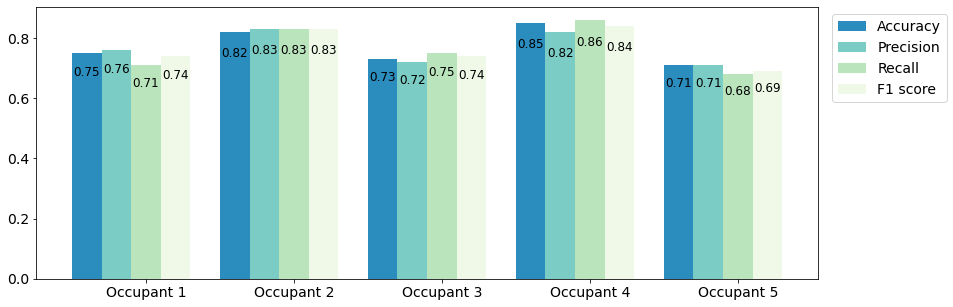

In [248]:
a = []
p = []
r = []
f = []
for i in occupants:
    a.append(round(i[0],2))
    p.append(round(i[1],2))
    r.append(round(i[2],2))
    f.append(round(i[3],2))
    
x = ["Occupant 1","Occupant 2", "Occupant 3", "Occupant 4", "Occupant 5"]
X_axis = np.arange(len(x))

plt.figure(figsize=(14,5))

a = plt.bar(X_axis-0.4, a, 0.2, label = "Accuracy" , color = "#2b8cbe")
b = plt.bar(X_axis-0.2, p, 0.2, label = "Precision", color = "#7bccc4")
c = plt.bar(X_axis, r, 0.2, label = "Recall", color = "#bae4bc")
d = plt.bar(X_axis+0.2, f, 0.2, label = "F1 score", color = "#f0f9e8")

for p in a:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in b:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in c:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in d:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
plt.yticks(fontsize=14)
plt.xticks(X_axis, x, fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor =(1.01, 1))


Low-High Ratio        0.210272
Mean Power            0.122380
Spectral Bandwidth    0.063866
FB3(CF: 926.77Hz)     0.061090
Power below 16kHz     0.059915
Power above 16kHz     0.041816
Formant 1             0.035350
FB1(CF: 308.92Hz)     0.034481
FB7(CF: 2162.47Hz)    0.031442
Spectral Centroid     0.028203
dtype: float64


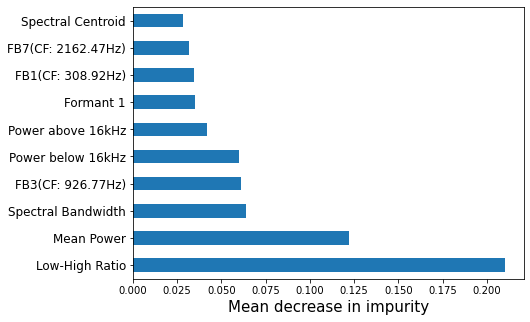

In [223]:
columns = ["RMS" , "Spectral Centroid" , "Spectral Bandwidth" ,  "Spectral Rolloff" , "ZCR", "Mean Power", "Power below 16kHz", "Power above 16kHz", "Base Frequency", "Power Ratio", "Short Time Energy" , "Low-High Ratio", "HNR"] 

fb_cf12 = [ 308.9245523 ,  617.8491046 ,  926.77365689, 1235.69820919,
        1544.62276149, 1853.54731379, 2162.47186608, 2471.39641838,
        2780.32097068, 3089.24552298, 3398.17007528, 3707.09462757]


for i in range(0,12):
    val = round(fb_cf12[i],2)
    columns.append("FB"+str(i+1)+"(CF: "+str(val)+"Hz)")
    
for i in range(5):
    columns.append("Formant "+str(i+1))
    

plt.figure(figsize=(7,5))

feat_importances = pd.Series(clfs[4].feature_importances_, index = columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Mean decrease in impurity", fontsize=15)
plt.yticks(fontsize=12)

print(feat_importances.nlargest(10))

plt.show()

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X[1], y[1], test_size=0.3,random_state=109) 


y_pred = clf[0].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.4884910485933504
Precision: 0.4789156626506024
Recall: 0.8548387096774194
Confusion matrix: [[ 32 173]
 [ 27 159]]


In [101]:
X_train, X_test, y_train, y_test = train_test_split(X[2], y[2], test_size=0.3,random_state=109) 


y_pred = clf[0].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.6220472440944882
Precision: 0.5719557195571956
Recall: 0.8469945355191257
Confusion matrix: [[ 82 116]
 [ 28 155]]


In [102]:
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.3,random_state=109) 


y_pred = clf[1].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.47619047619047616
Precision: 0.46984126984126984
Recall: 0.8268156424581006
Confusion matrix: [[ 32 167]
 [ 31 148]]


In [103]:
X_train, X_test, y_train, y_test = train_test_split(X[2], y[2], test_size=0.3,random_state=109) 


y_pred = clf[1].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.5564304461942258
Precision: 0.5573770491803278
Recall: 0.37158469945355194
Confusion matrix: [[144  54]
 [115  68]]


In [104]:
X_train, X_test, y_train, y_test = train_test_split(X[0], y[0], test_size=0.3,random_state=109) 


y_pred = clf[2].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.6481481481481481
Precision: 0.6185567010309279
Recall: 0.6703910614525139
Confusion matrix: [[125  74]
 [ 59 120]]


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X[1], y[1], test_size=0.3,random_state=109) 


y_pred = clf[2].predict(X_test)
# get the accuracy
print ("Accuracy", metrics.accuracy_score(y_test, y_pred))
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

print("Confusion matrix:",metrics.confusion_matrix(y_test, y_pred))

Accuracy 0.5498721227621484
Precision: 0.5161290322580645
Recall: 0.8602150537634409
Confusion matrix: [[ 55 150]
 [ 26 160]]


In [249]:
from sklearn.model_selection import LeaveOneOut
loo = LeaveOneOut()
loo.get_n_splits(X)


5

In [250]:
occupants = [[],[],[], [],[]]
clfs = []
j = 0
for i, (train_index, test_index) in enumerate(loo.split(X)):
        print(f"Fold {i}:")
        train_X = []
        train_y = []
        print(f"  Train: index={train_index}")
        print(f"  Test:  index={test_index}")
        for i in train_index:
            train_X.append(np.asarray(X[i]))
            train_y.append(y[i])
        test_x = np.asarray(X[test_index[0]])
        test_y = np.asarray(y[test_index[0]])
        
        train_X = np.asarray(train_X)
        train_y = np.asarray(train_y)
        
#         test_x = np.asarray(test_x)
#         test_y = np.asarray(test_y)
        
        temp = np.concatenate((train_X[0],train_X[1], train_X[2], train_X[3]),axis=0)
        temp2 = np.concatenate((train_y[0],train_y[1], train_y[2] , train_y[3]),axis=0)
        
        clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3,max_depth=2, random_state=0)
        # fitting x samples and y classes 
        clf.fit(temp, temp2) 

        clfs.append(clf)
        import time
        a = time.perf_counter()
        y_pred = clf.predict(test_x)
        b = time.perf_counter()
        print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])


        # get the accuracy
        print ("Accuracy", metrics.accuracy_score(test_y, y_pred))
        # Model Precision: what percentage of positive tuples are labeled as such?
        print("Precision:",metrics.precision_score(test_y, y_pred))

        # Model Recall: what percentage of positive tuples are labelled as such?
        print("Recall:",metrics.recall_score(test_y, y_pred))

        print("Confusion matrix:",metrics.confusion_matrix(test_y, y_pred))
        print(metrics.classification_report(test_y, y_pred))
        print("Balanced accuracy", metrics.balanced_accuracy_score(test_y, y_pred))
        
        occupants[j].append(metrics.accuracy_score(test_y, y_pred))
        occupants[j].append(metrics.precision_score(test_y, y_pred))
        occupants[j].append(metrics.recall_score(test_y, y_pred))
        occupants[j].append(metrics.f1_score(test_y, y_pred))
        j+=1


Fold 0:
  Train: index=[1 2 3 4]
  Test:  index=[0]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.asarray(train_X)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_y = np.asarray(train_y)


Prediction Latency:  0.0015377625221196978
Accuracy 0.6276252019386107
Precision: 0.6394316163410302
Recall: 0.5825242718446602
Confusion matrix: [[417 203]
 [258 360]]
              precision    recall  f1-score   support

           0       0.62      0.67      0.64       620
           1       0.64      0.58      0.61       618

    accuracy                           0.63      1238
   macro avg       0.63      0.63      0.63      1238
weighted avg       0.63      0.63      0.63      1238

Balanced accuracy 0.6275524585029753
Fold 1:
  Train: index=[0 2 3 4]
  Test:  index=[1]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.asarray(train_X)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_y = np.asarray(train_y)


Prediction Latency:  0.0016867377972978024
Accuracy 0.6341463414634146
Precision: 0.8034188034188035
Recall: 0.3745019920318725
Confusion matrix: [[218  23]
 [157  94]]
              precision    recall  f1-score   support

           0       0.58      0.90      0.71       241
           1       0.80      0.37      0.51       251

    accuracy                           0.63       492
   macro avg       0.69      0.64      0.61       492
weighted avg       0.69      0.63      0.61       492

Balanced accuracy 0.6395331536922848
Fold 2:
  Train: index=[0 1 3 4]
  Test:  index=[2]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.asarray(train_X)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_y = np.asarray(train_y)


Prediction Latency:  0.0014470384658558206
Accuracy 0.7326007326007326
Precision: 0.6804733727810651
Recall: 0.8582089552238806
Confusion matrix: [[170 108]
 [ 38 230]]
              precision    recall  f1-score   support

           0       0.82      0.61      0.70       278
           1       0.68      0.86      0.76       268

    accuracy                           0.73       546
   macro avg       0.75      0.73      0.73       546
weighted avg       0.75      0.73      0.73       546

Balanced accuracy 0.7348598732953935
Fold 3:
  Train: index=[0 1 2 4]
  Test:  index=[3]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.asarray(train_X)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_y = np.asarray(train_y)


Prediction Latency:  0.0014915126838025527
Accuracy 0.574173712528824
Precision: 0.5570719602977667
Recall: 0.695046439628483
Confusion matrix: [[298 357]
 [197 449]]
              precision    recall  f1-score   support

           0       0.60      0.45      0.52       655
           1       0.56      0.70      0.62       646

    accuracy                           0.57      1301
   macro avg       0.58      0.58      0.57      1301
weighted avg       0.58      0.57      0.57      1301

Balanced accuracy 0.5750041358447758
Fold 4:
  Train: index=[0 1 2 3]
  Test:  index=[4]


/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_X = np.asarray(train_X)
/var/folders/qf/r_bx8wf14lx6m_jgptyp_vmr0000gq/T/ipykernel_17589/3989836297.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_y = np.asarray(train_y)


Prediction Latency:  0.0014295606272603115
Accuracy 0.6283464566929133
Precision: 0.616692426584235
Recall: 0.6404494382022472
Confusion matrix: [[399 248]
 [224 399]]
              precision    recall  f1-score   support

           0       0.64      0.62      0.63       647
           1       0.62      0.64      0.63       623

    accuracy                           0.63      1270
   macro avg       0.63      0.63      0.63      1270
weighted avg       0.63      0.63      0.63      1270

Balanced accuracy 0.6285709323932411


In [172]:
temp2

array([1, 1, 1, ..., 1, 1, 1])

In [210]:
# a = []
# p = []
# r = []
# f = []
# for i in occupants:
#     a.append(round(i[0],2))
#     p.append(round(i[1],2))
#     r.append(round(i[2],2))
#     f.append(round(i[3],2))
    
# x = ["Occupant 1","Occupant 2", "Occupant 3"]
# X_axis = np.arange(len(x))

# plt.figure(figsize=(14,5))
# a = plt.bar(X_axis-0.3, a, 0.15, label = "Accuracy" , color = "#2b8cbe")
# b = plt.bar(X_axis-0.15, p, 0.15, label = "Precision", color = "#7bccc4")
# c = plt.bar(X_axis, r, 0.15, label = "Recall", color = "#bae4bc")
# d = plt.bar(X_axis+0.15, f, 0.15, label = "F1 score", color = "#f0f9e8")

# for p in a:
#    height = p.get_height()
#    plt.annotate('{}'.format(height),
#       xy=(p.get_x() + p.get_width() / 2, height/1.1),
#       xytext=(0, -5), # 3 points vertical offset
#       textcoords="offset points",
#       ha='center', va='bottom', fontsize=15)
    
# for p in b:
#    height = p.get_height()
#    plt.annotate('{}'.format(height),
#       xy=(p.get_x() + p.get_width() / 2, height/1.1),
#       xytext=(0, -5), # 3 points vertical offset
#       textcoords="offset points",
#       ha='center', va='bottom', fontsize=15)
    
# for p in c:
#    height = p.get_height()
#    plt.annotate('{}'.format(height),
#       xy=(p.get_x() + p.get_width() / 2, height/1.1),
#       xytext=(0, -5), # 3 points vertical offset
#       textcoords="offset points",
#       ha='center', va='bottom', fontsize=15)
    
# for p in d:
#    height = p.get_height()
#    plt.annotate('{}'.format(height),
#       xy=(p.get_x() + p.get_width() / 2, height/1.1),
#       xytext=(0, -5), # 3 points vertical offset
#       textcoords="offset points",
#       ha='center', va='bottom', fontsize=15)
    

# plt.xticks(X_axis, x, fontsize=14)
# plt.legend(fontsize=14)


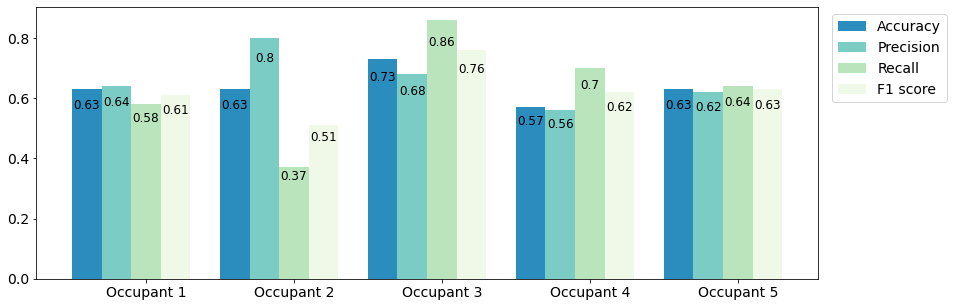

In [254]:
a = []
p = []
r = []
f = []
for i in occupants:
    a.append(round(i[0],2))
    p.append(round(i[1],2))
    r.append(round(i[2],2))
    f.append(round(i[3],2))
    
x = ["Occupant 1","Occupant 2", "Occupant 3", "Occupant 4", "Occupant 5"]
X_axis = np.arange(len(x))

plt.figure(figsize=(14,5))
a = plt.bar(X_axis-0.4, a, 0.2, label = "Accuracy" , color = "#2b8cbe")
b = plt.bar(X_axis-0.2, p, 0.2, label = "Precision", color = "#7bccc4")
c = plt.bar(X_axis, r, 0.2, label = "Recall", color = "#bae4bc")
d = plt.bar(X_axis+0.2, f, 0.2, label = "F1 score", color = "#f0f9e8")

for p in a:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in b:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in c:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in d:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
plt.yticks(fontsize=14)
plt.xticks(X_axis, x, fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor =(1.01, 1))


Low-High Ratio        0.120728
Power above 16kHz     0.112445
ZCR                   0.085077
Spectral Bandwidth    0.081700
Power below 16kHz     0.072245
FB1(CF: 308.92Hz)     0.052956
Base Frequency        0.052558
Formant 2             0.043441
FB4(CF: 1235.7Hz)     0.036380
HNR                   0.033132
dtype: float64


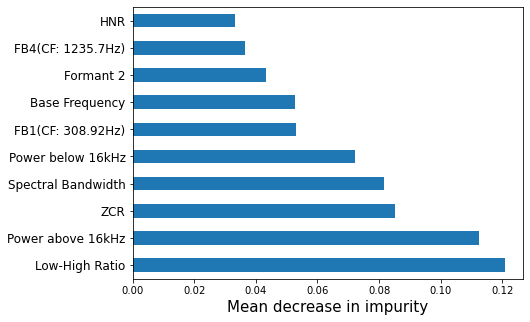

In [226]:
plt.figure(figsize=(7,5))

feat_importances = pd.Series(clfs[2].feature_importances_, index = columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.xlabel("Mean decrease in impurity", fontsize=15)
plt.yticks(fontsize=12)

print(feat_importances.nlargest(10))

plt.show()

In [262]:
1230/60

20.5

In [261]:

for i in X:
    i = np.asarray(i)
    print(i.shape)

(1238, 30)
(492, 30)
(546, 30)
(1301, 30)
(1270, 30)


In [6]:
occupants = [[],[],[], [],[]]
clfs = []
j = 0

l = []
for i in X:
    i = np.asarray(i)
    l.append(i.shape[0])

# X = np.asarray(X)

train_X = []
train_y = []
testX = []
testY = []
for i in range(5):
    print(y[i])
    
    split_point = int(l[i]//2)
    print(split_point)
    start = split_point - int(l[i]*0.15)
    end = split_point + int(l[i]*0.15)
    
    print(start,end)
    X_temp = np.asarray(X[i])
    X_ = np.concatenate((X_temp[:start], X_temp[end:]),axis=0)
    train_X.append(X_)
    y_temp = np.asarray(y[i])
    y_ = np.concatenate((y_temp[:start], y_temp[end:]),axis=0)
    train_y.append(y_ )
    
    testX.append(X_temp[start:end])
    testY.append(y_temp[start:end])
    
    
train_X = np.asarray(train_X)
train_y = np.asarray(train_y)

temp = np.concatenate((train_X[0],train_X[1], train_X[2], train_X[3], train_X[4]),axis=0)
temp2 = np.concatenate((train_y[0],train_y[1], train_y[2] , train_y[3], train_y[4]),axis=0)


# test_x = np.concatenate((testX[0],testX[1], testX[2], testX[3]),axis=0)
# test_y = np.concatenate((testY[0],testY[1], testY[2] , testY[3]),axis=0)

clf = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3,max_depth=2, random_state=0)
clf.fit(temp, temp2) 

import time
a = time.perf_counter()
y_pred = clf.predict(test_x)
b = time.perf_counter()

for j in range(5):
    y_pred = clf.predict(testX[j])
    print ("Prediction Latency: ", (b-a)*1000/y_pred.shape[0])

    print ("Accuracy", metrics.accuracy_score(testY[j], y_pred))
    # Model Precision: what percentage of positive tuples are labeled as such?
    print("Precision:",metrics.precision_score(testY[j], y_pred))

    # Model Recall: what percentage of positive tuples are labelled as such?
    print("Recall:",metrics.recall_score(testY[j], y_pred))

    print("Confusion matrix:",metrics.confusion_matrix(testY[j], y_pred))
    print(metrics.classification_report(testY[j], y_pred))
    print("Balanced accuracy", metrics.balanced_accuracy_score(testY[j], y_pred))

    occupants[j].append(metrics.accuracy_score(testY[j], y_pred))
    occupants[j].append(metrics.precision_score(testY[j], y_pred))
    occupants[j].append(metrics.recall_score(testY[j], y_pred))
    occupants[j].append(metrics.f1_score(testY[j], y_pred))



        
        
    

1
15
11 19


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [7]:
print(testY)

[]


In [8]:
a = []
p = []
r = []
f = []
for i in occupants:
    a.append(round(i[0],2))
    p.append(round(i[1],2))
    r.append(round(i[2],2))
    f.append(round(i[3],2))
    
x = ["Occupant 1","Occupant 2", "Occupant 3", "Occupant 4", "Occupant 5"]
X_axis = np.arange(5)

plt.figure(figsize=(14,5))
a = plt.bar(X_axis-0.4, a, 0.2, label = "Accuracy" , color = "#2b8cbe")
b = plt.bar(X_axis-0.2, p, 0.2, label = "Precision", color = "#7bccc4")
c = plt.bar(X_axis, r, 0.2, label = "Recall", color = "#bae4bc")
d = plt.bar(X_axis+0.2, f, 0.2, label = "F1 score", color = "#f0f9e8")

for p in a:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in b:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in c:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
for p in d:
   height = p.get_height()
   plt.annotate('{}'.format(height),
      xy=(p.get_x() + p.get_width() / 2, height/1.1),
      xytext=(0, -5), # 3 points vertical offset
      textcoords="offset points",
      ha='center', va='bottom', fontsize=12)
    
plt.yticks(fontsize=14)
plt.xticks(X_axis, x, fontsize=14)
plt.legend(fontsize=14, bbox_to_anchor =(1.01, 1))
# plt.savefig('mask_classifier.png')

IndexError: list index out of range

In [9]:
testY

[]

In [10]:
plt.figure(figsize=(7,5))

feat_importances = pd.Series(clf.feature_importances_, index = columns)
feat_importances.plot(kind='barh')
plt.xlabel("Mean decrease in impurity", fontsize=15)
plt.yticks(fontsize=12)

print(feat_importances.nlargest(10))

plt.show()

NameError: name 'clf' is not defined

<Figure size 504x360 with 0 Axes>